# Authors

|  Name    |  Surname   |     Username        |
| :------: | :--------: | :-----------------: |
| Samuele  | Bortolotti | `samuelebortolotti `|
| Luca     | De Menego  | `lucademenego99`    |


# Introduction

The objective of this assignment is to build, train and evaluate a deep learning framework on an **Unsupervised Domain Adaptation** setting.

The test dataset is [Adaptiope](https://openaccess.thecvf.com/content/WACV2021/papers/Ringwald_Adaptiope_A_Modern_Benchmark_for_Unsupervised_Domain_Adaptation_WACV_2021_paper.pdf), a large scale, diverse UDA dataset with 3 domains: synthetic, product and real world data.

For the aim of the project, however, we are not interested in using all the data the dataset provides. Only 2 domains and 20 classes are used. In particular:
- the domains are *product* and *real world* data;
- the classes are *backpack*, *bookcase*, *car jack*, *comb*, *crown*, *file cabinet*, *flat iron*, *game controller*, *glasses*, *helicopter*, *ice skates*, *letter tray*, *monitor*, *mug*, *network switch*, *over-ear* *headphones*, *pen*, *purse*, *stand mixer* and *stroller*.

The implemented networks are trained:
- in a supervised way on the source domain;
- in an unsupervised way on the target domain.

The **gain**, namely the amount of improvement we receive when we use the domain adaption framework compared to the outcome we get without any domain alignment approach, is used to assess the quality of the domain alignment strategy. The gain can be represented mathematically as: 

$$G = acc_{uda} − acc_{so}$$

This is done in both directions between the two selected domains, using as evaluation metric the **validation accuracy** on the target domain:

$$Accuracy = \frac{T_P + T_N}{T_P + T_N + F_P + F_N}$$

Where:
- $TP$ stands for true positives, namely cases in which the algorithm correctly predicted the positive class
- $TN$ stands for true negatives, namely cases in which the algorithm correctly predicted the negative class
- $FP$ stands for false positives, namely cases in which samples are associated with the positive class whereas they belong to the negative one. (Also known as a "Type I error.")
- $FN$ stands for false negatives, namely cases in which samples are associated with the negative class whereas they belong to the positive one. (Also known as a "Type II error.")

Eventually lower and upper bounds will be calculated training the networks only on one specific domain (source domain for a lower bound, target domain for an upper bound), enabling us to provide some considerations about the achievements of our architectures.

## Domain Adaptation background

Just to give a formal background, we leverage on the definition of Domain Adaptation provided by [Gabriela Csurka et.al](https://arxiv.org/pdf/1702.05374.pdf) which is presented in the this section.

We define a domain $D$ as a d-dimensional feature space $X \in \mathcal{R}^d$ based on a marginal probability distribution $P(X)$, and a task $T$ is defined as a conditional probability distribution $P(Y|X)$ where $Y$ is the label space. 

Let $X$ be sample set $X = \{x_1, \cdots x_n\}$ and let $Y$ be their corresponding labels $Y = \{y_1, \cdots y_n\}$. 
In general, these feature-label pairings $\{x_i, y_i\}$ may be used in order to learn the probability distribution $P(Y|X)$ in a supervised way.

Let us assume we have two domains with their related tasks: a source domain $D_s = {X_s, P(X_s)}$ with $T_s = {Y_s, P(Y_s|X_s)}$ and a target domain $Dt = {X_t, P(X_t)}$ with $T_t = {Y_t, P(Y_t|X_t)}$. 

If the two domains corresponds, namely $D_s = D_t$ and $T_s = T_t$, traditional machine learning methods can be used to solve the problem, where $D_s$ becomes the training set and $D_t$ the test set.

However, this assumption is violated, $D_t \neq D_s$ or $T_t \neq T_s$, the models trained on $D_s$ might perform poorly on $D_t$, or they are not applicable directly if $T_t \neq T_s$. Futhermore, when the source domain is related to the target, it is possible to exploit the related information from $\{D_s, T_s\}$ to learn $P(Y_t|X_t)$. This process is known as **transfer learning**.

**Domain Adaptation**, usually refers to problems in which the tasks are considered to be the same ($T_t = T_s$), but the domain is different ($D_s \neq T_s$).

In a classification task, both the set of labels and the conditional distributions are assumed to be shared between the two domains, i.e. $Y_s = Y_t$ and $P(Y|X_t) = P(Y|X_s)$. 

The second assumption, $P(Y|X_t) = P(Y|X_s)$, is, however, fairly strong and does not always hold in real-world applications.
As a result, the definition of domain adaptation is simplified to simply need the first assumption, namely that $Y_s = Y_t = Y$.

Furthermore, the Domain Adaptation community distinguishes between the unsupervised scenario, in which labels are only accessible for the source domain, and the semi-supervised condition, in which only a limited number of target samples are labeled.

The goal of this report is to use Unsupervised Domain Adaptation strategies to boost classification performance on unlabeled target domains. 

## Proposed solutions

When dealing with **Deep Domain Adaptation** problems, there are three main ways to solve them:
1. **discrepancy-based methods**: align domain data representation with statistical measures;
2. **adversarial-based methods**: involve also a domain discriminator to enforce domain confusion;
3. **reconstruction-based methods**: use an auxiliary reconstruction task to ensure a domain-invariant feature representation.

The assignment shows a possible solution for each one of the methods depicted above, together with a customized solution which combines two of them: discrepancy-based and reconstruction-based (`DSN` + `MEDM`).

Having only few examples available, training a network from scratch does not give satisfactory results; that is the reason why we have decided to always start with a feature extractor pre-trained on the ImageNet object recognition challenge.

Moreover, in order to delve into the proposed methods, we evaluate the domain adaptation method starting from two different backbones networks, namely AlexNet and ResNet18.

This report walks you through the approaches and code we used to solve the problem step by step.
The code we used to set up the import and dataset loading for the project is discussed in detail in the sections `Imports`, `Techniques`, and `Datasets and Dataloaders`. The `Network Architectures` section, as well as the subsequent sections on neural networks, offer a high-level overview of the architecture we have employed. Furthermore, the `Experiments` section details our tests and the modification to make the architecture comply with the problem. Finally, the impacts of the distribution allignments of the Unsupervised Domain Adaptation techniques are shown in `tSNE and PCA`, while the concluding remarks are found in `Conclusions`.

# Imports

In this section the notebook is set up by importing:
- all the libraries we use;
- the dataset.

The dataset will be imported directly from Google Drive, therefore you are required to have Adaptiope dataset included in a zip folder called `Adaptiope.zip` file put in a folder called `datasets`.

In [ ]:
r"""
Sometimes we run the code locally, instead of using Colab.
In these cases, the START_LOCALLY variable should be set to 1
"""
START_LOCALLY = 0

In [ ]:
import os

# Set the following env variable to 1 to debug CUDA errors
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

r"""
Basic imports for the code
"""
import PIL
from enum import Enum
import tqdm
import matplotlib.pyplot as plt
import numpy as np
from os import makedirs, listdir
from os.path import join
from shutil import copytree
import torch, torchvision
from torch.hub import load_state_dict_from_url
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import resnet50, resnet18
from typing import List, Tuple, Dict, Any
import sys

if not START_LOCALLY:
    from google.colab import drive

In [ ]:
r"""
Mount Google Drive
"""
drive.mount("/content/gdrive")
print("Google Drive mounted")

Mounted at /content/gdrive
Google Drive mounted


In [ ]:
!mkdir dataset
!cp "gdrive/My Drive/datasets/Adaptiope.zip" dataset/
!ls dataset

!unzip dataset/Adaptiope.zip

!rm -rf adaptiope_small
!rm -rf dataset

In [ ]:
r"""
Classes which we consider
"""
classes = [
    "backpack",
    "bookcase",
    "car jack",
    "comb",
    "crown",
    "file cabinet",
    "flat iron",
    "game controller",
    "glasses",
    "helicopter",
    "ice skates",
    "letter tray",
    "monitor",
    "mug",
    "network switch",
    "over-ear headphones",
    "pen",
    "purse",
    "stand mixer",
    "stroller",
]

With the following lines of code it is possible to filter out all the classes which are not needed for the sake of the project.

In [ ]:
!mkdir adaptiope_small
for d, td in zip(
    ["Adaptiope/product_images", "Adaptiope/real_life"],
    ["adaptiope_small/product_images", "adaptiope_small/real_life"],
):
    makedirs(td)
    for c in tqdm(classes):
        c_path = join(d, c)
        c_target = join(td, c)
        copytree(c_path, c_target)

We have offered a simple approach to zip the entire dataset after post-processing owing to the filtering operation for convenience and testing.
In this way, instead of importing the entire dataset and then post-processing it, simply loading and unzipping the compressed version would suffice. 

In [ ]:
!cp adaptiope_small.zip "gdrive/My Drive/datasets/adaptiope_small.zip"

!mkdir dataset
!cp "gdrive/My Drive/datasets/adaptiope_small.zip" dataset/
!ls dataset

!unzip dataset/adaptiope_small.zip

cp: cannot stat 'adaptiope_small.zip': No such file or directory
adaptiope_small.zip
Archive:  dataset/adaptiope_small.zip
   creating: adaptiope_small/
   creating: adaptiope_small/product_images/
   creating: adaptiope_small/product_images/letter tray/
  inflating: adaptiope_small/product_images/letter tray/letter tray_077.jpg  
  inflating: adaptiope_small/product_images/letter tray/letter tray_051.jpg  
  inflating: adaptiope_small/product_images/letter tray/letter tray_071.jpg  
  inflating: adaptiope_small/product_images/letter tray/letter tray_001.jpg  
  inflating: adaptiope_small/product_images/letter tray/letter tray_090.jpg  
  inflating: adaptiope_small/product_images/letter tray/letter tray_011.jpg  
  inflating: adaptiope_small/product_images/letter tray/letter tray_047.jpg  
  inflating: adaptiope_small/product_images/letter tray/letter tray_095.jpg  
  inflating: adaptiope_small/product_images/letter tray/letter tray_073.jpg  
  inflating: adaptiope_small/product_images

## Wandb set up

In order to log the data also in cloud, we have provided a logging option to upload data on [Wandb](https://wandb.ai/). 
Wandb is an experiment tracking tool for machine learning. It makes it easy for anyone doing machine learning to keep track of experiments and share results with colleagues and their future self.

It is worth noting that this is merely an **optional step**: if Tensorboard suffices, it is possible to skip this step.

We have included a logging option to submit data to [Wandb](https://wandb.ai/) in order to log data in the cloud.

In [ ]:
"""
Enable Wandb
"""
if not START_LOCALLY:
    !pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.8 MB 8.4 MB/s 
     |████████████████████████████████| 145 kB 68.4 MB/s 
     |████████████████████████████████| 181 kB 71.2 MB/s 
     |████████████████████████████████| 63 kB 521 kB/s 


In [ ]:
!pip freeze

absl-py==1.1.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.2
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.7.7
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.7
certifi==2022.6.15
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.5
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.5.1
distribu

In [ ]:
# Log in to your W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Techniques

We have supplied an enumerator which includes all of the techniques we have offered to keep the code compact but at the same time readable.

In this way, just by changing the Techinque flag, it is possible to rely on the same train and testing function. 

In [ ]:
class Technique(Enum):
    r"""
    Technique enumerator.
    It is employed for letting understand which method to use
    in order to train the neural network
    """
    SOURCE_ONLY = 1  # Train using only the source domain
    UPPER_BOUND = 2  # Train using the target domain too, to fix an upper bound
    DDC = 3  # Deep Domain Confusion
    DANN = 4  # Domain-Adversarial Neural Network
    DSN = 5  # Domain Separation Network
    ROTATION = 6  # Rotation Loss
    MEDM = 7  # Entropy Minimization vs. Diversity Maximization
    DANN_MEDM = 8  # DANN with Entropy Minimization vs. Diversity Maximization
    DSN_MEDM = 9  # DSN with MEDM

# Datasets and Dataloaders

In this section we define some functions that are used to:
- get the mean and standard deviation of the dataset;
- load the dataset;
- load the dataloader;
- log the images.

To improve the final neural network performances, some data augmentation techniques have been used.

## Rotate custom dataset
We created a customized dataset, starting from the implementation of ImageFolder, in order to employ the rotation loss. In particular, in the `__getitem__` function we return an additional label representing the chosen rotation.

For the sake of the project, we decided to only use four possible rotations: 0°, 90°, 180°, 270°. The image is automatically rotated by the dataloader, so the implementation of the actual learning becomes less verbose and prone to errors.

In [ ]:
import os
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
from typing import Union

from PIL import Image
from random import random

from torchvision.datasets.vision import VisionDataset


def has_file_allowed_extension(
    filename: str, extensions: Union[str, Tuple[str, ...]]
) -> bool:
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)

    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(
        extensions if isinstance(extensions, str) else tuple(extensions)
    )


def is_image_file(filename: str) -> bool:
    """Checks if a file is an allowed image extension.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folders in a dataset.

    See :class:`DatasetFolder` for details.
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx


def make_dataset(
    directory: str,
    class_to_idx: Optional[Dict[str, int]] = None,
    extensions: Optional[Union[str, Tuple[str, ...]]] = None,
    is_valid_file: Optional[Callable[[str], bool]] = None,
) -> List[Tuple[str, int]]:
    """Generates a list of samples of a form (path_to_sample, class).

    See :class:`DatasetFolder` for details.

    Note: The class_to_idx parameter is here optional and will use the logic of the ``find_classes`` function
    by default.
    """
    directory = os.path.expanduser(directory)

    if class_to_idx is None:
        _, class_to_idx = find_classes(directory)
    elif not class_to_idx:
        raise ValueError(
            "'class_to_index' must have at least one entry to collect any samples."
        )

    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError(
            "Both extensions and is_valid_file cannot be None or not None at the same time"
        )

    if extensions is not None:

        def is_valid_file(x: str) -> bool:
            return has_file_allowed_extension(x, extensions)  # type: ignore[arg-type]

    is_valid_file = cast(Callable[[str], bool], is_valid_file)

    instances = []
    available_classes = set()
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)

                    if target_class not in available_classes:
                        available_classes.add(target_class)

    empty_classes = set(class_to_idx.keys()) - available_classes
    if empty_classes:
        msg = (
            f"Found no valid file for the classes {', '.join(sorted(empty_classes))}. "
        )
        if extensions is not None:
            msg += f"Supported extensions are: {extensions if isinstance(extensions, str) else ', '.join(extensions)}"
        raise FileNotFoundError(msg)

    return instances


class CustomDatasetFolder(VisionDataset):
    """A generic data loader.

    This default directory structure can be customized by overriding the
    :meth:`find_classes` method.

    Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (tuple[string]): A list of allowed extensions.
            both extensions and is_valid_file should not be passed.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
        is_valid_file (callable, optional): A function that takes path of a file
            and check if the file is a valid file (used to check of corrupt files)
            both extensions and is_valid_file should not be passed.

     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        samples (list): List of (sample path, class_index) tuples
        targets (list): The class_index value for each image in the dataset
    """

    def __init__(
        self,
        root: str,
        loader: Callable[[str], Any],
        extensions: Optional[Tuple[str, ...]] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)
        classes, class_to_idx = self.find_classes(self.root)
        samples = self.make_dataset(self.root, class_to_idx, extensions, is_valid_file)

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    @staticmethod
    def make_dataset(
        directory: str,
        class_to_idx: Dict[str, int],
        extensions: Optional[Tuple[str, ...]] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> List[Tuple[str, int]]:
        """Generates a list of samples of a form (path_to_sample, class).

        This can be overridden to e.g. read files from a compressed zip file instead of from the disk.

        Args:
            directory (str): root dataset directory, corresponding to ``self.root``.
            class_to_idx (Dict[str, int]): Dictionary mapping class name to class index.
            extensions (optional): A list of allowed extensions.
                Either extensions or is_valid_file should be passed. Defaults to None.
            is_valid_file (optional): A function that takes path of a file
                and checks if the file is a valid file
                (used to check of corrupt files) both extensions and
                is_valid_file should not be passed. Defaults to None.

        Raises:
            ValueError: In case ``class_to_idx`` is empty.
            ValueError: In case ``extensions`` and ``is_valid_file`` are None or both are not None.
            FileNotFoundError: In case no valid file was found for any class.

        Returns:
            List[Tuple[str, int]]: samples of a form (path_to_sample, class)
        """
        if class_to_idx is None:
            # prevent potential bug since make_dataset() would use the class_to_idx logic of the
            # find_classes() function, instead of using that of the find_classes() method, which
            # is potentially overridden and thus could have a different logic.
            raise ValueError("The class_to_idx parameter cannot be None.")
        return make_dataset(
            directory, class_to_idx, extensions=extensions, is_valid_file=is_valid_file
        )

    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        """Find the class folders in a dataset structured as follows::

            directory/
            ├── class_x
            │   ├── xxx.ext
            │   ├── xxy.ext
            │   └── ...
            │       └── xxz.ext
            └── class_y
                ├── 123.ext
                ├── nsdf3.ext
                └── ...
                └── asd932_.ext

        This method can be overridden to only consider
        a subset of classes, or to adapt to a different dataset directory structure.

        Args:
            directory(str): Root directory path, corresponding to ``self.root``

        Raises:
            FileNotFoundError: If ``dir`` has no class folders.

        Returns:
            (Tuple[List[str], Dict[str, int]]): List of all classes and dictionary mapping each class to an index.
        """
        return find_classes(directory)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target, aux_label) where target is class_index of the target class and aux_label is the rotation label
        """
        path, target = self.samples[index]
        sample = self.loader(path)

        # Generate a random rotation: 0°, 90°, 180°, 270°
        order = np.random.randint(4)
        # Get the corresponding label: from 0 to 3
        aux_label = int(order)
        rotation_value = order * 90
        # Apply the rotation to the image
        rotation_transform = torchvision.transforms.RandomRotation(
            degrees=(rotation_value, rotation_value)
        )
        sample = rotation_transform(sample)

        # Apply other transformations if provided
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, aux_label

    def __len__(self) -> int:
        return len(self.samples)


IMG_EXTENSIONS = (
    ".jpg",
    ".jpeg",
    ".png",
    ".ppm",
    ".bmp",
    ".pgm",
    ".tif",
    ".tiff",
    ".webp",
)


def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


def default_loader(path: str) -> Any:
    return pil_loader(path)


class CustomImageFolder(CustomDatasetFolder):
    """A generic data loader where the images are arranged in this way by default: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/[...]/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/[...]/asd932_.png

    This class inherits from :class:`~torchvision.datasets.DatasetFolder` so
    the same methods can be overridden to customize the dataset.

    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)

     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )
        self.imgs = self.samples

## Dataset mean and standard deviation

When working with data, it is usual practice to normalize data so that we use a common scale without exaggerating variances in value ranges.
Typically, databases like ImageNet give the appropriate value for standardizing the input pictures.

The authors of the [Adaptiope](https://openaccess.thecvf.com/content/WACV2021/papers/Ringwald_Adaptiope_A_Modern_Benchmark_for_Unsupervised_Domain_Adaptation_WACV_2021_paper.pdf) dataset have not given the mean and standard deviation necessary for normalization.

As a result, we've provided a method for computing these numbers for both the source and target data:

In [ ]:
def get_mean_std(
    img_size: Tuple[int, int], source_data: str, target_data: str
) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    r"""
    Computes mean and standard deviation over the source and
    target dataloader

    This function has been adapted from
    [link]: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/pytorch_std_mean.py

    Args:
    - img_size [Tuple[int, int]]: image shape
    - source_data [str]: path to the source data
    - target_data [str]: path to the target data

    Returns:
      source mean and stdev, target mean and stdev [Tuple[Tuple[float, float], Tuple[float, float]]
    """

    # basic transformations
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(img_size),
            torchvision.transforms.ToTensor(),
        ]
    )

    # datasets
    source_data = torchvision.datasets.ImageFolder(source_data, transform=transform)
    target_data = torchvision.datasets.ImageFolder(target_data, transform=transform)

    # data loader
    source_loader = torch.utils.data.DataLoader(
        dataset=source_data, batch_size=64, shuffle=True
    )
    target_loader = torch.utils.data.DataLoader(
        dataset=target_data, batch_size=64, shuffle=True
    )

    def compute_mean_std(loader: torch.utils.data.DataLoader) -> Tuple[float, float]:
        r"""
        Computes mean and standard deviation over the source and
        target dataloader

        Args:
        - loader [torch.utils.data.DataLoader]: dataloader

        Returns:
          dataloader mean and stdev [Tuple[float, float]]
        """
        channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

        for data, _ in tqdm(loader):
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(data**2, dim=[0, 2, 3])
            num_batches += 1

        mean = channels_sum / num_batches
        # std = sqrt(E[X^2] - (E[X])^2)
        std = (channels_sqrd_sum / num_batches - mean**2) ** 0.5

        return mean, std

    return [compute_mean_std(source_loader), compute_mean_std(target_loader)]

## Load dataloaders

We designed a mechanism which returns 9 dataloaders in order to handle all domain adaption settings.

The split suggested by the assignment is defined as follows. 

In this instance, we suppose that the source domain is *products* and the destination domain is *real world*.

The source domain is divided into two halves, with 80\% of the examples used for training and 20\% for validation, while the test domain has 80% of the examples reserved for training (albeit no label information is available in this scenario) and 20\% for testing.

The same argument applies to the *real world* as the source domain and the *product* as the target domain, as desired by the assignment. 

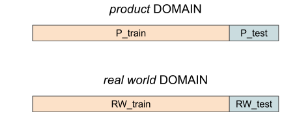

In details, our function provide a dictionary containing the following dataloaders:

- `train_source`: 80\% split of the source dataset
- `val_source`: 20\% split of the source dataset
- `train_rotated_target`: 80\% split of the source rotated dataset
- `val_rotated_target`: 20\% split of the source rotated dataset
- `train_target`: 80\% of the target dataset
- `test_target`: 20\% of the target dataset
- `train_source_target`: training dataset concatenated
- `full_source`: full source dataset
- `full_target`: full target dataset

Furthermore, in order to produce the most truthful analysis possible, we employed a `torch.Generator()` object with the same seed to enforce torch to perform the same splits regardless how many times it is executed. 

In [ ]:
def load_dataloaders(
    img_size: Tuple[int, int],
    source_data: str,
    target_data: str,
    batch_size: int = 128,
    test_batch_size: int = 256,
    # those parameters of mean and
    # standard deviation have been observed
    # empirically by computing mean and stdev over the
    # dataloaders
    mean_source: List[float] = [
        0.8023,
        0.7918,
        0.7904,
    ],
    stdev_source: List[float] = [0.3085, 0.3149, 0.3162],
    mean_target: List[float] = [0.4984, 0.4485, 0.4105],
    stdev_target: List[float] = [0.2733, 0.2635, 0.2590],
    additional_transformations: List[Any] = None,
    normalize: bool = True,
) -> Dict[str, torch.utils.data.DataLoader]:
    r"""
    Load the dataloaders (for both training, validation and test)
    according to what has been specified by the arguments

    Default:
    - batch_size [int] = 128
    - test_batch_size [int] = 256
    - mean_source [List[float]] = [0.8023, 0.7918, 0.7904]
    - stdev_source [List[float]] = [0.3085, 0.3149, 0.3162]
    - mean_target [List[float]] = [0.4984, 0.4485, 0.4105]
    - stdev_target [List[float]] = [0.2733, 0.2635, 0.2590]
    - normalize [bool] = True

    Args:
    - img_size: Tuple[int, int]: image shape
    - source_data [str]: path to the source daa
    - target_data [str]: path to the target data
    - batch_size [int]: batch size
    - test_batch_size [int]: batch size for the test data
    - mean_source [List[float]]
    - stdev_source [List[float]]
    - mean_target [List[float]]
    - stdev_target [List[float]]
    - additional_transformations = None
    - normalize [bool] = True
    Returns:
      dataloaders [Dict[str, torch.utils.data.DataLoader]]: a dictionary containing the dataloaders,
      for training [source, target, source+target], validation [source] and test [target]
    """

    # Use mean and stdev recommended by Pytorch for ResNet and AlexNet
    # Using mean and stdev calculated directly from our dataset, in fact,
    # has brought worse results
    mean_source = [0.485, 0.456, 0.406]
    stdev_source = [0.229, 0.224, 0.225]
    mean_target = [0.485, 0.456, 0.406]
    stdev_target = [0.229, 0.224, 0.225]

    def split_dataset(
        dataset: torch.utils.data.dataset.Subset, perc: float
    ) -> Tuple[torchvision.datasets.ImageFolder]:
        r"""Split the dataset into a training and validation set randomly according to the specified
        percentage value.

        Args:
        - dataset [torchvision.datasets.Subset]: datset
        - perc [float]: split percentage must be a value between 0 and 1
        Returns:
          [training, validation] Tuple[torchvision.datasets.ImageFolder]: respectively the training set,
           which will have (perc*100)% of samples and validation set, which will have (100-(100*perc))% samples
        """
        training_samples = int(len(dataset) * perc + 1)
        validation_samples = len(dataset) - training_samples
        training, validation = torch.utils.data.random_split(
            dataset,
            [training_samples, validation_samples],
            generator=torch.Generator().manual_seed(32),
        )
        return training, validation

    print("#> Loading dataloader ...")

    # transformations
    transform_source = [
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
    ]

    # rotated transforms - we won't add additional transformations in this case
    rotated_transform = [
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
    ]

    # target transforms
    transform_target = [
        torchvision.transforms.Resize(img_size),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
    ]

    # Additional transformations
    if additional_transformations:
        transform_source.append(*additional_transformations)
        transform_target.append(*additional_transformations)

    # normalization
    if normalize:
        transform_source.append(
            torchvision.transforms.Normalize(mean_source, stdev_source)
        )
        transform_target.append(
            torchvision.transforms.Normalize(mean_target, stdev_target)
        )

    # compose
    transform_source = torchvision.transforms.Compose(transform_source)
    transform_target = torchvision.transforms.Compose(transform_target)
    rotated_transform = torchvision.transforms.Compose(rotated_transform)

    # target rotated data
    target_rotated_data = CustomImageFolder(target_data, transform=rotated_transform)

    # datasets
    source_data = torchvision.datasets.ImageFolder(
        source_data, transform=transform_source
    )

    target_data = torchvision.datasets.ImageFolder(
        target_data, transform=transform_target
    )

    # split
    target_rotated_training, target_rotated_validation = split_dataset(
        target_rotated_data, 0.8
    )
    source_training, source_validation = split_dataset(source_data, 0.8)
    target_training, target_test = split_dataset(target_data, 0.8)
    source_target_training = torch.utils.data.ConcatDataset(
        [source_training, target_training]
    )

    # Dataloaders
    target_rotated_training_loader = torch.utils.data.DataLoader(
        target_rotated_training, batch_size, shuffle=True, num_workers=2, drop_last=True
    )
    target_rotated_validation_loader = torch.utils.data.DataLoader(
        target_rotated_validation,
        batch_size,
        shuffle=True,
        num_workers=2,
        drop_last=True,
    )
    source_training_loader = torch.utils.data.DataLoader(
        source_training, batch_size, shuffle=True, num_workers=2, drop_last=True
    )
    source_validation_loader = torch.utils.data.DataLoader(
        source_validation, batch_size, shuffle=False, num_workers=2, drop_last=True
    )
    target_training_loader = torch.utils.data.DataLoader(
        target_training, batch_size, shuffle=True, num_workers=2, drop_last=True
    )
    target_test_loader = torch.utils.data.DataLoader(
        target_test, test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )
    source_target_training_loader = torch.utils.data.DataLoader(
        source_target_training, batch_size, shuffle=True, num_workers=2, drop_last=True
    )
    source_data_loader = torch.utils.data.DataLoader(
        source_data, batch_size, shuffle=True, num_workers=2, drop_last=True
    )
    target_data_loader = torch.utils.data.DataLoader(
        target_data, batch_size, shuffle=True, num_workers=2, drop_last=True
    )

    print(
        "\t# of rotated training samples [target]: %d\n"
        % int(len(target_rotated_training))
    )
    print(
        "\t# of rotated validation samples [target]: %d\n"
        % int(len(target_rotated_validation))
    )
    print("\t# of training samples [source]: %d\n" % int(len(source_training)))
    print("\t# of validation samples [source]: %d\n" % int(len(source_validation)))
    print("\t# of training samples [target]: %d\n" % int(len(target_training)))
    print("\t# of test samples [target]: %d\n" % int(len(target_test)))
    print("\t# of full source: %d\n" % int(len(source_data)))
    print("\t# of full target: %d\n" % int(len(target_data)))
    print(
        "\t# of training samples [source + target]: %d\n"
        % int(len(source_target_training))
    )

    # dictionary of loaders
    dataloaders = {
        "train_source": source_training_loader,
        "val_source": source_validation_loader,
        "train_target": target_training_loader,
        "test_target": target_test_loader,
        "train_rotated_target": target_rotated_training_loader,
        "val_rotated_target": target_rotated_validation_loader,
        "train_source_target": source_target_training_loader,
        "full_source": source_data_loader,
        "full_target": target_data_loader,
    }

    return dataloaders

In [ ]:
# Load dataloaders
dataloaders = load_dataloaders(
    (224, 224),  # img_size
    "/home/lucademenego/Documenti/DEEPLEARNING/datasets/adaptiope_small/product_images"
    if START_LOCALLY
    else "adaptiope_small/product_images",  # source
    "/home/lucademenego/Documenti/DEEPLEARNING/datasets/adaptiope_small/real_life"
    if START_LOCALLY
    else "adaptiope_small/real_life",  # target
    batch_size=32,
    additional_transformations=[],
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202



## Data visualization

This section contains some basic functions for visualizing the dataset data.
As a result, running the following cells is not required for the sake of the assignment.

To give a quick overview of the dataset, the data we have been working with looks like this: 

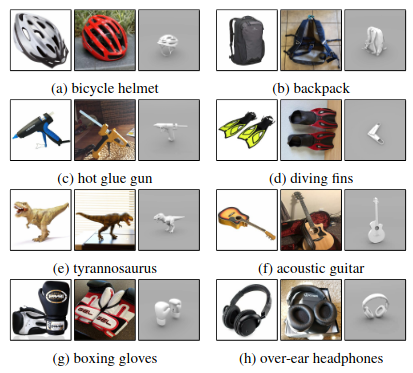

We designed a method which queries the datasets in order to get items belonging to both the domains and present them in a grid in order to have a rapid comparison between source and target data.

In this way, it has been easy to have a visual feedback on how difficult the domain adaptation challenge is.

Furthermore, as trivial as it may appear, transitioning from *product* to *real world* is far more difficult than the reverse. 

In [ ]:
def visualize_train_datasets(
    source_train: torch.utils.data.DataLoader,
    target_train: torch.utils.data.DataLoader,
    image_label: int,
    rows: int = 3,
    cols: int = 3,
) -> None:
    r"""
    Show the data from both dataloaders according to the label which we pass
    as a parameter

    **Note**: the number of images displayed depends on the size of the batch, since
    the bigger the batch size, the more the probability there are enogh samples of the
    desired label to be displayed.

    Default:
    - rows [int] = 3
    - cols [int] = 3

    Args:
    - source_train [torch.utils.data.DataLoader]
    - target_train [torch.utils.data.DataLoader]
    - image_label [int]: image label index
    - rows [int]
    - cols [int]
    """

    # define iterators over both datasets
    train_iter_source, train_iter_target = iter(source_train), iter(target_train)

    # get labels of source data
    data_source, labels_source = next(train_iter_source)

    # get labels of target data
    data_target, labels_target = next(train_iter_target)

    # get first rows*cols indices of the chosen label for source data
    get_idx = (labels_source == image_label).nonzero().squeeze(-1)[0 : (rows * cols)]

    # get first rows*cols indices of the chosen label for target data
    get_idx_target = (
        (labels_target == image_label).nonzero().squeeze(-1)[0 : (rows * cols)]
    )

    # get the data and labels for the chosen data
    get_data_source, get_labels_source = (
        data_source[get_idx, :, :, :],
        labels_source[get_idx],
    )
    get_data_target, get_labels_target = (
        data_target[get_idx_target, :, :, :],
        labels_target[get_idx_target],
    )

    if len(get_data_source) == 0 or len(get_data_target) == 0:
        print("No data retrieved with given label")
        return

    # How many image it was able to retrieve
    print(
        "Retreived {} source and {} target images".format(
            len(get_data_source), len(get_data_target)
        )
    )

    # source display
    display_grid = torchvision.utils.make_grid(
        get_data_source,
        nrow=rows,
        padding=2,
        pad_value=1,
        normalize=True,
        value_range=(get_data_source.min(), get_data_source.max()),
    )
    plt.subplot(1, 2, 1)
    plt.imshow((display_grid.numpy().transpose(1, 2, 0)))
    plt.axis("off")
    plt.title(f"Source Train Dataset label {image_label}")

    # target display
    display_grid_translated = torchvision.utils.make_grid(
        get_data_target,
        nrow=rows,
        padding=2,
        pad_value=1,
        normalize=True,
        value_range=(get_data_source.min(), get_data_source.max()),
    )
    plt.subplot(1, 2, 2)
    plt.imshow((display_grid_translated.numpy().transpose(1, 2, 0)))
    plt.axis("off")
    plt.title(f"Target Train Dataset label: {image_label}")

    plt.tight_layout()
    plt.show()

Retreived 3 source and 1 target images


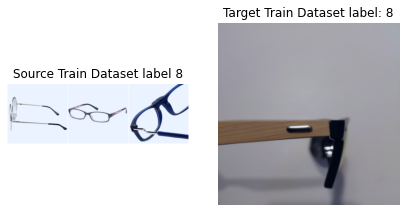

In [ ]:
visualize_train_datasets(
    dataloaders["train_source"],  # train source loader
    dataloaders["train_target"],  # train target loader
    8,  # image label
)

# Network Architectures

To successfully meet the domain adaptation challenge, we have implemented several network architectures which are then adopted from relevant papers in the literature and altered to fit our needs.

Our major goal, as stated in the introduction, is to evaluate the performance (gain) of some of the most significant approaches in the domain adaptation field and build them on top of two of the most relevant convolutional neural network architectures, namely `AlexNet` and `ResNet`.

In this report we cover:
- [Deep Domain Confusion Networks](https://arxiv.org/abs/1412.3474)
- [Domain Adversarial Neural Network](https://arxiv.org/abs/1505.07818)
- [Domain Separation Networks](https://arxiv.org/abs/1608.06019)
- [Rotation loss Network](https://arxiv.org/pdf/2010.07539.pdf)
- [Entropy Minimization vs. Diversity Maximization for Domain Adaptation](https://arxiv.org/pdf/2002.01690.pdf)
- A trial of ours to combine `MEDM` with `DANN`
- Another idea of ours to combine `MEDM` with `DSN`

## AlexNet architecture

Original `AlexNet` architecture, taken directly from Pytorch's implementation.

It has been used as a reference, and to calculate the source-only and upper-bound accuracy.

In [ ]:
class AlexNet(nn.Module):
    r"""
    AlexNet architecture taken from the PyTorch source code.
    The reference is taken from
    [link]: https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py
    """

    def __init__(
        self,
        num_classes: int = 20,
        dropout: float = 0.5,
        pretrained: bool = False,
        feature_extractor: bool = False,
    ) -> None:
        r"""
        Initialize the AlexNet model

        Default:
        - num_classes [int] = 20
        - dropout [float] = 0.5
        - pretrained [bool] = False
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: number of classes [used in the last layer]
        - dropout [float]: probability of dropout [value between 0-1]
        - pretrained [bool]: whether to pretrain the model or not
        - feature_extractor [bool]: whether to return the feature extracted from
        the neural network or not in the forward step.
        """
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # number of classes as output channel of the last fc layer
            nn.Linear(4096, num_classes),
        )
        # Whether to return only the features in the forward step!
        self.feature_extractor = feature_extractor

        # automatic pretrained model
        if pretrained:
            # url of the AlexNet weights
            from torchvision.models.alexnet import model_urls

            # load the weights
            state_dict = load_state_dict_from_url(model_urls["alexnet"], progress=True)
            # remove the last layer weights
            state_dict["classifier.6.weight"] = self.state_dict()["classifier.6.weight"]
            state_dict["classifier.6.bias"] = self.state_dict()["classifier.6.bias"]
            # load the weights
            self.load_state_dict(state_dict)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        r"""
        Forward method

        Args:
        - x [torch.Tensor]: source sample

        Returns:
        - prediction [torch.Tensor]: prediction
        """
        x = self.features(x)
        # if in the feature extractor mode
        if self.feature_extractor:
            # return the features
            return x
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## ResNet18 Architecture

In the following cell of code we present the original original `ResNet18` architecture, imported directly from Pytorch.

It has been used as a reference, and to calculate the source-only and upper-bound accuracy.

In [ ]:
class ResNet18(nn.Module):
    r"""
    Original ResNet18 architecture, which is taken directly from the torchvision
    models
    """

    def __init__(
        self,
        num_classes: int = 20,
        pretrained: bool = False,
        feature_extractor: bool = False,
    ) -> None:
        r"""
        Initialize the basic ResNet18 architecture

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = False
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: number of classes [used in the last layer]
        - pretrained [bool]: whether to pretrain the model or not
        - feature_extractor [bool]: whether to return the feature extracted from
        the neural network or not in the forward step.
        """
        super(ResNet18, self).__init__()

        # Take the resNet18 module and discard the last layer
        features = nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1]

        # set the ResNet18 backbone as feature extractor
        self.features = nn.Sequential(*features)

        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes),
        )

        # As usual the mode for returning the features instead of the
        # predictions
        self.feature_extractor = feature_extractor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        r"""
        Forward method

        Args:
        - x [torch.Tensor]: source sample

        Returns:
        - prediction [torch.Tensor]: prediction
        """
        x = self.features(x)
        # if in the feature extractor mode
        if self.feature_extractor:
            # return the features
            return x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Deep Domain Confusion - discrepancy-based method

The first method we are going to propose is **Deep Domain Confusion**, inspired by the paper of [Tzeng et al.](https://arxiv.org/abs/1412.3474).


The main idea behind it is to introduce, in a CNN architecture, an additional loss to learn a representation of data that is both semantically meaningful and domain invariant. The loss the paper presents is **Maximum Mean Discrepancy (MMD)**, which takes as input the representations of both the source and the target domains and outputs their `MMD distance`. We also want to classify correctly the input images, so the complete loss are trying to minimize is:

$L=L_{Classification}(X_{L}, y) + (\lambda \times MMD^2(X_{Source}, X_{Target}))$

Here $\lambda$ is a hyper-parameter that determines how much the `MMD loss` should influence the total loss. After some testing, we decided to stick with the value advised by the paper: `0.25`.


The following image represents the main architecture presented by the paper, which implements a customized AlexNet.

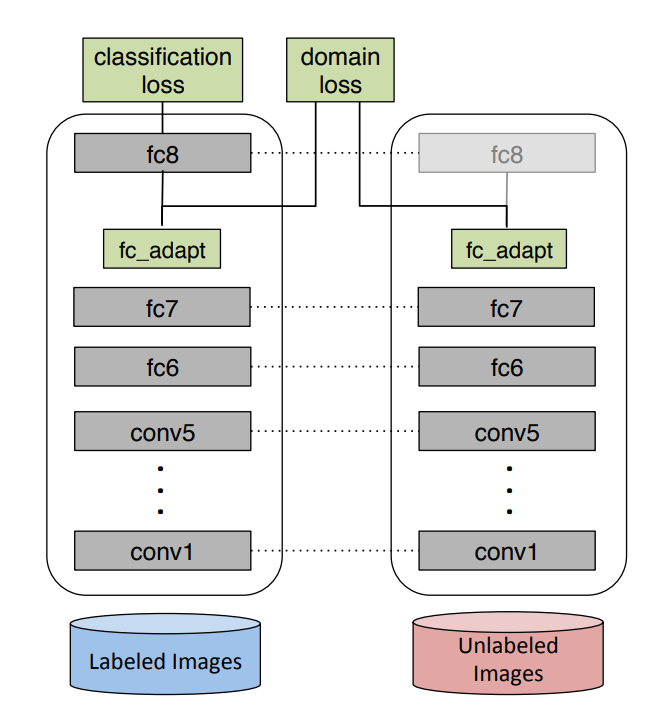

### Get the MMD distance between source and target images

Implementation of the **Maximum Mean Discrepancy**, used by both `AlexNet` and `ResNet18`.

To apply it to the features returned by the adaptation layer, it has been used and returned directly by the forward method of each architecture.

In [ ]:
# Get the MMD distance from source and target inputs
def get_mmd(x_source: torch.Tensor, x_target: torch.Tensor) -> float:
    r"""
    Maximum Mean Discrepancy (MMD) distance implementation.
    It is MMD distance employed in the Deep Domain Confusion: Maximizing for Domain Invariance
    paper by Eric Tzeng et al.

    The implementation is taken from
    [link]: https://github.com/jindongwang/transferlearning/blob/master/code/distance/mmd_numpy_sklearn.py#L7

    Args:
    - x_source [torch.Tensor]: source sample
    - x_target [torch.Tensor]: target sample

    Returns:
    - loss [float]: distance
    """
    delta = x_source.mean(0) - x_target.mean(0)
    return delta.dot(delta.T)

### AlexNet

The first implementation step was to recreate the `AlexNet` customized structure provided by the paper. 

A lower-dimensional adaptation layer, called *bottleneck*, was inserted into the architecture, and the `MMD loss` was placed on top of it.

In [ ]:
class DDCAlexNet(nn.Module):
    r"""
    Customized AlexNet architecture according to the Deep Domain Confusion:
    Maximizing for Domain Invariance paper by Eric Tzeng et al.
    This implementation takes inspiration from the Deep Domain Confusion:
    Maximizing for Domain Invariance paper by Eric Tzeng et al.
    In practice, we aim to reproduce the principles of such architecture even if
    we have not widely explored it like Eric Tzeng et al.
    """

    def __init__(
        self,
        num_classes: int = 20,
        dropout: float = 0.5,
        pretrained: bool = True,
        feature_extractor: bool = False,
    ) -> None:
        r"""
        Initialize the custom DDCAlexNet model which implements
        the Deep Domain Confusion approach

        Default:
        - num_classes [int] = 20
        - dropout [float] = 0.5
        - pretrained [bool] = False
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: number of classes [used in the last layer]
        - dropout [float]: probability of dropout [value between 0-1]
        - pretrained [bool]: whether to pretrain the model or not
        - feature_extractor [bool]: whether to return the feature extracted from
        the neural network or not in the forward step.
        """
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.mid_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )
        # Adapt layer before the last linear layer
        # as described in the Deep Domain Confusion paper
        self.adapt = nn.Sequential(
            nn.Linear(4096, 256),
            nn.ReLU(inplace=True),
        )
        # Last fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes),
        )
        # Whether to return only the features in the forward step
        self.feature_extractor = feature_extractor

        # whether to load a pretrained model
        if pretrained:
            from torchvision.models.alexnet import model_urls

            pretrained_params = load_state_dict_from_url(
                model_urls["alexnet"], progress=True
            )

            # load weights from alexnet base net
            current_params = self.state_dict()

            # loading weights coming from common layers
            for key, value in current_params.items():
                # the common layers between the two nets are:
                # features->features and classifier->mid_classifier
                if key.split(".")[0] == "features":
                    print("Adding key", key, "in current params")
                    current_params[key] = pretrained_params[key]
                if key.split(".")[0] == "mid_classifier":
                    print("Adding key", key, "in current params")
                    current_params[key] = pretrained_params[
                        key.replace("mid_classifier", "classifier")
                    ]
            # load weigths
            self.load_state_dict(current_params)

    def forward(
        self, x: torch.Tensor, x_target: torch.Tensor
    ) -> Tuple[torch.Tensor, float]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - x_target [torch.Tensor]: target sample

        Returns:
        - prediction, loss [Tuple[torch.Tensor, float]]: prediction and mmd loss
        """
        x = self.features(x)
        # if in the feature extractor mode
        if self.feature_extractor:
            return x
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.mid_classifier(x)
        x = self.adapt(x)

        # If we are in training mode, find also the adapt layer's result
        # for target data and compute the mmd distance between source and target
        loss = 0
        if self.training:
            x_target = self.features(x_target)
            x_target = self.avgpool(x_target)
            x_target = torch.flatten(x_target, 1)
            x_target = self.mid_classifier(x_target)
            x_target = self.adapt(x_target)
            loss += get_mmd(x, x_target)

        x = self.classifier(x)

        # Return also the MMD loss, not only the actual ouptut of the net
        # loss is simply zero if we are not training
        return x, loss

### ResNet18

As a second implementation step, we decided to bring the same idea to another architecture: `ResNet18`. 

The training happens in the same way as before, with the same $\lambda$ hyper-parameter set to `0.25`.

In [ ]:
class DDCResNet18(nn.Module):
    r"""
    Customized DDCResNet18 architecture.
    This implementation takes inspiration from the Deep Domain Confusion:
    Maximizing for Domain Invariance paper by Eric Tzeng et al.
    In practice, we aim to reproduce the principles of such architecture even if
    we have not widely explored it like Eric Tzeng et al.
    """

    def __init__(
        self,
        num_classes: int = 20,
        pretrained: bool = False,
        feature_extractor: bool = False,
    ) -> None:
        super(DDCResNet18, self).__init__()
        r"""
        Initialize the custom DDCResNet18 model which tries to follow
        the general idea behind Deep Domain Confusion approach

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = False
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: number of classes [used in the last layer]
        - dropout [float]: probability of dropout [value between 0-1]
        - pretrained [bool]: whether to pretrain the model or not
        - feature_extractor [bool]: whether to return the feature extracted from
        the neural network or not in the forward step.
        """
        # Take the resNet18 module and discard the last layer
        features = nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1]

        # Use it as a feature extractor
        self.features = nn.Sequential(*features)

        # add an adapt layer before the last one
        # similar to what Tzeng et al. did with AlexNet
        self.adapt = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
        )

        # final fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes),
        )

        # in the forward return only the features!
        self.feature_extractor = feature_extractor

    def forward(
        self, x: torch.Tensor, x_target: torch.Tensor
    ) -> Tuple[torch.Tensor, np.double]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - x_target [torch.Tensor]: target sample

        Returns:
        - prediction, loss [Tuple[torch.Tensor, float]]: prediction and mmd loss
        """

        x = self.features(x)

        # if in the feature extractor mode
        if self.feature_extractor:
            return x

        # flatten to prepare for the classifier
        x = torch.flatten(x, 1)
        x = self.adapt(x)

        loss = 0
        if self.training:
            x_target = self.features(x_target)
            x_target = torch.flatten(x_target, 1)
            x_target = self.adapt(x_target)
            loss += get_mmd(x, x_target)

        x = self.classifier(x)

        # Return also the MMD loss, not only the actual ouptut of the net
        # loss is simply zero if we are not training
        return x, loss

## Domain-Adversarial Training of neural networks - adversarial-based method

The second method we propose is **Domain Adversarial Neural Networks** (DANN), inspired by the paper of [Yaroslav Ganin et al.](https://arxiv.org/abs/1505.07818).

The idea behind the approach is to promotes features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains.

To accomplish this, Ganin et al. suggest to jointly optimize two discriminative classifiers: the label predictor which predicts the class labels and the domain classifier that discriminates between the source and the target domains during training. In order to discriminate the domains, DANN takes inspiration from the idea of [Ian J. Goodfellow et al. GAN](https://arxiv.org/pdf/1406.2661.pdf). 

The classifier parameters are optimized to reduce the error on the training set, while the parameters of the underlying deep feature mapping are designed to **minimize the label classifier's loss** and **maximize the domain classifier's loss**. The adversarial settings are meant to encourages domain agnostic features to emerge in the course of the optimization.

Formally, training the architecture requires to minimize the following objective function:

$$E(\theta_f , \theta_y, \theta_d) = \frac{1}{n} \displaystyle\sum_{i=1}^{n} L_{y}^i (\theta_f, \theta_y) - \lambda \left(\frac{1}{n} \displaystyle\sum_{i=1}^{n} L_d^i(\theta_f, \theta_y) + \frac{1}{n'}\displaystyle\sum_{i=1}^{n} L_d^i(\theta_f, \theta_d)\right)$$

Where:
- $\theta_f$ are the parameters of the bottleneck layer, that map the features in a suitable format to be accepted by the output layer.
- $\theta_y$ are the parameters of the class predictor
- $\theta_d$ are the parameters of the domain regressor
- $L_y^i$ and $L_d^i$ are cross-entropy losses

Since the goal is to confuse as much as possible the model about the domain,
the bottleneck layer's objective function should be maximized rather than minimized.

The solution has been to connect the feature extractor to the bottleneck layer through a **gradient reversal layer**, multiplying the gradient by a negative constant during backpropagation.

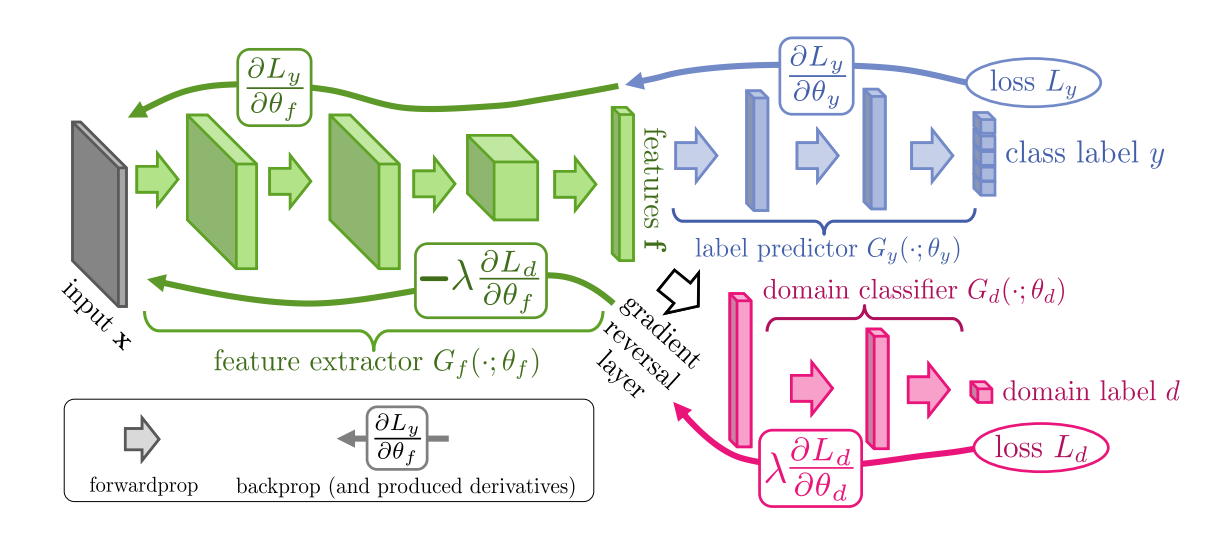

The DANN architecture cosists in a deep feature extractor, which in our case is either ResNet18 or AlexNet, a class predictor and a domain classifier connected to the feature extractor via a gradient reversal layer.

### Gradient Reversal Function

The following diagram depicts the **Gradient Reversal Layer** (GRL) behavior:
the GRL takes the gradient from the previous level and reverses its sign before sending it to the preceding layer during backpropagation.

The gradient reversal layer may be formally treated as a function $R(x)$ defined by two (incompatible) equations which describe the forward and backpropagation behavior.

$$R(x) = x$$
$$\frac{dR}{dx} = -I$$

where $I$ depicts the identity matrix. We can then define the objective "pseudo-function" of $(\theta_f , \theta_y, \theta_d)$ that is being optimized by the stochastic gradient descent within our method.

$$E(\theta_f , \theta_y, \theta_d) = \frac{1}{n} \displaystyle\sum_{i=1}^{n} L_{y}^i (G_y(G_f (xi; \theta_f); \theta_y), y_i) - \lambda \left(\frac{1}{n} \displaystyle\sum_{i=1}^{n} L_d^i(G_d(R(G_f (x_i; \theta_f)); \theta_d), d) + \frac{1}{n'}\displaystyle\sum_{i=1}^{n} L_d^i(G_d(R(G_f(x_i; \theta_f)); \theta_d), d_i)\right)$$

Where $G_d$ is the of the domain classifier, $G_y$ is the class prediction and and $G_f$ is the output of the bottleneck layer. 

In [ ]:
from torch.autograd import Function

# Autograd Function objects are what record operation history on tensors,
# and define formulas for the forward and backprop.


class GradientReversalFn(Function):
    r"""
    Reverse gradient layer as described in Domain-Adversarial Training of Neural Networks
    paper by Yaroslav Ganin et al.

    Implementation taken from:
    [link]: https://nbviewer.org/github/vistalab-technion/cs236605-tutorials/blob/master/tutorial6/tutorial6-TL_DA.ipynb
    """
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x: torch.Tensor, grl_lambda: float) -> torch.Tensor:
        r"""Forward method, the aim is to store the GRL lambda parameter

        Args:
        - ctx: context
        - x [torch.Tensor]: source sample
        - grl_lambda [float]: Gradient Reversal Layer (GRL) lambda, which is a
        parameter described in the Domain-Adversarial Training of Neural Networks
        paper

        Returns:
        - x [torch.Tensor]: forward as it is
        """
        # Store context for backprop
        ctx.grl_lambda = grl_lambda

        # Forward pass is a no-op
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None]:
        r"""
        Backward method, the aim is to backpropagate the negative value
        of the gradient

        Args:
        - ctx: context
        - grad_out [torch.Tensor]: gradient

        Returns:
        - output, None [Tuple[torch.Tensor, None]]: reversed gradient and None
        """
        # Backward pass is just to -grl_lambda the gradient
        output = grad_output.neg() * ctx.grl_lambda

        # Must return same number as inputs to forward()
        return output, None

### AlexNet

As an effective representation of the DANN architecture, we have defined a deep AlexNet feature extractor which is connected to a bottleneck layer and then branches off into two branches, one for the prediction of the class and one for that of the domain.

In the following piece of code, the `adapt` Sequential module depicts the bottleneck layer described in the architecture.

In [ ]:
class DANNAlexNet(nn.Module):
    r"""
    Customized AlexNet architecture as described in Domain-Adversarial Training of Neural Networks
    paper by Yaroslav Ganin et al.
    """

    def __init__(
        self,
        num_classes: int = 20,
        dropout: float = 0.5,
        pretrained: bool = False,
        feature_extractor: bool = False,
    ) -> None:
        r"""
        Initialize the custom DANNAlexNet model which implements
        the Domain-Adversarial Neural Network approach approach

        Default:
        - num_classes [int] = 20
        - dropout [float] = 0.5
        - pretrained [bool] = False
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: number of classes [used in the last layer]
        - dropout [float]: probability of dropout [value between 0-1]
        - pretrained [bool]: whether to pretrain the model or not
        - feature_extractor [bool]: whether to return the feature extracted from
        the neural network or not in the forward step.
        """
        super(DANNAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.mid_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
        )
        # As adviced by the paper, we follow the previous structure
        # for deep domain confusion, adding an adapt layer before the classifiers
        self.adapt = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(nn.Linear(2048, num_classes))
        # Domain classifier as described in the paper
        self.domain_classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(1024, 2),
        )

        # As usual the mode for returning the features instead of the
        # predictions
        self.feature_extractor = feature_extractor

        # Load the pretrained model if pretrained is set to True
        if pretrained:
            from torchvision.models.alexnet import model_urls

            # load AlexNet pretrained weights on ImageNet
            state_dict = load_state_dict_from_url(model_urls["alexnet"], progress=True)

            # load weights from alexnet base net
            current_params = self.state_dict()

            # As for the Deep Domain Confusion network we load the common
            # parameters
            for key, value in current_params.items():
                # the common layers between the two nets are features->features and classifier->mid_classifier
                if key.split(".")[0] == "features":
                    print("Adding key", key, "in current params")
                    current_params[key] = state_dict[key]
                if key.split(".")[0] == "mid_classifier":
                    print("Adding key", key, "in current params")
                    current_params[key] = state_dict[
                        key.replace("mid_classifier", "classifier")
                    ]
            self.load_state_dict(current_params)

    def forward(
        self, x: torch.Tensor, grl_lambda: float = 1.0
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - grl_lambda [float]: Gradient Reversal Layer (GRL) lambda parameter

        Returns:
        - class_prediction, domain_prediction [Tuple[torch.Tensor, float]]:
        class prediction and domain prediction
        """
        x = self.features(x)
        # if feature extractor then return the features only
        if self.feature_extractor:
            return x
        x = self.avgpool(x)

        # extract the features
        features = x.view(x.size(0), -1)
        features = self.mid_classifier(features)
        features = self.adapt(features)

        # gradient reversal
        reverse_features = GradientReversalFn.apply(features, grl_lambda)

        # classify both the domain and the class
        class_pred = self.classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

### ResNet18

As for AlexNet we have defined the DANN architecture by defining a deep ResNet18 feature extractor which is connected to a bottleneck layer and then branches off into two branches, one for the prediction of the class and one for that of the domain.

In the following piece of code, the `adapt` Sequential module depicts the bottleneck layer described in the architecture.

In [ ]:
class DANNResNet18(nn.Module):
    r"""
    Customized DANNResNet18 architecture.
    This implementation takes inspiration from the Domain-Adversarial Training
    of Neural Networks paper by Yaroslav Ganin et al.
    In practice, we aim to reproduce the principles of such architecture even if
    we have not widely explored the architecture like Yaroslav Ganin et al.
    """

    def __init__(
        self,
        num_classes: int = 20,
        pretrained: bool = False,
        feature_extractor: bool = False,
        dropout: float = 0.5,
    ) -> None:
        r"""
        Initialize the custom DANNResNet18 model which aim to simulate
        the Domain-Adversarial Neural Network approach approach

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = False
        - feature_extractor [bool] = False
        - dropout [float] = 0.5

        Args:
        - num_classes [int]: number of classes [used in the last layer]
        - dropout [float]: probability of dropout [value between 0-1]
        - pretrained [bool]: whether to pretrain the model or not
        - feature_extractor [bool]: whether to return the feature extracted from
        the neural network or not in the forward step.
        - dropout [float]: probability of dropout [value between 0-1]
        """
        super(DANNResNet18, self).__init__()

        # Take the resNet18 module and discard the last layer
        features = nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1]

        # Use it as a feature extractor
        self.features = nn.Sequential(*features)

        # As adviced by the paper, we follow the previous structure
        # for deep domain confusion, adding an adapt layer before the classifiers
        self.adapt = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
        )

        # final fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(256, 20),
        )

        # Domain classifier similar to the one described in the paper
        self.domain_classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, 2),
        )

        # in the forward return only the features!
        self.feature_extractor = feature_extractor

    def forward(
        self, x: torch.Tensor, grl_lambda: float = 1.0
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - grl_lambda [float]: Gradient Reversal Layer (GRL) lambda parameter

        Returns:
        - class_prediction, domain_prediction [Tuple[torch.Tensor, float]]:
        class prediction and domain prediction
        """
        x = self.features(x)
        # if feature extractor then return the features only
        if self.feature_extractor:
            return x

        # extract the features
        features = x.view(x.size(0), -1)
        features = self.adapt(features)

        # gradient reversal
        reverse_features = GradientReversalFn.apply(features, grl_lambda)

        # classify both the domain and the class
        class_pred = self.classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

## DSN - reconstruction-based method

As a third method we propose **Domain Separation Network** (DSN), inspired by the paper of [Konstantinos Bousmalis et al.](https://arxiv.org/abs/1608.06019).

The idea behind the approach is to focus the network to create only a shared
representation of the images coming from both domains and ignore the individual features of each domain. 

To accomplish this, the model works by leveraging on private–shared component analysis by explicitly learning to extract image representations that are partitioned into two subspaces: one component which is private to each domain and one which is shared across domains. 

In particular, the model is characterized by three encoder networks. Two of them are private of the domains and should learn domain-dependent features; the other one is shared, so it should learn domain-agnostic features.

To induce the model to generate these representations, Konstantinos Bousmalis et al. have used a difference loss to encourage the private encoders to be independent of the shared one.

Furthermore, to force that the features learnt are relevant, the method includes a reconstruction loss. Finally, a similarity loss is used to enforce the model to produce common representation for both domains, to accomplish domain adaptation. 

Formally, DSN address the Unsupervised Domain Adaptation task by minimizing four losses jointly, namely:

$$L = L_{task} + \alpha L_{recon} + \beta L_{difference} + \gamma L_{similarity}$$

Which are jointly minimized with respect to the parameters $\theta = \{\theta_c, \theta_p, \theta_d, \theta_g\}$.

Where:
- $\theta_c$ are the parameters of the layers returning the shared features;
- $\theta_p$ are the parameters of the layers returning the private features;
- $\theta_d$ are the parameters of the layers returning the image reconstruction from the hidden representation;
- $\theta_g$ are the parameters of the layers returning the final task-specific predictions;
- $\alpha, \beta, γ$ are fixed constants.

According to Konstantinos Bousmalis et al., the losses to minimize are:
- $L_{task}$ the cross-entropy loss employed for the class prediction
- $$L_{recon} = \frac{1}{k} ||x − \hat{x}||_2^2 - \frac{1}{k^2}([x − \hat{x}] \cdot 1_k)^2$$ is the reconstruction loss, namely the Scale-Invariant Mean Squared (SIMSE) loss. Where $1_k$ is a vector of ones of length $k$, and $||\cdot||^2$ is the squared L2-norm. In the final update, the reconstruction term of both the target and source image is considered.
- $$L_{difference} = ||H^s_c \ ^T H^s_p ||^2_F + ||H_c^t \ ^T H_p^t||^2_F$$ is the difference loss. Where $||\cdot||^2_F$ is the squared Frobenius norm and $H^s_p$ and $H^t_p$ are matrices whose rows are the private representation of source and target data respectively.
- $$L_{similarity} = \displaystyle\sum_{i=0}^{N_s + N_t}\left\{d_i \log \hat{d}_i + (1 - d_i) \log(1 − \hat{d}_i)\right\}$$
is the similarity loss. In this scenario the loss employed is DANN proposed in the paper of Ganin et al. However, Konstantinos Bousmalis et al. have proposed also the Maximum Mean Discrepancy as a valid alternative.

![dns.png](data:png;base64,iVBORw0KGgoAAAANSUhEUgAAApwAAAEkCAYAAACCOuEgAAAABHNCSVQICAgIfAhkiAAAIABJREFUeF7snQm8TPX7x5+k7PseCclWlMjSQpGdRJaotP9KliRtqn9aiNBmS1qoCBUlsiQk+1b2fcm+72Tv/7wP53bu3Jl7Z+bOcube7+M1L3fOfM93+ZyZcz7fZ73sXxUxYhBwGQJ8LS+77DKXzcpMxyBgEDAIGAQMAgaBYBBI6+9JZ8+elZEjR8rvv/8uc+bMkR07dliE4MiRI/52YdoZBPxG4IYbbpCdO3dKwYIF5eabb5bGjRtLkyZN/D7fNDQIGAQMAgYBg4BBwD0IXOaPhrNXr14ybtw4KVy4sNx7771SpEgRKVCggGTNmtU9KzEzSXEIHDp0SPbs2SNLliyRiRMnypo1a+S1116Thx9+OMWt1SzIIGAQMAgYBAwCKRmBRAnnuXPnpH79+nL99dfLG2+8kZJxSLVrQ3O9e/duufrqq5ONwYwZM+TOO+9Mdj++Ojhw4ID83//9nxw/flx++uknX83McYOAQcAgYBAwCBgEXIZAGl/zOXPmjBQqVEh69+5tyKYvkFLA8a1bt8qqVau8rgQ/SsidvzJ+/Pi4pseOHZNQuwfnypVLBgwYIA888IDUq1fP32mZdgYBg4BBwCBgEDAIRBkBnz6cmTJlsnzorrjiioCniCn01KlTltndSPQQmDt3rqW9vPzyy+XKK6+0JgIJ5NpUq1ZNfv75Z8FdAg02/ri1a9eON9lff/1VqlSpkuQCVq5cKR988IFs2LDB2pyghWTD8sorr8g777wjadP6/Jol2be3BsyT72WFChVk8eLF3pqYYwYBg4BBwCBgEDAIuAgBrxpONEjTp09PQDYxY15zzTVSqVIl6wUZwbfOUxYuXCgTJkzwPJzo+71798qwYcMSbcOH58+fjxufuUCWmMsLL7yQ5LnBNHjvvfcSnOaJA+MT1BJqYexvvvkm6G7LlCkjH330kWTMmDEOsxtvvFHYEBw9elQefPBBOX36tHz99dcJyCYkctOmTX756XIN0Dg+++yz8uabb1oEF21ku3btBNIaDrnrrrus/rt27RqO7k2fBgGDgEHAIGAQMAiEEIEEhPO7776TkydPClHC3qRBgwayYMEC6zV48GB56aWXrGabN2+WXbt2CX58kBoICKQFH0HkwoULsnz58rguITxowWxZt26dzJ8/P+49xBKzrKdAZuzx69SpI5Ay3mP6t8Wzb+fc8EtFDh8+7Nm1RWY9x/RF+Jw4ML7tU8hYRO7PmjXL0vg55eDBg2KPbx+nLeM65Z9//rGIIJjxssU+br/fv3+/pYUGc2/rAau///5bypUrJzlz5pTs2bPLVVddJbVq1bLec73y5csn6dKli7dutKAQuSeffDLevBJ789VXXwkEl42DLfiFomV1riGxPgL9rGnTpjJ27FhZvXp1oKea9gYBg4BBwCBgEDAIRBCBBLbOESNGWCZRfyVNmoucFcJHFHGxYsUscy2+gRCimjVrSqNGjeSPP/6Qb7/91iIyzzzzjEV8IGcEmbz66qvSv39/i6BCeCFlQ4cOtcgQhJW/IUVJCWN669s5t2uvvVaeeOIJy9yPaXn9+vWWWZa5eY45ZMgQaw1vvfWW35gwFkSuatWq1lrQMF533XXSpk0byZs3r2zcuFG6detmaRwfeughyZYtm0UaH3nkEUvjOGjQIPn+++8tfLZt2yaPPfaYtewuXbpY5BGSjmYZc/WUKVMswo1pGReIW265JR5Ef/31l+TPn18yZ85sHR8zZow0a9bM0j5ikoYMVq5c2dKi3n///XHnMh8iwSGsCCTcJuJoSyGuEEuuE+OyhmXLllna0NmzZ8dLX8Sa0ZQWL1483txC9aZ79+6WXyffHyMGAYOAQcAgYBAwCLgTgXiEk+ARSGPRokV9zpbAkHnz5lk+f+nTp7d892x5/PHHrYCO0aNHW4dat24t/fr1swjnqFGjrM/27dtnmV0hSRAqouAhnO3btxfIbt26dQVzKbk+8Tvs27evDB8+PI54+ZyYfuCrb86x5/buu+9aqZ3atm1rkWIIMWSKcTzHZE6ffvqpV7KJywCk0RZM6qwDadWqlbRo0cIidhCwqVOnWib3p59+2iLZaHIhSWgaGQNtJiQSrTCEE5cECPb//vc/qz80mGhHIbAImj00wgjElnO8CeNCCtFEox3dsmWLRTghjQjjoxllg2D7eHIcjSRk3xaILvlXe/bsKffdd598+OGH1ry5hrfddpvcfvvtlukcja5nrsyyZctax8NFOGvUqGHNyRBOb98Ac8wgYBAwCBgEDALuQCAe4cRvE1KYmDRs2FAGDhzotQl5Op0CIYPkoDFbunSpRbIwfxJIAllFy+hpbiWhPD6GkFVbIKX+SIYMGXz2bc8NwmevkWNZsmSxktgHOiYmdV84oNVD0CJiLt++fbtUr17dOgaZ54W52p4H5JK5kG+SROe2NheyhqAVRYMIWUTQKjNfxBNz6+AlYQMBaWUstMd2xLldxQcNplOz6TzX+TfuFbzACT9bNLG33nqrdOrUKa4ZhNIbqeQao0kNp0DkJ02aZG1WjBgEDAIJEcBS5HmvTdjKHDEIxB4CPA+DCW6OvZXG/ozjEU7IIEndgxVvpQghSc8995yl5eTz999/39IA8h5NHmZehC8NN0T8/jDRfv7559b/mHsTI1XOufrqmzb23CBOaBghgBAy/D2TM6Y/WJUuXdryM2VMNMiY3Qm0wc0AlwK0jJDKm266ySLnaDPxseQctJClSpWyXBXQEiOY+Jkz53jD3J4Tn6OhRUhxBZ4I/qV33HGH3czv/3v06GFpR4kS59r5I0Soe/qt+nNeIG0g9azViEHAIHAxEwX3VaxR3Otw8SlfvrxlbTFiEEhpCGBl+/PPP63nJHEEWBPvueeelLbMFLGeeIQT0y7EJJTSsmVLwc/OjvbG/ImGE/N5iRIlLK0Y5l60fpCYzz77zCJUzZs3t0ho7ty5fWoSPefpq29nO3wi8fPkS4n2DW0ifoi+xoSA439JUIxTPE3qfIbp25ugZcQEzZhoGsCC9RLVjcaY9YNJnjx5LBcE1oGfJKQT/0t+UJi00eDhwwlJxcczMcHHEg0m/SA22SRwK5Dcms4x8HVFswpxxqcUVwfbPO9rLgSg2T6kzjYvvfyyrmlmooTZbg+hRBPb+bn/NKrOvsCSjYMRg0BqRwCfcVxvuG9yb0H7jx+3/ftP7fiY9adMBAi+xaUOdz9cyHDbe+qpp+Lc0lLmqmNvVfEqDXGDIpCF6G9vgiaOB7u/GkdvfYTyGL6FEKpAbqZoFRE0fGh0IYK//fZbKKflir5s9wWnbyPEFsJNgBSCmwMZBdB8QPxtv018a/FvhejagtYVNwe0JmgtCTaCIBOdbwcXeVs4xJxgIk+NasGCheSTkeMlQ4aL/qTezrWPbduySQa+94YsXPBfFgNne9bId7NPnz6JdWM+MwikWATsNGe45LB5Tew3mWJBMAszCFxCgN8DwbkoSMhkYsQdCCSIUk9sWpA7W2OWWLtIfUYezkAFjSU7H4KHMOGjfU1pwg8MbTVmeyLekRMnTlimerSqCO4E+LOSqP3LL7+0zPUEI+F/CkGEKNqEk10jfph33323pY3F7xXySZQ/xJZ8mL4ecIsWLZIOHTokgBhXgGuvKyUZM12MoE/QwHGAtr76T+w885lBIDUgwMMVoon5PCnLR2rAw6zRIMAzDBe7tWvXWs8OLG3+ZLoxyIUXgYAIZ3inEpne8X385ZdfIjNYlEbxjBT3Ng3SQ40bN84y7+fIkUOoU27nRUVjjHliz549ltaTCHrPikM2cfXWt/MYJndcA4wYBAwCoUcAn2+yRGCVMGIQMAjER6BkyZLWs4wNGb8VZzYWg1XkEUiQ+D3yUzAjRgMBdntoPfGjRRtKzk47up754Av2ySefJGtqaFd9uWckq2NzskHAIGCVqSUtGP7dRgwCBgHvCBALQs5q3MCMRBeBoDWcRJET5OMGUyemcdL0EGhEuiUj/iFAZDfXkDyZEEzn7g/NJMnf2R3iqxmokAoKzSlVjowYBAwCoUcA/3NSnuHiYsQgYBDwjQBZXgi6xa+Tl5HoIBAU4Wx5fyspX6Wa3FS1RnRm7THq4I97q5l8ohXwZMQ/BIhihwxSncizQpHdQ3JSZJHtINQZD/xbmWllEEj5CBDUh9bGMz0Z+Xo//vhjKyCSDSS5kMmXS0YOhIBBrBv4a0daCOyjil2vXr00WDBDvOG//vrruAIW+GyTVxEffe7p+I5HWqKJU6TXmlrGoww3Ps787/n9Sy0YRHudARPOVq0fkHtbPSo16jSM9tyt8R9r0UAat2wjI7/wnozeFZN02SQwxZGeiZRVRgwCBoHYQ4DMDJ4bbMr0Uq2MwgwQO1xlCAjErYVMFGhCCf4jDVw0CCcuPBDLt99+O8EDnxLCfE6uX4TgRMg0OZupbJZUQZJQX8Fo4uRcC9Y78qjig5gcoR/8fJMKtA1nVbhA58+ciStIympJpUCnlh9fTdzDyKbiKaRE5LfzwgsveH5k3kcAgYRXJJFBWyhBWbx4ifyl6XTe6to5kZaR+YiUOo93eEmyqenWiP8IoEFI7g3M/9FMS4OAQSDUCJCJYuTIkfG6/fnnn62KYGgQbYFscoysE55VxQgUJEDQ88HMhhQLCBlJvEX2EhUPaXW6U9nFKrytk9Q0/gRrEFlMBTdbKBrCfeq1116zchg78/miLYVkeHPpInsGUcneghU5DpHxlhuYTTjrcPqyO9fDuYi33MNgBi7+pugjcJVc1JRxZh0QbIgTOZ/BwRYKnzgVA7t3747TbHNt8U9kY0GGAjYZ3uZGX2hs/VEwcL3ZnDhT4jkxCPRv8mOyVlIPkoyd7xo4U1UPdxBfVjDOgxi+rPmak5KJEydKxYoVreIoCIGu5IgGS0+haAmZWQzh9EQmMu8DIpy7d++Rbn0HSYnSF0suRmaKvkd5skW9uBviv76bmU8MAgYBg0CKQYBywWiqyDThlFy5cln+2JjVbd9pCARkxEmw8N2GUOBnzeeQGkzvVAR7/vnnLXKKSZuHfteuXa1cxUjVqlWtohMU5yAyHtILaYLoQHwQyK6dJYNSuE888YRVVpdNbosWLeLN15835A0mdR3V0fDBo/gE88G3HOLC56+//noc8YKgjB492iJe+J6j4SVSGaJGZg3IFCSVlHGUJrbdhgiQJFUeeHAepJPKNQjZOkjtBo6sg3gB0sHho06S/R9++MHSHuLGAHak3evcubM88sgjPpfIWkhODva2/Prrr9YcmTMyZ84cizw5ST9J/Jkf6yFvti0Ef1Igw5uQ1o7r77mx8NaWLC7kcQWfpFIgci0qVKjgrZu4YxBwMKYt3xtbINqJFSCBRL7yyitx36vEBuF7RQokMEe4vvw+Jk+enCBole85eHpqRRPr33wWOgQCilLnppIzd17JV6CgK15p9ItlxCBgEDAIpCYEIECQQU9BgwkppBIYGh/IC4UZ0EY6NYzkxh06dKhAXHnw9+3b1+oKokbEO+QA8vTBBx9YZA9ih2DyhgRNnTrVMn1TehdNEZrWdevWWeSLMsbkPkQwX6LB2rRpk3UsmNRNECVIF32wZkzsjz76qEWs0ZJB0jDTI5jeIYVk3MC9AG2WnQMYEgjh4jz6gkwSFAlJw3xOpTmwYh2QZgiuLeQZhjjRJ+fz94svvmh9DDYQG7RpkyZNsggYGlnPNHJxnV36g1KMlDx2CmWM2SzYAgn2luUDbaGtrUZ7jKDN9VVPnHWhIUbQ7qIR5WUTVPu9PS7XHP/gpMTf7Ag2PvRnf28hfXwvvQlzpDSrvYlhI+Sco/3eTuNn94F22hZ+A5BWNM+ewkYIwm4k8ggERDgjPz0zokHAIGAQMAg4EUC7R210T7G1lZAlCjNQ2AGzJVW+8GuzpX79+nLddddZ2jrSKvEARiipC5nEpIv2E9O0bZ62z8U/lOpkkCWIJoQI8oa2Co0rGlDSoeGTOXPmTCtAA6KHHx6ayGCE8yFHzA3tFWtjPNaLH6vtWkBeYcoI21k1KL9L9g1cB5gL4zMP+kC7SJlfiDXkBlP+TTfdZE0P7S0aSARyD8GDvENwwKNt27bWOTbhgexBaNGeQezRuNnaUV/rhQR6mq0hR1xbW3xV9IMM3nvvvVYzu7AHmk9fvo7OABmq8zFXNJgrVqyw1sC8e/fuHTcuZVHZlIRKuC5sPhC0wQjXzpf7ARseNky2gD/rBS/cGuzvHWZzW3Ab8awoRP+QV09hU4DLiJHIIxCQST3y03PviOz02dEmV7hRsNP2tdtLbv/mfIOAQSBlIWBXDfNcFZHrPGQhE7wwMUKYSBdH2VfMjogzwAIyZz+UIVOYMdFIQaLow1OcPneQUkoFe7bDFMu4iB0dz99JBax4jsV7NFuQZc6FQENkPcezx4CsOcdDOwoxtjWumIttAQNM4ra2q2jRovGGxwyMJo01Ik7fUt7Tt03iffkhxuvQ4w3PD88qd5QatssL09ybP+aaNWsszR/k254H/7N58CX2hoLPWeenn35qaWTR5LJJQEPsmb4O94xQCGPzfZ0xY4bVnTcC6DkO19l5HW0/ZDYCEFY02GjTnen6wM3zeQyp9abh5LuJz6yRyCNgCGcQmGMO+eDjAXJz5f9qjQfRjWzesF7IZ1qmTBlLM2DEIGAQMAgEiwA+g9WqVYuXZ5AHMaZltHlJCb57POwxVaPlwvfSsyqbbeakL/pG22ib5DkG6WPzjCYKEgRhw4cSCUarhCaQflgXJIHAEMzmthCoY5uGISnOMQgs+uKLLywTPAL5wdcRgQTxOcSKTb9NLO1+ISV8ZhNAIubtYCLM6BBfzoM4OjGxz0/qf/pHK+cUygvbpm+OeyOR+KCWLVs2ztRuk16uE5prb+Lp24kWdvDgwZYWkeuFO4E/wlrRCNuCFpTnly1odj1zwqJF5ZrZrgFoWBF8f/nueBM2Pp7+pgSPoSnF7YCNk2duaNpzTY24GwFDOAO8PpDNTp27yOiJfwR4Zvzms6ZPlRm/TpSSZSIXgPXW2+9YPkpp0gTu+1q0yDXSsWMH6yZsxCBgEHAfAqQOIgIXcy4RwRAW/CwxPfoT7QsJQgMG2UQTZQd5ePrK2SsnOAiSC6GDPEHaIASMhdUGcz2BOEOGDLFIGWV0ExOIHP6VCOQScoWvKP6SaE3pj78JtMG0DzFBUwf5YAzWDMHkfzS9kCr8+ND0QrrR6OEXCTlBu4hmEtcECBkmWwgUJAxyPn78eGsNtKFCDamc8GnlXNaBWZdngTfhXDSrnkFddltM/Lg0OK1aEDGCuYgmtwUNq6cwR6dygrySaEZtDS394GfK9eNaIN4i8gkk4voxHvNt1KhRvKE8SSofEizFyxb8MR9//PF453m+gXDa7gl8hqaaOaJB5hqjlWRDwnUHZ64lzxhPH0uwoC0uGt26dbPcAIoXLx43HBscp3aYD/zRpnrO17wPLwKGcAaALzv/555/ISRk89N+veXZV3tIn26RyQdW9dbb5PH2XaRI6YS+X0lBMPrrL2TKp4MtwhkpOXH8mJzXm0zW7CblVaQwN+PENgI8/Im+xVcRP0MIJ/6YBM5AnpKSjh07WvkuefDzsCYwhYc4Wi1PjRJ9QQBfffVVi6xA8AjawKfSTkdDJDc+pGgVIWq085bGyJ4Xpm876hmSBCmBXEBqEeaA+Rd/SogsGi2KVthEluAeAqEwD6NpY052xDcBRUS3MxfmgMYMssXfrLdnz56W76Wd7omgE3uumKDxQeRc/CTBFNLrqYWz18H8IN3eCCckmcT8JLO3o7TRHBKwxcbAiY/TFE7ftIfk4ptqnwt5g1gTcQ9JHDZsmJU1gKAwW5xaRzYP06dPt6LpmQfXHJINrgSQ2Wvytba4Tv34gzkyFv6h9nzZ1LApAj/G5BqicSXYDTLJJgciid+mLZBJUiTx3ahZs6b1Hee7OW3atLgUUuDg6RMLoQ1G++zH0kyTIBFwHeFkl3vu3FlNDJwxyCWF5zTIZucuL4aUbIZnpgl7hWy+N3ColCiV0CcrYev4R958saPcUP4WWbnM+24+qfOD+fyM+m3N/f0363tQs97F6Mpg+jHnGARSGwJUFYLwoCHiXooGzEkeIBlOIVCIFwLxWLVqlWWWhmjysCZNki3OCGr7GAEoBOowHn6fzhQ+9IEZFI0eRAotpe1HGm8S+obodl5JCaZ1SBd9EpXtzFkJGezXr5/lr4qp3UmSMbfj/wfxgYh4EmgIORHwrJ22TuJH8A5aQG/nYhb2NA2jqfQljE2qKPqnPzYFaOvQwHoKhBlcMd0jtMd3kXXbBI7128ny0d6S+B+xSTp/QzhxAUBzjU8sLlx2gBSf2dWq+L7wXSH4JhQuXsxx0KBB8eYLuYT8I2xOSGvFRgn/YzuPJhpPp3YXzLg2dlDU008/bWnVIZ729Uer68ytyWf4bxrCaUHtGnEd4Zw07jvZt2e3PPZM9BPL21eJqLnnX3hJRv0yM1kXbtb0X+XTfn0szWakJFlk86WOkjVnbqlWq4GMGvZpyKd89Mhh6d3tRalzTzOpckeNeP1nz5lLrlSn78v1BmjEIGAQ8B8BSIwz6ML/My/mMAz03KTGC4cbTmJ9Qno9CaWNAZpTbyZmPocMJRYAlNi5/mJMoBIvfwQtKcn8bY2xTTx9nYuJHI0iJAvibJNPNgRoeiH0EEynxhNS64wWR0sKAcUtISnxrHTl2T6p+dIeDSfjEXxm59HkOGvGh5gAMa6183p7JubHDxWNtXOTADFn42XEXQi4Li3SzKkTJW++i3V/3QDVIsjmiy+HhGwO/ji2yGa2S2QzXNcBLXaOXHnkwL74KSqOHzsqe3btkPwF/4sqDdccTL8GAYOAQcCNCEBM8c1E6+yPoM3GFxWTtE02OQ/NMqmxvGmoPfu1fV6d5M2zjf3eF6n31d7zOD6gmMghlZjTnWmdMJ+TygpNdVKC9tlZRYl8qWDg6dOZVD/m8/Aj4Br10cplS2TX9m2y8q/FckvVarL9781S6Jr4qSrCD0f8ESCbXUKk2YRsdnotdjSbkM077v6vzFw4sEczklbNQ5jOj6m288jhQxbJPHXqH9Vy75JT/5y0XkYMAgYBg0BqRACiGEjwi6/0erhLeAsE8sTUWb3I87NQv6cQAEFITg2rPQbPBvyQ/RE7C4HdFrJJUJYR9yHgGsKZSysYrVu1QtKpH07FKndIFlX1R1MWajTgCyHUbEaKbHJTwYz+lpYgLXBVITl2NGFFEl+48iPv+85rEgmy6ZzDX4vmya3Va8lzT9wvDz/dSRre10oeaZu0P5evdZjjBgGDgEEgpSAQKj9Ef7SWkcTMMy1UqMbmOWbEnQi4hnDmV3K0b/dOKV/pVilW4mIN23BCRkkwIh1Jr+GZ9Bay+eJLr4TMjB4OsolTNM7i5G1zllFr1ryF7NR8c/97oEnA8OGo/Xi756Rq9YQO7AF3dukE/GuIUsQ53Fv1jQtKkEuWKSf4bFaseofMnzXDIpxGDAIGAYOAQcAgYBBIOQi4hnAC6bw/pkmLNk8GhS5mWPxAiEzDBGH/z9+eLz4j7xfBQKTGIDKPhMcIVQw6dOwkfQYNlfVr/fOd8TbhzRvWyldDBslzr7/r7eMEx0gDQV1ge67e5u88RvQiOdmYP9GFrAUnbSL6+n01RsrfUjXBGEkd+LjnG7Jv73+l1Zzt7Yq0pLIgt5qNsbd5OvEm1Ql57ZgnEYU4gntKJnXk91UH2G67e/euBImS7c8g34xJ4mQjBgFfCBAsQQSunYjcVztz3CBgEDAIGARCj4BrCCekafmfC6XnwGFy6OAB9efcKmXK+Z8zMs1laay8Z6jTMUHY//O354vPIGgkQYfo2NUdSBnR+oEHJVOWrPLcU22CRpt+8KV5vdeAJPv4Vy5SOcgYDuL2XL3N33mMNBA4gaOVZP6+Ii+TnECADYgQBGcbY2/zdK4BR3DmSpk2z/QhJ0+ekBXqs7t96xYpef2NsmbFUqu2717VdG9av8aaGYFFGTNn0ajTvPLj2DFeZ0vOOZzLg63V7LVTczDFIUDUL9GwhnCmuEtrFmQQMAjEAAJhI5xL1S9v4dw/5LCSR0hJgUJXS9PWj8pRDQyZ+dsk2bZlk5WGoky5mzUlzl1yVolGrjz5JH269LJMiee1JUoHBB8pdEj/4K9QX5j8cyQOtgXydkTLnf0y7yLZ8bcvz3YQpgcaVPM87PW97W3CPJxz8drY4yDJgwM9x59+E2tjlyhLrI3zM3DGqfvmm29OcEomJZLd+gy0yCsJ3t/t/6Wlmc6hAUsZM2XWgKF/LC1zWc0Div8RqS+8CU7nnJdYShNv55ljqQuBDBkypK4Fm9UaBAwCBgEXIRC2tEhopXJqyhvSHI0c+oms0sTh+OsR1LJhzUohUCRtWk3cmy27Eo7LLcLxzodDZPH82VJAI5V5hVsiTdZCvZ5Ymb83sgkWkEh8d/Pmv0pTYmSw/ua6nz17Rqg0lCNXbm0Ttj1RqC+H6c8gYBAwCBgEDAIGAR8IhO1pfp1WteFFMAjJvdetWi5LF8+3SOZlqtF6rF1nKzLZ6btH0IgRg8CB/Xtl4ezf5Zbbqsttd94dUKS9Qc8gYBAwCBgEDAIGAfchEDbCaS+1Rt1GcuTQQRnU9x35sPtrUu7mSlKuQiWpcnuNJANF3AeXmVEkEMiWLYfUb3q/FC1e0tKCBpLaKRLzM2MYBAwCvhEgofcjD7aWVWvW+W7k+OScWr36vPeeNGnWzK/2ppFBwCAQmwiEnXACS/0mLWXzxnXyzZB+klkDchq3fMjKt2lELHcC/A+N/IcA7hW8jBgEDAKxhwBlFbdu3SZTPn7Pr8mPmzlbpkyZYginX2iZRgaB2EUgIoTzzJnTclJ98kqXLS9/b94gU3/5Sa4qdI3kzJ0ndpELwczXrFwqadWL9q677gpBb6mjiyOa+ipRyyfIAAAgAElEQVSBXP2fv+8pTcO05/334zVJp1Un8nfpEnfssNYnPqLl0JySrWFDyd6oUdyh3X36yGktkRZom3ydO0v6kiXjTvv7qafi9cGbawYPjjsWqvkmGMQcMAhEEYE0GiiaN6d/m8asmtHjskPHojhbM7RBwCAQCQTCTjjR3g3RnS4aqxfe6Clfq5Zz/A8jJJ8GitzTQlMQaXBRahTI5pSxI2TSxF9iYvmkeXJDpYpM3jIRTJwYh+GVSj4hfU5JoymZnJJZy6mlL1Ei3rG0uXPHe5+zZUu5cDJ+WU1/2jC+UzznEu9DfROq+Xr2a94bBAwCBgGDgEHATQiElXCePnVKBn/QQ7Zu2iBvf/ipRS4fUAJ6WH06v/6sv+RQDWfNuvfIFZoeKTVJrJHNkV8Okg8+/FCyZ88e9cuUVnOAJiaQS6eG0VvbtLlyCa/ExJM4emvrT5uk5hKq+XqbnzlmEDAIGAQMAgYBtyAQtrRIn/fvI3Url5SRwz6VlcsWy05N5E6+xaNHDsmuHdus/Jzdu3aS5rWryN+b4psu3QJOOOYRa2Tz2y8Gyk03lJTad9cMBxymz2QgsKdvXzmzbVsyejCnGgQMAgYBg4BBIDIIhE3D+Xj7LsLLU+6s1UB4pUZZG2NmdMjmzeVKy3PPdkyNl8v1az6llbI8zf6un7SZoEHAIGAQMAikSgTCpuFMlWgmsmjI5uQY8tkc+aUhm4lcTvORQcAgYBAwCBgEDAIBIBA2DWcAc0jxTWONbH77xQCpeOP18mzHDin+2pgFGgQMAgYBg4BBwCAQfgQM4QwzxpEmm2QFoC79mdOnA17ZhfMXZOmiudKqZXPp2KF9wOebEwwCBgF3IDDsi8/lt6m/yWWanigpuXDhgjS+915pppkZjBgEgkFg4YL58kDrB1xTzOXyy9NIj569pKGmuzPiHgQM4QzjtVi/alnEzei33nabtH+4qV8PGs+lk/bogQceNGTTExiXviflkj+R8i6dvplWGBHo9tbb8vpjD0oWj5Rg3obce+iwvPX2W4ZwegPHHEsSgf79Ppada9fI1M8HJdk2Eg0Gj/peJs+aIwcPHozEcGaMABAwhNMDrH/lX9n296YAIEzY9MC+PUKy+0ljh0c8z+Ybr78mvIKR81pizg25NoOZe2o8J6mUS6kRE7PmiwhcrhlB6lSpJDmzZU0Ski07d8vn4ycn2c40MAh4IvCOblR2aoGMjq2by8l//vH8OOLvx0ydpvM4KSUKF4r42GbApBEwhNOBUXott1m3bj3p2ObepJFLpMXZs2elevXq8tWwoYm0ct9Hhmy675qYGRkEDAIGATciMF6rtY357ju5PM1l8tCypVGf4tHjJ+SWG8pI+2aN5eORP0R9PmYCCREwhNOBCYTri88/S4iSOWIQMAgYBAwCBgGDQBwCV1xxhVx7dSH56v+8lBuOAk4TZs2VbyZNtUa+TDX8RtyHgCGc7rsmZkYGAZ8IkHfz7Pbt1uckfs/RooXlx3m5H9WTfHZqPjAIGAQMAgYBg0CYETCEM8wAm+4NAqFGYLcSTVsOjh5t/Zmnbdsky3WGeh6mP4OAQcAgYBAwCPiLQIrQO195ZTopVOhqf9ds2hkEYhYBaq9nqlxZtE7sf2u48krJeNNNMbsmM3GDgEHAIGAQSPkIxLSG084w93K7NrJixYqUf7VS0AorVqoktSoU9yt9E7lF72mcvECuFASdZLz5Zjkxf/7FJWmexSy3356SlmfWYhAwCBgEDAIpEIF4hDN79uyJpsXhwX/86BE5fOiAK6AgYfFbL7WTRYsWScYMGVwxJzMJ/xD4btRIOR1AcvoMiVzfdOnSSWKf+zej2GllaTNVq/mvJvi/TH+TmW+9NXYmb2ZqEIgiAu++9aYMGvKZGgiCM+71ePddad26dURXcOTIEbmvcWPZsHlzssY9d+6c1K51t3wxdFiy+jEnx0fg77//ltdfekn27tgh85ZGP1o/3Ncne5YskjVrVmnz8MPS5eWXAxouHuGEUB46dMhnBzVr3i0vPdMm6B+rz46D/CBP3nwyY/p0yZsnT5A9mNOihQARjrxCIXv27JEcOXKEoquY6QOt5rFp0ySN/vBN8vekL9tJDbbatm2bZNGbpZHUiUCTexrJ003ukT9/+DZgAAaM/E4mzpgpBw5EVtmyedMmue/exjJ96Kdy7tz5gOdtn7B8/Ubp2L2n7NmzN+g+In3iOc0LfejoMUl35RWSNVOmSA/v13hbt26VZvXqyesNGkgpdXVKc999fp0Xy43SqFVtq/4Ofp4zR15/4QV5u3dvv5cTj3BeddVVsnv3bp8n/9/rrwovt8gZ1fBcqZoeI6kbAb6zN9xwQ6oCAa0mhDNb3bqpat3BLvbDDz+UP/74Q+bOnWuVu6tRo0awXZnzYhAByGa7Zk3kzltuDnj27381wiKaZYsXDfjc5Jxgk80Fo75OTjfy15p18uqH/eSZ++6R8YuXJauvSJ68c99+GTNtplS6obTcWs6d9/dHW7WS7595RjKmMh5yfaFCwuu9SZNkyJAh8uSTT/r11YhnV7hJTXU7VC0cK2LIZqxcqfDOc+/evVKuXLnwDuKy3q1USDlzmmAhP6/LPffcY21O/9FqKIZs+glaCmnWRK99csjmjp07pVWtOyOKxpYtW6SpmtGTSzaXrtUqQN17Sd9nn47o/EMx2J6Dh2SPlqfM4VKrxJ9//imnjh5NdWTTeW1vLFBApinp9FfiaTi5KT/99NPSs2dPf8837QwCUUWADdLq1avlZg2kiZZ0795ddmzYIFsjvFm7Tn1X1+sOO5KSU/28c+TLJ4/rjjaWSD4a8LRp08rdd98dSbjMWFFGwCKbze+VOysGfn9AsxktsolGduHo5Gk2lynZ7PBOT3m/U9soX4XAhj+rvqbfTZ0us/5aLjtUyzlt4WIpUiC/ZEifLrCOwtwaRUf6ELiFndLKhPO0POgEJbDfaTBo9VKl5IM2bSRn5sxhXkHyu8+hrg5/q1uBvxKPcOLfhEP0lClTpHbt2v72YdoZBKKGwC+//CJtNQdlNOT48eNSRDWNz9aqJXepO8qZKPgZVYzwwq9U0rZeXRge1YTzX377rZQrXz7CMwh8OHw3Mad36NDB8hseM2aM1KlTRzJF4XoFPntzRrAIJJds7tTveTQ0mxbZTKYZ3SKbqtl0K9n859Rp+XPdesmSMYO6Klwb7xJfofeYRnfcJgeOHJVSRQpLuxZNg/0KuP68Exo42+PHH6VY3rzyiJbDPqDPlD81OGzdrl1S5brrXD//QCeYIC3SC+oEWlf9wgzhDBRK0z7SCODD+9prrwUU7R6qOZIh4a6qVWXmq69KHg3cSU1yZ5ky8qT6QDbWXfjgESOkbNmyrlz+8uXLpfub3WTW7NnSpEZ1+UM1JdlUa7CjdCl58vHHpYE6+vcbMECyZcvmyvmbSQWPQDUNqqtduaIcO3Zcfp4+M6COlqxeI8f0wX9/zWoBnZfcxkQ739uooSwa/U2yulq+boO0d7FmE7L5m/4Wf1uwWAoXyGcFIZcuck28YOTj6vqyV03qVctdnyws3H7y0N9/l0UaGPZ606aWtrSOuoZBPm8qUsTtUw9qfgkIZ/HixeWxxx6TTz75xDKvGzEIuBWBV5XsDR8+PCrTmzFjhmTUG2VqI5tOsO/WHTj4u9EFZ/y4n2TYJ4PkASUNHzz5kDXtlzW9TJliRaRNg7ryapv7ZfSv0+XeenXl82+GS7FixaLyPTKDhh6Bzz77TP49e0bWqqaIVyBy6MgxOXT4sPR97plATkt2W8hm44YNQkI22739rms1mwC1YfsOOXrihLzb4SlZv3W7rPt7m+RXf/Rc2f/b+J1Qwrnv0GEproEptM2safGCTWWVnItzRq0j4coCsk0D0X5RM3rXe++NM823VCVGSpYEhJPFdu3aVTp16iR9+vSRLl26pOT1m7XFKAIdO3aUKlWqSLNmzaKyAsy0pRJJx4UGdMu+fTJo6lQZs2CBPFWzpjyv0dGXB5n/LyqLTGLQYurL+UcA/jtJdBeyj6eoE/sn7/eVIa90TrTPFrXuEl6tH2gtQ77+RthsG4l9BC6//HIpX7K49Gr3v4AXs2HbDnnoje4Bn5ecE0itc0+D+rL4u+Rtnpev2yjPKNn8wOU+m7myZZX7a9e0CGTZ4sWkQO6ckklN6045cvyEnDpzVnJmyyLLN2ySCqVLSvooRILveucdSat+61nVxTCDBlWnzZUrOZc63rlLdDOE/2b10qVD1qfbO/KZ/ZY0IjjFDho0yO1rMPNLZQh07txZqqu/yzOajiJaQhLlE6dOeR2e/HFfqAZ03JIl8ki1alK6YEGZtW6d5Z+TkuSsrvOYah/cJAsXLpRhgwYkSTadcx7R7WV58uE2gouGEYNAJBGAbDaqHyqy2cO1ZBNt5aLVa2XBytWyfe8+WbNlq5zX+8dhdXnYtf+ALNM8oXzG30i2zJmkdNHCsla1n2g3r9BNRLTkrOYmP6h+3ztUEbdHc06e0NRqFzSvb3KEZwSEs2zhwsnpJubO9arhtFfx6aefynvvvWdFo/bq1UvqaYJTIwaBaCBwQonN999/Ly+++KJ88cUX8sADD0RjGn6NuXL7divicOzzz1vtK6vmrIyahvKmMl9Pv8AKcaPXX3lFOjYKPOCxXoVy8qJerw/79QvxjEx3BgHvCKxcuVIaqRm9df260q3/J94b+XH09OkzsnDVateSTZZATs2p8xfJ5LkLhKCgOlVvkWsLFbQCg4b+PEk279wl5VTbWe+2KqrxzCVFriogD9avI6LFaHKqRhStdaDSWPE9ohWAnJJNeYwtp9aulT3vvx/v83TqJpTfw6p7mSY616z7VrvTGzfKKc1IkiZ9esldtKhkDGJeVj/a3wLt6xkNOE1NkijhBAge8K009UpvZfY85B/Wcka5VK1cQPMv4WxPdSIjBoFQI0C5yp2a/46k7mvWrJFZs2ZZUcZHNe8Zn7lZvlRH8MYV/4sfxyHcSPgRWLFihWz9e4uUL1Ui4MFa1a0lxe5paQhnwMiZE4JF4HP1Na2sAWw5M6YPtgvrvPFL/pLalfxL+3SZKHmKgpQofLXky5VT/tGo7C/H/SJX58urJvMzckZNyvhoNr/7LqlWvpxkz3IxFVBaJXIF8+RO1kxna+BNYsHP+GbmU2uZU9JkzJhgTBsxmM6/SpYzqWk98x13yCrNlXpSNZXBCP6b+48dk6vUdzU1SZKEEzCu1gvz8ccfy0cffSTjx48Xoj83wvTVpMjLiEEg1AiwqWFXS/Ur8sNOCiC5bKjnEkh/mM2n6c66jd6QjEQWAVIf3XdXcJHFPOAevKehjB07VnZpSpJoumsEg9qoUaPkr7/+kieeeEKuvTZ+mplg+vP3HBKUsyEks0k0ZObMmVa50vIuT8/Fc7OMZndwBqeRF/Z2JVmP3VM/WdCt2PR3ss735+S+ffvK/v37rYDi64JI10MOTV5dH31I/t61W+YsWy7vDRtu+XFWur60pkG6VTJ7+HH6M6/E2uzXtGdpE/ktQC7TlyyZWBfWZxDN9OpnmalSJaHCW5zodz9Y+XnxYrnpmmukpCruPOW8+v+fUQ3oaSXj32r5SCr6XFDF3kkl6PWV7B7VgCqOU92oqEa036rXAxw3qwvkVN10Z1HtawEt9VxJ155B22xQpc0ydd0gfqCgEtwKqplFaztEK9Vdq+dz76Nv8n7eosGTlkY3TOIX4bTHZiKNGjWyXkYMAgaBhAhgSs+nmv8iiQQU2WetUQ3uAM15+1bz5kIC3V3qK/SP/vAJxkEwza/VNtwIfly0yLqxTF+1Sj5SKwP5MI3ER2DZsmWyfukyOXvmtFdo8BPbfeCgVZ/ZmyxRbMc88oiVZut31VKTLB4LDgFg/O/829sxX20DPZ5U39v1e8Hr/vvvj5sXZPOQfn+GDRsm118ffCqZkSNHCu4rnmu15+T8Hwy//vpri6AjzfV7jGIiWMF68d1331mnexvPnpMTHzIkpNcHLFWkSJH2iF6/cAt+l7/++muCefqaM/l6+/fvb1lmsqpbDXERd0RxQ3pWiQwbE+brfDnxda6FvzH/n1S/xaFDh1pzHz16dFAwUxe9hwZzPdKthwybMFla1qohTe66I+RkM6jJeTkpl95rMyrJ86b59NLcr0MH9fvwiQaTtlLyuklJYlF9VuBmgJ8qdcrf/ekn69gDmtoLgjhc07o9p36+7+hmmJR0HfU3PvRSBqEXNS1dcX1ecO0+0JzUr2h1KhQ1nbRNbt2IQT5Hqc8pAav0/7VuynnG3KHJ5Ykt4PnT/9FHLX/a/vr31ToeZDVcYp5a4ULW9JvqEODGPE6J4Q26I/WnSkSJ/PllrgYTcQOAcB7UB/0+fehCONnddtcbzADVKPDZcHUpwHn+Ib3Zh3MHGssXDVy4cWKq8yZoDqhi4vPzS35anAvp5MFMn2gPeNl/O/8Px9/2WL76nq0PoDmq4XhUHxQI7T/44ANZpN89Km6Rzq6TZnEIRtaqX9sxNfV5rtVz/XzOi+88wt/JdXUhaGuVkn7PsT3fMxd73Xxm/x2pUscQY2/z9MTInidWQHvDwjE0m9EUCMl9990X9712zpu/7ZeNO+8h82xqGipxSW6hDczmTdQS8feu72T1ZtWQawBR1bJZgvLTDDeO8TSaIRiMqPRBulmpqZvZzZrFpMOXX8ohJfI8MwggQuPIParOjTdao6XT7woazlJq6fumXTsZq0GRO7Tc51bVNiOF1RJ4Uu9VezTlG+SUNH1oLIdpQG1avW5d1fKBAsSuiMTnv6kWlLgClBaQzsy6ESIBPYFMZ4J0EfAXmuh+8/2dpWlnEIgBBHZp/r7tejNor1VsPIUHDsJNnB83JJMbAqYSW/LojrRI7ot+S4f1JoTphEjwvfqAy3spOfnNag5hp8oumRsEO2MIKX1yjMAkzuV/xtqrNyLEbndcH358nl3NSZzP+JxPW+YI4bXnyQ6Z4xxjlszXHyIdt6AI/4FmL9eZE/JM8yZeR0azaefh9NbgyKmz8nrLVkK5VDIhuFUgw5s1wpVqSbZgUoZI5LiknQiWcL7xxhsBLRu//nW6aQpFQGlu/e5jug1EblctEFrDChUqBHJastqi+Q50nqRwo0CCG/K9QiBxUwpEvvnmG8u9KRQyZd5CK/fm/5o2kjHTZsqA78aq72YWKVM0fvL3UIzltj7Y9NZVjSkEk2fAbr0/Y9niucE9tpASyIb6XcZcjnD/dabSQwPKfdq2cDWrXNnSYkI47WcM51naan1BRrnPx4keYw628CyxN232ef81Dv1fPtMihX4o06NBIGUjsFhJALvJq/Wm4fxRs+ph6muG+QQfT8waOIzvVIIKoUS4QSzUihPj1SSPQDaJZIQw8oIo7tSbEtq5BRolOVs1URDRz6ZPt9IzQTjb6W75F9VC9FN/V3xy+PsvTShNO0wn3JTot51G+bPLhXiOUG3ZVnVgZ/wfNF/obCUPtHteHzDcBPE1wi9onx4j1ROk1q0C+Rg7c07Q0xs69idp2bKlq8mmr8VB1myy6atNOI7jLxoKshns3O66666IkU2ipSmNGow0VlNntMlmBtVkFch/0V0n0DWEgmxCfCbPnS+/zJ4nDzWoI0/c20ha16sla1XDOfiHn2SPVhZK6ZJJrwE+lOn0e5RdN/poLu/SjTKWK/z+by1RIo5sgoWTRPK+vm4sIaXZVGGQX/ODcm//R7WmaDdx0YLAIuP0vo0WtItqpA+r5YznAc+kv/Vej1neIqx6z7f7h+w6lR9WJ2EQo+EMA6imy9SHADdTypThd1nj7bclk+46G+jNgVJlmDEWapAdu9FJS5dKAb1RcKPBHInJBGGXiQM5AUcINxB2uTdowB6CtpFj3KQGqv/P/7S0ZEntA7I4RElnJ01Zxm4WU0mTW26xCCokFzMMgoM6NyFKUmKuv0YJiu1nCpHFuZzPv7qU2xQ/UUw7nyvJHKXmWbQimH4gzW7Vct6oZqiCVxeWVZs2qyazqLVuf+WHab9Lx0tY+XuOaZdCEbhkpneubvycBfJvjjzurL7nR4zH1t17ZeBPE2W+mmSjIb8v/kt++v0PTd+0RjKkS29FrJNrM1/Oi/6CE2bPtTbOxQsVlK6PXawMFo15BjJmRiV9BcIYZQ5J5L57rbpYoVCArKKRHKhuVigMsGJl1GM59ZnA86FX69ayWq0zaEwravAP93ieK0/oPX/ppQCnmkpuS1wKVKLPG9WMf0gJKS/ILgTWn/gDGyd0pSUSCczyxNMQTk9EzHuDQBAI8EN/Sc1U+MSw01ylxBNyNkN90vDN6f3ggxaBRMOYT28UyZEjenPAfL9xzx6r7i6+oLbYphjLH0eJJRGK3HSKa5sblXQivIdg2n/zfzyzi77HzE7UI7viDToOZh2L9IbRodyaUDLltW7d5LP3+0jPpwMjnOPmLpJRP41L5ujm9JSIAGTzTMYsmpO6d0wuD7LZd9TYqJFNQKtS9nq5qeR1lkYtTZrLrA050uiO26RW5Vus49yXMBnHipCffGcYLT7cy2upG4ancLyh+mp7CtY1Xp4CgfRGItGs2sJ5KEEClU2q8CiuLib+iiGc/iJl2hkEEkHAWTGCdBS8uIlevMH+57lSWY9P0bRiDbQvgoRw0kbjiGDW+M+jM/5gTkJIdCO3ZW4QmL3Z0Vrn63i2oAm9XSMRMeHfrqk/yPuGsznmfmc72/TPbvkqJZNz1KTOTnfe+vWWb9Bt+jcpNRgT0z6uAFk0eMmtQgTtwf37pO17H8qgFzv5Nc1W/9dd+n/+ZVRM0n5N0DSKGgJxZLNPYL6lUZuwx8BuIJtMieh0Xp7i67hnOze+Jw95By0W8bgmjx+iFiG0kalJeFaMUretOZ9/7veyDeH0GyrT0CAQGALs2J0O2Zx9vZrIc6mmkDrrRBOS3gI/TvKuYWKveinHHQ7lb2gk6U4lk2gjSSSP3w9tmmsAwt/qn7NJNY/0cYuS2CNq7u6tARz4WGJmwUens6bSWKspa9CEYoqpon1DQLtrOh3qEmN2x5+HPtBgvtOihaxTjSj9FlZzDASUCkloOumDNuR9c7s0btLUilbv0n+IPFy3plWv2ZtMmjNPRs2cK4O/+kZK+pGPz1sf5ljKRWDcrHlyLnM2eS9myeYe1Wz+GFXNZsr9dlxcWRNNBUaZ4wbdu1v3xo3btqX0JUsmVTis0XVWV5/5GZpyKRBJFuEkH9lvv/0mq1drDVR9sJEPjehJIwaBUCBAwYF/1ASNw3op1dbdeeedUkI1bm6QDPqjyxekeRlnb1sKOXyA8Mm0JZfm3uRlSw51NHeKp4kEJ3Ii2J0C2fU0k3j2W85RyxfiWUZdAjz7sPOCxvtA32RQAlzQo71nm2i9b9qsuRQoWEh6dX9HVq/qL42rVZWV6ttJreb9Wk5v+KSpQpDRlyNGWlXTjBgEnAhYZDNTbJPNPiPHygJNlWUkvAg010qMjVU5QEoxMkikdOG5UlifG3n8yDXtiUVQhJMa6ySvPaBmujZt2kgmNd9hyuLhQ+46IwaBUCBARCilLXmxoWnQoIFltiDP4HPPPReKIYLug2obX6ivZmqWFbrLLVS9umshqFq1qvw4foK1IaY06pWFLlbYQJv53Lt9QpbmxbUApOKJ7dl/UGYsupjxIRAYqPl9RN1GLLIZYIqmQMYJZ9utu/eIIZvhRDhh3+SAJe2VkcQRCIhw/qQZ8J999llpoaY3ylziNGskdSGAxhHtnj/Cbo8foqdZ2Z9zvbXhu7defQsnTJgg2VVLSLJrO/m1t/bhPHaLRoLnLlLESkHUIUpl/cK5vqT6xif0cyVx+8a5P9CmtJal45VfA6du0hx4b2sWASMpFwGSk0/Rqiuf/TojyUXiooKSxE5aT5L2Tnqfebbz80me68YGhmy68aqYOdkI+E04u3TpYpk3x+kDBnWqkdhCwNbyUM2DmyvaQ4JHeM8NlwolaIQSEyqc0BbTtj+yQfNFop2soWkZQkU60Sx26tTJIppo2Uk8PXz4cH+mE/I2I3/4QVo3bSqPav7LsmqW3aeR4yldsqrbzFK9pvs04GmrRubHimzUtFSU5pum9YONpGwEMPV9e6lEZlIrpXoO1pLxEycl1dT1nxuy6fpLlOon6Bfh5AGfU33NKG9lJDYRQMOzTwNVHtZoOoijnciXHT6E7Q9NRp4Y4TyoEc5r1qyRxx9/3G8AqPyyZMkSi3SG2k+OCMGXX37Zqr0MoY0WkRgxZoxlroVcFwxjigxvoBfVwKHNlyoTefs8HMfQWNfR9Eq1atWKqajM77//3tr0ZFa/2CmaBL927drhgMf0aRCICgIHDh+RH2cvMD6bUUHfDOovAkkSzmbNmlmm845B1ub1dyLBtMNkC2FymngJZKLiRhaNBDYSH4FNWsmGyiDOqhH4RFJXd7omD09MIHaUdAtUKmuy8w8//FB69eoV6Kl+tW+uUYIEq2HiXhilpMYEn/CKtGzTjWAt3QBceSk5fKTHj6Xx2rdvL1M1YT7VXgzZjKUrF965Yq174YUXwjtIIr1Pnb9QdmsgW3Jk1cbNcuLMWVl+qWhEcvoy5xoEwolAooSTurpEBbuNbB7RfICPabb9Q5oyJq2mf8E0PGTIECmiPnU9e/a0fEz9NfsGAi6aQWrKYsq1hcApIqiLekQI//jjjyEPSoD4L1u2LJApx2uLtvHuu++OOwZBg6hRgxmfSF8CvoMHD5bFWokmUOH7s0qTnx9Wc3NiYwTar7N9o0aN5LhqF9HeDhs2LDldxcy5J9UUeEFdXI7PmSM5tRyjkcQRILCxuFZhohqREYOAjQCWu/qaPiwa8uZbb8knn3yS7KGfqnJ71HzZkz1500GqQsAn4cTEin+LGx/gtrbtzTfftC4Wc4Ro2j9e/BLR2JFWh4eMLTiEkzMLsxqyX02StN0N+RwAACAASURBVF2nCUwJJoAQHdXSTnzuTOLKOfivQrzI7+cpmIsXaB1qT6F/NLA7NZqZcSpVqhTXBO0s88E0bAt9Q5ycx/gMgs0x59j8jU+aU5MLsaPcFuNW1LyNnvKn1ulGY824aDsxBUM48em87bbbPJvHvSf1VbVq1eL8MDGvf/311xYB5W+uQxnN59ihQwdrPpDMtm3bxp1fs2ZN+VtreoeLcDJQK01NwfrZEDyoVX1SupzUzcO/aiI+oZsgQzhT+tU26wsXAvj2okDo06dPuIbw2S+WuWhn2/A5OfOBQSAMCPgknAQJdddkpm4UTLtDhw61yBLpmEjNhHbLlh49egiRil27drVuJJh10YhCIiGOkD98uvDleu+996RChQoWMezfv79F7LZrWcLntYJAXY0+nqMaJEwuaDHxgSTS1V+h/4EDB1r+bpCz6ppChn4/++wz+fbbbyW3+t+hXfzqq6/kBw1AId0UJBnN7ZcaiEKADkExhTT5tjPohnNZfz6tsUob/oY04l+ZV5PPogn1JJzMfa8m8J6p9bUhnpM0upr0Qv4IeBCsYwtagWe05vavv/4qTz31lIwfP94ik+RghfCxLqeQLmKPJg4Pt7TTWtj4c6Z0wnlBNxon5s+3qg1d0I0L2s6MumEyYhAwCASGwDFNgRSM5SawUULTerlWKJs4caK8+OKLoekwBfeSWRUv4VRwpGDowro0r4ST9EeQOU/SEtaZBNB5Fa208vHHH8vIkSPl3XfftfKAQo6ZM4K/Fpo8iNG8efMsLSd+io0bN7Y0iHXq1LFIJUKgDDvcd955x8rzCGk7oRG4EBcIJ5pTzMmQXIghWkFPIUekU3sJaYRAIkR/45pAwM1LL71kETRSSi3ShLyQRIjlNs1nyPjzlUSgoYSQ9uvXz/JNZR0QQzSS92itbm6QfTU/HESYAA7+JugHQs28weWaSzWznfOEYJJ/EC0kpBqyapvXGZ85+xIS2nr2SZQ7vnDMjflCZPnfW3AQPrVoOMMtbAYeeeQRi7j/73//C/dwUesfgvmvbp4u002S7lgEbachnFG7HGbgGEaAZwfWmVgQFAbeLGmxMPeIzVF34b2+HikPPvE/63lpxF0IeCWcaKkgX24VTLz4YqGdRPBFhGCguUNsDRvBJGgAIW4QrjEaUQz5gZjZ5mk7xROmld9//93aQSIQMMgpWju0mwiaOm+E05dJnXPQOCKQQ8bkpoHG0s77RnofxuYYZBMhuhuXBuaPqRgh2IHPd2gqGjSgrVu3to4jTh8kXymrftG8dGgps2rNbAQyzc0WNwHIMZkIAhX8Z9HYjh071iLEvpL+eyvxyFjffP2V+t5+avnh+iNoonu91yfRFEuY71955ZUUTTiP63cDsomGU79UlrYzp5arTHPp++MPlqaNQcAgINY9ccCAATEBBa5evu7v0VrAIXX3mjArsPKG4Zrr4tVrhQCq7mrhvK95i3ANY/pNBgJen/QEvGAKdqvMmDHDMuNCONG0ORP3epszhAqihSYTsoapGxM6YpuqIZWQWIgXAS6Y5SFkaAXRJuLDiAYyuUI1JjSitl8m2lhcAtC44nsJWYZsciNkfMYmAGrFihWWzyZEGA3l559/bv3P5sB5E/KW75LAJoKNCK6xP8fcANn8+eef4zSdYEMkL8QWv1O0wmiJwQCS7inghP8mQWX41UKeR4wYkUAbCslmLZ7ytRLOdm2ayI3Xl/T8yOv72+95RHq82ytRggopRZuKCR8tbkqTc3otTyu5R/51LA6tZ+Zbb01pyzXrMQiEFQHuw0uXLrXu724XXMN4uUXw+59cvoKMW7zcFVM6fvyYWreGyJ2qdDDiTgQSEE5Mo2jVIHJuFTRYvAj0wS+TND+YvX0JhI0gF8zTJAXmhwIJcwo+iRAnSBmBQxBPyBkmaszsVLXBZOvpn0gfniZ1jr3//vtep4NmEzJLJD3+m5jcMcfja4rWEm0fY+BPimaWeaFthlSS0gji9pZGN5IOiLXTNqnNwUpNl4G2lrFswZcVjS+mfUwPEPAnn3zSMvvjmoCm1/4OoH21XQQ43/Z7QrPJZxBmXA5wWSA3JhWBIO92uiqCedA8egrrL1m8iFS80V+TlqXTS1KYD3k5be1wkifEUIO0uXLJNZe+63+re0a+zp0lvW4IjBgEDAKBI4AFC5enpNLCBd5z6M8gQJO0fzz33CBoXN9X1y8jBgF/EUhAONG0EcXsZkEDhx+kN3GSL6fZ2VticOdukehq/Ck9BTJrm9k9P+N9LiUABOQkJZjE0coimMA9U3HgV8rLU0j35CkERPHyFG8pk5g7VYbQpKLZRYOJZhOtMCTTDrbCcZ5ofdsPtl69enHd33XXXRbJRcsJ4eV/3Bcgm3YWAI7b6bPmzp1rRapDOInwR2OLj2mkhPVh4jdiEDAIGARSCgLcc7HSEfBqxCAQiwgkIJyYUgOJxI7FRaemOUMcneTR19oh3La/KW3QSmKShlCjiYQw4rAO+eT74ZnOA7O7twTKkF20nZ6pnnzNIxTHmd+WLVtC0ZXpwyAQkwhcW6yoPNith/XbtYWN2DHdLGa9lBbOPn727Dkpck3qLFfMfcvbpj4mL7qZtEHA5QgkIJzkh0Rz5Y8QZIOp1S3md8o33q/BE3aeTX/WYNpcRAAfVtIKEWlOgBM+pM7ozXvvvVdGjx5tpXZy5ihNCj9M9s6cnEm1D8XnBHFhKjNiEEitCHw94tsEmSFIB9ekSROZMGFCAliwwKRGwQrjzNXsZgzIGvP222+7eYpmbgaBRBFIQDjx9YNwJCV9+/aRPds2SZWyJZJqGpHPf5z4m+WniW+jkeAQ4GHkSwgywveVHKDkBvVHMOET2Y/fbCSFTRMBWCld8N80ZS1T+lUObn1YK5wWC3rhd8Fm0XabCa7nlHUWwZivvfaaECjrdsFKFElLkdvxMPOLPQQSEE5/lgDZPHfikAzq/X/+NA97m1fe+VDKlCgm8xctDftYqXkA0jXx8ldMzWp/kQqunQkWCg631HoWigRyLBv5DwF8zIlUjwUhYwlKFWdp5ViYt5mjQcBGIGDCSYLyYUO/lGxZs8h3PyY0zUQcWg1cfqjFPdKs3u3y5YixER/eDGgQMAgYBGIBAbJuuCmtjhsww0c9VhKEk1nEnwBVN+Bq5mAQ8IZAwIRzx/Zt0vmpB6Vp/Rre+ov4sY6v95Z0aexhnZkJIz4VM6BBwCBgEHAtAvhwUqVtiVamMnIRAfIaewZAuhUbgiFjIV+oW/Ez84o+AgETTnyA8uXJKcWL+i6FGMllZcyQPpLDmbEMAq5BwOThdM2liImJEKVOFhIj/yFADmWqsJFr2e0SqEuT29dj5pf6EIjTDaa+pZsVGwQMAgaB1IMAKZJatmyZehbsx0qpSEa1tlgQKqhRbMOIQSBWEQhYwxmrCw3XvN999924MpnBjkECdiIlvZWlDLZPc55BwCBgEHAiQBUzXwUzDFLuR2DDhg0yfPhwK7WVEYNALCJgCGcyrlqOHDnk7a6dkkU4/zl1Wt4f+IWQdqhDhw7JmI051SBgEDAI+Ebg/PnzVqnecPss4nZ1WiuZvf3Z0HiTwaR/QV+X6+dOWb91u+Qpeq3viYfxE8pExkJZyzBCYLo2CEQMAUM4g4Qasnlu7+ogz7542uEjR+XaCndLi8YJS1omq+NETiZx8O7duxNp4fsjSp4OGDBA0qc3frO+UTKfGATciQApgHr16hV2wnnttddK7/c/sErlOmXjxo1WmdtHHnkk3vEC5SrEldiNNHKU+D18+HDEcwUHs84777zTyoVsxCAQqwgYwhnElQsF2Tx0+IgUr1hLpowaKP2+GBXELAI/5dmOHaT27eXldJHcAZ88d8GfMvWPmTJv3jzhxmck+ghcM3hw9CdhZmAQ8IJAnTp1hJdTqExHyVk3WXJWrlxpEfBY0HLiekWmAbPh9/KFM4diAgFDOAO8TKEim9fdUtsim5GSjh3ay+0Vysj9TeoHPOQ3o3+S/YcOS7Fr/Ct5GvAAPk7gBkud53TpLla+KqT13i9oycrzjvrQeveVy6+6Kq6HC4cOSY6jqjlWf7XTlzQsl2uuvbT6suXMtm3yr+a0c8oVWs41TcaMcYfsc51t0pX4r6rWhZMn5ez27fH6uEzL5Dkr//jT5tyBA3JeX04JZr7xOjBvDAJeEEiXLl2CcpdemoXtUNGiRf2uUha2ScRwxzNnzrSSvn///fcxvAoz9dSMgCGcAVz9UJDNg0rcSlSqI5NHDghg5OQ1hWzeUbGMPNa6acAdQTZ/mjRNXmnfRp59vW/A5wd7Aqau5Ws2yAp9tWhUW3llOmlavLj8o7XenXK5PsQyP/103KEzWrv95tWr5ebMmWV334vzzdawoWRv1CiuzcFRo+T0+vXx+qFMpLNyj32us5FTowhp3fP++/H6SKf15/N36fLfXPxoc1yrhxwZPz5eP8HMN14H5o1BwAcCJ06c0A1cOh+fhvdw4cKFhZebhDycnfW3b8QgYBAIPwKuJJxnzpzViG2RK664IvwI+DlCrJLNDu3bSbVbrg+KbH6lZPNnJZsvt3vIT5QCb3b8xEmZMPUPK69ryWuLxHVwVv3NZs5dItcVKxwXvT9GozRf7N9fSO9iC1pFp1xZsaLM3bFDFixYIG+88Yb1Udrc8V0IcmpqGLSP8c7TB49TIKCJCZpMzzZODSnn+tMm8623SnqH5pTzgplvYnM1nxkEQIBa6mXKlAnah9tfFE/qb+ulF7rIhvUb4p2COfikWhaya01wp5zRzeUb3bpJterV/R0iZO2oNNTIsRkNWcdh6KiE3iceffTRMPRsujQIRAYB1xHOfQcOyQ8TpkreXDmlaYOakUEhiVFilWy2b/eM3FmprDzaOvA0GsNG/SjjIZuq2QynnPznlHw+4kdpWKtaPMKZUYkkpPPGMiXkyisvbjy2HzsmlxcrJqR38SVpNJjrUNasskkjcn3VGneavX314+tcuz3kMhRtMPU7zf3e5uPPfL2dZ44ZBKKBwA7d8M2cMUM+7tzer+F/X/KXVS45GoRz06ZNMlh9oQmmcrugjeVlxCAQqwj4fnJHaUUQzr9WrJUW99SO0gziDxsKsnng4GEpWTmyZvS2Tz8l1ZVstr6vgWo2zgSE5S+/zZQJk6eHnWwyqSyZMkrB/HmtOa7b9Lc6xZ+Va9VXNINWkMqWJbPs2rtf8udVUpYIyQxocaaxQSCVIsBviCwVkZAr1TpV6YYyfg21fe8+2b5xq19tQ93oqPp7Yw2JBVmxYoVMnjxZnn/++ViYrpmjQSABAq4hnOSIW/jXKpm3eJms37RV9uw7IMeOn5AsmTMlmHSkDoSKbJaqUjeiPpuff/65fPf9DzL2xx+lU9fAHjAE6txSvqx88GbiJuVQXgPG3LVnnxw6fFSmzVood1QpL5XL3yC3VbpJKF3qNKGHclzTl0EgNSHA7+jJJ59MTUtOcq0Z1VJRsmTJJNu5oQFVkebOneuGqZg5GASCQsA1hJMqO+nTXyn7DhyUHNmzSqnriirRiE7lzePHj1umi7ULJsvGLcHvvNOrc/5N1RvLpG/7B3Vxgj1p+bKl8vE7L8pTbZoF3MXocVNk2Oj4QSwBdxLgCefPX1B/3bSWSX3EmImybNV6y5R+fcn4yaAhppUqVUqyIhPXj+CI6zSIx4hBwIlA8+bNUy0g5OFs27atDBkyJNVi4Llw/CI/+eQTz8OufJ8pUyYpWLCgK+dmJmUQ8AcB1xBOqlMUvfoqi0xUrXijlL+hlD/zD0ubRg0byDVXF5T6LZKnDTit5uEfv/Qjslurb4RSYk0j+K/8K3nUZzd7tiySXlMgYVaHXHoK342RI0cmaV7H7DRr1ixTxs8TwFT+HpNykSJFUi0KWJF+/vnnVLt+bws/cuSIYKqOhYTqVapUEV5GDAKxioBrCCcAnlI/vi3bdkn1qhUihufixYulQoX44x1Tv57J3w6wIqeTI7lKV7cCX9JLEmlICMkPUv766y+hPJvbxRvOzPnsufNySst7Ejx0+MgxodTn0WPH5Zw+HHlAbt66U9O4XCFXX5Xf2owUSyJoiD7z5csnmTUtUnFNo2TEIGAQuIgAm3rzm4j/bdiseX1fe+21mEj8fkhzDG/X3L9ly5Y1X2mDQEwi4CrCSYqcnbv3yk2q3Vy5dqPkzZ1TNV85/AYWrRg+Lhk0wpm/nS/q+Fq1fB3HqXrxvuZSJF1IrVq1pE+fPhZZiZYc0ATgq1at8mvurIPdOal/cHxn/tw4b7jhhrBPf5vmlwQ7T4x5b2PsxHq15sXEbAWBrFu3rvTV/JhZNZIc+fffC+qzebPkzplddqofZ4Uby1jtLtN/43+dKeXUtP7n8jUW4TRiEDAIBI8AaebQ/BuJTQSWLFliEr/H5qUzs76EQFgJJ/54GzZvldOaf43ddSUNBKlz562yZsMWLZM4zwoSuULNXNVvrSjVlHQcU8KZWaOWiVjevnOPkozAyB++gB9//LGm0bnSGs9+oRnjb/t/+ziEDbJJ+2nTpsnBgwejSjjXrFkjvXv3jjd3e96ec+c4ydHJeYfjO/O/7777IkI4qYeMaduJsSe+zvnu37/fKskGzhMnTpR33nknjnBmyphB7r+3jqS5LI3lx1kgb245f+G8HFEt5zb9DlSrUsH63iCV8+eXs7rO87p2Wy7Lnl3IvWnLOa3XXEzTstTSCkR2QnUSsjtTGJFs/bxea6dkqlo1Xnoiz2TstCUhe9w4ujk44eHAf3nOnEJezUDanFq7NkES+mDmG28x5o1BwAsCbAJnaLqiu+66y8unqfNQLPlwps4rZFadkhAIK+HMkjmjpfEizyKSPVtWqVWtippLz8nk6XMtwlS3xm2SQavIQFBKadBI24eby5Llqy3NVlZNixOIQFi+/fZbyeaRWNhXH5A1yE/9+vXl9ttv99UsYsfxIxo3bpzf46EJJM1JVSVLnnWL/e4kiIatW7cWXv7KMc2f2b17d2nSpIlUrlw53mn41eXKkT1BV2xEiFDfsGWbpUnNr0SU0pYQSr4rtjjLWnKM0pbZdSNRTCNy/1ECj0AEnUKVIF5OyXDjjSKO8pf2uc42TsJJ4njPNp75Mv1pQ2lLz36CmW+8xZg3qR6B+fPny9SpU+PhwP1i4MCBXmuZcw8sX758qsMtlqLUcf168803XXmNpkyeJIMGRK5Uc1IgHD56REaOGh1VBVJSc0yNn4eVcDaqXV1q3F5J0ioRHPDFKMs0uk5THm3csl0KF8wvzz7Z2opEtgkE5Qvr1Ywc8eNm06NHj6hfdx4EwQjBQd26dQvm1Iiek0WJYs+ePQMaM1vWLPJwi0bxyOUPWo6yv6Z1SSwnJ9rOJVu3WvnqRjnKTDoHp9JQUuIsUemtLeQyFG3QiDq1ot7G8me+3s4zx1IvAi1bNJeH6taSjKrptwW7wLMt7xPZuzMeMEc0/Vzr+1vK6rXrUh1gK1eutNySYqE+eXa15vBym0A2h6nLVPtmjV0xtTl/LpVvJ0ySCRMmyGOPPeaKOZlJXEQgrISTITCZPnZ/Yzl46IiQcufQkaNSqEBead2knpQqXiTJFDcp/ULhboC2d8Bnw1P6UgNeX6xF2we8wGSegNnf0xUgmV2a01MIAmkvTytP39dYcqpVKSnZvmev/DJ/YVLNUuTnWNnwnY8FIT5h+PDh0l/L+7pF5s6ZLZ/2+1iG9wws33O45j9j0RJZpiVVK5QuEa4hTL/JQCDshJO5FciXR558sKml3Zw0bbb1NzWyE9NUJWNNMXMqZLNWi2fCXts4VICQhJ8btBF3IHBYU9zg75lUaUx3zNbMwiDgPgSopd6gQQP3TczLjHAB2717t5dPonOIsqCtWrUSgn0L3lknOpNwjIr73o2lSkqPto/JgO8uuvFFfVJmAvEQiAjh5Itw5sw5ya2+ekU01+aM2YukaoVy0rxRLU32nkTKoBR6wUgBVbulS8mmlzRN0/WaXZkhsxUNb8QgYBAwCKQEBCjw0cWH643b1pdfgybdlC+UlFI3ly4lw9/s6gqoJsyaK99Mvui37PTzd8XkzCQsBCJSymfLtp0y/IcJUr5sKXnzhbZWRaHeA4fJ/D9XCNUvUptANuvc71Ky6eViQDb/WLxGvhkx0sun5pBBwCBgEIhNBNAYDh06NCYmf/3118tzzz0XE3M1kzQIeEMg7ISTmugEDLHjeLhFQ2lav4ZGorewEny//M5HVhQyGtDUIiQ5h2zu2uUe00hi2BuymRg65jODgEEglhGAcA4bNiwmlrBVgyEDyWISE4syk0xVCITVpH7f48/LkmVrrEChKmpCJ7di4YIFrBybBw8fsfIs1m/dXopeU0h++25wigcesllX1xszZHPOYqPZdPG3kjRNaXPndvEMzdQMAgaBUCFA4n4yfhgxCMQqAmElnD987r2O+JsvthVeqUksstmqvezctSsmlj3dkE3XX6fsjRq5fo5mggYBNyNAWWDPfKVunW+BAgWElxGDQDQRwCIdrI9sWAlnNEFx09j/nDol9Vp1iBmyiRuE5bM5/Fs3wWjmogiQsH6XFivwlDxt20pGfXgaMQgYBHwjMOb77+Wjjz6yqp4FKmTo6Krlg2vXrh3oqclu/9jDD8s2raOeHGH+NWvWlNc176iR0CFALtfXX3pJ9qsy6Q8tP5rSJacW1qF8+CNt2sg7vXoFtFxDOAOCK/DGp7R0Zos2L0eUbFaqVFnatW8vz77eO+GEL9WUv8xRHtLZiKo+zZo2kcFDPkt4rjkSdQRIOJ9Gf/DntZoS9ZbYbabR5N6GbEb90pgJuByBrkoKcuoTr1fHwK1rfyz5S774Yays1VK0kSacBTQ6ffKQgXJSFRfBCs+hlp1fUqLwXyGAYPsy5/2HAOWon2zRQno0bSql1cWJEs+pQXZqRb8flVy3f/RR6f/ll34v2RBOL1Bd0Ic4Wj5KbiZHLlz4V5o/8VJEySbzbXn//XJfs2Zepz5v3jyrzOTPmsPRl6T2/Ki+cHHL8Sx33CFHtSb9v1qhKg0lQFNhSUK3XAszj9hAALJ5VaZ08nTzpgFP+OcZf8j8pcvkjpvKBnxuck+AbK6fNE7SpwtcI2uPfeKff6RMw6by5lOPyvjFy5I7JXO+A4GnVcs3tkOHVEM07aVflSOHPKPa8v6//Sb9+vXzWi7X2xfFEE4vqDRq2EBaPv1Ksr9EhQsXlmnTZ3gZIfyHfJHGEiVKWF8OX5+Hf2ZmhOQiQClMqgwhkM6sd9+d3C7N+QaBFItAcsnm8J8nSJfWzeSLcb9EFKNQks0f3ntb/lq7PqLzT+mDLVy4UNJjYQqBVhNL1WlNEUmZayrspdcAsViQMvnyyc+//24IZ3Iu1ptvdxdegUov9Wd4SXfSbpa8efNK/fr13TxFM7ckEKCyULpixeT0xo2WeR0zuxGDgEEgIQJdX3xRrsqcPmjNpk02E/Yc3iMhI5sNmsoPvd1RdjJQxM4p+bJTJl6upC4UxC7QOSTW/uDBg3JW55hcOaGuEr+pH+hCvZ9/M2uWVCpeXD5Wn918em93u2RWd65Nf//t9zRTh8OB33Akr2HPnj2T10EEzsYHqVu3bhEYyQwRTgQyq1ldQwUlS7Vq4RzG9G0QiFkEIJsFMwVPNr/+6WdLsxlpSQ1kEyK5RwmbL9l36LCM+32WTJ67QMZMnymz/kqZrgDHlWw++9VXclJ9bJ+oUUPurVhR1u3cKZv37vUFTUwfNyb1mL58gU/+8OHDgh+nkdhGgCChA5qwGvO6EYOAQSA+As889ZTkTpdWqlevKms2bQ4InuXrN8h3k36VFx9sEdB5oWicWsjm8g2b5I8/l8qdFcvL9cWKJoBu046dsnjNOql3a2UpkDuXnE2hFQkHTJkiuzQA5/5L9/HbSpaUa/Lkkcqq5UyJkqIIZ+lS18nRo0clW5RU0fv373f9dyRz5sxStGjCH7jrJ+7iCc6fP182qjnkH3XOj6RcrT7CU3/8MZJDSrp06aRIkSJy++23R3RcM5hBwF8EvlKN0ZzZsySDBtr8OnuOv6dZ7aiAl0sDIro//WiC88JdES+1kM0VGzfJn+pPesO1xVRzuVzLW5+XG0vEJ1iQTMzon44ZJ1eqP+NbTz+e4HpE4gBp6MLlsoQWc7qa0t/WKHdbmlWuHIllRW2M2Cecl6pivvB2P+n0XBe5Oor+bAcOHBB8JN0s1OMdNGiQK6ZYtmw5afLo85aTtFPO6W6WY57JZW8uf5Pr/HhqKPG6cPy4VFDyl5iJyBWAh2ASubNnlwGbN8spNecvWro0wbULwRCmC4NAshDgvnHbjWWlT8enA+5nw7Yd8lC3Hj7OIxFZeCQ1kE2QQ1N5hWbWuLtSBUtzWapoYdm4fWc8UI+eOCHzlq+Sxxs3kHPnL8iHI0bL1t175Ko8ka+qRs7jy1WBhetSpqpVBf/5UMlivY+eV9eCW669NlRdur6foAjnubPn5PTpM65Y3IV/L8hX30+U/+v2ptStF91gGMjcLk3+6uYI8COav3HVqlVSVX880ZZ3uveQF196OcE0brvtNvnhhx8kv6YEcQrJZt3kON6gVi2pd8018kj16gnWkNIP/LZihdyiZv0ly5en9KWa9RkEwopAaiGbgIi2slSRa+LwzJczp/ByyknVMi9ctVoa3XGrlQ7q8svTSIlrCof1GiTW+Tl9Zh6aMEEOayrBK/SZlK1uXclw442JnZLkZwQbLVHCeZM+P1KTBEw4b7v9Nmnf6Tnp+Pp7rsApW9YsqrEbLDU0J5SRpBHYsmWLvPLKKzJjxoykG4e5BbWBc3nZMZJ8Hk2xt8/CPCW/u//ll18kq940EiObJ9QR/JRW90irpqFsGTP63XcsNKx5ww0yR2+YX3zxhTz22GOxMGUzR4OAqxA4c+aMFCxYUN7u+IyMmjg56Lml0/voS30/cnU0+rY9AtjarwAAIABJREFUe620TMdP/iNplEDepCb0664uJAfVBe63hUss83lGzXt9V4WbJYfWi29wW1WZMn+hlSbo+Qfvl5z6nA9U7tMA2SMeWWOyOSrjnNLP97z/frxu0113neTv0iXeMUuvrc8k5Ozu3bJ/6FDr79ylS1v/ByNn9LmwaNMm6ajkNTVJwISzdesHhZeRhAgQpe5pHk7YKrpHMDeF2xcpuSucPXu25M4defNJIPPGZ7O0F7JMHxDN79Wv85j6dH6/YIEcUpP7eI2YvdpH+0DGdVPbErqe7ckst+em9Zi5GAQiicD/aZnMiqVLyKo1a4Melnv5knXr5bkHmgfdRyROpNLRjn375bup0y3z+OtPPCzFCl4l+w8fkd7DRsjdlStKicJXy3kldhRcIZgouTJT3evq1avnsxt8M/N17hzv8zReFAMW4VRC/C+kU0uiZlE3KoI116ilMFjZovEeh0+elIIe2t1g+4uV8wImnLGysGjM8/HHo+PYHMhai2v028CBAwM5JeJtc+qP0NN/M+KTSGJAgtO4YXgKN8z+kydbOdTa16kjuXW3/uqoUXJE26Y0wnlCNTR7U2j6Ds/r6vb3S7TM3LJly+Shhx6K6KZ33759gpsO95VoyOrVq6VAgQKSXX2L3Sxcn/JaEcx5X8M9qN6tVeTJJo2SNfV2vT+SM+rmFk6ZoCZlYhRat24dlMvYdUomeV1bqKB0G/yFTJm3UP1sy8moKdPkwfp15Il7G0rmjBlCuoR9Sh7TJuIfCblMr1HhSQlhIunLlBEqvMUrIZwMwvnTokVSQYN3S151VYLheYaQBP6U3l+HalL1G9XsTvVDFBmkTeJZwvGMGsBZXBOvV1dNK9+lDap9nfjXX5JFXc8K6TP0Vl1bRiXIazTN0p9q2USLfI0qciopJnwPP540SUrob+cKjZcgLVMufVZV0d9xON3WDOFMcLmDP4BpcfDgwYKp2K2SUX9k+Jq6WQj8QoOIz2asyUrV+C3VRLi99MaMlNObxYda/uyGKAazxRqGKXm+Z9WU9t577yVLM8xvY8OGDfL888/HQTVZNzlkyeisGptGjYInMAtUI39KcwPi1uJ8oUnj5Xm8f//+lk84pI/7X7t27YK+fKf1ocf4jOE5lud7uw0YHFcLwk3qT9yxY0dp0KBB0OP7e+IhTWOzQn2YPbHwhRHz69q1q5VBpYbmWnz99det+UZLmPfbb7+dAGcbY+f/9t/jtbLZCQ3m6dSpkzRv3tx6zgUjd5QvJw83rCsDv/tR2vV6X27X4K5H76kfcrIZzNy8nZNLE7BDMr1pPr219+fYHt2gfTZ9utxXqZL8qW5JRdV9DGKYQV9plfy9PWaMlFZXi5YaZ1FcfUZ/UGvZc/q97qPXoIY+uzuqSX/YM89YQ704YoSUUtJK8FF/TbH0SuPGFrF8+dtvpZBaoHDnGqO/qef1fPomsTzk8k4l0BDeQVOnWknmSbLP+UU1JVMBzdIQLjGEM4TITtT61vicuJlw8qDipsENxK3CQ9nNGCaG2/uqCSilN4uCl360ZfRvXkYMAiAwZ84cGTlyZLKIGVkcIJfOjeMsfZBAhAi0q1Chgsz+44+gACeDBRVU0HI4X2hEeHkeJ0gSX8StW7fKr7/+mqx1kSO4d+/e1hieY3m+t9tA5vibMoNz586NCOFcv3593Dz9wYjrdVK1UqSkw12I4hvRJJxgSepAT5xtjO3/+QLZ65s5c6ZFOEuq1gzSHKykV1J1f52aGhS0Rn6ZPc/SeGbLnCnY7sJ+XqjzHJ/U38pgrT/e9JZb5Ki6XHXT4FgIaAn93UIcIZgQz1ply1prS6cR/TxPrtPjg594wiKPu/R3smnPHutzCCLaUHJ5FlAtfy79jkEsB6m1FbL5khJPnkX4+SJY3GboBpF8n2QLQMOZSTWlaE8hnWdCUDnJGsiHGMLpA5hgDpcqVSqs6uhg5uR5DoTY7flCu6jTtpsj/T0xtd//rSSAvGoEEnGj9lfQOATS3u4X7QMPB84n6pGdLTebQMXuJ9DzTPvgECAY7umnA0/ZY482Sl00IJfOYK26GnyAe4NNZD7+8MOgJvfll18GdN5v+vD8S814uBMl16ydT82D48aNC2h8CDLjtmrVKqDzktO4kmqmApknv88ePXoI59WuXTs5Q4fkXO4ZKB0CkTvUnEx8wjXJjKqG1EzTICEChMoWLyYTlXQOGfuzPNKonkWAUoOQaxMCeVoVK/uPHZN9qvneob9n7sPFVNuJmd2upc614r5uC/d3TO5ZL/maNq9SxSKoEE7M7peyRFrPBIpunlEyGo9EOtrQJ+Z0xrCFOYRTUscVDieCjr6nq5rc7cLNOTkmt0isz+316H1hQKog0n4EkurikGoNPlGzRhu9oQfiQD5PtSzkcWunD7CD2sdA1S7V1l1xFY2yDEQmqG/ZUTWhtrpU6SJY8hvImKZt6BG4Sh9SvCItNTU7CK9oSdu2bSM2dK5sWYMKuGQz+ZoGCEVb8JHMEaSva7FixZI9fe4t81eskrnLVqrf6j2SP1cOeaTbu/KpEs7C+fNJjVtuTvGkE9O5bfGC7FGLvIhqKW/xgi7kj7yl/G8rBeqreX+SbvDSKElEM7lqxw4prH6ZV+tri/pTb1OlB8+RCX/+KTeryfyFhg1lyLRpwnPmSiX029R6QYYR/qZvyCsvNgLnLv3vZSohO+S/GiZkQ6bcjmZoqiE0iG4WtAivvvqqa6eI+cnpm+baiXqZ2Gw1lVXUG3P2TP6biNid/qNmlhxqCglE2PXiHI5gJuHmsVtNM4EKjuLOdNbz1OWC3bIRg4BB4D8EFq5eJxsOHLH8RGNRIBWd+vaTr0d8G5Xpr9y02SKW7w8fZWnsrs6XVygiQYL+HXv3yYDRY6zPdx/wXV89KhNPZNCsWbNKLn2FS7BaFdPn9V3qt8nfCBrOD9XncocSR0zrBKfm1OcNQUJ9HnjAIo08B6qrjyYBQpDPDmr9OKyEc68eb6Km/GpqiUV4bjRW9xv6Rq/5oEbfB2oh49zrAtiMGA1nCL8tbTQ4ZKWaVLPohXSr4J9FUvUnn3zSlVMkcACTYd++fV05P1+T2qYRnFv19VazZr6aWMfXasTgZt2JZlWyiFmFm2/Dm2+2dpj8eJepLxy71zx6I1uhZdVw7Mb/Zr4SwcJqisXnht0uN4tyiQQizV23zroh4avDTQlZrn1zQ7GiEpXk4piO6aa8lqpESET8rfoY1tNd9DHVemZXsw190IYb30H1l+NGV1arKtGHEYNAakAAsvn7qvXy/dixMblcyGbjzq+oK9WBqM2/mGrf8yjBbHpXNcsKlDlDemsuTzdrbFUUQjDtZs8S2MY7agvSgW/U5O8H9HkVLkELyT3aUzjOPdhTUEDYSgjnZ/h18vIUZ4Q8zyP7OeHZLrH3G/WZV1qzL/grRsPpL1J+tOMHE24fCD+mkWgTCOenn36aaJtofgh+nhWGojkff8cm9QQ7Sm8m7Z8XL5Z3f/rJIpOQTW4iu5XIYQKBAH6qfnDU1YVoHlei110fbHyOI/nro0dbKS2uVd+eX9SUslGdxfmebdfrSFShN6HdZE2Rw03pIw1kw+yCQDJJhYGvzydqgmfHS2qnoRoQgKBthfhCNLOoqQeiO0KDHKZoX8wN4jlNN1ThK/DnbTXmmEEgegikCLL5XHTJpnVvUZ/NvDlzWC9IpZ2vmiTv9vE8ObLHlEmdjC+vvfWWPKAR+6QqSm0yTlM7TdOMLC+/nLBaoC8sjIbTFzJBHP/+++8lUwDm1CCGSPYp+BPhS+NWIZJzkX6RY0mI8BuuxIw8aOW1ihPkrGqJEvKw+mXiCD9EfXs/Uu03JPILdbt4VIOK0G6Sl5OdJcQOUwjaTvKqUZ3o/9u7CjCpyi586F26uwQEFEQpAaW7SzqUklQERFIafzoEQRAU6e4wCCnp7u5aOpau/7wf3HV29s7undmJOzPnPM88u3Pvd7/vfO/Ue0/mSJtWEUBcjzvPDBznA4GVEZmMsHAi6FxPirHLBJmJGAOX+REu1YS4oZRsYUDMEGJ+fmzSRFkpQXiR+QiB+wXXQC+tNEYbbt+J0htNixcnlHyC9dNet4uejnJMEDA7Aru4M47XWzZBNtkKJeIaBErw9yMqoDbjslfx+Pv6EHuifF3iM8c5xN6wZo0a0Uo781aEcDrx3ZGf4yPMLgj+Rq07swpiOBGWAHeFt8gl/kL/skQJlV2I/4+ytRPkEtZAkLtJHL4A0ghXSEfufAFr6BruQQ53d03OXLUWEDotSxGk0F739RwuDwMrJsglYorhqgcphqDFJghxRHPC4pqcdUZAO9z6SIhC2ACSlEQEAV9HAGRz/WEvd6ML2XTL27QMk87SpUvTFf5eR0k/fxBUK7DMbje6ZyGcRpEyMO4TzvT9k12WCCY2q4CAoN6dWfuUo7QLulmAdHqLgGhq/SpgIfzobUyktf7onQviCWsh3OkowlvTepDVc8sQDaPhGiO5z/tcTm7IzNbSO+zqicWuc8RngvyGJyCisLIi5gtWUVhHIbBqdpw2jZZxuSpHvmTCW1POCQKuQOAh9+w+d+Wa3VMjgeXR4ydvyCYX4PZGUTGbQjbd+tLhezGNTrylW5XwgsWEcDrxRbrGLlWzZ6njLgzdONAGz4wCC6c31uA0giViPFGrE9ZNxFN+w9mDJ7hwdjImduhOhKSgtUy04f7Gc8RXIgj8OI8BEYSrfSeTVhDak/xeg+sbyUQguXC9o54bshF/5xqPOA4ra6NPP6WtXEIpGycbbTx2TFk+USu0HFuQYfVEizUQSxQfTs43SuVy5SKUXIL7He5+SEomyS242HMctpiKCAJmR6AwZ9tOnPAzNew32G5Vn/FnrGTpUjRhonnj3MPblJDN8NCRc55GQAinE1+BWpyhHJPjOMwsZk9sSsqkDO3yzC6xuAaa5vY2qiuIIh6IocXrgAcIZV+LzHbU47QUtCDTpEf16iH/V+VyFnho0rvmf7bS/NwrF+WZIFgjx9tsdhQcthTUcWtpVUMRsacfcz9dEFz05YXrHfGjOTmm1FpwDoHzIoKAmRB4h0NANv+7xUwquUUXIZtugVkWiQQCkqUeCfCsL0WPZLMnDSXiZJLunNhiVgGBQVcLswt6R5/iTHFHRGsp58i1Rq/RCK3R8ZbjtM4WKJcUm0kpulXo9YJHxjzquooIAoKAZxHATay40T37GsjqESMgFs6IMTI8Yty4cardXOBbV6ThC904EIQYMZJmlTPsMh4wYADZ22LP3fuBNXtAr17uXtat68Gtjoct2cnhGV1r17Z1Wo4LAoJAOAjAIrmPw1fmrY5ch7rLHPe+ZN0Gui3Z6OGgLafMgIAQTie+CqO5f3HdunVNTTjvcaxeDy7hAHLsSUE2X6/ve9CRI0dCqfHo8WO6dOkyVa3yphiwdhLjO3ToSOXKV/Ck2iFrw6W+aft2ysbu6y4cEwsLoK0yRaZQ2ElKoGjzYS5IP3nTJlr111+UXqcAsZOWkmkEAZ9G4BvuZ967R3fadv5NnVxHN5s523u06A+uycvhMyKCgJkREMLpxFfH7DUusdVnnKyymot+e1rucPvEBQsW0ryJxgL7t+0+SJMmTTIN4QR+yTi28fjp0zR8yBBazFndZ5mIuVPSMem96MJOF3p7ScM1QBNyEfo/uP7au3b2bdebT44JAv6KQGqubjH596n+un3Ztx8iIITTiS86Mr9h+TKzIKkpCyeFmEFQb7LYJ/kMqYIyJxv3HDM01p2DQDqHDB/uziVD1rrMlupU339PUSVxxyP4y6KCgCBgTgSSctciX612Yk7EjWklSUPGcDI06hGXsTFaK9HQhC4YlIBL3KziOo0i3o3AI84gf8ExW/grIggIAoKAIPAGgVmr11OKbO/T59zdTcRcCIiF04mvR6FChWjDhg2mztxFLORmLjhegjvjiHgvAo/27FHKB/P7LS43HBARBAQBQcDdCDx68oQOnznr7mV117vIVTPOXr5KhUqWpq7dzFuJRVd5PzkohNOJL7Q3xHAGcy/u5s2bE7LBRbwTgVdsSQfhhDX96blzytIZnYvAiwgCgoAg4C4EcnGTiLiJElPHnya5a8lw13n48BG14w5rLVu1DnecnPQcAkI4nYg96lvGe9sO0InTOnUqsxd+d+pmfXQyuNFfvy0eTxwHi+fxrQq4++jWZVuCgCBgEgQQv75g8RKTaCNqeAMCEsPpxFepcePGFDduXCfO6PypQIgXeWmPYOej4Z0zPuR2lCCckNcvX9J9Lk8kIggIAoKAICAImBkBsXA68dXp1KkT9eJi4OjmY1aJxhax3Llzm1U90SsCBOA+f8K90KNyPcwo3D+dmHC+5Nqqz7gkU8y3LSwjmEJO+wECiRMnoh4TpxDqpkYkj7m0FpIJRQQBQUAQcCUCQjidiC7qW4J0mplwPubC6kWLFqWdO3c6cecylbsQQPxmgsqV1XLBW7dSIPdaj8ZkAcdFBAENgVlz5tKet4llRlD5+OOPjQyTMYKAICAIOIxApAjnggUL6DQXvjaLoGVjOg9aeTJlysQhddHMAodNPS5fjlxnC5sTywmXIwArpmbJvLdiBcXJn58CsmVz+bqygHkQQK3fVKlShasQau2apd5uuIrKSUHAzQhkzJiRYhiw/LtZLb9YzmHCWb9eXXo/cxqKGye2KYCaOHUuLWQCvMODlrulS5eaAovwlEAx3Dp16oQ3RM4JAoKAiRGA+xtNJkQEAUHAfgTg3YMnUsT9CDhEOEE2WzeuQZXLFne/xjorlqz+BTX8rCJt3Xtc56zrDp09e5YsSeb58+cJ7crsvXt6n92iZcuWdZ2iFjNDN/R8FxEEBAHvRADfMVevXvVO5UVrQcDDCFy7dk39Tou4HwG7CWelShXowd27NGzsr+rhaXnEMYmd2zam+/fuu5Vw/vvvZho0sD99mv/DEAiSxI5Cz+8H0YsoUQzDcuzUWRoyZDDt2LHTo+EAhhWWgYKAIOBRBLJmzUqIxX7KyT5mb6XrUaBkcUHACgGQTYSjJJG6xR55b9hNOA8dPESzxg/i8j+BHlHYetFStVpRxrQp6QATTi4SY33aJc83btxAo0cMpQ3LpkVq/rlLVtGhYycpCWeUuqsl5tChQ+nGjRuEepz2ChILqlSpIj9y9gLnovEp2C0kmekuAtfE0+Kz++mnn9IKjuH97LPPTKypqCYImAuB5cuXU7FixcyllB9pYzfhRDedgnk/oIQJ4pkCJgd4U6T01sjm6gWRs+6CbM5asJz6dGpBNZt/FymdjF780Ye56Ns2X1DK+CmNXhIybtrcpfT7779TrVq17L7WWRekixmTXlp1SIrCJaiiWpShennlCiW6f58yc6zq0xMn1NIx0qalqLH/izXWjlvqFYutRpog4/v5pUuh1I4SGBiK3KE80Ut+WEo0vmu27PhjZAzKGb1ma5WlGNVXkoVCweZXT9AnWginX73kslknIHDw4EFq3Vo6ETkBSoemsJtwOrSKj1y0adNGGjV8CK1Z+FukdjRv6R80cz7IZvNIzWPPxSCbaxdNoYzp09hzmRrbrH1PqlDiEzp64pTd1zrzgtqJklDwxImhpoxVujQFlCkTcuzxsmWUh2Nr83AB/msjRqjjsARakjPtuOVEGSzmBQkMGjky9DrvvkspO3cOORa8ZQshS9xSUK4oIVuANTEy5vbcufT05MlQ89irb6iL5YlfIFCxYkXq37+/Km+WnysViAgCgkD4CPzFDTJu375Nn3zySfgD5azLEBDCaRBakM2RwwY7hWzOmLfMq8hmlgypqWjBD2nkxMiFEOhBHcz9b89euEypUiSlpBxaYCkXr1yjh48e083bd9XhkUFXac7c+XrThByLy3ev6KSEL5e5TOb0xJJc6p0HOY1oDIilJbnUm8fIGEsSqzcHjkWki63r5LhvI/Djjz/S+PHjTUk4Hz15QtNXGuuAtff4CXoeEMe3XyzZnccRmD9/Po0aNcrjevizAtLa0sCrv3nzJhoxdFCkyeb8ZX/SdHZNe4tls2n7HgSyWa54AQMoOTbkQfBDGjrud1qxelOYCQ4fO01TZi+lly9ehjknBwQBf0egQIECVLBgQWrTpo2poEA94q++6UDHgp8aesRIkYZ69elrqj2IMr6FAGp016tXj95lT5WI5xAQC2cE2G/aBLL5P+WOjoyAbE6bs4T6ftsiMtPYdW1k3OiKbKZ3LdnEZlDHNYALWT9+8jTU3h4/fkKvuF94p9aNad6yvylzhrR27V0GCwL+gADIZlqOUW7VqhVNtAo38dT+0fzCbCTYU1jIup5HAGSzR48eVLhwYc8r4+caiIUznDfAG7I5KPJkc6l3ks3yJQqGg45zTiHjFo+g6zdp9C8z6du+I+jkmQsUGBhAKFK/esM2ala/unMWk1kEAR9EAJUjkHn71Vdf0d69e31wh7IlQcB+BLZy698WLVpQw4YNhWzaD59LrhALpw1YN2/eTMOH/I/WLY6cZXPBsr9o+rylbrVsFi1SmK4FBVHOwpVs7M724bhx4lCXr5pQsYK5bQ9y8pnnz1/QA47lbNu0Lv3vx19pzabtlDJ5EipbvJCTV5LpBAHfRKBt27b00UcfUfv27ZWbvVChQlSpkv2ff99ER3blLwg8e/aMVq1aRfj9PnbsGI0bN44+/PC/Wtn+goNZ9ymEU+eVWb16tcpGXzLtJ7r1NmFFZ1iEh9Zs2EIzVekj92WjQ6kgJpuHNyyklMmSRKij9YDP2/fmgtJPrA+/ee6iMqevuX5qhrSpKXnSxBQrZgxe/5lyp1vLxk3/Upo0EWfZv3jxgl6+fElxmDyLmAcBFFtOkSKFxxQKCAigmTNnUvr06T2mgysXRvbtrl27aPHixTR16lTlZkfMGjDPmTOnqr8rIgj4GgLJkyen/fv3qwx0lD2qWrUqNW3alFDJQcRcCJiScG7ZtZ/WbtpBqTlz+TWTHGQpd2WrmyPFyu2FGz2Ku3bpTPfvP6D3P3H8DYs7rYLchWhgF/cH9AOngFgxKSAglr3bJ9RZdaeAWIIcvnj5gp49e87/v6Jnz58z4WQayi/+rTt3KXq0N2/T7NmyUstWEddQw48uvnjgYhQxBwLXr1+nkVxq6ueff/aYQmh6AOuHr9fhq1GjBuGBzw9c7GiDee/ePXrE9WVFBAFfQyA211guUaKEMkaINdPcr67pCOeNW3eoCVvZTmxZqpDbsHU3x/bNoO/afk4IRnemgOhcuHCB3nnnnZBp0Ws8kJNYTh5cHKmloHe3H8ZGag4jFx8/fpyycRkfM8vDhw/V3We6dOnCqPmcrZGZ0qelhPHjUdDNW5QmdXKKya8BfiwPHDnJrvaHFBz85ocyefJkKtMwIonJBeIfPHhAjRs3jmionHcTAqdPn1ZkM1++fG5aMewy/tbODjeeefLkCQuEHBEEBAFBwAMImI5wnr90lVB/ccK0+VSxVGH6KEdWWj59jCGyif7Cu3fvVu5YPEBa8NCeW/9Fpw7UagQRQueOr7/+2gMvwX9Lnj9/nm7evBmiu7YHa72140hq+uWXXyhZsmRUu3Zt6tWrl1v0R2wMSKSlXuFhjfpnS5cupSxZslCTJk3oyy+/DNEzDnfwadagOkVjy2pgYCyqXbkMgYTCyrl+yy5qVKsiXb56gy7xe0JEEBAEBAFBQBAQBLwTAdMRzry53qPaVcrQV90HK/du/HhxaN2CSYbQvXr1GnXt2lVdh4eWAa09t/57htskPn36lK5wO8Rff/3V44QT8WXr1q0L0V3bg7Xe2vHLly/TEy6wfItbLEJ/dxFOuEaBnSXO4emKsQgxOHfunGqPaUk44fbPkDbVf6/v29rv12/e5pJJgXT95h0KdCA0wNAbRgYJAoKAICAICAKCgFsQMBXhVDFHh47R1DEDaGivDnSVS+W06fIDZy5PpjkTh0QISKZM79CqP4x1t8BkZ7kF4pAhQ1SsH4LqPS2oFYaHUbl27Zoaj+QAFIF2l8Cqao8gjmzKlCnUrl07w+5/JBA1qFGBSyNFU3G8J8+ct2dJGSsICAKCgCAgCAgCJkLAVIRz0Jjf6LfZS+jUtuVcFiepepQpVtCh5BcjGCN2c8KECUaGmnJMypQp6bffItfX3R0by507N+Fhr6AWp6VUTpiI7rEF21Ki8WuIdpaaPOEKA6W2b6dSCRPSeSbiEOse59eGD4+wf7l2reVali0mn3DsbET91o2Mubt8eYQ92Y3oGwoUeSIICAKCgCAgCJgMAacTzjPnL1GvIePDbPPnIT3YPR6XDh07RSCWmkSLFpWmjR2onmbPkpEafVaRMAcsW6fOXqRr12/RhKE9w8znDQdQ7ici2br7EOXNk1d1CxEJH4GtwcFUr0towhmFY0AtJSYnpWzlUIMdO3ZQnz591KnoSZOGGpO4bl16ZZWxG9MqoSlFp07hKoPx1mOicrZkKF0MjInLpWwCsmYNdZ0j+oarrJwUBAQBQUAQEAQ8jIDTCSeyjcuVKESLV/1Dy//eoLbX7eumqn0hJGnihLT7wBG6cPkatf68FuXMniUEgpqVSlHRQnlo5ZrN9PDRY6pWrjhNGtHbwxC5bvmN2/bS2m2HaPacua5bxEkzcz8gTuoJJNS4RAcgT8itF88peubM4S4dNVEiuhM/Pp3hCgQBNrL3rcml3oS2rtXGglw6Y0x0rk2JR3hiRN/wrpdzgoAgIAgIAoKApxFwOnNInCgBfV67CtWrVp7K129LG7ftoXFT5lHLxp9R+jSpKOjGbUIm+l9zfqaiBcOW7EiaOBF9UaeKp3Fx+fogm2u2HqQ5c+e5fC27FoiiP3rslPnUvXs3j5FNfa38+yjc/rCyRkR8/Rsl2b0gIAgIAoKAGRBwWZXvmNwxZv7kYZQkUUJ6EPyQ6rXqRv/u3Edl67ahWeMH6ZJNMwDiDh1MSzZtbH4Sl+IJAAAgAElEQVTYzzOoYJFS1LzFf+WMbAyVw4KAICAICAKCgCAgCIRBwGWEEyuBbO5bO4eSJUlEO/YeolK1WlGn1o2oRsWSYRTxlwNCNv3llZZ9CgKCgCAgCAgCgoCGgEsJJxZJlSIZjRvUXa2H+D9YO1H+yB/F28jm8AkzxbLpj29U2bMgIAgIAoKAIOBkBFxOOKHvqIkzKFHC+Er1oeOm0qbte528DfNP541ks0DhkuJGN/9bSzQUBAQBQUAQEARMj4BLCSd6lVdo0E6VODq7YyV1+LKhaodYrl4b2rJrv+nBcZaCGzhxypQJQjY2uGL1vyRk0wY4JjqMuqCSMGSiF0RUEQQEAUFAELCJgNOz1C1XGjhqEh05cYZ2/DGD2xTGpj6dW9G+I8dp/b+7OImoK/2zcBJlzpjOpnK+cAJkc63KRp/vtu3kzZOHchSrpVp72isxY8ZULTIbNf7c3ktlvCAgCAgCgoAgIAgIAroIOJ1wXrl2g9Zs2kabuOzPlDlLmWS2VmQTEi9uHGrduBZt3r6PMK5h2x7UoWVDFedZrFBeXQU9cfDV61d07/6DSC39kAuL37173+1kE0pPmTqNHj9+7JD+6IkeL148h66ViwQBQUAQEAQEAUFAENBDwOmEM5iJ1qkzFykVt6Xs0b45PX/2nJ4/fxGydtDN29Sl7Rchz48cPxPqvJ6S7jyGdpGJEiWmTAUiVwv0xQsOJyhflib9OsWd6qu1YKXEQ8S3EXh64gTF4A5V1h2OfHvXsjtBQBAQBAQBb0TA6YQza6YM1L9rW5tYtGta1+Y5M5xIxJ1qVv35txlUER0EgXARuDZihBR+DxchOSkICAKCgCBgFgRcmjRklk2KHoKAICAICAKCgCAgCAgCnkNACKfnsJeVBQFBQBAQBAQBQUAQ8AsEhHD6xcssmxQEBAFBQBAQBAQBQcBzCDg9htNzW5GVvQmBgIAASpMmNWUrXMOQ2s84+axGDWNjDU0ogwQBQcClCNy+fZuuXLnC1TruEmoyi0QOgdixY1OKFCkoVapUFCNGjMhNJlcLAh5AQAinB0CXJYnix49Pc+cvpPv37xuGI02aNIbH+sNAFH4XEQTMggBaFs+ePZsWL15MIJt79+5V5OiDDz6gy5cvm0VNr9UD5eoOHTpEsWLFosSJE1O1atWoVq1alDVrVq/dkyjuXwgI4fSv19tUu02aNCnhISIICALejcDPP/9MQ4YMoY8//pgqVaqkHmKFc91rumvXLvrjjz+oW7dulDBhQho0aJCyfooIAmZGQAinmV8d0U0QsELgyfHjdG/FijC4xCtVimJ/9FGY43JAEHAlAi9evKA6depw7eJEtGXLFoLbV8T1COTLl4/wgMyYMYM+++wzateuHdWvX9/1i8sKgoCDCPgM4QwMDFB3eogVihYtmoNwyGWCgLkRQO/0oJ9+otdPnxL3LiViNyZamCZp0sTciot2PofA9evXOQ47DW3fvp0yZcrkc/vzlg01atSI8GjRooUKXejcubO3qC56+hkCPpOl3v77YfTzhF+EbPrZG9gftxsnTx6KwkkDTDeJuBVpYI4cFD1JEn+EQvbsIQRAbJDEd+PGDSGbHnoNrJedPHkyHTlyhBDeICIImBEBnyCc5et/RQcOHKQECRKYEWPRSRBwKgJxP/mEiF2ZkKhs3Yz91rXm1EVkMkEgHARg0Vy0aFE4I+SUJxAYOXIkbd68mX7//XdPLC9rCgLhIhDGpZ4kAktJ/vz5KEO+isqNZwZJkTw57di5S2KHzPBimEQHZHGmS5fOJNo4Xw241aNylv+re/fodfToErvpfIhlxnAQaNy4MS1dulRlS/uqvHr1Sv3G6f3OIW41On/uIivPnj2jmDFjRjgNsv+xppaEZb0+zkM0XceNG0dNOMSmYMGClD179gjnlwGCgLsQCPOpQX3EAwcO2Fx/5qw59BTxYyYRfGCNfGhNoq6o4QYEzp49y6GNb76E3bCcR5aIw1bNB+vWEdzrUSVRwyOvgT8u+tdff9HVq1cVmYlInjx5on4rLD1PeH7hwgV69913I7o83PN37twhzI+ySxA8h1geC3cCGydRM/TXX39VZYcgpTgZb/fu3aFqAK/gpD2UJALBQ87Ab7/9pmqNar9FIKuPHj2i8uXLq5JQeoL6pMc5AbBEiRJ6p0OOAa+ZM2dS8eLF6ebNm6oKAPTJwWE0cePGVeMePHhA8+fPp+bNm4dch3JJ3bt3VyWqRAQBsyAQhnCmTp2a/v77b5v64S5Lyl3YhEdOmACBa9eu+XxcWfzSpRXhjJ07twkQFxX8BYFJkybR//73v3C3i7jOb7/9li5dukSBgYGKfE2YMIGysWUesZ8dO3YkkLbIyM6dOxVx/eKLLxQpRF1fJM2AlOGvI7J69Wr6888/6bvvvqOUKVOqKRAPidqXWtOJAQMGUNu2bUOsiUhQ/fLLLylnzpy0bdu2EBJ4/vx5OnPmjE01gGOfPn1sntdOIDELJB/W5CJFiqjDefPmpdatW9P48eMVycXecQNw7NixEItm5cqVlRUaOOXPnz/CdWSAIOAOBMIQznfeeUd9SYgIAt6KACwMkbWg2LN3WFPxo+pWYU9ETP6Re82WoocPH7ptaexVs6y4bVFZyBQIHD16VJGviAqNg/ChVFLDhg2V3uvXr1ekbOPGjWH2gcYP8KpZeqnwWcJn2PJ9Zn0MpAtWPtxcxokTRxHYW7duKQunJpgbc0TlxDoIPB9YC5bFwoULh3KLX7x4URHplStXhgrPqlq1qpofco9DWGDRtA47wzowwmAtfD5g+cyQIYOyPOrJ8uXLDVmIcS0I+qhRo9QD32np06dXevfs2ZPwenz44YdqCbwmsIIiflNzrQMjlEwSwqn3KsgxTyAQhnDmZosJ6qnh7jRt2rSe0EnWFAQihcBE7sDzE5cOcof8whaQMfxjkIxLcu3kH2N3Sny2btzv2tWdS1Iu/mE7zz/y33zzDXVhl52I/yAAi1mFChXC3TBcxSBCGtnEYBAhWOksBdZJWArhUQMRxBiQqOHDh9PWrVuVRQ/kDp2LkAhjfWzt2rV04sQJZUXE3/79+yvrHv7/6quvqFmzZsqVj98xWFvh3h42bJiyAiLhCTUsNUILcluxYkX65ZdfwuQCgGxqpO706dPUqVOnMPufO3eu2gvmgZXzEyT1scDqqScHDx5UVlRNuvJnGC55WCXLlCmj1oDVsm/fvspCCSMQSK6mB67DsREjRoQcA+GFlTM4OJjQkQiCPYEw//jjj3pqyDFBwO0IhCGc0ADxKehigLtSEUHAmxDADxt+FDWrhit1X8ZZuovYNTadf9zSvo35cuV6Zpn7KsfL/bBsGf3MpKCNzg+wWfS01APkBZZge1qpmnEfntQJ1k1YLsMTuLT1EvasvWZwu/fr10+5h2FdBDkC4UQ4FwhisWLFFMmEZVPvmKYDSBnIXu/evWnevHnqMG420ekIMY14zUuWLKkIJwTHLMkwjiH+E65rPa8IajvjAQFZtbbuwqKJLj9VqlShsWPHKgtpeCFpmAfudsuwNJDlsmXLKivvR9y8AXGaDRo0UM+//vprQnIROgpZC6yZwEoTxIPCwqsRTlhDQcJB6EFQRQQBTyOgWxapTZs2UvLC06+MrO8QAvjRQccNVwsC92dzDNV0jqXyJ7IJXFNxV5mfOHZuP7tKV61a5WqonTI/YvGQWIEYvA0bNjhlTn+bBMmk1u5kawxANuEGtk7aQ8yiZbIpCCgsdLBEIr4T1kEIrIywXoKATp8+XWVn6x2zXtfyOSyRc+bMUX3GEeMJnWD5g4CEWQv0Us0TLCq04H2N30GQUxBNyOHDh8NkrT9+/FgRQlgpYfXHXwgItS3BNZYCay6+txAW0LRpU0IVAMsQA1tJsbAmW0qyZMkUXpYCyymSvEQEATMgoEs4ERuDAG+4M0QEAW9B4N9//1VJAxG5/Zyxnz179lDqCLLD8SP6gH9cbnIs15Pnz52xrKnmSM/737dvn6l0sqUMLGlouwhygf9F7Efg9u3bIVnhtq5Gi0u4dhFzqJFOEEeQfcsySnCTow0jMryrV68eQjjHjBmjXMnrOCEOLnFYC/WO2Vofx2HVg4VzwYIFhGLocKFrcZh6ZY6gFzwiGunFHCC8yFRHspBWWgi9yq2JNCyjsFYiNACCBCbMM3XqVPUc4//55x9C73ONDOol3cIyCdxgRdYIrpogHIHb3VJgzbX27CAsTghnOCDKKbcioEs4oQFiaZax20xEEPAWBGbNmqV+6Nwh+KF5zW5aW3KbLSpj2L0/hrNeP2J32AB2vz/1MdIZjX+kra0stvDw9PFChQqpmEDL2D1P6+Rt6+NmzkivdBDEU6dOqVhGPBCepREwbc/o/T148GBFOmHZy5IlC8Hyh9cHcYewTiL8oVy5crrHwsMOLvb9+/crNzfCw/Da6xFNbQ6QZCQRwUWtCdZGzCoML5oghtKSlOI4YiyxF01gSUXRdbSahHz//fcKA8SWIukIAhe9Ng8IKc7B8g6M8LsL9zo8KBGVH7SM6cS8uPmzro2K57aSl5QyIoKAGxHQjeHE+kmTJlXlK/DBx52iiCBgZgTwXi1atCjl4bqUnpZ7HHfWmIsv9+XPTv7MmelkUBDd4B+wF2z58N1S2Z5GPfz19+7dq+LhULcRrlF4cURcgwAsbyjZoyewNmolkfQ8EYhdxMNS9I5psaQgZSBpEMv40ilTpoRZ3pZOsArCpT1w4ECClwSuaZQ7gsEFVk1NEOOJuFKQYAjmg+schBUJSSCPIM2wzOI6uLOBBUif5Z6AAcIO4Op/zjeh8CTif7jOYeVs2bKlwggu/owZM4bZBw5g3yCmmmDthQsXqve4iCBgVgRsEk4ojDc0zPQocwHXhIggYEYEEDhfoEABatWqlSnUm8eZqh9wrBjIJuRztp68wx2x4vhwZxZTAG+lBCyafbnW4ThOIimSLw+dPHeeYJX9Z8Uy2nfsOLVp2446de5sRtVFJ4MIgMw5q5sOrJGay1zPIoranHXr1g0hnLCkhicowaQJEpNg1QSJxO8pEnKnTZumSKZlPU5Yeo3U5+zVq5cq7K5JEN/UIl5Vz10fno5yThBwJwI2XeqaEohhqV27toqzEREEzIYACiDDCoC/ZpEF27dTYyaZmpTk8iggnCLuQwC1FksW/oQSPLpHmyePpQnftaf82d+lRuVL0ZhvWtPsfj3oxPZ/qWLZMirpQ0QQAAIgmnpkE+dgCUXnHkvXe3iogXDCtY6wExhutKQkkGR8XyFEwRFBqSfEmMKyCgFJhpUUllERQcDMCIRr4dQUx10d3AwgnYiJQSadiCDgSQTwxY+YJ1gLtHgpT+qjrb3v3DkVq5nUKqBfTzeUF0JC0Xtp0lB0duHpyRm2XOAHEO74GDzmIbvSckh9XD2oQo6h7EzzRg1p/sDvbY5LkzwZ9WnxBV2+cZOJ6ae0dtPmMPFvNi+WE36LAELNrEsjhQdGGv5s6wniOlGL1BGBFRN1SzVBwlFE1lZH1pFrBAFnIxChhVNbELXM0CEBlgNYPZGcgf9FBAF3IYB6fSihgjt5JCJYBue7S4eI1pm2aRO9zz8ySd72OQ5vPOLE6nPtvntvy6Qs5gSE9UeOqEtgtejHMVkXuHtKAs6ubsQxoXu4nl4zLmp/36qsSnhr+Ns55VqsVydcsmmJSZpkSWl8x7ZUvnQpf4NK9usgAsmd5K3QK9FkRCXLuFKMR4kp62QhI/PIGEHA3QgYsnBqSqGgLH7wT548SQjKbtKkCb333nuqaC7iW/A/2ouJCALOQAAuI2S7on0dLAsoLYKbHXTpMGO7Nlgf/+Ts2G+5JIsti6UlLsnZCnqdk4levq1BmJtDA2DFhDx6O1eftxmwFThD9l3+jP3LJWOMzO0M/L1xjrbsqmxUurhdqidLnIg+ypCWBg7oT9/36m3XtTJYEBAEBAFBwBgCdhFObUpk66HvLB4osouYEtT6soxTMba8jBIEbCOA2nnvv/++yizGAzc0ZpbDbIGNwgpW1smUf8xxgiCTIIsH2ZV2md3pCdgyoQlI505u0/cxJxo952SXbUy0QTqXMMmGnONs2A3cMjAp3/Ql5yzYP7gEyjMu8pySS6x8wu0m4crfzB6HStyaFtfW4WxXCK6HTql4XCEet53PneDPai5OagpmVxySaLAm4tNQK3QF1xeNyi78WNyvuTx3PcG1KznD+yVbXLF2YYsyMWoBEwks4EcPHqCfWn9ht1ata1ah6t36CuG0Gzm5QBAQBAQBYwg4RDgtp87MP1Z4iAgC/owACOMKJma5uYUcyB/iMuMzoYzNCQIghh04I/UHjoU+y94AEMeuXGsQ8ZuagPjF5bFH+OYtA1tzQQIDOIO1OtclhGBOZL2DYI5fvZrK5sqlLJ7t2NOA8SCQdbhncjrOgt3FN4FVmPT24G4rndjampHjr+GKT8KEEfP25N7PPTkeuzAXyP6BY2GR0JSQ3fbtuX7gN9wCMAeXaCnMltR3meT/yKELjYsUoYJ8k9mfa4lizRRMeM0oqxmXqkU/dUi1+HxzkztbVtULGzfOKOAtIggIAoKAIOA8BCJNOJ2niswkCHgvAlu4eDMsk7mYrE3duJGOsxURcZwgcyCfdbn4NCyEs7jOX+kPPlAbTcQkx1ICmWDCEmpLYG18zFbIVUxskTiE5KSSXE/yJIccpOGuKCCtRdkKXI1JKiyiRzk7FlbMQ2z5g+XzDhMpJCBhXegFSyZiRUGIT3Hs4yNeG2QTsrpHD0JS0wG2xqKcE+bIx/UDtbIxtnT05HG0XrzOe16z441V2FqXS9dvsCU3is3zF7g2IipyoCNMJ+4RD+u6swWdZKzbDzp7DZlPEBAEBAEzIiCE04yviujkdQhkZWtgAa6hB7c5CBweF7kVIEhiBrYwBnJmKcheTHZVR4a0gSQmYiILqyVIZjZuqXeNC0xrEp1JJySA18P/sEjCXY5xKEgPwXOQU0tRGfBMTjUB+X3FZPQ1H8jMc+A89hgZ3UMt6IInIHL7T5yiG3f+w8NymePnL9IVzkq/FKTf5/rStSC6+yBY9d1GjcQMGTI4XUvUBtX6bTt9cplQEBAEBAETIyCE08QvjqjmPQhYupljMdnDA9nq1gKL5FZOuovHNfqCOUYTiUOIqYRL+zITVFgZQequMomEi/0SH4vGJBPWyXNct+9jJrUtuWLEDnab5+DrQSLTMvEE6UQ2+xl22cP6Cdd7k2LFaCnHcMJqeZevT8vudq2nO8aDVMICivWLsWW0DLvp53MNUVwPC2luJlxfcfOH+exmhnUTfeGzM3HF3swoGTnpqnqJovRVnZq66nUbO4Hez5SRPq9UXvd8p7G/UJ5iJVRy2lwOOxARBAQBQUAQcB4CQjidh6XMJAhEiADc65m57R1IJSye27mHMsojwYJY8+OPlUURx+HyXsZdcGLCMsrH/sfxn7BMQuA2h+tdFanm5yCAL9hytrZnT5WUpGWxw41vPQ5u/9+4rFQMtrTCytm/Th3lWsc1bUqXVoQU82ZhHWGNrcf1AjWSqq0V4SY9NOBjxq/bzBk2CWdEaq3csJEmzpqjqiCICAKCgCAgCDgXAYcIJzonLF26lA4ePKh6zyZmCwt6FYsIAq5AAEQCvYfRZxhxdVWqVLGr+LIrdEIjhLtMyBwREDlNLP+HxVETEFCtRBKOWZdCshyrnbceg+PW46zntWy3CaJpPR5zwD2vJ0iUSs0WT7NI0aJFKW6ChHSdY0+Tv+3CYlS3TXv3U91atVXvaxFBQBAQBAQB5yNg1y8m+sEi/gidPNKy260qZ9o2aNBA/ejASiMiCLgCAeViZrcv3n8o+P7NN98QSiYNHjyY0HvYE/IRlwzayIXZ/VkusDu/CtcHNZO04P7Wk5YupJ6f17dLrRmr19MPo8fYdY0MjhiBxg0b0D/rN9hsF2k5Az7njRs1oEFDhkU8cQQj9nM93Fqf1aQnT55GMPLN6WTcAGDuvPmEkn/Olrq1P6MtW7cbmhb91lu3akm9+vQ1NF4GCQLehIBhwvn333/T8OHDqXLlyjR06FBv2qPo6gMIJOSYRAhawkFgYUcm8WdcGP2LL+yvuxhZSGB1rdqwITX96Scawm5pxGL6i9zipJrB3HXswzJlqBKXXTKT1OHXYu+O7dRv8lTVutKItBg0gho0b0kfvK0eYOQaGWMMgTXr1tG5nSspgOORI5KjJ7mTVqeBEQ0zdH7r1q1Uu3JpGtTza0Pjm3fqT6hy4ArC+feadXT3xCZDeuzaf4S6DZpgaKwMEgS8DQFDhBOu84EDB9KyZcu8bX+ir48iUK1aNcLjyy+/JLR6K8/1I90tdT7/nK5yIk+NMWMoI8dm7nnbltJdesRlV3cwx1y6U3KyRfkQF49vz1bmjlw6yYwyaPgIGtS/H42eu4ja1KhCsWLqhwScv3qNfln2B3Xq0YtKcXKUiGsQiMvJbAEBERPO2IEBCGB2mhLRY0SnuHFiG5ovWjRDP4WG5tIbZFSPQMYJoS0igoAvIhDhp2zVqlWqo9CKFSt8cf+yJy9HYNKkSYp0nuEuPW3Znepu+YatrO07dvRIS9enM2dSLLayulPg9kT8qtmle+8+9DsXsq/evS+lT5aEyn6cly5zHU7oP2/1OlqyaStdu3OPxo4fT6U4WUpEEBAEBAFBwLUIhEs40bJyPH8hC9l07Ytgttnv3btHJ7l0D+IUo1slxqxfv56KFy8eocoPuIvOcW61CDdlLHanIbkMST+uiPUF6URcZ24ubl6IM7PdLbBIoNe7O+XFrVt0mS2qSfhvgInbTboTE+u1mjRposItFixYQLt37qToCRJR0JMXdDdOQuo+4AcqK1ZNa8jkuQsQSJIoIUVPk9fwzNmyZDI8VgYKAt6EQOjqz1aaazFyjm7oObv7QFxcLQi0vn//vquX8Yn5QSZxE9GQLWN4bfA4yq0WGzVqRI+5ziIENxjZmMRMmBA6lmjGjBmETOCI5C7XeIR1CRnl+LGHgGz+xPGOrpLP2b0N0ukvErxli9qq9tdf9m3vPnEzgO5Bgznu/Nbde5SJ+8n36ddfyKa9QMp4hxG4xY0IXlzebejx7/LfKbZVBzKHF5YLBQGTIWCTcKIFG+r+1ahRI4zKt9iqArcaEicKFChAebhvs14iEYjH6NGjw1wf3oHrXLh66tSp4Q0Jda579+5UhHs91+U6hbBuoZ+yJwRJLOhMAky0B2IMnS3AGcTPUUnAfbBPcQxeDi5AjgB5PN7juo5NmzalQO79DfKOKgQgcNiHJv/884+y4mm1IMNbHxbNR5zB3LhxY8rFxcQhsGxm597da9euDe9Sh8/lzZtX6Yssdn+Q4E2bVM3OR3v2+MN2I73H21xAH7HoUtA90lDKBC5GIHp0/ZhjFy8r0wsCLkfAJuFcyCVfMnLnDluSitvc7dixg7ZzZ5INGzYoi9YF7rt89uxZVcIGrleUrvn666/VcXzha3KEXYHP3vaMfsKdTtBKTpMT3JMac2qCVnBwz+oJLHM72VW2efNmRTSmT59O3377baihIL2WYklIcO0N7qhykxM/UFsUOmvjsSZIk6XAAviUu7vYEmTsAhPtARIKwX4xL0gb1rIU4GLdWxlWSOzbUrS1QQjx0MRaJ729hJqInwBjzVKJbE4IylxBQArxmrVv3z5UG0NYKi0Tc/Ca4gHLMuLitOeYAzGVX331lfqrvc44Xq5cOfVauUpAov2BUDzjvuYv+T2C1ILX/F4QK2fE76hff/1Vfabw+V3HmdMigoA7EXj46DEZeTzmMk72to8NCgpSv1379u1z55ZkLUHAbgRsxnCCzIF0GBF8QGDBgvtq2LBhdOzYMcrErfDScOZuR06oaNasmWoXN2TIEEUe8XwTW2hgRYPFDKQJxASkBm7Xw4cP0/z58xURA5FFFjLc8/gf1jNN0nHLPhC2KVOmUBku0YKajKi/BkGJiw4dOtA777xD586dU3rBEtuZu7dUqFBBjUHsH3QAWYLlEFay2JxRifnwIQYRBkkCicV1sPxBT7iHYVk1KtgvYhlB4IEpSBfmwdrJuaPMaW5T2LdvX2Whg1UQVkgQYMSgwdX9888/K2xQ7/Qikw3MB9HTCeWrtL2A8OfPnz+UmvjRxXpJuM0hiDHc67AMw4UOARkdMWKEcrmn5B7amiApx1JGjRqlCP68efMoX758qjxRrVq1lE6TJ09WOmMv1rGNmts+1GROegLCjxslX5f7bCWOEiMGvUaGOn/2HrKVM+7bclG+vndH94dYTtyM4EbZSFiIo+vIdYKANQKI4Uyes6T1Yd3nr1+9pkwZM4Q5h99YfLcl4oYGpUqVCnUeoW/43rU2ZoSZRA4IAh5GwCbhXLNmjcpOtyWwYoLAaSUcWnK7PBBASPPmzRVhQXcYCDrDgGyCQC7n+n1wNYMogqTgf43YIUkJlrFZs2Ypa1qJEiVoC8eqxYwZU5GgmZyVq5EtzBs3blxVqgnEB9Y0zIk4PqwNQjhy5EiV+KKR5/Dc7SBdIEmwfoAUL1q0SJHcMVzyBnePmBskGFKzZk1FzLJyPJilrFy5MpQbGnvrye0GYSkFoQQBhzsbFk/ogvOtW7dWVmFYdceNG6eIMzCAJQbEFuQYesEaC7INnCG2dMI5bS+hlHv7BPMgthJudBRSx5eVtVhbiXHeut4iCCf2g/0hsQhEF1+GENx84EZDTywtnnrnI3MMXWJAomF19eWOMY+ZYIJsKgsn30A8YVfxK36PReWbJRF9BHBjh5uvD7lQvXUinP4VclQQcA4CWgynkdm27zlIX30/MsxQGGxQixjhbPj9wHc45OHDhypGGb+vMJiUlooLYbCTA+ZBQJdwghSAPKBlpS2BpWCPjfix9OnTh7osICBAWRVA5kDaQFYQL/jnn38qYoe18MGxdCODrIIQoZORJhHYeQoAAB7DSURBVBUrVgw1LyyhEJBLPOAex90f1gKJg4sVAjcxrJjWYum60HQG6QUZg8RgKxLIF9xxsJjCggeBVRa6WQtIGSyGegIrLQRzYp9Yp1ixYuoYrLB4gDSDLENALqETMAax0yy7WnFqWClt6WSNv5rwrUybNk11iIKAlIGQQ0DULGM2tfHaX1hLrQVkFQlG+BKEVdYMgv1cu3bNZwkn3Okx2NL9ij+jr/imBJbOqPxeecI3QLHfvpZmeB1EB0FAEHAMAb0bImtPlTYzjCrwJFWvXj3EIOLYqnKVIOB6BHRjOOH2BHlzVPQK14JIwYWN+EO4luEeAOFBglCfPn2UixnnQObwF9ZSkBiQPbiT8YGybmMI0gYXNQgPRIuFxAcWJFOLF0ScIlz8EFhF4ZaGBRFJBJpoOoNswgoIMooxsDBmzpxZXQ+yjAdIn2bNDZnAzn+wDkgeBCEIsArjGEINIIj5BKkEgYJ7XYuB1a7B/mzppIc/5gSuGzduDMFCC4PAaxFRT+y//vpL6WUpINewuMISjPAFI6L3ZWrkOqNjEP9qHXtr9FpvGBeTPxcpu3Wj1L17U9offqA0bDlPxTdbQja94dXzLh2l8ofzXq+gG7fIyOM214a1jNHH9y7CqvDYtm2bUmjAgAHqOcKcWrRowUX1A5THDZ5EdwoMJ/7wsDem1p2vgbetpWvhdMUmYO6H1RLuYghqOcIVDqshMt4//fRTRRxh6QPhQxxg//79lbsAJBSxgNbWQ8RXoqwP3Ah44+OD16tXLxWnhThGWCdxB4hzcMlDtFJPyChHSIBlTCjO404SrmxYU3EdrI7QFa59uPlBjPFcj6BZu9QxH1zfegKiBizgVgdhg77YO0IC0D4UpB/dnYDN2LFjVfgBXCqwOoM0Ay8ka0Wkk7Y2wgSQMAXLLL6c8Bf7A5FFsDnmR9wqwhYwJ6zHINYgthBLFzWs0bhRQMb54sWLFSGHdRf6IeEovMLgsGyL+CcC+OLGe8xTgs8UPgee1MFTe3dkXdxEIvQH34H4XIs4hgBiON8vUtPQxS/ZKJCWPRia4DcOrwFC3PC7BEF4CEKvNCMKjlnG2xtaKBKDenz3Hf3OnrIX/Lt12w/KERbiMJyk7KHsO2iQCskRcRyBKPwjgOoqoQRWIhAyJNvoCSyJKOqtuaz1xsgx8yFgK34Sbn5YRREbBGsz4lbxfPDgwSFlrRDPi/hZ7YtNmwvxtbgj16zL2lx6u4erGwS1TZs2eqedcgxhCiDDWqiAUyaVSSKNAKxluHnUkvoiPaEDE0AHvD/lpscYeKgggt8C4AXvEm5U8ZuAG3ujkipVSrp5+B9DrS0PHz9N9dr2oi1b31jyjK6hNw41hK+cPkij+oWuWqI3FscatP2eylb5TN14O1sQMoY6nEZExXD2Gknr/tkQMhzexpw5c6qcCnjCunTpoluGUG/+du3aKXKKBFRnSGt236dlQ0U19rylZAODv8gJzlnpyp7WiXPmCO+JxIvukIUTblEhm5FA3UOXghyGJ6jJCZc+LMSIs7WM4e3BfbPx0BLJLOeCBTqiubHuIL5D1EtEQ2yvdfkqW3piLYRXiBAFsdU+UZ06BDe72QUWcr2wDHfqjRsdWCiQqCcSMQLwECFZBX8R920P0Yx4dhlhC4HoVn3d4TFq1aqV8njhhl+rbWzrelcdhyEiDVs1W5U0lnHvKj08MW9W/k1cxB7J2lyvej0n+NoKW/OEbt60pkOE05s2KLoaRwAWSNyNw+0Ii2VvjhO0FCRwoSqAlnRkfGZSrS3xQ2+dfISY0j79elPGTGFLgejNf/7seRUGYFmtQG+cPxxDohCy00UEAVcgMHz4cPlhdRKw5y9dNTTTtes3Q8VwahfBO4CSgQi5gnfRE7KFQ7hqWyUER1aPF2wtfcRhas/49yaQvQ9x7LCeR3Zte68HyURAGEL+wkuwtXdefxovhNOfXu0I9gqXGcobIb5Tr6wR3DrImHdEUOfTuiYn5kFJrFRpUtKIX4YYmnb04J9CNREwdJEMEgQEAbsRECuO3ZDpXoAYzo8rNNI9Z33w5YuXbMV8U9HE8hy+e1HvGIQTyZ6eEIRTxGYvmLPkMhsOlnMVlqv8ezOJvVyFOV9gDNfLNbOrXst7cBYG/jaPEE5/e8Vt7BcfJASjI6Q3vLJKWq1NG9PYPKxHNm0OlhOCgCAgCPgIAvbW4fy696iQnaNSCpJpEeaEpLdPfKTBQxDHBjflONsfuCX1e4UL02luaX2GEwrvcEKqmQmnj7wlPbYNIZweg95cC+OuWavxaS7NRBtBQBAQBPwHgWhR/7NgogkKMtThUkdVE0dv+M2E3hOOA+3Ppfhyc3nE/FzhBPIJN1GpXaAAveegB81M+xNdbCPgFMKJouqwkJlFUOdT3EFmeTVED1chkIIL73tDwpCr9i/zCgLeggAy8I3ImfOXQ/2Wov0xSgoi6Q6/a64UNJVAt7Lo3PbYlbKb64fu4zbR09u2DVmmLWfSi/g+ApEmnHPnz6FhQ4fxh+SVKdCC++HLFl+qepwigoAvIxDAcbEigoAg4HkEUJvYOiFS0ypFsiRUo2nYFsJ6WqMmcwKLckPwPLkrK/0R12O+x53jYnP95dhMcuNwu2dnC+qM/stJT+mY1GZ6233P2WvIfOZFIFKEs3uPbpQ8bVJauyNsFxpPbLnbNz3p4oWLITUhPaGDrCkICAKCgCDgGgQQY466v3ho/6O2KzrZoSEH6k2iKYYrRVvfUgdUzUBnOJTeQjMTy1a/6DBkTx3OkYMn0ku2AnIdKopmUQTelXsKmZsJ7iNu+vGIazLfZnd+7Ny5KQ7j6aybW8Ro7ubko0/ZhW6vHGBP6t/cYrpsrlyUy8nZ8vbqIuMdQ8Bhwtn488b0OupLSvduGpr5+2zHVnfiVds276CMmdNT9FieyeBz4lZkKkFAEBAE/BaBvn37hrRBtiR3+B+hUqjFi4f2P46jRiha9KJsG4hfZARVOpAVbkluLUmutr6lDtAFLXXhWVu+fDktWbLEYRWapc9AwRMnhro+Dnemi/423hEn7nXtGmZ+vTH/4650xK2dz/MDksFi3idsaQziTnyaoANMFC5NxK3v1CGEyQVzzUk8YqRNSxnZ3R5ZAeG8xF7Ijy32YnTO5BxWsJHbQMM6KoTTKGrmGucQ4Tx06BD3IT9AhYoVoIP7/+tH7qmt3eTaZVcuXaMmbRrR4rlL+VPjKU1kXUHAfQic52LQiON0lvXBfZrLSoKAbQTQYALddCyJnfa/3lXHmITUr1+fmnJRblg448WLpzfM8DEk5qBlsiW5tSS5ehOhA9CVK1dUC1C0RbYWdBAyIoj1/JPjGyeOGRtquLWlE+TSWvTGjB49WpVTQrtia0H8N74/NAnm9s2PuNC/Ip7c3IVdhRSQIwfF4etjc2ehc5Eg0doahy9doqT8+qRijO0VZK+n9qPuRvbi4w3jHSKc6D+ObkP9hoUuDO6pDR/af5i6t5eYTU/hL+sKAoKAIOAsBNC1zEjnMm297Fy/ce/evc5aXs0T205r3kS2HOI3UU+SJUlELTsP0DsV5thTLoIeK1ZgKGtmmEF8wNLaqXcexzDmLFt/syRIoHtTigQhy5tVNJJ4zSQzOnc2ileihCKZzk4gWsWvU7H33qN0iROHUfspW1aRwZ6A9brOZZN+50LzIL943rhIEYrDvMNS7rFFeQ5bbh9wuaiEPKbF2w5IKLkE13swt2a9xXWevyhalBKzpXcpk+mHXGYKUpTfM9ncHa4QZsf+d0D/E+J/OMiOBQFBQBAQBAQBhxCwRTYx2Y1bd+jqgTWG5oUltH3v0YbGOntQAMdVxv7+e5dVvtjJoQ4bjh6lQL6hmMXW1LRMOvFIxq5yWJO7csxojfz5VbmkTjNmUD+Ohc3MiUUdpk2jk9zL/COrLP29HAt6n8lmhwoVaNTKlTScE546V65MMzZvpgJZstC73Ab0GFudY3GYwBYm04+ZzFfimNSovJZGPJ2NocwXPgJCOMPHx9BZFOd9wndTkZXAwEC77uwju55cLwgIAoKAIGAuBOC+94S4MjQHFstpmzbRt5Uq0TX+fwm3hzzBrZSTsXs9NbvXc3CMaLkPP6QibHlczOfucqwnyCZkKLdUjqljPc7JIQEglBuZxIJUnrtxQ40v/v77NJ3XussW0JRs3c3OlszM3NQEVs9NHH4Ba2e3atU8AbHfrymEM5JvAQSK165Tiw4dPBypmRCgjW4S6NMqIggIAoKAIOA7CKzjpFYjcvTkWZ+sshKXjSmD6tVTbnGURnrOv3dwoV/i9pbROTMeiUCx2fIJS2fCOHHoFVcj0CQGn4dF0tql3mPOnBCSepsJ6lkmnGiTiXkHcKF8rDFv2zZazxn3mZhwfsfWTxDTtZyDAmsrrJ0i7kVACGck8L7NH5b8+fPRnlPGvkxsLXX65BlqWqcF3bl7x9YQpx8/yneFjgpieDNlyuTo5XKdkxCwzDh10pQyjSAgCDgZgSSJElCP/4VOArK1xCPlKfO9Sisgk5qAYOIB1zrIpbVUYEsnrJaruC7oh1z+CKQUZBPu9yccY/qIySdIZTS2BOP4bY7TDGbXOo4dvXyZtnDCVwATS1hO4VZHDOhpbpt5kbPj0dEozzvv0PX7962XleduQEAIp4MgO5NsNq/fkvoM60ld2vZ0UBv7LmvUuCGdOnXKvovejr5x/QYVK1acfvvtN4eul4sEAUFAEPAnBG7duUdBh9YZ2jJiOL/p86Ohse4e9C4bGV64oaMgrJyI37zx4IEilbBOIs4T8Zo92BUOoooxw7n2KsYgBKEu95hHMhLc5bkyZFB64jjKJyViUgv3PAgpjsVi93xeJp2OSCIOAUDXJxHHEBDC6QBuIJv52LK51wmWTZDNEROH0N07dx3QxP5LGjRsQJ81rE6lK5S0++Jfx0+hf9ZsoKAbQXZfKxcIAoKAICAIRIwAyJQZ5QNO6DnOReELvvuuy9WD6xsWTUuJz255PDRBXGccrr+qSXidi0A6nSE32QKdJ08eZ0zll3MI4bTzZXcF2bRTBYeH129Qn2o2qOYw2Tx86CiVqliCVi8zdrfusKIRXJiE3SqqE4eFRGH3SVSL2m7oC/ya74gtBcWLUQpEk6ecuWgtsSw6YLzi+NznXDfOUqIgsYuD1TV5wW6al/ywd0w0jlmyLDniqL7We7LejzwXBAQBzyOw7K/1hpQ4cfo8111/U3jd0AVuHITaqNXLlqW4O3ZQDa7N6ankJjduOWQpuO3bTZ9O/bhQPpoMiDiGgBBOO3DzZrJZr349qtWoBpWpWMqOHb8ZOnncFDp25Bg1bF6XDuw9ZPf1zr6gILtRrDtxxCpdmgLKlAlZ6vbcufSUY3ksxbpI+rURI8KoZhkXCRJo2YkDg2Px3X3Kzp1DrkOxZPQfthQjYxJwAHvCKlVCLnNEX5Df1NzZxJJEh9mQHBAEBAGPIpAwfjwaOWGGIR0e8k3uk6cvDI31xKAlf/9NrbjAfru2bSkbu9jv83exr8sHbIRASaXe/HtRhOuTijiOgGkJ59RfZtDTJ0+5TFAMbrH1ikpVKEEZM2VwfKeRvNLbyWbtxjUdsmwqsnn0ONVvVieSCNq+HC3k/lj2lyq2XKx0kVADHz58RKsW/0FJkiWhwsU/UedWsiWzswXp05vZkhTqncexiJJuUCYkojEgjZbEUW8tI2Ocoa/e2nJMEBAEPIvA3fsPaP3iyYaUMHMMp7aBiVOmEB6XOUEH392+LjHYvZ/ibYkmX9+rq/dnSsJ5hktDnDx2igaO7Kv2D9KzZcNWjxFOZ5LNZvVa0shfhrj6dQ2Zv269ulTn888cIpuTxv1Kx4+epPpNa7tc37u379Ffy1eHIZznz5ynSxcuU6LEiSgG33yICAKCgCDgywiYNYbTGvM0adJYH5LngkC4CJiScK5fvZHW/fUP7d5elbLnzE51G9eiwNj/BQuHuyMHTt7h2l3on6sn3kA2H3INsjhWQdGvuNZZsxbN6CU9p03rN6uHPZIwUUK6euWqU8nmzZs3KWnSpGHUwBds8pTJVOzSHe7KcfPGLfU8QcIEtGfHXqpetyrd4mMigoAgIAh4IwKzFv1hSO1T5y7SM5PGcBragAwSBMJBwJSEs2GzevT7xOnUoMoXFCsglrJsLlozN5xthD71mJNFbnARWJAuywfM/3iu/dXO9ejRgzZzO6x6XJj2iy++CMlC8xTZvHv3riJf1vpjl9bH8BwliiZPnkxV2L3bvHlzKsJ9Z+Hu2LB+A33dpY1h3CwHjhkyngaPHah7rZZDCQJpjaU1vpbnO3bsSPv37w/BOVeuXKHmv8flQy7wF+6/67dQ0uRJqUa9alS8dFFl2UzxwXuqFAbm27NnD01hl46e3OIEnoULF9L27dv1TssxP0bgBCeJfcg1/kQEAXciEDdObJo2f7mhJR8EPyQYEEQEAV9EwHSE88njJ3SfY15Wb19J5zhjb8/OfdSv60ACGUEcnxGZPWs2LVm8RGXRaQ+QFb3/cSyIi8I+46DguZxogoLof3Ng9Pnz56k0J6J8XCg/tWrczsiyumPu3b2njtvjRq/FNcguXLgQRn/LPVju7R63CgPR+/PPP2nv3r2K1EHixo1DjZo30NUrooO/jvs93CH4UixUqJAigbZwxnHL89e4lRk6M83inrlnz56lRYsW/bcGE8mYXF8tA99cHDt8nHZs3UVVPqtEaTOkDaMH5jl48GCY4ziAm41j3L4MNxwigoAlArjBwQ2liCDgTgSCOQ79z9njDS2pYjj7mrMOp6ENyCBBIBwETEc4P6/ZnAICA2jaol8pW46s9O57WWjC6F/sit9r1rwZ9evbL5xthz41kksdwGr29ddfU4ECBdTJjRs30nsfZKOqtSsZnkdv4N8r19hdPmLNmjV6U9k8tmzZMmXxa9++PZVwUxYdXPgnrbLAbSr49kT//v3p3LlzCufcOm3FYrMlICF35YjG9dVePNfP1ASBrVixos2kod27d1PPnj3po48+ikgdOS8ICAKCgOkQiELmrMNpOqBEIa9DwCWEc8m8ZbRv5xsrm4ZIxswZqEnrz9VTZKCf5cQgTWKy27zHgC7q6bvZs1DjFg0IlkGQjm3cg7ZQkYIUP4Hrqvt36tQpRBfLf1KmTkmlK9pfIN1yjrOnz9KZk+d053fWwapVqxIeZpfevXvrqgg3+eGDR1WcJpLFrl+7TkFXgujBg2C6cPYi3b51mxInSczWz/S618tBQUAQEATMjMCEafMNqXf2whXlbRMRBHwRAZcQzjTpUtNDjkUZ0neEKm0Uj+uQDf95cAh+SAgZN/xnisIu18bs8k2VNlXIuR9G9VMu1QUzF1MCtnZVqVmRKtWo4IvYy57eIgCrJRLDqtepqsIm8H9lft0TJU5Iz/j9c3D/YYrKvXcTcaiFiCAgCHgGgUxcd9Gfin07C+XY7LE7cCR0TWBbc9+8fZdjOINtnbb7eIIECVSokoggYAYEXEI48xfKR3iUr1KWKhauxm0b79FcvsMrXqao2vMBjlOBxWruHzNUJrK1ZM+RjfAQ8R8EUqRKEbLZOOxa1+J1kbH+TpaM9PjRY3rNcaoigoAg4BkEUM0DiZQpU6b0jAJeuuojzksYP7iHIe0Rw9mh7xhDY40MQi5C+fLljQyVMYKAyxGI6soVQBr+9+MAFZOJUkeDeg+l2b/Po1VL/qTRk4frkk1X6iNzexcCSIRaMGsx3eVSSUmSJqZkKZJ51wZEW0HAhxBInTo1IWFPxHsQuHr1KuF1ExEEzICASyyclhsrVb4Ede37LWea/0BTJ85QLpnZK6aJBdPq1X/F3ZQk0SU0KAjHyM6JY4VLfKrKY4kIAoKA5xBAQiUsnHYJN6K5xfH4AbEiduvevffAqZ1rnj59Rrfu3DWkrqtrX94zGA6EjHZndu8B2RTCaegtIIPcgIDLCSf20KBpPTq07zAtnL2E21S+VPF4fiURJB3eCLpB/bsOosOHDvsVLBFtFsX+HS3rFNHccl4QEATsQwBlpVauXEklSxpPpKxQoRzlLl1flUeLSF69ek2NGjlWxs16btQiHvPjKFq4cq31Kd3nSZMkoe9dVNmiQtkylKlAFd11rQ++4gTK1i1bWh926PmhQ4fo4sWLQjgdQk8ucgUCbiGc15lQ/bViDSFOL+hqEH3BpY/+2LKMUqRM7oo9edWc3kY2kQz2fo4cXoWxKCsICAKRR6BatWrUr18/GjFihOHJfpsy1fBYZw7Mwd9RR44ed+aUDs81a+48h6+NzIWrVq2i6tWrR2YKuVYQcCoCLo3hhKZI9mjVoB3VblSTVv27lJJzHB5IS9vGX9OLF/q1Fp26QxNPZmqyya4wa/nnzw0UdO4mDR081PqUPBcEBAEfRyBVqlRUqlQpWr9+vY/v1De2h9epWbNmvrEZ2YVPIOBywtmsdkvKnDUTx3F2Vp1vZi6fSok5AeTQ/iPUoUVnnwDRkU2YmmzqbGjtH//QvRvB7KZyXgalzjJySBAQBEyMQPfu3QmtgEXMjcCkSZNUi+YMGTKYW1HRzq8QcAnhPH7kBPfD3kpNan2pWlPWalAjJIYnfcZ0VK12ZQXy6lVr6cchP9HuHXvpDtcf8xfxRrL54MZDIZv+8gaVfQoCNhCAqxqu9cWLF9sYIYfNgADaHNsT+mAGnUUH30fAJTGc+3cfoLOnz9F7ObOpx1nuiV6wyJuWkYA0IDCQmrV909MYvdPXMPGsXruqKvTt63Lj+k2vShCCZVORzTFjff2lkf0JAoKAAQQGDRqkrGcoBP/hhx8auEKGuBMBhD1MmDCBYsWSyh7uxF3WihgBlxDOOtwpJjzp0O2r8E777DmQzQFdvCcbffM/Wynq86hCNn32HSkbEwQcQ2DPnj0qnrNPnz6E7HURcyBQu3ZtmjhxIuXLl88cCokWgoAFAi4hnIJwWAQ0solSFe6S58+f04iBox1a7sGDB/T0wVOa9Mtkh66XiwQBQcC3EVi7dq2qHdy5c2eqXPlNmJRv79i8u0NB/ipVqtBPP/0kZNO8L5PfayaE0w1vgccPHyvLpjvJZrp06ejH0WPoyJEjDu0QRLNcuXIOXSsXCQKCgH8gsG/fPvruu+9o1KhRNHDgQCpUqJB/bNwku3z27Bn16tWLDhw4oGqkZs2a1SSaiRqCQFgEhHCGxUQdSZAgAR07fJw6t+pmY4Sxw6dPnqbgB4/cSjY1zUAYhTQae51klCAgCDiGwLBhw2jXrl3Kvd6+fXuqVKmSsngmS5ZM9V2XWELHcNW76saNGxQUFETbt28nJAahkUrNmjWVG11EEDA7AkI4bbxCVatWpRgxYtCjR49sjDB+uEaNGsYHy0hBQBAQBLwMAcQMwsJ24sQJWrJkCc2cOZM2bNhAV65cUYlFjnpavAwGl6oL8n7//n3Kli0b5cyZU4UyiEHBpZDL5E5GQJdwog0ZLHz+LhUqVPB3CLxu/3HjxjXURs/rNiYKCwJegABcul26dAmlaXBwsBdobn4VY8eOTVGjuqSSofk3Lxr6BAK6hDN+/Ph04cIFn9igbMK/ELh8+bLcLPnXSy67NTkCuAkUEQQEAUHA5u0SzPfIfBMRBLwJgatXr1Lq1Km9SWXRVRAQBAQBQUAQ8HkEdC2c2HXx4sXp9OnTKujbm+TMybNUs0Ntb1LZ73W9cukqTRr7qyEc9nHnqpJFS+uOhVUeWbIxY8bUPS8HBQFBQBAQBAQBQcAzCNgknJ9++iktXbqU8Nc7JAp937EvjRoxmgp8/F9XI+/Q3X+1LF++PJ07d46QfWlECuQtRB07dtQdunz5csqbN6/uOTkoCAgCgoAgIAgIAp5DwCbhrFevHi1cuFBXs+jRo9OLFy9oQPf/6Z5398E7t+7QlUtXVHZk3jxCONyNf2TWQxB827ZtIzNFyLV79+6lHj16OGUumUQQEAQEAUFAEBAEnIdAlNcstqbr1q0bBQQEUIcOHcIMWbdunXK5m0VQHiJ9+vRmUUf0cDMCuDlavXo1zZkzx80ry3KCgCAgCAgCgoAgEBEC4RJOXIyYuNmzZ1PChAkjmkvOCwIeQ6BkyZK0adMmihMnjsd0kIUFAUFAEBAEBAFBQB8Bm1nq2vAVK1ZQmTJl9K+Wo4KACRDA+/O3334TsmmC10JUEAQEAUFAEBAE9BCI0MKJix48eEBJkiShjRs3Uvbs2fXmkWOCgNsRuH79uroZ2rx5M6F3vIggIAgIAoKAICAImBMBm0lDlurGixePHj58SA0aNFCdDnr37k1p0qQx545EK59H4NatWzR06FAVQ4ybICGbPv+SywYFAUFAEBAEvBwBQxZOyz1Onz6dZs2aRRcvXqS6detSYGAgZciQgV69euXlUIj6ZkUAPe1ROunx48eqEkG0aNHUzU/79u3NqrLoJQgIAoKAICAICAIWCNhNOLVrDx48qKxLR44cUWTz/PnzAqwg4BIEMmbMqN5jCOdAEluBAlJn1SVAy6SCgCAgCAgCgoCLEPg/cplRFGivAKEAAAAASUVORK5CYII=)

As suggested by Konstantinos Bousmalis et al., the encoders are all equal in terms of architecture. 

Moreover the reconstruction of meaningful informations from the shared and private code is described as follows.

Let $E_c(x)$ be the shared encoder and let $E_p(x)$ be one of the two private encoders. Moreover, let $D(x)$ be the decoder function.

Therefore, the inferred image, employed in the reconstruction loss, is computed as follows:

$$\hat{x} = D(E_c(x) + E_p(x))$$

where $\hat{x}$ is the reconstructed image.

According to Konstantinos Bousmalis et al. an effective way to update the learning rate is to employ an exponential decay learning rate scheduling.

In the following code cell, there is a possible implementation.

In [ ]:
def exp_lr_scheduler(
    optimizer: torch.optim.Optimizer,
    step: int,
    init_lr: float,
    lr_decay_step: int,
    step_decay_weight: int,
) -> torch.optim.Optimizer:
    r"""
    Exponential learning rate schedule

    Args:
    - optimizer [torch.optim.Optimizer]: oprimizers
    - step [float]: step of the exponential learning rate schedule
    - init_lr [float]: initial learning rate
    - step_decay_weight [int]: step decay

    Returns:
    - optimizer [torch.optim.Optimizer]: optimizer with updated schedule
    """

    # Learning rate decay
    current_lr = init_lr * (step_decay_weight ** (step / lr_decay_step))

    # update of the learning rate: the same for all the parameters
    for param_group in optimizer.param_groups:
        param_group["lr"] = current_lr

    return optimizer

Here we present the PyTorch implementation of the reconstruction and the difference loss respectively:

$$L_{SIMSE} = \frac{1}{k} ||x − \hat{x}||_2^2 - \frac{1}{k^2}([x − \hat{x}] \cdot 1_k)^2$$

$$L_{DiffLoss} = ||H^s_c \ ^T H^s_p ||^2_F + ||H_c^t \ ^T H_p^t||^2_F$$

In [ ]:
class DiffLoss(nn.Module):
    r"""
    L difference loss depicted in the paper
    """

    def __init__(self) -> None:
        r"""
        Initialize the Difference Loss
        """
        super(DiffLoss, self).__init__()

    def forward(self, input1: torch.Tensor, input2: torch.Tensor) -> torch.Tensor:
        r"""
        Forward method, computes the difference loss between the two inputs
        Taken from: https://github.com/fungtion/DSN/blob/master/functions.py

        Args:
        - input_1 [torch.Tensor]: source data representation
        - input_2 [torch.Tensor]: target data representation

        Returns:
        - diff_loss [torch.Tensor]: difference loss
        """
        batch_size = input1.size(0)
        input_1 = input1.view(batch_size, -1)
        input_2 = input2.view(batch_size, -1)

        # L2 norms
        input1_l2_norm = torch.norm(input_1, p=2, dim=1, keepdim=True).detach()
        input1_l2 = input1.div(input1_l2_norm.expand_as(input1) + 1e-6)

        input2_l2_norm = torch.norm(input_2, p=2, dim=1, keepdim=True).detach()
        input2_l2 = input2.div(input2_l2_norm.expand_as(input_2) + 1e-6)

        # mean and squared
        diff_loss = torch.mean((input1_l2.t().mm(input2_l2)).pow(2))

        return diff_loss


class MSE(nn.Module):
    r"""
    Mean squared error as depicted in the paper
    """

    def __init__(self) -> None:
        r"""
        Initialize the Mean squared error
        """
        super(MSE, self).__init__()

    def forward(self, pred: torch.Tensor, real: torch.Tensor) -> torch.Tensor:
        r"""
        Forward method, computes the MSE between prediction and real value
        Taken from: https://github.com/fungtion/DSN/blob/master/functions.py

        Args:
        - pred [torch.Tensor]: prediction
        - real [torch.Tensor]: real

        Returns:
        - mse [Torch.tensor]: mean squared error
        """
        diffs = torch.add(real, -pred)
        n = torch.numel(diffs.data)
        mse = torch.sum(diffs.pow(2)) / n

        return mse


class SIMSE(nn.Module):
    r"""
    Scale Invariant Mean Squared Error as depicted in the paper for reconstruction purposes
    """

    def __init__(self) -> None:
        r"""
        Initialize the SIMSE error
        """
        super(SIMSE, self).__init__()

    def forward(self, pred: torch.Tensor, real: torch.Tensor) -> torch.Tensor:
        r"""
        Forward method, computes the SIMSE between the two inputs
        Taken from: https://github.com/fungtion/DSN/blob/master/functions.py

        Args:
        - pred [torch.Tensor]: source data representation
        - real [torch.Tensor]: target data representation

        Returns:
        - simse [Torch.tensor]: scale invariant mean squared error
        """
        diffs = torch.add(real, -pred)
        n = torch.numel(diffs.data)
        simse = torch.sum(diffs).pow(2) / (n**2)

        return simse

The paper offers various different architectures, each one specially crafted to solve a certain task with a given dataset. Our first implementation is based on the DSN constructed by Konstantinos Bousmalis et al. to deal with the *Linemod* dataset.

This choice was made since among the dataset they have tested, Linemod resembles Adaptiope the most.

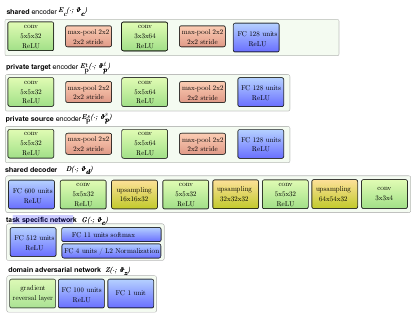

It is worth noting that the above architecture was employed for Pose estimation. As a result, we have provided a classifier instead of the *task specific network layer* since we are interested in object recognition.

Moreover, due to the small receptive field of the convolutional layers, the original architecture lowers the feature map by a too small amount. This makes the learning impossible with the resources offered by Colab and the size of our inputs, since the final fully connected layers would require too much memory to allocate everything. Therefore, we extended both the encoder and the decoder to make the architecture a bit more lightweight in terms of size of hidden representations.

This problem has arisen since the pictures in the Linemod dataset are substantially smaller than those in the Adaptiope dataset. 

To deal with the complex reconstruction pattern of the Domain Separation Networks, we have defined some useful constants, convenient to handle the forward method of the networks and useful to improve the readability of the code.

In [ ]:
class ReconstructionCode(Enum):
    r"""
    Enumerator employed in order to understand which encoder to use (source
    or target) to perform the image reconstruction using the decoder
    """
    SOURCE = 0
    TARGET = 1


class ReconstructionSheme(Enum):
    r"""
    Enumerator employed in order to understand how to merge the reconstruction
    codes either the shared code, the private or all of them.
    """
    ONLY_PRIVATE_CODE = 0
    BOTH_SHARED_AND_PRIVATE = 1
    ONLY_SHARED_CODE = 2

As for making the forward method less verbose, we have provided some layers used to abstract away implementation details regarding the flattening and the reshaping of the feature maps generated by convolutional layers.

In [ ]:
class Flatten(nn.Module):
    r"""
    Module employed in order to reshape the tensor with
    `torch.flatten(x)`.
    In the architecture it is employed so as to flatten a 4 dimensional
    tensor into a 2 dimensional one
    """

    def __init__(self, *args: str) -> None:
        r"""
        Initialize the Flatten module

        Args:
        - args [str]: additional arguments, they will be ignored
        """
        super(Flatten, self).__init__()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        r"""
        Forward method

        Args:
        - x [torch.Tensor]: source sample

        Returns:
        - x after the reshape
        """
        return torch.flatten(x, 1)


class Reshape3D(nn.Module):
    r"""
    Module employed in order to reshape a tensor into a 3 dimensional one
    """

    def __init__(self, dim1: int, dim2: int, dim3: int, *args: str) -> None:
        r"""
        Initialize the Reshape3D module

        Args:
        - dim1 [int]: first dimension for the resize
        - dim2 [int]: second dimension for the resize
        - dim3 [int]: third dimension for the resize
        - args [str]: additional arguments, they will be ignored
        """
        super(Reshape3D, self).__init__()
        self.dim1 = dim1
        self.dim2 = dim2
        self.dim3 = dim3

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        r"""
        Forward method

        Args:
        - x [torch.Tensor]: source sample

        Returns:
        - x after the 3D resize
        """
        return x.view(-1, self.dim1, self.dim2, self.dim3)

### Original DSN

The DSN architecture we have implemented as a first solution is depicted below.

With respect to previous architecture, here we have added a weight initialization technique for all the layers for which we did not posses any weight. To do so, we have relied on one of the most popular weight initialization technique, namely the [Kaiming He initialization](https://arxiv.org/abs/1502.01852v1). 

Following this approach we have realized that we neither possess as much data as the one of the author of the papers nor have the computational time to run such massive number of epochs required for training the architecture. Overall, this method was not able to converge to a decent accuracy, probably due to the fact that the network was not able to convey all the losses while correctly classifying the examples. From this trial we have understood that such architecture cannot provide us decent results. Moreover, starting with a non-pretrained network we surely do not have the flexibility and the generality of networks pretrained on large scale datasets such as ImageNet. Futhermore, the pipeline devised by Konstantinos Bousmalis et. al. could not be implemented in Colab due to time, resource constraints and poor data availability (4000 samples).

In [ ]:
class DSN(nn.Module):
    r"""
    Customized DSN architecture.
    This implementation takes inspiration from the Domain Separation Networks
    by Konstantinos Bousmalis et al.
    In practice, we aim to reproduce the main principles behind the architecture
    proposed for the LineMod dataset. However, since we have images of size 224x224 which
    is different from both MNIST and LinMod, we have added 3 more convolutional layers
    and 3 more maxpooling in order to reduce the tensor sizes while exploiting the
    advantages of low dimensional kernels, otherwise for Colab flattening such
    features would have become impossible.

    **Note**: it is designed to work with `batch_size` equal to 32, which is the sample size
    chosen for the experiments of Konstantinos Bousmalis et al
    """

    def __init__(
        self,
        num_classes: int = 20,
        dropout: float = 0.5,
        kaiming: bool = False,
        feature_extractor: bool = False,
    ) -> None:
        r"""
        Initialize the custom DSN network architecture employed on Linemod data to ours.
        We have added 3 extra layers for the encoders and the decoders so as to match
        the image size and avoid memory problems in for the fc 128 output layers

        The code size is 128 as depicted in the paper.

        According to the paper the layer provided are:
        - private source encoder
        - private target encoder
        - shared encoder
        - shared decoder
        - task specific network (in our case it is the classifier)
        - domain adversarial network (to predict the domain)

        Default:
        - num_classes [int] = 20
        - kaiming [bool] = False
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: first dimension for the resize
        - dropout [float]: dropout probability, in the original network it is implemented
        in the shared encoder before the previous layer.
        - kaiming [bool]: whether to use the kaiming initialization on the convolutional
        and linear layers instead of the default initialization.
        - feature_extractor [bool]: whether to use the model only to extract the features
        """
        super(DSN, self).__init__()

        # In the original tensorfrow code: default_encoder
        self.source_encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # The Conv and MaxPool layers below are added in order
            # to reduce the image size, so as to fit the actual image size
            nn.Conv2d(64, 128, kernel_size=3, padding=2),  # 1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=2),  # 2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=2),  # 3
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            # output 32, 128
        )

        # identical to the source_encoder
        self.target_encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            # output 32, 128
        )

        # indentical to the source_encoder except for the dropout
        self.shared_encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            Flatten(),
            nn.Linear(64 * 8 * 8, 512),
            nn.Dropout(p=dropout),  # present in the original implementation
            # output 32, 128
        )

        # The decoder aims to reconstruct the picture, thus its output
        # needs to convey to the original image size: [32, 3, 224, 224]
        # It is basically the reverse of the encoder
        # up to know it works, but it should not be that good since
        # the upsampling with 2 scale factor is not equal to the maxpool2d
        self.shared_decoder = nn.Sequential(
            Reshape3D(32, 4, 4),
            nn.Conv2d(32, 64, kernel_size=1, padding=0),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(224, 224)),
            nn.Conv2d(32, 3, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            # output 32, 128
        )

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=100, out_features=20),
        )

        # Domain adversarial network, implemented following the paper
        self.domain_adversarial_network = nn.Sequential(
            nn.Linear(in_features=512, out_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=100, out_features=2),
        )

        # Check whether we should just return the features
        self.feature_extractor = feature_extractor

        # module to initialize
        init_modules = [
            self.source_encoder,
            self.target_encoder,
            self.shared_decoder,
            self.classifier,
            self.domain_adversarial_network,
        ]

        # Init modules with kaiming initialization if requested
        if kaiming:
            for m in init_modules:
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight.data)
                    if m.bias is not None:
                        nn.init.constant_(m.bias.data, 0)

    def forward(
        self,
        x: torch.Tensor,
        rec_code: ReconstructionCode = ReconstructionCode.SOURCE,
        rec_scheme: ReconstructionSheme = ReconstructionSheme.ONLY_SHARED_CODE,
        grl_lambda: float = 0.0,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - rec_code [ReconstructionCode]: which private features to employ
        - rec_scheme [ReconstructionSheme]: which scheme to use in order to merge
        the features for the reconstruction
        - grl_lambda [float]: Gradient Reversal Layer (GRL) lambda parameter
        Since according to the paper it implements the DANN loss, using the same
        idea of adversarial scheme.

        Returns:
        - class_pred [torch.Tensor]: class prediction
        - domain_pred [torch.Tensor]: domain prediction for the DANN
        - private_code [torch.Tensor]: code coming from a private
        encoder either of the SOURCE or TARGET depends on the rec_code value
        - shared_code [torch.Tensor]: code coming from the shared encoder
        - rec_code [torch.Tensor]: reconstructed code
        """

        # shared encoder
        shared_code = self.shared_encoder(x)
        # get the class prediction
        class_pred = self.classifier(shared_code)
        # reverse the shared code in order to employ the reverse gradient
        rev_shared_code = GradientReversalFn.apply(shared_code, grl_lambda)
        # get the domain prediction
        domain_pred = self.domain_adversarial_network(rev_shared_code)

        # private encoder
        private_code = None
        if rec_code == ReconstructionCode.SOURCE:
            private_code = self.source_encoder(x)
        elif rec_code == ReconstructionCode.TARGET:
            private_code = self.target_encoder(x)
        else:
            raise Exception("No valid code selected")

        # shared decoder
        merged_code = None
        # clone is needed in order to avoid backpropagation issues, as the
        # merged code is a function of shared and private code
        if rec_scheme == ReconstructionSheme.ONLY_PRIVATE_CODE:
            # overriding to private code
            merged_code = private_code.clone()
        elif rec_scheme == ReconstructionSheme.BOTH_SHARED_AND_PRIVATE:
            # merging both shared and private
            merged_code = shared_code.clone()
            merged_code += private_code.clone()
        elif rec_scheme == ReconstructionSheme.ONLY_SHARED_CODE:
            merged_code = shared_code.clone()
        else:
            raise Exception("No valid scheme selected")

        # shared decoder
        rec_input = self.shared_decoder(merged_code)

        return class_pred, domain_pred, private_code, shared_code, rec_input

## ResNetDSN and AlexNetDSN

The second attempt consisted in relying on a more performing backbone for the encoding part, namely `ResNet18` and `Alexnet`, both with pretrained weights. 

In order to use `ResNet18` as a feature extractor for the three encoders (two private and one shared), we had to effectively design the corresponding decoder.

When designing an autoencoder architecture, it is a good practice to have a symmetric model, meaning the decoder should mirror the decoder.

Since `ResNet18` includes residual connections, we have had some difficulty constructing an effective decoder with residual connections we were confident works correctly using the Convolvutional and Upsample layers as shown in the paper. 

To coupe with that we have used an existing decoder architecture we were sure worked.

Concerning the difficulty we had in training the DSN, even the AlexNet-DSN based architecture uses the `ResNet18` decoder to effectively rely on a pretrained decoder, resulting in a non-symmetric auto-encoder structure.

In [ ]:
r"""
The implementation of the decoder is adapted from
[link]: https://github.com/julianstastny/VAE-ResNet18-PyTorch
"""


class ResizeConv2d(nn.Module):
    r"""
    ResNet18 module for the Upsample operation following a convolutional one
    """

    def __init__(
        self, in_channels, out_channels, kernel_size, scale_factor, mode="nearest"
    ):
        super().__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=1, padding=1
        )

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        x = self.conv(x)
        return x


class BasicBlockDec(nn.Module):
    r"""
    ResNet18 deconvolution block with residual connections
    """

    def __init__(self, in_planes, stride=1):
        super().__init__()

        planes = int(in_planes / stride)

        self.conv2 = nn.Conv2d(
            in_planes, in_planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(in_planes)
        # self.bn1 could have been placed here, but that messes up the order of the layers when printing the class

        if stride == 1:
            self.conv1 = nn.Conv2d(
                in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False
            )
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential()
        else:
            self.conv1 = ResizeConv2d(
                in_planes, planes, kernel_size=3, scale_factor=stride
            )
            self.bn1 = nn.BatchNorm2d(planes)
            self.shortcut = nn.Sequential(
                ResizeConv2d(in_planes, planes, kernel_size=3, scale_factor=stride),
                nn.BatchNorm2d(planes),
            )

    def forward(self, x):
        out = torch.relu(self.bn2(self.conv2(x)))
        out = self.bn1(self.conv1(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class ResNet18Dec(nn.Module):
    r"""
    ResNet18 Deconvolutional architecture
    """

    def __init__(self, num_Blocks=[2, 2, 2, 2], z_idim=10, nc=3):
        super().__init__()
        self.in_planes = 512
        self.linear = nn.Linear(z_idim, 512)
        self.layer4 = self._make_layer(BasicBlockDec, 256, num_Blocks[3], stride=2)
        self.layer3 = self._make_layer(BasicBlockDec, 128, num_Blocks[2], stride=2)
        self.layer2 = self._make_layer(BasicBlockDec, 64, num_Blocks[1], stride=2)
        self.layer1 = self._make_layer(BasicBlockDec, 64, num_Blocks[0], stride=2)
        self.conv1 = ResizeConv2d(32, nc, kernel_size=3, scale_factor=3.5)

    def _make_layer(self, BasicBlockDec, planes, num_Blocks, stride):
        strides = [stride] + [1] * (num_Blocks - 1)
        layers = []
        for stride in reversed(strides):
            layers += [BasicBlockDec(self.in_planes, stride)]
        self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(z.size(0), 512, 1, 1)
        x = F.interpolate(x, scale_factor=4)
        x = self.layer4(x)
        x = self.layer3(x)
        x = self.layer2(x)
        x = self.layer1(x)
        # Sigmoid is employed since we are expecting to produce an image, thus
        # 3 channels with values within the interval [0, 1]
        x = torch.sigmoid(self.conv1(x))
        x = x.view(x.size(0), 3, 224, 224)
        return x

Once the decoder have been implemented, we have defined on the same idea of the original DSN, another architecture based on the `ResNet18` architecture.

In [ ]:
class ResNet18DSN(nn.Module):
    r"""
    Customized ResNet18 DSN architecture.
    This implementation takes inspiration from the Domain Separation Networks
    by Konstantinos Bousmalis et al.
    In practice, we aim to reproduce the main principles behind the architecture
    proposed for the LineMod dataset. However, since we have images of size 224x224 which
    is different from both MNIST and LinMod.
    Moreover, we have added 3 more convolutional layers and 3 more maxpooling in order to reduce
    the thensor sizes while exploiting the advantages of low dimensional kernels, otherwise
    for Colab flatten such features would have become impossible.

    **Note**: it is designed to work with `batch_size` equal to 32, which is the sample size
    chosen for the experiments of Konstantinos Bousmalis et al
    """

    def __init__(
        self,
        num_classes: int = 20,
        pretrained: bool = False,
        feature_extractor: bool = False,
        dropout: float = 0.5,
    ) -> None:
        r"""
        Initialize the custom DSN network architecture employed on Linemod data to ours.
        We have added 3 extra layers for the encoders and the decoders so as to match
        the image size and avoid memory problems in for the fc 128 output layers

        The code size is 128 as depicted in the paper.

        According to the paper the layer provided are:
        - private source encoder
        - private target encoder
        - shared encoder
        - shared decoder
        - task specific network (in our case it is the classifier)
        - domain adversarial network (to predict the domain)

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = False
        - feature_extractor [bool] = False
        - dropout [float] = 0.5

        Args:
        - num_classes [int]: first dimension for the resize
        - dropout [float]: dropout probability, in the original network it is implemented
        in the shared encoder before the previous layer.
        - pretrained [bool]: whether to use the pretrained weights for the encoder
        - feature_extractor [bool]: whether to use the model only to extract the features
        """
        super(ResNet18DSN, self).__init__()

        # Take the resNet18 module and discard the last layer
        features = nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1]

        # In the original tensorfrow code: default_encoder
        self.source_encoder = nn.Sequential(
            *features,
            Flatten(),
        )

        # identical to the source_encoder
        self.target_encoder = nn.Sequential(
            *features,
            Flatten(),
        )

        # indentical to the source_encoder except for the dropout
        self.shared_encoder = nn.Sequential(
            *features,
            Flatten(),
            nn.Dropout(p=dropout),  # present in the original implementation
        )

        self.shared_decoder = nn.Sequential(
            ResNet18Dec(z_idim=512),
        )

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=100, out_features=20),
        )

        # domain adversarial network according to the paper
        self.domain_adversarial_network = nn.Sequential(
            nn.Linear(in_features=512, out_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=100, out_features=2),
        )

        # in the forward return only the features!
        self.feature_extractor = feature_extractor

        # module to initialize
        init_modules = [self.classifier, self.domain_adversarial_network]

        # init modules
        for m in init_modules:
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)

    def forward(
        self,
        x: torch.Tensor,
        rec_code: ReconstructionCode = ReconstructionCode.SOURCE,
        rec_scheme: ReconstructionSheme = ReconstructionSheme.ONLY_SHARED_CODE,
        grl_lambda: float = 0.0,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - rec_code [ReconstructionCode]: which private features to employ
        - rec_scheme [ReconstructionSheme]: which scheme to use in order to merge
        the features for the reconstruction
        - grl_lambda [float]: Gradient Reversal Layer (GRL) lambda parameter
        Since according to the paper it implements the DANN loss, using the same
        idea of adversarial scheme.

        Returns:
        - class_pred [torch.Tensor]: class prediction
        - domain_pred [torch.Tensor]: domain prediction for the DANN
        - private_code [torch.Tensor]: code coming from a private
        encoder either of the SOURCE or TARGET depends on the rec_code value
        - shared_code [torch.Tensor]: code coming from the shared encoder
        - rec_code [torch.Tensor]: reconstructed code
        """

        # shared encoder
        shared_code = self.shared_encoder(x)
        # return the features if the feature extractor flag is set
        if self.feature_extractor:
            return shared_code
        # get the class prediction
        class_pred = self.classifier(shared_code)
        # reverse the shared code in order to employ the reverse gradient
        rev_shared_code = GradientReversalFn.apply(shared_code, grl_lambda)
        # get the domain prediction
        domain_pred = self.domain_adversarial_network(rev_shared_code)

        # private encoder
        private_code = None
        if rec_code == ReconstructionCode.SOURCE:
            private_code = self.source_encoder(x)
        elif rec_code == ReconstructionCode.TARGET:
            private_code = self.target_encoder(x)
        else:
            raise Exception("No valid code selected")

        # shared decoder
        merged_code = None
        # clone is needed in order to avoid backpropagation issues, as the
        # merged code is a function of shared and private code
        if rec_scheme == ReconstructionSheme.ONLY_PRIVATE_CODE:
            # overriding to private code
            merged_code = private_code.clone()
        elif rec_scheme == ReconstructionSheme.BOTH_SHARED_AND_PRIVATE:
            # merging both shared and private
            merged_code = shared_code.clone()
            merged_code += private_code.clone()
        elif rec_scheme == ReconstructionSheme.ONLY_SHARED_CODE:
            merged_code = shared_code.clone()
        else:
            raise Exception("No valid scheme selected")

        # shared decoder
        rec_input = self.shared_decoder(merged_code)

        return class_pred, domain_pred, private_code, shared_code, rec_input

In [ ]:
class AlexNetDSN(nn.Module):
    r"""
    Customized AlexNet DSN architecture.
    This implementation takes inspiration from the Domain Separation Networks
    by Konstantinos Bousmalis et al.
    In practice, we aim to reproduce the main principles behind the architecture
    proposed for the LineMod dataset. However, since we have images of size 224x224 which
    is different from both MNIST and LinMod.
    Moreover, we have added 3 more convolutional layers and 3 more maxpooling in order to reduce
    the thensor sizes while exploiting the advantages of low dimensional kernels, otherwise
    for Colab flatten such features would have become impossible.

    **Note**: it is designed to work with `batch_size` equal to 32, which is the sample size
    chosen for the experiments of Konstantinos Bousmalis et al
    """

    def __init__(
        self,
        num_classes: int = 20,
        dropout: float = 0.5,
        pretrained: bool = True,
        feature_extractor: bool = False,
    ) -> None:
        r"""
        Initialize the custom DSN network architecture employed on Linemod data to ours.
        We have added 3 extra layers for the encoders and the decoders so as to match
        the image size and avoid memory problems in for the fc 128 output layers

        The code size is 128 as depicted in the paper.

        According to the paper the layer provided are:
        - private source encoder
        - private target encoder
        - shared encoder
        - shared decoder
        - task specific network (in our case it is the classifier)
        - domain adversarial network (to predict the domain)

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = True
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: first dimension for the resize
        - dropout [float]: dropout probability, in the original network it is implemented
        in the shared encoder before the previous layer.
        - pretrained [bool]: whether the network is pre-trained or not
        - feature_extractor [bool]: whether to use the model only to extract the features
        """
        super(AlexNetDSN, self).__init__()

        self.source_encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.target_encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # indentical to the source_encoder except for the dropout
        self.shared_encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.mid_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
        )

        # The decoder aims to reconstruct the picture, thus its output
        # needs to convey to the original image size: [32, 3, 224, 224]
        # Here we employ the ResNet one for the sake of simplicity and reuse
        # of component
        self.shared_decoder = nn.Sequential(
            ResNet18Dec(z_idim=512),
        )

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=4096, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=100, out_features=20),
        )

        # domain adversarial network according to the paper
        self.domain_adversarial_network = nn.Sequential(
            nn.Linear(in_features=4096, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=100),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=100, out_features=2),
        )

        # merge features layer
        self.merge_features = nn.Sequential(nn.Linear(8192, 512), nn.ReLU(inplace=True))

        # in the forward return only the features!
        self.feature_extractor = feature_extractor

        # module to initialize
        init_modules = [
            self.classifier,
            self.domain_adversarial_network,
            self.shared_decoder,
            self.mid_classifier,
            self.merge_features,
        ]

        # init modules
        for m in init_modules:
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)

        from torchvision.models.alexnet import model_urls

        pretrained_params = load_state_dict_from_url(
            model_urls["alexnet"], progress=True
        )

        # load weights from alexnet base net
        current_params = self.state_dict()

        # loading weights coming from common layers
        for key, value in current_params.items():
            # the common layers between the two nets are:
            # features->features and classifier->mid_classifier
            if key.split(".")[0] in ["source_encoder"]:
                print("Adding key", key, "in current params")
                current_params[key] = pretrained_params[
                    key.replace("source_encoder", "features")
                ]
            elif key.split(".")[0] in ["target_encoder"]:
                print("Adding key", key, "in current params")
                current_params[key] = pretrained_params[
                    key.replace("target_encoder", "features")
                ]
            elif key.split(".")[0] in ["shared_encoder"]:
                print("Adding key", key, "in current params")
                current_params[key] = pretrained_params[
                    key.replace("shared_encoder", "features")
                ]
        # load weigths
        self.load_state_dict(current_params)

    def forward(
        self,
        x: torch.Tensor,
        rec_code: ReconstructionCode = ReconstructionCode.SOURCE,
        rec_scheme: ReconstructionSheme = ReconstructionSheme.ONLY_SHARED_CODE,
        grl_lambda: float = 0.0,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - rec_code [ReconstructionCode]: which private features to employ
        - rec_scheme [ReconstructionSheme]: which scheme to use in order to merge
        the features for the reconstruction
        - grl_lambda [float]: Gradient Reversal Layer (GRL) lambda parameter
        Since according to the paper it implements the DANN loss, using the same
        idea of adversarial scheme.

        Returns:
        - class_pred [torch.Tensor]: class prediction
        - domain_pred [torch.Tensor]: domain prediction for the DANN
        - private_code [torch.Tensor]: code coming from a private
        encoder either of the SOURCE or TARGET depends on the rec_code value
        - shared_code [torch.Tensor]: code coming from the shared encoder
        - rec_code [torch.Tensor]: reconstructed code
        """

        # shared encoder
        shared_code = self.mid_classifier(self.shared_encoder(x))
        # return the features if the feature extractor flag is set
        if self.feature_extractor:
            return shared_code
        # get the class prediction
        class_pred = self.classifier(shared_code)
        # reverse the shared code in order to employ the reverse gradient
        rev_shared_code = GradientReversalFn.apply(shared_code, grl_lambda)
        # get the domain prediction
        domain_pred = self.domain_adversarial_network(rev_shared_code)

        # private encoder
        private_code = None
        if rec_code == ReconstructionCode.SOURCE:
            private_code = self.mid_classifier(self.source_encoder(x))
        elif rec_code == ReconstructionCode.TARGET:
            private_code = self.mid_classifier(self.target_encoder(x))
        else:
            raise Exception("No valid code selected")

        # shared decoder
        merged_code = None
        # clone is needed in order to avoid backpropagation issues, as the
        # merged code is a function of shared and private code
        if rec_scheme == ReconstructionSheme.ONLY_PRIVATE_CODE:
            # overriding to private code
            merged_code = self.merge_features(
                torch.cat((private_code.clone(), private_code.clone()), 1)
            )
        elif rec_scheme == ReconstructionSheme.BOTH_SHARED_AND_PRIVATE:
            merged_code = self.merge_features(
                torch.cat((shared_code.clone(), private_code.clone()), 1)
            )
        elif rec_scheme == ReconstructionSheme.ONLY_SHARED_CODE:
            merged_code = self.merge_features(
                torch.cat((shared_code.clone(), shared_code.clone()), 1)
            )
        else:
            raise Exception("No valid scheme selected")

        rec_input = self.shared_decoder(merged_code)

        return class_pred, domain_pred, private_code, shared_code, rec_input

Despite achieving better results with respect to the previous attemps by using a more performing backbone, we were still struggling in reaching the baseline accuracy. At first, we thought it was due to the fact that we were using a strongly unbalanced network being able to achieve good performances at the encoding side, whereas performing awfully at the decoding side, cancelling the effect of the reconstruction loss which is somehow the building block of this approach.

To effectively fill the gap between encoders and decoders, we have trained the model freezing all the parameters except the decoder ones and train the model for reconstruction purposes for more than 200 epochs. Due to Colab strict time and resources requirement, we were not able to do that in a single run. Therefore, we have provided a robust pipeline to train the model throughout different colab sessions. This has not been a trivial task for mostly the following reasons:
  - Colab GPU interrupt may happen at any time, thus it was necessary for us to save a model checkpoint at each epoch, or after a certain amount.
  - In new sessions, splits may be different. In simple terms, it may happen that in a new session, the RNG of Pytorch provides different training and validation sets, resulting in unreliable results, since some images that were in the validation/test set before the split may now be in the training set. To enforce Pytorch to use the same splits, we have forced the RNG to employ the same seed, allowing us to overcome this issue.
  - Some hyperparameters such as the number of epochs (on which, for instance the lambda is based), the optimizers parameters and the best loss (employed for the early stopping) have to be saved too inside the checkpoints.

As an additional improvement, we have provided a way to better merge the features from both the private encoder and the shared one.
The original DSN approach performs the sum between the shared and private code:

$$\hat{x} = D(E_c(x) + E_p(x))$$

Which defines the reconstructed image as the decoding of the sum of the code of the encoded image.

As it has provided better results, and it is better assessed in the experiment section, instead of the suggested approach, we have provided a layer which maps the code into a lower dimensional embedding after the codes have been concatenated.

To be more formal, let $h$ the function which maps the code into a lower dimensional embedding, then the reconstructed image can be defined as:

$$\hat{x} = D(h(E_c(x) \cup E_p(x)))$$

Finally, the hyperparameters of the network has been intensively tuned, stressing each of them separately and observing their impact singularly on the test performances. In particular, we have used different values for the hyperparameters `alpha`, `beta` and `gamma` with respect to the ones provided by the paper. The ones that provided better results were actually quite higher, probably due to the fact that the number of epochs we used for training the network was very low.

As we will present in the results section, all these optimizations have lead us to a better accuracy. Still, we are sure that we have not exploited the full potential of the model (data, time, GPU resources). However, thanks to a better model definition, good parameter selection and decoder pretraining, we have managed to fill the gaps with what the author of the paper did and what we have been able to do with the resources in our possession.

In [ ]:
class ResNet18DSNImproved(nn.Module):
    r"""
    Improved ResNet18 DSN architecture.
    This implementation takes inspiration from the Domain Separation Networks
    by Konstantinos Bousmalis et al.
    In practice, we aim to reproduce the main principles behind the architecture
    proposed for the LineMod dataset. However, since we have images of size 224x224 which
    is different from both MNIST and LinMod.
    Moreover, we have added 3 more convolutional layers and 3 more maxpooling in order to reduce
    the thensor sizes while exploiting the advantages of low dimensional kernels, otherwise
    for Colab flatten such features would have become impossible.

    Moreover, we have changed the way in which the final image has been reconstructed,
    since we have proven it provides better results for our tasks of domain adaptation

    **Note**: it is designed to work with `batch_size` equal to 32, which is the sample size
    chosen for the experiments of Konstantinos Bousmalis et al
    """

    def __init__(
        self,
        num_classes: int = 20,
        pretrained: bool = True,
        feature_extractor: bool = False,
        dropout: float = 0.5,
    ) -> None:
        r"""
        Initialize the custom DSN network architecture employed on Linemod data to ours.
        We have added 3 extra layers for the encoders and the decoders so as to match
        the image size and avoid memory problems in for the fc 128 output layers

        The code size is 128 as depicted in the paper.

        According to the paper the layer provided are:
        - private source encoder
        - private target encoder
        - shared encoder
        - shared decoder
        - task specific network (in our case it is the classifier)
        - domain adversarial network (to predict the domain)

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = False
        - feature_extractor [bool] = False
        - pretrained [bool] = True

        Args:
        - num_classes [int]: first dimension for the resize
        - dropout [float]: dropout probability, in the original network it is implemented
        in the shared encoder before the previous layer.
        - pretrained [bool]: whether to use the pretrained network or not
        - feature_extractor [bool]: whether to use the model only to extract the features
        """
        super(ResNet18DSNImproved, self).__init__()

        # In the original tensorfrow code: default_encoder
        self.source_encoder = nn.Sequential(
            *nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1],
            Flatten(),
        )

        # identical to the source_encoder
        self.target_encoder = nn.Sequential(
            *nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1],
            Flatten(),
        )

        # indentical to the source_encoder
        self.shared_encoder = nn.Sequential(
            *nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1],
            Flatten(),
        )

        # layer which defines the function `h` defined before, namely the map
        # to a lower dimensional embedding
        self.merge_features = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(inplace=True))

        # shared decoder, namely the deconvolutional ResNet18
        self.shared_decoder = nn.Sequential(
            ResNet18Dec(z_idim=512),
        )

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=20),
        )

        # domain adversarial network part
        self.domain_adversarial_network = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, 2),
        )

        # domain adversarial network according to the paper
        self.bottle_neck = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
        )

        # in the forward return only the features!
        self.feature_extractor = feature_extractor

        # module to initialize
        init_modules = [
            self.classifier,
            self.bottle_neck,
            self.domain_adversarial_network,
        ]

        # init modules
        for m in init_modules:
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)

        # load weights of decoder
        current_params = self.state_dict()
        # decoder we have trained for 200 epochs
        decoder_state_dict = torch.load(
            "/home/lucademenego/DECODER200e/net.pth"
            if START_LOCALLY
            else "/content/gdrive/MyDrive/BEST_NETS/DSN/DECODER/net.pth"
        )
        for key, value in current_params.items():
            if (
                key.split(".")[0] == "shared_decoder"
                or key.split(".")[0] == "merge_features"
            ):
                print("Adding ", key)
                current_params[key] = decoder_state_dict[key]
        self.load_state_dict(current_params)

    def forward(
        self,
        x: torch.Tensor,
        rec_code: ReconstructionCode = ReconstructionCode.SOURCE,
        rec_scheme: ReconstructionSheme = ReconstructionSheme.ONLY_SHARED_CODE,
        grl_lambda: float = 0.0,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - rec_code [ReconstructionCode]: which private features to employ
        - rec_scheme [ReconstructionSheme]: which scheme to use in order to merge
        the features for the reconstruction
        - grl_lambda [float]: Gradient Reversal Layer (GRL) lambda parameter
        Since according to the paper it implements the DANN loss, using the same
        idea of adversarial scheme.

        Returns:
        - class_pred [torch.Tensor]: class prediction
        - domain_pred [torch.Tensor]: domain prediction for the DANN
        - private_code [torch.Tensor]: code coming from a private
        encoder either of the SOURCE or TARGET depends on the rec_code value
        - shared_code [torch.Tensor]: code coming from the shared encoder
        - rec_code [torch.Tensor]: reconstructed code
        """

        # shared encoder
        shared_code = self.shared_encoder(x)
        # return the features if the feature extractor flag is set
        if self.feature_extractor:
            return shared_code

        # bottle_neck
        bottle_neck_res = self.bottle_neck(shared_code)

        # get the class prediction
        class_pred = self.classifier(bottle_neck_res)
        # reverse the shared code in order to employ the reverse gradient
        rev_shared_code = GradientReversalFn.apply(bottle_neck_res, grl_lambda)
        # get the domain prediction
        domain_pred = self.domain_adversarial_network(rev_shared_code)

        # private encoder
        private_code = None
        if rec_code == ReconstructionCode.SOURCE:
            private_code = self.source_encoder(x)
        elif rec_code == ReconstructionCode.TARGET:
            private_code = self.target_encoder(x)
        else:
            raise Exception("No valid code selected")

        # shared decoder
        merged_code = None
        # clone is needed in order to avoid backpropagation issues, as the
        # merged code is a function of shared and private code
        if rec_scheme == ReconstructionSheme.ONLY_PRIVATE_CODE:
            # overriding to private code
            merged_code = self.merge_features(
                torch.cat((private_code, private_code), 1)
            )
        elif rec_scheme == ReconstructionSheme.BOTH_SHARED_AND_PRIVATE:
            # merging both shared and private
            merged_code = self.merge_features(torch.cat((shared_code, private_code), 1))
        elif rec_scheme == ReconstructionSheme.ONLY_SHARED_CODE:
            # overriding the merge code
            merged_code = self.merge_features(torch.cat((shared_code, shared_code), 1))
        else:
            raise Exception("No valid scheme selected")

        # shared decoder output
        rec_input = self.shared_decoder(merged_code)

        return class_pred, domain_pred, private_code, shared_code, rec_input

## DSNMEDM

As a last experiment, we have merged the most successfull approach, namely the MEDM, with the most disappointing one, the DSN. 

The result was quite impressive as it has allowed to reach astonishing results in the task of domain adaptatation, by surpassing the original MEDM approach. As a result, we present this as a final solution for our project.

The main idea behind our approach is to improve the performances of the `DSN` by adding two well known and state-of-the-art losses for domain adaptation, namely the `entropy` and the `diversity loss`. 

Both of them are assessed during the description of the solution.

In [ ]:
class DSNMEDM(nn.Module):
    r"""
    MEDM DSN architecture.
    This implementation takes inspiration from the Domain Separation Networks
    by Konstantinos Bousmalis et al. and from the by Entropy Minimization vs. Diversity
    Maximization paper for Domain Adaptation et al. Xiaofu Wu.
    In practice, we aim to taake both principles behind the architectures, by employing the
    reconstruction loss to better enforce the encoders to learn better feature representation
    and as domain adaptation losses we have employed the `entropy` and the `divergence` loss
    as stated in the MEDM.

    **Note**: it is designed to work with `batch_size` equal to 32, which is the sample size
    chosen for the experiments of Konstantinos Bousmalis et al
    """

    def __init__(
        self,
        num_classes: int = 20,
        pretrained: bool = True,
        feature_extractor: bool = False,
        dropout: float = 0.5,
    ) -> None:
        r"""
        Initialize the custom DSN+MEDM network architecture exploiting both the
        reconstruction loss and the MEDM loss.

        The code size is 128 as depicted in the paper.

        According to the paper the layer provided are:
        - private source encoder
        - private target encoder
        - shared encoder
        - shared decoder
        - task specific network (in our case it is the classifier)

        we remove the domain adversarial piece since we have decided to rely on the losses
        of MEDM so as to accomplish domain adaptation.

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = True
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: first dimension for the resize
        - dropout [float]: dropout probability, in the original network it is implemented
        in the shared encoder before the previous layer.
        - pretrained [bool]: whether to use pre-trained weights.
        - feature_extractor [bool]: whether to use the model only to extract the features
        """
        super(DSNMEDM, self).__init__()

        # In the original tensorfrow code: default_encoder
        self.source_encoder = nn.Sequential(
            *nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1],
            Flatten(),
        )

        # identical to the source_encoder
        self.target_encoder = nn.Sequential(
            *nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1],
            Flatten(),
        )

        # indentical to the source_encoder except for the dropout
        self.shared_encoder = nn.Sequential(
            *nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1],
            Flatten(),
        )

        # merge feature layer, as we have seen it works pretty well
        self.merge_features = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(inplace=True))

        # shared encoder network (the reverse of the ResNet)
        self.shared_decoder = nn.Sequential(
            ResNet18Dec(z_idim=512),
        )

        # classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=256, out_features=20), nn.Softmax()
        )

        # bottle neck layer
        self.bottle_neck = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
        )

        # in the forward return only the features!
        self.feature_extractor = feature_extractor

        # module to initialize
        init_modules = [self.classifier, self.bottle_neck]

        # init modules
        for m in init_modules:
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)

    def forward(
        self,
        x: torch.Tensor,
        rec_code: ReconstructionCode = ReconstructionCode.SOURCE,
        rec_scheme: ReconstructionSheme = ReconstructionSheme.ONLY_SHARED_CODE,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        r"""
        Forward method

        **Note**: in the case of `feature_extractor` set to `True` it returns
        only the features [torch.Tensor]

        Args:
        - x [torch.Tensor]: source sample
        - rec_code [ReconstructionCode]: which private features to employ
        - rec_scheme [ReconstructionSheme]: which scheme to use in order to merge
        the features for the reconstruction

        Returns:
        - class_pred [torch.Tensor]: class prediction
        - private_code [torch.Tensor]: code coming from a private
        encoder either of the SOURCE or TARGET depends on the rec_code value
        - shared_code [torch.Tensor]: code coming from the shared encoder
        - rec_code [torch.Tensor]: reconstructed code
        """

        # shared encoder
        shared_code = self.shared_encoder(x)
        # return the features if the feature extractor flag is set
        if self.feature_extractor:
            return shared_code

        bottle_neck_res = self.bottle_neck(shared_code)

        # get the class prediction
        class_pred = self.classifier(bottle_neck_res)

        # private encoder
        private_code = None
        if rec_code == ReconstructionCode.SOURCE:
            private_code = self.source_encoder(x)
        elif rec_code == ReconstructionCode.TARGET:
            private_code = self.target_encoder(x)
        else:
            raise Exception("No valid code selected")

        # shared decoder
        merged_code = None
        # merged code is a function of shared and private code
        if rec_scheme == ReconstructionSheme.ONLY_PRIVATE_CODE:
            # overriding to private code
            merged_code = self.merge_features(
                torch.cat((private_code, private_code), 1)
            )
            # merged_code = private_code
        elif rec_scheme == ReconstructionSheme.BOTH_SHARED_AND_PRIVATE:
            # merging both shared and private
            merged_code = self.merge_features(torch.cat((shared_code, private_code), 1))
        elif rec_scheme == ReconstructionSheme.ONLY_SHARED_CODE:
            # shared code
            merged_code = self.merge_features(torch.cat((shared_code, shared_code), 1))
        else:
            raise Exception("No valid scheme selected")

        # shared decoder
        rec_input = self.shared_decoder(merged_code)

        return class_pred, private_code, shared_code, rec_input

## Rotation Loss Architecture

As a fourth method, that we mention for completeness but which had provided low performance, we propose a basic network based on the **Rotation Loss**, inspired by the paper of [Liang Xiao et al.](https://arxiv.org/pdf/2010.07539.pdf).

The idea behind this self-supervising approach is to train the model not only on the classification, but also on another pretext task: predict the rotation angle of a given image of the target domain. This method generally provides good results since, while learning how to predict the rotation, the model's feature extraction layers inherently learn important features of the target dataset.

Formally, Liang Xiao et al. address the Unsupervised Domain Adaptation task by minimizing:

$$L = L_{task} + \lambda L_{pretext}$$

Which are jointly minimized with respect to the parameters $\theta = \{\theta_c, \theta_m, \theta_p\}$.

Where:
- $\theta_c$ are the parameters of the layers returning the features;
- $\theta_m$ are the parameters of the layers returning classification for the main task;
- $\theta_p$ are the parameters of the layers returning the classification for the pretext task;
- $\lambda$ is a fixed constant.

The rotation operation is defined by
$$x' = Rot(x, y), y ∈ [0, 3]$$
which rotates image $x$ by $y·90$ degrees.

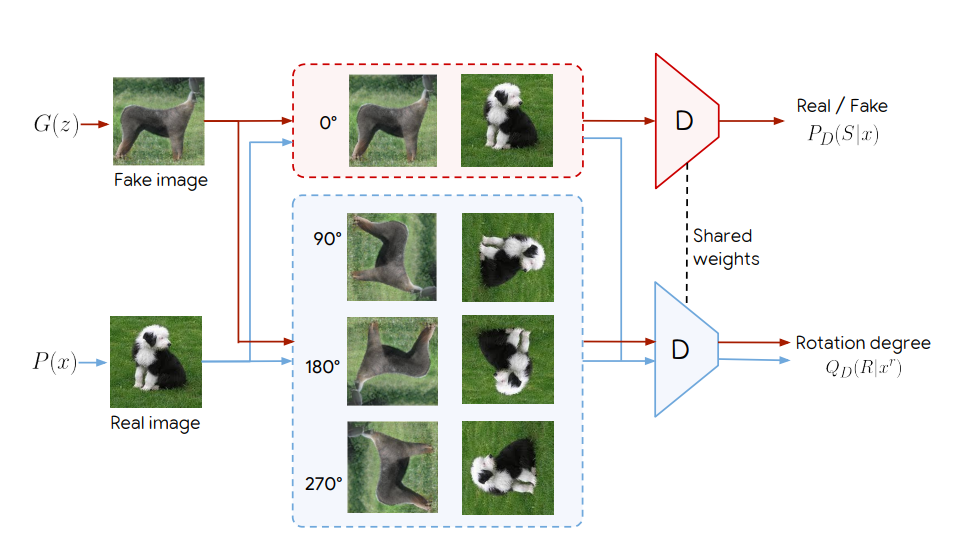

In [ ]:
class RotationArch(nn.Module):
    r"""
    Architecture employing the rotation loss.
    This implementation takes inspiration from the Self-Supervised Domain adaptation
    with Consistency training by Liang Xiao et al.
    This is a self-supervised approach that employs a pretext task of predicting
    rotation angles of the images to learn important features of target domain data
    """

    def __init__(self, num_classes: int = 20, dropout: float = 0.5) -> None:
        super(RotationArch, self).__init__()

        # Take the resNet18 module and discard the last layer
        features = nn.ModuleList(resnet18(pretrained=True).children())[:-1]

        # Use it as a feature extractor
        self.features = nn.Sequential(*features)

        # final fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(512, 20),
        )

        self.rotation_classifier = nn.Sequential(
            nn.Linear(512, 4),
        )

    def forward(
        self,
        x: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        r"""
        Forward method

        Args:
        - x [torch.Tensor]: source sample

        Returns:
        - class_pred [torch.Tensor]: class prediction
        - rotation_pred [torch.Tensor]: rotation prediction
        """

        x = self.features(x)

        # extract the features
        features = x.view(x.size(0), -1)

        # classify both the domain and the class
        class_pred = self.classifier(features)

        # get the rotation prediction
        rotation_pred = self.rotation_classifier(features)

        return class_pred, rotation_pred

## MEDM

The last method we are going to propose is **Entropy Minimization vs. Diversity Maximization**, inspired by the paper of [Xiaofu Wu et al.](https://arxiv.org/abs/2002.01690)

This approach leverages on a entropy minimization approach combined with a diversity maximization (maximize the category diversity), which tries to find a close-to-perfect domain adaptation solution.

The main idea behind the algorithm is that the source domain and target domain are sampled from joint distributions $P(x^s; y^s)$ and $Q(x^t; y^t)$ respectively, however, the identically independently distributed (IID) assumption which is assumed to hold in many machine learning scenario, is often violated as $P \neq Q$. In the case of Adaptiope, we can say the IID assumption doesn't hold, since we are dealing with examples from completely different domains.

MEDM's goal is to minimize the source risk $\epsilon_s$ and the cross domain discrepancy $D(P; Q)$, which constitutes a bound to the target risk where:

$$\epsilon_s(f_\theta) = \mathbb{E}_{(x^s;y^s)~P}[f_\theta(x^s) \neq y^s]$$

$$\epsilon_k(f_\theta) = \mathbb{E}_{(x^t;y^t)~Q}[f_\theta(x^s) \neq y^t]$$

As for the training, three losses need to be minimized:

- the supervised learning loss on the source domain, which is the standard cross-entropy loss:

$$L_s(\theta, D_s) = \frac{1}{|D_s|}\displaystyle\sum_{(x, y) \in D_s} l(y, f_\theta(x))$$

- the entropy minimization loss on the target domain, which is employed to adapt to the unlabeled target domain. 
This step is performed by first obtaining the softmax prediction for all the unlabelled images of the target domain present in the current mini-batch, and then computing the predicted category distribution:
\begin{align}
\hat{q}(T) = \frac{1}{|T|} \displaystyle\sum_{x_t \in T} f_\theta(x_t) \triangleq [\hat{q}_1, \hat{q}_2, \dots, \hat{q}_K]
\end{align} 
finally, the mean entropy loss over $T$ is computed as:
\begin{align}
L_e(\theta, T) = -\frac{1}{|T|}\displaystyle\sum_{x_t \in T} \langle f_\theta(x_t), \log(f_\theta(x_t)) \rangle
\end{align}
where:
  - $T$ is any random minibatch of samples from the target domain
  - $(y, \hat{y}) = \langle y, \hat{y}\rangle = − \displaystyle\sum^K_{j=1}y_j \log \hat{y}_j$
  - $\hat{q}_k = \frac{1}{|T|}\displaystyle\sum_{x_t \in T}P(y_t = k|x_t)$ 

- Category diversity loss over the target domain for avoiding trivial solutions.
The category diversity maximization over $T$ can be measured as:
\begin{align}
L_d(\theta, T), H(\hat{q}(T)) = -\displaystyle\sum_{k=1}^{K} \hat{q}_k \log \hat{q}_k
\end{align}

Therefore, the final objective of the approach is to minimise the following losses:

$$min_\theta E_{S,T} [L_s(\theta, S) + \lambda L_e(θ, T ) − \beta L_d(\theta, T)]$$

> Where the - sign is employed so as to convert the maximization objective into a minimization one.

$E[\cdot]$ denotes the expectation and $\lambda, \beta \geq 0$ are weighting factors.

A visual representation of the architecture is shown in the following figure:

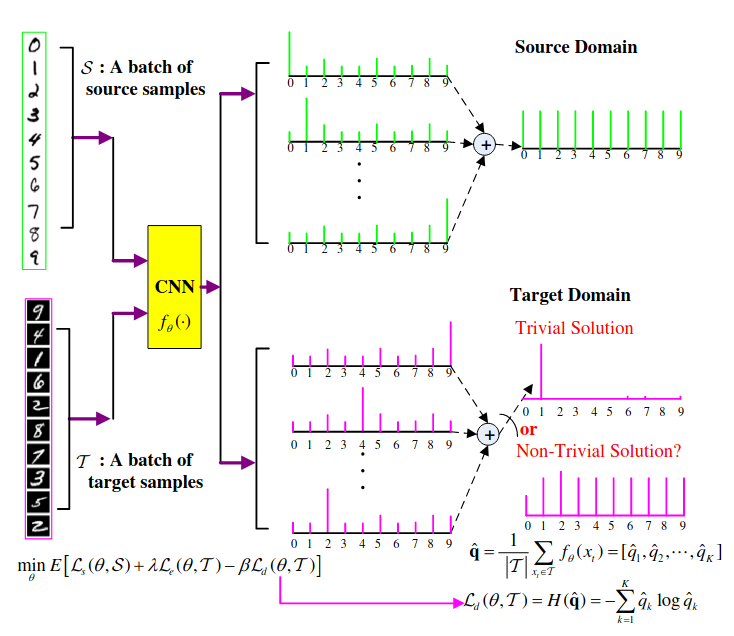

### Original MEDM

Here, we provide the architecture of the approach explained by Wu et al. with a ResNet18 as feature extractor.

In [ ]:
class MEDM(nn.Module):
    r"""
    Original ResNet18 architecture, integrated with MEDM
    """

    def __init__(
        self,
        num_classes: int = 20,
        pretrained: bool = False,
        feature_extractor: bool = False,
    ) -> None:
        r"""
        Initialize the basic ResNet18 architecture

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = False
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: number of classes [used in the last layer]
        - pretrained [bool]: whether to pretrain the model or not
        - feature_extractor [bool]: whether to return the feature extracted from
        the neural network or not in the forward step.
        """
        super(MEDM, self).__init__()

        # Take the resNet18 module and discard the last layer
        features = nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1]

        # set the ResNet18 backbone as feature extractor
        self.features = nn.Sequential(*features)

        # classifier adapted from the original paper's approach
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Softmax(),
        )

        # As usual the mode for returning the features instead of the
        # predictions
        self.feature_extractor = feature_extractor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        r"""
        Forward method

        Args:
        - x [torch.Tensor]: source sample

        Returns:
        - prediction [torch.Tensor]: prediction
        """
        x = self.features(x)
        # if in the feature extractor mode
        if self.feature_extractor:
            # return the features
            return x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### DANNMEDM

In this cell of code, MEDM has been merged with the DANN approach.

In [ ]:
class DANNMEDM(nn.Module):
    r"""
    ResNet18 architecture, integrated with a new method exploiting both DANN
    and MEDM approaches
    """

    def __init__(
        self,
        num_classes: int = 20,
        pretrained: bool = False,
        dropout: float = 0.5,
        feature_extractor: bool = False,
    ) -> None:
        r"""
        Initialize the architecture

        Default:
        - num_classes [int] = 20
        - pretrained [bool] = False
        - feature_extractor [bool] = False

        Args:
        - num_classes [int]: number of classes [used in the last layer]
        - pretrained [bool]: whether to pretrain the model or not
        - feature_extractor [bool]: whether to return the feature extracted from
        the neural network or not in the forward step.
        """
        super(DANNMEDM, self).__init__()

        # Take the resNet18 module and discard the last layer
        features = nn.ModuleList(resnet18(pretrained=pretrained).children())[:-1]

        # set the ResNet18 backbone as feature extractor
        self.features = nn.Sequential(*features)

        # features
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes),
            nn.Softmax(),
        )

        # As adviced by the paper, we follow the previous structure
        # for deep domain confusion, adding an adapt layer before the classifiers
        self.adapt = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
        )

        # Domain classifier similar to the one described in the paper
        self.domain_classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(128, 2),
            nn.Softmax(),
        )

        # in the forward return only the features!
        self.feature_extractor = feature_extractor

    def forward(self, x: torch.Tensor, grl_lambda: float = 1.0) -> torch.Tensor:
        r"""
        Forward method

        Args:
        - x [torch.Tensor]: source sample

        Returns:
        - prediction [torch.Tensor]: prediction
        """
        x = self.features(x)
        # if in the feature extractor mode
        if self.feature_extractor:
            # return the features
            return x
        # extract the features
        features = x.view(x.size(0), -1)
        features = self.adapt(features)

        # gradient reversal
        reverse_features = GradientReversalFn.apply(features, grl_lambda)

        # classify both the domain and the class
        class_pred = self.classifier(features)
        domain_pred = self.domain_classifier(reverse_features)
        return class_pred, domain_pred

# Optimizers

In this section we present the optimizers we have employed to test our domain adaptation technique.

## SDG

As for training AlexNet-based architectures, we have decided to employ stochastic gradient descent based optimizers.

In [ ]:
def get_native_alexnet_optimizer(
    net: nn.Module, lr: np.double, wd: np.double, momentum: np.double
) -> torch.optim.Optimizer:
    r"""
    Stochastic gradient descent optimizer
    It is employed to train the native AlexNet or any other nn.Module
    architecture

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate
    - wd [np.double]: weight decay
    - momentum [np.double]: momentum

    Returns:
    - optimizer [torch.optim.Optimizer]
    """
    return torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)


def get_ddc_alexnet_optimizer(
    net: nn.Module, lr: np.double, wd: np.double, momentum: np.double
) -> torch.optim.Optimizer:
    r"""
    Stochastic gradient descent optimizer
    Optimizer for the DDCAlexNet architecture, with a learning rate multiplied
    by ten for the last two layers, as explained in the Deep Domain Confusion:
    Maximizing for Domain Invariance paper

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate
    - wd [np.double]: weight decay
    - momentum [np.double]: momentum

    Returns:
    - optimizer [torch.optim.Optimizer]
    """
    return torch.optim.SGD(
        [
            {"params": net.features.parameters(), "lr": lr},
            {"params": net.avgpool.parameters(), "lr": lr},
            {"params": net.mid_classifier.parameters(), "lr": lr},
            {"params": net.adapt.parameters(), "lr": lr * 10},
            {"params": net.classifier.parameters(), "lr": lr * 10},
        ],
        lr=lr,
        weight_decay=wd,
        momentum=momentum,
    )


def get_dann_alexnet_optimizer(
    net: nn.Module, lr: np.double, wd: np.double, momentum: np.double
) -> torch.optim.Optimizer:
    r"""
    Stochastic gradient descent optimizer
    It is employed to train the DANNAlexNet as described in
    the Domain-Adversarial Training of Neural Networks paper

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate
    - wd [np.double]: weight decay
    - momentum [np.double]: momentum

    Returns:
    - optimizer nn.Optimizer
    """
    return torch.optim.SGD(
        [
            {"params": net.features.parameters(), "lr": 0.001},
            {"params": net.avgpool.parameters(), "lr": 0.001},
            {"params": net.mid_classifier.parameters(), "lr": 0.001},
            {"params": net.adapt.parameters()},
            {"params": net.classifier.parameters()},
            {"params": net.domain_classifier.parameters()},
        ],
        lr=lr,
        momentum=momentum,
    )

## SDG for ResNet-based architecture

As for training ResNet18-based architectures we have decided to employ a stochastic gradient descent based optimizer, with weight decay and momentum.

Among these optimizers, only the first three have been used:

1. `native_resnet_optimizer`
2. `ddc_resnet_optimizer`
3. `dann_resnet_optimizer`

The others have been replaced by Adam, since it generally provided a more stable training.

In [ ]:
def get_native_resnet_optimizer(
    net: nn.Module, lr: np.double, wd: np.double, momentum: np.double
) -> torch.optim.Optimizer:
    r"""
    Stochastic gradient descent optimizer
    It is employed to train the native Resnet or any other nn.Module
    architecture

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate
    - wd [np.double]: weight decay
    - momentum [np.double]: momentum

    Returns:
    - optimizer [torch.optim.Optimizer]
    """
    return torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=momentum)


def get_ddc_resnet_optimizer(
    net: nn.Module, lr: np.double, wd: np.double, momentum: np.double
) -> torch.optim.Optimizer:
    r"""
    Stochastic gradient descent optimizer
    Optimizer for the DDCResnet architecture, with a learning rate multiplied
    by ten for the last two layers, as explained in the Deep Domain Confusion:
    Maximizing for Domain Invariance paper

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate
    - wd [np.double]: weight decay
    - momentum [np.double]: momentum

    Returns:
    - optimizer [torch.optim.Optimizer]
    """
    return torch.optim.SGD(
        [
            {"params": net.features.parameters(), "lr": lr},
            {"params": net.adapt.parameters(), "lr": lr * 10},
            {"params": net.classifier.parameters(), "lr": lr * 10},
        ],
        lr=lr,
        weight_decay=wd,
        momentum=momentum,
    )


def get_dann_resnet_optimizer(
    net: nn.Module, lr: np.double, wd: np.double, momentum: np.double
) -> torch.optim.Optimizer:
    r"""
    Stochastic gradient descent optimizer
    It is employed to train the DANNResnet as described in
    the Domain-Adversarial Training of Neural Networks paper

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate
    - wd [np.double]: weight decay
    - momentum [np.double]: momentum

    Returns:
    - optimizer nn.Optimizer
    """
    print("RESNET DANN OPTIMIZER")
    return torch.optim.SGD(
        [
            {"params": net.features.parameters(), "lr": 0.001},
            {"params": net.adapt.parameters()},
            {"params": net.classifier.parameters()},
            {"params": net.domain_classifier.parameters()},
        ],
        lr=lr,
        momentum=momentum,
    )


def get_rotation_resnet_optimizer(
    net: nn.Module, lr: np.double, wd: np.double, momentum: np.double
) -> torch.optim.Optimizer:
    r"""
    Stochastic gradient descent optimizer
    It is employed to train the DANNResnet as described in
    the Domain-Adversarial Training of Neural Networks paper

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate
    - wd [np.double]: weight decay
    - momentum [np.double]: momentum

    Returns:
    - optimizer nn.Optimizer
    """
    print("RESNET ROTATION OPTIMIZER")
    return torch.optim.SGD(
        [
            {"params": net.features.parameters(), "lr": 0.001},
            {"params": net.adapt.parameters()},
            {"params": net.classifier.parameters()},
            {"params": net.domain_adversarial_network.parameters()},
            {"params": net.rotation_classifier.parameters()},
        ],
        lr=lr,
        momentum=momentum,
    )


def get_dsn_resnet_optimizer(
    net: nn.Module, lr: np.double, wd: np.double, momentum: np.double
) -> torch.optim.Optimizer:
    r"""
    Stochastic gradient descent optimizer
    It is employed to train the DANNResnet as described in
    the Domain-Adversarial Training of Neural Networks paper

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate
    - wd [np.double]: weight decay
    - momentum [np.double]: momentum

    Returns:
    - optimizer nn.Optimiser
    """
    return torch.optim.SGD(
        [
            {"params": net.shared_encoder.parameters(), "lr": 0.001},
            {"params": net.source_encoder.parameters(), "lr": 0.001},
            {"params": net.target_encoder.parameters(), "lr": 0.001},
            {"params": net.bottle_neck.parameters()},
            {"params": net.classifier.parameters()},
            {"params": net.domain_adversarial_network.parameters()},
        ],
        lr=lr,
        momentum=momentum,
    )

## Adam

The ADAM optimizer has been used for all the other proposed solution, since it provided the best results in terms of accuracy on the target domain.

In [ ]:
def get_adam_optimizer(net: nn.Module, lr: np.double) -> torch.optim.Optimizer:
    r"""
    ADAM optimizer

    Args:
    - net [nn.Module]: network architecture
    - lr [np.double]: learning rate

    Returns:
    - optimizer [nn.Optimizer]
    """
    return torch.optim.Adam(net.parameters(), lr=lr)

## Scheduler

Finetuning the learning rate generally entails making it lower than normal and decaying it in order to keep the weights improving.
Here, we show some schedulers we have employed.

First and foremost, there must be a mechanism to retrieve the learning rate in order to model it. Here we offer a basic approach for gathering the learning rate from the optimizer.

We manually recover the learning rate from the optimizer to effectively update the learning rate according to the procedures in the papers and to save the current training state so that we may resume the calculation later. 

In [ ]:
def get_lr(optimizer: torch.optim.Optimizer) -> float:
    r"""
    Function which returns the learning rate value
    used in the optimizer

    Args:
    - optimizer [torch.optim.Optimizer]: optimizer

    Returns:
    - lr [float]: learning rate
    """
    for param_group in optimizer.param_groups:
        return param_group["lr"]

The following schedulers have been constructed for:
- DANN optimizer
- DSN optimizer

They both use the same schedule, adviced from Ganin et al. in the paper Domain-Adversarial Training of Neural Networks, that is specifically calculated by taking as input `p`, a variable representing the training process that goes from 0 to 1. Moreover, all the non-pretrained layers use a learning rate multiplied by 10, to promote their learning.

In [ ]:
def dann_optimizer_scheduler(
    optimizer: torch.optim.Optimizer, p: np.double
) -> np.double:
    r"""
    Custom scheduler for DANN's optimizer. The update of the learning rate
    follows the formula described in the paper (Domain-Adversarial Training of
    Neural Networks). The learning rate for the feature extraction layers is
    exactly the calculated one, while the learning rate for the adaptation layer
    and the classifiers is multiplied by 10, since they don't start pre-trained.

    Args:
    - optimizer [torch.optim.Optimizer]: optimizer
    - p [np.double]: p parameter

    Return:
    - lr np.double
    """
    lr = 0.01 / (1.0 + 10 * p) ** 0.75
    for param_group in optimizer.param_groups[:3]:
        param_group["lr"] = lr
    for param_group in optimizer.param_groups[3:]:
        param_group["lr"] = lr * 10
    return lr


def dsn_optimizer_scheduler(
    optimizer: torch.optim.Optimizer, p: np.double
) -> np.double:
    r"""
    Custom scheduler for DSN's optimizer. The update of the learning rate
    follows the formula described in the paper Domain-Adversarial Training of
    Neural Networks. The learning rate for the feature extraction layers is
    exactly the calculated one, while the learning rate for the adaptation layer
    and the classifiers is multiplied by 10, since they don't start pre-trained.

    Args:
    - optimizer [torch.optim.Optimizer]: optimizer
    - p [np.double]: p parameter

    Return:
    - lr np.double
    """
    lr = 0.01 / (1.0 + 10 * p) ** 0.75
    for param_group in optimizer.param_groups[:3]:
        param_group["lr"] = lr
    for param_group in optimizer.param_groups[3:]:
        param_group["lr"] = lr * 10
    return lr

# Training and test steps

To train the models presented in the Network Architectures section, we have decided to use common functions which are capable of dealing with all the architectures, making it easy to manage different hyper-parameters and networks.

Tensorboard has been used to log the reconstructed images during the training of the Domain Separation Network architecture. 8 images are logged when the following function is called, that will eventually be available for analysis.

In [ ]:
def log_images(
    writer: torch.utils.tensorboard.SummaryWriter,
    img: torch.Tensor,
    epoch: int,
    title: str,
) -> None:
    r"""
    Log images on the summary writer, this function is usefull during
    debug sessions.

    Args:
    - writer [torch.utils.tensorboard.SummaryWriter]: summary writer
    - img [torch.Tensor]: image to log
    - title [str]: title of the log
    """
    try:
        # Log training images in a row of 8
        logged_img = torchvision.utils.make_grid(
            img.data, nrow=8, normalize=True, scale_each=True
        )
        # add image
        writer.add_image(title, logged_img, epoch)
    except Exception as e:
        print("Couldn't log results: {}".format(e))

## Training step

The training_step is the function which takes care of training the network based on the parameters passed as input.

The networks which are supported by the training_step function are:
- AlexNet
- ResNet18
- Deep Domain Confusion \[MMD\]
- Domain Adversarial Neural Networks \[DANN\]
- Domain Separation Networks \[DSN\]
- Entropy Minimization vs. Diversity Maximization \[MEDM\]
- Domain Separation Networks with Entropy Minimization vs. Diversity Maximization \[DSNMEDM\]


In [ ]:
def training_step(
    net: nn.Module,
    source_training_loader: torch.utils.data.DataLoader,
    target_training_loader: torch.utils.data.DataLoader,
    rotation_training_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    cost_function: nn.CrossEntropyLoss,
    cost_function_domain: nn.CrossEntropyLoss,
    epoch: int,
    total_epochs: int,
    writer: torch.utils.tensorboard.SummaryWriter,
    current_step: int,
    active_domain_loss_step: int,
    loss_diff: DiffLoss,
    loss_recon1: SIMSE,
    loss_recon2: SIMSE,
    gamma_weight: float,
    beta_weight: float,
    alpha_weight: float,
    learning_rate: float,
    lr_decay_step: int,
    step_decay_weight: float,
    title: str,
    technique: Technique,
    device: str = "cuda",
) -> Tuple[float, float]:
    r"""
    Function which performs one training step, it is able to adapt to
    different architectures according to the technique passed.
    Namely:
    - Source-Only (baseline): learns only from the source domain
    - Upper-Bound: learns both from the source and the target domain
    - Deep Domain Confusion: https://arxiv.org/pdf/1412.3474.pdf
    - Domain-Adversarial Neural Network: https://arxiv.org/pdf/1505.07818.pdf
    - Domain Separation Networks: https://arxiv.org/pdf/1608.06019.pdf
    - Entropy Minimization vs. Diversity Maximization for Domain Adaptation: https://arxiv.org/pdf/2002.01690.pdf
    - Domain Separation Networks with Entropy Minimization vs. Diversity Maximization

    Args:
    - net [nn.Module]: network architecture
    - source_training_loader [torch.utils.data.DataLoader]: source training data loader
    - target_training_loader torch.utils.data.DataLoader]: target training data loader
    - optimizer [torch.optim.Optimizer]: optimizer
    - scheduler [torch.optim.lr_scheduler.ReduceLROnPlateau]: scheduler
    - cost_function [nn.CrossEntropyLoss]: cost function
    - cost_function_domain [nn.CrossEntropyLoss]: cost function for the domain classifier
    in the case of the Domain-Adversarial Neural NetworkNetwork
    - epoch [int]: current epoch
    - total_epochs [int]: total number of epoch
    - writer [torch.utils.tensorboard.SummaryWriter]: summary writer
    - current_step [int]: current step (total number of batches analyzed), for DSN
    - active_domain_loss_step [int]: amount of steps after which to employ the domain adaptation method, for DSN
    - loss_diff [DiffLoss]: difference loss for the DSN architecture
    - loss_recon1 [SIMSE]: first reconstruction loss for DSN
    - loss_recon2 [SIMSE]: second reconstruction loss for DSN
    - gamma_weight [float]: gamma parameter in the DSN loss function
    - beta_weight [float]: beta parameter in the DSN loss function
    - alpha_weight [float]: alpha parameter in the DSN loss function
    - learning_rate [float]: learning rate
    - lr_decay_step [int]: learning rate decay step for the scheduler of the DSN
    - step_decay_weight [float]: learning rate weight decay step for the scheduler of the DSN
    - title [str]: title for the tqdm loop
    - technique [Technique]: which training technique to employ, of course the neural
    network needs to be adapted according to the chosen technique
    - device [str] = "cuda": device on which to perform the training

    Returns:
    - batch loss, batch accuracy [Tuple[float, float]]
    """
    samples = 0.0
    samples_domain_class = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0
    cumulative_accuracy_domain_class = 0.0

    # set the network to training mode
    net.train()

    # training target iterator
    target_iter = iter(target_training_loader)

    # Iterator for the rotation dataloader
    rotation_training_iter = iter(rotation_training_loader)

    # iterate over the training set
    for batch_idx, (inputs, label) in tqdm.tqdm(
        enumerate(source_training_loader), desc=title
    ):

        # Load target data
        try:
            target_data, _ = next(target_iter)
        except:
            target_iter = iter(target_training_loader)
            target_data, _ = next(target_iter)

        # Load rotation data
        if technique == Technique.ROTATION:
            try:
                target_data, _, rotation_label = next(rotation_training_iter)
            except:
                rotation_training_iter = iter(rotation_training_loader)
                target_data, _, rotation_label = next(rotation_training_iter)

        # load data into device
        inputs = inputs.to(device)
        label = label.to(device)
        if technique == Technique.ROTATION:
            rotation_label = rotation_label.to(device)
        target_data = target_data.to(device)

        # Training progress and GRL lambda computation
        p = (
            float(batch_idx + epoch * len(source_training_loader))
            / total_epochs
            / len(source_training_loader)
        )
        lambda_parameter = 2.0 / (1.0 + np.exp(-10 * p)) - 1

        if technique == Technique.DANN:
            # Set the learning rate according to the DANN paper
            dann_optimizer_scheduler(optimizer, p)

        # gradients reset
        optimizer.zero_grad()

        # forward pass [it changes according to the technique we are employing]
        if technique == Technique.DDC:
            outputs, mmd_loss = net(inputs, target_data)
        elif technique == Technique.DANN:
            # Get classifier outputs and domain classifier
            outputs, domain_prediction_source = net(inputs, lambda_parameter)
            # Get the domain prediction target
            _, domain_prediction_target = net(target_data, lambda_parameter)
        elif technique == Technique.DSN:
            # set lambda only in dann mode
            lambda_dsn = (
                lambda_parameter if current_step > active_domain_loss_step else 0
            )

            # source prediction
            (
                outputs,
                source_domain_pred,
                source_private_code,
                source_shared_code,
                source_rec_code,
            ) = net(
                inputs,
                rec_code=ReconstructionCode.SOURCE,
                rec_scheme=ReconstructionSheme.BOTH_SHARED_AND_PRIVATE,
                grl_lambda=lambda_dsn,
            )

            # target prediction
            (
                _,
                target_domain_pred,
                target_private_code,
                target_shared_code,
                target_rec_code,
            ) = net(
                target_data,
                rec_code=ReconstructionCode.TARGET,
                rec_scheme=ReconstructionSheme.BOTH_SHARED_AND_PRIVATE,
                grl_lambda=lambda_dsn,
            )
        elif technique == Technique.ROTATION:
            # Source domain prediction
            outputs, _ = net(inputs)

            # Target domain prediction
            _, target_rotation_pred = net(target_data)
        elif technique == Technique.MEDM:
            # Source domain prediction
            outputs = net(inputs)

            # Target domain prediction
            clabel_tgt = net(target_data)
        elif technique == Technique.DSN_MEDM:
            lambda_dsn = (
                lambda_parameter if current_step > active_domain_loss_step else 0
            )

            # Source domain prediction
            outputs, source_private_code, source_shared_code, source_rec_code = net(
                inputs,
                rec_code=ReconstructionCode.SOURCE,
                rec_scheme=ReconstructionSheme.BOTH_SHARED_AND_PRIVATE,
            )

            # Target domain prediction
            clabel_tgt, target_private_code, target_shared_code, target_rec_code = net(
                target_data,
                rec_code=ReconstructionCode.TARGET,
                rec_scheme=ReconstructionSheme.BOTH_SHARED_AND_PRIVATE,
            )
        elif technique == Technique.DANN_MEDM:
            # source prediction
            outputs, domain_prediction_source = net(inputs, lambda_parameter)
            # Get the domain prediction target
            clabel_tgt, domain_prediction_target = net(target_data, lambda_parameter)
        else:
            # general output
            outputs = net(inputs)

        # general prediction loss computation
        loss = cost_function(outputs, label)

        # Additive losses, according to the different techniques
        if technique == Technique.DDC:
            # 0.25 comes from a lambda factor in the Deep Domain Confusion:
            # Maximizing for Domain Invariance paper, and it has been
            # proven to provide good results
            loss += 0.25 * mmd_loss
        elif technique == Technique.DSN:
            # The network performs better if we start immediately using the DANN loss
            # so we don't wait for the current_step to reach active_domain_loss_step
            # if current_step > active_domain_loss_step:
            if True:
                source_domain_label = torch.zeros(len(inputs), dtype=torch.long).to(
                    device
                )
                target_domain_label = torch.ones(len(inputs), dtype=torch.long).to(
                    device
                )

                source_dann = gamma_weight * cost_function_domain(
                    source_domain_pred, source_domain_label
                )
                loss += source_dann

                target_dann = gamma_weight * cost_function_domain(
                    target_domain_pred, target_domain_label
                )
                loss += target_dann
            else:
                # only for the print
                source_dann = torch.zeros(1).float().cpu()
                target_dann = torch.zeros(1).float().cpu()

            # loss on the source
            input_img = inputs.clone().detach()
            source_diff = beta_weight * loss_diff(
                source_private_code, source_shared_code
            )
            source_simse = alpha_weight * loss_recon2(source_rec_code, input_img)
            loss += source_diff + source_simse

            # loss on target
            target_diff = beta_weight * loss_diff(
                target_private_code, target_shared_code
            )
            target_simse = alpha_weight * loss_recon2(target_rec_code, target_data)
            loss += target_diff + target_simse

        elif technique == Technique.DANN:
            # Define the correct labels for the source domain: 0
            zeros = torch.zeros(len(inputs), dtype=torch.long)
            zeros = zeros.to(device)

            # Define the correct labels for the target domain: 1
            ones = torch.ones(len(inputs), dtype=torch.long)
            ones = ones.to(device)

            # Calculate the loss for the source domain predictions
            pred_source_loss = cost_function_domain(domain_prediction_source, zeros)

            # Calculate the loss for the target domain predictions
            pred_target_loss = cost_function_domain(domain_prediction_target, ones)

            # Calculate the total loss for the domain classifier
            loss_domain = pred_source_loss + pred_target_loss

            # Add the calculated loss to the final result
            loss += loss_domain

        elif technique == Technique.ROTATION:
            # Calculate the loss for the rotation classification task (only on target)
            rotation_loss = cost_function(target_rotation_pred, rotation_label)
            loss += 0.4 * rotation_loss

        elif technique == Technique.MEDM:
            loss = F.nll_loss(outputs.log(), label)

            ## Target category diversity loss
            pb_pred_tgt = clabel_tgt.sum(dim=0)
            pb_pred_tgt = (
                1.0 / pb_pred_tgt.sum() * pb_pred_tgt
            )  # normalizatoin to a prob. dist.
            target_div_loss = -torch.sum((pb_pred_tgt * torch.log(pb_pred_tgt + 1e-6)))

            target_entropy_loss = -torch.mean(
                (clabel_tgt * torch.log(clabel_tgt + 1e-6)).sum(dim=1)
            )
            total_loss = loss + 1.0 * target_entropy_loss - 0.4 * target_div_loss

            ##1: Training shared network and label classifier
            print(
                "Train Epoch: {} \tentropy_Loss: {:.6f}\tlabel_Loss: {:.6f}\tdiv_Loss: {:.6f}".format(
                    epoch,
                    target_entropy_loss.item(),
                    loss.item(),
                    target_div_loss.item(),
                )
            )

            loss = total_loss
        elif technique == Technique.DSN_MEDM:
            loss = F.nll_loss(outputs.log(), label)

            ## Target category diversity loss
            pb_pred_tgt = clabel_tgt.sum(dim=0)
            pb_pred_tgt = (
                1.0 / pb_pred_tgt.sum() * pb_pred_tgt
            )  # normalizatoin to a prob. dist.
            target_div_loss = -torch.sum((pb_pred_tgt * torch.log(pb_pred_tgt + 1e-6)))

            target_entropy_loss = -torch.mean(
                (clabel_tgt * torch.log(clabel_tgt + 1e-6)).sum(dim=1)
            )
            total_loss = loss + 1.0 * target_entropy_loss - 0.4 * target_div_loss

            # loss on the source
            input_img = inputs.clone().detach()
            source_diff = beta_weight * loss_diff(
                source_private_code, source_shared_code
            )
            source_simse = alpha_weight * loss_recon2(source_rec_code, input_img)
            total_loss += source_diff + source_simse

            # loss on target
            target_diff = beta_weight * loss_diff(
                target_private_code, target_shared_code
            )
            target_simse = alpha_weight * loss_recon2(target_rec_code, target_data)
            total_loss += target_diff + target_simse

            ##1: Training shared network and label classifier
            print(
                "Train Epoch: {} \tentropy_Loss: {:.6f}\tlabel_Loss: {:.6f}\tdiv_Loss: {:.6f}".format(
                    epoch,
                    target_entropy_loss.item(),
                    loss.item(),
                    target_div_loss.item(),
                )
            )

            loss = total_loss
        elif technique == Technique.DANN_MEDM:

            # Define the correct labels for the source domain: 0
            zeros = torch.zeros(len(inputs), dtype=torch.long)
            zeros = zeros.to(device)

            # Define the correct labels for the target domain: 1
            ones = torch.ones(len(inputs), dtype=torch.long)
            ones = ones.to(device)

            # Calculate the loss for the source domain predictions
            pred_source_loss = F.nll_loss(domain_prediction_source.log(), zeros)

            # Calculate the loss for the target domain predictions
            pred_target_loss = F.nll_loss(domain_prediction_target.log(), ones)

            # Calculate the total loss for the domain classifier
            loss_domain = pred_source_loss + pred_target_loss

            # MEDM
            loss = F.nll_loss(outputs.log(), label)

            ## Target category diversity loss
            # Get the sum of all probabilities in a batch, grouped by class, e.g.
            # - predictions returned by the net: [[0.6, 0.4], [0.2, 0.8]]
            # - result: [0.8, 1.2]
            pb_pred_tgt = clabel_tgt.sum(dim=0)
            # Normalize to a probability distribution, e.g.
            # - from the previous example:
            #   - sum: 2
            #   - result: [0.4, 0.6]
            pb_pred_tgt = 1.0 / pb_pred_tgt.sum() * pb_pred_tgt
            # Calculate the entropy of pb_pred_tgt
            target_div_loss = -torch.sum((pb_pred_tgt * torch.log(pb_pred_tgt + 1e-6)))

            ## Target classification entropy loss
            target_entropy_loss = -torch.mean(
                (clabel_tgt * torch.log(clabel_tgt + 1e-6)).sum(dim=1)
            )

            # Calculate the final loss, as L_source_classification + lambda*L_entropy_classification - beta*L_entropy_category_diversity
            total_loss = (
                loss + 1.0 * target_entropy_loss + loss_domain - 0.4 * target_div_loss
            )

            ##1: Training shared network and label classifier
            print(
                "Train Epoch: {} \tentropy_Loss: {:.6f}\tlabel_Loss: {:.6f}\tdiffloss: {:.6f}\tdann: {:.6f}".format(
                    epoch,
                    target_entropy_loss.item(),
                    loss.item(),
                    target_div_loss.item(),
                    loss_domain.item(),
                )
            )

        # backward pass
        loss.backward()

        # optimizer
        optimizer.step()

        # add current step
        current_step += 1

        # fetch prediction and loss value
        samples += inputs.shape[0]
        cumulative_loss += loss.item()
        _, predicted = outputs.max(dim=1)

        # compute training accuracy
        cumulative_accuracy += predicted.eq(label).sum().item()

    return cumulative_loss / samples, cumulative_accuracy / samples * 100

## Test step

The test_step is the function which takes care of testing the network based on the parameters passed as input, both on the validation set and on the test set.

The networks which are supported by the test_step function are:
- AlexNet
- ResNet18
- Deep Domain Confusion \[MMD\]
- Domain Adversarial Neural Networks \[DANN\]
- Domain Separation Networks \[DSN\]
- Entropy Minimization vs. Diversity Maximization \[MEDM\]
- Domain Separation Networks with Entropy Minimization vs. Diversity Maximization \[DSNMEDM\]

In [ ]:
def tr_image(img):
    r"""
    Function which computes the average of the image, to better visualize it
    in Tensor board

    Args:
    - img [torch.Tensor]: image

    Returns:
    - image after the processing [torch.Tensor]
    """
    return (img + 1) / 2


def test_step(
    net: nn.Module,
    source_validation_loader: torch.utils.data.DataLoader,
    cost_function: nn.CrossEntropyLoss,
    epoch: int,
    writer: torch.utils.tensorboard.SummaryWriter,
    title: str,
    technique: Technique,
    rec_code: ReconstructionCode,
    device="cuda",
) -> Tuple[float, float]:
    r"""
    Function which performs one test step, it is able to adapt to
    different architectures according to the `technique` passed.
    Namely:
    - Source-Only (baseline): learns only from the source domain
    - Upper-Bound: learns both from the source and the target domain
    - Deep Domain Confusion: https://arxiv.org/pdf/1412.3474.pdf
    - Domain-Adversarial Neural Network: https://arxiv.org/pdf/1505.07818.pdf
    - Domain Separation Networks: https://arxiv.org/pdf/1608.06019.pdf
    - Entropy Minimization vs. Diversity Maximization for Domain Adaptation: https://arxiv.org/pdf/2002.01690.pdf
    - Domain Separation Networks with Entropy Minimization vs. Diversity Maximization

    Args:
    - net [nn.Module]: network architecture
    - source_validation_loader [torch.utils.data.DataLoader]: source validation data loader
    - cost_function [nn.CrossEntropyLoss]: cost function
    - epoch [int]: current epoch
    - writer [torch.utils.tensorboard.SummaryWriter]: summary writer
    - title [str]: title for the `tqdm` loop
    - technique [Technique]: which training technique to employ, of course the neural
    network needs to be adapted according to the chosen technique
    - device [str] = "cuda": device on which to perform the training

    Returns:
    - batch loss, batch accuracy [Tuple[float, float]]
    """
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    # set the network to evaluation mode
    net.eval()

    # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
    with torch.no_grad():

        # iterate over the test set
        for batch_idx, (inputs, targets) in tqdm.tqdm(
            enumerate(source_validation_loader), desc=title
        ):

            # load data into device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            if technique == Technique.DDC:
                outputs, mmd_loss = net(inputs, targets)
            elif technique == Technique.DANN:
                outputs, _ = net(inputs)
            elif technique == Technique.DSN:
                # class prediction
                outputs, _, _, _, reconstructed_code = net(inputs, rec_code=rec_code)

                # image reconstructions
                rec_img_share = tr_image(reconstructed_code.data)
                _, _, _, _, reconstructed_code = net(
                    inputs,
                    rec_code=rec_code,
                    rec_scheme=ReconstructionSheme.BOTH_SHARED_AND_PRIVATE,
                )
                rec_img_all = tr_image(reconstructed_code.data)
                _, _, _, _, reconstructed_code = net(
                    inputs,
                    rec_code=rec_code,
                    rec_scheme=ReconstructionSheme.ONLY_PRIVATE_CODE,
                )
                rec_img_private = tr_image(reconstructed_code.data)

                # log images
                # log_images(writer, rec_img_share, epoch, 'DSN share images')
                # log_images(writer, rec_img_all, epoch, 'DSN all images')
                # log_images(writer, rec_img_private, epoch, 'DSN private images')
                # log_images(writer, tr_image(inputs), epoch, 'Original')
            elif technique == Technique.ROTATION or technique == Technique.DANN_MEDM:
                # outputs, _, _ = net(inputs)
                outputs, _ = net(inputs)
            elif technique == Technique.DSN_MEDM:
                # class prediction
                outputs, _, _, reconstructed_code = net(inputs, rec_code=rec_code)

                # image reconstructions
                rec_img_share = tr_image(reconstructed_code.data)
                _, _, _, reconstructed_code = net(
                    inputs,
                    rec_code=rec_code,
                    rec_scheme=ReconstructionSheme.BOTH_SHARED_AND_PRIVATE,
                )
                rec_img_all = tr_image(reconstructed_code.data)
                _, _, _, reconstructed_code = net(
                    inputs,
                    rec_code=rec_code,
                    rec_scheme=ReconstructionSheme.ONLY_PRIVATE_CODE,
                )
                rec_img_private = tr_image(reconstructed_code.data)
            else:
                outputs = net(inputs)

            # loss computation
            loss = cost_function(outputs, targets)
            if technique == Technique.DDC:
                loss += 0.25 * mmd_loss
            elif technique == Technique.MEDM or technique == Technique.DANN_MEDM:
                loss = F.nll_loss(outputs.log(), targets, size_average=False)

            # fetch prediction and loss value
            samples += inputs.shape[0]
            cumulative_loss += (
                loss.item()
            )  # Note: the .item() is needed to extract scalars from tensors
            _, predicted = outputs.max(1)

            # compute accuracy
            cumulative_accuracy += predicted.eq(targets).sum().item()

    return cumulative_loss / samples, cumulative_accuracy / samples * 100

## Main

Main function of the project, it comprises both the training and the test step.

Moreover, it can resume the computation of one neural network by restoring the parameters of the last network training, such as epoch number, network weights and optimizer parameters.

To understand which network is being chosen and therefore, which optimizers,  schedulers and loss function to load, the Enum called `Technique` is employed.

In [ ]:
# tensorboard logging utilities
def log_values(
    writer: torch.utils.tensorboard.SummaryWriter,
    step: int,
    loss: float,
    accuracy: float,
    prefix: str,
) -> None:
    r"""
    Function which writes the loss and the accuracy of a model by the means of
    a SummaryWriter

    Args:
    - writer [torch.utils.tensorboard.SummaryWriter]: summary writer
    - step [int]: current step
    - loss [float]: current loss
    - accuracy [float]: accuracy
    - prefix [str]: log prefix
    """
    writer.add_scalar(f"{prefix}/loss", loss, step)
    writer.add_scalar(f"{prefix}/accuracy", accuracy, step)


def unsupervised_domain_adaptation_main(
    net: nn.Module,
    exp_name: str,
    technique: Technique,
    net_name: str = "alexnet",
    resume: bool = False,
    device: str = "cuda",
    batch_size: int = 128,
    test_batch_size: int = 256,
    learning_rate: float = 0.01,
    weight_decay: float = 0.000001,
    momentum: float = 0.9,
    step_decay_weight: float = 0.95,
    active_domain_loss_step: int = 10000,
    lr_decay_step: int = 20000,
    alpha_weight: float = 0.01,
    beta_weight: float = 0.075,
    gamma_weight: float = 0.25,
    epochs: int = 10,
    save_every_epochs: int = 10,
    reverse_domains: bool = False,
    dry: bool = False,
    additional_transformations: List[nn.Module] = [],
) -> None:
    r"""
    Function which performs both training and test step, it is able to adapt to
    different architectures according to the `technique` passed.

    Namely:
    - Source-Only (baseline): learns only from the source domain
    - Upper-Bound: learns both from the source and the target domain
    - Deep Domain Confusion: https://arxiv.org/pdf/1412.3474.pdf
    - Domain-Adversarial Neural Network: https://arxiv.org/pdf/1505.07818.pdf
    - Domain Separation Networks: https://arxiv.org/pdf/1608.06019.pdf
    - Entropy Minimization vs. Diversity Maximization for Domain Adaptation: https://arxiv.org/pdf/2002.01690.pdf
    - Domain Separation Networks with Entropy Minimization vs. Diversity Maximization

    Defaults:
    - resume [bool] = False: by default do not resume last training
    - device [str] = "cuda": move tensors on GPU
    - batch_size [int] = 128
    - test_batch_size [int] = 256
    - learning_rate [float] = 0.01
    - weight_decay [float] = 0.000001
    - momentum [float] = 0.9
    - epochs [int] = 10
    - step_decay_weight [float] = 0.95,
    - active_domain_loss_step [int] = 10000,
    - lr_decay_step [int] = 20000,
    - alpha_weight [float] = 0.01,
    - beta_weight [float] = 0.075,
    - gamma_weight [float] = 0.25,
    - save_every_epochs [int] = 10: save a checkpoint every 10 epoch
    - reverse_domains [bool] = False: by default the domain are in the order specified
    - dry [bool] = False: by default save weights
    - additional_transformations [List[nn.Module]] = []

    Args:
    - net [nn.Module]: network architecture
    - exp_name [str]: name of the experiment, basically where to save the logs of the
    SummaryWriter
    - technique [Technique]: technique to employ
    - resume [bool] = False: whether to resume a checkpoint
    - device [str] = "cuda": where to load the tensors
    - batch_size [int] = 128: default batch size
    - test_batch_size [int] = 256: default test batch size
    - learning_rate [float] = 0.01: initial learning rate
    - weight_decay [float] = 0.000001 : initial weight decay
    - momentum [float] = 0.9: initial momentum
    - step_decay_weight [float] = 0.95: learning rate weight decay step for DSN
    - active_domain_loss_step [int] = 10000: how many steps to wait for applying the Domain Adaptation technique
    - lr_decay_step [int] = 20000: learning rate weight decay step
    - alpha_weight [float] = 0.01: alpha parameter for the DSN loss function
    - beta_weight [float] = 0.075: beta parameter for the DSN loss function
    - gamma_weight [float] = 0.25: gamma parameter for the DSN loss function
    - epochs [int] = 10: number of epochs
    - save_every_epochs: int = 10: save a checkpoint every `save_every_epochs` epoch
    - dry [bool] = False: whether to do not save weights
    - reverse_domains [bool] = False: whether to swap or not the domains (source and target)
    - additional_transformations [List[nn.Module]] = []: additional transformation for the source domain dataloader
    """
    # create a logger for the experiment
    log_directory = "runs/exp_{}".format(exp_name)
    if technique == Technique.DDC:
        log_directory = "runs/deep_domain_confusion_{}".format(exp_name)
    elif technique == Technique.DANN:
        log_directory = "runs/dann_{}".format(exp_name)
    elif technique == Technique.DSN:
        log_directory = "runs/dsn_{}".format(exp_name)
    elif technique == Technique.ROTATION:
        log_directory = "runs/rotation_{}".format(exp_name)

    # create a logger for the experiment
    writer = SummaryWriter(log_dir="runs/deep_domain_confusion_{}".format(exp_name))

    # create folder for the experiment
    os.makedirs(exp_name, exist_ok=True)

    # Set up the metrics
    metrics = {
        "loss": {"train": 0, "val": 0, "test": 0},
        "acc": {"train": 0, "val": 0, "test": 0},
    }

    # get dataloaders
    source_data = (
        "/home/lucademenego/Documenti/DEEPLEARNING/datasets/adaptiope_small/product_images"
        if START_LOCALLY
        else "adaptiope_small/product_images"
    )  # source
    target_data = (
        "/home/lucademenego/Documenti/DEEPLEARNING/datasets/adaptiope_small/real_life"
        if START_LOCALLY
        else "adaptiope_small/real_life"
    )  # target

    # reverse domains
    if reverse_domains:
        source_data, target_data = target_data, source_data

    dataloaders = load_dataloaders(
        (224, 224),  # img_size
        source_data,
        target_data,
        batch_size=batch_size,  # default batch size
        test_batch_size=test_batch_size,  # default test batch size
        additional_transformations=additional_transformations,  # additional transoformations
    )

    if technique == Technique.UPPER_BOUND:
        # train supervisely on both datasets
        train_loader = dataloaders["train_source_target"]
    else:
        train_loader = dataloaders["train_source"]

    if technique == Technique.ROTATION:
        rotation_training_loader = dataloaders["train_rotated_target"]
    else:
        rotation_training_loader = []

    val_loader = dataloaders["val_source"]
    training_target = dataloaders["train_target"]
    test_target = dataloaders["test_target"]

    print("Technique {}".format(technique))

    optimizer = get_adam_optimizer(net, learning_rate)

    # instantiate the optimizer
    if technique == Technique.DDC:
        if net_name == "alexnet":
            optimizer = get_ddc_alexnet_optimizer(
                net, learning_rate, weight_decay, momentum
            )
        elif net_name == "resnet":
            optimizer = get_ddc_resnet_optimizer(
                net, learning_rate, weight_decay, momentum
            )
    elif technique == Technique.DANN:
        if net_name == "alexnet":
            optimizer = get_dann_alexnet_optimizer(
                net, learning_rate, weight_decay, momentum
            )
        elif net_name == "resnet":
            optimizer = get_dann_resnet_optimizer(
                net, learning_rate, weight_decay, momentum
            )
    elif technique == Technique.DSN:
        optimizer = get_adam_optimizer(net, learning_rate)
    elif technique == Technique.ROTATION:
        optimizer = get_adam_optimizer(net, learning_rate)
    elif technique == Technique.MEDM:
        optimizer = torch.optim.Adam(
            [
                {"params": net.features.parameters(), "lr": learning_rate / 100},
                {"params": net.classifier.parameters(), "lr": learning_rate},
            ],
            lr=learning_rate,
            weight_decay=weight_decay,
        )
    elif technique == Technique.DSN_MEDM:
        optimizer = torch.optim.Adam(
            [
                {"params": net.source_encoder.parameters(), "lr": learning_rate / 50},
                {"params": net.target_encoder.parameters(), "lr": learning_rate / 50},
                {"params": net.shared_encoder.parameters(), "lr": learning_rate / 50},
                {"params": net.classifier.parameters(), "lr": learning_rate},
                {"params": net.merge_features.parameters(), "lr": learning_rate},
                {"params": net.bottle_neck.parameters(), "lr": learning_rate},
            ],
            lr=learning_rate,
            weight_decay=weight_decay,
        )
    elif technique == Technique.DANN_MEDM:
        optimizer = torch.optim.Adam(
            [
                {"params": net.features.parameters(), "lr": learning_rate / 100},
                {"params": net.classifier.parameters(), "lr": learning_rate},
                {"params": net.adapt.parameters(), "lr": learning_rate},
                {"params": net.domain_classifier.parameters(), "lr": learning_rate},
            ],
            lr=learning_rate,
            weight_decay=weight_decay,
        )
    else:
        if net_name == "alexnet":
            optimizer = get_native_alexnet_optimizer(
                net, learning_rate, weight_decay, momentum
            )
        elif net_name == "resnet":
            optimizer = get_native_resnet_optimizer(
                net, learning_rate, weight_decay, momentum
            )

    # define the cost function
    cost_function = torch.nn.CrossEntropyLoss()

    # define the domain cost function, useful only if we use DANN
    cost_function_domain = torch.nn.CrossEntropyLoss()

    # define the cost functions for the reconstruction, difference and similarity
    loss_recon1 = SIMSE()
    loss_recon2 = SIMSE()
    loss_diff = DiffLoss()

    # Resume training or start a new experiment
    training_params, val_params, start_epoch = resume_training(
        resume, exp_name, net, optimizer
    )

    current_step = 0

    # log on wandb if and only if the module is loaded
    if "wandb" in sys.modules:
        wandb.watch(net)

    # for each epoch, train the network and then compute evaluation results
    for e in tqdm.tqdm(range(start_epoch, epochs), desc="Epochs"):
        # training step [supervisely on source, unsupervisely on target {if upperbound, it
        # will train supervisely on both source and target }]
        train_loss, train_accuracy = training_step(
            net,
            iter(train_loader),
            training_target,
            rotation_training_loader,
            optimizer,
            cost_function,
            cost_function_domain,
            e,
            epochs,
            writer,
            title="Training",
            technique=technique,
            device=device,
            current_step=current_step,
            active_domain_loss_step=active_domain_loss_step,
            loss_diff=loss_diff,
            loss_recon1=loss_recon1,
            loss_recon2=loss_recon2,
            gamma_weight=gamma_weight,
            beta_weight=beta_weight,
            alpha_weight=alpha_weight,
            learning_rate=learning_rate,
            lr_decay_step=lr_decay_step,
            step_decay_weight=step_decay_weight,
        )
        # update the current step
        current_step += len(iter(train_loader))
        # save the values in the metrics
        metrics["loss"]["train"] = train_loss
        metrics["acc"]["train"] = train_accuracy

        # test step on the test [target]
        # **Note** it is used ONLY for logging purposes during the debugging phase
        # in order to see whether the performances improve over the target domain
        test_loss, test_accuracy = test_step(
            net,
            iter(test_target),
            cost_function,
            epochs,
            writer,
            "Test",
            technique=technique,
            device=device,
            rec_code=ReconstructionCode.TARGET,
        )
        # save the metrics
        metrics["loss"]["test"] = test_loss
        metrics["acc"]["test"] = test_accuracy

        # save model and checkpoint
        training_params["start_epoch"] = e + 1  # epoch where to start
        training_params["technique"] = technique  # technique used

        # check if I have outperformed the best loss in the validation set
        # Here for the scope of the project I save the best according to the test
        if val_params["best_loss"] > metrics["loss"]["test"]:
            val_params["best_loss"] = metrics["loss"]["test"]
            # save best weights
            if not dry:
                torch.save(net.state_dict(), os.path.join(exp_name, "best.pth"))
        # what to save
        save_dict = {
            "state_dict": net.state_dict(),
            "optimizer": optimizer.state_dict(),
            "training_params": training_params,
            "val_params": val_params,
        }
        # save current weights
        if not dry:
            torch.save(net.state_dict(), os.path.join(exp_name, "net.pth"))
            # save current settings
            torch.save(save_dict, os.path.join(exp_name, "ckpt.pth"))
            if e % save_every_epochs == 0:
                # Dump every checkpoint
                torch.save(
                    save_dict,
                    os.path.join(exp_name, "ckpt_e{}.pth".format(e + 1)),
                )
        del save_dict

        # logs to TensorBoard
        log_values(writer, e, train_loss, train_accuracy, "Train")
        log_values(writer, e, test_loss, test_accuracy, "Test")
        writer.add_scalar("Learning rate", get_lr(optimizer), e)

        # log on wandb if and only if the module is loaded
        if "wandb" in sys.modules:
            wandb.log(
                {
                    "train/train_loss": train_loss,
                    "train/train_accuracy": train_accuracy,
                    "test/test_loss": test_loss,
                    "test/test_accuracy": test_accuracy,
                    "learning_rate": get_lr(optimizer),
                }
            )

        # test value

        print("\nEpoch: {:d}".format(e + 1))
        print(
            "\t Training loss {:.5f}, Training accuracy {:.2f}".format(
                train_loss, train_accuracy
            )
        )
        print(
            "\t Test loss {:.5f}, Test accuracy {:.2f}".format(test_loss, test_accuracy)
        )
        print("-----------------------------------------------------")

    # compute final evaluation results
    print("#> After training:")
    train_loss, train_accuracy = test_step(
        net,
        iter(train_loader),
        cost_function,
        epochs,
        writer,
        "Training",
        technique=technique,
        device=device,
        rec_code=ReconstructionCode.SOURCE,
    )
    val_loss, val_accuracy = test_step(
        net,
        iter(val_loader),
        cost_function,
        epochs,
        writer,
        "Validation",
        technique=technique,
        device=device,
        rec_code=ReconstructionCode.SOURCE,
    )
    test_loss, test_accuracy = test_step(
        net,
        iter(test_target),
        cost_function,
        epochs,
        writer,
        "Test",
        technique=technique,
        device=device,
        rec_code=ReconstructionCode.TARGET,
    )

    # log to TensorBoard
    log_values(writer, epochs, train_loss, train_accuracy, "Train")
    log_values(writer, epochs, val_loss, val_accuracy, "Validation")
    log_values(writer, epochs, test_loss, test_accuracy, "Test")

    # log on wandb if and only if the module is loaded
    if "wandb" not in sys.modules:
        wandb.log(
            {
                "train/train_loss": train_loss,
                "train/train_accuracy": train_accuracy,
                "validation/validation_loss": val_loss,
                "validation/validation_accuracy": val_accuracy,
                "test/test_loss": test_loss,
                "test/test_accuracy": test_accuracy,
            }
        )

    print(
        "\t Training loss {:.5f}, Training accuracy {:.2f}".format(
            train_loss, train_accuracy
        )
    )
    print(
        "\t Validation loss {:.5f}, Validation accuracy {:.2f}".format(
            val_loss, val_accuracy
        )
    )
    print(
        "\t [Current] Test loss {:.5f}, Test accuracy {:.2f}".format(
            test_loss, test_accuracy
        )
    )

    # Test on best weights
    load_best_weights(net, exp_name)

    test_loss, test_accuracy = test_step(
        net,
        iter(test_target),
        cost_function,
        epochs,
        writer,
        "Test",
        technique=technique,
        device=device,
        rec_code=ReconstructionCode.SOURCE,
    )

    print(
        "\n\t [Best] Test loss {:.5f}, Test accuracy {:.2f}".format(
            test_loss, test_accuracy
        )
    )
    print("-----------------------------------------------------")

    # closes the logger
    writer.close()

## Resume training 

We have provided some helper functions to protect us from losing the current network state for long learning sessions since we could not afford the required epochs given the Colab resource limitations.

We were able to train the neural network for numerous epochs in this situation due to the permanent datasets split and the recovery of the network parameters. 

In [ ]:
def load_best_weights(net: nn.Module, exp_name: str) -> None:
    r"""
    Function which loads the best weights of the network, basically it
    looks for the `{exp_name}/best.pth` and loads it

    Args:
    - net [nn.Module]: network architecture
    - exp_name [str]: folder name
    """
    best_file = os.path.join(exp_name, "best.pth")
    if os.path.isfile(best_file):
        checkpoint = torch.load(best_file)
        print("#> Resume best")
        net.load_state_dict(checkpoint)
    else:
        print("## Not Resumed ##")

As noted in the session's opening, we have had some difficulties training the network over lengthy periods of time.

In particular, in order to compensate the difference between the pre-trained encoders and the decoder of the Domain Separation Network, we had to train the decoder over numerous epochs.

As we explain in the experiment session, the decoder-only training phase has had a significant influence on model performance, allowing the decoder to bridge the gap between the encoders. 

To be more technical, the `resume_training` method depicted below loads the last checkpoint on the network (ckpt.pth) and performs the following steps:

- loads the last recorded network weights
- loads the last recorded optimizer parameters
- recovers the last training epoch value, and updates it for the next iteration
- recovers additional training and validation parameters in a dictionary, including the best losses obtained so far

In [ ]:
def resume_training(
    resume_training: bool,
    experiment_name: str,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
) -> Tuple[Dict, Dict, int]:
    r"""
    Resumes the training if the corresponding flag is specified.
    If the resume_training flag is set to true, the function tries to recover, from the
    checkpoint specified, the number of epoch, training and validation parameters.
    If the resume_training flag is set to false, the parameters are set to the default ones
    Args:
    - model [nn.Module]: network architecture
    - experiment_name [str]: where the weight file is located
    - optimizer [torch.optim.Optimizer]: optimizer

    Returns:
    - training_params [Dict]: training parameters
    - val_params [Dict]: validation parameters [step, best_loss]
    - start_epoch [int]: start epoch number
    """
    if resume_training:
        print(f"#> Recovering the last paramters at {experiment_name}/ckpt.pth")
        resumef = os.path.join(experiment_name, "ckpt.pth")
        if os.path.isfile(resumef):
            checkpoint = torch.load(resumef)
            print("#> Resuming previous training")
            model.load_state_dict(checkpoint["state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer"])
            training_params = checkpoint["training_params"]
            start_epoch = training_params["start_epoch"] + 1
            val_params = checkpoint["val_params"]
            print("=> loaded checkpoint '{}' (epoch {})".format(resumef, start_epoch))
            print("=> loaded parameters :")
            print("==> checkpoint['optimizer']['param_groups']")
            print("\t{}".format(checkpoint["optimizer"]["param_groups"]))
            print("==> checkpoint['training_params']")
            for k in checkpoint["training_params"]:
                print("\t{}, {}".format(k, checkpoint["training_params"][k]))
            print("==> checkpoint['val_params']")
            for k in checkpoint["val_params"]:
                print("\t{}, {}".format(k, checkpoint["val_params"][k]))
        else:
            raise Exception(
                "Couldn't resume training with checkpoint {}".format(resumef)
            )
    else:
        start_epoch = 0
        training_params = {}
        val_params = {}
        val_params["best_loss"] = np.inf

    return training_params, val_params, start_epoch

# Experiments + Wandb link

The complete summary of learning curves is provided in this [Wandb project](https://wandb.ai/deep-learning-project/dl-project)

First of all, define the device we are going to use.

Possibilities:
- GPU (recommended)
- CPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Create a directory in which we will put all the trained models

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models"
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")"

# Product to Real World

In this section, we present the result and the runs of the models with the `product` dataset as source and `real-world` dataset as target.

## Source Only

Train the architecture only on the source domain, without employing any domain adaptation techniques. Shown results can be useful to provide a lower bound on the accuracy of a specific network, and to finally calculate the gain obtained by more advanced techniques.

In the following table, we can see the **final results** given this setting.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  AlexNet & Source \;Only & Product \; Images & Real \; Life & 64.45 & 0 \\ \hline
  ResNet18 & Source \;Only & Product \; Images & Real \; Life & 75.39 & 0 \\ \hline
\end{array}$

### AlexNet

Train the original pretrained AlexNet architecture, in which only the last fully connected layer has been modified to meet our needs.

In [ ]:
# Start from a pretrained AlexNet model
net = AlexNet(pretrained=True)
net = net.to(device)

# Run the experiment - source only
unsupervised_domain_adaptation_main(
    net,
    "alexnet-source-only",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.SOURCE_ONLY,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.SOURCE_ONLY



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.67s/it]
Training: 2it [00:05,  2.16s/it]
Training: 3it [00:08,  2.93s/it]
Training: 4it [00:09,  2.05s/it]
Training: 5it [00:14,  2.89s/it]
Training: 6it [00:14,  2.03s/it]
Training: 7it [00:17,  2.51s/it]
Training: 8it [00:18,  1.95s/it]
Training: 9it [00:21,  2.24s/it]
Training: 10it [00:22,  1.76s/it]
Training: 11it [00:25,  2.17s/it]
Training: 12it [00:25,  2.16s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.64s/it]
Epochs:   5%|▌         | 1/20 [00:42<13:20, 42.13s/it]


Epoch: 1
	 Training loss 0.01767, Training accuracy 39.78
	 Test loss 0.00736, Test accuracy 49.61
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.09s/it]
Training: 2it [00:05,  2.18s/it]
Training: 3it [00:09,  3.04s/it]
Training: 4it [00:09,  1.90s/it]
Training: 5it [00:13,  2.54s/it]
Training: 6it [00:13,  1.73s/it]
Training: 7it [00:16,  2.30s/it]
Training: 8it [00:16,  1.63s/it]
Training: 9it [00:20,  2.27s/it]
Training: 10it [00:20,  1.61s/it]
Training: 11it [00:24,  2.23s/it]
Training: 12it [00:24,  2.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.16s/it]
Epochs:  10%|█         | 2/20 [01:25<12:47, 42.64s/it]


Epoch: 2
	 Training loss 0.00364, Training accuracy 85.55
	 Test loss 0.00531, Test accuracy 58.20
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.80s/it]
Training: 2it [00:04,  2.07s/it]
Training: 3it [00:08,  2.59s/it]
Training: 4it [00:08,  1.66s/it]
Training: 5it [00:11,  2.22s/it]
Training: 6it [00:11,  1.57s/it]
Training: 7it [00:15,  2.24s/it]
Training: 8it [00:16,  1.70s/it]
Training: 9it [00:18,  2.06s/it]
Training: 10it [00:19,  1.63s/it]
Training: 11it [00:22,  2.04s/it]
Training: 12it [00:23,  1.92s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.39s/it]
Epochs:  15%|█▌        | 3/20 [02:03<11:33, 40.82s/it]


Epoch: 3
	 Training loss 0.00209, Training accuracy 91.15
	 Test loss 0.00486, Test accuracy 63.28
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.07s/it]
Training: 2it [00:04,  2.06s/it]
Training: 3it [00:07,  2.61s/it]
Training: 4it [00:08,  1.88s/it]
Training: 5it [00:11,  2.32s/it]
Training: 6it [00:12,  1.85s/it]
Training: 7it [00:15,  2.24s/it]
Training: 8it [00:16,  1.88s/it]
Training: 9it [00:19,  2.04s/it]
Training: 10it [00:20,  1.73s/it]
Training: 11it [00:23,  2.01s/it]
Training: 12it [00:24,  2.01s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.43s/it]
Epochs:  20%|██        | 4/20 [02:50<11:30, 43.15s/it]


Epoch: 4
	 Training loss 0.00136, Training accuracy 93.75
	 Test loss 0.00491, Test accuracy 59.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.16s/it]
Training: 2it [00:04,  2.07s/it]
Training: 3it [00:07,  2.44s/it]
Training: 4it [00:08,  1.86s/it]
Training: 5it [00:11,  2.32s/it]
Training: 6it [00:12,  1.72s/it]
Training: 7it [00:15,  2.19s/it]
Training: 8it [00:15,  1.66s/it]
Training: 9it [00:19,  2.12s/it]
Training: 10it [00:19,  1.58s/it]
Training: 11it [00:22,  2.10s/it]
Training: 12it [00:23,  1.92s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.20s/it]
Epochs:  25%|██▌       | 5/20 [03:28<10:17, 41.18s/it]


Epoch: 5
	 Training loss 0.00090, Training accuracy 96.74
	 Test loss 0.00473, Test accuracy 62.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.19s/it]
Training: 2it [00:04,  1.85s/it]
Training: 3it [00:08,  2.79s/it]
Training: 4it [00:08,  1.75s/it]
Training: 5it [00:11,  2.35s/it]
Training: 6it [00:12,  1.60s/it]
Training: 7it [00:15,  2.19s/it]
Training: 8it [00:15,  1.54s/it]
Training: 9it [00:19,  2.14s/it]
Training: 10it [00:19,  1.53s/it]
Training: 11it [00:22,  2.16s/it]
Training: 12it [00:22,  1.91s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.27s/it]
Epochs:  30%|███       | 6/20 [04:04<09:13, 39.50s/it]


Epoch: 6
	 Training loss 0.00067, Training accuracy 97.20
	 Test loss 0.00485, Test accuracy 60.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.79s/it]
Training: 2it [00:04,  2.06s/it]
Training: 3it [00:08,  2.75s/it]
Training: 4it [00:08,  1.72s/it]
Training: 5it [00:12,  2.48s/it]
Training: 6it [00:12,  1.68s/it]
Training: 7it [00:16,  2.38s/it]
Training: 8it [00:16,  1.67s/it]
Training: 9it [00:20,  2.25s/it]
Training: 10it [00:20,  1.61s/it]
Training: 11it [00:23,  2.18s/it]
Training: 12it [00:23,  2.00s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.60s/it]
Epochs:  35%|███▌      | 7/20 [04:48<08:50, 40.84s/it]


Epoch: 7
	 Training loss 0.00049, Training accuracy 98.24
	 Test loss 0.00475, Test accuracy 62.89
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.32s/it]
Training: 2it [00:04,  2.14s/it]
Training: 3it [00:08,  2.63s/it]
Training: 4it [00:08,  1.77s/it]
Training: 5it [00:12,  2.50s/it]
Training: 6it [00:12,  1.70s/it]
Training: 7it [00:16,  2.37s/it]
Training: 8it [00:16,  1.66s/it]
Training: 9it [00:19,  2.21s/it]
Training: 10it [00:19,  1.57s/it]
Training: 11it [00:23,  2.16s/it]
Training: 12it [00:23,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.18s/it]
Epochs:  40%|████      | 8/20 [05:28<08:10, 40.87s/it]


Epoch: 8
	 Training loss 0.00035, Training accuracy 99.09
	 Test loss 0.00473, Test accuracy 62.89
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.12s/it]
Training: 2it [00:04,  1.82s/it]
Training: 3it [00:08,  2.94s/it]
Training: 4it [00:08,  1.84s/it]
Training: 5it [00:12,  2.42s/it]
Training: 6it [00:12,  1.65s/it]
Training: 7it [00:15,  2.24s/it]
Training: 8it [00:15,  1.57s/it]
Training: 9it [00:19,  2.14s/it]
Training: 10it [00:19,  1.52s/it]
Training: 11it [00:22,  2.08s/it]
Training: 12it [00:23,  1.93s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.35s/it]
Epochs:  45%|████▌     | 9/20 [06:03<07:07, 38.87s/it]


Epoch: 9
	 Training loss 0.00028, Training accuracy 99.22
	 Test loss 0.00487, Test accuracy 61.33
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.68s/it]
Training: 2it [00:03,  1.69s/it]
Training: 3it [00:07,  2.50s/it]
Training: 4it [00:07,  1.57s/it]
Training: 5it [00:11,  2.35s/it]
Training: 6it [00:11,  1.63s/it]
Training: 7it [00:14,  2.18s/it]
Training: 8it [00:15,  1.67s/it]
Training: 9it [00:18,  2.03s/it]
Training: 10it [00:19,  1.64s/it]
Training: 11it [00:21,  1.99s/it]
Training: 12it [00:22,  1.89s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.06s/it]
Epochs:  50%|█████     | 10/20 [06:41<06:24, 38.50s/it]


Epoch: 10
	 Training loss 0.00026, Training accuracy 99.28
	 Test loss 0.00481, Test accuracy 60.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.80s/it]
Training: 2it [00:03,  1.66s/it]
Training: 3it [00:07,  2.57s/it]
Training: 4it [00:07,  1.63s/it]
Training: 5it [00:11,  2.31s/it]
Training: 6it [00:11,  1.58s/it]
Training: 7it [00:15,  2.25s/it]
Training: 8it [00:15,  1.58s/it]
Training: 9it [00:18,  2.16s/it]
Training: 10it [00:18,  1.53s/it]
Training: 11it [00:22,  2.10s/it]
Training: 12it [00:22,  1.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.28s/it]
Epochs:  55%|█████▌    | 11/20 [07:15<05:35, 37.33s/it]


Epoch: 11
	 Training loss 0.00020, Training accuracy 99.41
	 Test loss 0.00496, Test accuracy 60.94
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.59s/it]
Training: 2it [00:04,  1.99s/it]
Training: 3it [00:08,  2.74s/it]
Training: 4it [00:08,  1.72s/it]
Training: 5it [00:12,  2.41s/it]
Training: 6it [00:12,  1.65s/it]
Training: 7it [00:15,  2.24s/it]
Training: 8it [00:15,  1.58s/it]
Training: 9it [00:19,  2.16s/it]
Training: 10it [00:19,  1.55s/it]
Training: 11it [00:22,  2.09s/it]
Training: 12it [00:23,  1.94s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.69s/it]
Epochs:  60%|██████    | 12/20 [08:03<05:23, 40.49s/it]


Epoch: 12
	 Training loss 0.00022, Training accuracy 99.35
	 Test loss 0.00500, Test accuracy 60.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.46s/it]
Training: 2it [00:04,  1.93s/it]
Training: 3it [00:08,  2.73s/it]
Training: 4it [00:08,  1.71s/it]
Training: 5it [00:12,  2.48s/it]
Training: 6it [00:12,  1.69s/it]
Training: 7it [00:15,  2.29s/it]
Training: 8it [00:16,  1.60s/it]
Training: 9it [00:19,  2.25s/it]
Training: 10it [00:19,  1.60s/it]
Training: 11it [00:23,  2.12s/it]
Training: 12it [00:23,  1.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.20s/it]
Epochs:  65%|██████▌   | 13/20 [08:43<04:41, 40.24s/it]


Epoch: 13
	 Training loss 0.00018, Training accuracy 99.15
	 Test loss 0.00476, Test accuracy 62.89
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.78s/it]
Training: 2it [00:05,  2.43s/it]
Training: 3it [00:08,  2.84s/it]
Training: 4it [00:09,  1.96s/it]
Training: 5it [00:13,  2.52s/it]
Training: 6it [00:13,  1.74s/it]
Training: 7it [00:16,  2.37s/it]
Training: 8it [00:17,  1.67s/it]
Training: 9it [00:20,  2.23s/it]
Training: 10it [00:20,  1.59s/it]
Training: 11it [00:24,  2.17s/it]
Training: 12it [00:24,  2.04s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.34s/it]
Epochs:  70%|███████   | 14/20 [09:19<03:53, 38.91s/it]


Epoch: 14
	 Training loss 0.00014, Training accuracy 99.74
	 Test loss 0.00499, Test accuracy 62.11
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.72s/it]
Training: 2it [00:03,  1.69s/it]
Training: 3it [00:07,  2.53s/it]
Training: 4it [00:08,  1.75s/it]
Training: 5it [00:11,  2.19s/it]
Training: 6it [00:11,  1.72s/it]
Training: 7it [00:14,  2.15s/it]
Training: 8it [00:15,  1.59s/it]
Training: 9it [00:18,  2.09s/it]
Training: 10it [00:18,  1.55s/it]
Training: 11it [00:22,  2.08s/it]
Training: 12it [00:22,  1.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.27s/it]
Epochs:  75%|███████▌  | 15/20 [09:56<03:11, 38.37s/it]


Epoch: 15
	 Training loss 0.00010, Training accuracy 99.87
	 Test loss 0.00489, Test accuracy 62.11
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.64s/it]
Training: 2it [00:04,  2.02s/it]
Training: 3it [00:08,  2.91s/it]
Training: 4it [00:08,  1.83s/it]
Training: 5it [00:12,  2.59s/it]
Training: 6it [00:13,  1.76s/it]
Training: 7it [00:16,  2.39s/it]
Training: 8it [00:16,  1.68s/it]
Training: 9it [00:20,  2.34s/it]
Training: 10it [00:20,  1.66s/it]
Training: 11it [00:24,  2.25s/it]
Training: 12it [00:24,  2.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.16s/it]
Epochs:  80%|████████  | 16/20 [10:35<02:34, 38.55s/it]


Epoch: 16
	 Training loss 0.00013, Training accuracy 99.87
	 Test loss 0.00478, Test accuracy 64.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  4.00s/it]
Training: 2it [00:04,  1.75s/it]
Training: 3it [00:07,  2.58s/it]
Training: 4it [00:07,  1.64s/it]
Training: 5it [00:11,  2.33s/it]
Training: 6it [00:11,  1.59s/it]
Training: 7it [00:14,  2.10s/it]
Training: 8it [00:14,  1.48s/it]
Training: 9it [00:18,  2.08s/it]
Training: 10it [00:18,  1.48s/it]
Training: 11it [00:21,  2.09s/it]
Training: 12it [00:22,  1.85s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.16s/it]
Epochs:  85%|████████▌ | 17/20 [11:10<01:53, 37.74s/it]


Epoch: 17
	 Training loss 0.00012, Training accuracy 99.74
	 Test loss 0.00476, Test accuracy 62.89
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.06s/it]
Training: 2it [00:04,  1.77s/it]
Training: 3it [00:08,  2.71s/it]
Training: 4it [00:08,  1.71s/it]
Training: 5it [00:11,  2.40s/it]
Training: 6it [00:11,  1.63s/it]
Training: 7it [00:15,  2.30s/it]
Training: 8it [00:15,  1.62s/it]
Training: 9it [00:19,  2.26s/it]
Training: 10it [00:19,  1.61s/it]
Training: 11it [00:23,  2.18s/it]
Training: 12it [00:23,  1.94s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.45s/it]
Epochs:  90%|█████████ | 18/20 [11:48<01:15, 37.59s/it]


Epoch: 18
	 Training loss 0.00007, Training accuracy 100.00
	 Test loss 0.00487, Test accuracy 60.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.11s/it]
Training: 2it [00:04,  1.79s/it]
Training: 3it [00:07,  2.61s/it]
Training: 4it [00:08,  1.65s/it]
Training: 5it [00:11,  2.34s/it]
Training: 6it [00:11,  1.60s/it]
Training: 7it [00:15,  2.25s/it]
Training: 8it [00:15,  1.58s/it]
Training: 9it [00:18,  2.16s/it]
Training: 10it [00:19,  1.54s/it]
Training: 11it [00:22,  2.09s/it]
Training: 12it [00:22,  1.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.16s/it]
Epochs:  95%|█████████▌| 19/20 [12:25<00:37, 37.43s/it]


Epoch: 19
	 Training loss 0.00009, Training accuracy 99.87
	 Test loss 0.00491, Test accuracy 61.72
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.92s/it]
Training: 2it [00:04,  1.72s/it]
Training: 3it [00:07,  2.52s/it]
Training: 4it [00:07,  1.63s/it]
Training: 5it [00:11,  2.24s/it]
Training: 6it [00:11,  1.69s/it]
Training: 7it [00:14,  2.07s/it]
Training: 8it [00:15,  1.69s/it]
Training: 9it [00:17,  1.93s/it]
Training: 10it [00:19,  1.67s/it]
Training: 11it [00:21,  1.90s/it]
Training: 12it [00:22,  1.90s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.42s/it]
Epochs: 100%|██████████| 20/20 [13:10<00:00, 39.53s/it]


Epoch: 20
	 Training loss 0.00009, Training accuracy 99.74
	 Test loss 0.00486, Test accuracy 61.72
-----------------------------------------------------
#> After training:



Training: 12it [00:12,  1.05s/it]
Validation: 3it [00:05,  1.73s/it]
Test: 1it [00:07,  7.08s/it]

	 Training loss 0.00001, Training accuracy 100.00
	 Validation loss 0.00143, Validation accuracy 94.79
	 [Current] Test loss 0.00485, Test accuracy 63.28
#> Resume best



Test: 1it [00:07,  7.20s/it]


	 [Best] Test loss 0.00476, Test accuracy 62.89
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
# Save the net on GCloud
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-source-only"
!cp -r "/content/alexnet-source-only" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-source-only"

### ResNet18

Train the original pretrained ResNet18 architecture, in which only the last fully connected layer has been modified to meet our needs.

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Start from a pretrained ResNet18 model
net = ResNet18(pretrained=True)
net = net.to(device)

# Run the experiment - source only
unsupervised_domain_adaptation_main(
    net,
    "resnet18-source-only",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.SOURCE_ONLY,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.SOURCE_ONLY



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.54s/it]
Training: 2it [00:04,  2.12s/it]
Training: 3it [00:08,  2.75s/it]
Training: 4it [00:08,  1.84s/it]
Training: 5it [00:12,  2.36s/it]
Training: 6it [00:12,  1.70s/it]
Training: 7it [00:16,  2.27s/it]
Training: 8it [00:16,  1.68s/it]
Training: 9it [00:19,  2.15s/it]
Training: 10it [00:20,  1.60s/it]
Training: 11it [00:23,  2.05s/it]
Training: 12it [00:23,  1.96s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.41s/it]
Epochs:   5%|▌         | 1/20 [00:33<10:40, 33.70s/it]


Epoch: 1
	 Training loss 0.02384, Training accuracy 10.87
	 Test loss 0.01133, Test accuracy 9.38
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.59s/it]
Training: 2it [00:05,  2.13s/it]
Training: 3it [00:09,  2.99s/it]
Training: 4it [00:09,  1.96s/it]
Training: 5it [00:13,  2.58s/it]
Training: 6it [00:13,  1.84s/it]
Training: 7it [00:16,  2.35s/it]
Training: 8it [00:17,  1.73s/it]
Training: 9it [00:20,  2.14s/it]
Training: 10it [00:20,  1.61s/it]
Training: 11it [00:23,  2.09s/it]
Training: 12it [00:24,  2.03s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.54s/it]
Epochs:  10%|█         | 2/20 [01:11<10:47, 35.96s/it]


Epoch: 2
	 Training loss 0.01779, Training accuracy 49.93
	 Test loss 0.00980, Test accuracy 32.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.06s/it]
Training: 2it [00:04,  2.11s/it]
Training: 3it [00:07,  2.53s/it]
Training: 4it [00:08,  1.86s/it]
Training: 5it [00:11,  2.33s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:15,  2.18s/it]
Training: 8it [00:15,  1.61s/it]
Training: 9it [00:18,  2.02s/it]
Training: 10it [00:19,  1.52s/it]
Training: 11it [00:22,  1.98s/it]
Training: 12it [00:22,  1.90s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.27s/it]
Epochs:  15%|█▌        | 3/20 [01:42<09:36, 33.90s/it]


Epoch: 3
	 Training loss 0.01208, Training accuracy 79.88
	 Test loss 0.00830, Test accuracy 51.95
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.25s/it]
Training: 2it [00:04,  1.97s/it]
Training: 3it [00:08,  2.77s/it]
Training: 4it [00:08,  1.82s/it]
Training: 5it [00:11,  2.33s/it]
Training: 6it [00:12,  1.67s/it]
Training: 7it [00:15,  2.18s/it]
Training: 8it [00:15,  1.60s/it]
Training: 9it [00:19,  2.16s/it]
Training: 10it [00:19,  1.61s/it]
Training: 11it [00:22,  2.04s/it]
Training: 12it [00:23,  1.92s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.30s/it]
Epochs:  20%|██        | 4/20 [02:16<09:00, 33.79s/it]


Epoch: 4
	 Training loss 0.00798, Training accuracy 90.49
	 Test loss 0.00721, Test accuracy 60.94
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.21s/it]
Training: 2it [00:04,  1.97s/it]
Training: 3it [00:07,  2.61s/it]
Training: 4it [00:08,  1.72s/it]
Training: 5it [00:11,  2.39s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:15,  2.28s/it]
Training: 8it [00:16,  1.68s/it]
Training: 9it [00:19,  2.09s/it]
Training: 10it [00:19,  1.56s/it]
Training: 11it [00:22,  1.99s/it]
Training: 12it [00:23,  1.92s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.25s/it]
Epochs:  25%|██▌       | 5/20 [02:47<08:15, 33.00s/it]


Epoch: 5
	 Training loss 0.00546, Training accuracy 94.21
	 Test loss 0.00655, Test accuracy 63.28
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.21s/it]
Training: 2it [00:04,  1.98s/it]
Training: 3it [00:08,  2.64s/it]
Training: 4it [00:08,  1.75s/it]
Training: 5it [00:11,  2.34s/it]
Training: 6it [00:12,  1.67s/it]
Training: 7it [00:15,  2.23s/it]
Training: 8it [00:15,  1.63s/it]
Training: 9it [00:19,  2.13s/it]
Training: 10it [00:19,  1.59s/it]
Training: 11it [00:22,  2.06s/it]
Training: 12it [00:23,  1.92s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.30s/it]
Epochs:  30%|███       | 6/20 [03:21<07:44, 33.15s/it]


Epoch: 6
	 Training loss 0.00405, Training accuracy 95.25
	 Test loss 0.00600, Test accuracy 67.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.09s/it]
Training: 2it [00:04,  1.90s/it]
Training: 3it [00:08,  2.88s/it]
Training: 4it [00:08,  1.90s/it]
Training: 5it [00:12,  2.38s/it]
Training: 6it [00:12,  1.70s/it]
Training: 7it [00:16,  2.29s/it]
Training: 8it [00:16,  1.68s/it]
Training: 9it [00:19,  2.12s/it]
Training: 10it [00:19,  1.58s/it]
Training: 11it [00:23,  2.09s/it]
Training: 12it [00:23,  1.96s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.52s/it]
Epochs:  35%|███▌      | 7/20 [03:53<07:07, 32.88s/it]


Epoch: 7
	 Training loss 0.00309, Training accuracy 96.74
	 Test loss 0.00554, Test accuracy 67.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.54s/it]
Training: 2it [00:04,  2.09s/it]
Training: 3it [00:08,  2.69s/it]
Training: 4it [00:08,  1.85s/it]
Training: 5it [00:12,  2.31s/it]
Training: 6it [00:12,  1.72s/it]
Training: 7it [00:15,  2.17s/it]
Training: 8it [00:16,  1.67s/it]
Training: 9it [00:19,  2.07s/it]
Training: 10it [00:19,  1.65s/it]
Training: 11it [00:22,  1.98s/it]
Training: 12it [00:23,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.52s/it]
Epochs:  40%|████      | 8/20 [04:28<06:40, 33.35s/it]


Epoch: 8
	 Training loss 0.00257, Training accuracy 97.14
	 Test loss 0.00532, Test accuracy 68.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.37s/it]
Training: 2it [00:04,  2.04s/it]
Training: 3it [00:08,  2.78s/it]
Training: 4it [00:08,  1.83s/it]
Training: 5it [00:12,  2.43s/it]
Training: 6it [00:12,  1.73s/it]
Training: 7it [00:15,  2.20s/it]
Training: 8it [00:16,  1.63s/it]
Training: 9it [00:19,  2.10s/it]
Training: 10it [00:19,  1.57s/it]
Training: 11it [00:22,  2.04s/it]
Training: 12it [00:23,  1.94s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.22s/it]
Epochs:  45%|████▌     | 9/20 [05:01<06:07, 33.45s/it]


Epoch: 9
	 Training loss 0.00213, Training accuracy 98.05
	 Test loss 0.00508, Test accuracy 68.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.37s/it]
Training: 2it [00:04,  2.02s/it]
Training: 3it [00:08,  2.59s/it]
Training: 4it [00:08,  1.72s/it]
Training: 5it [00:11,  2.33s/it]
Training: 6it [00:12,  1.66s/it]
Training: 7it [00:15,  2.15s/it]
Training: 8it [00:15,  1.59s/it]
Training: 9it [00:19,  2.14s/it]
Training: 10it [00:19,  1.60s/it]
Training: 11it [00:22,  2.05s/it]
Training: 12it [00:22,  1.91s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.53s/it]
Epochs:  50%|█████     | 10/20 [05:33<05:29, 32.93s/it]


Epoch: 10
	 Training loss 0.00180, Training accuracy 98.18
	 Test loss 0.00490, Test accuracy 70.70
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.20s/it]
Training: 2it [00:04,  1.98s/it]
Training: 3it [00:08,  2.71s/it]
Training: 4it [00:08,  1.79s/it]
Training: 5it [00:11,  2.32s/it]
Training: 6it [00:12,  1.67s/it]
Training: 7it [00:15,  2.21s/it]
Training: 8it [00:15,  1.62s/it]
Training: 9it [00:19,  2.17s/it]
Training: 10it [00:19,  1.62s/it]
Training: 11it [00:22,  2.10s/it]
Training: 12it [00:23,  1.94s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.40s/it]
Epochs:  55%|█████▌    | 11/20 [06:07<04:59, 33.28s/it]


Epoch: 11
	 Training loss 0.00156, Training accuracy 98.37
	 Test loss 0.00467, Test accuracy 70.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.97s/it]
Training: 2it [00:04,  1.90s/it]
Training: 3it [00:07,  2.62s/it]
Training: 4it [00:08,  1.80s/it]
Training: 5it [00:11,  2.28s/it]
Training: 6it [00:12,  1.66s/it]
Training: 7it [00:15,  2.09s/it]
Training: 8it [00:15,  1.71s/it]
Training: 9it [00:18,  1.92s/it]
Training: 10it [00:19,  1.73s/it]
Training: 11it [00:21,  1.91s/it]
Training: 12it [00:23,  1.93s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.29s/it]
Epochs:  60%|██████    | 12/20 [06:40<04:26, 33.31s/it]


Epoch: 12
	 Training loss 0.00137, Training accuracy 98.44
	 Test loss 0.00456, Test accuracy 73.44
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.48s/it]
Training: 2it [00:04,  2.07s/it]
Training: 3it [00:08,  2.67s/it]
Training: 4it [00:08,  1.80s/it]
Training: 5it [00:12,  2.49s/it]
Training: 6it [00:12,  1.77s/it]
Training: 7it [00:16,  2.31s/it]
Training: 8it [00:16,  1.69s/it]
Training: 9it [00:19,  2.15s/it]
Training: 10it [00:20,  1.60s/it]
Training: 11it [00:23,  2.11s/it]
Training: 12it [00:23,  1.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.40s/it]
Epochs:  65%|██████▌   | 13/20 [07:13<03:50, 32.96s/it]


Epoch: 13
	 Training loss 0.00122, Training accuracy 99.22
	 Test loss 0.00449, Test accuracy 72.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.48s/it]
Training: 2it [00:04,  2.08s/it]
Training: 3it [00:08,  2.68s/it]
Training: 4it [00:08,  1.77s/it]
Training: 5it [00:11,  2.30s/it]
Training: 6it [00:12,  1.64s/it]
Training: 7it [00:15,  2.18s/it]
Training: 8it [00:15,  1.61s/it]
Training: 9it [00:19,  2.13s/it]
Training: 10it [00:19,  1.59s/it]
Training: 11it [00:22,  2.11s/it]
Training: 12it [00:23,  1.94s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.44s/it]
Epochs:  70%|███████   | 14/20 [07:46<03:19, 33.25s/it]


Epoch: 14
	 Training loss 0.00112, Training accuracy 99.22
	 Test loss 0.00442, Test accuracy 71.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.13s/it]
Training: 2it [00:04,  1.99s/it]
Training: 3it [00:07,  2.62s/it]
Training: 4it [00:08,  1.79s/it]
Training: 5it [00:11,  2.33s/it]
Training: 6it [00:12,  1.87s/it]
Training: 7it [00:15,  2.17s/it]
Training: 8it [00:16,  1.79s/it]
Training: 9it [00:19,  2.13s/it]
Training: 10it [00:20,  1.78s/it]
Training: 11it [00:22,  2.02s/it]
Training: 12it [00:24,  2.00s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.67s/it]
Epochs:  75%|███████▌  | 15/20 [08:19<02:45, 33.09s/it]


Epoch: 15
	 Training loss 0.00100, Training accuracy 99.41
	 Test loss 0.00436, Test accuracy 75.00
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.72s/it]
Training: 2it [00:05,  2.51s/it]
Training: 3it [00:08,  2.57s/it]
Training: 4it [00:09,  2.00s/it]
Training: 5it [00:12,  2.25s/it]
Training: 6it [00:13,  1.83s/it]
Training: 7it [00:16,  2.32s/it]
Training: 8it [00:17,  1.76s/it]
Training: 9it [00:20,  2.14s/it]
Training: 10it [00:20,  1.73s/it]
Training: 11it [00:23,  1.99s/it]
Training: 12it [00:24,  2.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.57s/it]
Epochs:  80%|████████  | 16/20 [08:54<02:14, 33.69s/it]


Epoch: 16
	 Training loss 0.00088, Training accuracy 99.74
	 Test loss 0.00429, Test accuracy 73.44
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.43s/it]
Training: 2it [00:04,  2.07s/it]
Training: 3it [00:08,  2.86s/it]
Training: 4it [00:09,  1.88s/it]
Training: 5it [00:12,  2.52s/it]
Training: 6it [00:13,  1.79s/it]
Training: 7it [00:17,  2.51s/it]
Training: 8it [00:17,  1.82s/it]
Training: 9it [00:20,  2.18s/it]
Training: 10it [00:20,  1.62s/it]
Training: 11it [00:24,  2.13s/it]
Training: 12it [00:24,  2.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.50s/it]
Epochs:  85%|████████▌ | 17/20 [09:30<01:42, 34.17s/it]


Epoch: 17
	 Training loss 0.00081, Training accuracy 99.74
	 Test loss 0.00424, Test accuracy 75.39
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.22s/it]
Training: 2it [00:05,  2.38s/it]
Training: 3it [00:09,  2.84s/it]
Training: 4it [00:09,  1.87s/it]
Training: 5it [00:12,  2.33s/it]
Training: 6it [00:12,  1.66s/it]
Training: 7it [00:15,  2.10s/it]
Training: 8it [00:16,  1.55s/it]
Training: 9it [00:19,  2.07s/it]
Training: 10it [00:19,  1.55s/it]
Training: 11it [00:23,  2.12s/it]
Training: 12it [00:23,  1.98s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.39s/it]
Epochs:  90%|█████████ | 18/20 [10:04<01:08, 34.11s/it]


Epoch: 18
	 Training loss 0.00075, Training accuracy 99.87
	 Test loss 0.00421, Test accuracy 71.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.63s/it]
Training: 2it [00:05,  2.14s/it]
Training: 3it [00:08,  2.90s/it]
Training: 4it [00:09,  1.93s/it]
Training: 5it [00:12,  2.55s/it]
Training: 6it [00:13,  1.81s/it]
Training: 7it [00:16,  2.37s/it]
Training: 8it [00:17,  1.74s/it]
Training: 9it [00:20,  2.17s/it]
Training: 10it [00:20,  1.62s/it]
Training: 11it [00:23,  2.01s/it]
Training: 12it [00:24,  2.00s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.26s/it]
Epochs:  95%|█████████▌| 19/20 [10:40<00:34, 34.82s/it]


Epoch: 19
	 Training loss 0.00069, Training accuracy 99.54
	 Test loss 0.00416, Test accuracy 73.05
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.24s/it]
Training: 2it [00:04,  2.00s/it]
Training: 3it [00:08,  2.79s/it]
Training: 4it [00:08,  1.84s/it]
Training: 5it [00:11,  2.25s/it]
Training: 6it [00:12,  1.78s/it]
Training: 7it [00:15,  2.03s/it]
Training: 8it [00:16,  1.74s/it]
Training: 9it [00:18,  1.97s/it]
Training: 10it [00:19,  1.70s/it]
Training: 11it [00:22,  1.90s/it]
Training: 12it [00:23,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.45s/it]
Epochs: 100%|██████████| 20/20 [11:15<00:00, 33.77s/it]


Epoch: 20
	 Training loss 0.00064, Training accuracy 99.87
	 Test loss 0.00411, Test accuracy 73.05
-----------------------------------------------------
#> After training:



Training: 12it [00:12,  1.03s/it]
Validation: 3it [00:04,  1.36s/it]
Test: 1it [00:07,  7.20s/it]

	 Training loss 0.00050, Training accuracy 99.93
	 Validation loss 0.00139, Validation accuracy 97.40
	 [Current] Test loss 0.00411, Test accuracy 74.22
#> Resume best



Test: 1it [00:07,  7.46s/it]


	 [Best] Test loss 0.00412, Test accuracy 72.66
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
# Save the net on GCloud
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-source-only"
!cp -r "/content/resnet18-source-only" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-source-only"

## Upper Bound

Train the architecture using also the target domain, by assuming we are allowed to use the target domain's labels. Shown results can be useful to provide an upper bound on the accuracy of a specific network. Since this is a completely supervised approach, we can obviously expect any domain adaptation technique to perform worse than this approach.

In the following table, we can see the **final results** given this setting.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Max \; Gain \\ \hline
  AlexNet & Upper \;Bound & Product \; Images & Real \; Life & 85.94 & 21.485 \\ \hline
  ResNet18 & Upper \;Bound & Product \; Images & Real \; Life & 96.88 & 20.312 \\ \hline
\end{array}$

### AlexNet

Train the original pretrained AlexNet architecture, in which only the last fully connected layer has been modified to meet our needs.

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Start from a pretrained AlexNet model
net = AlexNet(pretrained=True)
net = net.to(device)

# Run the experiment - upper bound
unsupervised_domain_adaptation_main(
    net,
    "alexnet-upper-bound",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.UPPER_BOUND,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.UPPER_BOUND



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.19s/it]
Training: 2it [00:04,  1.84s/it]
Training: 3it [00:08,  2.99s/it]
Training: 4it [00:08,  1.90s/it]
Training: 5it [00:13,  2.98s/it]
Training: 6it [00:14,  2.02s/it]
Training: 7it [00:17,  2.51s/it]
Training: 8it [00:17,  1.76s/it]
Training: 9it [00:21,  2.27s/it]
Training: 10it [00:21,  1.61s/it]
Training: 11it [00:24,  2.25s/it]
Training: 12it [00:25,  1.64s/it]
Training: 13it [00:29,  2.50s/it]
Training: 14it [00:29,  1.79s/it]
Training: 15it [00:33,  2.41s/it]
Training: 16it [00:33,  1.73s/it]
Training: 17it [00:37,  2.27s/it]
Training: 18it [00:37,  1.63s/it]
Training: 19it [00:41,  2.39s/it]
Training: 20it [00:41,  1.72s/it]
Training: 21it [00:46,  2.61s/it]
Training: 22it [00:46,  1.87s/it]
Training: 23it [00:49,  2.31s/it]
Training: 24it [00:50,  1.66s/it]
Training: 25it [00:54,  2.17s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.23s/it]
Epochs:   5%|▌         | 1/20 [01:07<21:25, 67.67s/it]


Epoch: 1
	 Training loss 0.01411, Training accuracy 49.03
	 Test loss 0.00366, Test accuracy 73.44
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.70s/it]
Training: 2it [00:04,  2.03s/it]
Training: 3it [00:20,  8.23s/it]
Training: 4it [00:20,  5.04s/it]
Training: 5it [00:25,  4.84s/it]
Training: 6it [00:25,  3.25s/it]
Training: 7it [00:29,  3.51s/it]
Training: 8it [00:29,  2.44s/it]
Training: 9it [00:33,  3.01s/it]
Training: 10it [00:33,  2.13s/it]
Training: 11it [00:37,  2.72s/it]
Training: 12it [00:38,  1.94s/it]
Training: 13it [00:42,  2.59s/it]
Training: 14it [00:42,  1.85s/it]
Training: 15it [00:45,  2.32s/it]
Training: 16it [00:45,  1.68s/it]
Training: 17it [00:49,  2.22s/it]
Training: 18it [00:49,  1.62s/it]
Training: 19it [00:53,  2.21s/it]
Training: 20it [00:53,  1.59s/it]
Training: 21it [00:56,  2.19s/it]
Training: 22it [00:57,  1.58s/it]
Training: 23it [01:00,  2.20s/it]
Training: 24it [01:00,  1.58s/it]
Training: 25it [01:05,  2.61s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.32s/it]
Epochs:  10%|█         | 2/20 [02:38<24:18, 81.02s/it]


Epoch: 2
	 Training loss 0.00462, Training accuracy 81.84
	 Test loss 0.00277, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.43s/it]
Training: 2it [00:04,  1.96s/it]
Training: 3it [00:09,  3.07s/it]
Training: 4it [00:09,  1.93s/it]
Training: 5it [00:13,  2.77s/it]
Training: 6it [00:13,  1.90s/it]
Training: 7it [00:17,  2.57s/it]
Training: 8it [00:17,  1.80s/it]
Training: 9it [00:21,  2.40s/it]
Training: 10it [00:21,  1.71s/it]
Training: 11it [00:25,  2.26s/it]
Training: 12it [00:25,  1.62s/it]
Training: 13it [00:29,  2.41s/it]
Training: 14it [00:29,  1.73s/it]
Training: 15it [00:33,  2.35s/it]
Training: 16it [00:33,  1.69s/it]
Training: 17it [00:37,  2.43s/it]
Training: 18it [00:37,  1.75s/it]
Training: 19it [00:41,  2.32s/it]
Training: 20it [00:41,  1.67s/it]
Training: 21it [00:45,  2.31s/it]
Training: 22it [00:45,  1.67s/it]
Training: 23it [00:49,  2.19s/it]
Training: 24it [00:49,  1.58s/it]
Training: 25it [00:53,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  6.96s/it]
Epochs:  15%|█▌        | 3/20 [03:50<21:47, 76.89s/it]


Epoch: 3
	 Training loss 0.00299, Training accuracy 87.97
	 Test loss 0.00224, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.19s/it]
Training: 2it [00:04,  1.83s/it]
Training: 3it [00:08,  2.66s/it]
Training: 4it [00:08,  1.77s/it]
Training: 5it [00:11,  2.37s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:15,  2.27s/it]
Training: 8it [00:16,  1.67s/it]
Training: 9it [00:19,  2.23s/it]
Training: 10it [00:19,  1.61s/it]
Training: 11it [00:23,  2.20s/it]
Training: 12it [00:23,  1.64s/it]
Training: 13it [00:27,  2.36s/it]
Training: 14it [00:28,  1.76s/it]
Training: 15it [00:31,  2.19s/it]
Training: 16it [00:31,  1.65s/it]
Training: 17it [00:35,  2.16s/it]
Training: 18it [00:35,  1.62s/it]
Training: 19it [00:39,  2.24s/it]
Training: 20it [00:39,  1.69s/it]
Training: 21it [00:42,  2.22s/it]
Training: 22it [00:43,  1.59s/it]
Training: 23it [00:46,  2.12s/it]
Training: 24it [00:46,  1.53s/it]
Training: 25it [00:50,  2.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.16s/it]
Epochs:  20%|██        | 4/20 [05:02<20:04, 75.29s/it]


Epoch: 4
	 Training loss 0.00235, Training accuracy 90.50
	 Test loss 0.00214, Test accuracy 84.38
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.39s/it]
Training: 2it [00:04,  1.90s/it]
Training: 3it [00:08,  2.70s/it]
Training: 4it [00:08,  1.70s/it]
Training: 5it [00:11,  2.33s/it]
Training: 6it [00:11,  1.58s/it]
Training: 7it [00:15,  2.31s/it]
Training: 8it [00:15,  1.64s/it]
Training: 9it [00:19,  2.21s/it]
Training: 10it [00:19,  1.57s/it]
Training: 11it [00:23,  2.26s/it]
Training: 12it [00:23,  1.61s/it]
Training: 13it [00:28,  2.50s/it]
Training: 14it [00:28,  1.79s/it]
Training: 15it [00:32,  2.44s/it]
Training: 16it [00:32,  1.75s/it]
Training: 17it [00:36,  2.34s/it]
Training: 18it [00:36,  1.70s/it]
Training: 19it [00:39,  2.23s/it]
Training: 20it [00:39,  1.65s/it]
Training: 21it [00:43,  2.23s/it]
Training: 22it [00:43,  1.63s/it]
Training: 23it [00:47,  2.18s/it]
Training: 24it [00:47,  1.57s/it]
Training: 25it [00:51,  2.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  6.98s/it]
Epochs:  25%|██▌       | 5/20 [06:11<18:12, 72.84s/it]


Epoch: 5
	 Training loss 0.00170, Training accuracy 93.19
	 Test loss 0.00214, Test accuracy 84.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.73s/it]
Training: 2it [00:04,  2.06s/it]
Training: 3it [00:08,  2.82s/it]
Training: 4it [00:08,  1.77s/it]
Training: 5it [00:12,  2.43s/it]
Training: 6it [00:12,  1.66s/it]
Training: 7it [00:16,  2.35s/it]
Training: 8it [00:16,  1.65s/it]
Training: 9it [00:20,  2.33s/it]
Training: 10it [00:20,  1.65s/it]
Training: 11it [00:23,  2.16s/it]
Training: 12it [00:23,  1.54s/it]
Training: 13it [00:27,  2.29s/it]
Training: 14it [00:28,  1.67s/it]
Training: 15it [00:31,  2.14s/it]
Training: 16it [00:31,  1.58s/it]
Training: 17it [00:35,  2.18s/it]
Training: 18it [00:35,  1.74s/it]
Training: 19it [00:39,  2.16s/it]
Training: 20it [00:39,  1.66s/it]
Training: 21it [00:43,  2.20s/it]
Training: 22it [00:43,  1.78s/it]
Training: 23it [00:46,  2.09s/it]
Training: 24it [00:47,  1.67s/it]
Training: 25it [00:51,  2.06s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.11s/it]
Epochs:  30%|███       | 6/20 [07:26<17:12, 73.78s/it]


Epoch: 6
	 Training loss 0.00131, Training accuracy 94.47
	 Test loss 0.00213, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.24s/it]
Training: 2it [00:04,  1.86s/it]
Training: 3it [00:08,  2.67s/it]
Training: 4it [00:08,  1.86s/it]
Training: 5it [00:11,  2.28s/it]
Training: 6it [00:13,  1.94s/it]
Training: 7it [00:16,  2.38s/it]
Training: 8it [00:16,  1.81s/it]
Training: 9it [00:20,  2.41s/it]
Training: 10it [00:21,  1.95s/it]
Training: 11it [00:24,  2.22s/it]
Training: 12it [00:25,  1.93s/it]
Training: 13it [00:30,  2.68s/it]
Training: 14it [00:30,  1.92s/it]
Training: 15it [00:34,  2.56s/it]
Training: 16it [00:34,  1.84s/it]
Training: 17it [00:38,  2.42s/it]
Training: 18it [00:38,  1.74s/it]
Training: 19it [00:42,  2.33s/it]
Training: 20it [00:42,  1.67s/it]
Training: 21it [00:45,  2.31s/it]
Training: 22it [00:46,  1.66s/it]
Training: 23it [00:49,  2.14s/it]
Training: 24it [00:49,  1.54s/it]
Training: 25it [00:53,  2.14s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.03s/it]
Epochs:  35%|███▌      | 7/20 [08:40<15:59, 73.84s/it]


Epoch: 7
	 Training loss 0.00102, Training accuracy 95.97
	 Test loss 0.00208, Test accuracy 83.98
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.82s/it]
Training: 2it [00:03,  1.67s/it]
Training: 3it [00:07,  2.59s/it]
Training: 4it [00:08,  1.77s/it]
Training: 5it [00:11,  2.22s/it]
Training: 6it [00:12,  1.80s/it]
Training: 7it [00:14,  2.09s/it]
Training: 8it [00:15,  1.71s/it]
Training: 9it [00:18,  2.07s/it]
Training: 10it [00:19,  1.69s/it]
Training: 11it [00:22,  2.05s/it]
Training: 12it [00:23,  1.66s/it]
Training: 13it [00:27,  2.56s/it]
Training: 14it [00:27,  1.84s/it]
Training: 15it [00:32,  2.67s/it]
Training: 16it [00:32,  1.92s/it]
Training: 17it [00:36,  2.41s/it]
Training: 18it [00:36,  1.73s/it]
Training: 19it [00:40,  2.38s/it]
Training: 20it [00:40,  1.78s/it]
Training: 21it [00:44,  2.30s/it]
Training: 22it [00:44,  1.76s/it]
Training: 23it [00:47,  2.06s/it]
Training: 24it [00:48,  1.65s/it]
Training: 25it [00:52,  2.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.16s/it]
Epochs:  40%|████      | 8/20 [09:50<14:31, 72.62s/it]


Epoch: 8
	 Training loss 0.00089, Training accuracy 96.31
	 Test loss 0.00214, Test accuracy 84.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.72s/it]
Training: 2it [00:04,  2.05s/it]
Training: 3it [00:08,  2.82s/it]
Training: 4it [00:08,  1.78s/it]
Training: 5it [00:12,  2.64s/it]
Training: 6it [00:13,  1.80s/it]
Training: 7it [00:17,  2.67s/it]
Training: 8it [00:17,  1.89s/it]
Training: 9it [00:21,  2.44s/it]
Training: 10it [00:21,  1.75s/it]
Training: 11it [00:25,  2.28s/it]
Training: 12it [00:25,  1.63s/it]
Training: 13it [00:29,  2.38s/it]
Training: 14it [00:29,  1.74s/it]
Training: 15it [00:33,  2.36s/it]
Training: 16it [00:33,  1.72s/it]
Training: 17it [00:37,  2.33s/it]
Training: 18it [00:37,  1.69s/it]
Training: 19it [00:41,  2.29s/it]
Training: 20it [00:41,  1.77s/it]
Training: 21it [00:45,  2.18s/it]
Training: 22it [00:45,  1.72s/it]
Training: 23it [00:48,  2.03s/it]
Training: 24it [00:49,  1.70s/it]
Training: 25it [00:53,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.13s/it]
Epochs:  45%|████▌     | 9/20 [11:08<13:35, 74.14s/it]


Epoch: 9
	 Training loss 0.00077, Training accuracy 97.03
	 Test loss 0.00188, Test accuracy 85.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.45s/it]
Training: 2it [00:05,  2.22s/it]
Training: 3it [00:08,  2.74s/it]
Training: 4it [00:09,  2.07s/it]
Training: 5it [00:12,  2.44s/it]
Training: 6it [00:13,  1.94s/it]
Training: 7it [00:16,  2.32s/it]
Training: 8it [00:17,  1.90s/it]
Training: 9it [00:20,  2.22s/it]
Training: 10it [00:22,  1.97s/it]
Training: 11it [00:24,  2.10s/it]
Training: 12it [00:26,  1.96s/it]
Training: 13it [00:30,  2.67s/it]
Training: 14it [00:30,  1.91s/it]
Training: 15it [00:34,  2.55s/it]
Training: 16it [00:34,  1.83s/it]
Training: 17it [00:38,  2.36s/it]
Training: 18it [00:38,  1.70s/it]
Training: 19it [00:41,  2.20s/it]
Training: 20it [00:42,  1.68s/it]
Training: 21it [00:45,  2.20s/it]
Training: 22it [00:46,  1.75s/it]
Training: 23it [00:49,  2.04s/it]
Training: 24it [00:49,  1.62s/it]
Training: 25it [00:53,  2.15s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.41s/it]
Epochs:  50%|█████     | 10/20 [12:19<12:12, 73.22s/it]


Epoch: 10
	 Training loss 0.00056, Training accuracy 97.91
	 Test loss 0.00201, Test accuracy 84.38
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.80s/it]
Training: 2it [00:04,  2.09s/it]
Training: 3it [00:09,  2.99s/it]
Training: 4it [00:09,  1.94s/it]
Training: 5it [00:13,  2.66s/it]
Training: 6it [00:14,  2.10s/it]
Training: 7it [00:17,  2.58s/it]
Training: 8it [00:19,  2.21s/it]
Training: 9it [00:21,  2.32s/it]
Training: 10it [00:22,  1.94s/it]
Training: 11it [00:25,  2.20s/it]
Training: 12it [00:26,  1.77s/it]
Training: 13it [00:30,  2.58s/it]
Training: 14it [00:31,  1.86s/it]
Training: 15it [00:35,  2.48s/it]
Training: 16it [00:35,  1.78s/it]
Training: 17it [00:39,  2.42s/it]
Training: 18it [00:39,  1.75s/it]
Training: 19it [00:43,  2.49s/it]
Training: 20it [00:43,  1.79s/it]
Training: 21it [00:47,  2.52s/it]
Training: 22it [00:48,  1.82s/it]
Training: 23it [00:51,  2.28s/it]
Training: 24it [00:51,  1.64s/it]
Training: 25it [00:55,  2.22s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.01s/it]
Epochs:  55%|█████▌    | 11/20 [13:38<11:14, 74.91s/it]


Epoch: 11
	 Training loss 0.00055, Training accuracy 97.88
	 Test loss 0.00221, Test accuracy 83.59
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.96s/it]
Training: 2it [00:04,  1.73s/it]
Training: 3it [00:07,  2.60s/it]
Training: 4it [00:07,  1.65s/it]
Training: 5it [00:11,  2.43s/it]
Training: 6it [00:11,  1.67s/it]
Training: 7it [00:15,  2.30s/it]
Training: 8it [00:15,  1.61s/it]
Training: 9it [00:19,  2.20s/it]
Training: 10it [00:19,  1.58s/it]
Training: 11it [00:22,  2.11s/it]
Training: 12it [00:22,  1.55s/it]
Training: 13it [00:27,  2.31s/it]
Training: 14it [00:27,  1.66s/it]
Training: 15it [00:30,  2.19s/it]
Training: 16it [00:30,  1.58s/it]
Training: 17it [00:34,  2.18s/it]
Training: 18it [00:34,  1.57s/it]
Training: 19it [00:38,  2.27s/it]
Training: 20it [00:38,  1.63s/it]
Training: 21it [00:42,  2.21s/it]
Training: 22it [00:42,  1.59s/it]
Training: 23it [00:45,  2.09s/it]
Training: 24it [00:45,  1.51s/it]
Training: 25it [00:49,  1.98s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.33s/it]
Epochs:  60%|██████    | 12/20 [14:42<09:33, 71.71s/it]


Epoch: 12
	 Training loss 0.00043, Training accuracy 98.38
	 Test loss 0.00197, Test accuracy 82.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.71s/it]
Training: 2it [00:03,  1.65s/it]
Training: 3it [00:07,  2.46s/it]
Training: 4it [00:07,  1.63s/it]
Training: 5it [00:11,  2.42s/it]
Training: 6it [00:11,  1.69s/it]
Training: 7it [00:15,  2.42s/it]
Training: 8it [00:15,  1.70s/it]
Training: 9it [00:19,  2.37s/it]
Training: 10it [00:19,  1.69s/it]
Training: 11it [00:23,  2.30s/it]
Training: 12it [00:23,  1.65s/it]
Training: 13it [00:28,  2.50s/it]
Training: 14it [00:28,  1.81s/it]
Training: 15it [00:32,  2.48s/it]
Training: 16it [00:32,  1.88s/it]
Training: 17it [00:37,  2.57s/it]
Training: 18it [00:37,  1.86s/it]
Training: 19it [00:41,  2.46s/it]
Training: 20it [00:41,  1.77s/it]
Training: 21it [00:45,  2.36s/it]
Training: 22it [00:45,  1.69s/it]
Training: 23it [00:48,  2.19s/it]
Training: 24it [00:48,  1.57s/it]
Training: 25it [00:52,  2.11s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  6.95s/it]
Epochs:  65%|██████▌   | 13/20 [15:53<08:19, 71.41s/it]


Epoch: 13
	 Training loss 0.00039, Training accuracy 98.69
	 Test loss 0.00207, Test accuracy 85.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.94s/it]
Training: 2it [00:04,  1.76s/it]
Training: 3it [00:07,  2.48s/it]
Training: 4it [00:08,  1.70s/it]
Training: 5it [00:11,  2.34s/it]
Training: 6it [00:12,  1.72s/it]
Training: 7it [00:15,  2.27s/it]
Training: 8it [00:15,  1.73s/it]
Training: 9it [00:19,  2.14s/it]
Training: 10it [00:20,  1.79s/it]
Training: 11it [00:22,  2.07s/it]
Training: 12it [00:23,  1.69s/it]
Training: 13it [00:27,  2.39s/it]
Training: 14it [00:27,  1.76s/it]
Training: 15it [00:31,  2.34s/it]
Training: 16it [00:32,  1.85s/it]
Training: 17it [00:35,  2.32s/it]
Training: 18it [00:36,  1.84s/it]
Training: 19it [00:39,  2.24s/it]
Training: 20it [00:40,  1.93s/it]
Training: 21it [00:43,  2.14s/it]
Training: 22it [00:44,  1.83s/it]
Training: 23it [00:46,  1.98s/it]
Training: 24it [00:48,  1.74s/it]
Training: 25it [00:52,  2.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.11s/it]
Epochs:  70%|███████   | 14/20 [17:12<07:22, 73.72s/it]


Epoch: 14
	 Training loss 0.00036, Training accuracy 98.88
	 Test loss 0.00217, Test accuracy 85.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.16s/it]
Training: 2it [00:04,  1.80s/it]
Training: 3it [00:07,  2.65s/it]
Training: 4it [00:08,  1.80s/it]
Training: 5it [00:11,  2.27s/it]
Training: 6it [00:12,  1.97s/it]
Training: 7it [00:15,  2.03s/it]
Training: 8it [00:16,  1.88s/it]
Training: 9it [00:19,  2.02s/it]
Training: 10it [00:20,  1.85s/it]
Training: 11it [00:22,  1.88s/it]
Training: 12it [00:24,  1.80s/it]
Training: 13it [00:28,  2.50s/it]
Training: 14it [00:28,  1.79s/it]
Training: 15it [00:31,  2.34s/it]
Training: 16it [00:32,  1.68s/it]
Training: 17it [00:36,  2.40s/it]
Training: 18it [00:36,  1.73s/it]
Training: 19it [00:39,  2.20s/it]
Training: 20it [00:39,  1.58s/it]
Training: 21it [00:43,  2.21s/it]
Training: 22it [00:43,  1.59s/it]
Training: 23it [00:46,  2.06s/it]
Training: 24it [00:46,  1.49s/it]
Training: 25it [00:50,  2.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  6.96s/it]
Epochs:  75%|███████▌  | 15/20 [18:21<06:01, 72.28s/it]


Epoch: 15
	 Training loss 0.00029, Training accuracy 99.09
	 Test loss 0.00222, Test accuracy 85.94
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.33s/it]
Training: 2it [00:04,  1.89s/it]
Training: 3it [00:07,  2.60s/it]
Training: 4it [00:08,  1.64s/it]
Training: 5it [00:11,  2.43s/it]
Training: 6it [00:12,  1.67s/it]
Training: 7it [00:16,  2.44s/it]
Training: 8it [00:16,  1.72s/it]
Training: 9it [00:19,  2.29s/it]
Training: 10it [00:20,  1.65s/it]
Training: 11it [00:24,  2.39s/it]
Training: 12it [00:24,  1.70s/it]
Training: 13it [00:28,  2.35s/it]
Training: 14it [00:28,  1.77s/it]
Training: 15it [00:31,  2.20s/it]
Training: 16it [00:32,  1.71s/it]
Training: 17it [00:35,  2.18s/it]
Training: 18it [00:36,  1.64s/it]
Training: 19it [00:39,  2.21s/it]
Training: 20it [00:39,  1.62s/it]
Training: 21it [00:43,  2.26s/it]
Training: 22it [00:43,  1.63s/it]
Training: 23it [00:47,  2.19s/it]
Training: 24it [00:47,  1.58s/it]
Training: 25it [00:51,  2.06s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.26s/it]
Epochs:  80%|████████  | 16/20 [19:30<04:44, 71.19s/it]


Epoch: 16
	 Training loss 0.00026, Training accuracy 98.75
	 Test loss 0.00237, Test accuracy 84.38
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.00s/it]
Training: 2it [00:05,  2.15s/it]
Training: 3it [00:09,  2.97s/it]
Training: 4it [00:09,  1.88s/it]
Training: 5it [00:13,  2.72s/it]
Training: 6it [00:13,  1.85s/it]
Training: 7it [00:17,  2.41s/it]
Training: 8it [00:17,  1.70s/it]
Training: 9it [00:21,  2.33s/it]
Training: 10it [00:21,  1.65s/it]
Training: 11it [00:24,  2.20s/it]
Training: 12it [00:24,  1.57s/it]
Training: 13it [00:29,  2.47s/it]
Training: 14it [00:29,  1.77s/it]
Training: 15it [00:33,  2.37s/it]
Training: 16it [00:33,  1.79s/it]
Training: 17it [00:37,  2.38s/it]
Training: 18it [00:37,  1.71s/it]
Training: 19it [00:41,  2.49s/it]
Training: 20it [00:42,  1.80s/it]
Training: 21it [00:46,  2.57s/it]
Training: 22it [00:46,  1.84s/it]
Training: 23it [00:50,  2.35s/it]
Training: 24it [00:50,  1.69s/it]
Training: 25it [00:54,  2.17s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  7.00s/it]
Epochs:  85%|████████▌ | 17/20 [20:40<03:32, 70.82s/it]


Epoch: 17
	 Training loss 0.00027, Training accuracy 99.16
	 Test loss 0.00221, Test accuracy 85.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.70s/it]
Training: 2it [00:04,  2.04s/it]
Training: 3it [00:08,  2.86s/it]
Training: 4it [00:09,  1.99s/it]
Training: 5it [00:13,  2.73s/it]
Training: 6it [00:14,  2.03s/it]
Training: 7it [00:17,  2.59s/it]
Training: 8it [00:18,  2.03s/it]
Training: 9it [00:22,  2.59s/it]
Training: 10it [00:22,  1.85s/it]
Training: 11it [00:26,  2.43s/it]
Training: 12it [00:26,  1.74s/it]
Training: 13it [00:30,  2.50s/it]
Training: 14it [00:31,  1.91s/it]
Training: 15it [00:34,  2.28s/it]
Training: 16it [00:35,  1.87s/it]
Training: 17it [00:38,  2.19s/it]
Training: 18it [00:39,  1.90s/it]
Training: 19it [00:42,  2.22s/it]
Training: 20it [00:44,  2.03s/it]
Training: 21it [00:46,  2.09s/it]
Training: 22it [00:48,  2.00s/it]
Training: 23it [00:49,  1.88s/it]
Training: 24it [00:51,  1.93s/it]
Training: 25it [00:55,  2.23s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.65s/it]
Epochs:  90%|█████████ | 18/20 [21:58<02:26, 73.25s/it]


Epoch: 18
	 Training loss 0.00025, Training accuracy 98.97
	 Test loss 0.00209, Test accuracy 84.38
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.61s/it]
Training: 2it [00:04,  2.01s/it]
Training: 3it [00:10,  3.64s/it]
Training: 4it [00:10,  2.30s/it]
Training: 5it [00:15,  3.27s/it]
Training: 6it [00:15,  2.23s/it]
Training: 7it [00:20,  3.13s/it]
Training: 8it [00:21,  2.20s/it]
Training: 9it [00:25,  2.98s/it]
Training: 10it [00:25,  2.11s/it]
Training: 11it [00:29,  2.62s/it]
Training: 12it [00:29,  1.87s/it]
Training: 13it [00:35,  2.93s/it]
Training: 14it [00:35,  2.12s/it]
Training: 15it [00:38,  2.54s/it]
Training: 16it [00:39,  2.05s/it]
Training: 17it [00:42,  2.25s/it]
Training: 18it [00:44,  2.02s/it]
Training: 19it [00:46,  2.10s/it]
Training: 20it [00:48,  2.02s/it]
Training: 21it [00:50,  1.98s/it]
Training: 22it [00:51,  1.90s/it]
Training: 23it [00:53,  1.86s/it]
Training: 24it [00:55,  1.91s/it]
Training: 25it [00:59,  2.38s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.09s/it]
Epochs:  95%|█████████▌| 19/20 [23:15<01:14, 74.17s/it]


Epoch: 19
	 Training loss 0.00027, Training accuracy 98.91
	 Test loss 0.00217, Test accuracy 85.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.29s/it]
Training: 2it [00:04,  1.85s/it]
Training: 3it [00:08,  2.75s/it]
Training: 4it [00:08,  1.73s/it]
Training: 5it [00:12,  2.50s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:16,  2.37s/it]
Training: 8it [00:16,  1.67s/it]
Training: 9it [00:20,  2.52s/it]
Training: 10it [00:20,  1.79s/it]
Training: 11it [00:25,  2.56s/it]
Training: 12it [00:25,  1.82s/it]
Training: 13it [00:30,  2.78s/it]
Training: 14it [00:30,  2.00s/it]
Training: 15it [00:35,  2.81s/it]
Training: 16it [00:35,  2.01s/it]
Training: 17it [00:40,  2.81s/it]
Training: 18it [00:40,  2.01s/it]
Training: 19it [00:44,  2.65s/it]
Training: 20it [00:44,  1.91s/it]
Training: 21it [00:47,  2.36s/it]
Training: 22it [00:48,  1.69s/it]
Training: 23it [00:51,  2.20s/it]
Training: 24it [00:51,  1.58s/it]
Training: 25it [00:55,  2.22s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.16s/it]
Epochs: 100%|██████████| 20/20 [24:37<00:00, 73.89s/it]


Epoch: 20
	 Training loss 0.00021, Training accuracy 99.19
	 Test loss 0.00221, Test accuracy 82.81
-----------------------------------------------------
#> After training:



Training: 25it [00:37,  1.49s/it]
Validation: 3it [00:04,  1.51s/it]
Test: 1it [00:07,  7.16s/it]

	 Training loss 0.00002, Training accuracy 100.00
	 Validation loss 0.00193, Validation accuracy 94.79
	 [Current] Test loss 0.00219, Test accuracy 84.38
#> Resume best



Test: 1it [00:07,  7.33s/it]


	 [Best] Test loss 0.00195, Test accuracy 85.55
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-upper-bound"
!cp -r "/content/alexnet-upper-bound" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-upper-bound"

### ResNet18

Train the original pretrained ResNet18 architecture, in which only the last fully connected layer has been modified to meet our needs.

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Start from a pretrained ResNet18 model
net = ResNet18(pretrained=True)
net = net.to(device)

# Run the experiment - upper bound
unsupervised_domain_adaptation_main(
    net,
    "resnet18-upper-bound",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.UPPER_BOUND,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.UPPER_BOUND



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.66s/it]
Training: 2it [00:06,  2.62s/it]
Training: 3it [00:10,  3.42s/it]
Training: 4it [00:11,  2.31s/it]
Training: 5it [00:14,  2.76s/it]
Training: 6it [00:15,  1.99s/it]
Training: 7it [00:18,  2.48s/it]
Training: 8it [00:19,  1.90s/it]
Training: 9it [00:22,  2.28s/it]
Training: 10it [00:23,  1.78s/it]
Training: 11it [00:26,  2.25s/it]
Training: 12it [00:26,  1.69s/it]
Training: 13it [00:31,  2.64s/it]
Training: 14it [00:32,  1.97s/it]
Training: 15it [00:36,  2.56s/it]
Training: 16it [00:36,  1.91s/it]
Training: 17it [00:39,  2.34s/it]
Training: 18it [00:40,  1.75s/it]
Training: 19it [00:43,  2.35s/it]
Training: 20it [00:44,  1.76s/it]
Training: 21it [00:47,  2.27s/it]
Training: 22it [00:48,  1.70s/it]
Training: 23it [00:51,  2.14s/it]
Training: 24it [00:51,  1.61s/it]
Training: 25it [00:56,  2.24s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.43s/it]
Epochs:   5%|▌         | 1/20 [01:10<22:15, 70.31s/it]


Epoch: 1
	 Training loss 0.02207, Training accuracy 18.19
	 Test loss 0.00914, Test accuracy 41.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.33s/it]
Training: 2it [00:05,  2.42s/it]
Training: 3it [00:09,  2.94s/it]
Training: 4it [00:09,  1.94s/it]
Training: 5it [00:14,  2.85s/it]
Training: 6it [00:14,  2.08s/it]
Training: 7it [00:19,  2.81s/it]
Training: 8it [00:19,  2.15s/it]
Training: 9it [00:23,  2.58s/it]
Training: 10it [00:23,  1.94s/it]
Training: 11it [00:27,  2.39s/it]
Training: 12it [00:27,  1.82s/it]
Training: 13it [00:32,  2.73s/it]
Training: 14it [00:33,  2.04s/it]
Training: 15it [00:37,  2.74s/it]
Training: 16it [00:37,  2.06s/it]
Training: 17it [00:41,  2.57s/it]
Training: 18it [00:42,  1.93s/it]
Training: 19it [00:46,  2.60s/it]
Training: 20it [00:46,  1.95s/it]
Training: 21it [00:50,  2.41s/it]
Training: 22it [00:50,  1.88s/it]
Training: 23it [00:53,  2.25s/it]
Training: 24it [00:54,  1.76s/it]
Training: 25it [00:58,  2.35s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.45s/it]
Epochs:  10%|█         | 2/20 [02:23<21:39, 72.19s/it]


Epoch: 2
	 Training loss 0.01316, Training accuracy 71.09
	 Test loss 0.00578, Test accuracy 73.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.20s/it]
Training: 2it [00:05,  2.39s/it]
Training: 3it [00:09,  2.98s/it]
Training: 4it [00:09,  1.97s/it]
Training: 5it [00:13,  2.64s/it]
Training: 6it [00:13,  1.89s/it]
Training: 7it [00:17,  2.37s/it]
Training: 8it [00:17,  1.76s/it]
Training: 9it [00:21,  2.26s/it]
Training: 10it [00:21,  1.69s/it]
Training: 11it [00:25,  2.34s/it]
Training: 12it [00:25,  1.74s/it]
Training: 13it [00:30,  2.56s/it]
Training: 14it [00:30,  1.90s/it]
Training: 15it [00:33,  2.32s/it]
Training: 16it [00:34,  1.74s/it]
Training: 17it [00:37,  2.27s/it]
Training: 18it [00:38,  1.71s/it]
Training: 19it [00:41,  2.24s/it]
Training: 20it [00:42,  1.69s/it]
Training: 21it [00:45,  2.17s/it]
Training: 22it [00:45,  1.64s/it]
Training: 23it [00:49,  2.13s/it]
Training: 24it [00:49,  1.61s/it]
Training: 25it [00:53,  2.15s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.24s/it]
Epochs:  15%|█▌        | 3/20 [03:28<19:31, 68.89s/it]


Epoch: 3
	 Training loss 0.00765, Training accuracy 86.94
	 Test loss 0.00389, Test accuracy 87.11
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.32s/it]
Training: 2it [00:04,  2.01s/it]
Training: 3it [00:08,  2.95s/it]
Training: 4it [00:09,  1.96s/it]
Training: 5it [00:13,  2.75s/it]
Training: 6it [00:14,  2.18s/it]
Training: 7it [00:18,  2.63s/it]
Training: 8it [00:18,  1.99s/it]
Training: 9it [00:22,  2.59s/it]
Training: 10it [00:23,  2.02s/it]
Training: 11it [00:26,  2.42s/it]
Training: 12it [00:27,  1.82s/it]
Training: 13it [00:31,  2.54s/it]
Training: 14it [00:31,  1.90s/it]
Training: 15it [00:35,  2.34s/it]
Training: 16it [00:35,  1.91s/it]
Training: 17it [00:38,  2.22s/it]
Training: 18it [00:39,  1.78s/it]
Training: 19it [00:43,  2.26s/it]
Training: 20it [00:43,  1.75s/it]
Training: 21it [00:47,  2.36s/it]
Training: 22it [00:47,  1.78s/it]
Training: 23it [00:51,  2.21s/it]
Training: 24it [00:51,  1.68s/it]
Training: 25it [00:55,  2.23s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.47s/it]
Epochs:  20%|██        | 4/20 [04:38<18:30, 69.40s/it]


Epoch: 4
	 Training loss 0.00516, Training accuracy 90.41
	 Test loss 0.00295, Test accuracy 88.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.02s/it]
Training: 2it [00:04,  1.92s/it]
Training: 3it [00:07,  2.59s/it]
Training: 4it [00:08,  1.76s/it]
Training: 5it [00:12,  2.46s/it]
Training: 6it [00:12,  1.83s/it]
Training: 7it [00:16,  2.37s/it]
Training: 8it [00:16,  1.84s/it]
Training: 9it [00:20,  2.26s/it]
Training: 10it [00:20,  1.79s/it]
Training: 11it [00:24,  2.24s/it]
Training: 12it [00:24,  1.70s/it]
Training: 13it [00:28,  2.49s/it]
Training: 14it [00:29,  1.88s/it]
Training: 15it [00:32,  2.34s/it]
Training: 16it [00:33,  1.76s/it]
Training: 17it [00:36,  2.18s/it]
Training: 18it [00:36,  1.66s/it]
Training: 19it [00:40,  2.23s/it]
Training: 20it [00:40,  1.68s/it]
Training: 21it [00:43,  2.11s/it]
Training: 22it [00:44,  1.62s/it]
Training: 23it [00:47,  2.08s/it]
Training: 24it [00:47,  1.59s/it]
Training: 25it [00:51,  2.07s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.24s/it]
Epochs:  25%|██▌       | 5/20 [05:45<17:03, 68.24s/it]


Epoch: 5
	 Training loss 0.00391, Training accuracy 92.16
	 Test loss 0.00245, Test accuracy 89.06
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.60s/it]
Training: 2it [00:05,  2.18s/it]
Training: 3it [00:08,  2.85s/it]
Training: 4it [00:09,  2.11s/it]
Training: 5it [00:14,  3.04s/it]
Training: 6it [00:15,  2.28s/it]
Training: 7it [00:18,  2.70s/it]
Training: 8it [00:19,  2.05s/it]
Training: 9it [00:23,  2.59s/it]
Training: 10it [00:23,  1.99s/it]
Training: 11it [00:27,  2.46s/it]
Training: 12it [00:27,  1.84s/it]
Training: 13it [00:32,  2.66s/it]
Training: 14it [00:32,  1.99s/it]
Training: 15it [00:36,  2.42s/it]
Training: 16it [00:36,  1.82s/it]
Training: 17it [00:40,  2.32s/it]
Training: 18it [00:40,  1.75s/it]
Training: 19it [00:43,  2.26s/it]
Training: 20it [00:44,  1.76s/it]
Training: 21it [00:48,  2.31s/it]
Training: 22it [00:48,  1.75s/it]
Training: 23it [00:51,  2.19s/it]
Training: 24it [00:52,  1.66s/it]
Training: 25it [00:56,  2.26s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.33s/it]
Epochs:  30%|███       | 6/20 [06:53<15:53, 68.12s/it]


Epoch: 6
	 Training loss 0.00314, Training accuracy 93.34
	 Test loss 0.00208, Test accuracy 90.62
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.77s/it]
Training: 2it [00:05,  2.24s/it]
Training: 3it [00:09,  2.97s/it]
Training: 4it [00:09,  1.97s/it]
Training: 5it [00:13,  2.58s/it]
Training: 6it [00:13,  1.85s/it]
Training: 7it [00:17,  2.47s/it]
Training: 8it [00:17,  1.83s/it]
Training: 9it [00:21,  2.36s/it]
Training: 10it [00:21,  1.77s/it]
Training: 11it [00:25,  2.33s/it]
Training: 12it [00:25,  1.74s/it]
Training: 13it [00:30,  2.57s/it]
Training: 14it [00:30,  1.93s/it]
Training: 15it [00:34,  2.42s/it]
Training: 16it [00:34,  1.82s/it]
Training: 17it [00:38,  2.37s/it]
Training: 18it [00:38,  1.78s/it]
Training: 19it [00:42,  2.28s/it]
Training: 20it [00:42,  1.73s/it]
Training: 21it [00:46,  2.35s/it]
Training: 22it [00:46,  1.77s/it]
Training: 23it [00:50,  2.20s/it]
Training: 24it [00:50,  1.66s/it]
Training: 25it [00:54,  2.19s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.47s/it]
Epochs:  35%|███▌      | 7/20 [08:01<14:48, 68.34s/it]


Epoch: 7
	 Training loss 0.00262, Training accuracy 94.44
	 Test loss 0.00185, Test accuracy 91.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.73s/it]
Training: 2it [00:05,  2.20s/it]
Training: 3it [00:08,  2.83s/it]
Training: 4it [00:09,  1.90s/it]
Training: 5it [00:12,  2.43s/it]
Training: 6it [00:12,  1.74s/it]
Training: 7it [00:16,  2.24s/it]
Training: 8it [00:17,  1.77s/it]
Training: 9it [00:20,  2.39s/it]
Training: 10it [00:21,  1.78s/it]
Training: 11it [00:24,  2.29s/it]
Training: 12it [00:25,  1.72s/it]
Training: 13it [00:29,  2.56s/it]
Training: 14it [00:29,  1.91s/it]
Training: 15it [00:33,  2.35s/it]
Training: 16it [00:33,  1.78s/it]
Training: 17it [00:37,  2.35s/it]
Training: 18it [00:37,  1.77s/it]
Training: 19it [00:41,  2.37s/it]
Training: 20it [00:42,  1.79s/it]
Training: 21it [00:45,  2.24s/it]
Training: 22it [00:45,  1.69s/it]
Training: 23it [00:48,  2.14s/it]
Training: 24it [00:49,  1.63s/it]
Training: 25it [00:53,  2.14s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.34s/it]
Epochs:  40%|████      | 8/20 [09:09<13:38, 68.22s/it]


Epoch: 8
	 Training loss 0.00223, Training accuracy 95.38
	 Test loss 0.00164, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.11s/it]
Training: 2it [00:04,  1.95s/it]
Training: 3it [00:08,  2.71s/it]
Training: 4it [00:08,  1.83s/it]
Training: 5it [00:12,  2.52s/it]
Training: 6it [00:12,  1.81s/it]
Training: 7it [00:16,  2.38s/it]
Training: 8it [00:17,  1.82s/it]
Training: 9it [00:20,  2.22s/it]
Training: 10it [00:21,  1.91s/it]
Training: 11it [00:24,  2.23s/it]
Training: 12it [00:25,  1.86s/it]
Training: 13it [00:29,  2.60s/it]
Training: 14it [00:29,  1.93s/it]
Training: 15it [00:33,  2.35s/it]
Training: 16it [00:33,  1.76s/it]
Training: 17it [00:36,  2.21s/it]
Training: 18it [00:37,  1.66s/it]
Training: 19it [00:40,  2.17s/it]
Training: 20it [00:41,  1.63s/it]
Training: 21it [00:44,  2.17s/it]
Training: 22it [00:44,  1.63s/it]
Training: 23it [00:48,  2.08s/it]
Training: 24it [00:48,  1.57s/it]
Training: 25it [00:52,  2.10s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.10s/it]
Epochs:  45%|████▌     | 9/20 [10:15<12:23, 67.55s/it]


Epoch: 9
	 Training loss 0.00194, Training accuracy 96.41
	 Test loss 0.00152, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.12s/it]
Training: 2it [00:04,  1.92s/it]
Training: 3it [00:08,  2.76s/it]
Training: 4it [00:08,  1.83s/it]
Training: 5it [00:12,  2.65s/it]
Training: 6it [00:13,  1.89s/it]
Training: 7it [00:16,  2.47s/it]
Training: 8it [00:17,  1.81s/it]
Training: 9it [00:21,  2.44s/it]
Training: 10it [00:21,  1.82s/it]
Training: 11it [00:25,  2.40s/it]
Training: 12it [00:25,  1.79s/it]
Training: 13it [00:30,  2.65s/it]
Training: 14it [00:30,  1.97s/it]
Training: 15it [00:34,  2.43s/it]
Training: 16it [00:34,  1.82s/it]
Training: 17it [00:38,  2.34s/it]
Training: 18it [00:38,  1.77s/it]
Training: 19it [00:42,  2.43s/it]
Training: 20it [00:42,  1.84s/it]
Training: 21it [00:46,  2.34s/it]
Training: 22it [00:47,  1.82s/it]
Training: 23it [00:50,  2.18s/it]
Training: 24it [00:50,  1.73s/it]
Training: 25it [00:55,  2.20s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.52s/it]
Epochs:  50%|█████     | 10/20 [11:27<11:27, 68.71s/it]


Epoch: 10
	 Training loss 0.00172, Training accuracy 96.62
	 Test loss 0.00147, Test accuracy 93.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.93s/it]
Training: 2it [00:05,  2.29s/it]
Training: 3it [00:09,  3.28s/it]
Training: 4it [00:10,  2.17s/it]
Training: 5it [00:13,  2.63s/it]
Training: 6it [00:14,  2.02s/it]
Training: 7it [00:17,  2.45s/it]
Training: 8it [00:18,  1.86s/it]
Training: 9it [00:21,  2.31s/it]
Training: 10it [00:22,  1.81s/it]
Training: 11it [00:26,  2.36s/it]
Training: 12it [00:26,  1.78s/it]
Training: 13it [00:31,  2.60s/it]
Training: 14it [00:31,  1.95s/it]
Training: 15it [00:35,  2.62s/it]
Training: 16it [00:36,  1.97s/it]
Training: 17it [00:40,  2.63s/it]
Training: 18it [00:40,  1.98s/it]
Training: 19it [00:44,  2.52s/it]
Training: 20it [00:44,  1.89s/it]
Training: 21it [00:48,  2.43s/it]
Training: 22it [00:49,  1.83s/it]
Training: 23it [00:52,  2.23s/it]
Training: 24it [00:52,  1.69s/it]
Training: 25it [00:57,  2.29s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.40s/it]
Epochs:  55%|█████▌    | 11/20 [12:39<10:28, 69.80s/it]


Epoch: 11
	 Training loss 0.00150, Training accuracy 97.50
	 Test loss 0.00136, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.25s/it]
Training: 2it [00:05,  2.43s/it]
Training: 3it [00:10,  3.28s/it]
Training: 4it [00:10,  2.15s/it]
Training: 5it [00:14,  2.76s/it]
Training: 6it [00:14,  1.97s/it]
Training: 7it [00:18,  2.44s/it]
Training: 8it [00:18,  1.81s/it]
Training: 9it [00:21,  2.25s/it]
Training: 10it [00:22,  1.77s/it]
Training: 11it [00:25,  2.26s/it]
Training: 12it [00:26,  1.72s/it]
Training: 13it [00:30,  2.45s/it]
Training: 14it [00:30,  1.83s/it]
Training: 15it [00:34,  2.34s/it]
Training: 16it [00:34,  1.77s/it]
Training: 17it [00:38,  2.37s/it]
Training: 18it [00:39,  1.78s/it]
Training: 19it [00:42,  2.34s/it]
Training: 20it [00:43,  1.76s/it]
Training: 21it [00:47,  2.42s/it]
Training: 22it [00:47,  1.82s/it]
Training: 23it [00:50,  2.25s/it]
Training: 24it [00:51,  1.69s/it]
Training: 25it [00:55,  2.22s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.29s/it]
Epochs:  60%|██████    | 12/20 [13:46<09:12, 69.06s/it]


Epoch: 12
	 Training loss 0.00133, Training accuracy 97.78
	 Test loss 0.00128, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.79s/it]
Training: 2it [00:05,  2.23s/it]
Training: 3it [00:08,  2.79s/it]
Training: 4it [00:09,  1.86s/it]
Training: 5it [00:12,  2.34s/it]
Training: 6it [00:12,  1.69s/it]
Training: 7it [00:15,  2.19s/it]
Training: 8it [00:16,  1.70s/it]
Training: 9it [00:19,  2.19s/it]
Training: 10it [00:20,  1.78s/it]
Training: 11it [00:25,  2.76s/it]
Training: 12it [00:26,  2.05s/it]
Training: 13it [00:30,  2.87s/it]
Training: 14it [00:31,  2.15s/it]
Training: 15it [00:34,  2.47s/it]
Training: 16it [00:35,  1.85s/it]
Training: 17it [00:38,  2.34s/it]
Training: 18it [00:39,  1.79s/it]
Training: 19it [00:42,  2.25s/it]
Training: 20it [00:43,  1.78s/it]
Training: 21it [00:46,  2.17s/it]
Training: 22it [00:46,  1.75s/it]
Training: 23it [00:49,  2.10s/it]
Training: 24it [00:50,  1.66s/it]
Training: 25it [00:54,  2.18s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.39s/it]
Epochs:  65%|██████▌   | 13/20 [14:56<08:04, 69.17s/it]


Epoch: 13
	 Training loss 0.00119, Training accuracy 98.34
	 Test loss 0.00121, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.53s/it]
Training: 2it [00:04,  2.14s/it]
Training: 3it [00:08,  2.85s/it]
Training: 4it [00:09,  1.89s/it]
Training: 5it [00:12,  2.44s/it]
Training: 6it [00:12,  1.77s/it]
Training: 7it [00:16,  2.40s/it]
Training: 8it [00:17,  1.79s/it]
Training: 9it [00:21,  2.63s/it]
Training: 10it [00:22,  1.96s/it]
Training: 11it [00:25,  2.34s/it]
Training: 12it [00:25,  1.78s/it]
Training: 13it [00:30,  2.63s/it]
Training: 14it [00:30,  1.96s/it]
Training: 15it [00:34,  2.37s/it]
Training: 16it [00:34,  1.80s/it]
Training: 17it [00:37,  2.27s/it]
Training: 18it [00:38,  1.77s/it]
Training: 19it [00:42,  2.32s/it]
Training: 20it [00:42,  1.76s/it]
Training: 21it [00:45,  2.23s/it]
Training: 22it [00:46,  1.83s/it]
Training: 23it [00:49,  2.13s/it]
Training: 24it [00:50,  1.75s/it]
Training: 25it [00:54,  2.19s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.62s/it]
Epochs:  70%|███████   | 14/20 [16:02<06:50, 68.41s/it]


Epoch: 14
	 Training loss 0.00109, Training accuracy 98.19
	 Test loss 0.00118, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.59s/it]
Training: 2it [00:05,  2.13s/it]
Training: 3it [00:08,  2.87s/it]
Training: 4it [00:09,  1.93s/it]
Training: 5it [00:12,  2.33s/it]
Training: 6it [00:13,  1.93s/it]
Training: 7it [00:16,  2.28s/it]
Training: 8it [00:17,  1.93s/it]
Training: 9it [00:20,  2.21s/it]
Training: 10it [00:21,  1.82s/it]
Training: 11it [00:24,  2.23s/it]
Training: 12it [00:25,  1.77s/it]
Training: 13it [00:29,  2.53s/it]
Training: 14it [00:29,  1.90s/it]
Training: 15it [00:33,  2.46s/it]
Training: 16it [00:34,  1.86s/it]
Training: 17it [00:37,  2.35s/it]
Training: 18it [00:38,  1.77s/it]
Training: 19it [00:41,  2.31s/it]
Training: 20it [00:42,  1.75s/it]
Training: 21it [00:45,  2.25s/it]
Training: 22it [00:45,  1.70s/it]
Training: 23it [00:49,  2.17s/it]
Training: 24it [00:49,  1.65s/it]
Training: 25it [00:53,  2.15s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.65s/it]
Epochs:  75%|███████▌  | 15/20 [17:11<05:42, 68.51s/it]


Epoch: 15
	 Training loss 0.00096, Training accuracy 98.56
	 Test loss 0.00114, Test accuracy 95.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.75s/it]
Training: 2it [00:05,  2.22s/it]
Training: 3it [00:08,  2.65s/it]
Training: 4it [00:08,  1.84s/it]
Training: 5it [00:12,  2.37s/it]
Training: 6it [00:13,  2.05s/it]
Training: 7it [00:16,  2.26s/it]
Training: 8it [00:18,  2.06s/it]
Training: 9it [00:20,  2.05s/it]
Training: 10it [00:22,  2.25s/it]
Training: 11it [00:24,  2.01s/it]
Training: 12it [00:26,  2.12s/it]
Training: 13it [00:30,  2.80s/it]
Training: 14it [00:31,  2.09s/it]
Training: 15it [00:35,  2.61s/it]
Training: 16it [00:35,  1.96s/it]
Training: 17it [00:38,  2.36s/it]
Training: 18it [00:39,  1.79s/it]
Training: 19it [00:42,  2.21s/it]
Training: 20it [00:43,  1.68s/it]
Training: 21it [00:46,  2.10s/it]
Training: 22it [00:46,  1.71s/it]
Training: 23it [00:49,  2.12s/it]
Training: 24it [00:50,  1.74s/it]
Training: 25it [00:55,  2.21s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.53s/it]
Epochs:  80%|████████  | 16/20 [18:21<04:35, 68.84s/it]


Epoch: 16
	 Training loss 0.00088, Training accuracy 98.91
	 Test loss 0.00108, Test accuracy 94.53
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.02s/it]
Training: 2it [00:06,  2.87s/it]
Training: 3it [00:09,  2.99s/it]
Training: 4it [00:11,  2.43s/it]
Training: 5it [00:14,  2.65s/it]
Training: 6it [00:16,  2.53s/it]
Training: 7it [00:18,  2.35s/it]
Training: 8it [00:20,  2.36s/it]
Training: 9it [00:22,  2.12s/it]
Training: 10it [00:24,  2.16s/it]
Training: 11it [00:27,  2.38s/it]
Training: 12it [00:29,  2.11s/it]
Training: 13it [00:33,  2.94s/it]
Training: 14it [00:34,  2.18s/it]
Training: 15it [00:37,  2.60s/it]
Training: 16it [00:38,  1.95s/it]
Training: 17it [00:41,  2.47s/it]
Training: 18it [00:42,  1.85s/it]
Training: 19it [00:45,  2.35s/it]
Training: 20it [00:46,  1.82s/it]
Training: 21it [00:49,  2.32s/it]
Training: 22it [00:51,  1.96s/it]
Training: 23it [00:53,  2.19s/it]
Training: 24it [00:54,  1.78s/it]
Training: 25it [00:58,  2.35s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.69s/it]
Epochs:  85%|████████▌ | 17/20 [19:34<03:30, 70.29s/it]


Epoch: 17
	 Training loss 0.00080, Training accuracy 98.91
	 Test loss 0.00106, Test accuracy 95.70
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.37s/it]
Training: 2it [00:04,  2.04s/it]
Training: 3it [00:08,  2.87s/it]
Training: 4it [00:09,  1.91s/it]
Training: 5it [00:13,  2.83s/it]
Training: 6it [00:13,  2.01s/it]
Training: 7it [00:18,  2.76s/it]
Training: 8it [00:18,  2.04s/it]
Training: 9it [00:22,  2.73s/it]
Training: 10it [00:23,  2.03s/it]
Training: 11it [00:27,  2.60s/it]
Training: 12it [00:27,  1.94s/it]
Training: 13it [00:32,  2.86s/it]
Training: 14it [00:33,  2.12s/it]
Training: 15it [00:37,  2.71s/it]
Training: 16it [00:37,  2.05s/it]
Training: 17it [00:41,  2.54s/it]
Training: 18it [00:41,  1.91s/it]
Training: 19it [00:45,  2.34s/it]
Training: 20it [00:45,  1.78s/it]
Training: 21it [00:49,  2.32s/it]
Training: 22it [00:50,  1.86s/it]
Training: 23it [00:53,  2.20s/it]
Training: 24it [00:53,  1.74s/it]
Training: 25it [00:58,  2.33s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.67s/it]
Epochs:  90%|█████████ | 18/20 [20:48<02:22, 71.23s/it]


Epoch: 18
	 Training loss 0.00072, Training accuracy 99.31
	 Test loss 0.00106, Test accuracy 95.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.65s/it]
Training: 2it [00:05,  2.18s/it]
Training: 3it [00:08,  2.91s/it]
Training: 4it [00:09,  1.93s/it]
Training: 5it [00:13,  2.65s/it]
Training: 6it [00:13,  1.88s/it]
Training: 7it [00:17,  2.45s/it]
Training: 8it [00:17,  1.86s/it]
Training: 9it [00:21,  2.45s/it]
Training: 10it [00:22,  2.05s/it]
Training: 11it [00:25,  2.38s/it]
Training: 12it [00:26,  1.88s/it]
Training: 13it [00:30,  2.59s/it]
Training: 14it [00:31,  1.94s/it]
Training: 15it [00:34,  2.36s/it]
Training: 16it [00:35,  1.78s/it]
Training: 17it [00:38,  2.25s/it]
Training: 18it [00:38,  1.72s/it]
Training: 19it [00:42,  2.26s/it]
Training: 20it [00:42,  1.70s/it]
Training: 21it [00:46,  2.21s/it]
Training: 22it [00:46,  1.67s/it]
Training: 23it [00:49,  2.18s/it]
Training: 24it [00:50,  1.65s/it]
Training: 25it [00:54,  2.18s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.38s/it]
Epochs:  95%|█████████▌| 19/20 [21:57<01:10, 70.53s/it]


Epoch: 19
	 Training loss 0.00068, Training accuracy 99.31
	 Test loss 0.00105, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.49s/it]
Training: 2it [00:04,  2.09s/it]
Training: 3it [00:08,  2.78s/it]
Training: 4it [00:08,  1.84s/it]
Training: 5it [00:12,  2.39s/it]
Training: 6it [00:12,  1.77s/it]
Training: 7it [00:16,  2.44s/it]
Training: 8it [00:17,  2.04s/it]
Training: 9it [00:20,  2.35s/it]
Training: 10it [00:23,  2.36s/it]
Training: 11it [00:25,  2.36s/it]
Training: 12it [00:27,  2.18s/it]
Training: 13it [00:31,  2.90s/it]
Training: 14it [00:32,  2.16s/it]
Training: 15it [00:35,  2.50s/it]
Training: 16it [00:36,  1.96s/it]
Training: 17it [00:40,  2.54s/it]
Training: 18it [00:41,  2.06s/it]
Training: 19it [00:44,  2.38s/it]
Training: 20it [00:45,  2.00s/it]
Training: 21it [00:48,  2.43s/it]
Training: 22it [00:49,  1.93s/it]
Training: 23it [00:52,  2.27s/it]
Training: 24it [00:53,  1.77s/it]
Training: 25it [00:57,  2.30s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.48s/it]
Epochs: 100%|██████████| 20/20 [23:09<00:00, 69.48s/it]


Epoch: 20
	 Training loss 0.00060, Training accuracy 99.59
	 Test loss 0.00101, Test accuracy 95.70
-----------------------------------------------------
#> After training:



Training: 25it [00:37,  1.49s/it]
Validation: 3it [00:04,  1.45s/it]
Test: 1it [00:07,  7.38s/it]

	 Training loss 0.00049, Training accuracy 99.69
	 Validation loss 0.00086, Validation accuracy 97.40
	 [Current] Test loss 0.00106, Test accuracy 96.09
#> Resume best



Test: 1it [00:07,  7.47s/it]


	 [Best] Test loss 0.00100, Test accuracy 96.88
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-upper-bound"
!cp -r "/content/resnet18-upper-bound" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-upper-bound"

## Deep Domain Confusion

As explained in the paper, a lower-dimensional adaptation layer, called *bottleneck*, must be inserted into the architecture, and the `MMD loss` should be placed and calculated on top of it. In order to decide where to put this new layer, we should check after which layer we end up with the representation that minimizes the empirical `MMD distance`. A similar - *brute force* - approach should be followed to find the best width of the layer itself. However, due to Google Colab's limitations, we decided not to perform such a heavy task, and we took for granted that even in our case the best position was:
- **after the seventh fully-connected layer** in AlexNet;
- **before the last fully-connected layer** in ResNet18.

In both cases, the used width for the newly added layer was `256`.

Regarding the most important **hyperparameter** $\lambda$, the one the MMD loss is multiplied with, a light fine-tuning has been performed to find the one bringing the best results. We ended up with the same value adviced by Eric Tzeng et al.: $0.25$.

The chosen **optimizer** is SGD, with a momentum of $0.9$ and a weight decay of $0.000001$. In both AlexNet and ResNet18 architecture the starting learning rate is 0.001. However, the *adaptation* and *classification* layers have been assigned with a learning rate multiplied by $10$ with respect to the default one, since they are the only non-pretrained layers, to make the learning easier.

In the following table, we can see the **final results** given this setting. Clearly, the approach allowed us to increase the accuracy on the target domain, especially when using ResNet18 architecture, where the gain was relatively high.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  AlexNet & DDC & Product \; Images & Real \; Life & 68.36 & 3.91 \\ \hline
  ResNet18 & DDC & Product \; Images & Real \; Life & 83.50 & 8.11 \\ \hline
\end{array}$

### AlexNet

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized alexnet architecture
net = DDCAlexNet(pretrained=True)
net = net.to(device)

# Run the experiment - deep domain confusion
unsupervised_domain_adaptation_main(
    net,
    "alexnet-ddc",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.DDC,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Adding key features.0.weight in current params
Adding key features.0.bias in current params
Adding key features.3.weight in current params
Adding key features.3.bias in current params
Adding key features.6.weight in current params
Adding key features.6.bias in current params
Adding key features.8.weight in current params
Adding key features.8.bias in current params
Adding key features.10.weight in current params
Adding key features.10.bias in current params
Adding key mid_classifier.1.weight in current params
Adding key mid_classifier.1.bias in current params
Adding key mid_classifier.4.weight in current params
Adding key mid_classifier.4.bias in current params
#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of t


Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.31s/it]
Training: 2it [00:04,  2.16s/it]
Training: 3it [00:09,  3.15s/it]
Training: 4it [00:09,  2.03s/it]
Training: 5it [00:13,  2.67s/it]
Training: 6it [00:13,  1.93s/it]
Training: 7it [00:17,  2.42s/it]
Training: 8it [00:17,  1.73s/it]
Training: 9it [00:21,  2.33s/it]
Training: 10it [00:21,  1.69s/it]
Training: 11it [00:24,  2.25s/it]
Training: 12it [00:25,  2.11s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.27s/it]
Epochs:   5%|▌         | 1/20 [00:35<11:16, 35.62s/it]


Epoch: 1
	 Training loss 0.02294, Training accuracy 46.74
	 Test loss 0.00939, Test accuracy 47.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.20s/it]
Training: 2it [00:05,  2.33s/it]
Training: 3it [00:09,  3.13s/it]
Training: 4it [00:09,  2.00s/it]
Training: 5it [00:14,  2.82s/it]
Training: 6it [00:14,  1.95s/it]
Training: 7it [00:18,  2.55s/it]
Training: 8it [00:18,  1.83s/it]
Training: 9it [00:22,  2.40s/it]
Training: 10it [00:22,  1.73s/it]
Training: 11it [00:25,  2.29s/it]
Training: 12it [00:26,  2.18s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.54s/it]
Epochs:  10%|█         | 2/20 [01:15<11:29, 38.28s/it]


Epoch: 2
	 Training loss 0.01412, Training accuracy 82.49
	 Test loss 0.00630, Test accuracy 56.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.36s/it]
Training: 2it [00:04,  1.97s/it]
Training: 3it [00:08,  3.04s/it]
Training: 4it [00:09,  1.97s/it]
Training: 5it [00:13,  2.68s/it]
Training: 6it [00:13,  1.86s/it]
Training: 7it [00:17,  2.58s/it]
Training: 8it [00:17,  1.84s/it]
Training: 9it [00:21,  2.26s/it]
Training: 10it [00:21,  1.64s/it]
Training: 11it [00:24,  2.16s/it]
Training: 12it [00:24,  2.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.46s/it]
Epochs:  15%|█▌        | 3/20 [02:04<12:11, 43.03s/it]


Epoch: 3
	 Training loss 0.00989, Training accuracy 88.22
	 Test loss 0.00579, Test accuracy 61.72
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.62s/it]
Training: 2it [00:04,  2.05s/it]
Training: 3it [00:08,  2.85s/it]
Training: 4it [00:08,  1.82s/it]
Training: 5it [00:12,  2.53s/it]
Training: 6it [00:12,  1.75s/it]
Training: 7it [00:16,  2.37s/it]
Training: 8it [00:16,  1.69s/it]
Training: 9it [00:20,  2.16s/it]
Training: 10it [00:20,  1.57s/it]
Training: 11it [00:23,  2.11s/it]
Training: 12it [00:23,  1.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.31s/it]
Epochs:  20%|██        | 4/20 [02:54<12:09, 45.61s/it]


Epoch: 4
	 Training loss 0.00888, Training accuracy 89.58
	 Test loss 0.00570, Test accuracy 64.06
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.38s/it]
Training: 2it [00:04,  2.10s/it]
Training: 3it [00:08,  2.58s/it]
Training: 4it [00:08,  1.78s/it]
Training: 5it [00:11,  2.32s/it]
Training: 6it [00:12,  1.65s/it]
Training: 7it [00:15,  2.24s/it]
Training: 8it [00:15,  1.62s/it]
Training: 9it [00:19,  2.23s/it]
Training: 10it [00:19,  1.62s/it]
Training: 11it [00:23,  2.13s/it]
Training: 12it [00:23,  1.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.65s/it]
Epochs:  25%|██▌       | 5/20 [03:38<11:18, 45.26s/it]


Epoch: 5
	 Training loss 0.00753, Training accuracy 91.02
	 Test loss 0.00551, Test accuracy 63.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.77s/it]
Training: 2it [00:05,  2.57s/it]
Training: 3it [00:09,  2.91s/it]
Training: 4it [00:09,  1.95s/it]
Training: 5it [00:14,  2.88s/it]
Training: 6it [00:14,  2.00s/it]
Training: 7it [00:18,  2.55s/it]
Training: 8it [00:18,  1.81s/it]
Training: 9it [00:21,  2.31s/it]
Training: 10it [00:21,  1.67s/it]
Training: 11it [00:25,  2.15s/it]
Training: 12it [00:25,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.21s/it]
Epochs:  30%|███       | 6/20 [04:19<10:13, 43.80s/it]


Epoch: 6
	 Training loss 0.00559, Training accuracy 93.68
	 Test loss 0.00535, Test accuracy 64.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.02s/it]
Training: 2it [00:05,  2.26s/it]
Training: 3it [00:08,  2.84s/it]
Training: 4it [00:09,  1.96s/it]
Training: 5it [00:12,  2.38s/it]
Training: 6it [00:13,  1.83s/it]
Training: 7it [00:16,  2.32s/it]
Training: 8it [00:17,  1.68s/it]
Training: 9it [00:20,  2.17s/it]
Training: 10it [00:20,  1.63s/it]
Training: 11it [00:23,  2.09s/it]
Training: 12it [00:24,  2.03s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.33s/it]
Epochs:  35%|███▌      | 7/20 [05:07<09:45, 45.03s/it]


Epoch: 7
	 Training loss 0.00510, Training accuracy 95.18
	 Test loss 0.00511, Test accuracy 63.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.39s/it]
Training: 2it [00:05,  2.42s/it]
Training: 3it [00:09,  3.01s/it]
Training: 4it [00:09,  2.15s/it]
Training: 5it [00:12,  2.45s/it]
Training: 6it [00:14,  1.97s/it]
Training: 7it [00:16,  2.17s/it]
Training: 8it [00:17,  1.84s/it]
Training: 9it [00:20,  2.09s/it]
Training: 10it [00:21,  1.76s/it]
Training: 11it [00:24,  2.04s/it]
Training: 12it [00:24,  2.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.38s/it]
Epochs:  40%|████      | 8/20 [05:49<08:49, 44.15s/it]


Epoch: 8
	 Training loss 0.00444, Training accuracy 96.03
	 Test loss 0.00500, Test accuracy 65.62
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.98s/it]
Training: 2it [00:05,  2.34s/it]
Training: 3it [00:08,  2.84s/it]
Training: 4it [00:09,  1.93s/it]
Training: 5it [00:12,  2.45s/it]
Training: 6it [00:13,  1.72s/it]
Training: 7it [00:16,  2.32s/it]
Training: 8it [00:16,  1.66s/it]
Training: 9it [00:20,  2.20s/it]
Training: 10it [00:20,  1.60s/it]
Training: 11it [00:24,  2.18s/it]
Training: 12it [00:24,  2.03s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.23s/it]
Epochs:  45%|████▌     | 9/20 [06:27<07:43, 42.17s/it]


Epoch: 9
	 Training loss 0.00439, Training accuracy 96.48
	 Test loss 0.00513, Test accuracy 63.28
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.90s/it]
Training: 2it [00:06,  2.60s/it]
Training: 3it [00:10,  3.50s/it]
Training: 4it [00:11,  2.23s/it]
Training: 5it [00:14,  2.78s/it]
Training: 6it [00:15,  1.92s/it]
Training: 7it [00:19,  2.64s/it]
Training: 8it [00:19,  1.88s/it]
Training: 9it [00:22,  2.34s/it]
Training: 10it [00:23,  1.88s/it]
Training: 11it [00:26,  2.17s/it]
Training: 12it [00:27,  2.27s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.50s/it]
Epochs:  50%|█████     | 10/20 [07:20<07:36, 45.63s/it]


Epoch: 10
	 Training loss 0.00336, Training accuracy 97.59
	 Test loss 0.00493, Test accuracy 66.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.16s/it]
Training: 2it [00:05,  2.38s/it]
Training: 3it [00:09,  3.13s/it]
Training: 4it [00:10,  2.28s/it]
Training: 5it [00:14,  2.74s/it]
Training: 6it [00:14,  1.95s/it]
Training: 7it [00:17,  2.36s/it]
Training: 8it [00:18,  1.80s/it]
Training: 9it [00:21,  2.18s/it]
Training: 10it [00:21,  1.63s/it]
Training: 11it [00:25,  2.16s/it]
Training: 12it [00:25,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.19s/it]
Epochs:  55%|█████▌    | 11/20 [08:09<06:59, 46.61s/it]


Epoch: 11
	 Training loss 0.00292, Training accuracy 98.05
	 Test loss 0.00483, Test accuracy 65.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.55s/it]
Training: 2it [00:04,  2.01s/it]
Training: 3it [00:08,  2.67s/it]
Training: 4it [00:08,  1.71s/it]
Training: 5it [00:11,  2.35s/it]
Training: 6it [00:12,  1.64s/it]
Training: 7it [00:15,  2.22s/it]
Training: 8it [00:15,  1.61s/it]
Training: 9it [00:19,  2.18s/it]
Training: 10it [00:19,  1.58s/it]
Training: 11it [00:23,  2.14s/it]
Training: 12it [00:23,  1.94s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.18s/it]
Epochs:  60%|██████    | 12/20 [08:59<06:21, 47.63s/it]


Epoch: 12
	 Training loss 0.00274, Training accuracy 98.70
	 Test loss 0.00470, Test accuracy 66.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.32s/it]
Training: 2it [00:04,  2.02s/it]
Training: 3it [00:08,  2.84s/it]
Training: 4it [00:09,  1.93s/it]
Training: 5it [00:12,  2.53s/it]
Training: 6it [00:12,  1.75s/it]
Training: 7it [00:17,  2.55s/it]
Training: 8it [00:17,  1.82s/it]
Training: 9it [00:20,  2.35s/it]
Training: 10it [00:21,  1.71s/it]
Training: 11it [00:24,  2.19s/it]
Training: 12it [00:24,  2.06s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.66s/it]
Epochs:  65%|██████▌   | 13/20 [09:38<05:15, 45.13s/it]


Epoch: 13
	 Training loss 0.00311, Training accuracy 98.70
	 Test loss 0.00501, Test accuracy 64.06
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.81s/it]
Training: 2it [00:05,  2.16s/it]
Training: 3it [00:09,  2.98s/it]
Training: 4it [00:09,  1.94s/it]
Training: 5it [00:14,  2.92s/it]
Training: 6it [00:14,  2.01s/it]
Training: 7it [00:17,  2.53s/it]
Training: 8it [00:18,  1.80s/it]
Training: 9it [00:21,  2.29s/it]
Training: 10it [00:21,  1.66s/it]
Training: 11it [00:25,  2.22s/it]
Training: 12it [00:25,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.35s/it]
Epochs:  70%|███████   | 14/20 [10:29<04:40, 46.70s/it]


Epoch: 14
	 Training loss 0.00259, Training accuracy 99.09
	 Test loss 0.00487, Test accuracy 65.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.71s/it]
Training: 2it [00:05,  2.11s/it]
Training: 3it [00:08,  2.92s/it]
Training: 4it [00:09,  1.93s/it]
Training: 5it [00:12,  2.42s/it]
Training: 6it [00:12,  1.74s/it]
Training: 7it [00:16,  2.30s/it]
Training: 8it [00:16,  1.66s/it]
Training: 9it [00:20,  2.19s/it]
Training: 10it [00:20,  1.59s/it]
Training: 11it [00:23,  2.20s/it]
Training: 12it [00:24,  2.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.25s/it]
Epochs:  75%|███████▌  | 15/20 [11:06<03:40, 44.00s/it]


Epoch: 15
	 Training loss 0.00220, Training accuracy 99.22
	 Test loss 0.00481, Test accuracy 66.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.40s/it]
Training: 2it [00:04,  1.98s/it]
Training: 3it [00:08,  2.76s/it]
Training: 4it [00:08,  1.78s/it]
Training: 5it [00:12,  2.44s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:15,  2.28s/it]
Training: 8it [00:16,  1.71s/it]
Training: 9it [00:19,  2.15s/it]
Training: 10it [00:19,  1.59s/it]
Training: 11it [00:23,  2.09s/it]
Training: 12it [00:23,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.32s/it]
Epochs:  80%|████████  | 16/20 [11:55<03:01, 45.44s/it]


Epoch: 16
	 Training loss 0.00221, Training accuracy 99.28
	 Test loss 0.00478, Test accuracy 68.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.98s/it]
Training: 2it [00:05,  2.23s/it]
Training: 3it [00:09,  3.21s/it]
Training: 4it [00:09,  2.06s/it]
Training: 5it [00:13,  2.64s/it]
Training: 6it [00:13,  1.83s/it]
Training: 7it [00:17,  2.48s/it]
Training: 8it [00:17,  1.78s/it]
Training: 9it [00:21,  2.30s/it]
Training: 10it [00:21,  1.66s/it]
Training: 11it [00:25,  2.27s/it]
Training: 12it [00:25,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.52s/it]
Epochs:  85%|████████▌ | 17/20 [12:36<02:11, 43.95s/it]


Epoch: 17
	 Training loss 0.00214, Training accuracy 99.54
	 Test loss 0.00489, Test accuracy 68.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.19s/it]
Training: 2it [00:04,  1.91s/it]
Training: 3it [00:08,  2.86s/it]
Training: 4it [00:08,  1.86s/it]
Training: 5it [00:12,  2.63s/it]
Training: 6it [00:13,  1.84s/it]
Training: 7it [00:16,  2.50s/it]
Training: 8it [00:17,  1.84s/it]
Training: 9it [00:20,  2.28s/it]
Training: 10it [00:21,  1.72s/it]
Training: 11it [00:24,  2.12s/it]
Training: 12it [00:24,  2.07s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.53s/it]
Epochs:  90%|█████████ | 18/20 [13:20<01:28, 44.05s/it]


Epoch: 18
	 Training loss 0.00226, Training accuracy 99.48
	 Test loss 0.00497, Test accuracy 66.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.45s/it]
Training: 2it [00:04,  2.06s/it]
Training: 3it [00:08,  2.68s/it]
Training: 4it [00:09,  1.94s/it]
Training: 5it [00:11,  2.24s/it]
Training: 6it [00:12,  1.87s/it]
Training: 7it [00:15,  2.16s/it]
Training: 8it [00:16,  1.75s/it]
Training: 9it [00:19,  2.16s/it]
Training: 10it [00:20,  1.65s/it]
Training: 11it [00:23,  2.11s/it]
Training: 12it [00:23,  1.98s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.50s/it]
Epochs:  95%|█████████▌| 19/20 [13:59<00:42, 42.51s/it]


Epoch: 19
	 Training loss 0.00214, Training accuracy 99.67
	 Test loss 0.00493, Test accuracy 66.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.81s/it]
Training: 2it [00:05,  2.14s/it]
Training: 3it [00:08,  2.94s/it]
Training: 4it [00:09,  1.90s/it]
Training: 5it [00:13,  2.67s/it]
Training: 6it [00:13,  1.85s/it]
Training: 7it [00:16,  2.36s/it]
Training: 8it [00:17,  1.70s/it]
Training: 9it [00:20,  2.19s/it]
Training: 10it [00:20,  1.59s/it]
Training: 11it [00:24,  2.10s/it]
Training: 12it [00:24,  2.03s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.43s/it]
Epochs: 100%|██████████| 20/20 [14:41<00:00, 44.05s/it]


Epoch: 20
	 Training loss 0.00207, Training accuracy 99.80
	 Test loss 0.00495, Test accuracy 66.41
-----------------------------------------------------
#> After training:



Training: 12it [00:13,  1.11s/it]
Validation: 3it [00:04,  1.48s/it]
Test: 1it [00:07,  7.55s/it]


	 Training loss 0.00065, Training accuracy 99.93
	 Validation loss 0.00236, Validation accuracy 94.01
	 [Current] Test loss 0.00496, Test accuracy 66.41
#> Resume best


Test: 1it [00:07,  7.71s/it]


	 [Best] Test loss 0.00483, Test accuracy 63.28
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-ddc"
!cp -r "/content/alexnet-ddc" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-ddc"

### ResNet18

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized resnet architecture
net = DDCResNet18(pretrained=True)
net = net.to(device)

# Run the experiment - deep domain confusion
unsupervised_domain_adaptation_main(
    net,
    "resnet18-ddc",
    net_name="resnet",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.DDC,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DDC



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.59s/it]
Training: 2it [00:07,  3.16s/it]
Training: 3it [00:11,  3.57s/it]
Training: 4it [00:12,  2.50s/it]
Training: 5it [00:16,  3.12s/it]
Training: 6it [00:17,  2.33s/it]
Training: 7it [00:22,  3.33s/it]
Training: 8it [00:23,  2.51s/it]
Training: 9it [00:27,  2.86s/it]
Training: 10it [00:27,  2.21s/it]
Training: 11it [00:31,  2.53s/it]
Training: 12it [00:31,  2.66s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.92s/it]
Epochs:   5%|▌         | 1/20 [00:42<13:31, 42.73s/it]


Epoch: 1
	 Training loss 0.02248, Training accuracy 20.90
	 Test loss 0.01041, Test accuracy 37.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.99s/it]
Training: 2it [00:06,  2.96s/it]
Training: 3it [00:11,  3.88s/it]
Training: 4it [00:12,  2.65s/it]
Training: 5it [00:17,  3.39s/it]
Training: 6it [00:18,  2.52s/it]
Training: 7it [00:22,  3.08s/it]
Training: 8it [00:23,  2.35s/it]
Training: 9it [00:27,  2.83s/it]
Training: 10it [00:27,  2.19s/it]
Training: 11it [00:30,  2.43s/it]
Training: 12it [00:31,  2.63s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.64s/it]
Epochs:  10%|█         | 2/20 [01:24<12:43, 42.42s/it]


Epoch: 2
	 Training loss 0.01582, Training accuracy 81.25
	 Test loss 0.00755, Test accuracy 64.06
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.58s/it]
Training: 2it [00:06,  2.78s/it]
Training: 3it [00:12,  4.30s/it]
Training: 4it [00:13,  2.93s/it]
Training: 5it [00:19,  3.94s/it]
Training: 6it [00:19,  2.86s/it]
Training: 7it [00:23,  3.07s/it]
Training: 8it [00:24,  2.34s/it]
Training: 9it [00:27,  2.72s/it]
Training: 10it [00:28,  2.13s/it]
Training: 11it [00:31,  2.48s/it]
Training: 12it [00:32,  2.72s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.77s/it]
Epochs:  15%|█▌        | 3/20 [02:08<12:10, 42.96s/it]


Epoch: 3
	 Training loss 0.00724, Training accuracy 92.90
	 Test loss 0.00460, Test accuracy 76.56
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.02s/it]
Training: 2it [00:06,  2.97s/it]
Training: 3it [00:11,  3.84s/it]
Training: 4it [00:12,  2.73s/it]
Training: 5it [00:17,  3.50s/it]
Training: 6it [00:18,  2.58s/it]
Training: 7it [00:22,  3.04s/it]
Training: 8it [00:23,  2.32s/it]
Training: 9it [00:26,  2.63s/it]
Training: 10it [00:27,  2.07s/it]
Training: 11it [00:30,  2.39s/it]
Training: 12it [00:31,  2.60s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.83s/it]
Epochs:  20%|██        | 4/20 [02:48<11:08, 41.81s/it]


Epoch: 4
	 Training loss 0.00297, Training accuracy 94.73
	 Test loss 0.00332, Test accuracy 79.30
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.50s/it]
Training: 2it [00:07,  3.11s/it]
Training: 3it [00:10,  3.33s/it]
Training: 4it [00:11,  2.33s/it]
Training: 5it [00:16,  3.09s/it]
Training: 6it [00:16,  2.28s/it]
Training: 7it [00:20,  2.87s/it]
Training: 8it [00:21,  2.19s/it]
Training: 9it [00:25,  2.63s/it]
Training: 10it [00:25,  2.05s/it]
Training: 11it [00:28,  2.30s/it]
Training: 12it [00:29,  2.47s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.71s/it]
Epochs:  25%|██▌       | 5/20 [03:29<10:20, 41.37s/it]


Epoch: 5
	 Training loss 0.00165, Training accuracy 96.22
	 Test loss 0.00285, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.35s/it]
Training: 2it [00:06,  2.96s/it]
Training: 3it [00:11,  4.04s/it]
Training: 4it [00:12,  2.76s/it]
Training: 5it [00:17,  3.65s/it]
Training: 6it [00:18,  2.67s/it]
Training: 7it [00:22,  3.15s/it]
Training: 8it [00:23,  2.40s/it]
Training: 9it [00:27,  2.91s/it]
Training: 10it [00:28,  2.25s/it]
Training: 11it [00:31,  2.53s/it]
Training: 12it [00:32,  2.71s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.58s/it]
Epochs:  30%|███       | 6/20 [04:12<09:48, 42.01s/it]


Epoch: 6
	 Training loss 0.00109, Training accuracy 97.79
	 Test loss 0.00259, Test accuracy 83.20
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.28s/it]
Training: 2it [00:07,  3.06s/it]
Training: 3it [00:11,  3.82s/it]
Training: 4it [00:12,  2.62s/it]
Training: 5it [00:17,  3.39s/it]
Training: 6it [00:18,  2.50s/it]
Training: 7it [00:22,  3.14s/it]
Training: 8it [00:23,  2.39s/it]
Training: 9it [00:27,  2.85s/it]
Training: 10it [00:27,  2.20s/it]
Training: 11it [00:31,  2.50s/it]
Training: 12it [00:31,  2.66s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.00s/it]
Epochs:  35%|███▌      | 7/20 [04:53<09:01, 41.66s/it]


Epoch: 7
	 Training loss 0.00083, Training accuracy 98.57
	 Test loss 0.00246, Test accuracy 81.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.13s/it]
Training: 2it [00:06,  2.97s/it]
Training: 3it [00:11,  3.94s/it]
Training: 4it [00:12,  2.70s/it]
Training: 5it [00:17,  3.47s/it]
Training: 6it [00:18,  2.55s/it]
Training: 7it [00:23,  3.30s/it]
Training: 8it [00:24,  2.52s/it]
Training: 9it [00:28,  2.99s/it]
Training: 10it [00:28,  2.31s/it]
Training: 11it [00:32,  2.57s/it]
Training: 12it [00:32,  2.74s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.81s/it]
Epochs:  40%|████      | 8/20 [05:37<08:29, 42.42s/it]


Epoch: 8
	 Training loss 0.00068, Training accuracy 99.09
	 Test loss 0.00238, Test accuracy 83.59
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.56s/it]
Training: 2it [00:07,  3.18s/it]
Training: 3it [00:12,  4.03s/it]
Training: 4it [00:13,  2.74s/it]
Training: 5it [00:18,  3.58s/it]
Training: 6it [00:19,  2.63s/it]
Training: 7it [00:23,  3.13s/it]
Training: 8it [00:23,  2.38s/it]
Training: 9it [00:28,  2.91s/it]
Training: 10it [00:28,  2.25s/it]
Training: 11it [00:31,  2.53s/it]
Training: 12it [00:32,  2.73s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.84s/it]
Epochs:  45%|████▌     | 9/20 [06:21<07:50, 42.79s/it]


Epoch: 9
	 Training loss 0.00054, Training accuracy 99.28
	 Test loss 0.00239, Test accuracy 80.47
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.90s/it]
Training: 2it [00:07,  3.31s/it]
Training: 3it [00:12,  4.00s/it]
Training: 4it [00:13,  2.73s/it]
Training: 5it [00:17,  3.32s/it]
Training: 6it [00:18,  2.44s/it]
Training: 7it [00:22,  3.08s/it]
Training: 8it [00:23,  2.36s/it]
Training: 9it [00:27,  2.77s/it]
Training: 10it [00:28,  2.16s/it]
Training: 11it [00:31,  2.45s/it]
Training: 12it [00:31,  2.67s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.66s/it]
Epochs:  50%|█████     | 10/20 [07:08<07:23, 44.38s/it]


Epoch: 10
	 Training loss 0.00049, Training accuracy 99.48
	 Test loss 0.00226, Test accuracy 81.64
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.31s/it]
Training: 2it [00:07,  3.11s/it]
Training: 3it [00:11,  3.85s/it]
Training: 4it [00:12,  2.65s/it]
Training: 5it [00:17,  3.45s/it]
Training: 6it [00:18,  2.54s/it]
Training: 7it [00:23,  3.28s/it]
Training: 8it [00:23,  2.49s/it]
Training: 9it [00:27,  2.89s/it]
Training: 10it [00:28,  2.24s/it]
Training: 11it [00:31,  2.61s/it]
Training: 12it [00:32,  2.73s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.01s/it]
Epochs:  55%|█████▌    | 11/20 [07:50<06:32, 43.65s/it]


Epoch: 11
	 Training loss 0.00040, Training accuracy 99.67
	 Test loss 0.00224, Test accuracy 82.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.68s/it]
Training: 2it [00:07,  3.19s/it]
Training: 3it [00:13,  4.34s/it]
Training: 4it [00:13,  2.93s/it]
Training: 5it [00:17,  3.34s/it]
Training: 6it [00:18,  2.46s/it]
Training: 7it [00:22,  3.00s/it]
Training: 8it [00:23,  2.30s/it]
Training: 9it [00:27,  2.77s/it]
Training: 10it [00:28,  2.15s/it]
Training: 11it [00:31,  2.56s/it]
Training: 12it [00:32,  2.71s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.66s/it]
Epochs:  60%|██████    | 12/20 [08:34<05:48, 43.56s/it]


Epoch: 12
	 Training loss 0.00035, Training accuracy 99.80
	 Test loss 0.00215, Test accuracy 81.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:07,  7.29s/it]
Training: 2it [00:08,  3.49s/it]
Training: 3it [00:13,  4.16s/it]
Training: 4it [00:13,  2.83s/it]
Training: 5it [00:17,  3.23s/it]
Training: 6it [00:18,  2.40s/it]
Training: 7it [00:22,  3.05s/it]
Training: 8it [00:23,  2.32s/it]
Training: 9it [00:27,  2.71s/it]
Training: 10it [00:28,  2.11s/it]
Training: 11it [00:31,  2.43s/it]
Training: 12it [00:32,  2.67s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.64s/it]
Epochs:  65%|██████▌   | 13/20 [09:14<04:58, 42.63s/it]


Epoch: 13
	 Training loss 0.00030, Training accuracy 99.93
	 Test loss 0.00231, Test accuracy 81.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.63s/it]
Training: 2it [00:07,  3.23s/it]
Training: 3it [00:12,  3.90s/it]
Training: 4it [00:12,  2.65s/it]
Training: 5it [00:17,  3.35s/it]
Training: 6it [00:18,  2.49s/it]
Training: 7it [00:22,  3.04s/it]
Training: 8it [00:23,  2.32s/it]
Training: 9it [00:26,  2.72s/it]
Training: 10it [00:27,  2.13s/it]
Training: 11it [00:30,  2.36s/it]
Training: 12it [00:31,  2.61s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.76s/it]
Epochs:  70%|███████   | 14/20 [09:57<04:15, 42.55s/it]


Epoch: 14
	 Training loss 0.00028, Training accuracy 100.00
	 Test loss 0.00222, Test accuracy 81.64
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.93s/it]
Training: 2it [00:06,  2.94s/it]
Training: 3it [00:11,  3.74s/it]
Training: 4it [00:12,  2.56s/it]
Training: 5it [00:16,  3.31s/it]
Training: 6it [00:17,  2.46s/it]
Training: 7it [00:22,  3.16s/it]
Training: 8it [00:23,  2.40s/it]
Training: 9it [00:26,  2.69s/it]
Training: 10it [00:27,  2.10s/it]
Training: 11it [00:30,  2.42s/it]
Training: 12it [00:31,  2.59s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.63s/it]
Epochs:  75%|███████▌  | 15/20 [10:36<03:28, 41.71s/it]


Epoch: 15
	 Training loss 0.00026, Training accuracy 99.87
	 Test loss 0.00213, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:07,  7.33s/it]
Training: 2it [00:08,  3.49s/it]
Training: 3it [00:13,  4.38s/it]
Training: 4it [00:14,  2.95s/it]
Training: 5it [00:18,  3.25s/it]
Training: 6it [00:18,  2.43s/it]
Training: 7it [00:23,  3.04s/it]
Training: 8it [00:24,  2.35s/it]
Training: 9it [00:27,  2.73s/it]
Training: 10it [00:28,  2.12s/it]
Training: 11it [00:31,  2.43s/it]
Training: 12it [00:32,  2.70s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.63s/it]
Epochs:  80%|████████  | 16/20 [11:21<02:49, 42.46s/it]


Epoch: 16
	 Training loss 0.00023, Training accuracy 100.00
	 Test loss 0.00219, Test accuracy 82.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.32s/it]
Training: 2it [00:06,  2.63s/it]
Training: 3it [00:11,  3.76s/it]
Training: 4it [00:11,  2.59s/it]
Training: 5it [00:16,  3.20s/it]
Training: 6it [00:17,  2.37s/it]
Training: 7it [00:21,  2.92s/it]
Training: 8it [00:21,  2.24s/it]
Training: 9it [00:25,  2.70s/it]
Training: 10it [00:26,  2.12s/it]
Training: 11it [00:29,  2.44s/it]
Training: 12it [00:30,  2.53s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.76s/it]
Epochs:  85%|████████▌ | 17/20 [12:02<02:06, 42.19s/it]


Epoch: 17
	 Training loss 0.00021, Training accuracy 100.00
	 Test loss 0.00218, Test accuracy 83.59
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:07,  7.09s/it]
Training: 2it [00:07,  3.36s/it]
Training: 3it [00:12,  4.09s/it]
Training: 4it [00:13,  2.78s/it]
Training: 5it [00:17,  3.28s/it]
Training: 6it [00:18,  2.44s/it]
Training: 7it [00:22,  2.90s/it]
Training: 8it [00:23,  2.22s/it]
Training: 9it [00:27,  2.73s/it]
Training: 10it [00:27,  2.12s/it]
Training: 11it [00:31,  2.46s/it]
Training: 12it [00:31,  2.65s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.07s/it]
Epochs:  90%|█████████ | 18/20 [12:46<01:25, 42.63s/it]


Epoch: 18
	 Training loss 0.00020, Training accuracy 100.00
	 Test loss 0.00212, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.76s/it]
Training: 2it [00:06,  2.96s/it]
Training: 3it [00:11,  3.66s/it]
Training: 4it [00:12,  2.84s/it]
Training: 5it [00:16,  3.29s/it]
Training: 6it [00:17,  2.45s/it]
Training: 7it [00:21,  2.88s/it]
Training: 8it [00:22,  2.28s/it]
Training: 9it [00:25,  2.61s/it]
Training: 10it [00:26,  2.10s/it]
Training: 11it [00:29,  2.39s/it]
Training: 12it [00:30,  2.56s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.95s/it]
Epochs:  95%|█████████▌| 19/20 [13:27<00:42, 42.33s/it]


Epoch: 19
	 Training loss 0.00018, Training accuracy 100.00
	 Test loss 0.00220, Test accuracy 82.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.96s/it]
Training: 2it [00:06,  3.06s/it]
Training: 3it [00:11,  3.55s/it]
Training: 4it [00:11,  2.48s/it]
Training: 5it [00:16,  3.24s/it]
Training: 6it [00:17,  2.51s/it]
Training: 7it [00:21,  3.02s/it]
Training: 8it [00:22,  2.31s/it]
Training: 9it [00:25,  2.67s/it]
Training: 10it [00:26,  2.10s/it]
Training: 11it [00:29,  2.40s/it]
Training: 12it [00:30,  2.55s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.76s/it]
Epochs: 100%|██████████| 20/20 [14:09<00:00, 42.48s/it]


Epoch: 20
	 Training loss 0.00016, Training accuracy 100.00
	 Test loss 0.00214, Test accuracy 82.03
-----------------------------------------------------
#> After training:



Training: 12it [00:13,  1.14s/it]
Validation: 3it [00:04,  1.55s/it]
Test: 1it [00:07,  7.74s/it]

	 Training loss 0.00017, Training accuracy 99.87
	 Validation loss 0.00092, Validation accuracy 96.35
	 [Current] Test loss 0.00217, Test accuracy 81.64
#> Resume best



Test: 1it [00:08,  8.06s/it]


	 [Best] Test loss 0.00211, Test accuracy 82.42
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-ddc"
!cp -r "/content/resnet18-ddc" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-ddc"

## Comment

MMD is a very simple but extremely effective loss for domain adaptation as the gain shown by the result shows a quite positive result.

## Domain Adversarial Neural Networks

Concerning the **Domain-Adversarial Neural Networks** developed by Ganin et al. the result obtained are decent even if the approach is quite simple and straightfoward to implement.

The proposed architectures consists in a pre-trained backbone, which is either *AlexNet* or *ResNet18*, a bottle-neck layer and two branches, one for the label prediction and another one for the domain prediction. 
As for the gradient reversal functionality, we have relied on the the backward function provided by the `PyTorch` `Module` class.

During the training of the architecture we have encountered several problems.

The main issue was the learning rate, as its value is critical for the approach to work. As the learning rate is too low, it takes too long to produce positive results, whereas a learning rate that is set to a value that is too large causes the model training to become unstable as the loss approaches infinity. The model has not been able to learn a good feature representation for the specified issue in both the depicted scenarios.

As a result, we have put considerable effort in figuring out which parameters are responsibile for the instability of the training.
Finally, by setting a proper initial learning rate, the **DANN** domain adaptation approach has guaranteed us to achieve positive results on the test set.

The learning rate used was $0.001$ if the backbone is *AlexNet* and $0.01$ if the backbone is *ResNet18*, since empirically they offers the most network training stability.

Moreover, as indicated in the paper, a learning rate scheduler, similar to the one used in the **DDC** technique, which assigns a learning rate $10$ times higher than the others to the layers that have not been pre-trained in order to speed up the process have been employed. 

Finally, the $\lambda$ parameter, which is the adaptation parameter, has been specified according to the paper.

The learning rate is adjusted during the stochastic gradient descent using the following formula:

$$\mu_p = \frac{\mu_0}{(1 + \alpha \cdot p)^\beta}$$

where $p$ is the training progress, linearly changing from 0 to 1, $\mu_0 = 0.01$, $\alpha = 10$ and $\mu = 0.75$.

The domain adaptation parameter $\lambda$ is initiated at $0$ and is gradually changed to $1$ using the following schedule:

$$\lambda_p = \frac{2}{1 + \exp{(−\gamma \cdot p)}} - 1$$

where $\lambda$ is set to 10.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  AlexNet & DANN & Product \; Images & Real \; Life & 65.23 & 0.78 \\ \hline
  ResNet18 & DANN & Product \; Images & Real \; Life & 87.11 & 11.72 \\ \hline
\end{array}$

### AlexNet

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
# Initialize the customized alexnet architecture
net = DANNAlexNet(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "alexnet-dann",
    epochs=30,
    learning_rate=0.001,
    technique=Technique.DANN,
    device=device,
)

Adding key features.0.weight in current params
Adding key features.0.bias in current params
Adding key features.3.weight in current params
Adding key features.3.bias in current params
Adding key features.6.weight in current params
Adding key features.6.bias in current params
Adding key features.8.weight in current params
Adding key features.8.bias in current params
Adding key features.10.weight in current params
Adding key features.10.bias in current params
Adding key mid_classifier.1.weight in current params
Adding key mid_classifier.1.bias in current params
Adding key mid_classifier.4.weight in current params
Adding key mid_classifier.4.bias in current params


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DANN



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.93s/it]
Training: 2it [00:05,  2.21s/it]
Training: 3it [00:08,  2.81s/it]
Training: 4it [00:09,  1.81s/it]
Training: 5it [00:12,  2.37s/it]
Training: 6it [00:12,  1.66s/it]
Training: 7it [00:16,  2.32s/it]
Training: 8it [00:16,  1.68s/it]
Training: 9it [00:19,  2.17s/it]
Training: 10it [00:20,  1.58s/it]
Training: 11it [00:23,  2.11s/it]
Training: 12it [00:23,  1.98s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.51s/it]
Epochs:   3%|▎         | 1/30 [00:41<19:59, 41.35s/it]


Epoch: 1
	 Training loss 0.02120, Training accuracy 65.89
	 Test loss 0.00561, Test accuracy 61.72
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.96s/it]
Training: 2it [00:05,  2.23s/it]
Training: 3it [00:08,  2.82s/it]
Training: 4it [00:09,  1.81s/it]
Training: 5it [00:13,  2.58s/it]
Training: 6it [00:13,  1.79s/it]
Training: 7it [00:16,  2.39s/it]
Training: 8it [00:17,  1.71s/it]
Training: 9it [00:20,  2.26s/it]
Training: 10it [00:20,  1.64s/it]
Training: 11it [00:24,  2.17s/it]
Training: 12it [00:24,  2.04s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.19s/it]
Epochs:   7%|▋         | 2/30 [01:26<20:20, 43.59s/it]


Epoch: 2
	 Training loss 0.01310, Training accuracy 87.57
	 Test loss 0.00749, Test accuracy 54.30
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.42s/it]
Training: 2it [00:04,  2.00s/it]
Training: 3it [00:08,  2.90s/it]
Training: 4it [00:09,  1.88s/it]
Training: 5it [00:12,  2.45s/it]
Training: 6it [00:12,  1.72s/it]
Training: 7it [00:16,  2.34s/it]
Training: 8it [00:16,  1.69s/it]
Training: 9it [00:19,  2.19s/it]
Training: 10it [00:20,  1.59s/it]
Training: 11it [00:23,  2.15s/it]
Training: 12it [00:23,  1.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.36s/it]
Epochs:  10%|█         | 3/30 [02:06<18:55, 42.05s/it]


Epoch: 3
	 Training loss 0.01264, Training accuracy 90.10
	 Test loss 0.00891, Test accuracy 56.64
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.62s/it]
Training: 2it [00:04,  2.06s/it]
Training: 3it [00:08,  2.81s/it]
Training: 4it [00:08,  1.81s/it]
Training: 5it [00:13,  2.81s/it]
Training: 6it [00:13,  1.95s/it]
Training: 7it [00:18,  2.73s/it]
Training: 8it [00:18,  1.96s/it]
Training: 9it [00:22,  2.60s/it]
Training: 10it [00:22,  1.88s/it]
Training: 11it [00:26,  2.35s/it]
Training: 12it [00:26,  2.20s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.33s/it]
Epochs:  13%|█▎        | 4/30 [02:47<17:59, 41.53s/it]


Epoch: 4
	 Training loss 0.01096, Training accuracy 93.03
	 Test loss 0.00790, Test accuracy 61.72
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.75s/it]
Training: 2it [00:05,  2.14s/it]
Training: 3it [00:08,  2.90s/it]
Training: 4it [00:09,  1.86s/it]
Training: 5it [00:12,  2.46s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:16,  2.23s/it]
Training: 8it [00:16,  1.60s/it]
Training: 9it [00:19,  2.14s/it]
Training: 10it [00:20,  1.56s/it]
Training: 11it [00:23,  2.12s/it]
Training: 12it [00:23,  1.98s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.45s/it]
Epochs:  17%|█▋        | 5/30 [03:36<18:25, 44.21s/it]


Epoch: 5
	 Training loss 0.01373, Training accuracy 90.82
	 Test loss 0.01774, Test accuracy 46.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.19s/it]
Training: 2it [00:05,  2.31s/it]
Training: 3it [00:09,  3.11s/it]
Training: 4it [00:09,  2.01s/it]
Training: 5it [00:13,  2.68s/it]
Training: 6it [00:14,  1.88s/it]
Training: 7it [00:17,  2.42s/it]
Training: 8it [00:17,  1.73s/it]
Training: 9it [00:21,  2.29s/it]
Training: 10it [00:21,  1.66s/it]
Training: 11it [00:25,  2.20s/it]
Training: 12it [00:25,  2.11s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.41s/it]
Epochs:  20%|██        | 6/30 [04:27<18:37, 46.58s/it]


Epoch: 6
	 Training loss 0.01226, Training accuracy 93.88
	 Test loss 0.01069, Test accuracy 56.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.54s/it]
Training: 2it [00:05,  2.45s/it]
Training: 3it [00:10,  3.65s/it]
Training: 4it [00:11,  2.32s/it]
Training: 5it [00:15,  2.96s/it]
Training: 6it [00:15,  2.05s/it]
Training: 7it [00:19,  2.68s/it]
Training: 8it [00:19,  1.91s/it]
Training: 9it [00:22,  2.29s/it]
Training: 10it [00:23,  1.67s/it]
Training: 11it [00:26,  2.25s/it]
Training: 12it [00:27,  2.26s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.61s/it]
Epochs:  23%|██▎       | 7/30 [05:12<17:41, 46.13s/it]


Epoch: 7
	 Training loss 0.01209, Training accuracy 95.05
	 Test loss 0.01244, Test accuracy 62.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.93s/it]
Training: 2it [00:06,  2.63s/it]
Training: 3it [00:10,  3.26s/it]
Training: 4it [00:10,  2.10s/it]
Training: 5it [00:14,  2.81s/it]
Training: 6it [00:14,  1.95s/it]
Training: 7it [00:18,  2.51s/it]
Training: 8it [00:18,  1.80s/it]
Training: 9it [00:22,  2.31s/it]
Training: 10it [00:22,  1.67s/it]
Training: 11it [00:25,  2.20s/it]
Training: 12it [00:26,  2.19s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.46s/it]
Epochs:  27%|██▋       | 8/30 [05:52<16:09, 44.05s/it]


Epoch: 8
	 Training loss 0.01157, Training accuracy 97.07
	 Test loss 0.01763, Test accuracy 60.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.46s/it]
Training: 2it [00:04,  2.01s/it]
Training: 3it [00:08,  2.77s/it]
Training: 4it [00:08,  1.78s/it]
Training: 5it [00:12,  2.40s/it]
Training: 6it [00:12,  1.67s/it]
Training: 7it [00:15,  2.22s/it]
Training: 8it [00:16,  1.60s/it]
Training: 9it [00:19,  2.14s/it]
Training: 10it [00:19,  1.56s/it]
Training: 11it [00:22,  2.05s/it]
Training: 12it [00:23,  1.93s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.52s/it]
Epochs:  30%|███       | 9/30 [06:34<15:13, 43.49s/it]


Epoch: 9
	 Training loss 0.01186, Training accuracy 96.88
	 Test loss 0.01873, Test accuracy 60.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.71s/it]
Training: 2it [00:05,  2.12s/it]
Training: 3it [00:08,  2.90s/it]
Training: 4it [00:09,  1.86s/it]
Training: 5it [00:12,  2.54s/it]
Training: 6it [00:13,  1.77s/it]
Training: 7it [00:16,  2.35s/it]
Training: 8it [00:16,  1.70s/it]
Training: 9it [00:20,  2.18s/it]
Training: 10it [00:20,  1.59s/it]
Training: 11it [00:23,  2.04s/it]
Training: 12it [00:23,  1.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.21s/it]
Epochs:  33%|███▎      | 10/30 [07:13<14:01, 42.06s/it]


Epoch: 10
	 Training loss 0.01159, Training accuracy 97.14
	 Test loss 0.02152, Test accuracy 61.33
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.54s/it]
Training: 2it [00:04,  2.06s/it]
Training: 3it [00:08,  2.84s/it]
Training: 4it [00:08,  1.83s/it]
Training: 5it [00:12,  2.48s/it]
Training: 6it [00:12,  1.72s/it]
Training: 7it [00:16,  2.33s/it]
Training: 8it [00:16,  1.68s/it]
Training: 9it [00:20,  2.22s/it]
Training: 10it [00:20,  1.61s/it]
Training: 11it [00:23,  2.13s/it]
Training: 12it [00:23,  1.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.54s/it]
Epochs:  37%|███▋      | 11/30 [07:57<13:28, 42.53s/it]


Epoch: 11
	 Training loss 0.01222, Training accuracy 96.55
	 Test loss 0.01363, Test accuracy 59.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.22s/it]
Training: 2it [00:05,  2.32s/it]
Training: 3it [00:09,  3.14s/it]
Training: 4it [00:09,  2.01s/it]
Training: 5it [00:13,  2.58s/it]
Training: 6it [00:13,  1.79s/it]
Training: 7it [00:18,  2.71s/it]
Training: 8it [00:18,  1.94s/it]
Training: 9it [00:22,  2.47s/it]
Training: 10it [00:22,  1.80s/it]
Training: 11it [00:26,  2.33s/it]
Training: 12it [00:26,  2.20s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.77s/it]
Epochs:  40%|████      | 12/30 [08:40<12:48, 42.70s/it]


Epoch: 12
	 Training loss 0.01287, Training accuracy 93.82
	 Test loss 0.01559, Test accuracy 61.33
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.75s/it]
Training: 2it [00:05,  2.37s/it]
Training: 3it [00:09,  3.02s/it]
Training: 4it [00:10,  2.15s/it]
Training: 5it [00:13,  2.68s/it]
Training: 6it [00:14,  2.10s/it]
Training: 7it [00:18,  2.51s/it]
Training: 8it [00:18,  1.88s/it]
Training: 9it [00:21,  2.27s/it]
Training: 10it [00:22,  1.77s/it]
Training: 11it [00:25,  2.19s/it]
Training: 12it [00:26,  2.18s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.45s/it]
Epochs:  43%|████▎     | 13/30 [09:19<11:47, 41.63s/it]


Epoch: 13
	 Training loss 0.01268, Training accuracy 97.14
	 Test loss 0.02116, Test accuracy 61.33
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.60s/it]
Training: 2it [00:06,  2.62s/it]
Training: 3it [00:10,  3.29s/it]
Training: 4it [00:10,  2.11s/it]
Training: 5it [00:15,  3.15s/it]
Training: 6it [00:16,  2.39s/it]
Training: 7it [00:20,  2.88s/it]
Training: 8it [00:21,  2.24s/it]
Training: 9it [00:23,  2.38s/it]
Training: 10it [00:24,  1.95s/it]
Training: 11it [00:27,  2.21s/it]
Training: 12it [00:28,  2.37s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.85s/it]
Epochs:  47%|████▋     | 14/30 [10:13<12:07, 45.50s/it]


Epoch: 14
	 Training loss 0.01640, Training accuracy 95.25
	 Test loss 0.02570, Test accuracy 55.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.53s/it]
Training: 2it [00:06,  2.84s/it]
Training: 3it [00:10,  3.39s/it]
Training: 4it [00:11,  2.35s/it]
Training: 5it [00:15,  3.02s/it]
Training: 6it [00:15,  2.08s/it]
Training: 7it [00:19,  2.62s/it]
Training: 8it [00:19,  1.87s/it]
Training: 9it [00:23,  2.47s/it]
Training: 10it [00:23,  1.79s/it]
Training: 11it [00:27,  2.32s/it]
Training: 12it [00:27,  2.30s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.75s/it]
Epochs:  50%|█████     | 15/30 [10:58<11:18, 45.23s/it]


Epoch: 15
	 Training loss 0.01424, Training accuracy 90.36
	 Test loss 0.01421, Test accuracy 55.47
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.56s/it]
Training: 2it [00:04,  2.04s/it]
Training: 3it [00:08,  2.95s/it]
Training: 4it [00:09,  1.89s/it]
Training: 5it [00:13,  2.79s/it]
Training: 6it [00:13,  1.93s/it]
Training: 7it [00:17,  2.61s/it]
Training: 8it [00:18,  1.87s/it]
Training: 9it [00:21,  2.34s/it]
Training: 10it [00:21,  1.70s/it]
Training: 11it [00:25,  2.24s/it]
Training: 12it [00:25,  2.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.43s/it]
Epochs:  53%|█████▎    | 16/30 [11:36<10:01, 42.93s/it]


Epoch: 16
	 Training loss 0.01293, Training accuracy 92.77
	 Test loss 0.01402, Test accuracy 56.64
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.31s/it]
Training: 2it [00:04,  1.99s/it]
Training: 3it [00:09,  3.28s/it]
Training: 4it [00:09,  2.11s/it]
Training: 5it [00:13,  2.83s/it]
Training: 6it [00:14,  1.95s/it]
Training: 7it [00:18,  2.61s/it]
Training: 8it [00:18,  1.87s/it]
Training: 9it [00:21,  2.41s/it]
Training: 10it [00:22,  1.75s/it]
Training: 11it [00:25,  2.24s/it]
Training: 12it [00:25,  2.16s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.61s/it]
Epochs:  57%|█████▋    | 17/30 [12:17<09:13, 42.56s/it]


Epoch: 17
	 Training loss 0.01202, Training accuracy 94.92
	 Test loss 0.01387, Test accuracy 57.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.85s/it]
Training: 2it [00:06,  2.57s/it]
Training: 3it [00:09,  3.01s/it]
Training: 4it [00:09,  1.94s/it]
Training: 5it [00:13,  2.66s/it]
Training: 6it [00:14,  1.84s/it]
Training: 7it [00:17,  2.44s/it]
Training: 8it [00:18,  1.75s/it]
Training: 9it [00:21,  2.25s/it]
Training: 10it [00:21,  1.63s/it]
Training: 11it [00:25,  2.17s/it]
Training: 12it [00:25,  2.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.25s/it]
Epochs:  60%|██████    | 18/30 [13:00<08:31, 42.61s/it]


Epoch: 18
	 Training loss 0.01209, Training accuracy 94.53
	 Test loss 0.01515, Test accuracy 55.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.16s/it]
Training: 2it [00:04,  2.06s/it]
Training: 3it [00:08,  2.66s/it]
Training: 4it [00:08,  1.75s/it]
Training: 5it [00:11,  2.30s/it]
Training: 6it [00:12,  1.76s/it]
Training: 7it [00:15,  2.18s/it]
Training: 8it [00:16,  1.70s/it]
Training: 9it [00:19,  2.07s/it]
Training: 10it [00:19,  1.66s/it]
Training: 11it [00:22,  2.05s/it]
Training: 12it [00:23,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.56s/it]
Epochs:  63%|██████▎   | 19/30 [13:37<07:29, 40.84s/it]


Epoch: 19
	 Training loss 0.01092, Training accuracy 97.14
	 Test loss 0.01232, Test accuracy 61.72
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.33s/it]
Training: 2it [00:04,  1.97s/it]
Training: 3it [00:07,  2.55s/it]
Training: 4it [00:08,  1.98s/it]
Training: 5it [00:12,  2.37s/it]
Training: 6it [00:12,  1.87s/it]
Training: 7it [00:15,  2.18s/it]
Training: 8it [00:16,  1.81s/it]
Training: 9it [00:19,  2.19s/it]
Training: 10it [00:20,  1.76s/it]
Training: 11it [00:23,  2.09s/it]
Training: 12it [00:24,  2.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.24s/it]
Epochs:  67%|██████▋   | 20/30 [14:14<06:39, 39.93s/it]


Epoch: 20
	 Training loss 0.01090, Training accuracy 98.11
	 Test loss 0.01503, Test accuracy 60.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.88s/it]
Training: 2it [00:05,  2.18s/it]
Training: 3it [00:10,  3.43s/it]
Training: 4it [00:10,  2.18s/it]
Training: 5it [00:15,  3.12s/it]
Training: 6it [00:15,  2.16s/it]
Training: 7it [00:19,  2.71s/it]
Training: 8it [00:19,  1.95s/it]
Training: 9it [00:23,  2.44s/it]
Training: 10it [00:23,  1.77s/it]
Training: 11it [00:26,  2.28s/it]
Training: 12it [00:27,  2.26s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.47s/it]
Epochs:  70%|███████   | 21/30 [14:58<06:10, 41.11s/it]


Epoch: 21
	 Training loss 0.01075, Training accuracy 98.76
	 Test loss 0.01412, Test accuracy 64.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.03s/it]
Training: 2it [00:05,  2.23s/it]
Training: 3it [00:09,  2.95s/it]
Training: 4it [00:09,  1.90s/it]
Training: 5it [00:14,  3.11s/it]
Training: 6it [00:14,  2.15s/it]
Training: 7it [00:18,  2.66s/it]
Training: 8it [00:18,  1.91s/it]
Training: 9it [00:22,  2.39s/it]
Training: 10it [00:22,  1.73s/it]
Training: 11it [00:26,  2.25s/it]
Training: 12it [00:26,  2.20s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.48s/it]
Epochs:  73%|███████▎  | 22/30 [15:41<05:33, 41.72s/it]


Epoch: 22
	 Training loss 0.01046, Training accuracy 99.48
	 Test loss 0.01677, Test accuracy 61.72
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.01s/it]
Training: 2it [00:04,  2.06s/it]
Training: 3it [00:07,  2.56s/it]
Training: 4it [00:08,  1.76s/it]
Training: 5it [00:11,  2.23s/it]
Training: 6it [00:12,  1.77s/it]
Training: 7it [00:15,  2.28s/it]
Training: 8it [00:15,  1.64s/it]
Training: 9it [00:19,  2.18s/it]
Training: 10it [00:19,  1.59s/it]
Training: 11it [00:23,  2.17s/it]
Training: 12it [00:23,  1.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.33s/it]
Epochs:  77%|███████▋  | 23/30 [16:20<04:44, 40.65s/it]


Epoch: 23
	 Training loss 0.01051, Training accuracy 99.28
	 Test loss 0.01794, Test accuracy 61.33
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.48s/it]
Training: 2it [00:04,  2.04s/it]
Training: 3it [00:08,  2.91s/it]
Training: 4it [00:09,  1.86s/it]
Training: 5it [00:12,  2.60s/it]
Training: 6it [00:13,  1.80s/it]
Training: 7it [00:16,  2.34s/it]
Training: 8it [00:16,  1.68s/it]
Training: 9it [00:20,  2.17s/it]
Training: 10it [00:20,  1.59s/it]
Training: 11it [00:23,  2.13s/it]
Training: 12it [00:24,  2.01s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.27s/it]
Epochs:  80%|████████  | 24/30 [17:02<04:06, 41.11s/it]


Epoch: 24
	 Training loss 0.01093, Training accuracy 99.48
	 Test loss 0.01859, Test accuracy 62.11
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.14s/it]
Training: 2it [00:04,  1.88s/it]
Training: 3it [00:07,  2.61s/it]
Training: 4it [00:08,  1.68s/it]
Training: 5it [00:11,  2.45s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:15,  2.36s/it]
Training: 8it [00:16,  1.71s/it]
Training: 9it [00:19,  2.18s/it]
Training: 10it [00:19,  1.59s/it]
Training: 11it [00:23,  2.11s/it]
Training: 12it [00:23,  1.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.46s/it]
Epochs:  83%|████████▎ | 25/30 [17:40<03:21, 40.25s/it]


Epoch: 25
	 Training loss 0.01103, Training accuracy 99.28
	 Test loss 0.01896, Test accuracy 65.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.13s/it]
Training: 2it [00:04,  1.97s/it]
Training: 3it [00:07,  2.62s/it]
Training: 4it [00:08,  1.83s/it]
Training: 5it [00:12,  2.52s/it]
Training: 6it [00:12,  1.83s/it]
Training: 7it [00:15,  2.25s/it]
Training: 8it [00:16,  1.77s/it]
Training: 9it [00:20,  2.33s/it]
Training: 10it [00:20,  1.72s/it]
Training: 11it [00:23,  2.19s/it]
Training: 12it [00:24,  2.03s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.21s/it]
Epochs:  87%|████████▋ | 26/30 [18:22<02:43, 40.87s/it]


Epoch: 26
	 Training loss 0.01074, Training accuracy 99.35
	 Test loss 0.01942, Test accuracy 62.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.42s/it]
Training: 2it [00:04,  1.99s/it]
Training: 3it [00:08,  2.81s/it]
Training: 4it [00:08,  1.81s/it]
Training: 5it [00:12,  2.43s/it]
Training: 6it [00:12,  1.70s/it]
Training: 7it [00:16,  2.27s/it]
Training: 8it [00:16,  1.64s/it]
Training: 9it [00:19,  2.17s/it]
Training: 10it [00:19,  1.58s/it]
Training: 11it [00:23,  2.10s/it]
Training: 12it [00:23,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.25s/it]
Epochs:  90%|█████████ | 27/30 [19:00<01:59, 39.78s/it]


Epoch: 27
	 Training loss 0.01073, Training accuracy 99.67
	 Test loss 0.01730, Test accuracy 63.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.32s/it]
Training: 2it [00:04,  1.95s/it]
Training: 3it [00:08,  2.89s/it]
Training: 4it [00:08,  1.88s/it]
Training: 5it [00:12,  2.49s/it]
Training: 6it [00:12,  1.73s/it]
Training: 7it [00:16,  2.40s/it]
Training: 8it [00:16,  1.73s/it]
Training: 9it [00:20,  2.31s/it]
Training: 10it [00:20,  1.68s/it]
Training: 11it [00:24,  2.26s/it]
Training: 12it [00:24,  2.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.25s/it]
Epochs:  93%|█████████▎| 28/30 [19:49<01:25, 42.81s/it]


Epoch: 28
	 Training loss 0.01087, Training accuracy 99.48
	 Test loss 0.01839, Test accuracy 63.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.42s/it]
Training: 2it [00:04,  1.97s/it]
Training: 3it [00:08,  2.83s/it]
Training: 4it [00:08,  1.82s/it]
Training: 5it [00:12,  2.51s/it]
Training: 6it [00:12,  1.74s/it]
Training: 7it [00:16,  2.39s/it]
Training: 8it [00:16,  1.72s/it]
Training: 9it [00:20,  2.23s/it]
Training: 10it [00:20,  1.61s/it]
Training: 11it [00:23,  2.21s/it]
Training: 12it [00:24,  2.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.24s/it]
Epochs:  97%|█████████▋| 29/30 [20:29<00:41, 41.87s/it]


Epoch: 29
	 Training loss 0.01068, Training accuracy 99.22
	 Test loss 0.01720, Test accuracy 61.72
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.27s/it]
Training: 2it [00:04,  1.94s/it]
Training: 3it [00:08,  2.64s/it]
Training: 4it [00:08,  1.72s/it]
Training: 5it [00:12,  2.43s/it]
Training: 6it [00:12,  1.69s/it]
Training: 7it [00:16,  2.41s/it]
Training: 8it [00:16,  1.73s/it]
Training: 9it [00:19,  2.25s/it]
Training: 10it [00:20,  1.63s/it]
Training: 11it [00:23,  2.12s/it]
Training: 12it [00:23,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.33s/it]
Epochs: 100%|██████████| 30/30 [21:15<00:00, 42.51s/it]


Epoch: 30
	 Training loss 0.01072, Training accuracy 99.41
	 Test loss 0.01852, Test accuracy 61.72
-----------------------------------------------------
#> After training:



Training: 12it [00:12,  1.06s/it]
Validation: 3it [00:04,  1.50s/it]
Test: 1it [00:07,  7.24s/it]


	 Training loss 0.00003, Training accuracy 99.80
	 Validation loss 0.00511, Validation accuracy 90.10
	 [Current] Test loss 0.01873, Test accuracy 62.11
#> Resume best


Test: 1it [00:07,  7.37s/it]


	 [Best] Test loss 0.00570, Test accuracy 61.72
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-dann"
!cp -r "/content/alexnet-dann" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-dann"

### ResNet18

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized resnet18 architecture
net = DANNResNet18(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "resnet18-dann",
    net_name="resnet",
    epochs=20,
    learning_rate=0.01,
    technique=Technique.DANN,
    device=device,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DANN
RESNET DANN OPTIMIZER



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.24s/it]
Training: 2it [00:07,  3.02s/it]
Training: 3it [00:10,  3.06s/it]
Training: 4it [00:10,  2.16s/it]
Training: 5it [00:14,  2.60s/it]
Training: 6it [00:15,  1.99s/it]
Training: 7it [00:17,  2.22s/it]
Training: 8it [00:18,  1.87s/it]
Training: 9it [00:21,  2.11s/it]
Training: 10it [00:22,  1.73s/it]
Training: 11it [00:25,  2.05s/it]
Training: 12it [00:26,  2.17s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.82s/it]
Epochs:   5%|▌         | 1/20 [00:36<11:39, 36.82s/it]


Epoch: 1
	 Training loss 0.03264, Training accuracy 28.19
	 Test loss 0.01034, Test accuracy 37.11
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.99s/it]
Training: 2it [00:05,  2.52s/it]
Training: 3it [00:09,  2.91s/it]
Training: 4it [00:09,  2.08s/it]
Training: 5it [00:13,  2.46s/it]
Training: 6it [00:13,  1.90s/it]
Training: 7it [00:16,  2.23s/it]
Training: 8it [00:17,  1.77s/it]
Training: 9it [00:20,  2.09s/it]
Training: 10it [00:21,  1.68s/it]
Training: 11it [00:23,  1.99s/it]
Training: 12it [00:24,  2.06s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.37s/it]
Epochs:  10%|█         | 2/20 [01:11<10:41, 35.63s/it]


Epoch: 2
	 Training loss 0.02504, Training accuracy 85.94
	 Test loss 0.00723, Test accuracy 72.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.45s/it]
Training: 2it [00:06,  2.73s/it]
Training: 3it [00:09,  2.89s/it]
Training: 4it [00:10,  2.08s/it]
Training: 5it [00:13,  2.61s/it]
Training: 6it [00:14,  1.98s/it]
Training: 7it [00:17,  2.34s/it]
Training: 8it [00:18,  1.86s/it]
Training: 9it [00:21,  2.27s/it]
Training: 10it [00:22,  1.81s/it]
Training: 11it [00:25,  2.13s/it]
Training: 12it [00:26,  2.17s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.57s/it]
Epochs:  15%|█▌        | 3/20 [01:48<10:13, 36.09s/it]


Epoch: 3
	 Training loss 0.01674, Training accuracy 94.40
	 Test loss 0.00449, Test accuracy 78.52
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.32s/it]
Training: 2it [00:06,  2.65s/it]
Training: 3it [00:09,  3.04s/it]
Training: 4it [00:10,  2.15s/it]
Training: 5it [00:14,  2.82s/it]
Training: 6it [00:15,  2.13s/it]
Training: 7it [00:18,  2.62s/it]
Training: 8it [00:19,  2.13s/it]
Training: 9it [00:22,  2.41s/it]
Training: 10it [00:23,  1.91s/it]
Training: 11it [00:26,  2.16s/it]
Training: 12it [00:27,  2.27s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.36s/it]
Epochs:  20%|██        | 4/20 [02:26<09:48, 36.75s/it]


Epoch: 4
	 Training loss 0.01299, Training accuracy 96.68
	 Test loss 0.00349, Test accuracy 81.64
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.65s/it]
Training: 2it [00:05,  2.40s/it]
Training: 3it [00:09,  2.92s/it]
Training: 4it [00:09,  2.09s/it]
Training: 5it [00:13,  2.54s/it]
Training: 6it [00:14,  1.97s/it]
Training: 7it [00:17,  2.52s/it]
Training: 8it [00:18,  1.97s/it]
Training: 9it [00:21,  2.38s/it]
Training: 10it [00:22,  1.89s/it]
Training: 11it [00:25,  2.19s/it]
Training: 12it [00:26,  2.19s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.81s/it]
Epochs:  25%|██▌       | 5/20 [03:03<09:15, 37.01s/it]


Epoch: 5
	 Training loss 0.01159, Training accuracy 97.92
	 Test loss 0.00305, Test accuracy 81.64
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.83s/it]
Training: 2it [00:05,  2.47s/it]
Training: 3it [00:08,  2.67s/it]
Training: 4it [00:09,  2.03s/it]
Training: 5it [00:12,  2.41s/it]
Training: 6it [00:13,  2.00s/it]
Training: 7it [00:16,  2.19s/it]
Training: 8it [00:17,  1.94s/it]
Training: 9it [00:19,  1.97s/it]
Training: 10it [00:21,  1.92s/it]
Training: 11it [00:23,  1.94s/it]
Training: 12it [00:25,  2.14s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.38s/it]
Epochs:  30%|███       | 6/20 [03:37<08:23, 35.97s/it]


Epoch: 6
	 Training loss 0.01086, Training accuracy 98.89
	 Test loss 0.00276, Test accuracy 82.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.91s/it]
Training: 2it [00:05,  2.51s/it]
Training: 3it [00:08,  2.81s/it]
Training: 4it [00:09,  2.01s/it]
Training: 5it [00:13,  2.49s/it]
Training: 6it [00:13,  1.92s/it]
Training: 7it [00:17,  2.44s/it]
Training: 8it [00:18,  1.92s/it]
Training: 9it [00:21,  2.23s/it]
Training: 10it [00:21,  1.78s/it]
Training: 11it [00:24,  2.13s/it]
Training: 12it [00:25,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.43s/it]
Epochs:  35%|███▌      | 7/20 [04:16<08:02, 37.13s/it]


Epoch: 7
	 Training loss 0.01056, Training accuracy 99.09
	 Test loss 0.00263, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.86s/it]
Training: 2it [00:05,  2.49s/it]
Training: 3it [00:09,  2.90s/it]
Training: 4it [00:09,  2.07s/it]
Training: 5it [00:12,  2.33s/it]
Training: 6it [00:13,  1.81s/it]
Training: 7it [00:16,  2.22s/it]
Training: 8it [00:17,  1.76s/it]
Training: 9it [00:20,  2.23s/it]
Training: 10it [00:21,  1.79s/it]
Training: 11it [00:24,  2.08s/it]
Training: 12it [00:24,  2.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.61s/it]
Epochs:  40%|████      | 8/20 [04:52<07:20, 36.72s/it]


Epoch: 8
	 Training loss 0.01091, Training accuracy 99.15
	 Test loss 0.00241, Test accuracy 83.20
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.80s/it]
Training: 2it [00:05,  2.43s/it]
Training: 3it [00:09,  2.98s/it]
Training: 4it [00:09,  2.11s/it]
Training: 5it [00:13,  2.63s/it]
Training: 6it [00:14,  2.00s/it]
Training: 7it [00:17,  2.36s/it]
Training: 8it [00:18,  1.86s/it]
Training: 9it [00:21,  2.22s/it]
Training: 10it [00:21,  1.77s/it]
Training: 11it [00:24,  2.08s/it]
Training: 12it [00:25,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.43s/it]
Epochs:  45%|████▌     | 9/20 [05:28<06:41, 36.54s/it]


Epoch: 9
	 Training loss 0.01095, Training accuracy 99.74
	 Test loss 0.00237, Test accuracy 85.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.69s/it]
Training: 2it [00:05,  2.44s/it]
Training: 3it [00:08,  2.83s/it]
Training: 4it [00:09,  2.03s/it]
Training: 5it [00:12,  2.43s/it]
Training: 6it [00:13,  1.86s/it]
Training: 7it [00:16,  2.21s/it]
Training: 8it [00:17,  1.83s/it]
Training: 9it [00:20,  2.09s/it]
Training: 10it [00:21,  1.79s/it]
Training: 11it [00:23,  1.96s/it]
Training: 12it [00:24,  2.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.64s/it]
Epochs:  50%|█████     | 10/20 [06:02<05:56, 35.62s/it]


Epoch: 10
	 Training loss 0.01105, Training accuracy 99.54
	 Test loss 0.00231, Test accuracy 82.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.93s/it]
Training: 2it [00:05,  2.51s/it]
Training: 3it [00:09,  2.88s/it]
Training: 4it [00:09,  2.07s/it]
Training: 5it [00:12,  2.40s/it]
Training: 6it [00:13,  1.86s/it]
Training: 7it [00:16,  2.24s/it]
Training: 8it [00:17,  1.78s/it]
Training: 9it [00:20,  2.05s/it]
Training: 10it [00:20,  1.66s/it]
Training: 11it [00:23,  1.99s/it]
Training: 12it [00:24,  2.07s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.62s/it]
Epochs:  55%|█████▌    | 11/20 [06:38<05:20, 35.63s/it]


Epoch: 11
	 Training loss 0.01105, Training accuracy 99.74
	 Test loss 0.00228, Test accuracy 82.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.81s/it]
Training: 2it [00:05,  2.47s/it]
Training: 3it [00:09,  2.98s/it]
Training: 4it [00:10,  2.13s/it]
Training: 5it [00:13,  2.46s/it]
Training: 6it [00:13,  1.89s/it]
Training: 7it [00:17,  2.38s/it]
Training: 8it [00:18,  1.87s/it]
Training: 9it [00:21,  2.24s/it]
Training: 10it [00:21,  1.79s/it]
Training: 11it [00:24,  2.10s/it]
Training: 12it [00:25,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.67s/it]
Epochs:  60%|██████    | 12/20 [07:12<04:41, 35.18s/it]


Epoch: 12
	 Training loss 0.01105, Training accuracy 99.87
	 Test loss 0.00219, Test accuracy 83.20
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.00s/it]
Training: 2it [00:06,  2.95s/it]
Training: 3it [00:10,  3.23s/it]
Training: 4it [00:11,  2.29s/it]
Training: 5it [00:14,  2.75s/it]
Training: 6it [00:15,  2.09s/it]
Training: 7it [00:18,  2.42s/it]
Training: 8it [00:19,  1.91s/it]
Training: 9it [00:22,  2.21s/it]
Training: 10it [00:23,  1.78s/it]
Training: 11it [00:25,  2.05s/it]
Training: 12it [00:26,  2.23s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.38s/it]
Epochs:  65%|██████▌   | 13/20 [07:51<04:14, 36.35s/it]


Epoch: 13
	 Training loss 0.01090, Training accuracy 99.93
	 Test loss 0.00206, Test accuracy 84.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.07s/it]
Training: 2it [00:05,  2.58s/it]
Training: 3it [00:09,  2.94s/it]
Training: 4it [00:10,  2.10s/it]
Training: 5it [00:13,  2.47s/it]
Training: 6it [00:13,  1.89s/it]
Training: 7it [00:17,  2.28s/it]
Training: 8it [00:17,  1.80s/it]
Training: 9it [00:20,  2.06s/it]
Training: 10it [00:21,  1.67s/it]
Training: 11it [00:24,  2.07s/it]
Training: 12it [00:25,  2.09s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.74s/it]
Epochs:  70%|███████   | 14/20 [08:27<03:37, 36.30s/it]


Epoch: 14
	 Training loss 0.01099, Training accuracy 99.93
	 Test loss 0.00203, Test accuracy 85.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.88s/it]
Training: 2it [00:05,  2.46s/it]
Training: 3it [00:09,  2.97s/it]
Training: 4it [00:10,  2.11s/it]
Training: 5it [00:13,  2.43s/it]
Training: 6it [00:13,  1.88s/it]
Training: 7it [00:16,  2.22s/it]
Training: 8it [00:17,  1.76s/it]
Training: 9it [00:20,  2.13s/it]
Training: 10it [00:21,  1.71s/it]
Training: 11it [00:24,  2.08s/it]
Training: 12it [00:24,  2.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.58s/it]
Epochs:  75%|███████▌  | 15/20 [09:03<03:00, 36.15s/it]


Epoch: 15
	 Training loss 0.01106, Training accuracy 99.93
	 Test loss 0.00202, Test accuracy 87.11
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.93s/it]
Training: 2it [00:06,  2.90s/it]
Training: 3it [00:10,  3.35s/it]
Training: 4it [00:11,  2.36s/it]
Training: 5it [00:14,  2.62s/it]
Training: 6it [00:15,  1.99s/it]
Training: 7it [00:18,  2.26s/it]
Training: 8it [00:18,  1.80s/it]
Training: 9it [00:22,  2.24s/it]
Training: 10it [00:22,  1.80s/it]
Training: 11it [00:25,  2.16s/it]
Training: 12it [00:26,  2.23s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.36s/it]
Epochs:  80%|████████  | 16/20 [09:40<02:25, 36.39s/it]


Epoch: 16
	 Training loss 0.01106, Training accuracy 100.00
	 Test loss 0.00206, Test accuracy 84.38
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.01s/it]
Training: 2it [00:05,  2.56s/it]
Training: 3it [00:09,  2.88s/it]
Training: 4it [00:09,  2.06s/it]
Training: 5it [00:13,  2.55s/it]
Training: 6it [00:14,  1.96s/it]
Training: 7it [00:17,  2.39s/it]
Training: 8it [00:18,  1.88s/it]
Training: 9it [00:21,  2.22s/it]
Training: 10it [00:21,  1.77s/it]
Training: 11it [00:24,  2.07s/it]
Training: 12it [00:25,  2.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.39s/it]
Epochs:  85%|████████▌ | 17/20 [10:16<01:48, 36.30s/it]


Epoch: 17
	 Training loss 0.01099, Training accuracy 100.00
	 Test loss 0.00198, Test accuracy 86.33
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.88s/it]
Training: 2it [00:05,  2.47s/it]
Training: 3it [00:09,  2.97s/it]
Training: 4it [00:10,  2.13s/it]
Training: 5it [00:13,  2.59s/it]
Training: 6it [00:14,  1.99s/it]
Training: 7it [00:17,  2.32s/it]
Training: 8it [00:18,  1.84s/it]
Training: 9it [00:20,  2.11s/it]
Training: 10it [00:21,  1.69s/it]
Training: 11it [00:24,  2.03s/it]
Training: 12it [00:25,  2.10s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.68s/it]
Epochs:  90%|█████████ | 18/20 [10:52<01:12, 36.20s/it]


Epoch: 18
	 Training loss 0.01093, Training accuracy 99.93
	 Test loss 0.00195, Test accuracy 84.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.72s/it]
Training: 2it [00:05,  2.44s/it]
Training: 3it [00:08,  2.82s/it]
Training: 4it [00:09,  2.02s/it]
Training: 5it [00:12,  2.47s/it]
Training: 6it [00:13,  1.89s/it]
Training: 7it [00:16,  2.30s/it]
Training: 8it [00:17,  1.82s/it]
Training: 9it [00:20,  2.23s/it]
Training: 10it [00:21,  1.78s/it]
Training: 11it [00:24,  2.12s/it]
Training: 12it [00:25,  2.10s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.55s/it]
Epochs:  95%|█████████▌| 19/20 [11:28<00:36, 36.20s/it]


Epoch: 19
	 Training loss 0.01091, Training accuracy 99.93
	 Test loss 0.00191, Test accuracy 85.94
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.15s/it]
Training: 2it [00:05,  2.56s/it]
Training: 3it [00:09,  3.02s/it]
Training: 4it [00:10,  2.14s/it]
Training: 5it [00:13,  2.51s/it]
Training: 6it [00:14,  1.92s/it]
Training: 7it [00:17,  2.30s/it]
Training: 8it [00:18,  1.82s/it]
Training: 9it [00:20,  2.16s/it]
Training: 10it [00:21,  1.74s/it]
Training: 11it [00:24,  2.06s/it]
Training: 12it [00:25,  2.11s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.35s/it]
Epochs: 100%|██████████| 20/20 [12:04<00:00, 36.22s/it]


Epoch: 20
	 Training loss 0.01094, Training accuracy 100.00
	 Test loss 0.00188, Test accuracy 85.16
-----------------------------------------------------
#> After training:



Training: 12it [00:13,  1.10s/it]
Validation: 3it [00:04,  1.39s/it]
Test: 1it [00:07,  7.56s/it]

	 Training loss 0.00027, Training accuracy 99.54
	 Validation loss 0.00103, Validation accuracy 96.61
	 [Current] Test loss 0.00198, Test accuracy 83.98
#> Resume best



Test: 1it [00:07,  7.41s/it]


	 [Best] Test loss 0.00190, Test accuracy 85.16
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-dann"
!cp -r "/content/resnet18-dann" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-dann"

## Comment

The DANN loss works much better paired with ResNet than with AlexNet, as can be seen from the learning curves. Furthermore, the training of these adversarial networks is unstable, since the curve trending is increasing but unsteady.

## Domain Separation Networks

The Domain Separation network architecture has been quite hard to implement and integrate into our use case. This was mainly due to the fact that:
- we do not possess as many data as the one of the paper's authors (e.g. $500.000$ vs $4.000$);
- we do not have the computational power and time to run such an architecture, especially for the massive number of epochs that are required for training it (e.g. $20.000$ vs $30$).

We have tried different approaches in order to make the architecture more lightweight, while leaning towards a decent accuracy by integrating various techniques.

In detail, as anticipated in the model's description, we present three major attempts and a final solution:
1. construct a model similar to the original one, but extending the encoders and the decoder to end up with a smaller amount of features as the final result of the last convolutional layer;
2. use AlexNet or ResNet18 as backbone pretrained architectures to exploit transfer learning;
3. pretrain for a large number of epochs the decoder, to make the final model more balanced; other various optimizations that are presented in the following sections.
4. integrate *Entropy Minimization vs Diversity Maximization* into the previously optimized DSN.

In the following table, we can see the **final results** of the first three settings. The fourth one, being the final solution and deliverable of our project, is presented more in details later, as last experiment.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
   & OriginalDSN & Product \; Images & Real \; Life & 04.17 & \\ \hline
   AlexNet & BackboneDSN & Product \; Images & Real \; Life & 58.85 & -5.60 \\ \hline
  ResNet18 & BackboneDSN & Product \; Images & Real \; Life & 78.39 & 3.00 \\ \hline
  ResNet18 & OptimizedDSN & Product \; Images & \; Real \; Life & 81.25 & 5.86 \\ \hline
\end{array}$

### First attempt: original DSN

Following this approach we have realized that starting with a non-pretrained network we surely do not have the flexibility and the generality of networks pretrained on large scale datasets such as ImageNet, which is especially inadequate for us since we don't have time (Colab's constraints), the computational power and the amount of data needed for training such an architecture from scratch.

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Define if we are only training the decoder or the entire architecture
TRAINING_DECODER = 0

# Define if we are resuming a previously run training
RESUME_TRAINING = 0

# Initialize the customized DSN architecture
net = DSN(kaiming=True)
net = net.to(device)

# If we are training only the decoder, set requires_grad to false for all the other
# layers of the architecture. The mid classifier and the merge features layers, however,
# must be trained as well, since they are not pretrained as the rest of the architecture
if TRAINING_DECODER == 1:
    for name, param in net.named_parameters():
        if "decoder" in name or "mid_classifier" in name or "merge_features" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
else:
    for name, param in net.named_parameters():
        param.requires_grad = True

# Resume the training if specified by the RESUME_TRAINING variable
if RESUME_TRAINING == 1:
    resumef = os.path.join("/home/lucademenego/dns/", "net.pth")
    checkpoint = torch.load(resumef, map_location=torch.device("cuda"))
    print("#> Resuming previous training")
    net.load_state_dict(checkpoint, strict=False)

unsupervised_domain_adaptation_main(
    net,
    "dsn",
    net_name="dsn",
    epochs=30,
    learning_rate=0.0001,
    step_decay_weight=0.95,
    lr_decay_step=200,
    active_domain_loss_step=-1,
    weight_decay=1e-6,
    alpha_weight=0.01,
    beta_weight=0.075,
    gamma_weight=0.3,
    momentum=0.9,
    batch_size=32,
    test_batch_size=32,
    technique=Technique.DSN,
    device=device,
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DSN


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.03s/it]
Training: 2it [00:04,  1.94s/it]
Training: 3it [00:07,  2.39s/it]
Training: 4it [00:07,  1.63s/it]
Training: 5it [00:10,  2.00s/it]
Training: 6it [00:11,  1.47s/it]
Training: 7it [00:13,  1.78s/it]
Training: 8it [00:13,  1.36s/it]
Training: 9it [00:16,  1.78s/it]
Training: 10it [00:17,  1.37s/it]
Training: 11it [00:19,  1.71s/it]
Training: 12it [00:19,  1.32s/it]
Training: 13it [00:22,  1.75s/it]
Training: 14it [00:23,  1.36s/it]
Training: 15it [00:27,  2.22s/it]
Training: 16it [00:27,  1.68s/it]
Training: 17it [00:30,  1.88s/it]
Training: 18it [00:30,  1.45s/it]
Training: 19it [00:33,  1.79s/it]
Training: 20it [00:33,  1.39s/it]
Training: 21it [00:36,  1.71s/it]
Training: 22it [00:36,  1.33s/it]
Training: 23it [00:39,  1.73s/it]
Training: 24it [00:39,  1.35s/it]
Training: 25it [00:42,  1.77s/it]
Training: 26it [00:42,  1.37s/it]
Training: 27it [00:45,  1.75s/it]
Training: 28it 


Epoch: 1
	 Training loss 0.10645, Training accuracy 6.75
	 Test loss 0.10072, Test accuracy 7.29
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.89s/it]
Training: 2it [00:04,  1.92s/it]
Training: 3it [00:07,  2.27s/it]
Training: 4it [00:07,  1.56s/it]
Training: 5it [00:10,  2.03s/it]
Training: 6it [00:10,  1.50s/it]
Training: 7it [00:13,  1.84s/it]
Training: 8it [00:13,  1.40s/it]
Training: 9it [00:16,  1.75s/it]
Training: 10it [00:16,  1.35s/it]
Training: 11it [00:19,  1.70s/it]
Training: 12it [00:19,  1.32s/it]
Training: 13it [00:22,  1.76s/it]
Training: 14it [00:23,  1.37s/it]
Training: 15it [00:25,  1.79s/it]
Training: 16it [00:26,  1.39s/it]
Training: 17it [00:28,  1.76s/it]
Training: 18it [00:29,  1.36s/it]
Training: 19it [00:31,  1.73s/it]
Training: 20it [00:32,  1.35s/it]
Training: 21it [00:34,  1.70s/it]
Training: 22it [00:35,  1.33s/it]
Training: 23it [00:37,  1.65s/it]
Training: 24it [00:38,  1.30s/it]
Training: 25it [00:40,  1.60s/it]
Training: 26it [00:41,  1.26s/it]
Training: 27it [00:43,  1.64s/it]
Training: 28it [00:44,  1.29s/it]
Training: 29it [00:46,  1.6


Epoch: 2
	 Training loss 0.84187, Training accuracy 17.62
	 Test loss 1.23547, Test accuracy 6.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.80s/it]
Training: 2it [00:04,  1.84s/it]
Training: 3it [00:07,  2.32s/it]
Training: 4it [00:07,  1.59s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.46s/it]
Training: 7it [00:13,  1.81s/it]
Training: 8it [00:13,  1.39s/it]
Training: 9it [00:16,  1.81s/it]
Training: 10it [00:16,  1.39s/it]
Training: 11it [00:19,  1.77s/it]
Training: 12it [00:20,  1.37s/it]
Training: 13it [00:22,  1.74s/it]
Training: 14it [00:23,  1.36s/it]
Training: 15it [00:25,  1.73s/it]
Training: 16it [00:26,  1.35s/it]
Training: 17it [00:28,  1.77s/it]
Training: 18it [00:29,  1.38s/it]
Training: 19it [00:31,  1.65s/it]
Training: 20it [00:32,  1.29s/it]
Training: 21it [00:34,  1.72s/it]
Training: 22it [00:35,  1.36s/it]
Training: 23it [00:37,  1.58s/it]
Training: 24it [00:38,  1.47s/it]
Training: 25it [00:40,  1.58s/it]
Training: 26it [00:41,  1.47s/it]
Training: 27it [00:43,  1.46s/it]
Training: 28it [00:44,  1.38s/it]
Training: 29it [00:46,  1.5


Epoch: 3
	 Training loss 1.31429, Training accuracy 8.19
	 Test loss 2.11808, Test accuracy 6.51
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.86s/it]
Training: 2it [00:04,  1.85s/it]
Training: 3it [00:07,  2.32s/it]
Training: 4it [00:07,  1.58s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.45s/it]
Training: 7it [00:13,  1.90s/it]
Training: 8it [00:13,  1.44s/it]
Training: 9it [00:16,  1.80s/it]
Training: 10it [00:17,  1.39s/it]
Training: 11it [00:19,  1.75s/it]
Training: 12it [00:20,  1.36s/it]
Training: 13it [00:22,  1.70s/it]
Training: 14it [00:23,  1.32s/it]
Training: 15it [00:25,  1.70s/it]
Training: 16it [00:26,  1.32s/it]
Training: 17it [00:28,  1.71s/it]
Training: 18it [00:29,  1.34s/it]
Training: 19it [00:31,  1.69s/it]
Training: 20it [00:32,  1.31s/it]
Training: 21it [00:34,  1.70s/it]
Training: 22it [00:35,  1.32s/it]
Training: 23it [00:37,  1.64s/it]
Training: 24it [00:37,  1.28s/it]
Training: 25it [00:40,  1.52s/it]
Training: 26it [00:40,  1.19s/it]
Training: 27it [00:43,  1.64s/it]
Training: 28it [00:43,  1.30s/it]
Training: 29it [00:46,  1.6


Epoch: 4
	 Training loss 18.89563, Training accuracy 6.25
	 Test loss 0.09367, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.78s/it]
Training: 2it [00:04,  1.82s/it]
Training: 3it [00:07,  2.30s/it]
Training: 4it [00:07,  1.57s/it]
Training: 5it [00:10,  1.99s/it]
Training: 6it [00:10,  1.46s/it]
Training: 7it [00:13,  1.89s/it]
Training: 8it [00:13,  1.44s/it]
Training: 9it [00:16,  1.76s/it]
Training: 10it [00:16,  1.36s/it]
Training: 11it [00:19,  1.82s/it]
Training: 12it [00:20,  1.41s/it]
Training: 13it [00:22,  1.76s/it]
Training: 14it [00:23,  1.37s/it]
Training: 15it [00:25,  1.73s/it]
Training: 16it [00:26,  1.34s/it]
Training: 17it [00:28,  1.72s/it]
Training: 18it [00:29,  1.34s/it]
Training: 19it [00:31,  1.71s/it]
Training: 20it [00:32,  1.34s/it]
Training: 21it [00:35,  1.73s/it]
Training: 22it [00:35,  1.35s/it]
Training: 23it [00:37,  1.67s/it]
Training: 24it [00:38,  1.30s/it]
Training: 25it [00:40,  1.70s/it]
Training: 26it [00:41,  1.33s/it]
Training: 27it [00:43,  1.68s/it]
Training: 28it [00:44,  1.31s/it]
Training: 29it [00:46,  1.6


Epoch: 5
	 Training loss 91.82374, Training accuracy 5.19
	 Test loss 0.09367, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.24s/it]
Training: 2it [00:04,  2.02s/it]
Training: 3it [00:07,  2.51s/it]
Training: 4it [00:08,  1.70s/it]
Training: 5it [00:11,  2.08s/it]
Training: 6it [00:11,  1.52s/it]
Training: 7it [00:14,  1.95s/it]
Training: 8it [00:14,  1.47s/it]
Training: 9it [00:17,  1.74s/it]
Training: 10it [00:17,  1.35s/it]
Training: 11it [00:20,  1.71s/it]
Training: 12it [00:20,  1.32s/it]
Training: 13it [00:22,  1.65s/it]
Training: 14it [00:23,  1.29s/it]
Training: 15it [00:25,  1.63s/it]
Training: 16it [00:26,  1.28s/it]
Training: 17it [00:28,  1.67s/it]
Training: 18it [00:29,  1.30s/it]
Training: 19it [00:31,  1.69s/it]
Training: 20it [00:32,  1.33s/it]
Training: 21it [00:34,  1.73s/it]
Training: 22it [00:35,  1.35s/it]
Training: 23it [00:37,  1.66s/it]
Training: 24it [00:38,  1.30s/it]
Training: 25it [00:40,  1.66s/it]
Training: 26it [00:41,  1.30s/it]
Training: 27it [00:43,  1.68s/it]
Training: 28it [00:44,  1.31s/it]
Training: 29it [00:46,  1.6


Epoch: 6
	 Training loss 856.33370, Training accuracy 5.31
	 Test loss 0.09368, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.96s/it]
Training: 2it [00:04,  1.90s/it]
Training: 3it [00:07,  2.36s/it]
Training: 4it [00:07,  1.60s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.46s/it]
Training: 7it [00:13,  1.80s/it]
Training: 8it [00:14,  1.43s/it]
Training: 9it [00:15,  1.54s/it]
Training: 10it [00:17,  1.47s/it]
Training: 11it [00:18,  1.51s/it]
Training: 12it [00:20,  1.51s/it]
Training: 13it [00:21,  1.43s/it]
Training: 14it [00:23,  1.58s/it]
Training: 15it [00:24,  1.51s/it]
Training: 16it [00:26,  1.54s/it]
Training: 17it [00:28,  1.59s/it]
Training: 18it [00:29,  1.59s/it]
Training: 19it [00:30,  1.50s/it]
Training: 20it [00:32,  1.60s/it]
Training: 21it [00:33,  1.36s/it]
Training: 22it [00:36,  1.71s/it]
Training: 23it [00:37,  1.47s/it]
Training: 24it [00:38,  1.56s/it]
Training: 25it [00:39,  1.44s/it]
Training: 26it [00:41,  1.59s/it]
Training: 27it [00:42,  1.39s/it]
Training: 28it [00:45,  1.64s/it]
Training: 29it [00:45,  1.3


Epoch: 7
	 Training loss 4270.53388, Training accuracy 5.25
	 Test loss 0.09368, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.05s/it]
Training: 2it [00:04,  1.93s/it]
Training: 3it [00:07,  2.23s/it]
Training: 4it [00:07,  1.53s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.46s/it]
Training: 7it [00:13,  1.84s/it]
Training: 8it [00:13,  1.39s/it]
Training: 9it [00:16,  1.71s/it]
Training: 10it [00:16,  1.33s/it]
Training: 11it [00:20,  2.22s/it]
Training: 12it [00:21,  1.69s/it]
Training: 13it [00:23,  1.94s/it]
Training: 14it [00:24,  1.49s/it]
Training: 15it [00:26,  1.73s/it]
Training: 16it [00:27,  1.35s/it]
Training: 17it [00:29,  1.70s/it]
Training: 18it [00:30,  1.32s/it]
Training: 19it [00:32,  1.65s/it]
Training: 20it [00:33,  1.33s/it]
Training: 21it [00:35,  1.65s/it]
Training: 22it [00:36,  1.45s/it]
Training: 23it [00:38,  1.61s/it]
Training: 24it [00:39,  1.55s/it]
Training: 25it [00:41,  1.56s/it]
Training: 26it [00:42,  1.53s/it]
Training: 27it [00:44,  1.44s/it]
Training: 28it [00:46,  1.58s/it]
Training: 29it [00:46,  1.3


Epoch: 8
	 Training loss 23964.60981, Training accuracy 5.31
	 Test loss 0.09368, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.18s/it]
Training: 2it [00:04,  2.00s/it]
Training: 3it [00:07,  2.33s/it]
Training: 4it [00:07,  1.61s/it]
Training: 5it [00:10,  2.02s/it]
Training: 6it [00:11,  1.49s/it]
Training: 7it [00:13,  1.84s/it]
Training: 8it [00:14,  1.46s/it]
Training: 9it [00:16,  1.69s/it]
Training: 10it [00:17,  1.42s/it]
Training: 11it [00:18,  1.49s/it]
Training: 12it [00:20,  1.44s/it]
Training: 13it [00:21,  1.48s/it]
Training: 14it [00:23,  1.43s/it]
Training: 15it [00:24,  1.51s/it]
Training: 16it [00:26,  1.46s/it]
Training: 17it [00:27,  1.49s/it]
Training: 18it [00:29,  1.42s/it]
Training: 19it [00:30,  1.58s/it]
Training: 20it [00:31,  1.36s/it]
Training: 21it [00:34,  1.65s/it]
Training: 22it [00:34,  1.33s/it]
Training: 23it [00:37,  1.61s/it]
Training: 24it [00:37,  1.28s/it]
Training: 25it [00:39,  1.62s/it]
Training: 26it [00:40,  1.35s/it]
Training: 27it [00:42,  1.57s/it]
Training: 28it [00:43,  1.34s/it]
Training: 29it [00:46,  1.7


Epoch: 9
	 Training loss 93611.86219, Training accuracy 5.31
	 Test loss 0.09368, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.08s/it]
Training: 2it [00:04,  1.94s/it]
Training: 3it [00:07,  2.24s/it]
Training: 4it [00:07,  1.53s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.49s/it]
Training: 7it [00:13,  1.79s/it]
Training: 8it [00:14,  1.48s/it]
Training: 9it [00:16,  1.73s/it]
Training: 10it [00:16,  1.34s/it]
Training: 11it [00:19,  1.73s/it]
Training: 12it [00:19,  1.34s/it]
Training: 13it [00:22,  1.70s/it]
Training: 14it [00:22,  1.33s/it]
Training: 15it [00:25,  1.75s/it]
Training: 16it [00:26,  1.36s/it]
Training: 17it [00:28,  1.67s/it]
Training: 18it [00:28,  1.31s/it]
Training: 19it [00:31,  1.71s/it]
Training: 20it [00:32,  1.33s/it]
Training: 21it [00:34,  1.71s/it]
Training: 22it [00:35,  1.33s/it]
Training: 23it [00:37,  1.74s/it]
Training: 24it [00:38,  1.35s/it]
Training: 25it [00:40,  1.72s/it]
Training: 26it [00:41,  1.34s/it]
Training: 27it [00:43,  1.73s/it]
Training: 28it [00:44,  1.35s/it]
Training: 29it [00:46,  1.6


Epoch: 10
	 Training loss 269722.88781, Training accuracy 5.25
	 Test loss 0.09368, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.15s/it]
Training: 2it [00:04,  2.00s/it]
Training: 3it [00:07,  2.37s/it]
Training: 4it [00:07,  1.61s/it]
Training: 5it [00:10,  1.93s/it]
Training: 6it [00:10,  1.43s/it]
Training: 7it [00:13,  1.85s/it]
Training: 8it [00:14,  1.40s/it]
Training: 9it [00:16,  1.81s/it]
Training: 10it [00:17,  1.39s/it]
Training: 11it [00:19,  1.71s/it]
Training: 12it [00:20,  1.34s/it]
Training: 13it [00:22,  1.68s/it]
Training: 14it [00:23,  1.31s/it]
Training: 15it [00:25,  1.63s/it]
Training: 16it [00:25,  1.27s/it]
Training: 17it [00:28,  1.61s/it]
Training: 18it [00:28,  1.26s/it]
Training: 19it [00:31,  1.64s/it]
Training: 20it [00:31,  1.34s/it]
Training: 21it [00:34,  1.64s/it]
Training: 22it [00:35,  1.45s/it]
Training: 23it [00:37,  1.63s/it]
Training: 24it [00:37,  1.37s/it]
Training: 25it [00:40,  1.72s/it]
Training: 26it [00:40,  1.34s/it]
Training: 27it [00:43,  1.66s/it]
Training: 28it [00:44,  1.40s/it]
Training: 29it [00:46,  1.6


Epoch: 11
	 Training loss 584487.60562, Training accuracy 5.19
	 Test loss 0.09369, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.85s/it]
Training: 2it [00:04,  1.86s/it]
Training: 3it [00:07,  2.31s/it]
Training: 4it [00:07,  1.59s/it]
Training: 5it [00:10,  2.00s/it]
Training: 6it [00:10,  1.47s/it]
Training: 7it [00:13,  1.78s/it]
Training: 8it [00:13,  1.36s/it]
Training: 9it [00:16,  1.73s/it]
Training: 10it [00:16,  1.34s/it]
Training: 11it [00:19,  1.75s/it]
Training: 12it [00:19,  1.36s/it]
Training: 13it [00:22,  1.67s/it]
Training: 14it [00:22,  1.31s/it]
Training: 15it [00:25,  1.70s/it]
Training: 16it [00:25,  1.33s/it]
Training: 17it [00:28,  1.73s/it]
Training: 18it [00:28,  1.35s/it]
Training: 19it [00:31,  1.62s/it]
Training: 20it [00:31,  1.27s/it]
Training: 21it [00:34,  1.63s/it]
Training: 22it [00:34,  1.29s/it]
Training: 23it [00:37,  1.69s/it]
Training: 24it [00:37,  1.31s/it]
Training: 25it [00:40,  1.73s/it]
Training: 26it [00:40,  1.35s/it]
Training: 27it [00:43,  1.73s/it]
Training: 28it [00:43,  1.34s/it]
Training: 29it [00:46,  1.6


Epoch: 12
	 Training loss 1063452.38000, Training accuracy 5.25
	 Test loss 0.09369, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.96s/it]
Training: 2it [00:04,  1.90s/it]
Training: 3it [00:07,  2.38s/it]
Training: 4it [00:07,  1.62s/it]
Training: 5it [00:10,  2.03s/it]
Training: 6it [00:11,  1.51s/it]
Training: 7it [00:13,  1.87s/it]
Training: 8it [00:14,  1.43s/it]
Training: 9it [00:16,  1.71s/it]
Training: 10it [00:17,  1.41s/it]
Training: 11it [00:19,  1.76s/it]
Training: 12it [00:20,  1.37s/it]
Training: 13it [00:22,  1.70s/it]
Training: 14it [00:23,  1.33s/it]
Training: 15it [00:25,  1.64s/it]
Training: 16it [00:26,  1.30s/it]
Training: 17it [00:28,  1.65s/it]
Training: 18it [00:29,  1.32s/it]
Training: 19it [00:31,  1.64s/it]
Training: 20it [00:32,  1.37s/it]
Training: 21it [00:34,  1.57s/it]
Training: 22it [00:35,  1.32s/it]
Training: 23it [00:37,  1.57s/it]
Training: 24it [00:38,  1.39s/it]
Training: 25it [00:39,  1.50s/it]
Training: 26it [00:41,  1.44s/it]
Training: 27it [00:42,  1.50s/it]
Training: 28it [00:44,  1.45s/it]
Training: 29it [00:45,  1.4


Epoch: 13
	 Training loss 1899717.26000, Training accuracy 5.19
	 Test loss 0.09369, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.25s/it]
Training: 2it [00:04,  2.03s/it]
Training: 3it [00:07,  2.35s/it]
Training: 4it [00:07,  1.61s/it]
Training: 5it [00:10,  2.03s/it]
Training: 6it [00:11,  1.50s/it]
Training: 7it [00:13,  1.86s/it]
Training: 8it [00:14,  1.42s/it]
Training: 9it [00:16,  1.77s/it]
Training: 10it [00:17,  1.37s/it]
Training: 11it [00:19,  1.71s/it]
Training: 12it [00:20,  1.33s/it]
Training: 13it [00:22,  1.70s/it]
Training: 14it [00:23,  1.33s/it]
Training: 15it [00:25,  1.70s/it]
Training: 16it [00:26,  1.33s/it]
Training: 17it [00:28,  1.65s/it]
Training: 18it [00:29,  1.29s/it]
Training: 19it [00:31,  1.72s/it]
Training: 20it [00:32,  1.35s/it]
Training: 21it [00:34,  1.66s/it]
Training: 22it [00:35,  1.30s/it]
Training: 23it [00:37,  1.64s/it]
Training: 24it [00:38,  1.29s/it]
Training: 25it [00:40,  1.68s/it]
Training: 26it [00:41,  1.32s/it]
Training: 27it [00:43,  1.59s/it]
Training: 28it [00:44,  1.46s/it]
Training: 29it [00:46,  1.5


Epoch: 14
	 Training loss 3024326.57000, Training accuracy 5.12
	 Test loss 0.09369, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.24s/it]
Training: 2it [00:04,  2.03s/it]
Training: 3it [00:07,  2.25s/it]
Training: 4it [00:07,  1.54s/it]
Training: 5it [00:10,  1.91s/it]
Training: 6it [00:10,  1.41s/it]
Training: 7it [00:13,  1.80s/it]
Training: 8it [00:13,  1.37s/it]
Training: 9it [00:16,  1.81s/it]
Training: 10it [00:16,  1.39s/it]
Training: 11it [00:19,  1.74s/it]
Training: 12it [00:19,  1.35s/it]
Training: 13it [00:22,  1.66s/it]
Training: 14it [00:23,  1.42s/it]
Training: 15it [00:25,  1.66s/it]
Training: 16it [00:26,  1.35s/it]
Training: 17it [00:28,  1.65s/it]
Training: 18it [00:29,  1.43s/it]
Training: 19it [00:31,  1.61s/it]
Training: 20it [00:32,  1.40s/it]
Training: 21it [00:34,  1.65s/it]
Training: 22it [00:35,  1.43s/it]
Training: 23it [00:37,  1.57s/it]
Training: 24it [00:38,  1.40s/it]
Training: 25it [00:40,  1.55s/it]
Training: 26it [00:41,  1.39s/it]
Training: 27it [00:43,  1.66s/it]
Training: 28it [00:44,  1.36s/it]
Training: 29it [00:46,  1.6


Epoch: 15
	 Training loss 5030988.37500, Training accuracy 5.19
	 Test loss 0.09369, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.90s/it]
Training: 2it [00:04,  1.89s/it]
Training: 3it [00:07,  2.45s/it]
Training: 4it [00:07,  1.67s/it]
Training: 5it [00:10,  2.08s/it]
Training: 6it [00:11,  1.53s/it]
Training: 7it [00:13,  1.92s/it]
Training: 8it [00:14,  1.45s/it]
Training: 9it [00:16,  1.80s/it]
Training: 10it [00:17,  1.39s/it]
Training: 11it [00:20,  1.80s/it]
Training: 12it [00:20,  1.38s/it]
Training: 13it [00:23,  1.78s/it]
Training: 14it [00:23,  1.38s/it]
Training: 15it [00:26,  1.78s/it]
Training: 16it [00:26,  1.38s/it]
Training: 17it [00:29,  1.72s/it]
Training: 18it [00:29,  1.34s/it]
Training: 19it [00:32,  1.79s/it]
Training: 20it [00:33,  1.39s/it]
Training: 21it [00:35,  1.63s/it]
Training: 22it [00:35,  1.29s/it]
Training: 23it [00:38,  1.71s/it]
Training: 24it [00:38,  1.33s/it]
Training: 25it [00:41,  1.60s/it]
Training: 26it [00:41,  1.26s/it]
Training: 27it [00:44,  1.64s/it]
Training: 28it [00:44,  1.29s/it]
Training: 29it [00:47,  1.7


Epoch: 16
	 Training loss 8697479.46000, Training accuracy 5.31
	 Test loss 0.09370, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.86s/it]
Training: 2it [00:04,  2.03s/it]
Training: 3it [00:07,  2.31s/it]
Training: 4it [00:07,  1.62s/it]
Training: 5it [00:10,  2.00s/it]
Training: 6it [00:10,  1.48s/it]
Training: 7it [00:13,  1.88s/it]
Training: 8it [00:14,  1.43s/it]
Training: 9it [00:16,  1.80s/it]
Training: 10it [00:17,  1.38s/it]
Training: 11it [00:19,  1.73s/it]
Training: 12it [00:20,  1.35s/it]
Training: 13it [00:22,  1.70s/it]
Training: 14it [00:23,  1.33s/it]
Training: 15it [00:25,  1.67s/it]
Training: 16it [00:26,  1.32s/it]
Training: 17it [00:28,  1.71s/it]
Training: 18it [00:29,  1.34s/it]
Training: 19it [00:31,  1.71s/it]
Training: 20it [00:32,  1.33s/it]
Training: 21it [00:35,  1.81s/it]
Training: 22it [00:35,  1.41s/it]
Training: 23it [00:38,  1.78s/it]
Training: 24it [00:38,  1.38s/it]
Training: 25it [00:41,  1.75s/it]
Training: 26it [00:41,  1.36s/it]
Training: 27it [00:44,  1.71s/it]
Training: 28it [00:44,  1.34s/it]
Training: 29it [00:47,  1.6


Epoch: 17
	 Training loss 11288718.54000, Training accuracy 5.25
	 Test loss 0.09370, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.97s/it]
Training: 2it [00:04,  1.90s/it]
Training: 3it [00:07,  2.41s/it]
Training: 4it [00:07,  1.64s/it]
Training: 5it [00:10,  2.05s/it]
Training: 6it [00:11,  1.50s/it]
Training: 7it [00:13,  1.91s/it]
Training: 8it [00:14,  1.46s/it]
Training: 9it [00:16,  1.81s/it]
Training: 10it [00:17,  1.40s/it]
Training: 11it [00:20,  1.80s/it]
Training: 12it [00:20,  1.40s/it]
Training: 13it [00:23,  1.76s/it]
Training: 14it [00:23,  1.37s/it]
Training: 15it [00:26,  1.73s/it]
Training: 16it [00:26,  1.35s/it]
Training: 17it [00:29,  1.70s/it]
Training: 18it [00:29,  1.33s/it]
Training: 19it [00:32,  1.69s/it]
Training: 20it [00:32,  1.32s/it]
Training: 21it [00:35,  1.72s/it]
Training: 22it [00:35,  1.34s/it]
Training: 23it [00:38,  1.67s/it]
Training: 24it [00:38,  1.31s/it]
Training: 25it [00:41,  1.70s/it]
Training: 26it [00:41,  1.34s/it]
Training: 27it [00:44,  1.65s/it]
Training: 28it [00:44,  1.29s/it]
Training: 29it [00:47,  1.7


Epoch: 18
	 Training loss 15972035.18000, Training accuracy 5.31
	 Test loss 0.09370, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.05s/it]
Training: 2it [00:04,  1.93s/it]
Training: 3it [00:07,  2.41s/it]
Training: 4it [00:07,  1.64s/it]
Training: 5it [00:10,  1.91s/it]
Training: 6it [00:10,  1.43s/it]
Training: 7it [00:13,  1.79s/it]
Training: 8it [00:13,  1.42s/it]
Training: 9it [00:16,  1.73s/it]
Training: 10it [00:16,  1.36s/it]
Training: 11it [00:19,  1.59s/it]
Training: 12it [00:20,  1.52s/it]
Training: 13it [00:21,  1.54s/it]
Training: 14it [00:23,  1.50s/it]
Training: 15it [00:25,  1.62s/it]
Training: 16it [00:26,  1.51s/it]
Training: 17it [00:28,  1.64s/it]
Training: 18it [00:29,  1.50s/it]
Training: 19it [00:31,  1.56s/it]
Training: 20it [00:32,  1.42s/it]
Training: 21it [00:34,  1.61s/it]
Training: 22it [00:35,  1.48s/it]
Training: 23it [00:37,  1.55s/it]
Training: 24it [00:38,  1.46s/it]
Training: 25it [00:40,  1.61s/it]
Training: 26it [00:41,  1.44s/it]
Training: 27it [00:43,  1.57s/it]
Training: 28it [00:44,  1.49s/it]
Training: 29it [00:46,  1.5


Epoch: 19
	 Training loss 23734868.84000, Training accuracy 5.56
	 Test loss 0.09370, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.25s/it]
Training: 2it [00:04,  2.02s/it]
Training: 3it [00:07,  2.36s/it]
Training: 4it [00:07,  1.61s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:11,  1.46s/it]
Training: 7it [00:13,  1.87s/it]
Training: 8it [00:14,  1.41s/it]
Training: 9it [00:16,  1.77s/it]
Training: 10it [00:17,  1.37s/it]
Training: 11it [00:19,  1.69s/it]
Training: 12it [00:20,  1.31s/it]
Training: 13it [00:22,  1.73s/it]
Training: 14it [00:23,  1.34s/it]
Training: 15it [00:25,  1.72s/it]
Training: 16it [00:26,  1.34s/it]
Training: 17it [00:28,  1.71s/it]
Training: 18it [00:29,  1.33s/it]
Training: 19it [00:31,  1.74s/it]
Training: 20it [00:32,  1.36s/it]
Training: 21it [00:34,  1.68s/it]
Training: 22it [00:35,  1.32s/it]
Training: 23it [00:37,  1.68s/it]
Training: 24it [00:38,  1.32s/it]
Training: 25it [00:40,  1.70s/it]
Training: 26it [00:41,  1.33s/it]
Training: 27it [00:44,  1.76s/it]
Training: 28it [00:44,  1.37s/it]
Training: 29it [00:47,  1.7


Epoch: 20
	 Training loss 29608232.24000, Training accuracy 5.19
	 Test loss 0.09370, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.93s/it]
Training: 2it [00:04,  1.90s/it]
Training: 3it [00:07,  2.29s/it]
Training: 4it [00:07,  1.57s/it]
Training: 5it [00:10,  1.99s/it]
Training: 6it [00:10,  1.47s/it]
Training: 7it [00:13,  1.89s/it]
Training: 8it [00:14,  1.43s/it]
Training: 9it [00:16,  1.83s/it]
Training: 10it [00:17,  1.41s/it]
Training: 11it [00:19,  1.74s/it]
Training: 12it [00:20,  1.35s/it]
Training: 13it [00:22,  1.74s/it]
Training: 14it [00:23,  1.36s/it]
Training: 15it [00:25,  1.73s/it]
Training: 16it [00:26,  1.35s/it]
Training: 17it [00:29,  1.81s/it]
Training: 18it [00:29,  1.40s/it]
Training: 19it [00:32,  1.80s/it]
Training: 20it [00:32,  1.41s/it]
Training: 21it [00:35,  1.71s/it]
Training: 22it [00:35,  1.34s/it]
Training: 23it [00:38,  1.66s/it]
Training: 24it [00:38,  1.30s/it]
Training: 25it [00:41,  1.67s/it]
Training: 26it [00:41,  1.30s/it]
Training: 27it [00:44,  1.64s/it]
Training: 28it [00:44,  1.29s/it]
Training: 29it [00:47,  1.7


Epoch: 21
	 Training loss 37922705.64000, Training accuracy 5.31
	 Test loss 0.09371, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.90s/it]
Training: 2it [00:04,  1.89s/it]
Training: 3it [00:07,  2.30s/it]
Training: 4it [00:07,  1.61s/it]
Training: 5it [00:10,  2.02s/it]
Training: 6it [00:10,  1.50s/it]
Training: 7it [00:13,  1.77s/it]
Training: 8it [00:13,  1.36s/it]
Training: 9it [00:16,  1.80s/it]
Training: 10it [00:16,  1.39s/it]
Training: 11it [00:19,  1.61s/it]
Training: 12it [00:19,  1.26s/it]
Training: 13it [00:22,  1.67s/it]
Training: 14it [00:22,  1.31s/it]
Training: 15it [00:25,  1.62s/it]
Training: 16it [00:25,  1.27s/it]
Training: 17it [00:28,  1.65s/it]
Training: 18it [00:28,  1.29s/it]
Training: 19it [00:30,  1.64s/it]
Training: 20it [00:31,  1.29s/it]
Training: 21it [00:33,  1.66s/it]
Training: 22it [00:34,  1.30s/it]
Training: 23it [00:36,  1.62s/it]
Training: 24it [00:37,  1.30s/it]
Training: 25it [00:39,  1.69s/it]
Training: 26it [00:40,  1.36s/it]
Training: 27it [00:43,  1.70s/it]
Training: 28it [00:43,  1.36s/it]
Training: 29it [00:46,  1.7


Epoch: 22
	 Training loss 51577314.56000, Training accuracy 5.19
	 Test loss 0.09371, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.15s/it]
Training: 2it [00:04,  1.99s/it]
Training: 3it [00:07,  2.36s/it]
Training: 4it [00:07,  1.61s/it]
Training: 5it [00:10,  1.96s/it]
Training: 6it [00:10,  1.45s/it]
Training: 7it [00:13,  1.80s/it]
Training: 8it [00:13,  1.38s/it]
Training: 9it [00:16,  1.78s/it]
Training: 10it [00:17,  1.37s/it]
Training: 11it [00:19,  1.71s/it]
Training: 12it [00:19,  1.33s/it]
Training: 13it [00:22,  1.69s/it]
Training: 14it [00:23,  1.37s/it]
Training: 15it [00:25,  1.60s/it]
Training: 16it [00:26,  1.39s/it]
Training: 17it [00:28,  1.58s/it]
Training: 18it [00:29,  1.50s/it]
Training: 19it [00:31,  1.51s/it]
Training: 20it [00:32,  1.41s/it]
Training: 21it [00:34,  1.59s/it]
Training: 22it [00:34,  1.33s/it]
Training: 23it [00:37,  1.63s/it]
Training: 24it [00:38,  1.51s/it]
Training: 25it [00:39,  1.41s/it]
Training: 26it [00:41,  1.51s/it]
Training: 27it [00:42,  1.39s/it]
Training: 28it [00:44,  1.56s/it]
Training: 29it [00:45,  1.3


Epoch: 23
	 Training loss 60665962.52000, Training accuracy 5.12
	 Test loss 0.09371, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.21s/it]
Training: 2it [00:04,  2.01s/it]
Training: 3it [00:07,  2.45s/it]
Training: 4it [00:08,  1.66s/it]
Training: 5it [00:10,  1.91s/it]
Training: 6it [00:10,  1.42s/it]
Training: 7it [00:13,  1.79s/it]
Training: 8it [00:13,  1.37s/it]
Training: 9it [00:16,  1.76s/it]
Training: 10it [00:17,  1.36s/it]
Training: 11it [00:19,  1.77s/it]
Training: 12it [00:20,  1.36s/it]
Training: 13it [00:22,  1.73s/it]
Training: 14it [00:23,  1.35s/it]
Training: 15it [00:25,  1.72s/it]
Training: 16it [00:26,  1.35s/it]
Training: 17it [00:28,  1.71s/it]
Training: 18it [00:29,  1.34s/it]
Training: 19it [00:31,  1.70s/it]
Training: 20it [00:32,  1.33s/it]
Training: 21it [00:34,  1.70s/it]
Training: 22it [00:35,  1.33s/it]
Training: 23it [00:37,  1.66s/it]
Training: 24it [00:38,  1.31s/it]
Training: 25it [00:40,  1.68s/it]
Training: 26it [00:41,  1.31s/it]
Training: 27it [00:44,  1.75s/it]
Training: 28it [00:44,  1.36s/it]
Training: 29it [00:46,  1.6


Epoch: 24
	 Training loss 72110764.40000, Training accuracy 5.19
	 Test loss 0.09371, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.70s/it]
Training: 2it [00:06,  2.62s/it]
Training: 3it [00:09,  2.83s/it]
Training: 4it [00:09,  1.90s/it]
Training: 5it [00:12,  2.23s/it]
Training: 6it [00:12,  1.63s/it]
Training: 7it [00:15,  1.94s/it]
Training: 8it [00:16,  1.47s/it]
Training: 9it [00:18,  1.85s/it]
Training: 10it [00:19,  1.42s/it]
Training: 11it [00:21,  1.76s/it]
Training: 12it [00:22,  1.36s/it]
Training: 13it [00:24,  1.73s/it]
Training: 14it [00:25,  1.34s/it]
Training: 15it [00:27,  1.64s/it]
Training: 16it [00:27,  1.29s/it]
Training: 17it [00:30,  1.63s/it]
Training: 18it [00:31,  1.33s/it]
Training: 19it [00:33,  1.55s/it]
Training: 20it [00:34,  1.43s/it]
Training: 21it [00:36,  1.54s/it]
Training: 22it [00:37,  1.45s/it]
Training: 23it [00:38,  1.51s/it]
Training: 24it [00:40,  1.43s/it]
Training: 25it [00:42,  1.59s/it]
Training: 26it [00:43,  1.38s/it]
Training: 27it [00:45,  1.62s/it]
Training: 28it [00:45,  1.27s/it]
Training: 29it [00:48,  1.6


Epoch: 25
	 Training loss 77487074.80000, Training accuracy 5.12
	 Test loss 0.09371, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.06s/it]
Training: 2it [00:04,  1.94s/it]
Training: 3it [00:07,  2.32s/it]
Training: 4it [00:07,  1.59s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.45s/it]
Training: 7it [00:13,  1.85s/it]
Training: 8it [00:13,  1.40s/it]
Training: 9it [00:16,  1.79s/it]
Training: 10it [00:17,  1.37s/it]
Training: 11it [00:19,  1.80s/it]
Training: 12it [00:20,  1.39s/it]
Training: 13it [00:22,  1.65s/it]
Training: 14it [00:22,  1.29s/it]
Training: 15it [00:25,  1.64s/it]
Training: 16it [00:25,  1.28s/it]
Training: 17it [00:28,  1.73s/it]
Training: 18it [00:29,  1.35s/it]
Training: 19it [00:31,  1.69s/it]
Training: 20it [00:32,  1.31s/it]
Training: 21it [00:34,  1.78s/it]
Training: 22it [00:35,  1.38s/it]
Training: 23it [00:37,  1.72s/it]
Training: 24it [00:38,  1.35s/it]
Training: 25it [00:40,  1.69s/it]
Training: 26it [00:41,  1.32s/it]
Training: 27it [00:43,  1.73s/it]
Training: 28it [00:44,  1.35s/it]
Training: 29it [00:46,  1.6


Epoch: 26
	 Training loss 88902692.56000, Training accuracy 5.06
	 Test loss 0.09371, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.15s/it]
Training: 2it [00:04,  1.98s/it]
Training: 3it [00:07,  2.52s/it]
Training: 4it [00:08,  1.70s/it]
Training: 5it [00:10,  2.04s/it]
Training: 6it [00:11,  1.50s/it]
Training: 7it [00:14,  1.89s/it]
Training: 8it [00:14,  1.44s/it]
Training: 9it [00:17,  1.78s/it]
Training: 10it [00:17,  1.38s/it]
Training: 11it [00:19,  1.64s/it]
Training: 12it [00:20,  1.29s/it]
Training: 13it [00:22,  1.68s/it]
Training: 14it [00:23,  1.32s/it]
Training: 15it [00:26,  1.95s/it]
Training: 16it [00:27,  1.52s/it]
Training: 17it [00:30,  2.01s/it]
Training: 18it [00:30,  1.55s/it]
Training: 19it [00:33,  1.81s/it]
Training: 20it [00:33,  1.41s/it]
Training: 21it [00:36,  1.77s/it]
Training: 22it [00:36,  1.38s/it]
Training: 23it [00:39,  1.77s/it]
Training: 24it [00:39,  1.38s/it]
Training: 25it [00:42,  1.73s/it]
Training: 26it [00:42,  1.35s/it]
Training: 27it [00:45,  1.63s/it]
Training: 28it [00:46,  1.42s/it]
Training: 29it [00:48,  1.6


Epoch: 27
	 Training loss 125019624.48000, Training accuracy 5.31
	 Test loss 0.09372, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.94s/it]
Training: 2it [00:04,  1.89s/it]
Training: 3it [00:07,  2.59s/it]
Training: 4it [00:08,  1.75s/it]
Training: 5it [00:10,  2.06s/it]
Training: 6it [00:11,  1.51s/it]
Training: 7it [00:13,  1.87s/it]
Training: 8it [00:14,  1.42s/it]
Training: 9it [00:17,  1.79s/it]
Training: 10it [00:17,  1.38s/it]
Training: 11it [00:20,  1.75s/it]
Training: 12it [00:20,  1.36s/it]
Training: 13it [00:23,  1.75s/it]
Training: 14it [00:23,  1.36s/it]
Training: 15it [00:25,  1.66s/it]
Training: 16it [00:26,  1.30s/it]
Training: 17it [00:28,  1.66s/it]
Training: 18it [00:29,  1.30s/it]
Training: 19it [00:31,  1.63s/it]
Training: 20it [00:32,  1.28s/it]
Training: 21it [00:34,  1.60s/it]
Training: 22it [00:35,  1.26s/it]
Training: 23it [00:37,  1.58s/it]
Training: 24it [00:37,  1.24s/it]
Training: 25it [00:40,  1.66s/it]
Training: 26it [00:40,  1.30s/it]
Training: 27it [00:43,  1.68s/it]
Training: 28it [00:43,  1.31s/it]
Training: 29it [00:46,  1.7


Epoch: 28
	 Training loss 149564375.20000, Training accuracy 5.19
	 Test loss 0.09372, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.12s/it]
Training: 2it [00:04,  1.97s/it]
Training: 3it [00:07,  2.51s/it]
Training: 4it [00:08,  1.70s/it]
Training: 5it [00:10,  2.08s/it]
Training: 6it [00:11,  1.53s/it]
Training: 7it [00:13,  1.80s/it]
Training: 8it [00:14,  1.38s/it]
Training: 9it [00:16,  1.75s/it]
Training: 10it [00:17,  1.35s/it]
Training: 11it [00:19,  1.77s/it]
Training: 12it [00:20,  1.37s/it]
Training: 13it [00:23,  1.77s/it]
Training: 14it [00:23,  1.38s/it]
Training: 15it [00:25,  1.68s/it]
Training: 16it [00:26,  1.31s/it]
Training: 17it [00:29,  1.73s/it]
Training: 18it [00:29,  1.35s/it]
Training: 19it [00:32,  1.70s/it]
Training: 20it [00:32,  1.32s/it]
Training: 21it [00:35,  1.70s/it]
Training: 22it [00:35,  1.32s/it]
Training: 23it [00:38,  1.70s/it]
Training: 24it [00:38,  1.33s/it]
Training: 25it [00:41,  1.65s/it]
Training: 26it [00:41,  1.30s/it]
Training: 27it [00:45,  2.14s/it]
Training: 28it [00:46,  1.64s/it]
Training: 29it [00:48,  1.9


Epoch: 29
	 Training loss 163440995.52000, Training accuracy 5.25
	 Test loss 0.09372, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.43s/it]
Training: 2it [00:04,  2.10s/it]
Training: 3it [00:07,  2.50s/it]
Training: 4it [00:08,  1.69s/it]
Training: 5it [00:10,  2.04s/it]
Training: 6it [00:11,  1.50s/it]
Training: 7it [00:14,  1.85s/it]
Training: 8it [00:14,  1.41s/it]
Training: 9it [00:16,  1.73s/it]
Training: 10it [00:17,  1.34s/it]
Training: 11it [00:19,  1.72s/it]
Training: 12it [00:20,  1.33s/it]
Training: 13it [00:22,  1.62s/it]
Training: 14it [00:23,  1.27s/it]
Training: 15it [00:25,  1.62s/it]
Training: 16it [00:26,  1.28s/it]
Training: 17it [00:28,  1.66s/it]
Training: 18it [00:29,  1.30s/it]
Training: 19it [00:31,  1.67s/it]
Training: 20it [00:32,  1.31s/it]
Training: 21it [00:34,  1.67s/it]
Training: 22it [00:35,  1.31s/it]
Training: 23it [00:37,  1.67s/it]
Training: 24it [00:38,  1.31s/it]
Training: 25it [00:40,  1.68s/it]
Training: 26it [00:41,  1.31s/it]
Training: 27it [00:43,  1.64s/it]
Training: 28it [00:43,  1.29s/it]
Training: 29it [00:46,  1.7


Epoch: 30
	 Training loss 220354114.40000, Training accuracy 5.12
	 Test loss 0.09372, Test accuracy 4.17
-----------------------------------------------------
#> After training:



Training: 50it [00:28,  1.73it/s]
Validation: 12it [00:07,  1.70it/s]
Test: 12it [00:11,  1.06it/s]

	 Training loss 0.09364, Training accuracy 5.25
	 Validation loss 0.09372, Validation accuracy 4.17
	 [Current] Test loss 0.09372, Test accuracy 4.17
#> Resume best



Test: 12it [00:13,  1.08s/it]


	 [Best] Test loss 0.09367, Test accuracy 4.17
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/dsn"
!cp -r "/content/dsn" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/dsn"

We show here a simple function used to log an image reconstructed by the DSN architecture

tensor([ 0, 19, 14, 14, 11, 16, 12, 13,  0,  7, 19, 10, 18, 17,  9, 19,  0,  8,
        18, 17, 17,  4,  2,  2, 15, 16,  7,  5,  0, 11, 12, 10])
tensor([[[0.5027, 0.5004, 0.5108],
         [0.5040, 0.5022, 0.5097],
         [0.5064, 0.5003, 0.5100],
         ...,
         [0.5067, 0.5000, 0.5093],
         [0.5077, 0.5000, 0.5071],
         [0.5075, 0.5000, 0.5079]],

        [[0.5010, 0.5019, 0.5072],
         [0.5013, 0.5023, 0.5061],
         [0.5026, 0.5000, 0.5078],
         ...,
         [0.5018, 0.5000, 0.5075],
         [0.5035, 0.5000, 0.5051],
         [0.5051, 0.5000, 0.5088]],

        [[0.5000, 0.5019, 0.5095],
         [0.5006, 0.5032, 0.5096],
         [0.5010, 0.5000, 0.5118],
         ...,
         [0.5005, 0.5000, 0.5109],
         [0.5022, 0.5000, 0.5079],
         [0.5047, 0.5000, 0.5115]],

        ...,

        [[0.5001, 0.5019, 0.5086],
         [0.5010, 0.5026, 0.5087],
         [0.5019, 0.5000, 0.5111],
         ...,
         [0.5010, 0.5000, 0.5110],
         

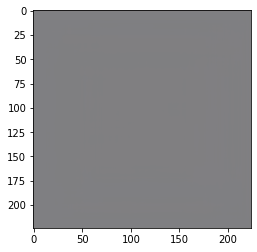

In [ ]:
for input, label in dataloaders["train_target"]:
    input.to("cpu")
    label.to("cpu")
    dsn.to("cpu")
    print(label)
    _, _, _, _, reconstructed_code = dsn(
        input,
        rec_code=ReconstructionCode.TARGET,
        rec_scheme=ReconstructionSheme.BOTH_SHARED_AND_PRIVATE,
    )
    rec_img_all = tr_image(reconstructed_code.data)
    # image reconstructions
    _, _, _, _, reconstructed_code = dsn(
        input,
        rec_code=ReconstructionCode.TARGET,
        rec_scheme=ReconstructionSheme.ONLY_SHARED_CODE,
    )
    rec_img_share = tr_image(reconstructed_code.data)

    plt.imshow(rec_img_share[0].permute(1, 2, 0))
    print(rec_img_share[0].permute(1, 2, 0))
    break

The reconstructed image of the original DSN architecture is far from being satisfactory, and it clearly shows the inefficiency of this first model.

### Second attempt: AlexNet and ResNet18 backbone

As previously explained, the second attempt consisted in relying on a more performing backbone for the encoding and decoding parts. Since the design choices are extensively explained in the first part of the notebook, we focus here only on the actual results.

As we can see from the upper table providing the results, despite the fact that the integration of these backbone architectures have provided better results, we were still quite far from a real domain adaptation gain.

The main problem we thought this architecture had was that it was deeply unbalanced: while the encoders could learn really fast decent feature representations, the decoder couldn't cope with this quick learning. From this idea we got to the next attempt, that actually provides a lot of case-specific optimizations.

#### AlexNet

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
net = AlexNetDSN(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "alexnet-dsn",
    net_name="alexnet",
    epochs=30,
    learning_rate=0.0001,
    step_decay_weight=0.95,
    lr_decay_step=200,
    active_domain_loss_step=-1,
    weight_decay=1e-6,
    alpha_weight=0,  # 0.5,
    beta_weight=0,  # 0.4,
    gamma_weight=0.1,
    momentum=0.9,
    batch_size=32,
    test_batch_size=32,
    technique=Technique.DSN,
    device=device,
)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Adding key source_encoder.0.weight in current params
Adding key source_encoder.0.bias in current params
Adding key source_encoder.3.weight in current params
Adding key source_encoder.3.bias in current params
Adding key source_encoder.6.weight in current params
Adding key source_encoder.6.bias in current params
Adding key source_encoder.8.weight in current params
Adding key source_encoder.8.bias in current params
Adding key source_encoder.10.weight in current params
Adding key source_encoder.10.bias in current params
Adding key target_encoder.0.weight in current params
Adding key target_encoder.0.bias in current params
Adding key target_encoder.3.weight in current params
Adding key target_encoder.3.bias in current params
Adding key target_encoder.6.weight in current params
Adding key target_encoder.6.bias in current params
Adding key target_encoder.8.weight in current params
Adding key target_encoder.8.bias in current params
Adding key target_encoder.10.weight in current params
Adding k


Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.62s/it]
Training: 2it [00:01,  1.15it/s]
Training: 3it [00:02,  1.07it/s]
Training: 4it [00:03,  1.42it/s]
Training: 5it [00:03,  1.47it/s]
Training: 6it [00:04,  1.79it/s]
Training: 7it [00:04,  1.72it/s]
Training: 8it [00:05,  2.00it/s]
Training: 9it [00:05,  1.94it/s]
Training: 10it [00:06,  2.16it/s]
Training: 11it [00:06,  1.87it/s]
Training: 12it [00:07,  2.12it/s]
Training: 13it [00:07,  1.97it/s]
Training: 14it [00:08,  2.21it/s]
Training: 15it [00:08,  1.96it/s]
Training: 16it [00:09,  2.19it/s]
Training: 17it [00:09,  2.07it/s]
Training: 18it [00:09,  2.25it/s]
Training: 19it [00:10,  1.95it/s]
Training: 20it [00:10,  2.19it/s]
Training: 21it [00:11,  1.97it/s]
Training: 22it [00:11,  2.16it/s]
Training: 23it [00:12,  1.94it/s]
Training: 24it [00:12,  2.13it/s]
Training: 25it [00:13,  1.98it/s]
Training: 26it [00:13,  2.21it/s]
Training: 27it [00:14,  1.96it/s]
Training: 28it [00:14,  2.15it/s]
Training: 29it [00:15,  1.8


Epoch: 1
	 Training loss 0.03424, Training accuracy 70.12
	 Test loss 0.05810, Test accuracy 44.79
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.52s/it]
Training: 2it [00:01,  1.23it/s]
Training: 3it [00:02,  1.33it/s]
Training: 4it [00:02,  1.67it/s]
Training: 5it [00:03,  1.65it/s]
Training: 6it [00:03,  1.96it/s]
Training: 7it [00:04,  1.92it/s]
Training: 8it [00:04,  2.16it/s]
Training: 9it [00:05,  1.81it/s]
Training: 10it [00:05,  2.07it/s]
Training: 11it [00:06,  1.90it/s]
Training: 12it [00:06,  2.15it/s]
Training: 13it [00:07,  1.89it/s]
Training: 14it [00:07,  2.15it/s]
Training: 15it [00:08,  1.96it/s]
Training: 16it [00:08,  2.16it/s]
Training: 17it [00:09,  2.01it/s]
Training: 18it [00:09,  2.26it/s]
Training: 19it [00:10,  1.97it/s]
Training: 20it [00:10,  2.21it/s]
Training: 21it [00:11,  1.99it/s]
Training: 22it [00:11,  2.19it/s]
Training: 23it [00:12,  2.01it/s]
Training: 24it [00:12,  2.21it/s]
Training: 25it [00:13,  2.02it/s]
Training: 26it [00:13,  2.26it/s]
Training: 27it [00:14,  1.95it/s]
Training: 28it [00:14,  2.18it/s]
Training: 29it [00:14,  2.1


Epoch: 2
	 Training loss 0.01227, Training accuracy 93.62
	 Test loss 0.07876, Test accuracy 39.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.35s/it]
Training: 2it [00:01,  1.31it/s]
Training: 3it [00:02,  1.49it/s]
Training: 4it [00:02,  1.84it/s]
Training: 5it [00:03,  1.77it/s]
Training: 6it [00:03,  1.96it/s]
Training: 7it [00:04,  1.95it/s]
Training: 8it [00:04,  2.18it/s]
Training: 9it [00:05,  2.01it/s]
Training: 10it [00:05,  1.87it/s]
Training: 11it [00:06,  2.11it/s]
Training: 12it [00:06,  1.95it/s]
Training: 13it [00:07,  2.10it/s]
Training: 14it [00:07,  1.85it/s]
Training: 15it [00:08,  2.05it/s]
Training: 16it [00:08,  1.93it/s]
Training: 17it [00:09,  2.12it/s]
Training: 18it [00:09,  1.92it/s]
Training: 19it [00:09,  2.15it/s]
Training: 20it [00:10,  1.98it/s]
Training: 21it [00:10,  2.17it/s]
Training: 22it [00:11,  1.92it/s]
Training: 23it [00:12,  1.70it/s]
Training: 24it [00:13,  1.43it/s]
Training: 25it [00:13,  1.68it/s]
Training: 26it [00:14,  1.38it/s]
Training: 27it [00:15,  1.62it/s]
Training: 28it [00:15,  1.68it/s]
Training: 29it [00:15,  1.9


Epoch: 3
	 Training loss 0.00459, Training accuracy 97.06
	 Test loss 0.05590, Test accuracy 48.96
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.37s/it]
Training: 2it [00:01,  1.31it/s]
Training: 3it [00:02,  1.50it/s]
Training: 4it [00:02,  1.84it/s]
Training: 5it [00:03,  1.62it/s]
Training: 6it [00:03,  1.91it/s]
Training: 7it [00:04,  1.79it/s]
Training: 8it [00:04,  2.01it/s]
Training: 9it [00:05,  1.94it/s]
Training: 10it [00:05,  2.19it/s]
Training: 11it [00:06,  2.06it/s]
Training: 12it [00:06,  2.22it/s]
Training: 13it [00:07,  2.11it/s]
Training: 14it [00:07,  2.31it/s]
Training: 15it [00:07,  2.15it/s]
Training: 16it [00:08,  2.35it/s]
Training: 17it [00:08,  2.08it/s]
Training: 18it [00:09,  2.30it/s]
Training: 19it [00:09,  1.95it/s]
Training: 20it [00:10,  2.19it/s]
Training: 21it [00:10,  1.80it/s]
Training: 22it [00:11,  2.06it/s]
Training: 23it [00:12,  1.81it/s]
Training: 24it [00:12,  2.06it/s]
Training: 25it [00:12,  1.88it/s]
Training: 26it [00:13,  2.12it/s]
Training: 27it [00:14,  1.87it/s]
Training: 28it [00:14,  2.12it/s]
Training: 29it [00:14,  2.0


Epoch: 4
	 Training loss 0.00316, Training accuracy 99.19
	 Test loss 0.05814, Test accuracy 52.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.40s/it]
Training: 2it [00:01,  1.27it/s]
Training: 3it [00:02,  1.24it/s]
Training: 4it [00:02,  1.59it/s]
Training: 5it [00:03,  1.47it/s]
Training: 6it [00:04,  1.73it/s]
Training: 7it [00:04,  1.65it/s]
Training: 8it [00:05,  1.94it/s]
Training: 9it [00:05,  1.89it/s]
Training: 10it [00:05,  2.12it/s]
Training: 11it [00:06,  2.05it/s]
Training: 12it [00:06,  2.27it/s]
Training: 13it [00:07,  1.97it/s]
Training: 14it [00:07,  2.19it/s]
Training: 15it [00:08,  2.06it/s]
Training: 16it [00:08,  2.31it/s]
Training: 17it [00:09,  2.04it/s]
Training: 18it [00:09,  2.24it/s]
Training: 19it [00:10,  1.77it/s]
Training: 20it [00:10,  1.96it/s]
Training: 21it [00:11,  1.82it/s]
Training: 22it [00:11,  1.92it/s]
Training: 23it [00:12,  2.03it/s]
Training: 24it [00:13,  1.84it/s]
Training: 25it [00:13,  2.09it/s]
Training: 26it [00:14,  1.89it/s]
Training: 27it [00:14,  2.14it/s]
Training: 28it [00:14,  2.07it/s]
Training: 29it [00:15,  2.1


Epoch: 5
	 Training loss 0.00389, Training accuracy 99.31
	 Test loss 0.05830, Test accuracy 51.30
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.27s/it]
Training: 2it [00:01,  1.38it/s]
Training: 3it [00:02,  1.62it/s]
Training: 4it [00:02,  1.75it/s]
Training: 5it [00:03,  1.88it/s]
Training: 6it [00:03,  1.89it/s]
Training: 7it [00:04,  1.73it/s]
Training: 8it [00:04,  1.98it/s]
Training: 9it [00:05,  1.94it/s]
Training: 10it [00:05,  2.07it/s]
Training: 11it [00:06,  1.79it/s]
Training: 12it [00:06,  2.02it/s]
Training: 13it [00:07,  1.95it/s]
Training: 14it [00:07,  2.16it/s]
Training: 15it [00:08,  2.12it/s]
Training: 16it [00:08,  2.26it/s]
Training: 17it [00:08,  2.19it/s]
Training: 18it [00:09,  2.26it/s]
Training: 19it [00:09,  2.10it/s]
Training: 20it [00:10,  2.18it/s]
Training: 21it [00:10,  2.31it/s]
Training: 22it [00:11,  2.11it/s]
Training: 23it [00:11,  2.27it/s]
Training: 24it [00:12,  2.15it/s]
Training: 25it [00:12,  2.23it/s]
Training: 26it [00:13,  2.08it/s]
Training: 27it [00:13,  2.14it/s]
Training: 28it [00:13,  2.16it/s]
Training: 29it [00:14,  2.3


Epoch: 6
	 Training loss 0.00377, Training accuracy 99.25
	 Test loss 0.06205, Test accuracy 48.44
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.25s/it]
Training: 2it [00:01,  1.41it/s]
Training: 3it [00:02,  1.61it/s]
Training: 4it [00:02,  1.95it/s]
Training: 5it [00:03,  1.62it/s]
Training: 6it [00:03,  1.93it/s]
Training: 7it [00:04,  1.95it/s]
Training: 8it [00:04,  2.19it/s]
Training: 9it [00:04,  2.08it/s]
Training: 10it [00:05,  2.29it/s]
Training: 11it [00:05,  2.12it/s]
Training: 12it [00:06,  2.09it/s]
Training: 13it [00:06,  2.27it/s]
Training: 14it [00:07,  2.02it/s]
Training: 15it [00:07,  2.24it/s]
Training: 16it [00:08,  2.15it/s]
Training: 17it [00:08,  2.37it/s]
Training: 18it [00:09,  2.06it/s]
Training: 19it [00:09,  2.27it/s]
Training: 20it [00:09,  2.11it/s]
Training: 21it [00:10,  2.16it/s]
Training: 22it [00:11,  1.92it/s]
Training: 23it [00:11,  2.16it/s]
Training: 24it [00:12,  1.91it/s]
Training: 25it [00:12,  2.08it/s]
Training: 26it [00:13,  1.95it/s]
Training: 27it [00:13,  2.17it/s]
Training: 28it [00:14,  1.83it/s]
Training: 29it [00:14,  2.0


Epoch: 7
	 Training loss 0.00751, Training accuracy 97.81
	 Test loss 0.06029, Test accuracy 48.44
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.26s/it]
Training: 2it [00:01,  1.42it/s]
Training: 3it [00:02,  1.60it/s]
Training: 4it [00:02,  1.82it/s]
Training: 5it [00:02,  2.00it/s]
Training: 6it [00:03,  1.77it/s]
Training: 7it [00:03,  2.05it/s]
Training: 8it [00:04,  1.93it/s]
Training: 9it [00:04,  2.19it/s]
Training: 10it [00:05,  1.99it/s]
Training: 11it [00:05,  2.20it/s]
Training: 12it [00:06,  2.06it/s]
Training: 13it [00:06,  2.29it/s]
Training: 14it [00:07,  2.20it/s]
Training: 15it [00:07,  2.22it/s]
Training: 16it [00:08,  2.11it/s]
Training: 17it [00:08,  2.17it/s]
Training: 18it [00:09,  2.09it/s]
Training: 19it [00:09,  2.11it/s]
Training: 20it [00:10,  2.14it/s]
Training: 21it [00:10,  2.05it/s]
Training: 22it [00:10,  2.25it/s]
Training: 23it [00:11,  1.87it/s]
Training: 24it [00:11,  2.12it/s]
Training: 25it [00:12,  2.02it/s]
Training: 26it [00:12,  2.23it/s]
Training: 27it [00:13,  2.04it/s]
Training: 28it [00:13,  2.23it/s]
Training: 29it [00:14,  1.8


Epoch: 8
	 Training loss 0.00649, Training accuracy 97.81
	 Test loss 0.08157, Test accuracy 48.18
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.32s/it]
Training: 2it [00:01,  1.34it/s]
Training: 3it [00:02,  1.29it/s]
Training: 4it [00:02,  1.67it/s]
Training: 5it [00:03,  1.70it/s]
Training: 6it [00:03,  1.99it/s]
Training: 7it [00:04,  1.97it/s]
Training: 8it [00:04,  2.21it/s]
Training: 9it [00:05,  2.05it/s]
Training: 10it [00:05,  2.16it/s]
Training: 11it [00:06,  2.01it/s]
Training: 12it [00:06,  2.05it/s]
Training: 13it [00:07,  1.71it/s]
Training: 14it [00:07,  1.75it/s]
Training: 15it [00:08,  1.82it/s]
Training: 16it [00:08,  1.83it/s]
Training: 17it [00:09,  1.98it/s]
Training: 18it [00:10,  1.76it/s]
Training: 19it [00:10,  2.03it/s]
Training: 20it [00:11,  1.81it/s]
Training: 21it [00:11,  2.04it/s]
Training: 22it [00:12,  1.84it/s]
Training: 23it [00:12,  2.06it/s]
Training: 24it [00:12,  2.05it/s]
Training: 25it [00:13,  2.27it/s]
Training: 26it [00:13,  2.11it/s]
Training: 27it [00:14,  2.20it/s]
Training: 28it [00:14,  2.11it/s]
Training: 29it [00:15,  2.3


Epoch: 9
	 Training loss 0.00635, Training accuracy 97.19
	 Test loss 0.07046, Test accuracy 47.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.48s/it]
Training: 2it [00:01,  1.23it/s]
Training: 3it [00:02,  1.27it/s]
Training: 4it [00:02,  1.64it/s]
Training: 5it [00:03,  1.65it/s]
Training: 6it [00:03,  1.97it/s]
Training: 7it [00:04,  1.62it/s]
Training: 8it [00:04,  1.92it/s]
Training: 9it [00:05,  1.98it/s]
Training: 10it [00:05,  2.20it/s]
Training: 11it [00:06,  1.90it/s]
Training: 12it [00:06,  2.16it/s]
Training: 13it [00:07,  1.99it/s]
Training: 14it [00:07,  2.21it/s]
Training: 15it [00:08,  2.05it/s]
Training: 16it [00:08,  2.29it/s]
Training: 17it [00:09,  1.98it/s]
Training: 18it [00:09,  2.19it/s]
Training: 19it [00:10,  1.91it/s]
Training: 20it [00:10,  2.17it/s]
Training: 21it [00:11,  1.83it/s]
Training: 22it [00:11,  2.07it/s]
Training: 23it [00:12,  1.83it/s]
Training: 24it [00:12,  2.10it/s]
Training: 25it [00:13,  1.89it/s]
Training: 26it [00:13,  2.14it/s]
Training: 27it [00:14,  1.98it/s]
Training: 28it [00:14,  2.21it/s]
Training: 29it [00:15,  2.0


Epoch: 10
	 Training loss 0.00556, Training accuracy 98.31
	 Test loss 0.05753, Test accuracy 52.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.30s/it]
Training: 2it [00:01,  1.39it/s]
Training: 3it [00:02,  1.48it/s]
Training: 4it [00:02,  1.87it/s]
Training: 5it [00:03,  1.69it/s]
Training: 6it [00:03,  2.01it/s]
Training: 7it [00:04,  1.94it/s]
Training: 8it [00:04,  2.19it/s]
Training: 9it [00:05,  1.87it/s]
Training: 10it [00:05,  2.14it/s]
Training: 11it [00:06,  1.95it/s]
Training: 12it [00:06,  2.19it/s]
Training: 13it [00:07,  1.84it/s]
Training: 14it [00:07,  2.05it/s]
Training: 15it [00:08,  1.80it/s]
Training: 16it [00:08,  2.06it/s]
Training: 17it [00:09,  1.99it/s]
Training: 18it [00:09,  2.21it/s]
Training: 19it [00:10,  1.99it/s]
Training: 20it [00:10,  2.24it/s]
Training: 21it [00:10,  2.00it/s]
Training: 22it [00:11,  2.21it/s]
Training: 23it [00:12,  1.90it/s]
Training: 24it [00:12,  2.14it/s]
Training: 25it [00:12,  2.09it/s]
Training: 26it [00:13,  2.27it/s]
Training: 27it [00:13,  2.11it/s]
Training: 28it [00:14,  2.31it/s]
Training: 29it [00:14,  2.0


Epoch: 11
	 Training loss 0.00479, Training accuracy 98.75
	 Test loss 0.05711, Test accuracy 54.69
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.33s/it]
Training: 2it [00:01,  1.34it/s]
Training: 3it [00:02,  1.32it/s]
Training: 4it [00:02,  1.71it/s]
Training: 5it [00:03,  1.71it/s]
Training: 6it [00:03,  2.02it/s]
Training: 7it [00:04,  1.74it/s]
Training: 8it [00:04,  2.03it/s]
Training: 9it [00:05,  1.93it/s]
Training: 10it [00:05,  2.18it/s]
Training: 11it [00:06,  2.03it/s]
Training: 12it [00:06,  2.26it/s]
Training: 13it [00:07,  2.09it/s]
Training: 14it [00:07,  2.32it/s]
Training: 15it [00:07,  2.10it/s]
Training: 16it [00:08,  2.33it/s]
Training: 17it [00:08,  2.01it/s]
Training: 18it [00:09,  2.21it/s]
Training: 19it [00:10,  1.80it/s]
Training: 20it [00:10,  2.06it/s]
Training: 21it [00:11,  1.88it/s]
Training: 22it [00:11,  2.13it/s]
Training: 23it [00:11,  2.02it/s]
Training: 24it [00:12,  2.23it/s]
Training: 25it [00:12,  2.06it/s]
Training: 26it [00:13,  2.30it/s]
Training: 27it [00:13,  1.96it/s]
Training: 28it [00:14,  2.20it/s]
Training: 29it [00:14,  1.9


Epoch: 12
	 Training loss 0.00548, Training accuracy 98.62
	 Test loss 0.07104, Test accuracy 51.04
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.28s/it]
Training: 2it [00:01,  1.38it/s]
Training: 3it [00:02,  1.57it/s]
Training: 4it [00:02,  1.66it/s]
Training: 5it [00:03,  1.83it/s]
Training: 6it [00:03,  1.87it/s]
Training: 7it [00:04,  2.05it/s]
Training: 8it [00:04,  1.92it/s]
Training: 9it [00:05,  1.91it/s]
Training: 10it [00:05,  2.06it/s]
Training: 11it [00:06,  2.00it/s]
Training: 12it [00:06,  2.18it/s]
Training: 13it [00:07,  2.06it/s]
Training: 14it [00:07,  2.24it/s]
Training: 15it [00:08,  1.98it/s]
Training: 16it [00:08,  2.21it/s]
Training: 17it [00:08,  2.14it/s]
Training: 18it [00:09,  2.34it/s]
Training: 19it [00:09,  2.12it/s]
Training: 20it [00:10,  2.26it/s]
Training: 21it [00:10,  2.06it/s]
Training: 22it [00:11,  2.25it/s]
Training: 23it [00:11,  2.17it/s]
Training: 24it [00:11,  2.36it/s]
Training: 25it [00:12,  1.99it/s]
Training: 26it [00:12,  2.22it/s]
Training: 27it [00:13,  2.05it/s]
Training: 28it [00:13,  2.29it/s]
Training: 29it [00:14,  2.0


Epoch: 13
	 Training loss 0.00526, Training accuracy 98.56
	 Test loss 0.07251, Test accuracy 42.71
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.20s/it]
Training: 2it [00:01,  1.45it/s]
Training: 3it [00:02,  1.38it/s]
Training: 4it [00:02,  1.73it/s]
Training: 5it [00:03,  1.79it/s]
Training: 6it [00:03,  2.07it/s]
Training: 7it [00:04,  1.98it/s]
Training: 8it [00:04,  2.21it/s]
Training: 9it [00:04,  2.10it/s]
Training: 10it [00:05,  2.30it/s]
Training: 11it [00:05,  2.16it/s]
Training: 12it [00:06,  2.34it/s]
Training: 13it [00:06,  2.03it/s]
Training: 14it [00:07,  2.25it/s]
Training: 15it [00:07,  1.93it/s]
Training: 16it [00:08,  2.19it/s]
Training: 17it [00:08,  1.89it/s]
Training: 18it [00:09,  2.14it/s]
Training: 19it [00:09,  1.89it/s]
Training: 20it [00:10,  2.10it/s]
Training: 21it [00:10,  1.90it/s]
Training: 22it [00:11,  2.15it/s]
Training: 23it [00:11,  1.85it/s]
Training: 24it [00:12,  2.11it/s]
Training: 25it [00:12,  1.92it/s]
Training: 26it [00:13,  2.18it/s]
Training: 27it [00:13,  2.04it/s]
Training: 28it [00:13,  2.29it/s]
Training: 29it [00:14,  1.8


Epoch: 14
	 Training loss 0.00406, Training accuracy 99.12
	 Test loss 0.06763, Test accuracy 51.30
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.23s/it]
Training: 2it [00:01,  1.44it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:02,  1.69it/s]
Training: 5it [00:03,  1.81it/s]
Training: 6it [00:03,  2.09it/s]
Training: 7it [00:04,  1.78it/s]
Training: 8it [00:04,  2.06it/s]
Training: 9it [00:05,  1.83it/s]
Training: 10it [00:05,  2.10it/s]
Training: 11it [00:06,  1.98it/s]
Training: 12it [00:06,  2.23it/s]
Training: 13it [00:07,  2.05it/s]
Training: 14it [00:07,  2.26it/s]
Training: 15it [00:08,  1.80it/s]
Training: 16it [00:08,  2.07it/s]
Training: 17it [00:09,  1.87it/s]
Training: 18it [00:09,  2.13it/s]
Training: 19it [00:10,  1.81it/s]
Training: 20it [00:10,  2.07it/s]
Training: 21it [00:11,  1.84it/s]
Training: 22it [00:11,  2.10it/s]
Training: 23it [00:12,  1.91it/s]
Training: 24it [00:12,  2.17it/s]
Training: 25it [00:13,  2.05it/s]
Training: 26it [00:13,  2.27it/s]
Training: 27it [00:14,  1.93it/s]
Training: 28it [00:14,  2.18it/s]
Training: 29it [00:15,  2.0


Epoch: 15
	 Training loss 0.00489, Training accuracy 98.94
	 Test loss 0.05497, Test accuracy 55.47
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.23s/it]
Training: 2it [00:01,  1.34it/s]
Training: 3it [00:02,  1.46it/s]
Training: 4it [00:02,  1.75it/s]
Training: 5it [00:03,  1.88it/s]
Training: 6it [00:03,  1.83it/s]
Training: 7it [00:04,  2.05it/s]
Training: 8it [00:04,  2.18it/s]
Training: 9it [00:04,  2.12it/s]
Training: 10it [00:05,  2.09it/s]
Training: 11it [00:05,  2.16it/s]
Training: 12it [00:06,  2.07it/s]
Training: 13it [00:06,  2.24it/s]
Training: 14it [00:07,  2.12it/s]
Training: 15it [00:07,  2.15it/s]
Training: 16it [00:08,  2.08it/s]
Training: 17it [00:08,  2.21it/s]
Training: 18it [00:09,  2.02it/s]
Training: 19it [00:09,  2.14it/s]
Training: 20it [00:10,  2.05it/s]
Training: 21it [00:10,  2.21it/s]
Training: 22it [00:11,  2.08it/s]
Training: 23it [00:11,  2.18it/s]
Training: 24it [00:12,  2.05it/s]
Training: 25it [00:12,  2.12it/s]
Training: 26it [00:12,  2.10it/s]
Training: 27it [00:13,  2.29it/s]
Training: 28it [00:13,  2.14it/s]
Training: 29it [00:14,  2.1


Epoch: 16
	 Training loss 0.00442, Training accuracy 99.06
	 Test loss 0.05346, Test accuracy 58.85
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.27s/it]
Training: 2it [00:01,  1.41it/s]
Training: 3it [00:02,  1.44it/s]
Training: 4it [00:02,  1.81it/s]
Training: 5it [00:03,  1.71it/s]
Training: 6it [00:03,  1.99it/s]
Training: 7it [00:04,  1.74it/s]
Training: 8it [00:04,  2.03it/s]
Training: 9it [00:05,  1.91it/s]
Training: 10it [00:05,  2.15it/s]
Training: 11it [00:06,  1.90it/s]
Training: 12it [00:06,  2.16it/s]
Training: 13it [00:07,  2.09it/s]
Training: 14it [00:07,  2.25it/s]
Training: 15it [00:08,  2.03it/s]
Training: 16it [00:08,  2.28it/s]
Training: 17it [00:08,  2.05it/s]
Training: 18it [00:09,  2.29it/s]
Training: 19it [00:10,  1.82it/s]
Training: 20it [00:10,  2.08it/s]
Training: 21it [00:10,  1.94it/s]
Training: 22it [00:11,  2.17it/s]
Training: 23it [00:12,  1.81it/s]
Training: 24it [00:12,  2.08it/s]
Training: 25it [00:13,  1.88it/s]
Training: 26it [00:13,  2.13it/s]
Training: 27it [00:14,  1.91it/s]
Training: 28it [00:14,  2.17it/s]
Training: 29it [00:14,  2.0


Epoch: 17
	 Training loss 0.00415, Training accuracy 99.12
	 Test loss 0.05880, Test accuracy 54.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.28s/it]
Training: 2it [00:01,  1.37it/s]
Training: 3it [00:02,  1.47it/s]
Training: 4it [00:02,  1.86it/s]
Training: 5it [00:03,  1.82it/s]
Training: 6it [00:03,  2.09it/s]
Training: 7it [00:04,  1.74it/s]
Training: 8it [00:04,  2.01it/s]
Training: 9it [00:05,  1.65it/s]
Training: 10it [00:05,  1.93it/s]
Training: 11it [00:06,  1.84it/s]
Training: 12it [00:06,  2.08it/s]
Training: 13it [00:07,  1.90it/s]
Training: 14it [00:07,  2.16it/s]
Training: 15it [00:08,  2.09it/s]
Training: 16it [00:08,  2.29it/s]
Training: 17it [00:09,  2.00it/s]
Training: 18it [00:09,  2.24it/s]
Training: 19it [00:10,  2.03it/s]
Training: 20it [00:10,  2.22it/s]
Training: 21it [00:10,  2.09it/s]
Training: 22it [00:11,  2.33it/s]
Training: 23it [00:12,  1.90it/s]
Training: 24it [00:12,  2.14it/s]
Training: 25it [00:12,  1.94it/s]
Training: 26it [00:13,  2.19it/s]
Training: 27it [00:13,  2.03it/s]
Training: 28it [00:14,  2.25it/s]
Training: 29it [00:14,  2.0


Epoch: 18
	 Training loss 0.00478, Training accuracy 98.56
	 Test loss 0.06602, Test accuracy 52.60
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.47s/it]
Training: 2it [00:01,  1.25it/s]
Training: 3it [00:02,  1.27it/s]
Training: 4it [00:02,  1.66it/s]
Training: 5it [00:03,  1.69it/s]
Training: 6it [00:03,  1.98it/s]
Training: 7it [00:04,  1.95it/s]
Training: 8it [00:04,  2.20it/s]
Training: 9it [00:05,  1.97it/s]
Training: 10it [00:05,  2.19it/s]
Training: 11it [00:06,  1.97it/s]
Training: 12it [00:06,  2.22it/s]
Training: 13it [00:07,  1.89it/s]
Training: 14it [00:07,  2.14it/s]
Training: 15it [00:08,  1.80it/s]
Training: 16it [00:08,  2.08it/s]
Training: 17it [00:09,  2.01it/s]
Training: 18it [00:09,  2.22it/s]
Training: 19it [00:10,  2.01it/s]
Training: 20it [00:10,  2.26it/s]
Training: 21it [00:11,  2.00it/s]
Training: 22it [00:11,  2.25it/s]
Training: 23it [00:12,  1.95it/s]
Training: 24it [00:12,  2.20it/s]
Training: 25it [00:12,  2.09it/s]
Training: 26it [00:13,  2.31it/s]
Training: 27it [00:13,  2.09it/s]
Training: 28it [00:14,  2.29it/s]
Training: 29it [00:14,  1.9


Epoch: 19
	 Training loss 0.00392, Training accuracy 99.44
	 Test loss 0.05326, Test accuracy 56.51
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.36s/it]
Training: 2it [00:01,  1.34it/s]
Training: 3it [00:02,  1.51it/s]
Training: 4it [00:02,  1.89it/s]
Training: 5it [00:03,  1.72it/s]
Training: 6it [00:03,  2.03it/s]
Training: 7it [00:04,  1.65it/s]
Training: 8it [00:04,  1.95it/s]
Training: 9it [00:05,  1.88it/s]
Training: 10it [00:05,  2.14it/s]
Training: 11it [00:06,  1.92it/s]
Training: 12it [00:06,  2.18it/s]
Training: 13it [00:07,  2.04it/s]
Training: 14it [00:07,  2.26it/s]
Training: 15it [00:08,  2.06it/s]
Training: 16it [00:08,  2.13it/s]
Training: 17it [00:08,  2.17it/s]
Training: 18it [00:09,  2.11it/s]
Training: 19it [00:09,  2.21it/s]
Training: 20it [00:10,  2.20it/s]
Training: 21it [00:10,  2.33it/s]
Training: 22it [00:11,  2.16it/s]
Training: 23it [00:11,  2.33it/s]
Training: 24it [00:12,  2.05it/s]
Training: 25it [00:12,  2.10it/s]
Training: 26it [00:13,  2.03it/s]
Training: 27it [00:13,  2.18it/s]
Training: 28it [00:14,  1.99it/s]
Training: 29it [00:14,  2.1


Epoch: 20
	 Training loss 0.00367, Training accuracy 99.75
	 Test loss 0.05648, Test accuracy 55.99
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.51s/it]
Training: 2it [00:01,  1.24it/s]
Training: 3it [00:02,  1.49it/s]
Training: 4it [00:02,  1.88it/s]
Training: 5it [00:03,  1.75it/s]
Training: 6it [00:03,  2.02it/s]
Training: 7it [00:04,  1.83it/s]
Training: 8it [00:04,  2.07it/s]
Training: 9it [00:05,  1.81it/s]
Training: 10it [00:05,  2.08it/s]
Training: 11it [00:06,  1.65it/s]
Training: 12it [00:06,  1.89it/s]
Training: 13it [00:07,  1.79it/s]
Training: 14it [00:07,  2.02it/s]
Training: 15it [00:08,  1.83it/s]
Training: 16it [00:08,  2.09it/s]
Training: 17it [00:09,  1.84it/s]
Training: 18it [00:09,  2.07it/s]
Training: 19it [00:10,  1.78it/s]
Training: 20it [00:10,  2.04it/s]
Training: 21it [00:11,  1.72it/s]
Training: 22it [00:12,  1.98it/s]
Training: 23it [00:12,  1.85it/s]
Training: 24it [00:13,  2.07it/s]
Training: 25it [00:13,  1.93it/s]
Training: 26it [00:14,  2.15it/s]
Training: 27it [00:14,  2.00it/s]
Training: 28it [00:14,  2.20it/s]
Training: 29it [00:15,  1.7


Epoch: 21
	 Training loss 0.00395, Training accuracy 99.31
	 Test loss 0.06112, Test accuracy 52.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.35s/it]
Training: 2it [00:01,  1.32it/s]
Training: 3it [00:02,  1.40it/s]
Training: 4it [00:02,  1.58it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:03,  1.85it/s]
Training: 7it [00:04,  1.76it/s]
Training: 8it [00:04,  1.84it/s]
Training: 9it [00:05,  1.91it/s]
Training: 10it [00:05,  1.93it/s]
Training: 11it [00:06,  1.95it/s]
Training: 12it [00:07,  1.72it/s]
Training: 13it [00:07,  1.78it/s]
Training: 14it [00:08,  1.83it/s]
Training: 15it [00:08,  1.89it/s]
Training: 16it [00:09,  2.04it/s]
Training: 17it [00:09,  1.95it/s]
Training: 18it [00:10,  2.15it/s]
Training: 19it [00:10,  1.98it/s]
Training: 20it [00:11,  2.16it/s]
Training: 21it [00:11,  2.06it/s]
Training: 22it [00:11,  2.25it/s]
Training: 23it [00:12,  2.01it/s]
Training: 24it [00:12,  2.20it/s]
Training: 25it [00:13,  2.11it/s]
Training: 26it [00:13,  2.01it/s]
Training: 27it [00:14,  2.20it/s]
Training: 28it [00:14,  1.97it/s]
Training: 29it [00:15,  2.1


Epoch: 22
	 Training loss 0.00367, Training accuracy 99.75
	 Test loss 0.06341, Test accuracy 53.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.45s/it]
Training: 2it [00:01,  1.24it/s]
Training: 3it [00:02,  1.49it/s]
Training: 4it [00:02,  1.87it/s]
Training: 5it [00:03,  1.79it/s]
Training: 6it [00:03,  2.07it/s]
Training: 7it [00:04,  2.05it/s]
Training: 8it [00:04,  2.26it/s]
Training: 9it [00:04,  2.20it/s]
Training: 10it [00:05,  2.39it/s]
Training: 11it [00:05,  2.20it/s]
Training: 12it [00:06,  2.23it/s]
Training: 13it [00:06,  2.24it/s]
Training: 14it [00:07,  2.16it/s]
Training: 15it [00:07,  1.87it/s]
Training: 16it [00:08,  2.11it/s]
Training: 17it [00:08,  1.98it/s]
Training: 18it [00:09,  2.18it/s]
Training: 19it [00:09,  2.08it/s]
Training: 20it [00:09,  2.27it/s]
Training: 21it [00:10,  2.11it/s]
Training: 22it [00:10,  2.25it/s]
Training: 23it [00:11,  2.20it/s]
Training: 24it [00:11,  2.33it/s]
Training: 25it [00:12,  2.07it/s]
Training: 26it [00:12,  2.30it/s]
Training: 27it [00:13,  2.09it/s]
Training: 28it [00:13,  2.33it/s]
Training: 29it [00:14,  2.0


Epoch: 23
	 Training loss 0.00340, Training accuracy 99.81
	 Test loss 0.06508, Test accuracy 53.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.47s/it]
Training: 2it [00:01,  1.25it/s]
Training: 3it [00:02,  1.38it/s]
Training: 4it [00:02,  1.77it/s]
Training: 5it [00:03,  1.84it/s]
Training: 6it [00:03,  2.11it/s]
Training: 7it [00:04,  2.08it/s]
Training: 8it [00:04,  2.29it/s]
Training: 9it [00:05,  1.75it/s]
Training: 10it [00:05,  2.03it/s]
Training: 11it [00:06,  1.86it/s]
Training: 12it [00:06,  2.13it/s]
Training: 13it [00:07,  1.79it/s]
Training: 14it [00:07,  2.05it/s]
Training: 15it [00:08,  1.95it/s]
Training: 16it [00:08,  2.21it/s]
Training: 17it [00:09,  2.07it/s]
Training: 18it [00:09,  2.30it/s]
Training: 19it [00:09,  2.12it/s]
Training: 20it [00:10,  2.31it/s]
Training: 21it [00:10,  2.04it/s]
Training: 22it [00:11,  2.24it/s]
Training: 23it [00:11,  1.95it/s]
Training: 24it [00:12,  2.20it/s]
Training: 25it [00:12,  1.88it/s]
Training: 26it [00:13,  2.12it/s]
Training: 27it [00:13,  2.08it/s]
Training: 28it [00:14,  2.32it/s]
Training: 29it [00:14,  2.0


Epoch: 24
	 Training loss 0.00447, Training accuracy 99.19
	 Test loss 0.07047, Test accuracy 52.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.56s/it]
Training: 2it [00:01,  1.20it/s]
Training: 3it [00:02,  1.45it/s]
Training: 4it [00:02,  1.84it/s]
Training: 5it [00:03,  1.80it/s]
Training: 6it [00:03,  2.09it/s]
Training: 7it [00:04,  1.90it/s]
Training: 8it [00:04,  2.17it/s]
Training: 9it [00:05,  2.01it/s]
Training: 10it [00:05,  2.21it/s]
Training: 11it [00:06,  2.00it/s]
Training: 12it [00:06,  2.21it/s]
Training: 13it [00:07,  1.99it/s]
Training: 14it [00:07,  2.24it/s]
Training: 15it [00:08,  1.96it/s]
Training: 16it [00:08,  2.19it/s]
Training: 17it [00:09,  1.93it/s]
Training: 18it [00:09,  2.17it/s]
Training: 19it [00:10,  1.91it/s]
Training: 20it [00:10,  2.17it/s]
Training: 21it [00:10,  2.00it/s]
Training: 22it [00:11,  2.22it/s]
Training: 23it [00:11,  1.99it/s]
Training: 24it [00:12,  2.24it/s]
Training: 25it [00:12,  2.14it/s]
Training: 26it [00:13,  2.37it/s]
Training: 27it [00:13,  2.02it/s]
Training: 28it [00:14,  2.25it/s]
Training: 29it [00:14,  2.0


Epoch: 25
	 Training loss 0.00446, Training accuracy 98.88
	 Test loss 0.05906, Test accuracy 54.95
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.41s/it]
Training: 2it [00:01,  1.31it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:02,  1.69it/s]
Training: 5it [00:03,  1.66it/s]
Training: 6it [00:03,  1.94it/s]
Training: 7it [00:04,  1.82it/s]
Training: 8it [00:04,  2.10it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:05,  2.01it/s]
Training: 11it [00:06,  1.99it/s]
Training: 12it [00:06,  2.21it/s]
Training: 13it [00:07,  2.03it/s]
Training: 14it [00:07,  2.28it/s]
Training: 15it [00:08,  1.96it/s]
Training: 16it [00:08,  2.20it/s]
Training: 17it [00:09,  1.98it/s]
Training: 18it [00:09,  2.19it/s]
Training: 19it [00:10,  1.94it/s]
Training: 20it [00:10,  2.19it/s]
Training: 21it [00:11,  2.04it/s]
Training: 22it [00:11,  2.27it/s]
Training: 23it [00:12,  1.92it/s]
Training: 24it [00:12,  2.15it/s]
Training: 25it [00:13,  2.01it/s]
Training: 26it [00:13,  2.23it/s]
Training: 27it [00:13,  2.04it/s]
Training: 28it [00:14,  2.24it/s]
Training: 29it [00:14,  2.0


Epoch: 26
	 Training loss 0.00393, Training accuracy 99.50
	 Test loss 0.05931, Test accuracy 56.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.22s/it]
Training: 2it [00:01,  1.38it/s]
Training: 3it [00:01,  1.76it/s]
Training: 4it [00:02,  1.58it/s]
Training: 5it [00:03,  1.91it/s]
Training: 6it [00:03,  1.75it/s]
Training: 7it [00:04,  2.02it/s]
Training: 8it [00:04,  1.97it/s]
Training: 9it [00:04,  2.19it/s]
Training: 10it [00:05,  1.94it/s]
Training: 11it [00:05,  2.19it/s]
Training: 12it [00:06,  1.94it/s]
Training: 13it [00:06,  2.15it/s]
Training: 14it [00:07,  1.98it/s]
Training: 15it [00:07,  2.19it/s]
Training: 16it [00:08,  2.04it/s]
Training: 17it [00:08,  2.24it/s]
Training: 18it [00:09,  2.01it/s]
Training: 19it [00:09,  2.23it/s]
Training: 20it [00:10,  2.01it/s]
Training: 21it [00:10,  2.19it/s]
Training: 22it [00:11,  2.03it/s]
Training: 23it [00:11,  2.22it/s]
Training: 24it [00:12,  2.12it/s]
Training: 25it [00:12,  2.29it/s]
Training: 26it [00:13,  2.02it/s]
Training: 27it [00:13,  2.26it/s]
Training: 28it [00:14,  1.94it/s]
Training: 29it [00:14,  2.1


Epoch: 27
	 Training loss 0.00469, Training accuracy 99.31
	 Test loss 0.08896, Test accuracy 54.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.25s/it]
Training: 2it [00:01,  1.38it/s]
Training: 3it [00:02,  1.51it/s]
Training: 4it [00:02,  1.91it/s]
Training: 5it [00:03,  1.83it/s]
Training: 6it [00:03,  2.12it/s]
Training: 7it [00:04,  1.93it/s]
Training: 8it [00:04,  2.17it/s]
Training: 9it [00:05,  1.94it/s]
Training: 10it [00:05,  2.20it/s]
Training: 11it [00:06,  1.83it/s]
Training: 12it [00:06,  2.09it/s]
Training: 13it [00:06,  2.09it/s]
Training: 14it [00:07,  2.29it/s]
Training: 15it [00:07,  2.10it/s]
Training: 16it [00:08,  2.29it/s]
Training: 17it [00:08,  1.91it/s]
Training: 18it [00:09,  2.17it/s]
Training: 19it [00:09,  1.89it/s]
Training: 20it [00:10,  2.15it/s]
Training: 21it [00:10,  1.85it/s]
Training: 22it [00:11,  2.12it/s]
Training: 23it [00:11,  1.98it/s]
Training: 24it [00:12,  2.22it/s]
Training: 25it [00:12,  1.95it/s]
Training: 26it [00:13,  2.21it/s]
Training: 27it [00:13,  1.99it/s]
Training: 28it [00:14,  2.24it/s]
Training: 29it [00:14,  1.9


Epoch: 28
	 Training loss 0.00540, Training accuracy 98.25
	 Test loss 0.07991, Test accuracy 53.39
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.57s/it]
Training: 2it [00:01,  1.20it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:02,  1.72it/s]
Training: 5it [00:03,  1.66it/s]
Training: 6it [00:03,  1.98it/s]
Training: 7it [00:04,  1.89it/s]
Training: 8it [00:04,  2.14it/s]
Training: 9it [00:05,  1.91it/s]
Training: 10it [00:05,  2.18it/s]
Training: 11it [00:06,  1.80it/s]
Training: 12it [00:06,  2.07it/s]
Training: 13it [00:07,  1.88it/s]
Training: 14it [00:07,  2.14it/s]
Training: 15it [00:08,  1.91it/s]
Training: 16it [00:08,  2.17it/s]
Training: 17it [00:09,  1.97it/s]
Training: 18it [00:09,  2.16it/s]
Training: 19it [00:10,  2.01it/s]
Training: 20it [00:10,  2.21it/s]
Training: 21it [00:11,  1.88it/s]
Training: 22it [00:11,  2.14it/s]
Training: 23it [00:12,  2.14it/s]
Training: 24it [00:12,  2.33it/s]
Training: 25it [00:13,  2.00it/s]
Training: 26it [00:13,  2.24it/s]
Training: 27it [00:13,  2.15it/s]
Training: 28it [00:14,  2.34it/s]
Training: 29it [00:15,  1.8


Epoch: 29
	 Training loss 0.00459, Training accuracy 98.94
	 Test loss 0.07939, Test accuracy 54.43
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.41s/it]
Training: 2it [00:01,  1.28it/s]
Training: 3it [00:02,  1.47it/s]
Training: 4it [00:02,  1.87it/s]
Training: 5it [00:03,  1.63it/s]
Training: 6it [00:03,  1.92it/s]
Training: 7it [00:04,  1.86it/s]
Training: 8it [00:04,  2.14it/s]
Training: 9it [00:05,  1.99it/s]
Training: 10it [00:05,  2.22it/s]
Training: 11it [00:06,  1.94it/s]
Training: 12it [00:06,  2.20it/s]
Training: 13it [00:07,  2.02it/s]
Training: 14it [00:07,  2.23it/s]
Training: 15it [00:08,  1.97it/s]
Training: 16it [00:08,  2.22it/s]
Training: 17it [00:09,  1.99it/s]
Training: 18it [00:09,  2.23it/s]
Training: 19it [00:09,  1.99it/s]
Training: 20it [00:10,  2.22it/s]
Training: 21it [00:10,  2.05it/s]
Training: 22it [00:11,  2.26it/s]
Training: 23it [00:11,  1.91it/s]
Training: 24it [00:12,  2.16it/s]
Training: 25it [00:12,  2.05it/s]
Training: 26it [00:13,  2.29it/s]
Training: 27it [00:13,  1.93it/s]
Training: 28it [00:14,  2.15it/s]
Training: 29it [00:14,  2.0


Epoch: 30
	 Training loss 0.00484, Training accuracy 98.56
	 Test loss 0.08493, Test accuracy 53.65
-----------------------------------------------------
#> After training:



Training: 50it [00:12,  3.94it/s]
Validation: 12it [00:03,  3.52it/s]
Test: 12it [00:05,  2.22it/s]


	 Training loss 0.00070, Training accuracy 99.25
	 Validation loss 0.01562, Validation accuracy 90.10
	 [Current] Test loss 0.08470, Test accuracy 54.17
#> Resume best


Test: 12it [00:05,  2.21it/s]


	 [Best] Test loss 0.05544, Test accuracy 55.47
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-dsn"
!cp -r "/content/alexnet-dsn" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-dsn"

#### ResNet18

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
net = ResNet18DSN(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "resnet18-dsn",
    net_name="resnet",
    epochs=30,
    learning_rate=0.00001,
    step_decay_weight=0.95,
    lr_decay_step=200,
    active_domain_loss_step=-1,
    weight_decay=1e-6,
    alpha_weight=0.15,  # 0.5,
    beta_weight=0.1,  # 0.4,
    gamma_weight=1,
    momentum=0.9,
    batch_size=32,
    test_batch_size=32,
    technique=Technique.DSN,
    device=device,
)

In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-dsn"
!cp -r "/content/resnet18-dsn" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-dsn"

### Third attempt: improved ResNet18

The major improvements, which are extensively described in the model's description in the first part of the notebook, were the following:
- to fill the gap between encoders and decoders, we have trained the model freezing all the parameters except the decoder ones and train the model for reconstruction purposes for more than 200 epochs;
- we have found a better way to merge the features from both the private encoder and the shared one, by using a specially crafted layer mapping the codes into a lower dimensional embedding;
- the hyperparameters of the network have been intensively tuned, stressing each of them separately and observing their impact singularly on the test performances. In particular, we have used different values for the hyperparameters `alpha`, `beta` and `gamma` with respect to the ones provided by the paper.

As we can see from the table above, we had an increase in the accuracy of 5.86\%.

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
net = ResNet18DSNImproved(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "resnet18-improved-dsn",
    net_name="resnet18",
    epochs=30,
    learning_rate=0.00001,
    step_decay_weight=0.95,
    lr_decay_step=200,
    active_domain_loss_step=-1,
    weight_decay=1e-6,
    alpha_weight=0.15,  # 0.05, # 0.5,
    beta_weight=0.1,  # 0.04, # 0.4,
    gamma_weight=1,
    momentum=0.9,
    batch_size=32,
    test_batch_size=32,
    technique=Technique.DSN,
    device=device,
)

Adding  merge_features.0.weight
Adding  merge_features.0.bias
Adding  shared_decoder.0.linear.weight
Adding  shared_decoder.0.linear.bias
Adding  shared_decoder.0.layer4.0.conv2.weight
Adding  shared_decoder.0.layer4.0.bn2.weight
Adding  shared_decoder.0.layer4.0.bn2.bias
Adding  shared_decoder.0.layer4.0.bn2.running_mean
Adding  shared_decoder.0.layer4.0.bn2.running_var
Adding  shared_decoder.0.layer4.0.bn2.num_batches_tracked
Adding  shared_decoder.0.layer4.0.conv1.weight
Adding  shared_decoder.0.layer4.0.bn1.weight
Adding  shared_decoder.0.layer4.0.bn1.bias
Adding  shared_decoder.0.layer4.0.bn1.running_mean
Adding  shared_decoder.0.layer4.0.bn1.running_var
Adding  shared_decoder.0.layer4.0.bn1.num_batches_tracked
Adding  shared_decoder.0.layer4.1.conv2.weight
Adding  shared_decoder.0.layer4.1.bn2.weight
Adding  shared_decoder.0.layer4.1.bn2.bias
Adding  shared_decoder.0.layer4.1.bn2.running_mean
Adding  shared_decoder.0.layer4.1.bn2.running_var
Adding  shared_decoder.0.layer4.1.bn2.

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DSN



Training: 0it [00:00, ?it/s]/home/lucademenego/.pyenv/versions/3.7.0/envs/colab/lib/python3.7/site-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "

Training: 1it [00:01,  1.94s/it]
Training: 2it [00:02,  1.14s/it]
Training: 3it [00:03,  1.02s/it]
Training: 4it [00:03,  1.18it/s]
Training: 5it [00:04,  1.31it/s]
Training: 6it [00:05,  1.42it/s]
Training: 7it [00:05,  1.51it/s]
Training: 8it [00:06,  1.55it/s]
Training: 9it [00:07,  1.54it/s]
Training: 10it [00:07,  1.55it/s]
Training: 11it [00:08,  1.51it/s]
Training: 12it [00:08,  1.54it/s]
Training: 13it [00:09


Epoch: 1
	 Training loss 0.13952, Training accuracy 13.00
	 Test loss 0.09026, Test accuracy 14.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.78s/it]
Training: 2it [00:02,  1.10s/it]
Training: 3it [00:03,  1.11it/s]
Training: 4it [00:03,  1.27it/s]
Training: 5it [00:04,  1.34it/s]
Training: 6it [00:04,  1.42it/s]
Training: 7it [00:05,  1.46it/s]
Training: 8it [00:06,  1.51it/s]
Training: 9it [00:06,  1.53it/s]
Training: 10it [00:07,  1.52it/s]
Training: 11it [00:08,  1.53it/s]
Training: 12it [00:08,  1.53it/s]
Training: 13it [00:09,  1.52it/s]
Training: 14it [00:10,  1.55it/s]
Training: 15it [00:10,  1.55it/s]
Training: 16it [00:11,  1.57it/s]
Training: 17it [00:12,  1.53it/s]
Training: 18it [00:12,  1.54it/s]
Training: 19it [00:13,  1.51it/s]
Training: 20it [00:14,  1.52it/s]
Training: 21it [00:14,  1.53it/s]
Training: 22it [00:15,  1.54it/s]
Training: 23it [00:15,  1.55it/s]
Training: 24it [00:16,  1.56it/s]
Training: 25it [00:17,  1.57it/s]
Training: 26it [00:17,  1.57it/s]
Training: 27it [00:18,  1.56it/s]
Training: 28it [00:19,  1.57it/s]
Training: 29it [00:19,  1.5


Epoch: 2
	 Training loss 0.12730, Training accuracy 53.81
	 Test loss 0.08464, Test accuracy 33.85
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.75s/it]
Training: 2it [00:02,  1.10s/it]
Training: 3it [00:03,  1.13it/s]
Training: 4it [00:03,  1.27it/s]
Training: 5it [00:04,  1.37it/s]
Training: 6it [00:04,  1.41it/s]
Training: 7it [00:05,  1.44it/s]
Training: 8it [00:06,  1.50it/s]
Training: 9it [00:06,  1.49it/s]
Training: 10it [00:07,  1.52it/s]
Training: 11it [00:08,  1.53it/s]
Training: 12it [00:08,  1.56it/s]
Training: 13it [00:09,  1.56it/s]
Training: 14it [00:10,  1.55it/s]
Training: 15it [00:10,  1.57it/s]
Training: 16it [00:11,  1.58it/s]
Training: 17it [00:11,  1.57it/s]
Training: 18it [00:12,  1.59it/s]
Training: 19it [00:13,  1.56it/s]
Training: 20it [00:13,  1.55it/s]
Training: 21it [00:14,  1.54it/s]
Training: 22it [00:15,  1.57it/s]
Training: 23it [00:15,  1.58it/s]
Training: 24it [00:16,  1.59it/s]
Training: 25it [00:17,  1.60it/s]
Training: 26it [00:17,  1.56it/s]
Training: 27it [00:18,  1.57it/s]
Training: 28it [00:18,  1.59it/s]
Training: 29it [00:19,  1.5


Epoch: 3
	 Training loss 0.11560, Training accuracy 78.56
	 Test loss 0.07864, Test accuracy 48.96
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.89s/it]
Training: 2it [00:02,  1.16s/it]
Training: 3it [00:03,  1.08it/s]
Training: 4it [00:03,  1.23it/s]
Training: 5it [00:04,  1.32it/s]
Training: 6it [00:05,  1.40it/s]
Training: 7it [00:05,  1.46it/s]
Training: 8it [00:06,  1.47it/s]
Training: 9it [00:07,  1.51it/s]
Training: 10it [00:07,  1.55it/s]
Training: 11it [00:08,  1.54it/s]
Training: 12it [00:08,  1.56it/s]
Training: 13it [00:09,  1.56it/s]
Training: 14it [00:10,  1.57it/s]
Training: 15it [00:10,  1.55it/s]
Training: 16it [00:11,  1.57it/s]
Training: 17it [00:12,  1.58it/s]
Training: 18it [00:12,  1.58it/s]
Training: 19it [00:13,  1.58it/s]
Training: 20it [00:13,  1.58it/s]
Training: 21it [00:14,  1.56it/s]
Training: 22it [00:15,  1.57it/s]
Training: 23it [00:15,  1.59it/s]
Training: 24it [00:16,  1.58it/s]
Training: 25it [00:17,  1.58it/s]
Training: 26it [00:17,  1.57it/s]
Training: 27it [00:18,  1.58it/s]
Training: 28it [00:19,  1.57it/s]
Training: 29it [00:19,  1.5


Epoch: 4
	 Training loss 0.10384, Training accuracy 89.81
	 Test loss 0.07163, Test accuracy 60.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.79s/it]
Training: 2it [00:02,  1.20s/it]
Training: 3it [00:03,  1.13s/it]
Training: 4it [00:04,  1.08it/s]
Training: 5it [00:04,  1.22it/s]
Training: 6it [00:05,  1.34it/s]
Training: 7it [00:06,  1.40it/s]
Training: 8it [00:06,  1.46it/s]
Training: 9it [00:07,  1.50it/s]
Training: 10it [00:08,  1.50it/s]
Training: 11it [00:08,  1.53it/s]
Training: 12it [00:09,  1.57it/s]
Training: 13it [00:09,  1.57it/s]
Training: 14it [00:10,  1.59it/s]
Training: 15it [00:11,  1.60it/s]
Training: 16it [00:11,  1.58it/s]
Training: 17it [00:12,  1.57it/s]
Training: 18it [00:13,  1.56it/s]
Training: 19it [00:13,  1.52it/s]
Training: 20it [00:14,  1.55it/s]
Training: 21it [00:15,  1.54it/s]
Training: 22it [00:15,  1.57it/s]
Training: 23it [00:16,  1.55it/s]
Training: 24it [00:16,  1.57it/s]
Training: 25it [00:17,  1.56it/s]
Training: 26it [00:18,  1.55it/s]
Training: 27it [00:18,  1.56it/s]
Training: 28it [00:19,  1.56it/s]
Training: 29it [00:20,  1.5


Epoch: 5
	 Training loss 0.09326, Training accuracy 92.50
	 Test loss 0.06471, Test accuracy 67.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.85s/it]
Training: 2it [00:02,  1.16s/it]
Training: 3it [00:03,  1.06it/s]
Training: 4it [00:03,  1.20it/s]
Training: 5it [00:04,  1.29it/s]
Training: 6it [00:05,  1.37it/s]
Training: 7it [00:05,  1.34it/s]
Training: 8it [00:06,  1.40it/s]
Training: 9it [00:07,  1.26it/s]
Training: 10it [00:08,  1.34it/s]
Training: 11it [00:08,  1.38it/s]
Training: 12it [00:09,  1.43it/s]
Training: 13it [00:10,  1.45it/s]
Training: 14it [00:10,  1.47it/s]
Training: 15it [00:11,  1.47it/s]
Training: 16it [00:12,  1.49it/s]
Training: 17it [00:12,  1.41it/s]
Training: 18it [00:13,  1.45it/s]
Training: 19it [00:14,  1.42it/s]
Training: 20it [00:15,  1.45it/s]
Training: 21it [00:15,  1.49it/s]
Training: 22it [00:16,  1.52it/s]
Training: 23it [00:16,  1.53it/s]
Training: 24it [00:17,  1.54it/s]
Training: 25it [00:18,  1.46it/s]
Training: 26it [00:18,  1.50it/s]
Training: 27it [00:19,  1.44it/s]
Training: 28it [00:20,  1.48it/s]
Training: 29it [00:20,  1.5


Epoch: 6
	 Training loss 0.08341, Training accuracy 95.25
	 Test loss 0.05940, Test accuracy 71.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.89s/it]
Training: 2it [00:02,  1.15s/it]
Training: 3it [00:03,  1.08it/s]
Training: 4it [00:03,  1.25it/s]
Training: 5it [00:04,  1.35it/s]
Training: 6it [00:05,  1.41it/s]
Training: 7it [00:05,  1.43it/s]
Training: 8it [00:06,  1.49it/s]
Training: 9it [00:07,  1.49it/s]
Training: 10it [00:07,  1.51it/s]
Training: 11it [00:08,  1.49it/s]
Training: 12it [00:09,  1.51it/s]
Training: 13it [00:09,  1.48it/s]
Training: 14it [00:10,  1.51it/s]
Training: 15it [00:10,  1.53it/s]
Training: 16it [00:11,  1.54it/s]
Training: 17it [00:12,  1.53it/s]
Training: 18it [00:12,  1.54it/s]
Training: 19it [00:13,  1.51it/s]
Training: 20it [00:14,  1.51it/s]
Training: 21it [00:14,  1.51it/s]
Training: 22it [00:15,  1.55it/s]
Training: 23it [00:16,  1.54it/s]
Training: 24it [00:16,  1.54it/s]
Training: 25it [00:17,  1.55it/s]
Training: 26it [00:18,  1.56it/s]
Training: 27it [00:18,  1.56it/s]
Training: 28it [00:19,  1.54it/s]
Training: 29it [00:20,  1.5


Epoch: 7
	 Training loss 0.07564, Training accuracy 96.25
	 Test loss 0.05410, Test accuracy 72.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.89s/it]
Training: 2it [00:02,  1.15s/it]
Training: 3it [00:03,  1.10it/s]
Training: 4it [00:03,  1.25it/s]
Training: 5it [00:04,  1.34it/s]
Training: 6it [00:05,  1.40it/s]
Training: 7it [00:05,  1.45it/s]
Training: 8it [00:06,  1.50it/s]
Training: 9it [00:07,  1.50it/s]
Training: 10it [00:07,  1.50it/s]
Training: 11it [00:08,  1.51it/s]
Training: 12it [00:08,  1.52it/s]
Training: 13it [00:09,  1.53it/s]
Training: 14it [00:10,  1.55it/s]
Training: 15it [00:10,  1.55it/s]
Training: 16it [00:11,  1.55it/s]
Training: 17it [00:12,  1.54it/s]
Training: 18it [00:12,  1.55it/s]
Training: 19it [00:13,  1.55it/s]
Training: 20it [00:14,  1.57it/s]
Training: 21it [00:14,  1.56it/s]
Training: 22it [00:15,  1.56it/s]
Training: 23it [00:15,  1.58it/s]
Training: 24it [00:16,  1.59it/s]
Training: 25it [00:17,  1.57it/s]
Training: 26it [00:17,  1.59it/s]
Training: 27it [00:18,  1.59it/s]
Training: 28it [00:19,  1.58it/s]
Training: 29it [00:19,  1.5


Epoch: 8
	 Training loss 0.06990, Training accuracy 97.31
	 Test loss 0.04963, Test accuracy 72.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.84s/it]
Training: 2it [00:02,  1.15s/it]
Training: 3it [00:03,  1.09it/s]
Training: 4it [00:03,  1.24it/s]
Training: 5it [00:04,  1.32it/s]
Training: 6it [00:05,  1.39it/s]
Training: 7it [00:05,  1.43it/s]
Training: 8it [00:06,  1.45it/s]
Training: 9it [00:07,  1.47it/s]
Training: 10it [00:07,  1.50it/s]
Training: 11it [00:08,  1.48it/s]
Training: 12it [00:09,  1.49it/s]
Training: 13it [00:09,  1.49it/s]
Training: 14it [00:10,  1.50it/s]
Training: 15it [00:11,  1.50it/s]
Training: 16it [00:11,  1.53it/s]
Training: 17it [00:12,  1.56it/s]
Training: 18it [00:12,  1.57it/s]
Training: 19it [00:13,  1.57it/s]
Training: 20it [00:14,  1.56it/s]
Training: 21it [00:14,  1.60it/s]
Training: 22it [00:15,  1.66it/s]
Training: 23it [00:15,  1.67it/s]
Training: 24it [00:16,  1.69it/s]
Training: 25it [00:17,  1.69it/s]
Training: 26it [00:17,  1.69it/s]
Training: 27it [00:18,  1.65it/s]
Training: 28it [00:18,  1.62it/s]
Training: 29it [00:19,  1.6


Epoch: 9
	 Training loss 0.06469, Training accuracy 97.81
	 Test loss 0.04581, Test accuracy 76.30
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.75s/it]
Training: 2it [00:02,  1.08s/it]
Training: 3it [00:02,  1.14it/s]
Training: 4it [00:03,  1.28it/s]
Training: 5it [00:04,  1.36it/s]
Training: 6it [00:04,  1.42it/s]
Training: 7it [00:05,  1.48it/s]
Training: 8it [00:06,  1.52it/s]
Training: 9it [00:06,  1.55it/s]
Training: 10it [00:07,  1.54it/s]
Training: 11it [00:08,  1.56it/s]
Training: 12it [00:08,  1.57it/s]
Training: 13it [00:09,  1.56it/s]
Training: 14it [00:09,  1.58it/s]
Training: 15it [00:10,  1.58it/s]
Training: 16it [00:11,  1.60it/s]
Training: 17it [00:11,  1.59it/s]
Training: 18it [00:12,  1.60it/s]
Training: 19it [00:13,  1.60it/s]
Training: 20it [00:13,  1.61it/s]
Training: 21it [00:14,  1.61it/s]
Training: 22it [00:14,  1.60it/s]
Training: 23it [00:15,  1.60it/s]
Training: 24it [00:16,  1.61it/s]
Training: 25it [00:16,  1.59it/s]
Training: 26it [00:17,  1.58it/s]
Training: 27it [00:18,  1.59it/s]
Training: 28it [00:18,  1.59it/s]
Training: 29it [00:19,  1.5


Epoch: 10
	 Training loss 0.06161, Training accuracy 97.88
	 Test loss 0.04366, Test accuracy 73.96
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.73s/it]
Training: 2it [00:02,  1.11s/it]
Training: 3it [00:03,  1.12it/s]
Training: 4it [00:03,  1.26it/s]
Training: 5it [00:04,  1.36it/s]
Training: 6it [00:04,  1.42it/s]
Training: 7it [00:05,  1.40it/s]
Training: 8it [00:06,  1.44it/s]
Training: 9it [00:07,  1.45it/s]
Training: 10it [00:07,  1.50it/s]
Training: 11it [00:08,  1.50it/s]
Training: 12it [00:08,  1.52it/s]
Training: 13it [00:09,  1.55it/s]
Training: 14it [00:10,  1.54it/s]
Training: 15it [00:10,  1.53it/s]
Training: 16it [00:11,  1.54it/s]
Training: 17it [00:12,  1.53it/s]
Training: 18it [00:12,  1.55it/s]
Training: 19it [00:13,  1.56it/s]
Training: 20it [00:14,  1.58it/s]
Training: 21it [00:14,  1.56it/s]
Training: 22it [00:15,  1.57it/s]
Training: 23it [00:15,  1.59it/s]
Training: 24it [00:16,  1.58it/s]
Training: 25it [00:17,  1.59it/s]
Training: 26it [00:17,  1.59it/s]
Training: 27it [00:18,  1.58it/s]
Training: 28it [00:19,  1.59it/s]
Training: 29it [00:19,  1.6


Epoch: 11
	 Training loss 0.05844, Training accuracy 98.38
	 Test loss 0.04048, Test accuracy 76.04
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.73s/it]
Training: 2it [00:02,  1.10s/it]
Training: 3it [00:03,  1.14it/s]
Training: 4it [00:03,  1.30it/s]
Training: 5it [00:04,  1.39it/s]
Training: 6it [00:04,  1.45it/s]
Training: 7it [00:05,  1.48it/s]
Training: 8it [00:06,  1.52it/s]
Training: 9it [00:06,  1.53it/s]
Training: 10it [00:07,  1.54it/s]
Training: 11it [00:08,  1.54it/s]
Training: 12it [00:08,  1.56it/s]
Training: 13it [00:09,  1.56it/s]
Training: 14it [00:09,  1.56it/s]
Training: 15it [00:10,  1.54it/s]
Training: 16it [00:11,  1.57it/s]
Training: 17it [00:11,  1.57it/s]
Training: 18it [00:12,  1.59it/s]
Training: 19it [00:13,  1.59it/s]
Training: 20it [00:13,  1.60it/s]
Training: 21it [00:14,  1.60it/s]
Training: 22it [00:15,  1.59it/s]
Training: 23it [00:15,  1.58it/s]
Training: 24it [00:16,  1.58it/s]
Training: 25it [00:16,  1.55it/s]
Training: 26it [00:17,  1.56it/s]
Training: 27it [00:18,  1.57it/s]
Training: 28it [00:18,  1.58it/s]
Training: 29it [00:19,  1.5


Epoch: 12
	 Training loss 0.05604, Training accuracy 99.00
	 Test loss 0.03845, Test accuracy 76.30
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.68s/it]
Training: 2it [00:02,  1.06s/it]
Training: 3it [00:02,  1.14it/s]
Training: 4it [00:03,  1.29it/s]
Training: 5it [00:04,  1.38it/s]
Training: 6it [00:04,  1.43it/s]
Training: 7it [00:05,  1.48it/s]
Training: 8it [00:06,  1.47it/s]
Training: 9it [00:06,  1.50it/s]
Training: 10it [00:07,  1.52it/s]
Training: 11it [00:08,  1.52it/s]
Training: 12it [00:08,  1.53it/s]
Training: 13it [00:09,  1.53it/s]
Training: 14it [00:10,  1.55it/s]
Training: 15it [00:10,  1.56it/s]
Training: 16it [00:11,  1.55it/s]
Training: 17it [00:11,  1.57it/s]
Training: 18it [00:12,  1.59it/s]
Training: 19it [00:13,  1.58it/s]
Training: 20it [00:13,  1.60it/s]
Training: 21it [00:14,  1.58it/s]
Training: 22it [00:15,  1.59it/s]
Training: 23it [00:15,  1.59it/s]
Training: 24it [00:16,  1.59it/s]
Training: 25it [00:16,  1.60it/s]
Training: 26it [00:17,  1.60it/s]
Training: 27it [00:18,  1.60it/s]
Training: 28it [00:18,  1.60it/s]
Training: 29it [00:19,  1.5


Epoch: 13
	 Training loss 0.05435, Training accuracy 99.44
	 Test loss 0.03675, Test accuracy 76.82
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.72s/it]
Training: 2it [00:02,  1.09s/it]
Training: 3it [00:03,  1.11it/s]
Training: 4it [00:03,  1.25it/s]
Training: 5it [00:04,  1.34it/s]
Training: 6it [00:04,  1.42it/s]
Training: 7it [00:05,  1.45it/s]
Training: 8it [00:06,  1.50it/s]
Training: 9it [00:06,  1.53it/s]
Training: 10it [00:07,  1.53it/s]
Training: 11it [00:08,  1.54it/s]
Training: 12it [00:08,  1.57it/s]
Training: 13it [00:09,  1.57it/s]
Training: 14it [00:10,  1.57it/s]
Training: 15it [00:10,  1.58it/s]
Training: 16it [00:11,  1.58it/s]
Training: 17it [00:11,  1.59it/s]
Training: 18it [00:12,  1.60it/s]
Training: 19it [00:13,  1.58it/s]
Training: 20it [00:13,  1.59it/s]
Training: 21it [00:14,  1.59it/s]
Training: 22it [00:15,  1.59it/s]
Training: 23it [00:15,  1.59it/s]
Training: 24it [00:16,  1.58it/s]
Training: 25it [00:16,  1.58it/s]
Training: 26it [00:17,  1.58it/s]
Training: 27it [00:18,  1.58it/s]
Training: 28it [00:18,  1.59it/s]
Training: 29it [00:19,  1.5


Epoch: 14
	 Training loss 0.05313, Training accuracy 99.38
	 Test loss 0.03462, Test accuracy 79.69
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.67s/it]
Training: 2it [00:02,  1.07s/it]
Training: 3it [00:03,  1.09it/s]
Training: 4it [00:03,  1.23it/s]
Training: 5it [00:04,  1.27it/s]
Training: 6it [00:05,  1.34it/s]
Training: 7it [00:05,  1.40it/s]
Training: 8it [00:06,  1.43it/s]
Training: 9it [00:07,  1.43it/s]
Training: 10it [00:07,  1.47it/s]
Training: 11it [00:08,  1.47it/s]
Training: 12it [00:09,  1.51it/s]
Training: 13it [00:09,  1.50it/s]
Training: 14it [00:10,  1.54it/s]
Training: 15it [00:10,  1.56it/s]
Training: 16it [00:11,  1.56it/s]
Training: 17it [00:12,  1.58it/s]
Training: 18it [00:12,  1.57it/s]
Training: 19it [00:13,  1.57it/s]
Training: 20it [00:14,  1.59it/s]
Training: 21it [00:14,  1.60it/s]
Training: 22it [00:15,  1.60it/s]
Training: 23it [00:16,  1.59it/s]
Training: 24it [00:16,  1.59it/s]
Training: 25it [00:17,  1.60it/s]
Training: 26it [00:17,  1.59it/s]
Training: 27it [00:18,  1.59it/s]
Training: 28it [00:19,  1.60it/s]
Training: 29it [00:19,  1.5


Epoch: 15
	 Training loss 0.05194, Training accuracy 99.62
	 Test loss 0.03384, Test accuracy 78.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.77s/it]
Training: 2it [00:02,  1.10s/it]
Training: 3it [00:03,  1.12it/s]
Training: 4it [00:03,  1.27it/s]
Training: 5it [00:04,  1.37it/s]
Training: 6it [00:04,  1.44it/s]
Training: 7it [00:05,  1.48it/s]
Training: 8it [00:06,  1.50it/s]
Training: 9it [00:06,  1.53it/s]
Training: 10it [00:07,  1.55it/s]
Training: 11it [00:08,  1.56it/s]
Training: 12it [00:08,  1.58it/s]
Training: 13it [00:09,  1.58it/s]
Training: 14it [00:09,  1.59it/s]
Training: 15it [00:10,  1.59it/s]
Training: 16it [00:11,  1.57it/s]
Training: 17it [00:11,  1.59it/s]
Training: 18it [00:12,  1.60it/s]
Training: 19it [00:13,  1.59it/s]
Training: 20it [00:13,  1.60it/s]
Training: 21it [00:14,  1.60it/s]
Training: 22it [00:14,  1.61it/s]
Training: 23it [00:15,  1.61it/s]
Training: 24it [00:16,  1.58it/s]
Training: 25it [00:16,  1.55it/s]
Training: 26it [00:17,  1.56it/s]
Training: 27it [00:18,  1.58it/s]
Training: 28it [00:18,  1.59it/s]
Training: 29it [00:19,  1.5


Epoch: 16
	 Training loss 0.05103, Training accuracy 99.50
	 Test loss 0.03288, Test accuracy 79.43
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.95s/it]
Training: 2it [00:02,  1.18s/it]
Training: 3it [00:03,  1.08it/s]
Training: 4it [00:03,  1.24it/s]
Training: 5it [00:04,  1.33it/s]
Training: 6it [00:05,  1.42it/s]
Training: 7it [00:05,  1.46it/s]
Training: 8it [00:06,  1.51it/s]
Training: 9it [00:07,  1.51it/s]
Training: 10it [00:07,  1.53it/s]
Training: 11it [00:08,  1.54it/s]
Training: 12it [00:08,  1.55it/s]
Training: 13it [00:09,  1.56it/s]
Training: 14it [00:10,  1.58it/s]
Training: 15it [00:10,  1.56it/s]
Training: 16it [00:11,  1.57it/s]
Training: 17it [00:12,  1.59it/s]
Training: 18it [00:12,  1.56it/s]
Training: 19it [00:13,  1.54it/s]
Training: 20it [00:14,  1.53it/s]
Training: 21it [00:14,  1.52it/s]
Training: 22it [00:15,  1.53it/s]
Training: 23it [00:16,  1.51it/s]
Training: 24it [00:16,  1.52it/s]
Training: 25it [00:17,  1.51it/s]
Training: 26it [00:18,  1.47it/s]
Training: 27it [00:18,  1.48it/s]
Training: 28it [00:19,  1.51it/s]
Training: 29it [00:20,  1.5


Epoch: 17
	 Training loss 0.05012, Training accuracy 99.81
	 Test loss 0.03155, Test accuracy 79.95
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.96s/it]
Training: 2it [00:02,  1.20s/it]
Training: 3it [00:03,  1.05it/s]
Training: 4it [00:03,  1.21it/s]
Training: 5it [00:04,  1.33it/s]
Training: 6it [00:05,  1.41it/s]
Training: 7it [00:05,  1.46it/s]
Training: 8it [00:06,  1.47it/s]
Training: 9it [00:07,  1.49it/s]
Training: 10it [00:07,  1.52it/s]
Training: 11it [00:08,  1.52it/s]
Training: 12it [00:09,  1.53it/s]
Training: 13it [00:09,  1.54it/s]
Training: 14it [00:10,  1.55it/s]
Training: 15it [00:10,  1.55it/s]
Training: 16it [00:11,  1.55it/s]
Training: 17it [00:12,  1.53it/s]
Training: 18it [00:12,  1.56it/s]
Training: 19it [00:13,  1.56it/s]
Training: 20it [00:14,  1.56it/s]
Training: 21it [00:14,  1.57it/s]
Training: 22it [00:15,  1.56it/s]
Training: 23it [00:16,  1.54it/s]
Training: 24it [00:16,  1.56it/s]
Training: 25it [00:17,  1.53it/s]
Training: 26it [00:18,  1.55it/s]
Training: 27it [00:18,  1.53it/s]
Training: 28it [00:19,  1.56it/s]
Training: 29it [00:19,  1.5


Epoch: 18
	 Training loss 0.04977, Training accuracy 99.94
	 Test loss 0.03076, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.83s/it]
Training: 2it [00:02,  1.13s/it]
Training: 3it [00:03,  1.11it/s]
Training: 4it [00:03,  1.24it/s]
Training: 5it [00:04,  1.32it/s]
Training: 6it [00:05,  1.39it/s]
Training: 7it [00:05,  1.42it/s]
Training: 8it [00:06,  1.46it/s]
Training: 9it [00:07,  1.48it/s]
Training: 10it [00:07,  1.53it/s]
Training: 11it [00:08,  1.54it/s]
Training: 12it [00:08,  1.56it/s]
Training: 13it [00:09,  1.54it/s]
Training: 14it [00:10,  1.52it/s]
Training: 15it [00:10,  1.50it/s]
Training: 16it [00:11,  1.50it/s]
Training: 17it [00:12,  1.48it/s]
Training: 18it [00:12,  1.51it/s]
Training: 19it [00:13,  1.52it/s]
Training: 20it [00:14,  1.53it/s]
Training: 21it [00:14,  1.54it/s]
Training: 22it [00:15,  1.54it/s]
Training: 23it [00:16,  1.56it/s]
Training: 24it [00:16,  1.56it/s]
Training: 25it [00:17,  1.56it/s]
Training: 26it [00:18,  1.56it/s]
Training: 27it [00:18,  1.57it/s]
Training: 28it [00:19,  1.58it/s]
Training: 29it [00:19,  1.5


Epoch: 19
	 Training loss 0.04928, Training accuracy 99.94
	 Test loss 0.02981, Test accuracy 79.43
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.78s/it]
Training: 2it [00:02,  1.11s/it]
Training: 3it [00:03,  1.12it/s]
Training: 4it [00:03,  1.28it/s]
Training: 5it [00:04,  1.37it/s]
Training: 6it [00:04,  1.43it/s]
Training: 7it [00:05,  1.47it/s]
Training: 8it [00:06,  1.51it/s]
Training: 9it [00:06,  1.52it/s]
Training: 10it [00:07,  1.53it/s]
Training: 11it [00:08,  1.54it/s]
Training: 12it [00:08,  1.56it/s]
Training: 13it [00:09,  1.55it/s]
Training: 14it [00:10,  1.56it/s]
Training: 15it [00:10,  1.57it/s]
Training: 16it [00:11,  1.57it/s]
Training: 17it [00:11,  1.55it/s]
Training: 18it [00:12,  1.57it/s]
Training: 19it [00:13,  1.57it/s]
Training: 20it [00:13,  1.58it/s]
Training: 21it [00:14,  1.57it/s]
Training: 22it [00:15,  1.56it/s]
Training: 23it [00:15,  1.58it/s]
Training: 24it [00:16,  1.60it/s]
Training: 25it [00:17,  1.59it/s]
Training: 26it [00:17,  1.59it/s]
Training: 27it [00:18,  1.57it/s]
Training: 28it [00:18,  1.59it/s]
Training: 29it [00:19,  1.5


Epoch: 20
	 Training loss 0.04889, Training accuracy 100.00
	 Test loss 0.02972, Test accuracy 79.95
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.79s/it]
Training: 2it [00:02,  1.07s/it]
Training: 3it [00:02,  1.17it/s]
Training: 4it [00:03,  1.35it/s]
Training: 5it [00:04,  1.45it/s]
Training: 6it [00:04,  1.54it/s]
Training: 7it [00:05,  1.60it/s]
Training: 8it [00:05,  1.63it/s]
Training: 9it [00:06,  1.65it/s]
Training: 10it [00:07,  1.68it/s]
Training: 11it [00:07,  1.66it/s]
Training: 12it [00:08,  1.67it/s]
Training: 13it [00:08,  1.65it/s]
Training: 14it [00:09,  1.69it/s]
Training: 15it [00:09,  1.69it/s]
Training: 16it [00:10,  1.69it/s]
Training: 17it [00:11,  1.69it/s]
Training: 18it [00:11,  1.71it/s]
Training: 19it [00:12,  1.72it/s]
Training: 20it [00:12,  1.73it/s]
Training: 21it [00:13,  1.71it/s]
Training: 22it [00:14,  1.69it/s]
Training: 23it [00:14,  1.69it/s]
Training: 24it [00:15,  1.67it/s]
Training: 25it [00:15,  1.66it/s]
Training: 26it [00:16,  1.68it/s]
Training: 27it [00:17,  1.70it/s]
Training: 28it [00:17,  1.74it/s]
Training: 29it [00:18,  1.7


Epoch: 21
	 Training loss 0.04885, Training accuracy 100.00
	 Test loss 0.02919, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.49s/it]
Training: 2it [00:02,  1.03it/s]
Training: 3it [00:02,  1.24it/s]
Training: 4it [00:03,  1.38it/s]
Training: 5it [00:04,  1.40it/s]
Training: 6it [00:04,  1.49it/s]
Training: 7it [00:05,  1.54it/s]
Training: 8it [00:05,  1.59it/s]
Training: 9it [00:06,  1.62it/s]
Training: 10it [00:06,  1.68it/s]
Training: 11it [00:07,  1.69it/s]
Training: 12it [00:08,  1.72it/s]
Training: 13it [00:08,  1.71it/s]
Training: 14it [00:09,  1.73it/s]
Training: 15it [00:09,  1.73it/s]
Training: 16it [00:10,  1.73it/s]
Training: 17it [00:10,  1.75it/s]
Training: 18it [00:11,  1.76it/s]
Training: 19it [00:12,  1.76it/s]
Training: 20it [00:12,  1.76it/s]
Training: 21it [00:13,  1.77it/s]
Training: 22it [00:13,  1.76it/s]
Training: 23it [00:14,  1.77it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:15,  1.77it/s]
Training: 26it [00:16,  1.77it/s]
Training: 27it [00:16,  1.78it/s]
Training: 28it [00:17,  1.76it/s]
Training: 29it [00:17,  1.7


Epoch: 22
	 Training loss 0.04820, Training accuracy 100.00
	 Test loss 0.02879, Test accuracy 79.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.52s/it]
Training: 2it [00:02,  1.04it/s]
Training: 3it [00:02,  1.26it/s]
Training: 4it [00:03,  1.42it/s]
Training: 5it [00:03,  1.52it/s]
Training: 6it [00:04,  1.61it/s]
Training: 7it [00:04,  1.64it/s]
Training: 8it [00:05,  1.68it/s]
Training: 9it [00:06,  1.70it/s]
Training: 10it [00:06,  1.73it/s]
Training: 11it [00:07,  1.73it/s]
Training: 12it [00:07,  1.75it/s]
Training: 13it [00:08,  1.75it/s]
Training: 14it [00:08,  1.75it/s]
Training: 15it [00:09,  1.75it/s]
Training: 16it [00:10,  1.74it/s]
Training: 17it [00:10,  1.71it/s]
Training: 18it [00:11,  1.67it/s]
Training: 19it [00:11,  1.64it/s]
Training: 20it [00:12,  1.63it/s]
Training: 21it [00:13,  1.63it/s]
Training: 22it [00:13,  1.62it/s]
Training: 23it [00:14,  1.60it/s]
Training: 24it [00:15,  1.61it/s]
Training: 25it [00:15,  1.62it/s]
Training: 26it [00:16,  1.62it/s]
Training: 27it [00:16,  1.61it/s]
Training: 28it [00:17,  1.62it/s]
Training: 29it [00:18,  1.5


Epoch: 23
	 Training loss 0.04811, Training accuracy 100.00
	 Test loss 0.02881, Test accuracy 79.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.47s/it]
Training: 2it [00:02,  1.06it/s]
Training: 3it [00:02,  1.29it/s]
Training: 4it [00:03,  1.45it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:04,  1.61it/s]
Training: 7it [00:04,  1.67it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.72it/s]
Training: 11it [00:07,  1.70it/s]
Training: 12it [00:07,  1.69it/s]
Training: 13it [00:08,  1.69it/s]
Training: 14it [00:08,  1.69it/s]
Training: 15it [00:09,  1.69it/s]
Training: 16it [00:10,  1.69it/s]
Training: 17it [00:10,  1.68it/s]
Training: 18it [00:11,  1.68it/s]
Training: 19it [00:11,  1.68it/s]
Training: 20it [00:12,  1.68it/s]
Training: 21it [00:13,  1.68it/s]
Training: 22it [00:13,  1.68it/s]
Training: 23it [00:14,  1.67it/s]
Training: 24it [00:14,  1.68it/s]
Training: 25it [00:15,  1.67it/s]
Training: 26it [00:16,  1.67it/s]
Training: 27it [00:16,  1.67it/s]
Training: 28it [00:17,  1.67it/s]
Training: 29it [00:17,  1.6


Epoch: 24
	 Training loss 0.04780, Training accuracy 100.00
	 Test loss 0.02735, Test accuracy 80.99
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:02,  2.04s/it]
Training: 2it [00:02,  1.20s/it]
Training: 3it [00:03,  1.10it/s]
Training: 4it [00:03,  1.29it/s]
Training: 5it [00:04,  1.42it/s]
Training: 6it [00:04,  1.53it/s]
Training: 7it [00:05,  1.59it/s]
Training: 8it [00:06,  1.63it/s]
Training: 9it [00:06,  1.65it/s]
Training: 10it [00:07,  1.66it/s]
Training: 11it [00:07,  1.67it/s]
Training: 12it [00:08,  1.67it/s]
Training: 13it [00:09,  1.68it/s]
Training: 14it [00:09,  1.71it/s]
Training: 15it [00:10,  1.72it/s]
Training: 16it [00:10,  1.74it/s]
Training: 17it [00:11,  1.76it/s]
Training: 18it [00:11,  1.76it/s]
Training: 19it [00:12,  1.76it/s]
Training: 20it [00:12,  1.77it/s]
Training: 21it [00:13,  1.78it/s]
Training: 22it [00:14,  1.76it/s]
Training: 23it [00:14,  1.74it/s]
Training: 24it [00:15,  1.74it/s]
Training: 25it [00:15,  1.72it/s]
Training: 26it [00:16,  1.75it/s]
Training: 27it [00:16,  1.74it/s]
Training: 28it [00:17,  1.76it/s]
Training: 29it [00:18,  1.7


Epoch: 25
	 Training loss 0.04766, Training accuracy 100.00
	 Test loss 0.02829, Test accuracy 78.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.63s/it]
Training: 2it [00:02,  1.03s/it]
Training: 3it [00:02,  1.12it/s]
Training: 4it [00:03,  1.25it/s]
Training: 5it [00:04,  1.36it/s]
Training: 6it [00:04,  1.43it/s]
Training: 7it [00:05,  1.47it/s]
Training: 8it [00:06,  1.51it/s]
Training: 9it [00:06,  1.51it/s]
Training: 10it [00:07,  1.50it/s]
Training: 11it [00:08,  1.50it/s]
Training: 12it [00:08,  1.49it/s]
Training: 13it [00:09,  1.51it/s]
Training: 14it [00:10,  1.50it/s]
Training: 15it [00:10,  1.50it/s]
Training: 16it [00:11,  1.54it/s]
Training: 17it [00:12,  1.54it/s]
Training: 18it [00:12,  1.55it/s]
Training: 19it [00:13,  1.56it/s]
Training: 20it [00:13,  1.56it/s]
Training: 21it [00:14,  1.57it/s]
Training: 22it [00:15,  1.59it/s]
Training: 23it [00:15,  1.60it/s]
Training: 24it [00:16,  1.60it/s]
Training: 25it [00:17,  1.60it/s]
Training: 26it [00:17,  1.61it/s]
Training: 27it [00:18,  1.60it/s]
Training: 28it [00:19,  1.55it/s]
Training: 29it [00:19,  1.5


Epoch: 26
	 Training loss 0.04752, Training accuracy 99.94
	 Test loss 0.02695, Test accuracy 78.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.69s/it]
Training: 2it [00:02,  1.06s/it]
Training: 3it [00:02,  1.13it/s]
Training: 4it [00:03,  1.26it/s]
Training: 5it [00:04,  1.33it/s]
Training: 6it [00:04,  1.39it/s]
Training: 7it [00:05,  1.42it/s]
Training: 8it [00:06,  1.47it/s]
Training: 9it [00:06,  1.48it/s]
Training: 10it [00:07,  1.50it/s]
Training: 11it [00:08,  1.51it/s]
Training: 12it [00:08,  1.51it/s]
Training: 13it [00:09,  1.53it/s]
Training: 14it [00:10,  1.54it/s]
Training: 15it [00:10,  1.56it/s]
Training: 16it [00:11,  1.58it/s]
Training: 17it [00:12,  1.58it/s]
Training: 18it [00:12,  1.57it/s]
Training: 19it [00:13,  1.58it/s]
Training: 20it [00:13,  1.57it/s]
Training: 21it [00:14,  1.57it/s]
Training: 22it [00:15,  1.57it/s]
Training: 23it [00:15,  1.58it/s]
Training: 24it [00:16,  1.57it/s]
Training: 25it [00:17,  1.58it/s]
Training: 26it [00:17,  1.60it/s]
Training: 27it [00:18,  1.60it/s]
Training: 28it [00:19,  1.56it/s]
Training: 29it [00:19,  1.5


Epoch: 27
	 Training loss 0.04713, Training accuracy 100.00
	 Test loss 0.02670, Test accuracy 81.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.86s/it]
Training: 2it [00:02,  1.15s/it]
Training: 3it [00:03,  1.08it/s]
Training: 4it [00:03,  1.24it/s]
Training: 5it [00:04,  1.31it/s]
Training: 6it [00:05,  1.38it/s]
Training: 7it [00:05,  1.45it/s]
Training: 8it [00:06,  1.49it/s]
Training: 9it [00:07,  1.50it/s]
Training: 10it [00:07,  1.53it/s]
Training: 11it [00:08,  1.54it/s]
Training: 12it [00:08,  1.55it/s]
Training: 13it [00:09,  1.57it/s]
Training: 14it [00:10,  1.58it/s]
Training: 15it [00:10,  1.54it/s]
Training: 16it [00:11,  1.53it/s]
Training: 17it [00:12,  1.53it/s]
Training: 18it [00:12,  1.53it/s]
Training: 19it [00:13,  1.54it/s]
Training: 20it [00:14,  1.55it/s]
Training: 21it [00:14,  1.57it/s]
Training: 22it [00:15,  1.57it/s]
Training: 23it [00:16,  1.56it/s]
Training: 24it [00:16,  1.57it/s]
Training: 25it [00:17,  1.57it/s]
Training: 26it [00:17,  1.58it/s]
Training: 27it [00:18,  1.58it/s]
Training: 28it [00:19,  1.58it/s]
Training: 29it [00:19,  1.5


Epoch: 28
	 Training loss 0.04766, Training accuracy 99.94
	 Test loss 0.02688, Test accuracy 79.69
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.78s/it]
Training: 2it [00:02,  1.10s/it]
Training: 3it [00:03,  1.01s/it]
Training: 4it [00:03,  1.16it/s]
Training: 5it [00:04,  1.28it/s]
Training: 6it [00:05,  1.38it/s]
Training: 7it [00:05,  1.41it/s]
Training: 8it [00:06,  1.47it/s]
Training: 9it [00:07,  1.51it/s]
Training: 10it [00:07,  1.53it/s]
Training: 11it [00:08,  1.53it/s]
Training: 12it [00:09,  1.53it/s]
Training: 13it [00:09,  1.52it/s]
Training: 14it [00:10,  1.55it/s]
Training: 15it [00:10,  1.56it/s]
Training: 16it [00:11,  1.58it/s]
Training: 17it [00:12,  1.56it/s]
Training: 18it [00:12,  1.58it/s]
Training: 19it [00:13,  1.58it/s]
Training: 20it [00:14,  1.58it/s]
Training: 21it [00:14,  1.57it/s]
Training: 22it [00:15,  1.59it/s]
Training: 23it [00:16,  1.59it/s]
Training: 24it [00:16,  1.58it/s]
Training: 25it [00:17,  1.58it/s]
Training: 26it [00:17,  1.56it/s]
Training: 27it [00:18,  1.56it/s]
Training: 28it [00:19,  1.54it/s]
Training: 29it [00:19,  1.5


Epoch: 29
	 Training loss 0.04716, Training accuracy 99.94
	 Test loss 0.02580, Test accuracy 81.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.55s/it]
Training: 2it [00:02,  1.01s/it]
Training: 3it [00:02,  1.17it/s]
Training: 4it [00:03,  1.31it/s]
Training: 5it [00:04,  1.38it/s]
Training: 6it [00:04,  1.40it/s]
Training: 7it [00:05,  1.43it/s]
Training: 8it [00:06,  1.48it/s]
Training: 9it [00:06,  1.50it/s]
Training: 10it [00:07,  1.52it/s]
Training: 11it [00:08,  1.51it/s]
Training: 12it [00:08,  1.53it/s]
Training: 13it [00:09,  1.53it/s]
Training: 14it [00:09,  1.54it/s]
Training: 15it [00:10,  1.56it/s]
Training: 16it [00:11,  1.56it/s]
Training: 17it [00:11,  1.55it/s]
Training: 18it [00:12,  1.58it/s]
Training: 19it [00:13,  1.59it/s]
Training: 20it [00:13,  1.60it/s]
Training: 21it [00:14,  1.60it/s]
Training: 22it [00:15,  1.61it/s]
Training: 23it [00:15,  1.58it/s]
Training: 24it [00:16,  1.60it/s]
Training: 25it [00:16,  1.57it/s]
Training: 26it [00:17,  1.59it/s]
Training: 27it [00:18,  1.58it/s]
Training: 28it [00:18,  1.56it/s]
Training: 29it [00:19,  1.5


Epoch: 30
	 Training loss 0.04719, Training accuracy 100.00
	 Test loss 0.02686, Test accuracy 80.47
-----------------------------------------------------
#> After training:



Training: 50it [00:14,  3.47it/s]
Validation: 12it [00:04,  2.90it/s]
Test: 12it [00:05,  2.06it/s]


	 Training loss 0.00095, Training accuracy 99.94
	 Validation loss 0.00556, Validation accuracy 96.88
	 [Current] Test loss 0.02655, Test accuracy 79.69
#> Resume best


Test: 12it [00:05,  2.09it/s]


	 [Best] Test loss 0.02597, Test accuracy 80.99
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-improved-dsn"
!cp -r "/content/resnet18-improved-dsn" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-improved-dsn"

## Comment

Despite the troubles encountered while developing this solution, we managed to apply different optimizations to achieve an actual gain without disrupting the concept behind the original model. The learning in the improved version is smooth and achieves much better performances with respect to all the previous `DSN` architectures.

## Architecture employing the rotation loss

As a last approach to make the DSN architecture work, we thought of integrating it with different and more recent loss functions. Here we tried to create a network model employing a self-supervised approach in which we train the model not only on the classification task, but also on another pretext class. We were inspired by the paper of [Liang Xiao et al.](https://arxiv.org/pdf/2010.07539.pdf), using the Rotation Loss, and we tried to check the accuracy this method could achieve with a basic neural network.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  ResNet18 & Rotation \; Loss & Product \; Images & Real \; Life & 73.83 & -1.56 \\ \hline
\end{array}$

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
net = RotationArch()
net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "rotation",
    net_name="rotation",
    epochs=20,
    learning_rate=0.0001,
    technique=Technique.ROTATION,
    device=device,
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.ROTATION


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]

Rotation loss: 1.6636075973510742



Training: 1it [00:24, 24.40s/it]

Rotation loss: 1.6066468954086304



Training: 2it [00:25, 10.96s/it]

Rotation loss: 1.4711482524871826



Training: 3it [00:48, 16.47s/it]

Rotation loss: 1.5530564785003662



Training: 4it [00:51, 11.14s/it]

Rotation loss: 1.2999948263168335



Training: 5it [01:18, 16.76s/it]

Rotation loss: 1.3415714502334595



Training: 6it [01:20, 11.52s/it]

Rotation loss: 1.3144639730453491



Training: 7it [01:42, 15.00s/it]

Rotation loss: 1.3035084009170532



Training: 8it [01:43, 10.56s/it]

Rotation loss: 1.232057809829712



Training: 9it [02:01, 12.85s/it]

Rotation loss: 1.2110077142715454



Training: 10it [02:02,  9.20s/it]

Rotation loss: 1.18000066280365



Training: 11it [02:10,  8.86s/it]

Rotation loss: 1.1543631553649902



Training: 12it [02:11, 10.94s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.70s/it]
Epochs:   5%|▌         | 1/20 [02:24<45:46, 144.56s/it]


Epoch: 1
	 Training loss 0.01975, Training accuracy 53.12
	 Test loss 0.00762, Test accuracy 50.39
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 1.1301648616790771



Training: 1it [00:26, 26.77s/it]

Rotation loss: 1.0436906814575195



Training: 2it [00:27, 11.68s/it]

Rotation loss: 1.0384279489517212



Training: 3it [00:49, 15.99s/it]

Rotation loss: 1.0271846055984497



Training: 4it [00:50, 10.10s/it]

Rotation loss: 0.9995998740196228



Training: 5it [01:09, 13.46s/it]

Rotation loss: 0.9479557275772095



Training: 6it [01:10,  9.24s/it]

Rotation loss: 0.917559802532196



Training: 7it [01:28, 12.10s/it]

Rotation loss: 0.9360014796257019



Training: 8it [01:29,  8.58s/it]

Rotation loss: 0.8859317302703857



Training: 9it [01:47, 11.38s/it]

Rotation loss: 0.8903414607048035



Training: 10it [01:48,  8.18s/it]

Rotation loss: 0.8691827654838562



Training: 11it [02:00,  9.41s/it]

Rotation loss: 0.8930557370185852



Training: 12it [02:01, 10.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:10, 10.95s/it]
Epochs:  10%|█         | 2/20 [04:43<42:27, 141.52s/it]


Epoch: 2
	 Training loss 0.00699, Training accuracy 95.57
	 Test loss 0.00577, Test accuracy 66.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.8142186403274536



Training: 1it [00:26, 26.01s/it]

Rotation loss: 0.8619852662086487



Training: 2it [00:27, 11.38s/it]

Rotation loss: 0.77484530210495



Training: 3it [00:48, 15.70s/it]

Rotation loss: 0.8288138508796692



Training: 4it [00:49, 10.15s/it]

Rotation loss: 0.7618620991706848



Training: 5it [01:09, 13.49s/it]

Rotation loss: 0.7651659250259399



Training: 6it [01:10,  9.41s/it]

Rotation loss: 0.8593178987503052



Training: 7it [01:30, 12.89s/it]

Rotation loss: 0.7796809077262878



Training: 8it [01:32,  9.37s/it]

Rotation loss: 0.7602328062057495



Training: 9it [01:48, 11.48s/it]

Rotation loss: 0.7566342353820801



Training: 10it [01:50,  8.49s/it]

Rotation loss: 0.7355339527130127



Training: 11it [01:58,  8.53s/it]

Rotation loss: 0.7709063291549683



Training: 12it [01:59, 10.00s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.73s/it]
Epochs:  15%|█▌        | 3/20 [06:57<39:01, 137.71s/it]


Epoch: 3
	 Training loss 0.00396, Training accuracy 98.50
	 Test loss 0.00514, Test accuracy 69.92
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.7611018419265747



Training: 1it [00:26, 26.48s/it]

Rotation loss: 0.6794619560241699



Training: 2it [00:27, 11.57s/it]

Rotation loss: 0.6390610337257385



Training: 3it [00:47, 15.22s/it]

Rotation loss: 0.7253910303115845



Training: 4it [00:48,  9.65s/it]

Rotation loss: 0.6932287812232971



Training: 5it [01:07, 13.19s/it]

Rotation loss: 0.6920596957206726



Training: 6it [01:08,  9.09s/it]

Rotation loss: 0.6894121766090393



Training: 7it [01:28, 12.52s/it]

Rotation loss: 0.743572473526001



Training: 8it [01:29,  8.88s/it]

Rotation loss: 0.6851559281349182



Training: 9it [01:47, 11.61s/it]

Rotation loss: 0.7102159261703491



Training: 10it [01:48,  8.35s/it]

Rotation loss: 0.6833993196487427



Training: 11it [01:57,  8.49s/it]

Rotation loss: 0.7020900845527649



Training: 12it [01:58,  9.84s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.72s/it]
Epochs:  20%|██        | 4/20 [09:08<36:02, 135.13s/it]


Epoch: 4
	 Training loss 0.00290, Training accuracy 99.61
	 Test loss 0.00476, Test accuracy 71.48
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.63836270570755



Training: 1it [00:26, 26.43s/it]

Rotation loss: 0.6464717984199524



Training: 2it [00:27, 11.52s/it]

Rotation loss: 0.6109048128128052



Training: 3it [00:48, 15.66s/it]

Rotation loss: 0.5761409997940063



Training: 4it [00:49,  9.93s/it]

Rotation loss: 0.698693037033081



Training: 5it [01:08, 13.35s/it]

Rotation loss: 0.6180263161659241



Training: 6it [01:09,  9.20s/it]

Rotation loss: 0.6929972171783447



Training: 7it [01:31, 13.13s/it]

Rotation loss: 0.5839267373085022



Training: 8it [01:32,  9.30s/it]

Rotation loss: 0.5255646109580994



Training: 9it [01:49, 11.89s/it]

Rotation loss: 0.6027482151985168



Training: 10it [01:50,  8.54s/it]

Rotation loss: 0.6108629107475281



Training: 11it [01:59,  8.52s/it]

Rotation loss: 0.5801464915275574



Training: 12it [02:00, 10.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.85s/it]
Epochs:  25%|██▌       | 5/20 [11:21<33:36, 134.41s/it]


Epoch: 5
	 Training loss 0.00231, Training accuracy 99.93
	 Test loss 0.00441, Test accuracy 74.22
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.60999596118927



Training: 1it [00:26, 26.39s/it]

Rotation loss: 0.5573354363441467



Training: 2it [00:27, 11.52s/it]

Rotation loss: 0.6126173138618469



Training: 3it [00:49, 16.07s/it]

Rotation loss: 0.6095441579818726



Training: 4it [00:50, 10.16s/it]

Rotation loss: 0.5833544135093689



Training: 5it [01:09, 13.60s/it]

Rotation loss: 0.5881779789924622



Training: 6it [01:10,  9.34s/it]

Rotation loss: 0.6689991354942322



Training: 7it [01:30, 12.60s/it]

Rotation loss: 0.5048980712890625



Training: 8it [01:31,  8.92s/it]

Rotation loss: 0.6074154376983643



Training: 9it [01:49, 11.72s/it]

Rotation loss: 0.5237032771110535



Training: 10it [01:50,  8.43s/it]

Rotation loss: 0.5478506684303284



Training: 11it [01:57,  8.12s/it]

Rotation loss: 0.5299227237701416



Training: 12it [01:58,  9.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.59s/it]
Epochs:  30%|███       | 6/20 [13:32<31:06, 133.35s/it]


Epoch: 6
	 Training loss 0.00207, Training accuracy 100.00
	 Test loss 0.00449, Test accuracy 72.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.4843671917915344



Training: 1it [00:24, 24.55s/it]

Rotation loss: 0.5106966495513916



Training: 2it [00:26, 10.97s/it]

Rotation loss: 0.6063622236251831



Training: 3it [00:47, 15.69s/it]

Rotation loss: 0.5743464231491089



Training: 4it [00:48, 10.08s/it]

Rotation loss: 0.48105955123901367



Training: 5it [01:07, 13.10s/it]

Rotation loss: 0.4722330868244171



Training: 6it [01:08,  9.04s/it]

Rotation loss: 0.4766523241996765



Training: 7it [01:27, 12.37s/it]

Rotation loss: 0.507133960723877



Training: 8it [01:28,  8.81s/it]

Rotation loss: 0.4804801940917969



Training: 9it [01:48, 12.18s/it]

Rotation loss: 0.4362601339817047



Training: 10it [01:49,  8.74s/it]

Rotation loss: 0.4040685296058655



Training: 11it [01:58,  8.92s/it]

Rotation loss: 0.5136765837669373



Training: 12it [01:59,  9.98s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.52s/it]
Epochs:  35%|███▌      | 7/20 [15:44<28:47, 132.89s/it]


Epoch: 7
	 Training loss 0.00174, Training accuracy 100.00
	 Test loss 0.00447, Test accuracy 70.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.59075528383255



Training: 1it [00:25, 25.46s/it]

Rotation loss: 0.48829591274261475



Training: 2it [00:26, 11.17s/it]

Rotation loss: 0.45252248644828796



Training: 3it [00:48, 15.96s/it]

Rotation loss: 0.4051224887371063



Training: 4it [00:49, 10.08s/it]

Rotation loss: 0.4009155333042145



Training: 5it [01:07, 12.95s/it]

Rotation loss: 0.5305004715919495



Training: 6it [01:08,  8.92s/it]

Rotation loss: 0.4525372385978699



Training: 7it [01:27, 12.36s/it]

Rotation loss: 0.5351897478103638



Training: 8it [01:29,  8.77s/it]

Rotation loss: 0.4248044192790985



Training: 9it [01:46, 11.58s/it]

Rotation loss: 0.4571422040462494



Training: 10it [01:47,  8.34s/it]

Rotation loss: 0.42560505867004395



Training: 11it [01:56,  8.54s/it]

Rotation loss: 0.38438624143600464



Training: 12it [01:57,  9.82s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.65s/it]
Epochs:  40%|████      | 8/20 [17:55<26:26, 132.17s/it]


Epoch: 8
	 Training loss 0.00160, Training accuracy 100.00
	 Test loss 0.00428, Test accuracy 72.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.4763520658016205



Training: 1it [00:25, 25.46s/it]

Rotation loss: 0.37227317690849304



Training: 2it [00:26, 11.13s/it]

Rotation loss: 0.4279981255531311



Training: 3it [00:48, 15.90s/it]

Rotation loss: 0.40325504541397095



Training: 4it [00:49, 10.05s/it]

Rotation loss: 0.3520830571651459



Training: 5it [01:07, 13.00s/it]

Rotation loss: 0.4606461226940155



Training: 6it [01:08,  8.96s/it]

Rotation loss: 0.4436030387878418



Training: 7it [01:28, 12.62s/it]

Rotation loss: 0.4764948785305023



Training: 8it [01:29,  8.93s/it]

Rotation loss: 0.4116281270980835



Training: 9it [01:48, 11.89s/it]

Rotation loss: 0.4213397800922394



Training: 10it [01:49,  8.54s/it]

Rotation loss: 0.3652862310409546



Training: 11it [01:58,  8.72s/it]

Rotation loss: 0.37182173132896423



Training: 12it [01:59,  9.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.63s/it]
Epochs:  45%|████▌     | 9/20 [20:07<24:13, 132.17s/it]


Epoch: 9
	 Training loss 0.00143, Training accuracy 100.00
	 Test loss 0.00419, Test accuracy 73.44
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.30809250473976135



Training: 1it [00:24, 24.64s/it]

Rotation loss: 0.37362611293792725



Training: 2it [00:25, 10.79s/it]

Rotation loss: 0.3755243420600891



Training: 3it [00:47, 15.64s/it]

Rotation loss: 0.32699817419052124



Training: 4it [00:48,  9.90s/it]

Rotation loss: 0.3185372054576874



Training: 5it [01:08, 13.51s/it]

Rotation loss: 0.3572167158126831



Training: 6it [01:09,  9.27s/it]

Rotation loss: 0.32057854533195496



Training: 7it [01:29, 12.80s/it]

Rotation loss: 0.4020061790943146



Training: 8it [01:30,  9.06s/it]

Rotation loss: 0.3560928702354431



Training: 9it [01:47, 11.74s/it]

Rotation loss: 0.29562294483184814



Training: 10it [01:48,  8.44s/it]

Rotation loss: 0.3691951632499695



Training: 11it [01:57,  8.39s/it]

Rotation loss: 0.3911607265472412



Training: 12it [01:58,  9.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.57s/it]
Epochs:  50%|█████     | 10/20 [22:18<21:57, 131.78s/it]


Epoch: 10
	 Training loss 0.00120, Training accuracy 100.00
	 Test loss 0.00419, Test accuracy 73.44
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.3011218309402466



Training: 1it [00:24, 24.89s/it]

Rotation loss: 0.31956085562705994



Training: 2it [00:26, 10.92s/it]

Rotation loss: 0.3589228391647339



Training: 3it [00:47, 15.54s/it]

Rotation loss: 0.3046107888221741



Training: 4it [00:48,  9.85s/it]

Rotation loss: 0.3088151216506958



Training: 5it [01:07, 13.33s/it]

Rotation loss: 0.32982131838798523



Training: 6it [01:09,  9.31s/it]

Rotation loss: 0.3596777319908142



Training: 7it [01:28, 12.51s/it]

Rotation loss: 0.29251155257225037



Training: 8it [01:29,  9.06s/it]

Rotation loss: 0.2847495973110199



Training: 9it [01:46, 11.46s/it]

Rotation loss: 0.30892640352249146



Training: 10it [01:47,  8.25s/it]

Rotation loss: 0.31368985772132874



Training: 11it [01:57,  8.59s/it]

Rotation loss: 0.336277037858963



Training: 12it [01:58,  9.84s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:10, 10.31s/it]
Epochs:  55%|█████▌    | 11/20 [24:31<19:49, 132.18s/it]


Epoch: 11
	 Training loss 0.00110, Training accuracy 100.00
	 Test loss 0.00427, Test accuracy 73.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.26175132393836975



Training: 1it [00:25, 25.30s/it]

Rotation loss: 0.3244476318359375



Training: 2it [00:26, 11.06s/it]

Rotation loss: 0.2669307291507721



Training: 3it [00:47, 15.76s/it]

Rotation loss: 0.2421160787343979



Training: 4it [00:48,  9.97s/it]

Rotation loss: 0.24189035594463348



Training: 5it [01:08, 13.40s/it]

Rotation loss: 0.3096388578414917



Training: 6it [01:09,  9.20s/it]

Rotation loss: 0.24872463941574097



Training: 7it [01:28, 12.52s/it]

Rotation loss: 0.28798505663871765



Training: 8it [01:29,  8.90s/it]

Rotation loss: 0.28409460186958313



Training: 9it [01:47, 11.48s/it]

Rotation loss: 0.3149920701980591



Training: 10it [01:48,  8.26s/it]

Rotation loss: 0.2543795704841614



Training: 11it [01:57,  8.61s/it]

Rotation loss: 0.2680967152118683



Training: 12it [01:58,  9.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.74s/it]
Epochs:  60%|██████    | 12/20 [26:42<17:34, 131.84s/it]


Epoch: 12
	 Training loss 0.00095, Training accuracy 100.00
	 Test loss 0.00431, Test accuracy 73.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.22304154932498932



Training: 1it [00:24, 24.80s/it]

Rotation loss: 0.17527267336845398



Training: 2it [00:25, 10.87s/it]

Rotation loss: 0.24067766964435577



Training: 3it [00:46, 15.50s/it]

Rotation loss: 0.20467105507850647



Training: 4it [00:48,  9.82s/it]

Rotation loss: 0.18421167135238647



Training: 5it [01:07, 13.36s/it]

Rotation loss: 0.2691062092781067



Training: 6it [01:08,  9.18s/it]

Rotation loss: 0.2131626307964325



Training: 7it [01:27, 12.39s/it]

Rotation loss: 0.19620925188064575



Training: 8it [01:28,  8.80s/it]

Rotation loss: 0.2939068675041199



Training: 9it [01:47, 11.76s/it]

Rotation loss: 0.24145375192165375



Training: 10it [01:48,  8.47s/it]

Rotation loss: 0.21546362340450287



Training: 11it [01:57,  8.63s/it]

Rotation loss: 0.18216556310653687



Training: 12it [01:58,  9.85s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.65s/it]
Epochs:  65%|██████▌   | 13/20 [28:53<15:20, 131.55s/it]


Epoch: 13
	 Training loss 0.00077, Training accuracy 100.00
	 Test loss 0.00441, Test accuracy 72.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.23338891565799713



Training: 1it [00:28, 28.28s/it]

Rotation loss: 0.19662797451019287



Training: 2it [00:29, 12.31s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff6aa5f08c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff6aa5f08c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.i

Rotation loss: 0.24490681290626526



Training: 3it [00:51, 16.91s/it]

Rotation loss: 0.17669278383255005



Training: 4it [00:52, 10.67s/it]

Rotation loss: 0.1731879711151123



Training: 5it [01:11, 13.50s/it]

Rotation loss: 0.16123296320438385



Training: 6it [01:12,  9.28s/it]

Rotation loss: 0.17770051956176758



Training: 7it [01:31, 12.53s/it]

Rotation loss: 0.2609703838825226



Training: 8it [01:32,  8.89s/it]

Rotation loss: 0.1345209926366806



Training: 9it [01:50, 11.51s/it]

Rotation loss: 0.2888444662094116



Training: 10it [01:51,  8.28s/it]

Rotation loss: 0.28213047981262207



Training: 11it [01:59,  8.23s/it]

Rotation loss: 0.20837882161140442



Training: 12it [02:00, 10.02s/it]

Test: 0it [00:00, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff6aa5f08c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff6aa5f08c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _


Epoch: 14
	 Training loss 0.00074, Training accuracy 100.00
	 Test loss 0.00452, Test accuracy 69.14
-----------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff6aa5f08c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff6aa5f08c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff6aa5f08c0>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/d

Rotation loss: 0.2577359974384308



Training: 1it [00:25, 25.49s/it]

Rotation loss: 0.16950257122516632



Training: 2it [00:26, 11.17s/it]

Rotation loss: 0.1487296223640442



Training: 3it [00:47, 15.37s/it]

Rotation loss: 0.16075678169727325



Training: 4it [00:48, 10.02s/it]

Rotation loss: 0.18378371000289917



Training: 5it [01:08, 13.40s/it]

Rotation loss: 0.22626547515392303



Training: 6it [01:09,  9.22s/it]

Rotation loss: 0.18267907202243805



Training: 7it [01:28, 12.45s/it]

Rotation loss: 0.21528500318527222



Training: 8it [01:29,  8.92s/it]

Rotation loss: 0.2600518763065338



Training: 9it [01:47, 11.55s/it]

Rotation loss: 0.19146978855133057



Training: 10it [01:48,  8.52s/it]

Rotation loss: 0.16494643688201904



Training: 11it [01:57,  8.54s/it]

Rotation loss: 0.1404828131198883



Training: 12it [01:58,  9.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:10, 10.20s/it]
Epochs:  75%|███████▌  | 15/20 [33:21<11:03, 132.75s/it]


Epoch: 15
	 Training loss 0.00067, Training accuracy 100.00
	 Test loss 0.00448, Test accuracy 70.70
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.20356880128383636



Training: 1it [00:24, 24.87s/it]

Rotation loss: 0.14219190180301666



Training: 2it [00:25, 10.89s/it]

Rotation loss: 0.1377253234386444



Training: 3it [00:48, 16.17s/it]

Rotation loss: 0.1480855643749237



Training: 4it [00:49, 10.23s/it]

Rotation loss: 0.1789545863866806



Training: 5it [01:08, 13.53s/it]

Rotation loss: 0.1385832279920578



Training: 6it [01:10,  9.31s/it]

Rotation loss: 0.15746864676475525



Training: 7it [01:29, 12.56s/it]

Rotation loss: 0.17976854741573334



Training: 8it [01:30,  8.92s/it]

Rotation loss: 0.1376992017030716



Training: 9it [01:47, 11.45s/it]

Rotation loss: 0.0922810435295105



Training: 10it [01:48,  8.25s/it]

Rotation loss: 0.1987324059009552



Training: 11it [01:57,  8.42s/it]

Rotation loss: 0.13456356525421143



Training: 12it [01:58,  9.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.69s/it]
Epochs:  80%|████████  | 16/20 [35:32<08:48, 132.24s/it]


Epoch: 16
	 Training loss 0.00055, Training accuracy 100.00
	 Test loss 0.00436, Test accuracy 71.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.15122543275356293



Training: 1it [00:24, 24.66s/it]

Rotation loss: 0.14209239184856415



Training: 2it [00:25, 10.84s/it]

Rotation loss: 0.11684952676296234



Training: 3it [00:47, 15.73s/it]

Rotation loss: 0.13488227128982544



Training: 4it [00:48,  9.96s/it]

Rotation loss: 0.11352699995040894



Training: 5it [01:08, 13.47s/it]

Rotation loss: 0.1076635792851448



Training: 6it [01:09,  9.27s/it]

Rotation loss: 0.10992756485939026



Training: 7it [01:29, 12.76s/it]

Rotation loss: 0.09521210193634033



Training: 8it [01:30,  9.04s/it]

Rotation loss: 0.12151139229536057



Training: 9it [01:47, 11.61s/it]

Rotation loss: 0.16325804591178894



Training: 10it [01:48,  8.36s/it]

Rotation loss: 0.18596220016479492



Training: 11it [01:57,  8.53s/it]

Rotation loss: 0.1307680606842041



Training: 12it [01:58,  9.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.74s/it]
Epochs:  85%|████████▌ | 17/20 [37:43<06:36, 132.00s/it]


Epoch: 17
	 Training loss 0.00047, Training accuracy 100.00
	 Test loss 0.00446, Test accuracy 70.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.08892963081598282



Training: 1it [00:26, 26.71s/it]

Rotation loss: 0.0986969992518425



Training: 2it [00:27, 11.66s/it]

Rotation loss: 0.12412236630916595



Training: 3it [00:50, 16.49s/it]

Rotation loss: 0.144443079829216



Training: 4it [00:51, 10.41s/it]

Rotation loss: 0.0929633304476738



Training: 5it [01:11, 13.97s/it]

Rotation loss: 0.13832128047943115



Training: 6it [01:12,  9.59s/it]

Rotation loss: 0.08908416330814362



Training: 7it [01:31, 12.54s/it]

Rotation loss: 0.1184227466583252



Training: 8it [01:32,  8.90s/it]

Rotation loss: 0.11811580508947372



Training: 9it [01:49, 11.62s/it]

Rotation loss: 0.10477226227521896



Training: 10it [01:50,  8.36s/it]

Rotation loss: 0.11505073308944702



Training: 11it [01:59,  8.43s/it]

Rotation loss: 0.13352029025554657



Training: 12it [02:00, 10.04s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.60s/it]
Epochs:  90%|█████████ | 18/20 [39:56<04:24, 132.37s/it]


Epoch: 18
	 Training loss 0.00041, Training accuracy 100.00
	 Test loss 0.00444, Test accuracy 70.70
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.11939544230699539



Training: 1it [00:24, 24.71s/it]

Rotation loss: 0.10368429124355316



Training: 2it [00:25, 10.82s/it]

Rotation loss: 0.07712816447019577



Training: 3it [00:46, 15.45s/it]

Rotation loss: 0.11919033527374268



Training: 4it [00:47,  9.80s/it]

Rotation loss: 0.1010432317852974



Training: 5it [01:07, 13.35s/it]

Rotation loss: 0.10949104279279709



Training: 6it [01:09,  9.35s/it]

Rotation loss: 0.07351916283369064



Training: 7it [01:28, 12.52s/it]

Rotation loss: 0.12055148929357529



Training: 8it [01:29,  8.88s/it]

Rotation loss: 0.07375457882881165



Training: 9it [01:47, 11.81s/it]

Rotation loss: 0.0846133902668953



Training: 10it [01:48,  8.49s/it]

Rotation loss: 0.12772850692272186



Training: 11it [01:57,  8.63s/it]

Rotation loss: 0.1574588268995285



Training: 12it [01:58,  9.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.81s/it]
Epochs:  95%|█████████▌| 19/20 [42:08<02:12, 132.11s/it]


Epoch: 19
	 Training loss 0.00038, Training accuracy 100.00
	 Test loss 0.00461, Test accuracy 70.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.11346530169248581



Training: 1it [00:25, 25.81s/it]

Rotation loss: 0.1053890511393547



Training: 2it [00:27, 11.57s/it]

Rotation loss: 0.08647501468658447



Training: 3it [00:50, 16.70s/it]

Rotation loss: 0.07309115678071976



Training: 4it [00:51, 10.54s/it]

Rotation loss: 0.0854697898030281



Training: 5it [01:10, 13.72s/it]

Rotation loss: 0.08694399893283844



Training: 6it [01:11,  9.42s/it]

Rotation loss: 0.07456221431493759



Training: 7it [01:31, 12.69s/it]

Rotation loss: 0.10781353712081909



Training: 8it [01:32,  9.00s/it]

Rotation loss: 0.09830113500356674



Training: 9it [01:49, 11.58s/it]

Rotation loss: 0.12399834394454956



Training: 10it [01:50,  8.34s/it]

Rotation loss: 0.035742077976465225



Training: 11it [01:59,  8.46s/it]

Rotation loss: 0.06740617752075195



Training: 12it [02:00, 10.03s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.68s/it]
Epochs: 100%|██████████| 20/20 [44:21<00:00, 133.06s/it]


Epoch: 20
	 Training loss 0.00032, Training accuracy 100.00
	 Test loss 0.00454, Test accuracy 71.48
-----------------------------------------------------
#> After training:



Training: 12it [00:24,  2.05s/it]
Validation: 3it [00:07,  2.36s/it]
Test: 1it [00:08,  8.60s/it]

	 Training loss 0.00026, Training accuracy 100.00
	 Validation loss 0.00170, Validation accuracy 95.31
	 [Current] Test loss 0.00460, Test accuracy 71.48
#> Resume best



Test: 1it [00:08,  8.56s/it]


	 [Best] Test loss 0.00423, Test accuracy 73.44
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/rotation"
!cp -r "/content/rotation" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/rotation"

## Comment

Despite the typical high results this simple technique provides, in our case it simply seemed a step back with respect to what we had at the beginning with DDC and DANN. As we can see from the results above, there was no gain, and even if integrated with other previously used architectures the performance didn't grow.

Due to these failures, we decided to move on, searching for more recent approaches.

## Entropy Minimization vs. Diversity Maximization

As a last paper-inspired approach, we chose MEDM, which is ranked 10th in terms of accuracy on the Office-31 benchmark according to [papers-with-code](https://paperswithcode.com/sota/domain-adaptation-on-office-31). It has provided astonishing results, allowing us to reach $+90\%$ accuracy on the target domain.

As previously mentioned, we have performed several experiments while exploiting these losses. Among them, `MEDM + DSN` has been the most successful one, surpassing the original `MEDM` architecture by ~$1\%$. Interestingly, by integrating this discrepancy-based loss we have revitalized `DSN`, a quite old and deprecated architecture. Instead, the integration of `MEDM` with `DANN` has not shown the expected improvement: it seems these losses do not work well together.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  ResNet18 & MEDM & Product \; Images & Real \; Life & 90.36 & 14.97 \\ \hline
  ResNet18 & MEDM + DANN & Product \; Images & Real \; Life & 80.21 & 4.82 \\ \hline
  ResNet18 & MEDM + DSN & Product \; Images & Real \; Life & 91.15 & 15.76 \\ \hline
\end{array}$

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized medm architecture
net = MEDM(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "medm",
    # net_name='rotationarch',
    net_name="medm",
    epochs=20,  # 100,
    learning_rate=0.001,  # 0.0001,
    technique=Technique.MEDM,
    device=device,
    batch_size=32,  # as written in the paper
    test_batch_size=32,  # as written in the paper
    # resume=True
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.MEDM


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 0 	entropy_Loss: 2.847775	label_Loss: 3.196312	div_Loss: 2.976028



Training: 1it [00:10, 10.87s/it]
Training: 2it [00:11,  4.64s/it]

Train Epoch: 0 	entropy_Loss: 2.851412	label_Loss: 3.143814	div_Loss: 2.974622



Training: 3it [00:11,  2.68s/it]

Train Epoch: 0 	entropy_Loss: 2.832542	label_Loss: 3.026413	div_Loss: 2.969696



Training: 4it [00:11,  1.74s/it]

Train Epoch: 0 	entropy_Loss: 2.847839	label_Loss: 2.691318	div_Loss: 2.973131
Train Epoch: 0 	entropy_Loss: 2.838460	label_Loss: 2.531437	div_Loss: 2.961541



Training: 5it [00:15,  2.59s/it]
Training: 6it [00:16,  2.01s/it]

Train Epoch: 0 	entropy_Loss: 2.822770	label_Loss: 2.609082	div_Loss: 2.969106
Train Epoch: 0 	entropy_Loss: 2.796292	label_Loss: 2.254725	div_Loss: 2.974250



Training: 7it [00:21,  2.76s/it]
Training: 8it [00:21,  1.97s/it]

Train Epoch: 0 	entropy_Loss: 2.808863	label_Loss: 2.165841	div_Loss: 2.972538
Train Epoch: 0 	entropy_Loss: 2.763229	label_Loss: 2.166584	div_Loss: 2.964887



Training: 9it [00:24,  2.24s/it]
Training: 10it [00:24,  1.63s/it]

Train Epoch: 0 	entropy_Loss: 2.720534	label_Loss: 1.988368	div_Loss: 2.958039



Training: 11it [00:27,  1.99s/it]

Train Epoch: 0 	entropy_Loss: 2.731571	label_Loss: 1.856170	div_Loss: 2.971462



Training: 12it [00:27,  1.47s/it]

Train Epoch: 0 	entropy_Loss: 2.706155	label_Loss: 1.596514	div_Loss: 2.974343
Train Epoch: 0 	entropy_Loss: 2.649167	label_Loss: 1.573818	div_Loss: 2.953996



Training: 13it [00:31,  2.14s/it]
Training: 14it [00:31,  1.63s/it]

Train Epoch: 0 	entropy_Loss: 2.613531	label_Loss: 1.641231	div_Loss: 2.953494
Train Epoch: 0 	entropy_Loss: 2.623659	label_Loss: 1.574947	div_Loss: 2.965705



Training: 15it [00:35,  2.28s/it]
Training: 16it [00:36,  1.85s/it]

Train Epoch: 0 	entropy_Loss: 2.586928	label_Loss: 1.471007	div_Loss: 2.965485
Train Epoch: 0 	entropy_Loss: 2.483614	label_Loss: 1.269978	div_Loss: 2.950185



Training: 17it [00:39,  2.38s/it]
Training: 18it [00:41,  2.16s/it]

Train Epoch: 0 	entropy_Loss: 2.514940	label_Loss: 1.206931	div_Loss: 2.959958
Train Epoch: 0 	entropy_Loss: 2.484074	label_Loss: 1.405888	div_Loss: 2.963803



Training: 19it [00:44,  2.45s/it]
Training: 20it [00:46,  2.27s/it]

Train Epoch: 0 	entropy_Loss: 2.352043	label_Loss: 1.154243	div_Loss: 2.936251



Training: 21it [00:49,  2.33s/it]

Train Epoch: 0 	entropy_Loss: 2.317623	label_Loss: 1.575747	div_Loss: 2.957863



Training: 22it [00:51,  2.24s/it]

Train Epoch: 0 	entropy_Loss: 2.436928	label_Loss: 0.981092	div_Loss: 2.960804
Train Epoch: 0 	entropy_Loss: 2.281712	label_Loss: 1.314371	div_Loss: 2.944535



Training: 23it [00:53,  2.26s/it]

Train Epoch: 0 	entropy_Loss: 2.239009	label_Loss: 0.933479	div_Loss: 2.947688



Training: 24it [00:55,  2.20s/it]
Training: 25it [00:57,  2.08s/it]

Train Epoch: 0 	entropy_Loss: 2.261415	label_Loss: 0.908869	div_Loss: 2.954052



Training: 26it [00:59,  2.19s/it]

Train Epoch: 0 	entropy_Loss: 2.141873	label_Loss: 1.004561	div_Loss: 2.948250



Training: 27it [01:00,  1.91s/it]

Train Epoch: 0 	entropy_Loss: 2.182632	label_Loss: 0.834222	div_Loss: 2.955758



Training: 28it [01:02,  1.92s/it]

Train Epoch: 0 	entropy_Loss: 2.248459	label_Loss: 0.747436	div_Loss: 2.956661



Training: 29it [01:03,  1.66s/it]

Train Epoch: 0 	entropy_Loss: 2.136574	label_Loss: 0.832526	div_Loss: 2.932933
Train Epoch: 0 	entropy_Loss: 1.996717	label_Loss: 0.882911	div_Loss: 2.930407



Training: 30it [01:06,  1.86s/it]
Training: 31it [01:06,  1.39s/it]

Train Epoch: 0 	entropy_Loss: 1.862103	label_Loss: 0.679988	div_Loss: 2.940120
Train Epoch: 0 	entropy_Loss: 1.861951	label_Loss: 0.751947	div_Loss: 2.950892



Training: 32it [01:09,  1.74s/it]
Training: 33it [01:09,  1.30s/it]

Train Epoch: 0 	entropy_Loss: 1.996714	label_Loss: 0.907751	div_Loss: 2.942404
Train Epoch: 0 	entropy_Loss: 2.118351	label_Loss: 0.677904	div_Loss: 2.955540



Training: 34it [01:12,  1.73s/it]
Training: 35it [01:12,  1.30s/it]

Train Epoch: 0 	entropy_Loss: 1.867369	label_Loss: 0.864385	div_Loss: 2.925773
Train Epoch: 0 	entropy_Loss: 1.648659	label_Loss: 0.721398	div_Loss: 2.892501



Training: 36it [01:15,  1.72s/it]
Training: 37it [01:15,  1.28s/it]

Train Epoch: 0 	entropy_Loss: 1.850845	label_Loss: 0.729841	div_Loss: 2.945421
Train Epoch: 0 	entropy_Loss: 1.720767	label_Loss: 0.671908	div_Loss: 2.924043



Training: 38it [01:18,  1.72s/it]
Training: 39it [01:18,  1.29s/it]

Train Epoch: 0 	entropy_Loss: 1.784945	label_Loss: 0.800542	div_Loss: 2.917466



Training: 40it [01:20,  1.69s/it]

Train Epoch: 0 	entropy_Loss: 1.664647	label_Loss: 0.511693	div_Loss: 2.927021



Training: 41it [01:21,  1.28s/it]

Train Epoch: 0 	entropy_Loss: 1.711217	label_Loss: 0.518052	div_Loss: 2.931247
Train Epoch: 0 	entropy_Loss: 1.619703	label_Loss: 0.588443	div_Loss: 2.868588



Training: 42it [01:24,  1.74s/it]
Training: 43it [01:24,  1.30s/it]

Train Epoch: 0 	entropy_Loss: 1.639993	label_Loss: 0.597454	div_Loss: 2.902938
Train Epoch: 0 	entropy_Loss: 1.451268	label_Loss: 0.527816	div_Loss: 2.925715



Training: 44it [01:27,  1.70s/it]
Training: 45it [01:27,  1.28s/it]

Train Epoch: 0 	entropy_Loss: 1.671289	label_Loss: 0.500798	div_Loss: 2.902657


Train Epoch: 0 	entropy_Loss: 1.757516	label_Loss: 0.462404	div_Loss: 2.898773


Training: 46it [01:30,  1.71s/it]
Training: 47it [01:30,  1.27s/it]

Train Epoch: 0 	entropy_Loss: 1.490356	label_Loss: 0.598089	div_Loss: 2.932521



Training: 48it [01:31,  1.40s/it]

Train Epoch: 0 	entropy_Loss: 1.385102	label_Loss: 0.477764	div_Loss: 2.943179



Training: 49it [01:32,  1.05s/it]

Train Epoch: 0 	entropy_Loss: 1.358253	label_Loss: 0.304987	div_Loss: 2.877334



Training: 50it [01:33,  1.08s/it]

Train Epoch: 0 	entropy_Loss: 1.421224	label_Loss: 0.493741	div_Loss: 2.919019


Training: 50it [01:33,  1.87s/it]

Test: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

Test: 1it [00:01,  1.85s/it]
Test: 2it [00:02,  1.16it/s]
Test: 3it [00:03,  1.23s/it]
Test: 4it [00:03,  1.25it/s]
Test: 5it [00:05,  1.10s/it]
Test: 6it [00:05,  1.26it/s]
Test: 7it [00:08,  1.31s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:09,  1.19s/it]
Test: 11it [00:11,  1.02s/it]
Test: 12it [00:11,  1.01it/s]
Epochs:   5%|▌         | 1/20 [01:47<34:06, 107.71s/it]


Epoch: 1
	 Training loss 0.07128, Training accuracy 73.00
	 Test loss 0.88015, Test accuracy 77.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.06s/it]

Train Epoch: 1 	entropy_Loss: 1.320165	label_Loss: 0.392069	div_Loss: 2.876490



Training: 2it [00:04,  1.83s/it]

Train Epoch: 1 	entropy_Loss: 1.179348	label_Loss: 0.313380	div_Loss: 2.929337
Train Epoch: 1 	entropy_Loss: 1.369036	label_Loss: 0.319183	div_Loss: 2.903559



Training: 3it [00:07,  2.42s/it]
Training: 4it [00:07,  1.57s/it]

Train Epoch: 1 	entropy_Loss: 1.375161	label_Loss: 0.307249	div_Loss: 2.916493
Train Epoch: 1 	entropy_Loss: 1.310018	label_Loss: 0.217711	div_Loss: 2.908847



Training: 5it [00:10,  2.06s/it]
Training: 6it [00:10,  1.46s/it]

Train Epoch: 1 	entropy_Loss: 1.147894	label_Loss: 0.495459	div_Loss: 2.833374
Train Epoch: 1 	entropy_Loss: 1.314504	label_Loss: 0.298605	div_Loss: 2.869448



Training: 7it [00:13,  1.82s/it]
Training: 8it [00:13,  1.33s/it]

Train Epoch: 1 	entropy_Loss: 0.968711	label_Loss: 0.508526	div_Loss: 2.853572
Train Epoch: 1 	entropy_Loss: 1.303394	label_Loss: 0.287921	div_Loss: 2.885295



Training: 9it [00:16,  1.81s/it]
Training: 10it [00:16,  1.34s/it]

Train Epoch: 1 	entropy_Loss: 1.215518	label_Loss: 0.203086	div_Loss: 2.884142


Train Epoch: 1 	entropy_Loss: 1.161686	label_Loss: 0.338052	div_Loss: 2.888721


Training: 11it [00:19,  1.72s/it]
Training: 12it [00:19,  1.28s/it]

Train Epoch: 1 	entropy_Loss: 0.924990	label_Loss: 0.160409	div_Loss: 2.873774
Train Epoch: 1 	entropy_Loss: 1.086679	label_Loss: 0.280791	div_Loss: 2.805079



Training: 13it [00:22,  1.79s/it]
Training: 14it [00:23,  1.32s/it]

Train Epoch: 1 	entropy_Loss: 0.819737	label_Loss: 0.314685	div_Loss: 2.765648
Train Epoch: 1 	entropy_Loss: 1.200660	label_Loss: 0.235129	div_Loss: 2.880155



Training: 15it [00:26,  1.84s/it]
Training: 16it [00:26,  1.37s/it]

Train Epoch: 1 	entropy_Loss: 1.216930	label_Loss: 0.365270	div_Loss: 2.882868
Train Epoch: 1 	entropy_Loss: 0.982034	label_Loss: 0.230270	div_Loss: 2.917929



Training: 17it [00:29,  1.80s/it]
Training: 18it [00:29,  1.35s/it]

Train Epoch: 1 	entropy_Loss: 0.972357	label_Loss: 0.290187	div_Loss: 2.841293
Train Epoch: 1 	entropy_Loss: 1.052444	label_Loss: 0.188699	div_Loss: 2.860289



Training: 19it [00:32,  1.76s/it]
Training: 20it [00:32,  1.31s/it]

Train Epoch: 1 	entropy_Loss: 0.948305	label_Loss: 0.253590	div_Loss: 2.938965
Train Epoch: 1 	entropy_Loss: 1.096030	label_Loss: 0.302605	div_Loss: 2.907138



Training: 21it [00:35,  1.74s/it]
Training: 22it [00:35,  1.30s/it]

Train Epoch: 1 	entropy_Loss: 1.020223	label_Loss: 0.333824	div_Loss: 2.830819
Train Epoch: 1 	entropy_Loss: 0.841681	label_Loss: 0.321116	div_Loss: 2.864930



Training: 23it [00:38,  1.75s/it]
Training: 24it [00:38,  1.31s/it]

Train Epoch: 1 	entropy_Loss: 0.998867	label_Loss: 0.204671	div_Loss: 2.854093
Train Epoch: 1 	entropy_Loss: 0.926670	label_Loss: 0.288079	div_Loss: 2.902274



Training: 25it [00:41,  1.71s/it]
Training: 26it [00:41,  1.28s/it]

Train Epoch: 1 	entropy_Loss: 0.837054	label_Loss: 0.185631	div_Loss: 2.869166


Train Epoch: 1 	entropy_Loss: 0.851779	label_Loss: 0.293538	div_Loss: 2.814822


Training: 27it [00:44,  1.72s/it]
Training: 28it [00:44,  1.29s/it]

Train Epoch: 1 	entropy_Loss: 1.057211	label_Loss: 0.232851	div_Loss: 2.857909
Train Epoch: 1 	entropy_Loss: 0.797967	label_Loss: 0.205885	div_Loss: 2.770050



Training: 29it [00:47,  1.81s/it]
Training: 30it [00:47,  1.35s/it]

Train Epoch: 1 	entropy_Loss: 1.087718	label_Loss: 0.274354	div_Loss: 2.921635
Train Epoch: 1 	entropy_Loss: 0.950011	label_Loss: 0.100925	div_Loss: 2.841724



Training: 31it [00:50,  1.78s/it]
Training: 32it [00:50,  1.33s/it]

Train Epoch: 1 	entropy_Loss: 0.772894	label_Loss: 0.159086	div_Loss: 2.855112



Training: 33it [00:53,  1.82s/it]

Train Epoch: 1 	entropy_Loss: 1.020934	label_Loss: 0.178367	div_Loss: 2.782756



Training: 34it [00:54,  1.36s/it]

Train Epoch: 1 	entropy_Loss: 0.742749	label_Loss: 0.217577	div_Loss: 2.893451
Train Epoch: 1 	entropy_Loss: 0.647476	label_Loss: 0.288130	div_Loss: 2.851728



Training: 35it [00:56,  1.80s/it]
Training: 36it [00:57,  1.35s/it]

Train Epoch: 1 	entropy_Loss: 1.062544	label_Loss: 0.165862	div_Loss: 2.910026
Train Epoch: 1 	entropy_Loss: 0.895553	label_Loss: 0.221721	div_Loss: 2.861020



Training: 37it [00:59,  1.78s/it]
Training: 38it [01:00,  1.32s/it]

Train Epoch: 1 	entropy_Loss: 0.779911	label_Loss: 0.146068	div_Loss: 2.831666


Train Epoch: 1 	entropy_Loss: 0.842591	label_Loss: 0.154063	div_Loss: 2.860296


Training: 39it [01:02,  1.72s/it]
Training: 40it [01:03,  1.29s/it]

Train Epoch: 1 	entropy_Loss: 0.873231	label_Loss: 0.258944	div_Loss: 2.857675



Training: 41it [01:06,  1.77s/it]

Train Epoch: 1 	entropy_Loss: 1.092457	label_Loss: 0.451310	div_Loss: 2.918906



Training: 42it [01:06,  1.33s/it]

Train Epoch: 1 	entropy_Loss: 0.765174	label_Loss: 0.287780	div_Loss: 2.869350
Train Epoch: 1 	entropy_Loss: 0.632250	label_Loss: 0.122395	div_Loss: 2.900119



Training: 43it [01:08,  1.69s/it]
Training: 44it [01:09,  1.27s/it]

Train Epoch: 1 	entropy_Loss: 0.883142	label_Loss: 0.195326	div_Loss: 2.861675
Train Epoch: 1 	entropy_Loss: 0.637774	label_Loss: 0.500669	div_Loss: 2.881943



Training: 45it [01:12,  1.76s/it]
Training: 46it [01:12,  1.31s/it]

Train Epoch: 1 	entropy_Loss: 0.578900	label_Loss: 0.141809	div_Loss: 2.803573



Training: 47it [01:14,  1.64s/it]

Train Epoch: 1 	entropy_Loss: 0.778761	label_Loss: 0.059944	div_Loss: 2.877549



Training: 48it [01:14,  1.22s/it]

Train Epoch: 1 	entropy_Loss: 0.494256	label_Loss: 0.379424	div_Loss: 2.799631



Training: 49it [01:16,  1.20s/it]

Train Epoch: 1 	entropy_Loss: 0.653598	label_Loss: 0.195524	div_Loss: 2.878861



Training: 50it [01:16,  1.10it/s]

Train Epoch: 1 	entropy_Loss: 0.556938	label_Loss: 0.141468	div_Loss: 2.765842


Training: 50it [01:16,  1.53s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.89s/it]
Test: 2it [00:02,  1.18it/s]
Test: 3it [00:03,  1.30s/it]
Test: 5it [00:05,  1.07s/it]
Test: 7it [00:07,  1.00it/s]
Test: 9it [00:09,  1.05it/s]
Test: 12it [00:10,  1.09it/s]
Epochs:  10%|█         | 2/20 [03:17<29:07, 97.07s/it] 


Epoch: 2
	 Training loss 0.00236, Training accuracy 94.25
	 Test loss 0.53201, Test accuracy 84.38
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 2 	entropy_Loss: 0.768705	label_Loss: 0.049074	div_Loss: 2.819912



Training: 1it [00:04,  4.20s/it]
Training: 2it [00:04,  1.89s/it]

Train Epoch: 2 	entropy_Loss: 0.625317	label_Loss: 0.203023	div_Loss: 2.889155
Train Epoch: 2 	entropy_Loss: 0.515115	label_Loss: 0.069826	div_Loss: 2.763511



Training: 3it [00:07,  2.42s/it]
Training: 4it [00:07,  1.58s/it]

Train Epoch: 2 	entropy_Loss: 0.760106	label_Loss: 0.223492	div_Loss: 2.822355
Train Epoch: 2 	entropy_Loss: 0.625268	label_Loss: 0.181656	div_Loss: 2.857078



Training: 5it [00:11,  2.21s/it]
Training: 6it [00:11,  1.60s/it]

Train Epoch: 2 	entropy_Loss: 0.626368	label_Loss: 0.126943	div_Loss: 2.789717
Train Epoch: 2 	entropy_Loss: 0.653882	label_Loss: 0.103298	div_Loss: 2.822116



Training: 7it [00:14,  2.01s/it]
Training: 8it [00:14,  1.45s/it]

Train Epoch: 2 	entropy_Loss: 0.653805	label_Loss: 0.236400	div_Loss: 2.843828
Train Epoch: 2 	entropy_Loss: 0.725604	label_Loss: 0.114983	div_Loss: 2.858025



Training: 9it [00:17,  1.92s/it]
Training: 10it [00:18,  1.45s/it]

Train Epoch: 2 	entropy_Loss: 0.663924	label_Loss: 0.039098	div_Loss: 2.772233
Train Epoch: 2 	entropy_Loss: 0.547261	label_Loss: 0.060351	div_Loss: 2.854614



Training: 11it [00:20,  1.78s/it]
Training: 12it [00:21,  1.40s/it]

Train Epoch: 2 	entropy_Loss: 0.745546	label_Loss: 0.078428	div_Loss: 2.775359


Train Epoch: 2 	entropy_Loss: 0.663609	label_Loss: 0.073772	div_Loss: 2.817766


Training: 13it [00:23,  1.73s/it]
Training: 14it [00:24,  1.34s/it]

Train Epoch: 2 	entropy_Loss: 0.594360	label_Loss: 0.213758	div_Loss: 2.761215


Train Epoch: 2 	entropy_Loss: 0.615294	label_Loss: 0.188192	div_Loss: 2.862963


Training: 15it [00:27,  1.84s/it]
Training: 16it [00:27,  1.38s/it]

Train Epoch: 2 	entropy_Loss: 0.465273	label_Loss: 0.294360	div_Loss: 2.798210



Training: 17it [00:31,  2.31s/it]

Train Epoch: 2 	entropy_Loss: 0.662659	label_Loss: 0.177040	div_Loss: 2.881033



Training: 18it [00:32,  1.70s/it]

Train Epoch: 2 	entropy_Loss: 0.690459	label_Loss: 0.129099	div_Loss: 2.855241
Train Epoch: 2 	entropy_Loss: 0.704524	label_Loss: 0.171320	div_Loss: 2.856513



Training: 19it [00:34,  2.01s/it]
Training: 20it [00:35,  1.49s/it]

Train Epoch: 2 	entropy_Loss: 0.609564	label_Loss: 0.064353	div_Loss: 2.878324
Train Epoch: 2 	entropy_Loss: 0.586716	label_Loss: 0.177662	div_Loss: 2.915363



Training: 21it [00:37,  1.86s/it]
Training: 22it [00:38,  1.39s/it]

Train Epoch: 2 	entropy_Loss: 0.506770	label_Loss: 0.039322	div_Loss: 2.824722



Training: 23it [00:40,  1.81s/it]

Train Epoch: 2 	entropy_Loss: 0.441748	label_Loss: 0.146255	div_Loss: 2.758706



Training: 24it [00:41,  1.35s/it]

Train Epoch: 2 	entropy_Loss: 0.622001	label_Loss: 0.254790	div_Loss: 2.873496
Train Epoch: 2 	entropy_Loss: 0.636420	label_Loss: 0.179922	div_Loss: 2.685453



Training: 25it [00:43,  1.69s/it]
Training: 26it [00:43,  1.27s/it]

Train Epoch: 2 	entropy_Loss: 0.523627	label_Loss: 0.175842	div_Loss: 2.884769



Training: 27it [00:46,  1.71s/it]

Train Epoch: 2 	entropy_Loss: 0.705809	label_Loss: 0.193268	div_Loss: 2.773825



Training: 28it [00:46,  1.28s/it]

Train Epoch: 2 	entropy_Loss: 0.721427	label_Loss: 0.098466	div_Loss: 2.789059
Train Epoch: 2 	entropy_Loss: 0.525103	label_Loss: 0.157816	div_Loss: 2.786063



Training: 29it [00:49,  1.69s/it]
Training: 30it [00:49,  1.28s/it]

Train Epoch: 2 	entropy_Loss: 0.358111	label_Loss: 0.262809	div_Loss: 2.668018
Train Epoch: 2 	entropy_Loss: 0.514853	label_Loss: 0.114440	div_Loss: 2.785653



Training: 31it [00:52,  1.72s/it]
Training: 32it [00:52,  1.29s/it]

Train Epoch: 2 	entropy_Loss: 0.446813	label_Loss: 0.193730	div_Loss: 2.754308
Train Epoch: 2 	entropy_Loss: 0.464058	label_Loss: 0.051783	div_Loss: 2.837487



Training: 33it [00:55,  1.73s/it]
Training: 34it [00:56,  1.29s/it]

Train Epoch: 2 	entropy_Loss: 0.492859	label_Loss: 0.030488	div_Loss: 2.756962
Train Epoch: 2 	entropy_Loss: 0.361092	label_Loss: 0.092261	div_Loss: 2.735989



Training: 35it [00:58,  1.72s/it]
Training: 36it [00:59,  1.29s/it]

Train Epoch: 2 	entropy_Loss: 0.563001	label_Loss: 0.133500	div_Loss: 2.640194
Train Epoch: 2 	entropy_Loss: 0.532323	label_Loss: 0.077297	div_Loss: 2.763489



Training: 37it [01:01,  1.73s/it]
Training: 38it [01:02,  1.30s/it]

Train Epoch: 2 	entropy_Loss: 0.396220	label_Loss: 0.161048	div_Loss: 2.874648
Train Epoch: 2 	entropy_Loss: 0.381392	label_Loss: 0.267980	div_Loss: 2.807952



Training: 39it [01:04,  1.79s/it]
Training: 40it [01:05,  1.33s/it]

Train Epoch: 2 	entropy_Loss: 0.558707	label_Loss: 0.082783	div_Loss: 2.843859
Train Epoch: 2 	entropy_Loss: 0.478816	label_Loss: 0.045812	div_Loss: 2.795197



Training: 41it [01:07,  1.75s/it]
Training: 42it [01:08,  1.30s/it]

Train Epoch: 2 	entropy_Loss: 0.464095	label_Loss: 0.151852	div_Loss: 2.863870
Train Epoch: 2 	entropy_Loss: 0.522926	label_Loss: 0.165387	div_Loss: 2.740467



Training: 43it [01:10,  1.68s/it]
Training: 44it [01:11,  1.26s/it]

Train Epoch: 2 	entropy_Loss: 0.489894	label_Loss: 0.056767	div_Loss: 2.807009


Train Epoch: 2 	entropy_Loss: 0.439936	label_Loss: 0.144182	div_Loss: 2.857866


Training: 45it [01:13,  1.66s/it]
Training: 46it [01:14,  1.31s/it]

Train Epoch: 2 	entropy_Loss: 0.425829	label_Loss: 0.113467	div_Loss: 2.798883



Training: 47it [01:16,  1.47s/it]

Train Epoch: 2 	entropy_Loss: 0.390226	label_Loss: 0.122567	div_Loss: 2.710936



Training: 48it [01:16,  1.19s/it]

Train Epoch: 2 	entropy_Loss: 0.460514	label_Loss: 0.301624	div_Loss: 2.741370



Training: 49it [01:17,  1.24s/it]

Train Epoch: 2 	entropy_Loss: 0.377571	label_Loss: 0.102596	div_Loss: 2.757612



Training: 50it [01:18,  1.04it/s]

Train Epoch: 2 	entropy_Loss: 0.518887	label_Loss: 0.069980	div_Loss: 2.755008


Training: 50it [01:18,  1.57s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.90s/it]
Test: 2it [00:02,  1.10it/s]
Test: 3it [00:03,  1.26s/it]
Test: 5it [00:05,  1.06s/it]
Test: 7it [00:07,  1.01it/s]
Test: 9it [00:09,  1.04it/s]
Test: 12it [00:11,  1.08it/s]
Epochs:  15%|█▌        | 3/20 [04:48<26:46, 94.53s/it]


Epoch: 3
	 Training loss -0.01330, Training accuracy 96.69
	 Test loss 0.44001, Test accuracy 86.46
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 3 	entropy_Loss: 0.383852	label_Loss: 0.042602	div_Loss: 2.876690



Training: 1it [00:04,  4.47s/it]
Training: 2it [00:04,  2.01s/it]

Train Epoch: 3 	entropy_Loss: 0.540431	label_Loss: 0.141221	div_Loss: 2.759491


Train Epoch: 3 	entropy_Loss: 0.407860	label_Loss: 0.043235	div_Loss: 2.801163


Training: 3it [00:07,  2.48s/it]
Training: 4it [00:08,  1.61s/it]

Train Epoch: 3 	entropy_Loss: 0.417124	label_Loss: 0.173276	div_Loss: 2.752959


Train Epoch: 3 	entropy_Loss: 0.286956	label_Loss: 0.077389	div_Loss: 2.661840


Training: 5it [00:11,  2.16s/it]
Training: 6it [00:11,  1.52s/it]

Train Epoch: 3 	entropy_Loss: 0.452993	label_Loss: 0.080023	div_Loss: 2.779054
Train Epoch: 3 	entropy_Loss: 0.247866	label_Loss: 0.130063	div_Loss: 2.682579



Training: 7it [00:14,  1.90s/it]
Training: 8it [00:14,  1.39s/it]

Train Epoch: 3 	entropy_Loss: 0.497220	label_Loss: 0.101696	div_Loss: 2.878801
Train Epoch: 3 	entropy_Loss: 0.510696	label_Loss: 0.100794	div_Loss: 2.821704



Training: 9it [00:17,  1.86s/it]
Training: 10it [00:17,  1.37s/it]

Train Epoch: 3 	entropy_Loss: 0.340339	label_Loss: 0.096991	div_Loss: 2.695645


Train Epoch: 3 	entropy_Loss: 0.298315	label_Loss: 0.104538	div_Loss: 2.857919


Training: 11it [00:20,  1.87s/it]
Training: 12it [00:20,  1.39s/it]

Train Epoch: 3 	entropy_Loss: 0.415206	label_Loss: 0.189196	div_Loss: 2.660367
Train Epoch: 3 	entropy_Loss: 0.409209	label_Loss: 0.182934	div_Loss: 2.771750



Training: 13it [00:23,  1.84s/it]
Training: 14it [00:24,  1.37s/it]

Train Epoch: 3 	entropy_Loss: 0.400489	label_Loss: 0.117010	div_Loss: 2.824354
Train Epoch: 3 	entropy_Loss: 0.289393	label_Loss: 0.044827	div_Loss: 2.684088



Training: 15it [00:27,  2.02s/it]
Training: 16it [00:27,  1.50s/it]

Train Epoch: 3 	entropy_Loss: 0.317543	label_Loss: 0.146675	div_Loss: 2.742619



Training: 17it [00:30,  1.85s/it]

Train Epoch: 3 	entropy_Loss: 0.246557	label_Loss: 0.090920	div_Loss: 2.815088



Training: 18it [00:30,  1.37s/it]

Train Epoch: 3 	entropy_Loss: 0.476683	label_Loss: 0.061662	div_Loss: 2.864209



Training: 19it [00:33,  1.72s/it]

Train Epoch: 3 	entropy_Loss: 0.256070	label_Loss: 0.048426	div_Loss: 2.778272



Training: 20it [00:33,  1.29s/it]

Train Epoch: 3 	entropy_Loss: 0.335119	label_Loss: 0.090187	div_Loss: 2.803159
Train Epoch: 3 	entropy_Loss: 0.264433	label_Loss: 0.045770	div_Loss: 2.841372



Training: 21it [00:36,  1.65s/it]
Training: 22it [00:36,  1.24s/it]

Train Epoch: 3 	entropy_Loss: 0.266733	label_Loss: 0.094199	div_Loss: 2.740637
Train Epoch: 3 	entropy_Loss: 0.381464	label_Loss: 0.053966	div_Loss: 2.691850



Training: 23it [00:39,  1.71s/it]
Training: 24it [00:39,  1.29s/it]

Train Epoch: 3 	entropy_Loss: 0.390225	label_Loss: 0.050298	div_Loss: 2.784480
Train Epoch: 3 	entropy_Loss: 0.412538	label_Loss: 0.054233	div_Loss: 2.815313



Training: 25it [00:42,  1.70s/it]
Training: 26it [00:42,  1.27s/it]

Train Epoch: 3 	entropy_Loss: 0.320750	label_Loss: 0.072667	div_Loss: 2.852294


Train Epoch: 3 	entropy_Loss: 0.331115	label_Loss: 0.047865	div_Loss: 2.744461


Training: 27it [00:45,  1.66s/it]
Training: 28it [00:45,  1.25s/it]

Train Epoch: 3 	entropy_Loss: 0.401747	label_Loss: 0.032346	div_Loss: 2.847312
Train Epoch: 3 	entropy_Loss: 0.333260	label_Loss: 0.050560	div_Loss: 2.811181



Training: 29it [00:47,  1.67s/it]
Training: 30it [00:48,  1.25s/it]

Train Epoch: 3 	entropy_Loss: 0.323181	label_Loss: 0.128676	div_Loss: 2.745616
Train Epoch: 3 	entropy_Loss: 0.314406	label_Loss: 0.029705	div_Loss: 2.735033



Training: 31it [00:50,  1.64s/it]
Training: 32it [00:51,  1.24s/it]

Train Epoch: 3 	entropy_Loss: 0.353663	label_Loss: 0.079124	div_Loss: 2.824496
Train Epoch: 3 	entropy_Loss: 0.304980	label_Loss: 0.051055	div_Loss: 2.835063



Training: 33it [00:53,  1.69s/it]
Training: 34it [00:54,  1.26s/it]

Train Epoch: 3 	entropy_Loss: 0.247163	label_Loss: 0.067045	div_Loss: 2.697907
Train Epoch: 3 	entropy_Loss: 0.432584	label_Loss: 0.220731	div_Loss: 2.824378



Training: 35it [00:57,  1.76s/it]
Training: 36it [00:57,  1.32s/it]

Train Epoch: 3 	entropy_Loss: 0.386996	label_Loss: 0.076923	div_Loss: 2.790868
Train Epoch: 3 	entropy_Loss: 0.291074	label_Loss: 0.071428	div_Loss: 2.723657



Training: 37it [00:59,  1.73s/it]
Training: 38it [01:00,  1.29s/it]

Train Epoch: 3 	entropy_Loss: 0.211873	label_Loss: 0.042956	div_Loss: 2.792349


Train Epoch: 3 	entropy_Loss: 0.300704	label_Loss: 0.025253	div_Loss: 2.847399


Training: 39it [01:03,  1.76s/it]
Training: 40it [01:03,  1.31s/it]

Train Epoch: 3 	entropy_Loss: 0.232763	label_Loss: 0.019812	div_Loss: 2.725713
Train Epoch: 3 	entropy_Loss: 0.330704	label_Loss: 0.190021	div_Loss: 2.768243



Training: 41it [01:06,  1.74s/it]
Training: 42it [01:06,  1.30s/it]

Train Epoch: 3 	entropy_Loss: 0.268231	label_Loss: 0.095785	div_Loss: 2.695804


Train Epoch: 3 	entropy_Loss: 0.414233	label_Loss: 0.118655	div_Loss: 2.776299


Training: 43it [01:09,  1.79s/it]
Training: 44it [01:09,  1.34s/it]

Train Epoch: 3 	entropy_Loss: 0.369465	label_Loss: 0.072114	div_Loss: 2.812237
Train Epoch: 3 	entropy_Loss: 0.329282	label_Loss: 0.055892	div_Loss: 2.682036



Training: 45it [01:12,  1.74s/it]
Training: 46it [01:12,  1.30s/it]

Train Epoch: 3 	entropy_Loss: 0.255364	label_Loss: 0.074376	div_Loss: 2.794852



Training: 47it [01:14,  1.58s/it]

Train Epoch: 3 	entropy_Loss: 0.353835	label_Loss: 0.046741	div_Loss: 2.790627



Training: 48it [01:15,  1.18s/it]

Train Epoch: 3 	entropy_Loss: 0.344002	label_Loss: 0.071628	div_Loss: 2.797101



Training: 49it [01:16,  1.18s/it]

Train Epoch: 3 	entropy_Loss: 0.207925	label_Loss: 0.079672	div_Loss: 2.746741



Training: 50it [01:16,  1.11it/s]

Train Epoch: 3 	entropy_Loss: 0.446121	label_Loss: 0.046341	div_Loss: 2.721861


Training: 50it [01:16,  1.53s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.87s/it]
Test: 2it [00:02,  1.15it/s]
Test: 3it [00:03,  1.24s/it]
Test: 4it [00:03,  1.26it/s]
Test: 5it [00:05,  1.14s/it]
Test: 7it [00:07,  1.01s/it]
Test: 9it [00:09,  1.04it/s]
Test: 11it [00:10,  1.10it/s]
Test: 12it [00:11,  1.09it/s]
Epochs:  20%|██        | 4/20 [06:18<24:41, 92.57s/it]


Epoch: 4
	 Training loss -0.02120, Training accuracy 97.88
	 Test loss 0.40520, Test accuracy 89.32
-----------------------------------------------------



Training: 0it [00:00, ?it/s]


Train Epoch: 4 	entropy_Loss: 0.201486	label_Loss: 0.024293	div_Loss: 2.691967


Training: 1it [00:04,  4.14s/it]
Training: 2it [00:04,  1.86s/it]

Train Epoch: 4 	entropy_Loss: 0.288360	label_Loss: 0.135907	div_Loss: 2.834281
Train Epoch: 4 	entropy_Loss: 0.185084	label_Loss: 0.042222	div_Loss: 2.762036



Training: 3it [00:07,  2.41s/it]
Training: 4it [00:07,  1.58s/it]

Train Epoch: 4 	entropy_Loss: 0.283402	label_Loss: 0.212246	div_Loss: 2.866314


Train Epoch: 4 	entropy_Loss: 0.364614	label_Loss: 0.029925	div_Loss: 2.743987


Training: 5it [00:10,  2.08s/it]
Training: 6it [00:11,  1.46s/it]

Train Epoch: 4 	entropy_Loss: 0.217169	label_Loss: 0.024626	div_Loss: 2.869472
Train Epoch: 4 	entropy_Loss: 0.165163	label_Loss: 0.035393	div_Loss: 2.786989



Training: 7it [00:13,  1.81s/it]
Training: 8it [00:13,  1.33s/it]

Train Epoch: 4 	entropy_Loss: 0.265907	label_Loss: 0.032910	div_Loss: 2.810100


Train Epoch: 4 	entropy_Loss: 0.261872	label_Loss: 0.018629	div_Loss: 2.765825


Training: 9it [00:16,  1.71s/it]
Training: 10it [00:16,  1.29s/it]

Train Epoch: 4 	entropy_Loss: 0.307083	label_Loss: 0.028426	div_Loss: 2.761252
Train Epoch: 4 	entropy_Loss: 0.380303	label_Loss: 0.106471	div_Loss: 2.845188



Training: 11it [00:19,  1.71s/it]
Training: 12it [00:19,  1.32s/it]

Train Epoch: 4 	entropy_Loss: 0.276141	label_Loss: 0.030446	div_Loss: 2.729728
Train Epoch: 4 	entropy_Loss: 0.212926	label_Loss: 0.039768	div_Loss: 2.761138



Training: 13it [00:22,  1.72s/it]
Training: 14it [00:22,  1.34s/it]

Train Epoch: 4 	entropy_Loss: 0.419527	label_Loss: 0.035941	div_Loss: 2.696963
Train Epoch: 4 	entropy_Loss: 0.209777	label_Loss: 0.079517	div_Loss: 2.830556



Training: 15it [00:25,  1.73s/it]
Training: 16it [00:25,  1.33s/it]

Train Epoch: 4 	entropy_Loss: 0.361245	label_Loss: 0.067605	div_Loss: 2.742306
Train Epoch: 4 	entropy_Loss: 0.267952	label_Loss: 0.014369	div_Loss: 2.790037



Training: 17it [00:28,  1.55s/it]
Training: 18it [00:28,  1.37s/it]

Train Epoch: 4 	entropy_Loss: 0.201944	label_Loss: 0.203066	div_Loss: 2.741747
Train Epoch: 4 	entropy_Loss: 0.212103	label_Loss: 0.083694	div_Loss: 2.722348



Training: 19it [00:31,  1.58s/it]
Training: 20it [00:31,  1.37s/it]

Train Epoch: 4 	entropy_Loss: 0.222845	label_Loss: 0.053429	div_Loss: 2.785796



Training: 21it [00:33,  1.58s/it]

Train Epoch: 4 	entropy_Loss: 0.486085	label_Loss: 0.062117	div_Loss: 2.772248



Training: 22it [00:34,  1.39s/it]

Train Epoch: 4 	entropy_Loss: 0.282613	label_Loss: 0.049274	div_Loss: 2.760515
Train Epoch: 4 	entropy_Loss: 0.231464	label_Loss: 0.026167	div_Loss: 2.709859



Training: 23it [00:37,  1.66s/it]
Training: 24it [00:37,  1.33s/it]

Train Epoch: 4 	entropy_Loss: 0.320453	label_Loss: 0.019989	div_Loss: 2.811252
Train Epoch: 4 	entropy_Loss: 0.197378	label_Loss: 0.037005	div_Loss: 2.716552



Training: 25it [00:40,  1.67s/it]
Training: 26it [00:40,  1.32s/it]

Train Epoch: 4 	entropy_Loss: 0.362290	label_Loss: 0.014047	div_Loss: 2.654293



Training: 27it [00:43,  1.70s/it]

Train Epoch: 4 	entropy_Loss: 0.250716	label_Loss: 0.012122	div_Loss: 2.721794



Training: 28it [00:43,  1.38s/it]

Train Epoch: 4 	entropy_Loss: 0.217392	label_Loss: 0.085383	div_Loss: 2.732506
Train Epoch: 4 	entropy_Loss: 0.284872	label_Loss: 0.043983	div_Loss: 2.854963



Training: 29it [00:46,  1.71s/it]
Training: 30it [00:47,  1.37s/it]

Train Epoch: 4 	entropy_Loss: 0.223642	label_Loss: 0.016808	div_Loss: 2.758310



Training: 31it [00:49,  1.78s/it]

Train Epoch: 4 	entropy_Loss: 0.323654	label_Loss: 0.037293	div_Loss: 2.762752



Training: 32it [00:50,  1.41s/it]

Train Epoch: 4 	entropy_Loss: 0.272720	label_Loss: 0.104432	div_Loss: 2.652141
Train Epoch: 4 	entropy_Loss: 0.364360	label_Loss: 0.102521	div_Loss: 2.723536



Training: 33it [00:52,  1.78s/it]
Training: 34it [00:53,  1.35s/it]

Train Epoch: 4 	entropy_Loss: 0.272909	label_Loss: 0.020397	div_Loss: 2.775805



Training: 35it [00:56,  1.83s/it]

Train Epoch: 4 	entropy_Loss: 0.279793	label_Loss: 0.017307	div_Loss: 2.775997



Training: 36it [00:56,  1.36s/it]

Train Epoch: 4 	entropy_Loss: 0.120104	label_Loss: 0.049594	div_Loss: 2.760063
Train Epoch: 4 	entropy_Loss: 0.360271	label_Loss: 0.026406	div_Loss: 2.839999



Training: 37it [00:59,  1.76s/it]
Training: 38it [00:59,  1.31s/it]

Train Epoch: 4 	entropy_Loss: 0.158541	label_Loss: 0.025349	div_Loss: 2.773962


Train Epoch: 4 	entropy_Loss: 0.292101	label_Loss: 0.043168	div_Loss: 2.814176


Training: 39it [01:02,  1.69s/it]
Training: 40it [01:02,  1.29s/it]

Train Epoch: 4 	entropy_Loss: 0.442145	label_Loss: 0.030997	div_Loss: 2.849967
Train Epoch: 4 	entropy_Loss: 0.340623	label_Loss: 0.039902	div_Loss: 2.876793



Training: 41it [01:05,  1.68s/it]
Training: 42it [01:05,  1.33s/it]

Train Epoch: 4 	entropy_Loss: 0.279948	label_Loss: 0.121403	div_Loss: 2.799974
Train Epoch: 4 	entropy_Loss: 0.206198	label_Loss: 0.015562	div_Loss: 2.704495



Training: 43it [01:07,  1.67s/it]
Training: 44it [01:08,  1.25s/it]

Train Epoch: 4 	entropy_Loss: 0.295180	label_Loss: 0.014732	div_Loss: 2.751546
Train Epoch: 4 	entropy_Loss: 0.333566	label_Loss: 0.068175	div_Loss: 2.700193



Training: 45it [01:11,  1.71s/it]
Training: 46it [01:11,  1.32s/it]

Train Epoch: 4 	entropy_Loss: 0.223909	label_Loss: 0.061464	div_Loss: 2.787395



Training: 47it [01:13,  1.51s/it]

Train Epoch: 4 	entropy_Loss: 0.155677	label_Loss: 0.053227	div_Loss: 2.664358



Training: 48it [01:13,  1.21s/it]

Train Epoch: 4 	entropy_Loss: 0.240190	label_Loss: 0.123930	div_Loss: 2.784576



Training: 49it [01:15,  1.27s/it]

Train Epoch: 4 	entropy_Loss: 0.222414	label_Loss: 0.042943	div_Loss: 2.752151



Training: 50it [01:15,  1.00it/s]

Train Epoch: 4 	entropy_Loss: 0.157301	label_Loss: 0.010261	div_Loss: 2.893685


Training: 50it [01:15,  1.52s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.85s/it]
Test: 2it [00:02,  1.18it/s]
Test: 3it [00:03,  1.25s/it]
Test: 5it [00:05,  1.03s/it]
Test: 7it [00:07,  1.02it/s]
Test: 9it [00:09,  1.04it/s]
Test: 11it [00:10,  1.10it/s]
Test: 12it [00:10,  1.09it/s]
Epochs:  25%|██▌       | 5/20 [07:47<22:48, 91.26s/it]


Epoch: 5
	 Training loss -0.02451, Training accuracy 98.75
	 Test loss 0.40063, Test accuracy 87.76
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 5 	entropy_Loss: 0.121408	label_Loss: 0.076762	div_Loss: 2.724707



Training: 1it [00:03,  3.85s/it]
Training: 2it [00:04,  1.74s/it]

Train Epoch: 5 	entropy_Loss: 0.199880	label_Loss: 0.032190	div_Loss: 2.822675
Train Epoch: 5 	entropy_Loss: 0.217634	label_Loss: 0.036485	div_Loss: 2.654063



Training: 3it [00:07,  2.29s/it]
Training: 4it [00:07,  1.74s/it]

Train Epoch: 5 	entropy_Loss: 0.241643	label_Loss: 0.055000	div_Loss: 2.648287


Train Epoch: 5 	entropy_Loss: 0.308616	label_Loss: 0.052403	div_Loss: 2.790611


Training: 5it [00:10,  1.98s/it]
Training: 6it [00:10,  1.44s/it]

Train Epoch: 5 	entropy_Loss: 0.196304	label_Loss: 0.043699	div_Loss: 2.713900


Train Epoch: 5 	entropy_Loss: 0.342318	label_Loss: 0.022538	div_Loss: 2.800983


Training: 7it [00:13,  1.83s/it]
Training: 8it [00:13,  1.34s/it]

Train Epoch: 5 	entropy_Loss: 0.173597	label_Loss: 0.066344	div_Loss: 2.800181
Train Epoch: 5 	entropy_Loss: 0.221077	label_Loss: 0.041658	div_Loss: 2.726816



Training: 9it [00:16,  1.78s/it]
Training: 10it [00:16,  1.31s/it]

Train Epoch: 5 	entropy_Loss: 0.155373	label_Loss: 0.007159	div_Loss: 2.742784


Train Epoch: 5 	entropy_Loss: 0.153780	label_Loss: 0.057755	div_Loss: 2.706836


Training: 11it [00:19,  1.75s/it]
Training: 12it [00:19,  1.30s/it]

Train Epoch: 5 	entropy_Loss: 0.159487	label_Loss: 0.030710	div_Loss: 2.783074


Train Epoch: 5 	entropy_Loss: 0.156667	label_Loss: 0.006791	div_Loss: 2.762848


Training: 13it [00:22,  1.79s/it]
Training: 14it [00:22,  1.34s/it]

Train Epoch: 5 	entropy_Loss: 0.103132	label_Loss: 0.102231	div_Loss: 2.898677
Train Epoch: 5 	entropy_Loss: 0.229112	label_Loss: 0.018453	div_Loss: 2.693626



Training: 15it [00:25,  1.69s/it]
Training: 16it [00:25,  1.26s/it]

Train Epoch: 5 	entropy_Loss: 0.230310	label_Loss: 0.026726	div_Loss: 2.857875



Training: 17it [00:28,  1.72s/it]

Train Epoch: 5 	entropy_Loss: 0.325748	label_Loss: 0.007117	div_Loss: 2.824842



Training: 18it [00:28,  1.29s/it]

Train Epoch: 5 	entropy_Loss: 0.207537	label_Loss: 0.053341	div_Loss: 2.639904
Train Epoch: 5 	entropy_Loss: 0.201132	label_Loss: 0.030357	div_Loss: 2.735019



Training: 19it [00:31,  1.76s/it]
Training: 20it [00:31,  1.31s/it]

Train Epoch: 5 	entropy_Loss: 0.216594	label_Loss: 0.005893	div_Loss: 2.674210



Training: 21it [00:34,  1.82s/it]

Train Epoch: 5 	entropy_Loss: 0.233313	label_Loss: 0.095912	div_Loss: 2.672911



Training: 22it [00:35,  1.36s/it]

Train Epoch: 5 	entropy_Loss: 0.305567	label_Loss: 0.015202	div_Loss: 2.781944
Train Epoch: 5 	entropy_Loss: 0.282743	label_Loss: 0.053671	div_Loss: 2.861539



Training: 23it [00:37,  1.75s/it]
Training: 24it [00:38,  1.30s/it]

Train Epoch: 5 	entropy_Loss: 0.199342	label_Loss: 0.029642	div_Loss: 2.807066
Train Epoch: 5 	entropy_Loss: 0.242319	label_Loss: 0.024897	div_Loss: 2.847036



Training: 25it [00:40,  1.74s/it]
Training: 26it [00:41,  1.30s/it]

Train Epoch: 5 	entropy_Loss: 0.177284	label_Loss: 0.017413	div_Loss: 2.679792



Training: 27it [00:43,  1.69s/it]

Train Epoch: 5 	entropy_Loss: 0.110178	label_Loss: 0.162869	div_Loss: 2.763011



Training: 28it [00:44,  1.26s/it]

Train Epoch: 5 	entropy_Loss: 0.167239	label_Loss: 0.011155	div_Loss: 2.716100
Train Epoch: 5 	entropy_Loss: 0.253497	label_Loss: 0.037935	div_Loss: 2.732475



Training: 29it [00:47,  1.82s/it]
Training: 30it [00:47,  1.35s/it]

Train Epoch: 5 	entropy_Loss: 0.088330	label_Loss: 0.058783	div_Loss: 2.721435



Training: 31it [00:50,  1.80s/it]

Train Epoch: 5 	entropy_Loss: 0.209268	label_Loss: 0.007507	div_Loss: 2.815438



Training: 32it [00:50,  1.35s/it]

Train Epoch: 5 	entropy_Loss: 0.143389	label_Loss: 0.004291	div_Loss: 2.726693
Train Epoch: 5 	entropy_Loss: 0.165928	label_Loss: 0.112231	div_Loss: 2.728489



Training: 33it [00:53,  1.86s/it]
Training: 34it [00:53,  1.41s/it]

Train Epoch: 5 	entropy_Loss: 0.199078	label_Loss: 0.027024	div_Loss: 2.749812
Train Epoch: 5 	entropy_Loss: 0.266886	label_Loss: 0.038677	div_Loss: 2.770320



Training: 35it [00:58,  2.24s/it]
Training: 36it [00:58,  1.65s/it]

Train Epoch: 5 	entropy_Loss: 0.320169	label_Loss: 0.012119	div_Loss: 2.800690
Train Epoch: 5 	entropy_Loss: 0.163976	label_Loss: 0.007485	div_Loss: 2.768745



Training: 37it [01:01,  1.94s/it]
Training: 38it [01:01,  1.44s/it]

Train Epoch: 5 	entropy_Loss: 0.246912	label_Loss: 0.014993	div_Loss: 2.681066
Train Epoch: 5 	entropy_Loss: 0.208642	label_Loss: 0.067353	div_Loss: 2.823682



Training: 39it [01:04,  1.83s/it]
Training: 40it [01:04,  1.37s/it]

Train Epoch: 5 	entropy_Loss: 0.170644	label_Loss: 0.014025	div_Loss: 2.733085



Training: 41it [01:07,  1.79s/it]

Train Epoch: 5 	entropy_Loss: 0.104260	label_Loss: 0.018238	div_Loss: 2.677135



Training: 42it [01:07,  1.34s/it]

Train Epoch: 5 	entropy_Loss: 0.143860	label_Loss: 0.017653	div_Loss: 2.616868



Training: 43it [01:09,  1.70s/it]

Train Epoch: 5 	entropy_Loss: 0.121866	label_Loss: 0.023100	div_Loss: 2.813788



Training: 44it [01:10,  1.28s/it]

Train Epoch: 5 	entropy_Loss: 0.149775	label_Loss: 0.070571	div_Loss: 2.786450


Train Epoch: 5 	entropy_Loss: 0.147004	label_Loss: 0.013416	div_Loss: 2.697820


Training: 45it [01:12,  1.72s/it]
Training: 46it [01:13,  1.29s/it]

Train Epoch: 5 	entropy_Loss: 0.196793	label_Loss: 0.007028	div_Loss: 2.622383
Train Epoch: 5 	entropy_Loss: 0.176901	label_Loss: 0.055217	div_Loss: 2.753332



Training: 47it [01:15,  1.58s/it]
Training: 48it [01:15,  1.20s/it]

Train Epoch: 5 	entropy_Loss: 0.188351	label_Loss: 0.032482	div_Loss: 2.776738



Training: 49it [01:17,  1.27s/it]

Train Epoch: 5 	entropy_Loss: 0.274050	label_Loss: 0.119998	div_Loss: 2.755285



Training: 50it [01:17,  1.04it/s]

Train Epoch: 5 	entropy_Loss: 0.203931	label_Loss: 0.005955	div_Loss: 2.804712


Training: 50it [01:17,  1.55s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.85s/it]
Test: 2it [00:02,  1.16it/s]
Test: 3it [00:03,  1.26s/it]
Test: 5it [00:05,  1.05s/it]
Test: 7it [00:07,  1.01it/s]
Test: 9it [00:09,  1.03it/s]
Test: 12it [00:11,  1.09it/s]
Epochs:  30%|███       | 6/20 [09:17<21:14, 91.04s/it]


Epoch: 6
	 Training loss -0.02689, Training accuracy 99.06
	 Test loss 0.40689, Test accuracy 88.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]


Train Epoch: 6 	entropy_Loss: 0.131223	label_Loss: 0.011433	div_Loss: 2.786434


Training: 1it [00:04,  4.10s/it]
Training: 2it [00:04,  1.86s/it]

Train Epoch: 6 	entropy_Loss: 0.070461	label_Loss: 0.028813	div_Loss: 2.583211
Train Epoch: 6 	entropy_Loss: 0.166371	label_Loss: 0.013336	div_Loss: 2.647727



Training: 3it [00:07,  2.42s/it]
Training: 4it [00:07,  1.58s/it]

Train Epoch: 6 	entropy_Loss: 0.225250	label_Loss: 0.066207	div_Loss: 2.729064



Training: 5it [00:10,  2.01s/it]

Train Epoch: 6 	entropy_Loss: 0.138000	label_Loss: 0.020238	div_Loss: 2.657083



Training: 6it [00:11,  1.51s/it]

Train Epoch: 6 	entropy_Loss: 0.266369	label_Loss: 0.004690	div_Loss: 2.682213
Train Epoch: 6 	entropy_Loss: 0.112544	label_Loss: 0.034645	div_Loss: 2.807029



Training: 7it [00:13,  1.75s/it]
Training: 8it [00:14,  1.59s/it]

Train Epoch: 6 	entropy_Loss: 0.186499	label_Loss: 0.051593	div_Loss: 2.866327



Training: 9it [00:16,  1.58s/it]

Train Epoch: 6 	entropy_Loss: 0.146373	label_Loss: 0.016475	div_Loss: 2.731183



Training: 10it [00:17,  1.43s/it]

Train Epoch: 6 	entropy_Loss: 0.192853	label_Loss: 0.041250	div_Loss: 2.495211



Training: 11it [00:18,  1.53s/it]

Train Epoch: 6 	entropy_Loss: 0.121788	label_Loss: 0.040461	div_Loss: 2.804234



Training: 12it [00:20,  1.46s/it]

Train Epoch: 6 	entropy_Loss: 0.125112	label_Loss: 0.038040	div_Loss: 2.631041



Training: 13it [00:21,  1.53s/it]

Train Epoch: 6 	entropy_Loss: 0.185781	label_Loss: 0.031607	div_Loss: 2.724368



Training: 14it [00:23,  1.49s/it]

Train Epoch: 6 	entropy_Loss: 0.180265	label_Loss: 0.013715	div_Loss: 2.674727



Training: 15it [00:24,  1.42s/it]

Train Epoch: 6 	entropy_Loss: 0.172023	label_Loss: 0.110254	div_Loss: 2.814607



Training: 16it [00:26,  1.52s/it]

Train Epoch: 6 	entropy_Loss: 0.201316	label_Loss: 0.007178	div_Loss: 2.617913



Training: 17it [00:27,  1.32s/it]

Train Epoch: 6 	entropy_Loss: 0.191508	label_Loss: 0.019409	div_Loss: 2.798916
Train Epoch: 6 	entropy_Loss: 0.157938	label_Loss: 0.019665	div_Loss: 2.741266



Training: 18it [00:29,  1.58s/it]
Training: 19it [00:30,  1.37s/it]

Train Epoch: 6 	entropy_Loss: 0.173635	label_Loss: 0.021889	div_Loss: 2.742118



Training: 20it [00:32,  1.55s/it]

Train Epoch: 6 	entropy_Loss: 0.156645	label_Loss: 0.008908	div_Loss: 2.726985



Training: 21it [00:33,  1.53s/it]

Train Epoch: 6 	entropy_Loss: 0.148159	label_Loss: 0.009895	div_Loss: 2.718417



Training: 22it [00:34,  1.43s/it]

Train Epoch: 6 	entropy_Loss: 0.203963	label_Loss: 0.024893	div_Loss: 2.749644



Training: 23it [00:36,  1.54s/it]

Train Epoch: 6 	entropy_Loss: 0.047897	label_Loss: 0.072584	div_Loss: 2.722698



Training: 24it [00:38,  1.48s/it]

Train Epoch: 6 	entropy_Loss: 0.137905	label_Loss: 0.007132	div_Loss: 2.769924



Training: 25it [00:39,  1.60s/it]

Train Epoch: 6 	entropy_Loss: 0.243326	label_Loss: 0.011096	div_Loss: 2.717641



Training: 26it [00:40,  1.41s/it]

Train Epoch: 6 	entropy_Loss: 0.187913	label_Loss: 0.035237	div_Loss: 2.720227
Train Epoch: 6 	entropy_Loss: 0.150072	label_Loss: 0.059265	div_Loss: 2.632342



Training: 27it [00:43,  1.64s/it]
Training: 28it [00:43,  1.27s/it]

Train Epoch: 6 	entropy_Loss: 0.126792	label_Loss: 0.008740	div_Loss: 2.764398
Train Epoch: 6 	entropy_Loss: 0.255191	label_Loss: 0.050750	div_Loss: 2.685672



Training: 29it [00:46,  1.67s/it]
Training: 30it [00:46,  1.32s/it]

Train Epoch: 6 	entropy_Loss: 0.097913	label_Loss: 0.033705	div_Loss: 2.711271
Train Epoch: 6 	entropy_Loss: 0.198611	label_Loss: 0.014366	div_Loss: 2.758111



Training: 31it [00:49,  1.68s/it]
Training: 32it [00:49,  1.33s/it]

Train Epoch: 6 	entropy_Loss: 0.175444	label_Loss: 0.005625	div_Loss: 2.685911


Train Epoch: 6 	entropy_Loss: 0.166405	label_Loss: 0.003727	div_Loss: 2.673907


Training: 33it [00:52,  1.69s/it]
Training: 34it [00:52,  1.37s/it]

Train Epoch: 6 	entropy_Loss: 0.172445	label_Loss: 0.028715	div_Loss: 2.773589



Training: 35it [00:55,  1.62s/it]

Train Epoch: 6 	entropy_Loss: 0.114252	label_Loss: 0.005391	div_Loss: 2.767086



Training: 36it [00:55,  1.42s/it]

Train Epoch: 6 	entropy_Loss: 0.125139	label_Loss: 0.034431	div_Loss: 2.779267



Training: 37it [00:57,  1.47s/it]

Train Epoch: 6 	entropy_Loss: 0.237377	label_Loss: 0.009596	div_Loss: 2.737901
Train Epoch: 6 	entropy_Loss: 0.175481	label_Loss: 0.008256	div_Loss: 2.689297



Training: 38it [00:59,  1.64s/it]
Training: 39it [01:00,  1.39s/it]

Train Epoch: 6 	entropy_Loss: 0.093194	label_Loss: 0.004594	div_Loss: 2.732985
Train Epoch: 6 	entropy_Loss: 0.179808	label_Loss: 0.005699	div_Loss: 2.632612



Training: 40it [01:02,  1.71s/it]
Training: 41it [01:03,  1.30s/it]

Train Epoch: 6 	entropy_Loss: 0.198003	label_Loss: 0.014398	div_Loss: 2.766641
Train Epoch: 6 	entropy_Loss: 0.080064	label_Loss: 0.038163	div_Loss: 2.727206



Training: 42it [01:05,  1.72s/it]
Training: 43it [01:06,  1.30s/it]

Train Epoch: 6 	entropy_Loss: 0.184907	label_Loss: 0.055625	div_Loss: 2.817974
Train Epoch: 6 	entropy_Loss: 0.222780	label_Loss: 0.017466	div_Loss: 2.600184



Training: 44it [01:08,  1.68s/it]
Training: 45it [01:09,  1.28s/it]

Train Epoch: 6 	entropy_Loss: 0.088762	label_Loss: 0.071626	div_Loss: 2.732637
Train Epoch: 6 	entropy_Loss: 0.255566	label_Loss: 0.016135	div_Loss: 2.796594



Training: 46it [01:11,  1.71s/it]
Training: 47it [01:12,  1.28s/it]

Train Epoch: 6 	entropy_Loss: 0.093990	label_Loss: 0.021156	div_Loss: 2.706271



Training: 48it [01:13,  1.37s/it]

Train Epoch: 6 	entropy_Loss: 0.283943	label_Loss: 0.088849	div_Loss: 2.786027



Training: 49it [01:14,  1.09s/it]

Train Epoch: 6 	entropy_Loss: 0.045010	label_Loss: 0.013796	div_Loss: 2.743213



Training: 50it [01:15,  1.04s/it]

Train Epoch: 6 	entropy_Loss: 0.169682	label_Loss: 0.013737	div_Loss: 2.781005


Training: 50it [01:15,  1.50s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.81s/it]
Test: 2it [00:01,  1.18it/s]
Test: 3it [00:03,  1.22s/it]
Test: 4it [00:03,  1.28it/s]
Test: 5it [00:05,  1.11s/it]
Test: 6it [00:05,  1.29it/s]
Test: 7it [00:07,  1.07s/it]
Test: 9it [00:09,  1.00it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  35%|███▌      | 7/20 [10:45<19:30, 90.04s/it]


Epoch: 7
	 Training loss -0.02807, Training accuracy 99.25
	 Test loss 0.41222, Test accuracy 86.46
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 7 	entropy_Loss: 0.113116	label_Loss: 0.014564	div_Loss: 2.713100



Training: 1it [00:03,  3.84s/it]
Training: 2it [00:04,  1.81s/it]

Train Epoch: 7 	entropy_Loss: 0.097973	label_Loss: 0.012243	div_Loss: 2.605421



Training: 3it [00:06,  2.21s/it]

Train Epoch: 7 	entropy_Loss: 0.222430	label_Loss: 0.188955	div_Loss: 2.729079



Training: 4it [00:07,  1.71s/it]

Train Epoch: 7 	entropy_Loss: 0.153397	label_Loss: 0.022607	div_Loss: 2.590798
Train Epoch: 7 	entropy_Loss: 0.173313	label_Loss: 0.008704	div_Loss: 2.716899



Training: 5it [00:10,  1.96s/it]
Training: 6it [00:10,  1.54s/it]

Train Epoch: 7 	entropy_Loss: 0.190003	label_Loss: 0.006300	div_Loss: 2.748571



Training: 7it [00:12,  1.68s/it]

Train Epoch: 7 	entropy_Loss: 0.160409	label_Loss: 0.024406	div_Loss: 2.760786



Training: 8it [00:13,  1.40s/it]

Train Epoch: 7 	entropy_Loss: 0.184848	label_Loss: 0.003067	div_Loss: 2.629145
Train Epoch: 7 	entropy_Loss: 0.124151	label_Loss: 0.061211	div_Loss: 2.715857



Training: 9it [00:16,  1.67s/it]
Training: 10it [00:16,  1.28s/it]

Train Epoch: 7 	entropy_Loss: 0.143540	label_Loss: 0.045358	div_Loss: 2.765979
Train Epoch: 7 	entropy_Loss: 0.139506	label_Loss: 0.006530	div_Loss: 2.806231



Training: 11it [00:19,  1.70s/it]
Training: 12it [00:19,  1.27s/it]

Train Epoch: 7 	entropy_Loss: 0.083917	label_Loss: 0.016434	div_Loss: 2.651361


Train Epoch: 7 	entropy_Loss: 0.133623	label_Loss: 0.165274	div_Loss: 2.755681


Training: 13it [00:22,  1.69s/it]
Training: 14it [00:22,  1.26s/it]

Train Epoch: 7 	entropy_Loss: 0.084487	label_Loss: 0.000845	div_Loss: 2.803759



Training: 15it [00:25,  1.71s/it]

Train Epoch: 7 	entropy_Loss: 0.071668	label_Loss: 0.031394	div_Loss: 2.683644



Training: 16it [00:25,  1.28s/it]

Train Epoch: 7 	entropy_Loss: 0.090616	label_Loss: 0.021487	div_Loss: 2.724792
Train Epoch: 7 	entropy_Loss: 0.111598	label_Loss: 0.019219	div_Loss: 2.782123



Training: 17it [00:28,  1.75s/it]
Training: 18it [00:28,  1.30s/it]

Train Epoch: 7 	entropy_Loss: 0.218782	label_Loss: 0.001536	div_Loss: 2.591277
Train Epoch: 7 	entropy_Loss: 0.131910	label_Loss: 0.081716	div_Loss: 2.844861



Training: 19it [00:30,  1.68s/it]
Training: 20it [00:31,  1.27s/it]

Train Epoch: 7 	entropy_Loss: 0.252121	label_Loss: 0.003862	div_Loss: 2.797748
Train Epoch: 7 	entropy_Loss: 0.067942	label_Loss: 0.010364	div_Loss: 2.741312



Training: 21it [00:33,  1.62s/it]
Training: 22it [00:34,  1.22s/it]

Train Epoch: 7 	entropy_Loss: 0.192151	label_Loss: 0.036563	div_Loss: 2.833446


Train Epoch: 7 	entropy_Loss: 0.088599	label_Loss: 0.015443	div_Loss: 2.743680


Training: 23it [00:36,  1.65s/it]
Training: 24it [00:37,  1.26s/it]

Train Epoch: 7 	entropy_Loss: 0.148822	label_Loss: 0.034237	div_Loss: 2.567344
Train Epoch: 7 	entropy_Loss: 0.090603	label_Loss: 0.004666	div_Loss: 2.820810



Training: 25it [00:39,  1.72s/it]
Training: 26it [00:40,  1.29s/it]

Train Epoch: 7 	entropy_Loss: 0.085902	label_Loss: 0.056951	div_Loss: 2.605353
Train Epoch: 7 	entropy_Loss: 0.117025	label_Loss: 0.011325	div_Loss: 2.702188



Training: 27it [00:42,  1.71s/it]
Training: 28it [00:43,  1.41s/it]

Train Epoch: 7 	entropy_Loss: 0.143671	label_Loss: 0.002913	div_Loss: 2.784557



Training: 29it [00:45,  1.66s/it]

Train Epoch: 7 	entropy_Loss: 0.090645	label_Loss: 0.071740	div_Loss: 2.566943



Training: 30it [00:46,  1.37s/it]

Train Epoch: 7 	entropy_Loss: 0.098948	label_Loss: 0.018447	div_Loss: 2.669095
Train Epoch: 7 	entropy_Loss: 0.132213	label_Loss: 0.003832	div_Loss: 2.671556



Training: 31it [00:48,  1.69s/it]
Training: 32it [00:49,  1.45s/it]

Train Epoch: 7 	entropy_Loss: 0.160630	label_Loss: 0.023632	div_Loss: 2.756010



Training: 33it [00:51,  1.62s/it]

Train Epoch: 7 	entropy_Loss: 0.097520	label_Loss: 0.057394	div_Loss: 2.833263



Training: 34it [00:52,  1.46s/it]

Train Epoch: 7 	entropy_Loss: 0.107124	label_Loss: 0.001569	div_Loss: 2.749073
Train Epoch: 7 	entropy_Loss: 0.064590	label_Loss: 0.001240	div_Loss: 2.642341



Training: 35it [00:54,  1.65s/it]
Training: 36it [00:55,  1.41s/it]

Train Epoch: 7 	entropy_Loss: 0.185563	label_Loss: 0.104979	div_Loss: 2.635251
Train Epoch: 7 	entropy_Loss: 0.092673	label_Loss: 0.002175	div_Loss: 2.735909



Training: 37it [00:58,  1.71s/it]
Training: 38it [00:58,  1.39s/it]

Train Epoch: 7 	entropy_Loss: 0.199996	label_Loss: 0.036703	div_Loss: 2.735395
Train Epoch: 7 	entropy_Loss: 0.150334	label_Loss: 0.002689	div_Loss: 2.793165



Training: 39it [01:01,  1.73s/it]
Training: 40it [01:01,  1.30s/it]

Train Epoch: 7 	entropy_Loss: 0.159699	label_Loss: 0.016795	div_Loss: 2.746188
Train Epoch: 7 	entropy_Loss: 0.192552	label_Loss: 0.010590	div_Loss: 2.759935



Training: 41it [01:04,  1.76s/it]
Training: 42it [01:04,  1.32s/it]

Train Epoch: 7 	entropy_Loss: 0.168839	label_Loss: 0.012921	div_Loss: 2.695670
Train Epoch: 7 	entropy_Loss: 0.168821	label_Loss: 0.004747	div_Loss: 2.722141



Training: 43it [01:07,  1.76s/it]
Training: 44it [01:07,  1.31s/it]

Train Epoch: 7 	entropy_Loss: 0.159340	label_Loss: 0.028937	div_Loss: 2.779441
Train Epoch: 7 	entropy_Loss: 0.120938	label_Loss: 0.034871	div_Loss: 2.799703



Training: 45it [01:10,  1.76s/it]
Training: 46it [01:10,  1.32s/it]

Train Epoch: 7 	entropy_Loss: 0.124827	label_Loss: 0.010060	div_Loss: 2.794537
Train Epoch: 7 	entropy_Loss: 0.099524	label_Loss: 0.007511	div_Loss: 2.586436



Training: 47it [01:13,  1.61s/it]
Training: 48it [01:13,  1.21s/it]

Train Epoch: 7 	entropy_Loss: 0.303693	label_Loss: 0.013949	div_Loss: 2.626701



Training: 49it [01:14,  1.29s/it]

Train Epoch: 7 	entropy_Loss: 0.052217	label_Loss: 0.015461	div_Loss: 2.721606



Training: 50it [01:15,  1.03it/s]

Train Epoch: 7 	entropy_Loss: 0.211313	label_Loss: 0.020000	div_Loss: 2.763522


Training: 50it [01:15,  1.51s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.78s/it]
Test: 2it [00:02,  1.15it/s]
Test: 3it [00:03,  1.23s/it]
Test: 5it [00:05,  1.03s/it]
Test: 7it [00:07,  1.04it/s]
Test: 9it [00:08,  1.07it/s]
Test: 10it [00:09,  1.31it/s]
Test: 11it [00:10,  1.07it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  40%|████      | 8/20 [12:14<17:53, 89.47s/it]


Epoch: 8
	 Training loss -0.02877, Training accuracy 99.25
	 Test loss 0.45301, Test accuracy 88.54
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 8 	entropy_Loss: 0.089595	label_Loss: 0.018363	div_Loss: 2.646409



Training: 1it [00:04,  4.06s/it]
Training: 2it [00:04,  1.84s/it]

Train Epoch: 8 	entropy_Loss: 0.060830	label_Loss: 0.003100	div_Loss: 2.793592
Train Epoch: 8 	entropy_Loss: 0.101142	label_Loss: 0.058786	div_Loss: 2.712459



Training: 3it [00:07,  2.44s/it]
Training: 4it [00:07,  1.59s/it]

Train Epoch: 8 	entropy_Loss: 0.074127	label_Loss: 0.008912	div_Loss: 2.697030
Train Epoch: 8 	entropy_Loss: 0.120373	label_Loss: 0.002348	div_Loss: 2.569990



Training: 5it [00:10,  2.09s/it]
Training: 6it [00:11,  1.47s/it]

Train Epoch: 8 	entropy_Loss: 0.093841	label_Loss: 0.017216	div_Loss: 2.815947
Train Epoch: 8 	entropy_Loss: 0.158747	label_Loss: 0.036652	div_Loss: 2.662787



Training: 7it [00:13,  1.89s/it]
Training: 8it [00:14,  1.38s/it]

Train Epoch: 8 	entropy_Loss: 0.145390	label_Loss: 0.007415	div_Loss: 2.777306



Training: 9it [00:16,  1.75s/it]

Train Epoch: 8 	entropy_Loss: 0.104789	label_Loss: 0.143639	div_Loss: 2.726127



Training: 10it [00:16,  1.30s/it]

Train Epoch: 8 	entropy_Loss: 0.116364	label_Loss: 0.032238	div_Loss: 2.846450
Train Epoch: 8 	entropy_Loss: 0.094239	label_Loss: 0.001637	div_Loss: 2.774168



Training: 11it [00:19,  1.67s/it]
Training: 12it [00:19,  1.25s/it]

Train Epoch: 8 	entropy_Loss: 0.058606	label_Loss: 0.053156	div_Loss: 2.710759
Train Epoch: 8 	entropy_Loss: 0.211822	label_Loss: 0.007124	div_Loss: 2.896134



Training: 13it [00:22,  1.75s/it]
Training: 14it [00:22,  1.31s/it]

Train Epoch: 8 	entropy_Loss: 0.136990	label_Loss: 0.011432	div_Loss: 2.800072
Train Epoch: 8 	entropy_Loss: 0.065327	label_Loss: 0.013256	div_Loss: 2.655492



Training: 15it [00:25,  1.74s/it]
Training: 16it [00:25,  1.30s/it]

Train Epoch: 8 	entropy_Loss: 0.066132	label_Loss: 0.014074	div_Loss: 2.814526


Train Epoch: 8 	entropy_Loss: 0.188669	label_Loss: 0.014676	div_Loss: 2.779017


Training: 17it [00:28,  1.69s/it]
Training: 18it [00:28,  1.28s/it]

Train Epoch: 8 	entropy_Loss: 0.235788	label_Loss: 0.032459	div_Loss: 2.640090
Train Epoch: 8 	entropy_Loss: 0.199442	label_Loss: 0.089338	div_Loss: 2.615960



Training: 19it [00:31,  1.68s/it]
Training: 20it [00:31,  1.26s/it]

Train Epoch: 8 	entropy_Loss: 0.150644	label_Loss: 0.072613	div_Loss: 2.667933
Train Epoch: 8 	entropy_Loss: 0.185847	label_Loss: 0.006824	div_Loss: 2.724044



Training: 21it [00:34,  1.75s/it]
Training: 22it [00:34,  1.30s/it]

Train Epoch: 8 	entropy_Loss: 0.142717	label_Loss: 0.021713	div_Loss: 2.828661
Train Epoch: 8 	entropy_Loss: 0.131628	label_Loss: 0.034891	div_Loss: 2.722600



Training: 23it [00:37,  1.70s/it]
Training: 24it [00:37,  1.28s/it]

Train Epoch: 8 	entropy_Loss: 0.058427	label_Loss: 0.012091	div_Loss: 2.807541


Train Epoch: 8 	entropy_Loss: 0.131354	label_Loss: 0.085905	div_Loss: 2.674676


Training: 25it [00:40,  1.73s/it]
Training: 26it [00:40,  1.30s/it]

Train Epoch: 8 	entropy_Loss: 0.038885	label_Loss: 0.063640	div_Loss: 2.706744


Train Epoch: 8 	entropy_Loss: 0.189159	label_Loss: 0.048227	div_Loss: 2.748368


Training: 27it [00:43,  1.73s/it]
Training: 28it [00:43,  1.30s/it]

Train Epoch: 8 	entropy_Loss: 0.186732	label_Loss: 0.039949	div_Loss: 2.672441



Training: 29it [00:46,  1.67s/it]

Train Epoch: 8 	entropy_Loss: 0.097326	label_Loss: 0.006908	div_Loss: 2.796729



Training: 30it [00:46,  1.25s/it]

Train Epoch: 8 	entropy_Loss: 0.097906	label_Loss: 0.008334	div_Loss: 2.733711



Training: 31it [00:49,  1.70s/it]

Train Epoch: 8 	entropy_Loss: 0.064064	label_Loss: 0.026354	div_Loss: 2.822052



Training: 32it [00:49,  1.27s/it]

Train Epoch: 8 	entropy_Loss: 0.128948	label_Loss: 0.015151	div_Loss: 2.737776
Train Epoch: 8 	entropy_Loss: 0.079104	label_Loss: 0.005988	div_Loss: 2.794175



Training: 33it [00:52,  1.74s/it]
Training: 34it [00:52,  1.31s/it]

Train Epoch: 8 	entropy_Loss: 0.213444	label_Loss: 0.019347	div_Loss: 2.516823
Train Epoch: 8 	entropy_Loss: 0.073224	label_Loss: 0.002707	div_Loss: 2.703365



Training: 35it [00:55,  1.75s/it]
Training: 36it [00:55,  1.31s/it]

Train Epoch: 8 	entropy_Loss: 0.074598	label_Loss: 0.009231	div_Loss: 2.817822
Train Epoch: 8 	entropy_Loss: 0.090793	label_Loss: 0.023628	div_Loss: 2.623012



Training: 37it [00:58,  1.74s/it]
Training: 38it [00:58,  1.30s/it]

Train Epoch: 8 	entropy_Loss: 0.100411	label_Loss: 0.050781	div_Loss: 2.675165
Train Epoch: 8 	entropy_Loss: 0.087557	label_Loss: 0.004087	div_Loss: 2.709462



Training: 39it [01:01,  1.67s/it]
Training: 40it [01:01,  1.25s/it]

Train Epoch: 8 	entropy_Loss: 0.170992	label_Loss: 0.001557	div_Loss: 2.541798
Train Epoch: 8 	entropy_Loss: 0.140022	label_Loss: 0.026946	div_Loss: 2.785408



Training: 41it [01:04,  1.75s/it]
Training: 42it [01:04,  1.31s/it]

Train Epoch: 8 	entropy_Loss: 0.142373	label_Loss: 0.020381	div_Loss: 2.881693
Train Epoch: 8 	entropy_Loss: 0.150208	label_Loss: 0.003871	div_Loss: 2.668944



Training: 43it [01:07,  1.70s/it]
Training: 44it [01:07,  1.27s/it]

Train Epoch: 8 	entropy_Loss: 0.180311	label_Loss: 0.040054	div_Loss: 2.761807
Train Epoch: 8 	entropy_Loss: 0.078197	label_Loss: 0.010651	div_Loss: 2.650066



Training: 45it [01:10,  1.77s/it]
Training: 46it [01:11,  1.32s/it]

Train Epoch: 8 	entropy_Loss: 0.139978	label_Loss: 0.001235	div_Loss: 2.735884



Training: 47it [01:12,  1.51s/it]

Train Epoch: 8 	entropy_Loss: 0.183841	label_Loss: 0.004496	div_Loss: 2.692087



Training: 48it [01:13,  1.14s/it]

Train Epoch: 8 	entropy_Loss: 0.036893	label_Loss: 0.004075	div_Loss: 2.692607



Training: 49it [01:14,  1.29s/it]

Train Epoch: 8 	entropy_Loss: 0.076915	label_Loss: 0.008532	div_Loss: 2.880373



Training: 50it [01:15,  1.02it/s]

Train Epoch: 8 	entropy_Loss: 0.065116	label_Loss: 0.013177	div_Loss: 2.649516


Training: 50it [01:15,  1.50s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.78s/it]
Test: 2it [00:02,  1.14it/s]
Test: 3it [00:03,  1.27s/it]
Test: 4it [00:03,  1.22it/s]
Test: 5it [00:05,  1.12s/it]
Test: 6it [00:05,  1.28it/s]
Test: 7it [00:07,  1.07s/it]
Test: 9it [00:09,  1.00it/s]
Test: 11it [00:11,  1.00s/it]
Test: 12it [00:11,  1.03it/s]
Epochs:  45%|████▌     | 9/20 [13:43<16:22, 89.30s/it]


Epoch: 9
	 Training loss -0.02955, Training accuracy 99.50
	 Test loss 0.45976, Test accuracy 87.24
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 9 	entropy_Loss: 0.118272	label_Loss: 0.001950	div_Loss: 2.510604



Training: 1it [00:04,  4.51s/it]
Training: 2it [00:04,  2.03s/it]

Train Epoch: 9 	entropy_Loss: 0.103855	label_Loss: 0.024387	div_Loss: 2.724527
Train Epoch: 9 	entropy_Loss: 0.059452	label_Loss: 0.013591	div_Loss: 2.795443



Training: 3it [00:07,  2.48s/it]
Training: 4it [00:08,  1.62s/it]

Train Epoch: 9 	entropy_Loss: 0.121172	label_Loss: 0.002143	div_Loss: 2.821247



Training: 5it [00:10,  2.02s/it]

Train Epoch: 9 	entropy_Loss: 0.075584	label_Loss: 0.004236	div_Loss: 2.585833



Training: 6it [00:11,  1.42s/it]

Train Epoch: 9 	entropy_Loss: 0.063144	label_Loss: 0.019326	div_Loss: 2.741785


Train Epoch: 9 	entropy_Loss: 0.050195	label_Loss: 0.024263	div_Loss: 2.679554


Training: 7it [00:13,  1.87s/it]
Training: 8it [00:14,  1.37s/it]

Train Epoch: 9 	entropy_Loss: 0.089769	label_Loss: 0.005423	div_Loss: 2.671498



Training: 9it [00:16,  1.79s/it]

Train Epoch: 9 	entropy_Loss: 0.097399	label_Loss: 0.018938	div_Loss: 2.712025



Training: 10it [00:17,  1.33s/it]

Train Epoch: 9 	entropy_Loss: 0.055723	label_Loss: 0.004699	div_Loss: 2.344801
Train Epoch: 9 	entropy_Loss: 0.078131	label_Loss: 0.007760	div_Loss: 2.640763



Training: 11it [00:19,  1.73s/it]
Training: 12it [00:20,  1.34s/it]

Train Epoch: 9 	entropy_Loss: 0.091189	label_Loss: 0.051135	div_Loss: 2.607583
Train Epoch: 9 	entropy_Loss: 0.046716	label_Loss: 0.160723	div_Loss: 2.861110



Training: 13it [00:22,  1.71s/it]
Training: 14it [00:23,  1.35s/it]

Train Epoch: 9 	entropy_Loss: 0.094528	label_Loss: 0.004019	div_Loss: 2.601479
Train Epoch: 9 	entropy_Loss: 0.118217	label_Loss: 0.017874	div_Loss: 2.765773



Training: 15it [00:25,  1.70s/it]
Training: 16it [00:26,  1.38s/it]

Train Epoch: 9 	entropy_Loss: 0.107390	label_Loss: 0.011465	div_Loss: 2.628342



Training: 17it [00:28,  1.58s/it]

Train Epoch: 9 	entropy_Loss: 0.025420	label_Loss: 0.001422	div_Loss: 2.817781



Training: 18it [00:29,  1.35s/it]

Train Epoch: 9 	entropy_Loss: 0.065893	label_Loss: 0.040458	div_Loss: 2.798313



Training: 19it [00:31,  1.55s/it]

Train Epoch: 9 	entropy_Loss: 0.083609	label_Loss: 0.002417	div_Loss: 2.714440



Training: 20it [00:31,  1.25s/it]

Train Epoch: 9 	entropy_Loss: 0.139317	label_Loss: 0.006675	div_Loss: 2.745276
Train Epoch: 9 	entropy_Loss: 0.092546	label_Loss: 0.102271	div_Loss: 2.746093



Training: 21it [00:34,  1.62s/it]
Training: 22it [00:35,  1.43s/it]

Train Epoch: 9 	entropy_Loss: 0.056493	label_Loss: 0.001479	div_Loss: 2.699143



Training: 23it [00:36,  1.47s/it]

Train Epoch: 9 	entropy_Loss: 0.072231	label_Loss: 0.008735	div_Loss: 2.645481



Training: 24it [00:38,  1.45s/it]

Train Epoch: 9 	entropy_Loss: 0.137075	label_Loss: 0.008278	div_Loss: 2.531189



Training: 25it [00:39,  1.46s/it]

Train Epoch: 9 	entropy_Loss: 0.048763	label_Loss: 0.002255	div_Loss: 2.697080



Training: 26it [00:41,  1.52s/it]

Train Epoch: 9 	entropy_Loss: 0.098713	label_Loss: 0.001967	div_Loss: 2.763067



Training: 27it [00:42,  1.44s/it]

Train Epoch: 9 	entropy_Loss: 0.091556	label_Loss: 0.009773	div_Loss: 2.641258



Training: 28it [00:44,  1.59s/it]

Train Epoch: 9 	entropy_Loss: 0.124946	label_Loss: 0.013352	div_Loss: 2.720741



Training: 29it [00:45,  1.47s/it]

Train Epoch: 9 	entropy_Loss: 0.075259	label_Loss: 0.008028	div_Loss: 2.723033



Training: 30it [00:47,  1.58s/it]

Train Epoch: 9 	entropy_Loss: 0.097555	label_Loss: 0.007290	div_Loss: 2.739234



Training: 31it [00:48,  1.46s/it]

Train Epoch: 9 	entropy_Loss: 0.159035	label_Loss: 0.003814	div_Loss: 2.727552



Training: 32it [00:50,  1.55s/it]

Train Epoch: 9 	entropy_Loss: 0.039510	label_Loss: 0.007856	div_Loss: 2.787626



Training: 33it [00:52,  1.48s/it]

Train Epoch: 9 	entropy_Loss: 0.168774	label_Loss: 0.003211	div_Loss: 2.742296



Training: 34it [00:53,  1.34s/it]

Train Epoch: 9 	entropy_Loss: 0.068267	label_Loss: 0.005721	div_Loss: 2.742137
Train Epoch: 9 	entropy_Loss: 0.106185	label_Loss: 0.017678	div_Loss: 2.841566



Training: 35it [00:55,  1.66s/it]
Training: 36it [00:56,  1.35s/it]

Train Epoch: 9 	entropy_Loss: 0.120664	label_Loss: 0.013329	div_Loss: 2.747207
Train Epoch: 9 	entropy_Loss: 0.110873	label_Loss: 0.004588	div_Loss: 2.704497



Training: 37it [00:58,  1.69s/it]
Training: 38it [00:59,  1.36s/it]

Train Epoch: 9 	entropy_Loss: 0.072820	label_Loss: 0.006224	div_Loss: 2.683791
Train Epoch: 9 	entropy_Loss: 0.157849	label_Loss: 0.014262	div_Loss: 2.722659



Training: 39it [01:01,  1.65s/it]
Training: 40it [01:02,  1.44s/it]

Train Epoch: 9 	entropy_Loss: 0.182578	label_Loss: 0.001197	div_Loss: 2.732718



Training: 41it [01:04,  1.51s/it]

Train Epoch: 9 	entropy_Loss: 0.094293	label_Loss: 0.001986	div_Loss: 2.773535



Training: 42it [01:05,  1.49s/it]

Train Epoch: 9 	entropy_Loss: 0.091739	label_Loss: 0.002012	div_Loss: 2.685269



Training: 43it [01:07,  1.55s/it]

Train Epoch: 9 	entropy_Loss: 0.143187	label_Loss: 0.007886	div_Loss: 2.637516



Training: 44it [01:08,  1.40s/it]

Train Epoch: 9 	entropy_Loss: 0.093310	label_Loss: 0.008507	div_Loss: 2.817079



Training: 45it [01:10,  1.50s/it]

Train Epoch: 9 	entropy_Loss: 0.061989	label_Loss: 0.048765	div_Loss: 2.773422



Training: 46it [01:11,  1.51s/it]

Train Epoch: 9 	entropy_Loss: 0.113874	label_Loss: 0.003100	div_Loss: 2.845156



Training: 47it [01:12,  1.35s/it]

Train Epoch: 9 	entropy_Loss: 0.063931	label_Loss: 0.002980	div_Loss: 2.725165



Training: 48it [01:13,  1.31s/it]

Train Epoch: 9 	entropy_Loss: 0.101017	label_Loss: 0.009250	div_Loss: 2.614179



Training: 49it [01:14,  1.19s/it]

Train Epoch: 9 	entropy_Loss: 0.111466	label_Loss: 0.005132	div_Loss: 2.649722



Training: 50it [01:15,  1.06s/it]

Train Epoch: 9 	entropy_Loss: 0.024776	label_Loss: 0.055692	div_Loss: 2.793556


Training: 50it [01:15,  1.51s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.79s/it]
Test: 2it [00:01,  1.19it/s]
Test: 3it [00:03,  1.24s/it]
Test: 5it [00:05,  1.03s/it]
Test: 7it [00:07,  1.03it/s]
Test: 9it [00:09,  1.06it/s]
Test: 12it [00:10,  1.11it/s]
Epochs:  50%|█████     | 10/20 [15:11<14:50, 89.04s/it]


Epoch: 10
	 Training loss -0.03043, Training accuracy 99.50
	 Test loss 0.43898, Test accuracy 88.54
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 10 	entropy_Loss: 0.055128	label_Loss: 0.011547	div_Loss: 2.714505



Training: 1it [00:03,  3.71s/it]
Training: 2it [00:04,  1.71s/it]

Train Epoch: 10 	entropy_Loss: 0.110667	label_Loss: 0.002637	div_Loss: 2.724479
Train Epoch: 10 	entropy_Loss: 0.089694	label_Loss: 0.001730	div_Loss: 2.623833



Training: 3it [00:07,  2.35s/it]
Training: 4it [00:07,  1.54s/it]

Train Epoch: 10 	entropy_Loss: 0.078366	label_Loss: 0.006345	div_Loss: 2.772648



Training: 5it [00:10,  2.09s/it]

Train Epoch: 10 	entropy_Loss: 0.071403	label_Loss: 0.003237	div_Loss: 2.632087



Training: 6it [00:10,  1.48s/it]

Train Epoch: 10 	entropy_Loss: 0.077418	label_Loss: 0.006841	div_Loss: 2.790632



Training: 7it [00:13,  1.88s/it]

Train Epoch: 10 	entropy_Loss: 0.063909	label_Loss: 0.004570	div_Loss: 2.765183



Training: 8it [00:13,  1.37s/it]

Train Epoch: 10 	entropy_Loss: 0.060619	label_Loss: 0.003719	div_Loss: 2.748830
Train Epoch: 10 	entropy_Loss: 0.034185	label_Loss: 0.004149	div_Loss: 2.789556



Training: 9it [00:16,  1.85s/it]
Training: 10it [00:16,  1.38s/it]

Train Epoch: 10 	entropy_Loss: 0.024316	label_Loss: 0.014058	div_Loss: 2.680789
Train Epoch: 10 	entropy_Loss: 0.130445	label_Loss: 0.002051	div_Loss: 2.571373



Training: 11it [00:19,  1.77s/it]
Training: 12it [00:19,  1.33s/it]

Train Epoch: 10 	entropy_Loss: 0.015750	label_Loss: 0.001179	div_Loss: 2.786379
Train Epoch: 10 	entropy_Loss: 0.070101	label_Loss: 0.069720	div_Loss: 2.802473



Training: 13it [00:22,  1.76s/it]
Training: 14it [00:23,  1.31s/it]

Train Epoch: 10 	entropy_Loss: 0.099082	label_Loss: 0.013661	div_Loss: 2.621967
Train Epoch: 10 	entropy_Loss: 0.054809	label_Loss: 0.004084	div_Loss: 2.797330



Training: 15it [00:25,  1.74s/it]
Training: 16it [00:26,  1.31s/it]

Train Epoch: 10 	entropy_Loss: 0.079859	label_Loss: 0.007167	div_Loss: 2.631351



Training: 17it [00:28,  1.75s/it]

Train Epoch: 10 	entropy_Loss: 0.041358	label_Loss: 0.010769	div_Loss: 2.769903



Training: 18it [00:29,  1.31s/it]

Train Epoch: 10 	entropy_Loss: 0.080429	label_Loss: 0.019072	div_Loss: 2.690262



Training: 19it [00:31,  1.73s/it]

Train Epoch: 10 	entropy_Loss: 0.048831	label_Loss: 0.011372	div_Loss: 2.788194



Training: 20it [00:32,  1.30s/it]

Train Epoch: 10 	entropy_Loss: 0.016791	label_Loss: 0.005980	div_Loss: 2.793911


Train Epoch: 10 	entropy_Loss: 0.051753	label_Loss: 0.006089	div_Loss: 2.740582


Training: 21it [00:34,  1.72s/it]
Training: 22it [00:35,  1.29s/it]

Train Epoch: 10 	entropy_Loss: 0.043555	label_Loss: 0.036292	div_Loss: 2.580305


Train Epoch: 10 	entropy_Loss: 0.144091	label_Loss: 0.008448	div_Loss: 2.657610


Training: 23it [00:38,  1.80s/it]
Training: 24it [00:38,  1.34s/it]

Train Epoch: 10 	entropy_Loss: 0.052831	label_Loss: 0.004833	div_Loss: 2.845290
Train Epoch: 10 	entropy_Loss: 0.082138	label_Loss: 0.005401	div_Loss: 2.791186



Training: 25it [00:41,  1.80s/it]
Training: 26it [00:41,  1.34s/it]

Train Epoch: 10 	entropy_Loss: 0.123566	label_Loss: 0.028809	div_Loss: 2.824306


Train Epoch: 10 	entropy_Loss: 0.121918	label_Loss: 0.002024	div_Loss: 2.618230


Training: 27it [00:44,  1.78s/it]
Training: 28it [00:44,  1.34s/it]

Train Epoch: 10 	entropy_Loss: 0.107070	label_Loss: 0.001169	div_Loss: 2.704039
Train Epoch: 10 	entropy_Loss: 0.081800	label_Loss: 0.010572	div_Loss: 2.741534



Training: 29it [00:47,  1.72s/it]
Training: 30it [00:47,  1.30s/it]

Train Epoch: 10 	entropy_Loss: 0.024269	label_Loss: 0.025515	div_Loss: 2.596662
Train Epoch: 10 	entropy_Loss: 0.101722	label_Loss: 0.004779	div_Loss: 2.730489



Training: 31it [00:50,  1.67s/it]
Training: 32it [00:50,  1.25s/it]

Train Epoch: 10 	entropy_Loss: 0.033233	label_Loss: 0.010044	div_Loss: 2.772442
Train Epoch: 10 	entropy_Loss: 0.029164	label_Loss: 0.002788	div_Loss: 2.856307



Training: 33it [00:52,  1.63s/it]
Training: 34it [00:53,  1.23s/it]

Train Epoch: 10 	entropy_Loss: 0.088587	label_Loss: 0.033554	div_Loss: 2.546839
Train Epoch: 10 	entropy_Loss: 0.037671	label_Loss: 0.052750	div_Loss: 2.727806



Training: 35it [00:55,  1.66s/it]
Training: 36it [00:56,  1.25s/it]

Train Epoch: 10 	entropy_Loss: 0.084998	label_Loss: 0.004971	div_Loss: 2.753659
Train Epoch: 10 	entropy_Loss: 0.058584	label_Loss: 0.001297	div_Loss: 2.608224



Training: 37it [00:58,  1.66s/it]
Training: 38it [00:59,  1.25s/it]

Train Epoch: 10 	entropy_Loss: 0.037287	label_Loss: 0.001046	div_Loss: 2.668236
Train Epoch: 10 	entropy_Loss: 0.080163	label_Loss: 0.002999	div_Loss: 2.769655



Training: 39it [01:01,  1.69s/it]
Training: 40it [01:02,  1.26s/it]

Train Epoch: 10 	entropy_Loss: 0.066155	label_Loss: 0.023288	div_Loss: 2.804013
Train Epoch: 10 	entropy_Loss: 0.287370	label_Loss: 0.005262	div_Loss: 2.695844



Training: 41it [01:05,  1.78s/it]
Training: 42it [01:05,  1.32s/it]

Train Epoch: 10 	entropy_Loss: 0.047222	label_Loss: 0.002339	div_Loss: 2.547807


Train Epoch: 10 	entropy_Loss: 0.126764	label_Loss: 0.002493	div_Loss: 2.605354


Training: 43it [01:07,  1.71s/it]
Training: 44it [01:08,  1.28s/it]

Train Epoch: 10 	entropy_Loss: 0.057611	label_Loss: 0.028269	div_Loss: 2.731306
Train Epoch: 10 	entropy_Loss: 0.161082	label_Loss: 0.001008	div_Loss: 2.690961



Training: 45it [01:10,  1.70s/it]
Training: 46it [01:11,  1.27s/it]

Train Epoch: 10 	entropy_Loss: 0.052014	label_Loss: 0.005942	div_Loss: 2.715866



Training: 47it [01:13,  1.60s/it]

Train Epoch: 10 	entropy_Loss: 0.073071	label_Loss: 0.069723	div_Loss: 2.758775



Training: 48it [01:13,  1.20s/it]

Train Epoch: 10 	entropy_Loss: 0.030794	label_Loss: 0.027511	div_Loss: 2.767505



Training: 49it [01:15,  1.34s/it]

Train Epoch: 10 	entropy_Loss: 0.050416	label_Loss: 0.030893	div_Loss: 2.620405



Training: 50it [01:15,  1.01s/it]

Train Epoch: 10 	entropy_Loss: 0.130033	label_Loss: 0.002050	div_Loss: 2.487096


Training: 50it [01:15,  1.52s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.78s/it]
Test: 2it [00:02,  1.15it/s]
Test: 3it [00:03,  1.23s/it]
Test: 4it [00:03,  1.24it/s]
Test: 5it [00:05,  1.08s/it]
Test: 6it [00:05,  1.28it/s]
Test: 7it [00:07,  1.05s/it]
Test: 9it [00:09,  1.00it/s]
Test: 11it [00:10,  1.08it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  55%|█████▌    | 11/20 [16:40<13:21, 89.04s/it]


Epoch: 11
	 Training loss -0.03110, Training accuracy 99.56
	 Test loss 0.42557, Test accuracy 88.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 11 	entropy_Loss: 0.021846	label_Loss: 0.168726	div_Loss: 2.788117



Training: 1it [00:03,  3.99s/it]
Training: 2it [00:04,  1.81s/it]

Train Epoch: 11 	entropy_Loss: 0.055679	label_Loss: 0.017827	div_Loss: 2.721768
Train Epoch: 11 	entropy_Loss: 0.043561	label_Loss: 0.001545	div_Loss: 2.674439



Training: 3it [00:07,  2.51s/it]
Training: 4it [00:07,  1.64s/it]

Train Epoch: 11 	entropy_Loss: 0.070234	label_Loss: 0.007576	div_Loss: 2.785199
Train Epoch: 11 	entropy_Loss: 0.077972	label_Loss: 0.006912	div_Loss: 2.837778



Training: 5it [00:11,  2.18s/it]
Training: 6it [00:11,  1.53s/it]

Train Epoch: 11 	entropy_Loss: 0.051187	label_Loss: 0.004640	div_Loss: 2.618769
Train Epoch: 11 	entropy_Loss: 0.094071	label_Loss: 0.015748	div_Loss: 2.675068



Training: 7it [00:13,  1.89s/it]
Training: 8it [00:14,  1.38s/it]

Train Epoch: 11 	entropy_Loss: 0.031283	label_Loss: 0.025303	div_Loss: 2.678739
Train Epoch: 11 	entropy_Loss: 0.059538	label_Loss: 0.013164	div_Loss: 2.800154



Training: 9it [00:17,  1.88s/it]
Training: 10it [00:17,  1.39s/it]

Train Epoch: 11 	entropy_Loss: 0.123687	label_Loss: 0.002867	div_Loss: 2.792161
Train Epoch: 11 	entropy_Loss: 0.055620	label_Loss: 0.015351	div_Loss: 2.615949



Training: 11it [00:20,  1.84s/it]
Training: 12it [00:20,  1.36s/it]

Train Epoch: 11 	entropy_Loss: 0.048195	label_Loss: 0.008093	div_Loss: 2.756435


Train Epoch: 11 	entropy_Loss: 0.059687	label_Loss: 0.000829	div_Loss: 2.716270


Training: 13it [00:23,  1.77s/it]
Training: 14it [00:23,  1.34s/it]

Train Epoch: 11 	entropy_Loss: 0.114230	label_Loss: 0.004807	div_Loss: 2.729895
Train Epoch: 11 	entropy_Loss: 0.097084	label_Loss: 0.003224	div_Loss: 2.712275



Training: 15it [00:26,  1.71s/it]
Training: 16it [00:26,  1.28s/it]

Train Epoch: 11 	entropy_Loss: 0.114464	label_Loss: 0.008628	div_Loss: 2.749907
Train Epoch: 11 	entropy_Loss: 0.104091	label_Loss: 0.002700	div_Loss: 2.726158



Training: 17it [00:29,  1.73s/it]
Training: 18it [00:29,  1.29s/it]

Train Epoch: 11 	entropy_Loss: 0.088638	label_Loss: 0.014588	div_Loss: 2.685938
Train Epoch: 11 	entropy_Loss: 0.064261	label_Loss: 0.070191	div_Loss: 2.733355



Training: 19it [00:32,  1.72s/it]
Training: 20it [00:32,  1.29s/it]

Train Epoch: 11 	entropy_Loss: 0.062388	label_Loss: 0.029752	div_Loss: 2.555130



Training: 21it [00:35,  1.69s/it]

Train Epoch: 11 	entropy_Loss: 0.085531	label_Loss: 0.008425	div_Loss: 2.811636



Training: 22it [00:35,  1.27s/it]

Train Epoch: 11 	entropy_Loss: 0.037317	label_Loss: 0.005353	div_Loss: 2.682885
Train Epoch: 11 	entropy_Loss: 0.080614	label_Loss: 0.002073	div_Loss: 2.660739



Training: 23it [00:38,  1.69s/it]
Training: 24it [00:38,  1.26s/it]

Train Epoch: 11 	entropy_Loss: 0.037984	label_Loss: 0.000960	div_Loss: 2.800578



Training: 25it [00:41,  1.67s/it]

Train Epoch: 11 	entropy_Loss: 0.086075	label_Loss: 0.001779	div_Loss: 2.611673



Training: 26it [00:41,  1.25s/it]

Train Epoch: 11 	entropy_Loss: 0.024608	label_Loss: 0.006268	div_Loss: 2.720990



Training: 27it [00:44,  1.76s/it]

Train Epoch: 11 	entropy_Loss: 0.089293	label_Loss: 0.005839	div_Loss: 2.640395



Training: 28it [00:44,  1.32s/it]

Train Epoch: 11 	entropy_Loss: 0.141805	label_Loss: 0.006230	div_Loss: 2.639194
Train Epoch: 11 	entropy_Loss: 0.134399	label_Loss: 0.078841	div_Loss: 2.744589



Training: 29it [00:47,  1.77s/it]
Training: 30it [00:47,  1.32s/it]

Train Epoch: 11 	entropy_Loss: 0.155381	label_Loss: 0.004346	div_Loss: 2.720889
Train Epoch: 11 	entropy_Loss: 0.039521	label_Loss: 0.006258	div_Loss: 2.849426



Training: 31it [00:50,  1.77s/it]
Training: 32it [00:50,  1.33s/it]

Train Epoch: 11 	entropy_Loss: 0.165274	label_Loss: 0.013088	div_Loss: 2.707781
Train Epoch: 11 	entropy_Loss: 0.046695	label_Loss: 0.001123	div_Loss: 2.695941



Training: 33it [00:53,  1.80s/it]
Training: 34it [00:53,  1.34s/it]

Train Epoch: 11 	entropy_Loss: 0.013155	label_Loss: 0.020361	div_Loss: 2.731112
Train Epoch: 11 	entropy_Loss: 0.053966	label_Loss: 0.003081	div_Loss: 2.839424



Training: 35it [00:56,  1.76s/it]
Training: 36it [00:57,  1.32s/it]

Train Epoch: 11 	entropy_Loss: 0.058032	label_Loss: 0.066916	div_Loss: 2.706718
Train Epoch: 11 	entropy_Loss: 0.059818	label_Loss: 0.004007	div_Loss: 2.724812



Training: 37it [00:59,  1.80s/it]
Training: 38it [01:00,  1.35s/it]

Train Epoch: 11 	entropy_Loss: 0.057075	label_Loss: 0.008827	div_Loss: 2.818552



Training: 39it [01:02,  1.66s/it]

Train Epoch: 11 	entropy_Loss: 0.078691	label_Loss: 0.020393	div_Loss: 2.763928



Training: 40it [01:02,  1.25s/it]

Train Epoch: 11 	entropy_Loss: 0.104768	label_Loss: 0.013846	div_Loss: 2.641541



Training: 41it [01:05,  1.69s/it]

Train Epoch: 11 	entropy_Loss: 0.095793	label_Loss: 0.002211	div_Loss: 2.844254



Training: 42it [01:05,  1.27s/it]

Train Epoch: 11 	entropy_Loss: 0.148299	label_Loss: 0.003060	div_Loss: 2.574479
Train Epoch: 11 	entropy_Loss: 0.042268	label_Loss: 0.013398	div_Loss: 2.656922



Training: 43it [01:08,  1.69s/it]
Training: 44it [01:08,  1.27s/it]

Train Epoch: 11 	entropy_Loss: 0.019764	label_Loss: 0.029520	div_Loss: 2.559837



Training: 45it [01:11,  1.79s/it]

Train Epoch: 11 	entropy_Loss: 0.125322	label_Loss: 0.014851	div_Loss: 2.638935



Training: 46it [01:12,  1.34s/it]

Train Epoch: 11 	entropy_Loss: 0.079648	label_Loss: 0.003065	div_Loss: 2.640747



Training: 47it [01:14,  1.57s/it]

Train Epoch: 11 	entropy_Loss: 0.051034	label_Loss: 0.035040	div_Loss: 2.744184



Training: 48it [01:14,  1.19s/it]

Train Epoch: 11 	entropy_Loss: 0.059857	label_Loss: 0.079786	div_Loss: 2.738621



Training: 49it [01:15,  1.24s/it]

Train Epoch: 11 	entropy_Loss: 0.101174	label_Loss: 0.017110	div_Loss: 2.792517



Training: 50it [01:16,  1.06it/s]

Train Epoch: 11 	entropy_Loss: 0.035593	label_Loss: 0.000455	div_Loss: 2.552305


Training: 50it [01:16,  1.53s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.85s/it]
Test: 2it [00:02,  1.13it/s]
Test: 3it [00:03,  1.27s/it]
Test: 4it [00:03,  1.22it/s]
Test: 5it [00:05,  1.11s/it]
Test: 6it [00:05,  1.28it/s]
Test: 7it [00:07,  1.07s/it]
Test: 9it [00:09,  1.00it/s]
Test: 12it [00:11,  1.09it/s]
Epochs:  60%|██████    | 12/20 [18:09<11:52, 89.08s/it]


Epoch: 12
	 Training loss -0.03100, Training accuracy 99.50
	 Test loss 0.40665, Test accuracy 90.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.91s/it]

Train Epoch: 12 	entropy_Loss: 0.051470	label_Loss: 0.003296	div_Loss: 2.529660



Training: 2it [00:04,  1.78s/it]

Train Epoch: 12 	entropy_Loss: 0.008862	label_Loss: 0.006818	div_Loss: 2.736074
Train Epoch: 12 	entropy_Loss: 0.042029	label_Loss: 0.006203	div_Loss: 2.650352



Training: 3it [00:07,  2.45s/it]
Training: 4it [00:07,  1.59s/it]

Train Epoch: 12 	entropy_Loss: 0.042506	label_Loss: 0.037851	div_Loss: 2.830853
Train Epoch: 12 	entropy_Loss: 0.028638	label_Loss: 0.028439	div_Loss: 2.501568



Training: 5it [00:10,  2.08s/it]
Training: 6it [00:10,  1.48s/it]

Train Epoch: 12 	entropy_Loss: 0.074338	label_Loss: 0.009029	div_Loss: 2.781418
Train Epoch: 12 	entropy_Loss: 0.109458	label_Loss: 0.001166	div_Loss: 2.739840



Training: 7it [00:13,  1.94s/it]
Training: 8it [00:14,  1.42s/it]

Train Epoch: 12 	entropy_Loss: 0.091668	label_Loss: 0.014727	div_Loss: 2.817186
Train Epoch: 12 	entropy_Loss: 0.023330	label_Loss: 0.006715	div_Loss: 2.655892



Training: 9it [00:16,  1.75s/it]
Training: 10it [00:16,  1.29s/it]

Train Epoch: 12 	entropy_Loss: 0.025608	label_Loss: 0.014460	div_Loss: 2.717526


Train Epoch: 12 	entropy_Loss: 0.051010	label_Loss: 0.001483	div_Loss: 2.608152


Training: 11it [00:19,  1.79s/it]
Training: 12it [00:20,  1.32s/it]

Train Epoch: 12 	entropy_Loss: 0.063777	label_Loss: 0.003380	div_Loss: 2.699193



Training: 13it [00:22,  1.75s/it]

Train Epoch: 12 	entropy_Loss: 0.036716	label_Loss: 0.001719	div_Loss: 2.732157



Training: 14it [00:23,  1.32s/it]

Train Epoch: 12 	entropy_Loss: 0.088976	label_Loss: 0.002009	div_Loss: 2.776336


Train Epoch: 12 	entropy_Loss: 0.067940	label_Loss: 0.007326	div_Loss: 2.603252


Training: 15it [00:26,  1.80s/it]
Training: 16it [00:26,  1.34s/it]

Train Epoch: 12 	entropy_Loss: 0.046523	label_Loss: 0.016687	div_Loss: 2.563535


Train Epoch: 12 	entropy_Loss: 0.084648	label_Loss: 0.009093	div_Loss: 2.652988


Training: 17it [00:29,  1.77s/it]
Training: 18it [00:29,  1.33s/it]

Train Epoch: 12 	entropy_Loss: 0.052557	label_Loss: 0.002377	div_Loss: 2.679490
Train Epoch: 12 	entropy_Loss: 0.067745	label_Loss: 0.009058	div_Loss: 2.614048



Training: 19it [00:32,  1.72s/it]
Training: 20it [00:32,  1.29s/it]

Train Epoch: 12 	entropy_Loss: 0.073570	label_Loss: 0.006053	div_Loss: 2.668034
Train Epoch: 12 	entropy_Loss: 0.036437	label_Loss: 0.006692	div_Loss: 2.775441



Training: 21it [00:36,  2.27s/it]
Training: 22it [00:37,  1.67s/it]

Train Epoch: 12 	entropy_Loss: 0.027919	label_Loss: 0.007839	div_Loss: 2.630293
Train Epoch: 12 	entropy_Loss: 0.084053	label_Loss: 0.015232	div_Loss: 2.672628



Training: 23it [00:39,  1.98s/it]
Training: 24it [00:40,  1.47s/it]

Train Epoch: 12 	entropy_Loss: 0.065747	label_Loss: 0.002082	div_Loss: 2.499657
Train Epoch: 12 	entropy_Loss: 0.065426	label_Loss: 0.006060	div_Loss: 2.586096



Training: 25it [00:43,  1.91s/it]
Training: 26it [00:43,  1.42s/it]

Train Epoch: 12 	entropy_Loss: 0.132840	label_Loss: 0.157073	div_Loss: 2.799416
Train Epoch: 12 	entropy_Loss: 0.066508	label_Loss: 0.001930	div_Loss: 2.824554



Training: 27it [00:46,  1.89s/it]
Training: 28it [00:46,  1.41s/it]

Train Epoch: 12 	entropy_Loss: 0.097907	label_Loss: 0.003303	div_Loss: 2.679090
Train Epoch: 12 	entropy_Loss: 0.029430	label_Loss: 0.007743	div_Loss: 2.755076



Training: 29it [00:49,  1.76s/it]
Training: 30it [00:49,  1.31s/it]

Train Epoch: 12 	entropy_Loss: 0.027933	label_Loss: 0.001090	div_Loss: 2.665026



Training: 31it [00:51,  1.68s/it]

Train Epoch: 12 	entropy_Loss: 0.049789	label_Loss: 0.027221	div_Loss: 2.640444



Training: 32it [00:52,  1.27s/it]

Train Epoch: 12 	entropy_Loss: 0.087020	label_Loss: 0.023181	div_Loss: 2.510806



Training: 33it [00:55,  1.77s/it]

Train Epoch: 12 	entropy_Loss: 0.053293	label_Loss: 0.039022	div_Loss: 2.743075



Training: 34it [00:55,  1.32s/it]

Train Epoch: 12 	entropy_Loss: 0.083298	label_Loss: 0.005935	div_Loss: 2.637032
Train Epoch: 12 	entropy_Loss: 0.097637	label_Loss: 0.001192	div_Loss: 2.751838



Training: 35it [00:58,  1.76s/it]
Training: 36it [00:58,  1.32s/it]

Train Epoch: 12 	entropy_Loss: 0.057747	label_Loss: 0.009440	div_Loss: 2.699026
Train Epoch: 12 	entropy_Loss: 0.081278	label_Loss: 0.004369	div_Loss: 2.708324



Training: 37it [01:01,  1.80s/it]
Training: 38it [01:01,  1.34s/it]

Train Epoch: 12 	entropy_Loss: 0.065406	label_Loss: 0.004136	div_Loss: 2.812391
Train Epoch: 12 	entropy_Loss: 0.032802	label_Loss: 0.004136	div_Loss: 2.703209



Training: 39it [01:04,  1.72s/it]
Training: 40it [01:04,  1.29s/it]

Train Epoch: 12 	entropy_Loss: 0.033050	label_Loss: 0.004734	div_Loss: 2.822244
Train Epoch: 12 	entropy_Loss: 0.015606	label_Loss: 0.045705	div_Loss: 2.713157



Training: 41it [01:07,  1.74s/it]
Training: 42it [01:07,  1.30s/it]

Train Epoch: 12 	entropy_Loss: 0.083262	label_Loss: 0.002553	div_Loss: 2.763056



Training: 43it [01:10,  1.74s/it]

Train Epoch: 12 	entropy_Loss: 0.029631	label_Loss: 0.003667	div_Loss: 2.637168



Training: 44it [01:10,  1.30s/it]

Train Epoch: 12 	entropy_Loss: 0.044512	label_Loss: 0.004509	div_Loss: 2.677125
Train Epoch: 12 	entropy_Loss: 0.116510	label_Loss: 0.005093	div_Loss: 2.856901



Training: 45it [01:13,  1.78s/it]
Training: 46it [01:13,  1.32s/it]

Train Epoch: 12 	entropy_Loss: 0.104333	label_Loss: 0.003744	div_Loss: 2.691086


Train Epoch: 12 	entropy_Loss: 0.035543	label_Loss: 0.001187	div_Loss: 2.839401


Training: 47it [01:16,  1.59s/it]
Training: 48it [01:16,  1.20s/it]

Train Epoch: 12 	entropy_Loss: 0.073182	label_Loss: 0.002053	div_Loss: 2.746926



Training: 49it [01:17,  1.25s/it]

Train Epoch: 12 	entropy_Loss: 0.066110	label_Loss: 0.003935	div_Loss: 2.688017



Training: 50it [01:18,  1.06it/s]

Train Epoch: 12 	entropy_Loss: 0.064652	label_Loss: 0.000988	div_Loss: 2.535760


Training: 50it [01:18,  1.56s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.88s/it]
Test: 2it [00:02,  1.14it/s]
Test: 3it [00:03,  1.27s/it]
Test: 5it [00:05,  1.07s/it]
Test: 7it [00:07,  1.00it/s]
Test: 9it [00:09,  1.04it/s]
Test: 11it [00:10,  1.09it/s]
Test: 12it [00:11,  1.08it/s]
Epochs:  65%|██████▌   | 13/20 [19:41<10:28, 89.78s/it]


Epoch: 13
	 Training loss -0.03138, Training accuracy 99.69
	 Test loss 0.47397, Test accuracy 88.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]


Train Epoch: 13 	entropy_Loss: 0.020129	label_Loss: 0.111125	div_Loss: 2.604630


Training: 1it [00:03,  3.94s/it]
Training: 2it [00:04,  1.80s/it]

Train Epoch: 13 	entropy_Loss: 0.021808	label_Loss: 0.003561	div_Loss: 2.654994
Train Epoch: 13 	entropy_Loss: 0.049774	label_Loss: 0.000760	div_Loss: 2.701427



Training: 3it [00:07,  2.45s/it]
Training: 4it [00:07,  1.60s/it]

Train Epoch: 13 	entropy_Loss: 0.075429	label_Loss: 0.012339	div_Loss: 2.672308
Train Epoch: 13 	entropy_Loss: 0.062423	label_Loss: 0.000938	div_Loss: 2.708961



Training: 5it [00:10,  2.02s/it]
Training: 6it [00:10,  1.44s/it]

Train Epoch: 13 	entropy_Loss: 0.046594	label_Loss: 0.003153	div_Loss: 2.625954



Training: 7it [00:13,  1.86s/it]

Train Epoch: 13 	entropy_Loss: 0.065119	label_Loss: 0.001754	div_Loss: 2.793706



Training: 8it [00:13,  1.39s/it]

Train Epoch: 13 	entropy_Loss: 0.042407	label_Loss: 0.002326	div_Loss: 2.649818
Train Epoch: 13 	entropy_Loss: 0.118397	label_Loss: 0.000965	div_Loss: 2.531412



Training: 9it [00:16,  1.76s/it]
Training: 10it [00:16,  1.34s/it]

Train Epoch: 13 	entropy_Loss: 0.053981	label_Loss: 0.001218	div_Loss: 2.645989



Training: 11it [00:19,  1.70s/it]

Train Epoch: 13 	entropy_Loss: 0.101495	label_Loss: 0.021039	div_Loss: 2.750912



Training: 12it [00:19,  1.35s/it]

Train Epoch: 13 	entropy_Loss: 0.033197	label_Loss: 0.009245	div_Loss: 2.739307
Train Epoch: 13 	entropy_Loss: 0.041522	label_Loss: 0.014531	div_Loss: 2.851437



Training: 13it [00:22,  1.72s/it]
Training: 14it [00:22,  1.31s/it]

Train Epoch: 13 	entropy_Loss: 0.027548	label_Loss: 0.003342	div_Loss: 2.612856


Train Epoch: 13 	entropy_Loss: 0.162847	label_Loss: 0.000761	div_Loss: 2.798314


Training: 15it [00:25,  1.69s/it]
Training: 16it [00:25,  1.32s/it]

Train Epoch: 13 	entropy_Loss: 0.039433	label_Loss: 0.001016	div_Loss: 2.737037
Train Epoch: 13 	entropy_Loss: 0.053623	label_Loss: 0.005356	div_Loss: 2.621699



Training: 17it [00:28,  1.67s/it]
Training: 18it [00:28,  1.30s/it]

Train Epoch: 13 	entropy_Loss: 0.049406	label_Loss: 0.019345	div_Loss: 2.644557
Train Epoch: 13 	entropy_Loss: 0.070440	label_Loss: 0.000369	div_Loss: 2.706766



Training: 19it [00:31,  1.73s/it]
Training: 20it [00:31,  1.30s/it]

Train Epoch: 13 	entropy_Loss: 0.039375	label_Loss: 0.003023	div_Loss: 2.565883
Train Epoch: 13 	entropy_Loss: 0.068630	label_Loss: 0.015544	div_Loss: 2.666524



Training: 21it [00:34,  1.74s/it]
Training: 22it [00:34,  1.31s/it]

Train Epoch: 13 	entropy_Loss: 0.051536	label_Loss: 0.007348	div_Loss: 2.484831


Train Epoch: 13 	entropy_Loss: 0.106849	label_Loss: 0.004556	div_Loss: 2.750792


Training: 23it [00:37,  1.70s/it]
Training: 24it [00:37,  1.30s/it]

Train Epoch: 13 	entropy_Loss: 0.020681	label_Loss: 0.002230	div_Loss: 2.631587
Train Epoch: 13 	entropy_Loss: 0.017436	label_Loss: 0.001392	div_Loss: 2.710952



Training: 25it [00:40,  1.73s/it]
Training: 26it [00:41,  1.33s/it]

Train Epoch: 13 	entropy_Loss: 0.056148	label_Loss: 0.017866	div_Loss: 2.694316
Train Epoch: 13 	entropy_Loss: 0.091644	label_Loss: 0.000752	div_Loss: 2.718181



Training: 27it [00:43,  1.64s/it]
Training: 28it [00:44,  1.39s/it]

Train Epoch: 13 	entropy_Loss: 0.097022	label_Loss: 0.000483	div_Loss: 2.728411


Train Epoch: 13 	entropy_Loss: 0.076437	label_Loss: 0.000510	div_Loss: 2.711962


Training: 29it [00:46,  1.61s/it]
Training: 30it [00:47,  1.38s/it]

Train Epoch: 13 	entropy_Loss: 0.057256	label_Loss: 0.004167	div_Loss: 2.855700


Train Epoch: 13 	entropy_Loss: 0.049104	label_Loss: 0.020949	div_Loss: 2.656925


Training: 31it [00:49,  1.62s/it]
Training: 32it [00:50,  1.46s/it]

Train Epoch: 13 	entropy_Loss: 0.003897	label_Loss: 0.002155	div_Loss: 2.519559



Training: 33it [00:52,  1.56s/it]

Train Epoch: 13 	entropy_Loss: 0.032045	label_Loss: 0.009061	div_Loss: 2.693159



Training: 34it [00:53,  1.50s/it]

Train Epoch: 13 	entropy_Loss: 0.041173	label_Loss: 0.001697	div_Loss: 2.687222



Training: 35it [00:55,  1.60s/it]

Train Epoch: 13 	entropy_Loss: 0.036481	label_Loss: 0.003998	div_Loss: 2.639726



Training: 36it [00:56,  1.42s/it]

Train Epoch: 13 	entropy_Loss: 0.015110	label_Loss: 0.028146	div_Loss: 2.814345



Training: 37it [00:58,  1.58s/it]

Train Epoch: 13 	entropy_Loss: 0.091212	label_Loss: 0.003038	div_Loss: 2.447151



Training: 38it [00:59,  1.52s/it]

Train Epoch: 13 	entropy_Loss: 0.063548	label_Loss: 0.009509	div_Loss: 2.751976



Training: 39it [01:01,  1.58s/it]

Train Epoch: 13 	entropy_Loss: 0.154318	label_Loss: 0.001238	div_Loss: 2.701626



Training: 40it [01:02,  1.43s/it]

Train Epoch: 13 	entropy_Loss: 0.004753	label_Loss: 0.007732	div_Loss: 2.714858



Training: 41it [01:04,  1.56s/it]

Train Epoch: 13 	entropy_Loss: 0.049698	label_Loss: 0.017669	div_Loss: 2.807567



Training: 42it [01:05,  1.44s/it]

Train Epoch: 13 	entropy_Loss: 0.129023	label_Loss: 0.002584	div_Loss: 2.612460



Training: 43it [01:07,  1.59s/it]

Train Epoch: 13 	entropy_Loss: 0.031912	label_Loss: 0.009920	div_Loss: 2.588230



Training: 44it [01:08,  1.46s/it]

Train Epoch: 13 	entropy_Loss: 0.070123	label_Loss: 0.003042	div_Loss: 2.513836



Training: 45it [01:10,  1.64s/it]

Train Epoch: 13 	entropy_Loss: 0.039066	label_Loss: 0.008132	div_Loss: 2.819603



Training: 46it [01:12,  1.52s/it]

Train Epoch: 13 	entropy_Loss: 0.061082	label_Loss: 0.039958	div_Loss: 2.789251



Training: 47it [01:13,  1.43s/it]

Train Epoch: 13 	entropy_Loss: 0.018813	label_Loss: 0.023619	div_Loss: 2.679073



Training: 48it [01:14,  1.23s/it]

Train Epoch: 13 	entropy_Loss: 0.052288	label_Loss: 0.007254	div_Loss: 2.737487



Training: 49it [01:15,  1.28s/it]

Train Epoch: 13 	entropy_Loss: 0.048216	label_Loss: 0.020562	div_Loss: 2.631474



Training: 50it [01:15,  1.00s/it]

Train Epoch: 13 	entropy_Loss: 0.018892	label_Loss: 0.005066	div_Loss: 2.668397


Training: 50it [01:15,  1.52s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.85s/it]
Test: 2it [00:02,  1.16it/s]
Test: 3it [00:03,  1.28s/it]
Test: 5it [00:05,  1.05s/it]
Test: 7it [00:07,  1.02it/s]
Test: 9it [00:09,  1.05it/s]
Test: 11it [00:10,  1.09it/s]
Test: 12it [00:11,  1.08it/s]
Epochs:  70%|███████   | 14/20 [21:10<08:57, 89.51s/it]


Epoch: 14
	 Training loss -0.03143, Training accuracy 99.81
	 Test loss 0.44949, Test accuracy 89.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 14 	entropy_Loss: 0.036397	label_Loss: 0.002056	div_Loss: 2.744404



Training: 1it [00:03,  3.96s/it]
Training: 2it [00:04,  1.81s/it]

Train Epoch: 14 	entropy_Loss: 0.022054	label_Loss: 0.000638	div_Loss: 2.732213
Train Epoch: 14 	entropy_Loss: 0.064135	label_Loss: 0.002089	div_Loss: 2.474932



Training: 3it [00:07,  2.38s/it]
Training: 4it [00:07,  1.62s/it]

Train Epoch: 14 	entropy_Loss: 0.037453	label_Loss: 0.007920	div_Loss: 2.613357
Train Epoch: 14 	entropy_Loss: 0.051811	label_Loss: 0.003079	div_Loss: 2.643025



Training: 5it [00:10,  2.02s/it]
Training: 6it [00:10,  1.43s/it]

Train Epoch: 14 	entropy_Loss: 0.028218	label_Loss: 0.003480	div_Loss: 2.636584



Training: 7it [00:13,  1.83s/it]

Train Epoch: 14 	entropy_Loss: 0.025964	label_Loss: 0.008778	div_Loss: 2.815416



Training: 8it [00:13,  1.34s/it]

Train Epoch: 14 	entropy_Loss: 0.075472	label_Loss: 0.005513	div_Loss: 2.691165



Training: 9it [00:16,  1.84s/it]

Train Epoch: 14 	entropy_Loss: 0.131369	label_Loss: 0.001705	div_Loss: 2.574799



Training: 10it [00:16,  1.36s/it]

Train Epoch: 14 	entropy_Loss: 0.060448	label_Loss: 0.001703	div_Loss: 2.669916
Train Epoch: 14 	entropy_Loss: 0.033985	label_Loss: 0.001474	div_Loss: 2.696165



Training: 11it [00:19,  1.63s/it]
Training: 12it [00:19,  1.34s/it]

Train Epoch: 14 	entropy_Loss: 0.060859	label_Loss: 0.004615	div_Loss: 2.695287


Train Epoch: 14 	entropy_Loss: 0.040630	label_Loss: 0.001742	div_Loss: 2.758426


Training: 13it [00:22,  1.66s/it]
Training: 14it [00:23,  1.41s/it]

Train Epoch: 14 	entropy_Loss: 0.042186	label_Loss: 0.044681	div_Loss: 2.694746



Training: 15it [00:25,  1.55s/it]

Train Epoch: 14 	entropy_Loss: 0.023285	label_Loss: 0.001837	div_Loss: 2.568696



Training: 16it [00:26,  1.51s/it]

Train Epoch: 14 	entropy_Loss: 0.058230	label_Loss: 0.004764	div_Loss: 2.753538



Training: 17it [00:28,  1.59s/it]

Train Epoch: 14 	entropy_Loss: 0.077130	label_Loss: 0.095053	div_Loss: 2.770841



Training: 18it [00:28,  1.31s/it]

Train Epoch: 14 	entropy_Loss: 0.023031	label_Loss: 0.008412	div_Loss: 2.782408
Train Epoch: 14 	entropy_Loss: 0.062408	label_Loss: 0.028712	div_Loss: 2.702969



Training: 19it [00:31,  1.66s/it]
Training: 20it [00:31,  1.25s/it]

Train Epoch: 14 	entropy_Loss: 0.046521	label_Loss: 0.003034	div_Loss: 2.748859
Train Epoch: 14 	entropy_Loss: 0.022541	label_Loss: 0.011085	div_Loss: 2.702647



Training: 21it [00:34,  1.68s/it]
Training: 22it [00:34,  1.26s/it]

Train Epoch: 14 	entropy_Loss: 0.094331	label_Loss: 0.013966	div_Loss: 2.549814


Train Epoch: 14 	entropy_Loss: 0.042937	label_Loss: 0.006736	div_Loss: 2.629710


Training: 23it [00:37,  1.72s/it]
Training: 24it [00:37,  1.29s/it]

Train Epoch: 14 	entropy_Loss: 0.032751	label_Loss: 0.002552	div_Loss: 2.710301
Train Epoch: 14 	entropy_Loss: 0.059985	label_Loss: 0.013943	div_Loss: 2.643221



Training: 25it [00:40,  1.80s/it]
Training: 26it [00:40,  1.35s/it]

Train Epoch: 14 	entropy_Loss: 0.102158	label_Loss: 0.000677	div_Loss: 2.635420
Train Epoch: 14 	entropy_Loss: 0.008456	label_Loss: 0.003099	div_Loss: 2.840933



Training: 27it [00:43,  1.80s/it]
Training: 28it [00:44,  1.35s/it]

Train Epoch: 14 	entropy_Loss: 0.035911	label_Loss: 0.101779	div_Loss: 2.696143


Train Epoch: 14 	entropy_Loss: 0.056512	label_Loss: 0.000765	div_Loss: 2.603367


Training: 29it [00:46,  1.71s/it]
Training: 30it [00:46,  1.29s/it]

Train Epoch: 14 	entropy_Loss: 0.029020	label_Loss: 0.003876	div_Loss: 2.746427



Training: 31it [00:49,  1.72s/it]

Train Epoch: 14 	entropy_Loss: 0.028851	label_Loss: 0.009254	div_Loss: 2.747096



Training: 32it [00:50,  1.35s/it]

Train Epoch: 14 	entropy_Loss: 0.021020	label_Loss: 0.001560	div_Loss: 2.772944
Train Epoch: 14 	entropy_Loss: 0.060809	label_Loss: 0.001067	div_Loss: 2.604010



Training: 33it [00:52,  1.73s/it]
Training: 34it [00:53,  1.43s/it]

Train Epoch: 14 	entropy_Loss: 0.037594	label_Loss: 0.004027	div_Loss: 2.696571



Training: 35it [00:55,  1.58s/it]

Train Epoch: 14 	entropy_Loss: 0.055991	label_Loss: 0.000553	div_Loss: 2.695841



Training: 36it [00:56,  1.56s/it]

Train Epoch: 14 	entropy_Loss: 0.025485	label_Loss: 0.002982	div_Loss: 2.528776



Training: 37it [00:58,  1.45s/it]

Train Epoch: 14 	entropy_Loss: 0.033857	label_Loss: 0.002700	div_Loss: 2.641915



Training: 38it [01:00,  1.58s/it]

Train Epoch: 14 	entropy_Loss: 0.024892	label_Loss: 0.032680	div_Loss: 2.712671



Training: 39it [01:01,  1.42s/it]

Train Epoch: 14 	entropy_Loss: 0.069569	label_Loss: 0.001692	div_Loss: 2.813764
Train Epoch: 14 	entropy_Loss: 0.092532	label_Loss: 0.005785	div_Loss: 2.720993



Training: 40it [01:03,  1.67s/it]
Training: 41it [01:03,  1.27s/it]

Train Epoch: 14 	entropy_Loss: 0.026439	label_Loss: 0.001709	div_Loss: 2.688296
Train Epoch: 14 	entropy_Loss: 0.088060	label_Loss: 0.002659	div_Loss: 2.751184



Training: 42it [01:06,  1.70s/it]
Training: 43it [01:06,  1.29s/it]

Train Epoch: 14 	entropy_Loss: 0.023394	label_Loss: 0.007591	div_Loss: 2.719811
Train Epoch: 14 	entropy_Loss: 0.025233	label_Loss: 0.003515	div_Loss: 2.631231



Training: 44it [01:09,  1.75s/it]
Training: 45it [01:09,  1.31s/it]

Train Epoch: 14 	entropy_Loss: 0.012667	label_Loss: 0.000573	div_Loss: 2.734679
Train Epoch: 14 	entropy_Loss: 0.038697	label_Loss: 0.003819	div_Loss: 2.857679



Training: 46it [01:12,  1.74s/it]
Training: 47it [01:12,  1.30s/it]

Train Epoch: 14 	entropy_Loss: 0.041065	label_Loss: 0.000716	div_Loss: 2.676970



Training: 48it [01:14,  1.36s/it]

Train Epoch: 14 	entropy_Loss: 0.073667	label_Loss: 0.003014	div_Loss: 2.707013



Training: 49it [01:14,  1.05s/it]

Train Epoch: 14 	entropy_Loss: 0.025967	label_Loss: 0.004056	div_Loss: 2.695734



Training: 50it [01:15,  1.07s/it]

Train Epoch: 14 	entropy_Loss: 0.023450	label_Loss: 0.000833	div_Loss: 2.626769


Training: 50it [01:15,  1.52s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.85s/it]
Test: 2it [00:02,  1.17it/s]
Test: 3it [00:03,  1.25s/it]
Test: 5it [00:05,  1.05s/it]
Test: 7it [00:07,  1.01it/s]
Test: 9it [00:09,  1.04it/s]
Test: 11it [00:10,  1.09it/s]
Test: 12it [00:11,  1.08it/s]
Epochs:  75%|███████▌  | 15/20 [22:39<07:26, 89.36s/it]


Epoch: 15
	 Training loss -0.03189, Training accuracy 99.69
	 Test loss 0.47183, Test accuracy 89.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 15 	entropy_Loss: 0.114080	label_Loss: 0.000485	div_Loss: 2.679123



Training: 1it [00:04,  4.06s/it]
Training: 2it [00:04,  1.84s/it]

Train Epoch: 15 	entropy_Loss: 0.115233	label_Loss: 0.000626	div_Loss: 2.721304
Train Epoch: 15 	entropy_Loss: 0.024163	label_Loss: 0.005405	div_Loss: 2.749597



Training: 3it [00:07,  2.60s/it]
Training: 4it [00:08,  1.68s/it]

Train Epoch: 15 	entropy_Loss: 0.038041	label_Loss: 0.016141	div_Loss: 2.835542
Train Epoch: 15 	entropy_Loss: 0.026603	label_Loss: 0.012116	div_Loss: 2.888640



Training: 5it [00:10,  2.06s/it]
Training: 6it [00:11,  1.46s/it]

Train Epoch: 15 	entropy_Loss: 0.024314	label_Loss: 0.002564	div_Loss: 2.648995
Train Epoch: 15 	entropy_Loss: 0.007309	label_Loss: 0.000318	div_Loss: 2.831223



Training: 7it [00:13,  1.77s/it]
Training: 8it [00:13,  1.29s/it]

Train Epoch: 15 	entropy_Loss: 0.084122	label_Loss: 0.006492	div_Loss: 2.785882
Train Epoch: 15 	entropy_Loss: 0.022503	label_Loss: 0.005141	div_Loss: 2.787030



Training: 9it [00:16,  1.73s/it]
Training: 10it [00:16,  1.34s/it]

Train Epoch: 15 	entropy_Loss: 0.088146	label_Loss: 0.001793	div_Loss: 2.586259


Train Epoch: 15 	entropy_Loss: 0.026713	label_Loss: 0.005416	div_Loss: 2.606137


Training: 11it [00:19,  1.73s/it]
Training: 12it [00:20,  1.37s/it]

Train Epoch: 15 	entropy_Loss: 0.111587	label_Loss: 0.008782	div_Loss: 2.753900



Training: 13it [00:22,  1.72s/it]

Train Epoch: 15 	entropy_Loss: 0.009790	label_Loss: 0.003400	div_Loss: 2.767480



Training: 14it [00:23,  1.36s/it]

Train Epoch: 15 	entropy_Loss: 0.066098	label_Loss: 0.005916	div_Loss: 2.792030
Train Epoch: 15 	entropy_Loss: 0.030452	label_Loss: 0.001924	div_Loss: 2.660404



Training: 15it [00:25,  1.72s/it]
Training: 16it [00:26,  1.30s/it]

Train Epoch: 15 	entropy_Loss: 0.028452	label_Loss: 0.000723	div_Loss: 2.817775
Train Epoch: 15 	entropy_Loss: 0.017976	label_Loss: 0.004629	div_Loss: 2.674361



Training: 17it [00:28,  1.65s/it]
Training: 18it [00:28,  1.24s/it]

Train Epoch: 15 	entropy_Loss: 0.070498	label_Loss: 0.002293	div_Loss: 2.751929
Train Epoch: 15 	entropy_Loss: 0.098353	label_Loss: 0.001778	div_Loss: 2.824269



Training: 19it [00:31,  1.72s/it]
Training: 20it [00:31,  1.30s/it]

Train Epoch: 15 	entropy_Loss: 0.015223	label_Loss: 0.002548	div_Loss: 2.715928



Training: 21it [00:34,  1.73s/it]

Train Epoch: 15 	entropy_Loss: 0.065147	label_Loss: 0.000419	div_Loss: 2.609641



Training: 22it [00:35,  1.30s/it]

Train Epoch: 15 	entropy_Loss: 0.042613	label_Loss: 0.000369	div_Loss: 2.724203
Train Epoch: 15 	entropy_Loss: 0.006298	label_Loss: 0.004050	div_Loss: 2.715948



Training: 23it [00:37,  1.64s/it]
Training: 24it [00:38,  1.34s/it]

Train Epoch: 15 	entropy_Loss: 0.018214	label_Loss: 0.000942	div_Loss: 2.711792
Train Epoch: 15 	entropy_Loss: 0.067761	label_Loss: 0.001301	div_Loss: 2.753628



Training: 25it [00:40,  1.65s/it]
Training: 26it [00:41,  1.49s/it]

Train Epoch: 15 	entropy_Loss: 0.040728	label_Loss: 0.002299	div_Loss: 2.720422



Training: 27it [00:43,  1.52s/it]

Train Epoch: 15 	entropy_Loss: 0.044281	label_Loss: 0.000464	div_Loss: 2.588679



Training: 28it [00:44,  1.55s/it]

Train Epoch: 15 	entropy_Loss: 0.010911	label_Loss: 0.007525	div_Loss: 2.575368



Training: 29it [00:45,  1.43s/it]

Train Epoch: 15 	entropy_Loss: 0.026940	label_Loss: 0.005020	div_Loss: 2.550892



Training: 30it [00:47,  1.55s/it]

Train Epoch: 15 	entropy_Loss: 0.011072	label_Loss: 0.075418	div_Loss: 2.709587



Training: 31it [00:48,  1.42s/it]

Train Epoch: 15 	entropy_Loss: 0.054518	label_Loss: 0.002979	div_Loss: 2.396377



Training: 32it [00:50,  1.56s/it]

Train Epoch: 15 	entropy_Loss: 0.132549	label_Loss: 0.000924	div_Loss: 2.451386



Training: 33it [00:52,  1.55s/it]

Train Epoch: 15 	entropy_Loss: 0.059346	label_Loss: 0.010971	div_Loss: 2.627578



Training: 34it [00:53,  1.45s/it]

Train Epoch: 15 	entropy_Loss: 0.049055	label_Loss: 0.002763	div_Loss: 2.729896



Training: 35it [00:55,  1.59s/it]

Train Epoch: 15 	entropy_Loss: 0.056591	label_Loss: 0.001351	div_Loss: 2.652125



Training: 36it [00:56,  1.51s/it]

Train Epoch: 15 	entropy_Loss: 0.030877	label_Loss: 0.000135	div_Loss: 2.603325



Training: 37it [00:58,  1.64s/it]

Train Epoch: 15 	entropy_Loss: 0.035741	label_Loss: 0.005549	div_Loss: 2.705787



Training: 38it [00:59,  1.46s/it]

Train Epoch: 15 	entropy_Loss: 0.031586	label_Loss: 0.000361	div_Loss: 2.605046
Train Epoch: 15 	entropy_Loss: 0.066345	label_Loss: 0.003071	div_Loss: 2.604777



Training: 39it [01:02,  1.99s/it]
Training: 40it [01:04,  1.90s/it]

Train Epoch: 15 	entropy_Loss: 0.043505	label_Loss: 0.105466	div_Loss: 2.562827



Training: 41it [01:06,  1.86s/it]

Train Epoch: 15 	entropy_Loss: 0.009643	label_Loss: 0.001868	div_Loss: 2.601151



Training: 42it [01:07,  1.65s/it]

Train Epoch: 15 	entropy_Loss: 0.028562	label_Loss: 0.001681	div_Loss: 2.787084


Train Epoch: 15 	entropy_Loss: 0.098741	label_Loss: 0.012082	div_Loss: 2.778240


Training: 43it [01:09,  1.86s/it]
Training: 44it [01:10,  1.52s/it]

Train Epoch: 15 	entropy_Loss: 0.029867	label_Loss: 0.001359	div_Loss: 2.699668
Train Epoch: 15 	entropy_Loss: 0.116071	label_Loss: 0.025877	div_Loss: 2.582456



Training: 45it [01:13,  1.81s/it]
Training: 46it [01:13,  1.38s/it]

Train Epoch: 15 	entropy_Loss: 0.087834	label_Loss: 0.002938	div_Loss: 2.781576
Train Epoch: 15 	entropy_Loss: 0.066365	label_Loss: 0.000511	div_Loss: 2.601600



Training: 47it [01:15,  1.64s/it]
Training: 48it [01:16,  1.23s/it]

Train Epoch: 15 	entropy_Loss: 0.010814	label_Loss: 0.001600	div_Loss: 2.699669



Training: 49it [01:17,  1.36s/it]

Train Epoch: 15 	entropy_Loss: 0.038087	label_Loss: 0.001446	div_Loss: 2.578816



Training: 50it [01:17,  1.03s/it]

Train Epoch: 15 	entropy_Loss: 0.030467	label_Loss: 0.003378	div_Loss: 2.696851


Training: 50it [01:18,  1.56s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.81s/it]
Test: 2it [00:02,  1.17it/s]
Test: 3it [00:03,  1.27s/it]
Test: 4it [00:03,  1.23it/s]
Test: 5it [00:05,  1.14s/it]
Test: 7it [00:07,  1.03s/it]
Test: 9it [00:09,  1.02it/s]
Test: 12it [00:11,  1.08it/s]
Epochs:  80%|████████  | 16/20 [24:10<05:59, 89.88s/it]


Epoch: 16
	 Training loss -0.03182, Training accuracy 99.88
	 Test loss 0.48819, Test accuracy 88.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]


Train Epoch: 16 	entropy_Loss: 0.042405	label_Loss: 0.001930	div_Loss: 2.557302


Training: 1it [00:04,  4.68s/it]
Training: 2it [00:04,  2.11s/it]

Train Epoch: 16 	entropy_Loss: 0.047085	label_Loss: 0.003768	div_Loss: 2.554620



Training: 3it [00:08,  2.65s/it]

Train Epoch: 16 	entropy_Loss: 0.019553	label_Loss: 0.002527	div_Loss: 2.660787



Training: 4it [00:08,  1.79s/it]

Train Epoch: 16 	entropy_Loss: 0.040884	label_Loss: 0.002212	div_Loss: 2.677250
Train Epoch: 16 	entropy_Loss: 0.035439	label_Loss: 0.002046	div_Loss: 2.773405



Training: 5it [00:11,  2.04s/it]
Training: 6it [00:11,  1.52s/it]

Train Epoch: 16 	entropy_Loss: 0.035763	label_Loss: 0.002484	div_Loss: 2.583891
Train Epoch: 16 	entropy_Loss: 0.016959	label_Loss: 0.004645	div_Loss: 2.840297



Training: 7it [00:14,  1.82s/it]
Training: 8it [00:14,  1.36s/it]

Train Epoch: 16 	entropy_Loss: 0.083281	label_Loss: 0.000234	div_Loss: 2.645220
Train Epoch: 16 	entropy_Loss: 0.028203	label_Loss: 0.001346	div_Loss: 2.714051



Training: 9it [00:17,  1.79s/it]
Training: 10it [00:17,  1.33s/it]

Train Epoch: 16 	entropy_Loss: 0.034070	label_Loss: 0.015392	div_Loss: 2.600081
Train Epoch: 16 	entropy_Loss: 0.020665	label_Loss: 0.000448	div_Loss: 2.687244



Training: 11it [00:20,  1.74s/it]
Training: 12it [00:20,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 0.009135	label_Loss: 0.001443	div_Loss: 2.827716



Training: 13it [00:23,  1.76s/it]

Train Epoch: 16 	entropy_Loss: 0.049594	label_Loss: 0.000774	div_Loss: 2.698236



Training: 14it [00:23,  1.33s/it]

Train Epoch: 16 	entropy_Loss: 0.069490	label_Loss: 0.027702	div_Loss: 2.597028
Train Epoch: 16 	entropy_Loss: 0.044078	label_Loss: 0.013861	div_Loss: 2.576854



Training: 15it [00:26,  1.78s/it]
Training: 16it [00:26,  1.33s/it]

Train Epoch: 16 	entropy_Loss: 0.058488	label_Loss: 0.002798	div_Loss: 2.738219


Train Epoch: 16 	entropy_Loss: 0.013265	label_Loss: 0.019043	div_Loss: 2.846956


Training: 17it [00:29,  1.76s/it]
Training: 18it [00:29,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 0.078338	label_Loss: 0.001965	div_Loss: 2.703313
Train Epoch: 16 	entropy_Loss: 0.029600	label_Loss: 0.015809	div_Loss: 2.644858



Training: 19it [00:32,  1.77s/it]
Training: 20it [00:32,  1.33s/it]

Train Epoch: 16 	entropy_Loss: 0.045331	label_Loss: 0.002404	div_Loss: 2.687914



Training: 21it [00:35,  1.72s/it]

Train Epoch: 16 	entropy_Loss: 0.063088	label_Loss: 0.003252	div_Loss: 2.553845



Training: 22it [00:35,  1.30s/it]

Train Epoch: 16 	entropy_Loss: 0.064709	label_Loss: 0.001791	div_Loss: 2.554242
Train Epoch: 16 	entropy_Loss: 0.094189	label_Loss: 0.001479	div_Loss: 2.678021



Training: 23it [00:38,  1.76s/it]
Training: 24it [00:39,  1.32s/it]

Train Epoch: 16 	entropy_Loss: 0.012946	label_Loss: 0.003280	div_Loss: 2.779253
Train Epoch: 16 	entropy_Loss: 0.005202	label_Loss: 0.002402	div_Loss: 2.725437



Training: 25it [00:41,  1.75s/it]
Training: 26it [00:42,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 0.022464	label_Loss: 0.001707	div_Loss: 2.603616
Train Epoch: 16 	entropy_Loss: 0.078102	label_Loss: 0.004279	div_Loss: 2.740875



Training: 27it [00:44,  1.78s/it]
Training: 28it [00:45,  1.34s/it]

Train Epoch: 16 	entropy_Loss: 0.016722	label_Loss: 0.022489	div_Loss: 2.749993



Training: 29it [00:47,  1.73s/it]

Train Epoch: 16 	entropy_Loss: 0.024675	label_Loss: 0.014220	div_Loss: 2.779734



Training: 30it [00:48,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 0.015414	label_Loss: 0.001578	div_Loss: 2.743166


Train Epoch: 16 	entropy_Loss: 0.026354	label_Loss: 0.001796	div_Loss: 2.731441


Training: 31it [00:50,  1.73s/it]
Training: 32it [00:51,  1.29s/it]

Train Epoch: 16 	entropy_Loss: 0.032451	label_Loss: 0.005099	div_Loss: 2.619262
Train Epoch: 16 	entropy_Loss: 0.095981	label_Loss: 0.000549	div_Loss: 2.695695



Training: 33it [00:54,  1.74s/it]
Training: 34it [00:54,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 0.034652	label_Loss: 0.000418	div_Loss: 2.646018
Train Epoch: 16 	entropy_Loss: 0.030579	label_Loss: 0.000770	div_Loss: 2.592288



Training: 35it [00:56,  1.69s/it]
Training: 36it [00:57,  1.27s/it]

Train Epoch: 16 	entropy_Loss: 0.013263	label_Loss: 0.030438	div_Loss: 2.700347
Train Epoch: 16 	entropy_Loss: 0.039515	label_Loss: 0.001598	div_Loss: 2.812986



Training: 37it [00:59,  1.71s/it]
Training: 38it [01:00,  1.28s/it]

Train Epoch: 16 	entropy_Loss: 0.027776	label_Loss: 0.021446	div_Loss: 2.625528



Training: 39it [01:03,  1.73s/it]

Train Epoch: 16 	entropy_Loss: 0.025594	label_Loss: 0.003451	div_Loss: 2.807728



Training: 40it [01:03,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 0.066021	label_Loss: 0.002138	div_Loss: 2.719443


Train Epoch: 16 	entropy_Loss: 0.036536	label_Loss: 0.003443	div_Loss: 2.765447


Training: 41it [01:06,  1.74s/it]
Training: 42it [01:06,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 0.044878	label_Loss: 0.002016	div_Loss: 2.565634



Training: 43it [01:08,  1.66s/it]

Train Epoch: 16 	entropy_Loss: 0.017067	label_Loss: 0.000727	div_Loss: 2.842121



Training: 44it [01:09,  1.36s/it]

Train Epoch: 16 	entropy_Loss: 0.022839	label_Loss: 0.001377	div_Loss: 2.728316


Train Epoch: 16 	entropy_Loss: 0.022276	label_Loss: 0.001412	div_Loss: 2.752344


Training: 45it [01:11,  1.65s/it]
Training: 46it [01:12,  1.45s/it]

Train Epoch: 16 	entropy_Loss: 0.030470	label_Loss: 0.018591	div_Loss: 2.630046



Training: 47it [01:14,  1.45s/it]

Train Epoch: 16 	entropy_Loss: 0.005798	label_Loss: 0.001586	div_Loss: 2.710233



Training: 48it [01:15,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 0.012419	label_Loss: 0.050886	div_Loss: 2.563466



Training: 49it [01:16,  1.20s/it]

Train Epoch: 16 	entropy_Loss: 0.030302	label_Loss: 0.000623	div_Loss: 2.679533



Training: 50it [01:16,  1.05s/it]

Train Epoch: 16 	entropy_Loss: 0.076849	label_Loss: 0.000952	div_Loss: 2.613222


Training: 50it [01:16,  1.54s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.13s/it]
Test: 2it [00:02,  1.02s/it]
Test: 3it [00:04,  1.33s/it]
Test: 4it [00:04,  1.16it/s]
Test: 5it [00:05,  1.15s/it]
Test: 6it [00:06,  1.24it/s]
Test: 7it [00:07,  1.10s/it]
Test: 9it [00:09,  1.00it/s]
Test: 10it [00:09,  1.29it/s]
Test: 11it [00:11,  1.02it/s]
Test: 12it [00:11,  1.04it/s]
Epochs:  85%|████████▌ | 17/20 [25:41<04:30, 90.19s/it]


Epoch: 17
	 Training loss -0.03219, Training accuracy 99.88
	 Test loss 0.45264, Test accuracy 88.28
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 17 	entropy_Loss: 0.010772	label_Loss: 0.002292	div_Loss: 2.725916



Training: 1it [00:04,  4.43s/it]
Training: 2it [00:04,  2.00s/it]

Train Epoch: 17 	entropy_Loss: 0.053683	label_Loss: 0.032059	div_Loss: 2.738771
Train Epoch: 17 	entropy_Loss: 0.043758	label_Loss: 0.001320	div_Loss: 2.616632



Training: 3it [00:07,  2.33s/it]
Training: 4it [00:07,  1.53s/it]

Train Epoch: 17 	entropy_Loss: 0.063394	label_Loss: 0.000308	div_Loss: 2.615098



Training: 5it [00:10,  2.06s/it]

Train Epoch: 17 	entropy_Loss: 0.095671	label_Loss: 0.016647	div_Loss: 2.775136



Training: 6it [00:11,  1.46s/it]

Train Epoch: 17 	entropy_Loss: 0.035828	label_Loss: 0.001331	div_Loss: 2.822547
Train Epoch: 17 	entropy_Loss: 0.025244	label_Loss: 0.001722	div_Loss: 2.711757



Training: 7it [00:13,  1.90s/it]
Training: 8it [00:14,  1.39s/it]

Train Epoch: 17 	entropy_Loss: 0.028458	label_Loss: 0.008217	div_Loss: 2.698847
Train Epoch: 17 	entropy_Loss: 0.038995	label_Loss: 0.003423	div_Loss: 2.618449



Training: 9it [00:16,  1.82s/it]
Training: 10it [00:17,  1.35s/it]

Train Epoch: 17 	entropy_Loss: 0.117293	label_Loss: 0.007448	div_Loss: 2.734819



Training: 11it [00:20,  1.80s/it]

Train Epoch: 17 	entropy_Loss: 0.110502	label_Loss: 0.000819	div_Loss: 2.545766



Training: 12it [00:20,  1.34s/it]

Train Epoch: 17 	entropy_Loss: 0.034502	label_Loss: 0.001047	div_Loss: 2.667941
Train Epoch: 17 	entropy_Loss: 0.029369	label_Loss: 0.002651	div_Loss: 2.658910



Training: 13it [00:22,  1.74s/it]
Training: 14it [00:23,  1.30s/it]

Train Epoch: 17 	entropy_Loss: 0.025412	label_Loss: 0.000265	div_Loss: 2.780925
Train Epoch: 17 	entropy_Loss: 0.009006	label_Loss: 0.040777	div_Loss: 2.707762



Training: 15it [00:26,  1.74s/it]
Training: 16it [00:26,  1.31s/it]

Train Epoch: 17 	entropy_Loss: 0.044036	label_Loss: 0.002028	div_Loss: 2.769527
Train Epoch: 17 	entropy_Loss: 0.011589	label_Loss: 0.020630	div_Loss: 2.624775



Training: 17it [00:29,  1.78s/it]
Training: 18it [00:29,  1.33s/it]

Train Epoch: 17 	entropy_Loss: 0.043582	label_Loss: 0.004364	div_Loss: 2.620613
Train Epoch: 17 	entropy_Loss: 0.042615	label_Loss: 0.001833	div_Loss: 2.728953



Training: 19it [00:32,  1.81s/it]
Training: 20it [00:32,  1.35s/it]

Train Epoch: 17 	entropy_Loss: 0.039509	label_Loss: 0.001033	div_Loss: 2.675875
Train Epoch: 17 	entropy_Loss: 0.064629	label_Loss: 0.002602	div_Loss: 2.709291



Training: 21it [00:35,  1.84s/it]
Training: 22it [00:35,  1.37s/it]

Train Epoch: 17 	entropy_Loss: 0.037634	label_Loss: 0.012025	div_Loss: 2.626734
Train Epoch: 17 	entropy_Loss: 0.039153	label_Loss: 0.000257	div_Loss: 2.591394



Training: 23it [00:38,  1.78s/it]
Training: 24it [00:39,  1.33s/it]

Train Epoch: 17 	entropy_Loss: 0.008031	label_Loss: 0.017631	div_Loss: 2.828570
Train Epoch: 17 	entropy_Loss: 0.023586	label_Loss: 0.054404	div_Loss: 2.666109



Training: 25it [00:41,  1.70s/it]
Training: 26it [00:41,  1.27s/it]

Train Epoch: 17 	entropy_Loss: 0.028384	label_Loss: 0.003002	div_Loss: 2.764611


Train Epoch: 17 	entropy_Loss: 0.009010	label_Loss: 0.000216	div_Loss: 2.785586


Training: 27it [00:44,  1.72s/it]
Training: 28it [00:44,  1.29s/it]

Train Epoch: 17 	entropy_Loss: 0.036130	label_Loss: 0.006653	div_Loss: 2.658706


Train Epoch: 17 	entropy_Loss: 0.010702	label_Loss: 0.000199	div_Loss: 2.692220


Training: 29it [00:47,  1.72s/it]
Training: 30it [00:47,  1.29s/it]

Train Epoch: 17 	entropy_Loss: 0.033789	label_Loss: 0.000737	div_Loss: 2.688887
Train Epoch: 17 	entropy_Loss: 0.005595	label_Loss: 0.001352	div_Loss: 2.648907



Training: 31it [00:50,  1.75s/it]
Training: 32it [00:51,  1.32s/it]

Train Epoch: 17 	entropy_Loss: 0.045921	label_Loss: 0.001372	div_Loss: 2.418817



Training: 33it [00:53,  1.71s/it]

Train Epoch: 17 	entropy_Loss: 0.052866	label_Loss: 0.000645	div_Loss: 2.737608



Training: 34it [00:53,  1.29s/it]

Train Epoch: 17 	entropy_Loss: 0.012685	label_Loss: 0.001058	div_Loss: 2.736750
Train Epoch: 17 	entropy_Loss: 0.054807	label_Loss: 0.004016	div_Loss: 2.799560



Training: 35it [00:56,  1.74s/it]
Training: 36it [00:57,  1.46s/it]

Train Epoch: 17 	entropy_Loss: 0.056765	label_Loss: 0.003127	div_Loss: 2.697573
Train Epoch: 17 	entropy_Loss: 0.043099	label_Loss: 0.012062	div_Loss: 2.764152



Training: 37it [00:59,  1.76s/it]
Training: 38it [01:00,  1.39s/it]

Train Epoch: 17 	entropy_Loss: 0.048822	label_Loss: 0.021702	div_Loss: 2.658780



Training: 39it [01:02,  1.68s/it]

Train Epoch: 17 	entropy_Loss: 0.013947	label_Loss: 0.000952	div_Loss: 2.698207



Training: 40it [01:03,  1.28s/it]

Train Epoch: 17 	entropy_Loss: 0.072227	label_Loss: 0.001064	div_Loss: 2.615791



Training: 41it [01:05,  1.70s/it]

Train Epoch: 17 	entropy_Loss: 0.039315	label_Loss: 0.000197	div_Loss: 2.583209



Training: 42it [01:06,  1.32s/it]

Train Epoch: 17 	entropy_Loss: 0.005742	label_Loss: 0.013915	div_Loss: 2.714411
Train Epoch: 17 	entropy_Loss: 0.050130	label_Loss: 0.000529	div_Loss: 2.780152



Training: 43it [01:08,  1.68s/it]
Training: 44it [01:09,  1.33s/it]

Train Epoch: 17 	entropy_Loss: 0.071673	label_Loss: 0.001699	div_Loss: 2.551984
Train Epoch: 17 	entropy_Loss: 0.032036	label_Loss: 0.000130	div_Loss: 2.651737



Training: 45it [01:11,  1.68s/it]
Training: 46it [01:12,  1.33s/it]

Train Epoch: 17 	entropy_Loss: 0.005765	label_Loss: 0.000892	div_Loss: 2.692192



Training: 47it [01:14,  1.51s/it]

Train Epoch: 17 	entropy_Loss: 0.042904	label_Loss: 0.000472	div_Loss: 2.754853



Training: 48it [01:14,  1.15s/it]

Train Epoch: 17 	entropy_Loss: 0.038860	label_Loss: 0.004300	div_Loss: 2.575854



Training: 49it [01:16,  1.23s/it]

Train Epoch: 17 	entropy_Loss: 0.019363	label_Loss: 0.021770	div_Loss: 2.787048



Training: 50it [01:16,  1.02it/s]

Train Epoch: 17 	entropy_Loss: 0.011986	label_Loss: 0.003142	div_Loss: 2.605222


Training: 50it [01:16,  1.53s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.83s/it]
Test: 2it [00:02,  1.17it/s]
Test: 3it [00:03,  1.25s/it]
Test: 5it [00:05,  1.04s/it]
Test: 7it [00:07,  1.02it/s]
Test: 9it [00:09,  1.05it/s]
Test: 11it [00:10,  1.10it/s]
Test: 12it [00:10,  1.09it/s]
Epochs:  90%|█████████ | 18/20 [27:10<02:59, 89.93s/it]


Epoch: 18
	 Training loss -0.03217, Training accuracy 99.81
	 Test loss 0.50692, Test accuracy 89.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]


Train Epoch: 18 	entropy_Loss: 0.009223	label_Loss: 0.002931	div_Loss: 2.711401


Training: 1it [00:04,  4.27s/it]
Training: 2it [00:04,  1.96s/it]

Train Epoch: 18 	entropy_Loss: 0.056654	label_Loss: 0.001043	div_Loss: 2.514967
Train Epoch: 18 	entropy_Loss: 0.019859	label_Loss: 0.001005	div_Loss: 2.688041



Training: 3it [00:07,  2.53s/it]
Training: 4it [00:08,  1.65s/it]

Train Epoch: 18 	entropy_Loss: 0.049665	label_Loss: 0.001170	div_Loss: 2.535438
Train Epoch: 18 	entropy_Loss: 0.004961	label_Loss: 0.002630	div_Loss: 2.638916



Training: 5it [00:11,  2.20s/it]
Training: 6it [00:11,  1.54s/it]

Train Epoch: 18 	entropy_Loss: 0.019675	label_Loss: 0.000657	div_Loss: 2.729992
Train Epoch: 18 	entropy_Loss: 0.005853	label_Loss: 0.000903	div_Loss: 2.697784



Training: 7it [00:14,  1.99s/it]
Training: 8it [00:14,  1.45s/it]

Train Epoch: 18 	entropy_Loss: 0.049103	label_Loss: 0.005547	div_Loss: 2.513615
Train Epoch: 18 	entropy_Loss: 0.051920	label_Loss: 0.000431	div_Loss: 2.635677



Training: 9it [00:17,  1.86s/it]
Training: 10it [00:17,  1.38s/it]

Train Epoch: 18 	entropy_Loss: 0.020459	label_Loss: 0.006009	div_Loss: 2.524924



Training: 11it [00:20,  1.80s/it]

Train Epoch: 18 	entropy_Loss: 0.059674	label_Loss: 0.000519	div_Loss: 2.668625



Training: 12it [00:20,  1.35s/it]

Train Epoch: 18 	entropy_Loss: 0.051533	label_Loss: 0.011395	div_Loss: 2.603287
Train Epoch: 18 	entropy_Loss: 0.028979	label_Loss: 0.002192	div_Loss: 2.678017



Training: 13it [00:23,  1.81s/it]
Training: 14it [00:24,  1.36s/it]

Train Epoch: 18 	entropy_Loss: 0.017631	label_Loss: 0.000805	div_Loss: 2.702113
Train Epoch: 18 	entropy_Loss: 0.016071	label_Loss: 0.015522	div_Loss: 2.579484



Training: 15it [00:26,  1.70s/it]
Training: 16it [00:26,  1.28s/it]

Train Epoch: 18 	entropy_Loss: 0.017359	label_Loss: 0.001097	div_Loss: 2.626181
Train Epoch: 18 	entropy_Loss: 0.009289	label_Loss: 0.003710	div_Loss: 2.650671



Training: 17it [00:29,  1.69s/it]
Training: 18it [00:29,  1.27s/it]

Train Epoch: 18 	entropy_Loss: 0.006943	label_Loss: 0.040373	div_Loss: 2.607513
Train Epoch: 18 	entropy_Loss: 0.035762	label_Loss: 0.004155	div_Loss: 2.759191



Training: 19it [00:32,  1.71s/it]
Training: 20it [00:32,  1.29s/it]

Train Epoch: 18 	entropy_Loss: 0.028461	label_Loss: 0.001666	div_Loss: 2.755559
Train Epoch: 18 	entropy_Loss: 0.027885	label_Loss: 0.004105	div_Loss: 2.711884



Training: 21it [00:35,  1.73s/it]
Training: 22it [00:35,  1.29s/it]

Train Epoch: 18 	entropy_Loss: 0.011608	label_Loss: 0.001842	div_Loss: 2.667272
Train Epoch: 18 	entropy_Loss: 0.062584	label_Loss: 0.002214	div_Loss: 2.574548



Training: 23it [00:38,  1.73s/it]
Training: 24it [00:38,  1.30s/it]

Train Epoch: 18 	entropy_Loss: 0.059070	label_Loss: 0.001851	div_Loss: 2.703078


Train Epoch: 18 	entropy_Loss: 0.027280	label_Loss: 0.001495	div_Loss: 2.697941


Training: 25it [00:41,  1.80s/it]
Training: 26it [00:42,  1.34s/it]

Train Epoch: 18 	entropy_Loss: 0.059206	label_Loss: 0.000339	div_Loss: 2.647597


Train Epoch: 18 	entropy_Loss: 0.015892	label_Loss: 0.002540	div_Loss: 2.512624


Training: 27it [00:44,  1.72s/it]
Training: 28it [00:45,  1.28s/it]

Train Epoch: 18 	entropy_Loss: 0.006667	label_Loss: 0.013507	div_Loss: 2.741284


Train Epoch: 18 	entropy_Loss: 0.016134	label_Loss: 0.000432	div_Loss: 2.830517


Training: 29it [00:47,  1.71s/it]
Training: 30it [00:48,  1.29s/it]

Train Epoch: 18 	entropy_Loss: 0.006376	label_Loss: 0.001525	div_Loss: 2.665472
Train Epoch: 18 	entropy_Loss: 0.048529	label_Loss: 0.009036	div_Loss: 2.653782



Training: 31it [00:51,  1.83s/it]
Training: 32it [00:51,  1.37s/it]

Train Epoch: 18 	entropy_Loss: 0.009703	label_Loss: 0.003177	div_Loss: 2.737862



Training: 33it [00:54,  1.84s/it]

Train Epoch: 18 	entropy_Loss: 0.050956	label_Loss: 0.004768	div_Loss: 2.819818



Training: 34it [00:54,  1.38s/it]

Train Epoch: 18 	entropy_Loss: 0.009783	label_Loss: 0.005197	div_Loss: 2.710715
Train Epoch: 18 	entropy_Loss: 0.014748	label_Loss: 0.001185	div_Loss: 2.664906



Training: 35it [00:57,  1.76s/it]
Training: 36it [00:57,  1.33s/it]

Train Epoch: 18 	entropy_Loss: 0.026207	label_Loss: 0.000315	div_Loss: 2.649497
Train Epoch: 18 	entropy_Loss: 0.016265	label_Loss: 0.000475	div_Loss: 2.757443



Training: 37it [01:00,  1.67s/it]
Training: 38it [01:00,  1.26s/it]

Train Epoch: 18 	entropy_Loss: 0.019944	label_Loss: 0.004374	div_Loss: 2.638085


Train Epoch: 18 	entropy_Loss: 0.006982	label_Loss: 0.046722	div_Loss: 2.656969


Training: 39it [01:03,  1.72s/it]
Training: 40it [01:03,  1.29s/it]

Train Epoch: 18 	entropy_Loss: 0.027840	label_Loss: 0.001696	div_Loss: 2.751602
Train Epoch: 18 	entropy_Loss: 0.015743	label_Loss: 0.000636	div_Loss: 2.691423



Training: 41it [01:06,  1.73s/it]
Training: 42it [01:06,  1.30s/it]

Train Epoch: 18 	entropy_Loss: 0.031782	label_Loss: 0.011322	div_Loss: 2.651510
Train Epoch: 18 	entropy_Loss: 0.015757	label_Loss: 0.005079	div_Loss: 2.665968



Training: 43it [01:09,  1.76s/it]
Training: 44it [01:09,  1.32s/it]

Train Epoch: 18 	entropy_Loss: 0.017011	label_Loss: 0.000431	div_Loss: 2.640847


Train Epoch: 18 	entropy_Loss: 0.041367	label_Loss: 0.004026	div_Loss: 2.669050


Training: 45it [01:12,  1.64s/it]
Training: 46it [01:12,  1.24s/it]

Train Epoch: 18 	entropy_Loss: 0.013782	label_Loss: 0.000945	div_Loss: 2.795282
Train Epoch: 18 	entropy_Loss: 0.008299	label_Loss: 0.002325	div_Loss: 2.665976



Training: 47it [01:14,  1.62s/it]
Training: 48it [01:15,  1.22s/it]

Train Epoch: 18 	entropy_Loss: 0.037440	label_Loss: 0.000359	div_Loss: 2.502783



Training: 49it [01:16,  1.18s/it]

Train Epoch: 18 	entropy_Loss: 0.076768	label_Loss: 0.008431	div_Loss: 2.643153



Training: 50it [01:16,  1.11it/s]

Train Epoch: 18 	entropy_Loss: 0.065046	label_Loss: 0.000962	div_Loss: 2.652423


Training: 50it [01:16,  1.53s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.81s/it]
Test: 2it [00:02,  1.14it/s]
Test: 3it [00:03,  1.25s/it]
Test: 4it [00:03,  1.23it/s]
Test: 5it [00:05,  1.13s/it]
Test: 6it [00:05,  1.23it/s]
Test: 7it [00:07,  1.12s/it]
Test: 9it [00:09,  1.02s/it]
Test: 11it [00:11,  1.06it/s]
Test: 12it [00:11,  1.07it/s]
Epochs:  95%|█████████▌| 19/20 [28:40<01:29, 89.90s/it]


Epoch: 19
	 Training loss -0.03227, Training accuracy 99.88
	 Test loss 0.49378, Test accuracy 89.06
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 19 	entropy_Loss: 0.001843	label_Loss: 0.000159	div_Loss: 2.826825



Training: 1it [00:06,  6.00s/it]
Training: 2it [00:06,  2.64s/it]

Train Epoch: 19 	entropy_Loss: 0.039783	label_Loss: 0.001052	div_Loss: 2.652108
Train Epoch: 19 	entropy_Loss: 0.016065	label_Loss: 0.000590	div_Loss: 2.594884



Training: 3it [00:09,  2.83s/it]
Training: 4it [00:09,  1.83s/it]

Train Epoch: 19 	entropy_Loss: 0.036808	label_Loss: 0.004647	div_Loss: 2.744932
Train Epoch: 19 	entropy_Loss: 0.008723	label_Loss: 0.044610	div_Loss: 2.655852



Training: 5it [00:12,  2.20s/it]
Training: 6it [00:12,  1.55s/it]

Train Epoch: 19 	entropy_Loss: 0.011539	label_Loss: 0.008257	div_Loss: 2.642207



Training: 7it [00:15,  1.90s/it]

Train Epoch: 19 	entropy_Loss: 0.029693	label_Loss: 0.005537	div_Loss: 2.660970



Training: 8it [00:15,  1.45s/it]

Train Epoch: 19 	entropy_Loss: 0.032573	label_Loss: 0.000157	div_Loss: 2.663918
Train Epoch: 19 	entropy_Loss: 0.012789	label_Loss: 0.000843	div_Loss: 2.543911



Training: 9it [00:18,  1.78s/it]
Training: 10it [00:19,  1.43s/it]

Train Epoch: 19 	entropy_Loss: 0.010611	label_Loss: 0.001243	div_Loss: 2.769219
Train Epoch: 19 	entropy_Loss: 0.044629	label_Loss: 0.001241	div_Loss: 2.798984



Training: 11it [00:21,  1.72s/it]
Training: 12it [00:22,  1.42s/it]

Train Epoch: 19 	entropy_Loss: 0.031504	label_Loss: 0.000520	div_Loss: 2.634166
Train Epoch: 19 	entropy_Loss: 0.009504	label_Loss: 0.001053	div_Loss: 2.736220



Training: 13it [00:24,  1.68s/it]
Training: 14it [00:25,  1.40s/it]

Train Epoch: 19 	entropy_Loss: 0.023356	label_Loss: 0.000995	div_Loss: 2.782567
Train Epoch: 19 	entropy_Loss: 0.051621	label_Loss: 0.002071	div_Loss: 2.527740



Training: 15it [00:27,  1.60s/it]
Training: 16it [00:28,  1.41s/it]

Train Epoch: 19 	entropy_Loss: 0.046451	label_Loss: 0.001847	div_Loss: 2.855356
Train Epoch: 19 	entropy_Loss: 0.025271	label_Loss: 0.000517	div_Loss: 2.630859



Training: 17it [00:30,  1.67s/it]
Training: 18it [00:31,  1.40s/it]

Train Epoch: 19 	entropy_Loss: 0.032279	label_Loss: 0.024968	div_Loss: 2.628269



Training: 19it [00:33,  1.55s/it]

Train Epoch: 19 	entropy_Loss: 0.044288	label_Loss: 0.001365	div_Loss: 2.619888



Training: 20it [00:34,  1.39s/it]

Train Epoch: 19 	entropy_Loss: 0.052914	label_Loss: 0.000634	div_Loss: 2.654068



Training: 21it [00:36,  1.54s/it]

Train Epoch: 19 	entropy_Loss: 0.038299	label_Loss: 0.002656	div_Loss: 2.703573



Training: 22it [00:36,  1.24s/it]

Train Epoch: 19 	entropy_Loss: 0.018856	label_Loss: 0.000309	div_Loss: 2.586264
Train Epoch: 19 	entropy_Loss: 0.021867	label_Loss: 0.011003	div_Loss: 2.769636



Training: 23it [00:39,  1.71s/it]
Training: 24it [00:39,  1.29s/it]

Train Epoch: 19 	entropy_Loss: 0.025147	label_Loss: 0.001195	div_Loss: 2.684418
Train Epoch: 19 	entropy_Loss: 0.031184	label_Loss: 0.000629	div_Loss: 2.793335



Training: 25it [00:42,  1.75s/it]
Training: 26it [00:42,  1.36s/it]

Train Epoch: 19 	entropy_Loss: 0.033823	label_Loss: 0.021954	div_Loss: 2.691510



Training: 27it [00:45,  1.68s/it]

Train Epoch: 19 	entropy_Loss: 0.013531	label_Loss: 0.000518	div_Loss: 2.690144



Training: 28it [00:46,  1.42s/it]

Train Epoch: 19 	entropy_Loss: 0.048388	label_Loss: 0.000835	div_Loss: 2.630929



Training: 29it [00:48,  1.60s/it]

Train Epoch: 19 	entropy_Loss: 0.005574	label_Loss: 0.009294	div_Loss: 2.682586



Training: 30it [00:49,  1.40s/it]

Train Epoch: 19 	entropy_Loss: 0.081396	label_Loss: 0.002456	div_Loss: 2.558346
Train Epoch: 19 	entropy_Loss: 0.029423	label_Loss: 0.000660	div_Loss: 2.449245



Training: 31it [00:51,  1.65s/it]
Training: 32it [00:52,  1.43s/it]

Train Epoch: 19 	entropy_Loss: 0.010677	label_Loss: 0.000156	div_Loss: 2.514456
Train Epoch: 19 	entropy_Loss: 0.026234	label_Loss: 0.014417	div_Loss: 2.758332



Training: 33it [00:54,  1.69s/it]
Training: 34it [00:55,  1.32s/it]

Train Epoch: 19 	entropy_Loss: 0.008976	label_Loss: 0.004369	div_Loss: 2.637885



Training: 35it [00:57,  1.70s/it]

Train Epoch: 19 	entropy_Loss: 0.037597	label_Loss: 0.000666	div_Loss: 2.766495



Training: 36it [00:57,  1.27s/it]

Train Epoch: 19 	entropy_Loss: 0.005580	label_Loss: 0.001228	div_Loss: 2.768122
Train Epoch: 19 	entropy_Loss: 0.033410	label_Loss: 0.002017	div_Loss: 2.742900



Training: 37it [01:00,  1.77s/it]
Training: 38it [01:01,  1.33s/it]

Train Epoch: 19 	entropy_Loss: 0.010174	label_Loss: 0.049869	div_Loss: 2.704579


Train Epoch: 19 	entropy_Loss: 0.088032	label_Loss: 0.022111	div_Loss: 2.605373


Training: 39it [01:03,  1.77s/it]
Training: 40it [01:04,  1.33s/it]

Train Epoch: 19 	entropy_Loss: 0.007280	label_Loss: 0.015883	div_Loss: 2.771834



Training: 41it [01:07,  1.79s/it]

Train Epoch: 19 	entropy_Loss: 0.035392	label_Loss: 0.002478	div_Loss: 2.752196



Training: 42it [01:07,  1.34s/it]

Train Epoch: 19 	entropy_Loss: 0.097505	label_Loss: 0.010267	div_Loss: 2.590760


Train Epoch: 19 	entropy_Loss: 0.023221	label_Loss: 0.000420	div_Loss: 2.664208


Training: 43it [01:10,  1.82s/it]
Training: 44it [01:10,  1.36s/it]

Train Epoch: 19 	entropy_Loss: 0.029281	label_Loss: 0.003230	div_Loss: 2.531848
Train Epoch: 19 	entropy_Loss: 0.024110	label_Loss: 0.004477	div_Loss: 2.658126



Training: 45it [01:13,  1.81s/it]
Training: 46it [01:13,  1.35s/it]

Train Epoch: 19 	entropy_Loss: 0.005383	label_Loss: 0.000753	div_Loss: 2.725121



Training: 47it [01:15,  1.51s/it]

Train Epoch: 19 	entropy_Loss: 0.007635	label_Loss: 0.000957	div_Loss: 2.658077



Training: 48it [01:15,  1.15s/it]

Train Epoch: 19 	entropy_Loss: 0.069989	label_Loss: 0.023782	div_Loss: 2.807227



Training: 49it [01:17,  1.33s/it]

Train Epoch: 19 	entropy_Loss: 0.024371	label_Loss: 0.024066	div_Loss: 2.748625
Train Epoch: 19 	entropy_Loss: 0.023306	label_Loss: 0.032484	div_Loss: 2.725821



Training: 50it [01:18,  1.56s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.84s/it]
Test: 2it [00:02,  1.10it/s]
Test: 3it [00:03,  1.21s/it]
Test: 4it [00:03,  1.16it/s]
Test: 5it [00:05,  1.06s/it]
Test: 6it [00:05,  1.21it/s]
Test: 7it [00:07,  1.03s/it]
Test: 8it [00:07,  1.24it/s]
Test: 9it [00:09,  1.04s/it]
Test: 10it [00:09,  1.24it/s]
Test: 11it [00:10,  1.02it/s]
Test: 12it [00:11,  1.07it/s]
Epochs: 100%|██████████| 20/20 [30:11<00:00, 90.58s/it]


Epoch: 20
	 Training loss -0.03235, Training accuracy 99.88
	 Test loss 0.49975, Test accuracy 88.28
-----------------------------------------------------
#> After training:



Training: 50it [00:27,  1.84it/s]
Validation: 12it [00:06,  1.81it/s]
Test: 12it [00:10,  1.10it/s]

	 Training loss 0.00295, Training accuracy 99.94
	 Validation loss 0.11458, Validation accuracy 97.92
	 [Current] Test loss 0.49204, Test accuracy 88.80
#> Resume best



Test: 12it [00:10,  1.11it/s]


	 [Best] Test loss 0.40298, Test accuracy 88.54
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/medm"
!cp -r "/content/medm" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/medm"

## Comment

Despite this approach is quite simple, as it uses only two simple losses combined with the classification one, it has been able to achieve astonishing performances.

The learning curves show a fast convergence to 87-88% of accuracy. The latter epochs show a fluctuating trend.

## DANN integrated with MEDM


In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized medm architecture integrated with dann
net = DANNMEDM(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "medm-dann",
    # net_name='rotationarch',
    net_name="medm-dann",
    epochs=20,
    learning_rate=0.0001,  # as written in the paper
    technique=Technique.DANN_MEDM,
    device=device,
    batch_size=32,  # as written in the paper
    test_batch_size=32,  # as written in the paper
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DANN_MEDM


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

Training: 1it [00:04,  4.12s/it]

Train Epoch: 0 	entropy_Loss: 2.840989	label_Loss: 3.309302	diffloss: 2.978340	dann: 1.394736



Training: 2it [00:04,  1.81s/it]

Train Epoch: 0 	entropy_Loss: 2.861191	label_Loss: 3.128698	diffloss: 2.976263	dann: 1.382428



Training: 3it [00:07,  2.54s/it]

Train Epoch: 0 	entropy_Loss: 2.854283	label_Loss: 3.081450	diffloss: 2.974340	dann: 1.392220



Training: 4it [00:07,  1.62s/it]

Train Epoch: 0 	entropy_Loss: 2.865237	label_Loss: 3.041229	diffloss: 2.981155	dann: 1.377333



Training: 5it [00:10,  1.99s/it]

Train Epoch: 0 	entropy_Loss: 2.861864	label_Loss: 2.899745	diffloss: 2.976099	dann: 1.389811



Training: 6it [00:10,  1.38s/it]

Train Epoch: 0 	entropy_Loss: 2.849389	label_Loss: 3.006902	diffloss: 2.977343	dann: 1.374700



Training: 7it [00:13,  1.80s/it]

Train Epoch: 0 	entropy_Loss: 2.872295	label_Loss: 3.118129	diffloss: 2.979204	dann: 1.402472



Training: 8it [00:13,  1.30s/it]

Train Epoch: 0 	entropy_Loss: 2.855457	label_Loss: 3.049999	diffloss: 2.976304	dann: 1.372218



Training: 9it [00:16,  1.74s/it]

Train Epoch: 0 	entropy_Loss: 2.854574	label_Loss: 2.868878	diffloss: 2.978589	dann: 1.400291



Training: 10it [00:16,  1.27s/it]

Train Epoch: 0 	entropy_Loss: 2.842935	label_Loss: 3.035433	diffloss: 2.971515	dann: 1.380756



Training: 11it [00:19,  1.68s/it]

Train Epoch: 0 	entropy_Loss: 2.852962	label_Loss: 2.882925	diffloss: 2.978853	dann: 1.385112



Training: 12it [00:19,  1.23s/it]

Train Epoch: 0 	entropy_Loss: 2.853703	label_Loss: 3.123588	diffloss: 2.978132	dann: 1.397084



Training: 13it [00:22,  1.68s/it]

Train Epoch: 0 	entropy_Loss: 2.850074	label_Loss: 2.746419	diffloss: 2.984054	dann: 1.372320



Training: 14it [00:22,  1.24s/it]

Train Epoch: 0 	entropy_Loss: 2.867286	label_Loss: 2.948138	diffloss: 2.980182	dann: 1.392175



Training: 15it [00:25,  1.89s/it]

Train Epoch: 0 	entropy_Loss: 2.864713	label_Loss: 2.918358	diffloss: 2.979873	dann: 1.387005



Training: 16it [00:25,  1.38s/it]

Train Epoch: 0 	entropy_Loss: 2.866179	label_Loss: 2.991804	diffloss: 2.980417	dann: 1.405665



Training: 17it [00:28,  1.81s/it]

Train Epoch: 0 	entropy_Loss: 2.858400	label_Loss: 2.829641	diffloss: 2.979002	dann: 1.394364



Training: 18it [00:28,  1.32s/it]

Train Epoch: 0 	entropy_Loss: 2.839217	label_Loss: 2.808031	diffloss: 2.972238	dann: 1.377909



Training: 19it [00:31,  1.76s/it]

Train Epoch: 0 	entropy_Loss: 2.876606	label_Loss: 2.839835	diffloss: 2.979456	dann: 1.413981



Training: 20it [00:31,  1.29s/it]

Train Epoch: 0 	entropy_Loss: 2.845824	label_Loss: 2.651107	diffloss: 2.982607	dann: 1.380253



Training: 21it [00:34,  1.74s/it]

Train Epoch: 0 	entropy_Loss: 2.845631	label_Loss: 2.848212	diffloss: 2.978088	dann: 1.370323



Training: 22it [00:34,  1.28s/it]

Train Epoch: 0 	entropy_Loss: 2.865647	label_Loss: 2.891404	diffloss: 2.982460	dann: 1.368858



Training: 23it [00:37,  1.71s/it]

Train Epoch: 0 	entropy_Loss: 2.842942	label_Loss: 2.843568	diffloss: 2.978721	dann: 1.403039



Training: 24it [00:37,  1.27s/it]

Train Epoch: 0 	entropy_Loss: 2.858831	label_Loss: 3.015072	diffloss: 2.979892	dann: 1.426418



Training: 25it [00:40,  1.73s/it]

Train Epoch: 0 	entropy_Loss: 2.844441	label_Loss: 2.571843	diffloss: 2.976720	dann: 1.350901



Training: 26it [00:40,  1.27s/it]

Train Epoch: 0 	entropy_Loss: 2.852052	label_Loss: 2.808014	diffloss: 2.978907	dann: 1.392144



Training: 27it [00:43,  1.68s/it]

Train Epoch: 0 	entropy_Loss: 2.857564	label_Loss: 2.840479	diffloss: 2.983426	dann: 1.398976



Training: 28it [00:43,  1.26s/it]

Train Epoch: 0 	entropy_Loss: 2.861004	label_Loss: 2.654861	diffloss: 2.980832	dann: 1.395712



Training: 29it [00:46,  1.61s/it]

Train Epoch: 0 	entropy_Loss: 2.834965	label_Loss: 2.473280	diffloss: 2.979280	dann: 1.399410



Training: 30it [00:46,  1.32s/it]

Train Epoch: 0 	entropy_Loss: 2.855029	label_Loss: 2.646025	diffloss: 2.984251	dann: 1.381012



Training: 31it [00:49,  1.65s/it]

Train Epoch: 0 	entropy_Loss: 2.850648	label_Loss: 2.536999	diffloss: 2.983021	dann: 1.377861



Training: 32it [00:49,  1.26s/it]

Train Epoch: 0 	entropy_Loss: 2.838391	label_Loss: 2.786350	diffloss: 2.981807	dann: 1.371187



Training: 33it [00:52,  1.65s/it]

Train Epoch: 0 	entropy_Loss: 2.864114	label_Loss: 2.504629	diffloss: 2.983856	dann: 1.381940



Training: 34it [00:52,  1.28s/it]

Train Epoch: 0 	entropy_Loss: 2.826640	label_Loss: 2.644082	diffloss: 2.981378	dann: 1.407583



Training: 35it [00:55,  1.69s/it]

Train Epoch: 0 	entropy_Loss: 2.838918	label_Loss: 2.579705	diffloss: 2.980364	dann: 1.385142



Training: 36it [00:55,  1.27s/it]

Train Epoch: 0 	entropy_Loss: 2.850389	label_Loss: 2.532929	diffloss: 2.979551	dann: 1.377050



Training: 37it [00:58,  1.73s/it]

Train Epoch: 0 	entropy_Loss: 2.850350	label_Loss: 2.758344	diffloss: 2.976205	dann: 1.387555



Training: 38it [00:58,  1.28s/it]

Train Epoch: 0 	entropy_Loss: 2.856941	label_Loss: 2.641909	diffloss: 2.982142	dann: 1.410743



Training: 39it [01:01,  1.76s/it]

Train Epoch: 0 	entropy_Loss: 2.829576	label_Loss: 2.711381	diffloss: 2.971992	dann: 1.401678



Training: 40it [01:01,  1.29s/it]

Train Epoch: 0 	entropy_Loss: 2.834466	label_Loss: 2.570827	diffloss: 2.976859	dann: 1.363443



Training: 41it [01:04,  1.71s/it]

Train Epoch: 0 	entropy_Loss: 2.823761	label_Loss: 2.621223	diffloss: 2.978563	dann: 1.419355



Training: 42it [01:04,  1.29s/it]

Train Epoch: 0 	entropy_Loss: 2.861311	label_Loss: 2.596076	diffloss: 2.984145	dann: 1.387522



Training: 43it [01:07,  1.67s/it]

Train Epoch: 0 	entropy_Loss: 2.855224	label_Loss: 2.637941	diffloss: 2.986043	dann: 1.384672



Training: 44it [01:07,  1.37s/it]

Train Epoch: 0 	entropy_Loss: 2.832689	label_Loss: 2.435708	diffloss: 2.981284	dann: 1.406923



Training: 45it [01:09,  1.59s/it]

Train Epoch: 0 	entropy_Loss: 2.833768	label_Loss: 2.437558	diffloss: 2.984324	dann: 1.372000



Training: 46it [01:10,  1.41s/it]

Train Epoch: 0 	entropy_Loss: 2.850359	label_Loss: 2.665830	diffloss: 2.982847	dann: 1.371051



Training: 47it [01:12,  1.43s/it]

Train Epoch: 0 	entropy_Loss: 2.832821	label_Loss: 2.434295	diffloss: 2.981894	dann: 1.422886



Training: 48it [01:13,  1.22s/it]

Train Epoch: 0 	entropy_Loss: 2.833970	label_Loss: 2.313702	diffloss: 2.977247	dann: 1.398256



Training: 49it [01:14,  1.22s/it]

Train Epoch: 0 	entropy_Loss: 2.838101	label_Loss: 2.434415	diffloss: 2.983488	dann: 1.389019



Training: 50it [01:14,  1.50s/it]

Train Epoch: 0 	entropy_Loss: 2.833433	label_Loss: 2.306748	diffloss: 2.986810	dann: 1.392413




Test: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

Test: 1it [00:01,  1.79s/it]
Test: 2it [00:02,  1.15it/s]
Test: 3it [00:03,  1.20s/it]
Test: 4it [00:03,  1.22it/s]
Test: 5it [00:05,  1.07s/it]
Test: 6it [00:05,  1.25it/s]
Test: 7it [00:07,  1.03s/it]
Test: 8it [00:07,  1.32it/s]
Test: 9it [00:08,  1.04s/it]
Test: 11it [00:10,  1.07it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:   5%|▌         | 1/20 [01:28<27:53, 88.10s/it]


Epoch: 1
	 Training loss 0.08626, Training accuracy 19.06
	 Test loss 2.63488, Test accuracy 30.21
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.01s/it]

Train Epoch: 1 	entropy_Loss: 2.826038	label_Loss: 2.384224	diffloss: 2.980256	dann: 1.442648



Training: 2it [00:04,  1.78s/it]

Train Epoch: 1 	entropy_Loss: 2.817894	label_Loss: 2.467518	diffloss: 2.979810	dann: 1.366591



Training: 3it [00:07,  2.43s/it]

Train Epoch: 1 	entropy_Loss: 2.854218	label_Loss: 2.313671	diffloss: 2.982040	dann: 1.401869



Training: 4it [00:07,  1.55s/it]

Train Epoch: 1 	entropy_Loss: 2.836770	label_Loss: 2.368541	diffloss: 2.978914	dann: 1.395268



Training: 5it [00:10,  2.09s/it]

Train Epoch: 1 	entropy_Loss: 2.853035	label_Loss: 2.353368	diffloss: 2.984951	dann: 1.415858



Training: 6it [00:10,  1.46s/it]

Train Epoch: 1 	entropy_Loss: 2.803885	label_Loss: 2.447575	diffloss: 2.982979	dann: 1.363209



Training: 7it [00:13,  1.83s/it]

Train Epoch: 1 	entropy_Loss: 2.810999	label_Loss: 2.258013	diffloss: 2.975554	dann: 1.404416



Training: 8it [00:13,  1.32s/it]

Train Epoch: 1 	entropy_Loss: 2.849205	label_Loss: 2.293640	diffloss: 2.988729	dann: 1.407146



Training: 9it [00:16,  1.86s/it]

Train Epoch: 1 	entropy_Loss: 2.839920	label_Loss: 2.159220	diffloss: 2.984607	dann: 1.384598



Training: 10it [00:17,  1.36s/it]

Train Epoch: 1 	entropy_Loss: 2.822809	label_Loss: 2.061863	diffloss: 2.981030	dann: 1.408185



Training: 11it [00:19,  1.77s/it]

Train Epoch: 1 	entropy_Loss: 2.820782	label_Loss: 2.376061	diffloss: 2.983488	dann: 1.370561



Training: 12it [00:19,  1.30s/it]

Train Epoch: 1 	entropy_Loss: 2.816103	label_Loss: 2.115574	diffloss: 2.981822	dann: 1.371765



Training: 13it [00:22,  1.70s/it]

Train Epoch: 1 	entropy_Loss: 2.839198	label_Loss: 2.147899	diffloss: 2.978486	dann: 1.373774



Training: 14it [00:22,  1.25s/it]

Train Epoch: 1 	entropy_Loss: 2.826319	label_Loss: 2.227710	diffloss: 2.977043	dann: 1.388425



Training: 15it [00:25,  1.67s/it]

Train Epoch: 1 	entropy_Loss: 2.837697	label_Loss: 2.439179	diffloss: 2.983537	dann: 1.375478



Training: 16it [00:25,  1.23s/it]

Train Epoch: 1 	entropy_Loss: 2.808066	label_Loss: 2.166499	diffloss: 2.978698	dann: 1.400497



Training: 17it [00:28,  1.70s/it]

Train Epoch: 1 	entropy_Loss: 2.824457	label_Loss: 2.058412	diffloss: 2.979279	dann: 1.418945



Training: 18it [00:28,  1.26s/it]

Train Epoch: 1 	entropy_Loss: 2.808700	label_Loss: 2.408940	diffloss: 2.983043	dann: 1.380360



Training: 19it [00:31,  1.70s/it]

Train Epoch: 1 	entropy_Loss: 2.795903	label_Loss: 2.153707	diffloss: 2.983552	dann: 1.384766



Training: 20it [00:31,  1.25s/it]

Train Epoch: 1 	entropy_Loss: 2.809671	label_Loss: 2.098302	diffloss: 2.982840	dann: 1.398925



Training: 21it [00:34,  1.69s/it]

Train Epoch: 1 	entropy_Loss: 2.813327	label_Loss: 2.224131	diffloss: 2.977245	dann: 1.392544



Training: 22it [00:34,  1.25s/it]

Train Epoch: 1 	entropy_Loss: 2.801162	label_Loss: 2.189834	diffloss: 2.985077	dann: 1.407696



Training: 23it [00:37,  1.68s/it]

Train Epoch: 1 	entropy_Loss: 2.827955	label_Loss: 1.985966	diffloss: 2.986294	dann: 1.385666



Training: 24it [00:37,  1.24s/it]

Train Epoch: 1 	entropy_Loss: 2.822119	label_Loss: 2.200298	diffloss: 2.985592	dann: 1.398345



Training: 25it [00:40,  1.73s/it]

Train Epoch: 1 	entropy_Loss: 2.728031	label_Loss: 2.172117	diffloss: 2.977848	dann: 1.382420



Training: 26it [00:40,  1.27s/it]

Train Epoch: 1 	entropy_Loss: 2.774410	label_Loss: 2.137628	diffloss: 2.984018	dann: 1.423669



Training: 27it [00:43,  1.80s/it]

Train Epoch: 1 	entropy_Loss: 2.812594	label_Loss: 2.076173	diffloss: 2.985806	dann: 1.416938



Training: 28it [00:43,  1.32s/it]

Train Epoch: 1 	entropy_Loss: 2.831397	label_Loss: 1.999287	diffloss: 2.984972	dann: 1.363134



Training: 29it [00:46,  1.84s/it]

Train Epoch: 1 	entropy_Loss: 2.800624	label_Loss: 2.076970	diffloss: 2.985605	dann: 1.404016



Training: 30it [00:47,  1.36s/it]

Train Epoch: 1 	entropy_Loss: 2.831838	label_Loss: 2.063588	diffloss: 2.981148	dann: 1.412330



Training: 31it [00:49,  1.73s/it]

Train Epoch: 1 	entropy_Loss: 2.807644	label_Loss: 2.098781	diffloss: 2.984828	dann: 1.383792



Training: 32it [00:49,  1.28s/it]

Train Epoch: 1 	entropy_Loss: 2.816109	label_Loss: 2.068695	diffloss: 2.984005	dann: 1.404763



Training: 33it [00:52,  1.71s/it]

Train Epoch: 1 	entropy_Loss: 2.763226	label_Loss: 2.088417	diffloss: 2.983525	dann: 1.420987



Training: 34it [00:52,  1.26s/it]

Train Epoch: 1 	entropy_Loss: 2.831456	label_Loss: 2.035411	diffloss: 2.988095	dann: 1.389503



Training: 35it [00:55,  1.70s/it]

Train Epoch: 1 	entropy_Loss: 2.827398	label_Loss: 1.917596	diffloss: 2.982197	dann: 1.385515



Training: 36it [00:55,  1.26s/it]

Train Epoch: 1 	entropy_Loss: 2.790508	label_Loss: 2.185811	diffloss: 2.982176	dann: 1.357503



Training: 37it [00:58,  1.63s/it]

Train Epoch: 1 	entropy_Loss: 2.805397	label_Loss: 1.918639	diffloss: 2.979717	dann: 1.390750



Training: 38it [00:58,  1.21s/it]

Train Epoch: 1 	entropy_Loss: 2.820935	label_Loss: 1.972652	diffloss: 2.978237	dann: 1.415539



Training: 39it [01:01,  1.64s/it]

Train Epoch: 1 	entropy_Loss: 2.810321	label_Loss: 2.141449	diffloss: 2.981695	dann: 1.402295



Training: 40it [01:01,  1.21s/it]

Train Epoch: 1 	entropy_Loss: 2.765329	label_Loss: 1.972011	diffloss: 2.976624	dann: 1.367806



Training: 41it [01:04,  1.95s/it]

Train Epoch: 1 	entropy_Loss: 2.810905	label_Loss: 2.065806	diffloss: 2.984755	dann: 1.374094



Training: 42it [01:05,  1.44s/it]

Train Epoch: 1 	entropy_Loss: 2.808572	label_Loss: 1.809491	diffloss: 2.986948	dann: 1.415161



Training: 43it [01:08,  2.08s/it]

Train Epoch: 1 	entropy_Loss: 2.815916	label_Loss: 1.850146	diffloss: 2.977653	dann: 1.414145



Training: 44it [01:09,  1.52s/it]

Train Epoch: 1 	entropy_Loss: 2.800462	label_Loss: 2.036955	diffloss: 2.983654	dann: 1.389566



Training: 45it [01:11,  1.91s/it]

Train Epoch: 1 	entropy_Loss: 2.795599	label_Loss: 2.045120	diffloss: 2.985318	dann: 1.398996



Training: 46it [01:12,  1.40s/it]

Train Epoch: 1 	entropy_Loss: 2.791394	label_Loss: 1.738005	diffloss: 2.983315	dann: 1.408314



Training: 47it [01:14,  1.68s/it]

Train Epoch: 1 	entropy_Loss: 2.771789	label_Loss: 1.987507	diffloss: 2.980372	dann: 1.375677



Training: 48it [01:14,  1.24s/it]

Train Epoch: 1 	entropy_Loss: 2.816694	label_Loss: 2.015236	diffloss: 2.988344	dann: 1.378275



Training: 49it [01:15,  1.27s/it]

Train Epoch: 1 	entropy_Loss: 2.790984	label_Loss: 2.005605	diffloss: 2.986084	dann: 1.383398
Train Epoch: 1 	entropy_Loss: 2.785089	label_Loss: 1.952700	diffloss: 2.986884	dann: 1.382644



Training: 50it [01:16,  1.52s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.82s/it]
Test: 2it [00:02,  1.16it/s]
Test: 3it [00:03,  1.23s/it]
Test: 4it [00:03,  1.26it/s]
Test: 5it [00:05,  1.09s/it]
Test: 6it [00:05,  1.30it/s]
Test: 7it [00:07,  1.05s/it]
Test: 9it [00:09,  1.01it/s]
Test: 11it [00:10,  1.09it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  10%|█         | 2/20 [02:57<26:37, 88.75s/it]


Epoch: 2
	 Training loss 0.06646, Training accuracy 53.00
	 Test loss 2.28961, Test accuracy 52.08
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.07s/it]

Train Epoch: 2 	entropy_Loss: 2.782426	label_Loss: 1.833022	diffloss: 2.985287	dann: 1.400861



Training: 2it [00:04,  1.82s/it]

Train Epoch: 2 	entropy_Loss: 2.741335	label_Loss: 1.879020	diffloss: 2.983962	dann: 1.412774



Training: 3it [00:07,  2.47s/it]

Train Epoch: 2 	entropy_Loss: 2.743899	label_Loss: 1.829605	diffloss: 2.981986	dann: 1.399561



Training: 4it [00:07,  1.58s/it]

Train Epoch: 2 	entropy_Loss: 2.760314	label_Loss: 1.946165	diffloss: 2.979492	dann: 1.394794



Training: 5it [00:10,  2.00s/it]

Train Epoch: 2 	entropy_Loss: 2.765069	label_Loss: 1.622146	diffloss: 2.978789	dann: 1.391755



Training: 6it [00:10,  1.38s/it]

Train Epoch: 2 	entropy_Loss: 2.801692	label_Loss: 1.924003	diffloss: 2.983285	dann: 1.396871



Training: 7it [00:13,  1.89s/it]

Train Epoch: 2 	entropy_Loss: 2.799926	label_Loss: 1.921668	diffloss: 2.984579	dann: 1.389455



Training: 8it [00:13,  1.36s/it]

Train Epoch: 2 	entropy_Loss: 2.776759	label_Loss: 1.695834	diffloss: 2.985729	dann: 1.409741



Training: 9it [00:16,  1.85s/it]

Train Epoch: 2 	entropy_Loss: 2.791169	label_Loss: 1.852508	diffloss: 2.985429	dann: 1.402279



Training: 10it [00:16,  1.34s/it]

Train Epoch: 2 	entropy_Loss: 2.742822	label_Loss: 1.830234	diffloss: 2.986885	dann: 1.385819



Training: 11it [00:19,  1.84s/it]

Train Epoch: 2 	entropy_Loss: 2.738444	label_Loss: 1.708206	diffloss: 2.985356	dann: 1.405365



Training: 12it [00:20,  1.34s/it]

Train Epoch: 2 	entropy_Loss: 2.775276	label_Loss: 1.744408	diffloss: 2.984149	dann: 1.416277



Training: 13it [00:22,  1.70s/it]

Train Epoch: 2 	entropy_Loss: 2.784181	label_Loss: 1.878198	diffloss: 2.986072	dann: 1.385074



Training: 14it [00:22,  1.25s/it]

Train Epoch: 2 	entropy_Loss: 2.745478	label_Loss: 1.782952	diffloss: 2.983039	dann: 1.390673



Training: 15it [00:25,  1.72s/it]

Train Epoch: 2 	entropy_Loss: 2.759558	label_Loss: 1.863982	diffloss: 2.988528	dann: 1.407694



Training: 16it [00:25,  1.26s/it]

Train Epoch: 2 	entropy_Loss: 2.740924	label_Loss: 2.045364	diffloss: 2.977901	dann: 1.372756



Training: 17it [00:28,  1.61s/it]

Train Epoch: 2 	entropy_Loss: 2.763974	label_Loss: 1.691286	diffloss: 2.985484	dann: 1.382029



Training: 18it [00:28,  1.18s/it]

Train Epoch: 2 	entropy_Loss: 2.765018	label_Loss: 1.718482	diffloss: 2.980689	dann: 1.419254



Training: 19it [00:31,  1.62s/it]

Train Epoch: 2 	entropy_Loss: 2.818126	label_Loss: 1.844546	diffloss: 2.990780	dann: 1.384707



Training: 20it [00:31,  1.19s/it]

Train Epoch: 2 	entropy_Loss: 2.777973	label_Loss: 1.758655	diffloss: 2.983979	dann: 1.377411



Training: 21it [00:33,  1.63s/it]

Train Epoch: 2 	entropy_Loss: 2.769740	label_Loss: 1.526151	diffloss: 2.979662	dann: 1.401392



Training: 22it [00:34,  1.20s/it]

Train Epoch: 2 	entropy_Loss: 2.752515	label_Loss: 1.552672	diffloss: 2.988651	dann: 1.376921



Training: 23it [00:37,  1.70s/it]

Train Epoch: 2 	entropy_Loss: 2.728144	label_Loss: 1.702603	diffloss: 2.984879	dann: 1.346951



Training: 24it [00:37,  1.25s/it]

Train Epoch: 2 	entropy_Loss: 2.735801	label_Loss: 1.726451	diffloss: 2.988716	dann: 1.373719



Training: 25it [00:39,  1.69s/it]

Train Epoch: 2 	entropy_Loss: 2.757887	label_Loss: 1.687466	diffloss: 2.979727	dann: 1.415878



Training: 26it [00:40,  1.25s/it]

Train Epoch: 2 	entropy_Loss: 2.775995	label_Loss: 1.833038	diffloss: 2.991452	dann: 1.393076



Training: 27it [00:43,  1.72s/it]

Train Epoch: 2 	entropy_Loss: 2.727523	label_Loss: 1.853784	diffloss: 2.984214	dann: 1.423616



Training: 28it [00:43,  1.27s/it]

Train Epoch: 2 	entropy_Loss: 2.747390	label_Loss: 1.595207	diffloss: 2.985944	dann: 1.380482



Training: 29it [00:45,  1.71s/it]

Train Epoch: 2 	entropy_Loss: 2.701912	label_Loss: 1.705614	diffloss: 2.980867	dann: 1.403692



Training: 30it [00:46,  1.27s/it]

Train Epoch: 2 	entropy_Loss: 2.771890	label_Loss: 1.662822	diffloss: 2.987043	dann: 1.399776



Training: 31it [00:48,  1.71s/it]

Train Epoch: 2 	entropy_Loss: 2.720445	label_Loss: 1.489608	diffloss: 2.983876	dann: 1.389265



Training: 32it [00:49,  1.26s/it]

Train Epoch: 2 	entropy_Loss: 2.711650	label_Loss: 1.874514	diffloss: 2.981644	dann: 1.412670



Training: 33it [00:51,  1.73s/it]

Train Epoch: 2 	entropy_Loss: 2.739838	label_Loss: 1.703780	diffloss: 2.983091	dann: 1.381772



Training: 34it [00:52,  1.27s/it]

Train Epoch: 2 	entropy_Loss: 2.675158	label_Loss: 1.704325	diffloss: 2.984226	dann: 1.400892



Training: 35it [00:55,  1.77s/it]

Train Epoch: 2 	entropy_Loss: 2.723011	label_Loss: 1.676313	diffloss: 2.987145	dann: 1.423517



Training: 36it [00:55,  1.31s/it]

Train Epoch: 2 	entropy_Loss: 2.775274	label_Loss: 1.831351	diffloss: 2.985085	dann: 1.397669



Training: 37it [00:58,  1.77s/it]

Train Epoch: 2 	entropy_Loss: 2.720198	label_Loss: 1.677372	diffloss: 2.984091	dann: 1.414152



Training: 38it [00:58,  1.29s/it]

Train Epoch: 2 	entropy_Loss: 2.737826	label_Loss: 1.624136	diffloss: 2.982551	dann: 1.397896



Training: 39it [01:01,  1.74s/it]

Train Epoch: 2 	entropy_Loss: 2.713636	label_Loss: 1.857724	diffloss: 2.984224	dann: 1.369113



Training: 40it [01:01,  1.29s/it]

Train Epoch: 2 	entropy_Loss: 2.739559	label_Loss: 1.494579	diffloss: 2.985823	dann: 1.424078



Training: 41it [01:04,  1.76s/it]

Train Epoch: 2 	entropy_Loss: 2.680985	label_Loss: 1.571117	diffloss: 2.985522	dann: 1.411523



Training: 42it [01:04,  1.29s/it]

Train Epoch: 2 	entropy_Loss: 2.705087	label_Loss: 1.665406	diffloss: 2.990001	dann: 1.402711



Training: 43it [01:07,  1.70s/it]

Train Epoch: 2 	entropy_Loss: 2.730587	label_Loss: 1.591367	diffloss: 2.977555	dann: 1.391197



Training: 44it [01:07,  1.25s/it]

Train Epoch: 2 	entropy_Loss: 2.722286	label_Loss: 1.696835	diffloss: 2.984619	dann: 1.365077



Training: 45it [01:10,  1.73s/it]

Train Epoch: 2 	entropy_Loss: 2.734409	label_Loss: 1.596970	diffloss: 2.983976	dann: 1.392804



Training: 46it [01:10,  1.28s/it]

Train Epoch: 2 	entropy_Loss: 2.725763	label_Loss: 1.534397	diffloss: 2.986701	dann: 1.372779



Training: 47it [01:12,  1.59s/it]

Train Epoch: 2 	entropy_Loss: 2.668467	label_Loss: 1.463625	diffloss: 2.978920	dann: 1.402289



Training: 48it [01:12,  1.17s/it]

Train Epoch: 2 	entropy_Loss: 2.740076	label_Loss: 1.592486	diffloss: 2.983431	dann: 1.395456



Training: 49it [01:13,  1.12s/it]

Train Epoch: 2 	entropy_Loss: 2.677062	label_Loss: 1.758050	diffloss: 2.982044	dann: 1.379944
Train Epoch: 2 	entropy_Loss: 2.686846	label_Loss: 1.487415	diffloss: 2.978251	dann: 1.376990



Training: 50it [01:14,  1.48s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.88s/it]
Test: 2it [00:02,  1.14it/s]
Test: 3it [00:03,  1.29s/it]
Test: 5it [00:05,  1.07s/it]
Test: 7it [00:07,  1.01s/it]
Test: 9it [00:09,  1.04it/s]
Test: 12it [00:11,  1.08it/s]
Epochs:  15%|█▌        | 3/20 [04:24<24:57, 88.12s/it]


Epoch: 3
	 Training loss 0.05382, Training accuracy 72.88
	 Test loss 2.08577, Test accuracy 59.64
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.58s/it]

Train Epoch: 3 	entropy_Loss: 2.707232	label_Loss: 1.444249	diffloss: 2.975083	dann: 1.418015



Training: 2it [00:04,  1.77s/it]

Train Epoch: 3 	entropy_Loss: 2.696383	label_Loss: 1.517179	diffloss: 2.986266	dann: 1.398916



Training: 3it [00:07,  2.31s/it]

Train Epoch: 3 	entropy_Loss: 2.679883	label_Loss: 1.515285	diffloss: 2.982724	dann: 1.379813



Training: 4it [00:07,  1.49s/it]

Train Epoch: 3 	entropy_Loss: 2.621987	label_Loss: 1.692034	diffloss: 2.986323	dann: 1.428910



Training: 5it [00:10,  2.01s/it]

Train Epoch: 3 	entropy_Loss: 2.725335	label_Loss: 1.580069	diffloss: 2.986079	dann: 1.364520



Training: 6it [00:10,  1.40s/it]

Train Epoch: 3 	entropy_Loss: 2.720532	label_Loss: 1.662927	diffloss: 2.984314	dann: 1.391655



Training: 7it [00:13,  1.80s/it]

Train Epoch: 3 	entropy_Loss: 2.657250	label_Loss: 1.555557	diffloss: 2.979864	dann: 1.404361



Training: 8it [00:13,  1.34s/it]

Train Epoch: 3 	entropy_Loss: 2.659610	label_Loss: 1.820444	diffloss: 2.968944	dann: 1.391489



Training: 9it [00:15,  1.68s/it]

Train Epoch: 3 	entropy_Loss: 2.693642	label_Loss: 1.362869	diffloss: 2.983006	dann: 1.382131



Training: 10it [00:16,  1.33s/it]

Train Epoch: 3 	entropy_Loss: 2.662785	label_Loss: 1.804847	diffloss: 2.979585	dann: 1.391489



Training: 11it [00:19,  1.74s/it]

Train Epoch: 3 	entropy_Loss: 2.695590	label_Loss: 1.690999	diffloss: 2.981464	dann: 1.383737



Training: 12it [00:19,  1.27s/it]

Train Epoch: 3 	entropy_Loss: 2.678709	label_Loss: 1.638261	diffloss: 2.980649	dann: 1.382870



Training: 13it [00:22,  1.78s/it]

Train Epoch: 3 	entropy_Loss: 2.711621	label_Loss: 1.511648	diffloss: 2.986439	dann: 1.382211



Training: 14it [00:22,  1.31s/it]

Train Epoch: 3 	entropy_Loss: 2.691307	label_Loss: 1.550040	diffloss: 2.982763	dann: 1.385025



Training: 15it [00:25,  1.70s/it]

Train Epoch: 3 	entropy_Loss: 2.671889	label_Loss: 1.462245	diffloss: 2.986625	dann: 1.398262



Training: 16it [00:25,  1.25s/it]

Train Epoch: 3 	entropy_Loss: 2.657187	label_Loss: 1.703098	diffloss: 2.987496	dann: 1.375030



Training: 17it [00:28,  1.79s/it]

Train Epoch: 3 	entropy_Loss: 2.658386	label_Loss: 1.532005	diffloss: 2.979341	dann: 1.415781



Training: 18it [00:28,  1.32s/it]

Train Epoch: 3 	entropy_Loss: 2.676360	label_Loss: 1.412391	diffloss: 2.983173	dann: 1.376348



Training: 19it [00:31,  1.76s/it]

Train Epoch: 3 	entropy_Loss: 2.703314	label_Loss: 1.522874	diffloss: 2.982647	dann: 1.371047



Training: 20it [00:31,  1.29s/it]

Train Epoch: 3 	entropy_Loss: 2.608586	label_Loss: 1.536037	diffloss: 2.980427	dann: 1.386742



Training: 21it [00:34,  1.68s/it]

Train Epoch: 3 	entropy_Loss: 2.665638	label_Loss: 1.416553	diffloss: 2.980376	dann: 1.383560



Training: 22it [00:34,  1.24s/it]

Train Epoch: 3 	entropy_Loss: 2.722630	label_Loss: 1.427065	diffloss: 2.988305	dann: 1.398769



Training: 23it [00:36,  1.66s/it]

Train Epoch: 3 	entropy_Loss: 2.723244	label_Loss: 1.270501	diffloss: 2.983223	dann: 1.407023



Training: 24it [00:37,  1.23s/it]

Train Epoch: 3 	entropy_Loss: 2.662768	label_Loss: 1.491461	diffloss: 2.978616	dann: 1.372132



Training: 25it [00:39,  1.66s/it]

Train Epoch: 3 	entropy_Loss: 2.696410	label_Loss: 1.525380	diffloss: 2.984753	dann: 1.397801



Training: 26it [00:40,  1.25s/it]

Train Epoch: 3 	entropy_Loss: 2.613457	label_Loss: 1.445646	diffloss: 2.977998	dann: 1.371741



Training: 27it [00:42,  1.65s/it]

Train Epoch: 3 	entropy_Loss: 2.674466	label_Loss: 1.463674	diffloss: 2.984865	dann: 1.410947



Training: 28it [00:43,  1.26s/it]

Train Epoch: 3 	entropy_Loss: 2.696809	label_Loss: 1.517651	diffloss: 2.986863	dann: 1.405293



Training: 29it [00:45,  1.66s/it]

Train Epoch: 3 	entropy_Loss: 2.674151	label_Loss: 1.388704	diffloss: 2.987730	dann: 1.395110



Training: 30it [00:46,  1.32s/it]

Train Epoch: 3 	entropy_Loss: 2.588098	label_Loss: 1.421399	diffloss: 2.978148	dann: 1.418149



Training: 31it [00:48,  1.69s/it]

Train Epoch: 3 	entropy_Loss: 2.641080	label_Loss: 1.287584	diffloss: 2.979127	dann: 1.406987



Training: 32it [00:48,  1.26s/it]

Train Epoch: 3 	entropy_Loss: 2.661170	label_Loss: 1.413929	diffloss: 2.986364	dann: 1.385597



Training: 33it [00:51,  1.68s/it]

Train Epoch: 3 	entropy_Loss: 2.696633	label_Loss: 1.321752	diffloss: 2.986733	dann: 1.387535



Training: 34it [00:51,  1.26s/it]

Train Epoch: 3 	entropy_Loss: 2.692166	label_Loss: 1.432725	diffloss: 2.985000	dann: 1.373305



Training: 35it [00:54,  1.64s/it]

Train Epoch: 3 	entropy_Loss: 2.715032	label_Loss: 1.369568	diffloss: 2.989505	dann: 1.417598



Training: 36it [00:54,  1.24s/it]

Train Epoch: 3 	entropy_Loss: 2.651704	label_Loss: 1.452616	diffloss: 2.987394	dann: 1.358853



Training: 37it [00:57,  1.63s/it]

Train Epoch: 3 	entropy_Loss: 2.641304	label_Loss: 1.362209	diffloss: 2.980371	dann: 1.374015



Training: 38it [00:57,  1.28s/it]

Train Epoch: 3 	entropy_Loss: 2.649328	label_Loss: 1.573571	diffloss: 2.984028	dann: 1.393811



Training: 39it [01:00,  1.61s/it]

Train Epoch: 3 	entropy_Loss: 2.655468	label_Loss: 1.357507	diffloss: 2.981961	dann: 1.401589



Training: 40it [01:00,  1.25s/it]

Train Epoch: 3 	entropy_Loss: 2.672423	label_Loss: 1.335436	diffloss: 2.984923	dann: 1.377098



Training: 41it [01:03,  1.64s/it]

Train Epoch: 3 	entropy_Loss: 2.651445	label_Loss: 1.507762	diffloss: 2.978776	dann: 1.402219



Training: 42it [01:03,  1.34s/it]

Train Epoch: 3 	entropy_Loss: 2.696176	label_Loss: 1.442151	diffloss: 2.987913	dann: 1.400506



Training: 43it [01:05,  1.59s/it]

Train Epoch: 3 	entropy_Loss: 2.654144	label_Loss: 1.257711	diffloss: 2.986608	dann: 1.363859



Training: 44it [01:06,  1.43s/it]

Train Epoch: 3 	entropy_Loss: 2.666531	label_Loss: 1.386877	diffloss: 2.978679	dann: 1.398361



Training: 45it [01:08,  1.57s/it]

Train Epoch: 3 	entropy_Loss: 2.663912	label_Loss: 1.460792	diffloss: 2.985205	dann: 1.407616



Training: 46it [01:09,  1.36s/it]

Train Epoch: 3 	entropy_Loss: 2.539165	label_Loss: 1.500630	diffloss: 2.975914	dann: 1.377140



Training: 47it [01:11,  1.47s/it]

Train Epoch: 3 	entropy_Loss: 2.671195	label_Loss: 1.565575	diffloss: 2.980469	dann: 1.404106



Training: 48it [01:11,  1.16s/it]

Train Epoch: 3 	entropy_Loss: 2.630089	label_Loss: 1.490885	diffloss: 2.981119	dann: 1.360940



Training: 49it [01:13,  1.25s/it]

Train Epoch: 3 	entropy_Loss: 2.632254	label_Loss: 1.387566	diffloss: 2.984584	dann: 1.395267



Training: 50it [01:13,  1.47s/it]

Train Epoch: 3 	entropy_Loss: 2.637174	label_Loss: 1.336101	diffloss: 2.985254	dann: 1.427863




Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.80s/it]
Test: 2it [00:02,  1.16it/s]
Test: 3it [00:03,  1.21s/it]
Test: 4it [00:03,  1.28it/s]
Test: 5it [00:05,  1.09s/it]
Test: 6it [00:05,  1.31it/s]
Test: 7it [00:07,  1.10s/it]
Test: 9it [00:09,  1.01s/it]
Test: 11it [00:10,  1.07it/s]
Test: 12it [00:11,  1.09it/s]
Epochs:  20%|██        | 4/20 [05:51<23:20, 87.54s/it]


Epoch: 4
	 Training loss 0.04633, Training accuracy 81.69
	 Test loss 1.89764, Test accuracy 67.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.93s/it]

Train Epoch: 4 	entropy_Loss: 2.643111	label_Loss: 1.390872	diffloss: 2.980426	dann: 1.364168



Training: 2it [00:04,  1.73s/it]

Train Epoch: 4 	entropy_Loss: 2.606885	label_Loss: 1.457687	diffloss: 2.976242	dann: 1.406319



Training: 3it [00:07,  2.41s/it]

Train Epoch: 4 	entropy_Loss: 2.613609	label_Loss: 1.279387	diffloss: 2.984536	dann: 1.370837



Training: 4it [00:07,  1.55s/it]

Train Epoch: 4 	entropy_Loss: 2.648956	label_Loss: 1.224689	diffloss: 2.982745	dann: 1.405449



Training: 5it [00:10,  2.02s/it]

Train Epoch: 4 	entropy_Loss: 2.677629	label_Loss: 1.196624	diffloss: 2.985879	dann: 1.398984



Training: 6it [00:10,  1.41s/it]

Train Epoch: 4 	entropy_Loss: 2.605989	label_Loss: 1.318505	diffloss: 2.983716	dann: 1.419228



Training: 7it [00:13,  1.83s/it]

Train Epoch: 4 	entropy_Loss: 2.590062	label_Loss: 1.334662	diffloss: 2.985545	dann: 1.388379



Training: 8it [00:13,  1.32s/it]

Train Epoch: 4 	entropy_Loss: 2.511503	label_Loss: 1.227925	diffloss: 2.985673	dann: 1.385781



Training: 9it [00:16,  1.80s/it]

Train Epoch: 4 	entropy_Loss: 2.559200	label_Loss: 1.513514	diffloss: 2.975992	dann: 1.386429



Training: 10it [00:16,  1.31s/it]

Train Epoch: 4 	entropy_Loss: 2.585076	label_Loss: 1.225483	diffloss: 2.983920	dann: 1.363606



Training: 11it [00:19,  1.76s/it]

Train Epoch: 4 	entropy_Loss: 2.611048	label_Loss: 1.322675	diffloss: 2.988148	dann: 1.389758



Training: 12it [00:19,  1.29s/it]

Train Epoch: 4 	entropy_Loss: 2.650508	label_Loss: 1.350216	diffloss: 2.987565	dann: 1.407696



Training: 13it [00:22,  1.76s/it]

Train Epoch: 4 	entropy_Loss: 2.672633	label_Loss: 1.341891	diffloss: 2.983945	dann: 1.370912



Training: 14it [00:22,  1.29s/it]

Train Epoch: 4 	entropy_Loss: 2.664443	label_Loss: 1.176623	diffloss: 2.982198	dann: 1.444455



Training: 15it [00:25,  1.80s/it]

Train Epoch: 4 	entropy_Loss: 2.552521	label_Loss: 1.141581	diffloss: 2.982462	dann: 1.383284



Training: 16it [00:25,  1.33s/it]

Train Epoch: 4 	entropy_Loss: 2.608307	label_Loss: 1.342264	diffloss: 2.983361	dann: 1.391763



Training: 17it [00:28,  1.69s/it]

Train Epoch: 4 	entropy_Loss: 2.680505	label_Loss: 1.388811	diffloss: 2.980052	dann: 1.391578



Training: 18it [00:28,  1.25s/it]

Train Epoch: 4 	entropy_Loss: 2.622191	label_Loss: 1.466154	diffloss: 2.978217	dann: 1.413519



Training: 19it [00:31,  1.68s/it]

Train Epoch: 4 	entropy_Loss: 2.568349	label_Loss: 1.147602	diffloss: 2.985970	dann: 1.391412



Training: 20it [00:31,  1.24s/it]

Train Epoch: 4 	entropy_Loss: 2.602101	label_Loss: 1.296422	diffloss: 2.977733	dann: 1.398851



Training: 21it [00:34,  1.67s/it]

Train Epoch: 4 	entropy_Loss: 2.695821	label_Loss: 1.407491	diffloss: 2.981678	dann: 1.385264



Training: 22it [00:34,  1.23s/it]

Train Epoch: 4 	entropy_Loss: 2.638086	label_Loss: 1.269276	diffloss: 2.979596	dann: 1.381210



Training: 23it [00:37,  1.68s/it]

Train Epoch: 4 	entropy_Loss: 2.624701	label_Loss: 1.340925	diffloss: 2.982129	dann: 1.371007



Training: 24it [00:37,  1.24s/it]

Train Epoch: 4 	entropy_Loss: 2.499396	label_Loss: 1.357202	diffloss: 2.979977	dann: 1.403881



Training: 25it [00:40,  1.72s/it]

Train Epoch: 4 	entropy_Loss: 2.586607	label_Loss: 1.186332	diffloss: 2.987684	dann: 1.402072



Training: 26it [00:40,  1.27s/it]

Train Epoch: 4 	entropy_Loss: 2.623887	label_Loss: 1.323340	diffloss: 2.982379	dann: 1.406055



Training: 27it [00:43,  1.68s/it]

Train Epoch: 4 	entropy_Loss: 2.544786	label_Loss: 1.403455	diffloss: 2.977929	dann: 1.354176



Training: 28it [00:43,  1.24s/it]

Train Epoch: 4 	entropy_Loss: 2.613531	label_Loss: 1.347049	diffloss: 2.976445	dann: 1.392449



Training: 29it [00:45,  1.66s/it]

Train Epoch: 4 	entropy_Loss: 2.510718	label_Loss: 1.432937	diffloss: 2.983331	dann: 1.403877



Training: 30it [00:46,  1.26s/it]

Train Epoch: 4 	entropy_Loss: 2.618429	label_Loss: 1.234265	diffloss: 2.980901	dann: 1.413765



Training: 31it [00:48,  1.62s/it]

Train Epoch: 4 	entropy_Loss: 2.612330	label_Loss: 1.350170	diffloss: 2.980704	dann: 1.375446



Training: 32it [00:48,  1.20s/it]

Train Epoch: 4 	entropy_Loss: 2.496158	label_Loss: 1.128617	diffloss: 2.980967	dann: 1.370437



Training: 33it [00:51,  1.69s/it]

Train Epoch: 4 	entropy_Loss: 2.565290	label_Loss: 1.083272	diffloss: 2.975837	dann: 1.378544



Training: 34it [00:51,  1.24s/it]

Train Epoch: 4 	entropy_Loss: 2.607678	label_Loss: 1.333451	diffloss: 2.981062	dann: 1.365035



Training: 35it [00:54,  1.72s/it]

Train Epoch: 4 	entropy_Loss: 2.583551	label_Loss: 1.238458	diffloss: 2.986894	dann: 1.408184



Training: 36it [00:55,  1.26s/it]

Train Epoch: 4 	entropy_Loss: 2.587762	label_Loss: 1.246583	diffloss: 2.980324	dann: 1.419870



Training: 37it [00:57,  1.78s/it]

Train Epoch: 4 	entropy_Loss: 2.548767	label_Loss: 1.310835	diffloss: 2.980658	dann: 1.405984



Training: 38it [00:58,  1.31s/it]

Train Epoch: 4 	entropy_Loss: 2.629133	label_Loss: 1.198833	diffloss: 2.988600	dann: 1.375252



Training: 39it [01:01,  1.77s/it]

Train Epoch: 4 	entropy_Loss: 2.604550	label_Loss: 1.347967	diffloss: 2.983543	dann: 1.362351



Training: 40it [01:01,  1.31s/it]

Train Epoch: 4 	entropy_Loss: 2.655157	label_Loss: 1.085409	diffloss: 2.983422	dann: 1.391157



Training: 41it [01:03,  1.67s/it]

Train Epoch: 4 	entropy_Loss: 2.535058	label_Loss: 1.189656	diffloss: 2.983200	dann: 1.397091



Training: 42it [01:04,  1.24s/it]

Train Epoch: 4 	entropy_Loss: 2.552720	label_Loss: 1.034068	diffloss: 2.982888	dann: 1.385421



Training: 43it [01:06,  1.63s/it]

Train Epoch: 4 	entropy_Loss: 2.558598	label_Loss: 1.136455	diffloss: 2.985069	dann: 1.406042



Training: 44it [01:06,  1.21s/it]

Train Epoch: 4 	entropy_Loss: 2.666191	label_Loss: 1.185712	diffloss: 2.989980	dann: 1.422859



Training: 45it [01:09,  1.66s/it]

Train Epoch: 4 	entropy_Loss: 2.567061	label_Loss: 1.185116	diffloss: 2.980510	dann: 1.406518



Training: 46it [01:09,  1.23s/it]

Train Epoch: 4 	entropy_Loss: 2.428108	label_Loss: 1.352663	diffloss: 2.975276	dann: 1.407710



Training: 47it [01:12,  1.58s/it]

Train Epoch: 4 	entropy_Loss: 2.494418	label_Loss: 1.106319	diffloss: 2.972859	dann: 1.384258



Training: 48it [01:12,  1.16s/it]

Train Epoch: 4 	entropy_Loss: 2.567098	label_Loss: 1.042238	diffloss: 2.979312	dann: 1.421186



Training: 49it [01:13,  1.24s/it]

Train Epoch: 4 	entropy_Loss: 2.578994	label_Loss: 1.318397	diffloss: 2.977824	dann: 1.393536



Training: 50it [01:14,  1.48s/it]

Train Epoch: 4 	entropy_Loss: 2.548803	label_Loss: 1.282622	diffloss: 2.978495	dann: 1.379462




Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.81s/it]
Test: 2it [00:01,  1.17it/s]
Test: 3it [00:03,  1.24s/it]
Test: 5it [00:05,  1.05s/it]
Test: 7it [00:07,  1.01it/s]
Test: 9it [00:09,  1.00s/it]
Test: 12it [00:11,  1.07it/s]
Epochs:  25%|██▌       | 5/20 [07:18<21:52, 87.48s/it]


Epoch: 5
	 Training loss 0.03975, Training accuracy 86.75
	 Test loss 1.76587, Test accuracy 68.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:06,  6.02s/it]

Train Epoch: 5 	entropy_Loss: 2.585567	label_Loss: 1.084004	diffloss: 2.980693	dann: 1.442512



Training: 2it [00:06,  2.62s/it]

Train Epoch: 5 	entropy_Loss: 2.572556	label_Loss: 1.040241	diffloss: 2.975849	dann: 1.391081



Training: 3it [00:09,  2.80s/it]

Train Epoch: 5 	entropy_Loss: 2.599316	label_Loss: 1.283159	diffloss: 2.986361	dann: 1.381546



Training: 4it [00:09,  1.78s/it]

Train Epoch: 5 	entropy_Loss: 2.604317	label_Loss: 1.214625	diffloss: 2.983245	dann: 1.399897



Training: 5it [00:12,  2.12s/it]

Train Epoch: 5 	entropy_Loss: 2.500696	label_Loss: 1.177960	diffloss: 2.981147	dann: 1.394763



Training: 6it [00:12,  1.47s/it]

Train Epoch: 5 	entropy_Loss: 2.575977	label_Loss: 1.362186	diffloss: 2.977612	dann: 1.428171



Training: 7it [00:15,  1.91s/it]

Train Epoch: 5 	entropy_Loss: 2.483225	label_Loss: 1.110661	diffloss: 2.967036	dann: 1.393885



Training: 8it [00:15,  1.37s/it]

Train Epoch: 5 	entropy_Loss: 2.597722	label_Loss: 1.226328	diffloss: 2.986076	dann: 1.365597



Training: 9it [00:18,  1.78s/it]

Train Epoch: 5 	entropy_Loss: 2.412553	label_Loss: 1.134725	diffloss: 2.977729	dann: 1.414201



Training: 10it [00:18,  1.29s/it]

Train Epoch: 5 	entropy_Loss: 2.500207	label_Loss: 1.079766	diffloss: 2.973447	dann: 1.390286



Training: 11it [00:21,  1.73s/it]

Train Epoch: 5 	entropy_Loss: 2.526539	label_Loss: 1.230252	diffloss: 2.980789	dann: 1.388504



Training: 12it [00:21,  1.26s/it]

Train Epoch: 5 	entropy_Loss: 2.629205	label_Loss: 1.189584	diffloss: 2.982180	dann: 1.421645



Training: 13it [00:24,  1.76s/it]

Train Epoch: 5 	entropy_Loss: 2.514836	label_Loss: 1.283897	diffloss: 2.974186	dann: 1.417012



Training: 14it [00:24,  1.29s/it]

Train Epoch: 5 	entropy_Loss: 2.540350	label_Loss: 1.234805	diffloss: 2.980354	dann: 1.389750



Training: 15it [00:27,  1.76s/it]

Train Epoch: 5 	entropy_Loss: 2.487955	label_Loss: 0.976208	diffloss: 2.974400	dann: 1.409267



Training: 16it [00:27,  1.29s/it]

Train Epoch: 5 	entropy_Loss: 2.563972	label_Loss: 1.138237	diffloss: 2.987601	dann: 1.370877



Training: 17it [00:30,  1.81s/it]

Train Epoch: 5 	entropy_Loss: 2.515026	label_Loss: 1.281100	diffloss: 2.977033	dann: 1.397565



Training: 18it [00:30,  1.32s/it]

Train Epoch: 5 	entropy_Loss: 2.621445	label_Loss: 1.042889	diffloss: 2.987508	dann: 1.375296



Training: 19it [00:33,  1.76s/it]

Train Epoch: 5 	entropy_Loss: 2.533046	label_Loss: 1.002751	diffloss: 2.978498	dann: 1.406308



Training: 20it [00:33,  1.30s/it]

Train Epoch: 5 	entropy_Loss: 2.589777	label_Loss: 1.140702	diffloss: 2.977772	dann: 1.412215



Training: 21it [00:36,  1.79s/it]

Train Epoch: 5 	entropy_Loss: 2.408205	label_Loss: 1.222499	diffloss: 2.966266	dann: 1.413897



Training: 22it [00:36,  1.31s/it]

Train Epoch: 5 	entropy_Loss: 2.507881	label_Loss: 1.046655	diffloss: 2.977250	dann: 1.400154



Training: 23it [00:39,  1.80s/it]

Train Epoch: 5 	entropy_Loss: 2.425944	label_Loss: 1.250688	diffloss: 2.969810	dann: 1.380212



Training: 24it [00:39,  1.32s/it]

Train Epoch: 5 	entropy_Loss: 2.559115	label_Loss: 1.246175	diffloss: 2.989688	dann: 1.420217



Training: 25it [00:42,  1.77s/it]

Train Epoch: 5 	entropy_Loss: 2.629491	label_Loss: 1.010917	diffloss: 2.985282	dann: 1.392417



Training: 26it [00:42,  1.30s/it]

Train Epoch: 5 	entropy_Loss: 2.514943	label_Loss: 1.061785	diffloss: 2.976998	dann: 1.365044



Training: 27it [00:45,  1.79s/it]

Train Epoch: 5 	entropy_Loss: 2.548342	label_Loss: 1.277667	diffloss: 2.984305	dann: 1.413479



Training: 28it [00:46,  1.32s/it]

Train Epoch: 5 	entropy_Loss: 2.564675	label_Loss: 1.086339	diffloss: 2.978649	dann: 1.395603



Training: 29it [00:48,  1.68s/it]

Train Epoch: 5 	entropy_Loss: 2.590937	label_Loss: 1.005119	diffloss: 2.980815	dann: 1.371904



Training: 30it [00:48,  1.24s/it]

Train Epoch: 5 	entropy_Loss: 2.513436	label_Loss: 1.096809	diffloss: 2.985566	dann: 1.389367



Training: 31it [00:51,  1.73s/it]

Train Epoch: 5 	entropy_Loss: 2.512091	label_Loss: 1.220854	diffloss: 2.974297	dann: 1.446954



Training: 32it [00:51,  1.27s/it]

Train Epoch: 5 	entropy_Loss: 2.372593	label_Loss: 1.088086	diffloss: 2.965893	dann: 1.403397



Training: 33it [00:54,  1.69s/it]

Train Epoch: 5 	entropy_Loss: 2.439081	label_Loss: 1.097388	diffloss: 2.978360	dann: 1.419373



Training: 34it [00:54,  1.24s/it]

Train Epoch: 5 	entropy_Loss: 2.558986	label_Loss: 1.025185	diffloss: 2.977966	dann: 1.392912



Training: 35it [00:57,  1.71s/it]

Train Epoch: 5 	entropy_Loss: 2.615560	label_Loss: 1.105979	diffloss: 2.979229	dann: 1.407401



Training: 36it [00:57,  1.27s/it]

Train Epoch: 5 	entropy_Loss: 2.469911	label_Loss: 1.011495	diffloss: 2.975429	dann: 1.404850



Training: 37it [01:00,  1.70s/it]

Train Epoch: 5 	entropy_Loss: 2.509737	label_Loss: 1.031632	diffloss: 2.966194	dann: 1.404006



Training: 38it [01:00,  1.25s/it]

Train Epoch: 5 	entropy_Loss: 2.485133	label_Loss: 1.097418	diffloss: 2.970438	dann: 1.398092



Training: 39it [01:03,  1.71s/it]

Train Epoch: 5 	entropy_Loss: 2.411886	label_Loss: 0.958258	diffloss: 2.978272	dann: 1.377579



Training: 40it [01:03,  1.27s/it]

Train Epoch: 5 	entropy_Loss: 2.416937	label_Loss: 0.971218	diffloss: 2.972602	dann: 1.396130



Training: 41it [01:06,  1.69s/it]

Train Epoch: 5 	entropy_Loss: 2.511083	label_Loss: 0.940443	diffloss: 2.976129	dann: 1.407941



Training: 42it [01:06,  1.25s/it]

Train Epoch: 5 	entropy_Loss: 2.407740	label_Loss: 0.846900	diffloss: 2.967382	dann: 1.428356



Training: 43it [01:08,  1.59s/it]

Train Epoch: 5 	entropy_Loss: 2.516123	label_Loss: 1.065319	diffloss: 2.983749	dann: 1.413475



Training: 44it [01:09,  1.17s/it]

Train Epoch: 5 	entropy_Loss: 2.463670	label_Loss: 1.140818	diffloss: 2.976291	dann: 1.409694



Training: 45it [01:12,  1.69s/it]

Train Epoch: 5 	entropy_Loss: 2.373433	label_Loss: 1.122120	diffloss: 2.981206	dann: 1.385098



Training: 46it [01:12,  1.24s/it]

Train Epoch: 5 	entropy_Loss: 2.583872	label_Loss: 1.045503	diffloss: 2.979237	dann: 1.393628



Training: 47it [01:14,  1.59s/it]

Train Epoch: 5 	entropy_Loss: 2.458953	label_Loss: 1.182064	diffloss: 2.975505	dann: 1.382553



Training: 48it [01:14,  1.18s/it]

Train Epoch: 5 	entropy_Loss: 2.543638	label_Loss: 1.242807	diffloss: 2.980351	dann: 1.403689



Training: 49it [01:16,  1.23s/it]

Train Epoch: 5 	entropy_Loss: 2.402727	label_Loss: 1.216182	diffloss: 2.962488	dann: 1.426505
Train Epoch: 5 	entropy_Loss: 2.466799	label_Loss: 1.076232	diffloss: 2.983179	dann: 1.392660



Training: 50it [01:16,  1.53s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.80s/it]
Test: 2it [00:01,  1.19it/s]
Test: 3it [00:03,  1.24s/it]
Test: 5it [00:05,  1.04s/it]
Test: 7it [00:07,  1.02it/s]
Test: 9it [00:09,  1.04it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  30%|███       | 6/20 [08:47<20:33, 88.10s/it]


Epoch: 6
	 Training loss 0.03502, Training accuracy 89.44
	 Test loss 1.65373, Test accuracy 71.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.96s/it]

Train Epoch: 6 	entropy_Loss: 2.488087	label_Loss: 1.123654	diffloss: 2.981640	dann: 1.406153



Training: 2it [00:04,  1.77s/it]

Train Epoch: 6 	entropy_Loss: 2.561859	label_Loss: 0.880110	diffloss: 2.986099	dann: 1.393563



Training: 3it [00:07,  2.40s/it]

Train Epoch: 6 	entropy_Loss: 2.508647	label_Loss: 0.996341	diffloss: 2.980299	dann: 1.441938



Training: 4it [00:07,  1.53s/it]

Train Epoch: 6 	entropy_Loss: 2.410499	label_Loss: 0.952859	diffloss: 2.984907	dann: 1.412464



Training: 5it [00:10,  2.09s/it]

Train Epoch: 6 	entropy_Loss: 2.499557	label_Loss: 0.933694	diffloss: 2.980393	dann: 1.419191



Training: 6it [00:10,  1.46s/it]

Train Epoch: 6 	entropy_Loss: 2.457386	label_Loss: 1.014879	diffloss: 2.979893	dann: 1.385755



Training: 7it [00:13,  1.90s/it]

Train Epoch: 6 	entropy_Loss: 2.378600	label_Loss: 1.083566	diffloss: 2.975359	dann: 1.402639



Training: 8it [00:13,  1.36s/it]

Train Epoch: 6 	entropy_Loss: 2.449301	label_Loss: 1.159786	diffloss: 2.983685	dann: 1.392645



Training: 9it [00:16,  1.81s/it]

Train Epoch: 6 	entropy_Loss: 2.412186	label_Loss: 1.041516	diffloss: 2.955830	dann: 1.380293



Training: 10it [00:16,  1.31s/it]

Train Epoch: 6 	entropy_Loss: 2.512896	label_Loss: 1.078800	diffloss: 2.969427	dann: 1.400446



Training: 11it [00:19,  1.78s/it]

Train Epoch: 6 	entropy_Loss: 2.462161	label_Loss: 1.030512	diffloss: 2.979007	dann: 1.395249



Training: 12it [00:19,  1.31s/it]

Train Epoch: 6 	entropy_Loss: 2.473319	label_Loss: 0.881972	diffloss: 2.975328	dann: 1.399464



Training: 13it [00:22,  1.72s/it]

Train Epoch: 6 	entropy_Loss: 2.501806	label_Loss: 0.956115	diffloss: 2.980854	dann: 1.404269



Training: 14it [00:22,  1.27s/it]

Train Epoch: 6 	entropy_Loss: 2.414606	label_Loss: 1.047763	diffloss: 2.970488	dann: 1.413187



Training: 15it [00:25,  1.72s/it]

Train Epoch: 6 	entropy_Loss: 2.338789	label_Loss: 1.170980	diffloss: 2.965673	dann: 1.386553



Training: 16it [00:25,  1.28s/it]

Train Epoch: 6 	entropy_Loss: 2.379703	label_Loss: 1.000517	diffloss: 2.971042	dann: 1.355910



Training: 17it [00:28,  1.63s/it]

Train Epoch: 6 	entropy_Loss: 2.411738	label_Loss: 0.847894	diffloss: 2.977519	dann: 1.403829



Training: 18it [00:28,  1.21s/it]

Train Epoch: 6 	entropy_Loss: 2.460863	label_Loss: 0.897299	diffloss: 2.975341	dann: 1.409465



Training: 19it [00:31,  1.67s/it]

Train Epoch: 6 	entropy_Loss: 2.408070	label_Loss: 0.986129	diffloss: 2.964295	dann: 1.413064



Training: 20it [00:31,  1.23s/it]

Train Epoch: 6 	entropy_Loss: 2.343186	label_Loss: 0.975683	diffloss: 2.957363	dann: 1.397069



Training: 21it [00:34,  1.71s/it]

Train Epoch: 6 	entropy_Loss: 2.448460	label_Loss: 0.935832	diffloss: 2.974334	dann: 1.415695



Training: 22it [00:34,  1.27s/it]

Train Epoch: 6 	entropy_Loss: 2.337561	label_Loss: 1.059108	diffloss: 2.963615	dann: 1.410861



Training: 23it [00:37,  1.69s/it]

Train Epoch: 6 	entropy_Loss: 2.518300	label_Loss: 0.880461	diffloss: 2.982211	dann: 1.402960



Training: 24it [00:37,  1.31s/it]

Train Epoch: 6 	entropy_Loss: 2.503294	label_Loss: 1.035071	diffloss: 2.974184	dann: 1.394606



Training: 25it [00:40,  1.63s/it]

Train Epoch: 6 	entropy_Loss: 2.445556	label_Loss: 0.851245	diffloss: 2.973274	dann: 1.393826



Training: 26it [00:40,  1.32s/it]

Train Epoch: 6 	entropy_Loss: 2.360445	label_Loss: 1.138267	diffloss: 2.963775	dann: 1.360839



Training: 27it [00:42,  1.63s/it]

Train Epoch: 6 	entropy_Loss: 2.369065	label_Loss: 0.938236	diffloss: 2.962353	dann: 1.398314



Training: 28it [00:43,  1.32s/it]

Train Epoch: 6 	entropy_Loss: 2.354358	label_Loss: 1.042943	diffloss: 2.974663	dann: 1.399702



Training: 29it [00:46,  1.66s/it]

Train Epoch: 6 	entropy_Loss: 2.284887	label_Loss: 0.882320	diffloss: 2.976665	dann: 1.409241



Training: 30it [00:46,  1.29s/it]

Train Epoch: 6 	entropy_Loss: 2.247544	label_Loss: 1.203635	diffloss: 2.978408	dann: 1.382352



Training: 31it [00:49,  1.68s/it]

Train Epoch: 6 	entropy_Loss: 2.405753	label_Loss: 0.963542	diffloss: 2.975649	dann: 1.398177



Training: 32it [00:49,  1.27s/it]

Train Epoch: 6 	entropy_Loss: 2.402145	label_Loss: 0.957089	diffloss: 2.979539	dann: 1.386654



Training: 33it [00:51,  1.64s/it]

Train Epoch: 6 	entropy_Loss: 2.457962	label_Loss: 0.910549	diffloss: 2.977998	dann: 1.378101



Training: 34it [00:52,  1.21s/it]

Train Epoch: 6 	entropy_Loss: 2.425421	label_Loss: 0.913127	diffloss: 2.970403	dann: 1.388787



Training: 35it [00:54,  1.67s/it]

Train Epoch: 6 	entropy_Loss: 2.440126	label_Loss: 0.967570	diffloss: 2.989919	dann: 1.373311



Training: 36it [00:55,  1.24s/it]

Train Epoch: 6 	entropy_Loss: 2.364194	label_Loss: 1.018577	diffloss: 2.961902	dann: 1.391406



Training: 37it [00:57,  1.68s/it]

Train Epoch: 6 	entropy_Loss: 2.450411	label_Loss: 0.982360	diffloss: 2.970815	dann: 1.381630



Training: 38it [00:57,  1.25s/it]

Train Epoch: 6 	entropy_Loss: 2.408798	label_Loss: 0.920962	diffloss: 2.982550	dann: 1.335246



Training: 39it [01:00,  1.67s/it]

Train Epoch: 6 	entropy_Loss: 2.413672	label_Loss: 1.082625	diffloss: 2.974640	dann: 1.374356



Training: 40it [01:00,  1.24s/it]

Train Epoch: 6 	entropy_Loss: 2.306886	label_Loss: 0.918551	diffloss: 2.975284	dann: 1.393713



Training: 41it [01:03,  1.66s/it]

Train Epoch: 6 	entropy_Loss: 2.560440	label_Loss: 0.885182	diffloss: 2.977707	dann: 1.392133



Training: 42it [01:03,  1.23s/it]

Train Epoch: 6 	entropy_Loss: 2.461912	label_Loss: 0.901967	diffloss: 2.978594	dann: 1.429064



Training: 43it [01:06,  1.78s/it]

Train Epoch: 6 	entropy_Loss: 2.401196	label_Loss: 1.007016	diffloss: 2.973907	dann: 1.383820



Training: 44it [01:07,  1.33s/it]

Train Epoch: 6 	entropy_Loss: 2.459042	label_Loss: 1.030596	diffloss: 2.984380	dann: 1.355166



Training: 45it [01:09,  1.73s/it]

Train Epoch: 6 	entropy_Loss: 2.298935	label_Loss: 0.893063	diffloss: 2.966262	dann: 1.397717



Training: 46it [01:09,  1.28s/it]

Train Epoch: 6 	entropy_Loss: 2.352776	label_Loss: 1.068116	diffloss: 2.974873	dann: 1.369062



Training: 47it [01:12,  1.54s/it]

Train Epoch: 6 	entropy_Loss: 2.407908	label_Loss: 0.976830	diffloss: 2.979771	dann: 1.402341



Training: 48it [01:12,  1.14s/it]

Train Epoch: 6 	entropy_Loss: 2.410283	label_Loss: 0.918997	diffloss: 2.977953	dann: 1.433813



Training: 49it [01:14,  1.30s/it]

Train Epoch: 6 	entropy_Loss: 2.451608	label_Loss: 0.999965	diffloss: 2.982687	dann: 1.376432
Train Epoch: 6 	entropy_Loss: 2.435357	label_Loss: 0.924810	diffloss: 2.982018	dann: 1.417428



Training: 50it [01:14,  1.49s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.84s/it]
Test: 2it [00:02,  1.14it/s]
Test: 3it [00:03,  1.23s/it]
Test: 4it [00:03,  1.26it/s]
Test: 5it [00:05,  1.10s/it]
Test: 7it [00:07,  1.00s/it]
Test: 9it [00:09,  1.03it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  35%|███▌      | 7/20 [10:15<19:01, 87.82s/it]


Epoch: 7
	 Training loss 0.03079, Training accuracy 92.31
	 Test loss 1.57301, Test accuracy 74.22
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.77s/it]

Train Epoch: 7 	entropy_Loss: 2.395910	label_Loss: 0.926371	diffloss: 2.972280	dann: 1.413243



Training: 2it [00:04,  1.69s/it]

Train Epoch: 7 	entropy_Loss: 2.334761	label_Loss: 0.971819	diffloss: 2.976009	dann: 1.408087



Training: 3it [00:06,  2.23s/it]

Train Epoch: 7 	entropy_Loss: 2.418385	label_Loss: 0.866978	diffloss: 2.972058	dann: 1.412122



Training: 4it [00:07,  1.45s/it]

Train Epoch: 7 	entropy_Loss: 2.408941	label_Loss: 0.817758	diffloss: 2.978786	dann: 1.381774



Training: 5it [00:10,  2.02s/it]

Train Epoch: 7 	entropy_Loss: 2.385185	label_Loss: 0.875543	diffloss: 2.971473	dann: 1.409055



Training: 6it [00:10,  1.43s/it]

Train Epoch: 7 	entropy_Loss: 2.524879	label_Loss: 0.803789	diffloss: 2.982724	dann: 1.403476



Training: 7it [00:13,  1.80s/it]

Train Epoch: 7 	entropy_Loss: 2.364801	label_Loss: 0.864386	diffloss: 2.974509	dann: 1.404022



Training: 8it [00:13,  1.36s/it]

Train Epoch: 7 	entropy_Loss: 2.379630	label_Loss: 0.881612	diffloss: 2.968520	dann: 1.431766



Training: 9it [00:16,  1.75s/it]

Train Epoch: 7 	entropy_Loss: 2.403062	label_Loss: 0.948455	diffloss: 2.972189	dann: 1.422272



Training: 10it [00:16,  1.32s/it]

Train Epoch: 7 	entropy_Loss: 2.292996	label_Loss: 0.844955	diffloss: 2.967452	dann: 1.418000



Training: 11it [00:18,  1.70s/it]

Train Epoch: 7 	entropy_Loss: 2.314810	label_Loss: 0.832220	diffloss: 2.965040	dann: 1.389083



Training: 12it [00:19,  1.32s/it]

Train Epoch: 7 	entropy_Loss: 2.303110	label_Loss: 0.931672	diffloss: 2.974128	dann: 1.352245



Training: 13it [00:22,  1.72s/it]

Train Epoch: 7 	entropy_Loss: 2.272052	label_Loss: 1.046335	diffloss: 2.972763	dann: 1.353621



Training: 14it [00:22,  1.32s/it]

Train Epoch: 7 	entropy_Loss: 2.412774	label_Loss: 0.878881	diffloss: 2.970145	dann: 1.404929



Training: 15it [00:24,  1.65s/it]

Train Epoch: 7 	entropy_Loss: 2.482961	label_Loss: 0.877441	diffloss: 2.980121	dann: 1.405863



Training: 16it [00:25,  1.26s/it]

Train Epoch: 7 	entropy_Loss: 2.427860	label_Loss: 0.844887	diffloss: 2.974238	dann: 1.402783



Training: 17it [00:27,  1.67s/it]

Train Epoch: 7 	entropy_Loss: 2.337751	label_Loss: 0.886778	diffloss: 2.975976	dann: 1.399765



Training: 18it [00:28,  1.24s/it]

Train Epoch: 7 	entropy_Loss: 2.303630	label_Loss: 0.909114	diffloss: 2.967921	dann: 1.390800



Training: 19it [00:30,  1.67s/it]

Train Epoch: 7 	entropy_Loss: 2.372964	label_Loss: 0.995533	diffloss: 2.976331	dann: 1.402226



Training: 20it [00:31,  1.26s/it]

Train Epoch: 7 	entropy_Loss: 2.425047	label_Loss: 1.023435	diffloss: 2.980808	dann: 1.387322



Training: 21it [00:33,  1.66s/it]

Train Epoch: 7 	entropy_Loss: 2.350035	label_Loss: 0.920710	diffloss: 2.980627	dann: 1.422461



Training: 22it [00:34,  1.31s/it]

Train Epoch: 7 	entropy_Loss: 2.423671	label_Loss: 0.942111	diffloss: 2.975578	dann: 1.386201



Training: 23it [00:36,  1.66s/it]

Train Epoch: 7 	entropy_Loss: 2.405844	label_Loss: 0.914266	diffloss: 2.977030	dann: 1.381963



Training: 24it [00:37,  1.31s/it]

Train Epoch: 7 	entropy_Loss: 2.319138	label_Loss: 0.883714	diffloss: 2.980141	dann: 1.383122



Training: 25it [00:39,  1.66s/it]

Train Epoch: 7 	entropy_Loss: 2.309255	label_Loss: 0.979753	diffloss: 2.975045	dann: 1.400589



Training: 26it [00:39,  1.27s/it]

Train Epoch: 7 	entropy_Loss: 2.456941	label_Loss: 0.893610	diffloss: 2.985114	dann: 1.395376



Training: 27it [00:42,  1.78s/it]

Train Epoch: 7 	entropy_Loss: 2.325114	label_Loss: 0.818017	diffloss: 2.973127	dann: 1.384161



Training: 28it [00:43,  1.31s/it]

Train Epoch: 7 	entropy_Loss: 2.364435	label_Loss: 1.015793	diffloss: 2.956062	dann: 1.366651



Training: 29it [00:45,  1.77s/it]

Train Epoch: 7 	entropy_Loss: 2.371350	label_Loss: 0.791693	diffloss: 2.979749	dann: 1.420763



Training: 30it [00:46,  1.31s/it]

Train Epoch: 7 	entropy_Loss: 2.263195	label_Loss: 1.052378	diffloss: 2.953689	dann: 1.417606



Training: 31it [00:49,  1.79s/it]

Train Epoch: 7 	entropy_Loss: 2.379508	label_Loss: 1.073785	diffloss: 2.969027	dann: 1.395928



Training: 32it [00:49,  1.33s/it]

Train Epoch: 7 	entropy_Loss: 2.425522	label_Loss: 0.785343	diffloss: 2.981027	dann: 1.425609



Training: 33it [00:52,  1.76s/it]

Train Epoch: 7 	entropy_Loss: 2.375132	label_Loss: 0.955895	diffloss: 2.968355	dann: 1.392962



Training: 34it [00:52,  1.30s/it]

Train Epoch: 7 	entropy_Loss: 2.245263	label_Loss: 0.636823	diffloss: 2.974364	dann: 1.397650



Training: 35it [00:55,  1.77s/it]

Train Epoch: 7 	entropy_Loss: 2.215363	label_Loss: 0.733237	diffloss: 2.960202	dann: 1.421855



Training: 36it [00:55,  1.35s/it]

Train Epoch: 7 	entropy_Loss: 2.271433	label_Loss: 0.941221	diffloss: 2.972657	dann: 1.387007



Training: 37it [00:58,  1.74s/it]

Train Epoch: 7 	entropy_Loss: 2.283140	label_Loss: 0.932254	diffloss: 2.969301	dann: 1.410996



Training: 38it [00:58,  1.39s/it]

Train Epoch: 7 	entropy_Loss: 2.433481	label_Loss: 0.905793	diffloss: 2.980503	dann: 1.432315



Training: 39it [01:01,  1.67s/it]

Train Epoch: 7 	entropy_Loss: 2.409555	label_Loss: 0.949350	diffloss: 2.972656	dann: 1.410462



Training: 40it [01:01,  1.33s/it]

Train Epoch: 7 	entropy_Loss: 2.316952	label_Loss: 0.932996	diffloss: 2.971990	dann: 1.386243



Training: 41it [01:04,  1.68s/it]

Train Epoch: 7 	entropy_Loss: 2.282460	label_Loss: 0.919913	diffloss: 2.976899	dann: 1.415225



Training: 42it [01:05,  1.43s/it]

Train Epoch: 7 	entropy_Loss: 2.311556	label_Loss: 0.913469	diffloss: 2.972227	dann: 1.383010



Training: 43it [01:07,  1.61s/it]

Train Epoch: 7 	entropy_Loss: 2.312557	label_Loss: 0.991704	diffloss: 2.975833	dann: 1.410148



Training: 44it [01:08,  1.53s/it]

Train Epoch: 7 	entropy_Loss: 2.320068	label_Loss: 0.934508	diffloss: 2.970490	dann: 1.420083



Training: 45it [01:09,  1.36s/it]

Train Epoch: 7 	entropy_Loss: 2.268598	label_Loss: 0.820019	diffloss: 2.971786	dann: 1.403328



Training: 46it [01:11,  1.58s/it]

Train Epoch: 7 	entropy_Loss: 2.365713	label_Loss: 0.767752	diffloss: 2.978282	dann: 1.384481



Training: 47it [01:11,  1.25s/it]

Train Epoch: 7 	entropy_Loss: 2.126104	label_Loss: 1.002250	diffloss: 2.959691	dann: 1.381761



Training: 48it [01:13,  1.29s/it]

Train Epoch: 7 	entropy_Loss: 2.412037	label_Loss: 0.935408	diffloss: 2.984653	dann: 1.369379



Training: 49it [01:13,  1.03s/it]

Train Epoch: 7 	entropy_Loss: 2.287951	label_Loss: 0.901446	diffloss: 2.970643	dann: 1.404608



Training: 50it [01:14,  1.50s/it]

Train Epoch: 7 	entropy_Loss: 2.284830	label_Loss: 0.927561	diffloss: 2.964085	dann: 1.415464




Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.82s/it]
Test: 2it [00:02,  1.17it/s]
Test: 3it [00:03,  1.24s/it]
Test: 4it [00:03,  1.26it/s]
Test: 5it [00:05,  1.10s/it]
Test: 6it [00:05,  1.26it/s]
Test: 7it [00:07,  1.07s/it]
Test: 8it [00:07,  1.30it/s]
Test: 9it [00:09,  1.06s/it]
Test: 10it [00:09,  1.27it/s]
Test: 11it [00:10,  1.00it/s]
Test: 12it [00:11,  1.09it/s]
Epochs:  40%|████      | 8/20 [11:43<17:34, 87.87s/it]


Epoch: 8
	 Training loss 0.02825, Training accuracy 92.44
	 Test loss 1.48415, Test accuracy 75.26
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.17s/it]

Train Epoch: 8 	entropy_Loss: 2.289067	label_Loss: 0.894394	diffloss: 2.969061	dann: 1.392657



Training: 2it [00:04,  1.83s/it]

Train Epoch: 8 	entropy_Loss: 2.222110	label_Loss: 0.820964	diffloss: 2.966080	dann: 1.430363



Training: 3it [00:07,  2.33s/it]

Train Epoch: 8 	entropy_Loss: 2.430422	label_Loss: 0.865486	diffloss: 2.979211	dann: 1.380717



Training: 4it [00:07,  1.51s/it]

Train Epoch: 8 	entropy_Loss: 2.293062	label_Loss: 0.706879	diffloss: 2.971019	dann: 1.394210



Training: 5it [00:10,  2.00s/it]

Train Epoch: 8 	entropy_Loss: 2.209441	label_Loss: 0.963234	diffloss: 2.965711	dann: 1.389771



Training: 6it [00:10,  1.38s/it]

Train Epoch: 8 	entropy_Loss: 2.282389	label_Loss: 0.885728	diffloss: 2.975230	dann: 1.419003



Training: 7it [00:13,  1.87s/it]

Train Epoch: 8 	entropy_Loss: 2.156125	label_Loss: 0.817652	diffloss: 2.966342	dann: 1.376690



Training: 8it [00:13,  1.34s/it]

Train Epoch: 8 	entropy_Loss: 2.274996	label_Loss: 0.876239	diffloss: 2.979457	dann: 1.397550



Training: 9it [00:16,  1.81s/it]

Train Epoch: 8 	entropy_Loss: 2.247891	label_Loss: 0.872666	diffloss: 2.963264	dann: 1.413364



Training: 10it [00:16,  1.32s/it]

Train Epoch: 8 	entropy_Loss: 2.309775	label_Loss: 0.764897	diffloss: 2.978259	dann: 1.407456



Training: 11it [00:19,  1.69s/it]

Train Epoch: 8 	entropy_Loss: 2.389954	label_Loss: 0.661535	diffloss: 2.971610	dann: 1.396359



Training: 12it [00:19,  1.24s/it]

Train Epoch: 8 	entropy_Loss: 2.247379	label_Loss: 0.831693	diffloss: 2.968955	dann: 1.416039



Training: 13it [00:22,  1.70s/it]

Train Epoch: 8 	entropy_Loss: 2.371358	label_Loss: 0.821427	diffloss: 2.970560	dann: 1.401096



Training: 14it [00:22,  1.26s/it]

Train Epoch: 8 	entropy_Loss: 2.159523	label_Loss: 0.849931	diffloss: 2.967729	dann: 1.390207



Training: 15it [00:25,  1.73s/it]

Train Epoch: 8 	entropy_Loss: 2.256090	label_Loss: 0.874535	diffloss: 2.954016	dann: 1.423653



Training: 16it [00:25,  1.28s/it]

Train Epoch: 8 	entropy_Loss: 2.334954	label_Loss: 0.764065	diffloss: 2.976107	dann: 1.406257



Training: 17it [00:28,  1.69s/it]

Train Epoch: 8 	entropy_Loss: 2.255112	label_Loss: 0.886799	diffloss: 2.967686	dann: 1.411010



Training: 18it [00:28,  1.25s/it]

Train Epoch: 8 	entropy_Loss: 2.133420	label_Loss: 0.792966	diffloss: 2.971522	dann: 1.401129



Training: 19it [00:31,  1.72s/it]

Train Epoch: 8 	entropy_Loss: 2.261135	label_Loss: 0.691197	diffloss: 2.968818	dann: 1.379006



Training: 20it [00:31,  1.32s/it]

Train Epoch: 8 	entropy_Loss: 2.128031	label_Loss: 0.885579	diffloss: 2.973854	dann: 1.373405



Training: 21it [00:34,  1.70s/it]

Train Epoch: 8 	entropy_Loss: 2.147396	label_Loss: 0.887176	diffloss: 2.964116	dann: 1.396460



Training: 22it [00:35,  1.44s/it]

Train Epoch: 8 	entropy_Loss: 2.295949	label_Loss: 0.845333	diffloss: 2.967539	dann: 1.418226



Training: 23it [00:37,  1.79s/it]

Train Epoch: 8 	entropy_Loss: 2.313687	label_Loss: 0.917295	diffloss: 2.975604	dann: 1.377424



Training: 24it [00:39,  1.81s/it]

Train Epoch: 8 	entropy_Loss: 2.337376	label_Loss: 0.816698	diffloss: 2.980504	dann: 1.379430



Training: 25it [00:41,  2.01s/it]

Train Epoch: 8 	entropy_Loss: 2.175890	label_Loss: 0.922089	diffloss: 2.979314	dann: 1.381279



Training: 26it [00:42,  1.68s/it]

Train Epoch: 8 	entropy_Loss: 2.184008	label_Loss: 0.718413	diffloss: 2.968971	dann: 1.391803



Training: 27it [00:44,  1.81s/it]

Train Epoch: 8 	entropy_Loss: 2.357912	label_Loss: 0.859298	diffloss: 2.969420	dann: 1.365183



Training: 28it [00:45,  1.42s/it]

Train Epoch: 8 	entropy_Loss: 2.170347	label_Loss: 0.849833	diffloss: 2.967864	dann: 1.370064



Training: 29it [00:48,  1.79s/it]

Train Epoch: 8 	entropy_Loss: 2.300872	label_Loss: 0.732616	diffloss: 2.972379	dann: 1.381415



Training: 30it [00:48,  1.32s/it]

Train Epoch: 8 	entropy_Loss: 2.287521	label_Loss: 0.794599	diffloss: 2.975810	dann: 1.409489



Training: 31it [00:51,  1.81s/it]

Train Epoch: 8 	entropy_Loss: 2.297060	label_Loss: 0.736343	diffloss: 2.979755	dann: 1.417896



Training: 32it [00:51,  1.33s/it]

Train Epoch: 8 	entropy_Loss: 2.236018	label_Loss: 0.703846	diffloss: 2.966820	dann: 1.378172



Training: 33it [00:54,  1.69s/it]

Train Epoch: 8 	entropy_Loss: 2.332210	label_Loss: 0.721674	diffloss: 2.977507	dann: 1.375982



Training: 34it [00:54,  1.25s/it]

Train Epoch: 8 	entropy_Loss: 2.284069	label_Loss: 0.719604	diffloss: 2.969367	dann: 1.390665



Training: 35it [00:57,  1.69s/it]

Train Epoch: 8 	entropy_Loss: 2.204277	label_Loss: 0.831085	diffloss: 2.973209	dann: 1.400511



Training: 36it [00:57,  1.25s/it]

Train Epoch: 8 	entropy_Loss: 2.370907	label_Loss: 0.868798	diffloss: 2.973848	dann: 1.399949



Training: 37it [00:59,  1.67s/it]

Train Epoch: 8 	entropy_Loss: 2.357952	label_Loss: 0.847336	diffloss: 2.961847	dann: 1.372122



Training: 38it [01:00,  1.24s/it]

Train Epoch: 8 	entropy_Loss: 2.400968	label_Loss: 0.682481	diffloss: 2.974324	dann: 1.409518



Training: 39it [01:02,  1.72s/it]

Train Epoch: 8 	entropy_Loss: 2.361432	label_Loss: 0.785841	diffloss: 2.977692	dann: 1.349682



Training: 40it [01:03,  1.26s/it]

Train Epoch: 8 	entropy_Loss: 2.365710	label_Loss: 0.858350	diffloss: 2.979529	dann: 1.392606



Training: 41it [01:05,  1.72s/it]

Train Epoch: 8 	entropy_Loss: 2.306793	label_Loss: 0.737006	diffloss: 2.960114	dann: 1.406996



Training: 42it [01:06,  1.35s/it]

Train Epoch: 8 	entropy_Loss: 2.224015	label_Loss: 0.831932	diffloss: 2.964328	dann: 1.401473



Training: 43it [01:08,  1.71s/it]

Train Epoch: 8 	entropy_Loss: 2.357951	label_Loss: 0.738532	diffloss: 2.982854	dann: 1.387433



Training: 44it [01:09,  1.40s/it]

Train Epoch: 8 	entropy_Loss: 2.290948	label_Loss: 0.888561	diffloss: 2.972241	dann: 1.415069



Training: 45it [01:11,  1.66s/it]

Train Epoch: 8 	entropy_Loss: 2.281718	label_Loss: 0.928507	diffloss: 2.961218	dann: 1.403166



Training: 46it [01:12,  1.47s/it]

Train Epoch: 8 	entropy_Loss: 2.249762	label_Loss: 0.757407	diffloss: 2.977429	dann: 1.414207



Training: 47it [01:14,  1.42s/it]

Train Epoch: 8 	entropy_Loss: 2.112742	label_Loss: 0.662412	diffloss: 2.955534	dann: 1.384544



Training: 48it [01:14,  1.22s/it]

Train Epoch: 8 	entropy_Loss: 2.241837	label_Loss: 0.898255	diffloss: 2.976485	dann: 1.384894



Training: 49it [01:16,  1.18s/it]

Train Epoch: 8 	entropy_Loss: 2.113139	label_Loss: 0.874895	diffloss: 2.943731	dann: 1.436371



Training: 50it [01:16,  1.54s/it]

Train Epoch: 8 	entropy_Loss: 2.353731	label_Loss: 0.729326	diffloss: 2.964636	dann: 1.421684




Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.84s/it]
Test: 2it [00:02,  1.15it/s]
Test: 3it [00:03,  1.26s/it]
Test: 5it [00:05,  1.06s/it]
Test: 7it [00:07,  1.01it/s]
Test: 9it [00:09,  1.04it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  45%|████▌     | 9/20 [13:13<16:13, 88.48s/it]


Epoch: 9
	 Training loss 0.02542, Training accuracy 93.25
	 Test loss 1.44354, Test accuracy 73.96
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.19s/it]

Train Epoch: 9 	entropy_Loss: 2.205131	label_Loss: 0.687328	diffloss: 2.959219	dann: 1.386802



Training: 2it [00:04,  1.86s/it]

Train Epoch: 9 	entropy_Loss: 2.094094	label_Loss: 0.772874	diffloss: 2.954788	dann: 1.387838



Training: 3it [00:07,  2.49s/it]

Train Epoch: 9 	entropy_Loss: 2.142268	label_Loss: 0.766065	diffloss: 2.965086	dann: 1.396330



Training: 4it [00:07,  1.60s/it]

Train Epoch: 9 	entropy_Loss: 2.220240	label_Loss: 0.732803	diffloss: 2.979800	dann: 1.385428



Training: 5it [00:10,  1.97s/it]

Train Epoch: 9 	entropy_Loss: 2.340621	label_Loss: 0.669557	diffloss: 2.974332	dann: 1.395110



Training: 6it [00:10,  1.38s/it]

Train Epoch: 9 	entropy_Loss: 2.235042	label_Loss: 0.789152	diffloss: 2.969795	dann: 1.393134



Training: 7it [00:13,  1.91s/it]

Train Epoch: 9 	entropy_Loss: 2.168458	label_Loss: 0.813140	diffloss: 2.956705	dann: 1.391793



Training: 8it [00:13,  1.37s/it]

Train Epoch: 9 	entropy_Loss: 2.253952	label_Loss: 0.699522	diffloss: 2.959136	dann: 1.389614



Training: 9it [00:16,  1.79s/it]

Train Epoch: 9 	entropy_Loss: 2.319786	label_Loss: 0.727444	diffloss: 2.984537	dann: 1.380572



Training: 10it [00:16,  1.31s/it]

Train Epoch: 9 	entropy_Loss: 2.299194	label_Loss: 0.818451	diffloss: 2.973482	dann: 1.440232



Training: 11it [00:19,  1.75s/it]

Train Epoch: 9 	entropy_Loss: 2.185765	label_Loss: 0.738014	diffloss: 2.953914	dann: 1.366672



Training: 12it [00:19,  1.28s/it]

Train Epoch: 9 	entropy_Loss: 2.178625	label_Loss: 0.811083	diffloss: 2.969918	dann: 1.377729



Training: 13it [00:22,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 2.258757	label_Loss: 0.699455	diffloss: 2.976061	dann: 1.372438



Training: 14it [00:22,  1.25s/it]

Train Epoch: 9 	entropy_Loss: 2.307616	label_Loss: 0.779451	diffloss: 2.961034	dann: 1.396804



Training: 15it [00:25,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 2.177787	label_Loss: 0.773117	diffloss: 2.957086	dann: 1.408960



Training: 16it [00:25,  1.25s/it]

Train Epoch: 9 	entropy_Loss: 2.197031	label_Loss: 0.749626	diffloss: 2.972070	dann: 1.415052



Training: 17it [00:28,  1.73s/it]

Train Epoch: 9 	entropy_Loss: 2.312999	label_Loss: 0.660722	diffloss: 2.958165	dann: 1.382715



Training: 18it [00:28,  1.28s/it]

Train Epoch: 9 	entropy_Loss: 2.280627	label_Loss: 0.812046	diffloss: 2.972963	dann: 1.402599



Training: 19it [00:31,  1.70s/it]

Train Epoch: 9 	entropy_Loss: 2.235690	label_Loss: 0.795395	diffloss: 2.973645	dann: 1.383757



Training: 20it [00:31,  1.25s/it]

Train Epoch: 9 	entropy_Loss: 2.136875	label_Loss: 0.710203	diffloss: 2.949221	dann: 1.390842



Training: 21it [00:34,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 2.259204	label_Loss: 0.835565	diffloss: 2.957203	dann: 1.425259



Training: 22it [00:34,  1.25s/it]

Train Epoch: 9 	entropy_Loss: 2.155663	label_Loss: 0.726583	diffloss: 2.949847	dann: 1.397380



Training: 23it [00:37,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 2.331090	label_Loss: 0.885630	diffloss: 2.958037	dann: 1.424035



Training: 24it [00:37,  1.24s/it]

Train Epoch: 9 	entropy_Loss: 2.064782	label_Loss: 0.720762	diffloss: 2.971339	dann: 1.411296



Training: 25it [00:40,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 2.217740	label_Loss: 0.750690	diffloss: 2.963710	dann: 1.370652



Training: 26it [00:40,  1.25s/it]

Train Epoch: 9 	entropy_Loss: 2.259722	label_Loss: 0.739403	diffloss: 2.959641	dann: 1.371035



Training: 27it [00:43,  1.68s/it]

Train Epoch: 9 	entropy_Loss: 2.130658	label_Loss: 0.825104	diffloss: 2.970191	dann: 1.370996



Training: 28it [00:43,  1.24s/it]

Train Epoch: 9 	entropy_Loss: 2.333880	label_Loss: 0.793562	diffloss: 2.975096	dann: 1.401998



Training: 29it [00:46,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 2.243208	label_Loss: 0.812677	diffloss: 2.969034	dann: 1.390553



Training: 30it [00:46,  1.27s/it]

Train Epoch: 9 	entropy_Loss: 2.246288	label_Loss: 0.633530	diffloss: 2.979484	dann: 1.402557



Training: 31it [00:49,  1.71s/it]

Train Epoch: 9 	entropy_Loss: 2.071303	label_Loss: 0.648104	diffloss: 2.952521	dann: 1.383365



Training: 32it [00:49,  1.27s/it]

Train Epoch: 9 	entropy_Loss: 2.263298	label_Loss: 0.799762	diffloss: 2.975199	dann: 1.390387



Training: 33it [00:52,  1.74s/it]

Train Epoch: 9 	entropy_Loss: 2.093312	label_Loss: 0.596602	diffloss: 2.928756	dann: 1.380329



Training: 34it [00:52,  1.29s/it]

Train Epoch: 9 	entropy_Loss: 2.281980	label_Loss: 0.633397	diffloss: 2.974853	dann: 1.395854



Training: 35it [00:55,  1.75s/it]

Train Epoch: 9 	entropy_Loss: 2.234098	label_Loss: 0.728885	diffloss: 2.972424	dann: 1.403235



Training: 36it [00:55,  1.31s/it]

Train Epoch: 9 	entropy_Loss: 2.181047	label_Loss: 0.772648	diffloss: 2.969905	dann: 1.420294



Training: 37it [00:58,  1.70s/it]

Train Epoch: 9 	entropy_Loss: 2.044702	label_Loss: 0.872642	diffloss: 2.956950	dann: 1.397091



Training: 38it [00:58,  1.33s/it]

Train Epoch: 9 	entropy_Loss: 2.172136	label_Loss: 0.612000	diffloss: 2.968571	dann: 1.370979



Training: 39it [01:00,  1.62s/it]

Train Epoch: 9 	entropy_Loss: 2.203128	label_Loss: 0.784613	diffloss: 2.967974	dann: 1.432078



Training: 40it [01:01,  1.35s/it]

Train Epoch: 9 	entropy_Loss: 2.069877	label_Loss: 0.836957	diffloss: 2.968528	dann: 1.406018



Training: 41it [01:04,  1.67s/it]

Train Epoch: 9 	entropy_Loss: 2.049476	label_Loss: 0.755389	diffloss: 2.958585	dann: 1.392592



Training: 42it [01:04,  1.24s/it]

Train Epoch: 9 	entropy_Loss: 2.313068	label_Loss: 0.664983	diffloss: 2.967426	dann: 1.415640



Training: 43it [01:06,  1.58s/it]

Train Epoch: 9 	entropy_Loss: 2.101294	label_Loss: 0.816156	diffloss: 2.965628	dann: 1.375642



Training: 44it [01:07,  1.27s/it]

Train Epoch: 9 	entropy_Loss: 2.280401	label_Loss: 0.679562	diffloss: 2.963457	dann: 1.393552



Training: 45it [01:09,  1.61s/it]

Train Epoch: 9 	entropy_Loss: 2.082793	label_Loss: 0.583179	diffloss: 2.965598	dann: 1.396383



Training: 46it [01:10,  1.27s/it]

Train Epoch: 9 	entropy_Loss: 2.197940	label_Loss: 0.638164	diffloss: 2.957290	dann: 1.403325



Training: 47it [01:12,  1.52s/it]

Train Epoch: 9 	entropy_Loss: 2.281516	label_Loss: 0.702218	diffloss: 2.973595	dann: 1.425433



Training: 48it [01:12,  1.12s/it]

Train Epoch: 9 	entropy_Loss: 2.100377	label_Loss: 0.640745	diffloss: 2.953234	dann: 1.422653



Training: 49it [01:14,  1.31s/it]

Train Epoch: 9 	entropy_Loss: 2.078862	label_Loss: 0.641172	diffloss: 2.965525	dann: 1.410924
Train Epoch: 9 	entropy_Loss: 2.033085	label_Loss: 0.792155	diffloss: 2.979497	dann: 1.411717



Training: 50it [01:14,  1.49s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.87s/it]
Test: 2it [00:01,  1.18it/s]
Test: 3it [00:03,  1.31s/it]
Test: 5it [00:05,  1.06s/it]
Test: 7it [00:07,  1.00it/s]
Test: 9it [00:09,  1.03it/s]
Test: 12it [00:11,  1.08it/s]
Epochs:  50%|█████     | 10/20 [14:40<14:41, 88.18s/it]


Epoch: 10
	 Training loss 0.02308, Training accuracy 94.62
	 Test loss 1.39569, Test accuracy 75.00
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.92s/it]

Train Epoch: 10 	entropy_Loss: 2.178177	label_Loss: 0.631452	diffloss: 2.954487	dann: 1.387957



Training: 2it [00:04,  1.76s/it]

Train Epoch: 10 	entropy_Loss: 2.048210	label_Loss: 0.842781	diffloss: 2.948131	dann: 1.411509



Training: 3it [00:07,  2.41s/it]

Train Epoch: 10 	entropy_Loss: 2.155928	label_Loss: 0.552982	diffloss: 2.966850	dann: 1.386277



Training: 4it [00:07,  1.54s/it]

Train Epoch: 10 	entropy_Loss: 2.159306	label_Loss: 0.573666	diffloss: 2.932164	dann: 1.405505



Training: 5it [00:10,  2.06s/it]

Train Epoch: 10 	entropy_Loss: 2.193933	label_Loss: 0.759228	diffloss: 2.966461	dann: 1.392492



Training: 6it [00:10,  1.43s/it]

Train Epoch: 10 	entropy_Loss: 2.227670	label_Loss: 0.667723	diffloss: 2.958898	dann: 1.377504



Training: 7it [00:13,  1.87s/it]

Train Epoch: 10 	entropy_Loss: 2.363001	label_Loss: 0.704566	diffloss: 2.974116	dann: 1.367518



Training: 8it [00:13,  1.34s/it]

Train Epoch: 10 	entropy_Loss: 1.948977	label_Loss: 0.656822	diffloss: 2.961668	dann: 1.402299



Training: 9it [00:16,  1.82s/it]

Train Epoch: 10 	entropy_Loss: 2.185781	label_Loss: 0.557138	diffloss: 2.968898	dann: 1.377766



Training: 10it [00:16,  1.33s/it]

Train Epoch: 10 	entropy_Loss: 2.116080	label_Loss: 0.619348	diffloss: 2.960511	dann: 1.425019



Training: 11it [00:19,  1.74s/it]

Train Epoch: 10 	entropy_Loss: 2.245145	label_Loss: 0.738001	diffloss: 2.963059	dann: 1.403170



Training: 12it [00:19,  1.28s/it]

Train Epoch: 10 	entropy_Loss: 2.137732	label_Loss: 0.648116	diffloss: 2.959336	dann: 1.362074



Training: 13it [00:22,  1.70s/it]

Train Epoch: 10 	entropy_Loss: 1.985106	label_Loss: 0.632576	diffloss: 2.951343	dann: 1.396564



Training: 14it [00:22,  1.26s/it]

Train Epoch: 10 	entropy_Loss: 2.202679	label_Loss: 0.599335	diffloss: 2.947821	dann: 1.386878



Training: 15it [00:25,  1.63s/it]

Train Epoch: 10 	entropy_Loss: 2.228042	label_Loss: 0.653998	diffloss: 2.966904	dann: 1.420347



Training: 16it [00:25,  1.21s/it]

Train Epoch: 10 	entropy_Loss: 2.126479	label_Loss: 0.633437	diffloss: 2.957692	dann: 1.408926



Training: 17it [00:28,  1.68s/it]

Train Epoch: 10 	entropy_Loss: 2.240989	label_Loss: 0.751253	diffloss: 2.965183	dann: 1.409108



Training: 18it [00:28,  1.24s/it]

Train Epoch: 10 	entropy_Loss: 2.080463	label_Loss: 0.604268	diffloss: 2.953036	dann: 1.397556



Training: 19it [00:31,  1.75s/it]

Train Epoch: 10 	entropy_Loss: 2.154356	label_Loss: 0.627952	diffloss: 2.962156	dann: 1.381286



Training: 20it [00:31,  1.29s/it]

Train Epoch: 10 	entropy_Loss: 1.917623	label_Loss: 0.638115	diffloss: 2.933997	dann: 1.378848



Training: 21it [00:34,  1.80s/it]

Train Epoch: 10 	entropy_Loss: 2.240534	label_Loss: 0.798383	diffloss: 2.975569	dann: 1.409736



Training: 22it [00:34,  1.32s/it]

Train Epoch: 10 	entropy_Loss: 2.234977	label_Loss: 0.670844	diffloss: 2.975356	dann: 1.415276



Training: 23it [00:38,  1.94s/it]

Train Epoch: 10 	entropy_Loss: 2.125287	label_Loss: 0.607606	diffloss: 2.966238	dann: 1.378360



Training: 24it [00:39,  1.67s/it]

Train Epoch: 10 	entropy_Loss: 2.152084	label_Loss: 0.715436	diffloss: 2.954933	dann: 1.383191



Training: 25it [00:43,  2.46s/it]

Train Epoch: 10 	entropy_Loss: 2.171458	label_Loss: 0.632548	diffloss: 2.960630	dann: 1.389152



Training: 26it [00:43,  1.88s/it]

Train Epoch: 10 	entropy_Loss: 2.162660	label_Loss: 0.736881	diffloss: 2.955666	dann: 1.405122



Training: 27it [00:48,  2.54s/it]

Train Epoch: 10 	entropy_Loss: 2.150105	label_Loss: 0.614299	diffloss: 2.983222	dann: 1.392125



Training: 28it [00:49,  2.19s/it]

Train Epoch: 10 	entropy_Loss: 2.253797	label_Loss: 0.655842	diffloss: 2.960206	dann: 1.387331



Training: 29it [00:52,  2.40s/it]

Train Epoch: 10 	entropy_Loss: 2.438195	label_Loss: 0.501569	diffloss: 2.982626	dann: 1.395311



Training: 30it [00:53,  2.18s/it]

Train Epoch: 10 	entropy_Loss: 2.017385	label_Loss: 0.700370	diffloss: 2.941502	dann: 1.415616



Training: 31it [00:56,  2.30s/it]

Train Epoch: 10 	entropy_Loss: 2.236494	label_Loss: 0.593609	diffloss: 2.964593	dann: 1.395117



Training: 32it [00:57,  2.03s/it]

Train Epoch: 10 	entropy_Loss: 2.010756	label_Loss: 0.613015	diffloss: 2.952829	dann: 1.406233



Training: 33it [01:00,  2.18s/it]

Train Epoch: 10 	entropy_Loss: 2.093382	label_Loss: 0.682794	diffloss: 2.968485	dann: 1.398506



Training: 34it [01:03,  2.31s/it]

Train Epoch: 10 	entropy_Loss: 2.200289	label_Loss: 0.434867	diffloss: 2.975814	dann: 1.392958



Training: 35it [01:06,  2.53s/it]

Train Epoch: 10 	entropy_Loss: 2.043968	label_Loss: 0.639782	diffloss: 2.946187	dann: 1.409628



Training: 36it [01:07,  2.28s/it]

Train Epoch: 10 	entropy_Loss: 2.111716	label_Loss: 0.725711	diffloss: 2.975511	dann: 1.386491



Training: 37it [01:10,  2.45s/it]

Train Epoch: 10 	entropy_Loss: 2.007419	label_Loss: 0.658958	diffloss: 2.954055	dann: 1.377108



Training: 38it [01:11,  2.02s/it]

Train Epoch: 10 	entropy_Loss: 2.142452	label_Loss: 0.675372	diffloss: 2.969120	dann: 1.408532



Training: 39it [01:14,  2.34s/it]

Train Epoch: 10 	entropy_Loss: 2.201678	label_Loss: 0.538166	diffloss: 2.967730	dann: 1.385251



Training: 40it [01:15,  1.86s/it]

Train Epoch: 10 	entropy_Loss: 2.135941	label_Loss: 0.525128	diffloss: 2.951527	dann: 1.403003



Training: 41it [01:18,  2.19s/it]

Train Epoch: 10 	entropy_Loss: 2.118483	label_Loss: 0.552443	diffloss: 2.954743	dann: 1.425325



Training: 42it [01:19,  1.81s/it]

Train Epoch: 10 	entropy_Loss: 2.096601	label_Loss: 0.627632	diffloss: 2.955102	dann: 1.365072



Training: 43it [01:21,  1.95s/it]

Train Epoch: 10 	entropy_Loss: 2.182084	label_Loss: 0.655470	diffloss: 2.976393	dann: 1.413751



Training: 44it [01:22,  1.55s/it]

Train Epoch: 10 	entropy_Loss: 2.025953	label_Loss: 0.576156	diffloss: 2.960449	dann: 1.379283



Training: 45it [01:24,  1.83s/it]

Train Epoch: 10 	entropy_Loss: 2.049967	label_Loss: 0.584472	diffloss: 2.977604	dann: 1.380570



Training: 46it [01:25,  1.41s/it]

Train Epoch: 10 	entropy_Loss: 2.071970	label_Loss: 0.697428	diffloss: 2.968274	dann: 1.392862



Training: 47it [01:27,  1.54s/it]

Train Epoch: 10 	entropy_Loss: 2.222666	label_Loss: 0.886714	diffloss: 2.965684	dann: 1.370397



Training: 48it [01:27,  1.27s/it]

Train Epoch: 10 	entropy_Loss: 2.208427	label_Loss: 0.731258	diffloss: 2.957177	dann: 1.389677



Training: 49it [01:28,  1.24s/it]

Train Epoch: 10 	entropy_Loss: 1.973359	label_Loss: 0.558748	diffloss: 2.957357	dann: 1.429642



Training: 50it [01:29,  1.79s/it]

Train Epoch: 10 	entropy_Loss: 2.157348	label_Loss: 0.559218	diffloss: 2.953216	dann: 1.391585




Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.19s/it]
Test: 2it [00:02,  1.18s/it]
Test: 3it [00:05,  1.76s/it]
Test: 4it [00:05,  1.24s/it]
Test: 5it [00:07,  1.65s/it]
Test: 6it [00:08,  1.15s/it]
Test: 7it [00:10,  1.67s/it]
Test: 9it [00:12,  1.37s/it]
Test: 12it [00:15,  1.25s/it]
Epochs:  55%|█████▌    | 11/20 [16:27<14:06, 94.04s/it]


Epoch: 11
	 Training loss 0.02015, Training accuracy 96.44
	 Test loss 1.33040, Test accuracy 76.04
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:05,  5.25s/it]

Train Epoch: 11 	entropy_Loss: 2.176176	label_Loss: 0.703672	diffloss: 2.968117	dann: 1.409819



Training: 2it [00:05,  2.31s/it]

Train Epoch: 11 	entropy_Loss: 1.979682	label_Loss: 0.478082	diffloss: 2.963507	dann: 1.417065



Training: 3it [00:10,  3.62s/it]

Train Epoch: 11 	entropy_Loss: 2.036932	label_Loss: 0.661836	diffloss: 2.970568	dann: 1.419373



Training: 4it [00:11,  2.33s/it]

Train Epoch: 11 	entropy_Loss: 2.162034	label_Loss: 0.535318	diffloss: 2.965229	dann: 1.405710



Training: 5it [00:15,  3.09s/it]

Train Epoch: 11 	entropy_Loss: 1.964164	label_Loss: 0.720025	diffloss: 2.962812	dann: 1.375090



Training: 6it [00:15,  2.16s/it]

Train Epoch: 11 	entropy_Loss: 1.979144	label_Loss: 0.651699	diffloss: 2.960255	dann: 1.337693



Training: 7it [00:19,  2.49s/it]

Train Epoch: 11 	entropy_Loss: 2.050005	label_Loss: 0.582450	diffloss: 2.972417	dann: 1.387120



Training: 8it [00:19,  1.97s/it]

Train Epoch: 11 	entropy_Loss: 2.140917	label_Loss: 0.773439	diffloss: 2.952058	dann: 1.410539



Training: 9it [00:22,  2.14s/it]

Train Epoch: 11 	entropy_Loss: 2.122139	label_Loss: 0.556353	diffloss: 2.959383	dann: 1.394954



Training: 10it [00:23,  1.94s/it]

Train Epoch: 11 	entropy_Loss: 2.139910	label_Loss: 0.655864	diffloss: 2.966517	dann: 1.447668



Training: 11it [00:26,  2.01s/it]

Train Epoch: 11 	entropy_Loss: 2.078565	label_Loss: 0.641446	diffloss: 2.955297	dann: 1.406370



Training: 12it [00:27,  1.78s/it]

Train Epoch: 11 	entropy_Loss: 2.085565	label_Loss: 0.453762	diffloss: 2.955201	dann: 1.398633



Training: 13it [00:29,  1.90s/it]

Train Epoch: 11 	entropy_Loss: 2.118074	label_Loss: 0.757081	diffloss: 2.967724	dann: 1.367513



Training: 14it [00:30,  1.77s/it]

Train Epoch: 11 	entropy_Loss: 1.999197	label_Loss: 0.672963	diffloss: 2.942615	dann: 1.381507



Training: 15it [00:33,  2.08s/it]

Train Epoch: 11 	entropy_Loss: 2.210550	label_Loss: 0.542044	diffloss: 2.964933	dann: 1.408043



Training: 16it [00:34,  1.76s/it]

Train Epoch: 11 	entropy_Loss: 2.207659	label_Loss: 0.582372	diffloss: 2.962487	dann: 1.411278



Training: 17it [00:37,  2.14s/it]

Train Epoch: 11 	entropy_Loss: 1.996487	label_Loss: 0.656724	diffloss: 2.948337	dann: 1.402231



Training: 18it [00:38,  1.72s/it]

Train Epoch: 11 	entropy_Loss: 2.140760	label_Loss: 0.529634	diffloss: 2.966197	dann: 1.368870



Training: 19it [00:42,  2.25s/it]

Train Epoch: 11 	entropy_Loss: 1.989048	label_Loss: 0.415534	diffloss: 2.943206	dann: 1.386072



Training: 20it [00:42,  1.80s/it]

Train Epoch: 11 	entropy_Loss: 2.014434	label_Loss: 0.511515	diffloss: 2.965418	dann: 1.440973



Training: 21it [00:45,  2.22s/it]

Train Epoch: 11 	entropy_Loss: 2.023567	label_Loss: 0.687521	diffloss: 2.954010	dann: 1.385407



Training: 22it [00:46,  1.81s/it]

Train Epoch: 11 	entropy_Loss: 2.001312	label_Loss: 0.505614	diffloss: 2.921944	dann: 1.405738



Training: 23it [00:49,  2.10s/it]

Train Epoch: 11 	entropy_Loss: 2.113132	label_Loss: 0.528812	diffloss: 2.965032	dann: 1.413392



Training: 24it [00:51,  1.90s/it]

Train Epoch: 11 	entropy_Loss: 2.038311	label_Loss: 0.702528	diffloss: 2.953464	dann: 1.384557



Training: 25it [00:54,  2.52s/it]

Train Epoch: 11 	entropy_Loss: 1.955723	label_Loss: 0.622750	diffloss: 2.927061	dann: 1.397495



Training: 26it [00:56,  2.11s/it]

Train Epoch: 11 	entropy_Loss: 2.099196	label_Loss: 0.627228	diffloss: 2.950018	dann: 1.400697



Training: 27it [00:58,  2.20s/it]

Train Epoch: 11 	entropy_Loss: 2.007979	label_Loss: 0.567121	diffloss: 2.951287	dann: 1.389115



Training: 28it [01:00,  2.01s/it]

Train Epoch: 11 	entropy_Loss: 2.148104	label_Loss: 0.676774	diffloss: 2.950710	dann: 1.424066



Training: 29it [01:01,  1.97s/it]

Train Epoch: 11 	entropy_Loss: 2.121204	label_Loss: 0.634166	diffloss: 2.973008	dann: 1.424856



Training: 30it [01:03,  1.79s/it]

Train Epoch: 11 	entropy_Loss: 2.001166	label_Loss: 0.570756	diffloss: 2.958780	dann: 1.428176



Training: 31it [01:05,  1.80s/it]

Train Epoch: 11 	entropy_Loss: 2.056240	label_Loss: 0.578953	diffloss: 2.960997	dann: 1.382265



Training: 32it [01:06,  1.56s/it]

Train Epoch: 11 	entropy_Loss: 2.158594	label_Loss: 0.641074	diffloss: 2.970755	dann: 1.401321



Training: 33it [01:08,  1.76s/it]

Train Epoch: 11 	entropy_Loss: 2.059143	label_Loss: 0.607351	diffloss: 2.953823	dann: 1.360276



Training: 34it [01:09,  1.43s/it]

Train Epoch: 11 	entropy_Loss: 1.994875	label_Loss: 0.495996	diffloss: 2.944846	dann: 1.385321



Training: 35it [01:11,  1.74s/it]

Train Epoch: 11 	entropy_Loss: 2.168869	label_Loss: 0.533020	diffloss: 2.975379	dann: 1.392514



Training: 36it [01:11,  1.34s/it]

Train Epoch: 11 	entropy_Loss: 2.072369	label_Loss: 0.482372	diffloss: 2.965586	dann: 1.391286



Training: 37it [01:14,  1.74s/it]

Train Epoch: 11 	entropy_Loss: 2.134742	label_Loss: 0.723627	diffloss: 2.960156	dann: 1.404360



Training: 38it [01:14,  1.30s/it]

Train Epoch: 11 	entropy_Loss: 2.199972	label_Loss: 0.674587	diffloss: 2.954950	dann: 1.385337



Training: 39it [01:17,  1.70s/it]

Train Epoch: 11 	entropy_Loss: 2.047134	label_Loss: 0.512386	diffloss: 2.944707	dann: 1.368993



Training: 40it [01:18,  1.36s/it]

Train Epoch: 11 	entropy_Loss: 2.046301	label_Loss: 0.571724	diffloss: 2.963025	dann: 1.396560



Training: 41it [01:20,  1.69s/it]

Train Epoch: 11 	entropy_Loss: 2.063006	label_Loss: 0.632767	diffloss: 2.961861	dann: 1.385995



Training: 42it [01:21,  1.36s/it]

Train Epoch: 11 	entropy_Loss: 2.116626	label_Loss: 0.613462	diffloss: 2.944991	dann: 1.427270



Training: 43it [01:23,  1.68s/it]

Train Epoch: 11 	entropy_Loss: 2.004402	label_Loss: 0.638792	diffloss: 2.974214	dann: 1.392206



Training: 44it [01:23,  1.28s/it]

Train Epoch: 11 	entropy_Loss: 2.072237	label_Loss: 0.507154	diffloss: 2.957586	dann: 1.384717



Training: 45it [01:26,  1.70s/it]

Train Epoch: 11 	entropy_Loss: 2.071461	label_Loss: 0.461900	diffloss: 2.975468	dann: 1.388529



Training: 46it [01:26,  1.25s/it]

Train Epoch: 11 	entropy_Loss: 2.086888	label_Loss: 0.559618	diffloss: 2.957345	dann: 1.398705



Training: 47it [01:28,  1.54s/it]

Train Epoch: 11 	entropy_Loss: 1.952806	label_Loss: 0.604918	diffloss: 2.974717	dann: 1.390643



Training: 48it [01:29,  1.16s/it]

Train Epoch: 11 	entropy_Loss: 2.198562	label_Loss: 0.531032	diffloss: 2.967020	dann: 1.388070



Training: 49it [01:30,  1.28s/it]

Train Epoch: 11 	entropy_Loss: 2.091357	label_Loss: 0.599271	diffloss: 2.960142	dann: 1.386951



Training: 50it [01:31,  1.82s/it]

Train Epoch: 11 	entropy_Loss: 2.088028	label_Loss: 0.524368	diffloss: 2.970899	dann: 1.399564




Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.82s/it]
Test: 2it [00:02,  1.15it/s]
Test: 3it [00:03,  1.29s/it]
Test: 5it [00:05,  1.07s/it]
Test: 7it [00:07,  1.00it/s]
Test: 9it [00:09,  1.03it/s]
Test: 12it [00:11,  1.08it/s]
Epochs:  60%|██████    | 12/20 [18:12<12:57, 97.22s/it]


Epoch: 12
	 Training loss 0.01856, Training accuracy 95.81
	 Test loss 1.27527, Test accuracy 78.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.93s/it]

Train Epoch: 12 	entropy_Loss: 1.917465	label_Loss: 0.521564	diffloss: 2.948258	dann: 1.419506



Training: 2it [00:04,  1.75s/it]

Train Epoch: 12 	entropy_Loss: 2.006921	label_Loss: 0.428316	diffloss: 2.934101	dann: 1.400049



Training: 3it [00:07,  2.44s/it]

Train Epoch: 12 	entropy_Loss: 2.043468	label_Loss: 0.483687	diffloss: 2.971461	dann: 1.377962



Training: 4it [00:07,  1.58s/it]

Train Epoch: 12 	entropy_Loss: 2.061789	label_Loss: 0.575017	diffloss: 2.954435	dann: 1.406569



Training: 5it [00:10,  2.13s/it]

Train Epoch: 12 	entropy_Loss: 2.079326	label_Loss: 0.499697	diffloss: 2.959720	dann: 1.390370



Training: 6it [00:10,  1.47s/it]

Train Epoch: 12 	entropy_Loss: 1.750010	label_Loss: 0.516998	diffloss: 2.929225	dann: 1.384319



Training: 7it [00:13,  1.93s/it]

Train Epoch: 12 	entropy_Loss: 1.976672	label_Loss: 0.459252	diffloss: 2.944440	dann: 1.423743



Training: 8it [00:14,  1.40s/it]

Train Epoch: 12 	entropy_Loss: 1.880381	label_Loss: 0.479634	diffloss: 2.933487	dann: 1.397291



Training: 9it [00:16,  1.81s/it]

Train Epoch: 12 	entropy_Loss: 2.064855	label_Loss: 0.467946	diffloss: 2.959457	dann: 1.369660



Training: 10it [00:17,  1.32s/it]

Train Epoch: 12 	entropy_Loss: 2.065502	label_Loss: 0.635459	diffloss: 2.954763	dann: 1.387777



Training: 11it [00:19,  1.72s/it]

Train Epoch: 12 	entropy_Loss: 2.197812	label_Loss: 0.451845	diffloss: 2.972708	dann: 1.414913



Training: 12it [00:19,  1.27s/it]

Train Epoch: 12 	entropy_Loss: 2.073255	label_Loss: 0.584548	diffloss: 2.958012	dann: 1.393419



Training: 13it [00:22,  1.74s/it]

Train Epoch: 12 	entropy_Loss: 2.087645	label_Loss: 0.474458	diffloss: 2.958040	dann: 1.400131



Training: 14it [00:22,  1.28s/it]

Train Epoch: 12 	entropy_Loss: 1.995963	label_Loss: 0.728486	diffloss: 2.947303	dann: 1.393361



Training: 15it [00:25,  1.66s/it]

Train Epoch: 12 	entropy_Loss: 1.919802	label_Loss: 0.478253	diffloss: 2.967416	dann: 1.440410



Training: 16it [00:25,  1.23s/it]

Train Epoch: 12 	entropy_Loss: 2.145237	label_Loss: 0.520045	diffloss: 2.970681	dann: 1.388030



Training: 17it [00:28,  1.68s/it]

Train Epoch: 12 	entropy_Loss: 2.020172	label_Loss: 0.509142	diffloss: 2.957846	dann: 1.390412



Training: 18it [00:28,  1.24s/it]

Train Epoch: 12 	entropy_Loss: 1.970368	label_Loss: 0.610328	diffloss: 2.951684	dann: 1.414311



Training: 19it [00:31,  1.73s/it]

Train Epoch: 12 	entropy_Loss: 2.096422	label_Loss: 0.576181	diffloss: 2.959184	dann: 1.415925



Training: 20it [00:31,  1.27s/it]

Train Epoch: 12 	entropy_Loss: 2.175222	label_Loss: 0.537524	diffloss: 2.970760	dann: 1.389270



Training: 21it [00:34,  1.70s/it]

Train Epoch: 12 	entropy_Loss: 2.107673	label_Loss: 0.570410	diffloss: 2.971240	dann: 1.387007



Training: 22it [00:34,  1.26s/it]

Train Epoch: 12 	entropy_Loss: 2.054496	label_Loss: 0.611700	diffloss: 2.970401	dann: 1.407232



Training: 23it [00:37,  1.72s/it]

Train Epoch: 12 	entropy_Loss: 2.197894	label_Loss: 0.523171	diffloss: 2.964723	dann: 1.391297



Training: 24it [00:37,  1.27s/it]

Train Epoch: 12 	entropy_Loss: 1.993110	label_Loss: 0.447226	diffloss: 2.947042	dann: 1.411379



Training: 25it [00:40,  1.73s/it]

Train Epoch: 12 	entropy_Loss: 1.843195	label_Loss: 0.695846	diffloss: 2.946443	dann: 1.383224



Training: 26it [00:40,  1.27s/it]

Train Epoch: 12 	entropy_Loss: 1.905423	label_Loss: 0.510228	diffloss: 2.946683	dann: 1.357386



Training: 27it [00:43,  1.72s/it]

Train Epoch: 12 	entropy_Loss: 1.998166	label_Loss: 0.614918	diffloss: 2.957827	dann: 1.406241



Training: 28it [00:43,  1.27s/it]

Train Epoch: 12 	entropy_Loss: 2.153641	label_Loss: 0.616516	diffloss: 2.969150	dann: 1.409610



Training: 29it [00:46,  1.75s/it]

Train Epoch: 12 	entropy_Loss: 2.015039	label_Loss: 0.555235	diffloss: 2.945431	dann: 1.382436



Training: 30it [00:46,  1.29s/it]

Train Epoch: 12 	entropy_Loss: 2.137253	label_Loss: 0.553234	diffloss: 2.944846	dann: 1.402222



Training: 31it [00:49,  1.73s/it]

Train Epoch: 12 	entropy_Loss: 1.974845	label_Loss: 0.446421	diffloss: 2.962894	dann: 1.358525



Training: 32it [00:49,  1.28s/it]

Train Epoch: 12 	entropy_Loss: 1.976326	label_Loss: 0.421134	diffloss: 2.946140	dann: 1.402923



Training: 33it [00:52,  1.69s/it]

Train Epoch: 12 	entropy_Loss: 2.096215	label_Loss: 0.725728	diffloss: 2.941506	dann: 1.374503



Training: 34it [00:52,  1.24s/it]

Train Epoch: 12 	entropy_Loss: 2.097891	label_Loss: 0.604146	diffloss: 2.954960	dann: 1.390449



Training: 35it [00:55,  1.69s/it]

Train Epoch: 12 	entropy_Loss: 1.992344	label_Loss: 0.522908	diffloss: 2.962497	dann: 1.371483



Training: 36it [00:55,  1.26s/it]

Train Epoch: 12 	entropy_Loss: 1.995561	label_Loss: 0.604797	diffloss: 2.952443	dann: 1.397893



Training: 37it [00:58,  1.74s/it]

Train Epoch: 12 	entropy_Loss: 1.880085	label_Loss: 0.563137	diffloss: 2.959427	dann: 1.427615



Training: 38it [00:58,  1.28s/it]

Train Epoch: 12 	entropy_Loss: 2.067845	label_Loss: 0.534263	diffloss: 2.950025	dann: 1.398640



Training: 39it [01:01,  1.78s/it]

Train Epoch: 12 	entropy_Loss: 2.035913	label_Loss: 0.588576	diffloss: 2.962322	dann: 1.421890



Training: 40it [01:01,  1.32s/it]

Train Epoch: 12 	entropy_Loss: 1.905539	label_Loss: 0.429011	diffloss: 2.940154	dann: 1.395800



Training: 41it [01:04,  1.79s/it]

Train Epoch: 12 	entropy_Loss: 1.957955	label_Loss: 0.607536	diffloss: 2.969989	dann: 1.403428



Training: 42it [01:04,  1.32s/it]

Train Epoch: 12 	entropy_Loss: 2.014893	label_Loss: 0.483029	diffloss: 2.963304	dann: 1.411721



Training: 43it [01:07,  1.73s/it]

Train Epoch: 12 	entropy_Loss: 1.988230	label_Loss: 0.487893	diffloss: 2.953223	dann: 1.397095



Training: 44it [01:07,  1.27s/it]

Train Epoch: 12 	entropy_Loss: 1.996519	label_Loss: 0.517350	diffloss: 2.952208	dann: 1.396738



Training: 45it [01:10,  1.71s/it]

Train Epoch: 12 	entropy_Loss: 1.961422	label_Loss: 0.543693	diffloss: 2.965438	dann: 1.383691



Training: 46it [01:10,  1.26s/it]

Train Epoch: 12 	entropy_Loss: 2.008480	label_Loss: 0.793333	diffloss: 2.962354	dann: 1.371607



Training: 47it [01:12,  1.54s/it]

Train Epoch: 12 	entropy_Loss: 1.908545	label_Loss: 0.503325	diffloss: 2.946491	dann: 1.427744



Training: 48it [01:13,  1.14s/it]

Train Epoch: 12 	entropy_Loss: 1.973322	label_Loss: 0.571384	diffloss: 2.933211	dann: 1.409869



Training: 49it [01:14,  1.22s/it]

Train Epoch: 12 	entropy_Loss: 1.916655	label_Loss: 0.618967	diffloss: 2.944585	dann: 1.401906
Train Epoch: 12 	entropy_Loss: 1.832038	label_Loss: 0.490491	diffloss: 2.939066	dann: 1.386001



Training: 50it [01:14,  1.50s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.79s/it]
Test: 2it [00:01,  1.17it/s]
Test: 3it [00:03,  1.22s/it]
Test: 5it [00:05,  1.04s/it]
Test: 7it [00:07,  1.04it/s]
Test: 9it [00:09,  1.06it/s]
Test: 11it [00:10,  1.12it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  65%|██████▌   | 13/20 [19:40<11:00, 94.40s/it]


Epoch: 13
	 Training loss 0.01706, Training accuracy 96.00
	 Test loss 1.21947, Test accuracy 80.21
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.74s/it]

Train Epoch: 13 	entropy_Loss: 2.100697	label_Loss: 0.456430	diffloss: 2.950016	dann: 1.394797



Training: 2it [00:03,  1.67s/it]

Train Epoch: 13 	entropy_Loss: 1.965870	label_Loss: 0.660846	diffloss: 2.970993	dann: 1.418821



Training: 3it [00:07,  2.56s/it]

Train Epoch: 13 	entropy_Loss: 1.872246	label_Loss: 0.515145	diffloss: 2.958131	dann: 1.379046



Training: 4it [00:07,  1.64s/it]

Train Epoch: 13 	entropy_Loss: 1.986866	label_Loss: 0.449626	diffloss: 2.947671	dann: 1.423625



Training: 5it [00:10,  2.06s/it]

Train Epoch: 13 	entropy_Loss: 1.893144	label_Loss: 0.452217	diffloss: 2.961036	dann: 1.376301



Training: 6it [00:10,  1.42s/it]

Train Epoch: 13 	entropy_Loss: 2.078025	label_Loss: 0.506398	diffloss: 2.944341	dann: 1.427240



Training: 7it [00:13,  1.91s/it]

Train Epoch: 13 	entropy_Loss: 1.925826	label_Loss: 0.578868	diffloss: 2.936763	dann: 1.370651



Training: 8it [00:13,  1.37s/it]

Train Epoch: 13 	entropy_Loss: 2.024675	label_Loss: 0.509126	diffloss: 2.956469	dann: 1.419840



Training: 9it [00:16,  1.79s/it]

Train Epoch: 13 	entropy_Loss: 1.985858	label_Loss: 0.489519	diffloss: 2.957841	dann: 1.393401



Training: 10it [00:16,  1.30s/it]

Train Epoch: 13 	entropy_Loss: 1.953498	label_Loss: 0.558289	diffloss: 2.975410	dann: 1.397645



Training: 11it [00:19,  1.76s/it]

Train Epoch: 13 	entropy_Loss: 1.943382	label_Loss: 0.505341	diffloss: 2.956658	dann: 1.383190



Training: 12it [00:19,  1.29s/it]

Train Epoch: 13 	entropy_Loss: 1.882597	label_Loss: 0.393617	diffloss: 2.953181	dann: 1.416390



Training: 13it [00:22,  1.73s/it]

Train Epoch: 13 	entropy_Loss: 1.926070	label_Loss: 0.573015	diffloss: 2.925753	dann: 1.407181



Training: 14it [00:22,  1.27s/it]

Train Epoch: 13 	entropy_Loss: 2.021972	label_Loss: 0.551245	diffloss: 2.936137	dann: 1.422422



Training: 15it [00:25,  1.78s/it]

Train Epoch: 13 	entropy_Loss: 2.017152	label_Loss: 0.590411	diffloss: 2.950511	dann: 1.367222



Training: 16it [00:26,  1.32s/it]

Train Epoch: 13 	entropy_Loss: 1.913073	label_Loss: 0.542916	diffloss: 2.955255	dann: 1.410027



Training: 17it [00:28,  1.77s/it]

Train Epoch: 13 	entropy_Loss: 2.029013	label_Loss: 0.503796	diffloss: 2.954971	dann: 1.384152



Training: 18it [00:29,  1.31s/it]

Train Epoch: 13 	entropy_Loss: 1.933574	label_Loss: 0.440272	diffloss: 2.954685	dann: 1.365783



Training: 19it [00:31,  1.78s/it]

Train Epoch: 13 	entropy_Loss: 1.959545	label_Loss: 0.261904	diffloss: 2.938571	dann: 1.393399



Training: 20it [00:32,  1.31s/it]

Train Epoch: 13 	entropy_Loss: 1.870465	label_Loss: 0.578679	diffloss: 2.949965	dann: 1.403632



Training: 21it [00:35,  1.80s/it]

Train Epoch: 13 	entropy_Loss: 2.125804	label_Loss: 0.619659	diffloss: 2.946708	dann: 1.393232



Training: 22it [00:35,  1.33s/it]

Train Epoch: 13 	entropy_Loss: 1.947627	label_Loss: 0.405429	diffloss: 2.949034	dann: 1.379384



Training: 23it [00:38,  1.74s/it]

Train Epoch: 13 	entropy_Loss: 2.095073	label_Loss: 0.523059	diffloss: 2.963387	dann: 1.378761



Training: 24it [00:38,  1.30s/it]

Train Epoch: 13 	entropy_Loss: 1.916987	label_Loss: 0.510827	diffloss: 2.967467	dann: 1.417503



Training: 25it [00:40,  1.71s/it]

Train Epoch: 13 	entropy_Loss: 1.949448	label_Loss: 0.497519	diffloss: 2.946228	dann: 1.393868



Training: 26it [00:41,  1.27s/it]

Train Epoch: 13 	entropy_Loss: 2.148694	label_Loss: 0.425102	diffloss: 2.962906	dann: 1.388623



Training: 27it [00:43,  1.70s/it]

Train Epoch: 13 	entropy_Loss: 1.783696	label_Loss: 0.631935	diffloss: 2.969868	dann: 1.382841



Training: 28it [00:44,  1.26s/it]

Train Epoch: 13 	entropy_Loss: 1.900136	label_Loss: 0.416177	diffloss: 2.946238	dann: 1.372005



Training: 29it [00:46,  1.68s/it]

Train Epoch: 13 	entropy_Loss: 1.856749	label_Loss: 0.481016	diffloss: 2.964050	dann: 1.382382



Training: 30it [00:47,  1.23s/it]

Train Epoch: 13 	entropy_Loss: 1.857333	label_Loss: 0.509475	diffloss: 2.949314	dann: 1.371462



Training: 31it [00:49,  1.66s/it]

Train Epoch: 13 	entropy_Loss: 1.780121	label_Loss: 0.579870	diffloss: 2.956700	dann: 1.400645



Training: 32it [00:49,  1.23s/it]

Train Epoch: 13 	entropy_Loss: 1.894420	label_Loss: 0.434645	diffloss: 2.973979	dann: 1.365529



Training: 33it [00:52,  1.66s/it]

Train Epoch: 13 	entropy_Loss: 1.952672	label_Loss: 0.598351	diffloss: 2.953141	dann: 1.359176



Training: 34it [00:52,  1.23s/it]

Train Epoch: 13 	entropy_Loss: 1.861532	label_Loss: 0.548954	diffloss: 2.957639	dann: 1.394915



Training: 35it [00:55,  1.69s/it]

Train Epoch: 13 	entropy_Loss: 1.954256	label_Loss: 0.411906	diffloss: 2.952301	dann: 1.424054



Training: 36it [00:55,  1.25s/it]

Train Epoch: 13 	entropy_Loss: 2.091789	label_Loss: 0.497536	diffloss: 2.956026	dann: 1.439687



Training: 37it [00:58,  1.69s/it]

Train Epoch: 13 	entropy_Loss: 1.979940	label_Loss: 0.423913	diffloss: 2.955112	dann: 1.418978



Training: 38it [00:58,  1.26s/it]

Train Epoch: 13 	entropy_Loss: 1.894529	label_Loss: 0.582971	diffloss: 2.950198	dann: 1.377354



Training: 39it [01:01,  1.69s/it]

Train Epoch: 13 	entropy_Loss: 1.877940	label_Loss: 0.603470	diffloss: 2.947642	dann: 1.405167



Training: 40it [01:01,  1.25s/it]

Train Epoch: 13 	entropy_Loss: 1.992404	label_Loss: 0.390654	diffloss: 2.958539	dann: 1.404257



Training: 41it [01:04,  1.71s/it]

Train Epoch: 13 	entropy_Loss: 2.089349	label_Loss: 0.439999	diffloss: 2.947474	dann: 1.429333



Training: 42it [01:04,  1.27s/it]

Train Epoch: 13 	entropy_Loss: 1.963727	label_Loss: 0.610935	diffloss: 2.956037	dann: 1.382615



Training: 43it [01:07,  1.76s/it]

Train Epoch: 13 	entropy_Loss: 2.085472	label_Loss: 0.387852	diffloss: 2.960792	dann: 1.384463



Training: 44it [01:07,  1.31s/it]

Train Epoch: 13 	entropy_Loss: 1.748590	label_Loss: 0.404107	diffloss: 2.971376	dann: 1.387973



Training: 45it [01:10,  1.72s/it]

Train Epoch: 13 	entropy_Loss: 2.049119	label_Loss: 0.376475	diffloss: 2.976352	dann: 1.423482



Training: 46it [01:10,  1.28s/it]

Train Epoch: 13 	entropy_Loss: 1.963351	label_Loss: 0.500594	diffloss: 2.964198	dann: 1.406360



Training: 47it [01:12,  1.54s/it]

Train Epoch: 13 	entropy_Loss: 2.013693	label_Loss: 0.583171	diffloss: 2.956673	dann: 1.368573



Training: 48it [01:13,  1.14s/it]

Train Epoch: 13 	entropy_Loss: 1.811002	label_Loss: 0.421610	diffloss: 2.928792	dann: 1.408181



Training: 49it [01:14,  1.18s/it]

Train Epoch: 13 	entropy_Loss: 1.717252	label_Loss: 0.343270	diffloss: 2.920199	dann: 1.388506
Train Epoch: 13 	entropy_Loss: 2.134713	label_Loss: 0.523535	diffloss: 2.972914	dann: 1.404024



Training: 50it [01:14,  1.49s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.78s/it]
Test: 2it [00:02,  1.13it/s]
Test: 3it [00:03,  1.21s/it]
Test: 4it [00:03,  1.25it/s]
Test: 5it [00:05,  1.09s/it]
Test: 6it [00:05,  1.30it/s]
Test: 7it [00:07,  1.06s/it]
Test: 9it [00:09,  1.01it/s]
Test: 11it [00:10,  1.07it/s]
Test: 12it [00:10,  1.09it/s]
Epochs:  70%|███████   | 14/20 [21:07<09:14, 92.34s/it]


Epoch: 14
	 Training loss 0.01550, Training accuracy 96.88
	 Test loss 1.22729, Test accuracy 78.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.90s/it]

Train Epoch: 14 	entropy_Loss: 1.960169	label_Loss: 0.420478	diffloss: 2.946267	dann: 1.394226



Training: 2it [00:04,  1.72s/it]

Train Epoch: 14 	entropy_Loss: 2.054988	label_Loss: 0.504008	diffloss: 2.957408	dann: 1.376108



Training: 3it [00:07,  2.33s/it]

Train Epoch: 14 	entropy_Loss: 1.901803	label_Loss: 0.474585	diffloss: 2.953990	dann: 1.383553



Training: 4it [00:07,  1.51s/it]

Train Epoch: 14 	entropy_Loss: 1.816366	label_Loss: 0.529046	diffloss: 2.955141	dann: 1.394571



Training: 5it [00:10,  2.03s/it]

Train Epoch: 14 	entropy_Loss: 1.986456	label_Loss: 0.386889	diffloss: 2.955357	dann: 1.417911



Training: 6it [00:10,  1.42s/it]

Train Epoch: 14 	entropy_Loss: 1.791234	label_Loss: 0.413123	diffloss: 2.901570	dann: 1.389572



Training: 7it [00:13,  1.92s/it]

Train Epoch: 14 	entropy_Loss: 1.932857	label_Loss: 0.363038	diffloss: 2.941781	dann: 1.388916



Training: 8it [00:13,  1.38s/it]

Train Epoch: 14 	entropy_Loss: 2.057451	label_Loss: 0.476272	diffloss: 2.948602	dann: 1.385795



Training: 9it [00:16,  1.70s/it]

Train Epoch: 14 	entropy_Loss: 1.989095	label_Loss: 0.448685	diffloss: 2.958261	dann: 1.397995



Training: 10it [00:16,  1.24s/it]

Train Epoch: 14 	entropy_Loss: 1.768449	label_Loss: 0.393779	diffloss: 2.939546	dann: 1.425061



Training: 11it [00:19,  1.76s/it]

Train Epoch: 14 	entropy_Loss: 2.009623	label_Loss: 0.529072	diffloss: 2.938257	dann: 1.370002



Training: 12it [00:19,  1.28s/it]

Train Epoch: 14 	entropy_Loss: 1.920571	label_Loss: 0.404712	diffloss: 2.950867	dann: 1.408354



Training: 13it [00:22,  1.69s/it]

Train Epoch: 14 	entropy_Loss: 1.979571	label_Loss: 0.413838	diffloss: 2.956529	dann: 1.409216



Training: 14it [00:22,  1.25s/it]

Train Epoch: 14 	entropy_Loss: 1.922874	label_Loss: 0.477681	diffloss: 2.947070	dann: 1.380854



Training: 15it [00:25,  1.73s/it]

Train Epoch: 14 	entropy_Loss: 1.858071	label_Loss: 0.593686	diffloss: 2.970502	dann: 1.369376



Training: 16it [00:25,  1.28s/it]

Train Epoch: 14 	entropy_Loss: 1.961525	label_Loss: 0.420565	diffloss: 2.958900	dann: 1.371615



Training: 17it [00:28,  1.72s/it]

Train Epoch: 14 	entropy_Loss: 2.065502	label_Loss: 0.426695	diffloss: 2.966033	dann: 1.369821



Training: 18it [00:28,  1.28s/it]

Train Epoch: 14 	entropy_Loss: 1.782928	label_Loss: 0.371705	diffloss: 2.948588	dann: 1.390387



Training: 19it [00:31,  1.75s/it]

Train Epoch: 14 	entropy_Loss: 1.821801	label_Loss: 0.312181	diffloss: 2.959444	dann: 1.381762



Training: 20it [00:31,  1.29s/it]

Train Epoch: 14 	entropy_Loss: 1.721354	label_Loss: 0.368703	diffloss: 2.957873	dann: 1.404778



Training: 21it [00:34,  1.76s/it]

Train Epoch: 14 	entropy_Loss: 1.932491	label_Loss: 0.375857	diffloss: 2.967208	dann: 1.424647



Training: 22it [00:34,  1.30s/it]

Train Epoch: 14 	entropy_Loss: 2.062046	label_Loss: 0.480776	diffloss: 2.961536	dann: 1.411812



Training: 23it [00:37,  1.77s/it]

Train Epoch: 14 	entropy_Loss: 1.955733	label_Loss: 0.442641	diffloss: 2.947874	dann: 1.383795



Training: 24it [00:37,  1.31s/it]

Train Epoch: 14 	entropy_Loss: 2.011896	label_Loss: 0.487867	diffloss: 2.967464	dann: 1.388242



Training: 25it [00:40,  1.72s/it]

Train Epoch: 14 	entropy_Loss: 1.942689	label_Loss: 0.496649	diffloss: 2.952167	dann: 1.391399



Training: 26it [00:40,  1.27s/it]

Train Epoch: 14 	entropy_Loss: 1.934093	label_Loss: 0.400912	diffloss: 2.954216	dann: 1.385375



Training: 27it [00:43,  1.74s/it]

Train Epoch: 14 	entropy_Loss: 1.726071	label_Loss: 0.499981	diffloss: 2.962188	dann: 1.400167



Training: 28it [00:43,  1.32s/it]

Train Epoch: 14 	entropy_Loss: 2.062087	label_Loss: 0.430677	diffloss: 2.952602	dann: 1.356505



Training: 29it [00:46,  1.72s/it]

Train Epoch: 14 	entropy_Loss: 1.917771	label_Loss: 0.405977	diffloss: 2.956909	dann: 1.384320



Training: 30it [00:46,  1.27s/it]

Train Epoch: 14 	entropy_Loss: 1.951727	label_Loss: 0.481080	diffloss: 2.935629	dann: 1.432316



Training: 31it [00:49,  1.74s/it]

Train Epoch: 14 	entropy_Loss: 1.861020	label_Loss: 0.479353	diffloss: 2.967762	dann: 1.412019



Training: 32it [00:49,  1.29s/it]

Train Epoch: 14 	entropy_Loss: 2.005847	label_Loss: 0.418254	diffloss: 2.951305	dann: 1.392208



Training: 33it [00:52,  1.70s/it]

Train Epoch: 14 	entropy_Loss: 1.951869	label_Loss: 0.502573	diffloss: 2.959906	dann: 1.377373



Training: 34it [00:52,  1.25s/it]

Train Epoch: 14 	entropy_Loss: 1.895033	label_Loss: 0.528087	diffloss: 2.956207	dann: 1.416892



Training: 35it [00:55,  1.65s/it]

Train Epoch: 14 	entropy_Loss: 2.077759	label_Loss: 0.453870	diffloss: 2.956886	dann: 1.393819



Training: 36it [00:55,  1.32s/it]

Train Epoch: 14 	entropy_Loss: 1.880340	label_Loss: 0.485418	diffloss: 2.966888	dann: 1.404549



Training: 37it [00:58,  1.64s/it]

Train Epoch: 14 	entropy_Loss: 1.914010	label_Loss: 0.458685	diffloss: 2.960180	dann: 1.369541



Training: 38it [00:58,  1.34s/it]

Train Epoch: 14 	entropy_Loss: 2.028995	label_Loss: 0.546894	diffloss: 2.959999	dann: 1.379196



Training: 39it [01:00,  1.57s/it]

Train Epoch: 14 	entropy_Loss: 1.943351	label_Loss: 0.465694	diffloss: 2.948966	dann: 1.401466



Training: 40it [01:01,  1.34s/it]

Train Epoch: 14 	entropy_Loss: 2.011307	label_Loss: 0.486435	diffloss: 2.958363	dann: 1.383213



Training: 41it [01:03,  1.62s/it]

Train Epoch: 14 	entropy_Loss: 1.888920	label_Loss: 0.505671	diffloss: 2.922440	dann: 1.385904



Training: 42it [01:04,  1.30s/it]

Train Epoch: 14 	entropy_Loss: 1.885191	label_Loss: 0.406347	diffloss: 2.947555	dann: 1.393720



Training: 43it [01:07,  1.78s/it]

Train Epoch: 14 	entropy_Loss: 1.879861	label_Loss: 0.441053	diffloss: 2.924106	dann: 1.439934



Training: 44it [01:08,  1.70s/it]

Train Epoch: 14 	entropy_Loss: 1.955030	label_Loss: 0.391796	diffloss: 2.946779	dann: 1.384073



Training: 45it [01:11,  1.95s/it]

Train Epoch: 14 	entropy_Loss: 1.849516	label_Loss: 0.392278	diffloss: 2.962895	dann: 1.409203



Training: 46it [01:12,  1.66s/it]

Train Epoch: 14 	entropy_Loss: 1.822610	label_Loss: 0.489166	diffloss: 2.926825	dann: 1.397078



Training: 47it [01:13,  1.63s/it]

Train Epoch: 14 	entropy_Loss: 1.877835	label_Loss: 0.347381	diffloss: 2.955952	dann: 1.363821



Training: 48it [01:14,  1.37s/it]

Train Epoch: 14 	entropy_Loss: 1.894495	label_Loss: 0.410235	diffloss: 2.945147	dann: 1.384279



Training: 49it [01:15,  1.31s/it]

Train Epoch: 14 	entropy_Loss: 1.811478	label_Loss: 0.484975	diffloss: 2.941740	dann: 1.392672



Training: 50it [01:16,  1.53s/it]

Train Epoch: 14 	entropy_Loss: 1.587712	label_Loss: 0.438316	diffloss: 2.922401	dann: 1.386830




Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.81s/it]
Test: 2it [00:02,  1.16it/s]
Test: 3it [00:03,  1.27s/it]
Test: 5it [00:05,  1.03s/it]
Test: 6it [00:05,  1.30it/s]
Test: 7it [00:07,  1.05s/it]
Test: 9it [00:09,  1.01it/s]
Test: 11it [00:10,  1.09it/s]
Test: 12it [00:10,  1.09it/s]
Epochs:  75%|███████▌  | 15/20 [22:37<07:37, 91.46s/it]


Epoch: 15
	 Training loss 0.01398, Training accuracy 97.56
	 Test loss 1.17077, Test accuracy 78.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.60s/it]

Train Epoch: 15 	entropy_Loss: 1.896456	label_Loss: 0.519819	diffloss: 2.926861	dann: 1.393686



Training: 2it [00:04,  1.75s/it]

Train Epoch: 15 	entropy_Loss: 1.974727	label_Loss: 0.385129	diffloss: 2.961586	dann: 1.411569



Training: 3it [00:06,  2.19s/it]

Train Epoch: 15 	entropy_Loss: 1.907149	label_Loss: 0.392522	diffloss: 2.957451	dann: 1.409154



Training: 4it [00:06,  1.41s/it]

Train Epoch: 15 	entropy_Loss: 1.902704	label_Loss: 0.510451	diffloss: 2.961462	dann: 1.421418



Training: 5it [00:10,  2.02s/it]

Train Epoch: 15 	entropy_Loss: 2.066224	label_Loss: 0.397252	diffloss: 2.965513	dann: 1.404366



Training: 6it [00:10,  1.41s/it]

Train Epoch: 15 	entropy_Loss: 1.884969	label_Loss: 0.403738	diffloss: 2.937083	dann: 1.384886



Training: 7it [00:12,  1.81s/it]

Train Epoch: 15 	entropy_Loss: 1.780857	label_Loss: 0.439374	diffloss: 2.939556	dann: 1.408841



Training: 8it [00:13,  1.32s/it]

Train Epoch: 15 	entropy_Loss: 1.803287	label_Loss: 0.390122	diffloss: 2.955866	dann: 1.375827



Training: 9it [00:15,  1.74s/it]

Train Epoch: 15 	entropy_Loss: 2.052639	label_Loss: 0.465513	diffloss: 2.971202	dann: 1.379210



Training: 10it [00:16,  1.43s/it]

Train Epoch: 15 	entropy_Loss: 1.840166	label_Loss: 0.413922	diffloss: 2.935900	dann: 1.399591



Training: 11it [00:18,  1.58s/it]

Train Epoch: 15 	entropy_Loss: 1.889707	label_Loss: 0.470749	diffloss: 2.972587	dann: 1.369569



Training: 12it [00:19,  1.27s/it]

Train Epoch: 15 	entropy_Loss: 2.051856	label_Loss: 0.399271	diffloss: 2.952332	dann: 1.391919



Training: 13it [00:21,  1.66s/it]

Train Epoch: 15 	entropy_Loss: 1.867204	label_Loss: 0.509144	diffloss: 2.960198	dann: 1.363792



Training: 14it [00:22,  1.44s/it]

Train Epoch: 15 	entropy_Loss: 1.774198	label_Loss: 0.395067	diffloss: 2.939477	dann: 1.390709



Training: 15it [00:24,  1.58s/it]

Train Epoch: 15 	entropy_Loss: 1.595928	label_Loss: 0.360320	diffloss: 2.958908	dann: 1.366256



Training: 16it [00:25,  1.37s/it]

Train Epoch: 15 	entropy_Loss: 1.859200	label_Loss: 0.368009	diffloss: 2.942609	dann: 1.394145



Training: 17it [00:27,  1.65s/it]

Train Epoch: 15 	entropy_Loss: 1.876070	label_Loss: 0.357059	diffloss: 2.939858	dann: 1.392173



Training: 18it [00:28,  1.35s/it]

Train Epoch: 15 	entropy_Loss: 1.899170	label_Loss: 0.497067	diffloss: 2.932867	dann: 1.385096



Training: 19it [00:30,  1.66s/it]

Train Epoch: 15 	entropy_Loss: 1.802367	label_Loss: 0.408942	diffloss: 2.938419	dann: 1.436059



Training: 20it [00:31,  1.35s/it]

Train Epoch: 15 	entropy_Loss: 1.973643	label_Loss: 0.342730	diffloss: 2.956302	dann: 1.408056



Training: 21it [00:33,  1.64s/it]

Train Epoch: 15 	entropy_Loss: 1.815341	label_Loss: 0.435050	diffloss: 2.926180	dann: 1.378093



Training: 22it [00:34,  1.38s/it]

Train Epoch: 15 	entropy_Loss: 1.777079	label_Loss: 0.471846	diffloss: 2.943881	dann: 1.422315



Training: 23it [00:36,  1.66s/it]

Train Epoch: 15 	entropy_Loss: 1.929506	label_Loss: 0.426167	diffloss: 2.960162	dann: 1.406246



Training: 24it [00:37,  1.41s/it]

Train Epoch: 15 	entropy_Loss: 1.847526	label_Loss: 0.516566	diffloss: 2.933551	dann: 1.414053



Training: 25it [00:39,  1.61s/it]

Train Epoch: 15 	entropy_Loss: 1.819156	label_Loss: 0.515830	diffloss: 2.946907	dann: 1.389302



Training: 26it [00:40,  1.47s/it]

Train Epoch: 15 	entropy_Loss: 1.790859	label_Loss: 0.421182	diffloss: 2.953037	dann: 1.390822



Training: 27it [00:42,  1.57s/it]

Train Epoch: 15 	entropy_Loss: 1.932024	label_Loss: 0.345503	diffloss: 2.950179	dann: 1.389047



Training: 28it [00:43,  1.43s/it]

Train Epoch: 15 	entropy_Loss: 1.935530	label_Loss: 0.492295	diffloss: 2.952793	dann: 1.437677



Training: 29it [00:45,  1.58s/it]

Train Epoch: 15 	entropy_Loss: 2.007585	label_Loss: 0.396328	diffloss: 2.972442	dann: 1.360300



Training: 30it [00:46,  1.30s/it]

Train Epoch: 15 	entropy_Loss: 1.934803	label_Loss: 0.314911	diffloss: 2.957337	dann: 1.376195



Training: 31it [00:48,  1.71s/it]

Train Epoch: 15 	entropy_Loss: 1.722509	label_Loss: 0.320921	diffloss: 2.903488	dann: 1.414979



Training: 32it [00:49,  1.27s/it]

Train Epoch: 15 	entropy_Loss: 1.704826	label_Loss: 0.495882	diffloss: 2.943304	dann: 1.402236



Training: 33it [00:51,  1.67s/it]

Train Epoch: 15 	entropy_Loss: 1.847198	label_Loss: 0.355652	diffloss: 2.935007	dann: 1.378299



Training: 34it [00:52,  1.24s/it]

Train Epoch: 15 	entropy_Loss: 1.800768	label_Loss: 0.356824	diffloss: 2.928691	dann: 1.404012



Training: 35it [00:54,  1.70s/it]

Train Epoch: 15 	entropy_Loss: 1.821264	label_Loss: 0.423737	diffloss: 2.937375	dann: 1.406269



Training: 36it [00:54,  1.26s/it]

Train Epoch: 15 	entropy_Loss: 1.811492	label_Loss: 0.405233	diffloss: 2.969555	dann: 1.378258



Training: 37it [00:57,  1.75s/it]

Train Epoch: 15 	entropy_Loss: 1.768143	label_Loss: 0.419539	diffloss: 2.968800	dann: 1.381839



Training: 38it [00:58,  1.29s/it]

Train Epoch: 15 	entropy_Loss: 1.982350	label_Loss: 0.499411	diffloss: 2.963519	dann: 1.395654



Training: 39it [01:01,  1.80s/it]

Train Epoch: 15 	entropy_Loss: 2.021272	label_Loss: 0.642908	diffloss: 2.946312	dann: 1.406948



Training: 40it [01:01,  1.32s/it]

Train Epoch: 15 	entropy_Loss: 1.677737	label_Loss: 0.407453	diffloss: 2.910189	dann: 1.391389



Training: 41it [01:04,  1.74s/it]

Train Epoch: 15 	entropy_Loss: 1.797013	label_Loss: 0.459530	diffloss: 2.932231	dann: 1.381279



Training: 42it [01:04,  1.28s/it]

Train Epoch: 15 	entropy_Loss: 1.870591	label_Loss: 0.549259	diffloss: 2.962612	dann: 1.385995



Training: 43it [01:06,  1.70s/it]

Train Epoch: 15 	entropy_Loss: 1.754360	label_Loss: 0.403858	diffloss: 2.930991	dann: 1.383978



Training: 44it [01:07,  1.26s/it]

Train Epoch: 15 	entropy_Loss: 1.888125	label_Loss: 0.479770	diffloss: 2.953724	dann: 1.376094



Training: 45it [01:10,  1.80s/it]

Train Epoch: 15 	entropy_Loss: 1.817697	label_Loss: 0.373439	diffloss: 2.945198	dann: 1.389729



Training: 46it [01:10,  1.32s/it]

Train Epoch: 15 	entropy_Loss: 1.819211	label_Loss: 0.361101	diffloss: 2.924766	dann: 1.424243



Training: 47it [01:12,  1.64s/it]

Train Epoch: 15 	entropy_Loss: 1.844267	label_Loss: 0.431392	diffloss: 2.938980	dann: 1.421946



Training: 48it [01:12,  1.21s/it]

Train Epoch: 15 	entropy_Loss: 1.856412	label_Loss: 0.443274	diffloss: 2.943028	dann: 1.398458



Training: 49it [01:14,  1.33s/it]

Train Epoch: 15 	entropy_Loss: 1.797057	label_Loss: 0.433104	diffloss: 2.944666	dann: 1.356258
Train Epoch: 15 	entropy_Loss: 1.775431	label_Loss: 0.548761	diffloss: 2.948181	dann: 1.398150



Training: 50it [01:14,  1.50s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.83s/it]
Test: 2it [00:02,  1.15it/s]
Test: 3it [00:03,  1.25s/it]
Test: 5it [00:05,  1.05s/it]
Test: 7it [00:07,  1.01it/s]
Test: 9it [00:09,  1.04it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  80%|████████  | 16/20 [24:05<06:01, 90.35s/it]


Epoch: 16
	 Training loss 0.01348, Training accuracy 97.88
	 Test loss 1.15629, Test accuracy 78.39
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.96s/it]

Train Epoch: 16 	entropy_Loss: 1.842807	label_Loss: 0.351754	diffloss: 2.955632	dann: 1.399505



Training: 2it [00:04,  1.77s/it]

Train Epoch: 16 	entropy_Loss: 2.071789	label_Loss: 0.450969	diffloss: 2.953550	dann: 1.388975



Training: 3it [00:07,  2.46s/it]

Train Epoch: 16 	entropy_Loss: 1.946507	label_Loss: 0.248886	diffloss: 2.948166	dann: 1.364991



Training: 4it [00:07,  1.59s/it]

Train Epoch: 16 	entropy_Loss: 1.626155	label_Loss: 0.397132	diffloss: 2.933685	dann: 1.401826



Training: 5it [00:10,  2.10s/it]

Train Epoch: 16 	entropy_Loss: 1.812557	label_Loss: 0.403384	diffloss: 2.975547	dann: 1.381917



Training: 6it [00:10,  1.46s/it]

Train Epoch: 16 	entropy_Loss: 2.160355	label_Loss: 0.410019	diffloss: 2.964301	dann: 1.415585



Training: 7it [00:13,  1.91s/it]

Train Epoch: 16 	entropy_Loss: 1.926522	label_Loss: 0.384867	diffloss: 2.957512	dann: 1.425395



Training: 8it [00:14,  1.38s/it]

Train Epoch: 16 	entropy_Loss: 1.926632	label_Loss: 0.395795	diffloss: 2.948339	dann: 1.390578



Training: 9it [00:16,  1.80s/it]

Train Epoch: 16 	entropy_Loss: 1.923782	label_Loss: 0.402930	diffloss: 2.950529	dann: 1.379808



Training: 10it [00:16,  1.30s/it]

Train Epoch: 16 	entropy_Loss: 1.807098	label_Loss: 0.485484	diffloss: 2.967710	dann: 1.403418



Training: 11it [00:19,  1.70s/it]

Train Epoch: 16 	entropy_Loss: 1.884109	label_Loss: 0.423297	diffloss: 2.945295	dann: 1.401741



Training: 12it [00:19,  1.25s/it]

Train Epoch: 16 	entropy_Loss: 1.703813	label_Loss: 0.367587	diffloss: 2.951759	dann: 1.385626



Training: 13it [00:22,  1.67s/it]

Train Epoch: 16 	entropy_Loss: 1.557692	label_Loss: 0.273251	diffloss: 2.943489	dann: 1.399523



Training: 14it [00:22,  1.22s/it]

Train Epoch: 16 	entropy_Loss: 1.920155	label_Loss: 0.416222	diffloss: 2.930653	dann: 1.395296



Training: 15it [00:25,  1.72s/it]

Train Epoch: 16 	entropy_Loss: 1.841656	label_Loss: 0.375344	diffloss: 2.944687	dann: 1.376652



Training: 16it [00:25,  1.27s/it]

Train Epoch: 16 	entropy_Loss: 1.496312	label_Loss: 0.423293	diffloss: 2.947418	dann: 1.414259



Training: 17it [00:28,  1.78s/it]

Train Epoch: 16 	entropy_Loss: 1.858352	label_Loss: 0.379115	diffloss: 2.952672	dann: 1.389012



Training: 18it [00:28,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 1.845026	label_Loss: 0.363961	diffloss: 2.941047	dann: 1.376188



Training: 19it [00:31,  1.76s/it]

Train Epoch: 16 	entropy_Loss: 1.880978	label_Loss: 0.450786	diffloss: 2.945054	dann: 1.383256



Training: 20it [00:31,  1.31s/it]

Train Epoch: 16 	entropy_Loss: 1.846010	label_Loss: 0.434968	diffloss: 2.942241	dann: 1.421554



Training: 21it [00:34,  1.80s/it]

Train Epoch: 16 	entropy_Loss: 2.070103	label_Loss: 0.316386	diffloss: 2.953117	dann: 1.397803



Training: 22it [00:35,  1.33s/it]

Train Epoch: 16 	entropy_Loss: 1.817858	label_Loss: 0.466051	diffloss: 2.945664	dann: 1.365050



Training: 23it [00:37,  1.75s/it]

Train Epoch: 16 	entropy_Loss: 1.794621	label_Loss: 0.512455	diffloss: 2.945697	dann: 1.392636



Training: 24it [00:38,  1.29s/it]

Train Epoch: 16 	entropy_Loss: 1.751612	label_Loss: 0.478476	diffloss: 2.946114	dann: 1.395825



Training: 25it [00:40,  1.77s/it]

Train Epoch: 16 	entropy_Loss: 1.740980	label_Loss: 0.445261	diffloss: 2.924379	dann: 1.419225



Training: 26it [00:41,  1.30s/it]

Train Epoch: 16 	entropy_Loss: 1.842906	label_Loss: 0.392293	diffloss: 2.953770	dann: 1.389347



Training: 27it [00:43,  1.73s/it]

Train Epoch: 16 	entropy_Loss: 1.622937	label_Loss: 0.387409	diffloss: 2.897791	dann: 1.402334



Training: 28it [00:44,  1.27s/it]

Train Epoch: 16 	entropy_Loss: 1.901996	label_Loss: 0.370686	diffloss: 2.937142	dann: 1.384257



Training: 29it [00:46,  1.76s/it]

Train Epoch: 16 	entropy_Loss: 1.796262	label_Loss: 0.285435	diffloss: 2.946234	dann: 1.382531



Training: 30it [00:47,  1.30s/it]

Train Epoch: 16 	entropy_Loss: 1.889980	label_Loss: 0.318309	diffloss: 2.962624	dann: 1.389712



Training: 31it [00:49,  1.72s/it]

Train Epoch: 16 	entropy_Loss: 1.698258	label_Loss: 0.320858	diffloss: 2.958555	dann: 1.406078



Training: 32it [00:50,  1.27s/it]

Train Epoch: 16 	entropy_Loss: 1.813657	label_Loss: 0.420565	diffloss: 2.949977	dann: 1.418059



Training: 33it [00:52,  1.72s/it]

Train Epoch: 16 	entropy_Loss: 2.027888	label_Loss: 0.408257	diffloss: 2.961030	dann: 1.406109



Training: 34it [00:53,  1.27s/it]

Train Epoch: 16 	entropy_Loss: 1.875029	label_Loss: 0.392264	diffloss: 2.949712	dann: 1.416769



Training: 35it [00:55,  1.72s/it]

Train Epoch: 16 	entropy_Loss: 1.779231	label_Loss: 0.419894	diffloss: 2.919575	dann: 1.433586



Training: 36it [00:56,  1.28s/it]

Train Epoch: 16 	entropy_Loss: 1.653518	label_Loss: 0.504493	diffloss: 2.930504	dann: 1.428506



Training: 37it [00:58,  1.72s/it]

Train Epoch: 16 	entropy_Loss: 1.794031	label_Loss: 0.381236	diffloss: 2.950767	dann: 1.381883



Training: 38it [00:59,  1.28s/it]

Train Epoch: 16 	entropy_Loss: 1.790642	label_Loss: 0.413242	diffloss: 2.945491	dann: 1.375712



Training: 39it [01:02,  1.75s/it]

Train Epoch: 16 	entropy_Loss: 1.877040	label_Loss: 0.406466	diffloss: 2.944330	dann: 1.401432



Training: 40it [01:02,  1.29s/it]

Train Epoch: 16 	entropy_Loss: 1.860480	label_Loss: 0.365474	diffloss: 2.938130	dann: 1.431139



Training: 41it [01:04,  1.73s/it]

Train Epoch: 16 	entropy_Loss: 1.833741	label_Loss: 0.485426	diffloss: 2.943648	dann: 1.415117



Training: 42it [01:05,  1.28s/it]

Train Epoch: 16 	entropy_Loss: 1.762949	label_Loss: 0.406860	diffloss: 2.926127	dann: 1.410586



Training: 43it [01:08,  1.76s/it]

Train Epoch: 16 	entropy_Loss: 1.847763	label_Loss: 0.394370	diffloss: 2.955723	dann: 1.375387



Training: 44it [01:08,  1.30s/it]

Train Epoch: 16 	entropy_Loss: 1.842835	label_Loss: 0.512256	diffloss: 2.936420	dann: 1.379895



Training: 45it [01:11,  1.72s/it]

Train Epoch: 16 	entropy_Loss: 1.912662	label_Loss: 0.230951	diffloss: 2.946882	dann: 1.421163



Training: 46it [01:11,  1.28s/it]

Train Epoch: 16 	entropy_Loss: 1.738872	label_Loss: 0.415652	diffloss: 2.951055	dann: 1.422047



Training: 47it [01:13,  1.56s/it]

Train Epoch: 16 	entropy_Loss: 1.789946	label_Loss: 0.374667	diffloss: 2.952216	dann: 1.396500



Training: 48it [01:13,  1.16s/it]

Train Epoch: 16 	entropy_Loss: 1.773374	label_Loss: 0.534631	diffloss: 2.947549	dann: 1.405537



Training: 49it [01:14,  1.17s/it]

Train Epoch: 16 	entropy_Loss: 1.880392	label_Loss: 0.294816	diffloss: 2.923614	dann: 1.405564
Train Epoch: 16 	entropy_Loss: 1.825478	label_Loss: 0.326498	diffloss: 2.962740	dann: 1.411528



Training: 50it [01:15,  1.50s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.79s/it]
Test: 2it [00:02,  1.17it/s]
Test: 3it [00:03,  1.23s/it]
Test: 5it [00:05,  1.04s/it]
Test: 7it [00:07,  1.03it/s]
Test: 9it [00:09,  1.05it/s]
Test: 12it [00:10,  1.11it/s]
Epochs:  85%|████████▌ | 17/20 [25:33<04:29, 89.71s/it]


Epoch: 17
	 Training loss 0.01239, Training accuracy 97.94
	 Test loss 1.12380, Test accuracy 77.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.31s/it]

Train Epoch: 17 	entropy_Loss: 1.839051	label_Loss: 0.302599	diffloss: 2.923894	dann: 1.363418



Training: 2it [00:04,  1.92s/it]

Train Epoch: 17 	entropy_Loss: 1.768061	label_Loss: 0.319909	diffloss: 2.953067	dann: 1.417326



Training: 3it [00:07,  2.35s/it]

Train Epoch: 17 	entropy_Loss: 1.806117	label_Loss: 0.275974	diffloss: 2.966471	dann: 1.364259



Training: 4it [00:07,  1.51s/it]

Train Epoch: 17 	entropy_Loss: 1.623419	label_Loss: 0.299693	diffloss: 2.928831	dann: 1.422831



Training: 5it [00:10,  1.97s/it]

Train Epoch: 17 	entropy_Loss: 1.623943	label_Loss: 0.319250	diffloss: 2.919553	dann: 1.362041



Training: 6it [00:10,  1.38s/it]

Train Epoch: 17 	entropy_Loss: 1.833167	label_Loss: 0.353134	diffloss: 2.952557	dann: 1.403092



Training: 7it [00:13,  1.83s/it]

Train Epoch: 17 	entropy_Loss: 1.835210	label_Loss: 0.319119	diffloss: 2.960226	dann: 1.380680



Training: 8it [00:13,  1.32s/it]

Train Epoch: 17 	entropy_Loss: 1.696801	label_Loss: 0.451315	diffloss: 2.936954	dann: 1.391965



Training: 9it [00:16,  1.73s/it]

Train Epoch: 17 	entropy_Loss: 1.824648	label_Loss: 0.315890	diffloss: 2.960306	dann: 1.390662



Training: 10it [00:16,  1.27s/it]

Train Epoch: 17 	entropy_Loss: 1.864171	label_Loss: 0.317373	diffloss: 2.940612	dann: 1.403373



Training: 11it [00:19,  1.71s/it]

Train Epoch: 17 	entropy_Loss: 1.582404	label_Loss: 0.324652	diffloss: 2.940865	dann: 1.395878



Training: 12it [00:19,  1.26s/it]

Train Epoch: 17 	entropy_Loss: 1.708736	label_Loss: 0.351701	diffloss: 2.936396	dann: 1.430230



Training: 13it [00:21,  1.59s/it]

Train Epoch: 17 	entropy_Loss: 1.660095	label_Loss: 0.363173	diffloss: 2.933433	dann: 1.405277



Training: 14it [00:22,  1.17s/it]

Train Epoch: 17 	entropy_Loss: 1.777819	label_Loss: 0.278253	diffloss: 2.946003	dann: 1.405441



Training: 15it [00:24,  1.62s/it]

Train Epoch: 17 	entropy_Loss: 1.730431	label_Loss: 0.434539	diffloss: 2.940393	dann: 1.402899



Training: 16it [00:24,  1.23s/it]

Train Epoch: 17 	entropy_Loss: 1.862202	label_Loss: 0.267456	diffloss: 2.947711	dann: 1.387945



Training: 17it [00:27,  1.63s/it]

Train Epoch: 17 	entropy_Loss: 1.635043	label_Loss: 0.553456	diffloss: 2.938165	dann: 1.379069



Training: 18it [00:28,  1.31s/it]

Train Epoch: 17 	entropy_Loss: 1.685582	label_Loss: 0.258895	diffloss: 2.893055	dann: 1.403259



Training: 19it [00:30,  1.67s/it]

Train Epoch: 17 	entropy_Loss: 1.816620	label_Loss: 0.585546	diffloss: 2.953773	dann: 1.392316



Training: 20it [00:30,  1.24s/it]

Train Epoch: 17 	entropy_Loss: 1.692502	label_Loss: 0.379644	diffloss: 2.932412	dann: 1.392162



Training: 21it [00:33,  1.71s/it]

Train Epoch: 17 	entropy_Loss: 1.909594	label_Loss: 0.425644	diffloss: 2.943535	dann: 1.387488



Training: 22it [00:33,  1.26s/it]

Train Epoch: 17 	entropy_Loss: 1.710541	label_Loss: 0.386526	diffloss: 2.948033	dann: 1.406177



Training: 23it [00:36,  1.73s/it]

Train Epoch: 17 	entropy_Loss: 1.789551	label_Loss: 0.292551	diffloss: 2.931170	dann: 1.379423



Training: 24it [00:36,  1.29s/it]

Train Epoch: 17 	entropy_Loss: 1.710275	label_Loss: 0.411515	diffloss: 2.938565	dann: 1.392831



Training: 25it [00:39,  1.73s/it]

Train Epoch: 17 	entropy_Loss: 1.718659	label_Loss: 0.246033	diffloss: 2.928265	dann: 1.411826



Training: 26it [00:39,  1.29s/it]

Train Epoch: 17 	entropy_Loss: 1.806955	label_Loss: 0.309553	diffloss: 2.935886	dann: 1.403323



Training: 27it [00:42,  1.71s/it]

Train Epoch: 17 	entropy_Loss: 1.788189	label_Loss: 0.277567	diffloss: 2.930523	dann: 1.374558



Training: 28it [00:42,  1.27s/it]

Train Epoch: 17 	entropy_Loss: 1.642694	label_Loss: 0.382815	diffloss: 2.921101	dann: 1.399364



Training: 29it [00:45,  1.71s/it]

Train Epoch: 17 	entropy_Loss: 1.733937	label_Loss: 0.441728	diffloss: 2.958233	dann: 1.381193



Training: 30it [00:45,  1.26s/it]

Train Epoch: 17 	entropy_Loss: 1.769054	label_Loss: 0.266554	diffloss: 2.931310	dann: 1.410232



Training: 31it [00:48,  1.72s/it]

Train Epoch: 17 	entropy_Loss: 1.814670	label_Loss: 0.341626	diffloss: 2.938777	dann: 1.402845



Training: 32it [00:48,  1.30s/it]

Train Epoch: 17 	entropy_Loss: 1.921222	label_Loss: 0.378271	diffloss: 2.950649	dann: 1.401143



Training: 33it [00:51,  1.77s/it]

Train Epoch: 17 	entropy_Loss: 1.833198	label_Loss: 0.324981	diffloss: 2.938132	dann: 1.407703



Training: 34it [00:52,  1.30s/it]

Train Epoch: 17 	entropy_Loss: 1.761525	label_Loss: 0.389027	diffloss: 2.935750	dann: 1.428953



Training: 35it [00:54,  1.75s/it]

Train Epoch: 17 	entropy_Loss: 1.782259	label_Loss: 0.290842	diffloss: 2.965322	dann: 1.409259



Training: 36it [00:55,  1.28s/it]

Train Epoch: 17 	entropy_Loss: 1.600902	label_Loss: 0.368409	diffloss: 2.927796	dann: 1.373923



Training: 37it [00:57,  1.70s/it]

Train Epoch: 17 	entropy_Loss: 1.660608	label_Loss: 0.385052	diffloss: 2.944068	dann: 1.383391



Training: 38it [00:58,  1.30s/it]

Train Epoch: 17 	entropy_Loss: 1.526455	label_Loss: 0.409458	diffloss: 2.930430	dann: 1.401486



Training: 39it [01:00,  1.73s/it]

Train Epoch: 17 	entropy_Loss: 1.571916	label_Loss: 0.391293	diffloss: 2.933406	dann: 1.419555



Training: 40it [01:01,  1.28s/it]

Train Epoch: 17 	entropy_Loss: 1.893881	label_Loss: 0.465588	diffloss: 2.944686	dann: 1.394926



Training: 41it [01:03,  1.69s/it]

Train Epoch: 17 	entropy_Loss: 1.704818	label_Loss: 0.317051	diffloss: 2.946938	dann: 1.393636



Training: 42it [01:03,  1.26s/it]

Train Epoch: 17 	entropy_Loss: 1.695153	label_Loss: 0.294147	diffloss: 2.924265	dann: 1.407186



Training: 43it [01:06,  1.67s/it]

Train Epoch: 17 	entropy_Loss: 1.715958	label_Loss: 0.328030	diffloss: 2.924342	dann: 1.409596



Training: 44it [01:06,  1.23s/it]

Train Epoch: 17 	entropy_Loss: 1.743030	label_Loss: 0.403747	diffloss: 2.922353	dann: 1.406189



Training: 45it [01:09,  1.62s/it]

Train Epoch: 17 	entropy_Loss: 1.773356	label_Loss: 0.463384	diffloss: 2.923945	dann: 1.372193



Training: 46it [01:09,  1.20s/it]

Train Epoch: 17 	entropy_Loss: 1.584597	label_Loss: 0.367460	diffloss: 2.906733	dann: 1.384055



Training: 47it [01:11,  1.51s/it]

Train Epoch: 17 	entropy_Loss: 1.760502	label_Loss: 0.392345	diffloss: 2.938910	dann: 1.399260



Training: 48it [01:11,  1.12s/it]

Train Epoch: 17 	entropy_Loss: 1.744362	label_Loss: 0.481852	diffloss: 2.912675	dann: 1.413017



Training: 49it [01:13,  1.29s/it]

Train Epoch: 17 	entropy_Loss: 1.671844	label_Loss: 0.568943	diffloss: 2.941913	dann: 1.372424
Train Epoch: 17 	entropy_Loss: 1.748120	label_Loss: 0.524927	diffloss: 2.928796	dann: 1.400403



Training: 50it [01:13,  1.48s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.74s/it]
Test: 2it [00:02,  1.13it/s]
Test: 3it [00:03,  1.18s/it]
Test: 4it [00:03,  1.26it/s]
Test: 5it [00:05,  1.10s/it]
Test: 6it [00:05,  1.26it/s]
Test: 7it [00:07,  1.04s/it]
Test: 8it [00:07,  1.31it/s]
Test: 9it [00:08,  1.03s/it]
Test: 10it [00:09,  1.32it/s]
Test: 11it [00:10,  1.01it/s]
Test: 12it [00:10,  1.10it/s]
Epochs:  90%|█████████ | 18/20 [27:00<02:57, 88.87s/it]


Epoch: 18
	 Training loss 0.01150, Training accuracy 98.00
	 Test loss 1.09835, Test accuracy 79.43
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.92s/it]

Train Epoch: 18 	entropy_Loss: 1.832065	label_Loss: 0.439648	diffloss: 2.944714	dann: 1.394018



Training: 2it [00:04,  1.77s/it]

Train Epoch: 18 	entropy_Loss: 1.583253	label_Loss: 0.417704	diffloss: 2.967777	dann: 1.435074



Training: 3it [00:07,  2.42s/it]

Train Epoch: 18 	entropy_Loss: 1.720694	label_Loss: 0.362209	diffloss: 2.950677	dann: 1.390276



Training: 4it [00:07,  1.57s/it]

Train Epoch: 18 	entropy_Loss: 1.846832	label_Loss: 0.438094	diffloss: 2.923307	dann: 1.414038



Training: 5it [00:10,  2.06s/it]

Train Epoch: 18 	entropy_Loss: 1.895180	label_Loss: 0.248343	diffloss: 2.932120	dann: 1.423071



Training: 6it [00:10,  1.43s/it]

Train Epoch: 18 	entropy_Loss: 1.688353	label_Loss: 0.282634	diffloss: 2.946079	dann: 1.426379



Training: 7it [00:13,  1.89s/it]

Train Epoch: 18 	entropy_Loss: 1.696340	label_Loss: 0.328908	diffloss: 2.939443	dann: 1.420085



Training: 8it [00:13,  1.36s/it]

Train Epoch: 18 	entropy_Loss: 1.629745	label_Loss: 0.354766	diffloss: 2.940619	dann: 1.392542



Training: 9it [00:18,  2.24s/it]

Train Epoch: 18 	entropy_Loss: 1.784235	label_Loss: 0.426426	diffloss: 2.959112	dann: 1.390223



Training: 10it [00:18,  1.62s/it]

Train Epoch: 18 	entropy_Loss: 1.700848	label_Loss: 0.363865	diffloss: 2.959434	dann: 1.382936



Training: 11it [00:21,  1.99s/it]

Train Epoch: 18 	entropy_Loss: 1.819652	label_Loss: 0.428606	diffloss: 2.947922	dann: 1.362723



Training: 12it [00:21,  1.49s/it]

Train Epoch: 18 	entropy_Loss: 1.810093	label_Loss: 0.222940	diffloss: 2.927670	dann: 1.400769



Training: 13it [00:23,  1.80s/it]

Train Epoch: 18 	entropy_Loss: 1.591016	label_Loss: 0.273368	diffloss: 2.912335	dann: 1.403100



Training: 14it [00:24,  1.41s/it]

Train Epoch: 18 	entropy_Loss: 1.576740	label_Loss: 0.308312	diffloss: 2.908441	dann: 1.367358



Training: 15it [00:26,  1.68s/it]

Train Epoch: 18 	entropy_Loss: 1.860507	label_Loss: 0.254888	diffloss: 2.948687	dann: 1.394868



Training: 16it [00:27,  1.26s/it]

Train Epoch: 18 	entropy_Loss: 1.686542	label_Loss: 0.355568	diffloss: 2.936875	dann: 1.395194



Training: 17it [00:29,  1.66s/it]

Train Epoch: 18 	entropy_Loss: 1.749574	label_Loss: 0.276754	diffloss: 2.968278	dann: 1.392381



Training: 18it [00:30,  1.27s/it]

Train Epoch: 18 	entropy_Loss: 1.742808	label_Loss: 0.419054	diffloss: 2.937573	dann: 1.387287



Training: 19it [00:32,  1.64s/it]

Train Epoch: 18 	entropy_Loss: 1.719270	label_Loss: 0.249230	diffloss: 2.912650	dann: 1.408815



Training: 20it [00:33,  1.31s/it]

Train Epoch: 18 	entropy_Loss: 1.785639	label_Loss: 0.184715	diffloss: 2.953637	dann: 1.406379



Training: 21it [00:35,  1.69s/it]

Train Epoch: 18 	entropy_Loss: 1.929496	label_Loss: 0.318883	diffloss: 2.950220	dann: 1.393983



Training: 22it [00:36,  1.32s/it]

Train Epoch: 18 	entropy_Loss: 1.711285	label_Loss: 0.339058	diffloss: 2.949824	dann: 1.364633



Training: 23it [00:38,  1.66s/it]

Train Epoch: 18 	entropy_Loss: 1.676580	label_Loss: 0.350136	diffloss: 2.945704	dann: 1.408910



Training: 24it [00:38,  1.23s/it]

Train Epoch: 18 	entropy_Loss: 1.717799	label_Loss: 0.321757	diffloss: 2.955796	dann: 1.387501



Training: 25it [00:41,  1.72s/it]

Train Epoch: 18 	entropy_Loss: 1.884744	label_Loss: 0.241357	diffloss: 2.956144	dann: 1.402010



Training: 26it [00:42,  1.32s/it]

Train Epoch: 18 	entropy_Loss: 1.675085	label_Loss: 0.309534	diffloss: 2.940915	dann: 1.377047



Training: 27it [00:44,  1.64s/it]

Train Epoch: 18 	entropy_Loss: 1.705049	label_Loss: 0.357968	diffloss: 2.930634	dann: 1.374189



Training: 28it [00:44,  1.30s/it]

Train Epoch: 18 	entropy_Loss: 1.857444	label_Loss: 0.432943	diffloss: 2.912034	dann: 1.391734



Training: 29it [00:47,  1.58s/it]

Train Epoch: 18 	entropy_Loss: 1.657758	label_Loss: 0.313067	diffloss: 2.958184	dann: 1.390788



Training: 30it [00:47,  1.31s/it]

Train Epoch: 18 	entropy_Loss: 1.693275	label_Loss: 0.353109	diffloss: 2.929130	dann: 1.407808



Training: 31it [00:50,  1.61s/it]

Train Epoch: 18 	entropy_Loss: 1.793885	label_Loss: 0.365565	diffloss: 2.954522	dann: 1.400894



Training: 32it [00:50,  1.33s/it]

Train Epoch: 18 	entropy_Loss: 1.626624	label_Loss: 0.265092	diffloss: 2.924617	dann: 1.392617



Training: 33it [00:53,  1.64s/it]

Train Epoch: 18 	entropy_Loss: 1.750973	label_Loss: 0.304786	diffloss: 2.916975	dann: 1.409267



Training: 34it [00:53,  1.37s/it]

Train Epoch: 18 	entropy_Loss: 1.888900	label_Loss: 0.307076	diffloss: 2.949362	dann: 1.410358



Training: 35it [00:56,  1.64s/it]

Train Epoch: 18 	entropy_Loss: 1.439839	label_Loss: 0.378969	diffloss: 2.885381	dann: 1.398176



Training: 36it [00:56,  1.39s/it]

Train Epoch: 18 	entropy_Loss: 1.844589	label_Loss: 0.293105	diffloss: 2.948294	dann: 1.400884



Training: 37it [00:58,  1.52s/it]

Train Epoch: 18 	entropy_Loss: 1.664412	label_Loss: 0.260940	diffloss: 2.933145	dann: 1.391719



Training: 38it [00:59,  1.37s/it]

Train Epoch: 18 	entropy_Loss: 1.649600	label_Loss: 0.317564	diffloss: 2.925205	dann: 1.377169



Training: 39it [01:02,  1.61s/it]

Train Epoch: 18 	entropy_Loss: 1.567084	label_Loss: 0.244769	diffloss: 2.930728	dann: 1.372071



Training: 40it [01:02,  1.25s/it]

Train Epoch: 18 	entropy_Loss: 1.629546	label_Loss: 0.327764	diffloss: 2.934291	dann: 1.361817



Training: 41it [01:04,  1.64s/it]

Train Epoch: 18 	entropy_Loss: 1.709063	label_Loss: 0.382574	diffloss: 2.954201	dann: 1.400310



Training: 42it [01:05,  1.22s/it]

Train Epoch: 18 	entropy_Loss: 1.650297	label_Loss: 0.367785	diffloss: 2.940555	dann: 1.383979



Training: 43it [01:07,  1.61s/it]

Train Epoch: 18 	entropy_Loss: 1.719666	label_Loss: 0.218592	diffloss: 2.910641	dann: 1.381578



Training: 44it [01:07,  1.19s/it]

Train Epoch: 18 	entropy_Loss: 1.735179	label_Loss: 0.271828	diffloss: 2.923871	dann: 1.433041



Training: 45it [01:10,  1.71s/it]

Train Epoch: 18 	entropy_Loss: 1.554141	label_Loss: 0.296429	diffloss: 2.953778	dann: 1.404488



Training: 46it [01:11,  1.26s/it]

Train Epoch: 18 	entropy_Loss: 1.508831	label_Loss: 0.334470	diffloss: 2.963650	dann: 1.379105



Training: 47it [01:13,  1.58s/it]

Train Epoch: 18 	entropy_Loss: 1.623783	label_Loss: 0.342043	diffloss: 2.898168	dann: 1.361570



Training: 48it [01:13,  1.17s/it]

Train Epoch: 18 	entropy_Loss: 1.549350	label_Loss: 0.411833	diffloss: 2.910202	dann: 1.381344



Training: 49it [01:15,  1.31s/it]

Train Epoch: 18 	entropy_Loss: 1.688619	label_Loss: 0.342388	diffloss: 2.918046	dann: 1.398261
Train Epoch: 18 	entropy_Loss: 1.530863	label_Loss: 0.314368	diffloss: 2.936832	dann: 1.390610



Training: 50it [01:15,  1.51s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.76s/it]
Test: 2it [00:01,  1.21it/s]
Test: 3it [00:03,  1.27s/it]
Test: 5it [00:05,  1.04s/it]
Test: 7it [00:07,  1.04it/s]
Test: 9it [00:09,  1.06it/s]
Test: 11it [00:10,  1.12it/s]
Test: 12it [00:10,  1.11it/s]
Epochs:  95%|█████████▌| 19/20 [28:28<01:28, 88.72s/it]


Epoch: 19
	 Training loss 0.01020, Training accuracy 98.69
	 Test loss 1.09824, Test accuracy 78.12
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.65s/it]

Train Epoch: 19 	entropy_Loss: 1.722090	label_Loss: 0.291182	diffloss: 2.933002	dann: 1.370096



Training: 2it [00:03,  1.65s/it]

Train Epoch: 19 	entropy_Loss: 1.609887	label_Loss: 0.193513	diffloss: 2.934428	dann: 1.397026



Training: 3it [00:06,  2.11s/it]

Train Epoch: 19 	entropy_Loss: 1.702750	label_Loss: 0.380423	diffloss: 2.934288	dann: 1.367143



Training: 4it [00:07,  1.50s/it]

Train Epoch: 19 	entropy_Loss: 1.626414	label_Loss: 0.390605	diffloss: 2.908613	dann: 1.409516



Training: 5it [00:09,  1.87s/it]

Train Epoch: 19 	entropy_Loss: 1.632275	label_Loss: 0.252268	diffloss: 2.935794	dann: 1.409688



Training: 6it [00:10,  1.41s/it]

Train Epoch: 19 	entropy_Loss: 1.601520	label_Loss: 0.384193	diffloss: 2.919387	dann: 1.395406



Training: 7it [00:12,  1.70s/it]

Train Epoch: 19 	entropy_Loss: 1.689395	label_Loss: 0.311506	diffloss: 2.941153	dann: 1.394389



Training: 8it [00:13,  1.41s/it]

Train Epoch: 19 	entropy_Loss: 1.661032	label_Loss: 0.248165	diffloss: 2.935723	dann: 1.407038



Training: 9it [00:15,  1.63s/it]

Train Epoch: 19 	entropy_Loss: 1.618270	label_Loss: 0.326778	diffloss: 2.924924	dann: 1.387347



Training: 10it [00:16,  1.40s/it]

Train Epoch: 19 	entropy_Loss: 1.708371	label_Loss: 0.324674	diffloss: 2.935378	dann: 1.381383



Training: 11it [00:18,  1.61s/it]

Train Epoch: 19 	entropy_Loss: 1.856897	label_Loss: 0.374012	diffloss: 2.949033	dann: 1.395128



Training: 12it [00:19,  1.43s/it]

Train Epoch: 19 	entropy_Loss: 1.470600	label_Loss: 0.319009	diffloss: 2.937789	dann: 1.400653



Training: 13it [00:21,  1.57s/it]

Train Epoch: 19 	entropy_Loss: 1.599495	label_Loss: 0.340915	diffloss: 2.906673	dann: 1.384856



Training: 14it [00:22,  1.41s/it]

Train Epoch: 19 	entropy_Loss: 1.799692	label_Loss: 0.432962	diffloss: 2.939356	dann: 1.369372



Training: 15it [00:24,  1.53s/it]

Train Epoch: 19 	entropy_Loss: 1.685253	label_Loss: 0.254711	diffloss: 2.957267	dann: 1.407040



Training: 16it [00:25,  1.43s/it]

Train Epoch: 19 	entropy_Loss: 1.810891	label_Loss: 0.316681	diffloss: 2.948139	dann: 1.406110



Training: 17it [00:27,  1.55s/it]

Train Epoch: 19 	entropy_Loss: 1.779539	label_Loss: 0.325393	diffloss: 2.913937	dann: 1.384913



Training: 18it [00:28,  1.49s/it]

Train Epoch: 19 	entropy_Loss: 1.514660	label_Loss: 0.257941	diffloss: 2.931196	dann: 1.402286



Training: 19it [00:30,  1.52s/it]

Train Epoch: 19 	entropy_Loss: 1.594150	label_Loss: 0.318625	diffloss: 2.901272	dann: 1.396641



Training: 20it [00:31,  1.48s/it]

Train Epoch: 19 	entropy_Loss: 1.683725	label_Loss: 0.453341	diffloss: 2.932087	dann: 1.392727



Training: 21it [00:33,  1.52s/it]

Train Epoch: 19 	entropy_Loss: 1.739731	label_Loss: 0.250694	diffloss: 2.931783	dann: 1.401796



Training: 22it [00:34,  1.44s/it]

Train Epoch: 19 	entropy_Loss: 1.838085	label_Loss: 0.247336	diffloss: 2.955320	dann: 1.378849



Training: 23it [00:35,  1.49s/it]

Train Epoch: 19 	entropy_Loss: 1.697680	label_Loss: 0.320474	diffloss: 2.953020	dann: 1.381564



Training: 24it [00:37,  1.47s/it]

Train Epoch: 19 	entropy_Loss: 1.597309	label_Loss: 0.301773	diffloss: 2.916927	dann: 1.372197



Training: 25it [00:38,  1.50s/it]

Train Epoch: 19 	entropy_Loss: 1.669569	label_Loss: 0.269183	diffloss: 2.955791	dann: 1.395011



Training: 26it [00:40,  1.46s/it]

Train Epoch: 19 	entropy_Loss: 1.742750	label_Loss: 0.210071	diffloss: 2.932364	dann: 1.394385



Training: 27it [00:41,  1.51s/it]

Train Epoch: 19 	entropy_Loss: 1.829946	label_Loss: 0.392074	diffloss: 2.935447	dann: 1.394756



Training: 28it [00:42,  1.36s/it]

Train Epoch: 19 	entropy_Loss: 1.742933	label_Loss: 0.296309	diffloss: 2.920159	dann: 1.397045



Training: 29it [00:45,  1.59s/it]

Train Epoch: 19 	entropy_Loss: 1.699381	label_Loss: 0.334971	diffloss: 2.960119	dann: 1.386606



Training: 30it [00:45,  1.38s/it]

Train Epoch: 19 	entropy_Loss: 1.581034	label_Loss: 0.364321	diffloss: 2.917118	dann: 1.391739



Training: 31it [00:48,  1.59s/it]

Train Epoch: 19 	entropy_Loss: 1.715772	label_Loss: 0.316642	diffloss: 2.932708	dann: 1.398723



Training: 32it [00:49,  1.51s/it]

Train Epoch: 19 	entropy_Loss: 1.677392	label_Loss: 0.245736	diffloss: 2.967282	dann: 1.350198



Training: 33it [00:50,  1.40s/it]

Train Epoch: 19 	entropy_Loss: 1.585761	label_Loss: 0.225093	diffloss: 2.953141	dann: 1.402050



Training: 34it [00:52,  1.50s/it]

Train Epoch: 19 	entropy_Loss: 1.563501	label_Loss: 0.203746	diffloss: 2.922992	dann: 1.386870



Training: 35it [00:53,  1.32s/it]

Train Epoch: 19 	entropy_Loss: 1.654731	label_Loss: 0.287853	diffloss: 2.940168	dann: 1.395556



Training: 36it [00:55,  1.54s/it]

Train Epoch: 19 	entropy_Loss: 1.435338	label_Loss: 0.214968	diffloss: 2.942055	dann: 1.366266



Training: 37it [00:55,  1.29s/it]

Train Epoch: 19 	entropy_Loss: 1.756716	label_Loss: 0.239086	diffloss: 2.955851	dann: 1.381670



Training: 38it [00:58,  1.57s/it]

Train Epoch: 19 	entropy_Loss: 1.727727	label_Loss: 0.318174	diffloss: 2.928853	dann: 1.398071



Training: 39it [00:59,  1.36s/it]

Train Epoch: 19 	entropy_Loss: 1.714416	label_Loss: 0.258305	diffloss: 2.922847	dann: 1.391735



Training: 40it [01:01,  1.58s/it]

Train Epoch: 19 	entropy_Loss: 1.735413	label_Loss: 0.344734	diffloss: 2.955451	dann: 1.397966



Training: 41it [01:01,  1.35s/it]

Train Epoch: 19 	entropy_Loss: 1.584367	label_Loss: 0.280593	diffloss: 2.959019	dann: 1.409713



Training: 42it [01:04,  1.58s/it]

Train Epoch: 19 	entropy_Loss: 1.612674	label_Loss: 0.254034	diffloss: 2.930841	dann: 1.406662



Training: 43it [01:04,  1.23s/it]

Train Epoch: 19 	entropy_Loss: 1.827708	label_Loss: 0.371915	diffloss: 2.933531	dann: 1.408222



Training: 44it [01:07,  1.68s/it]

Train Epoch: 19 	entropy_Loss: 1.618566	label_Loss: 0.332879	diffloss: 2.906543	dann: 1.378445



Training: 45it [01:07,  1.24s/it]

Train Epoch: 19 	entropy_Loss: 1.783115	label_Loss: 0.328113	diffloss: 2.937027	dann: 1.418411



Training: 46it [01:10,  1.74s/it]

Train Epoch: 19 	entropy_Loss: 1.509747	label_Loss: 0.363426	diffloss: 2.901070	dann: 1.439901



Training: 47it [01:10,  1.28s/it]

Train Epoch: 19 	entropy_Loss: 1.680348	label_Loss: 0.319461	diffloss: 2.910626	dann: 1.395131



Training: 48it [01:12,  1.39s/it]

Train Epoch: 19 	entropy_Loss: 1.442214	label_Loss: 0.384890	diffloss: 2.926121	dann: 1.392247



Training: 49it [01:12,  1.04s/it]

Train Epoch: 19 	entropy_Loss: 1.502932	label_Loss: 0.365299	diffloss: 2.927185	dann: 1.375113



Training: 50it [01:13,  1.05s/it]

Train Epoch: 19 	entropy_Loss: 1.685846	label_Loss: 0.285962	diffloss: 2.947339	dann: 1.400875


Training: 50it [01:13,  1.47s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:01,  1.79s/it]
Test: 2it [00:02,  1.17it/s]
Test: 3it [00:03,  1.23s/it]
Test: 5it [00:05,  1.03s/it]
Test: 7it [00:07,  1.03it/s]
Test: 9it [00:09,  1.05it/s]
Test: 12it [00:10,  1.11it/s]
Epochs: 100%|██████████| 20/20 [29:54<00:00, 89.75s/it]


Epoch: 20
	 Training loss 0.00964, Training accuracy 98.50
	 Test loss 1.07183, Test accuracy 77.08
-----------------------------------------------------
#> After training:



Training: 50it [00:26,  1.89it/s]
Validation: 12it [00:06,  1.87it/s]
Test: 12it [00:10,  1.13it/s]


	 Training loss 0.14209, Training accuracy 99.25
	 Validation loss 0.27298, Validation accuracy 95.05
	 [Current] Test loss 1.07040, Test accuracy 79.43
#> Resume best


Test: 12it [00:10,  1.13it/s]


	 [Best] Test loss 1.05356, Test accuracy 78.65
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/medm-dann"
!cp -r "/content/medm-dann" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/medm-dann"

## Comment

By combining two of the most successful approaches of domain adaptation we have tried, we have achieved poor performances.

The learning curve is smooth, however the accuracy on the test set remains low and do not show a positive margin of improvement. We have hypothesized that the improvement is not positive since the losses are very different with respect to each other, thus they may compete, leading to a small gain.



## DSN integrated with MEDM



In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
net = DSNMEDM()
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "dsn-medm",
    epochs=30,
    learning_rate=0.0001,  # as written in the paper
    technique=Technique.DSN_MEDM,
    device=device,
    batch_size=32,  # as written in the paper
    test_batch_size=32,  # as written in the paper
    alpha_weight=0.1,  # 0.01 # 0.5, #0.6, # 0.01,
    beta_weight=0.1,  # 0.075,# 0.4, #0.075, # 0.075, # 0.075,
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DSN_MEDM


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 0 	entropy_Loss: 2.943524	label_Loss: 2.978845	div_Loss: 2.956374



Training: 1it [00:04,  4.52s/it]

Train Epoch: 0 	entropy_Loss: 2.937511	label_Loss: 3.007727	div_Loss: 2.950656



Training: 2it [00:05,  2.28s/it]

Train Epoch: 0 	entropy_Loss: 2.939634	label_Loss: 3.077088	div_Loss: 2.951950



Training: 3it [00:08,  2.56s/it]

Train Epoch: 0 	entropy_Loss: 2.938263	label_Loss: 3.027721	div_Loss: 2.951200



Training: 4it [00:08,  1.82s/it]

Train Epoch: 0 	entropy_Loss: 2.941822	label_Loss: 2.956873	div_Loss: 2.954333



Training: 5it [00:11,  2.02s/it]

Train Epoch: 0 	entropy_Loss: 2.939076	label_Loss: 2.974231	div_Loss: 2.953159



Training: 6it [00:11,  1.55s/it]

Train Epoch: 0 	entropy_Loss: 2.941890	label_Loss: 2.909160	div_Loss: 2.952521



Training: 7it [00:14,  1.84s/it]

Train Epoch: 0 	entropy_Loss: 2.940243	label_Loss: 2.870791	div_Loss: 2.953391



Training: 8it [00:14,  1.47s/it]

Train Epoch: 0 	entropy_Loss: 2.938016	label_Loss: 2.893252	div_Loss: 2.950318



Training: 9it [00:17,  1.74s/it]

Train Epoch: 0 	entropy_Loss: 2.936105	label_Loss: 2.979038	div_Loss: 2.951277



Training: 10it [00:17,  1.42s/it]

Train Epoch: 0 	entropy_Loss: 2.937747	label_Loss: 2.917212	div_Loss: 2.951035



Training: 11it [00:20,  1.88s/it]

Train Epoch: 0 	entropy_Loss: 2.938402	label_Loss: 3.083073	div_Loss: 2.951469



Training: 12it [00:21,  1.51s/it]

Train Epoch: 0 	entropy_Loss: 2.939938	label_Loss: 2.886194	div_Loss: 2.952313



Training: 13it [00:23,  1.70s/it]

Train Epoch: 0 	entropy_Loss: 2.939268	label_Loss: 2.889328	div_Loss: 2.952644



Training: 14it [00:24,  1.42s/it]

Train Epoch: 0 	entropy_Loss: 2.940451	label_Loss: 3.004142	div_Loss: 2.953752



Training: 15it [00:26,  1.71s/it]

Train Epoch: 0 	entropy_Loss: 2.940258	label_Loss: 2.839319	div_Loss: 2.954812



Training: 16it [00:27,  1.44s/it]

Train Epoch: 0 	entropy_Loss: 2.944465	label_Loss: 2.858098	div_Loss: 2.957178



Training: 17it [00:29,  1.61s/it]

Train Epoch: 0 	entropy_Loss: 2.942062	label_Loss: 2.859893	div_Loss: 2.956655



Training: 18it [00:30,  1.52s/it]

Train Epoch: 0 	entropy_Loss: 2.943523	label_Loss: 2.904792	div_Loss: 2.957623



Training: 19it [00:32,  1.67s/it]

Train Epoch: 0 	entropy_Loss: 2.945301	label_Loss: 2.769812	div_Loss: 2.958854



Training: 20it [00:34,  1.52s/it]

Train Epoch: 0 	entropy_Loss: 2.942826	label_Loss: 2.816573	div_Loss: 2.959573



Training: 21it [00:35,  1.52s/it]

Train Epoch: 0 	entropy_Loss: 2.944879	label_Loss: 2.872707	div_Loss: 2.960770



Training: 22it [00:37,  1.57s/it]

Train Epoch: 0 	entropy_Loss: 2.944844	label_Loss: 2.769850	div_Loss: 2.959978



Training: 23it [00:38,  1.53s/it]

Train Epoch: 0 	entropy_Loss: 2.942899	label_Loss: 2.812635	div_Loss: 2.961190



Training: 24it [00:40,  1.51s/it]

Train Epoch: 0 	entropy_Loss: 2.946854	label_Loss: 2.790458	div_Loss: 2.962201



Training: 25it [00:42,  1.59s/it]

Train Epoch: 0 	entropy_Loss: 2.946966	label_Loss: 2.763649	div_Loss: 2.963232



Training: 26it [00:43,  1.65s/it]

Train Epoch: 0 	entropy_Loss: 2.948933	label_Loss: 2.698010	div_Loss: 2.964895



Training: 27it [00:45,  1.55s/it]

Train Epoch: 0 	entropy_Loss: 2.951081	label_Loss: 2.703242	div_Loss: 2.967490



Training: 28it [00:47,  1.71s/it]

Train Epoch: 0 	entropy_Loss: 2.951339	label_Loss: 2.755379	div_Loss: 2.966702



Training: 29it [00:47,  1.41s/it]

Train Epoch: 0 	entropy_Loss: 2.947833	label_Loss: 2.798647	div_Loss: 2.966269



Training: 30it [00:50,  1.82s/it]

Train Epoch: 0 	entropy_Loss: 2.950369	label_Loss: 2.623571	div_Loss: 2.969135



Training: 31it [00:51,  1.48s/it]

Train Epoch: 0 	entropy_Loss: 2.952500	label_Loss: 2.667641	div_Loss: 2.970399



Training: 32it [00:53,  1.68s/it]

Train Epoch: 0 	entropy_Loss: 2.952469	label_Loss: 2.735179	div_Loss: 2.969647



Training: 33it [00:54,  1.50s/it]

Train Epoch: 0 	entropy_Loss: 2.952645	label_Loss: 2.696044	div_Loss: 2.970274



Training: 34it [00:56,  1.63s/it]

Train Epoch: 0 	entropy_Loss: 2.948743	label_Loss: 2.549870	div_Loss: 2.971022



Training: 35it [00:57,  1.47s/it]

Train Epoch: 0 	entropy_Loss: 2.951974	label_Loss: 2.676113	div_Loss: 2.969955



Training: 36it [00:59,  1.63s/it]

Train Epoch: 0 	entropy_Loss: 2.949164	label_Loss: 2.506361	div_Loss: 2.970244



Training: 37it [01:01,  1.55s/it]

Train Epoch: 0 	entropy_Loss: 2.949034	label_Loss: 2.573851	div_Loss: 2.968976



Training: 38it [01:03,  1.73s/it]

Train Epoch: 0 	entropy_Loss: 2.947172	label_Loss: 2.631689	div_Loss: 2.967534



Training: 39it [01:03,  1.43s/it]

Train Epoch: 0 	entropy_Loss: 2.938665	label_Loss: 2.743534	div_Loss: 2.966404



Training: 40it [01:06,  1.67s/it]

Train Epoch: 0 	entropy_Loss: 2.940267	label_Loss: 2.550690	div_Loss: 2.965394



Training: 41it [01:07,  1.47s/it]

Train Epoch: 0 	entropy_Loss: 2.945757	label_Loss: 2.632109	div_Loss: 2.965353



Training: 42it [01:09,  1.77s/it]

Train Epoch: 0 	entropy_Loss: 2.934218	label_Loss: 2.547170	div_Loss: 2.963758



Training: 43it [01:10,  1.45s/it]

Train Epoch: 0 	entropy_Loss: 2.938792	label_Loss: 2.471844	div_Loss: 2.963313



Training: 44it [01:12,  1.81s/it]

Train Epoch: 0 	entropy_Loss: 2.936680	label_Loss: 2.600937	div_Loss: 2.963153



Training: 45it [01:13,  1.48s/it]

Train Epoch: 0 	entropy_Loss: 2.934480	label_Loss: 2.622915	div_Loss: 2.961588



Training: 46it [01:16,  1.77s/it]

Train Epoch: 0 	entropy_Loss: 2.934181	label_Loss: 2.424192	div_Loss: 2.962710



Training: 47it [01:16,  1.44s/it]

Train Epoch: 0 	entropy_Loss: 2.934946	label_Loss: 2.472248	div_Loss: 2.960885



Training: 48it [01:18,  1.49s/it]

Train Epoch: 0 	entropy_Loss: 2.932045	label_Loss: 2.461689	div_Loss: 2.960596



Training: 49it [01:19,  1.24s/it]

Train Epoch: 0 	entropy_Loss: 2.928303	label_Loss: 2.597633	div_Loss: 2.960289



Training: 50it [01:20,  1.60s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.08s/it]
Test: 2it [00:02,  1.01s/it]
Test: 3it [00:04,  1.31s/it]
Test: 4it [00:04,  1.12it/s]
Test: 5it [00:05,  1.13s/it]
Test: 6it [00:06,  1.16it/s]
Test: 7it [00:07,  1.07s/it]
Test: 8it [00:08,  1.19it/s]
Test: 9it [00:09,  1.05s/it]
Test: 10it [00:09,  1.20it/s]
Test: 11it [00:11,  1.00s/it]
Test: 12it [00:11,  1.02it/s]
Epochs:   3%|▎         | 1/30 [01:38<47:31, 98.34s/it]


Epoch: 1
	 Training loss 0.14544, Training accuracy 25.56
	 Test loss 0.09285, Test accuracy 31.51
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 1 	entropy_Loss: 2.930857	label_Loss: 2.436457	div_Loss: 2.959715



Training: 1it [00:04,  4.35s/it]

Train Epoch: 1 	entropy_Loss: 2.931440	label_Loss: 2.451299	div_Loss: 2.958967



Training: 2it [00:05,  2.21s/it]

Train Epoch: 1 	entropy_Loss: 2.927590	label_Loss: 2.355542	div_Loss: 2.958324



Training: 3it [00:07,  2.45s/it]

Train Epoch: 1 	entropy_Loss: 2.921883	label_Loss: 2.309178	div_Loss: 2.959239



Training: 4it [00:08,  1.75s/it]

Train Epoch: 1 	entropy_Loss: 2.930310	label_Loss: 2.452848	div_Loss: 2.958681



Training: 5it [00:11,  2.13s/it]

Train Epoch: 1 	entropy_Loss: 2.923407	label_Loss: 2.338512	div_Loss: 2.957214



Training: 6it [00:11,  1.63s/it]

Train Epoch: 1 	entropy_Loss: 2.918683	label_Loss: 2.336245	div_Loss: 2.955309



Training: 7it [00:14,  1.85s/it]

Train Epoch: 1 	entropy_Loss: 2.918972	label_Loss: 2.244401	div_Loss: 2.955657



Training: 8it [00:14,  1.47s/it]

Train Epoch: 1 	entropy_Loss: 2.913041	label_Loss: 2.322424	div_Loss: 2.953876



Training: 9it [00:17,  1.87s/it]

Train Epoch: 1 	entropy_Loss: 2.916915	label_Loss: 2.309566	div_Loss: 2.955043



Training: 10it [00:18,  1.50s/it]

Train Epoch: 1 	entropy_Loss: 2.911338	label_Loss: 2.560459	div_Loss: 2.952327



Training: 11it [00:20,  1.75s/it]

Train Epoch: 1 	entropy_Loss: 2.914230	label_Loss: 2.267007	div_Loss: 2.952663



Training: 12it [00:21,  1.42s/it]

Train Epoch: 1 	entropy_Loss: 2.910020	label_Loss: 2.264778	div_Loss: 2.953101



Training: 13it [00:24,  1.84s/it]

Train Epoch: 1 	entropy_Loss: 2.910335	label_Loss: 2.191402	div_Loss: 2.951420



Training: 14it [00:24,  1.50s/it]

Train Epoch: 1 	entropy_Loss: 2.904276	label_Loss: 2.136521	div_Loss: 2.952290



Training: 15it [00:27,  1.79s/it]

Train Epoch: 1 	entropy_Loss: 2.904162	label_Loss: 2.290598	div_Loss: 2.953441



Training: 16it [00:27,  1.46s/it]

Train Epoch: 1 	entropy_Loss: 2.905482	label_Loss: 2.259589	div_Loss: 2.954048



Training: 17it [00:30,  1.81s/it]

Train Epoch: 1 	entropy_Loss: 2.900599	label_Loss: 2.081979	div_Loss: 2.950981



Training: 18it [00:31,  1.47s/it]

Train Epoch: 1 	entropy_Loss: 2.888009	label_Loss: 2.203180	div_Loss: 2.949941



Training: 19it [00:33,  1.70s/it]

Train Epoch: 1 	entropy_Loss: 2.889748	label_Loss: 2.125457	div_Loss: 2.949360



Training: 20it [00:34,  1.40s/it]

Train Epoch: 1 	entropy_Loss: 2.885591	label_Loss: 2.179092	div_Loss: 2.949604



Training: 21it [00:36,  1.78s/it]

Train Epoch: 1 	entropy_Loss: 2.888151	label_Loss: 2.291889	div_Loss: 2.946798



Training: 22it [00:37,  1.45s/it]

Train Epoch: 1 	entropy_Loss: 2.891296	label_Loss: 2.236887	div_Loss: 2.946684



Training: 23it [00:40,  1.77s/it]

Train Epoch: 1 	entropy_Loss: 2.886408	label_Loss: 2.043814	div_Loss: 2.945197



Training: 24it [00:40,  1.44s/it]

Train Epoch: 1 	entropy_Loss: 2.867429	label_Loss: 2.309118	div_Loss: 2.943592



Training: 25it [00:43,  1.69s/it]

Train Epoch: 1 	entropy_Loss: 2.883230	label_Loss: 2.115155	div_Loss: 2.949561



Training: 26it [00:43,  1.39s/it]

Train Epoch: 1 	entropy_Loss: 2.873443	label_Loss: 1.981379	div_Loss: 2.947483



Training: 27it [00:46,  1.78s/it]

Train Epoch: 1 	entropy_Loss: 2.863154	label_Loss: 1.950542	div_Loss: 2.946800



Training: 28it [00:47,  1.45s/it]

Train Epoch: 1 	entropy_Loss: 2.876312	label_Loss: 1.924162	div_Loss: 2.948306



Training: 29it [00:49,  1.81s/it]

Train Epoch: 1 	entropy_Loss: 2.872203	label_Loss: 2.177151	div_Loss: 2.947736



Training: 30it [00:50,  1.47s/it]

Train Epoch: 1 	entropy_Loss: 2.866142	label_Loss: 2.008273	div_Loss: 2.946412



Training: 31it [00:52,  1.79s/it]

Train Epoch: 1 	entropy_Loss: 2.877061	label_Loss: 1.783236	div_Loss: 2.950543



Training: 32it [00:53,  1.46s/it]

Train Epoch: 1 	entropy_Loss: 2.844740	label_Loss: 2.154824	div_Loss: 2.947160



Training: 33it [00:56,  1.81s/it]

Train Epoch: 1 	entropy_Loss: 2.846678	label_Loss: 1.986363	div_Loss: 2.950102



Training: 34it [00:56,  1.47s/it]

Train Epoch: 1 	entropy_Loss: 2.858981	label_Loss: 1.939772	div_Loss: 2.945109



Training: 35it [01:01,  2.29s/it]

Train Epoch: 1 	entropy_Loss: 2.836802	label_Loss: 1.842360	div_Loss: 2.937809



Training: 36it [01:01,  1.81s/it]

Train Epoch: 1 	entropy_Loss: 2.835506	label_Loss: 1.948845	div_Loss: 2.946588



Training: 37it [01:04,  2.07s/it]

Train Epoch: 1 	entropy_Loss: 2.838310	label_Loss: 1.950420	div_Loss: 2.942378



Training: 38it [01:05,  1.65s/it]

Train Epoch: 1 	entropy_Loss: 2.836900	label_Loss: 1.830447	div_Loss: 2.945358



Training: 39it [01:07,  1.85s/it]

Train Epoch: 1 	entropy_Loss: 2.818903	label_Loss: 1.793386	div_Loss: 2.941308



Training: 40it [01:08,  1.50s/it]

Train Epoch: 1 	entropy_Loss: 2.841093	label_Loss: 1.776273	div_Loss: 2.942441



Training: 41it [01:10,  1.79s/it]

Train Epoch: 1 	entropy_Loss: 2.781678	label_Loss: 1.991420	div_Loss: 2.936785



Training: 42it [01:11,  1.46s/it]

Train Epoch: 1 	entropy_Loss: 2.833295	label_Loss: 2.019367	div_Loss: 2.939415



Training: 43it [01:14,  1.85s/it]

Train Epoch: 1 	entropy_Loss: 2.813095	label_Loss: 1.683009	div_Loss: 2.941295



Training: 44it [01:14,  1.49s/it]

Train Epoch: 1 	entropy_Loss: 2.814757	label_Loss: 1.696455	div_Loss: 2.936958



Training: 45it [01:17,  1.77s/it]

Train Epoch: 1 	entropy_Loss: 2.810908	label_Loss: 1.754065	div_Loss: 2.943566



Training: 46it [01:17,  1.44s/it]

Train Epoch: 1 	entropy_Loss: 2.783700	label_Loss: 1.809532	div_Loss: 2.926976



Training: 47it [01:19,  1.60s/it]

Train Epoch: 1 	entropy_Loss: 2.778179	label_Loss: 1.678813	div_Loss: 2.933377



Training: 48it [01:20,  1.31s/it]

Train Epoch: 1 	entropy_Loss: 2.790144	label_Loss: 1.763050	div_Loss: 2.938598



Training: 49it [01:21,  1.33s/it]

Train Epoch: 1 	entropy_Loss: 2.786644	label_Loss: 1.709025	div_Loss: 2.933033



Training: 50it [01:22,  1.65s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.00s/it]
Test: 2it [00:02,  1.02it/s]
Test: 3it [00:03,  1.29s/it]
Test: 4it [00:04,  1.13it/s]
Test: 5it [00:05,  1.16s/it]
Test: 6it [00:06,  1.17it/s]
Test: 7it [00:07,  1.13s/it]
Test: 8it [00:08,  1.17it/s]
Test: 9it [00:09,  1.13s/it]
Test: 10it [00:10,  1.16it/s]
Test: 11it [00:11,  1.05s/it]
Test: 12it [00:11,  1.01it/s]
Epochs:   7%|▋         | 2/30 [03:17<46:09, 98.91s/it]


Epoch: 2
	 Training loss 0.12213, Training accuracy 66.31
	 Test loss 0.09093, Test accuracy 50.78
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 2 	entropy_Loss: 2.794834	label_Loss: 1.599555	div_Loss: 2.938046



Training: 1it [00:04,  4.30s/it]

Train Epoch: 2 	entropy_Loss: 2.749543	label_Loss: 1.626947	div_Loss: 2.927898



Training: 2it [00:04,  2.18s/it]

Train Epoch: 2 	entropy_Loss: 2.784602	label_Loss: 1.527405	div_Loss: 2.937035



Training: 3it [00:08,  2.60s/it]

Train Epoch: 2 	entropy_Loss: 2.809264	label_Loss: 1.736147	div_Loss: 2.933326



Training: 4it [00:08,  1.84s/it]

Train Epoch: 2 	entropy_Loss: 2.777040	label_Loss: 1.663079	div_Loss: 2.939534



Training: 5it [00:11,  2.01s/it]

Train Epoch: 2 	entropy_Loss: 2.767599	label_Loss: 1.486444	div_Loss: 2.926136



Training: 6it [00:11,  1.55s/it]

Train Epoch: 2 	entropy_Loss: 2.741695	label_Loss: 1.403714	div_Loss: 2.930412



Training: 7it [00:13,  1.73s/it]

Train Epoch: 2 	entropy_Loss: 2.748569	label_Loss: 1.610706	div_Loss: 2.925362



Training: 8it [00:14,  1.41s/it]

Train Epoch: 2 	entropy_Loss: 2.710886	label_Loss: 1.514629	div_Loss: 2.924726



Training: 9it [00:17,  1.78s/it]

Train Epoch: 2 	entropy_Loss: 2.721976	label_Loss: 1.652924	div_Loss: 2.928098



Training: 10it [00:17,  1.44s/it]

Train Epoch: 2 	entropy_Loss: 2.696265	label_Loss: 1.592496	div_Loss: 2.913929



Training: 11it [00:20,  1.72s/it]

Train Epoch: 2 	entropy_Loss: 2.737537	label_Loss: 1.374060	div_Loss: 2.929151



Training: 12it [00:21,  1.45s/it]

Train Epoch: 2 	entropy_Loss: 2.749650	label_Loss: 1.425054	div_Loss: 2.928768



Training: 13it [00:23,  1.67s/it]

Train Epoch: 2 	entropy_Loss: 2.711790	label_Loss: 1.471208	div_Loss: 2.928884



Training: 14it [00:24,  1.52s/it]

Train Epoch: 2 	entropy_Loss: 2.682026	label_Loss: 1.449837	div_Loss: 2.919538



Training: 15it [00:26,  1.69s/it]

Train Epoch: 2 	entropy_Loss: 2.632771	label_Loss: 1.597166	div_Loss: 2.934134



Training: 16it [00:27,  1.58s/it]

Train Epoch: 2 	entropy_Loss: 2.645247	label_Loss: 1.528047	div_Loss: 2.910975



Training: 17it [00:29,  1.56s/it]

Train Epoch: 2 	entropy_Loss: 2.657633	label_Loss: 1.339317	div_Loss: 2.925151



Training: 18it [00:30,  1.49s/it]

Train Epoch: 2 	entropy_Loss: 2.560199	label_Loss: 1.559591	div_Loss: 2.924063



Training: 19it [00:32,  1.72s/it]

Train Epoch: 2 	entropy_Loss: 2.685434	label_Loss: 1.237394	div_Loss: 2.924625



Training: 20it [00:33,  1.43s/it]

Train Epoch: 2 	entropy_Loss: 2.647829	label_Loss: 1.435696	div_Loss: 2.925524



Training: 21it [00:36,  1.79s/it]

Train Epoch: 2 	entropy_Loss: 2.648452	label_Loss: 1.554398	div_Loss: 2.933595



Training: 22it [00:36,  1.46s/it]

Train Epoch: 2 	entropy_Loss: 2.639120	label_Loss: 1.693153	div_Loss: 2.930137



Training: 23it [00:39,  1.75s/it]

Train Epoch: 2 	entropy_Loss: 2.657035	label_Loss: 1.398325	div_Loss: 2.927231



Training: 24it [00:40,  1.42s/it]

Train Epoch: 2 	entropy_Loss: 2.589556	label_Loss: 1.366796	div_Loss: 2.922165



Training: 25it [00:42,  1.71s/it]

Train Epoch: 2 	entropy_Loss: 2.633876	label_Loss: 1.244932	div_Loss: 2.927423



Training: 26it [00:43,  1.43s/it]

Train Epoch: 2 	entropy_Loss: 2.586407	label_Loss: 1.327029	div_Loss: 2.925543



Training: 27it [00:45,  1.82s/it]

Train Epoch: 2 	entropy_Loss: 2.646415	label_Loss: 1.284435	div_Loss: 2.926517



Training: 28it [00:46,  1.48s/it]

Train Epoch: 2 	entropy_Loss: 2.632811	label_Loss: 1.092189	div_Loss: 2.922269



Training: 29it [00:49,  1.82s/it]

Train Epoch: 2 	entropy_Loss: 2.592326	label_Loss: 1.310594	div_Loss: 2.935836



Training: 30it [00:49,  1.47s/it]

Train Epoch: 2 	entropy_Loss: 2.505794	label_Loss: 1.140069	div_Loss: 2.918271



Training: 31it [00:52,  1.81s/it]

Train Epoch: 2 	entropy_Loss: 2.534415	label_Loss: 1.341564	div_Loss: 2.928232



Training: 32it [00:53,  1.47s/it]

Train Epoch: 2 	entropy_Loss: 2.519300	label_Loss: 1.187049	div_Loss: 2.924924



Training: 33it [00:55,  1.83s/it]

Train Epoch: 2 	entropy_Loss: 2.550513	label_Loss: 1.301110	div_Loss: 2.923509



Training: 34it [00:56,  1.48s/it]

Train Epoch: 2 	entropy_Loss: 2.530663	label_Loss: 1.077153	div_Loss: 2.914339



Training: 35it [00:58,  1.77s/it]

Train Epoch: 2 	entropy_Loss: 2.445364	label_Loss: 1.137491	div_Loss: 2.917265



Training: 36it [00:59,  1.44s/it]

Train Epoch: 2 	entropy_Loss: 2.514378	label_Loss: 0.951158	div_Loss: 2.913593



Training: 37it [01:02,  1.73s/it]

Train Epoch: 2 	entropy_Loss: 2.551853	label_Loss: 1.131600	div_Loss: 2.947186



Training: 38it [01:02,  1.41s/it]

Train Epoch: 2 	entropy_Loss: 2.482074	label_Loss: 1.099576	div_Loss: 2.921082



Training: 39it [01:05,  1.80s/it]

Train Epoch: 2 	entropy_Loss: 2.481894	label_Loss: 0.881280	div_Loss: 2.909009



Training: 40it [01:06,  1.47s/it]

Train Epoch: 2 	entropy_Loss: 2.535928	label_Loss: 1.000977	div_Loss: 2.929504



Training: 41it [01:08,  1.74s/it]

Train Epoch: 2 	entropy_Loss: 2.535843	label_Loss: 1.412531	div_Loss: 2.926175



Training: 42it [01:09,  1.42s/it]

Train Epoch: 2 	entropy_Loss: 2.412056	label_Loss: 0.936687	div_Loss: 2.909658



Training: 43it [01:11,  1.79s/it]

Train Epoch: 2 	entropy_Loss: 2.386649	label_Loss: 1.098467	div_Loss: 2.901613



Training: 44it [01:12,  1.45s/it]

Train Epoch: 2 	entropy_Loss: 2.508983	label_Loss: 1.112805	div_Loss: 2.914309



Training: 45it [01:15,  1.88s/it]

Train Epoch: 2 	entropy_Loss: 2.427122	label_Loss: 1.031407	div_Loss: 2.887801



Training: 46it [01:16,  1.52s/it]

Train Epoch: 2 	entropy_Loss: 2.448490	label_Loss: 1.113855	div_Loss: 2.921953



Training: 47it [01:18,  1.68s/it]

Train Epoch: 2 	entropy_Loss: 2.257896	label_Loss: 0.970712	div_Loss: 2.906213



Training: 48it [01:18,  1.37s/it]

Train Epoch: 2 	entropy_Loss: 2.362591	label_Loss: 0.943414	div_Loss: 2.887452



Training: 49it [01:19,  1.30s/it]

Train Epoch: 2 	entropy_Loss: 2.412038	label_Loss: 0.741979	div_Loss: 2.926307



Training: 50it [01:20,  1.61s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.02s/it]
Test: 2it [00:02,  1.01it/s]
Test: 3it [00:04,  1.35s/it]
Test: 4it [00:04,  1.08it/s]
Test: 5it [00:05,  1.16s/it]
Test: 6it [00:06,  1.17it/s]
Test: 7it [00:07,  1.13s/it]
Test: 8it [00:08,  1.17it/s]
Test: 9it [00:09,  1.09s/it]
Test: 10it [00:10,  1.19it/s]
Test: 11it [00:11,  1.04s/it]
Test: 12it [00:11,  1.01it/s]
Epochs:  10%|█         | 3/30 [04:54<44:05, 97.97s/it]


Epoch: 3
	 Training loss 0.08990, Training accuracy 85.12
	 Test loss 0.08679, Test accuracy 60.94
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 3 	entropy_Loss: 2.230726	label_Loss: 1.059384	div_Loss: 2.867538



Training: 1it [00:04,  4.52s/it]

Train Epoch: 3 	entropy_Loss: 2.361156	label_Loss: 0.906541	div_Loss: 2.917220



Training: 2it [00:05,  2.27s/it]

Train Epoch: 3 	entropy_Loss: 2.294579	label_Loss: 0.900865	div_Loss: 2.886536



Training: 3it [00:07,  2.47s/it]

Train Epoch: 3 	entropy_Loss: 2.417643	label_Loss: 0.779423	div_Loss: 2.913707



Training: 4it [00:08,  1.75s/it]

Train Epoch: 3 	entropy_Loss: 2.225553	label_Loss: 0.950305	div_Loss: 2.898381



Training: 5it [00:11,  2.10s/it]

Train Epoch: 3 	entropy_Loss: 2.375861	label_Loss: 0.818439	div_Loss: 2.920974



Training: 6it [00:11,  1.61s/it]

Train Epoch: 3 	entropy_Loss: 2.284061	label_Loss: 0.852338	div_Loss: 2.926311



Training: 7it [00:14,  1.96s/it]

Train Epoch: 3 	entropy_Loss: 2.260538	label_Loss: 0.951210	div_Loss: 2.919840



Training: 8it [00:15,  1.55s/it]

Train Epoch: 3 	entropy_Loss: 2.410725	label_Loss: 0.722605	div_Loss: 2.905962



Training: 9it [00:17,  1.76s/it]

Train Epoch: 3 	entropy_Loss: 2.112189	label_Loss: 0.863015	div_Loss: 2.908093



Training: 10it [00:18,  1.43s/it]

Train Epoch: 3 	entropy_Loss: 2.133859	label_Loss: 0.867233	div_Loss: 2.884676



Training: 11it [00:20,  1.74s/it]

Train Epoch: 3 	entropy_Loss: 2.284177	label_Loss: 0.893347	div_Loss: 2.903183



Training: 12it [00:21,  1.42s/it]

Train Epoch: 3 	entropy_Loss: 2.321761	label_Loss: 0.786714	div_Loss: 2.938442



Training: 13it [00:23,  1.71s/it]

Train Epoch: 3 	entropy_Loss: 2.156187	label_Loss: 0.856142	div_Loss: 2.899003



Training: 14it [00:24,  1.40s/it]

Train Epoch: 3 	entropy_Loss: 2.106002	label_Loss: 0.858555	div_Loss: 2.907565



Training: 15it [00:27,  1.79s/it]

Train Epoch: 3 	entropy_Loss: 2.123576	label_Loss: 0.676307	div_Loss: 2.912252



Training: 16it [00:27,  1.46s/it]

Train Epoch: 3 	entropy_Loss: 2.200055	label_Loss: 0.645428	div_Loss: 2.912678



Training: 17it [00:30,  1.76s/it]

Train Epoch: 3 	entropy_Loss: 2.120208	label_Loss: 0.688674	div_Loss: 2.927310



Training: 18it [00:30,  1.43s/it]

Train Epoch: 3 	entropy_Loss: 2.152005	label_Loss: 0.652810	div_Loss: 2.907871



Training: 19it [00:33,  1.76s/it]

Train Epoch: 3 	entropy_Loss: 2.191245	label_Loss: 0.784845	div_Loss: 2.946794



Training: 20it [00:34,  1.44s/it]

Train Epoch: 3 	entropy_Loss: 2.174719	label_Loss: 0.563379	div_Loss: 2.917546



Training: 21it [00:36,  1.76s/it]

Train Epoch: 3 	entropy_Loss: 2.133775	label_Loss: 0.724924	div_Loss: 2.926465



Training: 22it [00:37,  1.43s/it]

Train Epoch: 3 	entropy_Loss: 2.071023	label_Loss: 0.816304	div_Loss: 2.919885



Training: 23it [00:39,  1.72s/it]

Train Epoch: 3 	entropy_Loss: 1.995267	label_Loss: 0.535605	div_Loss: 2.884214



Training: 24it [00:40,  1.40s/it]

Train Epoch: 3 	entropy_Loss: 2.133554	label_Loss: 0.681762	div_Loss: 2.935303



Training: 25it [00:43,  1.81s/it]

Train Epoch: 3 	entropy_Loss: 2.099833	label_Loss: 0.660673	div_Loss: 2.907374



Training: 26it [00:43,  1.47s/it]

Train Epoch: 3 	entropy_Loss: 1.950373	label_Loss: 0.756007	div_Loss: 2.858072



Training: 27it [00:46,  1.73s/it]

Train Epoch: 3 	entropy_Loss: 2.066000	label_Loss: 0.630334	div_Loss: 2.909197



Training: 28it [00:46,  1.42s/it]

Train Epoch: 3 	entropy_Loss: 2.073203	label_Loss: 0.657343	div_Loss: 2.920889



Training: 29it [00:49,  1.81s/it]

Train Epoch: 3 	entropy_Loss: 2.049665	label_Loss: 0.822931	div_Loss: 2.903720



Training: 30it [00:50,  1.47s/it]

Train Epoch: 3 	entropy_Loss: 1.939422	label_Loss: 0.506135	div_Loss: 2.893144



Training: 31it [00:52,  1.81s/it]

Train Epoch: 3 	entropy_Loss: 1.932229	label_Loss: 0.556267	div_Loss: 2.893292



Training: 32it [00:53,  1.47s/it]

Train Epoch: 3 	entropy_Loss: 2.071531	label_Loss: 0.895006	div_Loss: 2.898465



Training: 33it [00:56,  1.79s/it]

Train Epoch: 3 	entropy_Loss: 2.077437	label_Loss: 0.739522	div_Loss: 2.918443



Training: 34it [00:56,  1.45s/it]

Train Epoch: 3 	entropy_Loss: 1.882298	label_Loss: 0.795344	div_Loss: 2.894966



Training: 35it [00:59,  1.78s/it]

Train Epoch: 3 	entropy_Loss: 1.926641	label_Loss: 0.661686	div_Loss: 2.912763



Training: 36it [00:59,  1.45s/it]

Train Epoch: 3 	entropy_Loss: 2.113830	label_Loss: 0.669249	div_Loss: 2.949473



Training: 37it [01:02,  1.83s/it]

Train Epoch: 3 	entropy_Loss: 1.997933	label_Loss: 0.762613	div_Loss: 2.906063



Training: 38it [01:03,  1.49s/it]

Train Epoch: 3 	entropy_Loss: 1.913491	label_Loss: 0.622368	div_Loss: 2.904759



Training: 39it [01:06,  1.87s/it]

Train Epoch: 3 	entropy_Loss: 2.064420	label_Loss: 0.652173	div_Loss: 2.917294



Training: 40it [01:06,  1.51s/it]

Train Epoch: 3 	entropy_Loss: 1.903256	label_Loss: 0.544000	div_Loss: 2.908204



Training: 41it [01:09,  1.75s/it]

Train Epoch: 3 	entropy_Loss: 2.012023	label_Loss: 0.478801	div_Loss: 2.915926



Training: 42it [01:09,  1.44s/it]

Train Epoch: 3 	entropy_Loss: 1.839245	label_Loss: 0.609845	div_Loss: 2.908309



Training: 43it [01:12,  1.78s/it]

Train Epoch: 3 	entropy_Loss: 1.835528	label_Loss: 0.584231	div_Loss: 2.940618



Training: 44it [01:13,  1.45s/it]

Train Epoch: 3 	entropy_Loss: 1.746670	label_Loss: 0.673853	div_Loss: 2.927465



Training: 45it [01:15,  1.89s/it]

Train Epoch: 3 	entropy_Loss: 1.852341	label_Loss: 0.544773	div_Loss: 2.935677



Training: 46it [01:16,  1.53s/it]

Train Epoch: 3 	entropy_Loss: 1.827150	label_Loss: 0.647752	div_Loss: 2.905303



Training: 47it [01:18,  1.67s/it]

Train Epoch: 3 	entropy_Loss: 1.818779	label_Loss: 0.445475	div_Loss: 2.966529



Training: 48it [01:19,  1.36s/it]

Train Epoch: 3 	entropy_Loss: 1.923004	label_Loss: 0.591781	div_Loss: 2.916567



Training: 49it [01:20,  1.32s/it]

Train Epoch: 3 	entropy_Loss: 1.920623	label_Loss: 0.508838	div_Loss: 2.884213



Training: 50it [01:21,  1.62s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.12s/it]
Test: 2it [00:02,  1.04s/it]
Test: 3it [00:04,  1.34s/it]
Test: 4it [00:04,  1.09it/s]
Test: 5it [00:05,  1.16s/it]
Test: 6it [00:06,  1.17it/s]
Test: 7it [00:07,  1.12s/it]
Test: 8it [00:08,  1.18it/s]
Test: 9it [00:09,  1.14s/it]
Test: 10it [00:10,  1.15it/s]
Test: 11it [00:11,  1.07s/it]
Test: 12it [00:12,  1.01s/it]
Epochs:  13%|█▎        | 4/30 [06:32<42:23, 97.81s/it]


Epoch: 4
	 Training loss 0.05515, Training accuracy 90.81
	 Test loss 0.08203, Test accuracy 71.61
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 4 	entropy_Loss: 1.745621	label_Loss: 0.480808	div_Loss: 2.922974



Training: 1it [00:04,  4.51s/it]

Train Epoch: 4 	entropy_Loss: 1.961970	label_Loss: 0.367299	div_Loss: 2.932592



Training: 2it [00:05,  2.25s/it]

Train Epoch: 4 	entropy_Loss: 1.745998	label_Loss: 0.554381	div_Loss: 2.917236



Training: 3it [00:08,  2.58s/it]

Train Epoch: 4 	entropy_Loss: 1.820395	label_Loss: 0.498084	div_Loss: 2.922370



Training: 4it [00:08,  1.83s/it]

Train Epoch: 4 	entropy_Loss: 1.682650	label_Loss: 0.332650	div_Loss: 2.847853



Training: 5it [00:11,  2.18s/it]

Train Epoch: 4 	entropy_Loss: 1.787324	label_Loss: 0.681005	div_Loss: 2.886944



Training: 6it [00:12,  1.67s/it]

Train Epoch: 4 	entropy_Loss: 1.392753	label_Loss: 0.387552	div_Loss: 2.898247



Training: 7it [00:14,  1.96s/it]

Train Epoch: 4 	entropy_Loss: 1.794982	label_Loss: 0.531733	div_Loss: 2.904274



Training: 8it [00:15,  1.56s/it]

Train Epoch: 4 	entropy_Loss: 1.868549	label_Loss: 0.496722	div_Loss: 2.932703



Training: 9it [00:18,  1.85s/it]

Train Epoch: 4 	entropy_Loss: 1.714618	label_Loss: 0.550320	div_Loss: 2.908315



Training: 10it [00:18,  1.50s/it]

Train Epoch: 4 	entropy_Loss: 1.632096	label_Loss: 0.438847	div_Loss: 2.940723



Training: 11it [00:21,  1.74s/it]

Train Epoch: 4 	entropy_Loss: 1.609107	label_Loss: 0.405304	div_Loss: 2.865747



Training: 12it [00:21,  1.42s/it]

Train Epoch: 4 	entropy_Loss: 1.665552	label_Loss: 0.501787	div_Loss: 2.905191



Training: 13it [00:24,  1.70s/it]

Train Epoch: 4 	entropy_Loss: 1.604766	label_Loss: 0.317815	div_Loss: 2.906770



Training: 14it [00:24,  1.41s/it]

Train Epoch: 4 	entropy_Loss: 1.588995	label_Loss: 0.534222	div_Loss: 2.891049



Training: 15it [00:27,  1.78s/it]

Train Epoch: 4 	entropy_Loss: 1.728555	label_Loss: 0.490548	div_Loss: 2.873738



Training: 16it [00:28,  1.45s/it]

Train Epoch: 4 	entropy_Loss: 1.631355	label_Loss: 0.488811	div_Loss: 2.890276



Training: 17it [00:30,  1.75s/it]

Train Epoch: 4 	entropy_Loss: 1.832669	label_Loss: 0.312462	div_Loss: 2.934577



Training: 18it [00:31,  1.43s/it]

Train Epoch: 4 	entropy_Loss: 1.736520	label_Loss: 0.455563	div_Loss: 2.882374



Training: 19it [00:33,  1.70s/it]

Train Epoch: 4 	entropy_Loss: 1.491756	label_Loss: 0.363592	div_Loss: 2.895371



Training: 20it [00:34,  1.40s/it]

Train Epoch: 4 	entropy_Loss: 1.516484	label_Loss: 0.276622	div_Loss: 2.932551



Training: 21it [00:36,  1.71s/it]

Train Epoch: 4 	entropy_Loss: 1.462794	label_Loss: 0.336953	div_Loss: 2.892884



Training: 22it [00:37,  1.41s/it]

Train Epoch: 4 	entropy_Loss: 1.833661	label_Loss: 0.399860	div_Loss: 2.946042



Training: 23it [00:41,  2.29s/it]

Train Epoch: 4 	entropy_Loss: 1.485261	label_Loss: 0.325787	div_Loss: 2.884594



Training: 24it [00:42,  1.81s/it]

Train Epoch: 4 	entropy_Loss: 1.432649	label_Loss: 0.329350	div_Loss: 2.879390



Training: 25it [00:45,  2.10s/it]

Train Epoch: 4 	entropy_Loss: 1.593058	label_Loss: 0.437895	div_Loss: 2.890697



Training: 26it [00:45,  1.67s/it]

Train Epoch: 4 	entropy_Loss: 1.536990	label_Loss: 0.556686	div_Loss: 2.894386



Training: 27it [00:48,  1.95s/it]

Train Epoch: 4 	entropy_Loss: 1.535910	label_Loss: 0.233266	div_Loss: 2.905719



Training: 28it [00:49,  1.56s/it]

Train Epoch: 4 	entropy_Loss: 1.449350	label_Loss: 0.512804	div_Loss: 2.860540



Training: 29it [00:51,  1.79s/it]

Train Epoch: 4 	entropy_Loss: 1.749434	label_Loss: 0.475576	div_Loss: 2.929101



Training: 30it [00:52,  1.45s/it]

Train Epoch: 4 	entropy_Loss: 1.674305	label_Loss: 0.393677	div_Loss: 2.934677



Training: 31it [00:54,  1.82s/it]

Train Epoch: 4 	entropy_Loss: 1.527204	label_Loss: 0.325484	div_Loss: 2.939453



Training: 32it [00:55,  1.48s/it]

Train Epoch: 4 	entropy_Loss: 1.372415	label_Loss: 0.297681	div_Loss: 2.887883



Training: 33it [00:58,  1.89s/it]

Train Epoch: 4 	entropy_Loss: 1.259550	label_Loss: 0.401058	div_Loss: 2.907744



Training: 34it [00:59,  1.53s/it]

Train Epoch: 4 	entropy_Loss: 1.322361	label_Loss: 0.415744	div_Loss: 2.876257



Training: 35it [01:01,  1.81s/it]

Train Epoch: 4 	entropy_Loss: 1.690317	label_Loss: 0.486914	div_Loss: 2.980581



Training: 36it [01:02,  1.46s/it]

Train Epoch: 4 	entropy_Loss: 1.430140	label_Loss: 0.323024	div_Loss: 2.852333



Training: 37it [01:05,  1.89s/it]

Train Epoch: 4 	entropy_Loss: 1.357931	label_Loss: 0.279454	div_Loss: 2.904982



Training: 38it [01:05,  1.53s/it]

Train Epoch: 4 	entropy_Loss: 1.447206	label_Loss: 0.212538	div_Loss: 2.881212



Training: 39it [01:08,  1.88s/it]

Train Epoch: 4 	entropy_Loss: 1.555779	label_Loss: 0.453336	div_Loss: 2.930772



Training: 40it [01:09,  1.51s/it]

Train Epoch: 4 	entropy_Loss: 1.317866	label_Loss: 0.226996	div_Loss: 2.893417



Training: 41it [01:11,  1.84s/it]

Train Epoch: 4 	entropy_Loss: 1.425419	label_Loss: 0.328499	div_Loss: 2.868977



Training: 42it [01:12,  1.49s/it]

Train Epoch: 4 	entropy_Loss: 1.551816	label_Loss: 0.342458	div_Loss: 2.918388



Training: 43it [01:14,  1.81s/it]

Train Epoch: 4 	entropy_Loss: 1.420549	label_Loss: 0.363348	div_Loss: 2.869749



Training: 44it [01:15,  1.47s/it]

Train Epoch: 4 	entropy_Loss: 1.376946	label_Loss: 0.402777	div_Loss: 2.917887



Training: 45it [01:17,  1.64s/it]

Train Epoch: 4 	entropy_Loss: 1.565974	label_Loss: 0.335747	div_Loss: 2.941088



Training: 46it [01:18,  1.36s/it]

Train Epoch: 4 	entropy_Loss: 1.330542	label_Loss: 0.527423	div_Loss: 2.852157



Training: 47it [01:20,  1.62s/it]

Train Epoch: 4 	entropy_Loss: 1.559359	label_Loss: 0.478805	div_Loss: 2.873451



Training: 48it [01:21,  1.33s/it]

Train Epoch: 4 	entropy_Loss: 1.189859	label_Loss: 0.414372	div_Loss: 2.794379



Training: 49it [01:22,  1.29s/it]

Train Epoch: 4 	entropy_Loss: 1.212120	label_Loss: 0.377678	div_Loss: 2.840769



Training: 50it [01:23,  1.66s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.03s/it]
Test: 2it [00:02,  1.01it/s]
Test: 3it [00:04,  1.36s/it]
Test: 4it [00:04,  1.07it/s]
Test: 5it [00:06,  1.20s/it]
Test: 6it [00:06,  1.13it/s]
Test: 7it [00:08,  1.15s/it]
Test: 8it [00:08,  1.16it/s]
Test: 9it [00:09,  1.12s/it]
Test: 10it [00:10,  1.17it/s]
Test: 11it [00:11,  1.06s/it]
Test: 12it [00:12,  1.01s/it]
Epochs:  17%|█▋        | 5/30 [08:11<41:02, 98.49s/it]


Epoch: 5
	 Training loss 0.02951, Training accuracy 92.56
	 Test loss 0.07836, Test accuracy 76.82
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 5 	entropy_Loss: 1.520690	label_Loss: 0.366667	div_Loss: 2.918284



Training: 1it [00:04,  4.77s/it]

Train Epoch: 5 	entropy_Loss: 1.188829	label_Loss: 0.321712	div_Loss: 2.921123



Training: 2it [00:05,  2.37s/it]

Train Epoch: 5 	entropy_Loss: 1.122460	label_Loss: 0.212193	div_Loss: 2.816720



Training: 3it [00:08,  2.61s/it]

Train Epoch: 5 	entropy_Loss: 1.188936	label_Loss: 0.395318	div_Loss: 2.894379



Training: 4it [00:09,  1.84s/it]

Train Epoch: 5 	entropy_Loss: 1.265600	label_Loss: 0.406579	div_Loss: 2.867189



Training: 5it [00:11,  2.18s/it]

Train Epoch: 5 	entropy_Loss: 1.299930	label_Loss: 0.208749	div_Loss: 2.878093



Training: 6it [00:12,  1.66s/it]

Train Epoch: 5 	entropy_Loss: 1.190751	label_Loss: 0.257131	div_Loss: 2.790447



Training: 7it [00:15,  1.99s/it]

Train Epoch: 5 	entropy_Loss: 1.487487	label_Loss: 0.189247	div_Loss: 2.898073



Training: 8it [00:15,  1.57s/it]

Train Epoch: 5 	entropy_Loss: 1.278787	label_Loss: 0.337461	div_Loss: 2.898737



Training: 9it [00:18,  1.98s/it]

Train Epoch: 5 	entropy_Loss: 1.164591	label_Loss: 0.282805	div_Loss: 2.890507



Training: 10it [00:19,  1.58s/it]

Train Epoch: 5 	entropy_Loss: 1.164782	label_Loss: 0.326779	div_Loss: 2.843338



Training: 11it [00:21,  1.87s/it]

Train Epoch: 5 	entropy_Loss: 1.154213	label_Loss: 0.401005	div_Loss: 2.832529



Training: 12it [00:22,  1.52s/it]

Train Epoch: 5 	entropy_Loss: 1.302147	label_Loss: 0.157519	div_Loss: 2.916942



Training: 13it [00:25,  1.84s/it]

Train Epoch: 5 	entropy_Loss: 1.354181	label_Loss: 0.318504	div_Loss: 2.848891



Training: 14it [00:25,  1.49s/it]

Train Epoch: 5 	entropy_Loss: 1.199080	label_Loss: 0.466441	div_Loss: 2.881789



Training: 15it [00:28,  1.83s/it]

Train Epoch: 5 	entropy_Loss: 1.392972	label_Loss: 0.209677	div_Loss: 2.850575



Training: 16it [00:29,  1.49s/it]

Train Epoch: 5 	entropy_Loss: 1.144896	label_Loss: 0.430492	div_Loss: 2.863500



Training: 17it [00:31,  1.83s/it]

Train Epoch: 5 	entropy_Loss: 1.198518	label_Loss: 0.178997	div_Loss: 2.858284



Training: 18it [00:32,  1.49s/it]

Train Epoch: 5 	entropy_Loss: 1.175449	label_Loss: 0.232209	div_Loss: 2.781111



Training: 19it [00:35,  1.90s/it]

Train Epoch: 5 	entropy_Loss: 1.172946	label_Loss: 0.427520	div_Loss: 2.849893



Training: 20it [00:36,  1.55s/it]

Train Epoch: 5 	entropy_Loss: 1.179787	label_Loss: 0.458876	div_Loss: 2.924471



Training: 21it [00:38,  1.71s/it]

Train Epoch: 5 	entropy_Loss: 1.238742	label_Loss: 0.347817	div_Loss: 2.850949



Training: 22it [00:38,  1.41s/it]

Train Epoch: 5 	entropy_Loss: 1.245053	label_Loss: 0.265562	div_Loss: 2.834358



Training: 23it [00:41,  1.83s/it]

Train Epoch: 5 	entropy_Loss: 1.234135	label_Loss: 0.242777	div_Loss: 2.813968



Training: 24it [00:42,  1.48s/it]

Train Epoch: 5 	entropy_Loss: 1.555091	label_Loss: 0.247584	div_Loss: 2.897969



Training: 25it [00:45,  1.86s/it]

Train Epoch: 5 	entropy_Loss: 1.111733	label_Loss: 0.350414	div_Loss: 2.885645



Training: 26it [00:45,  1.51s/it]

Train Epoch: 5 	entropy_Loss: 1.220403	label_Loss: 0.244919	div_Loss: 2.914963



Training: 27it [00:48,  1.91s/it]

Train Epoch: 5 	entropy_Loss: 1.088751	label_Loss: 0.281007	div_Loss: 2.835827



Training: 28it [00:49,  1.54s/it]

Train Epoch: 5 	entropy_Loss: 1.169678	label_Loss: 0.207050	div_Loss: 2.904152



Training: 29it [00:52,  1.91s/it]

Train Epoch: 5 	entropy_Loss: 1.170951	label_Loss: 0.252146	div_Loss: 2.904952



Training: 30it [00:52,  1.54s/it]

Train Epoch: 5 	entropy_Loss: 1.310068	label_Loss: 0.297345	div_Loss: 2.925197



Training: 31it [00:55,  1.85s/it]

Train Epoch: 5 	entropy_Loss: 1.136515	label_Loss: 0.245169	div_Loss: 2.840226



Training: 32it [00:56,  1.49s/it]

Train Epoch: 5 	entropy_Loss: 1.063363	label_Loss: 0.346001	div_Loss: 2.838742



Training: 33it [00:58,  1.86s/it]

Train Epoch: 5 	entropy_Loss: 1.373564	label_Loss: 0.326350	div_Loss: 2.872700



Training: 34it [00:59,  1.51s/it]

Train Epoch: 5 	entropy_Loss: 0.950692	label_Loss: 0.372139	div_Loss: 2.796024



Training: 35it [01:02,  1.95s/it]

Train Epoch: 5 	entropy_Loss: 1.221424	label_Loss: 0.261564	div_Loss: 2.811846



Training: 36it [01:03,  1.57s/it]

Train Epoch: 5 	entropy_Loss: 1.228266	label_Loss: 0.301453	div_Loss: 2.921032



Training: 37it [01:05,  1.90s/it]

Train Epoch: 5 	entropy_Loss: 1.279634	label_Loss: 0.192091	div_Loss: 2.869756



Training: 38it [01:06,  1.54s/it]

Train Epoch: 5 	entropy_Loss: 1.030214	label_Loss: 0.166060	div_Loss: 2.879404



Training: 39it [01:08,  1.83s/it]

Train Epoch: 5 	entropy_Loss: 0.866534	label_Loss: 0.260607	div_Loss: 2.780211



Training: 40it [01:09,  1.48s/it]

Train Epoch: 5 	entropy_Loss: 0.904559	label_Loss: 0.283672	div_Loss: 2.841329



Training: 41it [01:12,  1.76s/it]

Train Epoch: 5 	entropy_Loss: 1.264519	label_Loss: 0.278757	div_Loss: 2.908623



Training: 42it [01:12,  1.44s/it]

Train Epoch: 5 	entropy_Loss: 1.032685	label_Loss: 0.181737	div_Loss: 2.846808



Training: 43it [01:15,  1.80s/it]

Train Epoch: 5 	entropy_Loss: 1.078973	label_Loss: 0.295994	div_Loss: 2.882275



Training: 44it [01:16,  1.47s/it]

Train Epoch: 5 	entropy_Loss: 0.931631	label_Loss: 0.134428	div_Loss: 2.888505



Training: 45it [01:18,  1.84s/it]

Train Epoch: 5 	entropy_Loss: 1.250194	label_Loss: 0.177736	div_Loss: 2.855140



Training: 46it [01:19,  1.49s/it]

Train Epoch: 5 	entropy_Loss: 1.013060	label_Loss: 0.292947	div_Loss: 2.838680



Training: 47it [01:21,  1.68s/it]

Train Epoch: 5 	entropy_Loss: 1.029989	label_Loss: 0.066528	div_Loss: 2.810072



Training: 48it [01:22,  1.38s/it]

Train Epoch: 5 	entropy_Loss: 1.102767	label_Loss: 0.165180	div_Loss: 2.933933



Training: 49it [01:23,  1.36s/it]

Train Epoch: 5 	entropy_Loss: 1.051422	label_Loss: 0.367616	div_Loss: 2.892969



Training: 50it [01:24,  1.69s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.16s/it]
Test: 2it [00:02,  1.05s/it]
Test: 3it [00:04,  1.39s/it]
Test: 4it [00:04,  1.06it/s]
Test: 5it [00:06,  1.25s/it]
Test: 6it [00:06,  1.09it/s]
Test: 7it [00:08,  1.18s/it]
Test: 8it [00:08,  1.13it/s]
Test: 9it [00:10,  1.17s/it]
Test: 10it [00:10,  1.12it/s]
Test: 11it [00:12,  1.12s/it]
Test: 12it [00:12,  1.05s/it]
Epochs:  20%|██        | 6/30 [09:53<39:48, 99.53s/it]


Epoch: 6
	 Training loss 0.01406, Training accuracy 93.75
	 Test loss 0.07580, Test accuracy 82.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 6 	entropy_Loss: 1.003064	label_Loss: 0.242749	div_Loss: 2.886870



Training: 1it [00:04,  4.61s/it]

Train Epoch: 6 	entropy_Loss: 0.931397	label_Loss: 0.211751	div_Loss: 2.897877



Training: 2it [00:05,  2.32s/it]

Train Epoch: 6 	entropy_Loss: 1.104689	label_Loss: 0.193637	div_Loss: 2.861139



Training: 3it [00:08,  2.76s/it]

Train Epoch: 6 	entropy_Loss: 0.932072	label_Loss: 0.238100	div_Loss: 2.873192



Training: 4it [00:09,  1.94s/it]

Train Epoch: 6 	entropy_Loss: 1.078051	label_Loss: 0.268225	div_Loss: 2.852741



Training: 5it [00:12,  2.38s/it]

Train Epoch: 6 	entropy_Loss: 1.023482	label_Loss: 0.266378	div_Loss: 2.881624



Training: 6it [00:13,  1.80s/it]

Train Epoch: 6 	entropy_Loss: 0.932466	label_Loss: 0.153203	div_Loss: 2.872855



Training: 7it [00:15,  2.03s/it]

Train Epoch: 6 	entropy_Loss: 1.043494	label_Loss: 0.091977	div_Loss: 2.828905



Training: 8it [00:16,  1.60s/it]

Train Epoch: 6 	entropy_Loss: 0.946000	label_Loss: 0.184914	div_Loss: 2.834904



Training: 9it [00:19,  2.06s/it]

Train Epoch: 6 	entropy_Loss: 1.108204	label_Loss: 0.163015	div_Loss: 2.845683



Training: 10it [00:20,  1.65s/it]

Train Epoch: 6 	entropy_Loss: 0.898949	label_Loss: 0.190481	div_Loss: 2.849254



Training: 11it [00:22,  1.93s/it]

Train Epoch: 6 	entropy_Loss: 1.143348	label_Loss: 0.354258	div_Loss: 2.779112



Training: 12it [00:23,  1.55s/it]

Train Epoch: 6 	entropy_Loss: 0.930376	label_Loss: 0.244148	div_Loss: 2.794515



Training: 13it [00:26,  1.89s/it]

Train Epoch: 6 	entropy_Loss: 0.907807	label_Loss: 0.184891	div_Loss: 2.906811



Training: 14it [00:26,  1.53s/it]

Train Epoch: 6 	entropy_Loss: 0.826728	label_Loss: 0.237860	div_Loss: 2.778257



Training: 15it [00:29,  1.86s/it]

Train Epoch: 6 	entropy_Loss: 1.073418	label_Loss: 0.207107	div_Loss: 2.837207



Training: 16it [00:30,  1.51s/it]

Train Epoch: 6 	entropy_Loss: 0.897553	label_Loss: 0.121175	div_Loss: 2.876019



Training: 17it [00:32,  1.84s/it]

Train Epoch: 6 	entropy_Loss: 0.848867	label_Loss: 0.198458	div_Loss: 2.889624



Training: 18it [00:33,  1.49s/it]

Train Epoch: 6 	entropy_Loss: 0.919174	label_Loss: 0.252270	div_Loss: 2.781199



Training: 19it [00:36,  1.85s/it]

Train Epoch: 6 	entropy_Loss: 0.809122	label_Loss: 0.392232	div_Loss: 2.869136



Training: 20it [00:36,  1.50s/it]

Train Epoch: 6 	entropy_Loss: 1.008244	label_Loss: 0.244784	div_Loss: 2.907044



Training: 21it [00:39,  1.82s/it]

Train Epoch: 6 	entropy_Loss: 1.014159	label_Loss: 0.202218	div_Loss: 2.867094



Training: 22it [00:39,  1.48s/it]

Train Epoch: 6 	entropy_Loss: 0.844664	label_Loss: 0.211005	div_Loss: 2.811617



Training: 23it [00:42,  1.84s/it]

Train Epoch: 6 	entropy_Loss: 0.889875	label_Loss: 0.180939	div_Loss: 2.874720



Training: 24it [00:43,  1.49s/it]

Train Epoch: 6 	entropy_Loss: 0.979436	label_Loss: 0.145235	div_Loss: 2.891670



Training: 25it [00:45,  1.77s/it]

Train Epoch: 6 	entropy_Loss: 0.776142	label_Loss: 0.153922	div_Loss: 2.833733



Training: 26it [00:46,  1.45s/it]

Train Epoch: 6 	entropy_Loss: 1.064798	label_Loss: 0.240982	div_Loss: 2.924599



Training: 27it [00:49,  1.81s/it]

Train Epoch: 6 	entropy_Loss: 0.847451	label_Loss: 0.229747	div_Loss: 2.832761



Training: 28it [00:49,  1.48s/it]

Train Epoch: 6 	entropy_Loss: 0.864429	label_Loss: 0.177704	div_Loss: 2.819968



Training: 29it [00:52,  1.85s/it]

Train Epoch: 6 	entropy_Loss: 0.818396	label_Loss: 0.150569	div_Loss: 2.891685



Training: 30it [00:53,  1.50s/it]

Train Epoch: 6 	entropy_Loss: 1.090701	label_Loss: 0.132042	div_Loss: 2.909185



Training: 31it [00:56,  1.94s/it]

Train Epoch: 6 	entropy_Loss: 0.755664	label_Loss: 0.220874	div_Loss: 2.903062



Training: 32it [00:56,  1.56s/it]

Train Epoch: 6 	entropy_Loss: 1.058055	label_Loss: 0.111417	div_Loss: 2.842270



Training: 33it [00:59,  1.93s/it]

Train Epoch: 6 	entropy_Loss: 0.898116	label_Loss: 0.279728	div_Loss: 2.912794



Training: 34it [01:00,  1.55s/it]

Train Epoch: 6 	entropy_Loss: 0.811341	label_Loss: 0.347173	div_Loss: 2.863100



Training: 35it [01:03,  1.90s/it]

Train Epoch: 6 	entropy_Loss: 0.957224	label_Loss: 0.131932	div_Loss: 2.875702



Training: 36it [01:03,  1.54s/it]

Train Epoch: 6 	entropy_Loss: 1.036035	label_Loss: 0.233859	div_Loss: 2.904898



Training: 37it [01:06,  1.86s/it]

Train Epoch: 6 	entropy_Loss: 0.908105	label_Loss: 0.280228	div_Loss: 2.852078



Training: 38it [01:07,  1.51s/it]

Train Epoch: 6 	entropy_Loss: 0.808273	label_Loss: 0.109225	div_Loss: 2.840613



Training: 39it [01:09,  1.93s/it]

Train Epoch: 6 	entropy_Loss: 0.812104	label_Loss: 0.131240	div_Loss: 2.807229



Training: 40it [01:10,  1.56s/it]

Train Epoch: 6 	entropy_Loss: 0.928109	label_Loss: 0.309546	div_Loss: 2.870794



Training: 41it [01:13,  1.81s/it]

Train Epoch: 6 	entropy_Loss: 0.808129	label_Loss: 0.218894	div_Loss: 2.872743



Training: 42it [01:13,  1.47s/it]

Train Epoch: 6 	entropy_Loss: 1.029762	label_Loss: 0.138623	div_Loss: 2.902406



Training: 43it [01:16,  1.95s/it]

Train Epoch: 6 	entropy_Loss: 0.786148	label_Loss: 0.116469	div_Loss: 2.896904



Training: 44it [01:17,  1.57s/it]

Train Epoch: 6 	entropy_Loss: 0.902075	label_Loss: 0.151908	div_Loss: 2.909973



Training: 45it [01:20,  2.03s/it]

Train Epoch: 6 	entropy_Loss: 0.844951	label_Loss: 0.158714	div_Loss: 2.769122



Training: 46it [01:21,  1.63s/it]

Train Epoch: 6 	entropy_Loss: 1.018464	label_Loss: 0.301953	div_Loss: 2.827040



Training: 47it [01:23,  1.73s/it]

Train Epoch: 6 	entropy_Loss: 0.947011	label_Loss: 0.105997	div_Loss: 2.844650



Training: 48it [01:23,  1.41s/it]

Train Epoch: 6 	entropy_Loss: 0.654265	label_Loss: 0.139337	div_Loss: 2.859269



Training: 49it [01:25,  1.33s/it]

Train Epoch: 6 	entropy_Loss: 0.971016	label_Loss: 0.098387	div_Loss: 2.871813



Training: 50it [01:25,  1.72s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.15s/it]
Test: 2it [00:02,  1.05s/it]
Test: 3it [00:04,  1.44s/it]
Test: 4it [00:04,  1.02it/s]
Test: 5it [00:06,  1.25s/it]
Test: 6it [00:06,  1.09it/s]
Test: 7it [00:08,  1.18s/it]
Test: 8it [00:08,  1.12it/s]
Test: 9it [00:10,  1.20s/it]
Test: 10it [00:10,  1.09it/s]
Test: 11it [00:12,  1.14s/it]
Test: 12it [00:12,  1.06s/it]
Epochs:  23%|██▎       | 7/30 [11:36<38:35, 100.69s/it]


Epoch: 7
	 Training loss 0.00365, Training accuracy 95.81
	 Test loss 0.07433, Test accuracy 83.33
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 7 	entropy_Loss: 0.875701	label_Loss: 0.110921	div_Loss: 2.889601



Training: 1it [00:04,  4.35s/it]

Train Epoch: 7 	entropy_Loss: 0.806555	label_Loss: 0.128847	div_Loss: 2.882307



Training: 2it [00:05,  2.21s/it]

Train Epoch: 7 	entropy_Loss: 0.919074	label_Loss: 0.181351	div_Loss: 2.819005



Training: 3it [00:08,  2.68s/it]

Train Epoch: 7 	entropy_Loss: 0.784388	label_Loss: 0.090754	div_Loss: 2.820036



Training: 4it [00:09,  1.95s/it]

Train Epoch: 7 	entropy_Loss: 0.726654	label_Loss: 0.099253	div_Loss: 2.805757



Training: 5it [00:13,  2.93s/it]

Train Epoch: 7 	entropy_Loss: 0.738575	label_Loss: 0.143902	div_Loss: 2.828659



Training: 6it [00:14,  2.17s/it]

Train Epoch: 7 	entropy_Loss: 0.918930	label_Loss: 0.101914	div_Loss: 2.883667



Training: 7it [00:17,  2.33s/it]

Train Epoch: 7 	entropy_Loss: 0.888707	label_Loss: 0.201191	div_Loss: 2.817471



Training: 8it [00:17,  1.81s/it]

Train Epoch: 7 	entropy_Loss: 0.935126	label_Loss: 0.237656	div_Loss: 2.881404



Training: 9it [00:20,  2.01s/it]

Train Epoch: 7 	entropy_Loss: 0.627329	label_Loss: 0.143254	div_Loss: 2.823369



Training: 10it [00:20,  1.60s/it]

Train Epoch: 7 	entropy_Loss: 0.843257	label_Loss: 0.100092	div_Loss: 2.902779



Training: 11it [00:23,  1.94s/it]

Train Epoch: 7 	entropy_Loss: 0.825740	label_Loss: 0.192569	div_Loss: 2.871422



Training: 12it [00:24,  1.55s/it]

Train Epoch: 7 	entropy_Loss: 0.770888	label_Loss: 0.145433	div_Loss: 2.836411



Training: 13it [00:27,  1.89s/it]

Train Epoch: 7 	entropy_Loss: 0.969733	label_Loss: 0.196479	div_Loss: 2.881867



Training: 14it [00:27,  1.53s/it]

Train Epoch: 7 	entropy_Loss: 0.588148	label_Loss: 0.164200	div_Loss: 2.791264



Training: 15it [00:30,  1.91s/it]

Train Epoch: 7 	entropy_Loss: 0.827168	label_Loss: 0.148179	div_Loss: 2.742092



Training: 16it [00:31,  1.54s/it]

Train Epoch: 7 	entropy_Loss: 0.741201	label_Loss: 0.105313	div_Loss: 2.869811



Training: 17it [00:33,  1.89s/it]

Train Epoch: 7 	entropy_Loss: 0.644931	label_Loss: 0.267019	div_Loss: 2.832594



Training: 18it [00:34,  1.53s/it]

Train Epoch: 7 	entropy_Loss: 0.703659	label_Loss: 0.132525	div_Loss: 2.882328



Training: 19it [00:37,  1.88s/it]

Train Epoch: 7 	entropy_Loss: 0.813634	label_Loss: 0.074017	div_Loss: 2.798932



Training: 20it [00:38,  1.53s/it]

Train Epoch: 7 	entropy_Loss: 0.717036	label_Loss: 0.139956	div_Loss: 2.818851



Training: 21it [00:40,  1.93s/it]

Train Epoch: 7 	entropy_Loss: 0.955454	label_Loss: 0.119041	div_Loss: 2.863849



Training: 22it [00:41,  1.56s/it]

Train Epoch: 7 	entropy_Loss: 0.654470	label_Loss: 0.275949	div_Loss: 2.772356



Training: 23it [00:44,  1.90s/it]

Train Epoch: 7 	entropy_Loss: 0.812870	label_Loss: 0.090676	div_Loss: 2.840884



Training: 24it [00:44,  1.53s/it]

Train Epoch: 7 	entropy_Loss: 0.755403	label_Loss: 0.153402	div_Loss: 2.802171



Training: 25it [00:47,  1.95s/it]

Train Epoch: 7 	entropy_Loss: 0.898649	label_Loss: 0.277247	div_Loss: 2.865383



Training: 26it [00:48,  1.58s/it]

Train Epoch: 7 	entropy_Loss: 0.618424	label_Loss: 0.109859	div_Loss: 2.817606



Training: 27it [00:51,  1.97s/it]

Train Epoch: 7 	entropy_Loss: 0.669546	label_Loss: 0.146933	div_Loss: 2.813222



Training: 28it [00:52,  1.59s/it]

Train Epoch: 7 	entropy_Loss: 0.724567	label_Loss: 0.138162	div_Loss: 2.872899



Training: 29it [00:54,  1.91s/it]

Train Epoch: 7 	entropy_Loss: 0.779155	label_Loss: 0.185203	div_Loss: 2.790965



Training: 30it [00:55,  1.54s/it]

Train Epoch: 7 	entropy_Loss: 0.773216	label_Loss: 0.177004	div_Loss: 2.868781



Training: 31it [00:58,  1.91s/it]

Train Epoch: 7 	entropy_Loss: 0.595259	label_Loss: 0.149788	div_Loss: 2.824695



Training: 32it [00:58,  1.54s/it]

Train Epoch: 7 	entropy_Loss: 0.680532	label_Loss: 0.194111	div_Loss: 2.773736



Training: 33it [01:01,  1.89s/it]

Train Epoch: 7 	entropy_Loss: 0.655475	label_Loss: 0.077152	div_Loss: 2.855274



Training: 34it [01:02,  1.53s/it]

Train Epoch: 7 	entropy_Loss: 0.542764	label_Loss: 0.256139	div_Loss: 2.786703



Training: 35it [01:04,  1.81s/it]

Train Epoch: 7 	entropy_Loss: 0.661222	label_Loss: 0.188850	div_Loss: 2.890624



Training: 36it [01:05,  1.47s/it]

Train Epoch: 7 	entropy_Loss: 0.728963	label_Loss: 0.137413	div_Loss: 2.865242



Training: 37it [01:08,  1.84s/it]

Train Epoch: 7 	entropy_Loss: 0.707242	label_Loss: 0.163557	div_Loss: 2.861318



Training: 38it [01:08,  1.50s/it]

Train Epoch: 7 	entropy_Loss: 0.781275	label_Loss: 0.145612	div_Loss: 2.844324



Training: 39it [01:11,  1.88s/it]

Train Epoch: 7 	entropy_Loss: 0.776719	label_Loss: 0.056074	div_Loss: 2.792534



Training: 40it [01:12,  1.55s/it]

Train Epoch: 7 	entropy_Loss: 0.564613	label_Loss: 0.121326	div_Loss: 2.957275



Training: 41it [01:15,  1.93s/it]

Train Epoch: 7 	entropy_Loss: 0.734145	label_Loss: 0.166190	div_Loss: 2.830583



Training: 42it [01:15,  1.56s/it]

Train Epoch: 7 	entropy_Loss: 0.564845	label_Loss: 0.232214	div_Loss: 2.808423



Training: 43it [01:18,  1.96s/it]

Train Epoch: 7 	entropy_Loss: 0.858549	label_Loss: 0.224794	div_Loss: 2.834475



Training: 44it [01:19,  1.58s/it]

Train Epoch: 7 	entropy_Loss: 0.528542	label_Loss: 0.182354	div_Loss: 2.819099



Training: 45it [01:22,  1.89s/it]

Train Epoch: 7 	entropy_Loss: 0.868540	label_Loss: 0.320231	div_Loss: 2.864367



Training: 46it [01:22,  1.53s/it]

Train Epoch: 7 	entropy_Loss: 0.651007	label_Loss: 0.085995	div_Loss: 2.783747



Training: 47it [01:25,  1.77s/it]

Train Epoch: 7 	entropy_Loss: 0.845923	label_Loss: 0.122595	div_Loss: 2.830568



Training: 48it [01:25,  1.44s/it]

Train Epoch: 7 	entropy_Loss: 0.795202	label_Loss: 0.156113	div_Loss: 2.821248



Training: 49it [01:27,  1.44s/it]

Train Epoch: 7 	entropy_Loss: 0.697813	label_Loss: 0.150476	div_Loss: 2.832425



Training: 50it [01:28,  1.76s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.20s/it]
Test: 2it [00:02,  1.07s/it]
Test: 3it [00:04,  1.43s/it]
Test: 4it [00:04,  1.03it/s]
Test: 5it [00:06,  1.24s/it]
Test: 6it [00:06,  1.10it/s]
Test: 7it [00:08,  1.18s/it]
Test: 8it [00:08,  1.12it/s]
Test: 9it [00:10,  1.17s/it]
Test: 10it [00:10,  1.12it/s]
Test: 11it [00:12,  1.13s/it]
Test: 12it [00:12,  1.06s/it]
Epochs:  27%|██▋       | 8/30 [13:22<37:29, 102.26s/it]


Epoch: 8
	 Training loss -0.00303, Training accuracy 96.06
	 Test loss 0.07305, Test accuracy 85.16
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 8 	entropy_Loss: 0.735926	label_Loss: 0.225257	div_Loss: 2.850691



Training: 1it [00:04,  4.96s/it]

Train Epoch: 8 	entropy_Loss: 0.759326	label_Loss: 0.173713	div_Loss: 2.906913



Training: 2it [00:05,  2.45s/it]

Train Epoch: 8 	entropy_Loss: 0.807611	label_Loss: 0.189454	div_Loss: 2.847040



Training: 3it [00:08,  2.74s/it]

Train Epoch: 8 	entropy_Loss: 0.743872	label_Loss: 0.103194	div_Loss: 2.834758



Training: 4it [00:09,  1.92s/it]

Train Epoch: 8 	entropy_Loss: 0.575626	label_Loss: 0.125586	div_Loss: 2.827458



Training: 5it [00:12,  2.25s/it]

Train Epoch: 8 	entropy_Loss: 0.765344	label_Loss: 0.167805	div_Loss: 2.887362



Training: 6it [00:12,  1.72s/it]

Train Epoch: 8 	entropy_Loss: 0.648513	label_Loss: 0.075815	div_Loss: 2.794480



Training: 7it [00:16,  2.17s/it]

Train Epoch: 8 	entropy_Loss: 0.685200	label_Loss: 0.146107	div_Loss: 2.938530



Training: 8it [00:16,  1.71s/it]

Train Epoch: 8 	entropy_Loss: 0.550915	label_Loss: 0.065568	div_Loss: 2.805127



Training: 9it [00:19,  2.03s/it]

Train Epoch: 8 	entropy_Loss: 0.723044	label_Loss: 0.066806	div_Loss: 2.812279



Training: 10it [00:20,  1.61s/it]

Train Epoch: 8 	entropy_Loss: 0.580574	label_Loss: 0.131863	div_Loss: 2.839410



Training: 11it [00:23,  2.00s/it]

Train Epoch: 8 	entropy_Loss: 0.624096	label_Loss: 0.114881	div_Loss: 2.853032



Training: 12it [00:23,  1.61s/it]

Train Epoch: 8 	entropy_Loss: 0.512385	label_Loss: 0.141390	div_Loss: 2.872554



Training: 13it [00:26,  2.01s/it]

Train Epoch: 8 	entropy_Loss: 0.767269	label_Loss: 0.294351	div_Loss: 2.893151



Training: 14it [00:27,  1.62s/it]

Train Epoch: 8 	entropy_Loss: 0.548509	label_Loss: 0.211489	div_Loss: 2.821093



Training: 15it [00:30,  1.97s/it]

Train Epoch: 8 	entropy_Loss: 0.899741	label_Loss: 0.077366	div_Loss: 2.756908



Training: 16it [00:30,  1.59s/it]

Train Epoch: 8 	entropy_Loss: 0.730652	label_Loss: 0.079896	div_Loss: 2.805380



Training: 17it [00:33,  1.92s/it]

Train Epoch: 8 	entropy_Loss: 0.587398	label_Loss: 0.098165	div_Loss: 2.808923



Training: 18it [00:34,  1.54s/it]

Train Epoch: 8 	entropy_Loss: 0.655537	label_Loss: 0.278983	div_Loss: 2.857746



Training: 19it [00:37,  1.90s/it]

Train Epoch: 8 	entropy_Loss: 0.580447	label_Loss: 0.105512	div_Loss: 2.822652



Training: 20it [00:37,  1.55s/it]

Train Epoch: 8 	entropy_Loss: 0.678200	label_Loss: 0.060894	div_Loss: 2.816862



Training: 21it [00:40,  1.85s/it]

Train Epoch: 8 	entropy_Loss: 0.571899	label_Loss: 0.105305	div_Loss: 2.805063



Training: 22it [00:40,  1.50s/it]

Train Epoch: 8 	entropy_Loss: 0.587323	label_Loss: 0.070789	div_Loss: 2.847899



Training: 23it [00:43,  1.92s/it]

Train Epoch: 8 	entropy_Loss: 0.694603	label_Loss: 0.240264	div_Loss: 2.870745



Training: 24it [00:44,  1.55s/it]

Train Epoch: 8 	entropy_Loss: 0.685472	label_Loss: 0.191822	div_Loss: 2.851014



Training: 25it [00:47,  1.86s/it]

Train Epoch: 8 	entropy_Loss: 0.622780	label_Loss: 0.125046	div_Loss: 2.820294



Training: 26it [00:47,  1.51s/it]

Train Epoch: 8 	entropy_Loss: 0.576019	label_Loss: 0.237641	div_Loss: 2.874457



Training: 27it [00:50,  1.91s/it]

Train Epoch: 8 	entropy_Loss: 0.739498	label_Loss: 0.175634	div_Loss: 2.778528



Training: 28it [00:51,  1.54s/it]

Train Epoch: 8 	entropy_Loss: 0.646163	label_Loss: 0.176182	div_Loss: 2.822976



Training: 29it [00:54,  1.93s/it]

Train Epoch: 8 	entropy_Loss: 0.517149	label_Loss: 0.167116	div_Loss: 2.822720



Training: 30it [00:54,  1.57s/it]

Train Epoch: 8 	entropy_Loss: 0.592461	label_Loss: 0.279350	div_Loss: 2.861299



Training: 31it [00:57,  1.87s/it]

Train Epoch: 8 	entropy_Loss: 0.669482	label_Loss: 0.135739	div_Loss: 2.850626



Training: 32it [00:58,  1.50s/it]

Train Epoch: 8 	entropy_Loss: 0.731715	label_Loss: 0.075460	div_Loss: 2.839236



Training: 33it [01:01,  1.91s/it]

Train Epoch: 8 	entropy_Loss: 0.759916	label_Loss: 0.121980	div_Loss: 2.904350



Training: 34it [01:01,  1.55s/it]

Train Epoch: 8 	entropy_Loss: 0.655239	label_Loss: 0.176228	div_Loss: 2.779915



Training: 35it [01:04,  1.92s/it]

Train Epoch: 8 	entropy_Loss: 0.710977	label_Loss: 0.190560	div_Loss: 2.802663



Training: 36it [01:05,  1.54s/it]

Train Epoch: 8 	entropy_Loss: 0.668662	label_Loss: 0.060783	div_Loss: 2.772485



Training: 37it [01:07,  1.91s/it]

Train Epoch: 8 	entropy_Loss: 0.593250	label_Loss: 0.039250	div_Loss: 2.788353



Training: 38it [01:08,  1.53s/it]

Train Epoch: 8 	entropy_Loss: 0.497602	label_Loss: 0.351791	div_Loss: 2.802145



Training: 39it [01:11,  1.84s/it]

Train Epoch: 8 	entropy_Loss: 0.583608	label_Loss: 0.101858	div_Loss: 2.766570



Training: 40it [01:11,  1.50s/it]

Train Epoch: 8 	entropy_Loss: 0.585777	label_Loss: 0.112815	div_Loss: 2.905420



Training: 41it [01:14,  1.84s/it]

Train Epoch: 8 	entropy_Loss: 0.591792	label_Loss: 0.117818	div_Loss: 2.833442



Training: 42it [01:15,  1.49s/it]

Train Epoch: 8 	entropy_Loss: 0.644681	label_Loss: 0.089273	div_Loss: 2.848259



Training: 43it [01:18,  1.91s/it]

Train Epoch: 8 	entropy_Loss: 0.328803	label_Loss: 0.141505	div_Loss: 2.753658



Training: 44it [01:18,  1.55s/it]

Train Epoch: 8 	entropy_Loss: 0.519194	label_Loss: 0.096553	div_Loss: 2.802619



Training: 45it [01:21,  1.86s/it]

Train Epoch: 8 	entropy_Loss: 0.556126	label_Loss: 0.170735	div_Loss: 2.753542



Training: 46it [01:22,  1.51s/it]

Train Epoch: 8 	entropy_Loss: 0.737442	label_Loss: 0.088509	div_Loss: 2.825176



Training: 47it [01:24,  1.75s/it]

Train Epoch: 8 	entropy_Loss: 0.501385	label_Loss: 0.206563	div_Loss: 2.890454



Training: 48it [01:24,  1.42s/it]

Train Epoch: 8 	entropy_Loss: 0.714635	label_Loss: 0.024968	div_Loss: 2.847201



Training: 49it [01:26,  1.37s/it]

Train Epoch: 8 	entropy_Loss: 0.430977	label_Loss: 0.083834	div_Loss: 2.757812



Training: 50it [01:26,  1.74s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.22s/it]
Test: 2it [00:02,  1.07s/it]
Test: 3it [00:04,  1.43s/it]
Test: 4it [00:04,  1.02it/s]
Test: 5it [00:06,  1.25s/it]
Test: 6it [00:06,  1.10it/s]
Test: 7it [00:08,  1.22s/it]
Test: 8it [00:08,  1.10it/s]
Test: 9it [00:10,  1.20s/it]
Test: 10it [00:10,  1.11it/s]
Test: 11it [00:12,  1.14s/it]
Test: 12it [00:12,  1.07s/it]
Epochs:  30%|███       | 9/30 [15:06<36:02, 102.97s/it]


Epoch: 9
	 Training loss -0.00700, Training accuracy 96.31
	 Test loss 0.07247, Test accuracy 85.68
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 9 	entropy_Loss: 0.554182	label_Loss: 0.224078	div_Loss: 2.785977



Training: 1it [00:04,  4.77s/it]

Train Epoch: 9 	entropy_Loss: 0.725351	label_Loss: 0.141237	div_Loss: 2.873500



Training: 2it [00:05,  2.38s/it]

Train Epoch: 9 	entropy_Loss: 0.526576	label_Loss: 0.135407	div_Loss: 2.785695



Training: 3it [00:08,  2.65s/it]

Train Epoch: 9 	entropy_Loss: 0.729335	label_Loss: 0.086105	div_Loss: 2.907745



Training: 4it [00:09,  1.88s/it]

Train Epoch: 9 	entropy_Loss: 0.514483	label_Loss: 0.146420	div_Loss: 2.788222



Training: 5it [00:12,  2.41s/it]

Train Epoch: 9 	entropy_Loss: 0.584646	label_Loss: 0.074252	div_Loss: 2.875119



Training: 6it [00:13,  1.82s/it]

Train Epoch: 9 	entropy_Loss: 0.461000	label_Loss: 0.125111	div_Loss: 2.824116



Training: 7it [00:15,  2.09s/it]

Train Epoch: 9 	entropy_Loss: 0.582627	label_Loss: 0.111847	div_Loss: 2.853488



Training: 8it [00:16,  1.64s/it]

Train Epoch: 9 	entropy_Loss: 0.582794	label_Loss: 0.050693	div_Loss: 2.751828



Training: 9it [00:19,  2.00s/it]

Train Epoch: 9 	entropy_Loss: 0.489324	label_Loss: 0.086152	div_Loss: 2.774032



Training: 10it [00:19,  1.60s/it]

Train Epoch: 9 	entropy_Loss: 0.583658	label_Loss: 0.146807	div_Loss: 2.784035



Training: 11it [00:22,  1.83s/it]

Train Epoch: 9 	entropy_Loss: 0.745126	label_Loss: 0.073344	div_Loss: 2.827360



Training: 12it [00:23,  1.48s/it]

Train Epoch: 9 	entropy_Loss: 0.644023	label_Loss: 0.075188	div_Loss: 2.879082



Training: 13it [00:26,  1.99s/it]

Train Epoch: 9 	entropy_Loss: 0.531405	label_Loss: 0.096064	div_Loss: 2.696982



Training: 14it [00:26,  1.61s/it]

Train Epoch: 9 	entropy_Loss: 0.562153	label_Loss: 0.152991	div_Loss: 2.774049



Training: 15it [00:29,  1.81s/it]

Train Epoch: 9 	entropy_Loss: 0.439220	label_Loss: 0.045091	div_Loss: 2.906019



Training: 16it [00:30,  1.67s/it]

Train Epoch: 9 	entropy_Loss: 0.444661	label_Loss: 0.025994	div_Loss: 2.786925



Training: 17it [00:32,  1.81s/it]

Train Epoch: 9 	entropy_Loss: 0.565785	label_Loss: 0.134449	div_Loss: 2.844254



Training: 18it [00:34,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 0.650036	label_Loss: 0.120773	div_Loss: 2.877494



Training: 19it [00:36,  1.78s/it]

Train Epoch: 9 	entropy_Loss: 0.490645	label_Loss: 0.082305	div_Loss: 2.743508



Training: 20it [00:37,  1.72s/it]

Train Epoch: 9 	entropy_Loss: 0.478154	label_Loss: 0.030570	div_Loss: 2.865000



Training: 21it [00:39,  1.79s/it]

Train Epoch: 9 	entropy_Loss: 0.524650	label_Loss: 0.054584	div_Loss: 2.887015



Training: 22it [00:40,  1.64s/it]

Train Epoch: 9 	entropy_Loss: 0.375628	label_Loss: 0.084584	div_Loss: 2.807497



Training: 23it [00:42,  1.70s/it]

Train Epoch: 9 	entropy_Loss: 0.755584	label_Loss: 0.025789	div_Loss: 2.869112



Training: 24it [00:44,  1.68s/it]

Train Epoch: 9 	entropy_Loss: 0.577443	label_Loss: 0.156706	div_Loss: 2.896386



Training: 25it [00:46,  1.85s/it]

Train Epoch: 9 	entropy_Loss: 0.653030	label_Loss: 0.143937	div_Loss: 2.856969



Training: 26it [00:47,  1.70s/it]

Train Epoch: 9 	entropy_Loss: 0.628957	label_Loss: 0.228823	div_Loss: 2.859316



Training: 27it [00:49,  1.77s/it]

Train Epoch: 9 	entropy_Loss: 0.449075	label_Loss: 0.122741	div_Loss: 2.748184



Training: 28it [00:51,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 0.547188	label_Loss: 0.138188	div_Loss: 2.785339



Training: 29it [00:52,  1.63s/it]

Train Epoch: 9 	entropy_Loss: 0.655877	label_Loss: 0.243617	div_Loss: 2.808245



Training: 30it [00:54,  1.65s/it]

Train Epoch: 9 	entropy_Loss: 0.493366	label_Loss: 0.218713	div_Loss: 2.753971



Training: 31it [00:56,  1.80s/it]

Train Epoch: 9 	entropy_Loss: 0.565230	label_Loss: 0.033352	div_Loss: 2.815994



Training: 32it [00:57,  1.60s/it]

Train Epoch: 9 	entropy_Loss: 0.626541	label_Loss: 0.222191	div_Loss: 2.816955



Training: 33it [00:59,  1.71s/it]

Train Epoch: 9 	entropy_Loss: 0.501091	label_Loss: 0.065189	div_Loss: 2.774199



Training: 34it [01:01,  1.65s/it]

Train Epoch: 9 	entropy_Loss: 0.423517	label_Loss: 0.060551	div_Loss: 2.686563



Training: 35it [01:03,  1.71s/it]

Train Epoch: 9 	entropy_Loss: 0.513295	label_Loss: 0.121643	div_Loss: 2.780175



Training: 36it [01:04,  1.67s/it]

Train Epoch: 9 	entropy_Loss: 0.753164	label_Loss: 0.165888	div_Loss: 2.802399



Training: 37it [01:06,  1.69s/it]

Train Epoch: 9 	entropy_Loss: 0.416673	label_Loss: 0.042256	div_Loss: 2.839430



Training: 38it [01:07,  1.58s/it]

Train Epoch: 9 	entropy_Loss: 0.519994	label_Loss: 0.084784	div_Loss: 2.871318



Training: 39it [01:10,  1.95s/it]

Train Epoch: 9 	entropy_Loss: 0.505200	label_Loss: 0.241386	div_Loss: 2.824031



Training: 40it [01:12,  2.04s/it]

Train Epoch: 9 	entropy_Loss: 0.421085	label_Loss: 0.090122	div_Loss: 2.886589



Training: 41it [01:15,  2.19s/it]

Train Epoch: 9 	entropy_Loss: 0.705916	label_Loss: 0.052268	div_Loss: 2.738369



Training: 42it [01:16,  1.74s/it]

Train Epoch: 9 	entropy_Loss: 0.666453	label_Loss: 0.203831	div_Loss: 2.815280



Training: 43it [01:18,  2.00s/it]

Train Epoch: 9 	entropy_Loss: 0.386255	label_Loss: 0.151514	div_Loss: 2.830837



Training: 44it [01:19,  1.60s/it]

Train Epoch: 9 	entropy_Loss: 0.689294	label_Loss: 0.090112	div_Loss: 2.926480



Training: 45it [01:21,  1.86s/it]

Train Epoch: 9 	entropy_Loss: 0.593793	label_Loss: 0.048936	div_Loss: 2.879598



Training: 46it [01:22,  1.54s/it]

Train Epoch: 9 	entropy_Loss: 0.477807	label_Loss: 0.408788	div_Loss: 2.795754



Training: 47it [01:24,  1.65s/it]

Train Epoch: 9 	entropy_Loss: 0.472150	label_Loss: 0.074774	div_Loss: 2.826066



Training: 48it [01:25,  1.46s/it]

Train Epoch: 9 	entropy_Loss: 0.486185	label_Loss: 0.206744	div_Loss: 2.865376



Training: 49it [01:27,  1.46s/it]

Train Epoch: 9 	entropy_Loss: 0.455226	label_Loss: 0.034317	div_Loss: 2.763575



Training: 50it [01:27,  1.76s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.24s/it]
Test: 2it [00:02,  1.09s/it]
Test: 3it [00:04,  1.44s/it]
Test: 4it [00:04,  1.03it/s]
Test: 5it [00:06,  1.31s/it]
Test: 6it [00:06,  1.04it/s]
Test: 7it [00:08,  1.23s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.21s/it]
Test: 10it [00:11,  1.09it/s]
Test: 11it [00:12,  1.13s/it]
Test: 12it [00:12,  1.08s/it]
Epochs:  33%|███▎      | 10/30 [16:52<34:35, 103.77s/it]


Epoch: 10
	 Training loss -0.01018, Training accuracy 96.81
	 Test loss 0.07167, Test accuracy 87.24
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 10 	entropy_Loss: 0.598965	label_Loss: 0.132690	div_Loss: 2.809812



Training: 1it [00:04,  4.28s/it]

Train Epoch: 10 	entropy_Loss: 0.562694	label_Loss: 0.106024	div_Loss: 2.819617



Training: 2it [00:04,  2.18s/it]

Train Epoch: 10 	entropy_Loss: 0.537526	label_Loss: 0.126664	div_Loss: 2.819565



Training: 3it [00:08,  2.63s/it]

Train Epoch: 10 	entropy_Loss: 0.414742	label_Loss: 0.113295	div_Loss: 2.823227



Training: 4it [00:08,  1.86s/it]

Train Epoch: 10 	entropy_Loss: 0.527497	label_Loss: 0.182565	div_Loss: 2.807622



Training: 5it [00:11,  2.27s/it]

Train Epoch: 10 	entropy_Loss: 0.479199	label_Loss: 0.121985	div_Loss: 2.792660



Training: 6it [00:12,  1.76s/it]

Train Epoch: 10 	entropy_Loss: 0.365738	label_Loss: 0.083098	div_Loss: 2.797538



Training: 7it [00:15,  2.15s/it]

Train Epoch: 10 	entropy_Loss: 0.416310	label_Loss: 0.120243	div_Loss: 2.774975



Training: 8it [00:16,  1.68s/it]

Train Epoch: 10 	entropy_Loss: 0.457169	label_Loss: 0.157626	div_Loss: 2.847841



Training: 9it [00:18,  2.02s/it]

Train Epoch: 10 	entropy_Loss: 0.481286	label_Loss: 0.045875	div_Loss: 2.838594



Training: 10it [00:19,  1.61s/it]

Train Epoch: 10 	entropy_Loss: 0.445907	label_Loss: 0.028592	div_Loss: 2.815502



Training: 11it [00:22,  1.94s/it]

Train Epoch: 10 	entropy_Loss: 0.470766	label_Loss: 0.084524	div_Loss: 2.846527



Training: 12it [00:23,  1.57s/it]

Train Epoch: 10 	entropy_Loss: 0.553839	label_Loss: 0.150637	div_Loss: 2.849141



Training: 13it [00:25,  1.88s/it]

Train Epoch: 10 	entropy_Loss: 0.510468	label_Loss: 0.135640	div_Loss: 2.799404



Training: 14it [00:26,  1.52s/it]

Train Epoch: 10 	entropy_Loss: 0.451601	label_Loss: 0.064850	div_Loss: 2.851630



Training: 15it [00:29,  1.89s/it]

Train Epoch: 10 	entropy_Loss: 0.438205	label_Loss: 0.069835	div_Loss: 2.768896



Training: 16it [00:29,  1.53s/it]

Train Epoch: 10 	entropy_Loss: 0.468741	label_Loss: 0.023111	div_Loss: 2.752461



Training: 17it [00:32,  1.95s/it]

Train Epoch: 10 	entropy_Loss: 0.414679	label_Loss: 0.074449	div_Loss: 2.724876



Training: 18it [00:33,  1.57s/it]

Train Epoch: 10 	entropy_Loss: 0.473176	label_Loss: 0.094378	div_Loss: 2.716721



Training: 19it [00:36,  1.91s/it]

Train Epoch: 10 	entropy_Loss: 0.507984	label_Loss: 0.058468	div_Loss: 2.698581



Training: 20it [00:36,  1.54s/it]

Train Epoch: 10 	entropy_Loss: 0.626372	label_Loss: 0.104822	div_Loss: 2.816543



Training: 21it [00:39,  1.84s/it]

Train Epoch: 10 	entropy_Loss: 0.564085	label_Loss: 0.167331	div_Loss: 2.823927



Training: 22it [00:40,  1.49s/it]

Train Epoch: 10 	entropy_Loss: 0.343950	label_Loss: 0.030946	div_Loss: 2.676059



Training: 23it [00:42,  1.87s/it]

Train Epoch: 10 	entropy_Loss: 0.345003	label_Loss: 0.062504	div_Loss: 2.824277



Training: 24it [00:43,  1.52s/it]

Train Epoch: 10 	entropy_Loss: 0.645505	label_Loss: 0.134352	div_Loss: 2.812451



Training: 25it [00:46,  1.91s/it]

Train Epoch: 10 	entropy_Loss: 0.443462	label_Loss: 0.075866	div_Loss: 2.769424



Training: 26it [00:46,  1.53s/it]

Train Epoch: 10 	entropy_Loss: 0.503667	label_Loss: 0.080708	div_Loss: 2.854877



Training: 27it [00:49,  1.94s/it]

Train Epoch: 10 	entropy_Loss: 0.547225	label_Loss: 0.089767	div_Loss: 2.722104



Training: 28it [00:50,  1.56s/it]

Train Epoch: 10 	entropy_Loss: 0.539800	label_Loss: 0.029487	div_Loss: 2.802551



Training: 29it [00:53,  1.99s/it]

Train Epoch: 10 	entropy_Loss: 0.410929	label_Loss: 0.138432	div_Loss: 2.842587



Training: 30it [00:54,  1.61s/it]

Train Epoch: 10 	entropy_Loss: 0.613218	label_Loss: 0.054194	div_Loss: 2.794240



Training: 31it [00:57,  1.99s/it]

Train Epoch: 10 	entropy_Loss: 0.551044	label_Loss: 0.048246	div_Loss: 2.867315



Training: 32it [00:57,  1.59s/it]

Train Epoch: 10 	entropy_Loss: 0.609175	label_Loss: 0.142055	div_Loss: 2.844596



Training: 33it [01:00,  1.78s/it]

Train Epoch: 10 	entropy_Loss: 0.433197	label_Loss: 0.208648	div_Loss: 2.835012



Training: 34it [01:00,  1.45s/it]

Train Epoch: 10 	entropy_Loss: 0.332527	label_Loss: 0.098261	div_Loss: 2.738863



Training: 35it [01:03,  1.90s/it]

Train Epoch: 10 	entropy_Loss: 0.549919	label_Loss: 0.184328	div_Loss: 2.851986



Training: 36it [01:04,  1.53s/it]

Train Epoch: 10 	entropy_Loss: 0.535305	label_Loss: 0.130380	div_Loss: 2.753418



Training: 37it [01:06,  1.83s/it]

Train Epoch: 10 	entropy_Loss: 0.509743	label_Loss: 0.052913	div_Loss: 2.849222



Training: 38it [01:07,  1.49s/it]

Train Epoch: 10 	entropy_Loss: 0.378751	label_Loss: 0.115104	div_Loss: 2.780894



Training: 39it [01:10,  1.90s/it]

Train Epoch: 10 	entropy_Loss: 0.546889	label_Loss: 0.128781	div_Loss: 2.836441



Training: 40it [01:11,  1.54s/it]

Train Epoch: 10 	entropy_Loss: 0.594569	label_Loss: 0.063150	div_Loss: 2.848002



Training: 41it [01:13,  1.91s/it]

Train Epoch: 10 	entropy_Loss: 0.569760	label_Loss: 0.064736	div_Loss: 2.808868



Training: 42it [01:14,  1.54s/it]

Train Epoch: 10 	entropy_Loss: 0.509175	label_Loss: 0.062888	div_Loss: 2.707243



Training: 43it [01:16,  1.80s/it]

Train Epoch: 10 	entropy_Loss: 0.459738	label_Loss: 0.069053	div_Loss: 2.818012



Training: 44it [01:17,  1.47s/it]

Train Epoch: 10 	entropy_Loss: 0.258994	label_Loss: 0.078918	div_Loss: 2.858133



Training: 45it [01:20,  1.90s/it]

Train Epoch: 10 	entropy_Loss: 0.548518	label_Loss: 0.074663	div_Loss: 2.817728



Training: 46it [01:21,  1.53s/it]

Train Epoch: 10 	entropy_Loss: 0.554106	label_Loss: 0.148286	div_Loss: 2.831721



Training: 47it [01:23,  1.70s/it]

Train Epoch: 10 	entropy_Loss: 0.483411	label_Loss: 0.101394	div_Loss: 2.881905



Training: 48it [01:23,  1.39s/it]

Train Epoch: 10 	entropy_Loss: 0.489972	label_Loss: 0.024551	div_Loss: 2.791749



Training: 49it [01:25,  1.35s/it]

Train Epoch: 10 	entropy_Loss: 0.560787	label_Loss: 0.127232	div_Loss: 2.769343



Training: 50it [01:26,  1.72s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.18s/it]
Test: 2it [00:02,  1.07s/it]
Test: 3it [00:04,  1.41s/it]
Test: 4it [00:04,  1.05it/s]
Test: 5it [00:06,  1.24s/it]
Test: 6it [00:06,  1.09it/s]
Test: 7it [00:08,  1.18s/it]
Test: 8it [00:08,  1.11it/s]
Test: 9it [00:10,  1.19s/it]
Test: 10it [00:10,  1.09it/s]
Test: 11it [00:12,  1.13s/it]
Test: 12it [00:12,  1.06s/it]
Epochs:  37%|███▋      | 11/30 [18:37<33:00, 104.22s/it]


Epoch: 11
	 Training loss -0.01261, Training accuracy 97.25
	 Test loss 0.07146, Test accuracy 86.98
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 11 	entropy_Loss: 0.451451	label_Loss: 0.041031	div_Loss: 2.797044



Training: 1it [00:04,  4.88s/it]

Train Epoch: 11 	entropy_Loss: 0.531013	label_Loss: 0.038073	div_Loss: 2.755081



Training: 2it [00:05,  2.43s/it]

Train Epoch: 11 	entropy_Loss: 0.579571	label_Loss: 0.022583	div_Loss: 2.853315



Training: 3it [00:08,  2.59s/it]

Train Epoch: 11 	entropy_Loss: 0.450434	label_Loss: 0.148776	div_Loss: 2.760916



Training: 4it [00:09,  1.84s/it]

Train Epoch: 11 	entropy_Loss: 0.380973	label_Loss: 0.092874	div_Loss: 2.712979



Training: 5it [00:12,  2.30s/it]

Train Epoch: 11 	entropy_Loss: 0.353107	label_Loss: 0.012884	div_Loss: 2.788811



Training: 6it [00:12,  1.75s/it]

Train Epoch: 11 	entropy_Loss: 0.365571	label_Loss: 0.047165	div_Loss: 2.811918



Training: 7it [00:15,  2.13s/it]

Train Epoch: 11 	entropy_Loss: 0.437947	label_Loss: 0.065365	div_Loss: 2.643962



Training: 8it [00:16,  1.68s/it]

Train Epoch: 11 	entropy_Loss: 0.429886	label_Loss: 0.112825	div_Loss: 2.749046



Training: 9it [00:19,  2.02s/it]

Train Epoch: 11 	entropy_Loss: 0.421054	label_Loss: 0.243435	div_Loss: 2.780110



Training: 10it [00:19,  1.61s/it]

Train Epoch: 11 	entropy_Loss: 0.338274	label_Loss: 0.146639	div_Loss: 2.816319



Training: 11it [00:22,  1.99s/it]

Train Epoch: 11 	entropy_Loss: 0.366220	label_Loss: 0.081278	div_Loss: 2.879858



Training: 12it [00:23,  1.60s/it]

Train Epoch: 11 	entropy_Loss: 0.465040	label_Loss: 0.104762	div_Loss: 2.849118



Training: 13it [00:26,  2.00s/it]

Train Epoch: 11 	entropy_Loss: 0.503800	label_Loss: 0.017676	div_Loss: 2.791957



Training: 14it [00:27,  1.60s/it]

Train Epoch: 11 	entropy_Loss: 0.317520	label_Loss: 0.072201	div_Loss: 2.851830



Training: 15it [00:29,  1.90s/it]

Train Epoch: 11 	entropy_Loss: 0.520467	label_Loss: 0.047372	div_Loss: 2.864062



Training: 16it [00:30,  1.54s/it]

Train Epoch: 11 	entropy_Loss: 0.413626	label_Loss: 0.086302	div_Loss: 2.797295



Training: 17it [00:33,  1.95s/it]

Train Epoch: 11 	entropy_Loss: 0.387101	label_Loss: 0.053718	div_Loss: 2.746235



Training: 18it [00:34,  1.58s/it]

Train Epoch: 11 	entropy_Loss: 0.487583	label_Loss: 0.034186	div_Loss: 2.769487



Training: 19it [00:36,  1.94s/it]

Train Epoch: 11 	entropy_Loss: 0.351493	label_Loss: 0.092169	div_Loss: 2.753455



Training: 20it [00:37,  1.57s/it]

Train Epoch: 11 	entropy_Loss: 0.559070	label_Loss: 0.069502	div_Loss: 2.863757



Training: 21it [00:40,  1.91s/it]

Train Epoch: 11 	entropy_Loss: 0.355447	label_Loss: 0.075455	div_Loss: 2.856050



Training: 22it [00:40,  1.53s/it]

Train Epoch: 11 	entropy_Loss: 0.438572	label_Loss: 0.023342	div_Loss: 2.791965



Training: 23it [00:43,  1.96s/it]

Train Epoch: 11 	entropy_Loss: 0.568917	label_Loss: 0.068748	div_Loss: 2.825480



Training: 24it [00:44,  1.57s/it]

Train Epoch: 11 	entropy_Loss: 0.479916	label_Loss: 0.065335	div_Loss: 2.743408



Training: 25it [00:46,  1.84s/it]

Train Epoch: 11 	entropy_Loss: 0.384610	label_Loss: 0.087375	div_Loss: 2.863045



Training: 26it [00:47,  1.49s/it]

Train Epoch: 11 	entropy_Loss: 0.249577	label_Loss: 0.068174	div_Loss: 2.781084



Training: 27it [00:50,  1.91s/it]

Train Epoch: 11 	entropy_Loss: 0.365987	label_Loss: 0.076454	div_Loss: 2.838082



Training: 28it [00:51,  1.54s/it]

Train Epoch: 11 	entropy_Loss: 0.537246	label_Loss: 0.134201	div_Loss: 2.798553



Training: 29it [00:53,  1.87s/it]

Train Epoch: 11 	entropy_Loss: 0.434678	label_Loss: 0.088638	div_Loss: 2.875608



Training: 30it [00:54,  1.52s/it]

Train Epoch: 11 	entropy_Loss: 0.317211	label_Loss: 0.058521	div_Loss: 2.836348



Training: 31it [00:57,  1.91s/it]

Train Epoch: 11 	entropy_Loss: 0.334154	label_Loss: 0.040222	div_Loss: 2.703216



Training: 32it [00:58,  1.55s/it]

Train Epoch: 11 	entropy_Loss: 0.520738	label_Loss: 0.094464	div_Loss: 2.838817



Training: 33it [01:00,  1.89s/it]

Train Epoch: 11 	entropy_Loss: 0.558835	label_Loss: 0.127447	div_Loss: 2.848434



Training: 34it [01:01,  1.53s/it]

Train Epoch: 11 	entropy_Loss: 0.429838	label_Loss: 0.094145	div_Loss: 2.798668



Training: 35it [01:04,  1.84s/it]

Train Epoch: 11 	entropy_Loss: 0.525975	label_Loss: 0.100090	div_Loss: 2.896127



Training: 36it [01:04,  1.49s/it]

Train Epoch: 11 	entropy_Loss: 0.366162	label_Loss: 0.025222	div_Loss: 2.796854



Training: 37it [01:07,  1.86s/it]

Train Epoch: 11 	entropy_Loss: 0.469975	label_Loss: 0.103852	div_Loss: 2.843084



Training: 38it [01:08,  1.51s/it]

Train Epoch: 11 	entropy_Loss: 0.267353	label_Loss: 0.055856	div_Loss: 2.826375



Training: 39it [01:10,  1.89s/it]

Train Epoch: 11 	entropy_Loss: 0.393229	label_Loss: 0.121660	div_Loss: 2.919384



Training: 40it [01:11,  1.52s/it]

Train Epoch: 11 	entropy_Loss: 0.337590	label_Loss: 0.149011	div_Loss: 2.632183



Training: 41it [01:14,  1.89s/it]

Train Epoch: 11 	entropy_Loss: 0.381440	label_Loss: 0.189777	div_Loss: 2.710881



Training: 42it [01:14,  1.53s/it]

Train Epoch: 11 	entropy_Loss: 0.595291	label_Loss: 0.057184	div_Loss: 2.774440



Training: 43it [01:17,  1.84s/it]

Train Epoch: 11 	entropy_Loss: 0.309888	label_Loss: 0.151470	div_Loss: 2.765767



Training: 44it [01:18,  1.50s/it]

Train Epoch: 11 	entropy_Loss: 0.319886	label_Loss: 0.120751	div_Loss: 2.689902



Training: 45it [01:20,  1.87s/it]

Train Epoch: 11 	entropy_Loss: 0.458667	label_Loss: 0.131997	div_Loss: 2.803061



Training: 46it [01:21,  1.52s/it]

Train Epoch: 11 	entropy_Loss: 0.341042	label_Loss: 0.050968	div_Loss: 2.865769



Training: 47it [01:23,  1.71s/it]

Train Epoch: 11 	entropy_Loss: 0.572951	label_Loss: 0.034809	div_Loss: 2.806538



Training: 48it [01:24,  1.40s/it]

Train Epoch: 11 	entropy_Loss: 0.621605	label_Loss: 0.061249	div_Loss: 2.866137



Training: 49it [01:25,  1.39s/it]

Train Epoch: 11 	entropy_Loss: 0.578128	label_Loss: 0.108647	div_Loss: 2.785316



Training: 50it [01:26,  1.73s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.18s/it]
Test: 2it [00:02,  1.07s/it]
Test: 3it [00:04,  1.41s/it]
Test: 4it [00:04,  1.02it/s]
Test: 5it [00:06,  1.21s/it]
Test: 6it [00:06,  1.05it/s]
Test: 7it [00:08,  1.18s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.19s/it]
Test: 10it [00:10,  1.07it/s]
Test: 11it [00:12,  1.13s/it]
Test: 12it [00:12,  1.08s/it]
Epochs:  40%|████      | 12/30 [20:21<31:15, 104.20s/it]


Epoch: 12
	 Training loss -0.01488, Training accuracy 97.69
	 Test loss 0.07101, Test accuracy 86.46
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 12 	entropy_Loss: 0.336878	label_Loss: 0.154837	div_Loss: 2.745723



Training: 1it [00:04,  4.82s/it]

Train Epoch: 12 	entropy_Loss: 0.529241	label_Loss: 0.064576	div_Loss: 2.728160



Training: 2it [00:05,  2.40s/it]

Train Epoch: 12 	entropy_Loss: 0.334882	label_Loss: 0.032336	div_Loss: 2.729664



Training: 3it [00:08,  2.77s/it]

Train Epoch: 12 	entropy_Loss: 0.403326	label_Loss: 0.098085	div_Loss: 2.796269



Training: 4it [00:09,  1.95s/it]

Train Epoch: 12 	entropy_Loss: 0.519730	label_Loss: 0.027978	div_Loss: 2.884676



Training: 5it [00:12,  2.22s/it]

Train Epoch: 12 	entropy_Loss: 0.234997	label_Loss: 0.069874	div_Loss: 2.664239



Training: 6it [00:12,  1.70s/it]

Train Epoch: 12 	entropy_Loss: 0.523830	label_Loss: 0.034374	div_Loss: 2.835984



Training: 7it [00:15,  1.90s/it]

Train Epoch: 12 	entropy_Loss: 0.546582	label_Loss: 0.126570	div_Loss: 2.690266



Training: 8it [00:16,  1.69s/it]

Train Epoch: 12 	entropy_Loss: 0.369687	label_Loss: 0.036408	div_Loss: 2.864769



Training: 9it [00:18,  1.96s/it]

Train Epoch: 12 	entropy_Loss: 0.391394	label_Loss: 0.045336	div_Loss: 2.803463



Training: 10it [00:19,  1.57s/it]

Train Epoch: 12 	entropy_Loss: 0.320856	label_Loss: 0.170066	div_Loss: 2.821036



Training: 11it [00:22,  1.90s/it]

Train Epoch: 12 	entropy_Loss: 0.272796	label_Loss: 0.049964	div_Loss: 2.740343



Training: 12it [00:23,  1.65s/it]

Train Epoch: 12 	entropy_Loss: 0.393787	label_Loss: 0.012797	div_Loss: 2.775911



Training: 13it [00:26,  1.98s/it]

Train Epoch: 12 	entropy_Loss: 0.354516	label_Loss: 0.051453	div_Loss: 2.787567



Training: 14it [00:26,  1.60s/it]

Train Epoch: 12 	entropy_Loss: 0.329343	label_Loss: 0.103266	div_Loss: 2.873816



Training: 15it [00:30,  2.34s/it]

Train Epoch: 12 	entropy_Loss: 0.235869	label_Loss: 0.023424	div_Loss: 2.698153



Training: 16it [00:31,  1.86s/it]

Train Epoch: 12 	entropy_Loss: 0.428037	label_Loss: 0.030816	div_Loss: 2.749704



Training: 17it [00:35,  2.38s/it]

Train Epoch: 12 	entropy_Loss: 0.303978	label_Loss: 0.085852	div_Loss: 2.759626



Training: 18it [00:35,  1.87s/it]

Train Epoch: 12 	entropy_Loss: 0.367984	label_Loss: 0.032044	div_Loss: 2.746804



Training: 19it [00:38,  2.16s/it]

Train Epoch: 12 	entropy_Loss: 0.327935	label_Loss: 0.082274	div_Loss: 2.848731



Training: 20it [00:39,  1.72s/it]

Train Epoch: 12 	entropy_Loss: 0.512783	label_Loss: 0.064912	div_Loss: 2.836098



Training: 21it [00:41,  1.97s/it]

Train Epoch: 12 	entropy_Loss: 0.282116	label_Loss: 0.044520	div_Loss: 2.814261



Training: 22it [00:42,  1.59s/it]

Train Epoch: 12 	entropy_Loss: 0.465535	label_Loss: 0.046945	div_Loss: 2.821793



Training: 23it [00:45,  1.98s/it]

Train Epoch: 12 	entropy_Loss: 0.358013	label_Loss: 0.106775	div_Loss: 2.836836



Training: 24it [00:46,  1.60s/it]

Train Epoch: 12 	entropy_Loss: 0.574090	label_Loss: 0.042978	div_Loss: 2.846585



Training: 25it [00:49,  1.94s/it]

Train Epoch: 12 	entropy_Loss: 0.330669	label_Loss: 0.106147	div_Loss: 2.796551



Training: 26it [00:49,  1.56s/it]

Train Epoch: 12 	entropy_Loss: 0.337532	label_Loss: 0.055265	div_Loss: 2.748365



Training: 27it [00:52,  1.91s/it]

Train Epoch: 12 	entropy_Loss: 0.290601	label_Loss: 0.236012	div_Loss: 2.805538



Training: 28it [00:53,  1.55s/it]

Train Epoch: 12 	entropy_Loss: 0.392614	label_Loss: 0.141207	div_Loss: 2.825483



Training: 29it [00:55,  1.87s/it]

Train Epoch: 12 	entropy_Loss: 0.325842	label_Loss: 0.018303	div_Loss: 2.831819



Training: 30it [00:56,  1.52s/it]

Train Epoch: 12 	entropy_Loss: 0.280980	label_Loss: 0.071295	div_Loss: 2.764857



Training: 31it [00:58,  1.75s/it]

Train Epoch: 12 	entropy_Loss: 0.391662	label_Loss: 0.061713	div_Loss: 2.790058



Training: 32it [00:59,  1.44s/it]

Train Epoch: 12 	entropy_Loss: 0.326092	label_Loss: 0.090597	div_Loss: 2.848888



Training: 33it [01:02,  1.93s/it]

Train Epoch: 12 	entropy_Loss: 0.364030	label_Loss: 0.043380	div_Loss: 2.728432



Training: 34it [01:03,  1.55s/it]

Train Epoch: 12 	entropy_Loss: 0.378619	label_Loss: 0.176719	div_Loss: 2.884980



Training: 35it [01:05,  1.89s/it]

Train Epoch: 12 	entropy_Loss: 0.373036	label_Loss: 0.128541	div_Loss: 2.814960



Training: 36it [01:06,  1.52s/it]

Train Epoch: 12 	entropy_Loss: 0.484141	label_Loss: 0.047078	div_Loss: 2.793961



Training: 37it [01:09,  1.97s/it]

Train Epoch: 12 	entropy_Loss: 0.319238	label_Loss: 0.109043	div_Loss: 2.786789



Training: 38it [01:10,  1.58s/it]

Train Epoch: 12 	entropy_Loss: 0.566791	label_Loss: 0.061811	div_Loss: 2.750453



Training: 39it [01:12,  1.88s/it]

Train Epoch: 12 	entropy_Loss: 0.291444	label_Loss: 0.089426	div_Loss: 2.761786



Training: 40it [01:13,  1.52s/it]

Train Epoch: 12 	entropy_Loss: 0.380420	label_Loss: 0.029575	div_Loss: 2.823102



Training: 41it [01:16,  1.87s/it]

Train Epoch: 12 	entropy_Loss: 0.406867	label_Loss: 0.114680	div_Loss: 2.820925



Training: 42it [01:16,  1.51s/it]

Train Epoch: 12 	entropy_Loss: 0.367568	label_Loss: 0.058411	div_Loss: 2.857376



Training: 43it [01:19,  1.88s/it]

Train Epoch: 12 	entropy_Loss: 0.412392	label_Loss: 0.015063	div_Loss: 2.670162



Training: 44it [01:20,  1.52s/it]

Train Epoch: 12 	entropy_Loss: 0.399396	label_Loss: 0.039962	div_Loss: 2.696024



Training: 45it [01:23,  1.90s/it]

Train Epoch: 12 	entropy_Loss: 0.384978	label_Loss: 0.065322	div_Loss: 2.827208



Training: 46it [01:23,  1.54s/it]

Train Epoch: 12 	entropy_Loss: 0.444988	label_Loss: 0.049719	div_Loss: 2.802637



Training: 47it [01:25,  1.71s/it]

Train Epoch: 12 	entropy_Loss: 0.322166	label_Loss: 0.045824	div_Loss: 2.747647



Training: 48it [01:26,  1.40s/it]

Train Epoch: 12 	entropy_Loss: 0.401764	label_Loss: 0.023422	div_Loss: 2.804644



Training: 49it [01:28,  1.43s/it]

Train Epoch: 12 	entropy_Loss: 0.428068	label_Loss: 0.128626	div_Loss: 2.876151



Training: 50it [01:28,  1.78s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.16s/it]
Test: 2it [00:02,  1.06s/it]
Test: 3it [00:04,  1.46s/it]
Test: 4it [00:04,  1.01it/s]
Test: 5it [00:06,  1.22s/it]
Test: 6it [00:06,  1.10it/s]
Test: 7it [00:08,  1.22s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.22s/it]
Test: 10it [00:10,  1.08it/s]
Test: 11it [00:12,  1.14s/it]
Test: 12it [00:12,  1.07s/it]
Epochs:  43%|████▎     | 13/30 [22:07<29:42, 104.87s/it]


Epoch: 13
	 Training loss -0.01668, Training accuracy 98.19
	 Test loss 0.07040, Test accuracy 89.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 13 	entropy_Loss: 0.276409	label_Loss: 0.104567	div_Loss: 2.669073



Training: 1it [00:04,  4.87s/it]

Train Epoch: 13 	entropy_Loss: 0.270789	label_Loss: 0.174698	div_Loss: 2.779932



Training: 2it [00:05,  2.40s/it]

Train Epoch: 13 	entropy_Loss: 0.339604	label_Loss: 0.031020	div_Loss: 2.522813



Training: 3it [00:08,  2.74s/it]

Train Epoch: 13 	entropy_Loss: 0.296931	label_Loss: 0.025395	div_Loss: 2.729920



Training: 4it [00:09,  1.94s/it]

Train Epoch: 13 	entropy_Loss: 0.366938	label_Loss: 0.036546	div_Loss: 2.828665



Training: 5it [00:12,  2.36s/it]

Train Epoch: 13 	entropy_Loss: 0.294420	label_Loss: 0.070666	div_Loss: 2.800724



Training: 6it [00:13,  1.78s/it]

Train Epoch: 13 	entropy_Loss: 0.220721	label_Loss: 0.035236	div_Loss: 2.775234



Training: 7it [00:15,  2.10s/it]

Train Epoch: 13 	entropy_Loss: 0.362639	label_Loss: 0.026531	div_Loss: 2.769986



Training: 8it [00:16,  1.65s/it]

Train Epoch: 13 	entropy_Loss: 0.195251	label_Loss: 0.056371	div_Loss: 2.751492



Training: 9it [00:19,  1.96s/it]

Train Epoch: 13 	entropy_Loss: 0.237942	label_Loss: 0.032741	div_Loss: 2.853743



Training: 10it [00:19,  1.57s/it]

Train Epoch: 13 	entropy_Loss: 0.336996	label_Loss: 0.146650	div_Loss: 2.698243



Training: 11it [00:22,  2.00s/it]

Train Epoch: 13 	entropy_Loss: 0.323424	label_Loss: 0.025051	div_Loss: 2.858514



Training: 12it [00:23,  1.61s/it]

Train Epoch: 13 	entropy_Loss: 0.435124	label_Loss: 0.161856	div_Loss: 2.755621



Training: 13it [00:26,  1.85s/it]

Train Epoch: 13 	entropy_Loss: 0.316720	label_Loss: 0.092114	div_Loss: 2.820395



Training: 14it [00:26,  1.50s/it]

Train Epoch: 13 	entropy_Loss: 0.399460	label_Loss: 0.051020	div_Loss: 2.857386



Training: 15it [00:29,  1.85s/it]

Train Epoch: 13 	entropy_Loss: 0.357790	label_Loss: 0.161545	div_Loss: 2.763107



Training: 16it [00:30,  1.51s/it]

Train Epoch: 13 	entropy_Loss: 0.337128	label_Loss: 0.031489	div_Loss: 2.846444



Training: 17it [00:32,  1.91s/it]

Train Epoch: 13 	entropy_Loss: 0.414114	label_Loss: 0.083487	div_Loss: 2.763220



Training: 18it [00:33,  1.54s/it]

Train Epoch: 13 	entropy_Loss: 0.269450	label_Loss: 0.061625	div_Loss: 2.729719



Training: 19it [00:36,  1.94s/it]

Train Epoch: 13 	entropy_Loss: 0.318097	label_Loss: 0.050818	div_Loss: 2.791053



Training: 20it [00:37,  1.57s/it]

Train Epoch: 13 	entropy_Loss: 0.465731	label_Loss: 0.177483	div_Loss: 2.789180



Training: 21it [00:39,  1.75s/it]

Train Epoch: 13 	entropy_Loss: 0.246534	label_Loss: 0.022858	div_Loss: 2.780124



Training: 22it [00:40,  1.43s/it]

Train Epoch: 13 	entropy_Loss: 0.442717	label_Loss: 0.071821	div_Loss: 2.870239



Training: 23it [00:42,  1.87s/it]

Train Epoch: 13 	entropy_Loss: 0.317411	label_Loss: 0.060808	div_Loss: 2.789941



Training: 24it [00:43,  1.51s/it]

Train Epoch: 13 	entropy_Loss: 0.500894	label_Loss: 0.058429	div_Loss: 2.835035



Training: 25it [00:46,  1.98s/it]

Train Epoch: 13 	entropy_Loss: 0.383429	label_Loss: 0.018712	div_Loss: 2.867139



Training: 26it [00:47,  1.59s/it]

Train Epoch: 13 	entropy_Loss: 0.363617	label_Loss: 0.064594	div_Loss: 2.763245



Training: 27it [00:49,  1.88s/it]

Train Epoch: 13 	entropy_Loss: 0.475193	label_Loss: 0.113894	div_Loss: 2.735875



Training: 28it [00:50,  1.52s/it]

Train Epoch: 13 	entropy_Loss: 0.435848	label_Loss: 0.073201	div_Loss: 2.790831



Training: 29it [00:53,  1.92s/it]

Train Epoch: 13 	entropy_Loss: 0.287481	label_Loss: 0.091638	div_Loss: 2.763911



Training: 30it [00:54,  1.55s/it]

Train Epoch: 13 	entropy_Loss: 0.353656	label_Loss: 0.009026	div_Loss: 2.829139



Training: 31it [00:56,  1.90s/it]

Train Epoch: 13 	entropy_Loss: 0.549321	label_Loss: 0.073721	div_Loss: 2.802494



Training: 32it [00:57,  1.55s/it]

Train Epoch: 13 	entropy_Loss: 0.314675	label_Loss: 0.021213	div_Loss: 2.826290



Training: 33it [01:00,  1.89s/it]

Train Epoch: 13 	entropy_Loss: 0.237231	label_Loss: 0.044856	div_Loss: 2.825146



Training: 34it [01:01,  1.54s/it]

Train Epoch: 13 	entropy_Loss: 0.426605	label_Loss: 0.022646	div_Loss: 2.821806



Training: 35it [01:03,  1.95s/it]

Train Epoch: 13 	entropy_Loss: 0.336978	label_Loss: 0.107734	div_Loss: 2.751029



Training: 36it [01:04,  1.58s/it]

Train Epoch: 13 	entropy_Loss: 0.346660	label_Loss: 0.098892	div_Loss: 2.835271



Training: 37it [01:07,  1.94s/it]

Train Epoch: 13 	entropy_Loss: 0.417609	label_Loss: 0.142099	div_Loss: 2.768258



Training: 38it [01:08,  1.57s/it]

Train Epoch: 13 	entropy_Loss: 0.411920	label_Loss: 0.096219	div_Loss: 2.831670



Training: 39it [01:11,  1.98s/it]

Train Epoch: 13 	entropy_Loss: 0.368480	label_Loss: 0.021646	div_Loss: 2.784876



Training: 40it [01:11,  1.59s/it]

Train Epoch: 13 	entropy_Loss: 0.323899	label_Loss: 0.202808	div_Loss: 2.655177



Training: 41it [01:14,  1.94s/it]

Train Epoch: 13 	entropy_Loss: 0.255550	label_Loss: 0.036140	div_Loss: 2.821415



Training: 42it [01:15,  1.57s/it]

Train Epoch: 13 	entropy_Loss: 0.392716	label_Loss: 0.158648	div_Loss: 2.753010



Training: 43it [01:17,  1.92s/it]

Train Epoch: 13 	entropy_Loss: 0.374493	label_Loss: 0.075684	div_Loss: 2.723274



Training: 44it [01:18,  1.55s/it]

Train Epoch: 13 	entropy_Loss: 0.325123	label_Loss: 0.031250	div_Loss: 2.520459



Training: 45it [01:21,  1.94s/it]

Train Epoch: 13 	entropy_Loss: 0.406852	label_Loss: 0.021074	div_Loss: 2.747838



Training: 46it [01:22,  1.57s/it]

Train Epoch: 13 	entropy_Loss: 0.305694	label_Loss: 0.014219	div_Loss: 2.750497



Training: 47it [01:24,  1.74s/it]

Train Epoch: 13 	entropy_Loss: 0.370389	label_Loss: 0.032580	div_Loss: 2.799242



Training: 48it [01:25,  1.42s/it]

Train Epoch: 13 	entropy_Loss: 0.392833	label_Loss: 0.049424	div_Loss: 2.809593



Training: 49it [01:26,  1.44s/it]

Train Epoch: 13 	entropy_Loss: 0.279166	label_Loss: 0.067950	div_Loss: 2.794515



Training: 50it [01:27,  1.75s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.20s/it]
Test: 2it [00:02,  1.08s/it]
Test: 3it [00:04,  1.45s/it]
Test: 4it [00:04,  1.01it/s]
Test: 5it [00:06,  1.27s/it]
Test: 6it [00:06,  1.08it/s]
Test: 7it [00:08,  1.23s/it]
Test: 8it [00:08,  1.09it/s]
Test: 9it [00:10,  1.22s/it]
Test: 10it [00:10,  1.08it/s]
Test: 11it [00:12,  1.15s/it]
Test: 12it [00:13,  1.08s/it]
Epochs:  47%|████▋     | 14/30 [23:51<27:53, 104.62s/it]


Epoch: 14
	 Training loss -0.01759, Training accuracy 97.75
	 Test loss 0.07058, Test accuracy 87.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 14 	entropy_Loss: 0.346925	label_Loss: 0.029647	div_Loss: 2.719638



Training: 1it [00:05,  5.09s/it]

Train Epoch: 14 	entropy_Loss: 0.425400	label_Loss: 0.052034	div_Loss: 2.866784



Training: 2it [00:05,  2.52s/it]

Train Epoch: 14 	entropy_Loss: 0.305384	label_Loss: 0.105629	div_Loss: 2.710022



Training: 3it [00:09,  2.87s/it]

Train Epoch: 14 	entropy_Loss: 0.193606	label_Loss: 0.019368	div_Loss: 2.803569



Training: 4it [00:09,  2.01s/it]

Train Epoch: 14 	entropy_Loss: 0.353666	label_Loss: 0.260547	div_Loss: 2.734732



Training: 5it [00:12,  2.35s/it]

Train Epoch: 14 	entropy_Loss: 0.334552	label_Loss: 0.014848	div_Loss: 2.831372



Training: 6it [00:13,  1.79s/it]

Train Epoch: 14 	entropy_Loss: 0.389666	label_Loss: 0.057702	div_Loss: 2.772007



Training: 7it [00:16,  2.10s/it]

Train Epoch: 14 	entropy_Loss: 0.311623	label_Loss: 0.025525	div_Loss: 2.784397



Training: 8it [00:16,  1.65s/it]

Train Epoch: 14 	entropy_Loss: 0.270576	label_Loss: 0.014076	div_Loss: 2.758140



Training: 9it [00:19,  1.94s/it]

Train Epoch: 14 	entropy_Loss: 0.342268	label_Loss: 0.053008	div_Loss: 2.756342



Training: 10it [00:20,  1.55s/it]

Train Epoch: 14 	entropy_Loss: 0.439726	label_Loss: 0.049344	div_Loss: 2.771350



Training: 11it [00:23,  1.97s/it]

Train Epoch: 14 	entropy_Loss: 0.171173	label_Loss: 0.045101	div_Loss: 2.690926



Training: 12it [00:23,  1.58s/it]

Train Epoch: 14 	entropy_Loss: 0.270053	label_Loss: 0.096474	div_Loss: 2.629655



Training: 13it [00:26,  1.95s/it]

Train Epoch: 14 	entropy_Loss: 0.409035	label_Loss: 0.048007	div_Loss: 2.751808



Training: 14it [00:27,  1.57s/it]

Train Epoch: 14 	entropy_Loss: 0.168485	label_Loss: 0.014563	div_Loss: 2.761602



Training: 15it [00:30,  1.99s/it]

Train Epoch: 14 	entropy_Loss: 0.250884	label_Loss: 0.071838	div_Loss: 2.736162



Training: 16it [00:30,  1.61s/it]

Train Epoch: 14 	entropy_Loss: 0.376782	label_Loss: 0.008403	div_Loss: 2.895385



Training: 17it [00:33,  1.93s/it]

Train Epoch: 14 	entropy_Loss: 0.483175	label_Loss: 0.029179	div_Loss: 2.839808



Training: 18it [00:34,  1.56s/it]

Train Epoch: 14 	entropy_Loss: 0.306224	label_Loss: 0.019907	div_Loss: 2.867345



Training: 19it [00:37,  1.92s/it]

Train Epoch: 14 	entropy_Loss: 0.264968	label_Loss: 0.137824	div_Loss: 2.782596



Training: 20it [00:37,  1.56s/it]

Train Epoch: 14 	entropy_Loss: 0.487895	label_Loss: 0.056832	div_Loss: 2.758468



Training: 21it [00:40,  1.89s/it]

Train Epoch: 14 	entropy_Loss: 0.266648	label_Loss: 0.036434	div_Loss: 2.729549



Training: 22it [00:41,  1.54s/it]

Train Epoch: 14 	entropy_Loss: 0.234972	label_Loss: 0.036326	div_Loss: 2.769546



Training: 23it [00:44,  1.98s/it]

Train Epoch: 14 	entropy_Loss: 0.299906	label_Loss: 0.088886	div_Loss: 2.814588



Training: 24it [00:44,  1.60s/it]

Train Epoch: 14 	entropy_Loss: 0.299319	label_Loss: 0.168920	div_Loss: 2.746679



Training: 25it [00:47,  1.91s/it]

Train Epoch: 14 	entropy_Loss: 0.438413	label_Loss: 0.050176	div_Loss: 2.872770



Training: 26it [00:48,  1.55s/it]

Train Epoch: 14 	entropy_Loss: 0.232826	label_Loss: 0.057425	div_Loss: 2.806075



Training: 27it [00:50,  1.90s/it]

Train Epoch: 14 	entropy_Loss: 0.438874	label_Loss: 0.078870	div_Loss: 2.806316



Training: 28it [00:51,  1.54s/it]

Train Epoch: 14 	entropy_Loss: 0.235164	label_Loss: 0.007927	div_Loss: 2.695413



Training: 29it [00:54,  1.92s/it]

Train Epoch: 14 	entropy_Loss: 0.333649	label_Loss: 0.074500	div_Loss: 2.674508



Training: 30it [00:55,  1.56s/it]

Train Epoch: 14 	entropy_Loss: 0.358051	label_Loss: 0.031852	div_Loss: 2.812933



Training: 31it [00:57,  1.93s/it]

Train Epoch: 14 	entropy_Loss: 0.345569	label_Loss: 0.020680	div_Loss: 2.773128



Training: 32it [00:58,  1.56s/it]

Train Epoch: 14 	entropy_Loss: 0.341172	label_Loss: 0.048726	div_Loss: 2.824217



Training: 33it [01:01,  1.96s/it]

Train Epoch: 14 	entropy_Loss: 0.294027	label_Loss: 0.239076	div_Loss: 2.802701



Training: 34it [01:02,  1.58s/it]

Train Epoch: 14 	entropy_Loss: 0.375409	label_Loss: 0.040609	div_Loss: 2.751156



Training: 35it [01:04,  1.86s/it]

Train Epoch: 14 	entropy_Loss: 0.309041	label_Loss: 0.052187	div_Loss: 2.826608



Training: 36it [01:05,  1.52s/it]

Train Epoch: 14 	entropy_Loss: 0.265517	label_Loss: 0.008086	div_Loss: 2.862439



Training: 37it [01:07,  1.78s/it]

Train Epoch: 14 	entropy_Loss: 0.348884	label_Loss: 0.051617	div_Loss: 2.728954



Training: 38it [01:08,  1.46s/it]

Train Epoch: 14 	entropy_Loss: 0.263837	label_Loss: 0.014559	div_Loss: 2.797029



Training: 39it [01:11,  1.91s/it]

Train Epoch: 14 	entropy_Loss: 0.311973	label_Loss: 0.071178	div_Loss: 2.748759



Training: 40it [01:12,  1.53s/it]

Train Epoch: 14 	entropy_Loss: 0.229103	label_Loss: 0.061057	div_Loss: 2.685245



Training: 41it [01:14,  1.90s/it]

Train Epoch: 14 	entropy_Loss: 0.303293	label_Loss: 0.033436	div_Loss: 2.740547



Training: 42it [01:15,  1.54s/it]

Train Epoch: 14 	entropy_Loss: 0.243284	label_Loss: 0.152241	div_Loss: 2.904116



Training: 43it [01:18,  1.83s/it]

Train Epoch: 14 	entropy_Loss: 0.335906	label_Loss: 0.133603	div_Loss: 2.724142



Training: 44it [01:19,  1.57s/it]

Train Epoch: 14 	entropy_Loss: 0.433168	label_Loss: 0.052967	div_Loss: 2.713628



Training: 45it [01:21,  1.80s/it]

Train Epoch: 14 	entropy_Loss: 0.326406	label_Loss: 0.037766	div_Loss: 2.751573



Training: 46it [01:22,  1.62s/it]

Train Epoch: 14 	entropy_Loss: 0.279193	label_Loss: 0.029827	div_Loss: 2.738235



Training: 47it [01:24,  1.64s/it]

Train Epoch: 14 	entropy_Loss: 0.269326	label_Loss: 0.223085	div_Loss: 2.783196



Training: 48it [01:25,  1.48s/it]

Train Epoch: 14 	entropy_Loss: 0.287779	label_Loss: 0.087032	div_Loss: 2.749224



Training: 49it [01:26,  1.42s/it]

Train Epoch: 14 	entropy_Loss: 0.373041	label_Loss: 0.101115	div_Loss: 2.762636



Training: 50it [01:27,  1.75s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.21s/it]
Test: 2it [00:02,  1.07s/it]
Test: 3it [00:05,  2.14s/it]
Test: 4it [00:06,  1.40s/it]
Test: 5it [00:08,  1.68s/it]
Test: 6it [00:08,  1.21s/it]
Test: 7it [00:10,  1.40s/it]
Test: 8it [00:10,  1.04s/it]
Test: 9it [00:12,  1.32s/it]
Test: 10it [00:12,  1.00it/s]
Test: 11it [00:14,  1.20s/it]
Test: 12it [00:14,  1.25s/it]
Epochs:  50%|█████     | 15/30 [25:38<26:19, 105.31s/it]


Epoch: 15
	 Training loss -0.01864, Training accuracy 97.88
	 Test loss 0.07029, Test accuracy 90.10
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 15 	entropy_Loss: 0.234686	label_Loss: 0.030885	div_Loss: 2.791565



Training: 1it [00:04,  4.66s/it]

Train Epoch: 15 	entropy_Loss: 0.448076	label_Loss: 0.069279	div_Loss: 2.731471



Training: 2it [00:05,  2.33s/it]

Train Epoch: 15 	entropy_Loss: 0.372581	label_Loss: 0.079597	div_Loss: 2.816603



Training: 3it [00:08,  2.69s/it]

Train Epoch: 15 	entropy_Loss: 0.430962	label_Loss: 0.020977	div_Loss: 2.676846



Training: 4it [00:09,  1.92s/it]

Train Epoch: 15 	entropy_Loss: 0.312073	label_Loss: 0.060711	div_Loss: 2.832987



Training: 5it [00:12,  2.36s/it]

Train Epoch: 15 	entropy_Loss: 0.291231	label_Loss: 0.083170	div_Loss: 2.736428



Training: 6it [00:13,  1.80s/it]

Train Epoch: 15 	entropy_Loss: 0.199354	label_Loss: 0.048978	div_Loss: 2.656396



Training: 7it [00:15,  2.16s/it]

Train Epoch: 15 	entropy_Loss: 0.248281	label_Loss: 0.059311	div_Loss: 2.864872



Training: 8it [00:16,  1.69s/it]

Train Epoch: 15 	entropy_Loss: 0.324619	label_Loss: 0.009490	div_Loss: 2.811365



Training: 9it [00:19,  1.98s/it]

Train Epoch: 15 	entropy_Loss: 0.316989	label_Loss: 0.055147	div_Loss: 2.801074



Training: 10it [00:19,  1.58s/it]

Train Epoch: 15 	entropy_Loss: 0.341215	label_Loss: 0.010976	div_Loss: 2.720075



Training: 11it [00:22,  1.95s/it]

Train Epoch: 15 	entropy_Loss: 0.352723	label_Loss: 0.065357	div_Loss: 2.733692



Training: 12it [00:23,  1.57s/it]

Train Epoch: 15 	entropy_Loss: 0.292895	label_Loss: 0.027642	div_Loss: 2.805892



Training: 13it [00:26,  1.99s/it]

Train Epoch: 15 	entropy_Loss: 0.236166	label_Loss: 0.061803	div_Loss: 2.792799



Training: 14it [00:27,  1.61s/it]

Train Epoch: 15 	entropy_Loss: 0.223257	label_Loss: 0.142279	div_Loss: 2.797155



Training: 15it [00:29,  1.84s/it]

Train Epoch: 15 	entropy_Loss: 0.160152	label_Loss: 0.060105	div_Loss: 2.756831



Training: 16it [00:30,  1.49s/it]

Train Epoch: 15 	entropy_Loss: 0.318393	label_Loss: 0.044307	div_Loss: 2.846126



Training: 17it [00:33,  1.94s/it]

Train Epoch: 15 	entropy_Loss: 0.282076	label_Loss: 0.077779	div_Loss: 2.704322



Training: 18it [00:33,  1.58s/it]

Train Epoch: 15 	entropy_Loss: 0.374783	label_Loss: 0.177039	div_Loss: 2.746103



Training: 19it [00:36,  1.88s/it]

Train Epoch: 15 	entropy_Loss: 0.325490	label_Loss: 0.030809	div_Loss: 2.792332



Training: 20it [00:37,  1.53s/it]

Train Epoch: 15 	entropy_Loss: 0.446013	label_Loss: 0.022023	div_Loss: 2.682278



Training: 21it [00:40,  1.93s/it]

Train Epoch: 15 	entropy_Loss: 0.252990	label_Loss: 0.010144	div_Loss: 2.814616



Training: 22it [00:40,  1.55s/it]

Train Epoch: 15 	entropy_Loss: 0.191086	label_Loss: 0.072941	div_Loss: 2.710289



Training: 23it [00:43,  1.87s/it]

Train Epoch: 15 	entropy_Loss: 0.323466	label_Loss: 0.086992	div_Loss: 2.745299



Training: 24it [00:44,  1.52s/it]

Train Epoch: 15 	entropy_Loss: 0.382592	label_Loss: 0.023272	div_Loss: 2.885001



Training: 25it [00:46,  1.90s/it]

Train Epoch: 15 	entropy_Loss: 0.133263	label_Loss: 0.016258	div_Loss: 2.667896



Training: 26it [00:47,  1.55s/it]

Train Epoch: 15 	entropy_Loss: 0.229137	label_Loss: 0.026137	div_Loss: 2.689186



Training: 27it [00:50,  1.90s/it]

Train Epoch: 15 	entropy_Loss: 0.197344	label_Loss: 0.038883	div_Loss: 2.757560



Training: 28it [00:50,  1.54s/it]

Train Epoch: 15 	entropy_Loss: 0.331602	label_Loss: 0.027695	div_Loss: 2.811014



Training: 29it [00:53,  1.94s/it]

Train Epoch: 15 	entropy_Loss: 0.238206	label_Loss: 0.027347	div_Loss: 2.742959



Training: 30it [00:54,  1.57s/it]

Train Epoch: 15 	entropy_Loss: 0.206021	label_Loss: 0.068156	div_Loss: 2.682632



Training: 31it [00:57,  1.87s/it]

Train Epoch: 15 	entropy_Loss: 0.338622	label_Loss: 0.055075	div_Loss: 2.759884



Training: 32it [00:57,  1.52s/it]

Train Epoch: 15 	entropy_Loss: 0.148554	label_Loss: 0.230873	div_Loss: 2.757258



Training: 33it [01:00,  1.90s/it]

Train Epoch: 15 	entropy_Loss: 0.168691	label_Loss: 0.066414	div_Loss: 2.901904



Training: 34it [01:01,  1.55s/it]

Train Epoch: 15 	entropy_Loss: 0.242981	label_Loss: 0.058032	div_Loss: 2.774852



Training: 35it [01:03,  1.81s/it]

Train Epoch: 15 	entropy_Loss: 0.288802	label_Loss: 0.061820	div_Loss: 2.712273



Training: 36it [01:05,  1.76s/it]

Train Epoch: 15 	entropy_Loss: 0.304958	label_Loss: 0.055223	div_Loss: 2.768923



Training: 37it [01:07,  1.77s/it]

Train Epoch: 15 	entropy_Loss: 0.237231	label_Loss: 0.035781	div_Loss: 2.857730



Training: 38it [01:08,  1.64s/it]

Train Epoch: 15 	entropy_Loss: 0.361528	label_Loss: 0.029001	div_Loss: 2.906250



Training: 39it [01:10,  1.73s/it]

Train Epoch: 15 	entropy_Loss: 0.354316	label_Loss: 0.039675	div_Loss: 2.709974



Training: 40it [01:12,  1.73s/it]

Train Epoch: 15 	entropy_Loss: 0.297061	label_Loss: 0.054171	div_Loss: 2.766344



Training: 41it [01:13,  1.68s/it]

Train Epoch: 15 	entropy_Loss: 0.271063	label_Loss: 0.125581	div_Loss: 2.874664



Training: 42it [01:15,  1.70s/it]

Train Epoch: 15 	entropy_Loss: 0.295192	label_Loss: 0.026238	div_Loss: 2.784157



Training: 43it [01:17,  1.71s/it]

Train Epoch: 15 	entropy_Loss: 0.327268	label_Loss: 0.016963	div_Loss: 2.831520



Training: 44it [01:19,  1.74s/it]

Train Epoch: 15 	entropy_Loss: 0.172038	label_Loss: 0.056426	div_Loss: 2.857541



Training: 45it [01:20,  1.70s/it]

Train Epoch: 15 	entropy_Loss: 0.291058	label_Loss: 0.061965	div_Loss: 2.829567



Training: 46it [01:22,  1.68s/it]

Train Epoch: 15 	entropy_Loss: 0.277213	label_Loss: 0.020318	div_Loss: 2.663307



Training: 47it [01:23,  1.64s/it]

Train Epoch: 15 	entropy_Loss: 0.329563	label_Loss: 0.080334	div_Loss: 2.818326



Training: 48it [01:24,  1.47s/it]

Train Epoch: 15 	entropy_Loss: 0.247200	label_Loss: 0.060583	div_Loss: 2.709786



Training: 49it [01:26,  1.39s/it]

Train Epoch: 15 	entropy_Loss: 0.317395	label_Loss: 0.055246	div_Loss: 2.778808



Training: 50it [01:27,  1.74s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.19s/it]
Test: 2it [00:02,  1.06s/it]
Test: 3it [00:04,  1.46s/it]
Test: 4it [00:04,  1.01it/s]
Test: 5it [00:06,  1.28s/it]
Test: 6it [00:06,  1.06it/s]
Test: 7it [00:08,  1.21s/it]
Test: 8it [00:08,  1.10it/s]
Test: 9it [00:10,  1.22s/it]
Test: 10it [00:10,  1.08it/s]
Test: 11it [00:12,  1.13s/it]
Test: 12it [00:12,  1.08s/it]
Epochs:  53%|█████▎    | 16/30 [27:23<24:31, 105.09s/it]


Epoch: 16
	 Training loss -0.02002, Training accuracy 98.19
	 Test loss 0.06968, Test accuracy 88.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 16 	entropy_Loss: 0.285071	label_Loss: 0.025384	div_Loss: 2.784940



Training: 1it [00:04,  4.42s/it]

Train Epoch: 16 	entropy_Loss: 0.441471	label_Loss: 0.026455	div_Loss: 2.851889



Training: 2it [00:05,  2.25s/it]

Train Epoch: 16 	entropy_Loss: 0.371345	label_Loss: 0.033675	div_Loss: 2.704997



Training: 3it [00:08,  2.79s/it]

Train Epoch: 16 	entropy_Loss: 0.372476	label_Loss: 0.065594	div_Loss: 2.715350



Training: 4it [00:09,  1.97s/it]

Train Epoch: 16 	entropy_Loss: 0.275241	label_Loss: 0.136365	div_Loss: 2.901776



Training: 5it [00:12,  2.30s/it]

Train Epoch: 16 	entropy_Loss: 0.279193	label_Loss: 0.053967	div_Loss: 2.811565



Training: 6it [00:12,  1.75s/it]

Train Epoch: 16 	entropy_Loss: 0.264126	label_Loss: 0.105660	div_Loss: 2.766953



Training: 7it [00:15,  2.08s/it]

Train Epoch: 16 	entropy_Loss: 0.250236	label_Loss: 0.101329	div_Loss: 2.813777



Training: 8it [00:16,  1.62s/it]

Train Epoch: 16 	entropy_Loss: 0.255674	label_Loss: 0.018723	div_Loss: 2.754559



Training: 9it [00:19,  2.04s/it]

Train Epoch: 16 	entropy_Loss: 0.234923	label_Loss: 0.054476	div_Loss: 2.746881



Training: 10it [00:19,  1.63s/it]

Train Epoch: 16 	entropy_Loss: 0.388229	label_Loss: 0.092083	div_Loss: 2.809096



Training: 11it [00:22,  2.01s/it]

Train Epoch: 16 	entropy_Loss: 0.203077	label_Loss: 0.056433	div_Loss: 2.781617



Training: 12it [00:23,  1.61s/it]

Train Epoch: 16 	entropy_Loss: 0.185031	label_Loss: 0.024621	div_Loss: 2.647332



Training: 13it [00:26,  1.99s/it]

Train Epoch: 16 	entropy_Loss: 0.160164	label_Loss: 0.056629	div_Loss: 2.710326



Training: 14it [00:27,  1.60s/it]

Train Epoch: 16 	entropy_Loss: 0.272008	label_Loss: 0.104730	div_Loss: 2.737414



Training: 15it [00:29,  1.93s/it]

Train Epoch: 16 	entropy_Loss: 0.286709	label_Loss: 0.074474	div_Loss: 2.714539



Training: 16it [00:30,  1.55s/it]

Train Epoch: 16 	entropy_Loss: 0.152148	label_Loss: 0.072121	div_Loss: 2.601218



Training: 17it [00:33,  1.92s/it]

Train Epoch: 16 	entropy_Loss: 0.259561	label_Loss: 0.044258	div_Loss: 2.799405



Training: 18it [00:33,  1.55s/it]

Train Epoch: 16 	entropy_Loss: 0.226884	label_Loss: 0.067904	div_Loss: 2.737354



Training: 19it [00:36,  1.91s/it]

Train Epoch: 16 	entropy_Loss: 0.245235	label_Loss: 0.054414	div_Loss: 2.679419



Training: 20it [00:37,  1.55s/it]

Train Epoch: 16 	entropy_Loss: 0.310800	label_Loss: 0.040091	div_Loss: 2.845199



Training: 21it [00:39,  1.79s/it]

Train Epoch: 16 	entropy_Loss: 0.217224	label_Loss: 0.027485	div_Loss: 2.590041



Training: 22it [00:40,  1.46s/it]

Train Epoch: 16 	entropy_Loss: 0.220398	label_Loss: 0.049059	div_Loss: 2.737703



Training: 23it [00:43,  1.88s/it]

Train Epoch: 16 	entropy_Loss: 0.188786	label_Loss: 0.032971	div_Loss: 2.742800



Training: 24it [00:43,  1.53s/it]

Train Epoch: 16 	entropy_Loss: 0.145007	label_Loss: 0.073682	div_Loss: 2.632232



Training: 25it [00:46,  1.89s/it]

Train Epoch: 16 	entropy_Loss: 0.312091	label_Loss: 0.014465	div_Loss: 2.814418



Training: 26it [00:47,  1.52s/it]

Train Epoch: 16 	entropy_Loss: 0.252691	label_Loss: 0.028864	div_Loss: 2.759385



Training: 27it [00:50,  1.86s/it]

Train Epoch: 16 	entropy_Loss: 0.230894	label_Loss: 0.041953	div_Loss: 2.764027



Training: 28it [00:50,  1.51s/it]

Train Epoch: 16 	entropy_Loss: 0.267238	label_Loss: 0.034658	div_Loss: 2.782743



Training: 29it [00:53,  1.85s/it]

Train Epoch: 16 	entropy_Loss: 0.219849	label_Loss: 0.015649	div_Loss: 2.851758



Training: 30it [00:54,  1.51s/it]

Train Epoch: 16 	entropy_Loss: 0.242190	label_Loss: 0.051235	div_Loss: 2.778334



Training: 31it [00:56,  1.94s/it]

Train Epoch: 16 	entropy_Loss: 0.236032	label_Loss: 0.021195	div_Loss: 2.754495



Training: 32it [00:57,  1.56s/it]

Train Epoch: 16 	entropy_Loss: 0.273144	label_Loss: 0.079975	div_Loss: 2.634214



Training: 33it [01:00,  2.00s/it]

Train Epoch: 16 	entropy_Loss: 0.171196	label_Loss: 0.022306	div_Loss: 2.730376



Training: 34it [01:01,  1.60s/it]

Train Epoch: 16 	entropy_Loss: 0.301894	label_Loss: 0.038464	div_Loss: 2.823486



Training: 35it [01:04,  1.93s/it]

Train Epoch: 16 	entropy_Loss: 0.276188	label_Loss: 0.012716	div_Loss: 2.696210



Training: 36it [01:04,  1.55s/it]

Train Epoch: 16 	entropy_Loss: 0.361559	label_Loss: 0.019545	div_Loss: 2.842897



Training: 37it [01:07,  1.84s/it]

Train Epoch: 16 	entropy_Loss: 0.264037	label_Loss: 0.038738	div_Loss: 2.751225



Training: 38it [01:07,  1.50s/it]

Train Epoch: 16 	entropy_Loss: 0.228961	label_Loss: 0.008435	div_Loss: 2.882697



Training: 39it [01:11,  1.99s/it]

Train Epoch: 16 	entropy_Loss: 0.255829	label_Loss: 0.014000	div_Loss: 2.773325



Training: 40it [01:11,  1.60s/it]

Train Epoch: 16 	entropy_Loss: 0.304595	label_Loss: 0.071328	div_Loss: 2.642505



Training: 41it [01:14,  1.97s/it]

Train Epoch: 16 	entropy_Loss: 0.172110	label_Loss: 0.021120	div_Loss: 2.769144



Training: 42it [01:15,  1.59s/it]

Train Epoch: 16 	entropy_Loss: 0.350617	label_Loss: 0.044547	div_Loss: 2.818093



Training: 43it [01:17,  1.88s/it]

Train Epoch: 16 	entropy_Loss: 0.263628	label_Loss: 0.054974	div_Loss: 2.688802



Training: 44it [01:18,  1.53s/it]

Train Epoch: 16 	entropy_Loss: 0.375250	label_Loss: 0.010884	div_Loss: 2.853368



Training: 45it [01:21,  1.92s/it]

Train Epoch: 16 	entropy_Loss: 0.297467	label_Loss: 0.056872	div_Loss: 2.746208



Training: 46it [01:22,  1.56s/it]

Train Epoch: 16 	entropy_Loss: 0.280215	label_Loss: 0.020193	div_Loss: 2.837971



Training: 47it [01:24,  1.68s/it]

Train Epoch: 16 	entropy_Loss: 0.269490	label_Loss: 0.070843	div_Loss: 2.751539



Training: 48it [01:24,  1.38s/it]

Train Epoch: 16 	entropy_Loss: 0.351808	label_Loss: 0.077049	div_Loss: 2.756041



Training: 49it [01:26,  1.41s/it]

Train Epoch: 16 	entropy_Loss: 0.351657	label_Loss: 0.009167	div_Loss: 2.744715



Training: 50it [01:27,  1.74s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.22s/it]
Test: 2it [00:02,  1.10s/it]
Test: 3it [00:04,  1.49s/it]
Test: 4it [00:04,  1.00s/it]
Test: 5it [00:06,  1.27s/it]
Test: 6it [00:06,  1.07it/s]
Test: 7it [00:08,  1.22s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.27s/it]
Test: 10it [00:11,  1.03it/s]
Test: 11it [00:12,  1.16s/it]
Test: 12it [00:13,  1.10s/it]
Epochs:  57%|█████▋    | 17/30 [29:07<22:42, 104.81s/it]


Epoch: 17
	 Training loss -0.02066, Training accuracy 98.50
	 Test loss 0.07005, Test accuracy 88.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 17 	entropy_Loss: 0.335936	label_Loss: 0.009487	div_Loss: 2.805062



Training: 1it [00:05,  5.03s/it]

Train Epoch: 17 	entropy_Loss: 0.344806	label_Loss: 0.014426	div_Loss: 2.887785



Training: 2it [00:05,  2.47s/it]

Train Epoch: 17 	entropy_Loss: 0.215783	label_Loss: 0.038217	div_Loss: 2.819562



Training: 3it [00:08,  2.74s/it]

Train Epoch: 17 	entropy_Loss: 0.158112	label_Loss: 0.085280	div_Loss: 2.839674



Training: 4it [00:09,  1.94s/it]

Train Epoch: 17 	entropy_Loss: 0.283272	label_Loss: 0.025479	div_Loss: 2.678226



Training: 5it [00:12,  2.20s/it]

Train Epoch: 17 	entropy_Loss: 0.273497	label_Loss: 0.047828	div_Loss: 2.728323



Training: 6it [00:12,  1.68s/it]

Train Epoch: 17 	entropy_Loss: 0.145303	label_Loss: 0.042286	div_Loss: 2.714357



Training: 7it [00:15,  2.00s/it]

Train Epoch: 17 	entropy_Loss: 0.303819	label_Loss: 0.015941	div_Loss: 2.748263



Training: 8it [00:16,  1.59s/it]

Train Epoch: 17 	entropy_Loss: 0.290926	label_Loss: 0.174781	div_Loss: 2.724680



Training: 9it [00:19,  2.05s/it]

Train Epoch: 17 	entropy_Loss: 0.256823	label_Loss: 0.013599	div_Loss: 2.763689



Training: 10it [00:19,  1.62s/it]

Train Epoch: 17 	entropy_Loss: 0.269150	label_Loss: 0.023445	div_Loss: 2.678381



Training: 11it [00:22,  1.95s/it]

Train Epoch: 17 	entropy_Loss: 0.135971	label_Loss: 0.015067	div_Loss: 2.768212



Training: 12it [00:23,  1.57s/it]

Train Epoch: 17 	entropy_Loss: 0.313460	label_Loss: 0.045185	div_Loss: 2.774125



Training: 13it [00:25,  1.85s/it]

Train Epoch: 17 	entropy_Loss: 0.182807	label_Loss: 0.036615	div_Loss: 2.727562



Training: 14it [00:26,  1.50s/it]

Train Epoch: 17 	entropy_Loss: 0.175877	label_Loss: 0.010309	div_Loss: 2.726815



Training: 15it [00:29,  1.95s/it]

Train Epoch: 17 	entropy_Loss: 0.182853	label_Loss: 0.306749	div_Loss: 2.620256



Training: 16it [00:30,  1.58s/it]

Train Epoch: 17 	entropy_Loss: 0.224725	label_Loss: 0.012314	div_Loss: 2.825865



Training: 17it [00:33,  1.96s/it]

Train Epoch: 17 	entropy_Loss: 0.237962	label_Loss: 0.063522	div_Loss: 2.833617



Training: 18it [00:33,  1.58s/it]

Train Epoch: 17 	entropy_Loss: 0.327222	label_Loss: 0.039031	div_Loss: 2.784337



Training: 19it [00:36,  1.90s/it]

Train Epoch: 17 	entropy_Loss: 0.351253	label_Loss: 0.065243	div_Loss: 2.823921



Training: 20it [00:37,  1.54s/it]

Train Epoch: 17 	entropy_Loss: 0.174639	label_Loss: 0.045077	div_Loss: 2.773358



Training: 21it [00:39,  1.90s/it]

Train Epoch: 17 	entropy_Loss: 0.280560	label_Loss: 0.077342	div_Loss: 2.795539



Training: 22it [00:40,  1.54s/it]

Train Epoch: 17 	entropy_Loss: 0.305491	label_Loss: 0.009842	div_Loss: 2.615356



Training: 23it [00:43,  1.84s/it]

Train Epoch: 17 	entropy_Loss: 0.239908	label_Loss: 0.007364	div_Loss: 2.893599



Training: 24it [00:43,  1.50s/it]

Train Epoch: 17 	entropy_Loss: 0.309802	label_Loss: 0.056367	div_Loss: 2.878215



Training: 25it [00:46,  1.82s/it]

Train Epoch: 17 	entropy_Loss: 0.268039	label_Loss: 0.078620	div_Loss: 2.798723



Training: 26it [00:47,  1.48s/it]

Train Epoch: 17 	entropy_Loss: 0.209948	label_Loss: 0.013219	div_Loss: 2.810539



Training: 27it [00:50,  1.94s/it]

Train Epoch: 17 	entropy_Loss: 0.493791	label_Loss: 0.013447	div_Loss: 2.727139



Training: 28it [00:50,  1.60s/it]

Train Epoch: 17 	entropy_Loss: 0.238877	label_Loss: 0.013872	div_Loss: 2.806893



Training: 29it [00:55,  2.47s/it]

Train Epoch: 17 	entropy_Loss: 0.302877	label_Loss: 0.047448	div_Loss: 2.756038



Training: 30it [00:56,  1.94s/it]

Train Epoch: 17 	entropy_Loss: 0.157911	label_Loss: 0.221089	div_Loss: 2.743664



Training: 31it [00:58,  2.00s/it]

Train Epoch: 17 	entropy_Loss: 0.260142	label_Loss: 0.030972	div_Loss: 2.755476



Training: 32it [00:58,  1.61s/it]

Train Epoch: 17 	entropy_Loss: 0.190950	label_Loss: 0.035497	div_Loss: 2.692230



Training: 33it [01:02,  2.13s/it]

Train Epoch: 17 	entropy_Loss: 0.171481	label_Loss: 0.012764	div_Loss: 2.690645



Training: 34it [01:02,  1.70s/it]

Train Epoch: 17 	entropy_Loss: 0.291249	label_Loss: 0.079594	div_Loss: 2.864444



Training: 35it [01:05,  2.04s/it]

Train Epoch: 17 	entropy_Loss: 0.217771	label_Loss: 0.065723	div_Loss: 2.853157



Training: 36it [01:06,  1.63s/it]

Train Epoch: 17 	entropy_Loss: 0.351705	label_Loss: 0.010546	div_Loss: 2.720860



Training: 37it [01:09,  1.99s/it]

Train Epoch: 17 	entropy_Loss: 0.339455	label_Loss: 0.061455	div_Loss: 2.682245



Training: 38it [01:09,  1.60s/it]

Train Epoch: 17 	entropy_Loss: 0.223189	label_Loss: 0.016590	div_Loss: 2.873065



Training: 39it [01:12,  1.73s/it]

Train Epoch: 17 	entropy_Loss: 0.338923	label_Loss: 0.061297	div_Loss: 2.715787



Training: 40it [01:12,  1.44s/it]

Train Epoch: 17 	entropy_Loss: 0.217994	label_Loss: 0.012575	div_Loss: 2.766743



Training: 41it [01:15,  1.87s/it]

Train Epoch: 17 	entropy_Loss: 0.213928	label_Loss: 0.046835	div_Loss: 2.796892



Training: 42it [01:16,  1.52s/it]

Train Epoch: 17 	entropy_Loss: 0.124534	label_Loss: 0.007821	div_Loss: 2.729681



Training: 43it [01:18,  1.84s/it]

Train Epoch: 17 	entropy_Loss: 0.181496	label_Loss: 0.036882	div_Loss: 2.772676



Training: 44it [01:19,  1.50s/it]

Train Epoch: 17 	entropy_Loss: 0.188612	label_Loss: 0.086860	div_Loss: 2.736827



Training: 45it [01:22,  1.83s/it]

Train Epoch: 17 	entropy_Loss: 0.272161	label_Loss: 0.049473	div_Loss: 2.736911



Training: 46it [01:23,  1.64s/it]

Train Epoch: 17 	entropy_Loss: 0.255711	label_Loss: 0.016100	div_Loss: 2.837066



Training: 47it [01:25,  1.63s/it]

Train Epoch: 17 	entropy_Loss: 0.305850	label_Loss: 0.013320	div_Loss: 2.719193



Training: 48it [01:26,  1.45s/it]

Train Epoch: 17 	entropy_Loss: 0.244799	label_Loss: 0.045005	div_Loss: 2.850798



Training: 49it [01:27,  1.41s/it]

Train Epoch: 17 	entropy_Loss: 0.251402	label_Loss: 0.118077	div_Loss: 2.640145



Training: 50it [01:28,  1.77s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.18s/it]
Test: 2it [00:02,  1.06s/it]
Test: 3it [00:04,  1.46s/it]
Test: 4it [00:04,  1.02it/s]
Test: 5it [00:06,  1.28s/it]
Test: 6it [00:06,  1.06it/s]
Test: 7it [00:08,  1.22s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.20s/it]
Test: 10it [00:10,  1.10it/s]
Test: 11it [00:12,  1.16s/it]
Test: 12it [00:12,  1.08s/it]
Epochs:  60%|██████    | 18/30 [30:53<21:01, 105.16s/it]


Epoch: 18
	 Training loss -0.02118, Training accuracy 98.88
	 Test loss 0.06966, Test accuracy 88.54
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 18 	entropy_Loss: 0.250459	label_Loss: 0.033663	div_Loss: 2.682766



Training: 1it [00:04,  4.90s/it]

Train Epoch: 18 	entropy_Loss: 0.242594	label_Loss: 0.017810	div_Loss: 2.720530



Training: 2it [00:05,  2.42s/it]

Train Epoch: 18 	entropy_Loss: 0.155708	label_Loss: 0.032451	div_Loss: 2.874426



Training: 3it [00:08,  2.75s/it]

Train Epoch: 18 	entropy_Loss: 0.189429	label_Loss: 0.014349	div_Loss: 2.789637



Training: 4it [00:09,  1.93s/it]

Train Epoch: 18 	entropy_Loss: 0.296963	label_Loss: 0.021972	div_Loss: 2.711198



Training: 5it [00:12,  2.20s/it]

Train Epoch: 18 	entropy_Loss: 0.370763	label_Loss: 0.029641	div_Loss: 2.801402



Training: 6it [00:12,  1.68s/it]

Train Epoch: 18 	entropy_Loss: 0.263760	label_Loss: 0.012726	div_Loss: 2.814337



Training: 7it [00:15,  2.05s/it]

Train Epoch: 18 	entropy_Loss: 0.207172	label_Loss: 0.009780	div_Loss: 2.734560



Training: 8it [00:16,  1.61s/it]

Train Epoch: 18 	entropy_Loss: 0.221908	label_Loss: 0.036588	div_Loss: 2.670106



Training: 9it [00:19,  2.01s/it]

Train Epoch: 18 	entropy_Loss: 0.195202	label_Loss: 0.059036	div_Loss: 2.723325



Training: 10it [00:19,  1.61s/it]

Train Epoch: 18 	entropy_Loss: 0.262831	label_Loss: 0.078301	div_Loss: 2.833250



Training: 11it [00:22,  1.96s/it]

Train Epoch: 18 	entropy_Loss: 0.246499	label_Loss: 0.070836	div_Loss: 2.758770



Training: 12it [00:23,  1.57s/it]

Train Epoch: 18 	entropy_Loss: 0.186999	label_Loss: 0.046792	div_Loss: 2.812957



Training: 13it [00:26,  1.98s/it]

Train Epoch: 18 	entropy_Loss: 0.137733	label_Loss: 0.047846	div_Loss: 2.732128



Training: 14it [00:26,  1.60s/it]

Train Epoch: 18 	entropy_Loss: 0.223895	label_Loss: 0.037651	div_Loss: 2.638366



Training: 15it [00:29,  1.83s/it]

Train Epoch: 18 	entropy_Loss: 0.234276	label_Loss: 0.007570	div_Loss: 2.784782



Training: 16it [00:29,  1.50s/it]

Train Epoch: 18 	entropy_Loss: 0.226382	label_Loss: 0.099902	div_Loss: 2.755138



Training: 17it [00:32,  1.91s/it]

Train Epoch: 18 	entropy_Loss: 0.185456	label_Loss: 0.031997	div_Loss: 2.781037



Training: 18it [00:33,  1.55s/it]

Train Epoch: 18 	entropy_Loss: 0.245064	label_Loss: 0.027574	div_Loss: 2.735355



Training: 19it [00:36,  1.90s/it]

Train Epoch: 18 	entropy_Loss: 0.200946	label_Loss: 0.021007	div_Loss: 2.814419



Training: 20it [00:36,  1.54s/it]

Train Epoch: 18 	entropy_Loss: 0.319915	label_Loss: 0.060197	div_Loss: 2.689981



Training: 21it [00:39,  1.96s/it]

Train Epoch: 18 	entropy_Loss: 0.291644	label_Loss: 0.009770	div_Loss: 2.822785



Training: 22it [00:40,  1.58s/it]

Train Epoch: 18 	entropy_Loss: 0.251484	label_Loss: 0.018437	div_Loss: 2.723719



Training: 23it [00:43,  2.04s/it]

Train Epoch: 18 	entropy_Loss: 0.118374	label_Loss: 0.028015	div_Loss: 2.795503



Training: 24it [00:44,  1.63s/it]

Train Epoch: 18 	entropy_Loss: 0.304338	label_Loss: 0.032486	div_Loss: 2.780344



Training: 25it [00:47,  1.98s/it]

Train Epoch: 18 	entropy_Loss: 0.363643	label_Loss: 0.056149	div_Loss: 2.618617



Training: 26it [00:47,  1.59s/it]

Train Epoch: 18 	entropy_Loss: 0.290573	label_Loss: 0.112209	div_Loss: 2.760729



Training: 27it [00:50,  1.86s/it]

Train Epoch: 18 	entropy_Loss: 0.173557	label_Loss: 0.016373	div_Loss: 2.774519



Training: 28it [00:51,  1.52s/it]

Train Epoch: 18 	entropy_Loss: 0.226768	label_Loss: 0.020549	div_Loss: 2.765205



Training: 29it [00:53,  1.91s/it]

Train Epoch: 18 	entropy_Loss: 0.287384	label_Loss: 0.010210	div_Loss: 2.724076



Training: 30it [00:54,  1.54s/it]

Train Epoch: 18 	entropy_Loss: 0.227262	label_Loss: 0.011526	div_Loss: 2.752790



Training: 31it [00:57,  1.82s/it]

Train Epoch: 18 	entropy_Loss: 0.304532	label_Loss: 0.044636	div_Loss: 2.809008



Training: 32it [00:57,  1.48s/it]

Train Epoch: 18 	entropy_Loss: 0.245146	label_Loss: 0.016770	div_Loss: 2.799042



Training: 33it [01:00,  1.94s/it]

Train Epoch: 18 	entropy_Loss: 0.292372	label_Loss: 0.025704	div_Loss: 2.774104



Training: 34it [01:01,  1.57s/it]

Train Epoch: 18 	entropy_Loss: 0.291844	label_Loss: 0.023136	div_Loss: 2.786828



Training: 35it [01:04,  1.91s/it]

Train Epoch: 18 	entropy_Loss: 0.211926	label_Loss: 0.015987	div_Loss: 2.746903



Training: 36it [01:04,  1.55s/it]

Train Epoch: 18 	entropy_Loss: 0.244485	label_Loss: 0.007125	div_Loss: 2.668325



Training: 37it [01:07,  1.94s/it]

Train Epoch: 18 	entropy_Loss: 0.135992	label_Loss: 0.009879	div_Loss: 2.678893



Training: 38it [01:08,  1.57s/it]

Train Epoch: 18 	entropy_Loss: 0.122698	label_Loss: 0.066396	div_Loss: 2.739627



Training: 39it [01:11,  1.91s/it]

Train Epoch: 18 	entropy_Loss: 0.339739	label_Loss: 0.009106	div_Loss: 2.685483



Training: 40it [01:11,  1.55s/it]

Train Epoch: 18 	entropy_Loss: 0.245483	label_Loss: 0.192037	div_Loss: 2.800545



Training: 41it [01:14,  1.96s/it]

Train Epoch: 18 	entropy_Loss: 0.155805	label_Loss: 0.003437	div_Loss: 2.779920



Training: 42it [01:15,  1.58s/it]

Train Epoch: 18 	entropy_Loss: 0.179327	label_Loss: 0.015443	div_Loss: 2.731571



Training: 43it [01:18,  1.93s/it]

Train Epoch: 18 	entropy_Loss: 0.276963	label_Loss: 0.051442	div_Loss: 2.709731



Training: 44it [01:18,  1.56s/it]

Train Epoch: 18 	entropy_Loss: 0.246981	label_Loss: 0.045290	div_Loss: 2.820285



Training: 45it [01:21,  1.83s/it]

Train Epoch: 18 	entropy_Loss: 0.170314	label_Loss: 0.038959	div_Loss: 2.692611



Training: 46it [01:22,  1.49s/it]

Train Epoch: 18 	entropy_Loss: 0.114014	label_Loss: 0.017387	div_Loss: 2.689242



Training: 47it [01:24,  1.68s/it]

Train Epoch: 18 	entropy_Loss: 0.297269	label_Loss: 0.003232	div_Loss: 2.810093



Training: 48it [01:24,  1.38s/it]

Train Epoch: 18 	entropy_Loss: 0.162125	label_Loss: 0.022635	div_Loss: 2.739296



Training: 49it [01:26,  1.46s/it]

Train Epoch: 18 	entropy_Loss: 0.285017	label_Loss: 0.078890	div_Loss: 2.762600



Training: 50it [01:27,  1.75s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.21s/it]
Test: 2it [00:02,  1.07s/it]
Test: 3it [00:04,  1.45s/it]
Test: 4it [00:04,  1.01it/s]
Test: 5it [00:06,  1.26s/it]
Test: 6it [00:06,  1.08it/s]
Test: 7it [00:08,  1.24s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.23s/it]
Test: 10it [00:10,  1.07it/s]
Test: 11it [00:12,  1.14s/it]
Test: 12it [00:12,  1.08s/it]
Epochs:  63%|██████▎   | 19/30 [32:37<19:13, 104.88s/it]


Epoch: 19
	 Training loss -0.02201, Training accuracy 99.25
	 Test loss 0.06979, Test accuracy 88.54
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 19 	entropy_Loss: 0.147309	label_Loss: 0.017473	div_Loss: 2.673810



Training: 1it [00:04,  4.42s/it]

Train Epoch: 19 	entropy_Loss: 0.220091	label_Loss: 0.166296	div_Loss: 2.586867



Training: 2it [00:05,  2.25s/it]

Train Epoch: 19 	entropy_Loss: 0.345853	label_Loss: 0.105515	div_Loss: 2.780183



Training: 3it [00:08,  2.75s/it]

Train Epoch: 19 	entropy_Loss: 0.255723	label_Loss: 0.025566	div_Loss: 2.789953



Training: 4it [00:09,  1.95s/it]

Train Epoch: 19 	entropy_Loss: 0.141713	label_Loss: 0.011852	div_Loss: 2.701382



Training: 5it [00:12,  2.34s/it]

Train Epoch: 19 	entropy_Loss: 0.276912	label_Loss: 0.074221	div_Loss: 2.690307



Training: 6it [00:12,  1.79s/it]

Train Epoch: 19 	entropy_Loss: 0.154124	label_Loss: 0.029485	div_Loss: 2.687154



Training: 7it [00:16,  2.22s/it]

Train Epoch: 19 	entropy_Loss: 0.179980	label_Loss: 0.026601	div_Loss: 2.719897



Training: 8it [00:16,  1.73s/it]

Train Epoch: 19 	entropy_Loss: 0.214244	label_Loss: 0.036895	div_Loss: 2.770177



Training: 9it [00:19,  2.05s/it]

Train Epoch: 19 	entropy_Loss: 0.246147	label_Loss: 0.025603	div_Loss: 2.670448



Training: 10it [00:20,  1.63s/it]

Train Epoch: 19 	entropy_Loss: 0.195424	label_Loss: 0.005106	div_Loss: 2.799519



Training: 11it [00:22,  1.95s/it]

Train Epoch: 19 	entropy_Loss: 0.289946	label_Loss: 0.093990	div_Loss: 2.742050



Training: 12it [00:23,  1.57s/it]

Train Epoch: 19 	entropy_Loss: 0.347338	label_Loss: 0.021420	div_Loss: 2.753203



Training: 13it [00:26,  1.86s/it]

Train Epoch: 19 	entropy_Loss: 0.245651	label_Loss: 0.008102	div_Loss: 2.722335



Training: 14it [00:26,  1.50s/it]

Train Epoch: 19 	entropy_Loss: 0.159088	label_Loss: 0.134083	div_Loss: 2.737682



Training: 15it [00:29,  1.85s/it]

Train Epoch: 19 	entropy_Loss: 0.154737	label_Loss: 0.009482	div_Loss: 2.699475



Training: 16it [00:30,  1.50s/it]

Train Epoch: 19 	entropy_Loss: 0.226220	label_Loss: 0.010337	div_Loss: 2.673995



Training: 17it [00:32,  1.85s/it]

Train Epoch: 19 	entropy_Loss: 0.233460	label_Loss: 0.010135	div_Loss: 2.833479



Training: 18it [00:33,  1.52s/it]

Train Epoch: 19 	entropy_Loss: 0.225223	label_Loss: 0.054941	div_Loss: 2.727120



Training: 19it [00:36,  1.94s/it]

Train Epoch: 19 	entropy_Loss: 0.151461	label_Loss: 0.011676	div_Loss: 2.710489



Training: 20it [00:37,  1.58s/it]

Train Epoch: 19 	entropy_Loss: 0.193031	label_Loss: 0.058704	div_Loss: 2.865724



Training: 21it [00:39,  1.92s/it]

Train Epoch: 19 	entropy_Loss: 0.289800	label_Loss: 0.098699	div_Loss: 2.808929



Training: 22it [00:40,  1.56s/it]

Train Epoch: 19 	entropy_Loss: 0.205596	label_Loss: 0.023964	div_Loss: 2.726896



Training: 23it [00:43,  1.83s/it]

Train Epoch: 19 	entropy_Loss: 0.107933	label_Loss: 0.014564	div_Loss: 2.710840



Training: 24it [00:43,  1.49s/it]

Train Epoch: 19 	entropy_Loss: 0.302292	label_Loss: 0.049229	div_Loss: 2.757815



Training: 25it [00:46,  1.81s/it]

Train Epoch: 19 	entropy_Loss: 0.197688	label_Loss: 0.050403	div_Loss: 2.688198



Training: 26it [00:47,  1.49s/it]

Train Epoch: 19 	entropy_Loss: 0.287688	label_Loss: 0.005367	div_Loss: 2.588322



Training: 27it [00:49,  1.91s/it]

Train Epoch: 19 	entropy_Loss: 0.288553	label_Loss: 0.012381	div_Loss: 2.806554



Training: 28it [00:50,  1.55s/it]

Train Epoch: 19 	entropy_Loss: 0.210750	label_Loss: 0.050291	div_Loss: 2.731289



Training: 29it [00:53,  1.85s/it]

Train Epoch: 19 	entropy_Loss: 0.206781	label_Loss: 0.014159	div_Loss: 2.720120



Training: 30it [00:54,  1.52s/it]

Train Epoch: 19 	entropy_Loss: 0.248585	label_Loss: 0.034895	div_Loss: 2.750211



Training: 31it [00:56,  1.93s/it]

Train Epoch: 19 	entropy_Loss: 0.193144	label_Loss: 0.018631	div_Loss: 2.796901



Training: 32it [00:57,  1.56s/it]

Train Epoch: 19 	entropy_Loss: 0.285428	label_Loss: 0.009857	div_Loss: 2.581234



Training: 33it [01:00,  1.97s/it]

Train Epoch: 19 	entropy_Loss: 0.259783	label_Loss: 0.014073	div_Loss: 2.788075



Training: 34it [01:01,  1.59s/it]

Train Epoch: 19 	entropy_Loss: 0.287006	label_Loss: 0.014129	div_Loss: 2.787879



Training: 35it [01:03,  1.90s/it]

Train Epoch: 19 	entropy_Loss: 0.094593	label_Loss: 0.072845	div_Loss: 2.810956



Training: 36it [01:04,  1.54s/it]

Train Epoch: 19 	entropy_Loss: 0.232807	label_Loss: 0.012362	div_Loss: 2.786792



Training: 37it [01:07,  1.97s/it]

Train Epoch: 19 	entropy_Loss: 0.242591	label_Loss: 0.048599	div_Loss: 2.740230



Training: 38it [01:08,  1.59s/it]

Train Epoch: 19 	entropy_Loss: 0.130203	label_Loss: 0.082125	div_Loss: 2.781385



Training: 39it [01:10,  1.81s/it]

Train Epoch: 19 	entropy_Loss: 0.187215	label_Loss: 0.023873	div_Loss: 2.830959



Training: 40it [01:11,  1.50s/it]

Train Epoch: 19 	entropy_Loss: 0.150717	label_Loss: 0.078867	div_Loss: 2.722501



Training: 41it [01:14,  1.91s/it]

Train Epoch: 19 	entropy_Loss: 0.204937	label_Loss: 0.024009	div_Loss: 2.680013



Training: 42it [01:14,  1.56s/it]

Train Epoch: 19 	entropy_Loss: 0.276769	label_Loss: 0.012338	div_Loss: 2.769153



Training: 43it [01:17,  1.78s/it]

Train Epoch: 19 	entropy_Loss: 0.140363	label_Loss: 0.060720	div_Loss: 2.793761



Training: 44it [01:18,  1.68s/it]

Train Epoch: 19 	entropy_Loss: 0.179032	label_Loss: 0.026828	div_Loss: 2.742378



Training: 45it [01:20,  1.76s/it]

Train Epoch: 19 	entropy_Loss: 0.227727	label_Loss: 0.028415	div_Loss: 2.761095



Training: 46it [01:22,  1.65s/it]

Train Epoch: 19 	entropy_Loss: 0.200887	label_Loss: 0.006641	div_Loss: 2.629146



Training: 47it [01:23,  1.63s/it]

Train Epoch: 19 	entropy_Loss: 0.181085	label_Loss: 0.024429	div_Loss: 2.752702



Training: 48it [01:24,  1.48s/it]

Train Epoch: 19 	entropy_Loss: 0.184344	label_Loss: 0.123769	div_Loss: 2.629550



Training: 49it [01:25,  1.32s/it]

Train Epoch: 19 	entropy_Loss: 0.197146	label_Loss: 0.024755	div_Loss: 2.727547



Training: 50it [01:26,  1.74s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.21s/it]
Test: 2it [00:02,  1.08s/it]
Test: 3it [00:04,  1.45s/it]
Test: 4it [00:04,  1.02it/s]
Test: 5it [00:06,  1.26s/it]
Test: 6it [00:06,  1.07it/s]
Test: 7it [00:08,  1.23s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.21s/it]
Test: 10it [00:10,  1.08it/s]
Test: 11it [00:12,  1.15s/it]
Test: 12it [00:13,  1.08s/it]
Epochs:  67%|██████▋   | 20/30 [34:22<17:28, 104.81s/it]


Epoch: 20
	 Training loss -0.02225, Training accuracy 98.88
	 Test loss 0.06934, Test accuracy 89.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 20 	entropy_Loss: 0.245161	label_Loss: 0.044096	div_Loss: 2.805393



Training: 1it [00:05,  5.04s/it]

Train Epoch: 20 	entropy_Loss: 0.239081	label_Loss: 0.031679	div_Loss: 2.736814



Training: 2it [00:05,  2.50s/it]

Train Epoch: 20 	entropy_Loss: 0.108697	label_Loss: 0.009812	div_Loss: 2.853340



Training: 3it [00:08,  2.82s/it]

Train Epoch: 20 	entropy_Loss: 0.239536	label_Loss: 0.009676	div_Loss: 2.688986



Training: 4it [00:09,  1.99s/it]

Train Epoch: 20 	entropy_Loss: 0.186118	label_Loss: 0.012220	div_Loss: 2.757303



Training: 5it [00:12,  2.16s/it]

Train Epoch: 20 	entropy_Loss: 0.308416	label_Loss: 0.005672	div_Loss: 2.698911



Training: 6it [00:12,  1.67s/it]

Train Epoch: 20 	entropy_Loss: 0.159840	label_Loss: 0.049449	div_Loss: 2.774559



Training: 7it [00:16,  2.23s/it]

Train Epoch: 20 	entropy_Loss: 0.146702	label_Loss: 0.080991	div_Loss: 2.766940



Training: 8it [00:17,  1.76s/it]

Train Epoch: 20 	entropy_Loss: 0.289078	label_Loss: 0.022241	div_Loss: 2.774178



Training: 9it [00:20,  2.44s/it]

Train Epoch: 20 	entropy_Loss: 0.170535	label_Loss: 0.013731	div_Loss: 2.852388



Training: 10it [00:21,  1.93s/it]

Train Epoch: 20 	entropy_Loss: 0.166260	label_Loss: 0.047584	div_Loss: 2.780905



Training: 11it [00:24,  2.12s/it]

Train Epoch: 20 	entropy_Loss: 0.194648	label_Loss: 0.015268	div_Loss: 2.757299



Training: 12it [00:25,  1.86s/it]

Train Epoch: 20 	entropy_Loss: 0.106908	label_Loss: 0.004671	div_Loss: 2.824513



Training: 13it [00:27,  1.91s/it]

Train Epoch: 20 	entropy_Loss: 0.224751	label_Loss: 0.033212	div_Loss: 2.793025



Training: 14it [00:29,  1.77s/it]

Train Epoch: 20 	entropy_Loss: 0.217109	label_Loss: 0.036703	div_Loss: 2.775341



Training: 15it [00:31,  1.84s/it]

Train Epoch: 20 	entropy_Loss: 0.333976	label_Loss: 0.006345	div_Loss: 2.721048



Training: 16it [00:32,  1.71s/it]

Train Epoch: 20 	entropy_Loss: 0.145952	label_Loss: 0.007446	div_Loss: 2.712310



Training: 17it [00:34,  1.76s/it]

Train Epoch: 20 	entropy_Loss: 0.194617	label_Loss: 0.081756	div_Loss: 2.618604



Training: 18it [00:35,  1.73s/it]

Train Epoch: 20 	entropy_Loss: 0.199831	label_Loss: 0.027197	div_Loss: 2.754561



Training: 19it [00:37,  1.65s/it]

Train Epoch: 20 	entropy_Loss: 0.106746	label_Loss: 0.016999	div_Loss: 2.701627



Training: 20it [00:39,  1.77s/it]

Train Epoch: 20 	entropy_Loss: 0.155439	label_Loss: 0.071236	div_Loss: 2.733853



Training: 21it [00:41,  1.70s/it]

Train Epoch: 20 	entropy_Loss: 0.300197	label_Loss: 0.013499	div_Loss: 2.787446



Training: 22it [00:42,  1.78s/it]

Train Epoch: 20 	entropy_Loss: 0.180460	label_Loss: 0.016497	div_Loss: 2.687783



Training: 23it [00:44,  1.65s/it]

Train Epoch: 20 	entropy_Loss: 0.219684	label_Loss: 0.004813	div_Loss: 2.685357



Training: 24it [00:46,  1.76s/it]

Train Epoch: 20 	entropy_Loss: 0.291127	label_Loss: 0.054400	div_Loss: 2.691649



Training: 25it [00:47,  1.63s/it]

Train Epoch: 20 	entropy_Loss: 0.206468	label_Loss: 0.024521	div_Loss: 2.773303



Training: 26it [00:49,  1.80s/it]

Train Epoch: 20 	entropy_Loss: 0.285111	label_Loss: 0.049851	div_Loss: 2.764442



Training: 27it [00:50,  1.57s/it]

Train Epoch: 20 	entropy_Loss: 0.280347	label_Loss: 0.022644	div_Loss: 2.851682



Training: 28it [00:53,  1.87s/it]

Train Epoch: 20 	entropy_Loss: 0.220474	label_Loss: 0.004055	div_Loss: 2.816270



Training: 29it [00:54,  1.58s/it]

Train Epoch: 20 	entropy_Loss: 0.163383	label_Loss: 0.060541	div_Loss: 2.753312



Training: 30it [00:56,  1.77s/it]

Train Epoch: 20 	entropy_Loss: 0.181520	label_Loss: 0.016186	div_Loss: 2.700159



Training: 31it [00:58,  1.74s/it]

Train Epoch: 20 	entropy_Loss: 0.344572	label_Loss: 0.016386	div_Loss: 2.666873



Training: 32it [01:00,  1.75s/it]

Train Epoch: 20 	entropy_Loss: 0.168541	label_Loss: 0.013603	div_Loss: 2.712070



Training: 33it [01:01,  1.73s/it]

Train Epoch: 20 	entropy_Loss: 0.228335	label_Loss: 0.014441	div_Loss: 2.783296



Training: 34it [01:03,  1.67s/it]

Train Epoch: 20 	entropy_Loss: 0.146423	label_Loss: 0.023352	div_Loss: 2.751615



Training: 35it [01:05,  1.78s/it]

Train Epoch: 20 	entropy_Loss: 0.206635	label_Loss: 0.054003	div_Loss: 2.729115



Training: 36it [01:06,  1.61s/it]

Train Epoch: 20 	entropy_Loss: 0.215545	label_Loss: 0.129225	div_Loss: 2.728221



Training: 37it [01:08,  1.73s/it]

Train Epoch: 20 	entropy_Loss: 0.221086	label_Loss: 0.045466	div_Loss: 2.753408



Training: 38it [01:10,  1.66s/it]

Train Epoch: 20 	entropy_Loss: 0.153939	label_Loss: 0.062169	div_Loss: 2.720137



Training: 39it [01:11,  1.55s/it]

Train Epoch: 20 	entropy_Loss: 0.273867	label_Loss: 0.122588	div_Loss: 2.783395



Training: 40it [01:13,  1.81s/it]

Train Epoch: 20 	entropy_Loss: 0.104730	label_Loss: 0.022736	div_Loss: 2.794756



Training: 41it [01:14,  1.54s/it]

Train Epoch: 20 	entropy_Loss: 0.243274	label_Loss: 0.015292	div_Loss: 2.652001



Training: 42it [01:17,  1.83s/it]

Train Epoch: 20 	entropy_Loss: 0.158481	label_Loss: 0.012571	div_Loss: 2.775438



Training: 43it [01:18,  1.59s/it]

Train Epoch: 20 	entropy_Loss: 0.262065	label_Loss: 0.067927	div_Loss: 2.737005



Training: 44it [01:20,  1.78s/it]

Train Epoch: 20 	entropy_Loss: 0.263791	label_Loss: 0.062833	div_Loss: 2.762290



Training: 45it [01:21,  1.65s/it]

Train Epoch: 20 	entropy_Loss: 0.151713	label_Loss: 0.011344	div_Loss: 2.791836



Training: 46it [01:23,  1.71s/it]

Train Epoch: 20 	entropy_Loss: 0.266708	label_Loss: 0.007860	div_Loss: 2.805187



Training: 47it [01:25,  1.64s/it]

Train Epoch: 20 	entropy_Loss: 0.194268	label_Loss: 0.038235	div_Loss: 2.829626



Training: 48it [01:26,  1.44s/it]

Train Epoch: 20 	entropy_Loss: 0.244630	label_Loss: 0.020743	div_Loss: 2.770272



Training: 49it [01:27,  1.41s/it]

Train Epoch: 20 	entropy_Loss: 0.250960	label_Loss: 0.011553	div_Loss: 2.685257



Training: 50it [01:28,  1.77s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.18s/it]
Test: 2it [00:02,  1.07s/it]
Test: 3it [00:04,  1.41s/it]
Test: 4it [00:04,  1.04it/s]
Test: 5it [00:06,  1.26s/it]
Test: 6it [00:06,  1.08it/s]
Test: 7it [00:08,  1.22s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.22s/it]
Test: 10it [00:10,  1.07it/s]
Test: 11it [00:12,  1.11s/it]
Test: 12it [00:12,  1.08s/it]
Epochs:  70%|███████   | 21/30 [36:09<15:49, 105.52s/it]


Epoch: 21
	 Training loss -0.02284, Training accuracy 99.06
	 Test loss 0.06951, Test accuracy 88.28
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 21 	entropy_Loss: 0.177638	label_Loss: 0.028894	div_Loss: 2.713064



Training: 1it [00:04,  4.59s/it]

Train Epoch: 21 	entropy_Loss: 0.153815	label_Loss: 0.001692	div_Loss: 2.667133



Training: 2it [00:05,  2.31s/it]

Train Epoch: 21 	entropy_Loss: 0.116729	label_Loss: 0.017591	div_Loss: 2.814769



Training: 3it [00:08,  2.64s/it]

Train Epoch: 21 	entropy_Loss: 0.196477	label_Loss: 0.068069	div_Loss: 2.691732



Training: 4it [00:09,  1.89s/it]

Train Epoch: 21 	entropy_Loss: 0.187302	label_Loss: 0.015931	div_Loss: 2.686077



Training: 5it [00:11,  2.20s/it]

Train Epoch: 21 	entropy_Loss: 0.239109	label_Loss: 0.038702	div_Loss: 2.769544



Training: 6it [00:12,  1.69s/it]

Train Epoch: 21 	entropy_Loss: 0.193459	label_Loss: 0.004183	div_Loss: 2.747437



Training: 7it [00:15,  2.11s/it]

Train Epoch: 21 	entropy_Loss: 0.203084	label_Loss: 0.007471	div_Loss: 2.793256



Training: 8it [00:16,  1.66s/it]

Train Epoch: 21 	entropy_Loss: 0.110116	label_Loss: 0.003460	div_Loss: 2.805799



Training: 9it [00:18,  1.93s/it]

Train Epoch: 21 	entropy_Loss: 0.215554	label_Loss: 0.042550	div_Loss: 2.771372



Training: 10it [00:19,  1.56s/it]

Train Epoch: 21 	entropy_Loss: 0.183782	label_Loss: 0.048450	div_Loss: 2.825392



Training: 11it [00:22,  1.97s/it]

Train Epoch: 21 	entropy_Loss: 0.218221	label_Loss: 0.035179	div_Loss: 2.660608



Training: 12it [00:23,  1.59s/it]

Train Epoch: 21 	entropy_Loss: 0.295293	label_Loss: 0.006220	div_Loss: 2.825574



Training: 13it [00:25,  1.98s/it]

Train Epoch: 21 	entropy_Loss: 0.135486	label_Loss: 0.120059	div_Loss: 2.865219



Training: 14it [00:26,  1.60s/it]

Train Epoch: 21 	entropy_Loss: 0.263711	label_Loss: 0.008988	div_Loss: 2.736192



Training: 15it [00:29,  1.96s/it]

Train Epoch: 21 	entropy_Loss: 0.200753	label_Loss: 0.012116	div_Loss: 2.830931



Training: 16it [00:30,  1.58s/it]

Train Epoch: 21 	entropy_Loss: 0.178233	label_Loss: 0.008190	div_Loss: 2.679955



Training: 17it [00:32,  1.90s/it]

Train Epoch: 21 	entropy_Loss: 0.171491	label_Loss: 0.008288	div_Loss: 2.736181



Training: 18it [00:33,  1.55s/it]

Train Epoch: 21 	entropy_Loss: 0.129459	label_Loss: 0.016979	div_Loss: 2.634903



Training: 19it [00:36,  1.93s/it]

Train Epoch: 21 	entropy_Loss: 0.167890	label_Loss: 0.003942	div_Loss: 2.768753



Training: 20it [00:37,  1.56s/it]

Train Epoch: 21 	entropy_Loss: 0.092399	label_Loss: 0.020540	div_Loss: 2.751707



Training: 21it [00:39,  1.88s/it]

Train Epoch: 21 	entropy_Loss: 0.217538	label_Loss: 0.024763	div_Loss: 2.705363



Training: 22it [00:40,  1.54s/it]

Train Epoch: 21 	entropy_Loss: 0.223384	label_Loss: 0.006343	div_Loss: 2.769531



Training: 23it [00:43,  1.88s/it]

Train Epoch: 21 	entropy_Loss: 0.183446	label_Loss: 0.011573	div_Loss: 2.784512



Training: 24it [00:43,  1.52s/it]

Train Epoch: 21 	entropy_Loss: 0.182350	label_Loss: 0.028322	div_Loss: 2.786802



Training: 25it [00:46,  1.88s/it]

Train Epoch: 21 	entropy_Loss: 0.165498	label_Loss: 0.009203	div_Loss: 2.800044



Training: 26it [00:47,  1.54s/it]

Train Epoch: 21 	entropy_Loss: 0.219536	label_Loss: 0.022722	div_Loss: 2.662161



Training: 27it [00:49,  1.80s/it]

Train Epoch: 21 	entropy_Loss: 0.212377	label_Loss: 0.012721	div_Loss: 2.699605



Training: 28it [00:51,  1.70s/it]

Train Epoch: 21 	entropy_Loss: 0.185518	label_Loss: 0.007574	div_Loss: 2.836620



Training: 29it [00:52,  1.76s/it]

Train Epoch: 21 	entropy_Loss: 0.228788	label_Loss: 0.009329	div_Loss: 2.780424



Training: 30it [00:54,  1.70s/it]

Train Epoch: 21 	entropy_Loss: 0.246641	label_Loss: 0.020376	div_Loss: 2.824347



Training: 31it [00:56,  1.75s/it]

Train Epoch: 21 	entropy_Loss: 0.196018	label_Loss: 0.032860	div_Loss: 2.801031



Training: 32it [00:57,  1.63s/it]

Train Epoch: 21 	entropy_Loss: 0.153033	label_Loss: 0.026436	div_Loss: 2.660273



Training: 33it [00:59,  1.75s/it]

Train Epoch: 21 	entropy_Loss: 0.189329	label_Loss: 0.018628	div_Loss: 2.587161



Training: 34it [01:01,  1.61s/it]

Train Epoch: 21 	entropy_Loss: 0.198580	label_Loss: 0.005722	div_Loss: 2.793863



Training: 35it [01:03,  1.77s/it]

Train Epoch: 21 	entropy_Loss: 0.150746	label_Loss: 0.071324	div_Loss: 2.743841



Training: 36it [01:04,  1.57s/it]

Train Epoch: 21 	entropy_Loss: 0.231263	label_Loss: 0.023811	div_Loss: 2.757894



Training: 37it [01:06,  1.83s/it]

Train Epoch: 21 	entropy_Loss: 0.201026	label_Loss: 0.020544	div_Loss: 2.780572



Training: 38it [01:07,  1.64s/it]

Train Epoch: 21 	entropy_Loss: 0.296529	label_Loss: 0.071939	div_Loss: 2.673373



Training: 39it [01:10,  1.82s/it]

Train Epoch: 21 	entropy_Loss: 0.100948	label_Loss: 0.039807	div_Loss: 2.768457



Training: 40it [01:11,  1.57s/it]

Train Epoch: 21 	entropy_Loss: 0.273178	label_Loss: 0.027107	div_Loss: 2.711034



Training: 41it [01:14,  1.97s/it]

Train Epoch: 21 	entropy_Loss: 0.220366	label_Loss: 0.152855	div_Loss: 2.796726



Training: 42it [01:14,  1.59s/it]

Train Epoch: 21 	entropy_Loss: 0.154062	label_Loss: 0.019903	div_Loss: 2.712224



Training: 43it [01:17,  2.01s/it]

Train Epoch: 21 	entropy_Loss: 0.239428	label_Loss: 0.017499	div_Loss: 2.736656



Training: 44it [01:18,  1.62s/it]

Train Epoch: 21 	entropy_Loss: 0.189976	label_Loss: 0.026201	div_Loss: 2.736241



Training: 45it [01:21,  1.95s/it]

Train Epoch: 21 	entropy_Loss: 0.174230	label_Loss: 0.010905	div_Loss: 2.576006



Training: 46it [01:21,  1.59s/it]

Train Epoch: 21 	entropy_Loss: 0.152581	label_Loss: 0.106313	div_Loss: 2.768711



Training: 47it [01:24,  1.80s/it]

Train Epoch: 21 	entropy_Loss: 0.127728	label_Loss: 0.018542	div_Loss: 2.727952



Training: 48it [01:24,  1.47s/it]

Train Epoch: 21 	entropy_Loss: 0.194655	label_Loss: 0.030382	div_Loss: 2.825153



Training: 49it [01:26,  1.43s/it]

Train Epoch: 21 	entropy_Loss: 0.253623	label_Loss: 0.014129	div_Loss: 2.734133



Training: 50it [01:27,  1.74s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.22s/it]
Test: 2it [00:02,  1.08s/it]
Test: 3it [00:04,  1.43s/it]
Test: 4it [00:04,  1.02it/s]
Test: 5it [00:06,  1.27s/it]
Test: 6it [00:06,  1.07it/s]
Test: 7it [00:08,  1.19s/it]
Test: 8it [00:08,  1.11it/s]
Test: 9it [00:10,  1.21s/it]
Test: 10it [00:10,  1.09it/s]
Test: 11it [00:12,  1.15s/it]
Test: 12it [00:12,  1.08s/it]
Epochs:  73%|███████▎  | 22/30 [37:53<14:00, 105.04s/it]


Epoch: 22
	 Training loss -0.02354, Training accuracy 99.25
	 Test loss 0.06947, Test accuracy 89.32
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 22 	entropy_Loss: 0.104573	label_Loss: 0.018323	div_Loss: 2.734981



Training: 1it [00:04,  4.94s/it]

Train Epoch: 22 	entropy_Loss: 0.218622	label_Loss: 0.009937	div_Loss: 2.694270



Training: 2it [00:05,  2.46s/it]

Train Epoch: 22 	entropy_Loss: 0.155329	label_Loss: 0.003606	div_Loss: 2.633660



Training: 3it [00:08,  2.68s/it]

Train Epoch: 22 	entropy_Loss: 0.239798	label_Loss: 0.039185	div_Loss: 2.706865



Training: 4it [00:09,  1.91s/it]

Train Epoch: 22 	entropy_Loss: 0.154572	label_Loss: 0.013788	div_Loss: 2.756865



Training: 5it [00:12,  2.23s/it]

Train Epoch: 22 	entropy_Loss: 0.157273	label_Loss: 0.013065	div_Loss: 2.810684



Training: 6it [00:12,  1.72s/it]

Train Epoch: 22 	entropy_Loss: 0.148442	label_Loss: 0.016616	div_Loss: 2.564153



Training: 7it [00:15,  2.05s/it]

Train Epoch: 22 	entropy_Loss: 0.156560	label_Loss: 0.016464	div_Loss: 2.698142



Training: 8it [00:16,  1.61s/it]

Train Epoch: 22 	entropy_Loss: 0.169358	label_Loss: 0.009596	div_Loss: 2.520280



Training: 9it [00:19,  2.06s/it]

Train Epoch: 22 	entropy_Loss: 0.111953	label_Loss: 0.015626	div_Loss: 2.723269



Training: 10it [00:20,  1.64s/it]

Train Epoch: 22 	entropy_Loss: 0.265408	label_Loss: 0.025310	div_Loss: 2.704125



Training: 11it [00:22,  1.93s/it]

Train Epoch: 22 	entropy_Loss: 0.260819	label_Loss: 0.045003	div_Loss: 2.811424



Training: 12it [00:23,  1.55s/it]

Train Epoch: 22 	entropy_Loss: 0.114019	label_Loss: 0.016552	div_Loss: 2.668338



Training: 13it [00:26,  2.00s/it]

Train Epoch: 22 	entropy_Loss: 0.233150	label_Loss: 0.060111	div_Loss: 2.573895



Training: 14it [00:27,  1.61s/it]

Train Epoch: 22 	entropy_Loss: 0.162260	label_Loss: 0.037082	div_Loss: 2.765062



Training: 15it [00:29,  1.97s/it]

Train Epoch: 22 	entropy_Loss: 0.233141	label_Loss: 0.020196	div_Loss: 2.761427



Training: 16it [00:30,  1.59s/it]

Train Epoch: 22 	entropy_Loss: 0.190050	label_Loss: 0.010266	div_Loss: 2.808779



Training: 17it [00:32,  1.84s/it]

Train Epoch: 22 	entropy_Loss: 0.262937	label_Loss: 0.009511	div_Loss: 2.804264



Training: 18it [00:33,  1.51s/it]

Train Epoch: 22 	entropy_Loss: 0.132641	label_Loss: 0.009052	div_Loss: 2.738670



Training: 19it [00:36,  1.93s/it]

Train Epoch: 22 	entropy_Loss: 0.127344	label_Loss: 0.019471	div_Loss: 2.650204



Training: 20it [00:37,  1.57s/it]

Train Epoch: 22 	entropy_Loss: 0.179717	label_Loss: 0.012072	div_Loss: 2.720356



Training: 21it [00:40,  1.94s/it]

Train Epoch: 22 	entropy_Loss: 0.121451	label_Loss: 0.070108	div_Loss: 2.721110



Training: 22it [00:40,  1.57s/it]

Train Epoch: 22 	entropy_Loss: 0.170653	label_Loss: 0.016492	div_Loss: 2.698695



Training: 23it [00:43,  1.96s/it]

Train Epoch: 22 	entropy_Loss: 0.175597	label_Loss: 0.011930	div_Loss: 2.730276



Training: 24it [00:44,  1.58s/it]

Train Epoch: 22 	entropy_Loss: 0.162501	label_Loss: 0.009090	div_Loss: 2.855472



Training: 25it [00:47,  1.91s/it]

Train Epoch: 22 	entropy_Loss: 0.094459	label_Loss: 0.006623	div_Loss: 2.778248



Training: 26it [00:47,  1.54s/it]

Train Epoch: 22 	entropy_Loss: 0.145325	label_Loss: 0.025318	div_Loss: 2.831369



Training: 27it [00:50,  1.95s/it]

Train Epoch: 22 	entropy_Loss: 0.201796	label_Loss: 0.048785	div_Loss: 2.821476



Training: 28it [00:51,  1.58s/it]

Train Epoch: 22 	entropy_Loss: 0.179277	label_Loss: 0.008310	div_Loss: 2.850832



Training: 29it [00:54,  2.03s/it]

Train Epoch: 22 	entropy_Loss: 0.156846	label_Loss: 0.003854	div_Loss: 2.738750



Training: 30it [00:55,  1.65s/it]

Train Epoch: 22 	entropy_Loss: 0.102506	label_Loss: 0.010080	div_Loss: 2.822855



Training: 31it [00:58,  2.05s/it]

Train Epoch: 22 	entropy_Loss: 0.185356	label_Loss: 0.009753	div_Loss: 2.582041



Training: 32it [00:58,  1.64s/it]

Train Epoch: 22 	entropy_Loss: 0.231918	label_Loss: 0.016350	div_Loss: 2.795590



Training: 33it [01:01,  2.03s/it]

Train Epoch: 22 	entropy_Loss: 0.200899	label_Loss: 0.041646	div_Loss: 2.776077



Training: 34it [01:02,  1.63s/it]

Train Epoch: 22 	entropy_Loss: 0.263670	label_Loss: 0.071117	div_Loss: 2.813867



Training: 35it [01:05,  1.92s/it]

Train Epoch: 22 	entropy_Loss: 0.159263	label_Loss: 0.021240	div_Loss: 2.704873



Training: 36it [01:05,  1.56s/it]

Train Epoch: 22 	entropy_Loss: 0.179095	label_Loss: 0.011500	div_Loss: 2.624806



Training: 37it [01:08,  1.79s/it]

Train Epoch: 22 	entropy_Loss: 0.140961	label_Loss: 0.006949	div_Loss: 2.734867



Training: 38it [01:08,  1.46s/it]

Train Epoch: 22 	entropy_Loss: 0.098487	label_Loss: 0.014225	div_Loss: 2.843648



Training: 39it [01:11,  1.92s/it]

Train Epoch: 22 	entropy_Loss: 0.256347	label_Loss: 0.010731	div_Loss: 2.732282



Training: 40it [01:12,  1.55s/it]

Train Epoch: 22 	entropy_Loss: 0.192865	label_Loss: 0.041709	div_Loss: 2.600937



Training: 41it [01:15,  1.88s/it]

Train Epoch: 22 	entropy_Loss: 0.134904	label_Loss: 0.030848	div_Loss: 2.832057



Training: 42it [01:15,  1.52s/it]

Train Epoch: 22 	entropy_Loss: 0.232222	label_Loss: 0.022286	div_Loss: 2.718678



Training: 43it [01:18,  1.91s/it]

Train Epoch: 22 	entropy_Loss: 0.211120	label_Loss: 0.004871	div_Loss: 2.816237



Training: 44it [01:19,  1.54s/it]

Train Epoch: 22 	entropy_Loss: 0.179572	label_Loss: 0.039391	div_Loss: 2.677821



Training: 45it [01:22,  2.14s/it]

Train Epoch: 22 	entropy_Loss: 0.174386	label_Loss: 0.019779	div_Loss: 2.802757



Training: 46it [01:23,  1.73s/it]

Train Epoch: 22 	entropy_Loss: 0.181755	label_Loss: 0.015112	div_Loss: 2.822903



Training: 47it [01:26,  2.14s/it]

Train Epoch: 22 	entropy_Loss: 0.154552	label_Loss: 0.032052	div_Loss: 2.753286



Training: 48it [01:27,  1.70s/it]

Train Epoch: 22 	entropy_Loss: 0.208800	label_Loss: 0.028124	div_Loss: 2.746896



Training: 49it [01:29,  1.67s/it]

Train Epoch: 22 	entropy_Loss: 0.249347	label_Loss: 0.004753	div_Loss: 2.712217



Training: 50it [01:29,  1.80s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.23s/it]
Test: 2it [00:02,  1.08s/it]
Test: 3it [00:04,  1.48s/it]
Test: 4it [00:04,  1.00s/it]
Test: 5it [00:07,  1.57s/it]
Test: 6it [00:07,  1.12s/it]
Test: 7it [00:09,  1.54s/it]
Test: 8it [00:10,  1.14s/it]
Test: 9it [00:13,  1.64s/it]
Test: 10it [00:13,  1.23s/it]
Test: 11it [00:16,  1.82s/it]
Test: 12it [00:16,  1.41s/it]
Epochs:  77%|███████▋  | 23/30 [39:44<12:27, 106.77s/it]


Epoch: 23
	 Training loss -0.02402, Training accuracy 99.62
	 Test loss 0.06936, Test accuracy 88.54
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 23 	entropy_Loss: 0.162323	label_Loss: 0.020343	div_Loss: 2.855255



Training: 1it [00:04,  4.77s/it]

Train Epoch: 23 	entropy_Loss: 0.180844	label_Loss: 0.031434	div_Loss: 2.860647



Training: 2it [00:05,  2.39s/it]

Train Epoch: 23 	entropy_Loss: 0.130146	label_Loss: 0.039564	div_Loss: 2.671651



Training: 3it [00:08,  2.74s/it]

Train Epoch: 23 	entropy_Loss: 0.228791	label_Loss: 0.025041	div_Loss: 2.742559



Training: 4it [00:09,  1.94s/it]

Train Epoch: 23 	entropy_Loss: 0.164120	label_Loss: 0.004113	div_Loss: 2.762648



Training: 5it [00:12,  2.35s/it]

Train Epoch: 23 	entropy_Loss: 0.210728	label_Loss: 0.067954	div_Loss: 2.652219



Training: 6it [00:13,  1.79s/it]

Train Epoch: 23 	entropy_Loss: 0.124435	label_Loss: 0.010383	div_Loss: 2.716103



Training: 7it [00:17,  2.49s/it]

Train Epoch: 23 	entropy_Loss: 0.231969	label_Loss: 0.004837	div_Loss: 2.664221



Training: 8it [00:17,  1.92s/it]

Train Epoch: 23 	entropy_Loss: 0.204474	label_Loss: 0.067915	div_Loss: 2.693941



Training: 9it [00:22,  2.79s/it]

Train Epoch: 23 	entropy_Loss: 0.328762	label_Loss: 0.013234	div_Loss: 2.779251



Training: 10it [00:23,  2.21s/it]

Train Epoch: 23 	entropy_Loss: 0.054115	label_Loss: 0.014519	div_Loss: 2.812984



Training: 11it [00:27,  2.73s/it]

Train Epoch: 23 	entropy_Loss: 0.157129	label_Loss: 0.018009	div_Loss: 2.775579



Training: 12it [00:28,  2.14s/it]

Train Epoch: 23 	entropy_Loss: 0.125977	label_Loss: 0.034979	div_Loss: 2.861532



Training: 13it [00:31,  2.53s/it]

Train Epoch: 23 	entropy_Loss: 0.150635	label_Loss: 0.004244	div_Loss: 2.788561



Training: 14it [00:32,  1.98s/it]

Train Epoch: 23 	entropy_Loss: 0.182014	label_Loss: 0.020747	div_Loss: 2.816579



Training: 15it [00:36,  2.61s/it]

Train Epoch: 23 	entropy_Loss: 0.195466	label_Loss: 0.009920	div_Loss: 2.735682



Training: 16it [00:37,  2.14s/it]

Train Epoch: 23 	entropy_Loss: 0.105094	label_Loss: 0.020337	div_Loss: 2.743922



Training: 17it [00:41,  2.65s/it]

Train Epoch: 23 	entropy_Loss: 0.154299	label_Loss: 0.006297	div_Loss: 2.708807



Training: 18it [00:41,  2.07s/it]

Train Epoch: 23 	entropy_Loss: 0.138307	label_Loss: 0.001200	div_Loss: 2.754215



Training: 19it [00:45,  2.53s/it]

Train Epoch: 23 	entropy_Loss: 0.105493	label_Loss: 0.135498	div_Loss: 2.771033



Training: 20it [00:46,  2.06s/it]

Train Epoch: 23 	entropy_Loss: 0.094128	label_Loss: 0.031345	div_Loss: 2.817735



Training: 21it [00:50,  2.70s/it]

Train Epoch: 23 	entropy_Loss: 0.207417	label_Loss: 0.005515	div_Loss: 2.523219



Training: 22it [00:51,  2.12s/it]

Train Epoch: 23 	entropy_Loss: 0.142093	label_Loss: 0.015070	div_Loss: 2.767143



Training: 23it [00:55,  2.60s/it]

Train Epoch: 23 	entropy_Loss: 0.148853	label_Loss: 0.012741	div_Loss: 2.751111



Training: 24it [00:55,  2.04s/it]

Train Epoch: 23 	entropy_Loss: 0.163693	label_Loss: 0.022095	div_Loss: 2.815301



Training: 25it [00:58,  2.31s/it]

Train Epoch: 23 	entropy_Loss: 0.227876	label_Loss: 0.017939	div_Loss: 2.773815



Training: 26it [00:59,  1.82s/it]

Train Epoch: 23 	entropy_Loss: 0.183751	label_Loss: 0.046957	div_Loss: 2.680647



Training: 27it [01:02,  2.13s/it]

Train Epoch: 23 	entropy_Loss: 0.077402	label_Loss: 0.153009	div_Loss: 2.824911



Training: 28it [01:03,  1.70s/it]

Train Epoch: 23 	entropy_Loss: 0.234249	label_Loss: 0.023813	div_Loss: 2.746922



Training: 29it [01:06,  2.20s/it]

Train Epoch: 23 	entropy_Loss: 0.187703	label_Loss: 0.034224	div_Loss: 2.795240



Training: 30it [01:07,  1.76s/it]

Train Epoch: 23 	entropy_Loss: 0.122814	label_Loss: 0.082249	div_Loss: 2.700753



Training: 31it [01:10,  2.34s/it]

Train Epoch: 23 	entropy_Loss: 0.100654	label_Loss: 0.068963	div_Loss: 2.737693



Training: 32it [01:11,  1.85s/it]

Train Epoch: 23 	entropy_Loss: 0.173108	label_Loss: 0.016773	div_Loss: 2.777639



Training: 33it [01:15,  2.41s/it]

Train Epoch: 23 	entropy_Loss: 0.239103	label_Loss: 0.031593	div_Loss: 2.747817



Training: 34it [01:15,  1.91s/it]

Train Epoch: 23 	entropy_Loss: 0.152295	label_Loss: 0.005398	div_Loss: 2.750000



Training: 35it [01:19,  2.32s/it]

Train Epoch: 23 	entropy_Loss: 0.093633	label_Loss: 0.023643	div_Loss: 2.741220



Training: 36it [01:20,  1.94s/it]

Train Epoch: 23 	entropy_Loss: 0.125021	label_Loss: 0.014166	div_Loss: 2.812680



Training: 37it [01:23,  2.33s/it]

Train Epoch: 23 	entropy_Loss: 0.156741	label_Loss: 0.026267	div_Loss: 2.575255



Training: 38it [01:24,  1.86s/it]

Train Epoch: 23 	entropy_Loss: 0.199732	label_Loss: 0.019894	div_Loss: 2.733914



Training: 39it [01:27,  2.31s/it]

Train Epoch: 23 	entropy_Loss: 0.066464	label_Loss: 0.002112	div_Loss: 2.771206



Training: 40it [01:28,  1.94s/it]

Train Epoch: 23 	entropy_Loss: 0.178873	label_Loss: 0.035525	div_Loss: 2.844290



Training: 41it [01:32,  2.39s/it]

Train Epoch: 23 	entropy_Loss: 0.266693	label_Loss: 0.011449	div_Loss: 2.839714



Training: 42it [01:32,  1.89s/it]

Train Epoch: 23 	entropy_Loss: 0.069732	label_Loss: 0.017514	div_Loss: 2.682054



Training: 43it [01:36,  2.38s/it]

Train Epoch: 23 	entropy_Loss: 0.170702	label_Loss: 0.004908	div_Loss: 2.741381



Training: 44it [01:37,  1.87s/it]

Train Epoch: 23 	entropy_Loss: 0.167665	label_Loss: 0.059449	div_Loss: 2.726144



Training: 45it [01:39,  2.14s/it]

Train Epoch: 23 	entropy_Loss: 0.192652	label_Loss: 0.053550	div_Loss: 2.649642



Training: 46it [01:40,  1.69s/it]

Train Epoch: 23 	entropy_Loss: 0.099981	label_Loss: 0.004857	div_Loss: 2.586371



Training: 47it [01:42,  1.88s/it]

Train Epoch: 23 	entropy_Loss: 0.130226	label_Loss: 0.018075	div_Loss: 2.754154



Training: 48it [01:43,  1.52s/it]

Train Epoch: 23 	entropy_Loss: 0.217561	label_Loss: 0.004262	div_Loss: 2.519958



Training: 49it [01:45,  1.56s/it]

Train Epoch: 23 	entropy_Loss: 0.154574	label_Loss: 0.021564	div_Loss: 2.826116



Training: 50it [01:45,  2.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:03,  3.06s/it]
Test: 2it [00:03,  1.43s/it]
Test: 3it [00:05,  1.64s/it]
Test: 4it [00:05,  1.10s/it]
Test: 5it [00:07,  1.35s/it]
Test: 6it [00:07,  1.01it/s]
Test: 7it [00:09,  1.28s/it]
Test: 8it [00:09,  1.04it/s]
Test: 9it [00:11,  1.26s/it]
Test: 10it [00:11,  1.05it/s]
Test: 11it [00:13,  1.17s/it]
Test: 12it [00:13,  1.17s/it]
Epochs:  80%|████████  | 24/30 [41:49<11:13, 112.21s/it]


Epoch: 24
	 Training loss -0.02443, Training accuracy 99.12
	 Test loss 0.06903, Test accuracy 89.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 24 	entropy_Loss: 0.135550	label_Loss: 0.005282	div_Loss: 2.590306



Training: 1it [00:04,  4.56s/it]

Train Epoch: 24 	entropy_Loss: 0.067028	label_Loss: 0.029793	div_Loss: 2.762478



Training: 2it [00:05,  2.31s/it]

Train Epoch: 24 	entropy_Loss: 0.164427	label_Loss: 0.046807	div_Loss: 2.681911



Training: 3it [00:08,  2.71s/it]

Train Epoch: 24 	entropy_Loss: 0.106859	label_Loss: 0.003567	div_Loss: 2.738098



Training: 4it [00:09,  1.93s/it]

Train Epoch: 24 	entropy_Loss: 0.154399	label_Loss: 0.015169	div_Loss: 2.733552



Training: 5it [00:12,  2.32s/it]

Train Epoch: 24 	entropy_Loss: 0.105694	label_Loss: 0.048272	div_Loss: 2.707821



Training: 6it [00:12,  1.78s/it]

Train Epoch: 24 	entropy_Loss: 0.230509	label_Loss: 0.027626	div_Loss: 2.826033



Training: 7it [00:15,  2.04s/it]

Train Epoch: 24 	entropy_Loss: 0.140287	label_Loss: 0.008252	div_Loss: 2.680158



Training: 8it [00:16,  1.61s/it]

Train Epoch: 24 	entropy_Loss: 0.165182	label_Loss: 0.011978	div_Loss: 2.639804



Training: 9it [00:19,  1.99s/it]

Train Epoch: 24 	entropy_Loss: 0.176600	label_Loss: 0.014672	div_Loss: 2.780061



Training: 10it [00:19,  1.60s/it]

Train Epoch: 24 	entropy_Loss: 0.193479	label_Loss: 0.007214	div_Loss: 2.764735



Training: 11it [00:22,  1.86s/it]

Train Epoch: 24 	entropy_Loss: 0.131370	label_Loss: 0.013533	div_Loss: 2.624271



Training: 12it [00:22,  1.51s/it]

Train Epoch: 24 	entropy_Loss: 0.224369	label_Loss: 0.018339	div_Loss: 2.807962



Training: 13it [00:25,  1.88s/it]

Train Epoch: 24 	entropy_Loss: 0.146726	label_Loss: 0.003873	div_Loss: 2.668720



Training: 14it [00:26,  1.53s/it]

Train Epoch: 24 	entropy_Loss: 0.037298	label_Loss: 0.044305	div_Loss: 2.788478



Training: 15it [00:30,  2.28s/it]

Train Epoch: 24 	entropy_Loss: 0.113218	label_Loss: 0.033830	div_Loss: 2.798787



Training: 16it [00:31,  1.82s/it]

Train Epoch: 24 	entropy_Loss: 0.122413	label_Loss: 0.010181	div_Loss: 2.607595



Training: 17it [00:34,  2.14s/it]

Train Epoch: 24 	entropy_Loss: 0.165394	label_Loss: 0.034000	div_Loss: 2.741678



Training: 18it [00:34,  1.71s/it]

Train Epoch: 24 	entropy_Loss: 0.137030	label_Loss: 0.282665	div_Loss: 2.773058



Training: 19it [00:37,  2.02s/it]

Train Epoch: 24 	entropy_Loss: 0.126896	label_Loss: 0.025407	div_Loss: 2.646003



Training: 20it [00:38,  1.62s/it]

Train Epoch: 24 	entropy_Loss: 0.116998	label_Loss: 0.013541	div_Loss: 2.770990



Training: 21it [00:41,  2.01s/it]

Train Epoch: 24 	entropy_Loss: 0.223266	label_Loss: 0.092566	div_Loss: 2.705015



Training: 22it [00:41,  1.61s/it]

Train Epoch: 24 	entropy_Loss: 0.052109	label_Loss: 0.031572	div_Loss: 2.598680



Training: 23it [00:44,  2.02s/it]

Train Epoch: 24 	entropy_Loss: 0.127541	label_Loss: 0.004550	div_Loss: 2.605151



Training: 24it [00:45,  1.62s/it]

Train Epoch: 24 	entropy_Loss: 0.214140	label_Loss: 0.040791	div_Loss: 2.820969



Training: 25it [00:48,  1.90s/it]

Train Epoch: 24 	entropy_Loss: 0.188541	label_Loss: 0.015465	div_Loss: 2.749070



Training: 26it [00:48,  1.54s/it]

Train Epoch: 24 	entropy_Loss: 0.209443	label_Loss: 0.019526	div_Loss: 2.703227



Training: 27it [00:51,  1.85s/it]

Train Epoch: 24 	entropy_Loss: 0.216652	label_Loss: 0.032475	div_Loss: 2.735110



Training: 28it [00:52,  1.60s/it]

Train Epoch: 24 	entropy_Loss: 0.125383	label_Loss: 0.003619	div_Loss: 2.832108



Training: 29it [00:54,  1.89s/it]

Train Epoch: 24 	entropy_Loss: 0.177177	label_Loss: 0.038065	div_Loss: 2.706274



Training: 30it [00:55,  1.53s/it]

Train Epoch: 24 	entropy_Loss: 0.171002	label_Loss: 0.037468	div_Loss: 2.821412



Training: 31it [00:59,  2.31s/it]

Train Epoch: 24 	entropy_Loss: 0.091048	label_Loss: 0.007012	div_Loss: 2.737504



Training: 32it [01:00,  1.83s/it]

Train Epoch: 24 	entropy_Loss: 0.191582	label_Loss: 0.013870	div_Loss: 2.751693



Training: 33it [01:04,  2.39s/it]

Train Epoch: 24 	entropy_Loss: 0.175994	label_Loss: 0.011342	div_Loss: 2.878103



Training: 34it [01:04,  1.88s/it]

Train Epoch: 24 	entropy_Loss: 0.125513	label_Loss: 0.008702	div_Loss: 2.729054



Training: 35it [01:08,  2.47s/it]

Train Epoch: 24 	entropy_Loss: 0.161948	label_Loss: 0.009155	div_Loss: 2.777343



Training: 36it [01:09,  1.95s/it]

Train Epoch: 24 	entropy_Loss: 0.132625	label_Loss: 0.011890	div_Loss: 2.712747



Training: 37it [01:13,  2.52s/it]

Train Epoch: 24 	entropy_Loss: 0.158334	label_Loss: 0.034779	div_Loss: 2.703161



Training: 38it [01:13,  1.99s/it]

Train Epoch: 24 	entropy_Loss: 0.102617	label_Loss: 0.029331	div_Loss: 2.747486



Training: 39it [01:18,  2.72s/it]

Train Epoch: 24 	entropy_Loss: 0.157417	label_Loss: 0.038592	div_Loss: 2.780273



Training: 40it [01:19,  2.12s/it]

Train Epoch: 24 	entropy_Loss: 0.225312	label_Loss: 0.033989	div_Loss: 2.752481



Training: 41it [01:21,  2.32s/it]

Train Epoch: 24 	entropy_Loss: 0.254894	label_Loss: 0.025946	div_Loss: 2.737262



Training: 42it [01:22,  1.84s/it]

Train Epoch: 24 	entropy_Loss: 0.224053	label_Loss: 0.010208	div_Loss: 2.743064



Training: 43it [01:25,  2.11s/it]

Train Epoch: 24 	entropy_Loss: 0.116483	label_Loss: 0.015163	div_Loss: 2.860562



Training: 44it [01:26,  1.71s/it]

Train Epoch: 24 	entropy_Loss: 0.067686	label_Loss: 0.004667	div_Loss: 2.823778



Training: 45it [01:30,  2.41s/it]

Train Epoch: 24 	entropy_Loss: 0.232008	label_Loss: 0.010275	div_Loss: 2.780795



Training: 46it [01:30,  1.92s/it]

Train Epoch: 24 	entropy_Loss: 0.242848	label_Loss: 0.007462	div_Loss: 2.703962



Training: 47it [01:33,  2.22s/it]

Train Epoch: 24 	entropy_Loss: 0.274065	label_Loss: 0.007352	div_Loss: 2.730236



Training: 48it [01:34,  1.76s/it]

Train Epoch: 24 	entropy_Loss: 0.124615	label_Loss: 0.035245	div_Loss: 2.765122



Training: 49it [01:37,  2.20s/it]

Train Epoch: 24 	entropy_Loss: 0.161523	label_Loss: 0.001426	div_Loss: 2.618348



Training: 50it [01:38,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.22s/it]
Test: 2it [00:02,  1.08s/it]
Test: 3it [00:04,  1.45s/it]
Test: 4it [00:04,  1.02it/s]
Test: 5it [00:06,  1.45s/it]
Test: 6it [00:07,  1.05s/it]
Test: 7it [00:08,  1.23s/it]
Test: 8it [00:09,  1.08it/s]
Test: 9it [00:10,  1.21s/it]
Test: 10it [00:11,  1.08it/s]
Test: 11it [00:12,  1.15s/it]
Test: 12it [00:13,  1.11s/it]
Epochs:  83%|████████▎ | 25/30 [43:46<09:28, 113.65s/it]


Epoch: 25
	 Training loss -0.02452, Training accuracy 99.31
	 Test loss 0.06890, Test accuracy 91.15
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 25 	entropy_Loss: 0.193748	label_Loss: 0.069799	div_Loss: 2.693279



Training: 1it [00:06,  6.41s/it]

Train Epoch: 25 	entropy_Loss: 0.154157	label_Loss: 0.007347	div_Loss: 2.787834



Training: 2it [00:07,  3.07s/it]

Train Epoch: 25 	entropy_Loss: 0.114083	label_Loss: 0.006517	div_Loss: 2.743079



Training: 3it [00:10,  3.33s/it]

Train Epoch: 25 	entropy_Loss: 0.199644	label_Loss: 0.010890	div_Loss: 2.693910



Training: 4it [00:11,  2.31s/it]

Train Epoch: 25 	entropy_Loss: 0.213878	label_Loss: 0.009884	div_Loss: 2.732759



Training: 5it [00:15,  2.78s/it]

Train Epoch: 25 	entropy_Loss: 0.148060	label_Loss: 0.022442	div_Loss: 2.788459



Training: 6it [00:15,  2.10s/it]

Train Epoch: 25 	entropy_Loss: 0.167945	label_Loss: 0.024989	div_Loss: 2.778344



Training: 7it [00:19,  2.65s/it]

Train Epoch: 25 	entropy_Loss: 0.159379	label_Loss: 0.044486	div_Loss: 2.786868



Training: 8it [00:20,  2.06s/it]

Train Epoch: 25 	entropy_Loss: 0.169180	label_Loss: 0.008651	div_Loss: 2.718874



Training: 9it [00:23,  2.42s/it]

Train Epoch: 25 	entropy_Loss: 0.217554	label_Loss: 0.037147	div_Loss: 2.756857



Training: 10it [00:24,  1.95s/it]

Train Epoch: 25 	entropy_Loss: 0.122541	label_Loss: 0.012264	div_Loss: 2.760682



Training: 11it [00:27,  2.31s/it]

Train Epoch: 25 	entropy_Loss: 0.223841	label_Loss: 0.028388	div_Loss: 2.673653



Training: 12it [00:28,  1.84s/it]

Train Epoch: 25 	entropy_Loss: 0.167730	label_Loss: 0.004833	div_Loss: 2.882687



Training: 13it [00:31,  2.08s/it]

Train Epoch: 25 	entropy_Loss: 0.226004	label_Loss: 0.010680	div_Loss: 2.741412



Training: 14it [00:31,  1.66s/it]

Train Epoch: 25 	entropy_Loss: 0.087498	label_Loss: 0.001116	div_Loss: 2.820557



Training: 15it [00:34,  2.05s/it]

Train Epoch: 25 	entropy_Loss: 0.243731	label_Loss: 0.015668	div_Loss: 2.679519



Training: 16it [00:35,  1.65s/it]

Train Epoch: 25 	entropy_Loss: 0.206339	label_Loss: 0.021918	div_Loss: 2.646659



Training: 17it [00:38,  2.03s/it]

Train Epoch: 25 	entropy_Loss: 0.167118	label_Loss: 0.025325	div_Loss: 2.679321



Training: 18it [00:39,  1.64s/it]

Train Epoch: 25 	entropy_Loss: 0.081393	label_Loss: 0.043078	div_Loss: 2.590798



Training: 19it [00:41,  2.00s/it]

Train Epoch: 25 	entropy_Loss: 0.225312	label_Loss: 0.028898	div_Loss: 2.700645



Training: 20it [00:42,  1.62s/it]

Train Epoch: 25 	entropy_Loss: 0.167942	label_Loss: 0.005904	div_Loss: 2.777995



Training: 21it [00:45,  1.96s/it]

Train Epoch: 25 	entropy_Loss: 0.097291	label_Loss: 0.018008	div_Loss: 2.774694



Training: 22it [00:46,  1.60s/it]

Train Epoch: 25 	entropy_Loss: 0.061930	label_Loss: 0.016020	div_Loss: 2.691567



Training: 23it [00:48,  1.87s/it]

Train Epoch: 25 	entropy_Loss: 0.131066	label_Loss: 0.007439	div_Loss: 2.717348



Training: 24it [00:49,  1.62s/it]

Train Epoch: 25 	entropy_Loss: 0.101174	label_Loss: 0.004845	div_Loss: 2.785181



Training: 25it [00:52,  1.90s/it]

Train Epoch: 25 	entropy_Loss: 0.053757	label_Loss: 0.037189	div_Loss: 2.735687



Training: 26it [00:53,  1.55s/it]

Train Epoch: 25 	entropy_Loss: 0.093375	label_Loss: 0.005971	div_Loss: 2.622451



Training: 27it [00:55,  1.90s/it]

Train Epoch: 25 	entropy_Loss: 0.095255	label_Loss: 0.068668	div_Loss: 2.674118



Training: 28it [00:56,  1.68s/it]

Train Epoch: 25 	entropy_Loss: 0.166432	label_Loss: 0.047118	div_Loss: 2.775402



Training: 29it [00:59,  1.88s/it]

Train Epoch: 25 	entropy_Loss: 0.203009	label_Loss: 0.007098	div_Loss: 2.790955



Training: 30it [01:00,  1.56s/it]

Train Epoch: 25 	entropy_Loss: 0.121775	label_Loss: 0.013115	div_Loss: 2.815468



Training: 31it [01:02,  1.91s/it]

Train Epoch: 25 	entropy_Loss: 0.183720	label_Loss: 0.011038	div_Loss: 2.740508



Training: 32it [01:03,  1.64s/it]

Train Epoch: 25 	entropy_Loss: 0.115189	label_Loss: 0.007378	div_Loss: 2.617493



Training: 33it [01:06,  1.85s/it]

Train Epoch: 25 	entropy_Loss: 0.177572	label_Loss: 0.064172	div_Loss: 2.691317



Training: 34it [01:07,  1.80s/it]

Train Epoch: 25 	entropy_Loss: 0.200820	label_Loss: 0.016740	div_Loss: 2.586372



Training: 35it [01:10,  2.10s/it]

Train Epoch: 25 	entropy_Loss: 0.081524	label_Loss: 0.007638	div_Loss: 2.689182



Training: 36it [01:11,  1.78s/it]

Train Epoch: 25 	entropy_Loss: 0.045830	label_Loss: 0.007558	div_Loss: 2.690312



Training: 37it [01:13,  1.88s/it]

Train Epoch: 25 	entropy_Loss: 0.093801	label_Loss: 0.016361	div_Loss: 2.741161



Training: 38it [01:15,  1.79s/it]

Train Epoch: 25 	entropy_Loss: 0.131509	label_Loss: 0.148337	div_Loss: 2.872128



Training: 39it [01:16,  1.71s/it]

Train Epoch: 25 	entropy_Loss: 0.140345	label_Loss: 0.012565	div_Loss: 2.790653



Training: 40it [01:18,  1.82s/it]

Train Epoch: 25 	entropy_Loss: 0.078498	label_Loss: 0.023231	div_Loss: 2.785604



Training: 41it [01:20,  1.69s/it]

Train Epoch: 25 	entropy_Loss: 0.116163	label_Loss: 0.007861	div_Loss: 2.698145



Training: 42it [01:22,  1.78s/it]

Train Epoch: 25 	entropy_Loss: 0.189333	label_Loss: 0.010716	div_Loss: 2.730494



Training: 43it [01:23,  1.73s/it]

Train Epoch: 25 	entropy_Loss: 0.105250	label_Loss: 0.023651	div_Loss: 2.754293



Training: 44it [01:25,  1.81s/it]

Train Epoch: 25 	entropy_Loss: 0.134813	label_Loss: 0.013703	div_Loss: 2.694701



Training: 45it [01:27,  1.66s/it]

Train Epoch: 25 	entropy_Loss: 0.202031	label_Loss: 0.026178	div_Loss: 2.709201



Training: 46it [01:29,  1.79s/it]

Train Epoch: 25 	entropy_Loss: 0.225635	label_Loss: 0.002803	div_Loss: 2.676832



Training: 47it [01:30,  1.57s/it]

Train Epoch: 25 	entropy_Loss: 0.051961	label_Loss: 0.093196	div_Loss: 2.744416



Training: 48it [01:31,  1.52s/it]

Train Epoch: 25 	entropy_Loss: 0.233092	label_Loss: 0.052227	div_Loss: 2.730562



Training: 49it [01:32,  1.38s/it]

Train Epoch: 25 	entropy_Loss: 0.117634	label_Loss: 0.001958	div_Loss: 2.844380



Training: 50it [01:33,  1.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.20s/it]
Test: 2it [00:02,  1.09s/it]
Test: 3it [00:04,  1.46s/it]
Test: 4it [00:04,  1.00it/s]
Test: 5it [00:06,  1.29s/it]
Test: 6it [00:06,  1.05it/s]
Test: 7it [00:08,  1.28s/it]
Test: 8it [00:09,  1.05it/s]
Test: 9it [00:10,  1.26s/it]
Test: 10it [00:11,  1.05it/s]
Test: 11it [00:12,  1.14s/it]
Test: 12it [00:13,  1.10s/it]
Epochs:  87%|████████▋ | 26/30 [45:37<07:31, 112.93s/it]


Epoch: 26
	 Training loss -0.02486, Training accuracy 99.44
	 Test loss 0.06908, Test accuracy 90.10
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 26 	entropy_Loss: 0.128163	label_Loss: 0.054865	div_Loss: 2.698823



Training: 1it [00:04,  4.19s/it]

Train Epoch: 26 	entropy_Loss: 0.202868	label_Loss: 0.008462	div_Loss: 2.735852



Training: 2it [00:05,  2.25s/it]

Train Epoch: 26 	entropy_Loss: 0.136309	label_Loss: 0.007895	div_Loss: 2.665088



Training: 3it [00:07,  2.49s/it]

Train Epoch: 26 	entropy_Loss: 0.097859	label_Loss: 0.008355	div_Loss: 2.730896



Training: 4it [00:08,  1.79s/it]

Train Epoch: 26 	entropy_Loss: 0.122918	label_Loss: 0.002011	div_Loss: 2.708941



Training: 5it [00:11,  2.23s/it]

Train Epoch: 26 	entropy_Loss: 0.155646	label_Loss: 0.010053	div_Loss: 2.795032



Training: 6it [00:12,  1.72s/it]

Train Epoch: 26 	entropy_Loss: 0.143607	label_Loss: 0.003487	div_Loss: 2.719438



Training: 7it [00:15,  2.09s/it]

Train Epoch: 26 	entropy_Loss: 0.227161	label_Loss: 0.006113	div_Loss: 2.818777



Training: 8it [00:16,  1.70s/it]

Train Epoch: 26 	entropy_Loss: 0.173896	label_Loss: 0.022767	div_Loss: 2.675413



Training: 9it [00:18,  1.98s/it]

Train Epoch: 26 	entropy_Loss: 0.265903	label_Loss: 0.005089	div_Loss: 2.742438



Training: 10it [00:19,  1.59s/it]

Train Epoch: 26 	entropy_Loss: 0.211408	label_Loss: 0.004833	div_Loss: 2.712151



Training: 11it [00:22,  1.93s/it]

Train Epoch: 26 	entropy_Loss: 0.157620	label_Loss: 0.009824	div_Loss: 2.694752



Training: 12it [00:22,  1.55s/it]

Train Epoch: 26 	entropy_Loss: 0.066271	label_Loss: 0.061560	div_Loss: 2.786167



Training: 13it [00:25,  1.92s/it]

Train Epoch: 26 	entropy_Loss: 0.143981	label_Loss: 0.063412	div_Loss: 2.831837



Training: 14it [00:26,  1.55s/it]

Train Epoch: 26 	entropy_Loss: 0.088015	label_Loss: 0.024657	div_Loss: 2.734274



Training: 15it [00:28,  1.90s/it]

Train Epoch: 26 	entropy_Loss: 0.137811	label_Loss: 0.002587	div_Loss: 2.789767



Training: 16it [00:29,  1.63s/it]

Train Epoch: 26 	entropy_Loss: 0.065446	label_Loss: 0.022382	div_Loss: 2.596944



Training: 17it [00:31,  1.62s/it]

Train Epoch: 26 	entropy_Loss: 0.147760	label_Loss: 0.018955	div_Loss: 2.794185



Training: 18it [00:33,  1.75s/it]

Train Epoch: 26 	entropy_Loss: 0.128132	label_Loss: 0.012362	div_Loss: 2.771541



Training: 19it [00:35,  1.68s/it]

Train Epoch: 26 	entropy_Loss: 0.184986	label_Loss: 0.011149	div_Loss: 2.701547



Training: 20it [00:37,  1.77s/it]

Train Epoch: 26 	entropy_Loss: 0.120358	label_Loss: 0.015461	div_Loss: 2.743563



Training: 21it [00:38,  1.70s/it]

Train Epoch: 26 	entropy_Loss: 0.089904	label_Loss: 0.009062	div_Loss: 2.638808



Training: 22it [00:40,  1.70s/it]

Train Epoch: 26 	entropy_Loss: 0.136669	label_Loss: 0.006193	div_Loss: 2.745783



Training: 23it [00:41,  1.67s/it]

Train Epoch: 26 	entropy_Loss: 0.117198	label_Loss: 0.011174	div_Loss: 2.644642



Training: 24it [00:43,  1.78s/it]

Train Epoch: 26 	entropy_Loss: 0.119964	label_Loss: 0.006071	div_Loss: 2.728038



Training: 25it [00:45,  1.61s/it]

Train Epoch: 26 	entropy_Loss: 0.174023	label_Loss: 0.102708	div_Loss: 2.744570



Training: 26it [00:47,  1.90s/it]

Train Epoch: 26 	entropy_Loss: 0.139718	label_Loss: 0.004875	div_Loss: 2.781717



Training: 27it [00:48,  1.59s/it]

Train Epoch: 26 	entropy_Loss: 0.066920	label_Loss: 0.007498	div_Loss: 2.740242



Training: 28it [00:51,  1.93s/it]

Train Epoch: 26 	entropy_Loss: 0.129045	label_Loss: 0.021759	div_Loss: 2.680627



Training: 29it [00:52,  1.58s/it]

Train Epoch: 26 	entropy_Loss: 0.129407	label_Loss: 0.004339	div_Loss: 2.741563



Training: 30it [00:54,  1.88s/it]

Train Epoch: 26 	entropy_Loss: 0.129747	label_Loss: 0.012514	div_Loss: 2.852574



Training: 31it [00:55,  1.54s/it]

Train Epoch: 26 	entropy_Loss: 0.063561	label_Loss: 0.008324	div_Loss: 2.711201



Training: 32it [00:57,  1.85s/it]

Train Epoch: 26 	entropy_Loss: 0.137868	label_Loss: 0.019062	div_Loss: 2.611783



Training: 33it [00:58,  1.59s/it]

Train Epoch: 26 	entropy_Loss: 0.168439	label_Loss: 0.003883	div_Loss: 2.838418



Training: 34it [01:01,  1.86s/it]

Train Epoch: 26 	entropy_Loss: 0.073580	label_Loss: 0.018940	div_Loss: 2.544588



Training: 35it [01:02,  1.51s/it]

Train Epoch: 26 	entropy_Loss: 0.081136	label_Loss: 0.004377	div_Loss: 2.665897



Training: 36it [01:05,  2.10s/it]

Train Epoch: 26 	entropy_Loss: 0.298181	label_Loss: 0.014933	div_Loss: 2.633062



Training: 37it [01:06,  1.70s/it]

Train Epoch: 26 	entropy_Loss: 0.161201	label_Loss: 0.001710	div_Loss: 2.780628



Training: 38it [01:09,  1.98s/it]

Train Epoch: 26 	entropy_Loss: 0.131070	label_Loss: 0.017663	div_Loss: 2.521823



Training: 39it [01:09,  1.60s/it]

Train Epoch: 26 	entropy_Loss: 0.124681	label_Loss: 0.010265	div_Loss: 2.616911



Training: 40it [01:12,  1.93s/it]

Train Epoch: 26 	entropy_Loss: 0.152942	label_Loss: 0.046535	div_Loss: 2.668878



Training: 41it [01:13,  1.56s/it]

Train Epoch: 26 	entropy_Loss: 0.104029	label_Loss: 0.018550	div_Loss: 2.648038



Training: 42it [01:16,  2.00s/it]

Train Epoch: 26 	entropy_Loss: 0.122070	label_Loss: 0.027591	div_Loss: 2.751412



Training: 43it [01:16,  1.61s/it]

Train Epoch: 26 	entropy_Loss: 0.219429	label_Loss: 0.007722	div_Loss: 2.755660



Training: 44it [01:19,  1.98s/it]

Train Epoch: 26 	entropy_Loss: 0.149485	label_Loss: 0.023743	div_Loss: 2.891557



Training: 45it [01:20,  1.61s/it]

Train Epoch: 26 	entropy_Loss: 0.213366	label_Loss: 0.001362	div_Loss: 2.615485



Training: 46it [01:23,  1.90s/it]

Train Epoch: 26 	entropy_Loss: 0.190918	label_Loss: 0.014978	div_Loss: 2.799040



Training: 47it [01:23,  1.54s/it]

Train Epoch: 26 	entropy_Loss: 0.228107	label_Loss: 0.031281	div_Loss: 2.704047



Training: 48it [01:25,  1.52s/it]

Train Epoch: 26 	entropy_Loss: 0.130586	label_Loss: 0.024177	div_Loss: 2.761017



Training: 49it [01:25,  1.27s/it]

Train Epoch: 26 	entropy_Loss: 0.106602	label_Loss: 0.012677	div_Loss: 2.681464



Training: 50it [01:26,  1.74s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.15s/it]
Test: 2it [00:02,  1.10s/it]
Test: 3it [00:04,  1.41s/it]
Test: 4it [00:04,  1.00s/it]
Test: 5it [00:06,  1.23s/it]
Test: 6it [00:06,  1.05it/s]
Test: 7it [00:08,  1.19s/it]
Test: 8it [00:08,  1.10it/s]
Test: 9it [00:10,  1.21s/it]
Test: 10it [00:10,  1.08it/s]
Test: 11it [00:12,  1.15s/it]
Test: 12it [00:12,  1.08s/it]
Epochs:  90%|█████████ | 27/30 [47:21<05:30, 110.21s/it]


Epoch: 27
	 Training loss -0.02504, Training accuracy 99.62
	 Test loss 0.06930, Test accuracy 88.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 27 	entropy_Loss: 0.101796	label_Loss: 0.028148	div_Loss: 2.753626



Training: 1it [00:04,  4.48s/it]

Train Epoch: 27 	entropy_Loss: 0.089286	label_Loss: 0.044977	div_Loss: 2.670977



Training: 2it [00:05,  2.28s/it]

Train Epoch: 27 	entropy_Loss: 0.117819	label_Loss: 0.013783	div_Loss: 2.736742



Training: 3it [00:08,  2.61s/it]

Train Epoch: 27 	entropy_Loss: 0.171507	label_Loss: 0.023227	div_Loss: 2.820504



Training: 4it [00:08,  1.87s/it]

Train Epoch: 27 	entropy_Loss: 0.080051	label_Loss: 0.007383	div_Loss: 2.802227



Training: 5it [00:11,  2.26s/it]

Train Epoch: 27 	entropy_Loss: 0.134279	label_Loss: 0.006483	div_Loss: 2.569652



Training: 6it [00:12,  1.73s/it]

Train Epoch: 27 	entropy_Loss: 0.090450	label_Loss: 0.069326	div_Loss: 2.697437



Training: 7it [00:16,  2.30s/it]

Train Epoch: 27 	entropy_Loss: 0.138948	label_Loss: 0.002861	div_Loss: 2.651904



Training: 8it [00:16,  1.80s/it]

Train Epoch: 27 	entropy_Loss: 0.119719	label_Loss: 0.047084	div_Loss: 2.742657



Training: 9it [00:20,  2.52s/it]

Train Epoch: 27 	entropy_Loss: 0.097915	label_Loss: 0.012634	div_Loss: 2.691511



Training: 10it [00:21,  1.97s/it]

Train Epoch: 27 	entropy_Loss: 0.049365	label_Loss: 0.011123	div_Loss: 2.804557



Training: 11it [00:25,  2.45s/it]

Train Epoch: 27 	entropy_Loss: 0.101004	label_Loss: 0.003307	div_Loss: 2.704349



Training: 12it [00:26,  2.08s/it]

Train Epoch: 27 	entropy_Loss: 0.154200	label_Loss: 0.001719	div_Loss: 2.756130



Training: 13it [00:29,  2.49s/it]

Train Epoch: 27 	entropy_Loss: 0.164792	label_Loss: 0.002038	div_Loss: 2.621523



Training: 14it [00:30,  2.00s/it]

Train Epoch: 27 	entropy_Loss: 0.161470	label_Loss: 0.014112	div_Loss: 2.667486



Training: 15it [00:35,  2.72s/it]

Train Epoch: 27 	entropy_Loss: 0.124263	label_Loss: 0.032767	div_Loss: 2.665230



Training: 16it [00:35,  2.12s/it]

Train Epoch: 27 	entropy_Loss: 0.067074	label_Loss: 0.007594	div_Loss: 2.753555



Training: 17it [00:38,  2.33s/it]

Train Epoch: 27 	entropy_Loss: 0.101581	label_Loss: 0.022425	div_Loss: 2.846217



Training: 18it [00:39,  1.85s/it]

Train Epoch: 27 	entropy_Loss: 0.101554	label_Loss: 0.049524	div_Loss: 2.740541



Training: 19it [00:42,  2.15s/it]

Train Epoch: 27 	entropy_Loss: 0.134605	label_Loss: 0.004577	div_Loss: 2.812497



Training: 20it [00:43,  1.84s/it]

Train Epoch: 27 	entropy_Loss: 0.108622	label_Loss: 0.005128	div_Loss: 2.802807



Training: 21it [00:45,  1.91s/it]

Train Epoch: 27 	entropy_Loss: 0.123244	label_Loss: 0.012147	div_Loss: 2.760338



Training: 22it [00:47,  1.83s/it]

Train Epoch: 27 	entropy_Loss: 0.120054	label_Loss: 0.036578	div_Loss: 2.828198



Training: 23it [00:48,  1.73s/it]

Train Epoch: 27 	entropy_Loss: 0.255300	label_Loss: 0.067326	div_Loss: 2.697493



Training: 24it [00:50,  1.85s/it]

Train Epoch: 27 	entropy_Loss: 0.079960	label_Loss: 0.027156	div_Loss: 2.629245



Training: 25it [00:51,  1.64s/it]

Train Epoch: 27 	entropy_Loss: 0.124450	label_Loss: 0.002539	div_Loss: 2.860051



Training: 26it [00:53,  1.68s/it]

Train Epoch: 27 	entropy_Loss: 0.276274	label_Loss: 0.005478	div_Loss: 2.788699



Training: 27it [00:55,  1.74s/it]

Train Epoch: 27 	entropy_Loss: 0.103833	label_Loss: 0.015927	div_Loss: 2.805670



Training: 28it [00:56,  1.63s/it]

Train Epoch: 27 	entropy_Loss: 0.149259	label_Loss: 0.006516	div_Loss: 2.781406



Training: 29it [00:58,  1.73s/it]

Train Epoch: 27 	entropy_Loss: 0.082349	label_Loss: 0.033631	div_Loss: 2.701393



Training: 30it [01:00,  1.68s/it]

Train Epoch: 27 	entropy_Loss: 0.174143	label_Loss: 0.009807	div_Loss: 2.683762



Training: 31it [01:01,  1.64s/it]

Train Epoch: 27 	entropy_Loss: 0.206397	label_Loss: 0.000893	div_Loss: 2.688988



Training: 32it [01:03,  1.74s/it]

Train Epoch: 27 	entropy_Loss: 0.127592	label_Loss: 0.023737	div_Loss: 2.576273



Training: 33it [01:05,  1.66s/it]

Train Epoch: 27 	entropy_Loss: 0.166675	label_Loss: 0.002124	div_Loss: 2.853658



Training: 34it [01:07,  1.65s/it]

Train Epoch: 27 	entropy_Loss: 0.157128	label_Loss: 0.003335	div_Loss: 2.632751



Training: 35it [01:10,  2.04s/it]

Train Epoch: 27 	entropy_Loss: 0.071344	label_Loss: 0.026348	div_Loss: 2.756194



Training: 36it [01:12,  2.25s/it]

Train Epoch: 27 	entropy_Loss: 0.113350	label_Loss: 0.005125	div_Loss: 2.775538



Training: 37it [01:14,  2.12s/it]

Train Epoch: 27 	entropy_Loss: 0.164436	label_Loss: 0.028464	div_Loss: 2.729532



Training: 38it [01:15,  1.89s/it]

Train Epoch: 27 	entropy_Loss: 0.192021	label_Loss: 0.004911	div_Loss: 2.792546



Training: 39it [01:17,  1.94s/it]

Train Epoch: 27 	entropy_Loss: 0.117300	label_Loss: 0.002913	div_Loss: 2.816624



Training: 40it [01:19,  1.72s/it]

Train Epoch: 27 	entropy_Loss: 0.117742	label_Loss: 0.003112	div_Loss: 2.727859



Training: 41it [01:21,  1.93s/it]

Train Epoch: 27 	entropy_Loss: 0.138315	label_Loss: 0.009573	div_Loss: 2.601116



Training: 42it [01:22,  1.72s/it]

Train Epoch: 27 	entropy_Loss: 0.087554	label_Loss: 0.009424	div_Loss: 2.477395



Training: 43it [01:24,  1.84s/it]

Train Epoch: 27 	entropy_Loss: 0.134419	label_Loss: 0.020372	div_Loss: 2.846560



Training: 44it [01:26,  1.70s/it]

Train Epoch: 27 	entropy_Loss: 0.107766	label_Loss: 0.001636	div_Loss: 2.863135



Training: 45it [01:28,  1.77s/it]

Train Epoch: 27 	entropy_Loss: 0.184845	label_Loss: 0.010440	div_Loss: 2.809690



Training: 46it [01:29,  1.64s/it]

Train Epoch: 27 	entropy_Loss: 0.108472	label_Loss: 0.039249	div_Loss: 2.670178



Training: 47it [01:31,  1.73s/it]

Train Epoch: 27 	entropy_Loss: 0.078741	label_Loss: 0.003799	div_Loss: 2.650384



Training: 48it [01:32,  1.46s/it]

Train Epoch: 27 	entropy_Loss: 0.177615	label_Loss: 0.024314	div_Loss: 2.712513



Training: 49it [01:34,  1.54s/it]

Train Epoch: 27 	entropy_Loss: 0.124460	label_Loss: 0.047399	div_Loss: 2.713881



Training: 50it [01:34,  1.90s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.18s/it]
Test: 2it [00:02,  1.08s/it]
Test: 3it [00:04,  1.43s/it]
Test: 4it [00:04,  1.03it/s]
Test: 5it [00:06,  1.30s/it]
Test: 6it [00:06,  1.05it/s]
Test: 7it [00:08,  1.24s/it]
Test: 8it [00:08,  1.07it/s]
Test: 9it [00:10,  1.25s/it]
Test: 10it [00:11,  1.05it/s]
Test: 11it [00:12,  1.15s/it]
Test: 12it [00:13,  1.09s/it]
Epochs:  93%|█████████▎| 28/30 [49:13<03:41, 110.90s/it]


Epoch: 28
	 Training loss -0.02564, Training accuracy 99.75
	 Test loss 0.06880, Test accuracy 89.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 28 	entropy_Loss: 0.197057	label_Loss: 0.004317	div_Loss: 2.607640



Training: 1it [00:04,  4.40s/it]

Train Epoch: 28 	entropy_Loss: 0.183631	label_Loss: 0.004655	div_Loss: 2.686515



Training: 2it [00:05,  2.25s/it]

Train Epoch: 28 	entropy_Loss: 0.092458	label_Loss: 0.005712	div_Loss: 2.773296



Training: 3it [00:08,  2.56s/it]

Train Epoch: 28 	entropy_Loss: 0.062389	label_Loss: 0.015854	div_Loss: 2.595779



Training: 4it [00:08,  1.84s/it]

Train Epoch: 28 	entropy_Loss: 0.210177	label_Loss: 0.024043	div_Loss: 2.583769



Training: 5it [00:11,  2.24s/it]

Train Epoch: 28 	entropy_Loss: 0.089480	label_Loss: 0.008427	div_Loss: 2.681800



Training: 6it [00:12,  1.73s/it]

Train Epoch: 28 	entropy_Loss: 0.175053	label_Loss: 0.018544	div_Loss: 2.686234



Training: 7it [00:15,  2.17s/it]

Train Epoch: 28 	entropy_Loss: 0.165288	label_Loss: 0.007091	div_Loss: 2.714869



Training: 8it [00:16,  1.72s/it]

Train Epoch: 28 	entropy_Loss: 0.123994	label_Loss: 0.043117	div_Loss: 2.664219



Training: 9it [00:20,  2.45s/it]

Train Epoch: 28 	entropy_Loss: 0.100349	label_Loss: 0.019507	div_Loss: 2.751155



Training: 10it [00:21,  1.92s/it]

Train Epoch: 28 	entropy_Loss: 0.087904	label_Loss: 0.018638	div_Loss: 2.767568



Training: 11it [00:25,  2.55s/it]

Train Epoch: 28 	entropy_Loss: 0.132604	label_Loss: 0.031641	div_Loss: 2.673524



Training: 12it [00:25,  2.00s/it]

Train Epoch: 28 	entropy_Loss: 0.081562	label_Loss: 0.009422	div_Loss: 2.889144



Training: 13it [00:29,  2.55s/it]

Train Epoch: 28 	entropy_Loss: 0.138259	label_Loss: 0.005766	div_Loss: 2.630710



Training: 14it [00:30,  2.02s/it]

Train Epoch: 28 	entropy_Loss: 0.071489	label_Loss: 0.056703	div_Loss: 2.681764



Training: 15it [00:34,  2.70s/it]

Train Epoch: 28 	entropy_Loss: 0.063091	label_Loss: 0.048518	div_Loss: 2.681583



Training: 16it [00:35,  2.09s/it]

Train Epoch: 28 	entropy_Loss: 0.119659	label_Loss: 0.011767	div_Loss: 2.788615



Training: 17it [00:39,  2.56s/it]

Train Epoch: 28 	entropy_Loss: 0.129531	label_Loss: 0.020774	div_Loss: 2.733764



Training: 18it [00:39,  1.99s/it]

Train Epoch: 28 	entropy_Loss: 0.053498	label_Loss: 0.002048	div_Loss: 2.814352



Training: 19it [00:42,  2.28s/it]

Train Epoch: 28 	entropy_Loss: 0.105755	label_Loss: 0.014668	div_Loss: 2.636080



Training: 20it [00:43,  1.82s/it]

Train Epoch: 28 	entropy_Loss: 0.156366	label_Loss: 0.015520	div_Loss: 2.617641



Training: 21it [00:46,  2.11s/it]

Train Epoch: 28 	entropy_Loss: 0.124611	label_Loss: 0.038061	div_Loss: 2.699723



Training: 22it [00:46,  1.69s/it]

Train Epoch: 28 	entropy_Loss: 0.121722	label_Loss: 0.004313	div_Loss: 2.613496



Training: 23it [00:49,  2.01s/it]

Train Epoch: 28 	entropy_Loss: 0.157495	label_Loss: 0.009527	div_Loss: 2.703497



Training: 24it [00:50,  1.61s/it]

Train Epoch: 28 	entropy_Loss: 0.123282	label_Loss: 0.003817	div_Loss: 2.762665



Training: 25it [00:53,  1.97s/it]

Train Epoch: 28 	entropy_Loss: 0.104588	label_Loss: 0.028642	div_Loss: 2.643246



Training: 26it [00:53,  1.60s/it]

Train Epoch: 28 	entropy_Loss: 0.129576	label_Loss: 0.004150	div_Loss: 2.627070



Training: 27it [00:56,  1.89s/it]

Train Epoch: 28 	entropy_Loss: 0.084258	label_Loss: 0.006282	div_Loss: 2.790752



Training: 28it [00:57,  1.52s/it]

Train Epoch: 28 	entropy_Loss: 0.109348	label_Loss: 0.001387	div_Loss: 2.804324



Training: 29it [01:00,  2.04s/it]

Train Epoch: 28 	entropy_Loss: 0.077029	label_Loss: 0.102091	div_Loss: 2.688181



Training: 30it [01:01,  1.64s/it]

Train Epoch: 28 	entropy_Loss: 0.219355	label_Loss: 0.010961	div_Loss: 2.689116



Training: 31it [01:03,  2.01s/it]

Train Epoch: 28 	entropy_Loss: 0.139025	label_Loss: 0.007040	div_Loss: 2.797481



Training: 32it [01:04,  1.62s/it]

Train Epoch: 28 	entropy_Loss: 0.082938	label_Loss: 0.007252	div_Loss: 2.572210



Training: 33it [01:07,  2.01s/it]

Train Epoch: 28 	entropy_Loss: 0.207737	label_Loss: 0.005328	div_Loss: 2.828607



Training: 34it [01:08,  1.62s/it]

Train Epoch: 28 	entropy_Loss: 0.111816	label_Loss: 0.005914	div_Loss: 2.742731



Training: 35it [01:10,  1.92s/it]

Train Epoch: 28 	entropy_Loss: 0.094966	label_Loss: 0.003071	div_Loss: 2.720363



Training: 36it [01:11,  1.55s/it]

Train Epoch: 28 	entropy_Loss: 0.111653	label_Loss: 0.030456	div_Loss: 2.699734



Training: 37it [01:14,  1.88s/it]

Train Epoch: 28 	entropy_Loss: 0.099226	label_Loss: 0.002416	div_Loss: 2.439084



Training: 38it [01:14,  1.52s/it]

Train Epoch: 28 	entropy_Loss: 0.068240	label_Loss: 0.015877	div_Loss: 2.620435



Training: 39it [01:17,  1.93s/it]

Train Epoch: 28 	entropy_Loss: 0.076395	label_Loss: 0.013929	div_Loss: 2.765572



Training: 40it [01:18,  1.55s/it]

Train Epoch: 28 	entropy_Loss: 0.127783	label_Loss: 0.008581	div_Loss: 2.708056



Training: 41it [01:21,  1.94s/it]

Train Epoch: 28 	entropy_Loss: 0.142072	label_Loss: 0.002088	div_Loss: 2.834356



Training: 42it [01:22,  1.56s/it]

Train Epoch: 28 	entropy_Loss: 0.164986	label_Loss: 0.003654	div_Loss: 2.665809



Training: 43it [01:24,  1.92s/it]

Train Epoch: 28 	entropy_Loss: 0.164355	label_Loss: 0.003279	div_Loss: 2.844709



Training: 44it [01:25,  1.56s/it]

Train Epoch: 28 	entropy_Loss: 0.162177	label_Loss: 0.019033	div_Loss: 2.726061



Training: 45it [01:28,  1.96s/it]

Train Epoch: 28 	entropy_Loss: 0.172521	label_Loss: 0.003677	div_Loss: 2.755770



Training: 46it [01:29,  1.57s/it]

Train Epoch: 28 	entropy_Loss: 0.144955	label_Loss: 0.003910	div_Loss: 2.654347



Training: 47it [01:31,  1.78s/it]

Train Epoch: 28 	entropy_Loss: 0.122401	label_Loss: 0.004999	div_Loss: 2.698395



Training: 48it [01:32,  1.46s/it]

Train Epoch: 28 	entropy_Loss: 0.141552	label_Loss: 0.003046	div_Loss: 2.719551



Training: 49it [01:33,  1.37s/it]

Train Epoch: 28 	entropy_Loss: 0.111906	label_Loss: 0.009709	div_Loss: 2.732191



Training: 50it [01:33,  1.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.21s/it]
Test: 2it [00:02,  1.11s/it]
Test: 3it [00:04,  1.46s/it]
Test: 4it [00:04,  1.01it/s]
Test: 5it [00:06,  1.31s/it]
Test: 6it [00:06,  1.04it/s]
Test: 7it [00:08,  1.23s/it]
Test: 8it [00:08,  1.08it/s]
Test: 9it [00:10,  1.22s/it]
Test: 10it [00:11,  1.07it/s]
Test: 11it [00:12,  1.15s/it]
Test: 12it [00:13,  1.10s/it]
Epochs:  97%|█████████▋| 29/30 [51:04<01:50, 110.94s/it]


Epoch: 29
	 Training loss -0.02552, Training accuracy 99.75
	 Test loss 0.06886, Test accuracy 89.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 29 	entropy_Loss: 0.166925	label_Loss: 0.005785	div_Loss: 2.654355



Training: 1it [00:04,  4.63s/it]

Train Epoch: 29 	entropy_Loss: 0.196621	label_Loss: 0.011135	div_Loss: 2.746597



Training: 2it [00:05,  2.37s/it]

Train Epoch: 29 	entropy_Loss: 0.110353	label_Loss: 0.009500	div_Loss: 2.601558



Training: 3it [00:08,  2.64s/it]

Train Epoch: 29 	entropy_Loss: 0.076171	label_Loss: 0.011421	div_Loss: 2.679729



Training: 4it [00:09,  1.89s/it]

Train Epoch: 29 	entropy_Loss: 0.218725	label_Loss: 0.010796	div_Loss: 2.715527



Training: 5it [00:12,  2.32s/it]

Train Epoch: 29 	entropy_Loss: 0.176152	label_Loss: 0.029721	div_Loss: 2.832472



Training: 6it [00:12,  1.77s/it]

Train Epoch: 29 	entropy_Loss: 0.049460	label_Loss: 0.008441	div_Loss: 2.755559



Training: 7it [00:15,  2.20s/it]

Train Epoch: 29 	entropy_Loss: 0.176426	label_Loss: 0.034569	div_Loss: 2.602777



Training: 8it [00:16,  1.73s/it]

Train Epoch: 29 	entropy_Loss: 0.068702	label_Loss: 0.097188	div_Loss: 2.787549



Training: 9it [00:19,  2.04s/it]

Train Epoch: 29 	entropy_Loss: 0.071289	label_Loss: 0.010740	div_Loss: 2.752311



Training: 10it [00:20,  1.63s/it]

Train Epoch: 29 	entropy_Loss: 0.110409	label_Loss: 0.015236	div_Loss: 2.765423



Training: 11it [00:22,  1.99s/it]

Train Epoch: 29 	entropy_Loss: 0.054498	label_Loss: 0.007711	div_Loss: 2.789793



Training: 12it [00:23,  1.60s/it]

Train Epoch: 29 	entropy_Loss: 0.112220	label_Loss: 0.010717	div_Loss: 2.743436



Training: 13it [00:25,  1.79s/it]

Train Epoch: 29 	entropy_Loss: 0.079383	label_Loss: 0.007248	div_Loss: 2.846782



Training: 14it [00:26,  1.47s/it]

Train Epoch: 29 	entropy_Loss: 0.143286	label_Loss: 0.018547	div_Loss: 2.731914



Training: 15it [00:29,  1.79s/it]

Train Epoch: 29 	entropy_Loss: 0.147985	label_Loss: 0.004283	div_Loss: 2.697675



Training: 16it [00:29,  1.50s/it]

Train Epoch: 29 	entropy_Loss: 0.042208	label_Loss: 0.005222	div_Loss: 2.533267



Training: 17it [00:32,  1.87s/it]

Train Epoch: 29 	entropy_Loss: 0.052425	label_Loss: 0.001489	div_Loss: 2.684393



Training: 18it [00:33,  1.55s/it]

Train Epoch: 29 	entropy_Loss: 0.091065	label_Loss: 0.026770	div_Loss: 2.712801



Training: 19it [00:36,  1.88s/it]

Train Epoch: 29 	entropy_Loss: 0.150006	label_Loss: 0.009851	div_Loss: 2.762388



Training: 20it [00:36,  1.53s/it]

Train Epoch: 29 	entropy_Loss: 0.150100	label_Loss: 0.005045	div_Loss: 2.728245



Training: 21it [00:39,  1.97s/it]

Train Epoch: 29 	entropy_Loss: 0.108520	label_Loss: 0.056809	div_Loss: 2.790771



Training: 22it [00:40,  1.58s/it]

Train Epoch: 29 	entropy_Loss: 0.053212	label_Loss: 0.016705	div_Loss: 2.703175



Training: 23it [00:43,  2.00s/it]

Train Epoch: 29 	entropy_Loss: 0.169207	label_Loss: 0.018362	div_Loss: 2.650504



Training: 24it [00:44,  1.61s/it]

Train Epoch: 29 	entropy_Loss: 0.127369	label_Loss: 0.002604	div_Loss: 2.633797



Training: 25it [00:47,  2.01s/it]

Train Epoch: 29 	entropy_Loss: 0.126933	label_Loss: 0.004069	div_Loss: 2.635087



Training: 26it [00:47,  1.61s/it]

Train Epoch: 29 	entropy_Loss: 0.108569	label_Loss: 0.017368	div_Loss: 2.578371



Training: 27it [00:50,  2.02s/it]

Train Epoch: 29 	entropy_Loss: 0.119918	label_Loss: 0.007066	div_Loss: 2.842615



Training: 28it [00:51,  1.62s/it]

Train Epoch: 29 	entropy_Loss: 0.127471	label_Loss: 0.017899	div_Loss: 2.818954



Training: 29it [00:54,  1.92s/it]

Train Epoch: 29 	entropy_Loss: 0.122578	label_Loss: 0.057697	div_Loss: 2.689917



Training: 30it [00:54,  1.56s/it]

Train Epoch: 29 	entropy_Loss: 0.151114	label_Loss: 0.023406	div_Loss: 2.797607



Training: 31it [00:57,  1.97s/it]

Train Epoch: 29 	entropy_Loss: 0.069294	label_Loss: 0.003855	div_Loss: 2.767411



Training: 32it [00:58,  1.59s/it]

Train Epoch: 29 	entropy_Loss: 0.096632	label_Loss: 0.013857	div_Loss: 2.725541



Training: 33it [01:00,  1.83s/it]

Train Epoch: 29 	entropy_Loss: 0.075136	label_Loss: 0.016331	div_Loss: 2.741016



Training: 34it [01:01,  1.50s/it]

Train Epoch: 29 	entropy_Loss: 0.078024	label_Loss: 0.016694	div_Loss: 2.742581



Training: 35it [01:04,  1.93s/it]

Train Epoch: 29 	entropy_Loss: 0.083174	label_Loss: 0.003743	div_Loss: 2.609645



Training: 36it [01:05,  1.57s/it]

Train Epoch: 29 	entropy_Loss: 0.092460	label_Loss: 0.022447	div_Loss: 2.780013



Training: 37it [01:07,  1.87s/it]

Train Epoch: 29 	entropy_Loss: 0.126105	label_Loss: 0.006314	div_Loss: 2.735687



Training: 38it [01:08,  1.54s/it]

Train Epoch: 29 	entropy_Loss: 0.198133	label_Loss: 0.008235	div_Loss: 2.796926



Training: 39it [01:11,  1.90s/it]

Train Epoch: 29 	entropy_Loss: 0.133974	label_Loss: 0.025821	div_Loss: 2.804699



Training: 40it [01:12,  1.55s/it]

Train Epoch: 29 	entropy_Loss: 0.106184	label_Loss: 0.001115	div_Loss: 2.733369



Training: 41it [01:14,  1.95s/it]

Train Epoch: 29 	entropy_Loss: 0.097582	label_Loss: 0.004158	div_Loss: 2.642754



Training: 42it [01:15,  1.57s/it]

Train Epoch: 29 	entropy_Loss: 0.203756	label_Loss: 0.002521	div_Loss: 2.639759



Training: 43it [01:18,  1.90s/it]

Train Epoch: 29 	entropy_Loss: 0.181852	label_Loss: 0.004004	div_Loss: 2.638711



Training: 44it [01:19,  1.56s/it]

Train Epoch: 29 	entropy_Loss: 0.164220	label_Loss: 0.018219	div_Loss: 2.787745



Training: 45it [01:22,  1.98s/it]

Train Epoch: 29 	entropy_Loss: 0.132483	label_Loss: 0.004090	div_Loss: 2.706104



Training: 46it [01:22,  1.60s/it]

Train Epoch: 29 	entropy_Loss: 0.114269	label_Loss: 0.080752	div_Loss: 2.738206



Training: 47it [01:24,  1.77s/it]

Train Epoch: 29 	entropy_Loss: 0.089250	label_Loss: 0.005101	div_Loss: 2.797090



Training: 48it [01:25,  1.44s/it]

Train Epoch: 29 	entropy_Loss: 0.101112	label_Loss: 0.020901	div_Loss: 2.704370



Training: 49it [01:26,  1.42s/it]

Train Epoch: 29 	entropy_Loss: 0.121683	label_Loss: 0.009300	div_Loss: 2.627097



Training: 50it [01:27,  1.76s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:02,  2.23s/it]
Test: 2it [00:02,  1.08s/it]
Test: 3it [00:04,  1.44s/it]
Test: 4it [00:04,  1.02it/s]
Test: 5it [00:06,  1.27s/it]
Test: 6it [00:06,  1.07it/s]
Test: 7it [00:08,  1.25s/it]
Test: 8it [00:08,  1.06it/s]
Test: 9it [00:10,  1.24s/it]
Test: 10it [00:11,  1.06it/s]
Test: 11it [00:12,  1.16s/it]
Test: 12it [00:13,  1.09s/it]
Epochs: 100%|██████████| 30/30 [52:49<00:00, 105.66s/it]


Epoch: 30
	 Training loss -0.02588, Training accuracy 99.75
	 Test loss 0.06932, Test accuracy 88.80
-----------------------------------------------------
#> After training:



Training: 50it [00:42,  1.17it/s]
Validation: 12it [00:08,  1.45it/s]
Test: 12it [00:12,  1.08s/it]


	 Training loss 0.06520, Training accuracy 99.81
	 Validation loss 0.06619, Validation accuracy 96.35
	 [Current] Test loss 0.06919, Test accuracy 89.32
#> Resume best


Test: 12it [00:12,  1.06s/it]


	 [Best] Test loss 0.06883, Test accuracy 89.58
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/dsn-medm"
!cp -r "/content/dsn-medm" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/dsn-medm"

## Comment
The learning curves of this unusual combination between `MEDM` and `DSN` that we have hypothesized during our experiments, show a smoother and more stable learning process with respect to `MEDM` alone. 

Moreover, combining these two approaches has guaranteed us to get the best result concerning the domain adaptation from `product` to `real-word`, with more or less 1-2% more with respect to `MEDM` alone.



# Real World to Product

In this section, we present the result and the runs of the models with the `real-world` dataset as source and `product` dataset as target.

The considerations regarding training and tweaking of the model's hyperparameters are the same as the ones concerning the adaptation from product to real world.

## Source only

In the following table, we can see the **final results** given this setting.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  AlexNet & Source \;Only & Real \; Life & Product \; Images & 85.55 & 0 \\ \hline
  ResNet18 & Source \;Only & Real \; Life & Product \; Images & 93.75 & 0 \\ \hline
\end{array}$

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

wandb: Currently logged in as: samu32 (deep-learning-project). Use `wandb login --relogin` to force relogin


### AlexNet

In [ ]:
# Start from a pretrained AlexNet model
net = AlexNet(pretrained=True)
net = net.to(device)

# Run the experiment - source only
unsupervised_domain_adaptation_main(
    net,
    "alexnet-source-only",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.SOURCE_ONLY,
    reverse_domains=True,
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.SOURCE_ONLY


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]
Training: 1it [00:17, 17.58s/it]
Training: 2it [00:17,  7.43s/it]
Training: 3it [00:28,  8.98s/it]
Training: 4it [00:29,  5.55s/it]
Training: 5it [00:40,  7.56s/it]
Training: 6it [00:40,  5.07s/it]
Training: 7it [00:52,  7.36s/it]
Training: 8it [00:52,  5.11s/it]
Training: 9it [01:08,  8.37s/it]
Training: 10it [01:09,  6.19s/it]
Training: 11it [01:15,  6.25s/it]
Training: 12it [01:16,  6.37s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.31s/it]
Epochs:   5%|▌         | 1/20 [01:32<29:09, 92.10s/it]


Epoch: 1
	 Training loss 0.02172, Training accuracy 20.05
	 Test loss 0.00775, Test accuracy 51.95
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.17s/it]
Training: 2it [00:15,  6.53s/it]
Training: 3it [00:29,  9.69s/it]
Training: 4it [00:29,  6.09s/it]
Training: 5it [00:40,  7.90s/it]
Training: 6it [00:41,  5.31s/it]
Training: 7it [00:52,  7.18s/it]
Training: 8it [00:53,  5.21s/it]
Training: 9it [01:04,  7.02s/it]
Training: 10it [01:04,  5.03s/it]
Training: 11it [01:11,  5.52s/it]
Training: 12it [01:11,  5.98s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.38s/it]
Epochs:  10%|█         | 2/20 [02:58<26:34, 88.60s/it]


Epoch: 2
	 Training loss 0.01052, Training accuracy 65.17
	 Test loss 0.00309, Test accuracy 76.95
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.38s/it]
Training: 2it [00:16,  6.97s/it]
Training: 3it [00:29,  9.89s/it]
Training: 4it [00:30,  6.44s/it]
Training: 5it [00:41,  7.99s/it]
Training: 6it [00:43,  5.90s/it]
Training: 7it [00:53,  7.38s/it]
Training: 8it [00:56,  5.86s/it]
Training: 9it [01:06,  7.01s/it]
Training: 10it [01:08,  5.54s/it]
Training: 11it [01:14,  5.76s/it]
Training: 12it [01:17,  6.43s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.92s/it]
Epochs:  15%|█▌        | 3/20 [04:30<25:34, 90.24s/it]


Epoch: 3
	 Training loss 0.00594, Training accuracy 76.89
	 Test loss 0.00252, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.85s/it]
Training: 2it [00:16,  6.73s/it]
Training: 3it [00:30,  9.98s/it]
Training: 4it [00:30,  6.14s/it]
Training: 5it [00:42,  8.49s/it]
Training: 6it [00:43,  5.69s/it]
Training: 7it [00:54,  7.61s/it]
Training: 8it [00:55,  5.29s/it]
Training: 9it [01:06,  7.15s/it]
Training: 10it [01:06,  5.12s/it]
Training: 11it [01:13,  5.72s/it]
Training: 12it [01:14,  6.21s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.89s/it]
Epochs:  20%|██        | 4/20 [05:59<23:56, 89.81s/it]


Epoch: 4
	 Training loss 0.00397, Training accuracy 83.40
	 Test loss 0.00217, Test accuracy 82.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.04s/it]
Training: 2it [00:15,  6.36s/it]
Training: 3it [00:29,  9.81s/it]
Training: 4it [00:29,  6.12s/it]
Training: 5it [00:40,  7.98s/it]
Training: 6it [00:41,  5.35s/it]
Training: 7it [00:52,  7.33s/it]
Training: 8it [00:52,  5.09s/it]
Training: 9it [01:04,  6.98s/it]
Training: 10it [01:04,  4.90s/it]
Training: 11it [01:11,  5.46s/it]
Training: 12it [01:11,  5.94s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.41s/it]
Epochs:  25%|██▌       | 5/20 [07:24<22:03, 88.21s/it]


Epoch: 5
	 Training loss 0.00297, Training accuracy 88.22
	 Test loss 0.00198, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.46s/it]
Training: 2it [00:15,  6.51s/it]
Training: 3it [00:29,  9.86s/it]
Training: 4it [00:29,  6.11s/it]
Training: 5it [00:41,  8.09s/it]
Training: 6it [00:41,  5.43s/it]
Training: 7it [00:53,  7.53s/it]
Training: 8it [00:53,  5.22s/it]
Training: 9it [01:04,  7.02s/it]
Training: 10it [01:05,  5.00s/it]
Training: 11it [01:11,  5.39s/it]
Training: 12it [01:12,  6.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.82s/it]
Epochs:  30%|███       | 6/20 [08:51<20:26, 87.60s/it]


Epoch: 6
	 Training loss 0.00233, Training accuracy 90.69
	 Test loss 0.00221, Test accuracy 83.59
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:17, 17.70s/it]
Training: 2it [00:18,  7.52s/it]
Training: 3it [00:31, 10.28s/it]
Training: 4it [00:31,  6.34s/it]
Training: 5it [00:44,  8.42s/it]
Training: 6it [00:44,  5.67s/it]
Training: 7it [00:56,  7.68s/it]
Training: 8it [00:56,  5.31s/it]
Training: 9it [01:08,  7.51s/it]
Training: 10it [01:09,  5.25s/it]
Training: 11it [01:16,  5.85s/it]
Training: 12it [01:16,  6.38s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.88s/it]
Epochs:  35%|███▌      | 7/20 [10:21<19:10, 88.53s/it]


Epoch: 7
	 Training loss 0.00143, Training accuracy 94.92
	 Test loss 0.00207, Test accuracy 84.38
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.07s/it]
Training: 2it [00:16,  7.14s/it]
Training: 3it [00:29,  9.67s/it]
Training: 4it [00:30,  6.37s/it]
Training: 5it [00:40,  7.74s/it]
Training: 6it [00:42,  5.82s/it]
Training: 7it [00:52,  7.02s/it]
Training: 8it [00:54,  5.31s/it]
Training: 9it [01:03,  6.71s/it]
Training: 10it [01:04,  4.93s/it]
Training: 11it [01:10,  5.26s/it]
Training: 12it [01:11,  5.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.60s/it]
Epochs:  40%|████      | 8/20 [11:46<17:29, 87.45s/it]


Epoch: 8
	 Training loss 0.00117, Training accuracy 96.42
	 Test loss 0.00239, Test accuracy 83.59
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.41s/it]
Training: 2it [00:15,  6.51s/it]
Training: 3it [00:30, 10.18s/it]
Training: 4it [00:30,  6.28s/it]
Training: 5it [00:42,  8.34s/it]
Training: 6it [00:42,  5.62s/it]
Training: 7it [00:54,  7.63s/it]
Training: 8it [00:54,  5.29s/it]
Training: 9it [01:07,  7.48s/it]
Training: 10it [01:07,  5.23s/it]
Training: 11it [01:14,  5.76s/it]
Training: 12it [01:14,  6.22s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.62s/it]
Epochs:  45%|████▌     | 9/20 [13:14<16:03, 87.63s/it]


Epoch: 9
	 Training loss 0.00090, Training accuracy 97.14
	 Test loss 0.00226, Test accuracy 83.59
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.45s/it]
Training: 2it [00:15,  6.54s/it]
Training: 3it [00:28,  9.43s/it]
Training: 4it [00:29,  5.88s/it]
Training: 5it [00:40,  7.78s/it]
Training: 6it [00:40,  5.33s/it]
Training: 7it [00:53,  7.71s/it]
Training: 8it [00:54,  5.48s/it]
Training: 9it [01:04,  7.16s/it]
Training: 10it [01:05,  5.13s/it]
Training: 11it [01:12,  5.63s/it]
Training: 12it [01:12,  6.06s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.46s/it]
Epochs:  50%|█████     | 10/20 [14:41<14:31, 87.15s/it]


Epoch: 10
	 Training loss 0.00071, Training accuracy 97.85
	 Test loss 0.00247, Test accuracy 82.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.47s/it]
Training: 2it [00:15,  6.65s/it]
Training: 3it [00:29,  9.92s/it]
Training: 4it [00:30,  6.11s/it]
Training: 5it [00:41,  8.19s/it]
Training: 6it [00:42,  5.50s/it]
Training: 7it [00:53,  7.56s/it]
Training: 8it [00:54,  5.23s/it]
Training: 9it [01:05,  7.27s/it]
Training: 10it [01:06,  5.09s/it]
Training: 11it [01:13,  5.80s/it]
Training: 12it [01:13,  6.16s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.77s/it]
Epochs:  55%|█████▌    | 11/20 [16:09<13:09, 87.68s/it]


Epoch: 11
	 Training loss 0.00061, Training accuracy 98.05
	 Test loss 0.00250, Test accuracy 82.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.94s/it]
Training: 2it [00:16,  6.73s/it]
Training: 3it [00:29,  9.75s/it]
Training: 4it [00:29,  6.01s/it]
Training: 5it [00:41,  7.97s/it]
Training: 6it [00:42,  5.57s/it]
Training: 7it [00:53,  7.42s/it]
Training: 8it [00:54,  5.39s/it]
Training: 9it [01:05,  7.08s/it]
Training: 10it [01:06,  5.22s/it]
Training: 11it [01:12,  5.59s/it]
Training: 12it [01:13,  6.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.84s/it]
Epochs:  60%|██████    | 12/20 [17:36<11:39, 87.48s/it]


Epoch: 12
	 Training loss 0.00047, Training accuracy 98.18
	 Test loss 0.00227, Test accuracy 85.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:16, 16.03s/it]
Training: 2it [00:16,  7.00s/it]
Training: 3it [00:30,  9.98s/it]
Training: 4it [00:30,  6.24s/it]
Training: 5it [00:42,  8.26s/it]
Training: 6it [00:42,  5.55s/it]
Training: 7it [00:54,  7.70s/it]
Training: 8it [00:55,  5.33s/it]
Training: 9it [01:07,  7.35s/it]
Training: 10it [01:07,  5.15s/it]
Training: 11it [01:13,  5.56s/it]
Training: 12it [01:14,  6.17s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  6.60s/it]
Epochs:  65%|██████▌   | 13/20 [19:05<10:15, 87.93s/it]


Epoch: 13
	 Training loss 0.00044, Training accuracy 98.57
	 Test loss 0.00231, Test accuracy 83.98
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:16, 16.13s/it]
Training: 2it [00:16,  6.79s/it]
Training: 3it [00:29,  9.81s/it]
Training: 4it [00:30,  6.05s/it]
Training: 5it [00:41,  8.07s/it]
Training: 6it [00:42,  5.47s/it]
Training: 7it [00:53,  7.48s/it]
Training: 8it [00:54,  5.32s/it]
Training: 9it [01:05,  7.11s/it]
Training: 10it [01:06,  5.07s/it]
Training: 11it [01:13,  5.66s/it]
Training: 12it [01:13,  6.11s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.75s/it]
Epochs:  70%|███████   | 14/20 [20:33<08:46, 87.71s/it]


Epoch: 14
	 Training loss 0.00036, Training accuracy 99.15
	 Test loss 0.00224, Test accuracy 85.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.44s/it]
Training: 2it [00:15,  6.62s/it]
Training: 3it [00:30, 10.05s/it]
Training: 4it [00:30,  6.20s/it]
Training: 5it [00:41,  8.14s/it]
Training: 6it [00:42,  5.46s/it]
Training: 7it [00:53,  7.38s/it]
Training: 8it [00:53,  5.12s/it]
Training: 9it [01:05,  7.07s/it]
Training: 10it [01:05,  4.94s/it]
Training: 11it [01:12,  5.53s/it]
Training: 12it [01:12,  6.04s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.59s/it]
Epochs:  75%|███████▌  | 15/20 [21:58<07:15, 87.05s/it]


Epoch: 15
	 Training loss 0.00040, Training accuracy 98.76
	 Test loss 0.00241, Test accuracy 85.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.24s/it]
Training: 2it [00:15,  6.65s/it]
Training: 3it [00:29,  9.66s/it]
Training: 4it [00:29,  6.13s/it]
Training: 5it [00:40,  7.79s/it]
Training: 6it [00:41,  5.53s/it]
Training: 7it [00:52,  7.21s/it]
Training: 8it [00:54,  5.47s/it]
Training: 9it [01:04,  6.98s/it]
Training: 10it [01:05,  5.23s/it]
Training: 11it [01:12,  5.57s/it]
Training: 12it [01:12,  6.07s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.68s/it]
Epochs:  80%|████████  | 16/20 [23:25<05:47, 86.89s/it]


Epoch: 16
	 Training loss 0.00031, Training accuracy 99.28
	 Test loss 0.00253, Test accuracy 83.59
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.90s/it]
Training: 2it [00:16,  6.71s/it]
Training: 3it [00:29,  9.59s/it]
Training: 4it [00:29,  5.92s/it]
Training: 5it [00:42,  8.51s/it]
Training: 6it [00:42,  5.72s/it]
Training: 7it [00:54,  7.56s/it]
Training: 8it [00:54,  5.25s/it]
Training: 9it [01:05,  7.09s/it]
Training: 10it [01:06,  5.02s/it]
Training: 11it [01:12,  5.53s/it]
Training: 12it [01:13,  6.11s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.45s/it]
Epochs:  85%|████████▌ | 17/20 [24:51<04:20, 86.81s/it]


Epoch: 17
	 Training loss 0.00024, Training accuracy 99.28
	 Test loss 0.00255, Test accuracy 82.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.21s/it]
Training: 2it [00:15,  6.43s/it]
Training: 3it [00:29,  9.67s/it]
Training: 4it [00:29,  5.96s/it]
Training: 5it [00:40,  7.96s/it]
Training: 6it [00:41,  5.50s/it]
Training: 7it [00:52,  7.38s/it]
Training: 8it [00:54,  5.47s/it]
Training: 9it [01:03,  6.78s/it]
Training: 10it [01:05,  5.20s/it]
Training: 11it [01:10,  5.28s/it]
Training: 12it [01:12,  6.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.66s/it]
Epochs:  90%|█████████ | 18/20 [26:17<02:52, 86.41s/it]


Epoch: 18
	 Training loss 0.00022, Training accuracy 99.35
	 Test loss 0.00245, Test accuracy 84.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.98s/it]
Training: 2it [00:15,  6.32s/it]
Training: 3it [00:28,  9.65s/it]
Training: 4it [00:29,  5.95s/it]
Training: 5it [00:40,  7.82s/it]
Training: 6it [00:40,  5.26s/it]
Training: 7it [00:52,  7.37s/it]
Training: 8it [00:52,  5.12s/it]
Training: 9it [01:04,  7.15s/it]
Training: 10it [01:04,  5.01s/it]
Training: 11it [01:11,  5.55s/it]
Training: 12it [01:11,  5.96s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.56s/it]
Epochs:  95%|█████████▌| 19/20 [27:41<01:25, 85.87s/it]


Epoch: 19
	 Training loss 0.00020, Training accuracy 99.48
	 Test loss 0.00299, Test accuracy 82.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.18s/it]
Training: 2it [00:15,  6.67s/it]
Training: 3it [00:28,  9.46s/it]
Training: 4it [00:29,  6.17s/it]
Training: 5it [00:40,  7.74s/it]
Training: 6it [00:42,  5.69s/it]
Training: 7it [00:52,  7.23s/it]
Training: 8it [00:53,  5.33s/it]
Training: 9it [01:04,  7.10s/it]
Training: 10it [01:05,  5.11s/it]
Training: 11it [01:11,  5.58s/it]
Training: 12it [01:12,  6.04s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.79s/it]
Epochs: 100%|██████████| 20/20 [29:07<00:00, 87.40s/it]


Epoch: 20
	 Training loss 0.00026, Training accuracy 99.22
	 Test loss 0.00274, Test accuracy 82.81
-----------------------------------------------------
#> After training:



Training: 12it [00:45,  3.81s/it]
Validation: 3it [00:12,  4.19s/it]
Test: 1it [00:05,  5.61s/it]


	 Training loss 0.00002, Training accuracy 100.00
	 Validation loss 0.00560, Validation accuracy 82.29
	 [Current] Test loss 0.00263, Test accuracy 83.98
#> Resume best


Test: 1it [00:05,  5.74s/it]


	 [Best] Test loss 0.00204, Test accuracy 84.38
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
# Save the net on GCloud
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-source-only"
!cp -r "/content/alexnet-source-only" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-source-only"

### ResNet18

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Start from a pretrained ResNet18 model
net = ResNet18(pretrained=True)
net = net.to(device)

# Run the experiment - source only
unsupervised_domain_adaptation_main(
    net,
    "resnet18-source-only",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.SOURCE_ONLY,
    reverse_domains=True,
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.SOURCE_ONLY


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]
Training: 1it [00:16, 16.19s/it]
Training: 2it [00:16,  7.01s/it]
Training: 3it [00:29,  9.70s/it]
Training: 4it [00:30,  6.14s/it]
Training: 5it [00:41,  8.09s/it]
Training: 6it [00:42,  5.55s/it]
Training: 7it [00:53,  7.42s/it]
Training: 8it [00:54,  5.33s/it]
Training: 9it [01:05,  7.18s/it]
Training: 10it [01:06,  5.13s/it]
Training: 11it [01:13,  5.78s/it]
Training: 12it [01:14,  6.19s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.59s/it]
Epochs:   5%|▌         | 1/20 [01:26<27:14, 86.02s/it]


Epoch: 1
	 Training loss 0.02388, Training accuracy 8.98
	 Test loss 0.01058, Test accuracy 21.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.04s/it]
Training: 2it [00:15,  6.53s/it]
Training: 3it [00:28,  9.26s/it]
Training: 4it [00:28,  5.84s/it]
Training: 5it [00:39,  7.70s/it]
Training: 6it [00:40,  5.29s/it]
Training: 7it [00:51,  7.20s/it]
Training: 8it [00:52,  5.22s/it]
Training: 9it [01:02,  6.83s/it]
Training: 10it [01:03,  5.00s/it]
Training: 11it [01:10,  5.49s/it]
Training: 12it [01:11,  5.93s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.55s/it]
Epochs:  10%|█         | 2/20 [02:48<25:13, 84.07s/it]


Epoch: 2
	 Training loss 0.02009, Training accuracy 28.65
	 Test loss 0.00883, Test accuracy 47.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.62s/it]
Training: 2it [00:15,  6.39s/it]
Training: 3it [00:27,  9.13s/it]
Training: 4it [00:28,  5.77s/it]
Training: 5it [00:40,  8.28s/it]
Training: 6it [00:41,  5.68s/it]
Training: 7it [00:52,  7.34s/it]
Training: 8it [00:53,  5.22s/it]
Training: 9it [01:04,  7.02s/it]
Training: 10it [01:04,  5.03s/it]
Training: 11it [01:11,  5.59s/it]
Training: 12it [01:12,  6.01s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.45s/it]
Epochs:  15%|█▌        | 3/20 [04:07<23:09, 81.74s/it]


Epoch: 3
	 Training loss 0.01617, Training accuracy 58.59
	 Test loss 0.00699, Test accuracy 69.92
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.06s/it]
Training: 2it [00:15,  6.56s/it]
Training: 3it [00:27,  8.98s/it]
Training: 4it [00:28,  5.74s/it]
Training: 5it [00:39,  7.61s/it]
Training: 6it [00:40,  5.31s/it]
Training: 7it [00:51,  7.18s/it]
Training: 8it [00:51,  5.10s/it]
Training: 9it [01:02,  6.95s/it]
Training: 10it [01:03,  4.97s/it]
Training: 11it [01:10,  5.57s/it]
Training: 12it [01:10,  5.90s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.44s/it]
Epochs:  20%|██        | 4/20 [05:29<21:49, 81.85s/it]


Epoch: 4
	 Training loss 0.01262, Training accuracy 77.34
	 Test loss 0.00545, Test accuracy 80.47
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.62s/it]
Training: 2it [00:15,  6.37s/it]
Training: 3it [00:27,  9.15s/it]
Training: 4it [00:28,  5.78s/it]
Training: 5it [00:39,  7.67s/it]
Training: 6it [00:39,  5.27s/it]
Training: 7it [00:50,  7.09s/it]
Training: 8it [00:51,  5.20s/it]
Training: 9it [01:02,  6.89s/it]
Training: 10it [01:03,  5.09s/it]
Training: 11it [01:09,  5.33s/it]
Training: 12it [01:10,  5.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:08,  8.68s/it]
Epochs:  25%|██▌       | 5/20 [06:54<20:46, 83.07s/it]


Epoch: 5
	 Training loss 0.00977, Training accuracy 85.42
	 Test loss 0.00423, Test accuracy 86.72
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.27s/it]
Training: 2it [00:14,  6.21s/it]
Training: 3it [00:27,  9.09s/it]
Training: 4it [00:27,  5.74s/it]
Training: 5it [00:38,  7.49s/it]
Training: 6it [00:39,  5.14s/it]
Training: 7it [00:50,  7.15s/it]
Training: 8it [00:51,  5.07s/it]
Training: 9it [01:02,  7.00s/it]
Training: 10it [01:02,  5.01s/it]
Training: 11it [01:10,  5.93s/it]
Training: 12it [01:11,  5.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.51s/it]
Epochs:  30%|███       | 6/20 [08:17<19:22, 83.02s/it]


Epoch: 6
	 Training loss 0.00765, Training accuracy 89.13
	 Test loss 0.00345, Test accuracy 88.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.78s/it]
Training: 2it [00:15,  6.46s/it]
Training: 3it [00:27,  9.21s/it]
Training: 4it [00:28,  5.81s/it]
Training: 5it [00:39,  7.77s/it]
Training: 6it [00:40,  5.34s/it]
Training: 7it [00:50,  7.07s/it]
Training: 8it [00:51,  5.01s/it]
Training: 9it [01:02,  6.89s/it]
Training: 10it [01:03,  4.94s/it]
Training: 11it [01:09,  5.43s/it]
Training: 12it [01:10,  5.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.52s/it]
Epochs:  35%|███▌      | 7/20 [09:39<17:54, 82.62s/it]


Epoch: 7
	 Training loss 0.00613, Training accuracy 91.93
	 Test loss 0.00286, Test accuracy 89.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.54s/it]
Training: 2it [00:16,  6.75s/it]
Training: 3it [00:28,  9.37s/it]
Training: 4it [00:29,  5.90s/it]
Training: 5it [00:39,  7.58s/it]
Training: 6it [00:40,  5.37s/it]
Training: 7it [00:51,  7.13s/it]
Training: 8it [00:53,  5.33s/it]
Training: 9it [01:03,  7.04s/it]
Training: 10it [01:04,  5.12s/it]
Training: 11it [01:11,  5.52s/it]
Training: 12it [01:11,  5.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.54s/it]
Epochs:  40%|████      | 8/20 [11:03<16:34, 82.85s/it]


Epoch: 8
	 Training loss 0.00516, Training accuracy 93.03
	 Test loss 0.00245, Test accuracy 91.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:19, 19.45s/it]
Training: 2it [00:20,  8.45s/it]
Training: 3it [00:35, 11.42s/it]
Training: 4it [00:35,  7.17s/it]
Training: 5it [00:46,  8.55s/it]
Training: 6it [00:47,  5.84s/it]
Training: 7it [01:01,  8.61s/it]
Training: 8it [01:02,  6.09s/it]
Training: 9it [01:14,  7.90s/it]
Training: 10it [01:14,  5.62s/it]
Training: 11it [01:21,  6.00s/it]
Training: 12it [01:22,  6.85s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.54s/it]
Epochs:  45%|████▌     | 9/20 [12:36<15:48, 86.22s/it]


Epoch: 9
	 Training loss 0.00429, Training accuracy 94.60
	 Test loss 0.00221, Test accuracy 90.62
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:16, 16.74s/it]
Training: 2it [00:17,  7.24s/it]
Training: 3it [00:29,  9.54s/it]
Training: 4it [00:30,  6.02s/it]
Training: 5it [00:41,  7.84s/it]
Training: 6it [00:41,  5.37s/it]
Training: 7it [00:52,  7.20s/it]
Training: 8it [00:53,  5.10s/it]
Training: 9it [01:04,  7.00s/it]
Training: 10it [01:05,  5.01s/it]
Training: 11it [01:11,  5.47s/it]
Training: 12it [01:12,  6.02s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.55s/it]
Epochs:  50%|█████     | 10/20 [14:00<14:13, 85.39s/it]


Epoch: 10
	 Training loss 0.00370, Training accuracy 95.12
	 Test loss 0.00204, Test accuracy 90.62
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:13, 13.87s/it]
Training: 2it [00:14,  6.06s/it]
Training: 3it [00:27,  9.26s/it]
Training: 4it [00:28,  5.86s/it]
Training: 5it [00:39,  7.77s/it]
Training: 6it [00:39,  5.34s/it]
Training: 7it [00:51,  7.25s/it]
Training: 8it [00:51,  5.14s/it]
Training: 9it [01:02,  7.03s/it]
Training: 10it [01:03,  5.04s/it]
Training: 11it [01:10,  5.48s/it]
Training: 12it [01:10,  5.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.52s/it]
Epochs:  55%|█████▌    | 11/20 [15:22<12:39, 84.40s/it]


Epoch: 11
	 Training loss 0.00320, Training accuracy 96.03
	 Test loss 0.00181, Test accuracy 92.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.60s/it]
Training: 2it [00:15,  6.36s/it]
Training: 3it [00:27,  9.22s/it]
Training: 4it [00:28,  5.82s/it]
Training: 5it [00:39,  7.77s/it]
Training: 6it [00:40,  5.33s/it]
Training: 7it [00:51,  7.15s/it]
Training: 8it [00:51,  5.07s/it]
Training: 9it [01:02,  6.79s/it]
Training: 10it [01:02,  4.86s/it]
Training: 11it [01:09,  5.46s/it]
Training: 12it [01:10,  5.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.43s/it]
Epochs:  60%|██████    | 12/20 [16:43<11:07, 83.46s/it]


Epoch: 12
	 Training loss 0.00280, Training accuracy 96.48
	 Test loss 0.00171, Test accuracy 91.41
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.44s/it]
Training: 2it [00:15,  6.29s/it]
Training: 3it [00:27,  9.10s/it]
Training: 4it [00:28,  5.76s/it]
Training: 5it [00:39,  7.86s/it]
Training: 6it [00:40,  5.46s/it]
Training: 7it [00:52,  7.57s/it]
Training: 8it [00:53,  5.35s/it]
Training: 9it [01:03,  7.02s/it]
Training: 10it [01:04,  5.03s/it]
Training: 11it [01:10,  5.50s/it]
Training: 12it [01:11,  5.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.51s/it]
Epochs:  65%|██████▌   | 13/20 [18:06<09:42, 83.24s/it]


Epoch: 13
	 Training loss 0.00249, Training accuracy 97.14
	 Test loss 0.00163, Test accuracy 91.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:18, 18.16s/it]
Training: 2it [00:18,  7.86s/it]
Training: 3it [00:34, 11.32s/it]
Training: 4it [00:34,  7.09s/it]
Training: 5it [00:45,  8.27s/it]
Training: 6it [00:45,  5.68s/it]
Training: 7it [00:56,  7.38s/it]
Training: 8it [00:57,  5.24s/it]
Training: 9it [01:08,  6.93s/it]
Training: 10it [01:08,  4.98s/it]
Training: 11it [01:15,  5.55s/it]
Training: 12it [01:16,  6.35s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.47s/it]
Epochs:  70%|███████   | 14/20 [19:33<08:26, 84.49s/it]


Epoch: 14
	 Training loss 0.00215, Training accuracy 97.66
	 Test loss 0.00151, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.97s/it]
Training: 2it [00:15,  6.51s/it]
Training: 3it [00:27,  9.07s/it]
Training: 4it [00:28,  5.73s/it]
Training: 5it [00:39,  7.59s/it]
Training: 6it [00:39,  5.27s/it]
Training: 7it [00:51,  7.32s/it]
Training: 8it [00:52,  5.17s/it]
Training: 9it [01:03,  7.00s/it]
Training: 10it [01:03,  5.01s/it]
Training: 11it [01:11,  6.03s/it]
Training: 12it [01:12,  6.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:07,  7.91s/it]
Epochs:  75%|███████▌  | 15/20 [20:55<06:58, 83.78s/it]


Epoch: 15
	 Training loss 0.00197, Training accuracy 97.92
	 Test loss 0.00147, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.80s/it]
Training: 2it [00:15,  6.47s/it]
Training: 3it [00:27,  9.11s/it]
Training: 4it [00:28,  5.75s/it]
Training: 5it [00:39,  7.71s/it]
Training: 6it [00:40,  5.30s/it]
Training: 7it [00:51,  7.15s/it]
Training: 8it [00:51,  5.06s/it]
Training: 9it [01:02,  6.85s/it]
Training: 10it [01:02,  4.91s/it]
Training: 11it [01:09,  5.39s/it]
Training: 12it [01:10,  5.84s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.73s/it]
Epochs:  80%|████████  | 16/20 [22:18<05:33, 83.30s/it]


Epoch: 16
	 Training loss 0.00177, Training accuracy 98.57
	 Test loss 0.00139, Test accuracy 92.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.91s/it]
Training: 2it [00:15,  6.49s/it]
Training: 3it [00:28,  9.36s/it]
Training: 4it [00:28,  5.91s/it]
Training: 5it [00:40,  7.78s/it]
Training: 6it [00:40,  5.33s/it]
Training: 7it [00:51,  7.04s/it]
Training: 8it [00:51,  5.00s/it]
Training: 9it [01:02,  6.81s/it]
Training: 10it [01:03,  4.89s/it]
Training: 11it [01:09,  5.40s/it]
Training: 12it [01:10,  5.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.41s/it]
Epochs:  85%|████████▌ | 17/20 [23:39<04:08, 82.71s/it]


Epoch: 17
	 Training loss 0.00164, Training accuracy 98.83
	 Test loss 0.00133, Test accuracy 93.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.91s/it]
Training: 2it [00:15,  6.47s/it]
Training: 3it [00:27,  8.96s/it]
Training: 4it [00:27,  5.65s/it]
Training: 5it [00:38,  7.54s/it]
Training: 6it [00:39,  5.19s/it]
Training: 7it [00:50,  7.25s/it]
Training: 8it [00:51,  5.13s/it]
Training: 9it [01:05,  7.97s/it]
Training: 10it [01:06,  5.68s/it]
Training: 11it [01:15,  6.69s/it]
Training: 12it [01:15,  6.32s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.34s/it]
Epochs:  90%|█████████ | 18/20 [25:05<02:47, 83.86s/it]


Epoch: 18
	 Training loss 0.00149, Training accuracy 98.96
	 Test loss 0.00133, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.44s/it]
Training: 2it [00:15,  6.31s/it]
Training: 3it [00:26,  8.81s/it]
Training: 4it [00:27,  5.58s/it]
Training: 5it [00:38,  7.48s/it]
Training: 6it [00:38,  5.16s/it]
Training: 7it [00:49,  7.03s/it]
Training: 8it [00:50,  4.98s/it]
Training: 9it [01:01,  6.76s/it]
Training: 10it [01:01,  4.83s/it]
Training: 11it [01:08,  5.47s/it]
Training: 12it [01:09,  5.76s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.43s/it]
Epochs:  95%|█████████▌| 19/20 [26:26<01:22, 82.78s/it]


Epoch: 19
	 Training loss 0.00136, Training accuracy 99.09
	 Test loss 0.00130, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.87s/it]
Training: 2it [00:15,  6.49s/it]
Training: 3it [00:28,  9.41s/it]
Training: 4it [00:29,  5.98s/it]
Training: 5it [00:41,  8.12s/it]
Training: 6it [00:41,  5.56s/it]
Training: 7it [00:52,  7.36s/it]
Training: 8it [00:53,  5.21s/it]
Training: 9it [01:04,  6.99s/it]
Training: 10it [01:04,  4.99s/it]
Training: 11it [01:10,  5.32s/it]
Training: 12it [01:11,  5.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.41s/it]
Epochs: 100%|██████████| 20/20 [27:48<00:00, 83.43s/it]


Epoch: 20
	 Training loss 0.00121, Training accuracy 99.15
	 Test loss 0.00128, Test accuracy 92.58
-----------------------------------------------------
#> After training:



Training: 12it [00:42,  3.57s/it]
Validation: 3it [00:11,  3.90s/it]
Test: 1it [00:05,  5.43s/it]

	 Training loss 0.00103, Training accuracy 99.54
	 Validation loss 0.00317, Validation accuracy 91.67
	 [Current] Test loss 0.00126, Test accuracy 93.75
#> Resume best



Test: 1it [00:05,  5.48s/it]


	 [Best] Test loss 0.00125, Test accuracy 93.36
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
# Save the net on GCloud
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-source-only"
!cp -r "/content/resnet18-source-only" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-source-only"

## Upper bound

In the following table, we can see the **final results** given this setting.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Max \; Gain \\ \hline
  AlexNet & Upper \;Bound & Real \; Life & Product \; Images & 95.70 & 0 \\ \hline
  ResNet18 & Upper \;Bound & Real \; Life & Product \; Images & 98.05 & 0 \\ \hline
\end{array}$

### AlexNet

Train the original pretrained AlexNet architecture, in which only the last fully connected layer has been modified to meet our needs.

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

wandb: Currently logged in as: samu32 (deep-learning-project). Use `wandb login --relogin` to force relogin


In [ ]:
# Start from a pretrained AlexNet model
net = AlexNet(pretrained=True)
net = net.to(device)

# Run the experiment - upper bound
unsupervised_domain_adaptation_main(
    net,
    "alexnet-upper-bound",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.UPPER_BOUND,
    reverse_domains=True,
)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.UPPER_BOUND


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.64s/it]
Training: 2it [00:15,  6.62s/it]
Training: 3it [00:23,  7.20s/it]
Training: 4it [00:24,  4.78s/it]
Training: 5it [00:35,  6.95s/it]
Training: 6it [00:37,  5.09s/it]
Training: 7it [00:46,  6.32s/it]
Training: 8it [00:48,  4.93s/it]
Training: 9it [01:00,  7.30s/it]
Training: 10it [01:02,  5.72s/it]
Training: 11it [01:09,  5.99s/it]
Training: 12it [01:10,  4.60s/it]
Training: 13it [01:23,  7.20s/it]
Training: 14it [01:24,  5.22s/it]
Training: 15it [01:32,  6.15s/it]
Training: 16it [01:33,  4.37s/it]
Training: 17it [01:43,  6.26s/it]
Training: 18it [01:44,  4.47s/it]
Training: 19it [01:54,  6.17s/it]
Training: 20it [01:56,  5.04s/it]
Training: 21it [02:08,  7.00s/it]
Training: 22it [02:10,  5.69s/it]
Training: 23it [02:16,  5.77s/it]
Training: 24it [02:18,  4.46s/it]
Training: 25it [02:27,  5.90s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.87s/it]
Epochs:   5%|▌         | 1/2


Epoch: 1
	 Training loss 0.01414, Training accuracy 48.16
	 Test loss 0.00159, Test accuracy 85.94
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.63s/it]
Training: 2it [00:12,  5.36s/it]
Training: 3it [00:24,  8.36s/it]
Training: 4it [00:25,  5.18s/it]
Training: 5it [00:37,  7.70s/it]
Training: 6it [00:37,  5.17s/it]
Training: 7it [00:51,  7.94s/it]
Training: 8it [00:51,  5.51s/it]
Training: 9it [01:02,  7.10s/it]
Training: 10it [01:02,  4.96s/it]
Training: 11it [01:08,  5.28s/it]
Training: 12it [01:08,  3.73s/it]
Training: 13it [01:23,  7.21s/it]
Training: 14it [01:24,  5.30s/it]
Training: 15it [01:34,  6.64s/it]
Training: 16it [01:34,  4.73s/it]
Training: 17it [01:43,  6.09s/it]
Training: 18it [01:44,  4.34s/it]
Training: 19it [01:52,  5.70s/it]
Training: 20it [01:53,  4.06s/it]
Training: 21it [02:04,  6.23s/it]
Training: 22it [02:04,  4.44s/it]
Training: 23it [02:13,  5.64s/it]
Training: 24it [02:13,  4.00s/it]
Training: 25it [02:21,  5.66s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  6.36s/it]
Epochs:  10%|█         | 2/20 [05:27<48:49, 162.75s/it]


Epoch: 2
	 Training loss 0.00465, Training accuracy 80.75
	 Test loss 0.00096, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.38s/it]
Training: 2it [00:12,  5.26s/it]
Training: 3it [00:23,  7.89s/it]
Training: 4it [00:24,  5.00s/it]
Training: 5it [00:34,  7.05s/it]
Training: 6it [00:35,  4.84s/it]
Training: 7it [00:46,  6.78s/it]
Training: 8it [00:46,  4.71s/it]
Training: 9it [00:56,  6.22s/it]
Training: 10it [00:56,  4.56s/it]
Training: 11it [01:02,  4.73s/it]
Training: 12it [01:03,  3.69s/it]
Training: 13it [01:17,  6.73s/it]
Training: 14it [01:17,  4.83s/it]
Training: 15it [01:25,  5.82s/it]
Training: 16it [01:26,  4.23s/it]
Training: 17it [01:34,  5.40s/it]
Training: 18it [01:35,  4.10s/it]
Training: 19it [01:43,  5.39s/it]
Training: 20it [01:46,  4.46s/it]
Training: 21it [01:55,  5.81s/it]
Training: 22it [01:56,  4.56s/it]
Training: 23it [02:03,  5.37s/it]
Training: 24it [02:04,  3.96s/it]
Training: 25it [02:12,  5.31s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.25s/it]
Epochs:  15%|█▌        | 3/20 [07:55<44:17, 156.31s/it]


Epoch: 3
	 Training loss 0.00315, Training accuracy 87.34
	 Test loss 0.00097, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.98s/it]
Training: 2it [00:12,  5.16s/it]
Training: 3it [00:26,  9.19s/it]
Training: 4it [00:26,  5.80s/it]
Training: 5it [00:38,  8.02s/it]
Training: 6it [00:39,  5.39s/it]
Training: 7it [00:49,  6.93s/it]
Training: 8it [00:49,  4.88s/it]
Training: 9it [01:00,  6.62s/it]
Training: 10it [01:00,  4.65s/it]
Training: 11it [01:05,  4.91s/it]
Training: 12it [01:06,  3.53s/it]
Training: 13it [01:21,  7.19s/it]
Training: 14it [01:22,  5.10s/it]
Training: 15it [01:30,  6.00s/it]
Training: 16it [01:31,  4.60s/it]
Training: 17it [01:39,  5.52s/it]
Training: 18it [01:41,  4.46s/it]
Training: 19it [01:47,  5.08s/it]
Training: 20it [01:49,  4.20s/it]
Training: 21it [02:00,  5.95s/it]
Training: 22it [02:01,  4.64s/it]
Training: 23it [02:14,  7.11s/it]
Training: 24it [02:14,  5.12s/it]
Training: 25it [02:25,  5.81s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.71s/it]
Epochs:  20%|██        | 4/20 [10:39<42:23, 159.00s/it]


Epoch: 4
	 Training loss 0.00221, Training accuracy 90.84
	 Test loss 0.00088, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.16s/it]
Training: 2it [00:12,  5.31s/it]
Training: 3it [00:24,  8.46s/it]
Training: 4it [00:25,  5.26s/it]
Training: 5it [00:36,  7.28s/it]
Training: 6it [00:37,  5.33s/it]
Training: 7it [00:46,  6.53s/it]
Training: 8it [00:48,  5.09s/it]
Training: 9it [00:57,  6.19s/it]
Training: 10it [00:58,  4.73s/it]
Training: 11it [01:03,  4.63s/it]
Training: 12it [01:05,  3.79s/it]
Training: 13it [01:18,  6.84s/it]
Training: 14it [01:19,  4.86s/it]
Training: 15it [01:28,  6.13s/it]
Training: 16it [01:28,  4.37s/it]
Training: 17it [01:38,  6.06s/it]
Training: 18it [01:38,  4.39s/it]
Training: 19it [01:47,  5.56s/it]
Training: 20it [01:50,  4.91s/it]
Training: 21it [01:57,  5.55s/it]
Training: 22it [02:03,  5.64s/it]
Training: 23it [02:08,  5.29s/it]
Training: 24it [02:11,  4.65s/it]
Training: 25it [02:18,  5.54s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.79s/it]
Epochs:  25%|██▌       | 5/20 [13:14<39:28, 157.87s/it]


Epoch: 5
	 Training loss 0.00161, Training accuracy 93.00
	 Test loss 0.00095, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.47s/it]
Training: 2it [00:13,  5.70s/it]
Training: 3it [00:24,  8.29s/it]
Training: 4it [00:26,  5.73s/it]
Training: 5it [00:44, 10.10s/it]
Training: 6it [00:45,  7.17s/it]
Training: 7it [00:58,  9.17s/it]
Training: 8it [00:59,  6.47s/it]
Training: 9it [01:12,  8.35s/it]
Training: 10it [01:12,  5.88s/it]
Training: 11it [01:20,  6.59s/it]
Training: 12it [01:20,  4.65s/it]
Training: 13it [01:36,  8.05s/it]
Training: 14it [01:37,  5.71s/it]
Training: 15it [01:46,  6.93s/it]
Training: 16it [01:47,  4.93s/it]
Training: 17it [01:55,  6.08s/it]
Training: 18it [01:56,  4.32s/it]
Training: 19it [02:05,  5.84s/it]
Training: 20it [02:05,  4.17s/it]
Training: 21it [02:15,  5.91s/it]
Training: 22it [02:15,  4.21s/it]
Training: 23it [02:25,  5.73s/it]
Training: 24it [02:25,  4.06s/it]
Training: 25it [02:34,  6.17s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.88s/it]
Epochs:  30%|███       | 6/20 [16:07<37:58, 162.72s/it]


Epoch: 6
	 Training loss 0.00127, Training accuracy 94.81
	 Test loss 0.00079, Test accuracy 95.70
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.89s/it]
Training: 2it [00:13,  5.49s/it]
Training: 3it [00:25,  8.63s/it]
Training: 4it [00:25,  5.34s/it]
Training: 5it [00:37,  7.58s/it]
Training: 6it [00:37,  5.09s/it]
Training: 7it [00:48,  6.87s/it]
Training: 8it [00:49,  4.99s/it]
Training: 9it [01:02,  7.66s/it]
Training: 10it [01:04,  5.73s/it]
Training: 11it [01:12,  6.52s/it]
Training: 12it [01:13,  4.94s/it]
Training: 13it [01:30,  8.63s/it]
Training: 14it [01:31,  6.10s/it]
Training: 15it [01:40,  7.16s/it]
Training: 16it [01:40,  5.08s/it]
Training: 17it [01:51,  6.63s/it]
Training: 18it [01:51,  4.74s/it]
Training: 19it [02:02,  6.72s/it]
Training: 20it [02:03,  4.87s/it]
Training: 21it [02:15,  6.89s/it]
Training: 22it [02:16,  5.19s/it]
Training: 23it [02:25,  6.33s/it]
Training: 24it [02:25,  4.48s/it]
Training: 25it [02:33,  6.15s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  6.44s/it]
Epochs:  35%|███▌      | 7/20 [18:54<35:35, 164.30s/it]


Epoch: 7
	 Training loss 0.00100, Training accuracy 96.19
	 Test loss 0.00092, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.86s/it]
Training: 2it [00:13,  5.50s/it]
Training: 3it [00:24,  7.99s/it]
Training: 4it [00:25,  5.45s/it]
Training: 5it [00:38,  8.05s/it]
Training: 6it [00:39,  5.70s/it]
Training: 7it [00:48,  6.76s/it]
Training: 8it [00:50,  5.31s/it]
Training: 9it [00:58,  6.17s/it]
Training: 10it [00:59,  4.66s/it]
Training: 11it [01:04,  4.64s/it]
Training: 12it [01:06,  3.67s/it]
Training: 13it [01:21,  7.16s/it]
Training: 14it [01:22,  5.25s/it]
Training: 15it [01:33,  7.01s/it]
Training: 16it [01:34,  5.38s/it]
Training: 17it [01:44,  6.81s/it]
Training: 18it [01:46,  5.20s/it]
Training: 19it [01:55,  6.37s/it]
Training: 20it [02:00,  5.88s/it]
Training: 21it [02:07,  6.18s/it]
Training: 22it [02:11,  5.53s/it]
Training: 23it [02:18,  6.08s/it]
Training: 24it [02:20,  4.95s/it]
Training: 25it [02:32,  6.09s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.49s/it]
Epochs:  40%|████      | 8/20 [21:44<33:14, 166.18s/it]


Epoch: 8
	 Training loss 0.00083, Training accuracy 96.78
	 Test loss 0.00094, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.67s/it]
Training: 2it [00:16,  6.71s/it]
Training: 3it [00:35, 12.40s/it]
Training: 4it [00:35,  7.63s/it]
Training: 5it [00:49, 10.05s/it]
Training: 6it [00:50,  6.74s/it]
Training: 7it [01:00,  8.04s/it]
Training: 8it [01:01,  5.59s/it]
Training: 9it [01:11,  7.12s/it]
Training: 10it [01:11,  4.98s/it]
Training: 11it [01:18,  5.32s/it]
Training: 12it [01:18,  3.77s/it]
Training: 13it [01:33,  7.35s/it]
Training: 14it [01:34,  5.43s/it]
Training: 15it [01:43,  6.48s/it]
Training: 16it [01:44,  4.61s/it]
Training: 17it [01:53,  6.00s/it]
Training: 18it [01:53,  4.28s/it]
Training: 19it [02:02,  5.80s/it]
Training: 20it [02:03,  4.14s/it]
Training: 21it [02:12,  5.81s/it]
Training: 22it [02:13,  4.27s/it]
Training: 23it [02:23,  5.98s/it]
Training: 24it [02:23,  4.24s/it]
Training: 25it [02:32,  6.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.92s/it]
Epochs:  45%|████▌     | 9/20 [24:34<30:38, 167.15s/it]


Epoch: 9
	 Training loss 0.00072, Training accuracy 97.00
	 Test loss 0.00105, Test accuracy 93.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:13, 13.91s/it]
Training: 2it [00:14,  5.90s/it]
Training: 3it [00:25,  8.54s/it]
Training: 4it [00:26,  5.27s/it]
Training: 5it [00:37,  7.41s/it]
Training: 6it [00:37,  4.97s/it]
Training: 7it [00:47,  6.69s/it]
Training: 8it [00:50,  5.38s/it]
Training: 9it [00:58,  6.32s/it]
Training: 10it [00:59,  4.65s/it]
Training: 11it [01:04,  4.70s/it]
Training: 12it [01:05,  3.62s/it]
Training: 13it [01:20,  7.09s/it]
Training: 14it [01:21,  5.03s/it]
Training: 15it [01:30,  6.27s/it]
Training: 16it [01:30,  4.48s/it]
Training: 17it [01:40,  6.03s/it]
Training: 18it [01:40,  4.29s/it]
Training: 19it [01:48,  5.58s/it]
Training: 20it [01:50,  4.39s/it]
Training: 21it [01:58,  5.31s/it]
Training: 22it [02:02,  5.14s/it]
Training: 23it [02:07,  5.13s/it]
Training: 24it [02:10,  4.30s/it]
Training: 25it [02:17,  5.50s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.99s/it]
Epochs:  50%|█████     | 10/20 [27:09<27:14, 163.40s/it]


Epoch: 10
	 Training loss 0.00050, Training accuracy 98.38
	 Test loss 0.00097, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:19, 19.58s/it]
Training: 2it [00:19,  8.27s/it]
Training: 3it [00:37, 12.48s/it]
Training: 4it [00:37,  7.67s/it]
Training: 5it [00:51,  9.78s/it]
Training: 6it [00:51,  6.57s/it]
Training: 7it [01:05,  9.00s/it]
Training: 8it [01:05,  6.24s/it]
Training: 9it [01:19,  8.41s/it]
Training: 10it [01:19,  5.88s/it]
Training: 11it [01:25,  5.83s/it]
Training: 12it [01:25,  4.12s/it]
Training: 13it [01:42,  8.07s/it]
Training: 14it [01:42,  5.71s/it]
Training: 15it [01:54,  7.69s/it]
Training: 16it [01:55,  5.58s/it]
Training: 17it [02:07,  7.50s/it]
Training: 18it [02:07,  5.34s/it]
Training: 19it [02:19,  7.17s/it]
Training: 20it [02:19,  5.11s/it]
Training: 21it [02:31,  7.07s/it]
Training: 22it [02:31,  5.13s/it]
Training: 23it [02:41,  6.38s/it]
Training: 24it [02:41,  4.53s/it]
Training: 25it [02:49,  6.80s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.69s/it]
Epochs:  55%|█████▌    | 11/20 [30:17<25:39, 171.03s/it]


Epoch: 11
	 Training loss 0.00053, Training accuracy 97.84
	 Test loss 0.00114, Test accuracy 93.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:13, 13.30s/it]
Training: 2it [00:13,  5.66s/it]
Training: 3it [00:30, 10.79s/it]
Training: 4it [00:30,  6.65s/it]
Training: 5it [00:44,  9.03s/it]
Training: 6it [00:45,  6.57s/it]
Training: 7it [00:55,  7.64s/it]
Training: 8it [00:56,  5.46s/it]
Training: 9it [01:05,  6.61s/it]
Training: 10it [01:06,  4.73s/it]
Training: 11it [01:11,  4.99s/it]
Training: 12it [01:12,  3.78s/it]
Training: 13it [01:25,  6.64s/it]
Training: 14it [01:26,  4.72s/it]
Training: 15it [01:35,  5.94s/it]
Training: 16it [01:35,  4.24s/it]
Training: 17it [01:44,  5.59s/it]
Training: 18it [01:44,  3.99s/it]
Training: 19it [01:52,  5.39s/it]
Training: 20it [01:55,  4.45s/it]
Training: 21it [02:03,  5.68s/it]
Training: 22it [02:06,  4.73s/it]
Training: 23it [02:12,  5.10s/it]
Training: 24it [02:13,  3.96s/it]
Training: 25it [02:20,  5.63s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.37s/it]
Epochs:  60%|██████    | 12/20 [32:54<22:14, 166.84s/it]


Epoch: 12
	 Training loss 0.00038, Training accuracy 98.69
	 Test loss 0.00100, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.68s/it]
Training: 2it [00:11,  4.97s/it]
Training: 3it [00:23,  7.84s/it]
Training: 4it [00:24,  5.25s/it]
Training: 5it [00:34,  7.01s/it]
Training: 6it [00:36,  5.34s/it]
Training: 7it [00:46,  6.77s/it]
Training: 8it [00:47,  5.05s/it]
Training: 9it [00:57,  6.36s/it]
Training: 10it [00:57,  4.63s/it]
Training: 11it [01:02,  4.78s/it]
Training: 12it [01:04,  3.72s/it]
Training: 13it [01:19,  7.19s/it]
Training: 14it [01:19,  5.10s/it]
Training: 15it [01:28,  6.15s/it]
Training: 16it [01:29,  4.67s/it]
Training: 17it [01:37,  5.72s/it]
Training: 18it [01:37,  4.09s/it]
Training: 19it [01:47,  5.72s/it]
Training: 20it [01:48,  4.20s/it]
Training: 21it [01:56,  5.40s/it]
Training: 22it [02:00,  5.03s/it]
Training: 23it [02:06,  5.19s/it]
Training: 24it [02:07,  4.09s/it]
Training: 25it [02:15,  5.42s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.79s/it]
Epochs:  65%|██████▌   | 13/20 [35:28<18:59, 162.75s/it]


Epoch: 13
	 Training loss 0.00040, Training accuracy 98.66
	 Test loss 0.00117, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.40s/it]
Training: 2it [00:12,  5.26s/it]
Training: 3it [00:24,  8.06s/it]
Training: 4it [00:24,  4.98s/it]
Training: 5it [00:36,  7.48s/it]
Training: 6it [00:36,  5.04s/it]
Training: 7it [00:46,  6.74s/it]
Training: 8it [00:48,  5.05s/it]
Training: 9it [00:57,  6.23s/it]
Training: 10it [00:58,  4.77s/it]
Training: 11it [01:02,  4.65s/it]
Training: 12it [01:04,  3.77s/it]
Training: 13it [01:18,  6.88s/it]
Training: 14it [01:19,  5.17s/it]
Training: 15it [01:28,  6.16s/it]
Training: 16it [01:29,  4.55s/it]
Training: 17it [01:38,  6.06s/it]
Training: 18it [01:39,  4.33s/it]
Training: 19it [01:47,  5.57s/it]
Training: 20it [01:48,  4.10s/it]
Training: 21it [01:55,  5.13s/it]
Training: 22it [01:56,  3.97s/it]
Training: 23it [02:06,  5.54s/it]
Training: 24it [02:06,  4.06s/it]
Training: 25it [02:15,  5.41s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.78s/it]
Epochs:  70%|███████   | 14/20 [37:56<15:50, 158.38s/it]


Epoch: 14
	 Training loss 0.00028, Training accuracy 98.91
	 Test loss 0.00097, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.16s/it]
Training: 2it [00:12,  5.18s/it]
Training: 3it [00:23,  7.69s/it]
Training: 4it [00:24,  5.10s/it]
Training: 5it [00:34,  6.99s/it]
Training: 6it [00:35,  5.06s/it]
Training: 7it [00:46,  6.79s/it]
Training: 8it [00:46,  4.82s/it]
Training: 9it [00:56,  6.27s/it]
Training: 10it [00:56,  4.45s/it]
Training: 11it [01:02,  4.77s/it]
Training: 12it [01:02,  3.47s/it]
Training: 13it [01:18,  7.06s/it]
Training: 14it [01:18,  5.00s/it]
Training: 15it [01:25,  5.69s/it]
Training: 16it [01:26,  4.22s/it]
Training: 17it [01:35,  5.66s/it]
Training: 18it [01:35,  4.05s/it]
Training: 19it [01:43,  5.26s/it]
Training: 20it [01:44,  3.76s/it]
Training: 21it [01:52,  5.28s/it]
Training: 22it [01:54,  4.15s/it]
Training: 23it [02:02,  5.34s/it]
Training: 24it [02:03,  4.09s/it]
Training: 25it [02:11,  5.26s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.46s/it]
Epochs:  75%|███████▌  | 15/20 [40:24<12:55, 155.17s/it]


Epoch: 15
	 Training loss 0.00032, Training accuracy 98.72
	 Test loss 0.00112, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.45s/it]
Training: 2it [00:12,  5.30s/it]
Training: 3it [00:24,  8.42s/it]
Training: 4it [00:25,  5.21s/it]
Training: 5it [00:38,  8.02s/it]
Training: 6it [00:38,  5.39s/it]
Training: 7it [00:48,  6.82s/it]
Training: 8it [00:48,  4.77s/it]
Training: 9it [00:58,  6.46s/it]
Training: 10it [00:59,  4.54s/it]
Training: 11it [01:04,  4.93s/it]
Training: 12it [01:05,  3.50s/it]
Training: 13it [01:19,  6.71s/it]
Training: 14it [01:20,  4.99s/it]
Training: 15it [01:28,  5.93s/it]
Training: 16it [01:29,  4.46s/it]
Training: 17it [01:37,  5.49s/it]
Training: 18it [01:37,  3.94s/it]
Training: 19it [01:46,  5.38s/it]
Training: 20it [01:47,  4.01s/it]
Training: 21it [01:56,  5.54s/it]
Training: 22it [01:58,  4.54s/it]
Training: 23it [02:05,  5.33s/it]
Training: 24it [02:07,  4.22s/it]
Training: 25it [02:14,  5.39s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.43s/it]
Epochs:  80%|████████  | 16/20 [42:54<10:15, 153.78s/it]


Epoch: 16
	 Training loss 0.00027, Training accuracy 99.00
	 Test loss 0.00104, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.95s/it]
Training: 2it [00:13,  5.48s/it]
Training: 3it [00:25,  8.47s/it]
Training: 4it [00:25,  5.25s/it]
Training: 5it [00:35,  7.01s/it]
Training: 6it [00:35,  4.72s/it]
Training: 7it [00:46,  6.60s/it]
Training: 8it [00:46,  4.59s/it]
Training: 9it [00:56,  6.19s/it]
Training: 10it [00:56,  4.44s/it]
Training: 11it [01:02,  4.66s/it]
Training: 12it [01:02,  3.42s/it]
Training: 13it [01:17,  6.93s/it]
Training: 14it [01:17,  4.93s/it]
Training: 15it [01:26,  5.96s/it]
Training: 16it [01:26,  4.26s/it]
Training: 17it [01:34,  5.45s/it]
Training: 18it [01:35,  3.88s/it]
Training: 19it [01:43,  5.29s/it]
Training: 20it [01:44,  3.83s/it]
Training: 21it [01:54,  5.66s/it]
Training: 22it [01:55,  4.37s/it]
Training: 23it [02:03,  5.36s/it]
Training: 24it [02:03,  3.85s/it]
Training: 25it [02:11,  5.26s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.45s/it]
Epochs:  85%|████████▌ | 17/20 [45:22<07:36, 152.03s/it]


Epoch: 17
	 Training loss 0.00023, Training accuracy 99.22
	 Test loss 0.00100, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.74s/it]
Training: 2it [00:13,  5.40s/it]
Training: 3it [00:25,  8.71s/it]
Training: 4it [00:25,  5.38s/it]
Training: 5it [00:36,  7.34s/it]
Training: 6it [00:37,  4.94s/it]
Training: 7it [00:47,  6.82s/it]
Training: 8it [00:48,  4.77s/it]
Training: 9it [00:58,  6.62s/it]
Training: 10it [00:59,  4.65s/it]
Training: 11it [01:05,  5.07s/it]
Training: 12it [01:05,  3.60s/it]
Training: 13it [01:19,  6.89s/it]
Training: 14it [01:20,  5.04s/it]
Training: 15it [01:28,  5.92s/it]
Training: 16it [01:29,  4.42s/it]
Training: 17it [01:38,  5.81s/it]
Training: 18it [01:38,  4.14s/it]
Training: 19it [01:48,  5.74s/it]
Training: 20it [01:48,  4.10s/it]
Training: 21it [01:58,  5.77s/it]
Training: 22it [01:58,  4.13s/it]
Training: 23it [02:06,  5.17s/it]
Training: 24it [02:06,  3.67s/it]
Training: 25it [02:14,  5.37s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.57s/it]
Epochs:  90%|█████████ | 18/20 [47:53<05:03, 151.55s/it]


Epoch: 18
	 Training loss 0.00027, Training accuracy 98.91
	 Test loss 0.00100, Test accuracy 94.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.56s/it]
Training: 2it [00:12,  5.31s/it]
Training: 3it [00:24,  8.30s/it]
Training: 4it [00:25,  5.53s/it]
Training: 5it [00:36,  7.46s/it]
Training: 6it [00:37,  5.32s/it]
Training: 7it [00:48,  6.89s/it]
Training: 8it [00:48,  4.90s/it]
Training: 9it [00:57,  6.20s/it]
Training: 10it [00:59,  4.74s/it]
Training: 11it [01:03,  4.52s/it]
Training: 12it [01:05,  3.85s/it]
Training: 13it [01:18,  6.62s/it]
Training: 14it [01:19,  4.96s/it]
Training: 15it [01:27,  5.85s/it]
Training: 16it [01:28,  4.42s/it]
Training: 17it [01:36,  5.48s/it]
Training: 18it [01:37,  4.09s/it]
Training: 19it [01:46,  5.50s/it]
Training: 20it [01:49,  4.70s/it]
Training: 21it [01:55,  5.27s/it]
Training: 22it [02:00,  5.24s/it]
Training: 23it [02:04,  4.77s/it]
Training: 24it [02:08,  4.55s/it]
Training: 25it [02:14,  5.40s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.66s/it]
Epochs:  95%|█████████▌| 19/20 [50:23<02:31, 151.38s/it]


Epoch: 19
	 Training loss 0.00024, Training accuracy 99.19
	 Test loss 0.00104, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.28s/it]
Training: 2it [00:12,  5.20s/it]
Training: 3it [00:23,  7.65s/it]
Training: 4it [00:23,  4.76s/it]
Training: 5it [00:35,  7.40s/it]
Training: 6it [00:35,  4.97s/it]
Training: 7it [00:46,  6.83s/it]
Training: 8it [00:46,  4.76s/it]
Training: 9it [00:56,  6.34s/it]
Training: 10it [00:56,  4.44s/it]
Training: 11it [01:04,  5.40s/it]
Training: 12it [01:04,  3.83s/it]
Training: 13it [01:20,  7.36s/it]
Training: 14it [01:20,  5.22s/it]
Training: 15it [01:28,  6.08s/it]
Training: 16it [01:28,  4.34s/it]
Training: 17it [01:37,  5.64s/it]
Training: 18it [01:37,  4.04s/it]
Training: 19it [01:47,  5.77s/it]
Training: 20it [01:47,  4.11s/it]
Training: 21it [01:56,  5.37s/it]
Training: 22it [01:56,  3.84s/it]
Training: 23it [02:05,  5.33s/it]
Training: 24it [02:05,  3.78s/it]
Training: 25it [02:13,  5.35s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.45s/it]
Epochs: 100%|██████████| 20/20 [52:50<00:00, 158.51s/it]


Epoch: 20
	 Training loss 0.00016, Training accuracy 99.62
	 Test loss 0.00120, Test accuracy 94.14
-----------------------------------------------------
#> After training:



Training: 25it [01:14,  3.00s/it]
Validation: 3it [00:12,  4.21s/it]
Test: 1it [00:05,  5.60s/it]


	 Training loss 0.00002, Training accuracy 100.00
	 Validation loss 0.00502, Validation accuracy 82.81
	 [Current] Test loss 0.00118, Test accuracy 94.14
#> Resume best


Test: 1it [00:05,  5.68s/it]


	 [Best] Test loss 0.00074, Test accuracy 95.31
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-upper-bound"
!cp -r "/content/alexnet-upper-bound" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-upper-bound"

### ResNet18

Train the original pretrained ResNet18 architecture, in which only the last fully connected layer has been modified to meet our needs.

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Start from a pretrained ResNet18 model
net = ResNet18(pretrained=True)
net = net.to(device)

# Run the experiment - upper bound
unsupervised_domain_adaptation_main(
    net,
    "resnet18-upper-bound",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.UPPER_BOUND,
    reverse_domains=True,
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.UPPER_BOUND


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.04s/it]
Training: 2it [00:13,  5.78s/it]
Training: 3it [00:23,  7.86s/it]
Training: 4it [00:25,  5.43s/it]
Training: 5it [00:34,  6.67s/it]
Training: 6it [00:37,  5.58s/it]
Training: 7it [00:47,  6.79s/it]
Training: 8it [00:49,  5.32s/it]
Training: 9it [00:57,  6.22s/it]
Training: 10it [00:58,  4.68s/it]
Training: 11it [01:02,  4.53s/it]
Training: 12it [01:04,  3.69s/it]
Training: 13it [01:17,  6.56s/it]
Training: 14it [01:18,  4.76s/it]
Training: 15it [01:26,  5.60s/it]
Training: 16it [01:26,  4.09s/it]
Training: 17it [01:34,  5.37s/it]
Training: 18it [01:35,  3.93s/it]
Training: 19it [01:43,  5.18s/it]
Training: 20it [01:46,  4.59s/it]
Training: 21it [01:54,  5.49s/it]
Training: 22it [01:58,  4.98s/it]
Training: 23it [02:03,  5.06s/it]
Training: 24it [02:04,  3.99s/it]
Training: 25it [02:12,  5.29s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.44s/it]
Epochs:   5%|▌         | 1/2


Epoch: 1
	 Training loss 0.02191, Training accuracy 19.81
	 Test loss 0.00800, Test accuracy 61.33
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.57s/it]
Training: 2it [00:13,  5.54s/it]
Training: 3it [00:23,  7.90s/it]
Training: 4it [00:24,  5.01s/it]
Training: 5it [00:34,  6.89s/it]
Training: 6it [00:35,  4.74s/it]
Training: 7it [00:44,  6.23s/it]
Training: 8it [00:45,  4.44s/it]
Training: 9it [00:54,  5.93s/it]
Training: 10it [00:54,  4.27s/it]
Training: 11it [01:00,  4.65s/it]
Training: 12it [01:01,  3.41s/it]
Training: 13it [01:14,  6.52s/it]
Training: 14it [01:15,  4.73s/it]
Training: 15it [01:23,  5.78s/it]
Training: 16it [01:24,  4.21s/it]
Training: 17it [01:32,  5.36s/it]
Training: 18it [01:32,  3.92s/it]
Training: 19it [01:40,  5.07s/it]
Training: 20it [01:41,  3.73s/it]
Training: 21it [01:52,  5.94s/it]
Training: 22it [01:52,  4.35s/it]
Training: 23it [01:59,  5.20s/it]
Training: 24it [02:00,  3.79s/it]
Training: 25it [02:08,  5.14s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.44s/it]
Epochs:  10%|█         | 2/20 [04:48<43:06, 143.71s/it]


Epoch: 2
	 Training loss 0.01314, Training accuracy 73.31
	 Test loss 0.00382, Test accuracy 88.28
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:10, 10.71s/it]
Training: 2it [00:11,  4.95s/it]
Training: 3it [00:23,  7.90s/it]
Training: 4it [00:23,  5.02s/it]
Training: 5it [00:34,  6.97s/it]
Training: 6it [00:34,  4.80s/it]
Training: 7it [00:44,  6.34s/it]
Training: 8it [00:44,  4.51s/it]
Training: 9it [00:53,  5.99s/it]
Training: 10it [00:54,  4.30s/it]
Training: 11it [01:00,  4.74s/it]
Training: 12it [01:00,  3.46s/it]
Training: 13it [01:14,  6.68s/it]
Training: 14it [01:15,  4.84s/it]
Training: 15it [01:23,  5.69s/it]
Training: 16it [01:24,  4.30s/it]
Training: 17it [01:31,  5.20s/it]
Training: 18it [01:32,  3.96s/it]
Training: 19it [01:40,  5.21s/it]
Training: 20it [01:41,  3.82s/it]
Training: 21it [01:50,  5.59s/it]
Training: 22it [01:51,  4.09s/it]
Training: 23it [01:59,  5.27s/it]
Training: 24it [02:00,  3.84s/it]
Training: 25it [02:08,  5.13s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.35s/it]
Epochs:  15%|█▌        | 3/20 [07:10<40:29, 142.93s/it]


Epoch: 3
	 Training loss 0.00761, Training accuracy 87.12
	 Test loss 0.00215, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.63s/it]
Training: 2it [00:12,  5.12s/it]
Training: 3it [00:23,  8.09s/it]
Training: 4it [00:24,  5.14s/it]
Training: 5it [00:34,  6.86s/it]
Training: 6it [00:34,  4.72s/it]
Training: 7it [00:44,  6.26s/it]
Training: 8it [00:44,  4.45s/it]
Training: 9it [00:54,  6.02s/it]
Training: 10it [00:54,  4.32s/it]
Training: 11it [01:00,  4.64s/it]
Training: 12it [01:00,  3.38s/it]
Training: 13it [01:14,  6.63s/it]
Training: 14it [01:15,  4.81s/it]
Training: 15it [01:25,  6.44s/it]
Training: 16it [01:26,  4.69s/it]
Training: 17it [01:34,  5.77s/it]
Training: 18it [01:35,  4.21s/it]
Training: 19it [01:43,  5.34s/it]
Training: 20it [01:43,  3.92s/it]
Training: 21it [01:52,  5.37s/it]
Training: 22it [01:53,  4.13s/it]
Training: 23it [02:01,  5.23s/it]
Training: 24it [02:02,  3.95s/it]
Training: 25it [02:10,  5.21s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.49s/it]
Epochs:  20%|██        | 4/20 [09:33<38:11, 143.22s/it]


Epoch: 4
	 Training loss 0.00505, Training accuracy 90.72
	 Test loss 0.00147, Test accuracy 95.70
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.74s/it]
Training: 2it [00:12,  5.19s/it]
Training: 3it [00:24,  8.23s/it]
Training: 4it [00:24,  5.22s/it]
Training: 5it [00:34,  6.81s/it]
Training: 6it [00:35,  4.70s/it]
Training: 7it [00:44,  6.13s/it]
Training: 8it [00:44,  4.37s/it]
Training: 9it [00:54,  5.96s/it]
Training: 10it [00:54,  4.29s/it]
Training: 11it [00:59,  4.56s/it]
Training: 12it [01:00,  3.34s/it]
Training: 13it [01:15,  6.98s/it]
Training: 14it [01:16,  5.06s/it]
Training: 15it [01:24,  6.00s/it]
Training: 16it [01:25,  4.37s/it]
Training: 17it [01:33,  5.56s/it]
Training: 18it [01:34,  4.06s/it]
Training: 19it [01:41,  5.09s/it]
Training: 20it [01:42,  3.73s/it]
Training: 21it [01:50,  5.20s/it]
Training: 22it [01:51,  3.81s/it]
Training: 23it [01:59,  5.17s/it]
Training: 24it [02:00,  3.77s/it]
Training: 25it [02:07,  5.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.37s/it]
Epochs:  25%|██▌       | 5/20 [11:55<35:37, 142.52s/it]


Epoch: 5
	 Training loss 0.00382, Training accuracy 92.88
	 Test loss 0.00118, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.99s/it]
Training: 2it [00:12,  5.29s/it]
Training: 3it [00:23,  7.76s/it]
Training: 4it [00:23,  4.92s/it]
Training: 5it [00:34,  7.13s/it]
Training: 6it [00:35,  4.92s/it]
Training: 7it [00:44,  6.26s/it]
Training: 8it [00:45,  4.46s/it]
Training: 9it [00:54,  6.05s/it]
Training: 10it [00:55,  4.35s/it]
Training: 11it [01:00,  4.51s/it]
Training: 12it [01:00,  3.30s/it]
Training: 13it [01:15,  6.78s/it]
Training: 14it [01:16,  4.91s/it]
Training: 15it [01:23,  5.74s/it]
Training: 16it [01:24,  4.19s/it]
Training: 17it [01:32,  5.47s/it]
Training: 18it [01:33,  4.00s/it]
Training: 19it [01:41,  5.22s/it]
Training: 20it [01:41,  3.82s/it]
Training: 21it [01:51,  5.47s/it]
Training: 22it [01:51,  4.02s/it]
Training: 23it [02:00,  5.31s/it]
Training: 24it [02:00,  3.87s/it]
Training: 25it [02:08,  5.14s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.30s/it]
Epochs:  30%|███       | 6/20 [14:17<33:13, 142.36s/it]


Epoch: 6
	 Training loss 0.00307, Training accuracy 93.72
	 Test loss 0.00102, Test accuracy 94.92
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:10, 10.73s/it]
Training: 2it [00:11,  5.12s/it]
Training: 3it [00:21,  7.25s/it]
Training: 4it [00:23,  4.94s/it]
Training: 5it [00:32,  6.70s/it]
Training: 6it [00:34,  4.81s/it]
Training: 7it [00:43,  6.30s/it]
Training: 8it [00:44,  4.49s/it]
Training: 9it [00:53,  6.02s/it]
Training: 10it [00:54,  4.36s/it]
Training: 11it [00:59,  4.67s/it]
Training: 12it [01:00,  3.43s/it]
Training: 13it [01:14,  6.86s/it]
Training: 14it [01:15,  4.97s/it]
Training: 15it [01:23,  5.80s/it]
Training: 16it [01:23,  4.23s/it]
Training: 17it [01:31,  5.29s/it]
Training: 18it [01:32,  3.89s/it]
Training: 19it [01:39,  5.02s/it]
Training: 20it [01:40,  3.70s/it]
Training: 21it [01:51,  5.93s/it]
Training: 22it [01:52,  4.34s/it]
Training: 23it [01:59,  5.28s/it]
Training: 24it [02:00,  3.85s/it]
Training: 25it [02:08,  5.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.37s/it]
Epochs:  35%|███▌      | 7/20 [16:38<30:46, 142.04s/it]


Epoch: 7
	 Training loss 0.00247, Training accuracy 95.44
	 Test loss 0.00088, Test accuracy 95.70
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.79s/it]
Training: 2it [00:12,  5.21s/it]
Training: 3it [00:24,  8.36s/it]
Training: 4it [00:25,  5.29s/it]
Training: 5it [00:37,  7.72s/it]
Training: 6it [00:37,  5.38s/it]
Training: 7it [00:46,  6.54s/it]
Training: 8it [00:47,  4.68s/it]
Training: 9it [00:56,  6.04s/it]
Training: 10it [00:57,  4.38s/it]
Training: 11it [01:02,  4.62s/it]
Training: 12it [01:02,  3.37s/it]
Training: 13it [01:18,  7.13s/it]
Training: 14it [01:19,  5.16s/it]
Training: 15it [01:26,  5.88s/it]
Training: 16it [01:27,  4.28s/it]
Training: 17it [01:35,  5.28s/it]
Training: 18it [01:35,  3.87s/it]
Training: 19it [01:43,  5.14s/it]
Training: 20it [01:44,  3.77s/it]
Training: 21it [01:53,  5.40s/it]
Training: 22it [01:54,  3.95s/it]
Training: 23it [02:02,  5.28s/it]
Training: 24it [02:02,  3.84s/it]
Training: 25it [02:10,  5.22s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.41s/it]
Epochs:  40%|████      | 8/20 [19:03<28:34, 142.87s/it]


Epoch: 8
	 Training loss 0.00212, Training accuracy 96.34
	 Test loss 0.00080, Test accuracy 96.48
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:10, 10.64s/it]
Training: 2it [00:12,  5.41s/it]
Training: 3it [00:21,  7.25s/it]
Training: 4it [00:24,  5.47s/it]
Training: 5it [00:33,  6.66s/it]
Training: 6it [00:35,  5.24s/it]
Training: 7it [00:43,  6.05s/it]
Training: 8it [00:46,  5.07s/it]
Training: 9it [00:53,  5.66s/it]
Training: 10it [00:55,  4.69s/it]
Training: 11it [00:59,  4.30s/it]
Training: 12it [01:01,  3.77s/it]
Training: 13it [01:13,  6.12s/it]
Training: 14it [01:14,  4.60s/it]
Training: 15it [01:22,  5.58s/it]
Training: 16it [01:23,  4.14s/it]
Training: 17it [01:30,  5.13s/it]
Training: 18it [01:32,  4.18s/it]
Training: 19it [01:38,  4.80s/it]
Training: 20it [01:44,  4.91s/it]
Training: 21it [01:49,  5.13s/it]
Training: 22it [01:54,  5.12s/it]
Training: 23it [01:59,  4.91s/it]
Training: 24it [02:01,  4.19s/it]
Training: 25it [02:07,  5.11s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.47s/it]
Epochs:  45%|████▌     | 9/20 [21:25<26:08, 142.62s/it]


Epoch: 9
	 Training loss 0.00183, Training accuracy 96.72
	 Test loss 0.00072, Test accuracy 96.48
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.27s/it]
Training: 2it [00:12,  5.40s/it]
Training: 3it [00:24,  8.04s/it]
Training: 4it [00:24,  5.10s/it]
Training: 5it [00:35,  7.22s/it]
Training: 6it [00:36,  4.97s/it]
Training: 7it [00:45,  6.30s/it]
Training: 8it [00:45,  4.48s/it]
Training: 9it [00:55,  5.98s/it]
Training: 10it [00:55,  4.29s/it]
Training: 11it [01:03,  5.26s/it]
Training: 12it [01:03,  3.81s/it]
Training: 13it [01:17,  6.98s/it]
Training: 14it [01:18,  5.05s/it]
Training: 15it [01:27,  6.23s/it]
Training: 16it [01:28,  4.54s/it]
Training: 17it [01:35,  5.35s/it]
Training: 18it [01:35,  3.92s/it]
Training: 19it [01:44,  5.24s/it]
Training: 20it [01:44,  3.85s/it]
Training: 21it [01:52,  5.02s/it]
Training: 22it [01:54,  4.19s/it]
Training: 23it [02:01,  4.99s/it]
Training: 24it [02:03,  3.94s/it]
Training: 25it [02:10,  5.22s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.32s/it]
Epochs:  50%|█████     | 10/20 [23:49<23:50, 143.04s/it]


Epoch: 10
	 Training loss 0.00161, Training accuracy 97.69
	 Test loss 0.00068, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.92s/it]
Training: 2it [00:13,  5.66s/it]
Training: 3it [00:23,  7.76s/it]
Training: 4it [00:24,  4.94s/it]
Training: 5it [00:35,  7.07s/it]
Training: 6it [00:35,  4.86s/it]
Training: 7it [00:45,  6.55s/it]
Training: 8it [00:46,  4.64s/it]
Training: 9it [00:55,  6.19s/it]
Training: 10it [00:56,  4.45s/it]
Training: 11it [01:01,  4.71s/it]
Training: 12it [01:02,  3.44s/it]
Training: 13it [01:16,  6.73s/it]
Training: 14it [01:17,  4.88s/it]
Training: 15it [01:25,  5.83s/it]
Training: 16it [01:25,  4.26s/it]
Training: 17it [01:34,  5.46s/it]
Training: 18it [01:34,  3.99s/it]
Training: 19it [01:42,  5.26s/it]
Training: 20it [01:43,  3.85s/it]
Training: 21it [01:53,  5.82s/it]
Training: 22it [01:54,  4.25s/it]
Training: 23it [02:01,  5.20s/it]
Training: 24it [02:02,  3.79s/it]
Training: 25it [02:10,  5.21s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.55s/it]
Epochs:  55%|█████▌    | 11/20 [26:13<21:31, 143.45s/it]


Epoch: 11
	 Training loss 0.00138, Training accuracy 98.03
	 Test loss 0.00062, Test accuracy 97.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.37s/it]
Training: 2it [00:11,  5.03s/it]
Training: 3it [00:22,  7.55s/it]
Training: 4it [00:23,  4.80s/it]
Training: 5it [00:34,  7.18s/it]
Training: 6it [00:35,  4.93s/it]
Training: 7it [00:44,  6.33s/it]
Training: 8it [00:44,  4.51s/it]
Training: 9it [00:53,  5.95s/it]
Training: 10it [00:54,  4.28s/it]
Training: 11it [00:59,  4.41s/it]
Training: 12it [01:00,  3.36s/it]
Training: 13it [01:16,  7.29s/it]
Training: 14it [01:17,  5.29s/it]
Training: 15it [01:25,  6.16s/it]
Training: 16it [01:25,  4.48s/it]
Training: 17it [01:34,  5.62s/it]
Training: 18it [01:34,  4.11s/it]
Training: 19it [01:42,  5.25s/it]
Training: 20it [01:43,  3.85s/it]
Training: 21it [01:52,  5.48s/it]
Training: 22it [01:54,  4.31s/it]
Training: 23it [02:01,  5.09s/it]
Training: 24it [02:02,  3.88s/it]
Training: 25it [02:09,  5.17s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.38s/it]
Epochs:  60%|██████    | 12/20 [28:36<19:06, 143.26s/it]


Epoch: 12
	 Training loss 0.00122, Training accuracy 98.22
	 Test loss 0.00059, Test accuracy 96.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.24s/it]
Training: 2it [00:12,  5.40s/it]
Training: 3it [00:23,  7.67s/it]
Training: 4it [00:23,  4.89s/it]
Training: 5it [00:34,  7.08s/it]
Training: 6it [00:35,  4.88s/it]
Training: 7it [00:44,  6.31s/it]
Training: 8it [00:45,  4.48s/it]
Training: 9it [00:54,  6.00s/it]
Training: 10it [00:55,  4.31s/it]
Training: 11it [01:00,  4.61s/it]
Training: 12it [01:00,  3.37s/it]
Training: 13it [01:14,  6.58s/it]
Training: 14it [01:15,  4.77s/it]
Training: 15it [01:23,  5.63s/it]
Training: 16it [01:24,  4.22s/it]
Training: 17it [01:32,  5.40s/it]
Training: 18it [01:32,  3.95s/it]
Training: 19it [01:40,  5.18s/it]
Training: 20it [01:41,  3.81s/it]
Training: 21it [01:52,  5.92s/it]
Training: 22it [01:52,  4.33s/it]
Training: 23it [02:00,  5.26s/it]
Training: 24it [02:00,  3.83s/it]
Training: 25it [02:08,  5.15s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.45s/it]
Epochs:  65%|██████▌   | 13/20 [30:59<16:41, 143.05s/it]


Epoch: 13
	 Training loss 0.00108, Training accuracy 98.66
	 Test loss 0.00057, Test accuracy 97.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.53s/it]
Training: 2it [00:12,  5.27s/it]
Training: 3it [00:22,  7.69s/it]
Training: 4it [00:23,  5.02s/it]
Training: 5it [00:34,  7.11s/it]
Training: 6it [00:35,  5.04s/it]
Training: 7it [00:44,  6.40s/it]
Training: 8it [00:45,  4.56s/it]
Training: 9it [00:54,  5.91s/it]
Training: 10it [00:55,  4.39s/it]
Training: 11it [01:00,  4.45s/it]
Training: 12it [01:01,  3.47s/it]
Training: 13it [01:14,  6.48s/it]
Training: 14it [01:15,  4.70s/it]
Training: 15it [01:22,  5.42s/it]
Training: 16it [01:24,  4.30s/it]
Training: 17it [01:32,  5.63s/it]
Training: 18it [01:34,  4.59s/it]
Training: 19it [01:41,  5.11s/it]
Training: 20it [01:44,  4.55s/it]
Training: 21it [01:52,  5.47s/it]
Training: 22it [01:56,  5.02s/it]
Training: 23it [02:00,  4.84s/it]
Training: 24it [02:02,  4.13s/it]
Training: 25it [02:09,  5.19s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.38s/it]
Epochs:  70%|███████   | 14/20 [33:22<14:18, 143.15s/it]


Epoch: 14
	 Training loss 0.00096, Training accuracy 99.00
	 Test loss 0.00051, Test accuracy 98.05
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.07s/it]
Training: 2it [00:12,  5.32s/it]
Training: 3it [00:24,  8.28s/it]
Training: 4it [00:25,  5.24s/it]
Training: 5it [00:34,  6.86s/it]
Training: 6it [00:35,  4.74s/it]
Training: 7it [00:44,  6.27s/it]
Training: 8it [00:45,  4.47s/it]
Training: 9it [00:54,  6.04s/it]
Training: 10it [00:55,  4.35s/it]
Training: 11it [01:01,  4.74s/it]
Training: 12it [01:01,  3.46s/it]
Training: 13it [01:15,  6.68s/it]
Training: 14it [01:16,  4.85s/it]
Training: 15it [01:24,  5.81s/it]
Training: 16it [01:24,  4.24s/it]
Training: 17it [01:33,  5.65s/it]
Training: 18it [01:34,  4.14s/it]
Training: 19it [01:42,  5.34s/it]
Training: 20it [01:43,  3.92s/it]
Training: 21it [01:51,  5.12s/it]
Training: 22it [01:51,  3.77s/it]
Training: 23it [01:59,  5.05s/it]
Training: 24it [02:00,  3.68s/it]
Training: 25it [02:08,  5.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.33s/it]
Epochs:  75%|███████▌  | 15/20 [35:43<11:53, 142.62s/it]


Epoch: 15
	 Training loss 0.00086, Training accuracy 99.16
	 Test loss 0.00049, Test accuracy 97.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.62s/it]
Training: 2it [00:12,  5.15s/it]
Training: 3it [00:22,  7.67s/it]
Training: 4it [00:24,  5.45s/it]
Training: 5it [00:33,  6.52s/it]
Training: 6it [00:35,  5.12s/it]
Training: 7it [00:44,  6.19s/it]
Training: 8it [00:45,  4.68s/it]
Training: 9it [00:54,  5.86s/it]
Training: 10it [00:55,  4.39s/it]
Training: 11it [01:00,  4.62s/it]
Training: 12it [01:01,  3.46s/it]
Training: 13it [01:14,  6.57s/it]
Training: 14it [01:15,  4.77s/it]
Training: 15it [01:23,  5.71s/it]
Training: 16it [01:23,  4.17s/it]
Training: 17it [01:31,  5.25s/it]
Training: 18it [01:32,  3.85s/it]
Training: 19it [01:40,  5.05s/it]
Training: 20it [01:42,  4.26s/it]
Training: 21it [01:51,  5.77s/it]
Training: 22it [01:55,  5.27s/it]
Training: 23it [02:02,  5.59s/it]
Training: 24it [02:03,  4.25s/it]
Training: 25it [02:10,  5.23s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.44s/it]
Epochs:  80%|████████  | 16/20 [38:08<09:32, 143.22s/it]


Epoch: 16
	 Training loss 0.00078, Training accuracy 99.28
	 Test loss 0.00046, Test accuracy 97.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.28s/it]
Training: 2it [00:12,  5.39s/it]
Training: 3it [00:23,  7.79s/it]
Training: 4it [00:24,  4.95s/it]
Training: 5it [00:34,  7.00s/it]
Training: 6it [00:35,  4.82s/it]
Training: 7it [00:45,  6.43s/it]
Training: 8it [00:45,  4.57s/it]
Training: 9it [00:54,  5.97s/it]
Training: 10it [00:55,  4.30s/it]
Training: 11it [01:00,  4.67s/it]
Training: 12it [01:01,  3.41s/it]
Training: 13it [01:16,  6.89s/it]
Training: 14it [01:16,  4.99s/it]
Training: 15it [01:24,  5.92s/it]
Training: 16it [01:25,  4.31s/it]
Training: 17it [01:33,  5.45s/it]
Training: 18it [01:34,  4.00s/it]
Training: 19it [01:42,  5.21s/it]
Training: 20it [01:42,  3.82s/it]
Training: 21it [01:52,  5.65s/it]
Training: 22it [01:53,  4.12s/it]
Training: 23it [02:01,  5.23s/it]
Training: 24it [02:01,  3.81s/it]
Training: 25it [02:09,  5.16s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.37s/it]
Epochs:  85%|████████▌ | 17/20 [40:30<07:08, 142.96s/it]


Epoch: 17
	 Training loss 0.00070, Training accuracy 99.47
	 Test loss 0.00048, Test accuracy 97.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:11, 11.36s/it]
Training: 2it [00:11,  5.04s/it]
Training: 3it [00:22,  7.54s/it]
Training: 4it [00:23,  5.08s/it]
Training: 5it [00:32,  6.48s/it]
Training: 6it [00:35,  5.22s/it]
Training: 7it [00:43,  6.16s/it]
Training: 8it [00:46,  5.05s/it]
Training: 9it [00:53,  5.73s/it]
Training: 10it [00:55,  4.60s/it]
Training: 11it [00:59,  4.40s/it]
Training: 12it [01:01,  3.65s/it]
Training: 13it [01:14,  6.35s/it]
Training: 14it [01:14,  4.62s/it]
Training: 15it [01:22,  5.58s/it]
Training: 16it [01:23,  4.26s/it]
Training: 17it [01:30,  5.15s/it]
Training: 18it [01:32,  4.13s/it]
Training: 19it [01:41,  5.40s/it]
Training: 20it [01:43,  4.41s/it]
Training: 21it [01:51,  5.62s/it]
Training: 22it [01:54,  4.86s/it]
Training: 23it [02:00,  5.24s/it]
Training: 24it [02:02,  4.14s/it]
Training: 25it [02:09,  5.18s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.35s/it]
Epochs:  90%|█████████ | 18/20 [42:54<04:46, 143.04s/it]


Epoch: 18
	 Training loss 0.00065, Training accuracy 99.62
	 Test loss 0.00044, Test accuracy 97.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:13, 13.23s/it]
Training: 2it [00:13,  5.87s/it]
Training: 3it [00:25,  8.49s/it]
Training: 4it [00:26,  5.38s/it]
Training: 5it [00:35,  6.94s/it]
Training: 6it [00:36,  4.79s/it]
Training: 7it [00:46,  6.50s/it]
Training: 8it [00:47,  4.61s/it]
Training: 9it [00:55,  5.88s/it]
Training: 10it [00:56,  4.41s/it]
Training: 11it [01:01,  4.51s/it]
Training: 12it [01:02,  3.46s/it]
Training: 13it [01:16,  6.59s/it]
Training: 14it [01:17,  4.78s/it]
Training: 15it [01:25,  5.87s/it]
Training: 16it [01:26,  4.28s/it]
Training: 17it [01:33,  5.35s/it]
Training: 18it [01:34,  3.92s/it]
Training: 19it [01:41,  4.97s/it]
Training: 20it [01:44,  4.23s/it]
Training: 21it [01:53,  5.57s/it]
Training: 22it [01:55,  4.55s/it]
Training: 23it [02:00,  4.87s/it]
Training: 24it [02:02,  3.95s/it]
Training: 25it [02:09,  5.20s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.62s/it]
Epochs:  95%|█████████▌| 19/20 [45:17<02:23, 143.27s/it]


Epoch: 19
	 Training loss 0.00058, Training accuracy 99.72
	 Test loss 0.00046, Test accuracy 97.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:12, 12.58s/it]
Training: 2it [00:13,  5.56s/it]
Training: 3it [00:24,  8.27s/it]
Training: 4it [00:25,  5.23s/it]
Training: 5it [00:35,  7.14s/it]
Training: 6it [00:36,  4.91s/it]
Training: 7it [00:45,  6.32s/it]
Training: 8it [00:46,  4.65s/it]
Training: 9it [00:55,  6.07s/it]
Training: 10it [00:56,  4.37s/it]
Training: 11it [01:01,  4.66s/it]
Training: 12it [01:02,  3.42s/it]
Training: 13it [01:16,  6.62s/it]
Training: 14it [01:16,  4.80s/it]
Training: 15it [01:23,  5.35s/it]
Training: 16it [01:25,  4.21s/it]
Training: 17it [01:31,  4.93s/it]
Training: 18it [01:32,  3.72s/it]
Training: 19it [01:41,  5.12s/it]
Training: 20it [01:41,  3.75s/it]
Training: 21it [01:51,  5.67s/it]
Training: 22it [01:52,  4.14s/it]
Training: 23it [02:00,  5.23s/it]
Training: 24it [02:00,  3.81s/it]
Training: 25it [02:08,  5.14s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.37s/it]
Epochs: 100%|██████████| 20/20 [47:39<00:00, 142.98s/it]


Epoch: 20
	 Training loss 0.00055, Training accuracy 99.75
	 Test loss 0.00043, Test accuracy 97.66
-----------------------------------------------------
#> After training:



Training: 25it [01:12,  2.92s/it]
Validation: 3it [00:11,  3.81s/it]
Test: 1it [00:05,  5.31s/it]

	 Training loss 0.00041, Training accuracy 99.81
	 Validation loss 0.00227, Validation accuracy 93.75
	 [Current] Test loss 0.00043, Test accuracy 98.05
#> Resume best



Test: 1it [00:05,  5.38s/it]


	 [Best] Test loss 0.00042, Test accuracy 97.66
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-upper-bound"
!cp -r "/content/resnet18-upper-bound" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-upper-bound"

## Deep Domain Confusion

In the following table, we can see the **final results** given this setting.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  AlexNet & DDC & Real \; Life & Product \; Images & 82.03 & -3.52 \\ \hline
  ResNet18 & DDC & Real \; Life & Product \; Images & 94.53 & 0.78 \\ \hline
\end{array}$

### AlexNet

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized alexnet architecture
net = DDCAlexNet(pretrained=True)
net = net.to(device)

# Run the experiment - deep domain confusion
unsupervised_domain_adaptation_main(
    net,
    "alexnet-ddc",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.DDC,
    reverse_domains=True,
)

Adding key features.0.weight in current params
Adding key features.0.bias in current params
Adding key features.3.weight in current params
Adding key features.3.bias in current params
Adding key features.6.weight in current params
Adding key features.6.bias in current params
Adding key features.8.weight in current params
Adding key features.8.bias in current params
Adding key features.10.weight in current params
Adding key features.10.bias in current params
Adding key mid_classifier.1.weight in current params
Adding key mid_classifier.1.bias in current params
Adding key mid_classifier.4.weight in current params
Adding key mid_classifier.4.bias in current params
#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of t

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)

Training: 1it [00:15, 15.83s/it]
Training: 2it [00:16,  6.88s/it]
Training: 3it [00:29,  9.68s/it]
Training: 4it [00:29,  6.07s/it]
Training: 5it [00:41,  8.01s/it]
Training: 6it [00:42,  5.71s/it]
Training: 7it [00:53,  7.45s/it]
Training: 8it [00:54,  5.22s/it]
Training: 9it [01:06,  7.52s/it]
Training: 10it [01:07,  5.32s/it]
Training: 11it [01:14,  6.00s/it]
Training: 12it [01:15,  6.25s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.84s/it]
Epochs:   5%|▌         | 1/20 [01:31<28:53,


Epoch: 1
	 Training loss 0.02451, Training accuracy 26.76
	 Test loss 0.01023, Test accuracy 60.55
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.96s/it]
Training: 2it [00:16,  6.78s/it]
Training: 3it [00:30,  9.99s/it]
Training: 4it [00:30,  6.19s/it]
Training: 5it [00:41,  8.02s/it]
Training: 6it [00:42,  5.41s/it]
Training: 7it [00:53,  7.51s/it]
Training: 8it [00:54,  5.23s/it]
Training: 9it [01:05,  7.08s/it]
Training: 10it [01:05,  4.99s/it]
Training: 11it [01:12,  5.43s/it]
Training: 12it [01:12,  6.04s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.73s/it]
Epochs:  10%|█         | 2/20 [02:58<26:36, 88.67s/it]


Epoch: 2
	 Training loss 0.01851, Training accuracy 60.35
	 Test loss 0.00648, Test accuracy 62.11
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.91s/it]
Training: 2it [00:15,  6.35s/it]
Training: 3it [00:28,  9.31s/it]
Training: 4it [00:29,  5.99s/it]
Training: 5it [00:39,  7.73s/it]
Training: 6it [00:40,  5.22s/it]
Training: 7it [00:53,  7.87s/it]
Training: 8it [00:53,  5.46s/it]
Training: 9it [01:04,  7.17s/it]
Training: 10it [01:04,  5.04s/it]
Training: 11it [01:12,  5.66s/it]
Training: 12it [01:12,  6.03s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.48s/it]
Epochs:  15%|█▌        | 3/20 [04:24<24:50, 87.67s/it]


Epoch: 3
	 Training loss 0.01538, Training accuracy 70.96
	 Test loss 0.00604, Test accuracy 73.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.78s/it]
Training: 2it [00:15,  6.63s/it]
Training: 3it [00:28,  9.41s/it]
Training: 4it [00:29,  6.27s/it]
Training: 5it [00:40,  7.76s/it]
Training: 6it [00:41,  5.42s/it]
Training: 7it [00:51,  7.16s/it]
Training: 8it [00:53,  5.38s/it]
Training: 9it [01:03,  6.91s/it]
Training: 10it [01:04,  5.12s/it]
Training: 11it [01:11,  5.50s/it]
Training: 12it [01:11,  5.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.78s/it]
Epochs:  20%|██        | 4/20 [05:50<23:14, 87.13s/it]


Epoch: 4
	 Training loss 0.01275, Training accuracy 74.93
	 Test loss 0.00521, Test accuracy 70.70
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.81s/it]
Training: 2it [00:15,  6.36s/it]
Training: 3it [00:28,  9.52s/it]
Training: 4it [00:29,  6.15s/it]
Training: 5it [00:40,  7.81s/it]
Training: 6it [00:41,  5.72s/it]
Training: 7it [00:51,  7.10s/it]
Training: 8it [00:52,  5.05s/it]
Training: 9it [01:03,  6.90s/it]
Training: 10it [01:03,  4.89s/it]
Training: 11it [01:10,  5.47s/it]
Training: 12it [01:11,  5.93s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.53s/it]
Epochs:  25%|██▌       | 5/20 [07:16<21:38, 86.54s/it]


Epoch: 5
	 Training loss 0.01082, Training accuracy 79.56
	 Test loss 0.00455, Test accuracy 74.22
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.44s/it]
Training: 2it [00:15,  6.56s/it]
Training: 3it [00:28,  9.45s/it]
Training: 4it [00:29,  5.85s/it]
Training: 5it [00:39,  7.68s/it]
Training: 6it [00:40,  5.19s/it]
Training: 7it [00:51,  7.10s/it]
Training: 8it [00:51,  4.95s/it]
Training: 9it [01:02,  6.90s/it]
Training: 10it [01:03,  4.88s/it]
Training: 11it [01:09,  5.44s/it]
Training: 12it [01:10,  5.85s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.48s/it]
Epochs:  30%|███       | 6/20 [08:40<20:01, 85.81s/it]


Epoch: 6
	 Training loss 0.00966, Training accuracy 83.79
	 Test loss 0.00451, Test accuracy 75.00
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:17, 17.30s/it]
Training: 2it [00:17,  7.49s/it]
Training: 3it [00:30,  9.87s/it]
Training: 4it [00:31,  6.29s/it]
Training: 5it [00:41,  7.68s/it]
Training: 6it [00:42,  5.53s/it]
Training: 7it [00:53,  7.11s/it]
Training: 8it [00:54,  5.32s/it]
Training: 9it [01:05,  6.94s/it]
Training: 10it [01:06,  5.13s/it]
Training: 11it [01:12,  5.40s/it]
Training: 12it [01:13,  6.09s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.72s/it]
Epochs:  35%|███▌      | 7/20 [10:08<18:43, 86.44s/it]


Epoch: 7
	 Training loss 0.00809, Training accuracy 87.04
	 Test loss 0.00424, Test accuracy 73.05
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.82s/it]
Training: 2it [00:15,  6.31s/it]
Training: 3it [00:27,  9.27s/it]
Training: 4it [00:28,  5.74s/it]
Training: 5it [00:39,  7.74s/it]
Training: 6it [00:39,  5.22s/it]
Training: 7it [00:51,  7.22s/it]
Training: 8it [00:51,  5.03s/it]
Training: 9it [01:02,  6.80s/it]
Training: 10it [01:02,  4.79s/it]
Training: 11it [01:09,  5.40s/it]
Training: 12it [01:09,  5.81s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.62s/it]
Epochs:  40%|████      | 8/20 [11:32<17:07, 85.60s/it]


Epoch: 8
	 Training loss 0.00663, Training accuracy 88.48
	 Test loss 0.00326, Test accuracy 82.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.09s/it]
Training: 2it [00:15,  6.42s/it]
Training: 3it [00:27,  9.15s/it]
Training: 4it [00:28,  5.71s/it]
Training: 5it [00:39,  7.67s/it]
Training: 6it [00:40,  5.44s/it]
Training: 7it [00:51,  7.14s/it]
Training: 8it [00:51,  5.07s/it]
Training: 9it [01:02,  6.94s/it]
Training: 10it [01:03,  4.96s/it]
Training: 11it [01:10,  5.53s/it]
Training: 12it [01:10,  5.89s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.45s/it]
Epochs:  45%|████▌     | 9/20 [12:56<15:35, 85.01s/it]


Epoch: 9
	 Training loss 0.00589, Training accuracy 91.41
	 Test loss 0.00334, Test accuracy 77.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.96s/it]
Training: 2it [00:16,  6.75s/it]
Training: 3it [00:28,  9.41s/it]
Training: 4it [00:29,  5.83s/it]
Training: 5it [00:40,  7.78s/it]
Training: 6it [00:40,  5.26s/it]
Training: 7it [00:52,  7.31s/it]
Training: 8it [00:52,  5.10s/it]
Training: 9it [01:05,  7.60s/it]
Training: 10it [01:06,  5.34s/it]
Training: 11it [01:12,  5.72s/it]
Training: 12it [01:12,  6.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.53s/it]
Epochs:  50%|█████     | 10/20 [14:23<14:16, 85.68s/it]


Epoch: 10
	 Training loss 0.00500, Training accuracy 94.21
	 Test loss 0.00304, Test accuracy 80.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.28s/it]
Training: 2it [00:15,  6.50s/it]
Training: 3it [00:27,  9.15s/it]
Training: 4it [00:28,  5.96s/it]
Training: 5it [00:39,  7.60s/it]
Training: 6it [00:41,  5.69s/it]
Training: 7it [00:50,  6.97s/it]
Training: 8it [00:52,  5.31s/it]
Training: 9it [01:01,  6.51s/it]
Training: 10it [01:03,  5.07s/it]
Training: 11it [01:08,  5.17s/it]
Training: 12it [01:10,  5.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.47s/it]
Epochs:  55%|█████▌    | 11/20 [15:48<12:49, 85.54s/it]


Epoch: 11
	 Training loss 0.00479, Training accuracy 95.38
	 Test loss 0.00362, Test accuracy 77.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.22s/it]
Training: 2it [00:15,  6.49s/it]
Training: 3it [00:29,  9.64s/it]
Training: 4it [00:29,  5.97s/it]
Training: 5it [00:40,  7.92s/it]
Training: 6it [00:41,  5.35s/it]
Training: 7it [00:52,  7.28s/it]
Training: 8it [00:52,  5.06s/it]
Training: 9it [01:03,  7.01s/it]
Training: 10it [01:04,  4.94s/it]
Training: 11it [01:10,  5.40s/it]
Training: 12it [01:11,  5.92s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.52s/it]
Epochs:  60%|██████    | 12/20 [17:13<11:22, 85.27s/it]


Epoch: 12
	 Training loss 0.00474, Training accuracy 96.48
	 Test loss 0.00359, Test accuracy 79.69
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.81s/it]
Training: 2it [00:16,  6.72s/it]
Training: 3it [00:29,  9.66s/it]
Training: 4it [00:29,  5.98s/it]
Training: 5it [00:41,  7.93s/it]
Training: 6it [00:41,  5.35s/it]
Training: 7it [00:52,  7.26s/it]
Training: 8it [00:52,  5.06s/it]
Training: 9it [01:04,  6.94s/it]
Training: 10it [01:04,  4.89s/it]
Training: 11it [01:11,  5.45s/it]
Training: 12it [01:11,  5.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:06,  6.05s/it]
Epochs:  65%|██████▌   | 13/20 [18:38<09:57, 85.32s/it]


Epoch: 13
	 Training loss 0.00412, Training accuracy 97.72
	 Test loss 0.00324, Test accuracy 79.69
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:17, 17.95s/it]
Training: 2it [00:18,  7.58s/it]
Training: 3it [00:31, 10.12s/it]
Training: 4it [00:31,  6.26s/it]
Training: 5it [00:43,  8.25s/it]
Training: 6it [00:43,  5.58s/it]
Training: 7it [00:55,  7.45s/it]
Training: 8it [00:56,  5.45s/it]
Training: 9it [01:06,  6.96s/it]
Training: 10it [01:07,  5.10s/it]
Training: 11it [01:14,  5.51s/it]
Training: 12it [01:14,  6.22s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.77s/it]
Epochs:  70%|███████   | 14/20 [20:02<08:29, 84.86s/it]


Epoch: 14
	 Training loss 0.00367, Training accuracy 98.44
	 Test loss 0.00314, Test accuracy 78.52
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.61s/it]
Training: 2it [00:15,  6.64s/it]
Training: 3it [00:29,  9.67s/it]
Training: 4it [00:29,  6.00s/it]
Training: 5it [00:41,  7.95s/it]
Training: 6it [00:41,  5.37s/it]
Training: 7it [00:52,  7.21s/it]
Training: 8it [00:52,  5.03s/it]
Training: 9it [01:04,  7.09s/it]
Training: 10it [01:04,  4.98s/it]
Training: 11it [01:11,  5.45s/it]
Training: 12it [01:11,  5.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.61s/it]
Epochs:  75%|███████▌  | 15/20 [21:27<07:04, 84.89s/it]


Epoch: 15
	 Training loss 0.00339, Training accuracy 99.02
	 Test loss 0.00357, Test accuracy 78.12
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.83s/it]
Training: 2it [00:16,  6.71s/it]
Training: 3it [00:28,  9.38s/it]
Training: 4it [00:29,  5.79s/it]
Training: 5it [00:40,  7.80s/it]
Training: 6it [00:40,  5.26s/it]
Training: 7it [00:52,  7.36s/it]
Training: 8it [00:52,  5.13s/it]
Training: 9it [01:04,  7.08s/it]
Training: 10it [01:04,  4.97s/it]
Training: 11it [01:10,  5.21s/it]
Training: 12it [01:10,  5.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.56s/it]
Epochs:  80%|████████  | 16/20 [22:50<05:38, 84.52s/it]


Epoch: 16
	 Training loss 0.00306, Training accuracy 98.96
	 Test loss 0.00340, Test accuracy 79.69
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.94s/it]
Training: 2it [00:16,  6.77s/it]
Training: 3it [00:29,  9.53s/it]
Training: 4it [00:29,  5.90s/it]
Training: 5it [00:40,  7.70s/it]
Training: 6it [00:40,  5.21s/it]
Training: 7it [00:51,  7.15s/it]
Training: 8it [00:52,  5.00s/it]
Training: 9it [01:03,  6.85s/it]
Training: 10it [01:03,  4.82s/it]
Training: 11it [01:12,  6.00s/it]
Training: 12it [01:12,  6.04s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.58s/it]
Epochs:  85%|████████▌ | 17/20 [24:16<04:14, 84.85s/it]


Epoch: 17
	 Training loss 0.00265, Training accuracy 99.41
	 Test loss 0.00323, Test accuracy 79.69
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.96s/it]
Training: 2it [00:16,  6.78s/it]
Training: 3it [00:28,  9.44s/it]
Training: 4it [00:29,  6.06s/it]
Training: 5it [00:40,  7.60s/it]
Training: 6it [00:41,  5.57s/it]
Training: 7it [00:51,  7.00s/it]
Training: 8it [00:53,  5.32s/it]
Training: 9it [01:03,  6.72s/it]
Training: 10it [01:04,  5.01s/it]
Training: 11it [01:10,  5.25s/it]
Training: 12it [01:11,  5.93s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.58s/it]
Epochs:  90%|█████████ | 18/20 [25:41<02:49, 84.78s/it]


Epoch: 18
	 Training loss 0.00279, Training accuracy 99.22
	 Test loss 0.00331, Test accuracy 79.69
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.59s/it]
Training: 2it [00:14,  6.21s/it]
Training: 3it [00:27,  9.25s/it]
Training: 4it [00:28,  5.75s/it]
Training: 5it [00:39,  7.60s/it]
Training: 6it [00:39,  5.13s/it]
Training: 7it [00:50,  7.01s/it]
Training: 8it [00:50,  4.88s/it]
Training: 9it [01:01,  6.85s/it]
Training: 10it [01:02,  4.83s/it]
Training: 11it [01:08,  5.39s/it]
Training: 12it [01:09,  5.76s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.44s/it]
Epochs:  95%|█████████▌| 19/20 [27:03<01:24, 84.01s/it]


Epoch: 19
	 Training loss 0.00254, Training accuracy 99.67
	 Test loss 0.00352, Test accuracy 79.30
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.51s/it]
Training: 2it [00:15,  6.58s/it]
Training: 3it [00:29,  9.68s/it]
Training: 4it [00:29,  5.99s/it]
Training: 5it [00:41,  7.99s/it]
Training: 6it [00:41,  5.39s/it]
Training: 7it [00:52,  7.36s/it]
Training: 8it [00:53,  5.13s/it]
Training: 9it [01:04,  6.94s/it]
Training: 10it [01:04,  4.90s/it]
Training: 11it [01:10,  5.37s/it]
Training: 12it [01:11,  5.93s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.54s/it]
Epochs: 100%|██████████| 20/20 [28:27<00:00, 85.39s/it]


Epoch: 20
	 Training loss 0.00261, Training accuracy 99.80
	 Test loss 0.00360, Test accuracy 76.56
-----------------------------------------------------
#> After training:



Training: 12it [00:45,  3.80s/it]
Validation: 3it [00:12,  4.01s/it]
Test: 1it [00:05,  5.72s/it]


	 Training loss 0.00059, Training accuracy 100.00
	 Validation loss 0.00521, Validation accuracy 79.69
	 [Current] Test loss 0.00356, Test accuracy 77.73
#> Resume best


Test: 1it [00:05,  5.55s/it]


	 [Best] Test loss 0.00308, Test accuracy 81.64
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-ddc"
!cp -r "/content/alexnet-ddc" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-ddc"

### ResNet18

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized resnet architecture
net = DDCResNet18(pretrained=True)
net = net.to(device)

# Run the experiment - deep domain confusion
unsupervised_domain_adaptation_main(
    net,
    "resnet18-ddc",
    net_name="resnet",
    epochs=20,
    learning_rate=0.001,
    device=device,
    technique=Technique.DDC,
    reverse_domains=True,
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DDC


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.91s/it]
Training: 2it [00:15,  6.75s/it]
Training: 3it [00:27,  9.15s/it]
Training: 4it [00:29,  5.95s/it]
Training: 5it [00:39,  7.53s/it]
Training: 6it [00:42,  5.95s/it]
Training: 7it [00:51,  7.13s/it]
Training: 8it [00:53,  5.51s/it]
Training: 9it [01:02,  6.64s/it]
Training: 10it [01:04,  5.21s/it]
Training: 11it [01:10,  5.20s/it]
Training: 12it [01:11,  5.98s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.33s/it]
Epochs:   5%|▌         | 1/20 [01:22<26:16, 82.97s/it]


Epoch: 1
	 Training loss 0.02282, Training accuracy 14.52
	 Test loss 0.01018, Test accuracy 43.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.46s/it]
Training: 2it [00:15,  6.56s/it]
Training: 3it [00:27,  9.12s/it]
Training: 4it [00:28,  5.92s/it]
Training: 5it [00:39,  7.54s/it]
Training: 6it [00:40,  5.32s/it]
Training: 7it [00:50,  6.97s/it]
Training: 8it [00:51,  5.06s/it]
Training: 9it [01:01,  6.71s/it]
Training: 10it [01:02,  4.94s/it]
Training: 11it [01:09,  5.46s/it]
Training: 12it [01:10,  5.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.36s/it]
Epochs:  10%|█         | 2/20 [02:44<24:35, 81.99s/it]


Epoch: 2
	 Training loss 0.01851, Training accuracy 63.54
	 Test loss 0.00717, Test accuracy 80.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.48s/it]
Training: 2it [00:15,  6.57s/it]
Training: 3it [00:27,  8.82s/it]
Training: 4it [00:28,  5.74s/it]
Training: 5it [00:38,  7.44s/it]
Training: 6it [00:39,  5.25s/it]
Training: 7it [00:49,  6.95s/it]
Training: 8it [00:50,  5.06s/it]
Training: 9it [01:01,  6.79s/it]
Training: 10it [01:02,  5.00s/it]
Training: 11it [01:09,  5.46s/it]
Training: 12it [01:10,  5.84s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.37s/it]
Epochs:  15%|█▌        | 3/20 [04:05<23:04, 81.45s/it]


Epoch: 3
	 Training loss 0.01211, Training accuracy 81.05
	 Test loss 0.00387, Test accuracy 87.89
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:16, 16.11s/it]
Training: 2it [00:17,  7.22s/it]
Training: 3it [00:28,  9.26s/it]
Training: 4it [00:29,  6.00s/it]
Training: 5it [00:40,  7.63s/it]
Training: 6it [00:41,  5.38s/it]
Training: 7it [00:52,  7.25s/it]
Training: 8it [00:53,  5.28s/it]
Training: 9it [01:03,  6.83s/it]
Training: 10it [01:04,  5.03s/it]
Training: 11it [01:10,  5.38s/it]
Training: 12it [01:11,  5.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.32s/it]
Epochs:  20%|██        | 4/20 [05:27<21:50, 81.94s/it]


Epoch: 4
	 Training loss 0.00678, Training accuracy 85.81
	 Test loss 0.00210, Test accuracy 90.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.23s/it]
Training: 2it [00:16,  6.87s/it]
Training: 3it [00:27,  9.06s/it]
Training: 4it [00:28,  5.87s/it]
Training: 5it [00:39,  7.47s/it]
Training: 6it [00:40,  5.28s/it]
Training: 7it [00:50,  6.86s/it]
Training: 8it [00:51,  4.99s/it]
Training: 9it [01:01,  6.72s/it]
Training: 10it [01:02,  4.93s/it]
Training: 11it [01:09,  5.42s/it]
Training: 12it [01:10,  5.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.37s/it]
Epochs:  25%|██▌       | 5/20 [06:48<20:23, 81.55s/it]


Epoch: 5
	 Training loss 0.00409, Training accuracy 89.84
	 Test loss 0.00143, Test accuracy 91.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.39s/it]
Training: 2it [00:15,  6.53s/it]
Training: 3it [00:27,  9.07s/it]
Training: 4it [00:28,  5.88s/it]
Training: 5it [00:38,  7.48s/it]
Training: 6it [00:39,  5.28s/it]
Training: 7it [00:50,  7.06s/it]
Training: 8it [00:51,  5.14s/it]
Training: 9it [01:02,  6.88s/it]
Training: 10it [01:03,  5.06s/it]
Training: 11it [01:09,  5.45s/it]
Training: 12it [01:10,  5.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.42s/it]
Epochs:  30%|███       | 6/20 [08:10<19:01, 81.53s/it]


Epoch: 6
	 Training loss 0.00278, Training accuracy 92.51
	 Test loss 0.00113, Test accuracy 92.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.98s/it]
Training: 2it [00:15,  6.74s/it]
Training: 3it [00:27,  9.04s/it]
Training: 4it [00:28,  5.92s/it]
Training: 5it [00:40,  8.02s/it]
Training: 6it [00:41,  5.64s/it]
Training: 7it [00:52,  7.25s/it]
Training: 8it [00:53,  5.26s/it]
Training: 9it [01:04,  7.08s/it]
Training: 10it [01:05,  5.20s/it]
Training: 11it [01:11,  5.53s/it]
Training: 12it [01:12,  6.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.33s/it]
Epochs:  35%|███▌      | 7/20 [09:33<17:47, 82.08s/it]


Epoch: 7
	 Training loss 0.00209, Training accuracy 94.79
	 Test loss 0.00116, Test accuracy 91.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.35s/it]
Training: 2it [00:16,  6.92s/it]
Training: 3it [00:27,  9.02s/it]
Training: 4it [00:28,  5.85s/it]
Training: 5it [00:39,  7.41s/it]
Training: 6it [00:40,  5.23s/it]
Training: 7it [00:50,  6.85s/it]
Training: 8it [00:51,  5.00s/it]
Training: 9it [01:01,  6.58s/it]
Training: 10it [01:02,  4.85s/it]
Training: 11it [01:08,  5.30s/it]
Training: 12it [01:09,  5.80s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.23s/it]
Epochs:  40%|████      | 8/20 [10:53<16:18, 81.54s/it]


Epoch: 8
	 Training loss 0.00155, Training accuracy 96.88
	 Test loss 0.00100, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.71s/it]
Training: 2it [00:15,  6.66s/it]
Training: 3it [00:27,  8.91s/it]
Training: 4it [00:28,  5.80s/it]
Training: 5it [00:38,  7.47s/it]
Training: 6it [00:39,  5.27s/it]
Training: 7it [00:50,  6.97s/it]
Training: 8it [00:51,  5.07s/it]
Training: 9it [01:02,  6.90s/it]
Training: 10it [01:03,  5.07s/it]
Training: 11it [01:09,  5.43s/it]
Training: 12it [01:10,  5.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.29s/it]
Epochs:  45%|████▌     | 9/20 [12:14<14:55, 81.41s/it]


Epoch: 9
	 Training loss 0.00120, Training accuracy 98.24
	 Test loss 0.00093, Test accuracy 94.53
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.17s/it]
Training: 2it [00:16,  6.85s/it]
Training: 3it [00:27,  8.85s/it]
Training: 4it [00:28,  5.74s/it]
Training: 5it [00:38,  7.47s/it]
Training: 6it [00:39,  5.28s/it]
Training: 7it [00:50,  6.91s/it]
Training: 8it [00:51,  5.03s/it]
Training: 9it [01:02,  6.84s/it]
Training: 10it [01:03,  5.03s/it]
Training: 11it [01:09,  5.43s/it]
Training: 12it [01:10,  5.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.35s/it]
Epochs:  50%|█████     | 10/20 [13:36<13:33, 81.37s/it]


Epoch: 10
	 Training loss 0.00100, Training accuracy 98.11
	 Test loss 0.00089, Test accuracy 93.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:17, 17.66s/it]
Training: 2it [00:18,  7.89s/it]
Training: 3it [00:29,  9.42s/it]
Training: 4it [00:31,  6.12s/it]
Training: 5it [00:41,  7.69s/it]
Training: 6it [00:42,  5.42s/it]
Training: 7it [00:52,  7.06s/it]
Training: 8it [00:53,  5.13s/it]
Training: 9it [01:04,  6.81s/it]
Training: 10it [01:05,  5.01s/it]
Training: 11it [01:11,  5.37s/it]
Training: 12it [01:12,  6.05s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.31s/it]
Epochs:  55%|█████▌    | 11/20 [14:59<12:17, 81.99s/it]


Epoch: 11
	 Training loss 0.00079, Training accuracy 98.96
	 Test loss 0.00100, Test accuracy 91.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.36s/it]
Training: 2it [00:16,  6.93s/it]
Training: 3it [00:27,  9.04s/it]
Training: 4it [00:28,  5.88s/it]
Training: 5it [00:39,  7.49s/it]
Training: 6it [00:40,  5.28s/it]
Training: 7it [00:50,  7.00s/it]
Training: 8it [00:51,  5.10s/it]
Training: 9it [01:02,  6.92s/it]
Training: 10it [01:03,  5.08s/it]
Training: 11it [01:10,  5.46s/it]
Training: 12it [01:11,  5.92s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.29s/it]
Epochs:  60%|██████    | 12/20 [16:21<10:55, 81.98s/it]


Epoch: 12
	 Training loss 0.00065, Training accuracy 99.22
	 Test loss 0.00083, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.20s/it]
Training: 2it [00:16,  6.85s/it]
Training: 3it [00:27,  8.94s/it]
Training: 4it [00:28,  5.81s/it]
Training: 5it [00:39,  7.58s/it]
Training: 6it [00:40,  5.34s/it]
Training: 7it [00:50,  6.94s/it]
Training: 8it [00:51,  5.06s/it]
Training: 9it [01:01,  6.64s/it]
Training: 10it [01:02,  4.88s/it]
Training: 11it [01:09,  5.48s/it]
Training: 12it [01:10,  5.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.25s/it]
Epochs:  65%|██████▌   | 13/20 [17:42<09:31, 81.69s/it]


Epoch: 13
	 Training loss 0.00055, Training accuracy 99.35
	 Test loss 0.00087, Test accuracy 94.53
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.60s/it]
Training: 2it [00:15,  6.60s/it]
Training: 3it [00:27,  8.91s/it]
Training: 4it [00:28,  5.79s/it]
Training: 5it [00:40,  8.21s/it]
Training: 6it [00:41,  5.76s/it]
Training: 7it [00:52,  7.34s/it]
Training: 8it [00:53,  5.33s/it]
Training: 9it [01:03,  6.93s/it]
Training: 10it [01:04,  5.09s/it]
Training: 11it [01:11,  5.43s/it]
Training: 12it [01:12,  6.00s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.37s/it]
Epochs:  70%|███████   | 14/20 [19:05<08:12, 82.04s/it]


Epoch: 14
	 Training loss 0.00046, Training accuracy 99.74
	 Test loss 0.00082, Test accuracy 93.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:13, 13.97s/it]
Training: 2it [00:15,  6.46s/it]
Training: 3it [00:26,  8.84s/it]
Training: 4it [00:28,  5.93s/it]
Training: 5it [00:38,  7.38s/it]
Training: 6it [00:40,  5.48s/it]
Training: 7it [00:49,  6.74s/it]
Training: 8it [00:52,  5.43s/it]
Training: 9it [01:01,  6.55s/it]
Training: 10it [01:02,  5.07s/it]
Training: 11it [01:08,  5.26s/it]
Training: 12it [01:09,  5.82s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.27s/it]
Epochs:  75%|███████▌  | 15/20 [20:25<06:47, 81.55s/it]


Epoch: 15
	 Training loss 0.00042, Training accuracy 99.80
	 Test loss 0.00086, Test accuracy 92.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.34s/it]
Training: 2it [00:16,  6.90s/it]
Training: 3it [00:27,  8.86s/it]
Training: 4it [00:28,  5.77s/it]
Training: 5it [00:38,  7.31s/it]
Training: 6it [00:39,  5.17s/it]
Training: 7it [00:50,  6.95s/it]
Training: 8it [00:51,  5.06s/it]
Training: 9it [01:01,  6.77s/it]
Training: 10it [01:02,  4.97s/it]
Training: 11it [01:08,  5.36s/it]
Training: 12it [01:09,  5.83s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.25s/it]
Epochs:  80%|████████  | 16/20 [21:46<05:25, 81.28s/it]


Epoch: 16
	 Training loss 0.00038, Training accuracy 99.67
	 Test loss 0.00088, Test accuracy 92.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.92s/it]
Training: 2it [00:15,  6.75s/it]
Training: 3it [00:27,  9.02s/it]
Training: 4it [00:28,  5.87s/it]
Training: 5it [00:39,  7.62s/it]
Training: 6it [00:40,  5.36s/it]
Training: 7it [00:50,  7.06s/it]
Training: 8it [00:51,  5.13s/it]
Training: 9it [01:02,  6.79s/it]
Training: 10it [01:03,  5.00s/it]
Training: 11it [01:09,  5.31s/it]
Training: 12it [01:10,  5.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.29s/it]
Epochs:  85%|████████▌ | 17/20 [23:07<04:03, 81.12s/it]


Epoch: 17
	 Training loss 0.00034, Training accuracy 100.00
	 Test loss 0.00083, Test accuracy 93.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:15, 15.00s/it]
Training: 2it [00:16,  6.77s/it]
Training: 3it [00:29,  9.75s/it]
Training: 4it [00:30,  6.31s/it]
Training: 5it [00:41,  7.96s/it]
Training: 6it [00:42,  5.61s/it]
Training: 7it [00:52,  7.17s/it]
Training: 8it [00:53,  5.22s/it]
Training: 9it [01:03,  6.73s/it]
Training: 10it [01:04,  4.94s/it]
Training: 11it [01:10,  5.33s/it]
Training: 12it [01:11,  5.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.24s/it]
Epochs:  90%|█████████ | 18/20 [24:29<02:43, 81.51s/it]


Epoch: 18
	 Training loss 0.00031, Training accuracy 99.87
	 Test loss 0.00085, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.02s/it]
Training: 2it [00:15,  6.72s/it]
Training: 3it [00:26,  8.75s/it]
Training: 4it [00:27,  5.73s/it]
Training: 5it [00:38,  7.43s/it]
Training: 6it [00:39,  5.26s/it]
Training: 7it [00:50,  7.03s/it]
Training: 8it [00:51,  5.11s/it]
Training: 9it [01:01,  6.70s/it]
Training: 10it [01:02,  4.93s/it]
Training: 11it [01:08,  5.47s/it]
Training: 12it [01:09,  5.83s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.43s/it]
Epochs:  95%|█████████▌| 19/20 [25:50<01:21, 81.22s/it]


Epoch: 19
	 Training loss 0.00026, Training accuracy 100.00
	 Test loss 0.00080, Test accuracy 93.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:14, 14.51s/it]
Training: 2it [00:15,  6.57s/it]
Training: 3it [00:27,  9.01s/it]
Training: 4it [00:28,  5.85s/it]
Training: 5it [00:38,  7.48s/it]
Training: 6it [00:39,  5.28s/it]
Training: 7it [00:49,  6.87s/it]
Training: 8it [00:51,  5.21s/it]
Training: 9it [01:01,  6.63s/it]
Training: 10it [01:02,  4.93s/it]
Training: 11it [01:08,  5.32s/it]
Training: 12it [01:09,  5.81s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.32s/it]
Epochs: 100%|██████████| 20/20 [27:10<00:00, 81.52s/it]


Epoch: 20
	 Training loss 0.00026, Training accuracy 100.00
	 Test loss 0.00077, Test accuracy 93.75
-----------------------------------------------------
#> After training:



Training: 12it [00:41,  3.49s/it]
Validation: 3it [00:11,  3.76s/it]
Test: 1it [00:05,  5.29s/it]

	 Training loss 0.00033, Training accuracy 100.00
	 Validation loss 0.00232, Validation accuracy 90.36
	 [Current] Test loss 0.00079, Test accuracy 92.97
#> Resume best



Test: 1it [00:07,  7.09s/it]


	 [Best] Test loss 0.00073, Test accuracy 94.53
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-ddc"
!cp -r "/content/resnet18-ddc" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-ddc"

## Comment

In contrast to the `product` to `real world` setting, here the gain this method provided was not so high. Actually, we were able to surpass the baseline accuracy only using `ResNet18` as backbone architecture. It seems that, while learning important features regarding the target domain was relatively easy in the other setting, here, despite the fact that the accuracy in general is much higher, adapting to the domain shift is more challenging.

## Domain Adversarial Neural Networks

Differently from the previous setting, the starting learning rate for the architecture employing AlexNet was set to $0.01$.


$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  AlexNet & DANN & Real \; Life & Product \; Images & 83.98 & -1.57  \\ \hline
  ResNet18 & DANN & Real \; Life & Product \; Images & 96.09 & 2.34 \\ \hline
\end{array}$

### AlexNet

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized alexnet architecture
net = DANNAlexNet(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "alexnet-dann",
    epochs=20,
    learning_rate=0.01,
    technique=Technique.DANN,
    device=device,
    reverse_domains=True,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Adding key features.0.weight in current params
Adding key features.0.bias in current params
Adding key features.3.weight in current params
Adding key features.3.bias in current params
Adding key features.6.weight in current params
Adding key features.6.bias in current params
Adding key features.8.weight in current params
Adding key features.8.bias in current params
Adding key features.10.weight in current params
Adding key features.10.bias in current params
Adding key mid_classifier.1.weight in current params
Adding key mid_classifier.1.bias in current params
Adding key mid_classifier.4.weight in current params
Adding key mid_classifier.4.bias in current params
#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of t


Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.24s/it]
Training: 2it [00:04,  1.93s/it]
Training: 3it [00:07,  2.56s/it]
Training: 4it [00:08,  1.68s/it]
Training: 5it [00:11,  2.18s/it]
Training: 6it [00:11,  1.67s/it]
Training: 7it [00:14,  2.12s/it]
Training: 8it [00:15,  1.68s/it]
Training: 9it [00:18,  2.07s/it]
Training: 10it [00:19,  1.60s/it]
Training: 11it [00:22,  1.99s/it]
Training: 12it [00:22,  1.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.24s/it]
Epochs:   5%|▌         | 1/20 [00:44<14:10, 44.75s/it]


Epoch: 1
	 Training loss 0.04193, Training accuracy 48.37
	 Test loss 0.01090, Test accuracy 57.03
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.84s/it]
Training: 2it [00:04,  1.93s/it]
Training: 3it [00:07,  2.48s/it]
Training: 4it [00:08,  1.72s/it]
Training: 5it [00:10,  2.13s/it]
Training: 6it [00:11,  1.70s/it]
Training: 7it [00:14,  2.07s/it]
Training: 8it [00:15,  1.67s/it]
Training: 9it [00:18,  1.98s/it]
Training: 10it [00:19,  1.66s/it]
Training: 11it [00:21,  1.91s/it]
Training: 12it [00:22,  1.88s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.07s/it]
Epochs:  10%|█         | 2/20 [01:18<11:24, 38.01s/it]


Epoch: 2
	 Training loss 0.02151, Training accuracy 58.20
	 Test loss 0.00348, Test accuracy 75.39
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.18s/it]
Training: 2it [00:04,  1.86s/it]
Training: 3it [00:07,  2.47s/it]
Training: 4it [00:07,  1.64s/it]
Training: 5it [00:11,  2.35s/it]
Training: 6it [00:11,  1.66s/it]
Training: 7it [00:15,  2.30s/it]
Training: 8it [00:15,  1.66s/it]
Training: 9it [00:19,  2.20s/it]
Training: 10it [00:19,  1.61s/it]
Training: 11it [00:22,  2.11s/it]
Training: 12it [00:22,  1.92s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.08s/it]
Epochs:  15%|█▌        | 3/20 [02:03<11:40, 41.22s/it]


Epoch: 3
	 Training loss 0.01801, Training accuracy 76.56
	 Test loss 0.00431, Test accuracy 69.53
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.33s/it]
Training: 2it [00:04,  1.97s/it]
Training: 3it [00:08,  2.75s/it]
Training: 4it [00:08,  1.76s/it]
Training: 5it [00:11,  2.31s/it]
Training: 6it [00:12,  1.61s/it]
Training: 7it [00:15,  2.19s/it]
Training: 8it [00:15,  1.57s/it]
Training: 9it [00:19,  2.12s/it]
Training: 10it [00:19,  1.54s/it]
Training: 11it [00:22,  2.05s/it]
Training: 12it [00:22,  1.90s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.10s/it]
Epochs:  20%|██        | 4/20 [02:47<11:22, 42.65s/it]


Epoch: 4
	 Training loss 0.01420, Training accuracy 86.72
	 Test loss 0.00386, Test accuracy 73.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.04s/it]
Training: 2it [00:04,  1.92s/it]
Training: 3it [00:07,  2.42s/it]
Training: 4it [00:07,  1.65s/it]
Training: 5it [00:11,  2.17s/it]
Training: 6it [00:11,  1.72s/it]
Training: 7it [00:14,  2.09s/it]
Training: 8it [00:15,  1.70s/it]
Training: 9it [00:18,  2.08s/it]
Training: 10it [00:18,  1.58s/it]
Training: 11it [00:21,  2.00s/it]
Training: 12it [00:22,  1.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.06s/it]
Epochs:  25%|██▌       | 5/20 [03:31<10:44, 42.98s/it]


Epoch: 5
	 Training loss 0.01285, Training accuracy 91.99
	 Test loss 0.00396, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.35s/it]
Training: 2it [00:04,  1.95s/it]
Training: 3it [00:08,  2.65s/it]
Training: 4it [00:08,  1.69s/it]
Training: 5it [00:11,  2.33s/it]
Training: 6it [00:12,  1.62s/it]
Training: 7it [00:15,  2.31s/it]
Training: 8it [00:16,  1.67s/it]
Training: 9it [00:19,  2.36s/it]
Training: 10it [00:20,  1.70s/it]
Training: 11it [00:23,  2.18s/it]
Training: 12it [00:23,  1.97s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.20s/it]
Epochs:  30%|███       | 6/20 [04:05<09:19, 39.93s/it]


Epoch: 6
	 Training loss 0.01220, Training accuracy 94.86
	 Test loss 0.00334, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.72s/it]
Training: 2it [00:05,  2.12s/it]
Training: 3it [00:08,  2.83s/it]
Training: 4it [00:08,  1.81s/it]
Training: 5it [00:12,  2.45s/it]
Training: 6it [00:12,  1.70s/it]
Training: 7it [00:16,  2.38s/it]
Training: 8it [00:16,  1.71s/it]
Training: 9it [00:20,  2.19s/it]
Training: 10it [00:20,  1.59s/it]
Training: 11it [00:23,  2.09s/it]
Training: 12it [00:23,  1.99s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.08s/it]
Epochs:  35%|███▌      | 7/20 [04:52<09:07, 42.11s/it]


Epoch: 7
	 Training loss 0.01179, Training accuracy 97.40
	 Test loss 0.00411, Test accuracy 80.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.11s/it]
Training: 2it [00:04,  1.92s/it]
Training: 3it [00:08,  2.72s/it]
Training: 4it [00:08,  1.76s/it]
Training: 5it [00:12,  2.42s/it]
Training: 6it [00:12,  1.69s/it]
Training: 7it [00:15,  2.30s/it]
Training: 8it [00:16,  1.65s/it]
Training: 9it [00:19,  2.20s/it]
Training: 10it [00:19,  1.59s/it]
Training: 11it [00:23,  2.15s/it]
Training: 12it [00:23,  1.95s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.05s/it]
Epochs:  40%|████      | 8/20 [05:33<08:24, 42.04s/it]


Epoch: 8
	 Training loss 0.01176, Training accuracy 97.33
	 Test loss 0.00436, Test accuracy 75.78
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.96s/it]
Training: 2it [00:04,  1.77s/it]
Training: 3it [00:07,  2.65s/it]
Training: 4it [00:08,  1.69s/it]
Training: 5it [00:11,  2.28s/it]
Training: 6it [00:11,  1.60s/it]
Training: 7it [00:14,  2.09s/it]
Training: 8it [00:15,  1.64s/it]
Training: 9it [00:18,  2.01s/it]
Training: 10it [00:19,  1.66s/it]
Training: 11it [00:21,  1.99s/it]
Training: 12it [00:22,  1.89s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.09s/it]
Epochs:  45%|████▌     | 9/20 [06:05<07:05, 38.71s/it]


Epoch: 9
	 Training loss 0.01168, Training accuracy 97.33
	 Test loss 0.00507, Test accuracy 77.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.00s/it]
Training: 2it [00:04,  1.79s/it]
Training: 3it [00:07,  2.49s/it]
Training: 4it [00:07,  1.62s/it]
Training: 5it [00:11,  2.19s/it]
Training: 6it [00:11,  1.55s/it]
Training: 7it [00:14,  2.05s/it]
Training: 8it [00:14,  1.56s/it]
Training: 9it [00:17,  1.97s/it]
Training: 10it [00:18,  1.59s/it]
Training: 11it [00:21,  1.95s/it]
Training: 12it [00:22,  1.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.11s/it]
Epochs:  50%|█████     | 10/20 [06:44<06:27, 38.80s/it]


Epoch: 10
	 Training loss 0.01167, Training accuracy 97.79
	 Test loss 0.00358, Test accuracy 80.47
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.41s/it]
Training: 2it [00:04,  1.96s/it]
Training: 3it [00:07,  2.59s/it]
Training: 4it [00:08,  1.67s/it]
Training: 5it [00:11,  2.20s/it]
Training: 6it [00:11,  1.58s/it]
Training: 7it [00:15,  2.30s/it]
Training: 8it [00:15,  1.68s/it]
Training: 9it [00:19,  2.16s/it]
Training: 10it [00:19,  1.59s/it]
Training: 11it [00:22,  2.08s/it]
Training: 12it [00:22,  1.91s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.15s/it]
Epochs:  55%|█████▌    | 11/20 [07:31<06:11, 41.30s/it]


Epoch: 11
	 Training loss 0.01168, Training accuracy 98.24
	 Test loss 0.00508, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.92s/it]
Training: 2it [00:04,  1.84s/it]
Training: 3it [00:07,  2.60s/it]
Training: 4it [00:08,  1.88s/it]
Training: 5it [00:11,  2.35s/it]
Training: 6it [00:12,  1.80s/it]
Training: 7it [00:16,  2.38s/it]
Training: 8it [00:16,  1.90s/it]
Training: 9it [00:19,  2.23s/it]
Training: 10it [00:21,  2.02s/it]
Training: 11it [00:23,  2.03s/it]
Training: 12it [00:24,  2.07s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.22s/it]
Epochs:  60%|██████    | 12/20 [08:05<05:13, 39.14s/it]


Epoch: 12
	 Training loss 0.01200, Training accuracy 97.72
	 Test loss 0.00460, Test accuracy 80.08
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.30s/it]
Training: 2it [00:04,  1.93s/it]
Training: 3it [00:07,  2.61s/it]
Training: 4it [00:08,  1.78s/it]
Training: 5it [00:11,  2.26s/it]
Training: 6it [00:12,  1.63s/it]
Training: 7it [00:15,  2.14s/it]
Training: 8it [00:16,  1.71s/it]
Training: 9it [00:18,  2.00s/it]
Training: 10it [00:19,  1.65s/it]
Training: 11it [00:21,  1.91s/it]
Training: 12it [00:22,  1.90s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.06s/it]
Epochs:  65%|██████▌   | 13/20 [08:50<04:45, 40.83s/it]


Epoch: 13
	 Training loss 0.01253, Training accuracy 97.27
	 Test loss 0.00726, Test accuracy 77.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.66s/it]
Training: 2it [00:03,  1.69s/it]
Training: 3it [00:07,  2.49s/it]
Training: 4it [00:07,  1.65s/it]
Training: 5it [00:10,  2.22s/it]
Training: 6it [00:11,  1.61s/it]
Training: 7it [00:14,  2.05s/it]
Training: 8it [00:15,  1.65s/it]
Training: 9it [00:17,  1.98s/it]
Training: 10it [00:18,  1.68s/it]
Training: 11it [00:21,  1.97s/it]
Training: 12it [00:22,  1.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.10s/it]
Epochs:  70%|███████   | 14/20 [09:24<03:53, 38.90s/it]


Epoch: 14
	 Training loss 0.01426, Training accuracy 93.49
	 Test loss 0.00787, Test accuracy 73.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.91s/it]
Training: 2it [00:04,  1.75s/it]
Training: 3it [00:07,  2.70s/it]
Training: 4it [00:08,  1.73s/it]
Training: 5it [00:11,  2.44s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:15,  2.18s/it]
Training: 8it [00:15,  1.58s/it]
Training: 9it [00:18,  2.12s/it]
Training: 10it [00:19,  1.54s/it]
Training: 11it [00:22,  2.07s/it]
Training: 12it [00:22,  1.90s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.08s/it]
Epochs:  75%|███████▌  | 15/20 [10:09<03:23, 40.74s/it]


Epoch: 15
	 Training loss 0.01252, Training accuracy 94.53
	 Test loss 0.00426, Test accuracy 75.00
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.87s/it]
Training: 2it [00:04,  1.92s/it]
Training: 3it [00:07,  2.42s/it]
Training: 4it [00:07,  1.65s/it]
Training: 5it [00:10,  2.16s/it]
Training: 6it [00:11,  1.68s/it]
Training: 7it [00:14,  2.08s/it]
Training: 8it [00:15,  1.60s/it]
Training: 9it [00:18,  2.02s/it]
Training: 10it [00:18,  1.57s/it]
Training: 11it [00:21,  2.01s/it]
Training: 12it [00:22,  1.84s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.07s/it]
Epochs:  80%|████████  | 16/20 [10:52<02:45, 41.42s/it]


Epoch: 16
	 Training loss 0.01170, Training accuracy 97.20
	 Test loss 0.00347, Test accuracy 77.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.64s/it]
Training: 2it [00:04,  2.05s/it]
Training: 3it [00:08,  2.58s/it]
Training: 4it [00:08,  1.66s/it]
Training: 5it [00:11,  2.26s/it]
Training: 6it [00:11,  1.59s/it]
Training: 7it [00:15,  2.07s/it]
Training: 8it [00:15,  1.59s/it]
Training: 9it [00:18,  2.08s/it]
Training: 10it [00:19,  1.64s/it]
Training: 11it [00:22,  2.00s/it]
Training: 12it [00:22,  1.91s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.08s/it]
Epochs:  85%|████████▌ | 17/20 [11:27<01:58, 39.54s/it]


Epoch: 17
	 Training loss 0.01108, Training accuracy 99.28
	 Test loss 0.00429, Test accuracy 81.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.79s/it]
Training: 2it [00:04,  1.95s/it]
Training: 3it [00:07,  2.44s/it]
Training: 4it [00:08,  1.83s/it]
Training: 5it [00:11,  2.20s/it]
Training: 6it [00:11,  1.65s/it]
Training: 7it [00:14,  2.14s/it]
Training: 8it [00:15,  1.72s/it]
Training: 9it [00:18,  2.03s/it]
Training: 10it [00:19,  1.58s/it]
Training: 11it [00:21,  1.99s/it]
Training: 12it [00:22,  1.87s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.09s/it]
Epochs:  90%|█████████ | 18/20 [12:12<01:22, 41.15s/it]


Epoch: 18
	 Training loss 0.01105, Training accuracy 99.61
	 Test loss 0.00394, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.65s/it]
Training: 2it [00:04,  1.78s/it]
Training: 3it [00:07,  2.63s/it]
Training: 4it [00:08,  1.69s/it]
Training: 5it [00:11,  2.29s/it]
Training: 6it [00:11,  1.62s/it]
Training: 7it [00:14,  2.15s/it]
Training: 8it [00:15,  1.64s/it]
Training: 9it [00:18,  2.12s/it]
Training: 10it [00:18,  1.54s/it]
Training: 11it [00:22,  2.04s/it]
Training: 12it [00:22,  1.86s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.10s/it]
Epochs:  95%|█████████▌| 19/20 [12:55<00:41, 41.76s/it]


Epoch: 19
	 Training loss 0.01096, Training accuracy 99.67
	 Test loss 0.00354, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.99s/it]
Training: 2it [00:04,  1.92s/it]
Training: 3it [00:07,  2.52s/it]
Training: 4it [00:08,  1.80s/it]
Training: 5it [00:11,  2.17s/it]
Training: 6it [00:12,  1.76s/it]
Training: 7it [00:14,  1.97s/it]
Training: 8it [00:15,  1.67s/it]
Training: 9it [00:18,  1.95s/it]
Training: 10it [00:19,  1.65s/it]
Training: 11it [00:21,  1.92s/it]
Training: 12it [00:22,  1.89s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:04,  4.10s/it]
Epochs: 100%|██████████| 20/20 [13:27<00:00, 40.40s/it]


Epoch: 20
	 Training loss 0.01095, Training accuracy 99.80
	 Test loss 0.00340, Test accuracy 83.59
-----------------------------------------------------
#> After training:



Training: 12it [00:21,  1.75s/it]
Validation: 3it [00:07,  2.63s/it]
Test: 1it [00:04,  4.07s/it]

	 Training loss 0.00001, Training accuracy 100.00
	 Validation loss 0.01029, Validation accuracy 80.21
	 [Current] Test loss 0.00353, Test accuracy 83.98
#> Resume best



Test: 1it [00:04,  4.05s/it]


	 [Best] Test loss 0.00318, Test accuracy 79.30
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-dann"
!cp -r "/content/alexnet-dann" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-dann"

### ResNet18

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

wandb: Currently logged in as: lucademenego99 (deep-learning-project). Use `wandb login --relogin` to force relogin


In [ ]:
# Initialize the customized resnet18 architecture
net = DANNResNet18(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "resnet18-dann",
    net_name="resnet",
    epochs=20,
    learning_rate=0.01,
    technique=Technique.DANN,
    device=device,
    reverse_domains=True,
)

In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-dann"
!cp -r "/content/resnet18-dann" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-dann"

## Comment

As in the case of `DDC`, in this setting the accuracy is in general very high, but surpassing the baseline now seems to be relatively hard with these simple methods, especially when using old architectures. As we can see from the table, the network based on `AlexNet` achieved only $83.98 \%$, leading to a negative gain. Since the same architecture worked before, as well as it works with a different backbone (`ResNet18`), we think the main problem is `AlexNet`'s capacity, and its inability to correctly learn important features of the target domain. Furthermore, we need to remember that `AlexNet` was trained on the `ImageNet` dataset, containing images taken from the real world. This means that adapting to a real-world target domain may even be easier than to a products target domain.

## Domain Separation Networks

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  & OriginalDSN & Real \; Life & Product \; Images & 04.17 & \\ \hline
   AlexNet & BackboneDSN & Real \; Life & Product \; Images & 84.11 & -1.44 \\ \hline
  ResNet18 & BackboneDSN & Real \; Life & Product \; Images \; & 91.41 & -2.34 \\ \hline
  ResNet18 & OptimizedDSN & Real \; Life & Product \; Images & 93.49 & -0.26 \\ \hline
\end{array}$

### First attempt: original DSN


In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Define if we are only training the decoder or the entire architecture
TRAINING_DECODER = 0

# Define if we are resuming a previously run training
RESUME_TRAINING = 0

# Initialize the customized DSN architecture
net = DSN(kaiming=True)
net = net.to(device)

# If we are training only the decoder, set requires_grad to false for all the other
# layers of the architecture. The mid classifier and the merge features layers, however,
# must be trained as well, since they are not pretrained as the rest of the architecture
if TRAINING_DECODER == 1:
    for name, param in net.named_parameters():
        if "decoder" in name or "mid_classifier" in name or "merge_features" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
else:
    for name, param in net.named_parameters():
        param.requires_grad = True

# Resume the training if specified by the RESUME_TRAINING variable
if RESUME_TRAINING == 1:
    resumef = os.path.join("/home/lucademenego/dns/", "net.pth")
    checkpoint = torch.load(resumef, map_location=torch.device("cuda"))
    print("#> Resuming previous training")
    net.load_state_dict(checkpoint, strict=False)

unsupervised_domain_adaptation_main(
    net,
    "dsn",
    net_name="dsn",
    epochs=30,
    learning_rate=0.0001,
    step_decay_weight=0.95,
    lr_decay_step=200,
    active_domain_loss_step=-1,
    weight_decay=1e-6,
    alpha_weight=0.01,
    beta_weight=0.075,
    gamma_weight=0.3,
    momentum=0.9,
    batch_size=32,
    test_batch_size=32,
    technique=Technique.DSN,
    device=device,
    reverse_domains=True,
)

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DSN


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.80s/it]
Training: 2it [00:04,  1.85s/it]
Training: 3it [00:07,  2.41s/it]
Training: 4it [00:07,  1.64s/it]
Training: 5it [00:10,  1.89s/it]
Training: 6it [00:10,  1.40s/it]
Training: 7it [00:12,  1.67s/it]
Training: 8it [00:13,  1.32s/it]
Training: 9it [00:15,  1.61s/it]
Training: 10it [00:16,  1.34s/it]
Training: 11it [00:18,  1.58s/it]
Training: 12it [00:19,  1.38s/it]
Training: 13it [00:21,  1.55s/it]
Training: 14it [00:22,  1.27s/it]
Training: 15it [00:24,  1.62s/it]
Training: 16it [00:25,  1.40s/it]
Training: 17it [00:27,  1.58s/it]
Training: 18it [00:28,  1.33s/it]
Training: 19it [00:30,  1.62s/it]
Training: 20it [00:31,  1.37s/it]
Training: 21it [00:33,  1.59s/it]
Training: 22it [00:33,  1.29s/it]
Training: 23it [00:35,  1.55s/it]
Training: 24it [00:36,  1.35s/it]
Training: 25it [00:39,  1.76s/it]
Training: 26it [00:40,  1.47s/it]
Training: 27it [00:42,  1.62s/it]
Training: 28it 


Epoch: 1
	 Training loss 0.10713, Training accuracy 5.25
	 Test loss 0.09348, Test accuracy 5.47
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.64s/it]
Training: 2it [00:04,  1.77s/it]
Training: 3it [00:06,  2.22s/it]
Training: 4it [00:07,  1.53s/it]
Training: 5it [00:09,  1.93s/it]
Training: 6it [00:10,  1.43s/it]
Training: 7it [00:12,  1.78s/it]
Training: 8it [00:13,  1.36s/it]
Training: 9it [00:15,  1.73s/it]
Training: 10it [00:16,  1.34s/it]
Training: 11it [00:19,  1.73s/it]
Training: 12it [00:19,  1.35s/it]
Training: 13it [00:22,  1.71s/it]
Training: 14it [00:22,  1.34s/it]
Training: 15it [00:25,  1.72s/it]
Training: 16it [00:25,  1.34s/it]
Training: 17it [00:28,  1.72s/it]
Training: 18it [00:28,  1.34s/it]
Training: 19it [00:31,  1.71s/it]
Training: 20it [00:31,  1.34s/it]
Training: 21it [00:34,  1.68s/it]
Training: 22it [00:34,  1.32s/it]
Training: 23it [00:37,  1.68s/it]
Training: 24it [00:37,  1.31s/it]
Training: 25it [00:40,  1.67s/it]
Training: 26it [00:40,  1.31s/it]
Training: 27it [00:43,  1.67s/it]
Training: 28it [00:43,  1.32s/it]
Training: 29it [00:46,  1.6


Epoch: 2
	 Training loss 0.44094, Training accuracy 7.06
	 Test loss 0.80170, Test accuracy 6.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:02,  2.84s/it]
Training: 2it [00:03,  1.69s/it]
Training: 3it [00:06,  2.16s/it]
Training: 4it [00:07,  1.56s/it]
Training: 5it [00:09,  1.86s/it]
Training: 6it [00:10,  1.43s/it]
Training: 7it [00:12,  1.72s/it]
Training: 8it [00:13,  1.38s/it]
Training: 9it [00:15,  1.70s/it]
Training: 10it [00:16,  1.35s/it]
Training: 11it [00:18,  1.71s/it]
Training: 12it [00:19,  1.34s/it]
Training: 13it [00:21,  1.64s/it]
Training: 14it [00:22,  1.37s/it]
Training: 15it [00:24,  1.65s/it]
Training: 16it [00:25,  1.33s/it]
Training: 17it [00:27,  1.56s/it]
Training: 18it [00:27,  1.33s/it]
Training: 19it [00:30,  1.57s/it]
Training: 20it [00:31,  1.39s/it]
Training: 21it [00:32,  1.52s/it]
Training: 22it [00:34,  1.48s/it]
Training: 23it [00:35,  1.50s/it]
Training: 24it [00:37,  1.54s/it]
Training: 25it [00:38,  1.46s/it]
Training: 26it [00:40,  1.56s/it]
Training: 27it [00:41,  1.42s/it]
Training: 28it [00:43,  1.58s/it]
Training: 29it [00:44,  1.2


Epoch: 3
	 Training loss 7.17068, Training accuracy 6.19
	 Test loss 5.68896, Test accuracy 8.85
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.77s/it]
Training: 2it [00:04,  1.81s/it]
Training: 3it [00:07,  2.40s/it]
Training: 4it [00:07,  1.64s/it]
Training: 5it [00:10,  1.90s/it]
Training: 6it [00:10,  1.40s/it]
Training: 7it [00:12,  1.69s/it]
Training: 8it [00:13,  1.30s/it]
Training: 9it [00:15,  1.72s/it]
Training: 10it [00:16,  1.33s/it]
Training: 11it [00:18,  1.66s/it]
Training: 12it [00:19,  1.29s/it]
Training: 13it [00:21,  1.71s/it]
Training: 14it [00:22,  1.34s/it]
Training: 15it [00:25,  1.72s/it]
Training: 16it [00:25,  1.34s/it]
Training: 17it [00:27,  1.68s/it]
Training: 18it [00:28,  1.31s/it]
Training: 19it [00:30,  1.60s/it]
Training: 20it [00:31,  1.26s/it]
Training: 21it [00:33,  1.69s/it]
Training: 22it [00:34,  1.32s/it]
Training: 23it [00:36,  1.66s/it]
Training: 24it [00:37,  1.31s/it]
Training: 25it [00:39,  1.66s/it]
Training: 26it [00:40,  1.31s/it]
Training: 27it [00:42,  1.69s/it]
Training: 28it [00:43,  1.32s/it]
Training: 29it [00:45,  1.6


Epoch: 4
	 Training loss 2.42706, Training accuracy 4.00
	 Test loss 0.22401, Test accuracy 6.25
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.36s/it]
Training: 2it [00:03,  1.66s/it]
Training: 3it [00:06,  2.31s/it]
Training: 4it [00:07,  1.59s/it]
Training: 5it [00:09,  1.87s/it]
Training: 6it [00:10,  1.39s/it]
Training: 7it [00:12,  1.76s/it]
Training: 8it [00:13,  1.34s/it]
Training: 9it [00:15,  1.73s/it]
Training: 10it [00:16,  1.34s/it]
Training: 11it [00:20,  2.21s/it]
Training: 12it [00:20,  1.69s/it]
Training: 13it [00:23,  1.85s/it]
Training: 14it [00:23,  1.53s/it]
Training: 15it [00:25,  1.63s/it]
Training: 16it [00:26,  1.45s/it]
Training: 17it [00:29,  1.70s/it]
Training: 18it [00:29,  1.42s/it]
Training: 19it [00:31,  1.61s/it]
Training: 20it [00:32,  1.32s/it]
Training: 21it [00:34,  1.65s/it]
Training: 22it [00:35,  1.41s/it]
Training: 23it [00:37,  1.60s/it]
Training: 24it [00:38,  1.42s/it]
Training: 25it [00:40,  1.61s/it]
Training: 26it [00:41,  1.38s/it]
Training: 27it [00:43,  1.60s/it]
Training: 28it [00:44,  1.36s/it]
Training: 29it [00:46,  1.6


Epoch: 5
	 Training loss 8.73512, Training accuracy 6.12
	 Test loss 4.94633, Test accuracy 4.43
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.51s/it]
Training: 2it [00:04,  1.73s/it]
Training: 3it [00:07,  2.35s/it]
Training: 4it [00:07,  1.60s/it]
Training: 5it [00:09,  1.87s/it]
Training: 6it [00:10,  1.44s/it]
Training: 7it [00:12,  1.65s/it]
Training: 8it [00:13,  1.34s/it]
Training: 9it [00:15,  1.69s/it]
Training: 10it [00:16,  1.39s/it]
Training: 11it [00:18,  1.62s/it]
Training: 12it [00:19,  1.37s/it]
Training: 13it [00:21,  1.59s/it]
Training: 14it [00:22,  1.37s/it]
Training: 15it [00:24,  1.54s/it]
Training: 16it [00:25,  1.44s/it]
Training: 17it [00:27,  1.49s/it]
Training: 18it [00:28,  1.51s/it]
Training: 19it [00:29,  1.44s/it]
Training: 20it [00:31,  1.46s/it]
Training: 21it [00:32,  1.40s/it]
Training: 22it [00:34,  1.55s/it]
Training: 23it [00:35,  1.33s/it]
Training: 24it [00:37,  1.62s/it]
Training: 25it [00:38,  1.28s/it]
Training: 26it [00:40,  1.70s/it]
Training: 27it [00:41,  1.34s/it]
Training: 28it [00:43,  1.66s/it]
Training: 29it [00:44,  1.3


Epoch: 6
	 Training loss 6.40910, Training accuracy 5.00
	 Test loss 0.09347, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.84s/it]
Training: 2it [00:04,  1.85s/it]
Training: 3it [00:07,  2.48s/it]
Training: 4it [00:07,  1.68s/it]
Training: 5it [00:10,  2.08s/it]
Training: 6it [00:11,  1.52s/it]
Training: 7it [00:13,  1.76s/it]
Training: 8it [00:13,  1.35s/it]
Training: 9it [00:16,  1.77s/it]
Training: 10it [00:17,  1.36s/it]
Training: 11it [00:19,  1.66s/it]
Training: 12it [00:19,  1.30s/it]
Training: 13it [00:22,  1.59s/it]
Training: 14it [00:22,  1.25s/it]
Training: 15it [00:25,  1.65s/it]
Training: 16it [00:25,  1.30s/it]
Training: 17it [00:28,  1.66s/it]
Training: 18it [00:28,  1.30s/it]
Training: 19it [00:31,  1.64s/it]
Training: 20it [00:31,  1.28s/it]
Training: 21it [00:34,  1.69s/it]
Training: 22it [00:34,  1.33s/it]
Training: 23it [00:38,  2.13s/it]
Training: 24it [00:39,  1.63s/it]
Training: 25it [00:41,  1.96s/it]
Training: 26it [00:42,  1.52s/it]
Training: 27it [00:44,  1.77s/it]
Training: 28it [00:45,  1.38s/it]
Training: 29it [00:47,  1.6


Epoch: 7
	 Training loss 54.19754, Training accuracy 5.19
	 Test loss 0.09361, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.52s/it]
Training: 2it [00:04,  1.73s/it]
Training: 3it [00:07,  2.31s/it]
Training: 4it [00:07,  1.59s/it]
Training: 5it [00:10,  1.96s/it]
Training: 6it [00:10,  1.45s/it]
Training: 7it [00:12,  1.76s/it]
Training: 8it [00:13,  1.35s/it]
Training: 9it [00:16,  1.73s/it]
Training: 10it [00:16,  1.36s/it]
Training: 11it [00:18,  1.67s/it]
Training: 12it [00:19,  1.43s/it]
Training: 13it [00:21,  1.54s/it]
Training: 14it [00:22,  1.42s/it]
Training: 15it [00:24,  1.56s/it]
Training: 16it [00:25,  1.37s/it]
Training: 17it [00:27,  1.55s/it]
Training: 18it [00:28,  1.43s/it]
Training: 19it [00:30,  1.55s/it]
Training: 20it [00:31,  1.51s/it]
Training: 21it [00:33,  1.39s/it]
Training: 22it [00:35,  1.60s/it]
Training: 23it [00:36,  1.39s/it]
Training: 24it [00:37,  1.55s/it]
Training: 25it [00:38,  1.40s/it]
Training: 26it [00:40,  1.47s/it]
Training: 27it [00:42,  1.48s/it]
Training: 28it [00:43,  1.49s/it]
Training: 29it [00:45,  1.5


Epoch: 8
	 Training loss 286.82086, Training accuracy 4.94
	 Test loss 0.09361, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.69s/it]
Training: 2it [00:04,  1.79s/it]
Training: 3it [00:06,  2.24s/it]
Training: 4it [00:07,  1.57s/it]
Training: 5it [00:09,  1.90s/it]
Training: 6it [00:10,  1.41s/it]
Training: 7it [00:12,  1.79s/it]
Training: 8it [00:13,  1.36s/it]
Training: 9it [00:15,  1.71s/it]
Training: 10it [00:16,  1.33s/it]
Training: 11it [00:18,  1.69s/it]
Training: 12it [00:19,  1.32s/it]
Training: 13it [00:21,  1.64s/it]
Training: 14it [00:22,  1.29s/it]
Training: 15it [00:24,  1.66s/it]
Training: 16it [00:25,  1.30s/it]
Training: 17it [00:27,  1.69s/it]
Training: 18it [00:28,  1.32s/it]
Training: 19it [00:30,  1.74s/it]
Training: 20it [00:31,  1.35s/it]
Training: 21it [00:33,  1.64s/it]
Training: 22it [00:34,  1.31s/it]
Training: 23it [00:36,  1.59s/it]
Training: 24it [00:37,  1.33s/it]
Training: 25it [00:39,  1.52s/it]
Training: 26it [00:40,  1.33s/it]
Training: 27it [00:41,  1.49s/it]
Training: 28it [00:43,  1.41s/it]
Training: 29it [00:45,  1.5


Epoch: 9
	 Training loss 1651.62107, Training accuracy 5.25
	 Test loss 0.09361, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.37s/it]
Training: 2it [00:03,  1.66s/it]
Training: 3it [00:06,  2.31s/it]
Training: 4it [00:07,  1.58s/it]
Training: 5it [00:10,  1.96s/it]
Training: 6it [00:10,  1.45s/it]
Training: 7it [00:13,  1.85s/it]
Training: 8it [00:13,  1.41s/it]
Training: 9it [00:16,  1.73s/it]
Training: 10it [00:16,  1.34s/it]
Training: 11it [00:18,  1.68s/it]
Training: 12it [00:19,  1.31s/it]
Training: 13it [00:22,  1.75s/it]
Training: 14it [00:22,  1.36s/it]
Training: 15it [00:25,  1.71s/it]
Training: 16it [00:25,  1.33s/it]
Training: 17it [00:28,  1.72s/it]
Training: 18it [00:28,  1.34s/it]
Training: 19it [00:31,  1.70s/it]
Training: 20it [00:31,  1.33s/it]
Training: 21it [00:34,  1.68s/it]
Training: 22it [00:34,  1.32s/it]
Training: 23it [00:37,  1.62s/it]
Training: 24it [00:37,  1.28s/it]
Training: 25it [00:39,  1.64s/it]
Training: 26it [00:40,  1.28s/it]
Training: 27it [00:43,  1.77s/it]
Training: 28it [00:43,  1.38s/it]
Training: 29it [00:46,  1.6


Epoch: 10
	 Training loss 8744.63520, Training accuracy 5.25
	 Test loss 0.09361, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.56s/it]
Training: 2it [00:04,  1.84s/it]
Training: 3it [00:07,  2.33s/it]
Training: 4it [00:07,  1.74s/it]
Training: 5it [00:10,  1.98s/it]
Training: 6it [00:10,  1.46s/it]
Training: 7it [00:13,  1.88s/it]
Training: 8it [00:14,  1.43s/it]
Training: 9it [00:16,  1.78s/it]
Training: 10it [00:17,  1.38s/it]
Training: 11it [00:19,  1.69s/it]
Training: 12it [00:19,  1.32s/it]
Training: 13it [00:22,  1.64s/it]
Training: 14it [00:22,  1.32s/it]
Training: 15it [00:25,  1.64s/it]
Training: 16it [00:25,  1.34s/it]
Training: 17it [00:28,  1.61s/it]
Training: 18it [00:28,  1.35s/it]
Training: 19it [00:30,  1.56s/it]
Training: 20it [00:31,  1.31s/it]
Training: 21it [00:33,  1.60s/it]
Training: 22it [00:34,  1.30s/it]
Training: 23it [00:37,  1.65s/it]
Training: 24it [00:37,  1.34s/it]
Training: 25it [00:40,  1.66s/it]
Training: 26it [00:40,  1.35s/it]
Training: 27it [00:43,  1.70s/it]
Training: 28it [00:43,  1.34s/it]
Training: 29it [00:46,  1.6


Epoch: 11
	 Training loss 40310.59195, Training accuracy 5.38
	 Test loss 0.09361, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.50s/it]
Training: 2it [00:03,  1.72s/it]
Training: 3it [00:07,  2.32s/it]
Training: 4it [00:07,  1.59s/it]
Training: 5it [00:09,  1.83s/it]
Training: 6it [00:10,  1.38s/it]
Training: 7it [00:13,  1.86s/it]
Training: 8it [00:13,  1.41s/it]
Training: 9it [00:16,  1.78s/it]
Training: 10it [00:16,  1.37s/it]
Training: 11it [00:18,  1.65s/it]
Training: 12it [00:19,  1.28s/it]
Training: 13it [00:21,  1.66s/it]
Training: 14it [00:22,  1.33s/it]
Training: 15it [00:24,  1.56s/it]
Training: 16it [00:25,  1.32s/it]
Training: 17it [00:27,  1.54s/it]
Training: 18it [00:28,  1.45s/it]
Training: 19it [00:30,  1.49s/it]
Training: 20it [00:31,  1.43s/it]
Training: 21it [00:33,  1.49s/it]
Training: 22it [00:34,  1.55s/it]
Training: 23it [00:35,  1.37s/it]
Training: 24it [00:37,  1.59s/it]
Training: 25it [00:38,  1.42s/it]
Training: 26it [00:40,  1.57s/it]
Training: 27it [00:41,  1.43s/it]
Training: 28it [00:43,  1.49s/it]
Training: 29it [00:44,  1.3


Epoch: 12
	 Training loss 132041.23250, Training accuracy 5.25
	 Test loss 0.09362, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.56s/it]
Training: 2it [00:04,  1.75s/it]
Training: 3it [00:07,  2.43s/it]
Training: 4it [00:07,  1.66s/it]
Training: 5it [00:10,  1.89s/it]
Training: 6it [00:10,  1.42s/it]
Training: 7it [00:13,  1.82s/it]
Training: 8it [00:13,  1.39s/it]
Training: 9it [00:16,  1.75s/it]
Training: 10it [00:16,  1.37s/it]
Training: 11it [00:18,  1.63s/it]
Training: 12it [00:19,  1.29s/it]
Training: 13it [00:21,  1.59s/it]
Training: 14it [00:22,  1.25s/it]
Training: 15it [00:24,  1.64s/it]
Training: 16it [00:25,  1.30s/it]
Training: 17it [00:27,  1.64s/it]
Training: 18it [00:28,  1.29s/it]
Training: 19it [00:30,  1.65s/it]
Training: 20it [00:31,  1.31s/it]
Training: 21it [00:33,  1.65s/it]
Training: 22it [00:34,  1.30s/it]
Training: 23it [00:36,  1.67s/it]
Training: 24it [00:37,  1.32s/it]
Training: 25it [00:39,  1.60s/it]
Training: 26it [00:39,  1.27s/it]
Training: 27it [00:42,  1.64s/it]
Training: 28it [00:43,  1.34s/it]
Training: 29it [00:45,  1.6


Epoch: 13
	 Training loss 292404.24812, Training accuracy 5.25
	 Test loss 0.09362, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.16s/it]
Training: 2it [00:04,  2.02s/it]
Training: 3it [00:08,  3.00s/it]
Training: 4it [00:09,  2.00s/it]
Training: 5it [00:11,  2.21s/it]
Training: 6it [00:12,  1.62s/it]
Training: 7it [00:14,  1.88s/it]
Training: 8it [00:15,  1.44s/it]
Training: 9it [00:17,  1.73s/it]
Training: 10it [00:18,  1.36s/it]
Training: 11it [00:20,  1.71s/it]
Training: 12it [00:21,  1.34s/it]
Training: 13it [00:23,  1.71s/it]
Training: 14it [00:24,  1.33s/it]
Training: 15it [00:26,  1.72s/it]
Training: 16it [00:27,  1.35s/it]
Training: 17it [00:29,  1.67s/it]
Training: 18it [00:30,  1.32s/it]
Training: 19it [00:32,  1.68s/it]
Training: 20it [00:33,  1.32s/it]
Training: 21it [00:35,  1.73s/it]
Training: 22it [00:36,  1.36s/it]
Training: 23it [00:38,  1.67s/it]
Training: 24it [00:39,  1.31s/it]
Training: 25it [00:41,  1.67s/it]
Training: 26it [00:42,  1.32s/it]
Training: 27it [00:44,  1.72s/it]
Training: 28it [00:45,  1.35s/it]
Training: 29it [00:48,  1.7


Epoch: 14
	 Training loss 575465.83562, Training accuracy 5.25
	 Test loss 0.09362, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.58s/it]
Training: 2it [00:04,  1.76s/it]
Training: 3it [00:07,  2.44s/it]
Training: 4it [00:07,  1.67s/it]
Training: 5it [00:09,  1.86s/it]
Training: 6it [00:10,  1.39s/it]
Training: 7it [00:13,  1.77s/it]
Training: 8it [00:13,  1.37s/it]
Training: 9it [00:15,  1.66s/it]
Training: 10it [00:16,  1.30s/it]
Training: 11it [00:18,  1.71s/it]
Training: 12it [00:19,  1.34s/it]
Training: 13it [00:21,  1.61s/it]
Training: 14it [00:22,  1.34s/it]
Training: 15it [00:24,  1.54s/it]
Training: 16it [00:25,  1.26s/it]
Training: 17it [00:27,  1.60s/it]
Training: 18it [00:27,  1.29s/it]
Training: 19it [00:30,  1.58s/it]
Training: 20it [00:31,  1.38s/it]
Training: 21it [00:33,  1.64s/it]
Training: 22it [00:33,  1.32s/it]
Training: 23it [00:36,  1.65s/it]
Training: 24it [00:36,  1.33s/it]
Training: 25it [00:39,  1.57s/it]
Training: 26it [00:39,  1.34s/it]
Training: 27it [00:42,  1.59s/it]
Training: 28it [00:42,  1.29s/it]
Training: 29it [00:45,  1.6


Epoch: 15
	 Training loss 1222477.86125, Training accuracy 5.12
	 Test loss 0.09362, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.78s/it]
Training: 2it [00:04,  1.85s/it]
Training: 3it [00:07,  2.49s/it]
Training: 4it [00:08,  1.69s/it]
Training: 5it [00:10,  1.88s/it]
Training: 6it [00:10,  1.40s/it]
Training: 7it [00:13,  1.73s/it]
Training: 8it [00:13,  1.34s/it]
Training: 9it [00:16,  1.70s/it]
Training: 10it [00:16,  1.33s/it]
Training: 11it [00:19,  1.83s/it]
Training: 12it [00:20,  1.48s/it]
Training: 13it [00:23,  2.02s/it]
Training: 14it [00:23,  1.55s/it]
Training: 15it [00:26,  1.86s/it]
Training: 16it [00:27,  1.44s/it]
Training: 17it [00:29,  1.75s/it]
Training: 18it [00:29,  1.37s/it]
Training: 19it [00:32,  1.65s/it]
Training: 20it [00:32,  1.29s/it]
Training: 21it [00:35,  1.66s/it]
Training: 22it [00:35,  1.31s/it]
Training: 23it [00:38,  1.60s/it]
Training: 24it [00:38,  1.27s/it]
Training: 25it [00:41,  1.64s/it]
Training: 26it [00:41,  1.30s/it]
Training: 27it [00:43,  1.59s/it]
Training: 28it [00:44,  1.25s/it]
Training: 29it [00:46,  1.6


Epoch: 16
	 Training loss 2684369.91750, Training accuracy 5.31
	 Test loss 0.09362, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.37s/it]
Training: 2it [00:03,  1.67s/it]
Training: 3it [00:06,  2.16s/it]
Training: 4it [00:07,  1.64s/it]
Training: 5it [00:09,  1.70s/it]
Training: 6it [00:10,  1.48s/it]
Training: 7it [00:12,  1.63s/it]
Training: 8it [00:12,  1.34s/it]
Training: 9it [00:15,  1.71s/it]
Training: 10it [00:16,  1.42s/it]
Training: 11it [00:18,  1.68s/it]
Training: 12it [00:19,  1.40s/it]
Training: 13it [00:21,  1.66s/it]
Training: 14it [00:22,  1.31s/it]
Training: 15it [00:24,  1.60s/it]
Training: 16it [00:25,  1.35s/it]
Training: 17it [00:27,  1.56s/it]
Training: 18it [00:27,  1.36s/it]
Training: 19it [00:30,  1.64s/it]
Training: 20it [00:31,  1.39s/it]
Training: 21it [00:33,  1.60s/it]
Training: 22it [00:34,  1.41s/it]
Training: 23it [00:36,  1.60s/it]
Training: 24it [00:36,  1.34s/it]
Training: 25it [00:39,  1.61s/it]
Training: 26it [00:39,  1.37s/it]
Training: 27it [00:42,  1.59s/it]
Training: 28it [00:43,  1.43s/it]
Training: 29it [00:45,  1.5


Epoch: 17
	 Training loss 4486516.83500, Training accuracy 5.38
	 Test loss 0.09363, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.49s/it]
Training: 2it [00:03,  1.70s/it]
Training: 3it [00:06,  2.24s/it]
Training: 4it [00:07,  1.54s/it]
Training: 5it [00:09,  1.91s/it]
Training: 6it [00:10,  1.44s/it]
Training: 7it [00:12,  1.75s/it]
Training: 8it [00:13,  1.34s/it]
Training: 9it [00:15,  1.70s/it]
Training: 10it [00:16,  1.32s/it]
Training: 11it [00:18,  1.74s/it]
Training: 12it [00:19,  1.35s/it]
Training: 13it [00:21,  1.65s/it]
Training: 14it [00:22,  1.30s/it]
Training: 15it [00:24,  1.62s/it]
Training: 16it [00:25,  1.27s/it]
Training: 17it [00:27,  1.66s/it]
Training: 18it [00:28,  1.31s/it]
Training: 19it [00:30,  1.70s/it]
Training: 20it [00:31,  1.33s/it]
Training: 21it [00:33,  1.66s/it]
Training: 22it [00:34,  1.30s/it]
Training: 23it [00:36,  1.67s/it]
Training: 24it [00:37,  1.32s/it]
Training: 25it [00:39,  1.56s/it]
Training: 26it [00:39,  1.24s/it]
Training: 27it [00:42,  1.62s/it]
Training: 28it [00:42,  1.28s/it]
Training: 29it [00:45,  1.6


Epoch: 18
	 Training loss 6774667.04500, Training accuracy 5.31
	 Test loss 0.09363, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.48s/it]
Training: 2it [00:03,  1.71s/it]
Training: 3it [00:06,  2.24s/it]
Training: 4it [00:07,  1.55s/it]
Training: 5it [00:09,  1.90s/it]
Training: 6it [00:10,  1.42s/it]
Training: 7it [00:12,  1.76s/it]
Training: 8it [00:13,  1.35s/it]
Training: 9it [00:15,  1.71s/it]
Training: 10it [00:16,  1.33s/it]
Training: 11it [00:18,  1.67s/it]
Training: 12it [00:19,  1.36s/it]
Training: 13it [00:21,  1.65s/it]
Training: 14it [00:22,  1.38s/it]
Training: 15it [00:24,  1.67s/it]
Training: 16it [00:25,  1.37s/it]
Training: 17it [00:27,  1.66s/it]
Training: 18it [00:28,  1.33s/it]
Training: 19it [00:30,  1.61s/it]
Training: 20it [00:31,  1.32s/it]
Training: 21it [00:33,  1.64s/it]
Training: 22it [00:34,  1.30s/it]
Training: 23it [00:36,  1.58s/it]
Training: 24it [00:37,  1.34s/it]
Training: 25it [00:39,  1.60s/it]
Training: 26it [00:39,  1.27s/it]
Training: 27it [00:42,  1.55s/it]
Training: 28it [00:42,  1.36s/it]
Training: 29it [00:44,  1.5


Epoch: 19
	 Training loss 9870725.92000, Training accuracy 5.06
	 Test loss 0.09363, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.62s/it]
Training: 2it [00:04,  1.78s/it]
Training: 3it [00:06,  2.23s/it]
Training: 4it [00:07,  1.54s/it]
Training: 5it [00:10,  1.95s/it]
Training: 6it [00:10,  1.44s/it]
Training: 7it [00:12,  1.76s/it]
Training: 8it [00:13,  1.36s/it]
Training: 9it [00:15,  1.65s/it]
Training: 10it [00:16,  1.29s/it]
Training: 11it [00:18,  1.62s/it]
Training: 12it [00:19,  1.28s/it]
Training: 13it [00:21,  1.73s/it]
Training: 14it [00:22,  1.35s/it]
Training: 15it [00:24,  1.63s/it]
Training: 16it [00:25,  1.33s/it]
Training: 17it [00:27,  1.65s/it]
Training: 18it [00:28,  1.30s/it]
Training: 19it [00:30,  1.71s/it]
Training: 20it [00:31,  1.34s/it]
Training: 21it [00:33,  1.65s/it]
Training: 22it [00:34,  1.30s/it]
Training: 23it [00:36,  1.60s/it]
Training: 24it [00:36,  1.27s/it]
Training: 25it [00:39,  1.62s/it]
Training: 26it [00:39,  1.28s/it]
Training: 27it [00:42,  1.69s/it]
Training: 28it [00:42,  1.33s/it]
Training: 29it [00:45,  1.6


Epoch: 20
	 Training loss 15750272.28000, Training accuracy 5.38
	 Test loss 0.09363, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.66s/it]
Training: 2it [00:04,  1.80s/it]
Training: 3it [00:06,  2.21s/it]
Training: 4it [00:07,  1.53s/it]
Training: 5it [00:09,  1.82s/it]
Training: 6it [00:10,  1.37s/it]
Training: 7it [00:12,  1.72s/it]
Training: 8it [00:13,  1.33s/it]
Training: 9it [00:15,  1.67s/it]
Training: 10it [00:16,  1.30s/it]
Training: 11it [00:18,  1.73s/it]
Training: 12it [00:19,  1.35s/it]
Training: 13it [00:21,  1.70s/it]
Training: 14it [00:22,  1.33s/it]
Training: 15it [00:24,  1.69s/it]
Training: 16it [00:25,  1.33s/it]
Training: 17it [00:27,  1.68s/it]
Training: 18it [00:28,  1.42s/it]
Training: 19it [00:30,  1.61s/it]
Training: 20it [00:31,  1.32s/it]
Training: 21it [00:33,  1.63s/it]
Training: 22it [00:34,  1.31s/it]
Training: 23it [00:36,  1.61s/it]
Training: 24it [00:37,  1.35s/it]
Training: 25it [00:39,  1.63s/it]
Training: 26it [00:39,  1.28s/it]
Training: 27it [00:42,  1.66s/it]
Training: 28it [00:42,  1.31s/it]
Training: 29it [00:45,  1.7


Epoch: 21
	 Training loss 18625279.31000, Training accuracy 5.31
	 Test loss 0.09363, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.62s/it]
Training: 2it [00:04,  1.78s/it]
Training: 3it [00:07,  2.37s/it]
Training: 4it [00:07,  1.63s/it]
Training: 5it [00:10,  1.91s/it]
Training: 6it [00:10,  1.48s/it]
Training: 7it [00:13,  1.76s/it]
Training: 8it [00:13,  1.35s/it]
Training: 9it [00:16,  1.76s/it]
Training: 10it [00:16,  1.37s/it]
Training: 11it [00:19,  1.70s/it]
Training: 12it [00:19,  1.33s/it]
Training: 13it [00:22,  1.65s/it]
Training: 14it [00:22,  1.31s/it]
Training: 15it [00:25,  1.71s/it]
Training: 16it [00:25,  1.36s/it]
Training: 17it [00:27,  1.59s/it]
Training: 18it [00:28,  1.39s/it]
Training: 19it [00:30,  1.62s/it]
Training: 20it [00:31,  1.29s/it]
Training: 21it [00:34,  1.70s/it]
Training: 22it [00:34,  1.33s/it]
Training: 23it [00:37,  1.68s/it]
Training: 24it [00:37,  1.37s/it]
Training: 25it [00:40,  1.68s/it]
Training: 26it [00:40,  1.37s/it]
Training: 27it [00:42,  1.61s/it]
Training: 28it [00:43,  1.41s/it]
Training: 29it [00:45,  1.6


Epoch: 22
	 Training loss 24556842.24000, Training accuracy 5.19
	 Test loss 0.09364, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.64s/it]
Training: 2it [00:04,  1.78s/it]
Training: 3it [00:07,  2.32s/it]
Training: 4it [00:07,  1.59s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.46s/it]
Training: 7it [00:13,  1.82s/it]
Training: 8it [00:13,  1.40s/it]
Training: 9it [00:15,  1.65s/it]
Training: 10it [00:16,  1.30s/it]
Training: 11it [00:19,  1.71s/it]
Training: 12it [00:19,  1.34s/it]
Training: 13it [00:22,  1.68s/it]
Training: 14it [00:22,  1.32s/it]
Training: 15it [00:25,  1.70s/it]
Training: 16it [00:25,  1.34s/it]
Training: 17it [00:28,  1.76s/it]
Training: 18it [00:28,  1.38s/it]
Training: 19it [00:31,  1.75s/it]
Training: 20it [00:31,  1.38s/it]
Training: 21it [00:34,  1.71s/it]
Training: 22it [00:34,  1.34s/it]
Training: 23it [00:37,  1.68s/it]
Training: 24it [00:37,  1.32s/it]
Training: 25it [00:40,  1.59s/it]
Training: 26it [00:40,  1.26s/it]
Training: 27it [00:42,  1.56s/it]
Training: 28it [00:43,  1.24s/it]
Training: 29it [00:45,  1.6


Epoch: 23
	 Training loss 31377945.20000, Training accuracy 5.19
	 Test loss 0.09364, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.84s/it]
Training: 2it [00:04,  1.87s/it]
Training: 3it [00:07,  2.35s/it]
Training: 4it [00:07,  1.62s/it]
Training: 5it [00:10,  2.02s/it]
Training: 6it [00:10,  1.50s/it]
Training: 7it [00:13,  1.87s/it]
Training: 8it [00:14,  1.44s/it]
Training: 9it [00:16,  1.73s/it]
Training: 10it [00:16,  1.35s/it]
Training: 11it [00:19,  1.59s/it]
Training: 12it [00:20,  1.43s/it]
Training: 13it [00:21,  1.50s/it]
Training: 14it [00:23,  1.48s/it]
Training: 15it [00:24,  1.49s/it]
Training: 16it [00:26,  1.53s/it]
Training: 17it [00:27,  1.29s/it]
Training: 18it [00:29,  1.68s/it]
Training: 19it [00:30,  1.39s/it]
Training: 20it [00:32,  1.63s/it]
Training: 21it [00:33,  1.38s/it]
Training: 22it [00:35,  1.70s/it]
Training: 23it [00:36,  1.36s/it]
Training: 24it [00:39,  1.75s/it]
Training: 25it [00:39,  1.37s/it]
Training: 26it [00:42,  1.75s/it]
Training: 27it [00:42,  1.38s/it]
Training: 28it [00:45,  1.68s/it]
Training: 29it [00:45,  1.3


Epoch: 24
	 Training loss 42115881.76000, Training accuracy 5.25
	 Test loss 0.09364, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.06s/it]
Training: 2it [00:03,  1.73s/it]
Training: 3it [00:08,  2.98s/it]
Training: 4it [00:09,  2.25s/it]
Training: 5it [00:11,  2.06s/it]
Training: 6it [00:12,  1.71s/it]
Training: 7it [00:14,  1.90s/it]
Training: 8it [00:15,  1.59s/it]
Training: 9it [00:17,  1.74s/it]
Training: 10it [00:18,  1.46s/it]
Training: 11it [00:20,  1.64s/it]
Training: 12it [00:21,  1.53s/it]
Training: 13it [00:23,  1.61s/it]
Training: 14it [00:24,  1.51s/it]
Training: 15it [00:26,  1.49s/it]
Training: 16it [00:27,  1.42s/it]
Training: 17it [00:29,  1.58s/it]
Training: 18it [00:30,  1.44s/it]
Training: 19it [00:32,  1.56s/it]
Training: 20it [00:33,  1.47s/it]
Training: 21it [00:35,  1.50s/it]
Training: 22it [00:36,  1.53s/it]
Training: 23it [00:37,  1.43s/it]
Training: 24it [00:39,  1.60s/it]
Training: 25it [00:40,  1.38s/it]
Training: 26it [00:42,  1.59s/it]
Training: 27it [00:43,  1.43s/it]
Training: 28it [00:45,  1.53s/it]
Training: 29it [00:46,  1.4


Epoch: 25
	 Training loss 50442540.16000, Training accuracy 5.19
	 Test loss 0.09364, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.75s/it]
Training: 2it [00:04,  1.83s/it]
Training: 3it [00:07,  2.33s/it]
Training: 4it [00:07,  1.60s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.46s/it]
Training: 7it [00:13,  1.75s/it]
Training: 8it [00:13,  1.35s/it]
Training: 9it [00:16,  1.71s/it]
Training: 10it [00:16,  1.33s/it]
Training: 11it [00:19,  1.68s/it]
Training: 12it [00:19,  1.32s/it]
Training: 13it [00:22,  1.67s/it]
Training: 14it [00:22,  1.32s/it]
Training: 15it [00:25,  1.68s/it]
Training: 16it [00:25,  1.31s/it]
Training: 17it [00:27,  1.66s/it]
Training: 18it [00:28,  1.32s/it]
Training: 19it [00:30,  1.62s/it]
Training: 20it [00:31,  1.31s/it]
Training: 21it [00:33,  1.62s/it]
Training: 22it [00:34,  1.32s/it]
Training: 23it [00:36,  1.63s/it]
Training: 24it [00:37,  1.36s/it]
Training: 25it [00:39,  1.65s/it]
Training: 26it [00:40,  1.31s/it]
Training: 27it [00:42,  1.64s/it]
Training: 28it [00:43,  1.42s/it]
Training: 29it [00:45,  1.5


Epoch: 26
	 Training loss 67567996.24000, Training accuracy 5.12
	 Test loss 0.09364, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.68s/it]
Training: 2it [00:04,  1.80s/it]
Training: 3it [00:07,  2.40s/it]
Training: 4it [00:07,  1.64s/it]
Training: 5it [00:10,  1.89s/it]
Training: 6it [00:10,  1.41s/it]
Training: 7it [00:13,  1.81s/it]
Training: 8it [00:13,  1.39s/it]
Training: 9it [00:17,  2.16s/it]
Training: 10it [00:18,  1.64s/it]
Training: 11it [00:20,  1.95s/it]
Training: 12it [00:21,  1.50s/it]
Training: 13it [00:23,  1.83s/it]
Training: 14it [00:24,  1.43s/it]
Training: 15it [00:26,  1.73s/it]
Training: 16it [00:27,  1.35s/it]
Training: 17it [00:29,  1.70s/it]
Training: 18it [00:30,  1.33s/it]
Training: 19it [00:32,  1.67s/it]
Training: 20it [00:33,  1.31s/it]
Training: 21it [00:35,  1.68s/it]
Training: 22it [00:36,  1.32s/it]
Training: 23it [00:38,  1.76s/it]
Training: 24it [00:39,  1.37s/it]
Training: 25it [00:41,  1.72s/it]
Training: 26it [00:42,  1.35s/it]
Training: 27it [00:44,  1.72s/it]
Training: 28it [00:45,  1.35s/it]
Training: 29it [00:47,  1.6


Epoch: 27
	 Training loss 94034499.76000, Training accuracy 5.25
	 Test loss 0.09365, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:04,  4.01s/it]
Training: 2it [00:04,  1.93s/it]
Training: 3it [00:07,  2.33s/it]
Training: 4it [00:07,  1.60s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.46s/it]
Training: 7it [00:13,  1.79s/it]
Training: 8it [00:13,  1.38s/it]
Training: 9it [00:16,  1.73s/it]
Training: 10it [00:16,  1.35s/it]
Training: 11it [00:19,  1.69s/it]
Training: 12it [00:19,  1.32s/it]
Training: 13it [00:22,  1.66s/it]
Training: 14it [00:22,  1.30s/it]
Training: 15it [00:25,  1.66s/it]
Training: 16it [00:25,  1.31s/it]
Training: 17it [00:28,  1.64s/it]
Training: 18it [00:28,  1.29s/it]
Training: 19it [00:31,  1.65s/it]
Training: 20it [00:31,  1.30s/it]
Training: 21it [00:34,  1.69s/it]
Training: 22it [00:34,  1.33s/it]
Training: 23it [00:37,  1.67s/it]
Training: 24it [00:37,  1.32s/it]
Training: 25it [00:39,  1.64s/it]
Training: 26it [00:40,  1.30s/it]
Training: 27it [00:42,  1.62s/it]
Training: 28it [00:43,  1.29s/it]
Training: 29it [00:45,  1.5


Epoch: 28
	 Training loss 124274999.36000, Training accuracy 5.38
	 Test loss 0.09365, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.84s/it]
Training: 2it [00:04,  1.88s/it]
Training: 3it [00:07,  2.36s/it]
Training: 4it [00:07,  1.62s/it]
Training: 5it [00:10,  1.97s/it]
Training: 6it [00:10,  1.47s/it]
Training: 7it [00:13,  1.85s/it]
Training: 8it [00:13,  1.41s/it]
Training: 9it [00:16,  1.70s/it]
Training: 10it [00:16,  1.34s/it]
Training: 11it [00:19,  1.71s/it]
Training: 12it [00:19,  1.33s/it]
Training: 13it [00:22,  1.70s/it]
Training: 14it [00:22,  1.34s/it]
Training: 15it [00:25,  1.65s/it]
Training: 16it [00:25,  1.29s/it]
Training: 17it [00:28,  1.66s/it]
Training: 18it [00:28,  1.32s/it]
Training: 19it [00:32,  2.17s/it]
Training: 20it [00:33,  1.66s/it]
Training: 21it [00:35,  1.87s/it]
Training: 22it [00:36,  1.46s/it]
Training: 23it [00:38,  1.68s/it]
Training: 24it [00:38,  1.32s/it]
Training: 25it [00:41,  1.68s/it]
Training: 26it [00:41,  1.33s/it]
Training: 27it [00:44,  1.68s/it]
Training: 28it [00:44,  1.32s/it]
Training: 29it [00:47,  1.6


Epoch: 29
	 Training loss 205587982.40000, Training accuracy 4.56
	 Test loss 0.09365, Test accuracy 4.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:03,  3.69s/it]
Training: 2it [00:04,  1.80s/it]
Training: 3it [00:07,  2.36s/it]
Training: 4it [00:07,  1.62s/it]
Training: 5it [00:10,  1.87s/it]
Training: 6it [00:10,  1.41s/it]
Training: 7it [00:12,  1.75s/it]
Training: 8it [00:13,  1.38s/it]
Training: 9it [00:15,  1.63s/it]
Training: 10it [00:16,  1.37s/it]
Training: 11it [00:18,  1.59s/it]
Training: 12it [00:19,  1.30s/it]
Training: 13it [00:21,  1.57s/it]
Training: 14it [00:22,  1.39s/it]
Training: 15it [00:24,  1.54s/it]
Training: 16it [00:25,  1.34s/it]
Training: 17it [00:27,  1.68s/it]
Training: 18it [00:28,  1.32s/it]
Training: 19it [00:30,  1.58s/it]
Training: 20it [00:31,  1.34s/it]
Training: 21it [00:32,  1.51s/it]
Training: 22it [00:34,  1.39s/it]
Training: 23it [00:36,  1.55s/it]
Training: 24it [00:36,  1.34s/it]
Training: 25it [00:38,  1.54s/it]
Training: 26it [00:39,  1.33s/it]
Training: 27it [00:41,  1.56s/it]
Training: 28it [00:42,  1.25s/it]
Training: 29it [00:44,  1.5


Epoch: 30
	 Training loss 263952420.16000, Training accuracy 4.44
	 Test loss 0.09365, Test accuracy 4.17
-----------------------------------------------------
#> After training:



Training: 50it [00:48,  1.03it/s]
Validation: 12it [00:11,  1.04it/s]
Test: 12it [00:07,  1.67it/s]

	 Training loss 0.09365, Training accuracy 5.25
	 Validation loss 0.09365, Validation accuracy 4.17
	 [Current] Test loss 0.09365, Test accuracy 4.17
#> Resume best



Test: 12it [00:07,  1.68it/s]


	 [Best] Test loss 0.09347, Test accuracy 4.17
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/dsn"
!cp -r "/content/dsn" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/dsn"

tensor([19,  0,  3, 11,  1, 11, 10, 19, 12, 14,  8,  0, 12,  9, 12,  6,  2,  9,
         8,  8, 16, 12,  1,  1, 12,  6, 10, 18,  5,  1, 19, 19])
tensor([[[0.5027, 0.5004, 0.5108],
         [0.5040, 0.5022, 0.5097],
         [0.5064, 0.5003, 0.5100],
         ...,
         [0.5067, 0.5000, 0.5093],
         [0.5077, 0.5000, 0.5071],
         [0.5075, 0.5000, 0.5079]],

        [[0.5010, 0.5019, 0.5072],
         [0.5013, 0.5023, 0.5061],
         [0.5026, 0.5000, 0.5078],
         ...,
         [0.5018, 0.5000, 0.5075],
         [0.5035, 0.5000, 0.5051],
         [0.5051, 0.5000, 0.5088]],

        [[0.5000, 0.5019, 0.5095],
         [0.5006, 0.5032, 0.5096],
         [0.5010, 0.5000, 0.5118],
         ...,
         [0.5005, 0.5000, 0.5109],
         [0.5022, 0.5000, 0.5079],
         [0.5047, 0.5000, 0.5115]],

        ...,

        [[0.5001, 0.5019, 0.5085],
         [0.5010, 0.5026, 0.5087],
         [0.5019, 0.5000, 0.5111],
         ...,
         [0.5010, 0.5000, 0.5110],
         

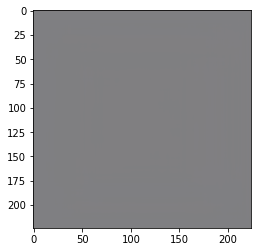

In [ ]:
for input, label in dataloaders["train_target"]:
    input.to("cpu")
    label.to("cpu")
    dsn.to("cpu")
    print(label)
    _, _, _, _, reconstructed_code = dsn(
        input,
        rec_code=ReconstructionCode.TARGET,
        rec_scheme=ReconstructionSheme.BOTH_SHARED_AND_PRIVATE,
    )
    rec_img_all = tr_image(reconstructed_code.data)
    # image reconstructions
    _, _, _, _, reconstructed_code = dsn(
        input,
        rec_code=ReconstructionCode.TARGET,
        rec_scheme=ReconstructionSheme.ONLY_SHARED_CODE,
    )
    rec_img_share = tr_image(reconstructed_code.data)

    plt.imshow(rec_img_share[0].permute(1, 2, 0))
    print(rec_img_share[0].permute(1, 2, 0))
    break

### Second attempt: AlexNet and ResNet18 backbone

#### AlexNet

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
net = AlexNetDSN(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "alexnet-dsn",
    net_name="alexnet",
    epochs=30,
    learning_rate=0.0001,
    step_decay_weight=0.95,
    lr_decay_step=200,
    active_domain_loss_step=-1,
    weight_decay=1e-6,
    alpha_weight=0,  # 0.5,
    beta_weight=0,  # 0.4,
    gamma_weight=0.1,
    momentum=0.9,
    batch_size=32,
    test_batch_size=32,
    technique=Technique.DSN,
    device=device,
    reverse_domains=True,
)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Adding key source_encoder.0.weight in current params
Adding key source_encoder.0.bias in current params
Adding key source_encoder.3.weight in current params
Adding key source_encoder.3.bias in current params
Adding key source_encoder.6.weight in current params
Adding key source_encoder.6.bias in current params
Adding key source_encoder.8.weight in current params
Adding key source_encoder.8.bias in current params
Adding key source_encoder.10.weight in current params
Adding key source_encoder.10.bias in current params
Adding key target_encoder.0.weight in current params
Adding key target_encoder.0.bias in current params
Adding key target_encoder.3.weight in current params
Adding key target_encoder.3.bias in current params
Adding key target_encoder.6.weight in current params
Adding key target_encoder.6.bias in current params
Adding key target_encoder.8.weight in current params
Adding key target_encoder.8.bias in current params
Adding key target_encoder.10.weight in current params
Adding k


Training: 0it [00:00, ?it/s]/home/lucademenego/.pyenv/versions/3.7.0/envs/colab/lib/python3.7/site-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "

Training: 1it [00:01,  1.46s/it]
Training: 2it [00:01,  1.25it/s]
Training: 3it [00:02,  1.07it/s]
Training: 4it [00:03,  1.42it/s]
Training: 5it [00:04,  1.30it/s]
Training: 6it [00:04,  1.62it/s]
Training: 7it [00:05,  1.50it/s]
Training: 8it [00:05,  1.80it/s]
Training: 9it [00:06,  1.71it/s]
Training: 10it [00:06,  1.97it/s]
Training: 11it [00:07,  1.85it/s]
Training: 12it [00:07,  2.10it/s]
Training: 13it [00:07


Epoch: 1
	 Training loss 0.05816, Training accuracy 46.88
	 Test loss 0.03052, Test accuracy 73.18
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.22s/it]
Training: 2it [00:01,  1.43it/s]
Training: 3it [00:02,  1.50it/s]
Training: 4it [00:02,  1.88it/s]
Training: 5it [00:03,  1.78it/s]
Training: 6it [00:03,  2.05it/s]
Training: 7it [00:04,  1.99it/s]
Training: 8it [00:04,  2.25it/s]
Training: 9it [00:04,  1.98it/s]
Training: 10it [00:05,  2.17it/s]
Training: 11it [00:05,  2.09it/s]
Training: 12it [00:06,  2.21it/s]
Training: 13it [00:06,  1.98it/s]
Training: 14it [00:07,  2.19it/s]
Training: 15it [00:07,  2.00it/s]
Training: 16it [00:08,  2.22it/s]
Training: 17it [00:08,  2.13it/s]
Training: 18it [00:09,  2.14it/s]
Training: 19it [00:09,  2.22it/s]
Training: 20it [00:09,  2.22it/s]
Training: 21it [00:10,  2.24it/s]
Training: 22it [00:10,  2.20it/s]
Training: 23it [00:11,  2.01it/s]
Training: 24it [00:11,  1.99it/s]
Training: 25it [00:12,  2.22it/s]
Training: 26it [00:12,  2.03it/s]
Training: 27it [00:13,  2.21it/s]
Training: 28it [00:13,  2.07it/s]
Training: 29it [00:14,  2.0


Epoch: 2
	 Training loss 0.01956, Training accuracy 83.06
	 Test loss 0.02482, Test accuracy 77.60
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.29s/it]
Training: 2it [00:01,  1.39it/s]
Training: 3it [00:02,  1.55it/s]
Training: 4it [00:02,  1.94it/s]
Training: 5it [00:03,  1.85it/s]
Training: 6it [00:03,  2.09it/s]
Training: 7it [00:03,  1.97it/s]
Training: 8it [00:04,  2.21it/s]
Training: 9it [00:05,  1.84it/s]
Training: 10it [00:05,  2.09it/s]
Training: 11it [00:06,  1.87it/s]
Training: 12it [00:06,  2.11it/s]
Training: 13it [00:06,  2.06it/s]
Training: 14it [00:07,  2.24it/s]
Training: 15it [00:07,  2.15it/s]
Training: 16it [00:08,  2.33it/s]
Training: 17it [00:08,  2.16it/s]
Training: 18it [00:09,  2.34it/s]
Training: 19it [00:09,  2.10it/s]
Training: 20it [00:09,  2.32it/s]
Training: 21it [00:10,  2.08it/s]
Training: 22it [00:10,  2.30it/s]
Training: 23it [00:11,  2.01it/s]
Training: 24it [00:11,  2.23it/s]
Training: 25it [00:12,  1.77it/s]
Training: 26it [00:13,  2.00it/s]
Training: 27it [00:13,  1.89it/s]
Training: 28it [00:13,  2.14it/s]
Training: 29it [00:14,  1.8


Epoch: 3
	 Training loss 0.01088, Training accuracy 94.06
	 Test loss 0.02778, Test accuracy 75.52
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.15s/it]
Training: 2it [00:01,  1.50it/s]
Training: 3it [00:02,  1.38it/s]
Training: 4it [00:02,  1.76it/s]
Training: 5it [00:03,  1.71it/s]
Training: 6it [00:03,  2.02it/s]
Training: 7it [00:04,  1.74it/s]
Training: 8it [00:04,  2.00it/s]
Training: 9it [00:05,  1.84it/s]
Training: 10it [00:05,  2.08it/s]
Training: 11it [00:06,  1.90it/s]
Training: 12it [00:06,  2.15it/s]
Training: 13it [00:07,  1.84it/s]
Training: 14it [00:07,  2.07it/s]
Training: 15it [00:08,  1.95it/s]
Training: 16it [00:08,  2.17it/s]
Training: 17it [00:09,  2.10it/s]
Training: 18it [00:09,  2.30it/s]
Training: 19it [00:09,  2.05it/s]
Training: 20it [00:10,  2.25it/s]
Training: 21it [00:10,  2.14it/s]
Training: 22it [00:11,  2.36it/s]
Training: 23it [00:11,  1.94it/s]
Training: 24it [00:12,  2.16it/s]
Training: 25it [00:12,  1.93it/s]
Training: 26it [00:13,  2.14it/s]
Training: 27it [00:13,  1.96it/s]
Training: 28it [00:14,  2.16it/s]
Training: 29it [00:14,  2.0


Epoch: 4
	 Training loss 0.00671, Training accuracy 96.06
	 Test loss 0.02444, Test accuracy 81.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.41s/it]
Training: 2it [00:01,  1.30it/s]
Training: 3it [00:02,  1.39it/s]
Training: 4it [00:02,  1.79it/s]
Training: 5it [00:03,  1.69it/s]
Training: 6it [00:03,  1.97it/s]
Training: 7it [00:04,  2.01it/s]
Training: 8it [00:04,  2.27it/s]
Training: 9it [00:05,  1.88it/s]
Training: 10it [00:05,  2.13it/s]
Training: 11it [00:06,  1.90it/s]
Training: 12it [00:06,  2.15it/s]
Training: 13it [00:07,  1.84it/s]
Training: 14it [00:07,  2.09it/s]
Training: 15it [00:08,  2.11it/s]
Training: 16it [00:08,  2.32it/s]
Training: 17it [00:09,  1.97it/s]
Training: 18it [00:09,  2.18it/s]
Training: 19it [00:10,  1.99it/s]
Training: 20it [00:10,  2.25it/s]
Training: 21it [00:10,  2.20it/s]
Training: 22it [00:11,  2.38it/s]
Training: 23it [00:11,  2.32it/s]
Training: 24it [00:12,  2.31it/s]
Training: 25it [00:12,  2.01it/s]
Training: 26it [00:13,  2.21it/s]
Training: 27it [00:13,  1.99it/s]
Training: 28it [00:13,  2.20it/s]
Training: 29it [00:14,  2.0


Epoch: 5
	 Training loss 0.00575, Training accuracy 98.94
	 Test loss 0.02051, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.26s/it]
Training: 2it [00:01,  1.42it/s]
Training: 3it [00:02,  1.33it/s]
Training: 4it [00:02,  1.70it/s]
Training: 5it [00:03,  1.77it/s]
Training: 6it [00:03,  2.08it/s]
Training: 7it [00:04,  1.90it/s]
Training: 8it [00:04,  2.16it/s]
Training: 9it [00:05,  1.86it/s]
Training: 10it [00:05,  2.07it/s]
Training: 11it [00:06,  1.86it/s]
Training: 12it [00:06,  2.08it/s]
Training: 13it [00:07,  1.70it/s]
Training: 14it [00:07,  1.92it/s]
Training: 15it [00:08,  1.75it/s]
Training: 16it [00:08,  1.96it/s]
Training: 17it [00:09,  1.87it/s]
Training: 18it [00:09,  2.09it/s]
Training: 19it [00:10,  1.75it/s]
Training: 20it [00:10,  1.97it/s]
Training: 21it [00:11,  1.56it/s]
Training: 22it [00:12,  1.81it/s]
Training: 23it [00:12,  1.73it/s]
Training: 24it [00:13,  1.98it/s]
Training: 25it [00:13,  1.74it/s]
Training: 26it [00:14,  1.98it/s]
Training: 27it [00:15,  1.68it/s]
Training: 28it [00:15,  1.91it/s]
Training: 29it [00:16,  1.6


Epoch: 6
	 Training loss 0.00591, Training accuracy 98.38
	 Test loss 0.04822, Test accuracy 63.28
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.23s/it]
Training: 2it [00:01,  1.44it/s]
Training: 3it [00:02,  1.39it/s]
Training: 4it [00:02,  1.75it/s]
Training: 5it [00:03,  1.75it/s]
Training: 6it [00:03,  2.06it/s]
Training: 7it [00:04,  1.82it/s]
Training: 8it [00:04,  2.07it/s]
Training: 9it [00:05,  2.02it/s]
Training: 10it [00:05,  2.23it/s]
Training: 11it [00:06,  1.99it/s]
Training: 12it [00:06,  2.20it/s]
Training: 13it [00:07,  1.69it/s]
Training: 14it [00:07,  1.94it/s]
Training: 15it [00:08,  1.83it/s]
Training: 16it [00:08,  2.06it/s]
Training: 17it [00:09,  2.08it/s]
Training: 18it [00:09,  2.29it/s]
Training: 19it [00:09,  2.07it/s]
Training: 20it [00:10,  2.31it/s]
Training: 21it [00:10,  2.03it/s]
Training: 22it [00:11,  2.25it/s]
Training: 23it [00:11,  2.10it/s]
Training: 24it [00:12,  2.29it/s]
Training: 25it [00:12,  2.03it/s]
Training: 26it [00:13,  2.23it/s]
Training: 27it [00:13,  2.03it/s]
Training: 28it [00:14,  2.28it/s]
Training: 29it [00:14,  2.0


Epoch: 7
	 Training loss 0.01198, Training accuracy 93.62
	 Test loss 0.02957, Test accuracy 77.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.21s/it]
Training: 2it [00:01,  1.46it/s]
Training: 3it [00:02,  1.51it/s]
Training: 4it [00:02,  1.88it/s]
Training: 5it [00:03,  1.85it/s]
Training: 6it [00:03,  2.12it/s]
Training: 7it [00:03,  2.00it/s]
Training: 8it [00:04,  2.19it/s]
Training: 9it [00:04,  2.00it/s]
Training: 10it [00:05,  2.14it/s]
Training: 11it [00:05,  2.10it/s]
Training: 12it [00:06,  2.05it/s]
Training: 13it [00:06,  2.24it/s]
Training: 14it [00:07,  2.11it/s]
Training: 15it [00:07,  2.31it/s]
Training: 16it [00:08,  1.99it/s]
Training: 17it [00:08,  2.20it/s]
Training: 18it [00:09,  1.81it/s]
Training: 19it [00:09,  2.03it/s]
Training: 20it [00:10,  2.00it/s]
Training: 21it [00:10,  2.18it/s]
Training: 22it [00:11,  2.05it/s]
Training: 23it [00:11,  2.28it/s]
Training: 24it [00:11,  2.10it/s]
Training: 25it [00:12,  2.28it/s]
Training: 26it [00:12,  2.24it/s]
Training: 27it [00:13,  2.36it/s]
Training: 28it [00:13,  2.10it/s]
Training: 29it [00:14,  2.1


Epoch: 8
	 Training loss 0.00658, Training accuracy 97.44
	 Test loss 0.02918, Test accuracy 79.43
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.27s/it]
Training: 2it [00:01,  1.39it/s]
Training: 3it [00:02,  1.37it/s]
Training: 4it [00:02,  1.75it/s]
Training: 5it [00:03,  1.76it/s]
Training: 6it [00:03,  2.04it/s]
Training: 7it [00:04,  1.95it/s]
Training: 8it [00:04,  2.19it/s]
Training: 9it [00:05,  1.95it/s]
Training: 10it [00:05,  2.18it/s]
Training: 11it [00:06,  1.74it/s]
Training: 12it [00:06,  1.97it/s]
Training: 13it [00:07,  1.85it/s]
Training: 14it [00:07,  2.12it/s]
Training: 15it [00:08,  1.84it/s]
Training: 16it [00:08,  2.08it/s]
Training: 17it [00:09,  1.84it/s]
Training: 18it [00:09,  2.10it/s]
Training: 19it [00:10,  1.90it/s]
Training: 20it [00:10,  2.13it/s]
Training: 21it [00:11,  2.08it/s]
Training: 22it [00:11,  2.29it/s]
Training: 23it [00:12,  1.96it/s]
Training: 24it [00:12,  2.21it/s]
Training: 25it [00:13,  1.96it/s]
Training: 26it [00:13,  2.17it/s]
Training: 27it [00:13,  2.05it/s]
Training: 28it [00:14,  2.26it/s]
Training: 29it [00:14,  1.9


Epoch: 9
	 Training loss 0.00628, Training accuracy 97.75
	 Test loss 0.02552, Test accuracy 83.07
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.45s/it]
Training: 2it [00:01,  1.28it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:02,  1.70it/s]
Training: 5it [00:03,  1.71it/s]
Training: 6it [00:03,  2.01it/s]
Training: 7it [00:04,  1.92it/s]
Training: 8it [00:04,  2.16it/s]
Training: 9it [00:05,  1.97it/s]
Training: 10it [00:05,  2.19it/s]
Training: 11it [00:06,  1.93it/s]
Training: 12it [00:06,  2.16it/s]
Training: 13it [00:07,  1.99it/s]
Training: 14it [00:07,  2.21it/s]
Training: 15it [00:08,  2.02it/s]
Training: 16it [00:08,  2.23it/s]
Training: 17it [00:09,  1.99it/s]
Training: 18it [00:09,  2.24it/s]
Training: 19it [00:10,  2.00it/s]
Training: 20it [00:10,  2.23it/s]
Training: 21it [00:10,  2.02it/s]
Training: 22it [00:11,  2.23it/s]
Training: 23it [00:11,  2.16it/s]
Training: 24it [00:12,  2.35it/s]
Training: 25it [00:12,  2.18it/s]
Training: 26it [00:12,  2.38it/s]
Training: 27it [00:13,  2.26it/s]
Training: 28it [00:13,  2.43it/s]
Training: 29it [00:14,  2.1


Epoch: 10
	 Training loss 0.00458, Training accuracy 98.94
	 Test loss 0.03365, Test accuracy 80.99
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.47s/it]
Training: 2it [00:01,  1.27it/s]
Training: 3it [00:02,  1.41it/s]
Training: 4it [00:02,  1.82it/s]
Training: 5it [00:03,  1.66it/s]
Training: 6it [00:03,  1.96it/s]
Training: 7it [00:04,  1.81it/s]
Training: 8it [00:04,  2.07it/s]
Training: 9it [00:05,  1.77it/s]
Training: 10it [00:05,  2.03it/s]
Training: 11it [00:06,  1.97it/s]
Training: 12it [00:06,  2.18it/s]
Training: 13it [00:07,  2.06it/s]
Training: 14it [00:07,  2.31it/s]
Training: 15it [00:08,  1.92it/s]
Training: 16it [00:08,  2.17it/s]
Training: 17it [00:09,  1.82it/s]
Training: 18it [00:09,  2.06it/s]
Training: 19it [00:10,  1.88it/s]
Training: 20it [00:10,  2.12it/s]
Training: 21it [00:11,  1.93it/s]
Training: 22it [00:11,  2.19it/s]
Training: 23it [00:12,  2.01it/s]
Training: 24it [00:12,  2.26it/s]
Training: 25it [00:12,  2.18it/s]
Training: 26it [00:13,  2.36it/s]
Training: 27it [00:13,  2.23it/s]
Training: 28it [00:14,  2.38it/s]
Training: 29it [00:14,  1.9


Epoch: 11
	 Training loss 0.00842, Training accuracy 96.88
	 Test loss 0.04253, Test accuracy 72.66
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.28s/it]
Training: 2it [00:01,  1.39it/s]
Training: 3it [00:02,  1.29it/s]
Training: 4it [00:02,  1.65it/s]
Training: 5it [00:03,  1.66it/s]
Training: 6it [00:03,  1.98it/s]
Training: 7it [00:04,  1.79it/s]
Training: 8it [00:04,  2.02it/s]
Training: 9it [00:05,  1.93it/s]
Training: 10it [00:05,  2.15it/s]
Training: 11it [00:06,  2.00it/s]
Training: 12it [00:06,  2.23it/s]
Training: 13it [00:07,  1.90it/s]
Training: 14it [00:07,  2.16it/s]
Training: 15it [00:08,  2.12it/s]
Training: 16it [00:08,  2.32it/s]
Training: 17it [00:09,  2.07it/s]
Training: 18it [00:09,  2.29it/s]
Training: 19it [00:10,  1.94it/s]
Training: 20it [00:10,  2.15it/s]
Training: 21it [00:10,  1.97it/s]
Training: 22it [00:11,  2.19it/s]
Training: 23it [00:11,  1.96it/s]
Training: 24it [00:12,  2.18it/s]
Training: 25it [00:12,  2.12it/s]
Training: 26it [00:13,  2.34it/s]
Training: 27it [00:13,  2.00it/s]
Training: 28it [00:14,  2.22it/s]
Training: 29it [00:14,  2.1


Epoch: 12
	 Training loss 0.00854, Training accuracy 95.38
	 Test loss 0.02786, Test accuracy 78.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.22s/it]
Training: 2it [00:01,  1.45it/s]
Training: 3it [00:02,  1.49it/s]
Training: 4it [00:02,  1.87it/s]
Training: 5it [00:03,  1.68it/s]
Training: 6it [00:03,  2.00it/s]
Training: 7it [00:04,  1.77it/s]
Training: 8it [00:04,  2.03it/s]
Training: 9it [00:05,  2.10it/s]
Training: 10it [00:05,  2.18it/s]
Training: 11it [00:05,  2.06it/s]
Training: 12it [00:06,  2.14it/s]
Training: 13it [00:06,  2.04it/s]
Training: 14it [00:07,  2.05it/s]
Training: 15it [00:07,  2.11it/s]
Training: 16it [00:08,  2.05it/s]
Training: 17it [00:08,  2.24it/s]
Training: 18it [00:09,  2.00it/s]
Training: 19it [00:09,  2.20it/s]
Training: 20it [00:10,  1.82it/s]
Training: 21it [00:10,  2.06it/s]
Training: 22it [00:11,  1.91it/s]
Training: 23it [00:11,  2.13it/s]
Training: 24it [00:12,  1.95it/s]
Training: 25it [00:12,  2.16it/s]
Training: 26it [00:13,  1.96it/s]
Training: 27it [00:13,  2.19it/s]
Training: 28it [00:14,  1.82it/s]
Training: 29it [00:14,  2.0


Epoch: 13
	 Training loss 0.00465, Training accuracy 99.38
	 Test loss 0.02756, Test accuracy 81.51
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.23s/it]
Training: 2it [00:01,  1.44it/s]
Training: 3it [00:02,  1.46it/s]
Training: 4it [00:02,  1.85it/s]
Training: 5it [00:03,  1.74it/s]
Training: 6it [00:03,  2.04it/s]
Training: 7it [00:04,  1.61it/s]
Training: 8it [00:04,  1.88it/s]
Training: 9it [00:05,  1.72it/s]
Training: 10it [00:05,  1.99it/s]
Training: 11it [00:06,  1.88it/s]
Training: 12it [00:06,  2.12it/s]
Training: 13it [00:07,  1.84it/s]
Training: 14it [00:07,  2.10it/s]
Training: 15it [00:08,  2.04it/s]
Training: 16it [00:08,  2.26it/s]
Training: 17it [00:09,  2.16it/s]
Training: 18it [00:09,  2.34it/s]
Training: 19it [00:09,  2.20it/s]
Training: 20it [00:10,  2.37it/s]
Training: 21it [00:10,  2.21it/s]
Training: 22it [00:11,  2.40it/s]
Training: 23it [00:11,  2.03it/s]
Training: 24it [00:12,  2.24it/s]
Training: 25it [00:12,  1.99it/s]
Training: 26it [00:13,  2.22it/s]
Training: 27it [00:13,  1.96it/s]
Training: 28it [00:14,  2.18it/s]
Training: 29it [00:14,  1.9


Epoch: 14
	 Training loss 0.00487, Training accuracy 99.12
	 Test loss 0.03746, Test accuracy 78.39
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.45s/it]
Training: 2it [00:01,  1.26it/s]
Training: 3it [00:02,  1.33it/s]
Training: 4it [00:02,  1.71it/s]
Training: 5it [00:03,  1.77it/s]
Training: 6it [00:03,  2.08it/s]
Training: 7it [00:04,  1.93it/s]
Training: 8it [00:04,  2.16it/s]
Training: 9it [00:05,  1.99it/s]
Training: 10it [00:05,  2.23it/s]
Training: 11it [00:06,  1.89it/s]
Training: 12it [00:06,  2.10it/s]
Training: 13it [00:07,  2.05it/s]
Training: 14it [00:07,  2.29it/s]
Training: 15it [00:08,  1.86it/s]
Training: 16it [00:08,  2.11it/s]
Training: 17it [00:09,  1.81it/s]
Training: 18it [00:09,  2.04it/s]
Training: 19it [00:10,  1.93it/s]
Training: 20it [00:10,  2.15it/s]
Training: 21it [00:11,  1.99it/s]
Training: 22it [00:11,  2.21it/s]
Training: 23it [00:12,  2.03it/s]
Training: 24it [00:12,  2.24it/s]
Training: 25it [00:12,  2.12it/s]
Training: 26it [00:13,  2.32it/s]
Training: 27it [00:14,  1.81it/s]
Training: 28it [00:14,  2.06it/s]
Training: 29it [00:14,  1.9


Epoch: 15
	 Training loss 0.00578, Training accuracy 98.69
	 Test loss 0.02734, Test accuracy 80.99
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.25s/it]
Training: 2it [00:01,  1.40it/s]
Training: 3it [00:02,  1.41it/s]
Training: 4it [00:02,  1.81it/s]
Training: 5it [00:03,  1.78it/s]
Training: 6it [00:03,  1.82it/s]
Training: 7it [00:04,  1.83it/s]
Training: 8it [00:04,  2.05it/s]
Training: 9it [00:05,  1.95it/s]
Training: 10it [00:05,  2.17it/s]
Training: 11it [00:05,  2.21it/s]
Training: 12it [00:06,  2.17it/s]
Training: 13it [00:06,  2.24it/s]
Training: 14it [00:07,  2.16it/s]
Training: 15it [00:07,  2.14it/s]
Training: 16it [00:08,  2.18it/s]
Training: 17it [00:08,  2.27it/s]
Training: 18it [00:09,  2.37it/s]
Training: 19it [00:09,  2.22it/s]
Training: 20it [00:09,  2.26it/s]
Training: 21it [00:10,  2.10it/s]
Training: 22it [00:10,  2.18it/s]
Training: 23it [00:11,  2.13it/s]
Training: 24it [00:12,  1.95it/s]
Training: 25it [00:12,  2.17it/s]
Training: 26it [00:12,  2.04it/s]
Training: 27it [00:13,  2.24it/s]
Training: 28it [00:13,  2.08it/s]
Training: 29it [00:14,  2.2


Epoch: 16
	 Training loss 0.00518, Training accuracy 98.50
	 Test loss 0.03095, Test accuracy 80.73
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.21s/it]
Training: 2it [00:01,  1.42it/s]
Training: 3it [00:02,  1.15it/s]
Training: 4it [00:02,  1.50it/s]
Training: 5it [00:04,  1.24it/s]
Training: 6it [00:04,  1.53it/s]
Training: 7it [00:05,  1.32it/s]
Training: 8it [00:05,  1.59it/s]
Training: 9it [00:06,  1.52it/s]
Training: 10it [00:06,  1.78it/s]
Training: 11it [00:07,  1.70it/s]
Training: 12it [00:07,  1.96it/s]
Training: 13it [00:08,  1.86it/s]
Training: 14it [00:08,  2.09it/s]
Training: 15it [00:09,  1.54it/s]
Training: 16it [00:10,  1.82it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:10,  2.07it/s]
Training: 19it [00:11,  1.91it/s]
Training: 20it [00:11,  2.18it/s]
Training: 21it [00:12,  2.01it/s]
Training: 22it [00:12,  2.22it/s]
Training: 23it [00:13,  2.06it/s]
Training: 24it [00:13,  2.29it/s]
Training: 25it [00:14,  2.05it/s]
Training: 26it [00:14,  2.29it/s]
Training: 27it [00:15,  2.10it/s]
Training: 28it [00:15,  2.34it/s]
Training: 29it [00:16,  2.0


Epoch: 17
	 Training loss 0.00519, Training accuracy 98.81
	 Test loss 0.03334, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.19s/it]
Training: 2it [00:01,  1.45it/s]
Training: 3it [00:02,  1.66it/s]
Training: 4it [00:02,  1.99it/s]
Training: 5it [00:02,  1.89it/s]
Training: 6it [00:03,  2.20it/s]
Training: 7it [00:03,  2.04it/s]
Training: 8it [00:04,  2.27it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:05,  1.99it/s]
Training: 11it [00:05,  1.94it/s]
Training: 12it [00:06,  2.18it/s]
Training: 13it [00:06,  2.13it/s]
Training: 14it [00:07,  1.94it/s]
Training: 15it [00:07,  2.17it/s]
Training: 16it [00:08,  1.97it/s]
Training: 17it [00:08,  2.11it/s]
Training: 18it [00:09,  2.10it/s]
Training: 19it [00:09,  2.31it/s]
Training: 20it [00:10,  2.15it/s]
Training: 21it [00:10,  2.22it/s]
Training: 22it [00:11,  2.05it/s]
Training: 23it [00:11,  2.25it/s]
Training: 24it [00:11,  2.07it/s]
Training: 25it [00:12,  2.26it/s]
Training: 26it [00:12,  2.08it/s]
Training: 27it [00:13,  2.21it/s]
Training: 28it [00:13,  2.12it/s]
Training: 29it [00:14,  2.2


Epoch: 18
	 Training loss 0.00462, Training accuracy 99.44
	 Test loss 0.04152, Test accuracy 75.00
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.34s/it]
Training: 2it [00:01,  1.33it/s]
Training: 3it [00:02,  1.36it/s]
Training: 4it [00:02,  1.74it/s]
Training: 5it [00:03,  1.67it/s]
Training: 6it [00:03,  1.98it/s]
Training: 7it [00:04,  1.89it/s]
Training: 8it [00:04,  2.13it/s]
Training: 9it [00:05,  1.94it/s]
Training: 10it [00:05,  2.16it/s]
Training: 11it [00:06,  2.03it/s]
Training: 12it [00:06,  2.25it/s]
Training: 13it [00:07,  1.85it/s]
Training: 14it [00:07,  2.06it/s]
Training: 15it [00:08,  1.88it/s]
Training: 16it [00:08,  2.13it/s]
Training: 17it [00:09,  1.82it/s]
Training: 18it [00:09,  2.08it/s]
Training: 19it [00:10,  1.87it/s]
Training: 20it [00:10,  2.08it/s]
Training: 21it [00:11,  2.04it/s]
Training: 22it [00:11,  2.25it/s]
Training: 23it [00:12,  2.00it/s]
Training: 24it [00:12,  2.23it/s]
Training: 25it [00:13,  1.94it/s]
Training: 26it [00:13,  2.16it/s]
Training: 27it [00:14,  1.99it/s]
Training: 28it [00:14,  2.21it/s]
Training: 29it [00:14,  1.9


Epoch: 19
	 Training loss 0.00555, Training accuracy 98.50
	 Test loss 0.03765, Test accuracy 77.08
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.09s/it]
Training: 2it [00:01,  1.58it/s]
Training: 3it [00:01,  1.66it/s]
Training: 4it [00:02,  1.94it/s]
Training: 5it [00:03,  1.73it/s]
Training: 6it [00:03,  2.01it/s]
Training: 7it [00:04,  1.82it/s]
Training: 8it [00:04,  2.08it/s]
Training: 9it [00:04,  1.91it/s]
Training: 10it [00:05,  2.18it/s]
Training: 11it [00:05,  2.02it/s]
Training: 12it [00:06,  2.24it/s]
Training: 13it [00:06,  1.98it/s]
Training: 14it [00:07,  2.23it/s]
Training: 15it [00:07,  2.05it/s]
Training: 16it [00:08,  2.26it/s]
Training: 17it [00:08,  1.88it/s]
Training: 18it [00:09,  2.12it/s]
Training: 19it [00:09,  2.02it/s]
Training: 20it [00:10,  2.07it/s]
Training: 21it [00:10,  2.09it/s]
Training: 22it [00:11,  2.02it/s]
Training: 23it [00:11,  2.07it/s]
Training: 24it [00:12,  1.99it/s]
Training: 25it [00:12,  2.06it/s]
Training: 26it [00:13,  1.99it/s]
Training: 27it [00:13,  2.21it/s]
Training: 28it [00:14,  2.10it/s]
Training: 29it [00:14,  2.2


Epoch: 20
	 Training loss 0.00521, Training accuracy 99.19
	 Test loss 0.04228, Test accuracy 75.78
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.16s/it]
Training: 2it [00:01,  1.48it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:02,  1.71it/s]
Training: 5it [00:03,  1.75it/s]
Training: 6it [00:03,  2.03it/s]
Training: 7it [00:04,  1.98it/s]
Training: 8it [00:04,  2.21it/s]
Training: 9it [00:05,  2.03it/s]
Training: 10it [00:05,  2.28it/s]
Training: 11it [00:06,  1.92it/s]
Training: 12it [00:06,  2.19it/s]
Training: 13it [00:07,  1.90it/s]
Training: 14it [00:07,  2.16it/s]
Training: 15it [00:07,  1.92it/s]
Training: 16it [00:08,  2.14it/s]
Training: 17it [00:08,  2.06it/s]
Training: 18it [00:09,  2.28it/s]
Training: 19it [00:09,  2.12it/s]
Training: 20it [00:10,  2.34it/s]
Training: 21it [00:10,  1.98it/s]
Training: 22it [00:11,  2.19it/s]
Training: 23it [00:11,  2.04it/s]
Training: 24it [00:12,  2.26it/s]
Training: 25it [00:12,  2.10it/s]
Training: 26it [00:12,  2.30it/s]
Training: 27it [00:13,  2.03it/s]
Training: 28it [00:13,  2.23it/s]
Training: 29it [00:14,  2.2


Epoch: 21
	 Training loss 0.00450, Training accuracy 99.44
	 Test loss 0.04612, Test accuracy 77.34
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.30s/it]
Training: 2it [00:01,  1.35it/s]
Training: 3it [00:02,  1.51it/s]
Training: 4it [00:02,  1.88it/s]
Training: 5it [00:03,  1.82it/s]
Training: 6it [00:03,  2.08it/s]
Training: 7it [00:04,  1.88it/s]
Training: 8it [00:04,  2.17it/s]
Training: 9it [00:05,  1.88it/s]
Training: 10it [00:05,  2.13it/s]
Training: 11it [00:06,  1.91it/s]
Training: 12it [00:06,  2.12it/s]
Training: 13it [00:07,  1.92it/s]
Training: 14it [00:07,  2.18it/s]
Training: 15it [00:08,  1.88it/s]
Training: 16it [00:08,  2.12it/s]
Training: 17it [00:09,  1.87it/s]
Training: 18it [00:09,  2.14it/s]
Training: 19it [00:10,  1.86it/s]
Training: 20it [00:10,  2.10it/s]
Training: 21it [00:11,  1.88it/s]
Training: 22it [00:11,  2.13it/s]
Training: 23it [00:12,  1.84it/s]
Training: 24it [00:12,  2.09it/s]
Training: 25it [00:13,  1.88it/s]
Training: 26it [00:13,  2.14it/s]
Training: 27it [00:14,  1.94it/s]
Training: 28it [00:14,  2.17it/s]
Training: 29it [00:15,  1.9


Epoch: 22
	 Training loss 0.00559, Training accuracy 98.06
	 Test loss 0.03320, Test accuracy 76.56
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.37s/it]
Training: 2it [00:01,  1.32it/s]
Training: 3it [00:02,  1.55it/s]
Training: 4it [00:02,  1.89it/s]
Training: 5it [00:03,  1.89it/s]
Training: 6it [00:03,  2.14it/s]
Training: 7it [00:04,  1.90it/s]
Training: 8it [00:04,  2.11it/s]
Training: 9it [00:04,  2.10it/s]
Training: 10it [00:05,  2.29it/s]
Training: 11it [00:05,  2.03it/s]
Training: 12it [00:06,  2.24it/s]
Training: 13it [00:06,  1.87it/s]
Training: 14it [00:07,  2.11it/s]
Training: 15it [00:07,  1.88it/s]
Training: 16it [00:08,  2.12it/s]
Training: 17it [00:08,  2.04it/s]
Training: 18it [00:09,  2.25it/s]
Training: 19it [00:09,  1.98it/s]
Training: 20it [00:10,  2.17it/s]
Training: 21it [00:10,  2.02it/s]
Training: 22it [00:11,  2.23it/s]
Training: 23it [00:11,  2.12it/s]
Training: 24it [00:11,  2.33it/s]
Training: 25it [00:12,  1.92it/s]
Training: 26it [00:13,  2.13it/s]
Training: 27it [00:13,  2.08it/s]
Training: 28it [00:13,  2.27it/s]
Training: 29it [00:14,  2.0


Epoch: 23
	 Training loss 0.00521, Training accuracy 98.69
	 Test loss 0.03207, Test accuracy 78.65
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.20s/it]
Training: 2it [00:01,  1.45it/s]
Training: 3it [00:02,  1.47it/s]
Training: 4it [00:02,  1.79it/s]
Training: 5it [00:03,  1.47it/s]
Training: 6it [00:03,  1.74it/s]
Training: 7it [00:04,  1.72it/s]
Training: 8it [00:04,  2.01it/s]
Training: 9it [00:05,  1.99it/s]
Training: 10it [00:05,  2.25it/s]
Training: 11it [00:06,  2.06it/s]
Training: 12it [00:06,  2.30it/s]
Training: 13it [00:07,  2.00it/s]
Training: 14it [00:07,  2.21it/s]
Training: 15it [00:08,  1.81it/s]
Training: 16it [00:08,  2.04it/s]
Training: 17it [00:09,  1.68it/s]
Training: 18it [00:09,  1.94it/s]
Training: 19it [00:10,  1.50it/s]
Training: 20it [00:11,  1.72it/s]
Training: 21it [00:11,  1.64it/s]
Training: 22it [00:12,  1.92it/s]
Training: 23it [00:12,  1.74it/s]
Training: 24it [00:13,  1.95it/s]
Training: 25it [00:13,  1.81it/s]
Training: 26it [00:14,  2.06it/s]
Training: 27it [00:14,  2.11it/s]
Training: 28it [00:14,  2.29it/s]
Training: 29it [00:15,  2.1


Epoch: 24
	 Training loss 0.00525, Training accuracy 98.62
	 Test loss 0.02954, Test accuracy 78.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.25s/it]
Training: 2it [00:01,  1.40it/s]
Training: 3it [00:02,  1.59it/s]
Training: 4it [00:02,  1.97it/s]
Training: 5it [00:03,  1.73it/s]
Training: 6it [00:03,  2.02it/s]
Training: 7it [00:04,  1.85it/s]
Training: 8it [00:04,  2.10it/s]
Training: 9it [00:05,  1.81it/s]
Training: 10it [00:05,  2.02it/s]
Training: 11it [00:06,  1.86it/s]
Training: 12it [00:06,  2.10it/s]
Training: 13it [00:07,  1.76it/s]
Training: 14it [00:07,  1.97it/s]
Training: 15it [00:08,  1.66it/s]
Training: 16it [00:08,  1.91it/s]
Training: 17it [00:09,  1.83it/s]
Training: 18it [00:09,  2.03it/s]
Training: 19it [00:10,  1.53it/s]
Training: 20it [00:11,  1.76it/s]
Training: 21it [00:11,  1.56it/s]
Training: 22it [00:12,  1.81it/s]
Training: 23it [00:13,  1.51it/s]
Training: 24it [00:13,  1.74it/s]
Training: 25it [00:14,  1.67it/s]
Training: 26it [00:14,  1.88it/s]
Training: 27it [00:15,  1.76it/s]
Training: 28it [00:15,  1.98it/s]
Training: 29it [00:16,  1.7


Epoch: 25
	 Training loss 0.00436, Training accuracy 99.50
	 Test loss 0.03032, Test accuracy 77.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.19s/it]
Training: 2it [00:01,  1.44it/s]
Training: 3it [00:02,  1.49it/s]
Training: 4it [00:02,  1.90it/s]
Training: 5it [00:02,  1.93it/s]
Training: 6it [00:03,  2.23it/s]
Training: 7it [00:03,  2.13it/s]
Training: 8it [00:04,  2.38it/s]
Training: 9it [00:04,  2.24it/s]
Training: 10it [00:05,  2.29it/s]
Training: 11it [00:05,  2.23it/s]
Training: 12it [00:05,  2.37it/s]
Training: 13it [00:06,  2.21it/s]
Training: 14it [00:06,  2.38it/s]
Training: 15it [00:07,  2.22it/s]
Training: 16it [00:07,  2.20it/s]
Training: 17it [00:08,  2.12it/s]
Training: 18it [00:08,  2.29it/s]
Training: 19it [00:09,  2.07it/s]
Training: 20it [00:09,  2.27it/s]
Training: 21it [00:10,  2.04it/s]
Training: 22it [00:10,  2.25it/s]
Training: 23it [00:11,  2.05it/s]
Training: 24it [00:11,  2.22it/s]
Training: 25it [00:11,  2.14it/s]
Training: 26it [00:12,  1.85it/s]
Training: 27it [00:13,  1.93it/s]
Training: 28it [00:13,  1.85it/s]
Training: 29it [00:14,  1.7


Epoch: 26
	 Training loss 0.00458, Training accuracy 99.38
	 Test loss 0.03456, Test accuracy 76.04
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.16s/it]
Training: 2it [00:01,  1.50it/s]
Training: 3it [00:02,  1.39it/s]
Training: 4it [00:02,  1.74it/s]
Training: 5it [00:03,  1.62it/s]
Training: 6it [00:03,  1.94it/s]
Training: 7it [00:04,  1.75it/s]
Training: 8it [00:04,  1.99it/s]
Training: 9it [00:05,  1.88it/s]
Training: 10it [00:05,  2.13it/s]
Training: 11it [00:06,  1.59it/s]
Training: 12it [00:06,  1.84it/s]
Training: 13it [00:07,  1.85it/s]
Training: 14it [00:07,  2.12it/s]
Training: 15it [00:08,  1.86it/s]
Training: 16it [00:08,  2.07it/s]
Training: 17it [00:09,  1.94it/s]
Training: 18it [00:09,  2.19it/s]
Training: 19it [00:10,  1.92it/s]
Training: 20it [00:10,  2.13it/s]
Training: 21it [00:11,  1.89it/s]
Training: 22it [00:11,  2.10it/s]
Training: 23it [00:12,  1.78it/s]
Training: 24it [00:12,  2.00it/s]
Training: 25it [00:13,  1.78it/s]
Training: 26it [00:13,  1.97it/s]
Training: 27it [00:14,  1.52it/s]
Training: 28it [00:15,  1.76it/s]
Training: 29it [00:16,  1.6


Epoch: 27
	 Training loss 0.00464, Training accuracy 99.44
	 Test loss 0.03156, Test accuracy 80.47
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.14s/it]
Training: 2it [00:01,  1.53it/s]
Training: 3it [00:02,  1.60it/s]
Training: 4it [00:02,  1.94it/s]
Training: 5it [00:02,  1.94it/s]
Training: 6it [00:03,  2.16it/s]
Training: 7it [00:03,  2.11it/s]
Training: 8it [00:04,  2.05it/s]
Training: 9it [00:04,  2.29it/s]
Training: 10it [00:05,  2.25it/s]
Training: 11it [00:05,  2.30it/s]
Training: 12it [00:05,  2.22it/s]
Training: 13it [00:06,  2.24it/s]
Training: 14it [00:06,  2.20it/s]
Training: 15it [00:07,  2.41it/s]
Training: 16it [00:07,  2.21it/s]
Training: 17it [00:08,  2.42it/s]
Training: 18it [00:08,  2.10it/s]
Training: 19it [00:09,  2.33it/s]
Training: 20it [00:09,  1.99it/s]
Training: 21it [00:10,  2.23it/s]
Training: 22it [00:10,  2.12it/s]
Training: 23it [00:10,  2.35it/s]
Training: 24it [00:11,  2.21it/s]
Training: 25it [00:11,  2.42it/s]
Training: 26it [00:12,  2.24it/s]
Training: 27it [00:12,  2.45it/s]
Training: 28it [00:13,  2.25it/s]
Training: 29it [00:13,  2.4


Epoch: 28
	 Training loss 0.00421, Training accuracy 99.75
	 Test loss 0.02886, Test accuracy 82.81
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.27s/it]
Training: 2it [00:01,  1.39it/s]
Training: 3it [00:02,  1.36it/s]
Training: 4it [00:02,  1.72it/s]
Training: 5it [00:03,  1.65it/s]
Training: 6it [00:03,  1.95it/s]
Training: 7it [00:04,  1.77it/s]
Training: 8it [00:04,  2.05it/s]
Training: 9it [00:05,  2.03it/s]
Training: 10it [00:05,  2.28it/s]
Training: 11it [00:06,  1.96it/s]
Training: 12it [00:06,  2.22it/s]
Training: 13it [00:07,  2.13it/s]
Training: 14it [00:07,  2.31it/s]
Training: 15it [00:07,  2.26it/s]
Training: 16it [00:08,  2.45it/s]
Training: 17it [00:08,  2.16it/s]
Training: 18it [00:09,  2.34it/s]
Training: 19it [00:09,  2.03it/s]
Training: 20it [00:10,  2.15it/s]
Training: 21it [00:10,  1.97it/s]
Training: 22it [00:11,  2.14it/s]
Training: 23it [00:11,  1.89it/s]
Training: 24it [00:12,  2.10it/s]
Training: 25it [00:12,  2.01it/s]
Training: 26it [00:13,  2.21it/s]
Training: 27it [00:13,  1.97it/s]
Training: 28it [00:14,  2.18it/s]
Training: 29it [00:14,  1.9


Epoch: 29
	 Training loss 0.00465, Training accuracy 99.44
	 Test loss 0.03074, Test accuracy 79.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.35s/it]
Training: 2it [00:01,  1.31it/s]
Training: 3it [00:02,  1.58it/s]
Training: 4it [00:02,  1.70it/s]
Training: 5it [00:03,  1.89it/s]
Training: 6it [00:03,  1.87it/s]
Training: 7it [00:04,  2.00it/s]
Training: 8it [00:04,  2.12it/s]
Training: 9it [00:05,  2.05it/s]
Training: 10it [00:05,  2.26it/s]
Training: 11it [00:05,  2.03it/s]
Training: 12it [00:06,  2.22it/s]
Training: 13it [00:07,  1.94it/s]
Training: 14it [00:07,  2.16it/s]
Training: 15it [00:08,  1.88it/s]
Training: 16it [00:08,  2.13it/s]
Training: 17it [00:09,  1.87it/s]
Training: 18it [00:09,  2.02it/s]
Training: 19it [00:09,  2.05it/s]
Training: 20it [00:10,  2.08it/s]
Training: 21it [00:10,  2.19it/s]
Training: 22it [00:11,  2.11it/s]
Training: 23it [00:11,  2.26it/s]
Training: 24it [00:12,  2.07it/s]
Training: 25it [00:12,  2.29it/s]
Training: 26it [00:13,  2.05it/s]
Training: 27it [00:13,  2.13it/s]
Training: 28it [00:14,  2.07it/s]
Training: 29it [00:14,  2.2


Epoch: 30
	 Training loss 0.00534, Training accuracy 98.81
	 Test loss 0.03373, Test accuracy 77.34
-----------------------------------------------------
#> After training:



Training: 50it [00:21,  2.33it/s]
Validation: 12it [00:06,  1.82it/s]
Test: 12it [00:03,  3.56it/s]


	 Training loss 0.00130, Training accuracy 98.62
	 Validation loss 0.06174, Validation accuracy 66.15
	 [Current] Test loss 0.03469, Test accuracy 76.30
#> Resume best


Test: 12it [00:03,  3.43it/s]


	 [Best] Test loss 0.02015, Test accuracy 84.11
-----------------------------------------------------


In [ ]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-dsn"
!cp -r "/content/alexnet-dsn" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/alexnet-dsn"

#### ResNet18

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

wandb: Currently logged in as: lucademenego99 (deep-learning-project). Use `wandb login --relogin` to force relogin


In [ ]:
net = ResNet18DSN(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "resnet18-dsn",
    net_name="resnet",
    epochs=30,
    learning_rate=0.00001,
    step_decay_weight=0.95,
    lr_decay_step=200,
    active_domain_loss_step=-1,
    weight_decay=1e-6,
    alpha_weight=0.15,  # 0.5,
    beta_weight=0.1,  # 0.4,
    gamma_weight=1,
    momentum=0.9,
    batch_size=32,
    test_batch_size=32,
    technique=Technique.DSN,
    device=device,
    reverse_domains=True,
)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DSN



Training: 0it [00:00, ?it/s]/home/lucademenego/.pyenv/versions/3.7.0/envs/colab/lib/python3.7/site-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "

Training: 1it [00:01,  1.80s/it]
Training: 2it [00:02,  1.05s/it]
Training: 3it [00:02,  1.22it/s]
Training: 4it [00:03,  1.37it/s]
Training: 5it [00:04,  1.50it/s]
Training: 6it [00:04,  1.55it/s]
Training: 7it [00:05,  1.58it/s]
Training: 8it [00:05,  1.62it/s]
Training: 9it [00:06,  1.62it/s]
Training: 10it [00:07,  1.62it/s]
Training: 11it [00:07,  1.63it/s]
Training: 12it [00:08,  1.66it/s]
Training: 13it [00:08


Epoch: 1
	 Training loss 0.14620, Training accuracy 7.00
	 Test loss 0.08976, Test accuracy 13.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.90s/it]
Training: 2it [00:02,  1.11s/it]
Training: 3it [00:03,  1.13it/s]
Training: 4it [00:03,  1.33it/s]
Training: 5it [00:04,  1.43it/s]
Training: 6it [00:04,  1.52it/s]
Training: 7it [00:05,  1.55it/s]
Training: 8it [00:06,  1.60it/s]
Training: 9it [00:06,  1.65it/s]
Training: 10it [00:07,  1.69it/s]
Training: 11it [00:07,  1.70it/s]
Training: 12it [00:08,  1.71it/s]
Training: 13it [00:08,  1.69it/s]
Training: 14it [00:09,  1.71it/s]
Training: 15it [00:10,  1.71it/s]
Training: 16it [00:10,  1.73it/s]
Training: 17it [00:11,  1.73it/s]
Training: 18it [00:11,  1.74it/s]
Training: 19it [00:12,  1.75it/s]
Training: 20it [00:12,  1.76it/s]
Training: 21it [00:13,  1.74it/s]
Training: 22it [00:14,  1.75it/s]
Training: 23it [00:14,  1.74it/s]
Training: 24it [00:15,  1.73it/s]
Training: 25it [00:15,  1.71it/s]
Training: 26it [00:16,  1.70it/s]
Training: 27it [00:16,  1.72it/s]
Training: 28it [00:17,  1.73it/s]
Training: 29it [00:18,  1.7


Epoch: 2
	 Training loss 0.14081, Training accuracy 11.81
	 Test loss 0.08543, Test accuracy 25.78
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.49s/it]
Training: 2it [00:02,  1.06it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.47it/s]
Training: 5it [00:03,  1.58it/s]
Training: 6it [00:04,  1.66it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.80it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.82it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:10,  1.82it/s]
Training: 19it [00:11,  1.81it/s]
Training: 20it [00:12,  1.82it/s]
Training: 21it [00:12,  1.83it/s]
Training: 22it [00:13,  1.84it/s]
Training: 23it [00:13,  1.81it/s]
Training: 24it [00:14,  1.82it/s]
Training: 25it [00:14,  1.82it/s]
Training: 26it [00:15,  1.83it/s]
Training: 27it [00:15,  1.82it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:16,  1.8


Epoch: 3
	 Training loss 0.13658, Training accuracy 19.25
	 Test loss 0.08118, Test accuracy 34.90
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.71s/it]
Training: 2it [00:02,  1.02s/it]
Training: 3it [00:02,  1.24it/s]
Training: 4it [00:03,  1.42it/s]
Training: 5it [00:03,  1.53it/s]
Training: 6it [00:04,  1.61it/s]
Training: 7it [00:05,  1.64it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:06,  1.72it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.78it/s]
Training: 12it [00:07,  1.80it/s]
Training: 13it [00:08,  1.80it/s]
Training: 14it [00:08,  1.80it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.81it/s]
Training: 17it [00:10,  1.82it/s]
Training: 18it [00:11,  1.83it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.81it/s]
Training: 21it [00:12,  1.81it/s]
Training: 22it [00:13,  1.82it/s]
Training: 23it [00:13,  1.82it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.82it/s]
Training: 27it [00:16,  1.83it/s]
Training: 28it [00:16,  1.83it/s]
Training: 29it [00:17,  1.8


Epoch: 4
	 Training loss 0.13245, Training accuracy 28.88
	 Test loss 0.07632, Test accuracy 40.62
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.47s/it]
Training: 2it [00:02,  1.07it/s]
Training: 3it [00:02,  1.28it/s]
Training: 4it [00:03,  1.46it/s]
Training: 5it [00:03,  1.57it/s]
Training: 6it [00:04,  1.66it/s]
Training: 7it [00:04,  1.71it/s]
Training: 8it [00:05,  1.75it/s]
Training: 9it [00:05,  1.76it/s]
Training: 10it [00:06,  1.78it/s]
Training: 11it [00:07,  1.79it/s]
Training: 12it [00:07,  1.81it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.80it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.80it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:10,  1.82it/s]
Training: 19it [00:11,  1.82it/s]
Training: 20it [00:11,  1.83it/s]
Training: 21it [00:12,  1.81it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.81it/s]
Training: 24it [00:14,  1.82it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.82it/s]
Training: 27it [00:15,  1.80it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:16,  1.7


Epoch: 5
	 Training loss 0.12809, Training accuracy 36.44
	 Test loss 0.07177, Test accuracy 45.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.44s/it]
Training: 2it [00:02,  1.08it/s]
Training: 3it [00:02,  1.32it/s]
Training: 4it [00:03,  1.48it/s]
Training: 5it [00:03,  1.59it/s]
Training: 6it [00:04,  1.67it/s]
Training: 7it [00:04,  1.72it/s]
Training: 8it [00:05,  1.76it/s]
Training: 9it [00:05,  1.78it/s]
Training: 10it [00:06,  1.77it/s]
Training: 11it [00:06,  1.76it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.74it/s]
Training: 14it [00:08,  1.75it/s]
Training: 15it [00:09,  1.76it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:10,  1.80it/s]
Training: 19it [00:11,  1.77it/s]
Training: 20it [00:12,  1.76it/s]
Training: 21it [00:12,  1.78it/s]
Training: 22it [00:13,  1.78it/s]
Training: 23it [00:13,  1.78it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.82it/s]
Training: 27it [00:15,  1.82it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:17,  1.8


Epoch: 6
	 Training loss 0.12373, Training accuracy 40.94
	 Test loss 0.06724, Test accuracy 49.74
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.46s/it]
Training: 2it [00:02,  1.07it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.47it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:04,  1.61it/s]
Training: 7it [00:04,  1.64it/s]
Training: 8it [00:05,  1.68it/s]
Training: 9it [00:06,  1.69it/s]
Training: 10it [00:06,  1.73it/s]
Training: 11it [00:07,  1.76it/s]
Training: 12it [00:07,  1.79it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.81it/s]
Training: 17it [00:10,  1.82it/s]
Training: 18it [00:10,  1.82it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.81it/s]
Training: 21it [00:12,  1.82it/s]
Training: 22it [00:13,  1.82it/s]
Training: 23it [00:13,  1.81it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:15,  1.79it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.8


Epoch: 7
	 Training loss 0.11971, Training accuracy 46.38
	 Test loss 0.06263, Test accuracy 53.91
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.46s/it]
Training: 2it [00:01,  1.09it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:03,  1.50it/s]
Training: 5it [00:03,  1.60it/s]
Training: 6it [00:04,  1.67it/s]
Training: 7it [00:04,  1.70it/s]
Training: 8it [00:05,  1.72it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.77it/s]
Training: 16it [00:09,  1.77it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:10,  1.80it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.77it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:14,  1.82it/s]
Training: 26it [00:15,  1.82it/s]
Training: 27it [00:15,  1.81it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:16,  1.8


Epoch: 8
	 Training loss 0.11517, Training accuracy 52.81
	 Test loss 0.05856, Test accuracy 60.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.56s/it]
Training: 2it [00:02,  1.04it/s]
Training: 3it [00:02,  1.28it/s]
Training: 4it [00:03,  1.45it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.64it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.73it/s]
Training: 9it [00:05,  1.75it/s]
Training: 10it [00:06,  1.77it/s]
Training: 11it [00:07,  1.78it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.81it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:11,  1.77it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.81it/s]
Training: 21it [00:12,  1.81it/s]
Training: 22it [00:13,  1.82it/s]
Training: 23it [00:13,  1.82it/s]
Training: 24it [00:14,  1.82it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.81it/s]
Training: 27it [00:15,  1.81it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.8


Epoch: 9
	 Training loss 0.11201, Training accuracy 55.44
	 Test loss 0.05553, Test accuracy 64.32
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.36s/it]
Training: 2it [00:01,  1.13it/s]
Training: 3it [00:02,  1.33it/s]
Training: 4it [00:03,  1.48it/s]
Training: 5it [00:03,  1.57it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.68it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:05,  1.74it/s]
Training: 10it [00:06,  1.77it/s]
Training: 11it [00:06,  1.78it/s]
Training: 12it [00:07,  1.79it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.81it/s]
Training: 17it [00:10,  1.81it/s]
Training: 18it [00:10,  1.81it/s]
Training: 19it [00:11,  1.82it/s]
Training: 20it [00:11,  1.82it/s]
Training: 21it [00:12,  1.81it/s]
Training: 22it [00:13,  1.82it/s]
Training: 23it [00:13,  1.82it/s]
Training: 24it [00:14,  1.82it/s]
Training: 25it [00:14,  1.83it/s]
Training: 26it [00:15,  1.81it/s]
Training: 27it [00:15,  1.81it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:16,  1.7


Epoch: 10
	 Training loss 0.10733, Training accuracy 60.44
	 Test loss 0.05097, Test accuracy 68.75
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.43s/it]
Training: 2it [00:01,  1.09it/s]
Training: 3it [00:02,  1.25it/s]
Training: 4it [00:03,  1.43it/s]
Training: 5it [00:03,  1.52it/s]
Training: 6it [00:04,  1.60it/s]
Training: 7it [00:04,  1.64it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:06,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.77it/s]
Training: 12it [00:07,  1.79it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.81it/s]
Training: 15it [00:09,  1.81it/s]
Training: 16it [00:09,  1.82it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:10,  1.80it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.77it/s]
Training: 22it [00:13,  1.78it/s]
Training: 23it [00:13,  1.77it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:14,  1.79it/s]
Training: 26it [00:15,  1.81it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.7


Epoch: 11
	 Training loss 0.10373, Training accuracy 66.06
	 Test loss 0.04830, Test accuracy 70.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.62s/it]
Training: 2it [00:02,  1.01it/s]
Training: 3it [00:02,  1.22it/s]
Training: 4it [00:03,  1.41it/s]
Training: 5it [00:03,  1.52it/s]
Training: 6it [00:04,  1.58it/s]
Training: 7it [00:05,  1.64it/s]
Training: 8it [00:05,  1.69it/s]
Training: 9it [00:06,  1.73it/s]
Training: 10it [00:06,  1.77it/s]
Training: 11it [00:07,  1.79it/s]
Training: 12it [00:07,  1.80it/s]
Training: 13it [00:08,  1.81it/s]
Training: 14it [00:08,  1.81it/s]
Training: 15it [00:09,  1.81it/s]
Training: 16it [00:09,  1.82it/s]
Training: 17it [00:10,  1.82it/s]
Training: 18it [00:11,  1.83it/s]
Training: 19it [00:11,  1.81it/s]
Training: 20it [00:12,  1.82it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:16,  1.81it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:17,  1.8


Epoch: 12
	 Training loss 0.09990, Training accuracy 70.44
	 Test loss 0.04551, Test accuracy 73.96
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.47s/it]
Training: 2it [00:02,  1.08it/s]
Training: 3it [00:02,  1.31it/s]
Training: 4it [00:03,  1.47it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.61it/s]
Training: 7it [00:04,  1.67it/s]
Training: 8it [00:05,  1.73it/s]
Training: 9it [00:05,  1.76it/s]
Training: 10it [00:06,  1.78it/s]
Training: 11it [00:07,  1.79it/s]
Training: 12it [00:07,  1.80it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:10,  1.80it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.81it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.81it/s]
Training: 24it [00:14,  1.82it/s]
Training: 25it [00:14,  1.82it/s]
Training: 26it [00:15,  1.83it/s]
Training: 27it [00:15,  1.83it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:16,  1.8


Epoch: 13
	 Training loss 0.09662, Training accuracy 74.88
	 Test loss 0.04078, Test accuracy 77.86
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.52s/it]
Training: 2it [00:02,  1.01it/s]
Training: 3it [00:02,  1.24it/s]
Training: 4it [00:03,  1.40it/s]
Training: 5it [00:03,  1.49it/s]
Training: 6it [00:04,  1.59it/s]
Training: 7it [00:04,  1.67it/s]
Training: 8it [00:05,  1.69it/s]
Training: 9it [00:06,  1.69it/s]
Training: 10it [00:06,  1.74it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.75it/s]
Training: 13it [00:08,  1.76it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.76it/s]
Training: 16it [00:10,  1.75it/s]
Training: 17it [00:10,  1.77it/s]
Training: 18it [00:11,  1.78it/s]
Training: 19it [00:11,  1.76it/s]
Training: 20it [00:12,  1.77it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.77it/s]
Training: 23it [00:14,  1.76it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:15,  1.76it/s]
Training: 26it [00:15,  1.75it/s]
Training: 27it [00:16,  1.76it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 14
	 Training loss 0.09362, Training accuracy 79.19
	 Test loss 0.03923, Test accuracy 81.77
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.60s/it]
Training: 2it [00:02,  1.02it/s]
Training: 3it [00:02,  1.18it/s]
Training: 4it [00:03,  1.36it/s]
Training: 5it [00:03,  1.50it/s]
Training: 6it [00:04,  1.59it/s]
Training: 7it [00:05,  1.62it/s]
Training: 8it [00:05,  1.64it/s]
Training: 9it [00:06,  1.62it/s]
Training: 10it [00:06,  1.67it/s]
Training: 11it [00:07,  1.69it/s]
Training: 12it [00:08,  1.71it/s]
Training: 13it [00:08,  1.74it/s]
Training: 14it [00:09,  1.77it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:10,  1.77it/s]
Training: 17it [00:10,  1.76it/s]
Training: 18it [00:11,  1.77it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:13,  1.79it/s]
Training: 22it [00:13,  1.81it/s]
Training: 23it [00:14,  1.80it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:15,  1.80it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:17,  1.8


Epoch: 15
	 Training loss 0.09002, Training accuracy 82.44
	 Test loss 0.03722, Test accuracy 87.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.44s/it]
Training: 2it [00:01,  1.10it/s]
Training: 3it [00:02,  1.27it/s]
Training: 4it [00:03,  1.45it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:04,  1.65it/s]
Training: 7it [00:04,  1.70it/s]
Training: 8it [00:05,  1.73it/s]
Training: 9it [00:05,  1.75it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.78it/s]
Training: 12it [00:07,  1.80it/s]
Training: 13it [00:08,  1.81it/s]
Training: 14it [00:08,  1.81it/s]
Training: 15it [00:09,  1.81it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:10,  1.81it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.81it/s]
Training: 21it [00:12,  1.81it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.82it/s]
Training: 27it [00:15,  1.80it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:16,  1.8


Epoch: 16
	 Training loss 0.08710, Training accuracy 84.94
	 Test loss 0.03339, Test accuracy 89.32
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.48s/it]
Training: 2it [00:02,  1.07it/s]
Training: 3it [00:02,  1.32it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.46it/s]
Training: 6it [00:04,  1.45it/s]
Training: 7it [00:05,  1.54it/s]
Training: 8it [00:05,  1.63it/s]
Training: 9it [00:06,  1.68it/s]
Training: 10it [00:06,  1.71it/s]
Training: 11it [00:07,  1.74it/s]
Training: 12it [00:07,  1.77it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.80it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:10,  1.79it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:11,  1.77it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.78it/s]
Training: 21it [00:12,  1.78it/s]
Training: 22it [00:13,  1.77it/s]
Training: 23it [00:14,  1.77it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:15,  1.78it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.81it/s]
Training: 29it [00:17,  1.8


Epoch: 17
	 Training loss 0.08518, Training accuracy 87.25
	 Test loss 0.03126, Test accuracy 88.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.39s/it]
Training: 2it [00:01,  1.11it/s]
Training: 3it [00:02,  1.26it/s]
Training: 4it [00:03,  1.42it/s]
Training: 5it [00:03,  1.54it/s]
Training: 6it [00:04,  1.61it/s]
Training: 7it [00:04,  1.64it/s]
Training: 8it [00:05,  1.69it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.74it/s]
Training: 11it [00:07,  1.77it/s]
Training: 12it [00:07,  1.77it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.81it/s]
Training: 17it [00:10,  1.81it/s]
Training: 18it [00:10,  1.79it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.81it/s]
Training: 22it [00:13,  1.82it/s]
Training: 23it [00:13,  1.83it/s]
Training: 24it [00:14,  1.83it/s]
Training: 25it [00:14,  1.83it/s]
Training: 26it [00:15,  1.84it/s]
Training: 27it [00:15,  1.83it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:17,  1.8


Epoch: 18
	 Training loss 0.08175, Training accuracy 90.38
	 Test loss 0.02949, Test accuracy 90.10
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.86s/it]
Training: 2it [00:02,  1.11s/it]
Training: 3it [00:03,  1.15it/s]
Training: 4it [00:03,  1.32it/s]
Training: 5it [00:04,  1.32it/s]
Training: 6it [00:04,  1.46it/s]
Training: 7it [00:05,  1.56it/s]
Training: 8it [00:06,  1.64it/s]
Training: 9it [00:06,  1.68it/s]
Training: 10it [00:07,  1.72it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:08,  1.76it/s]
Training: 13it [00:08,  1.75it/s]
Training: 14it [00:09,  1.77it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:10,  1.79it/s]
Training: 17it [00:11,  1.80it/s]
Training: 18it [00:11,  1.78it/s]
Training: 19it [00:12,  1.79it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:13,  1.81it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:14,  1.79it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:15,  1.81it/s]
Training: 26it [00:16,  1.80it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:17,  1.81it/s]
Training: 29it [00:17,  1.8


Epoch: 19
	 Training loss 0.07887, Training accuracy 90.56
	 Test loss 0.02772, Test accuracy 90.10
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.88s/it]
Training: 2it [00:02,  1.29s/it]
Training: 3it [00:03,  1.01it/s]
Training: 4it [00:03,  1.21it/s]
Training: 5it [00:04,  1.33it/s]
Training: 6it [00:05,  1.46it/s]
Training: 7it [00:05,  1.55it/s]
Training: 8it [00:06,  1.60it/s]
Training: 9it [00:06,  1.63it/s]
Training: 10it [00:07,  1.69it/s]
Training: 11it [00:07,  1.71it/s]
Training: 12it [00:08,  1.72it/s]
Training: 13it [00:09,  1.70it/s]
Training: 14it [00:09,  1.71it/s]
Training: 15it [00:10,  1.68it/s]
Training: 16it [00:10,  1.69it/s]
Training: 17it [00:11,  1.67it/s]
Training: 18it [00:12,  1.70it/s]
Training: 19it [00:12,  1.69it/s]
Training: 20it [00:13,  1.66it/s]
Training: 21it [00:13,  1.68it/s]
Training: 22it [00:14,  1.71it/s]
Training: 23it [00:15,  1.69it/s]
Training: 24it [00:15,  1.54it/s]
Training: 25it [00:16,  1.60it/s]
Training: 26it [00:17,  1.64it/s]
Training: 27it [00:17,  1.69it/s]
Training: 28it [00:18,  1.73it/s]
Training: 29it [00:18,  1.7


Epoch: 20
	 Training loss 0.07688, Training accuracy 93.00
	 Test loss 0.02641, Test accuracy 89.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.37s/it]
Training: 2it [00:01,  1.13it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.47it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.62it/s]
Training: 7it [00:04,  1.66it/s]
Training: 8it [00:05,  1.69it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.77it/s]
Training: 12it [00:07,  1.75it/s]
Training: 13it [00:08,  1.75it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.77it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:10,  1.79it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.78it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:15,  1.80it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.7


Epoch: 21
	 Training loss 0.07508, Training accuracy 94.12
	 Test loss 0.02451, Test accuracy 91.41
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.47s/it]
Training: 2it [00:02,  1.06it/s]
Training: 3it [00:02,  1.28it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.54it/s]
Training: 6it [00:04,  1.64it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.73it/s]
Training: 9it [00:05,  1.75it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.75it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.77it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:10,  1.79it/s]
Training: 19it [00:11,  1.77it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:16,  1.77it/s]
Training: 28it [00:16,  1.77it/s]
Training: 29it [00:17,  1.7


Epoch: 22
	 Training loss 0.07307, Training accuracy 94.00
	 Test loss 0.02418, Test accuracy 89.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.38s/it]
Training: 2it [00:01,  1.13it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:03,  1.50it/s]
Training: 5it [00:03,  1.59it/s]
Training: 6it [00:04,  1.66it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.73it/s]
Training: 9it [00:05,  1.76it/s]
Training: 10it [00:06,  1.79it/s]
Training: 11it [00:06,  1.79it/s]
Training: 12it [00:07,  1.80it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.77it/s]
Training: 18it [00:10,  1.76it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:11,  1.80it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.81it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:15,  1.79it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:16,  1.7


Epoch: 23
	 Training loss 0.07160, Training accuracy 95.88
	 Test loss 0.02255, Test accuracy 90.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.41s/it]
Training: 2it [00:01,  1.11it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:03,  1.47it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.62it/s]
Training: 7it [00:04,  1.60it/s]
Training: 8it [00:05,  1.65it/s]
Training: 9it [00:06,  1.67it/s]
Training: 10it [00:06,  1.69it/s]
Training: 11it [00:07,  1.71it/s]
Training: 12it [00:07,  1.73it/s]
Training: 13it [00:08,  1.74it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.80it/s]
Training: 17it [00:10,  1.81it/s]
Training: 18it [00:11,  1.80it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:17,  1.8


Epoch: 24
	 Training loss 0.06970, Training accuracy 96.12
	 Test loss 0.02165, Test accuracy 91.15
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.65s/it]
Training: 2it [00:02,  1.00it/s]
Training: 3it [00:02,  1.23it/s]
Training: 4it [00:03,  1.40it/s]
Training: 5it [00:03,  1.51it/s]
Training: 6it [00:04,  1.59it/s]
Training: 7it [00:05,  1.66it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:06,  1.71it/s]
Training: 10it [00:06,  1.72it/s]
Training: 11it [00:07,  1.73it/s]
Training: 12it [00:07,  1.76it/s]
Training: 13it [00:08,  1.75it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.76it/s]
Training: 16it [00:10,  1.78it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.81it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:14,  1.79it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:15,  1.79it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:16,  1.81it/s]
Training: 28it [00:16,  1.82it/s]
Training: 29it [00:17,  1.8


Epoch: 25
	 Training loss 0.06900, Training accuracy 96.25
	 Test loss 0.02226, Test accuracy 89.06
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.39s/it]
Training: 2it [00:01,  1.11it/s]
Training: 3it [00:02,  1.35it/s]
Training: 4it [00:03,  1.51it/s]
Training: 5it [00:03,  1.61it/s]
Training: 6it [00:04,  1.68it/s]
Training: 7it [00:04,  1.70it/s]
Training: 8it [00:05,  1.74it/s]
Training: 9it [00:05,  1.75it/s]
Training: 10it [00:06,  1.78it/s]
Training: 11it [00:06,  1.78it/s]
Training: 12it [00:07,  1.80it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.81it/s]
Training: 15it [00:09,  1.81it/s]
Training: 16it [00:09,  1.80it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:10,  1.78it/s]
Training: 19it [00:11,  1.77it/s]
Training: 20it [00:11,  1.78it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.81it/s]
Training: 24it [00:14,  1.82it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:15,  1.80it/s]
Training: 28it [00:16,  1.81it/s]
Training: 29it [00:16,  1.8


Epoch: 26
	 Training loss 0.06766, Training accuracy 97.19
	 Test loss 0.02100, Test accuracy 89.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.48s/it]
Training: 2it [00:02,  1.07it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.46it/s]
Training: 5it [00:03,  1.57it/s]
Training: 6it [00:04,  1.64it/s]
Training: 7it [00:04,  1.66it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:05,  1.71it/s]
Training: 10it [00:06,  1.74it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.77it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.81it/s]
Training: 17it [00:10,  1.81it/s]
Training: 18it [00:10,  1.82it/s]
Training: 19it [00:11,  1.82it/s]
Training: 20it [00:12,  1.83it/s]
Training: 21it [00:12,  1.82it/s]
Training: 22it [00:13,  1.81it/s]
Training: 23it [00:13,  1.81it/s]
Training: 24it [00:14,  1.83it/s]
Training: 25it [00:14,  1.82it/s]
Training: 26it [00:15,  1.82it/s]
Training: 27it [00:15,  1.81it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.7


Epoch: 27
	 Training loss 0.06665, Training accuracy 97.75
	 Test loss 0.02128, Test accuracy 90.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.44s/it]
Training: 2it [00:02,  1.08it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.45it/s]
Training: 5it [00:03,  1.57it/s]
Training: 6it [00:04,  1.65it/s]
Training: 7it [00:04,  1.71it/s]
Training: 8it [00:05,  1.75it/s]
Training: 9it [00:05,  1.77it/s]
Training: 10it [00:06,  1.79it/s]
Training: 11it [00:06,  1.80it/s]
Training: 12it [00:07,  1.81it/s]
Training: 13it [00:08,  1.81it/s]
Training: 14it [00:08,  1.83it/s]
Training: 15it [00:09,  1.83it/s]
Training: 16it [00:09,  1.80it/s]
Training: 17it [00:10,  1.81it/s]
Training: 18it [00:10,  1.79it/s]
Training: 19it [00:11,  1.81it/s]
Training: 20it [00:11,  1.81it/s]
Training: 21it [00:12,  1.81it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.77it/s]
Training: 24it [00:14,  1.77it/s]
Training: 25it [00:14,  1.76it/s]
Training: 26it [00:15,  1.76it/s]
Training: 27it [00:15,  1.75it/s]
Training: 28it [00:16,  1.78it/s]
Training: 29it [00:17,  1.7


Epoch: 28
	 Training loss 0.06606, Training accuracy 98.00
	 Test loss 0.02174, Test accuracy 86.98
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.34s/it]
Training: 2it [00:01,  1.15it/s]
Training: 3it [00:02,  1.29it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:04,  1.64it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:05,  1.74it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:06,  1.77it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.76it/s]
Training: 15it [00:09,  1.76it/s]
Training: 16it [00:09,  1.78it/s]
Training: 17it [00:10,  1.77it/s]
Training: 18it [00:10,  1.79it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.81it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.81it/s]
Training: 23it [00:13,  1.81it/s]
Training: 24it [00:14,  1.82it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:15,  1.78it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.8


Epoch: 29
	 Training loss 0.06476, Training accuracy 98.31
	 Test loss 0.02162, Test accuracy 87.76
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.39s/it]
Training: 2it [00:01,  1.10it/s]
Training: 3it [00:02,  1.33it/s]
Training: 4it [00:03,  1.50it/s]
Training: 5it [00:03,  1.58it/s]
Training: 6it [00:04,  1.66it/s]
Training: 7it [00:04,  1.66it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.73it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.75it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.81it/s]
Training: 18it [00:10,  1.81it/s]
Training: 19it [00:11,  1.82it/s]
Training: 20it [00:11,  1.82it/s]
Training: 21it [00:12,  1.82it/s]
Training: 22it [00:13,  1.81it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:14,  1.81it/s]
Training: 26it [00:15,  1.82it/s]
Training: 27it [00:15,  1.82it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:16,  1.7


Epoch: 30
	 Training loss 0.06413, Training accuracy 98.44
	 Test loss 0.02199, Test accuracy 88.80
-----------------------------------------------------
#> After training:



Training: 50it [00:22,  2.22it/s]
Validation: 12it [00:06,  1.82it/s]
Test: 12it [00:03,  3.50it/s]

	 Training loss 0.01218, Training accuracy 99.25
	 Validation loss 0.02636, Validation accuracy 84.90
	 [Current] Test loss 0.02208, Test accuracy 87.76
#> Resume best



Test: 12it [00:03,  3.49it/s]


	 [Best] Test loss 0.02118, Test accuracy 90.10
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-dsn"
!cp -r "/content/resnet18-dsn" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-dsn"

### Third attempt: improved ResNet18

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
net = ResNet18DSNImproved(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "resnet18-improved-dsn",
    net_name="resnet18",
    epochs=30,
    learning_rate=0.00001,
    step_decay_weight=0.95,
    lr_decay_step=200,
    active_domain_loss_step=-1,
    weight_decay=1e-6,
    alpha_weight=0.15,  # 0.05, # 0.5,
    beta_weight=0.1,  # 0.04, # 0.4,
    gamma_weight=1,
    momentum=0.9,
    batch_size=32,
    test_batch_size=32,
    technique=Technique.DSN,
    device=device,
    reverse_domains=True,
)

Adding  merge_features.0.weight
Adding  merge_features.0.bias
Adding  shared_decoder.0.linear.weight
Adding  shared_decoder.0.linear.bias
Adding  shared_decoder.0.layer4.0.conv2.weight
Adding  shared_decoder.0.layer4.0.bn2.weight
Adding  shared_decoder.0.layer4.0.bn2.bias
Adding  shared_decoder.0.layer4.0.bn2.running_mean
Adding  shared_decoder.0.layer4.0.bn2.running_var
Adding  shared_decoder.0.layer4.0.bn2.num_batches_tracked
Adding  shared_decoder.0.layer4.0.conv1.weight
Adding  shared_decoder.0.layer4.0.bn1.weight
Adding  shared_decoder.0.layer4.0.bn1.bias
Adding  shared_decoder.0.layer4.0.bn1.running_mean
Adding  shared_decoder.0.layer4.0.bn1.running_var
Adding  shared_decoder.0.layer4.0.bn1.num_batches_tracked
Adding  shared_decoder.0.layer4.1.conv2.weight
Adding  shared_decoder.0.layer4.1.bn2.weight
Adding  shared_decoder.0.layer4.1.bn2.bias
Adding  shared_decoder.0.layer4.1.bn2.running_mean
Adding  shared_decoder.0.layer4.1.bn2.running_var
Adding  shared_decoder.0.layer4.1.bn2.

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DSN



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.53s/it]
Training: 2it [00:02,  1.02it/s]
Training: 3it [00:02,  1.24it/s]
Training: 4it [00:03,  1.38it/s]
Training: 5it [00:03,  1.45it/s]
Training: 6it [00:04,  1.52it/s]
Training: 7it [00:05,  1.58it/s]
Training: 8it [00:05,  1.61it/s]
Training: 9it [00:06,  1.63it/s]
Training: 10it [00:06,  1.65it/s]
Training: 11it [00:07,  1.64it/s]
Training: 12it [00:08,  1.66it/s]
Training: 13it [00:08,  1.66it/s]
Training: 14it [00:09,  1.67it/s]
Training: 15it [00:09,  1.68it/s]
Training: 16it [00:10,  1.69it/s]
Training: 17it [00:11,  1.69it/s]
Training: 18it [00:11,  1.69it/s]
Training: 19it [00:12,  1.63it/s]
Training: 20it [00:12,  1.65it/s]
Training: 21it [00:13,  1.65it/s]
Training: 22it [00:14,  1.67it/s]
Training: 23it [00:14,  1.65it/s]
Training: 24it [00:15,  1.64it/s]
Training: 25it [00:15,  1.61it/s]
Training: 26it [00:16,  1.63it/s]
Training: 27it [00:17,  1.63it/s]
Training: 28it [00:17,  1.63it/s]
Training: 29it [00:18,  1.6


Epoch: 1
	 Training loss 0.14054, Training accuracy 8.50
	 Test loss 0.08889, Test accuracy 12.76
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.54s/it]
Training: 2it [00:02,  1.04it/s]
Training: 3it [00:02,  1.27it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.51it/s]
Training: 6it [00:04,  1.59it/s]
Training: 7it [00:04,  1.65it/s]
Training: 8it [00:05,  1.68it/s]
Training: 9it [00:06,  1.71it/s]
Training: 10it [00:06,  1.71it/s]
Training: 11it [00:07,  1.73it/s]
Training: 12it [00:07,  1.74it/s]
Training: 13it [00:08,  1.71it/s]
Training: 14it [00:08,  1.73it/s]
Training: 15it [00:09,  1.75it/s]
Training: 16it [00:10,  1.75it/s]
Training: 17it [00:10,  1.72it/s]
Training: 18it [00:11,  1.75it/s]
Training: 19it [00:11,  1.74it/s]
Training: 20it [00:12,  1.76it/s]
Training: 21it [00:12,  1.77it/s]
Training: 22it [00:13,  1.74it/s]
Training: 23it [00:14,  1.74it/s]
Training: 24it [00:14,  1.76it/s]
Training: 25it [00:15,  1.78it/s]
Training: 26it [00:15,  1.78it/s]
Training: 27it [00:16,  1.79it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.7


Epoch: 2
	 Training loss 0.13281, Training accuracy 28.31
	 Test loss 0.08228, Test accuracy 44.01
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.45s/it]
Training: 2it [00:02,  1.05it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.46it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:04,  1.64it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:05,  1.74it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.76it/s]
Training: 12it [00:07,  1.76it/s]
Training: 13it [00:08,  1.75it/s]
Training: 14it [00:08,  1.75it/s]
Training: 15it [00:09,  1.76it/s]
Training: 16it [00:09,  1.78it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.78it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.81it/s]
Training: 27it [00:16,  1.81it/s]
Training: 28it [00:16,  1.81it/s]
Training: 29it [00:17,  1.8


Epoch: 3
	 Training loss 0.12511, Training accuracy 55.56
	 Test loss 0.07492, Test accuracy 60.42
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.51s/it]
Training: 2it [00:02,  1.06it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.47it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.68it/s]
Training: 8it [00:05,  1.72it/s]
Training: 9it [00:05,  1.74it/s]
Training: 10it [00:06,  1.77it/s]
Training: 11it [00:07,  1.78it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.80it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:10,  1.81it/s]
Training: 19it [00:11,  1.81it/s]
Training: 20it [00:12,  1.81it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.81it/s]
Training: 27it [00:15,  1.80it/s]
Training: 28it [00:16,  1.81it/s]
Training: 29it [00:17,  1.8


Epoch: 4
	 Training loss 0.11701, Training accuracy 75.00
	 Test loss 0.06668, Test accuracy 70.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.46s/it]
Training: 2it [00:02,  1.07it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.53it/s]
Training: 6it [00:04,  1.60it/s]
Training: 7it [00:04,  1.66it/s]
Training: 8it [00:05,  1.69it/s]
Training: 9it [00:06,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.76it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.80it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:10,  1.80it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:16,  1.76it/s]
Training: 28it [00:16,  1.77it/s]
Training: 29it [00:17,  1.7


Epoch: 5
	 Training loss 0.10888, Training accuracy 81.94
	 Test loss 0.05829, Test accuracy 79.17
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.41s/it]
Training: 2it [00:01,  1.09it/s]
Training: 3it [00:02,  1.33it/s]
Training: 4it [00:03,  1.47it/s]
Training: 5it [00:03,  1.57it/s]
Training: 6it [00:04,  1.65it/s]
Training: 7it [00:04,  1.70it/s]
Training: 8it [00:05,  1.73it/s]
Training: 9it [00:05,  1.76it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:06,  1.77it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.80it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:09,  1.76it/s]
Training: 17it [00:10,  1.77it/s]
Training: 18it [00:10,  1.79it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.78it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:15,  1.79it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.8


Epoch: 6
	 Training loss 0.10040, Training accuracy 86.75
	 Test loss 0.04993, Test accuracy 86.20
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.67s/it]
Training: 2it [00:02,  1.01s/it]
Training: 3it [00:02,  1.24it/s]
Training: 4it [00:03,  1.41it/s]
Training: 5it [00:03,  1.51it/s]
Training: 6it [00:04,  1.60it/s]
Training: 7it [00:05,  1.66it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:06,  1.74it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.76it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.80it/s]
Training: 16it [00:10,  1.80it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:15,  1.80it/s]
Training: 26it [00:15,  1.81it/s]
Training: 27it [00:16,  1.79it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.7


Epoch: 7
	 Training loss 0.09236, Training accuracy 90.56
	 Test loss 0.04228, Test accuracy 88.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.55s/it]
Training: 2it [00:02,  1.04it/s]
Training: 3it [00:02,  1.27it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.54it/s]
Training: 6it [00:04,  1.62it/s]
Training: 7it [00:04,  1.65it/s]
Training: 8it [00:05,  1.69it/s]
Training: 9it [00:06,  1.71it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.77it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.76it/s]
Training: 16it [00:09,  1.78it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.78it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.77it/s]
Training: 22it [00:13,  1.78it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:15,  1.79it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.81it/s]
Training: 29it [00:17,  1.8


Epoch: 8
	 Training loss 0.08526, Training accuracy 92.19
	 Test loss 0.03623, Test accuracy 89.58
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.45s/it]
Training: 2it [00:02,  1.07it/s]
Training: 3it [00:02,  1.29it/s]
Training: 4it [00:03,  1.46it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.64it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.72it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.76it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.80it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:10,  1.78it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.78it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:15,  1.79it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 9
	 Training loss 0.07890, Training accuracy 93.81
	 Test loss 0.03105, Test accuracy 90.62
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.38s/it]
Training: 2it [00:01,  1.10it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:03,  1.48it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.68it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:05,  1.74it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.77it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.80it/s]
Training: 17it [00:10,  1.80it/s]
Training: 18it [00:10,  1.79it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:15,  1.73it/s]
Training: 28it [00:16,  1.73it/s]
Training: 29it [00:17,  1.6


Epoch: 10
	 Training loss 0.07362, Training accuracy 95.38
	 Test loss 0.02698, Test accuracy 90.36
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.48s/it]
Training: 2it [00:02,  1.07it/s]
Training: 3it [00:02,  1.31it/s]
Training: 4it [00:03,  1.46it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.61it/s]
Training: 7it [00:04,  1.66it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:06,  1.71it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.76it/s]
Training: 12it [00:07,  1.77it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.78it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.80it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:14,  1.78it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:16,  1.78it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 11
	 Training loss 0.06907, Training accuracy 96.69
	 Test loss 0.02364, Test accuracy 91.41
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.45s/it]
Training: 2it [00:02,  1.07it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.46it/s]
Training: 5it [00:03,  1.57it/s]
Training: 6it [00:04,  1.65it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.73it/s]
Training: 9it [00:05,  1.74it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.77it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.79it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.80it/s]
Training: 17it [00:10,  1.76it/s]
Training: 18it [00:10,  1.76it/s]
Training: 19it [00:11,  1.77it/s]
Training: 20it [00:12,  1.78it/s]
Training: 21it [00:12,  1.76it/s]
Training: 22it [00:13,  1.77it/s]
Training: 23it [00:13,  1.77it/s]
Training: 24it [00:14,  1.77it/s]
Training: 25it [00:14,  1.78it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:16,  1.79it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 12
	 Training loss 0.06496, Training accuracy 97.44
	 Test loss 0.02122, Test accuracy 91.41
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.57s/it]
Training: 2it [00:02,  1.03it/s]
Training: 3it [00:02,  1.28it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.68it/s]
Training: 8it [00:05,  1.72it/s]
Training: 9it [00:06,  1.75it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.77it/s]
Training: 13it [00:08,  1.76it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.77it/s]
Training: 17it [00:10,  1.73it/s]
Training: 18it [00:11,  1.76it/s]
Training: 19it [00:11,  1.75it/s]
Training: 20it [00:12,  1.76it/s]
Training: 21it [00:12,  1.75it/s]
Training: 22it [00:13,  1.77it/s]
Training: 23it [00:13,  1.76it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:15,  1.78it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.78it/s]
Training: 29it [00:17,  1.7


Epoch: 13
	 Training loss 0.06248, Training accuracy 97.69
	 Test loss 0.01926, Test accuracy 91.15
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.47s/it]
Training: 2it [00:02,  1.08it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.46it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.67it/s]
Training: 8it [00:05,  1.69it/s]
Training: 9it [00:05,  1.72it/s]
Training: 10it [00:06,  1.72it/s]
Training: 11it [00:07,  1.73it/s]
Training: 12it [00:07,  1.75it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.75it/s]
Training: 16it [00:09,  1.77it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:11,  1.78it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.77it/s]
Training: 22it [00:13,  1.78it/s]
Training: 23it [00:13,  1.78it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:14,  1.79it/s]
Training: 26it [00:15,  1.77it/s]
Training: 27it [00:16,  1.78it/s]
Training: 28it [00:16,  1.77it/s]
Training: 29it [00:17,  1.7


Epoch: 14
	 Training loss 0.05965, Training accuracy 98.38
	 Test loss 0.01849, Test accuracy 90.89
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.66s/it]
Training: 2it [00:02,  1.01s/it]
Training: 3it [00:02,  1.25it/s]
Training: 4it [00:03,  1.41it/s]
Training: 5it [00:03,  1.52it/s]
Training: 6it [00:04,  1.58it/s]
Training: 7it [00:05,  1.62it/s]
Training: 8it [00:05,  1.67it/s]
Training: 9it [00:06,  1.69it/s]
Training: 10it [00:06,  1.73it/s]
Training: 11it [00:07,  1.71it/s]
Training: 12it [00:07,  1.71it/s]
Training: 13it [00:08,  1.74it/s]
Training: 14it [00:09,  1.76it/s]
Training: 15it [00:09,  1.77it/s]
Training: 16it [00:10,  1.77it/s]
Training: 17it [00:10,  1.75it/s]
Training: 18it [00:11,  1.75it/s]
Training: 19it [00:11,  1.77it/s]
Training: 20it [00:12,  1.78it/s]
Training: 21it [00:12,  1.78it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:14,  1.78it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:15,  1.79it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 15
	 Training loss 0.05781, Training accuracy 98.25
	 Test loss 0.01615, Test accuracy 92.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.53s/it]
Training: 2it [00:02,  1.05it/s]
Training: 3it [00:02,  1.28it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.68it/s]
Training: 8it [00:05,  1.72it/s]
Training: 9it [00:05,  1.74it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.77it/s]
Training: 12it [00:07,  1.76it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.78it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.8


Epoch: 16
	 Training loss 0.05564, Training accuracy 99.25
	 Test loss 0.01578, Test accuracy 91.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.53s/it]
Training: 2it [00:02,  1.04it/s]
Training: 3it [00:02,  1.28it/s]
Training: 4it [00:03,  1.45it/s]
Training: 5it [00:03,  1.54it/s]
Training: 6it [00:04,  1.62it/s]
Training: 7it [00:04,  1.66it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:06,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.74it/s]
Training: 12it [00:07,  1.76it/s]
Training: 13it [00:08,  1.76it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.77it/s]
Training: 16it [00:09,  1.78it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.78it/s]
Training: 26it [00:15,  1.78it/s]
Training: 27it [00:16,  1.77it/s]
Training: 28it [00:16,  1.78it/s]
Training: 29it [00:17,  1.7


Epoch: 17
	 Training loss 0.05441, Training accuracy 99.38
	 Test loss 0.01471, Test accuracy 92.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.38s/it]
Training: 2it [00:01,  1.12it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:03,  1.48it/s]
Training: 5it [00:03,  1.57it/s]
Training: 6it [00:04,  1.62it/s]
Training: 7it [00:04,  1.66it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.74it/s]
Training: 12it [00:07,  1.76it/s]
Training: 13it [00:08,  1.76it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:10,  1.80it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:14,  1.80it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:15,  1.79it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 18
	 Training loss 0.05331, Training accuracy 99.50
	 Test loss 0.01419, Test accuracy 91.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.37s/it]
Training: 2it [00:01,  1.12it/s]
Training: 3it [00:02,  1.32it/s]
Training: 4it [00:03,  1.48it/s]
Training: 5it [00:03,  1.58it/s]
Training: 6it [00:04,  1.65it/s]
Training: 7it [00:04,  1.69it/s]
Training: 8it [00:05,  1.73it/s]
Training: 9it [00:05,  1.75it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:06,  1.77it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.76it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:10,  1.80it/s]
Training: 19it [00:11,  1.76it/s]
Training: 20it [00:12,  1.76it/s]
Training: 21it [00:12,  1.77it/s]
Training: 22it [00:13,  1.75it/s]
Training: 23it [00:13,  1.76it/s]
Training: 24it [00:14,  1.77it/s]
Training: 25it [00:14,  1.78it/s]
Training: 26it [00:15,  1.78it/s]
Training: 27it [00:15,  1.78it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 19
	 Training loss 0.05243, Training accuracy 99.69
	 Test loss 0.01419, Test accuracy 91.15
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.51s/it]
Training: 2it [00:02,  1.04it/s]
Training: 3it [00:02,  1.28it/s]
Training: 4it [00:03,  1.45it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.68it/s]
Training: 8it [00:05,  1.72it/s]
Training: 9it [00:05,  1.74it/s]
Training: 10it [00:06,  1.76it/s]
Training: 11it [00:07,  1.76it/s]
Training: 12it [00:07,  1.77it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.78it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.80it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.78it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:14,  1.79it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:16,  1.77it/s]
Training: 28it [00:16,  1.76it/s]
Training: 29it [00:17,  1.7


Epoch: 20
	 Training loss 0.05147, Training accuracy 99.69
	 Test loss 0.01293, Test accuracy 92.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.61s/it]
Training: 2it [00:02,  1.01it/s]
Training: 3it [00:02,  1.25it/s]
Training: 4it [00:03,  1.42it/s]
Training: 5it [00:03,  1.51it/s]
Training: 6it [00:04,  1.61it/s]
Training: 7it [00:05,  1.63it/s]
Training: 8it [00:05,  1.66it/s]
Training: 9it [00:06,  1.70it/s]
Training: 10it [00:06,  1.73it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.77it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.79it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:10,  1.80it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:11,  1.78it/s]
Training: 19it [00:11,  1.76it/s]
Training: 20it [00:12,  1.78it/s]
Training: 21it [00:12,  1.78it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:15,  1.78it/s]
Training: 26it [00:15,  1.79it/s]
Training: 27it [00:16,  1.79it/s]
Training: 28it [00:16,  1.78it/s]
Training: 29it [00:17,  1.7


Epoch: 21
	 Training loss 0.05090, Training accuracy 99.50
	 Test loss 0.01277, Test accuracy 91.93
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.50s/it]
Training: 2it [00:02,  1.05it/s]
Training: 3it [00:02,  1.28it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.55it/s]
Training: 6it [00:04,  1.60it/s]
Training: 7it [00:04,  1.65it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:06,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.77it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.77it/s]
Training: 16it [00:09,  1.78it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.78it/s]
Training: 22it [00:13,  1.78it/s]
Training: 23it [00:13,  1.77it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:15,  1.77it/s]
Training: 26it [00:15,  1.78it/s]
Training: 27it [00:16,  1.78it/s]
Training: 28it [00:16,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 22
	 Training loss 0.05043, Training accuracy 99.75
	 Test loss 0.01222, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.41s/it]
Training: 2it [00:01,  1.10it/s]
Training: 3it [00:02,  1.34it/s]
Training: 4it [00:03,  1.49it/s]
Training: 5it [00:03,  1.59it/s]
Training: 6it [00:04,  1.66it/s]
Training: 7it [00:04,  1.71it/s]
Training: 8it [00:05,  1.74it/s]
Training: 9it [00:05,  1.76it/s]
Training: 10it [00:06,  1.77it/s]
Training: 11it [00:06,  1.77it/s]
Training: 12it [00:07,  1.79it/s]
Training: 13it [00:08,  1.78it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.79it/s]
Training: 16it [00:09,  1.77it/s]
Training: 17it [00:10,  1.77it/s]
Training: 18it [00:10,  1.78it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:11,  1.79it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:14,  1.75it/s]
Training: 26it [00:15,  1.77it/s]
Training: 27it [00:15,  1.77it/s]
Training: 28it [00:16,  1.78it/s]
Training: 29it [00:17,  1.7


Epoch: 23
	 Training loss 0.04965, Training accuracy 99.88
	 Test loss 0.01169, Test accuracy 93.49
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.60s/it]
Training: 2it [00:02,  1.01it/s]
Training: 3it [00:02,  1.25it/s]
Training: 4it [00:03,  1.43it/s]
Training: 5it [00:03,  1.54it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.68it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:06,  1.73it/s]
Training: 10it [00:06,  1.75it/s]
Training: 11it [00:07,  1.76it/s]
Training: 12it [00:07,  1.78it/s]
Training: 13it [00:08,  1.76it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.77it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.81it/s]
Training: 25it [00:15,  1.80it/s]
Training: 26it [00:15,  1.81it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.7


Epoch: 24
	 Training loss 0.04937, Training accuracy 99.81
	 Test loss 0.01139, Test accuracy 93.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.44s/it]
Training: 2it [00:01,  1.09it/s]
Training: 3it [00:02,  1.32it/s]
Training: 4it [00:03,  1.48it/s]
Training: 5it [00:03,  1.58it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.68it/s]
Training: 8it [00:05,  1.72it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.74it/s]
Training: 11it [00:07,  1.74it/s]
Training: 12it [00:07,  1.73it/s]
Training: 13it [00:08,  1.74it/s]
Training: 14it [00:08,  1.76it/s]
Training: 15it [00:09,  1.77it/s]
Training: 16it [00:09,  1.76it/s]
Training: 17it [00:10,  1.77it/s]
Training: 18it [00:11,  1.78it/s]
Training: 19it [00:11,  1.78it/s]
Training: 20it [00:12,  1.78it/s]
Training: 21it [00:12,  1.76it/s]
Training: 22it [00:13,  1.76it/s]
Training: 23it [00:13,  1.77it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:14,  1.78it/s]
Training: 26it [00:15,  1.76it/s]
Training: 27it [00:16,  1.77it/s]
Training: 28it [00:16,  1.78it/s]
Training: 29it [00:17,  1.7


Epoch: 25
	 Training loss 0.04894, Training accuracy 99.94
	 Test loss 0.01194, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.70s/it]
Training: 2it [00:02,  1.03s/it]
Training: 3it [00:03,  1.01it/s]
Training: 4it [00:03,  1.22it/s]
Training: 5it [00:04,  1.36it/s]
Training: 6it [00:04,  1.48it/s]
Training: 7it [00:05,  1.56it/s]
Training: 8it [00:06,  1.62it/s]
Training: 9it [00:06,  1.64it/s]
Training: 10it [00:07,  1.69it/s]
Training: 11it [00:07,  1.70it/s]
Training: 12it [00:08,  1.74it/s]
Training: 13it [00:08,  1.74it/s]
Training: 14it [00:09,  1.76it/s]
Training: 15it [00:10,  1.77it/s]
Training: 16it [00:10,  1.78it/s]
Training: 17it [00:11,  1.78it/s]
Training: 18it [00:11,  1.78it/s]
Training: 19it [00:12,  1.77it/s]
Training: 20it [00:12,  1.77it/s]
Training: 21it [00:13,  1.78it/s]
Training: 22it [00:13,  1.77it/s]
Training: 23it [00:14,  1.78it/s]
Training: 24it [00:15,  1.79it/s]
Training: 25it [00:15,  1.79it/s]
Training: 26it [00:16,  1.80it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:17,  1.79it/s]
Training: 29it [00:17,  1.7


Epoch: 26
	 Training loss 0.04887, Training accuracy 99.94
	 Test loss 0.01081, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.45s/it]
Training: 2it [00:02,  1.08it/s]
Training: 3it [00:02,  1.30it/s]
Training: 4it [00:03,  1.45it/s]
Training: 5it [00:03,  1.56it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.67it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:05,  1.73it/s]
Training: 10it [00:06,  1.72it/s]
Training: 11it [00:07,  1.74it/s]
Training: 12it [00:07,  1.76it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.80it/s]
Training: 19it [00:11,  1.77it/s]
Training: 20it [00:12,  1.78it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.79it/s]
Training: 23it [00:13,  1.78it/s]
Training: 24it [00:14,  1.78it/s]
Training: 25it [00:14,  1.77it/s]
Training: 26it [00:15,  1.76it/s]
Training: 27it [00:16,  1.77it/s]
Training: 28it [00:16,  1.75it/s]
Training: 29it [00:17,  1.7


Epoch: 27
	 Training loss 0.04837, Training accuracy 99.94
	 Test loss 0.01098, Test accuracy 91.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.59s/it]
Training: 2it [00:02,  1.01it/s]
Training: 3it [00:02,  1.24it/s]
Training: 4it [00:03,  1.42it/s]
Training: 5it [00:03,  1.53it/s]
Training: 6it [00:04,  1.60it/s]
Training: 7it [00:05,  1.62it/s]
Training: 8it [00:05,  1.68it/s]
Training: 9it [00:06,  1.69it/s]
Training: 10it [00:06,  1.72it/s]
Training: 11it [00:07,  1.72it/s]
Training: 12it [00:07,  1.74it/s]
Training: 13it [00:08,  1.75it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:10,  1.79it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.79it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.79it/s]
Training: 22it [00:13,  1.80it/s]
Training: 23it [00:13,  1.80it/s]
Training: 24it [00:14,  1.80it/s]
Training: 25it [00:15,  1.80it/s]
Training: 26it [00:15,  1.81it/s]
Training: 27it [00:16,  1.80it/s]
Training: 28it [00:16,  1.78it/s]
Training: 29it [00:17,  1.7


Epoch: 28
	 Training loss 0.04811, Training accuracy 100.00
	 Test loss 0.01097, Test accuracy 92.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.61s/it]
Training: 2it [00:02,  1.01it/s]
Training: 3it [00:02,  1.27it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.54it/s]
Training: 6it [00:04,  1.62it/s]
Training: 7it [00:04,  1.66it/s]
Training: 8it [00:05,  1.71it/s]
Training: 9it [00:06,  1.72it/s]
Training: 10it [00:06,  1.72it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.75it/s]
Training: 13it [00:08,  1.75it/s]
Training: 14it [00:08,  1.77it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:10,  1.77it/s]
Training: 17it [00:10,  1.78it/s]
Training: 18it [00:11,  1.79it/s]
Training: 19it [00:11,  1.80it/s]
Training: 20it [00:12,  1.79it/s]
Training: 21it [00:12,  1.80it/s]
Training: 22it [00:13,  1.78it/s]
Training: 23it [00:13,  1.79it/s]
Training: 24it [00:14,  1.79it/s]
Training: 25it [00:15,  1.79it/s]
Training: 26it [00:15,  1.80it/s]
Training: 27it [00:16,  1.79it/s]
Training: 28it [00:16,  1.80it/s]
Training: 29it [00:17,  1.7


Epoch: 29
	 Training loss 0.04787, Training accuracy 99.94
	 Test loss 0.01078, Test accuracy 92.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.60s/it]
Training: 2it [00:02,  1.02it/s]
Training: 3it [00:02,  1.26it/s]
Training: 4it [00:03,  1.44it/s]
Training: 5it [00:03,  1.54it/s]
Training: 6it [00:04,  1.63it/s]
Training: 7it [00:04,  1.67it/s]
Training: 8it [00:05,  1.70it/s]
Training: 9it [00:06,  1.71it/s]
Training: 10it [00:06,  1.74it/s]
Training: 11it [00:07,  1.75it/s]
Training: 12it [00:07,  1.76it/s]
Training: 13it [00:08,  1.77it/s]
Training: 14it [00:08,  1.78it/s]
Training: 15it [00:09,  1.78it/s]
Training: 16it [00:09,  1.79it/s]
Training: 17it [00:10,  1.79it/s]
Training: 18it [00:11,  1.80it/s]
Training: 19it [00:11,  1.76it/s]
Training: 20it [00:12,  1.78it/s]
Training: 21it [00:12,  1.74it/s]
Training: 22it [00:13,  1.76it/s]
Training: 23it [00:13,  1.76it/s]
Training: 24it [00:14,  1.75it/s]
Training: 25it [00:15,  1.73it/s]
Training: 26it [00:15,  1.75it/s]
Training: 27it [00:16,  1.75it/s]
Training: 28it [00:16,  1.77it/s]
Training: 29it [00:17,  1.7


Epoch: 30
	 Training loss 0.04771, Training accuracy 100.00
	 Test loss 0.01055, Test accuracy 91.67
-----------------------------------------------------
#> After training:



Training: 50it [00:22,  2.27it/s]
Validation: 12it [00:05,  2.15it/s]
Test: 12it [00:03,  3.49it/s]

	 Training loss 0.00134, Training accuracy 100.00
	 Validation loss 0.01279, Validation accuracy 91.41
	 [Current] Test loss 0.01047, Test accuracy 91.93
#> Resume best



Test: 12it [00:03,  3.51it/s]


	 [Best] Test loss 0.01036, Test accuracy 92.97
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-improved-dsn"
!cp -r "/content/resnet18-improved-dsn" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/resnet18-improved-dsn"

## Comment

In this setting, despite all the optimizations employed to the DSN architecture, we only managed to get to the baseline accuracy, even with `ResNet18` as a backbone architecture. Here changing the model using different and more recent losses is mandatory: we think it would be hard with our limitations to achieve a better accuracy while maintaining the very same idea of the original network.

## Architecture employing the rotation loss

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  ResNet18 & Rotation \; Loss & Real \; Life & Product \; Images & 91.80 & -1.95 \\ \hline
\end{array}$

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

wandb: Currently logged in as: samu32 (deep-learning-project). Use `wandb login --relogin` to force relogin


In [ ]:
net = RotationArch()
net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "rotation",
    net_name="rotation",
    epochs=20,
    learning_rate=0.0001,
    technique=Technique.ROTATION,
    device=device,
    reverse_domains=True,
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.ROTATION


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]
Training: 0it [00:00, ?it/s]

Rotation loss: 1.5569658279418945



Training: 1it [00:26, 26.72s/it]

Rotation loss: 1.4660725593566895



Training: 2it [00:27, 11.63s/it]

Rotation loss: 1.4202759265899658



Training: 3it [00:42, 12.85s/it]

Rotation loss: 1.3986420631408691



Training: 4it [00:43,  8.23s/it]

Rotation loss: 1.4275825023651123



Training: 5it [00:59, 11.21s/it]

Rotation loss: 1.408769130706787



Training: 6it [01:00,  7.77s/it]

Rotation loss: 1.3266546726226807



Training: 7it [01:16, 10.19s/it]

Rotation loss: 1.3587231636047363



Training: 8it [01:17,  7.30s/it]

Rotation loss: 1.3103214502334595



Training: 9it [01:32,  9.78s/it]

Rotation loss: 1.361229658126831



Training: 10it [01:33,  7.06s/it]

Rotation loss: 1.2564337253570557



Training: 11it [01:39,  6.83s/it]

Rotation loss: 1.2272127866744995



Training: 12it [01:40,  8.38s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.17s/it]
Epochs:   5%|▌         | 1/20 [01:51<35:24, 111.83s/it]


Epoch: 1
	 Training loss 0.02274, Training accuracy 39.19
	 Test loss 0.00606, Test accuracy 72.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 1.2178338766098022



Training: 1it [00:21, 21.32s/it]

Rotation loss: 1.2178294658660889



Training: 2it [00:22,  9.42s/it]

Rotation loss: 1.2129026651382446



Training: 3it [00:40, 13.52s/it]

Rotation loss: 1.1750315427780151



Training: 4it [00:41,  8.61s/it]

Rotation loss: 1.1476579904556274



Training: 5it [00:57, 11.00s/it]

Rotation loss: 1.1647539138793945



Training: 6it [00:58,  7.63s/it]

Rotation loss: 1.1698627471923828



Training: 7it [01:13, 10.24s/it]

Rotation loss: 1.1750086545944214



Training: 8it [01:14,  7.34s/it]

Rotation loss: 1.205392837524414



Training: 9it [01:29,  9.73s/it]

Rotation loss: 1.0784895420074463



Training: 10it [01:30,  7.00s/it]

Rotation loss: 1.0711119174957275



Training: 11it [01:37,  6.81s/it]

Rotation loss: 1.1328445672988892



Training: 12it [01:38,  8.18s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.14s/it]
Epochs:  10%|█         | 2/20 [03:40<33:01, 110.11s/it]


Epoch: 2
	 Training loss 0.01089, Training accuracy 88.54
	 Test loss 0.00360, Test accuracy 89.06
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 1.1071685552597046



Training: 1it [00:23, 23.05s/it]

Rotation loss: 1.1214959621429443



Training: 2it [00:24, 10.13s/it]

Rotation loss: 1.0283536911010742



Training: 3it [00:41, 13.55s/it]

Rotation loss: 0.9900317788124084



Training: 4it [00:42,  8.62s/it]

Rotation loss: 0.9982184767723083



Training: 5it [00:58, 11.18s/it]

Rotation loss: 1.06160306930542



Training: 6it [00:59,  7.74s/it]

Rotation loss: 1.0627003908157349



Training: 7it [01:14, 10.16s/it]

Rotation loss: 1.0055243968963623



Training: 8it [01:15,  7.27s/it]

Rotation loss: 1.0006024837493896



Training: 9it [01:30,  9.64s/it]

Rotation loss: 0.9329923987388611



Training: 10it [01:31,  6.95s/it]

Rotation loss: 1.0118077993392944



Training: 11it [01:38,  6.81s/it]

Rotation loss: 0.9915947318077087



Training: 12it [01:39,  8.26s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.20s/it]
Epochs:  15%|█▌        | 3/20 [05:30<31:10, 110.04s/it]


Epoch: 3
	 Training loss 0.00649, Training accuracy 96.81
	 Test loss 0.00285, Test accuracy 87.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.8759977221488953



Training: 1it [00:19, 19.99s/it]

Rotation loss: 0.9246581196784973



Training: 2it [00:21,  8.89s/it]

Rotation loss: 0.9121296405792236



Training: 3it [00:39, 13.42s/it]

Rotation loss: 0.8940758109092712



Training: 4it [00:41,  8.56s/it]

Rotation loss: 0.9325259923934937



Training: 5it [00:56, 11.13s/it]

Rotation loss: 0.884140133857727



Training: 6it [00:57,  7.72s/it]

Rotation loss: 0.9634730219841003



Training: 7it [01:13, 10.17s/it]

Rotation loss: 0.9486411809921265



Training: 8it [01:14,  7.26s/it]

Rotation loss: 0.9049621820449829



Training: 9it [01:28,  9.64s/it]

Rotation loss: 0.8978655934333801



Training: 10it [01:29,  6.96s/it]

Rotation loss: 0.8685571551322937



Training: 11it [01:36,  6.73s/it]

Rotation loss: 0.8131083250045776



Training: 12it [01:37,  8.09s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.23s/it]
Epochs:  20%|██        | 4/20 [07:18<29:08, 109.26s/it]


Epoch: 4
	 Training loss 0.00446, Training accuracy 98.89
	 Test loss 0.00247, Test accuracy 89.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.8703392744064331



Training: 1it [00:21, 21.03s/it]

Rotation loss: 0.8389320969581604



Training: 2it [00:22,  9.32s/it]

Rotation loss: 0.8625386953353882



Training: 3it [00:40, 13.40s/it]

Rotation loss: 0.7908569574356079



Training: 4it [00:41,  8.56s/it]

Rotation loss: 0.7190951108932495



Training: 5it [00:58, 11.57s/it]

Rotation loss: 0.7736406922340393



Training: 6it [00:59,  8.07s/it]

Rotation loss: 0.7728193998336792



Training: 7it [01:14, 10.15s/it]

Rotation loss: 0.6637794971466064



Training: 8it [01:15,  7.50s/it]

Rotation loss: 0.7633412480354309



Training: 9it [01:30,  9.55s/it]

Rotation loss: 0.796086311340332



Training: 10it [01:31,  7.03s/it]

Rotation loss: 0.6997703909873962



Training: 11it [01:37,  6.75s/it]

Rotation loss: 0.7210646271705627



Training: 12it [01:38,  8.21s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.14s/it]
Epochs:  25%|██▌       | 5/20 [09:07<27:18, 109.22s/it]


Epoch: 5
	 Training loss 0.00333, Training accuracy 99.87
	 Test loss 0.00243, Test accuracy 91.41
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.7170960903167725



Training: 1it [00:21, 21.40s/it]

Rotation loss: 0.6672259569168091



Training: 2it [00:22,  9.47s/it]

Rotation loss: 0.7353009581565857



Training: 3it [00:40, 13.36s/it]

Rotation loss: 0.6538180112838745



Training: 4it [00:41,  8.53s/it]

Rotation loss: 0.7402440905570984



Training: 5it [00:57, 11.07s/it]

Rotation loss: 0.6229049563407898



Training: 6it [00:58,  7.70s/it]

Rotation loss: 0.7332492470741272



Training: 7it [01:13, 10.12s/it]

Rotation loss: 0.5856477618217468



Training: 8it [01:14,  7.25s/it]

Rotation loss: 0.6435123682022095



Training: 9it [01:29,  9.67s/it]

Rotation loss: 0.6517488360404968



Training: 10it [01:30,  7.00s/it]

Rotation loss: 0.6658000349998474



Training: 11it [01:36,  6.71s/it]

Rotation loss: 0.6182243227958679



Training: 12it [01:37,  8.14s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.21s/it]
Epochs:  30%|███       | 6/20 [10:56<25:24, 108.92s/it]


Epoch: 6
	 Training loss 0.00267, Training accuracy 99.87
	 Test loss 0.00252, Test accuracy 90.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.5568375587463379



Training: 1it [00:20, 20.90s/it]

Rotation loss: 0.595142126083374



Training: 2it [00:22,  9.28s/it]

Rotation loss: 0.5874457359313965



Training: 3it [00:40, 13.40s/it]

Rotation loss: 0.6075863242149353



Training: 4it [00:41,  8.54s/it]

Rotation loss: 0.5809687972068787



Training: 5it [00:57, 11.31s/it]

Rotation loss: 0.5932637453079224



Training: 6it [00:58,  7.84s/it]

Rotation loss: 0.5836778283119202



Training: 7it [01:15, 10.71s/it]

Rotation loss: 0.5482768416404724



Training: 8it [01:16,  7.64s/it]

Rotation loss: 0.6036843061447144



Training: 9it [01:31,  9.99s/it]

Rotation loss: 0.5128492712974548



Training: 10it [01:32,  7.21s/it]

Rotation loss: 0.5302419066429138



Training: 11it [01:38,  6.94s/it]

Rotation loss: 0.48564788699150085



Training: 12it [01:39,  8.33s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.24s/it]
Epochs:  35%|███▌      | 7/20 [12:47<23:45, 109.62s/it]


Epoch: 7
	 Training loss 0.00219, Training accuracy 100.00
	 Test loss 0.00239, Test accuracy 90.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.4937850534915924



Training: 1it [00:20, 20.75s/it]

Rotation loss: 0.5474389791488647



Training: 2it [00:21,  9.21s/it]

Rotation loss: 0.5666821599006653



Training: 3it [00:40, 13.61s/it]

Rotation loss: 0.4692547023296356



Training: 4it [00:41,  8.68s/it]

Rotation loss: 0.5175272226333618



Training: 5it [00:57, 11.22s/it]

Rotation loss: 0.5161302089691162



Training: 6it [00:58,  7.80s/it]

Rotation loss: 0.5058557391166687



Training: 7it [01:13, 10.08s/it]

Rotation loss: 0.42265453934669495



Training: 8it [01:14,  7.24s/it]

Rotation loss: 0.46796005964279175



Training: 9it [01:29,  9.60s/it]

Rotation loss: 0.38356658816337585



Training: 10it [01:30,  6.94s/it]

Rotation loss: 0.4633667469024658



Training: 11it [01:36,  6.65s/it]

Rotation loss: 0.5123382806777954



Training: 12it [01:37,  8.12s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.15s/it]
Epochs:  40%|████      | 8/20 [14:35<21:48, 109.07s/it]


Epoch: 8
	 Training loss 0.00184, Training accuracy 100.00
	 Test loss 0.00243, Test accuracy 91.80
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.4895409643650055



Training: 1it [00:21, 21.70s/it]

Rotation loss: 0.3908725678920746



Training: 2it [00:22,  9.60s/it]

Rotation loss: 0.4062141478061676



Training: 3it [00:41, 13.62s/it]

Rotation loss: 0.38402634859085083



Training: 4it [00:42,  8.67s/it]

Rotation loss: 0.42635881900787354



Training: 5it [00:58, 11.25s/it]

Rotation loss: 0.44397062063217163



Training: 6it [00:59,  7.81s/it]

Rotation loss: 0.42427998781204224



Training: 7it [01:13, 10.03s/it]

Rotation loss: 0.41349315643310547



Training: 8it [01:14,  7.18s/it]

Rotation loss: 0.4100795388221741



Training: 9it [01:29,  9.46s/it]

Rotation loss: 0.35498422384262085



Training: 10it [01:30,  6.85s/it]

Rotation loss: 0.31983333826065063



Training: 11it [01:38,  7.20s/it]

Rotation loss: 0.4507855474948883



Training: 12it [01:39,  8.29s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.31s/it]
Epochs:  45%|████▌     | 9/20 [16:25<20:04, 109.54s/it]


Epoch: 9
	 Training loss 0.00154, Training accuracy 100.00
	 Test loss 0.00237, Test accuracy 89.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.3556956648826599



Training: 1it [00:21, 21.64s/it]

Rotation loss: 0.3964245915412903



Training: 2it [00:22,  9.56s/it]

Rotation loss: 0.29147565364837646



Training: 3it [00:41, 13.62s/it]

Rotation loss: 0.47196078300476074



Training: 4it [00:42,  8.68s/it]

Rotation loss: 0.3491538465023041



Training: 5it [00:57, 10.94s/it]

Rotation loss: 0.36901265382766724



Training: 6it [00:58,  7.62s/it]

Rotation loss: 0.27721256017684937



Training: 7it [01:13, 10.01s/it]

Rotation loss: 0.3343586027622223



Training: 8it [01:14,  7.18s/it]

Rotation loss: 0.348502516746521



Training: 9it [01:29,  9.76s/it]

Rotation loss: 0.260936439037323



Training: 10it [01:30,  7.04s/it]

Rotation loss: 0.26889345049858093



Training: 11it [01:36,  6.74s/it]

Rotation loss: 0.2952944040298462



Training: 12it [01:37,  8.16s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.23s/it]
Epochs:  50%|█████     | 10/20 [18:14<18:13, 109.32s/it]


Epoch: 10
	 Training loss 0.00126, Training accuracy 100.00
	 Test loss 0.00250, Test accuracy 89.84
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.39649996161460876



Training: 1it [00:21, 21.24s/it]

Rotation loss: 0.3206034302711487



Training: 2it [00:22,  9.39s/it]

Rotation loss: 0.3074309229850769



Training: 3it [00:40, 13.29s/it]

Rotation loss: 0.3453839421272278



Training: 4it [00:41,  8.48s/it]

Rotation loss: 0.29520419239997864



Training: 5it [00:57, 11.10s/it]

Rotation loss: 0.31256595253944397



Training: 6it [00:58,  7.69s/it]

Rotation loss: 0.2318270206451416



Training: 7it [01:12, 10.01s/it]

Rotation loss: 0.2871995270252228



Training: 8it [01:14,  7.23s/it]

Rotation loss: 0.3133136034011841



Training: 9it [01:28,  9.52s/it]

Rotation loss: 0.24911577999591827



Training: 10it [01:29,  6.88s/it]

Rotation loss: 0.2842911183834076



Training: 11it [01:35,  6.66s/it]

Rotation loss: 0.2664874494075775



Training: 12it [01:36,  8.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.13s/it]
Epochs:  55%|█████▌    | 11/20 [20:02<16:19, 108.84s/it]


Epoch: 11
	 Training loss 0.00113, Training accuracy 100.00
	 Test loss 0.00248, Test accuracy 90.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.27208083868026733



Training: 1it [00:20, 20.64s/it]

Rotation loss: 0.24929079413414001



Training: 2it [00:21,  9.12s/it]

Rotation loss: 0.23831331729888916



Training: 3it [00:42, 14.25s/it]

Rotation loss: 0.2526888847351074



Training: 4it [00:43,  9.04s/it]

Rotation loss: 0.2890005111694336



Training: 5it [00:58, 11.50s/it]

Rotation loss: 0.20721910893917084



Training: 6it [01:00,  7.96s/it]

Rotation loss: 0.26213765144348145



Training: 7it [01:15, 10.46s/it]

Rotation loss: 0.24388635158538818



Training: 8it [01:16,  7.47s/it]

Rotation loss: 0.2685089111328125



Training: 9it [01:31,  9.72s/it]

Rotation loss: 0.24304421246051788



Training: 10it [01:32,  7.01s/it]

Rotation loss: 0.22001035511493683



Training: 11it [01:38,  6.65s/it]

Rotation loss: 0.20998159050941467



Training: 12it [01:39,  8.26s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.28s/it]
Epochs:  60%|██████    | 12/20 [21:52<14:33, 109.21s/it]


Epoch: 12
	 Training loss 0.00094, Training accuracy 100.00
	 Test loss 0.00255, Test accuracy 87.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.18305419385433197



Training: 1it [00:20, 20.58s/it]

Rotation loss: 0.20778977870941162



Training: 2it [00:21,  9.11s/it]

Rotation loss: 0.17065851390361786



Training: 3it [00:39, 13.21s/it]

Rotation loss: 0.22098712623119354



Training: 4it [00:41,  8.65s/it]

Rotation loss: 0.254547655582428



Training: 5it [00:56, 11.01s/it]

Rotation loss: 0.2055533081293106



Training: 6it [00:58,  7.80s/it]

Rotation loss: 0.21687577664852142



Training: 7it [01:12,  9.92s/it]

Rotation loss: 0.3052865266799927



Training: 8it [01:14,  7.34s/it]

Rotation loss: 0.147841677069664



Training: 9it [01:28,  9.43s/it]

Rotation loss: 0.1690642088651657



Training: 10it [01:29,  6.96s/it]

Rotation loss: 0.18526342511177063



Training: 11it [01:35,  6.62s/it]

Rotation loss: 0.21450713276863098



Training: 12it [01:36,  8.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.18s/it]
Epochs:  65%|██████▌   | 13/20 [23:40<12:41, 108.74s/it]


Epoch: 13
	 Training loss 0.00079, Training accuracy 100.00
	 Test loss 0.00266, Test accuracy 89.06
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.20218342542648315



Training: 1it [00:21, 21.26s/it]

Rotation loss: 0.14651761949062347



Training: 2it [00:22,  9.37s/it]

Rotation loss: 0.17846398055553436



Training: 3it [00:40, 13.37s/it]

Rotation loss: 0.2002347856760025



Training: 4it [00:41,  8.51s/it]

Rotation loss: 0.1713123768568039



Training: 5it [00:58, 11.67s/it]

Rotation loss: 0.18773549795150757



Training: 6it [00:59,  8.12s/it]

Rotation loss: 0.1599409580230713



Training: 7it [01:14, 10.25s/it]

Rotation loss: 0.17055393755435944



Training: 8it [01:16,  7.51s/it]

Rotation loss: 0.19191740453243256



Training: 9it [01:30,  9.59s/it]

Rotation loss: 0.18311583995819092



Training: 10it [01:31,  6.93s/it]

Rotation loss: 0.16241393983364105



Training: 11it [01:37,  6.65s/it]

Rotation loss: 0.21512116491794586



Training: 12it [01:38,  8.20s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.16s/it]
Epochs:  70%|███████   | 14/20 [25:28<10:52, 108.78s/it]


Epoch: 14
	 Training loss 0.00069, Training accuracy 100.00
	 Test loss 0.00267, Test accuracy 90.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.1572011262178421



Training: 1it [00:21, 21.63s/it]

Rotation loss: 0.18400083482265472



Training: 2it [00:22,  9.52s/it]

Rotation loss: 0.16757084429264069



Training: 3it [00:40, 13.37s/it]

Rotation loss: 0.16819575428962708



Training: 4it [00:42,  8.65s/it]

Rotation loss: 0.11927627772092819



Training: 5it [00:57, 11.10s/it]

Rotation loss: 0.15223130583763123



Training: 6it [00:59,  7.92s/it]

Rotation loss: 0.14073403179645538



Training: 7it [01:12,  9.76s/it]

Rotation loss: 0.16086407005786896



Training: 8it [01:15,  7.56s/it]

Rotation loss: 0.14630036056041718



Training: 9it [01:28,  9.12s/it]

Rotation loss: 0.1346006542444229



Training: 10it [01:29,  6.85s/it]

Rotation loss: 0.14744353294372559



Training: 11it [01:35,  6.42s/it]

Rotation loss: 0.12908385694026947



Training: 12it [01:36,  8.07s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.22s/it]
Epochs:  75%|███████▌  | 15/20 [27:16<09:01, 108.39s/it]


Epoch: 15
	 Training loss 0.00059, Training accuracy 100.00
	 Test loss 0.00262, Test accuracy 90.62
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.11729743331670761



Training: 1it [00:20, 20.92s/it]

Rotation loss: 0.09570956975221634



Training: 2it [00:21,  9.24s/it]

Rotation loss: 0.12298525869846344



Training: 3it [00:40, 13.56s/it]

Rotation loss: 0.15867246687412262



Training: 4it [00:41,  8.63s/it]

Rotation loss: 0.12832334637641907



Training: 5it [00:56, 10.81s/it]

Rotation loss: 0.10602536797523499



Training: 6it [00:57,  7.50s/it]

Rotation loss: 0.10587750375270844



Training: 7it [01:12,  9.87s/it]

Rotation loss: 0.11770503222942352



Training: 8it [01:13,  7.06s/it]

Rotation loss: 0.12319452315568924



Training: 9it [01:30, 10.11s/it]

Rotation loss: 0.10848553478717804



Training: 10it [01:31,  7.28s/it]

Rotation loss: 0.13531745970249176



Training: 11it [01:37,  7.00s/it]

Rotation loss: 0.14482241868972778



Training: 12it [01:38,  8.20s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.24s/it]
Epochs:  80%|████████  | 16/20 [29:05<07:14, 108.72s/it]


Epoch: 16
	 Training loss 0.00049, Training accuracy 100.00
	 Test loss 0.00278, Test accuracy 89.45
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.10131993889808655



Training: 1it [00:20, 20.48s/it]

Rotation loss: 0.13389115035533905



Training: 2it [00:21,  9.09s/it]

Rotation loss: 0.131352499127388



Training: 3it [00:39, 13.18s/it]

Rotation loss: 0.11715038120746613



Training: 4it [00:40,  8.41s/it]

Rotation loss: 0.0979304388165474



Training: 5it [00:56, 11.22s/it]

Rotation loss: 0.13561449944972992



Training: 6it [00:58,  7.77s/it]

Rotation loss: 0.12162767350673676



Training: 7it [01:13, 10.16s/it]

Rotation loss: 0.0881769061088562



Training: 8it [01:14,  7.27s/it]

Rotation loss: 0.11939585208892822



Training: 9it [01:29,  9.71s/it]

Rotation loss: 0.09938856959342957



Training: 10it [01:30,  7.01s/it]

Rotation loss: 0.06701228022575378



Training: 11it [01:36,  6.69s/it]

Rotation loss: 0.06862719357013702



Training: 12it [01:37,  8.10s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.17s/it]
Epochs:  85%|████████▌ | 17/20 [30:53<05:25, 108.43s/it]


Epoch: 17
	 Training loss 0.00043, Training accuracy 100.00
	 Test loss 0.00250, Test accuracy 88.67
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.10340998321771622



Training: 1it [00:21, 21.01s/it]

Rotation loss: 0.12073459476232529



Training: 2it [00:22,  9.28s/it]

Rotation loss: 0.0761374905705452



Training: 3it [00:41, 13.79s/it]

Rotation loss: 0.10244053602218628



Training: 4it [00:42,  8.77s/it]

Rotation loss: 0.08048909157514572



Training: 5it [00:57, 11.01s/it]

Rotation loss: 0.06893032789230347



Training: 6it [00:58,  7.63s/it]

Rotation loss: 0.061491094529628754



Training: 7it [01:13,  9.99s/it]

Rotation loss: 0.08545155823230743



Training: 8it [01:14,  7.14s/it]

Rotation loss: 0.12694095075130463



Training: 9it [01:29,  9.58s/it]

Rotation loss: 0.10107182711362839



Training: 10it [01:30,  6.91s/it]

Rotation loss: 0.11437149345874786



Training: 11it [01:36,  6.61s/it]

Rotation loss: 0.1191091313958168



Training: 12it [01:36,  8.08s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.36s/it]
Epochs:  90%|█████████ | 18/20 [32:41<03:36, 108.38s/it]


Epoch: 18
	 Training loss 0.00039, Training accuracy 100.00
	 Test loss 0.00249, Test accuracy 91.02
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.12373782694339752



Training: 1it [00:22, 22.47s/it]

Rotation loss: 0.12661565840244293



Training: 2it [00:23,  9.89s/it]

Rotation loss: 0.06045074015855789



Training: 3it [00:42, 13.95s/it]

Rotation loss: 0.07139739394187927



Training: 4it [00:43,  8.87s/it]

Rotation loss: 0.0498066172003746



Training: 5it [00:58, 11.22s/it]

Rotation loss: 0.07923240959644318



Training: 6it [00:59,  7.74s/it]

Rotation loss: 0.09192952513694763



Training: 7it [01:14, 10.09s/it]

Rotation loss: 0.07960962504148483



Training: 8it [01:15,  7.22s/it]

Rotation loss: 0.08324307948350906



Training: 9it [01:30,  9.49s/it]

Rotation loss: 0.1043778657913208



Training: 10it [01:31,  6.85s/it]

Rotation loss: 0.07156620174646378



Training: 11it [01:37,  6.65s/it]

Rotation loss: 0.07649464160203934



Training: 12it [01:38,  8.20s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.25s/it]
Epochs:  95%|█████████▌| 19/20 [34:31<01:48, 108.69s/it]


Epoch: 19
	 Training loss 0.00034, Training accuracy 100.00
	 Test loss 0.00275, Test accuracy 87.89
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Rotation loss: 0.10319218784570694



Training: 1it [00:20, 20.97s/it]

Rotation loss: 0.06466056406497955



Training: 2it [00:22,  9.25s/it]

Rotation loss: 0.051261164247989655



Training: 3it [00:40, 13.40s/it]

Rotation loss: 0.04102576896548271



Training: 4it [00:41,  8.56s/it]

Rotation loss: 0.04637565091252327



Training: 5it [00:56, 10.98s/it]

Rotation loss: 0.05711624026298523



Training: 6it [00:57,  7.62s/it]

Rotation loss: 0.07062780112028122



Training: 7it [01:12, 10.03s/it]

Rotation loss: 0.03722814470529556



Training: 8it [01:13,  7.18s/it]

Rotation loss: 0.05593835189938545



Training: 9it [01:28,  9.56s/it]

Rotation loss: 0.07761414349079132



Training: 10it [01:29,  6.89s/it]

Rotation loss: 0.052082955837249756



Training: 11it [01:36,  6.83s/it]

Rotation loss: 0.08338329195976257



Training: 12it [01:37,  8.11s/it]

Test: 0it [00:00, ?it/s]
Test: 1it [00:05,  5.24s/it]
Epochs: 100%|██████████| 20/20 [36:19<00:00, 108.98s/it]


Epoch: 20
	 Training loss 0.00027, Training accuracy 100.00
	 Test loss 0.00264, Test accuracy 89.45
-----------------------------------------------------
#> After training:



Training: 12it [00:43,  3.61s/it]
Validation: 3it [00:11,  3.83s/it]
Test: 1it [00:05,  5.27s/it]

	 Training loss 0.00084, Training accuracy 99.67
	 Validation loss 0.00483, Validation accuracy 85.16
	 [Current] Test loss 0.00261, Test accuracy 88.67
#> Resume best



Test: 1it [00:05,  5.29s/it]


	 [Best] Test loss 0.00244, Test accuracy 89.45
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/rotation"
!cp -r "/content/rotation" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/rotation"

## Comment

As in the previous setting, it seems the rotation loss is not really allowing us to learn better features from the target domain. In fact the implemented network, which is a basic `ResNet18` exploiting the `rotation loss` during training, achieves an accuracy which is a bit lower than the baseline one. We also did some tests trying to integrate it with DSN, but as expected the results were not enough.

## Entropy Minimization vs. Diversity Maximization

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  ResNet18 & MEDM & Real \; Life & Product \; Images & 97.14 & 3.39 \\ \hline
  ResNet18 & MEDM + DANN & Real \; Life & Product \; Images & 94.00 & 0.25 \\ \hline
  ResNet18 & MEDM + DSN & Real \; Life & Product \; Images & 96.61 & 2.86 \\ \hline
\end{array}$

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized medm architecture
net = MEDM(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "medm",
    # net_name='rotationarch',
    net_name="medm",
    epochs=20,  # 100,
    learning_rate=0.001,  # 0.0001,
    technique=Technique.MEDM,
    device=device,
    batch_size=32,  # as written in the paper
    test_batch_size=32,  # as written in the paper
    # resume=True,
    reverse_domains=True,
)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.MEDM



Training: 0it [00:00, ?it/s]/home/lucademenego/.pyenv/versions/3.7.0/envs/colab/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)

Training: 1it [00:01,  1.09s/it]

Train Epoch: 0 	entropy_Loss: 2.853800	label_Loss: 3.050957	div_Loss: 2.972170



Training: 2it [00:01,  1.69it/s]

Train Epoch: 0 	entropy_Loss: 2.845468	label_Loss: 3.051386	div_Loss: 2.965042



Training: 3it [00:02,  1.41it/s]

Train Epoch: 0 	entropy_Loss: 2.841843	label_Loss: 2.950850	div_Loss: 2.967250



Training: 4it [00:02,  1.79it/s]

Train Epoch: 0 	entropy_Loss: 2.817648	label_Loss: 2.759971	div_Loss: 2.964725



Training: 5it [00:03,  1.78it/s]

Train Epoch: 0 	entropy_Loss: 2.843257	label_Loss: 2.904630	div_Loss: 2.968050



Training: 6it [00:03,  1.85it/s]

Train Epoch: 0 	entropy_Loss: 2.811377	label_Loss: 2.754249	div_Loss: 2.971604



Training: 7it [00:03,  2.06it/s]

Train Epoch: 0 	entropy_Loss: 2.810835	label_Loss: 2.420286	div_Loss: 2.958109



Training: 8it [00:04,  1.96it/s]

Train Epoch: 0 	entropy_Loss: 2.736649	label_Loss: 2.284158	div_Loss: 2.955513



Training: 9it [00:04,  2.12it/s]

Train Epoch: 0 	entropy_Loss: 2.750367	label_Loss: 2.409207	div_Loss: 2.956592



Training: 10it [00:05,  1.87it/s]

Train Epoch: 0 	entropy_Loss: 2.695162	label_Loss: 2.349775	div_Loss: 2.944189



Training: 11it [00:05,  2.23it/s]

Train Epoch: 0 	entropy_Loss: 2.718953	label_Loss: 2.259424	div_Loss: 2.952292



Training: 12it [00:06,  1.95it/s]

Train Epoch: 0 	entropy_Loss: 2.646137	label_Loss: 1.892627	div_Loss: 2.950118



Training: 13it [00:06,  2.34it/s]

Train Epoch: 0 	entropy_Loss: 2.577420	label_Loss: 2.076816	div_Loss: 2.928234



Training: 14it [00:07,  2.03it/s]

Train Epoch: 0 	entropy_Loss: 2.507267	label_Loss: 2.197104	div_Loss: 2.920261



Training: 15it [00:07,  2.42it/s]

Train Epoch: 0 	entropy_Loss: 2.483225	label_Loss: 2.077489	div_Loss: 2.934294



Training: 16it [00:08,  1.93it/s]

Train Epoch: 0 	entropy_Loss: 2.532307	label_Loss: 1.871839	div_Loss: 2.958578



Training: 17it [00:08,  2.30it/s]

Train Epoch: 0 	entropy_Loss: 2.417459	label_Loss: 2.004626	div_Loss: 2.935669



Training: 18it [00:09,  1.94it/s]

Train Epoch: 0 	entropy_Loss: 2.337547	label_Loss: 1.825785	div_Loss: 2.925441



Training: 19it [00:09,  2.35it/s]

Train Epoch: 0 	entropy_Loss: 2.354328	label_Loss: 1.765220	div_Loss: 2.934699



Training: 20it [00:10,  1.90it/s]

Train Epoch: 0 	entropy_Loss: 2.365042	label_Loss: 1.895250	div_Loss: 2.924428



Training: 21it [00:10,  2.28it/s]

Train Epoch: 0 	entropy_Loss: 2.212329	label_Loss: 1.925214	div_Loss: 2.909213



Training: 22it [00:11,  2.04it/s]

Train Epoch: 0 	entropy_Loss: 2.259563	label_Loss: 1.723686	div_Loss: 2.938376



Training: 23it [00:11,  2.43it/s]

Train Epoch: 0 	entropy_Loss: 2.231773	label_Loss: 1.618590	div_Loss: 2.922671



Training: 24it [00:11,  2.09it/s]

Train Epoch: 0 	entropy_Loss: 2.175347	label_Loss: 1.263498	div_Loss: 2.892972



Training: 25it [00:12,  2.52it/s]

Train Epoch: 0 	entropy_Loss: 2.025310	label_Loss: 1.465570	div_Loss: 2.916046



Training: 26it [00:12,  2.06it/s]

Train Epoch: 0 	entropy_Loss: 2.058758	label_Loss: 1.735476	div_Loss: 2.918283



Training: 27it [00:13,  2.45it/s]

Train Epoch: 0 	entropy_Loss: 2.113891	label_Loss: 1.574231	div_Loss: 2.906972



Training: 28it [00:13,  1.91it/s]

Train Epoch: 0 	entropy_Loss: 2.012258	label_Loss: 1.403132	div_Loss: 2.907112



Training: 29it [00:14,  2.32it/s]

Train Epoch: 0 	entropy_Loss: 1.863544	label_Loss: 1.565061	div_Loss: 2.891551



Training: 30it [00:14,  2.07it/s]

Train Epoch: 0 	entropy_Loss: 1.834509	label_Loss: 1.385874	div_Loss: 2.912203



Training: 31it [00:14,  2.50it/s]

Train Epoch: 0 	entropy_Loss: 1.716721	label_Loss: 1.390873	div_Loss: 2.925231



Training: 32it [00:15,  2.12it/s]

Train Epoch: 0 	entropy_Loss: 1.891230	label_Loss: 1.355544	div_Loss: 2.908886



Training: 33it [00:15,  2.52it/s]

Train Epoch: 0 	entropy_Loss: 1.797605	label_Loss: 1.201566	div_Loss: 2.896085



Training: 34it [00:16,  2.07it/s]

Train Epoch: 0 	entropy_Loss: 1.829669	label_Loss: 1.160236	div_Loss: 2.908118



Training: 35it [00:16,  2.44it/s]

Train Epoch: 0 	entropy_Loss: 1.719575	label_Loss: 1.290017	div_Loss: 2.892419



Training: 36it [00:17,  2.08it/s]

Train Epoch: 0 	entropy_Loss: 1.914272	label_Loss: 0.927882	div_Loss: 2.913204



Training: 37it [00:17,  2.46it/s]

Train Epoch: 0 	entropy_Loss: 1.740027	label_Loss: 1.075560	div_Loss: 2.912813



Training: 38it [00:18,  2.15it/s]

Train Epoch: 0 	entropy_Loss: 1.568264	label_Loss: 1.523216	div_Loss: 2.900433



Training: 39it [00:18,  2.35it/s]

Train Epoch: 0 	entropy_Loss: 1.670938	label_Loss: 0.941958	div_Loss: 2.933503



Training: 40it [00:19,  2.05it/s]

Train Epoch: 0 	entropy_Loss: 1.510711	label_Loss: 0.896888	div_Loss: 2.901661



Training: 41it [00:19,  2.43it/s]

Train Epoch: 0 	entropy_Loss: 1.628491	label_Loss: 0.805385	div_Loss: 2.903695



Training: 42it [00:20,  1.95it/s]

Train Epoch: 0 	entropy_Loss: 1.690652	label_Loss: 1.116675	div_Loss: 2.893727



Training: 43it [00:20,  2.35it/s]

Train Epoch: 0 	entropy_Loss: 1.451479	label_Loss: 0.929835	div_Loss: 2.891098



Training: 44it [00:21,  2.00it/s]

Train Epoch: 0 	entropy_Loss: 1.433470	label_Loss: 0.852116	div_Loss: 2.910351



Training: 45it [00:21,  2.38it/s]

Train Epoch: 0 	entropy_Loss: 1.274150	label_Loss: 0.986132	div_Loss: 2.879801



Training: 46it [00:21,  2.05it/s]

Train Epoch: 0 	entropy_Loss: 1.404438	label_Loss: 0.792354	div_Loss: 2.934203



Training: 47it [00:22,  2.46it/s]

Train Epoch: 0 	entropy_Loss: 1.277271	label_Loss: 1.021302	div_Loss: 2.908118



Training: 48it [00:22,  2.08it/s]

Train Epoch: 0 	entropy_Loss: 1.206415	label_Loss: 0.930065	div_Loss: 2.840540
Train Epoch: 0 	entropy_Loss: 1.213390	label_Loss: 0.880350	div_Loss: 2.919175



Training: 49it [00:22,  2.51it/s]
Training: 50it [00:23,  2.11it/s]

Train Epoch: 0 	entropy_Loss: 1.233051	label_Loss: 0.893668	div_Loss: 2.920130




Test: 0it [00:00, ?it/s]/home/lucademenego/.pyenv/versions/3.7.0/envs/colab/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))

Test: 1it [00:00,  1.90it/s]
Test: 3it [00:00,  3.35it/s]
Test: 4it [00:01,  3.79it/s]
Test: 5it [00:01,  3.62it/s]
Test: 6it [00:01,  3.96it/s]
Test: 7it [00:01,  3.91it/s]
Test: 8it [00:02,  3.85it/s]
Test: 9it [00:02,  4.17it/s]
Test: 10it [00:02,  3.88it/s]
Test: 11it [00:02,  4.23it/s]
Test: 12it [00:03,  3.83it/s]
Epochs:   5%|▌         | 1/20 [00:30<09:33, 30.20s/it]


Epoch: 1
	 Training loss 0.08116, Training accuracy 55.69
	 Test loss 0.38143, Test accuracy 93.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.15s/it]

Train Epoch: 1 	entropy_Loss: 1.306087	label_Loss: 0.855848	div_Loss: 2.925292



Training: 2it [00:01,  1.68it/s]

Train Epoch: 1 	entropy_Loss: 1.321041	label_Loss: 0.603291	div_Loss: 2.880214



Training: 3it [00:02,  1.47it/s]

Train Epoch: 1 	entropy_Loss: 1.034560	label_Loss: 0.539697	div_Loss: 2.880912
Train Epoch: 1 	entropy_Loss: 1.131217	label_Loss: 0.803303	div_Loss: 2.907182



Training: 4it [00:02,  2.04it/s]
Training: 5it [00:03,  1.78it/s]

Train Epoch: 1 	entropy_Loss: 0.956071	label_Loss: 0.506775	div_Loss: 2.851438
Train Epoch: 1 	entropy_Loss: 1.096689	label_Loss: 0.686314	div_Loss: 2.875445



Training: 6it [00:03,  2.27it/s]
Training: 7it [00:03,  1.98it/s]

Train Epoch: 1 	entropy_Loss: 1.049342	label_Loss: 0.811414	div_Loss: 2.854970



Training: 8it [00:04,  2.42it/s]

Train Epoch: 1 	entropy_Loss: 1.224837	label_Loss: 0.552835	div_Loss: 2.890904



Training: 9it [00:04,  1.98it/s]

Train Epoch: 1 	entropy_Loss: 0.938663	label_Loss: 0.400907	div_Loss: 2.893298



Training: 10it [00:05,  2.36it/s]

Train Epoch: 1 	entropy_Loss: 0.920758	label_Loss: 0.746098	div_Loss: 2.882596



Training: 11it [00:05,  2.10it/s]

Train Epoch: 1 	entropy_Loss: 0.834959	label_Loss: 0.674690	div_Loss: 2.872009



Training: 12it [00:05,  2.52it/s]

Train Epoch: 1 	entropy_Loss: 0.812173	label_Loss: 0.623117	div_Loss: 2.901406



Training: 13it [00:06,  2.03it/s]

Train Epoch: 1 	entropy_Loss: 0.871120	label_Loss: 0.543162	div_Loss: 2.854419



Training: 14it [00:06,  2.44it/s]

Train Epoch: 1 	entropy_Loss: 0.729762	label_Loss: 0.399434	div_Loss: 2.864845



Training: 15it [00:07,  2.03it/s]

Train Epoch: 1 	entropy_Loss: 0.911371	label_Loss: 0.548174	div_Loss: 2.838645



Training: 16it [00:07,  2.43it/s]

Train Epoch: 1 	entropy_Loss: 0.885973	label_Loss: 0.533847	div_Loss: 2.888409



Training: 17it [00:08,  2.08it/s]

Train Epoch: 1 	entropy_Loss: 0.723273	label_Loss: 0.497628	div_Loss: 2.829862



Training: 18it [00:08,  2.49it/s]

Train Epoch: 1 	entropy_Loss: 0.949264	label_Loss: 0.339636	div_Loss: 2.848619



Training: 19it [00:09,  2.01it/s]

Train Epoch: 1 	entropy_Loss: 0.860263	label_Loss: 0.296082	div_Loss: 2.897842



Training: 20it [00:09,  2.43it/s]

Train Epoch: 1 	entropy_Loss: 0.965150	label_Loss: 0.540151	div_Loss: 2.875398



Training: 21it [00:10,  2.05it/s]

Train Epoch: 1 	entropy_Loss: 0.778191	label_Loss: 0.504055	div_Loss: 2.790791



Training: 22it [00:10,  2.43it/s]

Train Epoch: 1 	entropy_Loss: 0.944851	label_Loss: 0.453752	div_Loss: 2.867148



Training: 23it [00:11,  2.00it/s]

Train Epoch: 1 	entropy_Loss: 0.831103	label_Loss: 0.448369	div_Loss: 2.844296



Training: 24it [00:11,  2.42it/s]

Train Epoch: 1 	entropy_Loss: 0.775828	label_Loss: 0.729822	div_Loss: 2.772392



Training: 25it [00:11,  2.01it/s]

Train Epoch: 1 	entropy_Loss: 0.588027	label_Loss: 0.463093	div_Loss: 2.734422



Training: 26it [00:12,  2.39it/s]

Train Epoch: 1 	entropy_Loss: 0.557520	label_Loss: 0.430826	div_Loss: 2.840960



Training: 27it [00:13,  1.57it/s]

Train Epoch: 1 	entropy_Loss: 0.565407	label_Loss: 0.543807	div_Loss: 2.895540



Training: 28it [00:13,  1.96it/s]

Train Epoch: 1 	entropy_Loss: 0.744905	label_Loss: 0.416095	div_Loss: 2.887166



Training: 29it [00:14,  1.91it/s]

Train Epoch: 1 	entropy_Loss: 0.626399	label_Loss: 0.557327	div_Loss: 2.824613



Training: 30it [00:14,  2.29it/s]

Train Epoch: 1 	entropy_Loss: 0.655565	label_Loss: 0.734973	div_Loss: 2.807501



Training: 31it [00:14,  2.05it/s]

Train Epoch: 1 	entropy_Loss: 0.701144	label_Loss: 0.435847	div_Loss: 2.895680



Training: 32it [00:15,  2.41it/s]

Train Epoch: 1 	entropy_Loss: 0.711403	label_Loss: 0.330423	div_Loss: 2.862190



Training: 33it [00:15,  2.06it/s]

Train Epoch: 1 	entropy_Loss: 0.737349	label_Loss: 0.348839	div_Loss: 2.840030



Training: 34it [00:16,  2.44it/s]

Train Epoch: 1 	entropy_Loss: 0.530541	label_Loss: 0.508338	div_Loss: 2.818511



Training: 35it [00:16,  2.13it/s]

Train Epoch: 1 	entropy_Loss: 0.580133	label_Loss: 0.424267	div_Loss: 2.854848



Training: 36it [00:16,  2.57it/s]

Train Epoch: 1 	entropy_Loss: 0.535546	label_Loss: 0.353908	div_Loss: 2.819981



Training: 37it [00:17,  2.09it/s]

Train Epoch: 1 	entropy_Loss: 0.526658	label_Loss: 0.457616	div_Loss: 2.889572



Training: 38it [00:17,  2.49it/s]

Train Epoch: 1 	entropy_Loss: 0.543385	label_Loss: 0.531248	div_Loss: 2.857991



Training: 39it [00:18,  2.03it/s]

Train Epoch: 1 	entropy_Loss: 0.620993	label_Loss: 0.483941	div_Loss: 2.827534



Training: 40it [00:18,  2.40it/s]

Train Epoch: 1 	entropy_Loss: 0.532698	label_Loss: 0.648550	div_Loss: 2.785440



Training: 41it [00:19,  1.96it/s]

Train Epoch: 1 	entropy_Loss: 0.559993	label_Loss: 0.274615	div_Loss: 2.788453



Training: 42it [00:19,  2.34it/s]

Train Epoch: 1 	entropy_Loss: 0.596618	label_Loss: 0.334083	div_Loss: 2.854039



Training: 43it [00:20,  1.97it/s]

Train Epoch: 1 	entropy_Loss: 0.715941	label_Loss: 0.329971	div_Loss: 2.782047



Training: 44it [00:20,  2.38it/s]

Train Epoch: 1 	entropy_Loss: 0.655034	label_Loss: 0.539812	div_Loss: 2.794460



Training: 45it [00:21,  1.94it/s]

Train Epoch: 1 	entropy_Loss: 0.455866	label_Loss: 0.390319	div_Loss: 2.823297



Training: 46it [00:21,  2.35it/s]

Train Epoch: 1 	entropy_Loss: 0.545369	label_Loss: 0.163243	div_Loss: 2.889515



Training: 47it [00:22,  1.81it/s]

Train Epoch: 1 	entropy_Loss: 0.547918	label_Loss: 0.211432	div_Loss: 2.809048
Train Epoch: 1 	entropy_Loss: 0.772554	label_Loss: 0.367707	div_Loss: 2.775436



Training: 48it [00:22,  2.25it/s]
Training: 49it [00:23,  1.97it/s]

Train Epoch: 1 	entropy_Loss: 0.390161	label_Loss: 0.533076	div_Loss: 2.866343
Train Epoch: 1 	entropy_Loss: 0.578392	label_Loss: 0.468181	div_Loss: 2.739685



Training: 50it [00:23,  2.12it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.98it/s]
Test: 3it [00:00,  3.51it/s]
Test: 4it [00:01,  3.73it/s]
Test: 5it [00:01,  3.81it/s]
Test: 6it [00:01,  3.89it/s]
Test: 7it [00:01,  4.10it/s]
Test: 8it [00:02,  3.61it/s]
Test: 9it [00:02,  4.44it/s]
Test: 10it [00:02,  3.64it/s]
Test: 12it [00:03,  3.81it/s]
Epochs:  10%|█         | 2/20 [00:58<08:45, 29.18s/it]


Epoch: 2
	 Training loss 0.00400, Training accuracy 88.00
	 Test loss 0.16622, Test accuracy 95.05
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.02s/it]

Train Epoch: 2 	entropy_Loss: 0.436995	label_Loss: 0.317269	div_Loss: 2.832430



Training: 2it [00:01,  1.80it/s]

Train Epoch: 2 	entropy_Loss: 0.579567	label_Loss: 0.522655	div_Loss: 2.778878



Training: 3it [00:01,  1.67it/s]

Train Epoch: 2 	entropy_Loss: 0.523795	label_Loss: 0.329411	div_Loss: 2.773887



Training: 4it [00:02,  2.26it/s]

Train Epoch: 2 	entropy_Loss: 0.558449	label_Loss: 0.319740	div_Loss: 2.801953



Training: 5it [00:02,  1.80it/s]

Train Epoch: 2 	entropy_Loss: 0.467494	label_Loss: 0.295185	div_Loss: 2.869322
Train Epoch: 2 	entropy_Loss: 0.479056	label_Loss: 0.249968	div_Loss: 2.854311



Training: 6it [00:03,  2.30it/s]
Training: 7it [00:03,  1.86it/s]

Train Epoch: 2 	entropy_Loss: 0.298910	label_Loss: 0.307821	div_Loss: 2.702344



Training: 8it [00:04,  2.27it/s]

Train Epoch: 2 	entropy_Loss: 0.457376	label_Loss: 0.381166	div_Loss: 2.823661



Training: 9it [00:04,  2.06it/s]

Train Epoch: 2 	entropy_Loss: 0.553170	label_Loss: 0.208778	div_Loss: 2.869182
Train Epoch: 2 	entropy_Loss: 0.292733	label_Loss: 0.286123	div_Loss: 2.724736



Training: 10it [00:04,  2.51it/s]
Training: 11it [00:05,  2.01it/s]

Train Epoch: 2 	entropy_Loss: 0.374733	label_Loss: 0.219262	div_Loss: 2.905581
Train Epoch: 2 	entropy_Loss: 0.405800	label_Loss: 0.290558	div_Loss: 2.714417



Training: 12it [00:05,  2.45it/s]
Training: 13it [00:06,  2.04it/s]

Train Epoch: 2 	entropy_Loss: 0.373620	label_Loss: 0.319160	div_Loss: 2.839343



Training: 14it [00:06,  2.44it/s]

Train Epoch: 2 	entropy_Loss: 0.533462	label_Loss: 0.249545	div_Loss: 2.725330



Training: 15it [00:07,  2.12it/s]

Train Epoch: 2 	entropy_Loss: 0.503453	label_Loss: 0.101360	div_Loss: 2.757370



Training: 16it [00:07,  2.53it/s]

Train Epoch: 2 	entropy_Loss: 0.418088	label_Loss: 0.286495	div_Loss: 2.744432



Training: 17it [00:08,  2.05it/s]

Train Epoch: 2 	entropy_Loss: 0.520566	label_Loss: 0.802271	div_Loss: 2.848718
Train Epoch: 2 	entropy_Loss: 0.399926	label_Loss: 0.388382	div_Loss: 2.836854


Training: 18it [00:08,  2.47it/s]


Training: 19it [00:09,  2.13it/s]

Train Epoch: 2 	entropy_Loss: 0.460066	label_Loss: 0.568666	div_Loss: 2.870058



Training: 20it [00:09,  2.31it/s]

Train Epoch: 2 	entropy_Loss: 0.226241	label_Loss: 0.322925	div_Loss: 2.671231



Training: 21it [00:09,  2.22it/s]

Train Epoch: 2 	entropy_Loss: 0.239882	label_Loss: 0.163935	div_Loss: 2.785828



Training: 22it [00:10,  2.18it/s]

Train Epoch: 2 	entropy_Loss: 0.389166	label_Loss: 0.251146	div_Loss: 2.797113



Training: 23it [00:10,  2.29it/s]

Train Epoch: 2 	entropy_Loss: 0.360238	label_Loss: 0.229758	div_Loss: 2.670732



Training: 24it [00:11,  2.04it/s]

Train Epoch: 2 	entropy_Loss: 0.409702	label_Loss: 0.219072	div_Loss: 2.772081



Training: 25it [00:11,  2.45it/s]

Train Epoch: 2 	entropy_Loss: 0.273895	label_Loss: 0.299408	div_Loss: 2.750441



Training: 26it [00:12,  2.00it/s]

Train Epoch: 2 	entropy_Loss: 0.359362	label_Loss: 0.216281	div_Loss: 2.766707



Training: 27it [00:12,  2.40it/s]

Train Epoch: 2 	entropy_Loss: 0.309469	label_Loss: 0.279794	div_Loss: 2.796480



Training: 28it [00:13,  2.00it/s]

Train Epoch: 2 	entropy_Loss: 0.244076	label_Loss: 0.244796	div_Loss: 2.807974



Training: 29it [00:13,  2.41it/s]

Train Epoch: 2 	entropy_Loss: 0.396529	label_Loss: 0.345041	div_Loss: 2.767648



Training: 30it [00:14,  2.07it/s]

Train Epoch: 2 	entropy_Loss: 0.334053	label_Loss: 0.295039	div_Loss: 2.671073



Training: 31it [00:14,  2.47it/s]

Train Epoch: 2 	entropy_Loss: 0.316907	label_Loss: 0.263799	div_Loss: 2.801353



Training: 32it [00:14,  2.03it/s]

Train Epoch: 2 	entropy_Loss: 0.423539	label_Loss: 0.323222	div_Loss: 2.785007



Training: 33it [00:15,  2.44it/s]

Train Epoch: 2 	entropy_Loss: 0.256359	label_Loss: 0.183567	div_Loss: 2.698840



Training: 34it [00:15,  2.10it/s]

Train Epoch: 2 	entropy_Loss: 0.289250	label_Loss: 0.205762	div_Loss: 2.893319



Training: 35it [00:16,  2.36it/s]

Train Epoch: 2 	entropy_Loss: 0.499572	label_Loss: 0.181361	div_Loss: 2.744502



Training: 36it [00:16,  2.14it/s]

Train Epoch: 2 	entropy_Loss: 0.294670	label_Loss: 0.246567	div_Loss: 2.847636



Training: 37it [00:17,  2.32it/s]

Train Epoch: 2 	entropy_Loss: 0.380557	label_Loss: 0.224173	div_Loss: 2.763845



Training: 38it [00:17,  2.23it/s]

Train Epoch: 2 	entropy_Loss: 0.458579	label_Loss: 0.295318	div_Loss: 2.723958



Training: 39it [00:17,  2.31it/s]

Train Epoch: 2 	entropy_Loss: 0.273329	label_Loss: 0.241934	div_Loss: 2.779123



Training: 40it [00:18,  2.14it/s]

Train Epoch: 2 	entropy_Loss: 0.376180	label_Loss: 0.073829	div_Loss: 2.836281



Training: 41it [00:18,  2.19it/s]

Train Epoch: 2 	entropy_Loss: 0.298087	label_Loss: 0.115226	div_Loss: 2.699128



Training: 42it [00:19,  2.17it/s]

Train Epoch: 2 	entropy_Loss: 0.216252	label_Loss: 0.362051	div_Loss: 2.734379



Training: 43it [00:19,  2.26it/s]

Train Epoch: 2 	entropy_Loss: 0.359209	label_Loss: 0.130580	div_Loss: 2.761160



Training: 44it [00:20,  2.12it/s]

Train Epoch: 2 	entropy_Loss: 0.366741	label_Loss: 0.151314	div_Loss: 2.846406



Training: 45it [00:20,  2.37it/s]

Train Epoch: 2 	entropy_Loss: 0.352902	label_Loss: 0.257426	div_Loss: 2.802296



Training: 46it [00:21,  2.22it/s]

Train Epoch: 2 	entropy_Loss: 0.555288	label_Loss: 0.346041	div_Loss: 2.711548



Training: 47it [00:21,  2.38it/s]

Train Epoch: 2 	entropy_Loss: 0.286632	label_Loss: 0.099120	div_Loss: 2.687783



Training: 48it [00:22,  2.21it/s]

Train Epoch: 2 	entropy_Loss: 0.441848	label_Loss: 0.132804	div_Loss: 2.741645



Training: 49it [00:22,  2.37it/s]

Train Epoch: 2 	entropy_Loss: 0.315094	label_Loss: 0.230949	div_Loss: 2.649969



Training: 50it [00:22,  2.18it/s]

Train Epoch: 2 	entropy_Loss: 0.330691	label_Loss: 0.133844	div_Loss: 2.766649




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.93it/s]
Test: 3it [00:00,  3.46it/s]
Test: 4it [00:01,  3.74it/s]
Test: 5it [00:01,  3.76it/s]
Test: 6it [00:01,  3.93it/s]
Test: 7it [00:01,  4.07it/s]
Test: 8it [00:02,  3.83it/s]
Test: 9it [00:02,  4.37it/s]
Test: 10it [00:02,  3.84it/s]
Test: 11it [00:02,  4.44it/s]
Test: 12it [00:03,  3.86it/s]
Epochs:  15%|█▌        | 3/20 [01:27<08:11, 28.88s/it]


Epoch: 3
	 Training loss -0.01421, Training accuracy 94.00
	 Test loss 0.12255, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.11s/it]

Train Epoch: 3 	entropy_Loss: 0.256405	label_Loss: 0.256670	div_Loss: 2.740650



Training: 2it [00:01,  1.72it/s]

Train Epoch: 3 	entropy_Loss: 0.274223	label_Loss: 0.275084	div_Loss: 2.723178



Training: 3it [00:02,  1.40it/s]

Train Epoch: 3 	entropy_Loss: 0.352004	label_Loss: 0.152224	div_Loss: 2.670798



Training: 4it [00:02,  1.90it/s]

Train Epoch: 3 	entropy_Loss: 0.261036	label_Loss: 0.126064	div_Loss: 2.795800



Training: 5it [00:03,  1.66it/s]

Train Epoch: 3 	entropy_Loss: 0.225308	label_Loss: 0.142445	div_Loss: 2.808086



Training: 6it [00:03,  2.10it/s]

Train Epoch: 3 	entropy_Loss: 0.251463	label_Loss: 0.197343	div_Loss: 2.836536



Training: 7it [00:04,  1.88it/s]

Train Epoch: 3 	entropy_Loss: 0.299186	label_Loss: 0.151565	div_Loss: 2.791998
Train Epoch: 3 	entropy_Loss: 0.250280	label_Loss: 0.322579	div_Loss: 2.724204


Training: 8it [00:04,  2.32it/s]


Training: 9it [00:04,  2.04it/s]

Train Epoch: 3 	entropy_Loss: 0.261230	label_Loss: 0.135082	div_Loss: 2.865864



Training: 10it [00:05,  2.44it/s]

Train Epoch: 3 	entropy_Loss: 0.269449	label_Loss: 0.257612	div_Loss: 2.798958



Training: 11it [00:05,  2.04it/s]

Train Epoch: 3 	entropy_Loss: 0.230543	label_Loss: 0.079157	div_Loss: 2.734836



Training: 12it [00:05,  2.47it/s]

Train Epoch: 3 	entropy_Loss: 0.165645	label_Loss: 0.166218	div_Loss: 2.736173



Training: 13it [00:06,  2.04it/s]

Train Epoch: 3 	entropy_Loss: 0.185137	label_Loss: 0.211165	div_Loss: 2.720125



Training: 14it [00:06,  2.46it/s]

Train Epoch: 3 	entropy_Loss: 0.258376	label_Loss: 0.164301	div_Loss: 2.803059



Training: 15it [00:07,  2.15it/s]

Train Epoch: 3 	entropy_Loss: 0.208993	label_Loss: 0.269916	div_Loss: 2.804783



Training: 16it [00:07,  2.43it/s]

Train Epoch: 3 	entropy_Loss: 0.235911	label_Loss: 0.155457	div_Loss: 2.829797



Training: 17it [00:08,  2.17it/s]

Train Epoch: 3 	entropy_Loss: 0.297178	label_Loss: 0.132366	div_Loss: 2.746582



Training: 18it [00:08,  2.32it/s]

Train Epoch: 3 	entropy_Loss: 0.239501	label_Loss: 0.107691	div_Loss: 2.790748



Training: 19it [00:09,  2.21it/s]

Train Epoch: 3 	entropy_Loss: 0.155613	label_Loss: 0.136600	div_Loss: 2.711440



Training: 20it [00:09,  2.41it/s]

Train Epoch: 3 	entropy_Loss: 0.213579	label_Loss: 0.329831	div_Loss: 2.723235



Training: 21it [00:10,  2.13it/s]

Train Epoch: 3 	entropy_Loss: 0.235888	label_Loss: 0.196482	div_Loss: 2.750352



Training: 22it [00:10,  2.26it/s]

Train Epoch: 3 	entropy_Loss: 0.335319	label_Loss: 0.119616	div_Loss: 2.802403



Training: 23it [00:11,  2.09it/s]

Train Epoch: 3 	entropy_Loss: 0.172846	label_Loss: 0.249647	div_Loss: 2.659026



Training: 24it [00:11,  2.42it/s]

Train Epoch: 3 	entropy_Loss: 0.256181	label_Loss: 0.203620	div_Loss: 2.733560



Training: 25it [00:12,  1.99it/s]

Train Epoch: 3 	entropy_Loss: 0.258644	label_Loss: 0.141817	div_Loss: 2.808089



Training: 26it [00:12,  2.37it/s]

Train Epoch: 3 	entropy_Loss: 0.126612	label_Loss: 0.241222	div_Loss: 2.523124



Training: 27it [00:12,  1.99it/s]

Train Epoch: 3 	entropy_Loss: 0.144901	label_Loss: 0.221698	div_Loss: 2.792160



Training: 28it [00:13,  2.40it/s]

Train Epoch: 3 	entropy_Loss: 0.229003	label_Loss: 0.085027	div_Loss: 2.723606



Training: 29it [00:13,  2.02it/s]

Train Epoch: 3 	entropy_Loss: 0.281791	label_Loss: 0.054997	div_Loss: 2.650332



Training: 30it [00:14,  2.43it/s]

Train Epoch: 3 	entropy_Loss: 0.216036	label_Loss: 0.273750	div_Loss: 2.730990



Training: 31it [00:14,  1.82it/s]

Train Epoch: 3 	entropy_Loss: 0.285910	label_Loss: 0.379878	div_Loss: 2.768714



Training: 32it [00:15,  2.21it/s]

Train Epoch: 3 	entropy_Loss: 0.204284	label_Loss: 0.076860	div_Loss: 2.779715



Training: 33it [00:15,  2.05it/s]

Train Epoch: 3 	entropy_Loss: 0.308044	label_Loss: 0.075788	div_Loss: 2.782690



Training: 34it [00:15,  2.44it/s]

Train Epoch: 3 	entropy_Loss: 0.241272	label_Loss: 0.165776	div_Loss: 2.621640



Training: 35it [00:16,  2.14it/s]

Train Epoch: 3 	entropy_Loss: 0.127032	label_Loss: 0.159748	div_Loss: 2.742396



Training: 36it [00:16,  2.44it/s]

Train Epoch: 3 	entropy_Loss: 0.228317	label_Loss: 0.073581	div_Loss: 2.697097



Training: 37it [00:17,  2.15it/s]

Train Epoch: 3 	entropy_Loss: 0.162462	label_Loss: 0.333002	div_Loss: 2.641323



Training: 38it [00:17,  2.43it/s]

Train Epoch: 3 	entropy_Loss: 0.147003	label_Loss: 0.086544	div_Loss: 2.702484



Training: 39it [00:18,  2.32it/s]

Train Epoch: 3 	entropy_Loss: 0.278945	label_Loss: 0.287254	div_Loss: 2.686544



Training: 40it [00:18,  2.23it/s]

Train Epoch: 3 	entropy_Loss: 0.185195	label_Loss: 0.137065	div_Loss: 2.819796



Training: 41it [00:19,  2.38it/s]

Train Epoch: 3 	entropy_Loss: 0.217753	label_Loss: 0.068864	div_Loss: 2.695127



Training: 42it [00:19,  2.06it/s]

Train Epoch: 3 	entropy_Loss: 0.367987	label_Loss: 0.162713	div_Loss: 2.794060



Training: 43it [00:19,  2.46it/s]

Train Epoch: 3 	entropy_Loss: 0.265481	label_Loss: 0.191922	div_Loss: 2.820130



Training: 44it [00:20,  2.04it/s]

Train Epoch: 3 	entropy_Loss: 0.248110	label_Loss: 0.118338	div_Loss: 2.700996



Training: 45it [00:20,  2.42it/s]

Train Epoch: 3 	entropy_Loss: 0.218392	label_Loss: 0.097362	div_Loss: 2.803589



Training: 46it [00:21,  2.01it/s]

Train Epoch: 3 	entropy_Loss: 0.184431	label_Loss: 0.127150	div_Loss: 2.810173



Training: 47it [00:21,  2.42it/s]

Train Epoch: 3 	entropy_Loss: 0.244843	label_Loss: 0.108996	div_Loss: 2.793900



Training: 48it [00:22,  1.97it/s]

Train Epoch: 3 	entropy_Loss: 0.153368	label_Loss: 0.063270	div_Loss: 2.742400
Train Epoch: 3 	entropy_Loss: 0.247338	label_Loss: 0.141929	div_Loss: 2.738449



Training: 49it [00:22,  2.41it/s]
Training: 50it [00:23,  2.14it/s]

Train Epoch: 3 	entropy_Loss: 0.215775	label_Loss: 0.052810	div_Loss: 2.799520




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.95it/s]
Test: 3it [00:00,  3.48it/s]
Test: 4it [00:01,  3.68it/s]
Test: 5it [00:01,  3.77it/s]
Test: 6it [00:01,  3.88it/s]
Test: 7it [00:01,  4.10it/s]
Test: 8it [00:02,  3.77it/s]
Test: 9it [00:02,  4.42it/s]
Test: 10it [00:02,  3.81it/s]
Test: 11it [00:02,  4.53it/s]
Test: 12it [00:03,  3.85it/s]
Epochs:  20%|██        | 4/20 [01:55<07:40, 28.76s/it]


Epoch: 4
	 Training loss -0.02178, Training accuracy 96.00
	 Test loss 0.16520, Test accuracy 96.61
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:00,  1.02it/s]

Train Epoch: 4 	entropy_Loss: 0.242685	label_Loss: 0.187514	div_Loss: 2.610211



Training: 2it [00:01,  1.80it/s]

Train Epoch: 4 	entropy_Loss: 0.151565	label_Loss: 0.056934	div_Loss: 2.825330



Training: 3it [00:01,  1.76it/s]

Train Epoch: 4 	entropy_Loss: 0.099832	label_Loss: 0.091614	div_Loss: 2.663973



Training: 4it [00:02,  2.05it/s]

Train Epoch: 4 	entropy_Loss: 0.188983	label_Loss: 0.056748	div_Loss: 2.840810



Training: 5it [00:02,  1.94it/s]

Train Epoch: 4 	entropy_Loss: 0.277031	label_Loss: 0.031232	div_Loss: 2.725632



Training: 6it [00:03,  2.21it/s]

Train Epoch: 4 	entropy_Loss: 0.203765	label_Loss: 0.236319	div_Loss: 2.801447



Training: 7it [00:03,  2.08it/s]

Train Epoch: 4 	entropy_Loss: 0.186729	label_Loss: 0.058201	div_Loss: 2.705529



Training: 8it [00:04,  2.14it/s]

Train Epoch: 4 	entropy_Loss: 0.186126	label_Loss: 0.113751	div_Loss: 2.754472



Training: 9it [00:04,  2.19it/s]

Train Epoch: 4 	entropy_Loss: 0.243528	label_Loss: 0.105704	div_Loss: 2.690055



Training: 10it [00:05,  2.11it/s]

Train Epoch: 4 	entropy_Loss: 0.106337	label_Loss: 0.124610	div_Loss: 2.749975



Training: 11it [00:05,  1.77it/s]

Train Epoch: 4 	entropy_Loss: 0.191002	label_Loss: 0.081542	div_Loss: 2.767376



Training: 12it [00:06,  1.71it/s]

Train Epoch: 4 	entropy_Loss: 0.090823	label_Loss: 0.148113	div_Loss: 2.706064



Training: 13it [00:07,  1.60it/s]

Train Epoch: 4 	entropy_Loss: 0.113991	label_Loss: 0.070072	div_Loss: 2.679379



Training: 14it [00:07,  1.68it/s]

Train Epoch: 4 	entropy_Loss: 0.160446	label_Loss: 0.165564	div_Loss: 2.737221



Training: 15it [00:08,  1.87it/s]

Train Epoch: 4 	entropy_Loss: 0.318989	label_Loss: 0.102573	div_Loss: 2.780257



Training: 16it [00:08,  1.93it/s]

Train Epoch: 4 	entropy_Loss: 0.251729	label_Loss: 0.157046	div_Loss: 2.730753



Training: 17it [00:08,  2.04it/s]

Train Epoch: 4 	entropy_Loss: 0.184717	label_Loss: 0.055737	div_Loss: 2.679553



Training: 18it [00:09,  1.97it/s]

Train Epoch: 4 	entropy_Loss: 0.139209	label_Loss: 0.247916	div_Loss: 2.774121



Training: 19it [00:09,  2.22it/s]

Train Epoch: 4 	entropy_Loss: 0.122968	label_Loss: 0.076319	div_Loss: 2.752757



Training: 20it [00:10,  2.07it/s]

Train Epoch: 4 	entropy_Loss: 0.252923	label_Loss: 0.063152	div_Loss: 2.697511



Training: 21it [00:10,  2.19it/s]

Train Epoch: 4 	entropy_Loss: 0.228270	label_Loss: 0.085953	div_Loss: 2.611659



Training: 22it [00:11,  2.04it/s]

Train Epoch: 4 	entropy_Loss: 0.172689	label_Loss: 0.044099	div_Loss: 2.667610



Training: 23it [00:11,  2.33it/s]

Train Epoch: 4 	entropy_Loss: 0.149334	label_Loss: 0.277362	div_Loss: 2.731880



Training: 24it [00:12,  1.96it/s]

Train Epoch: 4 	entropy_Loss: 0.174592	label_Loss: 0.127162	div_Loss: 2.651083



Training: 25it [00:12,  2.32it/s]

Train Epoch: 4 	entropy_Loss: 0.228473	label_Loss: 0.075315	div_Loss: 2.794825



Training: 26it [00:13,  1.92it/s]

Train Epoch: 4 	entropy_Loss: 0.108710	label_Loss: 0.131519	div_Loss: 2.607133



Training: 27it [00:13,  2.32it/s]

Train Epoch: 4 	entropy_Loss: 0.195751	label_Loss: 0.216384	div_Loss: 2.768766



Training: 28it [00:14,  2.07it/s]

Train Epoch: 4 	entropy_Loss: 0.147405	label_Loss: 0.181653	div_Loss: 2.802633



Training: 29it [00:14,  2.45it/s]

Train Epoch: 4 	entropy_Loss: 0.209177	label_Loss: 0.083470	div_Loss: 2.730741



Training: 30it [00:15,  2.06it/s]

Train Epoch: 4 	entropy_Loss: 0.061770	label_Loss: 0.062209	div_Loss: 2.623152



Training: 31it [00:15,  2.41it/s]

Train Epoch: 4 	entropy_Loss: 0.122276	label_Loss: 0.100447	div_Loss: 2.891643



Training: 32it [00:16,  1.85it/s]

Train Epoch: 4 	entropy_Loss: 0.243196	label_Loss: 0.103193	div_Loss: 2.794321



Training: 33it [00:16,  1.88it/s]

Train Epoch: 4 	entropy_Loss: 0.107938	label_Loss: 0.122992	div_Loss: 2.764941



Training: 34it [00:17,  1.85it/s]

Train Epoch: 4 	entropy_Loss: 0.097786	label_Loss: 0.081396	div_Loss: 2.843072



Training: 35it [00:17,  1.80it/s]

Train Epoch: 4 	entropy_Loss: 0.161927	label_Loss: 0.112005	div_Loss: 2.761054



Training: 36it [00:18,  1.65it/s]

Train Epoch: 4 	entropy_Loss: 0.156053	label_Loss: 0.055450	div_Loss: 2.726235



Training: 37it [00:18,  1.89it/s]

Train Epoch: 4 	entropy_Loss: 0.074582	label_Loss: 0.090978	div_Loss: 2.723203



Training: 38it [00:19,  1.67it/s]

Train Epoch: 4 	entropy_Loss: 0.164628	label_Loss: 0.120229	div_Loss: 2.699613



Training: 39it [00:19,  1.91it/s]

Train Epoch: 4 	entropy_Loss: 0.193575	label_Loss: 0.043524	div_Loss: 2.844466



Training: 40it [00:20,  1.96it/s]

Train Epoch: 4 	entropy_Loss: 0.085314	label_Loss: 0.050137	div_Loss: 2.792734



Training: 41it [00:20,  2.05it/s]

Train Epoch: 4 	entropy_Loss: 0.147515	label_Loss: 0.101266	div_Loss: 2.772184



Training: 42it [00:21,  2.23it/s]

Train Epoch: 4 	entropy_Loss: 0.051803	label_Loss: 0.130509	div_Loss: 2.854016



Training: 43it [00:21,  2.09it/s]

Train Epoch: 4 	entropy_Loss: 0.131087	label_Loss: 0.117206	div_Loss: 2.538959



Training: 44it [00:22,  2.45it/s]

Train Epoch: 4 	entropy_Loss: 0.210619	label_Loss: 0.135750	div_Loss: 2.700223



Training: 45it [00:22,  2.15it/s]

Train Epoch: 4 	entropy_Loss: 0.195880	label_Loss: 0.197549	div_Loss: 2.665994



Training: 46it [00:22,  2.52it/s]

Train Epoch: 4 	entropy_Loss: 0.083117	label_Loss: 0.064411	div_Loss: 2.718089



Training: 47it [00:23,  2.00it/s]

Train Epoch: 4 	entropy_Loss: 0.175101	label_Loss: 0.090459	div_Loss: 2.764299



Training: 48it [00:23,  2.42it/s]

Train Epoch: 4 	entropy_Loss: 0.228690	label_Loss: 0.241078	div_Loss: 2.639106



Training: 49it [00:24,  2.07it/s]

Train Epoch: 4 	entropy_Loss: 0.082925	label_Loss: 0.029156	div_Loss: 2.672160
Train Epoch: 4 	entropy_Loss: 0.116518	label_Loss: 0.131465	div_Loss: 2.716363



Training: 50it [00:24,  2.03it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.91it/s]
Test: 3it [00:00,  3.42it/s]
Test: 4it [00:01,  3.72it/s]
Test: 5it [00:01,  3.71it/s]
Test: 6it [00:01,  3.89it/s]
Test: 7it [00:01,  4.02it/s]
Test: 8it [00:02,  3.79it/s]
Test: 9it [00:02,  4.30it/s]
Test: 10it [00:02,  3.83it/s]
Test: 11it [00:02,  4.39it/s]
Test: 12it [00:03,  3.83it/s]
Epochs:  25%|██▌       | 5/20 [02:25<07:15, 29.06s/it]


Epoch: 5
	 Training loss -0.02548, Training accuracy 97.19
	 Test loss 0.15937, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.10s/it]

Train Epoch: 5 	entropy_Loss: 0.206949	label_Loss: 0.185772	div_Loss: 2.818319



Training: 2it [00:01,  1.71it/s]

Train Epoch: 5 	entropy_Loss: 0.207833	label_Loss: 0.063630	div_Loss: 2.622019



Training: 3it [00:01,  1.63it/s]

Train Epoch: 5 	entropy_Loss: 0.165499	label_Loss: 0.112133	div_Loss: 2.738535



Training: 4it [00:02,  2.16it/s]

Train Epoch: 5 	entropy_Loss: 0.080723	label_Loss: 0.059321	div_Loss: 2.660488



Training: 5it [00:02,  1.88it/s]

Train Epoch: 5 	entropy_Loss: 0.093884	label_Loss: 0.045015	div_Loss: 2.680283



Training: 6it [00:03,  2.33it/s]

Train Epoch: 5 	entropy_Loss: 0.067889	label_Loss: 0.081458	div_Loss: 2.708549



Training: 7it [00:03,  1.90it/s]

Train Epoch: 5 	entropy_Loss: 0.127602	label_Loss: 0.091286	div_Loss: 2.690904



Training: 8it [00:04,  2.33it/s]

Train Epoch: 5 	entropy_Loss: 0.083319	label_Loss: 0.054911	div_Loss: 2.795324



Training: 9it [00:04,  1.88it/s]

Train Epoch: 5 	entropy_Loss: 0.254007	label_Loss: 0.039044	div_Loss: 2.630276



Training: 10it [00:05,  2.25it/s]

Train Epoch: 5 	entropy_Loss: 0.136112	label_Loss: 0.098501	div_Loss: 2.726563



Training: 11it [00:05,  2.09it/s]

Train Epoch: 5 	entropy_Loss: 0.141307	label_Loss: 0.128833	div_Loss: 2.804618



Training: 12it [00:05,  2.49it/s]

Train Epoch: 5 	entropy_Loss: 0.101254	label_Loss: 0.114696	div_Loss: 2.783699



Training: 13it [00:06,  1.97it/s]

Train Epoch: 5 	entropy_Loss: 0.104318	label_Loss: 0.080263	div_Loss: 2.683661



Training: 14it [00:06,  2.37it/s]

Train Epoch: 5 	entropy_Loss: 0.151746	label_Loss: 0.045584	div_Loss: 2.724911



Training: 15it [00:07,  2.08it/s]

Train Epoch: 5 	entropy_Loss: 0.097500	label_Loss: 0.122652	div_Loss: 2.627333



Training: 16it [00:07,  2.52it/s]

Train Epoch: 5 	entropy_Loss: 0.042229	label_Loss: 0.067383	div_Loss: 2.696440



Training: 17it [00:08,  2.04it/s]

Train Epoch: 5 	entropy_Loss: 0.089939	label_Loss: 0.097431	div_Loss: 2.794407



Training: 18it [00:08,  2.37it/s]

Train Epoch: 5 	entropy_Loss: 0.139629	label_Loss: 0.101104	div_Loss: 2.776222



Training: 19it [00:09,  2.01it/s]

Train Epoch: 5 	entropy_Loss: 0.096251	label_Loss: 0.032770	div_Loss: 2.680832



Training: 20it [00:09,  2.41it/s]

Train Epoch: 5 	entropy_Loss: 0.062946	label_Loss: 0.055541	div_Loss: 2.712314



Training: 21it [00:10,  2.02it/s]

Train Epoch: 5 	entropy_Loss: 0.054882	label_Loss: 0.127040	div_Loss: 2.789464



Training: 22it [00:10,  2.45it/s]

Train Epoch: 5 	entropy_Loss: 0.102886	label_Loss: 0.215659	div_Loss: 2.749851



Training: 23it [00:11,  1.95it/s]

Train Epoch: 5 	entropy_Loss: 0.258306	label_Loss: 0.090277	div_Loss: 2.788002



Training: 24it [00:11,  2.37it/s]

Train Epoch: 5 	entropy_Loss: 0.075243	label_Loss: 0.091092	div_Loss: 2.602197



Training: 25it [00:12,  1.97it/s]

Train Epoch: 5 	entropy_Loss: 0.144176	label_Loss: 0.058720	div_Loss: 2.749094



Training: 26it [00:12,  2.40it/s]

Train Epoch: 5 	entropy_Loss: 0.120843	label_Loss: 0.044908	div_Loss: 2.771728



Training: 27it [00:12,  2.01it/s]

Train Epoch: 5 	entropy_Loss: 0.115678	label_Loss: 0.171641	div_Loss: 2.759717



Training: 28it [00:13,  2.39it/s]

Train Epoch: 5 	entropy_Loss: 0.069933	label_Loss: 0.106098	div_Loss: 2.637766



Training: 29it [00:13,  2.06it/s]

Train Epoch: 5 	entropy_Loss: 0.059270	label_Loss: 0.048737	div_Loss: 2.688373



Training: 30it [00:14,  2.46it/s]

Train Epoch: 5 	entropy_Loss: 0.099999	label_Loss: 0.036537	div_Loss: 2.791691



Training: 31it [00:14,  2.12it/s]

Train Epoch: 5 	entropy_Loss: 0.139197	label_Loss: 0.048421	div_Loss: 2.726144



Training: 32it [00:14,  2.52it/s]

Train Epoch: 5 	entropy_Loss: 0.061564	label_Loss: 0.057718	div_Loss: 2.711089



Training: 33it [00:15,  2.05it/s]

Train Epoch: 5 	entropy_Loss: 0.183840	label_Loss: 0.178433	div_Loss: 2.728582



Training: 34it [00:15,  2.46it/s]

Train Epoch: 5 	entropy_Loss: 0.077497	label_Loss: 0.148711	div_Loss: 2.881289



Training: 35it [00:16,  2.08it/s]

Train Epoch: 5 	entropy_Loss: 0.109571	label_Loss: 0.046771	div_Loss: 2.721227



Training: 36it [00:16,  2.47it/s]

Train Epoch: 5 	entropy_Loss: 0.144442	label_Loss: 0.065773	div_Loss: 2.723374



Training: 37it [00:17,  2.05it/s]

Train Epoch: 5 	entropy_Loss: 0.139025	label_Loss: 0.034606	div_Loss: 2.718638



Training: 38it [00:17,  2.44it/s]

Train Epoch: 5 	entropy_Loss: 0.226131	label_Loss: 0.151238	div_Loss: 2.727340



Training: 39it [00:18,  1.94it/s]

Train Epoch: 5 	entropy_Loss: 0.109709	label_Loss: 0.099483	div_Loss: 2.803005



Training: 40it [00:18,  2.31it/s]

Train Epoch: 5 	entropy_Loss: 0.155309	label_Loss: 0.131133	div_Loss: 2.813655



Training: 41it [00:19,  2.08it/s]

Train Epoch: 5 	entropy_Loss: 0.114408	label_Loss: 0.179689	div_Loss: 2.792651



Training: 42it [00:19,  2.45it/s]

Train Epoch: 5 	entropy_Loss: 0.123690	label_Loss: 0.139432	div_Loss: 2.644952



Training: 43it [00:20,  2.05it/s]

Train Epoch: 5 	entropy_Loss: 0.121768	label_Loss: 0.125458	div_Loss: 2.765729



Training: 44it [00:20,  2.39it/s]

Train Epoch: 5 	entropy_Loss: 0.181393	label_Loss: 0.120039	div_Loss: 2.740303



Training: 45it [00:21,  1.94it/s]

Train Epoch: 5 	entropy_Loss: 0.230933	label_Loss: 0.059958	div_Loss: 2.662715
Train Epoch: 5 	entropy_Loss: 0.284691	label_Loss: 0.094820	div_Loss: 2.676830


Training: 46it [00:21,  2.37it/s]


Training: 47it [00:22,  1.95it/s]

Train Epoch: 5 	entropy_Loss: 0.123636	label_Loss: 0.138626	div_Loss: 2.685881
Train Epoch: 5 	entropy_Loss: 0.066109	label_Loss: 0.036868	div_Loss: 2.618331



Training: 48it [00:22,  2.39it/s]
Training: 49it [00:22,  2.02it/s]

Train Epoch: 5 	entropy_Loss: 0.112252	label_Loss: 0.057158	div_Loss: 2.591383
Train Epoch: 5 	entropy_Loss: 0.103519	label_Loss: 0.138418	div_Loss: 2.802765



Training: 50it [00:23,  2.16it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.91it/s]
Test: 3it [00:00,  3.40it/s]
Test: 4it [00:01,  3.62it/s]
Test: 5it [00:01,  3.75it/s]
Test: 6it [00:01,  3.84it/s]
Test: 7it [00:01,  4.10it/s]
Test: 8it [00:02,  3.75it/s]
Test: 9it [00:02,  4.41it/s]
Test: 10it [00:02,  3.63it/s]
Test: 12it [00:03,  3.78it/s]
Epochs:  30%|███       | 6/20 [02:52<06:38, 28.48s/it]


Epoch: 6
	 Training loss -0.02713, Training accuracy 97.75
	 Test loss 0.17978, Test accuracy 96.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.05s/it]

Train Epoch: 6 	entropy_Loss: 0.095733	label_Loss: 0.051536	div_Loss: 2.756413



Training: 2it [00:01,  1.77it/s]

Train Epoch: 6 	entropy_Loss: 0.065921	label_Loss: 0.080481	div_Loss: 2.771639



Training: 3it [00:01,  1.64it/s]

Train Epoch: 6 	entropy_Loss: 0.103885	label_Loss: 0.025567	div_Loss: 2.877600



Training: 4it [00:02,  2.22it/s]

Train Epoch: 6 	entropy_Loss: 0.095295	label_Loss: 0.064260	div_Loss: 2.685714



Training: 5it [00:02,  1.70it/s]

Train Epoch: 6 	entropy_Loss: 0.126065	label_Loss: 0.050027	div_Loss: 2.718821
Train Epoch: 6 	entropy_Loss: 0.100849	label_Loss: 0.090881	div_Loss: 2.647753



Training: 6it [00:03,  2.20it/s]
Training: 7it [00:03,  1.96it/s]

Train Epoch: 6 	entropy_Loss: 0.088807	label_Loss: 0.040686	div_Loss: 2.814931



Training: 8it [00:04,  2.33it/s]

Train Epoch: 6 	entropy_Loss: 0.066963	label_Loss: 0.009065	div_Loss: 2.589598



Training: 9it [00:04,  1.92it/s]

Train Epoch: 6 	entropy_Loss: 0.075011	label_Loss: 0.030148	div_Loss: 2.768007
Train Epoch: 6 	entropy_Loss: 0.028999	label_Loss: 0.037697	div_Loss: 2.707757



Training: 10it [00:04,  2.36it/s]
Training: 11it [00:05,  1.98it/s]

Train Epoch: 6 	entropy_Loss: 0.083016	label_Loss: 0.048229	div_Loss: 2.738607



Training: 12it [00:05,  2.38it/s]

Train Epoch: 6 	entropy_Loss: 0.175165	label_Loss: 0.060082	div_Loss: 2.711020



Training: 13it [00:06,  1.95it/s]

Train Epoch: 6 	entropy_Loss: 0.156199	label_Loss: 0.039977	div_Loss: 2.792727



Training: 14it [00:06,  2.28it/s]

Train Epoch: 6 	entropy_Loss: 0.040422	label_Loss: 0.030166	div_Loss: 2.584718



Training: 15it [00:07,  2.02it/s]

Train Epoch: 6 	entropy_Loss: 0.033824	label_Loss: 0.098196	div_Loss: 2.829471



Training: 16it [00:07,  2.13it/s]

Train Epoch: 6 	entropy_Loss: 0.064466	label_Loss: 0.033736	div_Loss: 2.772654



Training: 17it [00:08,  2.13it/s]

Train Epoch: 6 	entropy_Loss: 0.135998	label_Loss: 0.052084	div_Loss: 2.794847



Training: 18it [00:08,  2.26it/s]

Train Epoch: 6 	entropy_Loss: 0.123693	label_Loss: 0.062790	div_Loss: 2.685336



Training: 19it [00:09,  2.15it/s]

Train Epoch: 6 	entropy_Loss: 0.123260	label_Loss: 0.032307	div_Loss: 2.613043



Training: 20it [00:09,  2.20it/s]

Train Epoch: 6 	entropy_Loss: 0.053063	label_Loss: 0.062487	div_Loss: 2.615319



Training: 21it [00:10,  2.13it/s]

Train Epoch: 6 	entropy_Loss: 0.099312	label_Loss: 0.025588	div_Loss: 2.792665



Training: 22it [00:10,  2.28it/s]

Train Epoch: 6 	entropy_Loss: 0.110726	label_Loss: 0.085463	div_Loss: 2.721006



Training: 23it [00:11,  2.18it/s]

Train Epoch: 6 	entropy_Loss: 0.065266	label_Loss: 0.049530	div_Loss: 2.737095



Training: 24it [00:11,  2.27it/s]

Train Epoch: 6 	entropy_Loss: 0.089724	label_Loss: 0.012805	div_Loss: 2.620022



Training: 25it [00:12,  2.15it/s]

Train Epoch: 6 	entropy_Loss: 0.077745	label_Loss: 0.039227	div_Loss: 2.848762



Training: 26it [00:12,  2.34it/s]

Train Epoch: 6 	entropy_Loss: 0.100088	label_Loss: 0.091432	div_Loss: 2.651078



Training: 27it [00:12,  2.16it/s]

Train Epoch: 6 	entropy_Loss: 0.102805	label_Loss: 0.040393	div_Loss: 2.636922



Training: 28it [00:13,  2.29it/s]

Train Epoch: 6 	entropy_Loss: 0.080924	label_Loss: 0.050943	div_Loss: 2.466734



Training: 29it [00:13,  2.22it/s]

Train Epoch: 6 	entropy_Loss: 0.092693	label_Loss: 0.052790	div_Loss: 2.569164



Training: 30it [00:14,  2.39it/s]

Train Epoch: 6 	entropy_Loss: 0.042633	label_Loss: 0.029199	div_Loss: 2.818088



Training: 31it [00:14,  2.19it/s]

Train Epoch: 6 	entropy_Loss: 0.129407	label_Loss: 0.056473	div_Loss: 2.660137



Training: 32it [00:14,  2.47it/s]

Train Epoch: 6 	entropy_Loss: 0.150059	label_Loss: 0.074215	div_Loss: 2.715449



Training: 33it [00:15,  2.06it/s]

Train Epoch: 6 	entropy_Loss: 0.068459	label_Loss: 0.065239	div_Loss: 2.697208



Training: 34it [00:15,  2.43it/s]

Train Epoch: 6 	entropy_Loss: 0.130449	label_Loss: 0.030228	div_Loss: 2.631424



Training: 35it [00:16,  2.07it/s]

Train Epoch: 6 	entropy_Loss: 0.137268	label_Loss: 0.027266	div_Loss: 2.823714



Training: 36it [00:16,  2.39it/s]

Train Epoch: 6 	entropy_Loss: 0.155276	label_Loss: 0.116287	div_Loss: 2.708539



Training: 37it [00:17,  2.08it/s]

Train Epoch: 6 	entropy_Loss: 0.094633	label_Loss: 0.141268	div_Loss: 2.724969



Training: 38it [00:17,  2.26it/s]

Train Epoch: 6 	entropy_Loss: 0.107562	label_Loss: 0.062417	div_Loss: 2.738195



Training: 39it [00:18,  2.23it/s]

Train Epoch: 6 	entropy_Loss: 0.090273	label_Loss: 0.064751	div_Loss: 2.753889



Training: 40it [00:18,  2.19it/s]

Train Epoch: 6 	entropy_Loss: 0.099025	label_Loss: 0.077838	div_Loss: 2.733693



Training: 41it [00:19,  2.33it/s]

Train Epoch: 6 	entropy_Loss: 0.090172	label_Loss: 0.060254	div_Loss: 2.632428



Training: 42it [00:19,  2.26it/s]

Train Epoch: 6 	entropy_Loss: 0.043308	label_Loss: 0.102587	div_Loss: 2.756392



Training: 43it [00:19,  2.41it/s]

Train Epoch: 6 	entropy_Loss: 0.187672	label_Loss: 0.016847	div_Loss: 2.803560



Training: 44it [00:20,  2.33it/s]

Train Epoch: 6 	entropy_Loss: 0.194795	label_Loss: 0.023065	div_Loss: 2.663005



Training: 45it [00:20,  2.43it/s]

Train Epoch: 6 	entropy_Loss: 0.136062	label_Loss: 0.066280	div_Loss: 2.791563



Training: 46it [00:21,  2.21it/s]

Train Epoch: 6 	entropy_Loss: 0.030130	label_Loss: 0.050089	div_Loss: 2.676076



Training: 47it [00:21,  2.57it/s]

Train Epoch: 6 	entropy_Loss: 0.087722	label_Loss: 0.059832	div_Loss: 2.679214



Training: 48it [00:22,  2.32it/s]

Train Epoch: 6 	entropy_Loss: 0.111300	label_Loss: 0.025990	div_Loss: 2.582111



Training: 49it [00:22,  2.47it/s]

Train Epoch: 6 	entropy_Loss: 0.146758	label_Loss: 0.074659	div_Loss: 2.815285



Training: 50it [00:22,  2.18it/s]

Train Epoch: 6 	entropy_Loss: 0.059168	label_Loss: 0.041450	div_Loss: 2.616598




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.95it/s]
Test: 3it [00:00,  3.40it/s]
Test: 4it [00:01,  3.49it/s]
Test: 5it [00:01,  3.80it/s]
Test: 6it [00:01,  3.71it/s]
Test: 7it [00:01,  4.18it/s]
Test: 8it [00:02,  3.65it/s]
Test: 10it [00:02,  3.86it/s]
Test: 12it [00:03,  3.80it/s]
Epochs:  35%|███▌      | 7/20 [03:19<06:03, 28.00s/it]


Epoch: 7
	 Training loss -0.02910, Training accuracy 98.88
	 Test loss 0.14797, Test accuracy 97.14
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.06s/it]

Train Epoch: 7 	entropy_Loss: 0.048837	label_Loss: 0.049051	div_Loss: 2.618983



Training: 2it [00:01,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.064846	label_Loss: 0.025642	div_Loss: 2.716296



Training: 3it [00:01,  1.66it/s]

Train Epoch: 7 	entropy_Loss: 0.087261	label_Loss: 0.028431	div_Loss: 2.751752



Training: 4it [00:02,  1.99it/s]

Train Epoch: 7 	entropy_Loss: 0.088513	label_Loss: 0.043851	div_Loss: 2.875245



Training: 5it [00:02,  1.93it/s]

Train Epoch: 7 	entropy_Loss: 0.062983	label_Loss: 0.051051	div_Loss: 2.739758



Training: 6it [00:03,  2.05it/s]

Train Epoch: 7 	entropy_Loss: 0.057111	label_Loss: 0.034445	div_Loss: 2.776936



Training: 7it [00:03,  2.06it/s]

Train Epoch: 7 	entropy_Loss: 0.121313	label_Loss: 0.020927	div_Loss: 2.648445



Training: 8it [00:04,  2.27it/s]

Train Epoch: 7 	entropy_Loss: 0.140782	label_Loss: 0.023452	div_Loss: 2.663001



Training: 9it [00:04,  2.02it/s]

Train Epoch: 7 	entropy_Loss: 0.168673	label_Loss: 0.057071	div_Loss: 2.661521



Training: 10it [00:04,  2.44it/s]

Train Epoch: 7 	entropy_Loss: 0.117214	label_Loss: 0.069059	div_Loss: 2.750695



Training: 11it [00:05,  2.10it/s]

Train Epoch: 7 	entropy_Loss: 0.071745	label_Loss: 0.033122	div_Loss: 2.606946
Train Epoch: 7 	entropy_Loss: 0.143154	label_Loss: 0.072334	div_Loss: 2.675198



Training: 12it [00:05,  2.55it/s]
Training: 13it [00:06,  2.23it/s]

Train Epoch: 7 	entropy_Loss: 0.103274	label_Loss: 0.018422	div_Loss: 2.720288



Training: 14it [00:06,  2.23it/s]

Train Epoch: 7 	entropy_Loss: 0.079211	label_Loss: 0.016108	div_Loss: 2.571959



Training: 15it [00:07,  2.21it/s]

Train Epoch: 7 	entropy_Loss: 0.070374	label_Loss: 0.044719	div_Loss: 2.658298



Training: 16it [00:07,  2.25it/s]

Train Epoch: 7 	entropy_Loss: 0.036532	label_Loss: 0.013425	div_Loss: 2.853952



Training: 17it [00:08,  2.26it/s]

Train Epoch: 7 	entropy_Loss: 0.087518	label_Loss: 0.019972	div_Loss: 2.623882



Training: 18it [00:08,  2.39it/s]

Train Epoch: 7 	entropy_Loss: 0.104351	label_Loss: 0.033740	div_Loss: 2.655923



Training: 19it [00:09,  2.16it/s]

Train Epoch: 7 	entropy_Loss: 0.014823	label_Loss: 0.029727	div_Loss: 2.753146



Training: 20it [00:09,  2.43it/s]

Train Epoch: 7 	entropy_Loss: 0.133684	label_Loss: 0.027981	div_Loss: 2.618934



Training: 21it [00:10,  1.93it/s]

Train Epoch: 7 	entropy_Loss: 0.023941	label_Loss: 0.043649	div_Loss: 2.679856



Training: 22it [00:10,  2.33it/s]

Train Epoch: 7 	entropy_Loss: 0.172535	label_Loss: 0.022905	div_Loss: 2.744992



Training: 23it [00:10,  1.97it/s]

Train Epoch: 7 	entropy_Loss: 0.101288	label_Loss: 0.028570	div_Loss: 2.774101



Training: 24it [00:11,  2.35it/s]

Train Epoch: 7 	entropy_Loss: 0.043924	label_Loss: 0.038092	div_Loss: 2.772997



Training: 25it [00:12,  1.86it/s]

Train Epoch: 7 	entropy_Loss: 0.104305	label_Loss: 0.051781	div_Loss: 2.772520



Training: 26it [00:12,  2.27it/s]

Train Epoch: 7 	entropy_Loss: 0.122359	label_Loss: 0.044319	div_Loss: 2.663641



Training: 27it [00:12,  1.91it/s]

Train Epoch: 7 	entropy_Loss: 0.067883	label_Loss: 0.032416	div_Loss: 2.739959



Training: 28it [00:13,  2.34it/s]

Train Epoch: 7 	entropy_Loss: 0.080836	label_Loss: 0.048805	div_Loss: 2.635346



Training: 29it [00:13,  1.93it/s]

Train Epoch: 7 	entropy_Loss: 0.086854	label_Loss: 0.032463	div_Loss: 2.724204



Training: 30it [00:14,  2.31it/s]

Train Epoch: 7 	entropy_Loss: 0.053955	label_Loss: 0.026893	div_Loss: 2.641790



Training: 31it [00:14,  2.03it/s]

Train Epoch: 7 	entropy_Loss: 0.117356	label_Loss: 0.087722	div_Loss: 2.625192



Training: 32it [00:15,  2.33it/s]

Train Epoch: 7 	entropy_Loss: 0.090301	label_Loss: 0.008855	div_Loss: 2.674358



Training: 33it [00:15,  2.04it/s]

Train Epoch: 7 	entropy_Loss: 0.068584	label_Loss: 0.068954	div_Loss: 2.664803



Training: 34it [00:16,  2.21it/s]

Train Epoch: 7 	entropy_Loss: 0.095105	label_Loss: 0.048375	div_Loss: 2.780281



Training: 35it [00:16,  2.15it/s]

Train Epoch: 7 	entropy_Loss: 0.182347	label_Loss: 0.020916	div_Loss: 2.733452



Training: 36it [00:16,  2.20it/s]

Train Epoch: 7 	entropy_Loss: 0.039672	label_Loss: 0.015987	div_Loss: 2.654613



Training: 37it [00:17,  2.20it/s]

Train Epoch: 7 	entropy_Loss: 0.049359	label_Loss: 0.034226	div_Loss: 2.744040



Training: 38it [00:17,  2.37it/s]

Train Epoch: 7 	entropy_Loss: 0.091900	label_Loss: 0.031816	div_Loss: 2.698091



Training: 39it [00:18,  2.16it/s]

Train Epoch: 7 	entropy_Loss: 0.095729	label_Loss: 0.045931	div_Loss: 2.866590



Training: 40it [00:18,  2.39it/s]

Train Epoch: 7 	entropy_Loss: 0.125674	label_Loss: 0.017935	div_Loss: 2.694447



Training: 41it [00:19,  2.08it/s]

Train Epoch: 7 	entropy_Loss: 0.147174	label_Loss: 0.045457	div_Loss: 2.684485



Training: 42it [00:19,  2.47it/s]

Train Epoch: 7 	entropy_Loss: 0.113921	label_Loss: 0.056672	div_Loss: 2.723759



Training: 43it [00:20,  2.07it/s]

Train Epoch: 7 	entropy_Loss: 0.087283	label_Loss: 0.029108	div_Loss: 2.709136



Training: 44it [00:20,  2.45it/s]

Train Epoch: 7 	entropy_Loss: 0.055302	label_Loss: 0.026269	div_Loss: 2.528318



Training: 45it [00:21,  2.08it/s]

Train Epoch: 7 	entropy_Loss: 0.063869	label_Loss: 0.042792	div_Loss: 2.629268



Training: 46it [00:21,  2.33it/s]

Train Epoch: 7 	entropy_Loss: 0.086596	label_Loss: 0.020100	div_Loss: 2.778035



Training: 47it [00:21,  2.12it/s]

Train Epoch: 7 	entropy_Loss: 0.073417	label_Loss: 0.121565	div_Loss: 2.805959



Training: 48it [00:22,  2.28it/s]

Train Epoch: 7 	entropy_Loss: 0.087974	label_Loss: 0.053404	div_Loss: 2.654063



Training: 49it [00:22,  2.20it/s]

Train Epoch: 7 	entropy_Loss: 0.017807	label_Loss: 0.216187	div_Loss: 2.754591



Training: 50it [00:23,  2.16it/s]

Train Epoch: 7 	entropy_Loss: 0.062347	label_Loss: 0.111661	div_Loss: 2.735774




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.95it/s]
Test: 3it [00:00,  3.49it/s]
Test: 4it [00:01,  3.76it/s]
Test: 5it [00:01,  3.79it/s]
Test: 6it [00:01,  3.89it/s]
Test: 7it [00:01,  4.11it/s]
Test: 8it [00:02,  3.77it/s]
Test: 9it [00:02,  4.44it/s]
Test: 10it [00:02,  3.77it/s]
Test: 11it [00:02,  4.51it/s]
Test: 12it [00:03,  3.85it/s]
Epochs:  40%|████      | 8/20 [03:47<05:36, 28.00s/it]


Epoch: 8
	 Training loss -0.02968, Training accuracy 99.44
	 Test loss 0.14636, Test accuracy 96.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.13s/it]

Train Epoch: 8 	entropy_Loss: 0.093264	label_Loss: 0.055209	div_Loss: 2.713331



Training: 2it [00:01,  1.69it/s]

Train Epoch: 8 	entropy_Loss: 0.053599	label_Loss: 0.065834	div_Loss: 2.634542



Training: 3it [00:02,  1.51it/s]

Train Epoch: 8 	entropy_Loss: 0.065960	label_Loss: 0.034986	div_Loss: 2.675280



Training: 4it [00:02,  2.04it/s]

Train Epoch: 8 	entropy_Loss: 0.045730	label_Loss: 0.022286	div_Loss: 2.794206



Training: 5it [00:03,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.060992	label_Loss: 0.003279	div_Loss: 2.881803



Training: 6it [00:03,  2.26it/s]

Train Epoch: 8 	entropy_Loss: 0.117831	label_Loss: 0.035318	div_Loss: 2.636473



Training: 7it [00:03,  1.89it/s]

Train Epoch: 8 	entropy_Loss: 0.093185	label_Loss: 0.019386	div_Loss: 2.639643
Train Epoch: 8 	entropy_Loss: 0.039426	label_Loss: 0.083399	div_Loss: 2.645064


Training: 8it [00:04,  2.32it/s]


Training: 9it [00:04,  1.95it/s]

Train Epoch: 8 	entropy_Loss: 0.077544	label_Loss: 0.069838	div_Loss: 2.759065
Train Epoch: 8 	entropy_Loss: 0.089581	label_Loss: 0.049740	div_Loss: 2.622391



Training: 10it [00:05,  2.39it/s]
Training: 11it [00:05,  1.97it/s]

Train Epoch: 8 	entropy_Loss: 0.079289	label_Loss: 0.054362	div_Loss: 2.728245



Training: 12it [00:05,  2.40it/s]

Train Epoch: 8 	entropy_Loss: 0.045050	label_Loss: 0.068869	div_Loss: 2.678477



Training: 13it [00:06,  1.97it/s]

Train Epoch: 8 	entropy_Loss: 0.062874	label_Loss: 0.039167	div_Loss: 2.762918



Training: 14it [00:06,  2.33it/s]

Train Epoch: 8 	entropy_Loss: 0.119263	label_Loss: 0.071373	div_Loss: 2.757374



Training: 15it [00:07,  1.92it/s]

Train Epoch: 8 	entropy_Loss: 0.085764	label_Loss: 0.005245	div_Loss: 2.745931



Training: 16it [00:07,  2.32it/s]

Train Epoch: 8 	entropy_Loss: 0.065070	label_Loss: 0.020061	div_Loss: 2.718759



Training: 17it [00:08,  1.97it/s]

Train Epoch: 8 	entropy_Loss: 0.032733	label_Loss: 0.027430	div_Loss: 2.715519



Training: 18it [00:08,  2.36it/s]

Train Epoch: 8 	entropy_Loss: 0.028852	label_Loss: 0.045089	div_Loss: 2.662272



Training: 19it [00:09,  1.97it/s]

Train Epoch: 8 	entropy_Loss: 0.091670	label_Loss: 0.031118	div_Loss: 2.758910



Training: 20it [00:09,  2.38it/s]

Train Epoch: 8 	entropy_Loss: 0.043483	label_Loss: 0.031682	div_Loss: 2.679203



Training: 21it [00:10,  2.11it/s]

Train Epoch: 8 	entropy_Loss: 0.083549	label_Loss: 0.033679	div_Loss: 2.801594



Training: 22it [00:10,  2.45it/s]

Train Epoch: 8 	entropy_Loss: 0.046400	label_Loss: 0.026063	div_Loss: 2.489940



Training: 23it [00:11,  2.01it/s]

Train Epoch: 8 	entropy_Loss: 0.031297	label_Loss: 0.009390	div_Loss: 2.667282



Training: 24it [00:11,  2.29it/s]

Train Epoch: 8 	entropy_Loss: 0.074583	label_Loss: 0.014873	div_Loss: 2.741568



Training: 25it [00:12,  1.99it/s]

Train Epoch: 8 	entropy_Loss: 0.057728	label_Loss: 0.165243	div_Loss: 2.657139



Training: 26it [00:12,  2.30it/s]

Train Epoch: 8 	entropy_Loss: 0.083620	label_Loss: 0.043956	div_Loss: 2.666837



Training: 27it [00:13,  1.99it/s]

Train Epoch: 8 	entropy_Loss: 0.090245	label_Loss: 0.016794	div_Loss: 2.711283



Training: 28it [00:13,  2.27it/s]

Train Epoch: 8 	entropy_Loss: 0.164885	label_Loss: 0.034658	div_Loss: 2.474113



Training: 29it [00:14,  2.04it/s]

Train Epoch: 8 	entropy_Loss: 0.014237	label_Loss: 0.029477	div_Loss: 2.800974



Training: 30it [00:14,  2.29it/s]

Train Epoch: 8 	entropy_Loss: 0.071758	label_Loss: 0.029544	div_Loss: 2.699614



Training: 31it [00:14,  2.17it/s]

Train Epoch: 8 	entropy_Loss: 0.100418	label_Loss: 0.027863	div_Loss: 2.594068



Training: 32it [00:15,  2.20it/s]

Train Epoch: 8 	entropy_Loss: 0.050444	label_Loss: 0.020867	div_Loss: 2.740056



Training: 33it [00:15,  2.16it/s]

Train Epoch: 8 	entropy_Loss: 0.051444	label_Loss: 0.071365	div_Loss: 2.755689



Training: 34it [00:16,  2.31it/s]

Train Epoch: 8 	entropy_Loss: 0.042493	label_Loss: 0.005519	div_Loss: 2.688365



Training: 35it [00:16,  2.33it/s]

Train Epoch: 8 	entropy_Loss: 0.094227	label_Loss: 0.028153	div_Loss: 2.778612



Training: 36it [00:17,  2.12it/s]

Train Epoch: 8 	entropy_Loss: 0.050785	label_Loss: 0.065303	div_Loss: 2.728256



Training: 37it [00:17,  2.38it/s]

Train Epoch: 8 	entropy_Loss: 0.062640	label_Loss: 0.018687	div_Loss: 2.592628



Training: 38it [00:18,  2.04it/s]

Train Epoch: 8 	entropy_Loss: 0.076337	label_Loss: 0.049701	div_Loss: 2.768741



Training: 39it [00:18,  2.29it/s]

Train Epoch: 8 	entropy_Loss: 0.048178	label_Loss: 0.063453	div_Loss: 2.641640



Training: 40it [00:19,  2.01it/s]

Train Epoch: 8 	entropy_Loss: 0.100357	label_Loss: 0.048091	div_Loss: 2.668613



Training: 41it [00:19,  2.21it/s]

Train Epoch: 8 	entropy_Loss: 0.077723	label_Loss: 0.094832	div_Loss: 2.854672



Training: 42it [00:19,  2.15it/s]

Train Epoch: 8 	entropy_Loss: 0.008715	label_Loss: 0.018738	div_Loss: 2.639375



Training: 43it [00:20,  2.10it/s]

Train Epoch: 8 	entropy_Loss: 0.106277	label_Loss: 0.016960	div_Loss: 2.559243



Training: 44it [00:20,  2.25it/s]

Train Epoch: 8 	entropy_Loss: 0.031070	label_Loss: 0.022842	div_Loss: 2.730415



Training: 45it [00:21,  2.17it/s]

Train Epoch: 8 	entropy_Loss: 0.054977	label_Loss: 0.012856	div_Loss: 2.633300



Training: 46it [00:21,  2.29it/s]

Train Epoch: 8 	entropy_Loss: 0.080401	label_Loss: 0.013965	div_Loss: 2.594903



Training: 47it [00:22,  2.13it/s]

Train Epoch: 8 	entropy_Loss: 0.089814	label_Loss: 0.062001	div_Loss: 2.671822



Training: 48it [00:22,  2.43it/s]

Train Epoch: 8 	entropy_Loss: 0.116703	label_Loss: 0.016784	div_Loss: 2.657568



Training: 49it [00:23,  2.19it/s]

Train Epoch: 8 	entropy_Loss: 0.060191	label_Loss: 0.043072	div_Loss: 2.743408



Training: 50it [00:23,  2.14it/s]

Train Epoch: 8 	entropy_Loss: 0.103512	label_Loss: 0.032281	div_Loss: 2.720978




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.92it/s]
Test: 3it [00:00,  3.45it/s]
Test: 4it [00:01,  3.65it/s]
Test: 5it [00:01,  3.80it/s]
Test: 6it [00:01,  3.85it/s]
Test: 7it [00:01,  4.14it/s]
Test: 8it [00:02,  3.75it/s]
Test: 9it [00:02,  4.48it/s]
Test: 10it [00:02,  3.78it/s]
Test: 11it [00:02,  4.55it/s]
Test: 12it [00:03,  3.84it/s]
Epochs:  45%|████▌     | 9/20 [04:15<05:08, 28.06s/it]


Epoch: 9
	 Training loss -0.03024, Training accuracy 99.00
	 Test loss 0.20358, Test accuracy 96.35
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.48s/it]

Train Epoch: 9 	entropy_Loss: 0.068835	label_Loss: 0.020564	div_Loss: 2.720836



Training: 2it [00:01,  1.36it/s]

Train Epoch: 9 	entropy_Loss: 0.043145	label_Loss: 0.009526	div_Loss: 2.712159



Training: 3it [00:02,  1.42it/s]

Train Epoch: 9 	entropy_Loss: 0.130033	label_Loss: 0.031790	div_Loss: 2.670678
Train Epoch: 9 	entropy_Loss: 0.026838	label_Loss: 0.054330	div_Loss: 2.570010


Training: 4it [00:02,  1.97it/s]


Training: 5it [00:03,  1.83it/s]

Train Epoch: 9 	entropy_Loss: 0.016515	label_Loss: 0.010964	div_Loss: 2.573176



Training: 6it [00:03,  2.22it/s]

Train Epoch: 9 	entropy_Loss: 0.104816	label_Loss: 0.039642	div_Loss: 2.642299



Training: 7it [00:04,  1.87it/s]

Train Epoch: 9 	entropy_Loss: 0.039435	label_Loss: 0.027199	div_Loss: 2.718342



Training: 8it [00:04,  2.27it/s]

Train Epoch: 9 	entropy_Loss: 0.021541	label_Loss: 0.021021	div_Loss: 2.731341



Training: 9it [00:05,  2.04it/s]

Train Epoch: 9 	entropy_Loss: 0.060871	label_Loss: 0.009082	div_Loss: 2.679412



Training: 10it [00:05,  2.39it/s]

Train Epoch: 9 	entropy_Loss: 0.050669	label_Loss: 0.032323	div_Loss: 2.860680



Training: 11it [00:05,  1.98it/s]

Train Epoch: 9 	entropy_Loss: 0.043502	label_Loss: 0.018631	div_Loss: 2.697065
Train Epoch: 9 	entropy_Loss: 0.024992	label_Loss: 0.015787	div_Loss: 2.734681



Training: 12it [00:06,  2.43it/s]
Training: 13it [00:06,  1.88it/s]

Train Epoch: 9 	entropy_Loss: 0.113860	label_Loss: 0.038385	div_Loss: 2.772521



Training: 14it [00:07,  2.29it/s]

Train Epoch: 9 	entropy_Loss: 0.042575	label_Loss: 0.012801	div_Loss: 2.718142



Training: 15it [00:07,  1.90it/s]

Train Epoch: 9 	entropy_Loss: 0.063210	label_Loss: 0.040538	div_Loss: 2.847672



Training: 16it [00:08,  2.28it/s]

Train Epoch: 9 	entropy_Loss: 0.036942	label_Loss: 0.017700	div_Loss: 2.606339



Training: 17it [00:08,  2.04it/s]

Train Epoch: 9 	entropy_Loss: 0.050475	label_Loss: 0.037296	div_Loss: 2.664723



Training: 18it [00:08,  2.44it/s]

Train Epoch: 9 	entropy_Loss: 0.078582	label_Loss: 0.025286	div_Loss: 2.733901



Training: 19it [00:09,  2.01it/s]

Train Epoch: 9 	entropy_Loss: 0.108753	label_Loss: 0.034196	div_Loss: 2.769996



Training: 20it [00:09,  2.42it/s]

Train Epoch: 9 	entropy_Loss: 0.074321	label_Loss: 0.024778	div_Loss: 2.662327



Training: 21it [00:10,  1.99it/s]

Train Epoch: 9 	entropy_Loss: 0.077386	label_Loss: 0.018651	div_Loss: 2.545925



Training: 22it [00:10,  2.36it/s]

Train Epoch: 9 	entropy_Loss: 0.076320	label_Loss: 0.035564	div_Loss: 2.775778



Training: 23it [00:11,  2.13it/s]

Train Epoch: 9 	entropy_Loss: 0.027724	label_Loss: 0.042765	div_Loss: 2.834116



Training: 24it [00:11,  2.34it/s]

Train Epoch: 9 	entropy_Loss: 0.042100	label_Loss: 0.014218	div_Loss: 2.775835



Training: 25it [00:12,  2.20it/s]

Train Epoch: 9 	entropy_Loss: 0.065660	label_Loss: 0.024682	div_Loss: 2.597660



Training: 26it [00:12,  2.34it/s]

Train Epoch: 9 	entropy_Loss: 0.059181	label_Loss: 0.025068	div_Loss: 2.760698



Training: 27it [00:13,  2.31it/s]

Train Epoch: 9 	entropy_Loss: 0.088317	label_Loss: 0.028341	div_Loss: 2.706277



Training: 28it [00:13,  2.43it/s]

Train Epoch: 9 	entropy_Loss: 0.063641	label_Loss: 0.017779	div_Loss: 2.771679



Training: 29it [00:13,  2.25it/s]

Train Epoch: 9 	entropy_Loss: 0.079743	label_Loss: 0.024582	div_Loss: 2.675677



Training: 30it [00:14,  2.26it/s]

Train Epoch: 9 	entropy_Loss: 0.053959	label_Loss: 0.030814	div_Loss: 2.683191



Training: 31it [00:14,  2.24it/s]

Train Epoch: 9 	entropy_Loss: 0.016942	label_Loss: 0.024501	div_Loss: 2.703652



Training: 32it [00:15,  2.41it/s]

Train Epoch: 9 	entropy_Loss: 0.121575	label_Loss: 0.013018	div_Loss: 2.561058



Training: 33it [00:15,  2.23it/s]

Train Epoch: 9 	entropy_Loss: 0.016172	label_Loss: 0.009043	div_Loss: 2.753586



Training: 34it [00:16,  2.47it/s]

Train Epoch: 9 	entropy_Loss: 0.131411	label_Loss: 0.007880	div_Loss: 2.466828



Training: 35it [00:16,  2.28it/s]

Train Epoch: 9 	entropy_Loss: 0.006522	label_Loss: 0.032228	div_Loss: 2.720125



Training: 36it [00:16,  2.33it/s]

Train Epoch: 9 	entropy_Loss: 0.119556	label_Loss: 0.091974	div_Loss: 2.656513



Training: 37it [00:17,  2.25it/s]

Train Epoch: 9 	entropy_Loss: 0.042662	label_Loss: 0.013165	div_Loss: 2.797860



Training: 38it [00:17,  2.26it/s]

Train Epoch: 9 	entropy_Loss: 0.012156	label_Loss: 0.021047	div_Loss: 2.742162



Training: 39it [00:18,  2.22it/s]

Train Epoch: 9 	entropy_Loss: 0.081278	label_Loss: 0.027028	div_Loss: 2.753255



Training: 40it [00:18,  2.17it/s]

Train Epoch: 9 	entropy_Loss: 0.023732	label_Loss: 0.021071	div_Loss: 2.759152



Training: 41it [00:19,  2.23it/s]

Train Epoch: 9 	entropy_Loss: 0.089434	label_Loss: 0.159699	div_Loss: 2.704233



Training: 42it [00:19,  2.15it/s]

Train Epoch: 9 	entropy_Loss: 0.026777	label_Loss: 0.014270	div_Loss: 2.715344



Training: 43it [00:20,  2.32it/s]

Train Epoch: 9 	entropy_Loss: 0.049958	label_Loss: 0.011136	div_Loss: 2.772930



Training: 44it [00:20,  2.04it/s]

Train Epoch: 9 	entropy_Loss: 0.049175	label_Loss: 0.006131	div_Loss: 2.719021



Training: 45it [00:21,  2.33it/s]

Train Epoch: 9 	entropy_Loss: 0.168252	label_Loss: 0.005420	div_Loss: 2.673912



Training: 46it [00:21,  2.06it/s]

Train Epoch: 9 	entropy_Loss: 0.072628	label_Loss: 0.005186	div_Loss: 2.627657



Training: 47it [00:21,  2.43it/s]

Train Epoch: 9 	entropy_Loss: 0.040966	label_Loss: 0.006738	div_Loss: 2.803381



Training: 48it [00:22,  2.02it/s]

Train Epoch: 9 	entropy_Loss: 0.103314	label_Loss: 0.004163	div_Loss: 2.653177



Training: 49it [00:22,  2.45it/s]

Train Epoch: 9 	entropy_Loss: 0.029870	label_Loss: 0.011791	div_Loss: 2.661017



Training: 50it [00:23,  2.13it/s]

Train Epoch: 9 	entropy_Loss: 0.035888	label_Loss: 0.177962	div_Loss: 2.732412




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.91it/s]
Test: 3it [00:00,  3.44it/s]
Test: 4it [00:01,  3.65it/s]
Test: 5it [00:01,  3.79it/s]
Test: 6it [00:01,  3.85it/s]
Test: 7it [00:01,  4.14it/s]
Test: 8it [00:02,  3.75it/s]
Test: 9it [00:02,  4.49it/s]
Test: 10it [00:02,  3.73it/s]
Test: 11it [00:02,  4.54it/s]
Test: 12it [00:03,  3.82it/s]
Epochs:  50%|█████     | 10/20 [04:43<04:39, 27.90s/it]


Epoch: 10
	 Training loss -0.03097, Training accuracy 99.50
	 Test loss 0.21320, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.06s/it]

Train Epoch: 10 	entropy_Loss: 0.034892	label_Loss: 0.075747	div_Loss: 2.753640



Training: 2it [00:01,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.111887	label_Loss: 0.005462	div_Loss: 2.714856



Training: 3it [00:02,  1.49it/s]

Train Epoch: 10 	entropy_Loss: 0.032886	label_Loss: 0.021669	div_Loss: 2.744654



Training: 4it [00:02,  2.02it/s]

Train Epoch: 10 	entropy_Loss: 0.016502	label_Loss: 0.011019	div_Loss: 2.665552



Training: 5it [00:02,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.018107	label_Loss: 0.024470	div_Loss: 2.744865



Training: 6it [00:03,  2.24it/s]

Train Epoch: 10 	entropy_Loss: 0.072593	label_Loss: 0.009960	div_Loss: 2.676582



Training: 7it [00:03,  1.94it/s]

Train Epoch: 10 	entropy_Loss: 0.015638	label_Loss: 0.035856	div_Loss: 2.673596



Training: 8it [00:04,  2.38it/s]

Train Epoch: 10 	entropy_Loss: 0.093222	label_Loss: 0.019999	div_Loss: 2.690479



Training: 9it [00:04,  1.93it/s]

Train Epoch: 10 	entropy_Loss: 0.083059	label_Loss: 0.007437	div_Loss: 2.786140



Training: 10it [00:05,  2.34it/s]

Train Epoch: 10 	entropy_Loss: 0.083204	label_Loss: 0.135734	div_Loss: 2.701741



Training: 11it [00:05,  2.04it/s]

Train Epoch: 10 	entropy_Loss: 0.043861	label_Loss: 0.033816	div_Loss: 2.700406



Training: 12it [00:05,  2.44it/s]

Train Epoch: 10 	entropy_Loss: 0.054122	label_Loss: 0.008005	div_Loss: 2.559543



Training: 13it [00:06,  2.05it/s]

Train Epoch: 10 	entropy_Loss: 0.034839	label_Loss: 0.022416	div_Loss: 2.779989



Training: 14it [00:06,  2.44it/s]

Train Epoch: 10 	entropy_Loss: 0.054663	label_Loss: 0.065883	div_Loss: 2.731576



Training: 15it [00:07,  2.07it/s]

Train Epoch: 10 	entropy_Loss: 0.029167	label_Loss: 0.006607	div_Loss: 2.567118



Training: 16it [00:07,  2.43it/s]

Train Epoch: 10 	entropy_Loss: 0.039433	label_Loss: 0.017244	div_Loss: 2.636457



Training: 17it [00:08,  2.05it/s]

Train Epoch: 10 	entropy_Loss: 0.070867	label_Loss: 0.022822	div_Loss: 2.710928
Train Epoch: 10 	entropy_Loss: 0.068816	label_Loss: 0.006617	div_Loss: 2.756523


Training: 18it [00:08,  2.48it/s]


Training: 19it [00:09,  2.10it/s]

Train Epoch: 10 	entropy_Loss: 0.057810	label_Loss: 0.011697	div_Loss: 2.634188



Training: 20it [00:09,  2.49it/s]

Train Epoch: 10 	entropy_Loss: 0.036873	label_Loss: 0.004615	div_Loss: 2.586723



Training: 21it [00:10,  2.17it/s]

Train Epoch: 10 	entropy_Loss: 0.021297	label_Loss: 0.054164	div_Loss: 2.703199



Training: 22it [00:10,  2.51it/s]

Train Epoch: 10 	entropy_Loss: 0.066687	label_Loss: 0.018207	div_Loss: 2.723030



Training: 23it [00:10,  2.13it/s]

Train Epoch: 10 	entropy_Loss: 0.042860	label_Loss: 0.007128	div_Loss: 2.684184



Training: 24it [00:11,  2.38it/s]

Train Epoch: 10 	entropy_Loss: 0.025640	label_Loss: 0.042294	div_Loss: 2.691059



Training: 25it [00:11,  2.14it/s]

Train Epoch: 10 	entropy_Loss: 0.075708	label_Loss: 0.048000	div_Loss: 2.647238



Training: 26it [00:12,  2.35it/s]

Train Epoch: 10 	entropy_Loss: 0.044283	label_Loss: 0.023351	div_Loss: 2.727620



Training: 27it [00:12,  2.16it/s]

Train Epoch: 10 	entropy_Loss: 0.058924	label_Loss: 0.011991	div_Loss: 2.738253



Training: 28it [00:13,  2.33it/s]

Train Epoch: 10 	entropy_Loss: 0.114654	label_Loss: 0.029352	div_Loss: 2.586900



Training: 29it [00:13,  2.22it/s]

Train Epoch: 10 	entropy_Loss: 0.034238	label_Loss: 0.006789	div_Loss: 2.756875



Training: 30it [00:13,  2.23it/s]

Train Epoch: 10 	entropy_Loss: 0.071190	label_Loss: 0.014310	div_Loss: 2.735168



Training: 31it [00:14,  2.36it/s]

Train Epoch: 10 	entropy_Loss: 0.023256	label_Loss: 0.021217	div_Loss: 2.768072



Training: 32it [00:14,  2.15it/s]

Train Epoch: 10 	entropy_Loss: 0.089957	label_Loss: 0.012196	div_Loss: 2.633264



Training: 33it [00:15,  2.25it/s]

Train Epoch: 10 	entropy_Loss: 0.066836	label_Loss: 0.009794	div_Loss: 2.762311



Training: 34it [00:15,  2.27it/s]

Train Epoch: 10 	entropy_Loss: 0.028430	label_Loss: 0.014838	div_Loss: 2.632357



Training: 35it [00:16,  2.29it/s]

Train Epoch: 10 	entropy_Loss: 0.063726	label_Loss: 0.011799	div_Loss: 2.638925



Training: 36it [00:16,  2.24it/s]

Train Epoch: 10 	entropy_Loss: 0.035122	label_Loss: 0.081875	div_Loss: 2.630501



Training: 37it [00:17,  2.24it/s]

Train Epoch: 10 	entropy_Loss: 0.063184	label_Loss: 0.029268	div_Loss: 2.621691



Training: 38it [00:17,  2.24it/s]

Train Epoch: 10 	entropy_Loss: 0.040545	label_Loss: 0.011834	div_Loss: 2.610363



Training: 39it [00:17,  2.32it/s]

Train Epoch: 10 	entropy_Loss: 0.064878	label_Loss: 0.033926	div_Loss: 2.752521



Training: 40it [00:18,  2.39it/s]

Train Epoch: 10 	entropy_Loss: 0.058039	label_Loss: 0.036168	div_Loss: 2.799081



Training: 41it [00:18,  2.34it/s]

Train Epoch: 10 	entropy_Loss: 0.055179	label_Loss: 0.008937	div_Loss: 2.640260



Training: 42it [00:19,  2.24it/s]

Train Epoch: 10 	entropy_Loss: 0.064924	label_Loss: 0.027943	div_Loss: 2.633592



Training: 43it [00:19,  2.38it/s]

Train Epoch: 10 	entropy_Loss: 0.026840	label_Loss: 0.004425	div_Loss: 2.641450



Training: 44it [00:20,  2.03it/s]

Train Epoch: 10 	entropy_Loss: 0.023959	label_Loss: 0.041624	div_Loss: 2.558467



Training: 45it [00:20,  2.39it/s]

Train Epoch: 10 	entropy_Loss: 0.016625	label_Loss: 0.021547	div_Loss: 2.639132



Training: 46it [00:21,  1.99it/s]

Train Epoch: 10 	entropy_Loss: 0.071358	label_Loss: 0.003756	div_Loss: 2.757521
Train Epoch: 10 	entropy_Loss: 0.088745	label_Loss: 0.007033	div_Loss: 2.655865


Training: 47it [00:21,  2.43it/s]


Training: 48it [00:22,  1.96it/s]

Train Epoch: 10 	entropy_Loss: 0.054778	label_Loss: 0.054456	div_Loss: 2.731624
Train Epoch: 10 	entropy_Loss: 0.055004	label_Loss: 0.035388	div_Loss: 2.699628



Training: 49it [00:22,  2.39it/s]
Training: 50it [00:22,  2.18it/s]

Train Epoch: 10 	entropy_Loss: 0.063549	label_Loss: 0.030622	div_Loss: 2.647259




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.94it/s]
Test: 3it [00:00,  3.45it/s]
Test: 4it [00:01,  3.72it/s]
Test: 5it [00:01,  3.71it/s]
Test: 6it [00:01,  3.87it/s]
Test: 7it [00:01,  4.00it/s]
Test: 8it [00:02,  3.77it/s]
Test: 9it [00:02,  4.33it/s]
Test: 10it [00:02,  3.81it/s]
Test: 11it [00:02,  4.40it/s]
Test: 12it [00:03,  3.83it/s]
Epochs:  55%|█████▌    | 11/20 [05:11<04:12, 28.05s/it]


Epoch: 11
	 Training loss -0.03109, Training accuracy 99.62
	 Test loss 0.24918, Test accuracy 95.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.08s/it]

Train Epoch: 11 	entropy_Loss: 0.034509	label_Loss: 0.094267	div_Loss: 2.812229
Train Epoch: 11 	entropy_Loss: 0.060593	label_Loss: 0.012709	div_Loss: 2.747056


Training: 2it [00:01,  1.77it/s]


Training: 3it [00:02,  1.57it/s]

Train Epoch: 11 	entropy_Loss: 0.018754	label_Loss: 0.022696	div_Loss: 2.673069
Train Epoch: 11 	entropy_Loss: 0.033251	label_Loss: 0.008336	div_Loss: 2.712647



Training: 4it [00:02,  2.15it/s]
Training: 5it [00:02,  1.84it/s]

Train Epoch: 11 	entropy_Loss: 0.020324	label_Loss: 0.005547	div_Loss: 2.830129



Training: 6it [00:03,  2.24it/s]

Train Epoch: 11 	entropy_Loss: 0.040579	label_Loss: 0.006469	div_Loss: 2.784278



Training: 7it [00:03,  1.85it/s]

Train Epoch: 11 	entropy_Loss: 0.021652	label_Loss: 0.083536	div_Loss: 2.814515



Training: 8it [00:04,  2.28it/s]

Train Epoch: 11 	entropy_Loss: 0.012951	label_Loss: 0.012079	div_Loss: 2.683908



Training: 9it [00:04,  2.01it/s]

Train Epoch: 11 	entropy_Loss: 0.026855	label_Loss: 0.002619	div_Loss: 2.709192



Training: 10it [00:04,  2.38it/s]

Train Epoch: 11 	entropy_Loss: 0.030694	label_Loss: 0.043626	div_Loss: 2.750726



Training: 11it [00:05,  1.92it/s]

Train Epoch: 11 	entropy_Loss: 0.028216	label_Loss: 0.063748	div_Loss: 2.688365
Train Epoch: 11 	entropy_Loss: 0.036732	label_Loss: 0.006531	div_Loss: 2.628965



Training: 12it [00:05,  2.36it/s]
Training: 13it [00:06,  2.00it/s]

Train Epoch: 11 	entropy_Loss: 0.045450	label_Loss: 0.002116	div_Loss: 2.777160
Train Epoch: 11 	entropy_Loss: 0.015558	label_Loss: 0.003642	div_Loss: 2.623719



Training: 14it [00:06,  2.44it/s]
Training: 15it [00:07,  1.90it/s]

Train Epoch: 11 	entropy_Loss: 0.077058	label_Loss: 0.013827	div_Loss: 2.764477



Training: 16it [00:07,  2.24it/s]

Train Epoch: 11 	entropy_Loss: 0.044731	label_Loss: 0.023965	div_Loss: 2.658841



Training: 17it [00:08,  2.01it/s]

Train Epoch: 11 	entropy_Loss: 0.043698	label_Loss: 0.010403	div_Loss: 2.650671



Training: 18it [00:08,  2.41it/s]

Train Epoch: 11 	entropy_Loss: 0.059973	label_Loss: 0.009685	div_Loss: 2.805947



Training: 19it [00:09,  1.99it/s]

Train Epoch: 11 	entropy_Loss: 0.026831	label_Loss: 0.008194	div_Loss: 2.699347
Train Epoch: 11 	entropy_Loss: 0.059138	label_Loss: 0.008510	div_Loss: 2.581157



Training: 20it [00:09,  2.42it/s]
Training: 21it [00:10,  1.94it/s]

Train Epoch: 11 	entropy_Loss: 0.075002	label_Loss: 0.019826	div_Loss: 2.720922



Training: 22it [00:10,  2.35it/s]

Train Epoch: 11 	entropy_Loss: 0.055228	label_Loss: 0.016347	div_Loss: 2.742155



Training: 23it [00:11,  1.96it/s]

Train Epoch: 11 	entropy_Loss: 0.179691	label_Loss: 0.026571	div_Loss: 2.701837



Training: 24it [00:11,  2.36it/s]

Train Epoch: 11 	entropy_Loss: 0.059875	label_Loss: 0.010364	div_Loss: 2.653022



Training: 25it [00:12,  1.96it/s]

Train Epoch: 11 	entropy_Loss: 0.068781	label_Loss: 0.021420	div_Loss: 2.527546



Training: 26it [00:12,  2.35it/s]

Train Epoch: 11 	entropy_Loss: 0.045960	label_Loss: 0.002182	div_Loss: 2.561068



Training: 27it [00:13,  2.06it/s]

Train Epoch: 11 	entropy_Loss: 0.047549	label_Loss: 0.009042	div_Loss: 2.761950



Training: 28it [00:13,  2.47it/s]

Train Epoch: 11 	entropy_Loss: 0.041319	label_Loss: 0.048325	div_Loss: 2.732095



Training: 29it [00:14,  1.93it/s]

Train Epoch: 11 	entropy_Loss: 0.053420	label_Loss: 0.025059	div_Loss: 2.675296



Training: 30it [00:14,  2.30it/s]

Train Epoch: 11 	entropy_Loss: 0.020798	label_Loss: 0.006632	div_Loss: 2.737015



Training: 31it [00:15,  1.94it/s]

Train Epoch: 11 	entropy_Loss: 0.090860	label_Loss: 0.004189	div_Loss: 2.721096



Training: 32it [00:15,  2.35it/s]

Train Epoch: 11 	entropy_Loss: 0.026972	label_Loss: 0.022581	div_Loss: 2.622760



Training: 33it [00:16,  1.84it/s]

Train Epoch: 11 	entropy_Loss: 0.119558	label_Loss: 0.045356	div_Loss: 2.661786



Training: 34it [00:16,  2.23it/s]

Train Epoch: 11 	entropy_Loss: 0.072144	label_Loss: 0.111766	div_Loss: 2.676430



Training: 35it [00:17,  1.85it/s]

Train Epoch: 11 	entropy_Loss: 0.033618	label_Loss: 0.004855	div_Loss: 2.823543



Training: 36it [00:17,  2.25it/s]

Train Epoch: 11 	entropy_Loss: 0.059135	label_Loss: 0.005329	div_Loss: 2.763795



Training: 37it [00:18,  1.85it/s]

Train Epoch: 11 	entropy_Loss: 0.067196	label_Loss: 0.005978	div_Loss: 2.689962
Train Epoch: 11 	entropy_Loss: 0.050754	label_Loss: 0.038631	div_Loss: 2.658217



Training: 38it [00:18,  2.28it/s]
Training: 39it [00:18,  1.97it/s]

Train Epoch: 11 	entropy_Loss: 0.036983	label_Loss: 0.008137	div_Loss: 2.672041



Training: 40it [00:19,  2.35it/s]

Train Epoch: 11 	entropy_Loss: 0.062244	label_Loss: 0.061240	div_Loss: 2.674149



Training: 41it [00:19,  1.94it/s]

Train Epoch: 11 	entropy_Loss: 0.011244	label_Loss: 0.043726	div_Loss: 2.779106



Training: 42it [00:20,  2.37it/s]

Train Epoch: 11 	entropy_Loss: 0.005779	label_Loss: 0.015666	div_Loss: 2.579749



Training: 43it [00:20,  1.89it/s]

Train Epoch: 11 	entropy_Loss: 0.041997	label_Loss: 0.002406	div_Loss: 2.655210



Training: 44it [00:21,  2.30it/s]

Train Epoch: 11 	entropy_Loss: 0.038423	label_Loss: 0.015126	div_Loss: 2.551314



Training: 45it [00:21,  1.91it/s]

Train Epoch: 11 	entropy_Loss: 0.064510	label_Loss: 0.021388	div_Loss: 2.635694



Training: 46it [00:22,  2.31it/s]

Train Epoch: 11 	entropy_Loss: 0.014419	label_Loss: 0.038782	div_Loss: 2.686314



Training: 47it [00:22,  1.95it/s]

Train Epoch: 11 	entropy_Loss: 0.026136	label_Loss: 0.045270	div_Loss: 2.749817
Train Epoch: 11 	entropy_Loss: 0.066622	label_Loss: 0.026748	div_Loss: 2.754928



Training: 48it [00:22,  2.40it/s]
Training: 49it [00:23,  2.03it/s]

Train Epoch: 11 	entropy_Loss: 0.058466	label_Loss: 0.022282	div_Loss: 2.741343
Train Epoch: 11 	entropy_Loss: 0.074150	label_Loss: 0.030242	div_Loss: 2.684687



Training: 50it [00:23,  2.10it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.93it/s]
Test: 3it [00:00,  3.44it/s]
Test: 4it [00:01,  3.70it/s]
Test: 5it [00:01,  3.73it/s]
Test: 6it [00:01,  3.87it/s]
Test: 7it [00:01,  4.02it/s]
Test: 8it [00:02,  3.78it/s]
Test: 9it [00:02,  4.34it/s]
Test: 10it [00:02,  3.82it/s]
Test: 11it [00:02,  4.40it/s]
Test: 12it [00:03,  3.83it/s]
Epochs:  60%|██████    | 12/20 [05:46<04:00, 30.07s/it]


Epoch: 12
	 Training loss -0.03150, Training accuracy 99.38
	 Test loss 0.22457, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.05s/it]

Train Epoch: 12 	entropy_Loss: 0.028178	label_Loss: 0.003114	div_Loss: 2.525661



Training: 2it [00:01,  1.76it/s]

Train Epoch: 12 	entropy_Loss: 0.066272	label_Loss: 0.030412	div_Loss: 2.850330



Training: 3it [00:01,  1.63it/s]

Train Epoch: 12 	entropy_Loss: 0.021550	label_Loss: 0.042184	div_Loss: 2.621967



Training: 4it [00:02,  2.18it/s]

Train Epoch: 12 	entropy_Loss: 0.029713	label_Loss: 0.005007	div_Loss: 2.485932



Training: 5it [00:02,  1.86it/s]

Train Epoch: 12 	entropy_Loss: 0.046059	label_Loss: 0.004520	div_Loss: 2.774007
Train Epoch: 12 	entropy_Loss: 0.130988	label_Loss: 0.114652	div_Loss: 2.775401



Training: 6it [00:03,  2.37it/s]
Training: 7it [00:03,  1.81it/s]

Train Epoch: 12 	entropy_Loss: 0.051938	label_Loss: 0.004804	div_Loss: 2.675583



Training: 8it [00:04,  2.22it/s]

Train Epoch: 12 	entropy_Loss: 0.124521	label_Loss: 0.012468	div_Loss: 2.657479



Training: 9it [00:04,  1.93it/s]

Train Epoch: 12 	entropy_Loss: 0.021202	label_Loss: 0.009325	div_Loss: 2.717871



Training: 10it [00:04,  2.34it/s]

Train Epoch: 12 	entropy_Loss: 0.027240	label_Loss: 0.022360	div_Loss: 2.697854



Training: 11it [00:05,  1.99it/s]

Train Epoch: 12 	entropy_Loss: 0.012869	label_Loss: 0.012832	div_Loss: 2.682840



Training: 12it [00:05,  2.40it/s]

Train Epoch: 12 	entropy_Loss: 0.010994	label_Loss: 0.012719	div_Loss: 2.740471



Training: 13it [00:06,  1.97it/s]

Train Epoch: 12 	entropy_Loss: 0.016716	label_Loss: 0.034779	div_Loss: 2.668585



Training: 14it [00:06,  2.36it/s]

Train Epoch: 12 	entropy_Loss: 0.049704	label_Loss: 0.018765	div_Loss: 2.724067



Training: 15it [00:07,  2.05it/s]

Train Epoch: 12 	entropy_Loss: 0.012114	label_Loss: 0.012700	div_Loss: 2.652967



Training: 16it [00:07,  2.46it/s]

Train Epoch: 12 	entropy_Loss: 0.026378	label_Loss: 0.022353	div_Loss: 2.881601



Training: 17it [00:08,  2.10it/s]

Train Epoch: 12 	entropy_Loss: 0.026129	label_Loss: 0.009992	div_Loss: 2.674003



Training: 18it [00:08,  2.44it/s]

Train Epoch: 12 	entropy_Loss: 0.045024	label_Loss: 0.022891	div_Loss: 2.633083



Training: 19it [00:09,  1.94it/s]

Train Epoch: 12 	entropy_Loss: 0.007532	label_Loss: 0.013230	div_Loss: 2.710661



Training: 20it [00:09,  2.34it/s]

Train Epoch: 12 	entropy_Loss: 0.063192	label_Loss: 0.003794	div_Loss: 2.863423



Training: 21it [00:10,  1.97it/s]

Train Epoch: 12 	entropy_Loss: 0.082141	label_Loss: 0.152598	div_Loss: 2.690273



Training: 22it [00:10,  2.34it/s]

Train Epoch: 12 	entropy_Loss: 0.012282	label_Loss: 0.012031	div_Loss: 2.698961



Training: 23it [00:11,  1.94it/s]

Train Epoch: 12 	entropy_Loss: 0.052762	label_Loss: 0.029088	div_Loss: 2.751036



Training: 24it [00:11,  2.35it/s]

Train Epoch: 12 	entropy_Loss: 0.079699	label_Loss: 0.005863	div_Loss: 2.623718



Training: 25it [00:12,  2.02it/s]

Train Epoch: 12 	entropy_Loss: 0.020514	label_Loss: 0.003566	div_Loss: 2.688523
Train Epoch: 12 	entropy_Loss: 0.026026	label_Loss: 0.013071	div_Loss: 2.722485



Training: 26it [00:12,  2.46it/s]
Training: 27it [00:13,  1.93it/s]

Train Epoch: 12 	entropy_Loss: 0.012709	label_Loss: 0.013161	div_Loss: 2.710287



Training: 28it [00:13,  2.32it/s]

Train Epoch: 12 	entropy_Loss: 0.021503	label_Loss: 0.025434	div_Loss: 2.656668



Training: 29it [00:13,  1.98it/s]

Train Epoch: 12 	entropy_Loss: 0.051543	label_Loss: 0.010365	div_Loss: 2.538166



Training: 30it [00:14,  2.37it/s]

Train Epoch: 12 	entropy_Loss: 0.029312	label_Loss: 0.007313	div_Loss: 2.621769



Training: 31it [00:14,  1.96it/s]

Train Epoch: 12 	entropy_Loss: 0.117330	label_Loss: 0.007649	div_Loss: 2.378205



Training: 32it [00:15,  2.37it/s]

Train Epoch: 12 	entropy_Loss: 0.023816	label_Loss: 0.070800	div_Loss: 2.634536



Training: 33it [00:15,  1.97it/s]

Train Epoch: 12 	entropy_Loss: 0.061569	label_Loss: 0.013882	div_Loss: 2.713869



Training: 34it [00:16,  2.37it/s]

Train Epoch: 12 	entropy_Loss: 0.031241	label_Loss: 0.006862	div_Loss: 2.757154



Training: 35it [00:16,  2.00it/s]

Train Epoch: 12 	entropy_Loss: 0.041389	label_Loss: 0.004504	div_Loss: 2.629610



Training: 36it [00:16,  2.40it/s]

Train Epoch: 12 	entropy_Loss: 0.016075	label_Loss: 0.025574	div_Loss: 2.750964



Training: 37it [00:17,  1.98it/s]

Train Epoch: 12 	entropy_Loss: 0.028637	label_Loss: 0.006966	div_Loss: 2.764844



Training: 38it [00:17,  2.38it/s]

Train Epoch: 12 	entropy_Loss: 0.048739	label_Loss: 0.002770	div_Loss: 2.579403



Training: 39it [00:18,  1.99it/s]

Train Epoch: 12 	entropy_Loss: 0.043839	label_Loss: 0.007572	div_Loss: 2.774042



Training: 40it [00:18,  2.40it/s]

Train Epoch: 12 	entropy_Loss: 0.030592	label_Loss: 0.015774	div_Loss: 2.765135



Training: 41it [00:19,  1.89it/s]

Train Epoch: 12 	entropy_Loss: 0.047425	label_Loss: 0.005093	div_Loss: 2.663738



Training: 42it [00:19,  2.32it/s]

Train Epoch: 12 	entropy_Loss: 0.030113	label_Loss: 0.010767	div_Loss: 2.788032



Training: 43it [00:20,  1.79it/s]

Train Epoch: 12 	entropy_Loss: 0.058697	label_Loss: 0.013076	div_Loss: 2.725623



Training: 44it [00:20,  2.16it/s]

Train Epoch: 12 	entropy_Loss: 0.019946	label_Loss: 0.008462	div_Loss: 2.715997



Training: 45it [00:21,  1.77it/s]

Train Epoch: 12 	entropy_Loss: 0.062319	label_Loss: 0.019653	div_Loss: 2.588159



Training: 46it [00:21,  2.14it/s]

Train Epoch: 12 	entropy_Loss: 0.036438	label_Loss: 0.004821	div_Loss: 2.712175



Training: 47it [00:22,  1.96it/s]

Train Epoch: 12 	entropy_Loss: 0.043029	label_Loss: 0.011261	div_Loss: 2.507402
Train Epoch: 12 	entropy_Loss: 0.037758	label_Loss: 0.022998	div_Loss: 2.565782



Training: 48it [00:22,  2.40it/s]
Training: 49it [00:23,  2.00it/s]

Train Epoch: 12 	entropy_Loss: 0.056678	label_Loss: 0.007658	div_Loss: 2.636261
Train Epoch: 12 	entropy_Loss: 0.042054	label_Loss: 0.006008	div_Loss: 2.683407



Training: 50it [00:23,  2.11it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.98it/s]
Test: 3it [00:00,  3.50it/s]
Test: 4it [00:01,  3.73it/s]
Test: 5it [00:01,  3.80it/s]
Test: 6it [00:01,  3.89it/s]
Test: 7it [00:01,  4.09it/s]
Test: 8it [00:02,  3.78it/s]
Test: 9it [00:02,  4.37it/s]
Test: 10it [00:02,  3.79it/s]
Test: 11it [00:02,  4.44it/s]
Test: 12it [00:03,  3.85it/s]
Epochs:  65%|██████▌   | 13/20 [06:14<03:26, 29.50s/it]


Epoch: 13
	 Training loss -0.03161, Training accuracy 99.56
	 Test loss 0.20755, Test accuracy 96.61
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.11s/it]

Train Epoch: 13 	entropy_Loss: 0.039940	label_Loss: 0.011009	div_Loss: 2.617681
Train Epoch: 13 	entropy_Loss: 0.073193	label_Loss: 0.035152	div_Loss: 2.748394



Training: 2it [00:01,  1.74it/s]
Training: 3it [00:01,  1.65it/s]

Train Epoch: 13 	entropy_Loss: 0.050081	label_Loss: 0.003102	div_Loss: 2.670376



Training: 4it [00:02,  2.19it/s]

Train Epoch: 13 	entropy_Loss: 0.036974	label_Loss: 0.004959	div_Loss: 2.732905



Training: 5it [00:02,  1.88it/s]

Train Epoch: 13 	entropy_Loss: 0.067376	label_Loss: 0.030750	div_Loss: 2.648149
Train Epoch: 13 	entropy_Loss: 0.069222	label_Loss: 0.020008	div_Loss: 2.707417



Training: 6it [00:03,  2.38it/s]
Training: 7it [00:03,  1.87it/s]

Train Epoch: 13 	entropy_Loss: 0.022572	label_Loss: 0.016111	div_Loss: 2.669548



Training: 8it [00:04,  2.29it/s]

Train Epoch: 13 	entropy_Loss: 0.036577	label_Loss: 0.017421	div_Loss: 2.811445



Training: 9it [00:04,  1.99it/s]

Train Epoch: 13 	entropy_Loss: 0.009977	label_Loss: 0.001380	div_Loss: 2.666537



Training: 10it [00:04,  2.39it/s]

Train Epoch: 13 	entropy_Loss: 0.005783	label_Loss: 0.006575	div_Loss: 2.708226



Training: 11it [00:05,  1.89it/s]

Train Epoch: 13 	entropy_Loss: 0.022811	label_Loss: 0.006945	div_Loss: 2.627122



Training: 12it [00:05,  2.29it/s]

Train Epoch: 13 	entropy_Loss: 0.018170	label_Loss: 0.002151	div_Loss: 2.581882



Training: 13it [00:06,  1.98it/s]

Train Epoch: 13 	entropy_Loss: 0.023751	label_Loss: 0.013849	div_Loss: 2.564205



Training: 14it [00:06,  2.40it/s]

Train Epoch: 13 	entropy_Loss: 0.064253	label_Loss: 0.045626	div_Loss: 2.847669



Training: 15it [00:07,  2.01it/s]

Train Epoch: 13 	entropy_Loss: 0.039239	label_Loss: 0.056740	div_Loss: 2.654849



Training: 16it [00:07,  2.38it/s]

Train Epoch: 13 	entropy_Loss: 0.030152	label_Loss: 0.031756	div_Loss: 2.675142



Training: 17it [00:08,  1.67it/s]

Train Epoch: 13 	entropy_Loss: 0.015456	label_Loss: 0.021633	div_Loss: 2.731028



Training: 18it [00:08,  2.05it/s]

Train Epoch: 13 	entropy_Loss: 0.021262	label_Loss: 0.001257	div_Loss: 2.567637



Training: 19it [00:09,  1.78it/s]

Train Epoch: 13 	entropy_Loss: 0.022070	label_Loss: 0.015246	div_Loss: 2.596054



Training: 20it [00:09,  2.13it/s]

Train Epoch: 13 	entropy_Loss: 0.029380	label_Loss: 0.015783	div_Loss: 2.676963



Training: 21it [00:10,  1.85it/s]

Train Epoch: 13 	entropy_Loss: 0.014618	label_Loss: 0.017262	div_Loss: 2.665123



Training: 22it [00:10,  2.27it/s]

Train Epoch: 13 	entropy_Loss: 0.016744	label_Loss: 0.023970	div_Loss: 2.682630



Training: 23it [00:11,  2.01it/s]

Train Epoch: 13 	entropy_Loss: 0.017896	label_Loss: 0.009133	div_Loss: 2.554384



Training: 24it [00:11,  2.41it/s]

Train Epoch: 13 	entropy_Loss: 0.020488	label_Loss: 0.003111	div_Loss: 2.576023



Training: 25it [00:12,  1.95it/s]

Train Epoch: 13 	entropy_Loss: 0.054812	label_Loss: 0.004047	div_Loss: 2.546002



Training: 26it [00:12,  2.33it/s]

Train Epoch: 13 	entropy_Loss: 0.073896	label_Loss: 0.032292	div_Loss: 2.659167



Training: 27it [00:13,  1.93it/s]

Train Epoch: 13 	entropy_Loss: 0.008544	label_Loss: 0.009709	div_Loss: 2.813006



Training: 28it [00:13,  2.33it/s]

Train Epoch: 13 	entropy_Loss: 0.054050	label_Loss: 0.010436	div_Loss: 2.765038



Training: 29it [00:14,  1.86it/s]

Train Epoch: 13 	entropy_Loss: 0.043268	label_Loss: 0.013162	div_Loss: 2.780138



Training: 30it [00:14,  2.25it/s]

Train Epoch: 13 	entropy_Loss: 0.130828	label_Loss: 0.016631	div_Loss: 2.694405



Training: 31it [00:15,  1.89it/s]

Train Epoch: 13 	entropy_Loss: 0.043259	label_Loss: 0.028501	div_Loss: 2.551150



Training: 32it [00:15,  2.27it/s]

Train Epoch: 13 	entropy_Loss: 0.052575	label_Loss: 0.007601	div_Loss: 2.739450



Training: 33it [00:16,  2.02it/s]

Train Epoch: 13 	entropy_Loss: 0.041078	label_Loss: 0.005126	div_Loss: 2.746495
Train Epoch: 13 	entropy_Loss: 0.053980	label_Loss: 0.024387	div_Loss: 2.768488



Training: 34it [00:16,  2.47it/s]
Training: 35it [00:17,  2.06it/s]

Train Epoch: 13 	entropy_Loss: 0.033661	label_Loss: 0.003495	div_Loss: 2.659479



Training: 36it [00:17,  2.45it/s]

Train Epoch: 13 	entropy_Loss: 0.066754	label_Loss: 0.012821	div_Loss: 2.774911



Training: 37it [00:18,  2.02it/s]

Train Epoch: 13 	entropy_Loss: 0.032681	label_Loss: 0.002908	div_Loss: 2.762722



Training: 38it [00:18,  2.40it/s]

Train Epoch: 13 	entropy_Loss: 0.052212	label_Loss: 0.030816	div_Loss: 2.684851



Training: 39it [00:18,  2.06it/s]

Train Epoch: 13 	entropy_Loss: 0.079525	label_Loss: 0.015428	div_Loss: 2.683817



Training: 40it [00:19,  2.46it/s]

Train Epoch: 13 	entropy_Loss: 0.046944	label_Loss: 0.011226	div_Loss: 2.646661



Training: 41it [00:19,  2.04it/s]

Train Epoch: 13 	entropy_Loss: 0.031690	label_Loss: 0.004766	div_Loss: 2.822460



Training: 42it [00:20,  2.44it/s]

Train Epoch: 13 	entropy_Loss: 0.032232	label_Loss: 0.004122	div_Loss: 2.645580



Training: 43it [00:20,  1.96it/s]

Train Epoch: 13 	entropy_Loss: 0.061252	label_Loss: 0.004049	div_Loss: 2.701201
Train Epoch: 13 	entropy_Loss: 0.028584	label_Loss: 0.008357	div_Loss: 2.700399



Training: 44it [00:20,  2.40it/s]
Training: 45it [00:21,  2.12it/s]

Train Epoch: 13 	entropy_Loss: 0.025831	label_Loss: 0.013657	div_Loss: 2.477714



Training: 46it [00:21,  2.52it/s]

Train Epoch: 13 	entropy_Loss: 0.005673	label_Loss: 0.008615	div_Loss: 2.784330



Training: 47it [00:22,  2.12it/s]

Train Epoch: 13 	entropy_Loss: 0.068495	label_Loss: 0.005270	div_Loss: 2.662593
Train Epoch: 13 	entropy_Loss: 0.015525	label_Loss: 0.013229	div_Loss: 2.614049



Training: 48it [00:22,  2.57it/s]
Training: 49it [00:23,  2.09it/s]

Train Epoch: 13 	entropy_Loss: 0.044249	label_Loss: 0.002185	div_Loss: 2.487543
Train Epoch: 13 	entropy_Loss: 0.041698	label_Loss: 0.006126	div_Loss: 2.634249



Training: 50it [00:23,  2.12it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.96it/s]
Test: 3it [00:00,  3.49it/s]
Test: 4it [00:01,  3.74it/s]
Test: 5it [00:01,  3.78it/s]
Test: 6it [00:01,  3.87it/s]
Test: 7it [00:01,  4.04it/s]
Test: 8it [00:02,  3.71it/s]
Test: 9it [00:02,  4.35it/s]
Test: 10it [00:02,  3.77it/s]
Test: 11it [00:02,  4.45it/s]
Test: 12it [00:03,  3.83it/s]
Epochs:  70%|███████   | 14/20 [06:43<02:55, 29.29s/it]


Epoch: 14
	 Training loss -0.03176, Training accuracy 99.94
	 Test loss 0.21563, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.04s/it]

Train Epoch: 14 	entropy_Loss: 0.026827	label_Loss: 0.027203	div_Loss: 2.625046



Training: 2it [00:01,  1.82it/s]

Train Epoch: 14 	entropy_Loss: 0.046886	label_Loss: 0.003112	div_Loss: 2.565094



Training: 3it [00:01,  1.64it/s]

Train Epoch: 14 	entropy_Loss: 0.047719	label_Loss: 0.006026	div_Loss: 2.645919



Training: 4it [00:02,  2.19it/s]

Train Epoch: 14 	entropy_Loss: 0.008127	label_Loss: 0.002975	div_Loss: 2.812612



Training: 5it [00:02,  1.79it/s]

Train Epoch: 14 	entropy_Loss: 0.015731	label_Loss: 0.002180	div_Loss: 2.845707



Training: 6it [00:03,  2.24it/s]

Train Epoch: 14 	entropy_Loss: 0.011361	label_Loss: 0.004200	div_Loss: 2.829806



Training: 7it [00:03,  1.88it/s]

Train Epoch: 14 	entropy_Loss: 0.062133	label_Loss: 0.004369	div_Loss: 2.655560



Training: 8it [00:04,  2.30it/s]

Train Epoch: 14 	entropy_Loss: 0.020460	label_Loss: 0.024919	div_Loss: 2.799583



Training: 9it [00:04,  1.89it/s]

Train Epoch: 14 	entropy_Loss: 0.040769	label_Loss: 0.011417	div_Loss: 2.660062



Training: 10it [00:05,  2.30it/s]

Train Epoch: 14 	entropy_Loss: 0.021702	label_Loss: 0.002275	div_Loss: 2.686424



Training: 11it [00:05,  2.01it/s]

Train Epoch: 14 	entropy_Loss: 0.064542	label_Loss: 0.007690	div_Loss: 2.825855
Train Epoch: 14 	entropy_Loss: 0.028059	label_Loss: 0.009736	div_Loss: 2.578126



Training: 12it [00:05,  2.45it/s]
Training: 13it [00:06,  2.06it/s]

Train Epoch: 14 	entropy_Loss: 0.051045	label_Loss: 0.007980	div_Loss: 2.558460



Training: 14it [00:06,  2.46it/s]

Train Epoch: 14 	entropy_Loss: 0.007427	label_Loss: 0.004809	div_Loss: 2.585865



Training: 15it [00:07,  2.06it/s]

Train Epoch: 14 	entropy_Loss: 0.033611	label_Loss: 0.024561	div_Loss: 2.744335



Training: 16it [00:07,  2.48it/s]

Train Epoch: 14 	entropy_Loss: 0.012155	label_Loss: 0.020590	div_Loss: 2.610523



Training: 17it [00:08,  2.04it/s]

Train Epoch: 14 	entropy_Loss: 0.019822	label_Loss: 0.004024	div_Loss: 2.666469



Training: 18it [00:08,  2.46it/s]

Train Epoch: 14 	entropy_Loss: 0.091203	label_Loss: 0.004378	div_Loss: 2.660153



Training: 19it [00:09,  1.80it/s]

Train Epoch: 14 	entropy_Loss: 0.083925	label_Loss: 0.003080	div_Loss: 2.638877



Training: 20it [00:09,  2.18it/s]

Train Epoch: 14 	entropy_Loss: 0.012651	label_Loss: 0.003983	div_Loss: 2.741555



Training: 21it [00:10,  1.99it/s]

Train Epoch: 14 	entropy_Loss: 0.024919	label_Loss: 0.112627	div_Loss: 2.762392



Training: 22it [00:10,  2.36it/s]

Train Epoch: 14 	entropy_Loss: 0.018895	label_Loss: 0.002074	div_Loss: 2.668253



Training: 23it [00:11,  1.92it/s]

Train Epoch: 14 	entropy_Loss: 0.074537	label_Loss: 0.004364	div_Loss: 2.576812



Training: 24it [00:11,  2.30it/s]

Train Epoch: 14 	entropy_Loss: 0.038156	label_Loss: 0.019612	div_Loss: 2.561846



Training: 25it [00:12,  2.03it/s]

Train Epoch: 14 	entropy_Loss: 0.052211	label_Loss: 0.002471	div_Loss: 2.704231



Training: 26it [00:12,  2.45it/s]

Train Epoch: 14 	entropy_Loss: 0.027967	label_Loss: 0.007356	div_Loss: 2.681651



Training: 27it [00:13,  2.00it/s]

Train Epoch: 14 	entropy_Loss: 0.043758	label_Loss: 0.021379	div_Loss: 2.702267



Training: 28it [00:13,  2.40it/s]

Train Epoch: 14 	entropy_Loss: 0.101164	label_Loss: 0.008896	div_Loss: 2.491153



Training: 29it [00:13,  1.96it/s]

Train Epoch: 14 	entropy_Loss: 0.025562	label_Loss: 0.035000	div_Loss: 2.638125



Training: 30it [00:14,  2.33it/s]

Train Epoch: 14 	entropy_Loss: 0.031274	label_Loss: 0.003729	div_Loss: 2.626470



Training: 31it [00:14,  2.06it/s]

Train Epoch: 14 	entropy_Loss: 0.042945	label_Loss: 0.015417	div_Loss: 2.575846



Training: 32it [00:15,  2.44it/s]

Train Epoch: 14 	entropy_Loss: 0.079706	label_Loss: 0.018575	div_Loss: 2.624415



Training: 33it [00:15,  1.96it/s]

Train Epoch: 14 	entropy_Loss: 0.055198	label_Loss: 0.013806	div_Loss: 2.704743



Training: 34it [00:16,  2.36it/s]

Train Epoch: 14 	entropy_Loss: 0.042843	label_Loss: 0.012577	div_Loss: 2.694327



Training: 35it [00:16,  1.87it/s]

Train Epoch: 14 	entropy_Loss: 0.035529	label_Loss: 0.002966	div_Loss: 2.661639



Training: 36it [00:17,  2.25it/s]

Train Epoch: 14 	entropy_Loss: 0.006419	label_Loss: 0.007152	div_Loss: 2.709288



Training: 37it [00:17,  2.02it/s]

Train Epoch: 14 	entropy_Loss: 0.033330	label_Loss: 0.036695	div_Loss: 2.674047



Training: 38it [00:17,  2.39it/s]

Train Epoch: 14 	entropy_Loss: 0.051985	label_Loss: 0.003469	div_Loss: 2.673848



Training: 39it [00:18,  1.95it/s]

Train Epoch: 14 	entropy_Loss: 0.050659	label_Loss: 0.006161	div_Loss: 2.728539



Training: 40it [00:18,  2.36it/s]

Train Epoch: 14 	entropy_Loss: 0.019485	label_Loss: 0.018564	div_Loss: 2.845464



Training: 41it [00:19,  1.88it/s]

Train Epoch: 14 	entropy_Loss: 0.039457	label_Loss: 0.018514	div_Loss: 2.646980



Training: 42it [00:19,  2.29it/s]

Train Epoch: 14 	entropy_Loss: 0.050346	label_Loss: 0.009967	div_Loss: 2.644668



Training: 43it [00:20,  1.88it/s]

Train Epoch: 14 	entropy_Loss: 0.037640	label_Loss: 0.022284	div_Loss: 2.589049



Training: 44it [00:20,  2.27it/s]

Train Epoch: 14 	entropy_Loss: 0.024933	label_Loss: 0.010633	div_Loss: 2.767402



Training: 45it [00:21,  1.83it/s]

Train Epoch: 14 	entropy_Loss: 0.037922	label_Loss: 0.002623	div_Loss: 2.644316
Train Epoch: 14 	entropy_Loss: 0.016567	label_Loss: 0.014718	div_Loss: 2.694396



Training: 46it [00:21,  2.27it/s]
Training: 47it [00:22,  1.83it/s]

Train Epoch: 14 	entropy_Loss: 0.021077	label_Loss: 0.072278	div_Loss: 2.612843
Train Epoch: 14 	entropy_Loss: 0.045669	label_Loss: 0.006375	div_Loss: 2.778583



Training: 48it [00:22,  2.26it/s]
Training: 49it [00:23,  2.00it/s]

Train Epoch: 14 	entropy_Loss: 0.014229	label_Loss: 0.007610	div_Loss: 2.854938
Train Epoch: 14 	entropy_Loss: 0.027362	label_Loss: 0.005416	div_Loss: 2.624856



Training: 50it [00:23,  2.11it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.93it/s]
Test: 3it [00:00,  3.45it/s]
Test: 4it [00:01,  3.79it/s]
Test: 5it [00:01,  3.73it/s]
Test: 6it [00:01,  3.95it/s]
Test: 7it [00:01,  4.02it/s]
Test: 8it [00:02,  3.80it/s]
Test: 9it [00:02,  4.29it/s]
Test: 10it [00:02,  3.86it/s]
Test: 11it [00:02,  4.39it/s]
Test: 12it [00:03,  3.86it/s]
Epochs:  75%|███████▌  | 15/20 [07:11<02:24, 28.88s/it]


Epoch: 15
	 Training loss -0.03186, Training accuracy 99.81
	 Test loss 0.22420, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.11s/it]

Train Epoch: 15 	entropy_Loss: 0.024286	label_Loss: 0.009312	div_Loss: 2.698535



Training: 2it [00:01,  1.72it/s]

Train Epoch: 15 	entropy_Loss: 0.067015	label_Loss: 0.005236	div_Loss: 2.592186



Training: 3it [00:02,  1.47it/s]

Train Epoch: 15 	entropy_Loss: 0.012862	label_Loss: 0.030558	div_Loss: 2.660275



Training: 4it [00:02,  1.98it/s]

Train Epoch: 15 	entropy_Loss: 0.048034	label_Loss: 0.035374	div_Loss: 2.705234



Training: 5it [00:03,  1.79it/s]

Train Epoch: 15 	entropy_Loss: 0.015015	label_Loss: 0.010412	div_Loss: 2.668798
Train Epoch: 15 	entropy_Loss: 0.010747	label_Loss: 0.003695	div_Loss: 2.784923



Training: 6it [00:03,  2.29it/s]
Training: 7it [00:03,  1.91it/s]

Train Epoch: 15 	entropy_Loss: 0.029065	label_Loss: 0.016988	div_Loss: 2.806768



Training: 8it [00:04,  2.33it/s]

Train Epoch: 15 	entropy_Loss: 0.028927	label_Loss: 0.001529	div_Loss: 2.744579



Training: 9it [00:04,  2.01it/s]

Train Epoch: 15 	entropy_Loss: 0.010260	label_Loss: 0.010709	div_Loss: 2.671538



Training: 10it [00:05,  2.38it/s]

Train Epoch: 15 	entropy_Loss: 0.041591	label_Loss: 0.005144	div_Loss: 2.546274



Training: 11it [00:05,  2.05it/s]

Train Epoch: 15 	entropy_Loss: 0.046156	label_Loss: 0.039573	div_Loss: 2.608649



Training: 12it [00:05,  2.36it/s]

Train Epoch: 15 	entropy_Loss: 0.038541	label_Loss: 0.001245	div_Loss: 2.619759



Training: 13it [00:06,  2.10it/s]

Train Epoch: 15 	entropy_Loss: 0.021114	label_Loss: 0.003106	div_Loss: 2.645895



Training: 14it [00:06,  2.22it/s]

Train Epoch: 15 	entropy_Loss: 0.015445	label_Loss: 0.026836	div_Loss: 2.853329



Training: 15it [00:07,  2.36it/s]

Train Epoch: 15 	entropy_Loss: 0.024323	label_Loss: 0.004622	div_Loss: 2.631110



Training: 16it [00:07,  2.05it/s]

Train Epoch: 15 	entropy_Loss: 0.004959	label_Loss: 0.034635	div_Loss: 2.676041



Training: 17it [00:08,  2.38it/s]

Train Epoch: 15 	entropy_Loss: 0.021304	label_Loss: 0.002521	div_Loss: 2.688673



Training: 18it [00:08,  2.08it/s]

Train Epoch: 15 	entropy_Loss: 0.034202	label_Loss: 0.014065	div_Loss: 2.701387



Training: 19it [00:09,  2.28it/s]

Train Epoch: 15 	entropy_Loss: 0.025766	label_Loss: 0.003448	div_Loss: 2.700628



Training: 20it [00:09,  2.08it/s]

Train Epoch: 15 	entropy_Loss: 0.045786	label_Loss: 0.042273	div_Loss: 2.655838



Training: 21it [00:10,  2.31it/s]

Train Epoch: 15 	entropy_Loss: 0.061653	label_Loss: 0.004142	div_Loss: 2.715519



Training: 22it [00:10,  2.23it/s]

Train Epoch: 15 	entropy_Loss: 0.068654	label_Loss: 0.002003	div_Loss: 2.723523



Training: 23it [00:11,  2.23it/s]

Train Epoch: 15 	entropy_Loss: 0.008084	label_Loss: 0.001533	div_Loss: 2.554562



Training: 24it [00:11,  2.24it/s]

Train Epoch: 15 	entropy_Loss: 0.031098	label_Loss: 0.010463	div_Loss: 2.737179



Training: 25it [00:11,  2.33it/s]

Train Epoch: 15 	entropy_Loss: 0.021634	label_Loss: 0.103384	div_Loss: 2.596478



Training: 26it [00:12,  2.27it/s]

Train Epoch: 15 	entropy_Loss: 0.051702	label_Loss: 0.036873	div_Loss: 2.722847



Training: 27it [00:12,  2.33it/s]

Train Epoch: 15 	entropy_Loss: 0.015525	label_Loss: 0.020931	div_Loss: 2.799531



Training: 28it [00:13,  2.27it/s]

Train Epoch: 15 	entropy_Loss: 0.036109	label_Loss: 0.001298	div_Loss: 2.656015



Training: 29it [00:13,  2.07it/s]

Train Epoch: 15 	entropy_Loss: 0.014885	label_Loss: 0.006226	div_Loss: 2.689148



Training: 30it [00:14,  2.23it/s]

Train Epoch: 15 	entropy_Loss: 0.024089	label_Loss: 0.007568	div_Loss: 2.738550



Training: 31it [00:14,  2.19it/s]

Train Epoch: 15 	entropy_Loss: 0.039208	label_Loss: 0.067393	div_Loss: 2.577053



Training: 32it [00:15,  2.20it/s]

Train Epoch: 15 	entropy_Loss: 0.035760	label_Loss: 0.007972	div_Loss: 2.659884



Training: 33it [00:15,  2.32it/s]

Train Epoch: 15 	entropy_Loss: 0.018558	label_Loss: 0.002065	div_Loss: 2.845874



Training: 34it [00:15,  2.16it/s]

Train Epoch: 15 	entropy_Loss: 0.031534	label_Loss: 0.006162	div_Loss: 2.738672



Training: 35it [00:16,  2.25it/s]

Train Epoch: 15 	entropy_Loss: 0.081012	label_Loss: 0.058502	div_Loss: 2.508636



Training: 36it [00:16,  2.31it/s]

Train Epoch: 15 	entropy_Loss: 0.042455	label_Loss: 0.013302	div_Loss: 2.717235



Training: 37it [00:17,  2.30it/s]

Train Epoch: 15 	entropy_Loss: 0.038907	label_Loss: 0.002787	div_Loss: 2.652061



Training: 38it [00:17,  2.18it/s]

Train Epoch: 15 	entropy_Loss: 0.022902	label_Loss: 0.004504	div_Loss: 2.790907



Training: 39it [00:18,  2.05it/s]

Train Epoch: 15 	entropy_Loss: 0.059200	label_Loss: 0.017408	div_Loss: 2.636833



Training: 40it [00:18,  2.35it/s]

Train Epoch: 15 	entropy_Loss: 0.021253	label_Loss: 0.010283	div_Loss: 2.745411



Training: 41it [00:19,  2.08it/s]

Train Epoch: 15 	entropy_Loss: 0.054981	label_Loss: 0.009518	div_Loss: 2.606745



Training: 42it [00:19,  2.30it/s]

Train Epoch: 15 	entropy_Loss: 0.080785	label_Loss: 0.005748	div_Loss: 2.727490



Training: 43it [00:20,  1.98it/s]

Train Epoch: 15 	entropy_Loss: 0.074210	label_Loss: 0.003610	div_Loss: 2.574382



Training: 44it [00:20,  2.34it/s]

Train Epoch: 15 	entropy_Loss: 0.109318	label_Loss: 0.006776	div_Loss: 2.509305



Training: 45it [00:21,  2.09it/s]

Train Epoch: 15 	entropy_Loss: 0.044499	label_Loss: 0.009005	div_Loss: 2.582833



Training: 46it [00:21,  2.31it/s]

Train Epoch: 15 	entropy_Loss: 0.008297	label_Loss: 0.020837	div_Loss: 2.579401



Training: 47it [00:21,  2.05it/s]

Train Epoch: 15 	entropy_Loss: 0.049167	label_Loss: 0.002081	div_Loss: 2.594342



Training: 48it [00:22,  2.37it/s]

Train Epoch: 15 	entropy_Loss: 0.024649	label_Loss: 0.007686	div_Loss: 2.554276



Training: 49it [00:22,  2.13it/s]

Train Epoch: 15 	entropy_Loss: 0.050327	label_Loss: 0.002697	div_Loss: 2.695360



Training: 50it [00:23,  2.17it/s]

Train Epoch: 15 	entropy_Loss: 0.022447	label_Loss: 0.019676	div_Loss: 2.531129




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.92it/s]
Test: 3it [00:00,  3.41it/s]
Test: 4it [00:01,  3.68it/s]
Test: 5it [00:01,  3.71it/s]
Test: 6it [00:01,  3.84it/s]
Test: 7it [00:01,  4.01it/s]
Test: 8it [00:02,  3.76it/s]
Test: 9it [00:02,  4.31it/s]
Test: 10it [00:02,  3.81it/s]
Test: 11it [00:02,  4.41it/s]
Test: 12it [00:03,  3.82it/s]
Epochs:  80%|████████  | 16/20 [07:39<01:54, 28.63s/it]


Epoch: 16
	 Training loss -0.03174, Training accuracy 99.50
	 Test loss 0.25109, Test accuracy 96.35
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.24s/it]

Train Epoch: 16 	entropy_Loss: 0.006465	label_Loss: 0.004048	div_Loss: 2.770182



Training: 2it [00:01,  1.59it/s]

Train Epoch: 16 	entropy_Loss: 0.006917	label_Loss: 0.004813	div_Loss: 2.709069



Training: 3it [00:02,  1.47it/s]

Train Epoch: 16 	entropy_Loss: 0.010419	label_Loss: 0.006418	div_Loss: 2.625355



Training: 4it [00:02,  2.01it/s]

Train Epoch: 16 	entropy_Loss: 0.008054	label_Loss: 0.004588	div_Loss: 2.794762



Training: 5it [00:03,  1.76it/s]

Train Epoch: 16 	entropy_Loss: 0.043302	label_Loss: 0.002904	div_Loss: 2.621706
Train Epoch: 16 	entropy_Loss: 0.060460	label_Loss: 0.018270	div_Loss: 2.543402



Training: 6it [00:03,  2.25it/s]
Training: 7it [00:04,  1.86it/s]

Train Epoch: 16 	entropy_Loss: 0.039736	label_Loss: 0.001382	div_Loss: 2.708531



Training: 8it [00:04,  2.29it/s]

Train Epoch: 16 	entropy_Loss: 0.008087	label_Loss: 0.000897	div_Loss: 2.699464



Training: 9it [00:04,  1.90it/s]

Train Epoch: 16 	entropy_Loss: 0.037559	label_Loss: 0.005791	div_Loss: 2.679100



Training: 10it [00:05,  2.30it/s]

Train Epoch: 16 	entropy_Loss: 0.011990	label_Loss: 0.004105	div_Loss: 2.697432



Training: 11it [00:05,  1.93it/s]

Train Epoch: 16 	entropy_Loss: 0.022681	label_Loss: 0.001443	div_Loss: 2.620013
Train Epoch: 16 	entropy_Loss: 0.042822	label_Loss: 0.023414	div_Loss: 2.695541



Training: 12it [00:06,  2.38it/s]
Training: 13it [00:06,  1.88it/s]

Train Epoch: 16 	entropy_Loss: 0.077612	label_Loss: 0.006241	div_Loss: 2.654149



Training: 14it [00:07,  2.27it/s]

Train Epoch: 16 	entropy_Loss: 0.037887	label_Loss: 0.001673	div_Loss: 2.675196



Training: 15it [00:07,  1.98it/s]

Train Epoch: 16 	entropy_Loss: 0.009302	label_Loss: 0.014191	div_Loss: 2.725799



Training: 16it [00:07,  2.39it/s]

Train Epoch: 16 	entropy_Loss: 0.014135	label_Loss: 0.003990	div_Loss: 2.663801



Training: 17it [00:08,  2.00it/s]

Train Epoch: 16 	entropy_Loss: 0.077681	label_Loss: 0.003438	div_Loss: 2.579198
Train Epoch: 16 	entropy_Loss: 0.011058	label_Loss: 0.001749	div_Loss: 2.620821



Training: 18it [00:08,  2.45it/s]
Training: 19it [00:09,  1.93it/s]

Train Epoch: 16 	entropy_Loss: 0.023107	label_Loss: 0.004751	div_Loss: 2.747178
Train Epoch: 16 	entropy_Loss: 0.061521	label_Loss: 0.010659	div_Loss: 2.684948



Training: 20it [00:09,  2.38it/s]
Training: 21it [00:10,  1.82it/s]

Train Epoch: 16 	entropy_Loss: 0.020027	label_Loss: 0.002920	div_Loss: 2.747277



Training: 22it [00:10,  2.22it/s]

Train Epoch: 16 	entropy_Loss: 0.006536	label_Loss: 0.025053	div_Loss: 2.564761



Training: 23it [00:11,  2.08it/s]

Train Epoch: 16 	entropy_Loss: 0.010017	label_Loss: 0.013142	div_Loss: 2.779468



Training: 24it [00:11,  2.51it/s]

Train Epoch: 16 	entropy_Loss: 0.042564	label_Loss: 0.014600	div_Loss: 2.720277



Training: 25it [00:12,  1.92it/s]

Train Epoch: 16 	entropy_Loss: 0.043643	label_Loss: 0.023912	div_Loss: 2.577538



Training: 26it [00:12,  2.28it/s]

Train Epoch: 16 	entropy_Loss: 0.042101	label_Loss: 0.006887	div_Loss: 2.766538



Training: 27it [00:13,  2.07it/s]

Train Epoch: 16 	entropy_Loss: 0.031128	label_Loss: 0.003321	div_Loss: 2.515455



Training: 28it [00:13,  2.47it/s]

Train Epoch: 16 	entropy_Loss: 0.019131	label_Loss: 0.002997	div_Loss: 2.883600



Training: 29it [00:14,  2.07it/s]

Train Epoch: 16 	entropy_Loss: 0.030557	label_Loss: 0.004606	div_Loss: 2.712732



Training: 30it [00:14,  2.47it/s]

Train Epoch: 16 	entropy_Loss: 0.018604	label_Loss: 0.002936	div_Loss: 2.537218



Training: 31it [00:15,  2.05it/s]

Train Epoch: 16 	entropy_Loss: 0.059744	label_Loss: 0.031601	div_Loss: 2.647143



Training: 32it [00:15,  2.47it/s]

Train Epoch: 16 	entropy_Loss: 0.007796	label_Loss: 0.007393	div_Loss: 2.745384



Training: 33it [00:15,  2.05it/s]

Train Epoch: 16 	entropy_Loss: 0.028726	label_Loss: 0.006461	div_Loss: 2.573209



Training: 34it [00:16,  2.48it/s]

Train Epoch: 16 	entropy_Loss: 0.024731	label_Loss: 0.024432	div_Loss: 2.586980



Training: 35it [00:16,  1.98it/s]

Train Epoch: 16 	entropy_Loss: 0.044952	label_Loss: 0.009218	div_Loss: 2.699651



Training: 36it [00:17,  2.38it/s]

Train Epoch: 16 	entropy_Loss: 0.005960	label_Loss: 0.003679	div_Loss: 2.725293



Training: 37it [00:17,  1.95it/s]

Train Epoch: 16 	entropy_Loss: 0.013818	label_Loss: 0.026113	div_Loss: 2.707957



Training: 38it [00:18,  2.35it/s]

Train Epoch: 16 	entropy_Loss: 0.008540	label_Loss: 0.003492	div_Loss: 2.743989



Training: 39it [00:18,  1.94it/s]

Train Epoch: 16 	entropy_Loss: 0.047366	label_Loss: 0.011729	div_Loss: 2.718060
Train Epoch: 16 	entropy_Loss: 0.046146	label_Loss: 0.000599	div_Loss: 2.612617



Training: 40it [00:19,  2.38it/s]
Training: 41it [00:19,  1.85it/s]

Train Epoch: 16 	entropy_Loss: 0.006425	label_Loss: 0.001779	div_Loss: 2.637860
Train Epoch: 16 	entropy_Loss: 0.060710	label_Loss: 0.004417	div_Loss: 2.638480



Training: 42it [00:20,  2.29it/s]
Training: 43it [00:20,  1.92it/s]

Train Epoch: 16 	entropy_Loss: 0.006913	label_Loss: 0.004128	div_Loss: 2.629518
Train Epoch: 16 	entropy_Loss: 0.019938	label_Loss: 0.028593	div_Loss: 2.702777



Training: 44it [00:20,  2.36it/s]
Training: 45it [00:21,  2.00it/s]

Train Epoch: 16 	entropy_Loss: 0.009429	label_Loss: 0.009411	div_Loss: 2.638632



Training: 46it [00:21,  2.41it/s]

Train Epoch: 16 	entropy_Loss: 0.010950	label_Loss: 0.005072	div_Loss: 2.609508



Training: 47it [00:22,  2.00it/s]

Train Epoch: 16 	entropy_Loss: 0.035913	label_Loss: 0.003765	div_Loss: 2.666312
Train Epoch: 16 	entropy_Loss: 0.009929	label_Loss: 0.034111	div_Loss: 2.582325



Training: 48it [00:22,  2.43it/s]
Training: 49it [00:23,  1.98it/s]

Train Epoch: 16 	entropy_Loss: 0.024857	label_Loss: 0.002194	div_Loss: 2.696533
Train Epoch: 16 	entropy_Loss: 0.044023	label_Loss: 0.006163	div_Loss: 2.655762



Training: 50it [00:23,  2.11it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.89it/s]
Test: 3it [00:00,  3.42it/s]
Test: 4it [00:01,  3.86it/s]
Test: 5it [00:01,  3.70it/s]
Test: 6it [00:01,  4.04it/s]
Test: 7it [00:01,  3.97it/s]
Test: 8it [00:02,  3.87it/s]
Test: 9it [00:02,  4.23it/s]
Test: 10it [00:02,  3.87it/s]
Test: 11it [00:02,  4.25it/s]
Test: 12it [00:03,  3.85it/s]
Epochs:  85%|████████▌ | 17/20 [08:08<01:25, 28.63s/it]


Epoch: 17
	 Training loss -0.03223, Training accuracy 99.88
	 Test loss 0.27792, Test accuracy 96.35
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.13s/it]

Train Epoch: 17 	entropy_Loss: 0.024243	label_Loss: 0.011298	div_Loss: 2.721957
Train Epoch: 17 	entropy_Loss: 0.006229	label_Loss: 0.009291	div_Loss: 2.681754



Training: 2it [00:01,  1.71it/s]
Training: 3it [00:02,  1.47it/s]

Train Epoch: 17 	entropy_Loss: 0.056743	label_Loss: 0.011466	div_Loss: 2.698139



Training: 4it [00:02,  1.96it/s]

Train Epoch: 17 	entropy_Loss: 0.012504	label_Loss: 0.007093	div_Loss: 2.691922



Training: 5it [00:02,  1.83it/s]

Train Epoch: 17 	entropy_Loss: 0.003896	label_Loss: 0.074018	div_Loss: 2.677400
Train Epoch: 17 	entropy_Loss: 0.025596	label_Loss: 0.004939	div_Loss: 2.773414



Training: 6it [00:03,  2.31it/s]
Training: 7it [00:03,  1.96it/s]

Train Epoch: 17 	entropy_Loss: 0.018001	label_Loss: 0.019920	div_Loss: 2.669235



Training: 8it [00:04,  2.39it/s]

Train Epoch: 17 	entropy_Loss: 0.029349	label_Loss: 0.003165	div_Loss: 2.692168



Training: 9it [00:04,  1.75it/s]

Train Epoch: 17 	entropy_Loss: 0.028774	label_Loss: 0.001839	div_Loss: 2.589096



Training: 10it [00:05,  2.17it/s]

Train Epoch: 17 	entropy_Loss: 0.018177	label_Loss: 0.002899	div_Loss: 2.593975



Training: 11it [00:05,  1.83it/s]

Train Epoch: 17 	entropy_Loss: 0.005333	label_Loss: 0.001742	div_Loss: 2.623232



Training: 12it [00:06,  2.22it/s]

Train Epoch: 17 	entropy_Loss: 0.005526	label_Loss: 0.003084	div_Loss: 2.683370



Training: 13it [00:06,  1.88it/s]

Train Epoch: 17 	entropy_Loss: 0.010577	label_Loss: 0.001656	div_Loss: 2.854376



Training: 14it [00:07,  2.27it/s]

Train Epoch: 17 	entropy_Loss: 0.055717	label_Loss: 0.012591	div_Loss: 2.826241



Training: 15it [00:07,  1.86it/s]

Train Epoch: 17 	entropy_Loss: 0.032678	label_Loss: 0.011505	div_Loss: 2.625454



Training: 16it [00:08,  2.24it/s]

Train Epoch: 17 	entropy_Loss: 0.060418	label_Loss: 0.016778	div_Loss: 2.684799



Training: 17it [00:08,  1.90it/s]

Train Epoch: 17 	entropy_Loss: 0.011501	label_Loss: 0.048161	div_Loss: 2.640718



Training: 18it [00:09,  2.29it/s]

Train Epoch: 17 	entropy_Loss: 0.007166	label_Loss: 0.000782	div_Loss: 2.709979



Training: 19it [00:09,  2.01it/s]

Train Epoch: 17 	entropy_Loss: 0.017752	label_Loss: 0.016258	div_Loss: 2.608567



Training: 20it [00:09,  2.41it/s]

Train Epoch: 17 	entropy_Loss: 0.006304	label_Loss: 0.002539	div_Loss: 2.726504



Training: 21it [00:10,  2.08it/s]

Train Epoch: 17 	entropy_Loss: 0.010095	label_Loss: 0.014593	div_Loss: 2.570105



Training: 22it [00:10,  2.51it/s]

Train Epoch: 17 	entropy_Loss: 0.036741	label_Loss: 0.003391	div_Loss: 2.489423



Training: 23it [00:11,  1.98it/s]

Train Epoch: 17 	entropy_Loss: 0.055255	label_Loss: 0.074985	div_Loss: 2.654980



Training: 24it [00:11,  2.38it/s]

Train Epoch: 17 	entropy_Loss: 0.025723	label_Loss: 0.004431	div_Loss: 2.641215



Training: 25it [00:12,  2.11it/s]

Train Epoch: 17 	entropy_Loss: 0.032093	label_Loss: 0.050046	div_Loss: 2.699133



Training: 26it [00:12,  2.49it/s]

Train Epoch: 17 	entropy_Loss: 0.018729	label_Loss: 0.011420	div_Loss: 2.752281



Training: 27it [00:13,  2.05it/s]

Train Epoch: 17 	entropy_Loss: 0.004135	label_Loss: 0.017636	div_Loss: 2.708393



Training: 28it [00:13,  2.44it/s]

Train Epoch: 17 	entropy_Loss: 0.061805	label_Loss: 0.009183	div_Loss: 2.645862



Training: 29it [00:14,  2.10it/s]

Train Epoch: 17 	entropy_Loss: 0.012837	label_Loss: 0.002933	div_Loss: 2.764337
Train Epoch: 17 	entropy_Loss: 0.065259	label_Loss: 0.003044	div_Loss: 2.568501



Training: 30it [00:14,  2.54it/s]
Training: 31it [00:15,  2.07it/s]

Train Epoch: 17 	entropy_Loss: 0.014461	label_Loss: 0.008271	div_Loss: 2.730130



Training: 32it [00:15,  2.46it/s]

Train Epoch: 17 	entropy_Loss: 0.007770	label_Loss: 0.007676	div_Loss: 2.658104



Training: 33it [00:15,  2.13it/s]

Train Epoch: 17 	entropy_Loss: 0.003450	label_Loss: 0.013669	div_Loss: 2.707721



Training: 34it [00:16,  2.54it/s]

Train Epoch: 17 	entropy_Loss: 0.015769	label_Loss: 0.021584	div_Loss: 2.685745



Training: 35it [00:16,  2.24it/s]

Train Epoch: 17 	entropy_Loss: 0.035433	label_Loss: 0.002190	div_Loss: 2.820685



Training: 36it [00:16,  2.64it/s]

Train Epoch: 17 	entropy_Loss: 0.005362	label_Loss: 0.002980	div_Loss: 2.537615



Training: 37it [00:17,  1.99it/s]

Train Epoch: 17 	entropy_Loss: 0.004634	label_Loss: 0.007799	div_Loss: 2.725037



Training: 38it [00:17,  2.38it/s]

Train Epoch: 17 	entropy_Loss: 0.022939	label_Loss: 0.002942	div_Loss: 2.643332



Training: 39it [00:18,  2.16it/s]

Train Epoch: 17 	entropy_Loss: 0.046172	label_Loss: 0.002507	div_Loss: 2.553071



Training: 40it [00:18,  2.50it/s]

Train Epoch: 17 	entropy_Loss: 0.006357	label_Loss: 0.008426	div_Loss: 2.796466



Training: 41it [00:19,  2.16it/s]

Train Epoch: 17 	entropy_Loss: 0.007065	label_Loss: 0.004690	div_Loss: 2.638654



Training: 42it [00:19,  2.33it/s]

Train Epoch: 17 	entropy_Loss: 0.026554	label_Loss: 0.009452	div_Loss: 2.550797



Training: 43it [00:20,  2.20it/s]

Train Epoch: 17 	entropy_Loss: 0.033112	label_Loss: 0.011134	div_Loss: 2.696649



Training: 44it [00:20,  2.13it/s]

Train Epoch: 17 	entropy_Loss: 0.014986	label_Loss: 0.005664	div_Loss: 2.738857



Training: 45it [00:21,  2.15it/s]

Train Epoch: 17 	entropy_Loss: 0.008741	label_Loss: 0.005026	div_Loss: 2.741667



Training: 46it [00:21,  2.12it/s]

Train Epoch: 17 	entropy_Loss: 0.015836	label_Loss: 0.005865	div_Loss: 2.687204



Training: 47it [00:22,  2.17it/s]

Train Epoch: 17 	entropy_Loss: 0.040488	label_Loss: 0.004014	div_Loss: 2.765063



Training: 48it [00:22,  2.29it/s]

Train Epoch: 17 	entropy_Loss: 0.016019	label_Loss: 0.008925	div_Loss: 2.684975



Training: 49it [00:22,  2.24it/s]

Train Epoch: 17 	entropy_Loss: 0.010006	label_Loss: 0.001474	div_Loss: 2.654838



Training: 50it [00:23,  2.15it/s]

Train Epoch: 17 	entropy_Loss: 0.015976	label_Loss: 0.003898	div_Loss: 2.508372




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.97it/s]
Test: 3it [00:00,  3.49it/s]
Test: 4it [00:01,  3.74it/s]
Test: 5it [00:01,  3.76it/s]
Test: 6it [00:01,  3.89it/s]
Test: 7it [00:01,  4.09it/s]
Test: 8it [00:02,  3.78it/s]
Test: 9it [00:02,  4.38it/s]
Test: 10it [00:02,  3.79it/s]
Test: 11it [00:02,  4.44it/s]
Test: 12it [00:03,  3.73it/s]
Epochs:  90%|█████████ | 18/20 [08:37<00:57, 28.94s/it]


Epoch: 18
	 Training loss -0.03238, Training accuracy 99.75
	 Test loss 0.26154, Test accuracy 96.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.02s/it]

Train Epoch: 18 	entropy_Loss: 0.031104	label_Loss: 0.002686	div_Loss: 2.667149



Training: 2it [00:01,  1.75it/s]

Train Epoch: 18 	entropy_Loss: 0.005689	label_Loss: 0.003220	div_Loss: 2.630886



Training: 3it [00:02,  1.54it/s]

Train Epoch: 18 	entropy_Loss: 0.009007	label_Loss: 0.002482	div_Loss: 2.724841



Training: 4it [00:02,  2.08it/s]

Train Epoch: 18 	entropy_Loss: 0.048345	label_Loss: 0.004953	div_Loss: 2.814959



Training: 5it [00:02,  1.89it/s]

Train Epoch: 18 	entropy_Loss: 0.012548	label_Loss: 0.003651	div_Loss: 2.631248



Training: 6it [00:03,  2.11it/s]

Train Epoch: 18 	entropy_Loss: 0.011664	label_Loss: 0.003427	div_Loss: 2.675365



Training: 7it [00:03,  2.05it/s]

Train Epoch: 18 	entropy_Loss: 0.004011	label_Loss: 0.004517	div_Loss: 2.544054



Training: 8it [00:04,  2.41it/s]

Train Epoch: 18 	entropy_Loss: 0.007575	label_Loss: 0.007759	div_Loss: 2.635958



Training: 9it [00:04,  1.93it/s]

Train Epoch: 18 	entropy_Loss: 0.005277	label_Loss: 0.005873	div_Loss: 2.638225



Training: 10it [00:04,  2.31it/s]

Train Epoch: 18 	entropy_Loss: 0.033403	label_Loss: 0.006214	div_Loss: 2.711998



Training: 11it [00:05,  1.88it/s]

Train Epoch: 18 	entropy_Loss: 0.023963	label_Loss: 0.012484	div_Loss: 2.614177



Training: 12it [00:05,  2.29it/s]

Train Epoch: 18 	entropy_Loss: 0.007922	label_Loss: 0.001174	div_Loss: 2.595146



Training: 13it [00:06,  2.03it/s]

Train Epoch: 18 	entropy_Loss: 0.026900	label_Loss: 0.003965	div_Loss: 2.500020



Training: 14it [00:06,  2.43it/s]

Train Epoch: 18 	entropy_Loss: 0.031297	label_Loss: 0.005722	div_Loss: 2.612710



Training: 15it [00:07,  1.92it/s]

Train Epoch: 18 	entropy_Loss: 0.007377	label_Loss: 0.001861	div_Loss: 2.690137



Training: 16it [00:07,  2.31it/s]

Train Epoch: 18 	entropy_Loss: 0.012403	label_Loss: 0.019376	div_Loss: 2.621319



Training: 17it [00:08,  2.06it/s]

Train Epoch: 18 	entropy_Loss: 0.019547	label_Loss: 0.008027	div_Loss: 2.617123



Training: 18it [00:08,  2.43it/s]

Train Epoch: 18 	entropy_Loss: 0.042449	label_Loss: 0.003649	div_Loss: 2.555921



Training: 19it [00:09,  2.13it/s]

Train Epoch: 18 	entropy_Loss: 0.011089	label_Loss: 0.004744	div_Loss: 2.409032



Training: 20it [00:09,  2.50it/s]

Train Epoch: 18 	entropy_Loss: 0.010895	label_Loss: 0.003607	div_Loss: 2.787210



Training: 21it [00:10,  2.10it/s]

Train Epoch: 18 	entropy_Loss: 0.034307	label_Loss: 0.004195	div_Loss: 2.556139



Training: 22it [00:10,  2.47it/s]

Train Epoch: 18 	entropy_Loss: 0.051874	label_Loss: 0.008590	div_Loss: 2.540170



Training: 23it [00:11,  1.89it/s]

Train Epoch: 18 	entropy_Loss: 0.034410	label_Loss: 0.003844	div_Loss: 2.715140



Training: 24it [00:11,  2.25it/s]

Train Epoch: 18 	entropy_Loss: 0.002508	label_Loss: 0.011898	div_Loss: 2.724264



Training: 25it [00:12,  1.91it/s]

Train Epoch: 18 	entropy_Loss: 0.005540	label_Loss: 0.028391	div_Loss: 2.666070



Training: 26it [00:12,  2.30it/s]

Train Epoch: 18 	entropy_Loss: 0.008409	label_Loss: 0.023035	div_Loss: 2.683968



Training: 27it [00:13,  2.00it/s]

Train Epoch: 18 	entropy_Loss: 0.045048	label_Loss: 0.050240	div_Loss: 2.636592



Training: 28it [00:13,  2.37it/s]

Train Epoch: 18 	entropy_Loss: 0.013817	label_Loss: 0.000333	div_Loss: 2.606143



Training: 29it [00:13,  1.99it/s]

Train Epoch: 18 	entropy_Loss: 0.012392	label_Loss: 0.005914	div_Loss: 2.689631



Training: 30it [00:14,  2.40it/s]

Train Epoch: 18 	entropy_Loss: 0.007693	label_Loss: 0.000849	div_Loss: 2.742181



Training: 31it [00:14,  2.07it/s]

Train Epoch: 18 	entropy_Loss: 0.031258	label_Loss: 0.002670	div_Loss: 2.550117



Training: 32it [00:15,  2.45it/s]

Train Epoch: 18 	entropy_Loss: 0.007561	label_Loss: 0.002195	div_Loss: 2.795276



Training: 33it [00:15,  2.09it/s]

Train Epoch: 18 	entropy_Loss: 0.033560	label_Loss: 0.002130	div_Loss: 2.682556



Training: 34it [00:15,  2.51it/s]

Train Epoch: 18 	entropy_Loss: 0.046832	label_Loss: 0.002368	div_Loss: 2.659421



Training: 35it [00:16,  2.07it/s]

Train Epoch: 18 	entropy_Loss: 0.034763	label_Loss: 0.003497	div_Loss: 2.566556



Training: 36it [00:16,  2.48it/s]

Train Epoch: 18 	entropy_Loss: 0.037568	label_Loss: 0.003767	div_Loss: 2.568441



Training: 37it [00:17,  1.97it/s]

Train Epoch: 18 	entropy_Loss: 0.018262	label_Loss: 0.001210	div_Loss: 2.675272



Training: 38it [00:17,  2.37it/s]

Train Epoch: 18 	entropy_Loss: 0.040412	label_Loss: 0.008545	div_Loss: 2.683103



Training: 39it [00:18,  2.01it/s]

Train Epoch: 18 	entropy_Loss: 0.003043	label_Loss: 0.001112	div_Loss: 2.665303
Train Epoch: 18 	entropy_Loss: 0.007153	label_Loss: 0.004736	div_Loss: 2.736438



Training: 40it [00:18,  2.45it/s]
Training: 41it [00:19,  1.95it/s]

Train Epoch: 18 	entropy_Loss: 0.018674	label_Loss: 0.001711	div_Loss: 2.697372
Train Epoch: 18 	entropy_Loss: 0.031827	label_Loss: 0.003459	div_Loss: 2.690568



Training: 42it [00:19,  2.39it/s]
Training: 43it [00:20,  2.01it/s]

Train Epoch: 18 	entropy_Loss: 0.018656	label_Loss: 0.009218	div_Loss: 2.758590



Training: 44it [00:20,  2.41it/s]

Train Epoch: 18 	entropy_Loss: 0.031327	label_Loss: 0.016401	div_Loss: 2.581945



Training: 45it [00:21,  2.02it/s]

Train Epoch: 18 	entropy_Loss: 0.050400	label_Loss: 0.095031	div_Loss: 2.709158



Training: 46it [00:21,  2.39it/s]

Train Epoch: 18 	entropy_Loss: 0.013609	label_Loss: 0.015267	div_Loss: 2.640015



Training: 47it [00:22,  2.01it/s]

Train Epoch: 18 	entropy_Loss: 0.004209	label_Loss: 0.002864	div_Loss: 2.697485



Training: 48it [00:22,  2.43it/s]

Train Epoch: 18 	entropy_Loss: 0.023510	label_Loss: 0.005790	div_Loss: 2.691480



Training: 49it [00:22,  2.23it/s]

Train Epoch: 18 	entropy_Loss: 0.046616	label_Loss: 0.004850	div_Loss: 2.873641



Training: 50it [00:23,  2.15it/s]

Train Epoch: 18 	entropy_Loss: 0.009894	label_Loss: 0.003939	div_Loss: 2.641675




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.92it/s]
Test: 3it [00:00,  3.44it/s]
Test: 4it [00:01,  3.73it/s]
Test: 5it [00:01,  3.74it/s]
Test: 6it [00:01,  3.91it/s]
Test: 7it [00:01,  4.05it/s]
Test: 8it [00:02,  3.80it/s]
Test: 9it [00:02,  4.34it/s]
Test: 10it [00:02,  3.83it/s]
Test: 11it [00:02,  4.40it/s]
Test: 12it [00:03,  3.83it/s]
Epochs:  95%|█████████▌| 19/20 [09:05<00:28, 28.63s/it]


Epoch: 19
	 Training loss -0.03225, Training accuracy 99.81
	 Test loss 0.21567, Test accuracy 96.88
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.12s/it]

Train Epoch: 19 	entropy_Loss: 0.024620	label_Loss: 0.004505	div_Loss: 2.765596



Training: 2it [00:01,  1.69it/s]

Train Epoch: 19 	entropy_Loss: 0.028405	label_Loss: 0.012744	div_Loss: 2.723824



Training: 3it [00:02,  1.51it/s]

Train Epoch: 19 	entropy_Loss: 0.035009	label_Loss: 0.002124	div_Loss: 2.691133



Training: 4it [00:02,  2.04it/s]

Train Epoch: 19 	entropy_Loss: 0.048974	label_Loss: 0.000595	div_Loss: 2.460400



Training: 5it [00:02,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.024116	label_Loss: 0.001280	div_Loss: 2.702513
Train Epoch: 19 	entropy_Loss: 0.002471	label_Loss: 0.007716	div_Loss: 2.810623



Training: 6it [00:03,  2.29it/s]
Training: 7it [00:03,  1.95it/s]

Train Epoch: 19 	entropy_Loss: 0.021068	label_Loss: 0.001582	div_Loss: 2.662819



Training: 8it [00:04,  2.37it/s]

Train Epoch: 19 	entropy_Loss: 0.034406	label_Loss: 0.003847	div_Loss: 2.553254



Training: 9it [00:04,  2.00it/s]

Train Epoch: 19 	entropy_Loss: 0.017261	label_Loss: 0.004458	div_Loss: 2.711644



Training: 10it [00:05,  2.38it/s]

Train Epoch: 19 	entropy_Loss: 0.016312	label_Loss: 0.015424	div_Loss: 2.811490



Training: 11it [00:05,  2.10it/s]

Train Epoch: 19 	entropy_Loss: 0.012698	label_Loss: 0.005193	div_Loss: 2.650527



Training: 12it [00:05,  2.38it/s]

Train Epoch: 19 	entropy_Loss: 0.040839	label_Loss: 0.003631	div_Loss: 2.471025



Training: 13it [00:06,  2.02it/s]

Train Epoch: 19 	entropy_Loss: 0.043800	label_Loss: 0.001568	div_Loss: 2.761453



Training: 14it [00:06,  2.43it/s]

Train Epoch: 19 	entropy_Loss: 0.007012	label_Loss: 0.006803	div_Loss: 2.769691



Training: 15it [00:07,  1.95it/s]

Train Epoch: 19 	entropy_Loss: 0.055875	label_Loss: 0.021133	div_Loss: 2.608349



Training: 16it [00:07,  2.33it/s]

Train Epoch: 19 	entropy_Loss: 0.044137	label_Loss: 0.001818	div_Loss: 2.612795



Training: 17it [00:08,  2.05it/s]

Train Epoch: 19 	entropy_Loss: 0.012140	label_Loss: 0.014512	div_Loss: 2.496439



Training: 18it [00:08,  2.18it/s]

Train Epoch: 19 	entropy_Loss: 0.015442	label_Loss: 0.002858	div_Loss: 2.664366



Training: 19it [00:09,  2.16it/s]

Train Epoch: 19 	entropy_Loss: 0.023075	label_Loss: 0.004364	div_Loss: 2.629792



Training: 20it [00:09,  2.19it/s]

Train Epoch: 19 	entropy_Loss: 0.024025	label_Loss: 0.006188	div_Loss: 2.586086



Training: 21it [00:10,  2.04it/s]

Train Epoch: 19 	entropy_Loss: 0.016945	label_Loss: 0.003192	div_Loss: 2.666944



Training: 22it [00:10,  2.33it/s]

Train Epoch: 19 	entropy_Loss: 0.002649	label_Loss: 0.001173	div_Loss: 2.605099



Training: 23it [00:11,  2.08it/s]

Train Epoch: 19 	entropy_Loss: 0.004275	label_Loss: 0.016475	div_Loss: 2.749419



Training: 24it [00:11,  2.34it/s]

Train Epoch: 19 	entropy_Loss: 0.023354	label_Loss: 0.000877	div_Loss: 2.725205



Training: 25it [00:12,  1.97it/s]

Train Epoch: 19 	entropy_Loss: 0.040815	label_Loss: 0.011563	div_Loss: 2.665204



Training: 26it [00:12,  2.35it/s]

Train Epoch: 19 	entropy_Loss: 0.034963	label_Loss: 0.013950	div_Loss: 2.596248



Training: 27it [00:12,  2.08it/s]

Train Epoch: 19 	entropy_Loss: 0.024715	label_Loss: 0.001628	div_Loss: 2.698488



Training: 28it [00:13,  2.32it/s]

Train Epoch: 19 	entropy_Loss: 0.028239	label_Loss: 0.027782	div_Loss: 2.790094



Training: 29it [00:13,  2.09it/s]

Train Epoch: 19 	entropy_Loss: 0.016862	label_Loss: 0.003448	div_Loss: 2.636074



Training: 30it [00:14,  2.36it/s]

Train Epoch: 19 	entropy_Loss: 0.029477	label_Loss: 0.004248	div_Loss: 2.805902



Training: 31it [00:14,  2.10it/s]

Train Epoch: 19 	entropy_Loss: 0.014951	label_Loss: 0.002408	div_Loss: 2.651698



Training: 32it [00:15,  2.34it/s]

Train Epoch: 19 	entropy_Loss: 0.043331	label_Loss: 0.004817	div_Loss: 2.597580



Training: 33it [00:15,  2.09it/s]

Train Epoch: 19 	entropy_Loss: 0.040091	label_Loss: 0.001152	div_Loss: 2.708235



Training: 34it [00:15,  2.44it/s]

Train Epoch: 19 	entropy_Loss: 0.001267	label_Loss: 0.010938	div_Loss: 2.783377



Training: 35it [00:16,  2.07it/s]

Train Epoch: 19 	entropy_Loss: 0.004358	label_Loss: 0.010830	div_Loss: 2.778877



Training: 36it [00:16,  2.31it/s]

Train Epoch: 19 	entropy_Loss: 0.017373	label_Loss: 0.003222	div_Loss: 2.639802



Training: 37it [00:17,  2.18it/s]

Train Epoch: 19 	entropy_Loss: 0.045080	label_Loss: 0.000886	div_Loss: 2.502112



Training: 38it [00:17,  2.22it/s]

Train Epoch: 19 	entropy_Loss: 0.035704	label_Loss: 0.012527	div_Loss: 2.724937



Training: 39it [00:18,  2.22it/s]

Train Epoch: 19 	entropy_Loss: 0.022996	label_Loss: 0.017906	div_Loss: 2.682444



Training: 40it [00:18,  2.40it/s]

Train Epoch: 19 	entropy_Loss: 0.006919	label_Loss: 0.002393	div_Loss: 2.633245



Training: 41it [00:19,  2.25it/s]

Train Epoch: 19 	entropy_Loss: 0.042422	label_Loss: 0.002018	div_Loss: 2.733696



Training: 42it [00:19,  2.24it/s]

Train Epoch: 19 	entropy_Loss: 0.012175	label_Loss: 0.003865	div_Loss: 2.594644



Training: 43it [00:20,  2.18it/s]

Train Epoch: 19 	entropy_Loss: 0.002524	label_Loss: 0.012790	div_Loss: 2.810676



Training: 44it [00:20,  2.31it/s]

Train Epoch: 19 	entropy_Loss: 0.024783	label_Loss: 0.007764	div_Loss: 2.770663



Training: 45it [00:21,  2.14it/s]

Train Epoch: 19 	entropy_Loss: 0.050462	label_Loss: 0.004354	div_Loss: 2.581820



Training: 46it [00:21,  2.30it/s]

Train Epoch: 19 	entropy_Loss: 0.003505	label_Loss: 0.005651	div_Loss: 2.691645



Training: 47it [00:21,  2.14it/s]

Train Epoch: 19 	entropy_Loss: 0.035291	label_Loss: 0.004285	div_Loss: 2.599506



Training: 48it [00:22,  2.32it/s]

Train Epoch: 19 	entropy_Loss: 0.028270	label_Loss: 0.002314	div_Loss: 2.797670



Training: 49it [00:22,  2.12it/s]

Train Epoch: 19 	entropy_Loss: 0.021480	label_Loss: 0.007258	div_Loss: 2.737795



Training: 50it [00:23,  2.35it/s]

Train Epoch: 19 	entropy_Loss: 0.004669	label_Loss: 0.009255	div_Loss: 2.784123


Training: 50it [00:23,  2.16it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.88it/s]
Test: 3it [00:00,  3.41it/s]
Test: 4it [00:01,  3.70it/s]
Test: 5it [00:01,  3.73it/s]
Test: 6it [00:01,  3.90it/s]
Test: 7it [00:01,  4.05it/s]
Test: 8it [00:02,  3.81it/s]
Test: 9it [00:02,  4.37it/s]
Test: 10it [00:02,  3.85it/s]
Test: 11it [00:02,  4.43it/s]
Test: 12it [00:03,  3.84it/s]
Epochs: 100%|██████████| 20/20 [09:34<00:00, 28.72s/it]


Epoch: 20
	 Training loss -0.03251, Training accuracy 100.00
	 Test loss 0.19245, Test accuracy 96.09
-----------------------------------------------------
#> After training:



Training: 50it [00:21,  2.35it/s]
Validation: 12it [00:05,  2.32it/s]
Test: 12it [00:03,  3.87it/s]

	 Training loss 0.00287, Training accuracy 100.00
	 Validation loss 0.35611, Validation accuracy 89.06
	 [Current] Test loss 0.19621, Test accuracy 96.35
#> Resume best



Test: 12it [00:03,  3.84it/s]


	 [Best] Test loss 0.12879, Test accuracy 96.09
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/medm"
!cp -r "/content/medm" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/medm"

## Comment

The most satisfactory models were once again the `MEDM`-based ones, providing effectively a gain up to $3$.

Despite the results may seem not satisfactory, they really are, since the `ResNet18` baseline performance is extremely high, and achieving even a $1\%$ of accuracy more is quite challenging.

## DANN integrated with MEDM


In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
# Initialize the customized medm architecture integrated with dann
net = DANNMEDM(pretrained=True)
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "medm-dann",
    # net_name='rotationarch',
    net_name="medm-dann",
    epochs=35,
    learning_rate=0.0001,  # as written in the paper
    technique=Technique.DANN_MEDM,
    device=device,
    batch_size=32,  # as written in the paper
    test_batch_size=32,  # as written in the paper
    reverse_domains=True,
)

Epochs:   0%|          | 0/14 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DANN_MEDM
#> Recovering the last paramters at medm-dann/ckpt.pth
#> Resuming previous training
=> loaded checkpoint 'medm-dann/ckpt.pth' (epoch 21)
=> loaded parameters :
==> checkpoint['optimizer']['param_groups']
	[{'lr': 1e-06, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 1e-06, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]}, {'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weig


Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.21s/it]

Train Epoch: 21 	entropy_Loss: 1.297734	label_Loss: 0.449151	diffloss: 2.897703	dann: 1.410577
Train Epoch: 21 	entropy_Loss: 1.588138	label_Loss: 0.522306	diffloss: 2.932265	dann: 1.418952



Training: 2it [00:01,  1.67it/s]
Training: 3it [00:02,  1.38it/s]

Train Epoch: 21 	entropy_Loss: 1.499833	label_Loss: 0.540397	diffloss: 2.915230	dann: 1.375516
Train Epoch: 21 	entropy_Loss: 1.405471	label_Loss: 0.423740	diffloss: 2.925655	dann: 1.416204



Training: 4it [00:02,  2.01it/s]
Training: 5it [00:03,  1.69it/s]

Train Epoch: 21 	entropy_Loss: 1.497670	label_Loss: 0.419530	diffloss: 2.945950	dann: 1.361603
Train Epoch: 21 	entropy_Loss: 1.549742	label_Loss: 0.388921	diffloss: 2.922014	dann: 1.387131



Training: 6it [00:03,  2.26it/s]
Training: 7it [00:04,  1.75it/s]

Train Epoch: 21 	entropy_Loss: 1.580124	label_Loss: 0.472532	diffloss: 2.910443	dann: 1.382981
Train Epoch: 21 	entropy_Loss: 1.417291	label_Loss: 0.480310	diffloss: 2.945202	dann: 1.379139



Training: 8it [00:04,  2.30it/s]
Training: 9it [00:05,  1.78it/s]

Train Epoch: 21 	entropy_Loss: 1.242147	label_Loss: 0.463371	diffloss: 2.944618	dann: 1.381404
Train Epoch: 21 	entropy_Loss: 1.545836	label_Loss: 0.608520	diffloss: 2.945397	dann: 1.390404



Training: 10it [00:05,  2.31it/s]
Training: 11it [00:06,  1.86it/s]

Train Epoch: 21 	entropy_Loss: 1.433361	label_Loss: 0.546998	diffloss: 2.924553	dann: 1.395542
Train Epoch: 21 	entropy_Loss: 1.559932	label_Loss: 0.513082	diffloss: 2.937917	dann: 1.393684



Training: 12it [00:06,  2.35it/s]
Training: 13it [00:07,  1.88it/s]

Train Epoch: 21 	entropy_Loss: 1.704294	label_Loss: 0.610807	diffloss: 2.910164	dann: 1.367734
Train Epoch: 21 	entropy_Loss: 1.697793	label_Loss: 0.650733	diffloss: 2.958007	dann: 1.398606



Training: 14it [00:07,  2.37it/s]
Training: 15it [00:08,  1.83it/s]

Train Epoch: 21 	entropy_Loss: 1.488412	label_Loss: 0.517695	diffloss: 2.911483	dann: 1.389616
Train Epoch: 21 	entropy_Loss: 1.464900	label_Loss: 0.445565	diffloss: 2.941751	dann: 1.408482



Training: 16it [00:08,  2.32it/s]
Training: 17it [00:09,  1.70it/s]

Train Epoch: 21 	entropy_Loss: 1.386227	label_Loss: 0.450775	diffloss: 2.888827	dann: 1.370064
Train Epoch: 21 	entropy_Loss: 1.650215	label_Loss: 0.520442	diffloss: 2.914474	dann: 1.376209



Training: 18it [00:09,  2.18it/s]
Training: 19it [00:10,  1.81it/s]

Train Epoch: 21 	entropy_Loss: 1.177137	label_Loss: 0.555944	diffloss: 2.912246	dann: 1.407995
Train Epoch: 21 	entropy_Loss: 1.651766	label_Loss: 0.504672	diffloss: 2.912721	dann: 1.405528



Training: 20it [00:10,  2.34it/s]
Training: 21it [00:10,  1.89it/s]

Train Epoch: 21 	entropy_Loss: 1.476513	label_Loss: 0.475586	diffloss: 2.932264	dann: 1.414198
Train Epoch: 21 	entropy_Loss: 1.482726	label_Loss: 0.683451	diffloss: 2.922431	dann: 1.386414



Training: 22it [00:11,  2.39it/s]
Training: 23it [00:11,  1.90it/s]

Train Epoch: 21 	entropy_Loss: 1.494140	label_Loss: 0.610260	diffloss: 2.937412	dann: 1.385958
Train Epoch: 21 	entropy_Loss: 1.479821	label_Loss: 0.401067	diffloss: 2.898397	dann: 1.372737



Training: 24it [00:12,  2.43it/s]
Training: 25it [00:12,  2.00it/s]

Train Epoch: 21 	entropy_Loss: 1.399733	label_Loss: 0.571096	diffloss: 2.933634	dann: 1.423505
Train Epoch: 21 	entropy_Loss: 1.735891	label_Loss: 0.523856	diffloss: 2.908147	dann: 1.415057



Training: 26it [00:12,  2.50it/s]
Training: 27it [00:13,  2.10it/s]

Train Epoch: 21 	entropy_Loss: 1.449228	label_Loss: 0.498315	diffloss: 2.937933	dann: 1.408590
Train Epoch: 21 	entropy_Loss: 1.426136	label_Loss: 0.367991	diffloss: 2.934597	dann: 1.395766



Training: 28it [00:13,  2.62it/s]
Training: 29it [00:14,  2.11it/s]

Train Epoch: 21 	entropy_Loss: 1.545041	label_Loss: 0.529608	diffloss: 2.933693	dann: 1.376884
Train Epoch: 21 	entropy_Loss: 1.532644	label_Loss: 0.587069	diffloss: 2.945991	dann: 1.380972



Training: 30it [00:14,  2.60it/s]
Training: 31it [00:15,  1.96it/s]

Train Epoch: 21 	entropy_Loss: 1.439813	label_Loss: 0.536347	diffloss: 2.924473	dann: 1.428558
Train Epoch: 21 	entropy_Loss: 1.503477	label_Loss: 0.499484	diffloss: 2.925963	dann: 1.401874



Training: 32it [00:15,  2.40it/s]
Training: 33it [00:16,  1.89it/s]

Train Epoch: 21 	entropy_Loss: 1.329638	label_Loss: 0.476063	diffloss: 2.900658	dann: 1.392459
Train Epoch: 21 	entropy_Loss: 1.499503	label_Loss: 0.429638	diffloss: 2.895958	dann: 1.423997



Training: 34it [00:16,  2.39it/s]
Training: 35it [00:17,  2.11it/s]

Train Epoch: 21 	entropy_Loss: 1.452765	label_Loss: 0.514701	diffloss: 2.926165	dann: 1.420457
Train Epoch: 21 	entropy_Loss: 1.566422	label_Loss: 0.574053	diffloss: 2.930400	dann: 1.422219



Training: 36it [00:17,  2.59it/s]
Training: 37it [00:18,  1.99it/s]

Train Epoch: 21 	entropy_Loss: 1.309857	label_Loss: 0.610658	diffloss: 2.910495	dann: 1.415212
Train Epoch: 21 	entropy_Loss: 1.549177	label_Loss: 0.577534	diffloss: 2.937194	dann: 1.416978



Training: 38it [00:18,  2.50it/s]
Training: 39it [00:18,  2.00it/s]

Train Epoch: 21 	entropy_Loss: 1.374543	label_Loss: 0.517436	diffloss: 2.929276	dann: 1.403101
Train Epoch: 21 	entropy_Loss: 1.247257	label_Loss: 0.575013	diffloss: 2.916744	dann: 1.397974



Training: 40it [00:19,  2.50it/s]
Training: 41it [00:19,  2.06it/s]

Train Epoch: 21 	entropy_Loss: 1.415495	label_Loss: 0.564548	diffloss: 2.933678	dann: 1.408785
Train Epoch: 21 	entropy_Loss: 1.426402	label_Loss: 0.459226	diffloss: 2.943295	dann: 1.387582



Training: 42it [00:19,  2.62it/s]
Training: 43it [00:20,  2.01it/s]

Train Epoch: 21 	entropy_Loss: 1.349416	label_Loss: 0.584799	diffloss: 2.917372	dann: 1.385624
Train Epoch: 21 	entropy_Loss: 1.600868	label_Loss: 0.375227	diffloss: 2.902679	dann: 1.424034



Training: 44it [00:20,  2.48it/s]
Training: 45it [00:21,  2.10it/s]

Train Epoch: 21 	entropy_Loss: 1.371857	label_Loss: 0.504031	diffloss: 2.897119	dann: 1.419053
Train Epoch: 21 	entropy_Loss: 1.540783	label_Loss: 0.454002	diffloss: 2.925676	dann: 1.409064



Training: 46it [00:21,  2.64it/s]
Training: 47it [00:22,  2.18it/s]

Train Epoch: 21 	entropy_Loss: 1.728791	label_Loss: 0.597198	diffloss: 2.960206	dann: 1.438495



Training: 48it [00:22,  2.47it/s]

Train Epoch: 21 	entropy_Loss: 1.344260	label_Loss: 0.380695	diffloss: 2.879909	dann: 1.406397



Training: 49it [00:23,  2.13it/s]

Train Epoch: 21 	entropy_Loss: 1.328147	label_Loss: 0.550407	diffloss: 2.889788	dann: 1.379662



Training: 50it [00:23,  2.12it/s]

Train Epoch: 21 	entropy_Loss: 1.355126	label_Loss: 0.394844	diffloss: 2.893435	dann: 1.375722




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.87it/s]
Test: 3it [00:00,  3.36it/s]
Test: 4it [00:01,  3.71it/s]
Test: 5it [00:01,  3.68it/s]
Test: 6it [00:01,  3.91it/s]
Test: 7it [00:01,  4.01it/s]
Test: 8it [00:02,  3.80it/s]
Test: 9it [00:02,  4.23it/s]
Test: 10it [00:02,  3.81it/s]
Test: 11it [00:02,  4.26it/s]
Test: 12it [00:03,  3.81it/s]
Epochs:   7%|▋         | 1/14 [00:27<06:01, 27.83s/it]


Epoch: 22
	 Training loss 0.01594, Training accuracy 95.44
	 Test loss 0.46476, Test accuracy 93.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.17s/it]

Train Epoch: 22 	entropy_Loss: 1.457970	label_Loss: 0.386406	diffloss: 2.937112	dann: 1.371435
Train Epoch: 22 	entropy_Loss: 1.461372	label_Loss: 0.387721	diffloss: 2.936572	dann: 1.355936



Training: 2it [00:01,  1.72it/s]
Training: 3it [00:02,  1.36it/s]

Train Epoch: 22 	entropy_Loss: 1.457728	label_Loss: 0.468049	diffloss: 2.937961	dann: 1.420469
Train Epoch: 22 	entropy_Loss: 1.492575	label_Loss: 0.453860	diffloss: 2.918327	dann: 1.402102



Training: 4it [00:02,  1.99it/s]
Training: 5it [00:03,  1.73it/s]

Train Epoch: 22 	entropy_Loss: 1.273643	label_Loss: 0.709538	diffloss: 2.929999	dann: 1.389257
Train Epoch: 22 	entropy_Loss: 1.174267	label_Loss: 0.479480	diffloss: 2.870142	dann: 1.389737



Training: 6it [00:03,  2.26it/s]
Training: 7it [00:03,  1.93it/s]

Train Epoch: 22 	entropy_Loss: 1.387739	label_Loss: 0.549811	diffloss: 2.885445	dann: 1.413245
Train Epoch: 22 	entropy_Loss: 1.488231	label_Loss: 0.489243	diffloss: 2.910884	dann: 1.382023



Training: 8it [00:04,  2.50it/s]
Training: 9it [00:04,  1.87it/s]

Train Epoch: 22 	entropy_Loss: 1.240260	label_Loss: 0.569173	diffloss: 2.942358	dann: 1.406948
Train Epoch: 22 	entropy_Loss: 1.697543	label_Loss: 0.404552	diffloss: 2.924746	dann: 1.400960



Training: 10it [00:05,  2.37it/s]
Training: 11it [00:05,  2.01it/s]

Train Epoch: 22 	entropy_Loss: 1.313334	label_Loss: 0.505076	diffloss: 2.869320	dann: 1.396029
Train Epoch: 22 	entropy_Loss: 1.381039	label_Loss: 0.543176	diffloss: 2.874510	dann: 1.393399



Training: 12it [00:05,  2.57it/s]
Training: 13it [00:06,  2.00it/s]

Train Epoch: 22 	entropy_Loss: 1.478468	label_Loss: 0.392912	diffloss: 2.902879	dann: 1.379086
Train Epoch: 22 	entropy_Loss: 1.430228	label_Loss: 0.392361	diffloss: 2.906381	dann: 1.368892



Training: 14it [00:06,  2.49it/s]
Training: 15it [00:07,  2.03it/s]

Train Epoch: 22 	entropy_Loss: 1.293397	label_Loss: 0.572074	diffloss: 2.912388	dann: 1.405374
Train Epoch: 22 	entropy_Loss: 1.220409	label_Loss: 0.610972	diffloss: 2.907598	dann: 1.408259



Training: 16it [00:07,  2.56it/s]
Training: 17it [00:08,  1.98it/s]

Train Epoch: 22 	entropy_Loss: 1.594008	label_Loss: 0.513446	diffloss: 2.946095	dann: 1.375954
Train Epoch: 22 	entropy_Loss: 1.449239	label_Loss: 0.405639	diffloss: 2.932651	dann: 1.423949



Training: 18it [00:08,  2.50it/s]
Training: 19it [00:09,  1.82it/s]

Train Epoch: 22 	entropy_Loss: 1.532122	label_Loss: 0.741443	diffloss: 2.914129	dann: 1.384495
Train Epoch: 22 	entropy_Loss: 1.454569	label_Loss: 0.467386	diffloss: 2.915119	dann: 1.395935



Training: 20it [00:09,  2.30it/s]
Training: 21it [00:10,  1.90it/s]

Train Epoch: 22 	entropy_Loss: 1.395988	label_Loss: 0.664300	diffloss: 2.916174	dann: 1.395111
Train Epoch: 22 	entropy_Loss: 1.514367	label_Loss: 0.537390	diffloss: 2.966540	dann: 1.370557



Training: 22it [00:10,  2.41it/s]
Training: 23it [00:11,  1.86it/s]

Train Epoch: 22 	entropy_Loss: 1.379616	label_Loss: 0.560327	diffloss: 2.944900	dann: 1.415074
Train Epoch: 22 	entropy_Loss: 1.495908	label_Loss: 0.448125	diffloss: 2.936734	dann: 1.418028



Training: 24it [00:11,  2.31it/s]
Training: 25it [00:12,  1.92it/s]

Train Epoch: 22 	entropy_Loss: 1.094269	label_Loss: 0.457538	diffloss: 2.886439	dann: 1.412759
Train Epoch: 22 	entropy_Loss: 1.322440	label_Loss: 0.543971	diffloss: 2.926191	dann: 1.403095



Training: 26it [00:12,  2.40it/s]
Training: 27it [00:13,  2.03it/s]

Train Epoch: 22 	entropy_Loss: 1.319687	label_Loss: 0.489804	diffloss: 2.919268	dann: 1.371960
Train Epoch: 22 	entropy_Loss: 1.347437	label_Loss: 0.480311	diffloss: 2.916952	dann: 1.409248



Training: 28it [00:13,  2.49it/s]
Training: 29it [00:14,  2.05it/s]

Train Epoch: 22 	entropy_Loss: 1.383430	label_Loss: 0.359822	diffloss: 2.900115	dann: 1.382969
Train Epoch: 22 	entropy_Loss: 1.339318	label_Loss: 0.464127	diffloss: 2.844612	dann: 1.393969



Training: 30it [00:14,  2.54it/s]
Training: 31it [00:15,  1.97it/s]

Train Epoch: 22 	entropy_Loss: 1.482189	label_Loss: 0.451565	diffloss: 2.921505	dann: 1.433889
Train Epoch: 22 	entropy_Loss: 1.516275	label_Loss: 0.551843	diffloss: 2.941695	dann: 1.374433



Training: 32it [00:15,  2.46it/s]
Training: 33it [00:15,  2.10it/s]

Train Epoch: 22 	entropy_Loss: 1.377206	label_Loss: 0.554126	diffloss: 2.893667	dann: 1.394595
Train Epoch: 22 	entropy_Loss: 1.469379	label_Loss: 0.506071	diffloss: 2.918310	dann: 1.400688



Training: 34it [00:15,  2.61it/s]
Training: 35it [00:16,  1.98it/s]

Train Epoch: 22 	entropy_Loss: 1.331514	label_Loss: 0.596542	diffloss: 2.928495	dann: 1.414878
Train Epoch: 22 	entropy_Loss: 1.393321	label_Loss: 0.407799	diffloss: 2.883159	dann: 1.404739



Training: 36it [00:16,  2.44it/s]
Training: 37it [00:17,  2.01it/s]

Train Epoch: 22 	entropy_Loss: 1.474769	label_Loss: 0.438498	diffloss: 2.924953	dann: 1.436234
Train Epoch: 22 	entropy_Loss: 1.322969	label_Loss: 0.498007	diffloss: 2.901918	dann: 1.414345



Training: 38it [00:17,  2.51it/s]
Training: 39it [00:18,  2.05it/s]

Train Epoch: 22 	entropy_Loss: 1.569370	label_Loss: 0.510927	diffloss: 2.914146	dann: 1.418094
Train Epoch: 22 	entropy_Loss: 1.624842	label_Loss: 0.594290	diffloss: 2.915095	dann: 1.379667



Training: 40it [00:18,  2.57it/s]
Training: 41it [00:19,  1.89it/s]

Train Epoch: 22 	entropy_Loss: 1.440247	label_Loss: 0.504400	diffloss: 2.915493	dann: 1.389702
Train Epoch: 22 	entropy_Loss: 1.347162	label_Loss: 0.443840	diffloss: 2.931640	dann: 1.405466



Training: 42it [00:19,  2.36it/s]
Training: 43it [00:20,  1.81it/s]

Train Epoch: 22 	entropy_Loss: 1.168004	label_Loss: 0.523959	diffloss: 2.876007	dann: 1.361509
Train Epoch: 22 	entropy_Loss: 1.199702	label_Loss: 0.475449	diffloss: 2.906358	dann: 1.419667



Training: 44it [00:20,  2.32it/s]
Training: 45it [00:21,  1.75it/s]

Train Epoch: 22 	entropy_Loss: 1.482753	label_Loss: 0.400448	diffloss: 2.925258	dann: 1.398226
Train Epoch: 22 	entropy_Loss: 1.375452	label_Loss: 0.412335	diffloss: 2.920424	dann: 1.363937



Training: 46it [00:21,  2.25it/s]
Training: 47it [00:22,  1.97it/s]

Train Epoch: 22 	entropy_Loss: 1.522071	label_Loss: 0.653938	diffloss: 2.963618	dann: 1.401387
Train Epoch: 22 	entropy_Loss: 1.608310	label_Loss: 0.364314	diffloss: 2.950617	dann: 1.425856



Training: 48it [00:22,  2.50it/s]
Training: 49it [00:23,  1.98it/s]

Train Epoch: 22 	entropy_Loss: 1.273731	label_Loss: 0.524364	diffloss: 2.879748	dann: 1.377461
Train Epoch: 22 	entropy_Loss: 1.371441	label_Loss: 0.507088	diffloss: 2.877644	dann: 1.443231



Training: 50it [00:23,  2.13it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.89it/s]
Test: 3it [00:00,  3.36it/s]
Test: 4it [00:01,  3.73it/s]
Test: 5it [00:01,  3.64it/s]
Test: 6it [00:01,  3.89it/s]
Test: 7it [00:01,  3.91it/s]
Test: 8it [00:02,  3.79it/s]
Test: 9it [00:02,  4.13it/s]
Test: 10it [00:02,  3.82it/s]
Test: 11it [00:02,  4.17it/s]
Test: 12it [00:03,  3.79it/s]
Epochs:  14%|█▍        | 2/14 [01:00<06:04, 30.41s/it]


Epoch: 23
	 Training loss 0.01560, Training accuracy 95.75
	 Test loss 0.44797, Test accuracy 92.71
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:00,  1.02it/s]

Train Epoch: 23 	entropy_Loss: 1.314578	label_Loss: 0.411558	diffloss: 2.884390	dann: 1.384736
Train Epoch: 23 	entropy_Loss: 1.481426	label_Loss: 0.480700	diffloss: 2.923940	dann: 1.377807



Training: 2it [00:01,  2.02it/s]
Training: 3it [00:01,  1.69it/s]

Train Epoch: 23 	entropy_Loss: 1.441722	label_Loss: 0.465477	diffloss: 2.922803	dann: 1.404896



Training: 4it [00:02,  2.08it/s]

Train Epoch: 23 	entropy_Loss: 1.434415	label_Loss: 0.385108	diffloss: 2.886916	dann: 1.413181



Training: 5it [00:02,  1.82it/s]

Train Epoch: 23 	entropy_Loss: 1.224048	label_Loss: 0.456262	diffloss: 2.903313	dann: 1.392930



Training: 6it [00:03,  2.12it/s]

Train Epoch: 23 	entropy_Loss: 1.266124	label_Loss: 0.468573	diffloss: 2.952841	dann: 1.417736



Training: 7it [00:03,  2.11it/s]

Train Epoch: 23 	entropy_Loss: 1.372761	label_Loss: 0.322890	diffloss: 2.917722	dann: 1.379849



Training: 8it [00:03,  2.45it/s]

Train Epoch: 23 	entropy_Loss: 1.255880	label_Loss: 0.410356	diffloss: 2.866343	dann: 1.400838



Training: 9it [00:04,  2.15it/s]

Train Epoch: 23 	entropy_Loss: 1.513794	label_Loss: 0.329152	diffloss: 2.922236	dann: 1.402945



Training: 10it [00:04,  2.46it/s]

Train Epoch: 23 	entropy_Loss: 1.492584	label_Loss: 0.473262	diffloss: 2.931114	dann: 1.421586



Training: 11it [00:05,  2.04it/s]

Train Epoch: 23 	entropy_Loss: 1.353878	label_Loss: 0.501865	diffloss: 2.901086	dann: 1.392478
Train Epoch: 23 	entropy_Loss: 1.473769	label_Loss: 0.459957	diffloss: 2.931139	dann: 1.405392



Training: 12it [00:05,  2.54it/s]
Training: 13it [00:06,  1.99it/s]

Train Epoch: 23 	entropy_Loss: 1.418577	label_Loss: 0.479892	diffloss: 2.911781	dann: 1.417219
Train Epoch: 23 	entropy_Loss: 1.486584	label_Loss: 0.422921	diffloss: 2.944376	dann: 1.411653



Training: 14it [00:06,  2.49it/s]
Training: 15it [00:07,  1.82it/s]

Train Epoch: 23 	entropy_Loss: 1.307588	label_Loss: 0.500536	diffloss: 2.937446	dann: 1.405969
Train Epoch: 23 	entropy_Loss: 1.432193	label_Loss: 0.415489	diffloss: 2.891306	dann: 1.390483



Training: 16it [00:07,  2.32it/s]
Training: 17it [00:08,  1.83it/s]

Train Epoch: 23 	entropy_Loss: 1.332189	label_Loss: 0.383733	diffloss: 2.928071	dann: 1.407540
Train Epoch: 23 	entropy_Loss: 1.590492	label_Loss: 0.399375	diffloss: 2.935244	dann: 1.407710



Training: 18it [00:08,  2.30it/s]
Training: 19it [00:09,  1.81it/s]

Train Epoch: 23 	entropy_Loss: 1.210471	label_Loss: 0.474010	diffloss: 2.877234	dann: 1.393557
Train Epoch: 23 	entropy_Loss: 1.334168	label_Loss: 0.563979	diffloss: 2.908017	dann: 1.384077



Training: 20it [00:09,  2.29it/s]
Training: 21it [00:10,  1.93it/s]

Train Epoch: 23 	entropy_Loss: 1.080526	label_Loss: 0.638524	diffloss: 2.910506	dann: 1.395556
Train Epoch: 23 	entropy_Loss: 1.337981	label_Loss: 0.387571	diffloss: 2.930249	dann: 1.415347



Training: 22it [00:10,  2.39it/s]
Training: 23it [00:11,  2.00it/s]

Train Epoch: 23 	entropy_Loss: 1.285695	label_Loss: 0.374051	diffloss: 2.888342	dann: 1.380869
Train Epoch: 23 	entropy_Loss: 1.425544	label_Loss: 0.324024	diffloss: 2.917540	dann: 1.369886



Training: 24it [00:11,  2.49it/s]
Training: 25it [00:11,  2.11it/s]

Train Epoch: 23 	entropy_Loss: 1.350762	label_Loss: 0.289850	diffloss: 2.911527	dann: 1.406506
Train Epoch: 23 	entropy_Loss: 1.449029	label_Loss: 0.559045	diffloss: 2.922500	dann: 1.390405



Training: 26it [00:12,  2.67it/s]
Training: 27it [00:12,  1.97it/s]

Train Epoch: 23 	entropy_Loss: 1.428547	label_Loss: 0.439850	diffloss: 2.956067	dann: 1.384776
Train Epoch: 23 	entropy_Loss: 1.350732	label_Loss: 0.390972	diffloss: 2.890789	dann: 1.412864



Training: 28it [00:13,  2.47it/s]
Training: 29it [00:13,  1.80it/s]

Train Epoch: 23 	entropy_Loss: 1.401558	label_Loss: 0.401860	diffloss: 2.927615	dann: 1.401632
Train Epoch: 23 	entropy_Loss: 1.373592	label_Loss: 0.437878	diffloss: 2.895183	dann: 1.396999



Training: 30it [00:14,  2.24it/s]
Training: 31it [00:14,  1.89it/s]

Train Epoch: 23 	entropy_Loss: 1.323148	label_Loss: 0.429222	diffloss: 2.896520	dann: 1.379149
Train Epoch: 23 	entropy_Loss: 1.294473	label_Loss: 0.354952	diffloss: 2.918177	dann: 1.401319



Training: 32it [00:15,  2.41it/s]
Training: 33it [00:15,  1.87it/s]

Train Epoch: 23 	entropy_Loss: 1.303076	label_Loss: 0.441606	diffloss: 2.911851	dann: 1.408336
Train Epoch: 23 	entropy_Loss: 1.350845	label_Loss: 0.333085	diffloss: 2.936247	dann: 1.369329



Training: 34it [00:16,  2.35it/s]
Training: 35it [00:16,  1.99it/s]

Train Epoch: 23 	entropy_Loss: 1.273449	label_Loss: 0.452549	diffloss: 2.911557	dann: 1.424627
Train Epoch: 23 	entropy_Loss: 1.436211	label_Loss: 0.467187	diffloss: 2.928723	dann: 1.418182



Training: 36it [00:16,  2.49it/s]
Training: 37it [00:17,  1.93it/s]

Train Epoch: 23 	entropy_Loss: 1.543727	label_Loss: 0.424980	diffloss: 2.927275	dann: 1.380674
Train Epoch: 23 	entropy_Loss: 1.218372	label_Loss: 0.544514	diffloss: 2.900208	dann: 1.403030



Training: 38it [00:17,  2.43it/s]
Training: 39it [00:18,  1.83it/s]

Train Epoch: 23 	entropy_Loss: 1.246727	label_Loss: 0.459681	diffloss: 2.944847	dann: 1.391410
Train Epoch: 23 	entropy_Loss: 1.429089	label_Loss: 0.499360	diffloss: 2.895139	dann: 1.394880



Training: 40it [00:18,  2.35it/s]
Training: 41it [00:19,  1.86it/s]

Train Epoch: 23 	entropy_Loss: 1.487998	label_Loss: 0.629887	diffloss: 2.896968	dann: 1.402868
Train Epoch: 23 	entropy_Loss: 1.277791	label_Loss: 0.504077	diffloss: 2.919233	dann: 1.394831



Training: 42it [00:19,  2.34it/s]
Training: 43it [00:20,  1.95it/s]

Train Epoch: 23 	entropy_Loss: 1.235595	label_Loss: 0.475457	diffloss: 2.900574	dann: 1.398465
Train Epoch: 23 	entropy_Loss: 1.257117	label_Loss: 0.387012	diffloss: 2.917135	dann: 1.404903



Training: 44it [00:20,  2.40it/s]
Training: 45it [00:21,  2.02it/s]

Train Epoch: 23 	entropy_Loss: 1.252751	label_Loss: 0.571216	diffloss: 2.857513	dann: 1.406871
Train Epoch: 23 	entropy_Loss: 1.236877	label_Loss: 0.409994	diffloss: 2.903007	dann: 1.417281



Training: 46it [00:21,  2.53it/s]
Training: 47it [00:22,  1.94it/s]

Train Epoch: 23 	entropy_Loss: 1.578139	label_Loss: 0.533075	diffloss: 2.936521	dann: 1.368901
Train Epoch: 23 	entropy_Loss: 1.297063	label_Loss: 0.378098	diffloss: 2.930796	dann: 1.357155



Training: 48it [00:22,  2.48it/s]
Training: 49it [00:23,  2.09it/s]

Train Epoch: 23 	entropy_Loss: 1.314609	label_Loss: 0.392269	diffloss: 2.928276	dann: 1.408903
Train Epoch: 23 	entropy_Loss: 1.340907	label_Loss: 0.375045	diffloss: 2.911162	dann: 1.378035



Training: 50it [00:23,  2.14it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.87it/s]
Test: 3it [00:00,  3.33it/s]
Test: 4it [00:01,  3.64it/s]
Test: 5it [00:01,  3.63it/s]
Test: 6it [00:01,  3.84it/s]
Test: 7it [00:01,  3.88it/s]
Test: 8it [00:02,  3.69it/s]
Test: 9it [00:02,  4.15it/s]
Test: 10it [00:02,  3.73it/s]
Test: 11it [00:02,  4.19it/s]
Test: 12it [00:03,  3.73it/s]
Epochs:  21%|██▏       | 3/14 [01:29<05:28, 29.87s/it]


Epoch: 24
	 Training loss 0.01382, Training accuracy 95.94
	 Test loss 0.42680, Test accuracy 93.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.03s/it]

Train Epoch: 24 	entropy_Loss: 1.350382	label_Loss: 0.386464	diffloss: 2.903539	dann: 1.395348
Train Epoch: 24 	entropy_Loss: 1.338998	label_Loss: 0.435420	diffloss: 2.860819	dann: 1.396788



Training: 2it [00:01,  1.94it/s]
Training: 3it [00:02,  1.50it/s]

Train Epoch: 24 	entropy_Loss: 1.552200	label_Loss: 0.292672	diffloss: 2.934715	dann: 1.435963
Train Epoch: 24 	entropy_Loss: 1.502536	label_Loss: 0.387441	diffloss: 2.906245	dann: 1.393093



Training: 4it [00:02,  2.13it/s]
Training: 5it [00:02,  1.72it/s]

Train Epoch: 24 	entropy_Loss: 1.170586	label_Loss: 0.362627	diffloss: 2.858992	dann: 1.391745
Train Epoch: 24 	entropy_Loss: 1.484989	label_Loss: 0.356812	diffloss: 2.957004	dann: 1.396740



Training: 6it [00:03,  2.30it/s]
Training: 7it [00:03,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 1.695445	label_Loss: 0.429069	diffloss: 2.936693	dann: 1.420667
Train Epoch: 24 	entropy_Loss: 1.374974	label_Loss: 0.391727	diffloss: 2.912588	dann: 1.388849



Training: 8it [00:04,  2.30it/s]
Training: 9it [00:04,  1.84it/s]

Train Epoch: 24 	entropy_Loss: 1.555751	label_Loss: 0.345801	diffloss: 2.893151	dann: 1.418903
Train Epoch: 24 	entropy_Loss: 1.484975	label_Loss: 0.363974	diffloss: 2.935083	dann: 1.425910



Training: 10it [00:05,  2.31it/s]
Training: 11it [00:05,  1.90it/s]

Train Epoch: 24 	entropy_Loss: 1.269011	label_Loss: 0.349073	diffloss: 2.907505	dann: 1.376876
Train Epoch: 24 	entropy_Loss: 1.199088	label_Loss: 0.540715	diffloss: 2.907111	dann: 1.396772



Training: 12it [00:06,  2.35it/s]
Training: 13it [00:06,  1.74it/s]

Train Epoch: 24 	entropy_Loss: 1.180431	label_Loss: 0.381050	diffloss: 2.887554	dann: 1.381020
Train Epoch: 24 	entropy_Loss: 1.387338	label_Loss: 0.486118	diffloss: 2.920973	dann: 1.378098



Training: 14it [00:07,  2.19it/s]
Training: 15it [00:07,  1.79it/s]

Train Epoch: 24 	entropy_Loss: 1.357892	label_Loss: 0.413644	diffloss: 2.897441	dann: 1.401060
Train Epoch: 24 	entropy_Loss: 1.266039	label_Loss: 0.451606	diffloss: 2.876854	dann: 1.424727



Training: 16it [00:08,  2.24it/s]
Training: 17it [00:08,  1.94it/s]

Train Epoch: 24 	entropy_Loss: 1.293286	label_Loss: 0.361111	diffloss: 2.914863	dann: 1.397448



Training: 18it [00:09,  2.34it/s]

Train Epoch: 24 	entropy_Loss: 1.389360	label_Loss: 0.450087	diffloss: 2.954370	dann: 1.408086



Training: 19it [00:09,  2.03it/s]

Train Epoch: 24 	entropy_Loss: 1.098460	label_Loss: 0.324935	diffloss: 2.906895	dann: 1.418919



Training: 20it [00:09,  2.33it/s]

Train Epoch: 24 	entropy_Loss: 1.301492	label_Loss: 0.339578	diffloss: 2.888259	dann: 1.401331



Training: 21it [00:10,  1.94it/s]

Train Epoch: 24 	entropy_Loss: 1.328951	label_Loss: 0.444975	diffloss: 2.920182	dann: 1.430750
Train Epoch: 24 	entropy_Loss: 1.161016	label_Loss: 0.451506	diffloss: 2.909767	dann: 1.424230



Training: 22it [00:10,  2.38it/s]
Training: 23it [00:11,  2.00it/s]

Train Epoch: 24 	entropy_Loss: 1.348859	label_Loss: 0.583041	diffloss: 2.915357	dann: 1.413064



Training: 24it [00:11,  2.17it/s]

Train Epoch: 24 	entropy_Loss: 1.366363	label_Loss: 0.362711	diffloss: 2.911656	dann: 1.397964



Training: 25it [00:12,  2.15it/s]

Train Epoch: 24 	entropy_Loss: 1.360405	label_Loss: 0.574871	diffloss: 2.927983	dann: 1.409530



Training: 26it [00:12,  2.17it/s]

Train Epoch: 24 	entropy_Loss: 1.278448	label_Loss: 0.468695	diffloss: 2.917889	dann: 1.418122



Training: 27it [00:13,  2.24it/s]

Train Epoch: 24 	entropy_Loss: 1.173141	label_Loss: 0.377593	diffloss: 2.872530	dann: 1.391768



Training: 28it [00:13,  2.21it/s]

Train Epoch: 24 	entropy_Loss: 1.250803	label_Loss: 0.424106	diffloss: 2.909549	dann: 1.365719



Training: 29it [00:14,  2.32it/s]

Train Epoch: 24 	entropy_Loss: 1.405192	label_Loss: 0.391236	diffloss: 2.906555	dann: 1.411275



Training: 30it [00:14,  2.23it/s]

Train Epoch: 24 	entropy_Loss: 1.114614	label_Loss: 0.311239	diffloss: 2.952623	dann: 1.402621



Training: 31it [00:14,  2.42it/s]

Train Epoch: 24 	entropy_Loss: 1.488196	label_Loss: 0.533769	diffloss: 2.927310	dann: 1.400124



Training: 32it [00:15,  2.16it/s]

Train Epoch: 24 	entropy_Loss: 1.545240	label_Loss: 0.393966	diffloss: 2.918176	dann: 1.414307



Training: 33it [00:15,  2.44it/s]

Train Epoch: 24 	entropy_Loss: 1.407976	label_Loss: 0.380447	diffloss: 2.924117	dann: 1.421890



Training: 34it [00:16,  1.94it/s]

Train Epoch: 24 	entropy_Loss: 1.254880	label_Loss: 0.354538	diffloss: 2.909366	dann: 1.399759
Train Epoch: 24 	entropy_Loss: 1.440466	label_Loss: 0.293404	diffloss: 2.960696	dann: 1.402990



Training: 35it [00:16,  2.46it/s]
Training: 36it [00:17,  2.02it/s]

Train Epoch: 24 	entropy_Loss: 1.348966	label_Loss: 0.413428	diffloss: 2.934660	dann: 1.419624
Train Epoch: 24 	entropy_Loss: 1.526088	label_Loss: 0.300076	diffloss: 2.927241	dann: 1.364752



Training: 37it [00:17,  2.52it/s]
Training: 38it [00:18,  1.98it/s]

Train Epoch: 24 	entropy_Loss: 1.389453	label_Loss: 0.382438	diffloss: 2.896279	dann: 1.422799
Train Epoch: 24 	entropy_Loss: 1.295194	label_Loss: 0.383820	diffloss: 2.892079	dann: 1.414831



Training: 39it [00:18,  2.44it/s]
Training: 40it [00:19,  1.94it/s]

Train Epoch: 24 	entropy_Loss: 1.199135	label_Loss: 0.411056	diffloss: 2.923791	dann: 1.395072



Training: 41it [00:19,  2.37it/s]

Train Epoch: 24 	entropy_Loss: 1.245630	label_Loss: 0.601753	diffloss: 2.866101	dann: 1.419184



Training: 42it [00:20,  1.97it/s]

Train Epoch: 24 	entropy_Loss: 1.439790	label_Loss: 0.362855	diffloss: 2.932642	dann: 1.398706
Train Epoch: 24 	entropy_Loss: 1.270707	label_Loss: 0.535560	diffloss: 2.933482	dann: 1.398468



Training: 43it [00:20,  2.44it/s]
Training: 44it [00:21,  2.07it/s]

Train Epoch: 24 	entropy_Loss: 1.352069	label_Loss: 0.385590	diffloss: 2.883286	dann: 1.393747
Train Epoch: 24 	entropy_Loss: 1.224642	label_Loss: 0.467225	diffloss: 2.853112	dann: 1.401004



Training: 45it [00:21,  2.62it/s]
Training: 46it [00:21,  2.04it/s]

Train Epoch: 24 	entropy_Loss: 1.375647	label_Loss: 0.364105	diffloss: 2.908864	dann: 1.401848
Train Epoch: 24 	entropy_Loss: 1.266002	label_Loss: 0.395128	diffloss: 2.945661	dann: 1.341697



Training: 47it [00:22,  2.53it/s]
Training: 48it [00:22,  2.02it/s]

Train Epoch: 24 	entropy_Loss: 1.178154	label_Loss: 0.350215	diffloss: 2.876502	dann: 1.364219
Train Epoch: 24 	entropy_Loss: 1.274621	label_Loss: 0.373580	diffloss: 2.897831	dann: 1.386916



Training: 49it [00:22,  2.56it/s]
Training: 50it [00:23,  2.11it/s]

Train Epoch: 24 	entropy_Loss: 1.158345	label_Loss: 0.493643	diffloss: 2.924774	dann: 1.394231




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.83it/s]
Test: 3it [00:00,  3.35it/s]
Test: 4it [00:01,  3.77it/s]
Test: 5it [00:01,  3.58it/s]
Test: 6it [00:01,  3.92it/s]
Test: 7it [00:01,  3.83it/s]
Test: 8it [00:02,  3.86it/s]
Test: 9it [00:02,  4.15it/s]
Test: 10it [00:02,  3.93it/s]
Test: 11it [00:02,  4.24it/s]
Test: 12it [00:03,  3.81it/s]
Epochs:  29%|██▊       | 4/14 [01:57<04:54, 29.42s/it]


Epoch: 25
	 Training loss 0.01276, Training accuracy 95.94
	 Test loss 0.41705, Test accuracy 92.97
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.07s/it]

Train Epoch: 25 	entropy_Loss: 1.503016	label_Loss: 0.347523	diffloss: 2.912138	dann: 1.430130
Train Epoch: 25 	entropy_Loss: 1.347646	label_Loss: 0.380069	diffloss: 2.937993	dann: 1.396861



Training: 2it [00:01,  1.86it/s]
Training: 3it [00:02,  1.50it/s]

Train Epoch: 25 	entropy_Loss: 1.316313	label_Loss: 0.386837	diffloss: 2.933426	dann: 1.396896
Train Epoch: 25 	entropy_Loss: 1.202539	label_Loss: 0.453115	diffloss: 2.936670	dann: 1.393465



Training: 4it [00:02,  2.10it/s]
Training: 5it [00:02,  1.76it/s]

Train Epoch: 25 	entropy_Loss: 1.242640	label_Loss: 0.490080	diffloss: 2.907110	dann: 1.412082



Training: 6it [00:03,  2.20it/s]

Train Epoch: 25 	entropy_Loss: 1.259462	label_Loss: 0.359111	diffloss: 2.900461	dann: 1.386145



Training: 7it [00:03,  1.92it/s]

Train Epoch: 25 	entropy_Loss: 1.492019	label_Loss: 0.418569	diffloss: 2.915208	dann: 1.378492
Train Epoch: 25 	entropy_Loss: 1.472873	label_Loss: 0.284896	diffloss: 2.922087	dann: 1.409682



Training: 8it [00:04,  2.44it/s]
Training: 9it [00:04,  1.95it/s]

Train Epoch: 25 	entropy_Loss: 1.247679	label_Loss: 0.407972	diffloss: 2.927709	dann: 1.388377



Training: 10it [00:05,  2.32it/s]

Train Epoch: 25 	entropy_Loss: 1.123308	label_Loss: 0.371264	diffloss: 2.812919	dann: 1.418008



Training: 11it [00:05,  2.05it/s]

Train Epoch: 25 	entropy_Loss: 1.091969	label_Loss: 0.455145	diffloss: 2.883599	dann: 1.403070



Training: 12it [00:05,  2.34it/s]

Train Epoch: 25 	entropy_Loss: 1.526918	label_Loss: 0.448789	diffloss: 2.887062	dann: 1.366056



Training: 13it [00:06,  2.21it/s]

Train Epoch: 25 	entropy_Loss: 1.326504	label_Loss: 0.346794	diffloss: 2.893845	dann: 1.383795



Training: 14it [00:06,  2.32it/s]

Train Epoch: 25 	entropy_Loss: 1.264179	label_Loss: 0.416841	diffloss: 2.932283	dann: 1.405013



Training: 15it [00:07,  2.20it/s]

Train Epoch: 25 	entropy_Loss: 1.287596	label_Loss: 0.324462	diffloss: 2.876590	dann: 1.394037



Training: 16it [00:07,  2.42it/s]

Train Epoch: 25 	entropy_Loss: 1.198436	label_Loss: 0.370169	diffloss: 2.895633	dann: 1.377264



Training: 17it [00:08,  2.02it/s]

Train Epoch: 25 	entropy_Loss: 1.375735	label_Loss: 0.263904	diffloss: 2.919823	dann: 1.418617
Train Epoch: 25 	entropy_Loss: 1.344715	label_Loss: 0.515170	diffloss: 2.931096	dann: 1.417676


Training: 18it [00:08,  2.43it/s]


Training: 19it [00:09,  2.06it/s]

Train Epoch: 25 	entropy_Loss: 1.334433	label_Loss: 0.300843	diffloss: 2.897518	dann: 1.391140



Training: 20it [00:09,  2.44it/s]

Train Epoch: 25 	entropy_Loss: 1.354468	label_Loss: 0.306387	diffloss: 2.885807	dann: 1.382057



Training: 21it [00:10,  2.04it/s]

Train Epoch: 25 	entropy_Loss: 1.307716	label_Loss: 0.297356	diffloss: 2.939671	dann: 1.405715
Train Epoch: 25 	entropy_Loss: 1.305862	label_Loss: 0.407894	diffloss: 2.907643	dann: 1.380539



Training: 22it [00:10,  2.50it/s]
Training: 23it [00:11,  2.04it/s]

Train Epoch: 25 	entropy_Loss: 1.320308	label_Loss: 0.446156	diffloss: 2.892587	dann: 1.376860



Training: 24it [00:11,  2.43it/s]

Train Epoch: 25 	entropy_Loss: 1.349485	label_Loss: 0.389362	diffloss: 2.928570	dann: 1.388622



Training: 25it [00:11,  2.07it/s]

Train Epoch: 25 	entropy_Loss: 1.390719	label_Loss: 0.299554	diffloss: 2.904407	dann: 1.403784



Training: 26it [00:12,  2.41it/s]

Train Epoch: 25 	entropy_Loss: 1.203779	label_Loss: 0.341892	diffloss: 2.936785	dann: 1.403584



Training: 27it [00:12,  2.06it/s]

Train Epoch: 25 	entropy_Loss: 1.179524	label_Loss: 0.522556	diffloss: 2.902063	dann: 1.396688



Training: 28it [00:13,  2.27it/s]

Train Epoch: 25 	entropy_Loss: 1.319421	label_Loss: 0.409789	diffloss: 2.940494	dann: 1.402892



Training: 29it [00:13,  2.07it/s]

Train Epoch: 25 	entropy_Loss: 1.140188	label_Loss: 0.292884	diffloss: 2.963413	dann: 1.408299



Training: 30it [00:13,  2.37it/s]

Train Epoch: 25 	entropy_Loss: 1.459060	label_Loss: 0.391593	diffloss: 2.940238	dann: 1.377917



Training: 31it [00:14,  2.06it/s]

Train Epoch: 25 	entropy_Loss: 1.351578	label_Loss: 0.326359	diffloss: 2.921884	dann: 1.416117



Training: 32it [00:14,  2.23it/s]

Train Epoch: 25 	entropy_Loss: 1.224077	label_Loss: 0.360673	diffloss: 2.905509	dann: 1.383679



Training: 33it [00:15,  2.21it/s]

Train Epoch: 25 	entropy_Loss: 1.406792	label_Loss: 0.416440	diffloss: 2.914644	dann: 1.372602



Training: 34it [00:15,  2.41it/s]

Train Epoch: 25 	entropy_Loss: 1.311015	label_Loss: 0.313393	diffloss: 2.912650	dann: 1.408930



Training: 35it [00:16,  2.12it/s]

Train Epoch: 25 	entropy_Loss: 1.210789	label_Loss: 0.445178	diffloss: 2.920240	dann: 1.395427



Training: 36it [00:16,  2.20it/s]

Train Epoch: 25 	entropy_Loss: 1.342360	label_Loss: 0.451997	diffloss: 2.890982	dann: 1.394749



Training: 37it [00:17,  2.14it/s]

Train Epoch: 25 	entropy_Loss: 1.323807	label_Loss: 0.431083	diffloss: 2.948772	dann: 1.398388



Training: 38it [00:17,  2.22it/s]

Train Epoch: 25 	entropy_Loss: 1.418773	label_Loss: 0.357025	diffloss: 2.901770	dann: 1.422449



Training: 39it [00:18,  2.22it/s]

Train Epoch: 25 	entropy_Loss: 1.232828	label_Loss: 0.370070	diffloss: 2.915326	dann: 1.423161



Training: 40it [00:18,  2.26it/s]

Train Epoch: 25 	entropy_Loss: 1.167530	label_Loss: 0.531903	diffloss: 2.911394	dann: 1.398815



Training: 41it [00:18,  2.28it/s]

Train Epoch: 25 	entropy_Loss: 1.225547	label_Loss: 0.361470	diffloss: 2.909029	dann: 1.419221



Training: 42it [00:19,  2.32it/s]

Train Epoch: 25 	entropy_Loss: 1.294807	label_Loss: 0.422078	diffloss: 2.943198	dann: 1.384636



Training: 43it [00:19,  2.19it/s]

Train Epoch: 25 	entropy_Loss: 1.191604	label_Loss: 0.415764	diffloss: 2.901721	dann: 1.418738



Training: 44it [00:20,  2.41it/s]

Train Epoch: 25 	entropy_Loss: 1.472172	label_Loss: 0.362727	diffloss: 2.922103	dann: 1.399750



Training: 45it [00:21,  1.83it/s]

Train Epoch: 25 	entropy_Loss: 1.243455	label_Loss: 0.321504	diffloss: 2.907417	dann: 1.396996
Train Epoch: 25 	entropy_Loss: 1.378742	label_Loss: 0.394652	diffloss: 2.907111	dann: 1.384830



Training: 46it [00:21,  2.30it/s]
Training: 47it [00:22,  1.66it/s]

Train Epoch: 25 	entropy_Loss: 1.329111	label_Loss: 0.348507	diffloss: 2.936642	dann: 1.400742



Training: 48it [00:22,  1.96it/s]

Train Epoch: 25 	entropy_Loss: 1.311649	label_Loss: 0.235469	diffloss: 2.864489	dann: 1.398572



Training: 49it [00:23,  1.85it/s]

Train Epoch: 25 	entropy_Loss: 1.281789	label_Loss: 0.384136	diffloss: 2.863571	dann: 1.402210



Training: 50it [00:23,  2.13it/s]

Train Epoch: 25 	entropy_Loss: 1.182509	label_Loss: 0.320711	diffloss: 2.922479	dann: 1.398604




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.90it/s]
Test: 3it [00:01,  3.13it/s]
Test: 4it [00:01,  3.44it/s]
Test: 5it [00:01,  3.55it/s]
Test: 6it [00:01,  3.70it/s]
Test: 7it [00:01,  3.95it/s]
Test: 8it [00:02,  3.64it/s]
Test: 9it [00:02,  4.27it/s]
Test: 10it [00:02,  3.67it/s]
Test: 11it [00:02,  4.42it/s]
Test: 12it [00:03,  3.68it/s]
Epochs:  36%|███▌      | 5/14 [02:26<04:22, 29.15s/it]


Epoch: 26
	 Training loss 0.01189, Training accuracy 97.06
	 Test loss 0.41394, Test accuracy 94.01
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:00,  1.05it/s]

Train Epoch: 26 	entropy_Loss: 1.144362	label_Loss: 0.432650	diffloss: 2.906649	dann: 1.390586
Train Epoch: 26 	entropy_Loss: 1.390939	label_Loss: 0.328464	diffloss: 2.901288	dann: 1.398004



Training: 2it [00:01,  2.02it/s]
Training: 3it [00:01,  1.70it/s]

Train Epoch: 26 	entropy_Loss: 1.351038	label_Loss: 0.309954	diffloss: 2.942755	dann: 1.392895



Training: 4it [00:02,  2.09it/s]

Train Epoch: 26 	entropy_Loss: 1.218438	label_Loss: 0.298518	diffloss: 2.851370	dann: 1.406097



Training: 5it [00:02,  1.96it/s]

Train Epoch: 26 	entropy_Loss: 1.428275	label_Loss: 0.300496	diffloss: 2.901616	dann: 1.386659



Training: 6it [00:03,  2.02it/s]

Train Epoch: 26 	entropy_Loss: 1.289476	label_Loss: 0.428100	diffloss: 2.909150	dann: 1.399528



Training: 7it [00:03,  2.14it/s]

Train Epoch: 26 	entropy_Loss: 1.408390	label_Loss: 0.309174	diffloss: 2.902334	dann: 1.386075



Training: 8it [00:04,  2.14it/s]

Train Epoch: 26 	entropy_Loss: 1.428143	label_Loss: 0.375073	diffloss: 2.865461	dann: 1.396077



Training: 9it [00:04,  2.15it/s]

Train Epoch: 26 	entropy_Loss: 1.419221	label_Loss: 0.430627	diffloss: 2.889936	dann: 1.379953



Training: 10it [00:04,  2.29it/s]

Train Epoch: 26 	entropy_Loss: 1.582403	label_Loss: 0.445127	diffloss: 2.891171	dann: 1.401069



Training: 11it [00:05,  2.26it/s]

Train Epoch: 26 	entropy_Loss: 1.382385	label_Loss: 0.368845	diffloss: 2.933596	dann: 1.412811



Training: 12it [00:05,  2.07it/s]

Train Epoch: 26 	entropy_Loss: 1.304082	label_Loss: 0.419692	diffloss: 2.906768	dann: 1.395640



Training: 13it [00:06,  2.38it/s]

Train Epoch: 26 	entropy_Loss: 1.046886	label_Loss: 0.428540	diffloss: 2.906600	dann: 1.363909



Training: 14it [00:06,  2.15it/s]

Train Epoch: 26 	entropy_Loss: 1.381924	label_Loss: 0.399111	diffloss: 2.913738	dann: 1.423423



Training: 15it [00:07,  2.38it/s]

Train Epoch: 26 	entropy_Loss: 1.230236	label_Loss: 0.350519	diffloss: 2.925447	dann: 1.417053



Training: 16it [00:07,  2.11it/s]

Train Epoch: 26 	entropy_Loss: 1.159501	label_Loss: 0.363923	diffloss: 2.914924	dann: 1.397236



Training: 17it [00:07,  2.42it/s]

Train Epoch: 26 	entropy_Loss: 1.400173	label_Loss: 0.324388	diffloss: 2.941654	dann: 1.370042



Training: 18it [00:08,  2.14it/s]

Train Epoch: 26 	entropy_Loss: 1.111019	label_Loss: 0.447005	diffloss: 2.883357	dann: 1.403908



Training: 19it [00:08,  2.31it/s]

Train Epoch: 26 	entropy_Loss: 1.351367	label_Loss: 0.342785	diffloss: 2.928546	dann: 1.395768



Training: 20it [00:09,  2.24it/s]

Train Epoch: 26 	entropy_Loss: 1.220384	label_Loss: 0.403723	diffloss: 2.880483	dann: 1.400366



Training: 21it [00:09,  2.10it/s]

Train Epoch: 26 	entropy_Loss: 1.403528	label_Loss: 0.435825	diffloss: 2.921651	dann: 1.385662



Training: 22it [00:10,  2.23it/s]

Train Epoch: 26 	entropy_Loss: 1.235600	label_Loss: 0.331308	diffloss: 2.872945	dann: 1.384546



Training: 23it [00:10,  2.12it/s]

Train Epoch: 26 	entropy_Loss: 1.161743	label_Loss: 0.399774	diffloss: 2.894975	dann: 1.396299



Training: 24it [00:11,  2.27it/s]

Train Epoch: 26 	entropy_Loss: 1.163981	label_Loss: 0.371865	diffloss: 2.894764	dann: 1.393173



Training: 25it [00:11,  2.14it/s]

Train Epoch: 26 	entropy_Loss: 1.309785	label_Loss: 0.404892	diffloss: 2.879690	dann: 1.417695



Training: 26it [00:12,  2.33it/s]

Train Epoch: 26 	entropy_Loss: 1.184078	label_Loss: 0.307829	diffloss: 2.848373	dann: 1.396656



Training: 27it [00:12,  2.13it/s]

Train Epoch: 26 	entropy_Loss: 1.143792	label_Loss: 0.280327	diffloss: 2.870795	dann: 1.390017



Training: 28it [00:13,  2.23it/s]

Train Epoch: 26 	entropy_Loss: 1.385475	label_Loss: 0.503997	diffloss: 2.888484	dann: 1.376785



Training: 29it [00:13,  2.16it/s]

Train Epoch: 26 	entropy_Loss: 1.265498	label_Loss: 0.324396	diffloss: 2.874999	dann: 1.368599



Training: 30it [00:14,  1.97it/s]

Train Epoch: 26 	entropy_Loss: 1.262242	label_Loss: 0.332186	diffloss: 2.920613	dann: 1.416508
Train Epoch: 26 	entropy_Loss: 1.143946	label_Loss: 0.326154	diffloss: 2.934152	dann: 1.399985



Training: 31it [00:14,  2.44it/s]
Training: 32it [00:15,  1.92it/s]

Train Epoch: 26 	entropy_Loss: 1.334813	label_Loss: 0.369797	diffloss: 2.909065	dann: 1.391552
Train Epoch: 26 	entropy_Loss: 1.366006	label_Loss: 0.450453	diffloss: 2.930444	dann: 1.416100



Training: 33it [00:15,  2.43it/s]
Training: 34it [00:16,  1.90it/s]

Train Epoch: 26 	entropy_Loss: 1.291341	label_Loss: 0.310364	diffloss: 2.885563	dann: 1.383583



Training: 35it [00:16,  2.31it/s]

Train Epoch: 26 	entropy_Loss: 1.474892	label_Loss: 0.445678	diffloss: 2.933621	dann: 1.396760



Training: 36it [00:16,  1.98it/s]

Train Epoch: 26 	entropy_Loss: 1.403829	label_Loss: 0.391291	diffloss: 2.948112	dann: 1.372996
Train Epoch: 26 	entropy_Loss: 1.333081	label_Loss: 0.385967	diffloss: 2.921878	dann: 1.377529



Training: 37it [00:17,  2.46it/s]
Training: 38it [00:17,  1.87it/s]

Train Epoch: 26 	entropy_Loss: 1.302302	label_Loss: 0.468662	diffloss: 2.921684	dann: 1.407273
Train Epoch: 26 	entropy_Loss: 1.199917	label_Loss: 0.339821	diffloss: 2.928144	dann: 1.383950



Training: 39it [00:18,  2.34it/s]
Training: 40it [00:18,  2.01it/s]

Train Epoch: 26 	entropy_Loss: 1.171791	label_Loss: 0.391796	diffloss: 2.929200	dann: 1.386899
Train Epoch: 26 	entropy_Loss: 1.293575	label_Loss: 0.403963	diffloss: 2.951570	dann: 1.405529



Training: 41it [00:18,  2.47it/s]
Training: 42it [00:19,  2.01it/s]

Train Epoch: 26 	entropy_Loss: 1.223964	label_Loss: 0.379566	diffloss: 2.925878	dann: 1.420795
Train Epoch: 26 	entropy_Loss: 1.432608	label_Loss: 0.387448	diffloss: 2.856468	dann: 1.398936



Training: 43it [00:19,  2.50it/s]
Training: 44it [00:20,  1.86it/s]

Train Epoch: 26 	entropy_Loss: 1.282490	label_Loss: 0.320649	diffloss: 2.910085	dann: 1.395571
Train Epoch: 26 	entropy_Loss: 1.372069	label_Loss: 0.453314	diffloss: 2.877989	dann: 1.403253



Training: 45it [00:20,  2.29it/s]
Training: 46it [00:21,  1.87it/s]

Train Epoch: 26 	entropy_Loss: 1.295132	label_Loss: 0.353010	diffloss: 2.898489	dann: 1.390893
Train Epoch: 26 	entropy_Loss: 1.260780	label_Loss: 0.296023	diffloss: 2.897616	dann: 1.425192



Training: 47it [00:21,  2.38it/s]
Training: 48it [00:22,  2.01it/s]

Train Epoch: 26 	entropy_Loss: 1.407445	label_Loss: 0.310157	diffloss: 2.911238	dann: 1.397230
Train Epoch: 26 	entropy_Loss: 1.218155	label_Loss: 0.309863	diffloss: 2.924242	dann: 1.412444



Training: 49it [00:22,  2.55it/s]
Training: 50it [00:23,  2.14it/s]

Train Epoch: 26 	entropy_Loss: 1.322408	label_Loss: 0.357985	diffloss: 2.918831	dann: 1.378841




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.84it/s]
Test: 3it [00:00,  3.35it/s]
Test: 4it [00:01,  3.66it/s]
Test: 5it [00:01,  3.67it/s]
Test: 6it [00:01,  3.82it/s]
Test: 7it [00:01,  3.99it/s]
Test: 8it [00:02,  3.69it/s]
Test: 9it [00:02,  4.27it/s]
Test: 10it [00:02,  3.71it/s]
Test: 11it [00:02,  4.40it/s]
Test: 12it [00:03,  3.75it/s]
Epochs:  43%|████▎     | 6/14 [02:59<04:01, 30.25s/it]


Epoch: 27
	 Training loss 0.01166, Training accuracy 97.19
	 Test loss 0.41492, Test accuracy 91.93
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.12s/it]

Train Epoch: 27 	entropy_Loss: 1.206175	label_Loss: 0.300841	diffloss: 2.906329	dann: 1.380543
Train Epoch: 27 	entropy_Loss: 1.384312	label_Loss: 0.439523	diffloss: 2.901161	dann: 1.407903



Training: 2it [00:01,  1.78it/s]
Training: 3it [00:02,  1.50it/s]

Train Epoch: 27 	entropy_Loss: 1.377104	label_Loss: 0.434928	diffloss: 2.891056	dann: 1.396370
Train Epoch: 27 	entropy_Loss: 1.146991	label_Loss: 0.307900	diffloss: 2.864032	dann: 1.399031



Training: 4it [00:02,  2.08it/s]
Training: 5it [00:02,  1.77it/s]

Train Epoch: 27 	entropy_Loss: 1.291299	label_Loss: 0.372242	diffloss: 2.908240	dann: 1.358546
Train Epoch: 27 	entropy_Loss: 1.218712	label_Loss: 0.364257	diffloss: 2.863355	dann: 1.429162



Training: 6it [00:03,  2.37it/s]
Training: 7it [00:04,  1.74it/s]

Train Epoch: 27 	entropy_Loss: 1.140016	label_Loss: 0.253064	diffloss: 2.883584	dann: 1.392315
Train Epoch: 27 	entropy_Loss: 1.216885	label_Loss: 0.305915	diffloss: 2.900486	dann: 1.379613



Training: 8it [00:04,  2.29it/s]
Training: 9it [00:04,  1.91it/s]

Train Epoch: 27 	entropy_Loss: 1.341357	label_Loss: 0.320767	diffloss: 2.889534	dann: 1.406010
Train Epoch: 27 	entropy_Loss: 1.080599	label_Loss: 0.268491	diffloss: 2.919430	dann: 1.390642



Training: 10it [00:05,  2.42it/s]
Training: 11it [00:05,  1.97it/s]

Train Epoch: 27 	entropy_Loss: 1.312369	label_Loss: 0.366296	diffloss: 2.920527	dann: 1.378078
Train Epoch: 27 	entropy_Loss: 1.175335	label_Loss: 0.263719	diffloss: 2.863745	dann: 1.379115



Training: 12it [00:05,  2.44it/s]
Training: 13it [00:06,  1.98it/s]

Train Epoch: 27 	entropy_Loss: 1.336111	label_Loss: 0.307414	diffloss: 2.879670	dann: 1.389698
Train Epoch: 27 	entropy_Loss: 1.345643	label_Loss: 0.289592	diffloss: 2.910848	dann: 1.409806



Training: 14it [00:06,  2.52it/s]
Training: 15it [00:07,  1.95it/s]

Train Epoch: 27 	entropy_Loss: 1.140460	label_Loss: 0.360734	diffloss: 2.867161	dann: 1.396559
Train Epoch: 27 	entropy_Loss: 1.424694	label_Loss: 0.382196	diffloss: 2.932038	dann: 1.418470



Training: 16it [00:07,  2.40it/s]
Training: 17it [00:08,  1.92it/s]

Train Epoch: 27 	entropy_Loss: 1.332046	label_Loss: 0.328383	diffloss: 2.893153	dann: 1.382705
Train Epoch: 27 	entropy_Loss: 0.999219	label_Loss: 0.342538	diffloss: 2.857837	dann: 1.393337



Training: 18it [00:08,  2.39it/s]
Training: 19it [00:09,  1.87it/s]

Train Epoch: 27 	entropy_Loss: 1.328825	label_Loss: 0.335032	diffloss: 2.907911	dann: 1.392799
Train Epoch: 27 	entropy_Loss: 1.275116	label_Loss: 0.255261	diffloss: 2.871934	dann: 1.398107



Training: 20it [00:09,  2.35it/s]
Training: 21it [00:10,  1.96it/s]

Train Epoch: 27 	entropy_Loss: 1.110499	label_Loss: 0.293452	diffloss: 2.887288	dann: 1.404834
Train Epoch: 27 	entropy_Loss: 1.176783	label_Loss: 0.339348	diffloss: 2.891182	dann: 1.370135



Training: 22it [00:10,  2.47it/s]
Training: 23it [00:11,  2.01it/s]

Train Epoch: 27 	entropy_Loss: 1.156247	label_Loss: 0.410542	diffloss: 2.932450	dann: 1.373730
Train Epoch: 27 	entropy_Loss: 1.209342	label_Loss: 0.344210	diffloss: 2.907924	dann: 1.403124



Training: 24it [00:11,  2.51it/s]
Training: 25it [00:12,  1.82it/s]

Train Epoch: 27 	entropy_Loss: 1.235341	label_Loss: 0.269120	diffloss: 2.883859	dann: 1.371971
Train Epoch: 27 	entropy_Loss: 1.295069	label_Loss: 0.341673	diffloss: 2.875456	dann: 1.407296



Training: 26it [00:12,  2.29it/s]
Training: 27it [00:13,  1.88it/s]

Train Epoch: 27 	entropy_Loss: 1.349994	label_Loss: 0.376924	diffloss: 2.920419	dann: 1.415096
Train Epoch: 27 	entropy_Loss: 1.228389	label_Loss: 0.308198	diffloss: 2.916975	dann: 1.418573



Training: 28it [00:13,  2.37it/s]
Training: 29it [00:14,  1.98it/s]

Train Epoch: 27 	entropy_Loss: 1.163904	label_Loss: 0.411090	diffloss: 2.870304	dann: 1.375727
Train Epoch: 27 	entropy_Loss: 1.241040	label_Loss: 0.294747	diffloss: 2.892639	dann: 1.385582



Training: 30it [00:14,  2.49it/s]
Training: 31it [00:15,  1.81it/s]

Train Epoch: 27 	entropy_Loss: 0.978078	label_Loss: 0.252228	diffloss: 2.871921	dann: 1.397747
Train Epoch: 27 	entropy_Loss: 1.433252	label_Loss: 0.469080	diffloss: 2.927021	dann: 1.384327



Training: 32it [00:15,  2.27it/s]
Training: 33it [00:16,  1.97it/s]

Train Epoch: 27 	entropy_Loss: 1.397315	label_Loss: 0.442458	diffloss: 2.884244	dann: 1.413996
Train Epoch: 27 	entropy_Loss: 1.098150	label_Loss: 0.318684	diffloss: 2.923935	dann: 1.401693



Training: 34it [00:16,  2.46it/s]
Training: 35it [00:17,  1.85it/s]

Train Epoch: 27 	entropy_Loss: 1.056792	label_Loss: 0.259521	diffloss: 2.872936	dann: 1.388553
Train Epoch: 27 	entropy_Loss: 1.244156	label_Loss: 0.453867	diffloss: 2.859123	dann: 1.408787



Training: 36it [00:17,  2.36it/s]
Training: 37it [00:18,  1.83it/s]

Train Epoch: 27 	entropy_Loss: 1.224079	label_Loss: 0.414936	diffloss: 2.882497	dann: 1.434583
Train Epoch: 27 	entropy_Loss: 1.234485	label_Loss: 0.473182	diffloss: 2.852296	dann: 1.400671



Training: 38it [00:18,  2.31it/s]
Training: 39it [00:19,  1.83it/s]

Train Epoch: 27 	entropy_Loss: 1.179080	label_Loss: 0.371491	diffloss: 2.938536	dann: 1.389205
Train Epoch: 27 	entropy_Loss: 1.360129	label_Loss: 0.347299	diffloss: 2.902514	dann: 1.413919



Training: 40it [00:19,  2.33it/s]
Training: 41it [00:19,  1.87it/s]

Train Epoch: 27 	entropy_Loss: 1.302583	label_Loss: 0.263673	diffloss: 2.884595	dann: 1.426046
Train Epoch: 27 	entropy_Loss: 1.088333	label_Loss: 0.415085	diffloss: 2.889940	dann: 1.396337



Training: 42it [00:20,  2.35it/s]
Training: 43it [00:20,  1.93it/s]

Train Epoch: 27 	entropy_Loss: 1.389973	label_Loss: 0.325857	diffloss: 2.936537	dann: 1.416419
Train Epoch: 27 	entropy_Loss: 1.330983	label_Loss: 0.565297	diffloss: 2.885086	dann: 1.397511



Training: 44it [00:21,  2.45it/s]
Training: 45it [00:21,  1.98it/s]

Train Epoch: 27 	entropy_Loss: 1.352304	label_Loss: 0.433226	diffloss: 2.947539	dann: 1.373692
Train Epoch: 27 	entropy_Loss: 1.340553	label_Loss: 0.264312	diffloss: 2.905582	dann: 1.427518



Training: 46it [00:21,  2.47it/s]
Training: 47it [00:22,  2.02it/s]

Train Epoch: 27 	entropy_Loss: 1.205825	label_Loss: 0.245184	diffloss: 2.912724	dann: 1.386723
Train Epoch: 27 	entropy_Loss: 1.131720	label_Loss: 0.174809	diffloss: 2.897239	dann: 1.400980



Training: 48it [00:22,  2.57it/s]
Training: 49it [00:23,  2.21it/s]

Train Epoch: 27 	entropy_Loss: 1.331864	label_Loss: 0.297513	diffloss: 2.943818	dann: 1.404649
Train Epoch: 27 	entropy_Loss: 1.083147	label_Loss: 0.293946	diffloss: 2.909961	dann: 1.389276



Training: 50it [00:23,  2.12it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.90it/s]
Test: 3it [00:00,  3.39it/s]
Test: 4it [00:01,  3.65it/s]
Test: 5it [00:01,  3.70it/s]
Test: 6it [00:01,  3.80it/s]
Test: 7it [00:01,  4.02it/s]
Test: 8it [00:02,  3.68it/s]
Test: 9it [00:02,  4.33it/s]
Test: 10it [00:02,  3.68it/s]
Test: 11it [00:02,  4.42it/s]
Test: 12it [00:03,  3.76it/s]
Epochs:  50%|█████     | 7/14 [03:27<03:28, 29.77s/it]


Epoch: 28
	 Training loss 0.01067, Training accuracy 97.62
	 Test loss 0.39007, Test accuracy 92.71
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.04s/it]

Train Epoch: 28 	entropy_Loss: 1.301832	label_Loss: 0.345775	diffloss: 2.885630	dann: 1.421813
Train Epoch: 28 	entropy_Loss: 1.110274	label_Loss: 0.260871	diffloss: 2.890483	dann: 1.412890



Training: 2it [00:01,  1.85it/s]
Training: 3it [00:02,  1.52it/s]

Train Epoch: 28 	entropy_Loss: 1.257824	label_Loss: 0.477337	diffloss: 2.908018	dann: 1.360409
Train Epoch: 28 	entropy_Loss: 1.376015	label_Loss: 0.279632	diffloss: 2.934897	dann: 1.388543



Training: 4it [00:02,  2.19it/s]
Training: 5it [00:02,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 1.373304	label_Loss: 0.287474	diffloss: 2.908156	dann: 1.383238
Train Epoch: 28 	entropy_Loss: 1.159855	label_Loss: 0.334718	diffloss: 2.817935	dann: 1.402066



Training: 6it [00:03,  2.34it/s]
Training: 7it [00:03,  1.89it/s]

Train Epoch: 28 	entropy_Loss: 1.241996	label_Loss: 0.236673	diffloss: 2.865421	dann: 1.411333
Train Epoch: 28 	entropy_Loss: 1.402363	label_Loss: 0.403689	diffloss: 2.921643	dann: 1.393898



Training: 8it [00:04,  2.42it/s]
Training: 9it [00:04,  2.03it/s]

Train Epoch: 28 	entropy_Loss: 1.192844	label_Loss: 0.309523	diffloss: 2.897628	dann: 1.396946
Train Epoch: 28 	entropy_Loss: 1.128264	label_Loss: 0.388482	diffloss: 2.861575	dann: 1.410880



Training: 10it [00:04,  2.54it/s]
Training: 11it [00:05,  2.09it/s]

Train Epoch: 28 	entropy_Loss: 1.181379	label_Loss: 0.238162	diffloss: 2.887772	dann: 1.372006



Training: 12it [00:05,  2.51it/s]

Train Epoch: 28 	entropy_Loss: 1.183882	label_Loss: 0.375086	diffloss: 2.896577	dann: 1.363607



Training: 13it [00:06,  2.04it/s]

Train Epoch: 28 	entropy_Loss: 1.335418	label_Loss: 0.277264	diffloss: 2.925779	dann: 1.428349
Train Epoch: 28 	entropy_Loss: 1.163883	label_Loss: 0.382751	diffloss: 2.934267	dann: 1.399114



Training: 14it [00:06,  2.53it/s]
Training: 15it [00:07,  2.09it/s]

Train Epoch: 28 	entropy_Loss: 1.210847	label_Loss: 0.422805	diffloss: 2.908625	dann: 1.387873



Training: 16it [00:07,  2.43it/s]

Train Epoch: 28 	entropy_Loss: 1.068679	label_Loss: 0.274508	diffloss: 2.859434	dann: 1.414571



Training: 17it [00:08,  2.17it/s]

Train Epoch: 28 	entropy_Loss: 1.344281	label_Loss: 0.303310	diffloss: 2.895223	dann: 1.397119



Training: 18it [00:08,  2.43it/s]

Train Epoch: 28 	entropy_Loss: 1.096709	label_Loss: 0.262149	diffloss: 2.915450	dann: 1.378467



Training: 19it [00:09,  2.10it/s]

Train Epoch: 28 	entropy_Loss: 1.269891	label_Loss: 0.289835	diffloss: 2.924055	dann: 1.406538



Training: 20it [00:09,  2.28it/s]

Train Epoch: 28 	entropy_Loss: 1.219963	label_Loss: 0.261461	diffloss: 2.907912	dann: 1.398126



Training: 21it [00:09,  2.23it/s]

Train Epoch: 28 	entropy_Loss: 1.224651	label_Loss: 0.223367	diffloss: 2.878027	dann: 1.412290



Training: 22it [00:10,  2.24it/s]

Train Epoch: 28 	entropy_Loss: 0.979415	label_Loss: 0.262657	diffloss: 2.856983	dann: 1.398369



Training: 23it [00:10,  2.22it/s]

Train Epoch: 28 	entropy_Loss: 1.506290	label_Loss: 0.351858	diffloss: 2.914827	dann: 1.409008



Training: 24it [00:11,  2.22it/s]

Train Epoch: 28 	entropy_Loss: 1.162904	label_Loss: 0.264797	diffloss: 2.845052	dann: 1.378440



Training: 25it [00:11,  2.08it/s]

Train Epoch: 28 	entropy_Loss: 1.136050	label_Loss: 0.343853	diffloss: 2.868789	dann: 1.411333



Training: 26it [00:12,  2.18it/s]

Train Epoch: 28 	entropy_Loss: 1.160112	label_Loss: 0.395761	diffloss: 2.883476	dann: 1.402934



Training: 27it [00:12,  2.04it/s]

Train Epoch: 28 	entropy_Loss: 1.127230	label_Loss: 0.171534	diffloss: 2.864254	dann: 1.379531



Training: 28it [00:13,  2.27it/s]

Train Epoch: 28 	entropy_Loss: 1.333207	label_Loss: 0.450575	diffloss: 2.893068	dann: 1.410724



Training: 29it [00:13,  2.04it/s]

Train Epoch: 28 	entropy_Loss: 1.230732	label_Loss: 0.247082	diffloss: 2.910538	dann: 1.444082



Training: 30it [00:13,  2.29it/s]

Train Epoch: 28 	entropy_Loss: 1.338270	label_Loss: 0.271244	diffloss: 2.912935	dann: 1.415057



Training: 31it [00:14,  2.13it/s]

Train Epoch: 28 	entropy_Loss: 1.344519	label_Loss: 0.329545	diffloss: 2.911467	dann: 1.417181



Training: 32it [00:14,  2.37it/s]

Train Epoch: 28 	entropy_Loss: 1.301713	label_Loss: 0.359054	diffloss: 2.906673	dann: 1.409298



Training: 33it [00:15,  1.98it/s]

Train Epoch: 28 	entropy_Loss: 1.228465	label_Loss: 0.289448	diffloss: 2.877330	dann: 1.432692



Training: 34it [00:15,  2.38it/s]

Train Epoch: 28 	entropy_Loss: 1.150255	label_Loss: 0.239704	diffloss: 2.890852	dann: 1.388529



Training: 35it [00:16,  2.12it/s]

Train Epoch: 28 	entropy_Loss: 1.113306	label_Loss: 0.362297	diffloss: 2.898226	dann: 1.396805



Training: 36it [00:16,  2.32it/s]

Train Epoch: 28 	entropy_Loss: 1.298268	label_Loss: 0.364800	diffloss: 2.929918	dann: 1.434527



Training: 37it [00:17,  2.14it/s]

Train Epoch: 28 	entropy_Loss: 1.295611	label_Loss: 0.300362	diffloss: 2.889213	dann: 1.409867



Training: 38it [00:17,  2.33it/s]

Train Epoch: 28 	entropy_Loss: 1.175625	label_Loss: 0.315122	diffloss: 2.873892	dann: 1.397601



Training: 39it [00:18,  2.10it/s]

Train Epoch: 28 	entropy_Loss: 1.313981	label_Loss: 0.291675	diffloss: 2.894290	dann: 1.407007



Training: 40it [00:18,  2.36it/s]

Train Epoch: 28 	entropy_Loss: 1.288573	label_Loss: 0.349316	diffloss: 2.885900	dann: 1.379751



Training: 41it [00:19,  2.11it/s]

Train Epoch: 28 	entropy_Loss: 1.195764	label_Loss: 0.363349	diffloss: 2.886138	dann: 1.413695



Training: 42it [00:19,  2.20it/s]

Train Epoch: 28 	entropy_Loss: 1.351677	label_Loss: 0.245303	diffloss: 2.924368	dann: 1.415550



Training: 43it [00:19,  2.27it/s]

Train Epoch: 28 	entropy_Loss: 1.247262	label_Loss: 0.282070	diffloss: 2.926578	dann: 1.402462



Training: 44it [00:20,  2.12it/s]

Train Epoch: 28 	entropy_Loss: 1.227557	label_Loss: 0.294039	diffloss: 2.838438	dann: 1.395834



Training: 45it [00:20,  2.39it/s]

Train Epoch: 28 	entropy_Loss: 1.259703	label_Loss: 0.349556	diffloss: 2.881984	dann: 1.393310



Training: 46it [00:21,  2.14it/s]

Train Epoch: 28 	entropy_Loss: 1.276220	label_Loss: 0.382611	diffloss: 2.918262	dann: 1.388942



Training: 47it [00:21,  2.49it/s]

Train Epoch: 28 	entropy_Loss: 1.128015	label_Loss: 0.287746	diffloss: 2.916942	dann: 1.392581



Training: 48it [00:22,  2.19it/s]

Train Epoch: 28 	entropy_Loss: 1.168861	label_Loss: 0.246549	diffloss: 2.913409	dann: 1.398594



Training: 49it [00:22,  2.58it/s]

Train Epoch: 28 	entropy_Loss: 1.234421	label_Loss: 0.255237	diffloss: 2.929210	dann: 1.374048



Training: 50it [00:23,  2.17it/s]

Train Epoch: 28 	entropy_Loss: 1.432008	label_Loss: 0.458902	diffloss: 2.914899	dann: 1.408499




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.88it/s]
Test: 3it [00:00,  3.36it/s]
Test: 4it [00:01,  3.66it/s]
Test: 5it [00:01,  3.63it/s]
Test: 6it [00:01,  3.86it/s]
Test: 7it [00:01,  3.92it/s]
Test: 8it [00:02,  3.74it/s]
Test: 9it [00:02,  4.17it/s]
Test: 10it [00:02,  3.79it/s]
Test: 11it [00:02,  4.24it/s]
Test: 12it [00:03,  3.77it/s]
Epochs:  57%|█████▋    | 8/14 [03:56<02:55, 29.28s/it]


Epoch: 29
	 Training loss 0.00985, Training accuracy 97.88
	 Test loss 0.38056, Test accuracy 92.71
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.01s/it]

Train Epoch: 29 	entropy_Loss: 1.203742	label_Loss: 0.289171	diffloss: 2.903822	dann: 1.381931
Train Epoch: 29 	entropy_Loss: 1.366033	label_Loss: 0.347755	diffloss: 2.917363	dann: 1.363829



Training: 2it [00:01,  2.00it/s]
Training: 3it [00:02,  1.39it/s]

Train Epoch: 29 	entropy_Loss: 1.166177	label_Loss: 0.183298	diffloss: 2.879276	dann: 1.380625
Train Epoch: 29 	entropy_Loss: 0.989083	label_Loss: 0.243033	diffloss: 2.922861	dann: 1.395730



Training: 4it [00:02,  2.03it/s]
Training: 5it [00:03,  1.62it/s]

Train Epoch: 29 	entropy_Loss: 1.235189	label_Loss: 0.199377	diffloss: 2.921097	dann: 1.385374
Train Epoch: 29 	entropy_Loss: 1.312953	label_Loss: 0.386784	diffloss: 2.930417	dann: 1.406685



Training: 6it [00:03,  2.11it/s]
Training: 7it [00:04,  1.79it/s]

Train Epoch: 29 	entropy_Loss: 1.114377	label_Loss: 0.272897	diffloss: 2.872030	dann: 1.392660
Train Epoch: 29 	entropy_Loss: 1.185013	label_Loss: 0.482179	diffloss: 2.902313	dann: 1.396281



Training: 8it [00:04,  2.27it/s]
Training: 9it [00:04,  1.96it/s]

Train Epoch: 29 	entropy_Loss: 1.213255	label_Loss: 0.351612	diffloss: 2.877636	dann: 1.419676
Train Epoch: 29 	entropy_Loss: 1.251497	label_Loss: 0.255217	diffloss: 2.832798	dann: 1.408690



Training: 10it [00:05,  2.51it/s]
Training: 11it [00:05,  1.86it/s]

Train Epoch: 29 	entropy_Loss: 0.997432	label_Loss: 0.317772	diffloss: 2.870252	dann: 1.387629
Train Epoch: 29 	entropy_Loss: 1.287068	label_Loss: 0.338970	diffloss: 2.925302	dann: 1.371934



Training: 12it [00:06,  2.35it/s]
Training: 13it [00:06,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 1.344090	label_Loss: 0.209198	diffloss: 2.857071	dann: 1.397716
Train Epoch: 29 	entropy_Loss: 1.420817	label_Loss: 0.352026	diffloss: 2.938467	dann: 1.396990



Training: 14it [00:07,  2.29it/s]
Training: 15it [00:07,  1.81it/s]

Train Epoch: 29 	entropy_Loss: 1.320544	label_Loss: 0.419328	diffloss: 2.874049	dann: 1.386649
Train Epoch: 29 	entropy_Loss: 1.170347	label_Loss: 0.295956	diffloss: 2.887200	dann: 1.426910



Training: 16it [00:08,  2.27it/s]
Training: 17it [00:08,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 1.166376	label_Loss: 0.263565	diffloss: 2.888579	dann: 1.434800
Train Epoch: 29 	entropy_Loss: 1.004350	label_Loss: 0.329474	diffloss: 2.835859	dann: 1.393952



Training: 18it [00:09,  2.29it/s]
Training: 19it [00:09,  1.92it/s]

Train Epoch: 29 	entropy_Loss: 1.312913	label_Loss: 0.294289	diffloss: 2.915373	dann: 1.385988
Train Epoch: 29 	entropy_Loss: 1.077412	label_Loss: 0.416334	diffloss: 2.908334	dann: 1.385837



Training: 20it [00:09,  2.39it/s]
Training: 21it [00:10,  1.97it/s]

Train Epoch: 29 	entropy_Loss: 1.199262	label_Loss: 0.380063	diffloss: 2.853082	dann: 1.417422
Train Epoch: 29 	entropy_Loss: 1.092479	label_Loss: 0.350208	diffloss: 2.854673	dann: 1.382365



Training: 22it [00:10,  2.49it/s]
Training: 23it [00:11,  1.93it/s]

Train Epoch: 29 	entropy_Loss: 1.308241	label_Loss: 0.265053	diffloss: 2.905032	dann: 1.368350
Train Epoch: 29 	entropy_Loss: 1.259009	label_Loss: 0.345678	diffloss: 2.893156	dann: 1.378653



Training: 24it [00:11,  2.39it/s]
Training: 25it [00:12,  2.06it/s]

Train Epoch: 29 	entropy_Loss: 1.012982	label_Loss: 0.257056	diffloss: 2.885262	dann: 1.363072
Train Epoch: 29 	entropy_Loss: 1.149508	label_Loss: 0.216496	diffloss: 2.915079	dann: 1.420424



Training: 26it [00:12,  2.57it/s]
Training: 27it [00:13,  1.90it/s]

Train Epoch: 29 	entropy_Loss: 0.979164	label_Loss: 0.212926	diffloss: 2.875457	dann: 1.423555
Train Epoch: 29 	entropy_Loss: 1.218475	label_Loss: 0.240737	diffloss: 2.841163	dann: 1.424317



Training: 28it [00:13,  2.40it/s]
Training: 29it [00:14,  1.86it/s]

Train Epoch: 29 	entropy_Loss: 0.973393	label_Loss: 0.251986	diffloss: 2.925976	dann: 1.405938
Train Epoch: 29 	entropy_Loss: 1.202900	label_Loss: 0.324043	diffloss: 2.877310	dann: 1.405107



Training: 30it [00:14,  2.32it/s]
Training: 31it [00:15,  1.84it/s]

Train Epoch: 29 	entropy_Loss: 1.116370	label_Loss: 0.326772	diffloss: 2.865188	dann: 1.368813
Train Epoch: 29 	entropy_Loss: 1.037719	label_Loss: 0.343149	diffloss: 2.871414	dann: 1.408946



Training: 32it [00:15,  2.36it/s]
Training: 33it [00:16,  1.87it/s]

Train Epoch: 29 	entropy_Loss: 1.171290	label_Loss: 0.239642	diffloss: 2.851933	dann: 1.416885
Train Epoch: 29 	entropy_Loss: 1.189237	label_Loss: 0.306257	diffloss: 2.908597	dann: 1.422267



Training: 34it [00:16,  2.39it/s]
Training: 35it [00:17,  1.82it/s]

Train Epoch: 29 	entropy_Loss: 0.986306	label_Loss: 0.275723	diffloss: 2.861125	dann: 1.402463
Train Epoch: 29 	entropy_Loss: 1.070503	label_Loss: 0.227896	diffloss: 2.879109	dann: 1.397677



Training: 36it [00:17,  2.31it/s]
Training: 37it [00:18,  1.87it/s]

Train Epoch: 29 	entropy_Loss: 1.213481	label_Loss: 0.380636	diffloss: 2.907557	dann: 1.390064
Train Epoch: 29 	entropy_Loss: 1.364229	label_Loss: 0.209924	diffloss: 2.958763	dann: 1.398760



Training: 38it [00:18,  2.36it/s]
Training: 39it [00:19,  1.91it/s]

Train Epoch: 29 	entropy_Loss: 1.221308	label_Loss: 0.340248	diffloss: 2.944796	dann: 1.389774
Train Epoch: 29 	entropy_Loss: 1.310572	label_Loss: 0.218512	diffloss: 2.946249	dann: 1.390533



Training: 40it [00:19,  2.35it/s]
Training: 41it [00:20,  1.96it/s]

Train Epoch: 29 	entropy_Loss: 1.246955	label_Loss: 0.316081	diffloss: 2.887758	dann: 1.409153
Train Epoch: 29 	entropy_Loss: 1.147702	label_Loss: 0.284600	diffloss: 2.912012	dann: 1.421991



Training: 42it [00:20,  2.44it/s]
Training: 43it [00:21,  1.80it/s]

Train Epoch: 29 	entropy_Loss: 1.144616	label_Loss: 0.304398	diffloss: 2.878128	dann: 1.385180
Train Epoch: 29 	entropy_Loss: 1.036240	label_Loss: 0.315039	diffloss: 2.884612	dann: 1.411994



Training: 44it [00:21,  2.27it/s]
Training: 45it [00:22,  1.91it/s]

Train Epoch: 29 	entropy_Loss: 1.223934	label_Loss: 0.281552	diffloss: 2.854811	dann: 1.403538
Train Epoch: 29 	entropy_Loss: 1.155571	label_Loss: 0.274926	diffloss: 2.900915	dann: 1.389528



Training: 46it [00:22,  2.43it/s]
Training: 47it [00:23,  1.79it/s]

Train Epoch: 29 	entropy_Loss: 1.254388	label_Loss: 0.397285	diffloss: 2.906592	dann: 1.381174
Train Epoch: 29 	entropy_Loss: 1.226595	label_Loss: 0.224777	diffloss: 2.922266	dann: 1.413992



Training: 48it [00:23,  2.30it/s]
Training: 49it [00:23,  1.96it/s]

Train Epoch: 29 	entropy_Loss: 1.341259	label_Loss: 0.283973	diffloss: 2.853827	dann: 1.399984
Train Epoch: 29 	entropy_Loss: 1.169865	label_Loss: 0.257307	diffloss: 2.887431	dann: 1.420101



Training: 50it [00:24,  2.07it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.88it/s]
Test: 3it [00:00,  3.34it/s]
Test: 4it [00:01,  3.65it/s]
Test: 5it [00:01,  3.65it/s]
Test: 6it [00:01,  3.83it/s]
Test: 7it [00:01,  3.97it/s]
Test: 8it [00:02,  3.71it/s]
Test: 9it [00:02,  4.27it/s]
Test: 10it [00:02,  3.73it/s]
Test: 11it [00:02,  4.33it/s]
Test: 12it [00:03,  3.76it/s]
Epochs:  64%|██████▍   | 9/14 [04:25<02:26, 29.30s/it]


Epoch: 30
	 Training loss 0.00931, Training accuracy 98.38
	 Test loss 0.37383, Test accuracy 92.71
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.01s/it]

Train Epoch: 30 	entropy_Loss: 1.263180	label_Loss: 0.314141	diffloss: 2.914237	dann: 1.409065
Train Epoch: 30 	entropy_Loss: 1.198777	label_Loss: 0.300901	diffloss: 2.939229	dann: 1.408756



Training: 2it [00:01,  1.94it/s]
Training: 3it [00:01,  1.55it/s]

Train Epoch: 30 	entropy_Loss: 1.259351	label_Loss: 0.206730	diffloss: 2.907656	dann: 1.414345
Train Epoch: 30 	entropy_Loss: 1.034226	label_Loss: 0.341374	diffloss: 2.869268	dann: 1.393154



Training: 4it [00:02,  2.18it/s]
Training: 5it [00:03,  1.63it/s]

Train Epoch: 30 	entropy_Loss: 1.235688	label_Loss: 0.327947	diffloss: 2.895549	dann: 1.393985
Train Epoch: 30 	entropy_Loss: 1.130282	label_Loss: 0.252267	diffloss: 2.852733	dann: 1.392883



Training: 6it [00:03,  2.21it/s]
Training: 7it [00:04,  1.68it/s]

Train Epoch: 30 	entropy_Loss: 1.073402	label_Loss: 0.343499	diffloss: 2.840210	dann: 1.433923
Train Epoch: 30 	entropy_Loss: 1.078460	label_Loss: 0.321759	diffloss: 2.875990	dann: 1.405047



Training: 8it [00:04,  2.18it/s]
Training: 9it [00:05,  1.78it/s]

Train Epoch: 30 	entropy_Loss: 1.201437	label_Loss: 0.289866	diffloss: 2.903535	dann: 1.405997
Train Epoch: 30 	entropy_Loss: 1.061388	label_Loss: 0.342813	diffloss: 2.886847	dann: 1.404763



Training: 10it [00:05,  2.32it/s]
Training: 11it [00:05,  1.87it/s]

Train Epoch: 30 	entropy_Loss: 1.066686	label_Loss: 0.327673	diffloss: 2.848886	dann: 1.394522
Train Epoch: 30 	entropy_Loss: 1.028178	label_Loss: 0.247987	diffloss: 2.944803	dann: 1.419993



Training: 12it [00:06,  2.33it/s]
Training: 13it [00:06,  1.99it/s]

Train Epoch: 30 	entropy_Loss: 1.129896	label_Loss: 0.185991	diffloss: 2.858616	dann: 1.392547
Train Epoch: 30 	entropy_Loss: 1.166644	label_Loss: 0.161959	diffloss: 2.880363	dann: 1.399400



Training: 14it [00:06,  2.50it/s]
Training: 15it [00:07,  1.85it/s]

Train Epoch: 30 	entropy_Loss: 1.241179	label_Loss: 0.359291	diffloss: 2.882579	dann: 1.386760
Train Epoch: 30 	entropy_Loss: 1.208173	label_Loss: 0.268521	diffloss: 2.914254	dann: 1.426124



Training: 16it [00:07,  2.35it/s]
Training: 17it [00:08,  1.93it/s]

Train Epoch: 30 	entropy_Loss: 1.275424	label_Loss: 0.278561	diffloss: 2.892239	dann: 1.399364
Train Epoch: 30 	entropy_Loss: 1.218307	label_Loss: 0.228030	diffloss: 2.901440	dann: 1.374095



Training: 18it [00:08,  2.46it/s]
Training: 19it [00:09,  1.93it/s]

Train Epoch: 30 	entropy_Loss: 1.342409	label_Loss: 0.326796	diffloss: 2.920011	dann: 1.360273
Train Epoch: 30 	entropy_Loss: 1.049993	label_Loss: 0.269793	diffloss: 2.899506	dann: 1.378368



Training: 20it [00:09,  2.47it/s]
Training: 21it [00:10,  1.74it/s]

Train Epoch: 30 	entropy_Loss: 1.099579	label_Loss: 0.203264	diffloss: 2.927704	dann: 1.405326
Train Epoch: 30 	entropy_Loss: 1.217419	label_Loss: 0.350882	diffloss: 2.847174	dann: 1.415401



Training: 22it [00:10,  2.25it/s]
Training: 23it [00:11,  1.76it/s]

Train Epoch: 30 	entropy_Loss: 1.082745	label_Loss: 0.252005	diffloss: 2.894946	dann: 1.380237
Train Epoch: 30 	entropy_Loss: 1.211860	label_Loss: 0.313303	diffloss: 2.892480	dann: 1.386605



Training: 24it [00:11,  2.23it/s]
Training: 25it [00:12,  1.82it/s]

Train Epoch: 30 	entropy_Loss: 1.160460	label_Loss: 0.260540	diffloss: 2.928750	dann: 1.396512
Train Epoch: 30 	entropy_Loss: 1.100416	label_Loss: 0.213638	diffloss: 2.887272	dann: 1.389729



Training: 26it [00:12,  2.34it/s]
Training: 27it [00:13,  1.85it/s]

Train Epoch: 30 	entropy_Loss: 0.972769	label_Loss: 0.278361	diffloss: 2.899396	dann: 1.394677
Train Epoch: 30 	entropy_Loss: 1.059952	label_Loss: 0.225717	diffloss: 2.912490	dann: 1.399205



Training: 28it [00:13,  2.34it/s]
Training: 29it [00:14,  1.88it/s]

Train Epoch: 30 	entropy_Loss: 1.136994	label_Loss: 0.338340	diffloss: 2.942141	dann: 1.387049
Train Epoch: 30 	entropy_Loss: 1.284538	label_Loss: 0.336723	diffloss: 2.886825	dann: 1.423511



Training: 30it [00:14,  2.37it/s]
Training: 31it [00:15,  1.86it/s]

Train Epoch: 30 	entropy_Loss: 1.144918	label_Loss: 0.249000	diffloss: 2.881936	dann: 1.376528
Train Epoch: 30 	entropy_Loss: 1.157780	label_Loss: 0.292098	diffloss: 2.901466	dann: 1.403536



Training: 32it [00:15,  2.38it/s]
Training: 33it [00:16,  1.84it/s]

Train Epoch: 30 	entropy_Loss: 1.059612	label_Loss: 0.252283	diffloss: 2.831050	dann: 1.363035
Train Epoch: 30 	entropy_Loss: 1.168390	label_Loss: 0.249291	diffloss: 2.883289	dann: 1.390037



Training: 34it [00:16,  2.36it/s]
Training: 35it [00:17,  1.94it/s]

Train Epoch: 30 	entropy_Loss: 1.151815	label_Loss: 0.294542	diffloss: 2.952584	dann: 1.395697
Train Epoch: 30 	entropy_Loss: 1.191397	label_Loss: 0.298709	diffloss: 2.956592	dann: 1.388947



Training: 36it [00:17,  2.42it/s]
Training: 37it [00:18,  1.97it/s]

Train Epoch: 30 	entropy_Loss: 1.129047	label_Loss: 0.307786	diffloss: 2.853576	dann: 1.411897
Train Epoch: 30 	entropy_Loss: 1.422402	label_Loss: 0.232981	diffloss: 2.908458	dann: 1.407202



Training: 38it [00:18,  2.40it/s]
Training: 39it [00:19,  2.04it/s]

Train Epoch: 30 	entropy_Loss: 1.071246	label_Loss: 0.255190	diffloss: 2.914703	dann: 1.390814
Train Epoch: 30 	entropy_Loss: 1.236453	label_Loss: 0.305315	diffloss: 2.911279	dann: 1.410688



Training: 40it [00:19,  2.55it/s]
Training: 41it [00:20,  1.94it/s]

Train Epoch: 30 	entropy_Loss: 1.199332	label_Loss: 0.239972	diffloss: 2.924603	dann: 1.380200
Train Epoch: 30 	entropy_Loss: 1.173415	label_Loss: 0.207635	diffloss: 2.914594	dann: 1.428585



Training: 42it [00:20,  2.43it/s]
Training: 43it [00:20,  2.03it/s]

Train Epoch: 30 	entropy_Loss: 1.205901	label_Loss: 0.318829	diffloss: 2.850370	dann: 1.417926
Train Epoch: 30 	entropy_Loss: 1.189752	label_Loss: 0.270959	diffloss: 2.906605	dann: 1.392485



Training: 44it [00:21,  2.54it/s]
Training: 45it [00:21,  2.11it/s]

Train Epoch: 30 	entropy_Loss: 1.210291	label_Loss: 0.328604	diffloss: 2.869163	dann: 1.384628
Train Epoch: 30 	entropy_Loss: 1.087586	label_Loss: 0.320334	diffloss: 2.888330	dann: 1.401862



Training: 46it [00:21,  2.59it/s]
Training: 47it [00:22,  2.11it/s]

Train Epoch: 30 	entropy_Loss: 0.889200	label_Loss: 0.266673	diffloss: 2.868438	dann: 1.407240
Train Epoch: 30 	entropy_Loss: 1.296750	label_Loss: 0.223104	diffloss: 2.901387	dann: 1.403907



Training: 48it [00:22,  2.66it/s]
Training: 49it [00:23,  2.11it/s]

Train Epoch: 30 	entropy_Loss: 1.270620	label_Loss: 0.300332	diffloss: 2.943207	dann: 1.384778
Train Epoch: 30 	entropy_Loss: 1.121881	label_Loss: 0.300761	diffloss: 2.913929	dann: 1.417788



Training: 50it [00:23,  2.11it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.81it/s]
Test: 3it [00:00,  3.28it/s]
Test: 4it [00:01,  3.70it/s]
Test: 5it [00:01,  3.58it/s]
Test: 6it [00:01,  3.92it/s]
Test: 7it [00:01,  3.87it/s]
Test: 8it [00:02,  3.82it/s]
Test: 9it [00:02,  4.15it/s]
Test: 10it [00:02,  3.86it/s]
Test: 11it [00:02,  4.19it/s]
Test: 12it [00:03,  3.78it/s]
Epochs:  71%|███████▏  | 10/14 [04:56<01:59, 29.95s/it]


Epoch: 31
	 Training loss 0.00874, Training accuracy 99.00
	 Test loss 0.36773, Test accuracy 93.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.08s/it]

Train Epoch: 31 	entropy_Loss: 1.145014	label_Loss: 0.383484	diffloss: 2.836833	dann: 1.423954
Train Epoch: 31 	entropy_Loss: 1.103026	label_Loss: 0.359802	diffloss: 2.913274	dann: 1.388078



Training: 2it [00:01,  1.85it/s]
Training: 3it [00:01,  1.69it/s]

Train Epoch: 31 	entropy_Loss: 1.278309	label_Loss: 0.251784	diffloss: 2.906482	dann: 1.425554



Training: 4it [00:02,  2.23it/s]

Train Epoch: 31 	entropy_Loss: 1.031368	label_Loss: 0.211219	diffloss: 2.906704	dann: 1.364410



Training: 5it [00:02,  1.96it/s]

Train Epoch: 31 	entropy_Loss: 1.195826	label_Loss: 0.195557	diffloss: 2.886258	dann: 1.395580



Training: 6it [00:03,  2.18it/s]

Train Epoch: 31 	entropy_Loss: 1.052096	label_Loss: 0.215821	diffloss: 2.878510	dann: 1.390791



Training: 7it [00:03,  2.22it/s]

Train Epoch: 31 	entropy_Loss: 1.012387	label_Loss: 0.252044	diffloss: 2.908475	dann: 1.388450



Training: 8it [00:04,  2.03it/s]

Train Epoch: 31 	entropy_Loss: 1.124593	label_Loss: 0.222027	diffloss: 2.898845	dann: 1.382563



Training: 9it [00:04,  2.35it/s]

Train Epoch: 31 	entropy_Loss: 1.173533	label_Loss: 0.286420	diffloss: 2.891798	dann: 1.396303



Training: 10it [00:05,  1.99it/s]

Train Epoch: 31 	entropy_Loss: 1.278275	label_Loss: 0.231137	diffloss: 2.951935	dann: 1.403791



Training: 11it [00:05,  2.36it/s]

Train Epoch: 31 	entropy_Loss: 1.340001	label_Loss: 0.309100	diffloss: 2.912955	dann: 1.381157



Training: 12it [00:06,  1.98it/s]

Train Epoch: 31 	entropy_Loss: 1.128017	label_Loss: 0.283745	diffloss: 2.858591	dann: 1.370584
Train Epoch: 31 	entropy_Loss: 1.121021	label_Loss: 0.284329	diffloss: 2.909833	dann: 1.370061



Training: 13it [00:06,  2.42it/s]
Training: 14it [00:06,  1.98it/s]

Train Epoch: 31 	entropy_Loss: 1.013952	label_Loss: 0.243238	diffloss: 2.891490	dann: 1.411079



Training: 15it [00:07,  2.41it/s]

Train Epoch: 31 	entropy_Loss: 1.208339	label_Loss: 0.183938	diffloss: 2.879701	dann: 1.402773



Training: 16it [00:07,  1.92it/s]

Train Epoch: 31 	entropy_Loss: 1.221652	label_Loss: 0.210181	diffloss: 2.921086	dann: 1.379190
Train Epoch: 31 	entropy_Loss: 1.150910	label_Loss: 0.400542	diffloss: 2.885831	dann: 1.401881



Training: 17it [00:08,  2.38it/s]
Training: 18it [00:08,  1.92it/s]

Train Epoch: 31 	entropy_Loss: 1.219534	label_Loss: 0.227142	diffloss: 2.887549	dann: 1.414431
Train Epoch: 31 	entropy_Loss: 1.062654	label_Loss: 0.347515	diffloss: 2.863654	dann: 1.414807



Training: 19it [00:09,  2.39it/s]
Training: 20it [00:09,  1.95it/s]

Train Epoch: 31 	entropy_Loss: 1.247139	label_Loss: 0.229207	diffloss: 2.890491	dann: 1.387594
Train Epoch: 31 	entropy_Loss: 1.170061	label_Loss: 0.232577	diffloss: 2.877341	dann: 1.380494



Training: 21it [00:09,  2.41it/s]
Training: 22it [00:10,  1.93it/s]

Train Epoch: 31 	entropy_Loss: 1.031631	label_Loss: 0.328709	diffloss: 2.856210	dann: 1.380125
Train Epoch: 31 	entropy_Loss: 1.003559	label_Loss: 0.170195	diffloss: 2.883884	dann: 1.399410



Training: 23it [00:10,  2.45it/s]
Training: 24it [00:11,  2.01it/s]

Train Epoch: 31 	entropy_Loss: 1.036909	label_Loss: 0.235109	diffloss: 2.855283	dann: 1.432429



Training: 25it [00:11,  2.14it/s]

Train Epoch: 31 	entropy_Loss: 1.074896	label_Loss: 0.368214	diffloss: 2.868418	dann: 1.414715



Training: 26it [00:12,  2.11it/s]

Train Epoch: 31 	entropy_Loss: 1.057379	label_Loss: 0.246909	diffloss: 2.905208	dann: 1.412707



Training: 27it [00:12,  2.22it/s]

Train Epoch: 31 	entropy_Loss: 1.204875	label_Loss: 0.277277	diffloss: 2.916870	dann: 1.390606



Training: 28it [00:13,  2.19it/s]

Train Epoch: 31 	entropy_Loss: 1.190461	label_Loss: 0.248745	diffloss: 2.906025	dann: 1.382601



Training: 29it [00:13,  2.28it/s]

Train Epoch: 31 	entropy_Loss: 0.976767	label_Loss: 0.255576	diffloss: 2.884930	dann: 1.374961



Training: 30it [00:14,  2.15it/s]

Train Epoch: 31 	entropy_Loss: 1.176932	label_Loss: 0.181934	diffloss: 2.815987	dann: 1.383375



Training: 31it [00:14,  2.15it/s]

Train Epoch: 31 	entropy_Loss: 1.175902	label_Loss: 0.252945	diffloss: 2.910753	dann: 1.377327



Training: 32it [00:15,  2.25it/s]

Train Epoch: 31 	entropy_Loss: 1.070021	label_Loss: 0.367777	diffloss: 2.833094	dann: 1.403191



Training: 33it [00:15,  2.21it/s]

Train Epoch: 31 	entropy_Loss: 1.341106	label_Loss: 0.279843	diffloss: 2.926556	dann: 1.385539



Training: 34it [00:16,  2.18it/s]

Train Epoch: 31 	entropy_Loss: 0.788259	label_Loss: 0.206056	diffloss: 2.886735	dann: 1.382841



Training: 35it [00:16,  2.36it/s]

Train Epoch: 31 	entropy_Loss: 1.229073	label_Loss: 0.307117	diffloss: 2.865790	dann: 1.392740



Training: 36it [00:16,  2.11it/s]

Train Epoch: 31 	entropy_Loss: 1.273324	label_Loss: 0.325074	diffloss: 2.898317	dann: 1.397305



Training: 37it [00:17,  2.36it/s]

Train Epoch: 31 	entropy_Loss: 1.274800	label_Loss: 0.230863	diffloss: 2.928185	dann: 1.389742



Training: 38it [00:17,  2.15it/s]

Train Epoch: 31 	entropy_Loss: 0.994421	label_Loss: 0.248164	diffloss: 2.872797	dann: 1.399146



Training: 39it [00:18,  2.30it/s]

Train Epoch: 31 	entropy_Loss: 0.918141	label_Loss: 0.320582	diffloss: 2.830398	dann: 1.399646



Training: 40it [00:18,  2.15it/s]

Train Epoch: 31 	entropy_Loss: 1.193607	label_Loss: 0.251007	diffloss: 2.900915	dann: 1.383233



Training: 41it [00:19,  2.27it/s]

Train Epoch: 31 	entropy_Loss: 1.158376	label_Loss: 0.296156	diffloss: 2.868337	dann: 1.378589



Training: 42it [00:19,  2.15it/s]

Train Epoch: 31 	entropy_Loss: 1.120809	label_Loss: 0.450949	diffloss: 2.870481	dann: 1.412926



Training: 43it [00:20,  2.22it/s]

Train Epoch: 31 	entropy_Loss: 0.842871	label_Loss: 0.246713	diffloss: 2.883889	dann: 1.394295



Training: 44it [00:20,  2.22it/s]

Train Epoch: 31 	entropy_Loss: 1.003537	label_Loss: 0.244934	diffloss: 2.889676	dann: 1.395475



Training: 45it [00:20,  2.35it/s]

Train Epoch: 31 	entropy_Loss: 1.086857	label_Loss: 0.304054	diffloss: 2.854565	dann: 1.388576



Training: 46it [00:21,  2.19it/s]

Train Epoch: 31 	entropy_Loss: 0.989595	label_Loss: 0.263520	diffloss: 2.783418	dann: 1.394751



Training: 47it [00:21,  2.52it/s]

Train Epoch: 31 	entropy_Loss: 1.028828	label_Loss: 0.253676	diffloss: 2.870423	dann: 1.419405



Training: 48it [00:22,  2.08it/s]

Train Epoch: 31 	entropy_Loss: 1.237274	label_Loss: 0.243697	diffloss: 2.849211	dann: 1.398564



Training: 49it [00:22,  2.51it/s]

Train Epoch: 31 	entropy_Loss: 1.279413	label_Loss: 0.298694	diffloss: 2.885216	dann: 1.363802



Training: 50it [00:23,  2.16it/s]

Train Epoch: 31 	entropy_Loss: 1.197263	label_Loss: 0.284880	diffloss: 2.900899	dann: 1.404262




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.86it/s]
Test: 3it [00:00,  3.34it/s]
Test: 4it [00:01,  3.65it/s]
Test: 5it [00:01,  3.62it/s]
Test: 6it [00:01,  3.83it/s]
Test: 7it [00:01,  3.90it/s]
Test: 8it [00:02,  3.73it/s]
Test: 9it [00:02,  4.19it/s]
Test: 10it [00:02,  3.77it/s]
Test: 11it [00:02,  4.26it/s]
Test: 12it [00:03,  3.76it/s]
Epochs:  79%|███████▊  | 11/14 [05:25<01:28, 29.64s/it]


Epoch: 32
	 Training loss 0.00847, Training accuracy 98.19
	 Test loss 0.35174, Test accuracy 92.19
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:00,  1.02it/s]

Train Epoch: 32 	entropy_Loss: 1.104379	label_Loss: 0.246370	diffloss: 2.861442	dann: 1.380043
Train Epoch: 32 	entropy_Loss: 1.111082	label_Loss: 0.228316	diffloss: 2.890813	dann: 1.395677



Training: 2it [00:01,  2.03it/s]
Training: 3it [00:01,  1.61it/s]

Train Epoch: 32 	entropy_Loss: 0.978269	label_Loss: 0.383631	diffloss: 2.897512	dann: 1.398184
Train Epoch: 32 	entropy_Loss: 1.190992	label_Loss: 0.206065	diffloss: 2.921793	dann: 1.401055



Training: 4it [00:02,  2.29it/s]
Training: 5it [00:02,  1.79it/s]

Train Epoch: 32 	entropy_Loss: 0.923712	label_Loss: 0.191485	diffloss: 2.907697	dann: 1.385351
Train Epoch: 32 	entropy_Loss: 0.927557	label_Loss: 0.234580	diffloss: 2.877179	dann: 1.410784



Training: 6it [00:03,  2.32it/s]
Training: 7it [00:03,  1.89it/s]

Train Epoch: 32 	entropy_Loss: 1.156418	label_Loss: 0.194489	diffloss: 2.858195	dann: 1.420456



Training: 8it [00:04,  2.22it/s]

Train Epoch: 32 	entropy_Loss: 1.249027	label_Loss: 0.239199	diffloss: 2.926329	dann: 1.424477



Training: 9it [00:04,  2.04it/s]

Train Epoch: 32 	entropy_Loss: 1.082671	label_Loss: 0.345855	diffloss: 2.897949	dann: 1.380790



Training: 10it [00:04,  2.27it/s]

Train Epoch: 32 	entropy_Loss: 1.095685	label_Loss: 0.305652	diffloss: 2.871843	dann: 1.419192



Training: 11it [00:05,  2.08it/s]

Train Epoch: 32 	entropy_Loss: 0.995443	label_Loss: 0.277506	diffloss: 2.884022	dann: 1.381057



Training: 12it [00:05,  2.38it/s]

Train Epoch: 32 	entropy_Loss: 1.048826	label_Loss: 0.232939	diffloss: 2.926861	dann: 1.412618



Training: 13it [00:06,  2.14it/s]

Train Epoch: 32 	entropy_Loss: 1.067540	label_Loss: 0.191639	diffloss: 2.835699	dann: 1.405272



Training: 14it [00:06,  2.26it/s]

Train Epoch: 32 	entropy_Loss: 1.219548	label_Loss: 0.234910	diffloss: 2.931440	dann: 1.398874



Training: 15it [00:07,  2.31it/s]

Train Epoch: 32 	entropy_Loss: 1.097721	label_Loss: 0.213986	diffloss: 2.901580	dann: 1.410772



Training: 16it [00:07,  2.30it/s]

Train Epoch: 32 	entropy_Loss: 1.162579	label_Loss: 0.258905	diffloss: 2.897221	dann: 1.408462



Training: 17it [00:08,  2.18it/s]

Train Epoch: 32 	entropy_Loss: 1.179147	label_Loss: 0.249174	diffloss: 2.864530	dann: 1.408040



Training: 18it [00:08,  2.27it/s]

Train Epoch: 32 	entropy_Loss: 1.093225	label_Loss: 0.270997	diffloss: 2.932265	dann: 1.408688



Training: 19it [00:08,  2.25it/s]

Train Epoch: 32 	entropy_Loss: 1.239924	label_Loss: 0.173055	diffloss: 2.904102	dann: 1.394896



Training: 20it [00:09,  2.30it/s]

Train Epoch: 32 	entropy_Loss: 1.085118	label_Loss: 0.213708	diffloss: 2.831660	dann: 1.398693



Training: 21it [00:09,  2.22it/s]

Train Epoch: 32 	entropy_Loss: 1.117618	label_Loss: 0.243198	diffloss: 2.908128	dann: 1.395226



Training: 22it [00:10,  2.21it/s]

Train Epoch: 32 	entropy_Loss: 0.898747	label_Loss: 0.198361	diffloss: 2.875977	dann: 1.382862



Training: 23it [00:10,  2.07it/s]

Train Epoch: 32 	entropy_Loss: 1.178788	label_Loss: 0.260371	diffloss: 2.921757	dann: 1.423703



Training: 24it [00:11,  2.22it/s]

Train Epoch: 32 	entropy_Loss: 1.143121	label_Loss: 0.216700	diffloss: 2.836686	dann: 1.421149



Training: 25it [00:11,  2.07it/s]

Train Epoch: 32 	entropy_Loss: 0.882254	label_Loss: 0.306667	diffloss: 2.887519	dann: 1.426171



Training: 26it [00:12,  2.34it/s]

Train Epoch: 32 	entropy_Loss: 0.902267	label_Loss: 0.408367	diffloss: 2.928049	dann: 1.390066



Training: 27it [00:12,  2.09it/s]

Train Epoch: 32 	entropy_Loss: 0.853704	label_Loss: 0.229907	diffloss: 2.889561	dann: 1.410136
Train Epoch: 32 	entropy_Loss: 1.067560	label_Loss: 0.233134	diffloss: 2.892625	dann: 1.404861



Training: 28it [00:12,  2.55it/s]
Training: 29it [00:13,  2.03it/s]

Train Epoch: 32 	entropy_Loss: 0.948306	label_Loss: 0.245450	diffloss: 2.841315	dann: 1.377400



Training: 30it [00:13,  2.44it/s]

Train Epoch: 32 	entropy_Loss: 0.963194	label_Loss: 0.227218	diffloss: 2.872522	dann: 1.385415



Training: 31it [00:14,  2.20it/s]

Train Epoch: 32 	entropy_Loss: 1.023708	label_Loss: 0.222548	diffloss: 2.880071	dann: 1.362988



Training: 32it [00:14,  2.52it/s]

Train Epoch: 32 	entropy_Loss: 1.192010	label_Loss: 0.303368	diffloss: 2.921038	dann: 1.405200



Training: 33it [00:15,  2.09it/s]

Train Epoch: 32 	entropy_Loss: 1.164878	label_Loss: 0.242841	diffloss: 2.856752	dann: 1.407476



Training: 34it [00:15,  2.31it/s]

Train Epoch: 32 	entropy_Loss: 1.241467	label_Loss: 0.237816	diffloss: 2.888244	dann: 1.391848



Training: 35it [00:16,  2.08it/s]

Train Epoch: 32 	entropy_Loss: 1.107442	label_Loss: 0.368180	diffloss: 2.875947	dann: 1.387231



Training: 36it [00:16,  2.23it/s]

Train Epoch: 32 	entropy_Loss: 0.976614	label_Loss: 0.151816	diffloss: 2.869526	dann: 1.417946



Training: 37it [00:17,  2.23it/s]

Train Epoch: 32 	entropy_Loss: 1.157808	label_Loss: 0.266994	diffloss: 2.886644	dann: 1.412896



Training: 38it [00:17,  2.14it/s]

Train Epoch: 32 	entropy_Loss: 1.188324	label_Loss: 0.225355	diffloss: 2.937417	dann: 1.394813



Training: 39it [00:18,  2.15it/s]

Train Epoch: 32 	entropy_Loss: 1.087900	label_Loss: 0.220079	diffloss: 2.877592	dann: 1.404849



Training: 40it [00:18,  2.36it/s]

Train Epoch: 32 	entropy_Loss: 1.061563	label_Loss: 0.278645	diffloss: 2.858981	dann: 1.385289



Training: 41it [00:18,  2.16it/s]

Train Epoch: 32 	entropy_Loss: 0.951593	label_Loss: 0.298992	diffloss: 2.837029	dann: 1.390416



Training: 42it [00:19,  2.32it/s]

Train Epoch: 32 	entropy_Loss: 1.136066	label_Loss: 0.248121	diffloss: 2.884147	dann: 1.415519



Training: 43it [00:19,  2.13it/s]

Train Epoch: 32 	entropy_Loss: 0.801258	label_Loss: 0.216238	diffloss: 2.869351	dann: 1.392547



Training: 44it [00:20,  2.35it/s]

Train Epoch: 32 	entropy_Loss: 1.180215	label_Loss: 0.276510	diffloss: 2.853971	dann: 1.414251



Training: 45it [00:20,  1.97it/s]

Train Epoch: 32 	entropy_Loss: 0.958481	label_Loss: 0.241449	diffloss: 2.892586	dann: 1.380747



Training: 46it [00:21,  2.32it/s]

Train Epoch: 32 	entropy_Loss: 1.259394	label_Loss: 0.262495	diffloss: 2.850619	dann: 1.399284



Training: 47it [00:21,  2.13it/s]

Train Epoch: 32 	entropy_Loss: 1.258677	label_Loss: 0.224117	diffloss: 2.905497	dann: 1.391004



Training: 48it [00:21,  2.39it/s]

Train Epoch: 32 	entropy_Loss: 1.105279	label_Loss: 0.282833	diffloss: 2.867950	dann: 1.390778



Training: 49it [00:22,  2.09it/s]

Train Epoch: 32 	entropy_Loss: 1.326917	label_Loss: 0.246345	diffloss: 2.895298	dann: 1.386234



Training: 50it [00:22,  2.19it/s]

Train Epoch: 32 	entropy_Loss: 1.122693	label_Loss: 0.199329	diffloss: 2.938532	dann: 1.355835




Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.91it/s]
Test: 3it [00:00,  3.39it/s]
Test: 4it [00:01,  3.63it/s]
Test: 5it [00:01,  3.67it/s]
Test: 6it [00:01,  3.69it/s]
Test: 7it [00:01,  4.01it/s]
Test: 8it [00:02,  3.30it/s]
Test: 10it [00:02,  3.60it/s]
Test: 12it [00:03,  3.64it/s]
Epochs:  86%|████████▌ | 12/14 [05:53<00:58, 29.13s/it]


Epoch: 33
	 Training loss 0.00780, Training accuracy 98.50
	 Test loss 0.35202, Test accuracy 91.93
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.07s/it]

Train Epoch: 33 	entropy_Loss: 0.939987	label_Loss: 0.164566	diffloss: 2.925674	dann: 1.401447
Train Epoch: 33 	entropy_Loss: 1.232449	label_Loss: 0.191008	diffloss: 2.881306	dann: 1.385526



Training: 2it [00:01,  1.83it/s]
Training: 3it [00:02,  1.39it/s]

Train Epoch: 33 	entropy_Loss: 1.024658	label_Loss: 0.276946	diffloss: 2.866474	dann: 1.414446
Train Epoch: 33 	entropy_Loss: 1.074628	label_Loss: 0.270442	diffloss: 2.843648	dann: 1.369752



Training: 4it [00:02,  2.02it/s]
Training: 5it [00:03,  1.67it/s]

Train Epoch: 33 	entropy_Loss: 1.006165	label_Loss: 0.324621	diffloss: 2.881351	dann: 1.424200
Train Epoch: 33 	entropy_Loss: 1.034899	label_Loss: 0.201223	diffloss: 2.921655	dann: 1.385606



Training: 6it [00:03,  2.24it/s]
Training: 7it [00:03,  1.86it/s]

Train Epoch: 33 	entropy_Loss: 1.026396	label_Loss: 0.239049	diffloss: 2.855267	dann: 1.420070
Train Epoch: 33 	entropy_Loss: 1.158205	label_Loss: 0.139736	diffloss: 2.931920	dann: 1.387777



Training: 8it [00:04,  2.40it/s]
Training: 9it [00:05,  1.71it/s]

Train Epoch: 33 	entropy_Loss: 0.762371	label_Loss: 0.290592	diffloss: 2.863171	dann: 1.383659
Train Epoch: 33 	entropy_Loss: 1.012291	label_Loss: 0.264003	diffloss: 2.921461	dann: 1.419767



Training: 10it [00:05,  2.18it/s]
Training: 11it [00:06,  1.52it/s]

Train Epoch: 33 	entropy_Loss: 1.031541	label_Loss: 0.229239	diffloss: 2.874413	dann: 1.385202
Train Epoch: 33 	entropy_Loss: 0.876855	label_Loss: 0.236459	diffloss: 2.895830	dann: 1.384565



Training: 12it [00:06,  1.95it/s]
Training: 13it [00:07,  1.81it/s]

Train Epoch: 33 	entropy_Loss: 1.082290	label_Loss: 0.207937	diffloss: 2.884989	dann: 1.421135
Train Epoch: 33 	entropy_Loss: 1.094151	label_Loss: 0.210021	diffloss: 2.873800	dann: 1.422029



Training: 14it [00:07,  2.29it/s]
Training: 15it [00:08,  1.78it/s]

Train Epoch: 33 	entropy_Loss: 1.309073	label_Loss: 0.250797	diffloss: 2.872440	dann: 1.418251
Train Epoch: 33 	entropy_Loss: 1.067889	label_Loss: 0.242840	diffloss: 2.903766	dann: 1.393848



Training: 16it [00:08,  2.21it/s]
Training: 17it [00:09,  1.76it/s]

Train Epoch: 33 	entropy_Loss: 1.061728	label_Loss: 0.153536	diffloss: 2.929044	dann: 1.398077
Train Epoch: 33 	entropy_Loss: 1.186076	label_Loss: 0.299445	diffloss: 2.897038	dann: 1.432714



Training: 18it [00:09,  2.27it/s]
Training: 19it [00:10,  1.88it/s]

Train Epoch: 33 	entropy_Loss: 0.900071	label_Loss: 0.327389	diffloss: 2.889055	dann: 1.415136
Train Epoch: 33 	entropy_Loss: 0.953600	label_Loss: 0.236943	diffloss: 2.870142	dann: 1.390025



Training: 20it [00:10,  2.36it/s]
Training: 21it [00:11,  1.90it/s]

Train Epoch: 33 	entropy_Loss: 1.344198	label_Loss: 0.300041	diffloss: 2.930784	dann: 1.433121
Train Epoch: 33 	entropy_Loss: 1.003900	label_Loss: 0.192193	diffloss: 2.883444	dann: 1.396475



Training: 22it [00:11,  2.44it/s]
Training: 23it [00:11,  1.99it/s]

Train Epoch: 33 	entropy_Loss: 0.945610	label_Loss: 0.324177	diffloss: 2.856555	dann: 1.396768
Train Epoch: 33 	entropy_Loss: 1.252652	label_Loss: 0.374411	diffloss: 2.853822	dann: 1.407547



Training: 24it [00:12,  2.49it/s]
Training: 25it [00:12,  1.98it/s]

Train Epoch: 33 	entropy_Loss: 1.091593	label_Loss: 0.167026	diffloss: 2.900348	dann: 1.411348
Train Epoch: 33 	entropy_Loss: 0.953914	label_Loss: 0.243139	diffloss: 2.859783	dann: 1.409839



Training: 26it [00:13,  2.47it/s]
Training: 27it [00:13,  2.01it/s]

Train Epoch: 33 	entropy_Loss: 1.078887	label_Loss: 0.192809	diffloss: 2.907126	dann: 1.391706
Train Epoch: 33 	entropy_Loss: 0.989219	label_Loss: 0.264544	diffloss: 2.918914	dann: 1.425387



Training: 28it [00:13,  2.47it/s]
Training: 29it [00:14,  1.95it/s]

Train Epoch: 33 	entropy_Loss: 1.150783	label_Loss: 0.328017	diffloss: 2.884861	dann: 1.390943
Train Epoch: 33 	entropy_Loss: 0.956514	label_Loss: 0.259163	diffloss: 2.895489	dann: 1.394140



Training: 30it [00:14,  2.41it/s]
Training: 31it [00:15,  1.96it/s]

Train Epoch: 33 	entropy_Loss: 0.912953	label_Loss: 0.238944	diffloss: 2.875216	dann: 1.352749
Train Epoch: 33 	entropy_Loss: 1.131578	label_Loss: 0.142556	diffloss: 2.890137	dann: 1.358953



Training: 32it [00:15,  2.44it/s]
Training: 33it [00:16,  2.09it/s]

Train Epoch: 33 	entropy_Loss: 1.242133	label_Loss: 0.262697	diffloss: 2.890056	dann: 1.404948
Train Epoch: 33 	entropy_Loss: 1.037975	label_Loss: 0.345278	diffloss: 2.892067	dann: 1.397626



Training: 34it [00:16,  2.59it/s]
Training: 35it [00:17,  1.86it/s]

Train Epoch: 33 	entropy_Loss: 0.905174	label_Loss: 0.202628	diffloss: 2.844517	dann: 1.402712
Train Epoch: 33 	entropy_Loss: 1.044481	label_Loss: 0.211070	diffloss: 2.906839	dann: 1.403216



Training: 36it [00:17,  2.37it/s]
Training: 37it [00:18,  1.89it/s]

Train Epoch: 33 	entropy_Loss: 1.101806	label_Loss: 0.185097	diffloss: 2.904251	dann: 1.389599
Train Epoch: 33 	entropy_Loss: 0.934505	label_Loss: 0.232056	diffloss: 2.895819	dann: 1.394410



Training: 38it [00:18,  2.42it/s]
Training: 39it [00:19,  1.89it/s]

Train Epoch: 33 	entropy_Loss: 1.142127	label_Loss: 0.262557	diffloss: 2.878078	dann: 1.430135
Train Epoch: 33 	entropy_Loss: 1.230762	label_Loss: 0.241720	diffloss: 2.954042	dann: 1.404336



Training: 40it [00:19,  2.39it/s]
Training: 41it [00:20,  1.96it/s]

Train Epoch: 33 	entropy_Loss: 0.948295	label_Loss: 0.220838	diffloss: 2.866180	dann: 1.382955
Train Epoch: 33 	entropy_Loss: 0.814139	label_Loss: 0.181392	diffloss: 2.874449	dann: 1.403095



Training: 42it [00:20,  2.40it/s]
Training: 43it [00:21,  2.00it/s]

Train Epoch: 33 	entropy_Loss: 0.968500	label_Loss: 0.182713	diffloss: 2.833467	dann: 1.395587
Train Epoch: 33 	entropy_Loss: 0.880336	label_Loss: 0.175844	diffloss: 2.899787	dann: 1.425771



Training: 44it [00:21,  2.49it/s]
Training: 45it [00:22,  1.97it/s]

Train Epoch: 33 	entropy_Loss: 1.042902	label_Loss: 0.179849	diffloss: 2.907235	dann: 1.388712
Train Epoch: 33 	entropy_Loss: 1.253924	label_Loss: 0.234141	diffloss: 2.865528	dann: 1.390159



Training: 46it [00:22,  2.47it/s]
Training: 47it [00:22,  2.06it/s]

Train Epoch: 33 	entropy_Loss: 1.098899	label_Loss: 0.206517	diffloss: 2.864510	dann: 1.402330
Train Epoch: 33 	entropy_Loss: 1.068527	label_Loss: 0.277609	diffloss: 2.915772	dann: 1.409489



Training: 48it [00:23,  2.62it/s]
Training: 49it [00:23,  2.05it/s]

Train Epoch: 33 	entropy_Loss: 1.020676	label_Loss: 0.341753	diffloss: 2.906052	dann: 1.404461
Train Epoch: 33 	entropy_Loss: 1.098190	label_Loss: 0.301807	diffloss: 2.925344	dann: 1.386561



Training: 50it [00:23,  2.09it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.90it/s]
Test: 3it [00:00,  3.40it/s]
Test: 4it [00:01,  3.66it/s]
Test: 5it [00:01,  3.71it/s]
Test: 6it [00:01,  3.83it/s]
Test: 7it [00:01,  4.03it/s]
Test: 8it [00:02,  3.71it/s]
Test: 9it [00:02,  4.34it/s]
Test: 10it [00:02,  3.73it/s]
Test: 11it [00:02,  4.45it/s]
Test: 12it [00:03,  3.78it/s]
Epochs:  93%|█████████▎| 13/14 [06:21<00:28, 28.82s/it]


Epoch: 34
	 Training loss 0.00752, Training accuracy 98.62
	 Test loss 0.35998, Test accuracy 93.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]
Training: 1it [00:01,  1.38s/it]

Train Epoch: 34 	entropy_Loss: 1.014771	label_Loss: 0.236069	diffloss: 2.878214	dann: 1.396629
Train Epoch: 34 	entropy_Loss: 1.061661	label_Loss: 0.197272	diffloss: 2.868780	dann: 1.422794



Training: 2it [00:01,  1.52it/s]
Training: 3it [00:02,  1.37it/s]

Train Epoch: 34 	entropy_Loss: 1.068931	label_Loss: 0.161340	diffloss: 2.867539	dann: 1.388780
Train Epoch: 34 	entropy_Loss: 1.109696	label_Loss: 0.386083	diffloss: 2.887532	dann: 1.383042



Training: 4it [00:02,  1.97it/s]
Training: 5it [00:03,  1.63it/s]

Train Epoch: 34 	entropy_Loss: 1.007488	label_Loss: 0.293030	diffloss: 2.869091	dann: 1.439312
Train Epoch: 34 	entropy_Loss: 1.072459	label_Loss: 0.217930	diffloss: 2.851730	dann: 1.371926



Training: 6it [00:03,  2.16it/s]
Training: 7it [00:04,  1.85it/s]

Train Epoch: 34 	entropy_Loss: 0.924788	label_Loss: 0.226844	diffloss: 2.899340	dann: 1.411093
Train Epoch: 34 	entropy_Loss: 1.035658	label_Loss: 0.234805	diffloss: 2.888888	dann: 1.389334



Training: 8it [00:04,  2.37it/s]
Training: 9it [00:04,  2.07it/s]

Train Epoch: 34 	entropy_Loss: 1.000441	label_Loss: 0.195296	diffloss: 2.894423	dann: 1.392354
Train Epoch: 34 	entropy_Loss: 1.149096	label_Loss: 0.157297	diffloss: 2.882458	dann: 1.383690



Training: 10it [00:05,  2.59it/s]
Training: 11it [00:05,  2.05it/s]

Train Epoch: 34 	entropy_Loss: 1.177442	label_Loss: 0.227980	diffloss: 2.907496	dann: 1.425162
Train Epoch: 34 	entropy_Loss: 0.907992	label_Loss: 0.233799	diffloss: 2.883337	dann: 1.415991



Training: 12it [00:06,  2.56it/s]
Training: 13it [00:06,  1.96it/s]

Train Epoch: 34 	entropy_Loss: 1.015479	label_Loss: 0.187800	diffloss: 2.875012	dann: 1.399499
Train Epoch: 34 	entropy_Loss: 1.089581	label_Loss: 0.180014	diffloss: 2.926945	dann: 1.389720



Training: 14it [00:06,  2.46it/s]
Training: 15it [00:07,  2.06it/s]

Train Epoch: 34 	entropy_Loss: 1.155890	label_Loss: 0.309243	diffloss: 2.859745	dann: 1.378634
Train Epoch: 34 	entropy_Loss: 1.048956	label_Loss: 0.336798	diffloss: 2.878881	dann: 1.404258



Training: 16it [00:07,  2.57it/s]
Training: 17it [00:08,  1.86it/s]

Train Epoch: 34 	entropy_Loss: 1.179211	label_Loss: 0.162068	diffloss: 2.892875	dann: 1.400467
Train Epoch: 34 	entropy_Loss: 1.025210	label_Loss: 0.262329	diffloss: 2.853276	dann: 1.398324



Training: 18it [00:08,  2.34it/s]
Training: 19it [00:09,  1.94it/s]

Train Epoch: 34 	entropy_Loss: 0.906688	label_Loss: 0.180997	diffloss: 2.819699	dann: 1.378376
Train Epoch: 34 	entropy_Loss: 1.156675	label_Loss: 0.277803	diffloss: 2.890779	dann: 1.416717



Training: 20it [00:09,  2.47it/s]
Training: 21it [00:10,  1.94it/s]

Train Epoch: 34 	entropy_Loss: 1.204635	label_Loss: 0.157205	diffloss: 2.882086	dann: 1.397386
Train Epoch: 34 	entropy_Loss: 1.001645	label_Loss: 0.249831	diffloss: 2.861996	dann: 1.385833



Training: 22it [00:10,  2.42it/s]
Training: 23it [00:11,  1.93it/s]

Train Epoch: 34 	entropy_Loss: 1.280671	label_Loss: 0.219991	diffloss: 2.903553	dann: 1.401416
Train Epoch: 34 	entropy_Loss: 1.058898	label_Loss: 0.164519	diffloss: 2.882818	dann: 1.398885



Training: 24it [00:11,  2.46it/s]
Training: 25it [00:12,  1.80it/s]

Train Epoch: 34 	entropy_Loss: 1.006835	label_Loss: 0.204907	diffloss: 2.830521	dann: 1.412328
Train Epoch: 34 	entropy_Loss: 0.878748	label_Loss: 0.246157	diffloss: 2.829803	dann: 1.385221



Training: 26it [00:12,  2.24it/s]
Training: 27it [00:13,  1.81it/s]

Train Epoch: 34 	entropy_Loss: 1.161532	label_Loss: 0.216190	diffloss: 2.864291	dann: 1.407395
Train Epoch: 34 	entropy_Loss: 0.911806	label_Loss: 0.234616	diffloss: 2.889720	dann: 1.383073



Training: 28it [00:13,  2.33it/s]
Training: 29it [00:14,  1.90it/s]

Train Epoch: 34 	entropy_Loss: 0.874831	label_Loss: 0.319138	diffloss: 2.806116	dann: 1.384799
Train Epoch: 34 	entropy_Loss: 1.226222	label_Loss: 0.216686	diffloss: 2.892791	dann: 1.404413



Training: 30it [00:14,  2.44it/s]
Training: 31it [00:15,  2.00it/s]

Train Epoch: 34 	entropy_Loss: 1.149030	label_Loss: 0.186612	diffloss: 2.855072	dann: 1.381624
Train Epoch: 34 	entropy_Loss: 1.057976	label_Loss: 0.230735	diffloss: 2.912378	dann: 1.377442



Training: 32it [00:15,  2.52it/s]
Training: 33it [00:16,  1.91it/s]

Train Epoch: 34 	entropy_Loss: 0.954433	label_Loss: 0.259704	diffloss: 2.876870	dann: 1.383844
Train Epoch: 34 	entropy_Loss: 0.997769	label_Loss: 0.155338	diffloss: 2.928478	dann: 1.396848



Training: 34it [00:16,  2.37it/s]
Training: 35it [00:17,  1.74it/s]

Train Epoch: 34 	entropy_Loss: 1.040183	label_Loss: 0.197454	diffloss: 2.846504	dann: 1.428050
Train Epoch: 34 	entropy_Loss: 0.910415	label_Loss: 0.159275	diffloss: 2.918998	dann: 1.426459



Training: 36it [00:17,  2.25it/s]
Training: 37it [00:18,  1.79it/s]

Train Epoch: 34 	entropy_Loss: 1.114540	label_Loss: 0.170528	diffloss: 2.914306	dann: 1.402253
Train Epoch: 34 	entropy_Loss: 1.051712	label_Loss: 0.215993	diffloss: 2.880841	dann: 1.399466



Training: 38it [00:18,  2.30it/s]
Training: 39it [00:19,  1.81it/s]

Train Epoch: 34 	entropy_Loss: 1.076915	label_Loss: 0.296910	diffloss: 2.903768	dann: 1.406374
Train Epoch: 34 	entropy_Loss: 1.341202	label_Loss: 0.157711	diffloss: 2.877489	dann: 1.380908



Training: 40it [00:19,  2.29it/s]
Training: 41it [00:20,  1.92it/s]

Train Epoch: 34 	entropy_Loss: 0.891541	label_Loss: 0.231664	diffloss: 2.906158	dann: 1.402828
Train Epoch: 34 	entropy_Loss: 1.190012	label_Loss: 0.196796	diffloss: 2.895435	dann: 1.389579



Training: 42it [00:20,  2.40it/s]
Training: 43it [00:21,  1.93it/s]

Train Epoch: 34 	entropy_Loss: 0.960837	label_Loss: 0.219432	diffloss: 2.932237	dann: 1.388856
Train Epoch: 34 	entropy_Loss: 1.093516	label_Loss: 0.178159	diffloss: 2.857563	dann: 1.414484



Training: 44it [00:21,  2.46it/s]
Training: 45it [00:22,  1.92it/s]

Train Epoch: 34 	entropy_Loss: 1.130601	label_Loss: 0.159247	diffloss: 2.870586	dann: 1.391845
Train Epoch: 34 	entropy_Loss: 1.025709	label_Loss: 0.310576	diffloss: 2.836010	dann: 1.381343



Training: 46it [00:22,  2.47it/s]
Training: 47it [00:22,  2.00it/s]

Train Epoch: 34 	entropy_Loss: 1.208117	label_Loss: 0.300822	diffloss: 2.933580	dann: 1.376364
Train Epoch: 34 	entropy_Loss: 0.977762	label_Loss: 0.178352	diffloss: 2.904699	dann: 1.389079



Training: 48it [00:23,  2.53it/s]
Training: 49it [00:23,  2.11it/s]

Train Epoch: 34 	entropy_Loss: 1.111980	label_Loss: 0.198116	diffloss: 2.864680	dann: 1.421994
Train Epoch: 34 	entropy_Loss: 0.896542	label_Loss: 0.183489	diffloss: 2.844186	dann: 1.392957



Training: 50it [00:23,  2.10it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.88it/s]
Test: 3it [00:00,  3.38it/s]
Test: 4it [00:01,  3.60it/s]
Test: 5it [00:01,  3.70it/s]
Test: 6it [00:01,  3.73it/s]
Test: 7it [00:01,  4.02it/s]
Test: 8it [00:02,  3.61it/s]
Test: 9it [00:02,  4.36it/s]
Test: 10it [00:02,  3.65it/s]
Test: 11it [00:02,  4.46it/s]
Test: 12it [00:03,  3.73it/s]
Epochs: 100%|██████████| 14/14 [06:55<00:00, 29.71s/it]


Epoch: 35
	 Training loss 0.00693, Training accuracy 98.75
	 Test loss 0.34154, Test accuracy 92.19
-----------------------------------------------------
#> After training:



Training: 50it [00:22,  2.23it/s]
Validation: 12it [00:05,  2.23it/s]
Test: 12it [00:03,  3.68it/s]

	 Training loss 0.14449, Training accuracy 99.81
	 Validation loss 0.52043, Validation accuracy 90.10
	 [Current] Test loss 0.34603, Test accuracy 92.97
#> Resume best



Test: 12it [00:03,  3.76it/s]


	 [Best] Test loss 0.35307, Test accuracy 91.93
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/medm-dann"
!cp -r "/content/medm-dann" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/medm-dann"

## DSN integrated with MEDM

In [ ]:
wandb.init(project="dl-project", entity="deep-learning-project")

In [ ]:
net = DSNMEDM()
net = net.to(device)

unsupervised_domain_adaptation_main(
    net,
    "dsn-medm",
    epochs=30,
    learning_rate=0.0001,  # as written in the paper
    technique=Technique.DSN_MEDM,
    device=device,
    batch_size=32,  # as written in the paper
    test_batch_size=32,  # as written in the paper
    alpha_weight=0.1,  # 0.01 # 0.5, #0.6, # 0.01,
    beta_weight=0.1,  # 0.075,# 0.4, #0.075, # 0.075, # 0.075,
    reverse_domains=True,
)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

#> Loading dataloader ...
	# of rotated training samples [target]: 1601

	# of rotated validation samples [target]: 399

	# of training samples [source]: 1601

	# of validation samples [source]: 399

	# of training samples [target]: 1601

	# of test samples [target]: 399

	# of full source: 2000

	# of full target: 2000

	# of training samples [source + target]: 3202

Technique Technique.DSN_MEDM



Training: 0it [00:00, ?it/s]/home/lucademenego/.pyenv/versions/3.7.0/envs/colab/lib/python3.7/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/lucademenego/.pyenv/versions/3.7.0/envs/colab/lib/python3.7/site-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Train Epoch: 0 	entropy_Loss: 2.948102	label_Loss: 2.915465	div_Loss: 2.961885



Training: 1it [00:01,  1.79s/it]

Train Epoch: 0 	entropy_Loss: 2.946768	label_Loss: 3.199926	div_Loss: 2.958675



Training: 2it [00:02,  1.08s/it]

Train Epoch: 0 	entropy_Loss: 2.947688	label_Loss: 2.979252	div_Loss: 2.960294



Training: 3it [00:02,  1.15it/s]

Train Epoch: 0 	entropy_Loss: 2.943794	label_Loss: 3.087544	div_Loss: 2.957151



Training: 4it [00:03,  1.29it/s]

Train Epoch: 0 	entropy_Loss: 2.947621	label_Loss: 3.131994	div_Loss: 2.959965



Training: 5it [00:04,  1.33it/s]

Train Epoch: 0 	entropy_Loss: 2.949153	label_Loss: 2.934684	div_Loss: 2.962190



Training: 6it [00:04,  1.41it/s]

Train Epoch: 0 	entropy_Loss: 2.948548	label_Loss: 3.021405	div_Loss: 2.961645



Training: 7it [00:05,  1.30it/s]

Train Epoch: 0 	entropy_Loss: 2.949185	label_Loss: 3.132402	div_Loss: 2.962361



Training: 8it [00:06,  1.38it/s]

Train Epoch: 0 	entropy_Loss: 2.948657	label_Loss: 2.961468	div_Loss: 2.963503



Training: 9it [00:07,  1.44it/s]

Train Epoch: 0 	entropy_Loss: 2.952402	label_Loss: 2.999674	div_Loss: 2.965377



Training: 10it [00:07,  1.51it/s]

Train Epoch: 0 	entropy_Loss: 2.954094	label_Loss: 3.001429	div_Loss: 2.965985



Training: 11it [00:08,  1.53it/s]

Train Epoch: 0 	entropy_Loss: 2.953394	label_Loss: 3.065094	div_Loss: 2.967002



Training: 12it [00:08,  1.57it/s]

Train Epoch: 0 	entropy_Loss: 2.954736	label_Loss: 2.973304	div_Loss: 2.969113



Training: 13it [00:09,  1.57it/s]

Train Epoch: 0 	entropy_Loss: 2.955918	label_Loss: 2.977211	div_Loss: 2.969933



Training: 14it [00:10,  1.58it/s]

Train Epoch: 0 	entropy_Loss: 2.957462	label_Loss: 2.913923	div_Loss: 2.970474



Training: 15it [00:10,  1.61it/s]

Train Epoch: 0 	entropy_Loss: 2.956806	label_Loss: 2.950415	div_Loss: 2.971145



Training: 16it [00:11,  1.64it/s]

Train Epoch: 0 	entropy_Loss: 2.956393	label_Loss: 2.964524	div_Loss: 2.971421



Training: 17it [00:11,  1.65it/s]

Train Epoch: 0 	entropy_Loss: 2.955644	label_Loss: 2.931552	div_Loss: 2.971011



Training: 18it [00:12,  1.67it/s]

Train Epoch: 0 	entropy_Loss: 2.958820	label_Loss: 2.915478	div_Loss: 2.972180



Training: 19it [00:13,  1.67it/s]

Train Epoch: 0 	entropy_Loss: 2.958291	label_Loss: 2.940445	div_Loss: 2.972054



Training: 20it [00:13,  1.68it/s]

Train Epoch: 0 	entropy_Loss: 2.958055	label_Loss: 2.831182	div_Loss: 2.973862



Training: 21it [00:14,  1.69it/s]

Train Epoch: 0 	entropy_Loss: 2.959579	label_Loss: 2.920349	div_Loss: 2.974060



Training: 22it [00:14,  1.70it/s]

Train Epoch: 0 	entropy_Loss: 2.956858	label_Loss: 2.911723	div_Loss: 2.974169



Training: 23it [00:15,  1.70it/s]

Train Epoch: 0 	entropy_Loss: 2.958481	label_Loss: 2.868380	div_Loss: 2.974552



Training: 24it [00:16,  1.70it/s]

Train Epoch: 0 	entropy_Loss: 2.960614	label_Loss: 2.871930	div_Loss: 2.976634



Training: 25it [00:16,  1.70it/s]

Train Epoch: 0 	entropy_Loss: 2.956872	label_Loss: 2.849856	div_Loss: 2.975592



Training: 26it [00:17,  1.71it/s]

Train Epoch: 0 	entropy_Loss: 2.961068	label_Loss: 2.873151	div_Loss: 2.975566



Training: 27it [00:17,  1.71it/s]

Train Epoch: 0 	entropy_Loss: 2.959483	label_Loss: 2.890090	div_Loss: 2.976465



Training: 28it [00:18,  1.71it/s]

Train Epoch: 0 	entropy_Loss: 2.962174	label_Loss: 2.816727	div_Loss: 2.977534



Training: 29it [00:18,  1.71it/s]

Train Epoch: 0 	entropy_Loss: 2.959504	label_Loss: 2.808252	div_Loss: 2.976674



Training: 30it [00:19,  1.70it/s]

Train Epoch: 0 	entropy_Loss: 2.959511	label_Loss: 2.807764	div_Loss: 2.977765



Training: 31it [00:20,  1.68it/s]

Train Epoch: 0 	entropy_Loss: 2.958030	label_Loss: 2.750027	div_Loss: 2.978263



Training: 32it [00:20,  1.64it/s]

Train Epoch: 0 	entropy_Loss: 2.958831	label_Loss: 2.821340	div_Loss: 2.977639



Training: 33it [00:21,  1.65it/s]

Train Epoch: 0 	entropy_Loss: 2.959648	label_Loss: 2.839503	div_Loss: 2.978573



Training: 34it [00:22,  1.65it/s]

Train Epoch: 0 	entropy_Loss: 2.958151	label_Loss: 2.792288	div_Loss: 2.978387



Training: 35it [00:22,  1.67it/s]

Train Epoch: 0 	entropy_Loss: 2.961118	label_Loss: 2.795916	div_Loss: 2.980205



Training: 36it [00:23,  1.70it/s]

Train Epoch: 0 	entropy_Loss: 2.957067	label_Loss: 2.789535	div_Loss: 2.979690



Training: 37it [00:23,  1.72it/s]

Train Epoch: 0 	entropy_Loss: 2.958887	label_Loss: 2.800128	div_Loss: 2.980310



Training: 38it [00:24,  1.69it/s]

Train Epoch: 0 	entropy_Loss: 2.961245	label_Loss: 2.843017	div_Loss: 2.981538



Training: 39it [00:24,  1.68it/s]

Train Epoch: 0 	entropy_Loss: 2.959966	label_Loss: 2.796129	div_Loss: 2.982097



Training: 40it [00:25,  1.68it/s]

Train Epoch: 0 	entropy_Loss: 2.957042	label_Loss: 2.787755	div_Loss: 2.981476



Training: 41it [00:26,  1.66it/s]

Train Epoch: 0 	entropy_Loss: 2.960218	label_Loss: 2.680258	div_Loss: 2.983107



Training: 42it [00:26,  1.68it/s]

Train Epoch: 0 	entropy_Loss: 2.960381	label_Loss: 2.788146	div_Loss: 2.983575



Training: 43it [00:27,  1.69it/s]

Train Epoch: 0 	entropy_Loss: 2.956367	label_Loss: 2.670280	div_Loss: 2.983650



Training: 44it [00:27,  1.72it/s]

Train Epoch: 0 	entropy_Loss: 2.957398	label_Loss: 2.741843	div_Loss: 2.983815



Training: 45it [00:28,  1.75it/s]

Train Epoch: 0 	entropy_Loss: 2.958036	label_Loss: 2.686963	div_Loss: 2.984738



Training: 46it [00:29,  1.75it/s]

Train Epoch: 0 	entropy_Loss: 2.955131	label_Loss: 2.665742	div_Loss: 2.984644



Training: 47it [00:29,  1.76it/s]

Train Epoch: 0 	entropy_Loss: 2.958416	label_Loss: 2.604985	div_Loss: 2.986204



Training: 48it [00:30,  1.77it/s]

Train Epoch: 0 	entropy_Loss: 2.962203	label_Loss: 2.609234	div_Loss: 2.985863



Training: 49it [00:30,  1.76it/s]

Train Epoch: 0 	entropy_Loss: 2.960234	label_Loss: 2.671655	div_Loss: 2.986664



Training: 50it [00:31,  1.60it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.34it/s]
Test: 2it [00:01,  2.19it/s]
Test: 3it [00:01,  2.77it/s]
Test: 4it [00:01,  3.18it/s]
Test: 5it [00:01,  3.45it/s]
Test: 6it [00:01,  3.66it/s]
Test: 7it [00:02,  3.86it/s]
Test: 8it [00:02,  3.71it/s]
Test: 9it [00:02,  3.81it/s]
Test: 10it [00:03,  3.85it/s]
Test: 11it [00:03,  3.91it/s]
Test: 12it [00:03,  3.41it/s]
Epochs:   3%|▎         | 1/30 [00:38<18:27, 38.21s/it]


Epoch: 1
	 Training loss 0.14888, Training accuracy 15.44
	 Test loss 0.09277, Test accuracy 41.41
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 1 	entropy_Loss: 2.956195	label_Loss: 2.517441	div_Loss: 2.985810



Training: 1it [00:01,  1.84s/it]

Train Epoch: 1 	entropy_Loss: 2.956042	label_Loss: 2.606817	div_Loss: 2.986508



Training: 2it [00:02,  1.11s/it]

Train Epoch: 1 	entropy_Loss: 2.955653	label_Loss: 2.509451	div_Loss: 2.986181



Training: 3it [00:03,  1.15it/s]

Train Epoch: 1 	entropy_Loss: 2.953952	label_Loss: 2.577433	div_Loss: 2.986037



Training: 4it [00:03,  1.36it/s]

Train Epoch: 1 	entropy_Loss: 2.953642	label_Loss: 2.555598	div_Loss: 2.984452



Training: 5it [00:04,  1.49it/s]

Train Epoch: 1 	entropy_Loss: 2.945059	label_Loss: 2.560513	div_Loss: 2.984230



Training: 6it [00:04,  1.59it/s]

Train Epoch: 1 	entropy_Loss: 2.951177	label_Loss: 2.519342	div_Loss: 2.984308



Training: 7it [00:05,  1.65it/s]

Train Epoch: 1 	entropy_Loss: 2.941784	label_Loss: 2.539117	div_Loss: 2.983393



Training: 8it [00:05,  1.71it/s]

Train Epoch: 1 	entropy_Loss: 2.943446	label_Loss: 2.580319	div_Loss: 2.982590



Training: 9it [00:06,  1.74it/s]

Train Epoch: 1 	entropy_Loss: 2.940939	label_Loss: 2.512980	div_Loss: 2.981874



Training: 10it [00:06,  1.77it/s]

Train Epoch: 1 	entropy_Loss: 2.937986	label_Loss: 2.611763	div_Loss: 2.980980



Training: 11it [00:07,  1.78it/s]

Train Epoch: 1 	entropy_Loss: 2.940197	label_Loss: 2.407896	div_Loss: 2.981041



Training: 12it [00:07,  1.80it/s]

Train Epoch: 1 	entropy_Loss: 2.937580	label_Loss: 2.598649	div_Loss: 2.979856



Training: 13it [00:08,  1.81it/s]

Train Epoch: 1 	entropy_Loss: 2.930489	label_Loss: 2.507463	div_Loss: 2.979507



Training: 14it [00:09,  1.82it/s]

Train Epoch: 1 	entropy_Loss: 2.936153	label_Loss: 2.493977	div_Loss: 2.979418



Training: 15it [00:09,  1.82it/s]

Train Epoch: 1 	entropy_Loss: 2.930230	label_Loss: 2.507608	div_Loss: 2.979363



Training: 16it [00:10,  1.83it/s]

Train Epoch: 1 	entropy_Loss: 2.926468	label_Loss: 2.420146	div_Loss: 2.980949



Training: 17it [00:10,  1.82it/s]

Train Epoch: 1 	entropy_Loss: 2.928059	label_Loss: 2.460702	div_Loss: 2.978232



Training: 18it [00:11,  1.83it/s]

Train Epoch: 1 	entropy_Loss: 2.926421	label_Loss: 2.567348	div_Loss: 2.978326



Training: 19it [00:11,  1.83it/s]

Train Epoch: 1 	entropy_Loss: 2.928493	label_Loss: 2.461575	div_Loss: 2.979627



Training: 20it [00:12,  1.83it/s]

Train Epoch: 1 	entropy_Loss: 2.918908	label_Loss: 2.542441	div_Loss: 2.980254



Training: 21it [00:12,  1.83it/s]

Train Epoch: 1 	entropy_Loss: 2.911750	label_Loss: 2.437119	div_Loss: 2.977703



Training: 22it [00:13,  1.83it/s]

Train Epoch: 1 	entropy_Loss: 2.913301	label_Loss: 2.435136	div_Loss: 2.979429



Training: 23it [00:13,  1.80it/s]

Train Epoch: 1 	entropy_Loss: 2.921228	label_Loss: 2.398023	div_Loss: 2.979936



Training: 24it [00:14,  1.81it/s]

Train Epoch: 1 	entropy_Loss: 2.913551	label_Loss: 2.394875	div_Loss: 2.979266



Training: 25it [00:15,  1.78it/s]

Train Epoch: 1 	entropy_Loss: 2.911705	label_Loss: 2.419536	div_Loss: 2.981110



Training: 26it [00:15,  1.78it/s]

Train Epoch: 1 	entropy_Loss: 2.915464	label_Loss: 2.370307	div_Loss: 2.982298



Training: 27it [00:16,  1.76it/s]

Train Epoch: 1 	entropy_Loss: 2.911474	label_Loss: 2.322611	div_Loss: 2.981273



Training: 28it [00:16,  1.75it/s]

Train Epoch: 1 	entropy_Loss: 2.901721	label_Loss: 2.353118	div_Loss: 2.980628



Training: 29it [00:17,  1.77it/s]

Train Epoch: 1 	entropy_Loss: 2.902050	label_Loss: 2.412451	div_Loss: 2.980656



Training: 30it [00:17,  1.78it/s]

Train Epoch: 1 	entropy_Loss: 2.908583	label_Loss: 2.279148	div_Loss: 2.980076



Training: 31it [00:18,  1.75it/s]

Train Epoch: 1 	entropy_Loss: 2.908512	label_Loss: 2.336366	div_Loss: 2.980229



Training: 32it [00:19,  1.73it/s]

Train Epoch: 1 	entropy_Loss: 2.894007	label_Loss: 2.283811	div_Loss: 2.980002



Training: 33it [00:19,  1.71it/s]

Train Epoch: 1 	entropy_Loss: 2.900365	label_Loss: 2.342271	div_Loss: 2.983084



Training: 34it [00:20,  1.73it/s]

Train Epoch: 1 	entropy_Loss: 2.877822	label_Loss: 2.222838	div_Loss: 2.980691



Training: 35it [00:20,  1.72it/s]

Train Epoch: 1 	entropy_Loss: 2.896023	label_Loss: 2.061085	div_Loss: 2.983225



Training: 36it [00:21,  1.74it/s]

Train Epoch: 1 	entropy_Loss: 2.872207	label_Loss: 2.358061	div_Loss: 2.982262



Training: 37it [00:21,  1.76it/s]

Train Epoch: 1 	entropy_Loss: 2.875191	label_Loss: 2.341177	div_Loss: 2.982940



Training: 38it [00:22,  1.76it/s]

Train Epoch: 1 	entropy_Loss: 2.859560	label_Loss: 2.311152	div_Loss: 2.982431



Training: 39it [00:23,  1.77it/s]

Train Epoch: 1 	entropy_Loss: 2.877453	label_Loss: 2.345134	div_Loss: 2.982149



Training: 40it [00:23,  1.78it/s]

Train Epoch: 1 	entropy_Loss: 2.896728	label_Loss: 2.284912	div_Loss: 2.982932



Training: 41it [00:24,  1.79it/s]

Train Epoch: 1 	entropy_Loss: 2.849147	label_Loss: 2.291196	div_Loss: 2.982287



Training: 42it [00:24,  1.79it/s]

Train Epoch: 1 	entropy_Loss: 2.864146	label_Loss: 2.169338	div_Loss: 2.984032



Training: 43it [00:25,  1.80it/s]

Train Epoch: 1 	entropy_Loss: 2.887073	label_Loss: 2.153668	div_Loss: 2.983428



Training: 44it [00:25,  1.76it/s]

Train Epoch: 1 	entropy_Loss: 2.856828	label_Loss: 2.129508	div_Loss: 2.982429



Training: 45it [00:26,  1.75it/s]

Train Epoch: 1 	entropy_Loss: 2.849510	label_Loss: 2.091852	div_Loss: 2.982501



Training: 46it [00:27,  1.77it/s]

Train Epoch: 1 	entropy_Loss: 2.861993	label_Loss: 2.244167	div_Loss: 2.982518



Training: 47it [00:27,  1.77it/s]

Train Epoch: 1 	entropy_Loss: 2.844567	label_Loss: 2.117938	div_Loss: 2.982468



Training: 48it [00:28,  1.79it/s]

Train Epoch: 1 	entropy_Loss: 2.857573	label_Loss: 2.158001	div_Loss: 2.984488



Training: 49it [00:28,  1.79it/s]

Train Epoch: 1 	entropy_Loss: 2.828538	label_Loss: 2.213021	div_Loss: 2.981031



Training: 50it [00:29,  1.71it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.38it/s]
Test: 2it [00:00,  2.31it/s]
Test: 3it [00:01,  2.92it/s]
Test: 4it [00:01,  3.36it/s]
Test: 5it [00:01,  3.59it/s]
Test: 6it [00:01,  3.77it/s]
Test: 7it [00:02,  3.87it/s]
Test: 8it [00:02,  3.70it/s]
Test: 9it [00:02,  3.85it/s]
Test: 10it [00:02,  3.82it/s]
Test: 11it [00:03,  3.94it/s]
Test: 12it [00:03,  3.48it/s]
Epochs:   7%|▋         | 2/30 [01:18<18:28, 39.60s/it]


Epoch: 2
	 Training loss 0.13210, Training accuracy 53.87
	 Test loss 0.09052, Test accuracy 69.27
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 2 	entropy_Loss: 2.828528	label_Loss: 2.129239	div_Loss: 2.982685



Training: 1it [00:01,  1.51s/it]

Train Epoch: 2 	entropy_Loss: 2.827888	label_Loss: 1.994856	div_Loss: 2.979497



Training: 2it [00:02,  1.06it/s]

Train Epoch: 2 	entropy_Loss: 2.843944	label_Loss: 1.935173	div_Loss: 2.979466



Training: 3it [00:02,  1.29it/s]

Train Epoch: 2 	entropy_Loss: 2.784764	label_Loss: 1.916483	div_Loss: 2.977737



Training: 4it [00:03,  1.46it/s]

Train Epoch: 2 	entropy_Loss: 2.796572	label_Loss: 2.071423	div_Loss: 2.975821



Training: 5it [00:03,  1.56it/s]

Train Epoch: 2 	entropy_Loss: 2.803097	label_Loss: 1.995429	div_Loss: 2.972980



Training: 6it [00:04,  1.63it/s]

Train Epoch: 2 	entropy_Loss: 2.810698	label_Loss: 2.150288	div_Loss: 2.970301



Training: 7it [00:04,  1.66it/s]

Train Epoch: 2 	entropy_Loss: 2.760482	label_Loss: 1.949419	div_Loss: 2.972190



Training: 8it [00:05,  1.69it/s]

Train Epoch: 2 	entropy_Loss: 2.776616	label_Loss: 2.003301	div_Loss: 2.973833



Training: 9it [00:06,  1.71it/s]

Train Epoch: 2 	entropy_Loss: 2.745218	label_Loss: 1.876687	div_Loss: 2.965054



Training: 10it [00:06,  1.73it/s]

Train Epoch: 2 	entropy_Loss: 2.756819	label_Loss: 2.033883	div_Loss: 2.966062



Training: 11it [00:07,  1.74it/s]

Train Epoch: 2 	entropy_Loss: 2.806039	label_Loss: 1.841968	div_Loss: 2.965973



Training: 12it [00:07,  1.74it/s]

Train Epoch: 2 	entropy_Loss: 2.736046	label_Loss: 1.966176	div_Loss: 2.958932



Training: 13it [00:08,  1.76it/s]

Train Epoch: 2 	entropy_Loss: 2.790148	label_Loss: 1.860962	div_Loss: 2.963892



Training: 14it [00:08,  1.77it/s]

Train Epoch: 2 	entropy_Loss: 2.734444	label_Loss: 1.918119	div_Loss: 2.961281



Training: 15it [00:09,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.696672	label_Loss: 1.908212	div_Loss: 2.950743



Training: 16it [00:09,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.683364	label_Loss: 1.952675	div_Loss: 2.957587



Training: 17it [00:10,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.727496	label_Loss: 2.105110	div_Loss: 2.961041



Training: 18it [00:11,  1.77it/s]

Train Epoch: 2 	entropy_Loss: 2.724253	label_Loss: 1.767346	div_Loss: 2.962008



Training: 19it [00:11,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.716872	label_Loss: 1.727696	div_Loss: 2.961847



Training: 20it [00:12,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.722608	label_Loss: 1.799146	div_Loss: 2.959244



Training: 21it [00:12,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.634072	label_Loss: 1.725668	div_Loss: 2.959346



Training: 22it [00:13,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.603174	label_Loss: 1.843059	div_Loss: 2.954326



Training: 23it [00:13,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.644764	label_Loss: 1.814480	div_Loss: 2.965127



Training: 24it [00:14,  1.80it/s]

Train Epoch: 2 	entropy_Loss: 2.647027	label_Loss: 1.764610	div_Loss: 2.959164



Training: 25it [00:14,  1.80it/s]

Train Epoch: 2 	entropy_Loss: 2.672417	label_Loss: 1.678408	div_Loss: 2.974346



Training: 26it [00:15,  1.80it/s]

Train Epoch: 2 	entropy_Loss: 2.642886	label_Loss: 1.801174	div_Loss: 2.965092



Training: 27it [00:16,  1.81it/s]

Train Epoch: 2 	entropy_Loss: 2.578541	label_Loss: 1.747146	div_Loss: 2.964102



Training: 28it [00:16,  1.77it/s]

Train Epoch: 2 	entropy_Loss: 2.622194	label_Loss: 1.718110	div_Loss: 2.964893



Training: 29it [00:17,  1.75it/s]

Train Epoch: 2 	entropy_Loss: 2.575897	label_Loss: 1.685667	div_Loss: 2.963912



Training: 30it [00:17,  1.77it/s]

Train Epoch: 2 	entropy_Loss: 2.622211	label_Loss: 1.842448	div_Loss: 2.967902



Training: 31it [00:18,  1.76it/s]

Train Epoch: 2 	entropy_Loss: 2.577528	label_Loss: 1.854365	div_Loss: 2.969320



Training: 32it [00:18,  1.77it/s]

Train Epoch: 2 	entropy_Loss: 2.578486	label_Loss: 1.615056	div_Loss: 2.960004



Training: 33it [00:19,  1.77it/s]

Train Epoch: 2 	entropy_Loss: 2.477638	label_Loss: 1.702305	div_Loss: 2.955273



Training: 34it [00:20,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.507169	label_Loss: 1.751786	div_Loss: 2.959548



Training: 35it [00:20,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.542487	label_Loss: 1.791838	div_Loss: 2.974989



Training: 36it [00:21,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.539065	label_Loss: 1.658964	div_Loss: 2.962390



Training: 37it [00:21,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.604961	label_Loss: 1.755861	div_Loss: 2.970003



Training: 38it [00:22,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.488547	label_Loss: 1.514062	div_Loss: 2.964036



Training: 39it [00:22,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.524671	label_Loss: 1.541210	div_Loss: 2.966027



Training: 40it [00:23,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.412461	label_Loss: 1.349886	div_Loss: 2.954967



Training: 41it [00:23,  1.76it/s]

Train Epoch: 2 	entropy_Loss: 2.417161	label_Loss: 1.597335	div_Loss: 2.956447



Training: 42it [00:24,  1.77it/s]

Train Epoch: 2 	entropy_Loss: 2.435402	label_Loss: 1.615159	div_Loss: 2.956478



Training: 43it [00:25,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.321406	label_Loss: 1.432034	div_Loss: 2.937711



Training: 44it [00:25,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.528581	label_Loss: 1.459016	div_Loss: 2.967632



Training: 45it [00:26,  1.78it/s]

Train Epoch: 2 	entropy_Loss: 2.409576	label_Loss: 1.549447	div_Loss: 2.960030



Training: 46it [00:26,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.353992	label_Loss: 1.495420	div_Loss: 2.955273



Training: 47it [00:27,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.433429	label_Loss: 1.447718	div_Loss: 2.949646



Training: 48it [00:27,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.295041	label_Loss: 1.337981	div_Loss: 2.933140



Training: 49it [00:28,  1.79it/s]

Train Epoch: 2 	entropy_Loss: 2.327385	label_Loss: 1.610585	div_Loss: 2.945556



Training: 50it [00:29,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.36it/s]
Test: 2it [00:00,  2.27it/s]
Test: 3it [00:01,  2.87it/s]
Test: 4it [00:01,  3.31it/s]
Test: 5it [00:01,  3.53it/s]
Test: 6it [00:01,  3.74it/s]
Test: 7it [00:02,  3.87it/s]
Test: 8it [00:02,  3.78it/s]
Test: 9it [00:02,  3.90it/s]
Test: 10it [00:02,  3.89it/s]
Test: 11it [00:03,  3.99it/s]
Test: 12it [00:03,  3.48it/s]
Epochs:  10%|█         | 3/30 [01:56<17:22, 38.62s/it]


Epoch: 3
	 Training loss 0.10419, Training accuracy 67.81
	 Test loss 0.08470, Test accuracy 78.12
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 3 	entropy_Loss: 2.409968	label_Loss: 1.506012	div_Loss: 2.938292



Training: 1it [00:01,  1.41s/it]

Train Epoch: 3 	entropy_Loss: 2.262849	label_Loss: 1.336905	div_Loss: 2.920513



Training: 2it [00:01,  1.09it/s]

Train Epoch: 3 	entropy_Loss: 2.306172	label_Loss: 1.385418	div_Loss: 2.934410



Training: 3it [00:02,  1.31it/s]

Train Epoch: 3 	entropy_Loss: 2.297521	label_Loss: 1.389213	div_Loss: 2.934945



Training: 4it [00:03,  1.48it/s]

Train Epoch: 3 	entropy_Loss: 2.129413	label_Loss: 1.531774	div_Loss: 2.904097



Training: 5it [00:03,  1.53it/s]

Train Epoch: 3 	entropy_Loss: 2.278566	label_Loss: 1.437215	div_Loss: 2.930371



Training: 6it [00:04,  1.62it/s]

Train Epoch: 3 	entropy_Loss: 2.144637	label_Loss: 1.337836	div_Loss: 2.920242



Training: 7it [00:04,  1.66it/s]

Train Epoch: 3 	entropy_Loss: 2.194153	label_Loss: 1.445243	div_Loss: 2.888150



Training: 8it [00:05,  1.71it/s]

Train Epoch: 3 	entropy_Loss: 2.213071	label_Loss: 1.580465	div_Loss: 2.942442



Training: 9it [00:05,  1.73it/s]

Train Epoch: 3 	entropy_Loss: 2.298710	label_Loss: 1.317001	div_Loss: 2.930041



Training: 10it [00:06,  1.75it/s]

Train Epoch: 3 	entropy_Loss: 2.125620	label_Loss: 1.191786	div_Loss: 2.900918



Training: 11it [00:07,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 2.130258	label_Loss: 1.605972	div_Loss: 2.915041



Training: 12it [00:07,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 2.091451	label_Loss: 1.323534	div_Loss: 2.923123



Training: 13it [00:08,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 2.059307	label_Loss: 1.197237	div_Loss: 2.883110



Training: 14it [00:08,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 2.124477	label_Loss: 1.082693	div_Loss: 2.920345



Training: 15it [00:09,  1.75it/s]

Train Epoch: 3 	entropy_Loss: 1.987547	label_Loss: 1.371484	div_Loss: 2.897385



Training: 16it [00:09,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 2.132309	label_Loss: 1.291222	div_Loss: 2.923498



Training: 17it [00:10,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.968015	label_Loss: 1.263396	div_Loss: 2.913439



Training: 18it [00:11,  1.78it/s]

Train Epoch: 3 	entropy_Loss: 2.077696	label_Loss: 1.243195	div_Loss: 2.910727



Training: 19it [00:11,  1.79it/s]

Train Epoch: 3 	entropy_Loss: 2.081573	label_Loss: 1.190305	div_Loss: 2.932067



Training: 20it [00:12,  1.79it/s]

Train Epoch: 3 	entropy_Loss: 2.107333	label_Loss: 1.293793	div_Loss: 2.896570



Training: 21it [00:12,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.993835	label_Loss: 1.212432	div_Loss: 2.890089



Training: 22it [00:13,  1.78it/s]

Train Epoch: 3 	entropy_Loss: 1.851224	label_Loss: 1.345336	div_Loss: 2.865732



Training: 23it [00:13,  1.78it/s]

Train Epoch: 3 	entropy_Loss: 2.062068	label_Loss: 1.088164	div_Loss: 2.898902



Training: 24it [00:14,  1.78it/s]

Train Epoch: 3 	entropy_Loss: 1.906181	label_Loss: 0.954977	div_Loss: 2.933201



Training: 25it [00:14,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.892090	label_Loss: 1.178179	div_Loss: 2.924817



Training: 26it [00:15,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 1.837201	label_Loss: 1.239222	div_Loss: 2.910710



Training: 27it [00:16,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 2.054165	label_Loss: 1.294310	div_Loss: 2.940444



Training: 28it [00:16,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.923347	label_Loss: 1.267154	div_Loss: 2.941492



Training: 29it [00:17,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 1.853134	label_Loss: 1.201011	div_Loss: 2.925832



Training: 30it [00:17,  1.78it/s]

Train Epoch: 3 	entropy_Loss: 1.681626	label_Loss: 1.073141	div_Loss: 2.903058



Training: 31it [00:18,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 1.814067	label_Loss: 1.175196	div_Loss: 2.892246



Training: 32it [00:18,  1.74it/s]

Train Epoch: 3 	entropy_Loss: 1.782542	label_Loss: 1.275189	div_Loss: 2.890154



Training: 33it [00:19,  1.72it/s]

Train Epoch: 3 	entropy_Loss: 1.541460	label_Loss: 1.076176	div_Loss: 2.895166



Training: 34it [00:20,  1.72it/s]

Train Epoch: 3 	entropy_Loss: 1.658085	label_Loss: 0.977514	div_Loss: 2.899390



Training: 35it [00:20,  1.74it/s]

Train Epoch: 3 	entropy_Loss: 1.588986	label_Loss: 1.326998	div_Loss: 2.863038



Training: 36it [00:21,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 1.658217	label_Loss: 1.330130	div_Loss: 2.889134



Training: 37it [00:21,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 1.670301	label_Loss: 0.814399	div_Loss: 2.873263



Training: 38it [00:22,  1.75it/s]

Train Epoch: 3 	entropy_Loss: 1.817734	label_Loss: 0.981210	div_Loss: 2.915904



Training: 39it [00:22,  1.75it/s]

Train Epoch: 3 	entropy_Loss: 1.675560	label_Loss: 1.216155	div_Loss: 2.901715



Training: 40it [00:23,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.679379	label_Loss: 1.023426	div_Loss: 2.915003



Training: 41it [00:24,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.724526	label_Loss: 1.049281	div_Loss: 2.899262



Training: 42it [00:24,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 1.507218	label_Loss: 0.915482	div_Loss: 2.868358



Training: 43it [00:25,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.792758	label_Loss: 0.822857	div_Loss: 2.945691



Training: 44it [00:25,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.647954	label_Loss: 0.979329	div_Loss: 2.913697



Training: 45it [00:26,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.596754	label_Loss: 0.985482	div_Loss: 2.872504



Training: 46it [00:26,  1.76it/s]

Train Epoch: 3 	entropy_Loss: 1.495264	label_Loss: 0.886549	div_Loss: 2.897477



Training: 47it [00:27,  1.77it/s]

Train Epoch: 3 	entropy_Loss: 1.566027	label_Loss: 1.070650	div_Loss: 2.871430



Training: 48it [00:28,  1.79it/s]

Train Epoch: 3 	entropy_Loss: 1.764008	label_Loss: 1.079786	div_Loss: 2.899323



Training: 49it [00:28,  1.79it/s]

Train Epoch: 3 	entropy_Loss: 1.577637	label_Loss: 0.959556	div_Loss: 2.886992



Training: 50it [00:29,  1.71it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.36it/s]
Test: 2it [00:00,  2.27it/s]
Test: 3it [00:01,  2.86it/s]
Test: 4it [00:01,  3.29it/s]
Test: 5it [00:01,  3.57it/s]
Test: 6it [00:01,  3.74it/s]
Test: 7it [00:02,  3.89it/s]
Test: 8it [00:02,  3.70it/s]
Test: 9it [00:02,  3.84it/s]
Test: 10it [00:02,  3.84it/s]
Test: 11it [00:03,  3.96it/s]
Test: 12it [00:03,  3.46it/s]
Epochs:  13%|█▎        | 4/30 [02:44<18:25, 42.53s/it]


Epoch: 4
	 Training loss 0.06514, Training accuracy 74.69
	 Test loss 0.07773, Test accuracy 87.50
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 4 	entropy_Loss: 1.467393	label_Loss: 0.843455	div_Loss: 2.919361



Training: 1it [00:01,  1.46s/it]

Train Epoch: 4 	entropy_Loss: 1.494455	label_Loss: 0.964640	div_Loss: 2.890359



Training: 2it [00:02,  1.08it/s]

Train Epoch: 4 	entropy_Loss: 1.784189	label_Loss: 1.148177	div_Loss: 2.943259



Training: 3it [00:02,  1.30it/s]

Train Epoch: 4 	entropy_Loss: 1.686721	label_Loss: 0.759291	div_Loss: 2.898442



Training: 4it [00:03,  1.46it/s]

Train Epoch: 4 	entropy_Loss: 1.293123	label_Loss: 0.917559	div_Loss: 2.871841



Training: 5it [00:03,  1.57it/s]

Train Epoch: 4 	entropy_Loss: 1.307578	label_Loss: 0.858527	div_Loss: 2.783804



Training: 6it [00:04,  1.64it/s]

Train Epoch: 4 	entropy_Loss: 1.306097	label_Loss: 0.934531	div_Loss: 2.872452



Training: 7it [00:04,  1.67it/s]

Train Epoch: 4 	entropy_Loss: 1.307961	label_Loss: 0.932141	div_Loss: 2.871409



Training: 8it [00:05,  1.71it/s]

Train Epoch: 4 	entropy_Loss: 1.487631	label_Loss: 0.830669	div_Loss: 2.905684



Training: 9it [00:05,  1.72it/s]

Train Epoch: 4 	entropy_Loss: 1.432801	label_Loss: 0.902241	div_Loss: 2.835764



Training: 10it [00:06,  1.74it/s]

Train Epoch: 4 	entropy_Loss: 1.345465	label_Loss: 0.715726	div_Loss: 2.849135



Training: 11it [00:07,  1.74it/s]

Train Epoch: 4 	entropy_Loss: 1.712499	label_Loss: 0.944198	div_Loss: 2.934463



Training: 12it [00:07,  1.76it/s]

Train Epoch: 4 	entropy_Loss: 1.539834	label_Loss: 0.759153	div_Loss: 2.918918



Training: 13it [00:08,  1.74it/s]

Train Epoch: 4 	entropy_Loss: 1.256083	label_Loss: 0.742732	div_Loss: 2.888260



Training: 14it [00:08,  1.75it/s]

Train Epoch: 4 	entropy_Loss: 1.389455	label_Loss: 0.737331	div_Loss: 2.872983



Training: 15it [00:09,  1.76it/s]

Train Epoch: 4 	entropy_Loss: 1.466847	label_Loss: 0.846686	div_Loss: 2.854678



Training: 16it [00:09,  1.77it/s]

Train Epoch: 4 	entropy_Loss: 1.275606	label_Loss: 0.906957	div_Loss: 2.839309



Training: 17it [00:10,  1.78it/s]

Train Epoch: 4 	entropy_Loss: 1.331113	label_Loss: 0.792055	div_Loss: 2.863649



Training: 18it [00:11,  1.79it/s]

Train Epoch: 4 	entropy_Loss: 1.296942	label_Loss: 0.870090	div_Loss: 2.900838



Training: 19it [00:11,  1.79it/s]

Train Epoch: 4 	entropy_Loss: 1.444522	label_Loss: 0.881664	div_Loss: 2.907917



Training: 20it [00:12,  1.78it/s]

Train Epoch: 4 	entropy_Loss: 1.132991	label_Loss: 0.831209	div_Loss: 2.877438



Training: 21it [00:12,  1.77it/s]

Train Epoch: 4 	entropy_Loss: 1.218603	label_Loss: 0.751012	div_Loss: 2.905349



Training: 22it [00:13,  1.77it/s]

Train Epoch: 4 	entropy_Loss: 1.156278	label_Loss: 0.688163	div_Loss: 2.931891



Training: 23it [00:13,  1.75it/s]

Train Epoch: 4 	entropy_Loss: 1.256890	label_Loss: 0.945088	div_Loss: 2.842196



Training: 24it [00:14,  1.74it/s]

Train Epoch: 4 	entropy_Loss: 1.298309	label_Loss: 0.731162	div_Loss: 2.907328



Training: 25it [00:15,  1.73it/s]

Train Epoch: 4 	entropy_Loss: 1.044659	label_Loss: 0.538996	div_Loss: 2.845009



Training: 26it [00:15,  1.71it/s]

Train Epoch: 4 	entropy_Loss: 1.190186	label_Loss: 0.730830	div_Loss: 2.894045



Training: 27it [00:16,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.254479	label_Loss: 0.693616	div_Loss: 2.863751



Training: 28it [00:16,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 0.983975	label_Loss: 0.880698	div_Loss: 2.823310



Training: 29it [00:17,  1.67it/s]

Train Epoch: 4 	entropy_Loss: 1.261495	label_Loss: 0.778713	div_Loss: 2.909091



Training: 30it [00:18,  1.66it/s]

Train Epoch: 4 	entropy_Loss: 1.129752	label_Loss: 0.844558	div_Loss: 2.860515



Training: 31it [00:18,  1.65it/s]

Train Epoch: 4 	entropy_Loss: 1.187138	label_Loss: 0.710943	div_Loss: 2.915646



Training: 32it [00:19,  1.65it/s]

Train Epoch: 4 	entropy_Loss: 1.198516	label_Loss: 0.854008	div_Loss: 2.898311



Training: 33it [00:19,  1.62it/s]

Train Epoch: 4 	entropy_Loss: 1.290472	label_Loss: 0.726772	div_Loss: 2.924510



Training: 34it [00:20,  1.63it/s]

Train Epoch: 4 	entropy_Loss: 1.307234	label_Loss: 0.635256	div_Loss: 2.904187



Training: 35it [00:21,  1.64it/s]

Train Epoch: 4 	entropy_Loss: 1.021932	label_Loss: 0.837111	div_Loss: 2.881497



Training: 36it [00:21,  1.65it/s]

Train Epoch: 4 	entropy_Loss: 1.311791	label_Loss: 0.833098	div_Loss: 2.865629



Training: 37it [00:22,  1.67it/s]

Train Epoch: 4 	entropy_Loss: 1.134165	label_Loss: 0.521455	div_Loss: 2.826399



Training: 38it [00:22,  1.65it/s]

Train Epoch: 4 	entropy_Loss: 1.184405	label_Loss: 0.861580	div_Loss: 2.927687



Training: 39it [00:23,  1.68it/s]

Train Epoch: 4 	entropy_Loss: 1.044019	label_Loss: 0.732239	div_Loss: 2.856709



Training: 40it [00:24,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.123751	label_Loss: 0.905000	div_Loss: 2.853185



Training: 41it [00:24,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.104739	label_Loss: 0.713316	div_Loss: 2.840458



Training: 42it [00:25,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.055504	label_Loss: 0.810149	div_Loss: 2.867864



Training: 43it [00:25,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.086519	label_Loss: 0.774066	div_Loss: 2.838099



Training: 44it [00:26,  1.70it/s]

Train Epoch: 4 	entropy_Loss: 1.022426	label_Loss: 0.707373	div_Loss: 2.848666



Training: 45it [00:27,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.033006	label_Loss: 0.665837	div_Loss: 2.908472



Training: 46it [00:27,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.174632	label_Loss: 0.875816	div_Loss: 2.874669



Training: 47it [00:28,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.218918	label_Loss: 0.601640	div_Loss: 2.857305



Training: 48it [00:28,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 1.023054	label_Loss: 0.785459	div_Loss: 2.865833



Training: 49it [00:29,  1.69it/s]

Train Epoch: 4 	entropy_Loss: 0.984313	label_Loss: 0.543189	div_Loss: 2.810498



Training: 50it [00:30,  1.66it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.25it/s]
Test: 2it [00:01,  2.10it/s]
Test: 3it [00:01,  2.67it/s]
Test: 4it [00:01,  3.12it/s]
Test: 5it [00:01,  3.43it/s]
Test: 6it [00:02,  3.65it/s]
Test: 7it [00:02,  3.78it/s]
Test: 8it [00:02,  3.76it/s]
Test: 9it [00:02,  3.87it/s]
Test: 10it [00:03,  3.92it/s]
Test: 11it [00:03,  3.99it/s]
Test: 12it [00:03,  3.39it/s]
Epochs:  17%|█▋        | 5/30 [03:33<18:37, 44.69s/it]


Epoch: 5
	 Training loss 0.03222, Training accuracy 84.50
	 Test loss 0.07280, Test accuracy 91.93
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 5 	entropy_Loss: 0.920488	label_Loss: 0.500935	div_Loss: 2.878079



Training: 1it [00:01,  1.84s/it]

Train Epoch: 5 	entropy_Loss: 0.799569	label_Loss: 0.489080	div_Loss: 2.853353



Training: 2it [00:02,  1.11s/it]

Train Epoch: 5 	entropy_Loss: 0.940233	label_Loss: 0.489105	div_Loss: 2.849205



Training: 3it [00:03,  1.02it/s]

Train Epoch: 5 	entropy_Loss: 0.852878	label_Loss: 0.670799	div_Loss: 2.942759



Training: 4it [00:03,  1.18it/s]

Train Epoch: 5 	entropy_Loss: 0.885648	label_Loss: 0.758765	div_Loss: 2.868235



Training: 5it [00:04,  1.31it/s]

Train Epoch: 5 	entropy_Loss: 0.923208	label_Loss: 0.554222	div_Loss: 2.851067



Training: 6it [00:05,  1.42it/s]

Train Epoch: 5 	entropy_Loss: 0.959630	label_Loss: 0.900351	div_Loss: 2.849815



Training: 7it [00:05,  1.49it/s]

Train Epoch: 5 	entropy_Loss: 1.183130	label_Loss: 0.482046	div_Loss: 2.868618



Training: 8it [00:06,  1.53it/s]

Train Epoch: 5 	entropy_Loss: 1.092235	label_Loss: 0.620029	div_Loss: 2.824229



Training: 9it [00:06,  1.55it/s]

Train Epoch: 5 	entropy_Loss: 0.894776	label_Loss: 0.547141	div_Loss: 2.821101



Training: 10it [00:07,  1.59it/s]

Train Epoch: 5 	entropy_Loss: 0.820956	label_Loss: 0.473148	div_Loss: 2.889944



Training: 11it [00:08,  1.60it/s]

Train Epoch: 5 	entropy_Loss: 1.048459	label_Loss: 0.599876	div_Loss: 2.795171



Training: 12it [00:08,  1.61it/s]

Train Epoch: 5 	entropy_Loss: 1.068619	label_Loss: 0.618044	div_Loss: 2.874076



Training: 13it [00:09,  1.61it/s]

Train Epoch: 5 	entropy_Loss: 0.816382	label_Loss: 0.633508	div_Loss: 2.841096



Training: 14it [00:09,  1.64it/s]

Train Epoch: 5 	entropy_Loss: 0.861167	label_Loss: 0.489108	div_Loss: 2.792872



Training: 15it [00:10,  1.65it/s]

Train Epoch: 5 	entropy_Loss: 0.801216	label_Loss: 0.489292	div_Loss: 2.853255



Training: 16it [00:11,  1.67it/s]

Train Epoch: 5 	entropy_Loss: 0.753897	label_Loss: 0.779016	div_Loss: 2.832314



Training: 17it [00:11,  1.68it/s]

Train Epoch: 5 	entropy_Loss: 0.962084	label_Loss: 0.575147	div_Loss: 2.880586



Training: 18it [00:12,  1.68it/s]

Train Epoch: 5 	entropy_Loss: 0.803984	label_Loss: 0.369072	div_Loss: 2.896465



Training: 19it [00:12,  1.68it/s]

Train Epoch: 5 	entropy_Loss: 0.794255	label_Loss: 0.644315	div_Loss: 2.893163



Training: 20it [00:13,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.818461	label_Loss: 0.576495	div_Loss: 2.937663



Training: 21it [00:14,  1.68it/s]

Train Epoch: 5 	entropy_Loss: 0.624233	label_Loss: 1.081341	div_Loss: 2.833946



Training: 22it [00:14,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.962189	label_Loss: 0.537988	div_Loss: 2.800539



Training: 23it [00:15,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.872872	label_Loss: 0.667876	div_Loss: 2.824089



Training: 24it [00:15,  1.70it/s]

Train Epoch: 5 	entropy_Loss: 0.724106	label_Loss: 0.636143	div_Loss: 2.920130



Training: 25it [00:16,  1.70it/s]

Train Epoch: 5 	entropy_Loss: 0.811779	label_Loss: 0.575501	div_Loss: 2.882760



Training: 26it [00:17,  1.70it/s]

Train Epoch: 5 	entropy_Loss: 0.911865	label_Loss: 0.379729	div_Loss: 2.806955



Training: 27it [00:17,  1.70it/s]

Train Epoch: 5 	entropy_Loss: 0.783772	label_Loss: 0.448947	div_Loss: 2.828832



Training: 28it [00:18,  1.70it/s]

Train Epoch: 5 	entropy_Loss: 0.945926	label_Loss: 0.621202	div_Loss: 2.896196



Training: 29it [00:18,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.746992	label_Loss: 0.642367	div_Loss: 2.796827



Training: 30it [00:19,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.778389	label_Loss: 0.476038	div_Loss: 2.844157



Training: 31it [00:20,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.908408	label_Loss: 0.652225	div_Loss: 2.873876



Training: 32it [00:20,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.716993	label_Loss: 0.566335	div_Loss: 2.837614



Training: 33it [00:21,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.905380	label_Loss: 0.592301	div_Loss: 2.783786



Training: 34it [00:21,  1.69it/s]

Train Epoch: 5 	entropy_Loss: 0.941603	label_Loss: 0.680553	div_Loss: 2.894229



Training: 35it [00:22,  1.67it/s]

Train Epoch: 5 	entropy_Loss: 0.966160	label_Loss: 0.617024	div_Loss: 2.900364



Training: 36it [00:23,  1.67it/s]

Train Epoch: 5 	entropy_Loss: 0.856984	label_Loss: 0.713506	div_Loss: 2.843959



Training: 37it [00:23,  1.66it/s]

Train Epoch: 5 	entropy_Loss: 0.878004	label_Loss: 0.452839	div_Loss: 2.847248



Training: 38it [00:24,  1.66it/s]

Train Epoch: 5 	entropy_Loss: 0.786811	label_Loss: 0.355872	div_Loss: 2.798219



Training: 39it [00:24,  1.65it/s]

Train Epoch: 5 	entropy_Loss: 0.773289	label_Loss: 0.543096	div_Loss: 2.834172



Training: 40it [00:25,  1.65it/s]

Train Epoch: 5 	entropy_Loss: 0.692190	label_Loss: 0.626901	div_Loss: 2.797798



Training: 41it [00:26,  1.66it/s]

Train Epoch: 5 	entropy_Loss: 0.836841	label_Loss: 0.495998	div_Loss: 2.866743



Training: 42it [00:26,  1.67it/s]

Train Epoch: 5 	entropy_Loss: 0.652533	label_Loss: 0.580651	div_Loss: 2.607919



Training: 43it [00:27,  1.70it/s]

Train Epoch: 5 	entropy_Loss: 0.803322	label_Loss: 0.584848	div_Loss: 2.811785



Training: 44it [00:27,  1.70it/s]

Train Epoch: 5 	entropy_Loss: 0.778652	label_Loss: 0.267886	div_Loss: 2.767720



Training: 45it [00:28,  1.71it/s]

Train Epoch: 5 	entropy_Loss: 0.617509	label_Loss: 0.638942	div_Loss: 2.893086



Training: 46it [00:28,  1.73it/s]

Train Epoch: 5 	entropy_Loss: 0.710108	label_Loss: 0.668280	div_Loss: 2.746714



Training: 47it [00:29,  1.73it/s]

Train Epoch: 5 	entropy_Loss: 0.647605	label_Loss: 0.452420	div_Loss: 2.847386



Training: 48it [00:30,  1.75it/s]

Train Epoch: 5 	entropy_Loss: 0.792430	label_Loss: 0.471543	div_Loss: 2.701251



Training: 49it [00:30,  1.76it/s]

Train Epoch: 5 	entropy_Loss: 0.902090	label_Loss: 0.557252	div_Loss: 2.860984



Training: 50it [00:31,  1.60it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.32it/s]
Test: 2it [00:00,  2.21it/s]
Test: 3it [00:01,  2.77it/s]
Test: 4it [00:01,  3.17it/s]
Test: 5it [00:01,  3.45it/s]
Test: 6it [00:01,  3.68it/s]
Test: 7it [00:02,  3.82it/s]
Test: 8it [00:02,  3.88it/s]
Test: 9it [00:02,  3.98it/s]
Test: 10it [00:02,  3.93it/s]
Test: 11it [00:03,  4.03it/s]
Test: 12it [00:03,  3.46it/s]
Epochs:  20%|██        | 6/30 [04:24<18:42, 46.78s/it]


Epoch: 6
	 Training loss 0.01285, Training accuracy 87.62
	 Test loss 0.07013, Test accuracy 93.23
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 6 	entropy_Loss: 0.640818	label_Loss: 0.378846	div_Loss: 2.733112



Training: 1it [00:01,  1.37s/it]

Train Epoch: 6 	entropy_Loss: 0.696736	label_Loss: 0.281380	div_Loss: 2.836805



Training: 2it [00:01,  1.12it/s]

Train Epoch: 6 	entropy_Loss: 0.683627	label_Loss: 0.391317	div_Loss: 2.804790



Training: 3it [00:02,  1.33it/s]

Train Epoch: 6 	entropy_Loss: 0.687750	label_Loss: 0.493257	div_Loss: 2.843809



Training: 4it [00:03,  1.48it/s]

Train Epoch: 6 	entropy_Loss: 0.494360	label_Loss: 0.469158	div_Loss: 2.917532



Training: 5it [00:03,  1.58it/s]

Train Epoch: 6 	entropy_Loss: 0.677984	label_Loss: 0.459993	div_Loss: 2.805944



Training: 6it [00:04,  1.65it/s]

Train Epoch: 6 	entropy_Loss: 0.516445	label_Loss: 0.419165	div_Loss: 2.827950



Training: 7it [00:04,  1.69it/s]

Train Epoch: 6 	entropy_Loss: 0.566586	label_Loss: 0.530997	div_Loss: 2.864496



Training: 8it [00:05,  1.72it/s]

Train Epoch: 6 	entropy_Loss: 0.762976	label_Loss: 0.511528	div_Loss: 2.885761



Training: 9it [00:05,  1.74it/s]

Train Epoch: 6 	entropy_Loss: 0.603940	label_Loss: 0.601690	div_Loss: 2.840289



Training: 10it [00:06,  1.74it/s]

Train Epoch: 6 	entropy_Loss: 0.654524	label_Loss: 0.654150	div_Loss: 2.846156



Training: 11it [00:07,  1.74it/s]

Train Epoch: 6 	entropy_Loss: 0.633676	label_Loss: 0.468652	div_Loss: 2.868551



Training: 12it [00:07,  1.75it/s]

Train Epoch: 6 	entropy_Loss: 0.374062	label_Loss: 0.434883	div_Loss: 2.821210



Training: 13it [00:08,  1.75it/s]

Train Epoch: 6 	entropy_Loss: 0.601506	label_Loss: 0.377519	div_Loss: 2.879975



Training: 14it [00:08,  1.73it/s]

Train Epoch: 6 	entropy_Loss: 0.626525	label_Loss: 0.532592	div_Loss: 2.794899



Training: 15it [00:09,  1.73it/s]

Train Epoch: 6 	entropy_Loss: 0.665798	label_Loss: 0.466539	div_Loss: 2.823715



Training: 16it [00:09,  1.76it/s]

Train Epoch: 6 	entropy_Loss: 0.578644	label_Loss: 0.495960	div_Loss: 2.841022



Training: 17it [00:10,  1.76it/s]

Train Epoch: 6 	entropy_Loss: 0.538623	label_Loss: 0.295012	div_Loss: 2.855768



Training: 18it [00:10,  1.78it/s]

Train Epoch: 6 	entropy_Loss: 0.674314	label_Loss: 0.501147	div_Loss: 2.819430



Training: 19it [00:11,  1.78it/s]

Train Epoch: 6 	entropy_Loss: 0.674748	label_Loss: 0.349236	div_Loss: 2.831845



Training: 20it [00:12,  1.77it/s]

Train Epoch: 6 	entropy_Loss: 0.569056	label_Loss: 0.596870	div_Loss: 2.764130



Training: 21it [00:12,  1.75it/s]

Train Epoch: 6 	entropy_Loss: 0.507927	label_Loss: 0.436440	div_Loss: 2.787915



Training: 22it [00:13,  1.77it/s]

Train Epoch: 6 	entropy_Loss: 0.573288	label_Loss: 0.458759	div_Loss: 2.708551



Training: 23it [00:13,  1.78it/s]

Train Epoch: 6 	entropy_Loss: 0.487931	label_Loss: 0.410953	div_Loss: 2.866942



Training: 24it [00:14,  1.78it/s]

Train Epoch: 6 	entropy_Loss: 0.539404	label_Loss: 0.554156	div_Loss: 2.848611



Training: 25it [00:14,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.580738	label_Loss: 0.497929	div_Loss: 2.765652



Training: 26it [00:15,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.519737	label_Loss: 0.543727	div_Loss: 2.842853



Training: 27it [00:16,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.462106	label_Loss: 0.483936	div_Loss: 2.819582



Training: 28it [00:16,  1.80it/s]

Train Epoch: 6 	entropy_Loss: 0.734903	label_Loss: 0.527479	div_Loss: 2.853958



Training: 29it [00:17,  1.80it/s]

Train Epoch: 6 	entropy_Loss: 0.711311	label_Loss: 0.453853	div_Loss: 2.745739



Training: 30it [00:17,  1.80it/s]

Train Epoch: 6 	entropy_Loss: 0.536297	label_Loss: 0.337166	div_Loss: 2.761544



Training: 31it [00:18,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.623513	label_Loss: 0.375152	div_Loss: 2.764297



Training: 32it [00:18,  1.80it/s]

Train Epoch: 6 	entropy_Loss: 0.478658	label_Loss: 0.503129	div_Loss: 2.727791



Training: 33it [00:19,  1.78it/s]

Train Epoch: 6 	entropy_Loss: 0.651219	label_Loss: 0.432676	div_Loss: 2.810127



Training: 34it [00:19,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.632279	label_Loss: 0.322439	div_Loss: 2.833583



Training: 35it [00:20,  1.78it/s]

Train Epoch: 6 	entropy_Loss: 0.609033	label_Loss: 0.458548	div_Loss: 2.756255



Training: 36it [00:21,  1.78it/s]

Train Epoch: 6 	entropy_Loss: 0.602248	label_Loss: 0.224467	div_Loss: 2.844190



Training: 37it [00:21,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.637567	label_Loss: 0.490991	div_Loss: 2.833697



Training: 38it [00:22,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.646571	label_Loss: 0.348668	div_Loss: 2.744077



Training: 39it [00:22,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.423513	label_Loss: 0.552504	div_Loss: 2.722327



Training: 40it [00:23,  1.75it/s]

Train Epoch: 6 	entropy_Loss: 0.564995	label_Loss: 0.519763	div_Loss: 2.880528



Training: 41it [00:23,  1.75it/s]

Train Epoch: 6 	entropy_Loss: 0.568734	label_Loss: 0.467902	div_Loss: 2.773003



Training: 42it [00:24,  1.76it/s]

Train Epoch: 6 	entropy_Loss: 0.496449	label_Loss: 0.368833	div_Loss: 2.839504



Training: 43it [00:25,  1.76it/s]

Train Epoch: 6 	entropy_Loss: 0.468215	label_Loss: 0.554745	div_Loss: 2.711670



Training: 44it [00:25,  1.75it/s]

Train Epoch: 6 	entropy_Loss: 0.476168	label_Loss: 0.369714	div_Loss: 2.831719



Training: 45it [00:26,  1.75it/s]

Train Epoch: 6 	entropy_Loss: 0.529792	label_Loss: 0.406207	div_Loss: 2.797382



Training: 46it [00:26,  1.77it/s]

Train Epoch: 6 	entropy_Loss: 0.564171	label_Loss: 0.541566	div_Loss: 2.745608



Training: 47it [00:27,  1.78it/s]

Train Epoch: 6 	entropy_Loss: 0.508445	label_Loss: 0.452895	div_Loss: 2.852252



Training: 48it [00:27,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.628402	label_Loss: 0.327319	div_Loss: 2.789308



Training: 49it [00:28,  1.79it/s]

Train Epoch: 6 	entropy_Loss: 0.686848	label_Loss: 0.460664	div_Loss: 2.886306



Training: 50it [00:28,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.37it/s]
Test: 2it [00:00,  2.30it/s]
Test: 3it [00:01,  2.87it/s]
Test: 4it [00:01,  3.30it/s]
Test: 5it [00:01,  3.57it/s]
Test: 6it [00:01,  3.72it/s]
Test: 7it [00:02,  3.86it/s]
Test: 8it [00:02,  3.73it/s]
Test: 9it [00:02,  3.87it/s]
Test: 10it [00:02,  3.86it/s]
Test: 11it [00:03,  3.98it/s]
Test: 12it [00:03,  3.48it/s]
Epochs:  23%|██▎       | 7/30 [05:10<17:50, 46.54s/it]


Epoch: 7
	 Training loss 0.00118, Training accuracy 88.94
	 Test loss 0.06892, Test accuracy 95.05
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 7 	entropy_Loss: 0.411935	label_Loss: 0.278127	div_Loss: 2.882332



Training: 1it [00:01,  1.58s/it]

Train Epoch: 7 	entropy_Loss: 0.568541	label_Loss: 0.336547	div_Loss: 2.774050



Training: 2it [00:02,  1.02it/s]

Train Epoch: 7 	entropy_Loss: 0.611781	label_Loss: 0.380030	div_Loss: 2.832437



Training: 3it [00:02,  1.26it/s]

Train Epoch: 7 	entropy_Loss: 0.519304	label_Loss: 0.275771	div_Loss: 2.814164



Training: 4it [00:03,  1.43it/s]

Train Epoch: 7 	entropy_Loss: 0.439373	label_Loss: 0.311178	div_Loss: 2.797553



Training: 5it [00:03,  1.51it/s]

Train Epoch: 7 	entropy_Loss: 0.511540	label_Loss: 0.500301	div_Loss: 2.785604



Training: 6it [00:04,  1.57it/s]

Train Epoch: 7 	entropy_Loss: 0.562584	label_Loss: 0.345083	div_Loss: 2.797708



Training: 7it [00:05,  1.61it/s]

Train Epoch: 7 	entropy_Loss: 0.679889	label_Loss: 0.675158	div_Loss: 2.873410



Training: 8it [00:05,  1.67it/s]

Train Epoch: 7 	entropy_Loss: 0.446247	label_Loss: 0.358554	div_Loss: 2.689285



Training: 9it [00:06,  1.68it/s]

Train Epoch: 7 	entropy_Loss: 0.691029	label_Loss: 0.458584	div_Loss: 2.865518



Training: 10it [00:06,  1.70it/s]

Train Epoch: 7 	entropy_Loss: 0.475685	label_Loss: 0.515842	div_Loss: 2.672108



Training: 11it [00:07,  1.71it/s]

Train Epoch: 7 	entropy_Loss: 0.628790	label_Loss: 0.347849	div_Loss: 2.831034



Training: 12it [00:07,  1.73it/s]

Train Epoch: 7 	entropy_Loss: 0.531742	label_Loss: 0.431267	div_Loss: 2.833584



Training: 13it [00:08,  1.75it/s]

Train Epoch: 7 	entropy_Loss: 0.523552	label_Loss: 0.330987	div_Loss: 2.780390



Training: 14it [00:09,  1.75it/s]

Train Epoch: 7 	entropy_Loss: 0.640497	label_Loss: 0.182992	div_Loss: 2.745397



Training: 15it [00:09,  1.74it/s]

Train Epoch: 7 	entropy_Loss: 0.408767	label_Loss: 0.180857	div_Loss: 2.773052



Training: 16it [00:10,  1.76it/s]

Train Epoch: 7 	entropy_Loss: 0.395073	label_Loss: 0.333265	div_Loss: 2.835444



Training: 17it [00:10,  1.76it/s]

Train Epoch: 7 	entropy_Loss: 0.458989	label_Loss: 0.474777	div_Loss: 2.734399



Training: 18it [00:11,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.450204	label_Loss: 0.501546	div_Loss: 2.868674



Training: 19it [00:11,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.535573	label_Loss: 0.288842	div_Loss: 2.833460



Training: 20it [00:12,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.396302	label_Loss: 0.495191	div_Loss: 2.798595



Training: 21it [00:12,  1.76it/s]

Train Epoch: 7 	entropy_Loss: 0.447390	label_Loss: 0.562937	div_Loss: 2.847943



Training: 22it [00:13,  1.77it/s]

Train Epoch: 7 	entropy_Loss: 0.443178	label_Loss: 0.466447	div_Loss: 2.706345



Training: 23it [00:14,  1.76it/s]

Train Epoch: 7 	entropy_Loss: 0.413595	label_Loss: 0.337750	div_Loss: 2.753007



Training: 24it [00:14,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.357546	label_Loss: 0.399188	div_Loss: 2.841939



Training: 25it [00:15,  1.77it/s]

Train Epoch: 7 	entropy_Loss: 0.564378	label_Loss: 0.344364	div_Loss: 2.769636



Training: 26it [00:15,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.456603	label_Loss: 0.338907	div_Loss: 2.763930



Training: 27it [00:16,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.381623	label_Loss: 0.470572	div_Loss: 2.818383



Training: 28it [00:16,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.399564	label_Loss: 0.340238	div_Loss: 2.694461



Training: 29it [00:17,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.547756	label_Loss: 0.486182	div_Loss: 2.749918



Training: 30it [00:18,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.341227	label_Loss: 0.421845	div_Loss: 2.743472



Training: 31it [00:18,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.396573	label_Loss: 0.607124	div_Loss: 2.622689



Training: 32it [00:19,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.404898	label_Loss: 0.355630	div_Loss: 2.778524



Training: 33it [00:19,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.443152	label_Loss: 0.369416	div_Loss: 2.882969



Training: 34it [00:20,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.398535	label_Loss: 0.381981	div_Loss: 2.695376



Training: 35it [00:20,  1.77it/s]

Train Epoch: 7 	entropy_Loss: 0.458760	label_Loss: 0.555162	div_Loss: 2.723345



Training: 36it [00:21,  1.77it/s]

Train Epoch: 7 	entropy_Loss: 0.411743	label_Loss: 0.354463	div_Loss: 2.900564



Training: 37it [00:21,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.418675	label_Loss: 0.279539	div_Loss: 2.781802



Training: 38it [00:22,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.545705	label_Loss: 0.220618	div_Loss: 2.767919



Training: 39it [00:23,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.515002	label_Loss: 0.531144	div_Loss: 2.821744



Training: 40it [00:23,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.237018	label_Loss: 0.221689	div_Loss: 2.680174



Training: 41it [00:24,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.433412	label_Loss: 0.365214	div_Loss: 2.884085



Training: 42it [00:24,  1.80it/s]

Train Epoch: 7 	entropy_Loss: 0.359926	label_Loss: 0.311125	div_Loss: 2.715259



Training: 43it [00:25,  1.77it/s]

Train Epoch: 7 	entropy_Loss: 0.254727	label_Loss: 0.614466	div_Loss: 2.727723



Training: 44it [00:25,  1.77it/s]

Train Epoch: 7 	entropy_Loss: 0.541666	label_Loss: 0.364554	div_Loss: 2.825884



Training: 45it [00:26,  1.76it/s]

Train Epoch: 7 	entropy_Loss: 0.455785	label_Loss: 0.333064	div_Loss: 2.820487



Training: 46it [00:27,  1.77it/s]

Train Epoch: 7 	entropy_Loss: 0.421067	label_Loss: 0.362774	div_Loss: 2.762120



Training: 47it [00:27,  1.78it/s]

Train Epoch: 7 	entropy_Loss: 0.404161	label_Loss: 0.259326	div_Loss: 2.692114



Training: 48it [00:28,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.308542	label_Loss: 0.503361	div_Loss: 2.750312



Training: 49it [00:28,  1.79it/s]

Train Epoch: 7 	entropy_Loss: 0.374529	label_Loss: 0.272420	div_Loss: 2.802713



Training: 50it [00:29,  1.71it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.36it/s]
Test: 2it [00:00,  2.28it/s]
Test: 3it [00:01,  2.88it/s]
Test: 4it [00:01,  3.33it/s]
Test: 5it [00:01,  3.59it/s]
Test: 6it [00:01,  3.72it/s]
Test: 7it [00:02,  3.85it/s]
Test: 8it [00:02,  3.66it/s]
Test: 9it [00:02,  3.80it/s]
Test: 10it [00:02,  3.78it/s]
Test: 11it [00:03,  3.92it/s]
Test: 12it [00:03,  3.45it/s]
Epochs:  27%|██▋       | 8/30 [05:47<16:02, 43.77s/it]


Epoch: 8
	 Training loss -0.00443, Training accuracy 91.00
	 Test loss 0.06847, Test accuracy 94.01
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 8 	entropy_Loss: 0.452617	label_Loss: 0.448662	div_Loss: 2.767570



Training: 1it [00:01,  1.47s/it]

Train Epoch: 8 	entropy_Loss: 0.488998	label_Loss: 0.278869	div_Loss: 2.837110



Training: 2it [00:02,  1.08it/s]

Train Epoch: 8 	entropy_Loss: 0.413139	label_Loss: 0.139869	div_Loss: 2.801006



Training: 3it [00:02,  1.31it/s]

Train Epoch: 8 	entropy_Loss: 0.448524	label_Loss: 0.356650	div_Loss: 2.712269



Training: 4it [00:03,  1.47it/s]

Train Epoch: 8 	entropy_Loss: 0.430985	label_Loss: 0.442404	div_Loss: 2.803128



Training: 5it [00:03,  1.57it/s]

Train Epoch: 8 	entropy_Loss: 0.252102	label_Loss: 0.258559	div_Loss: 2.779995



Training: 6it [00:04,  1.62it/s]

Train Epoch: 8 	entropy_Loss: 0.428565	label_Loss: 0.239052	div_Loss: 2.805552



Training: 7it [00:04,  1.66it/s]

Train Epoch: 8 	entropy_Loss: 0.375749	label_Loss: 0.511332	div_Loss: 2.737655



Training: 8it [00:05,  1.70it/s]

Train Epoch: 8 	entropy_Loss: 0.332226	label_Loss: 0.229520	div_Loss: 2.855215



Training: 9it [00:05,  1.73it/s]

Train Epoch: 8 	entropy_Loss: 0.463954	label_Loss: 0.337992	div_Loss: 2.764670



Training: 10it [00:06,  1.76it/s]

Train Epoch: 8 	entropy_Loss: 0.279790	label_Loss: 0.366950	div_Loss: 2.805019



Training: 11it [00:07,  1.75it/s]

Train Epoch: 8 	entropy_Loss: 0.441320	label_Loss: 0.327654	div_Loss: 2.916327



Training: 12it [00:07,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.440107	label_Loss: 0.394347	div_Loss: 2.672742



Training: 13it [00:08,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.479693	label_Loss: 0.347733	div_Loss: 2.790415



Training: 14it [00:08,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.577749	label_Loss: 0.182885	div_Loss: 2.828447



Training: 15it [00:09,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.498598	label_Loss: 0.365966	div_Loss: 2.754517



Training: 16it [00:09,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.395433	label_Loss: 0.221169	div_Loss: 2.637683



Training: 17it [00:10,  1.80it/s]

Train Epoch: 8 	entropy_Loss: 0.384998	label_Loss: 0.438041	div_Loss: 2.664471



Training: 18it [00:10,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.379966	label_Loss: 0.324067	div_Loss: 2.786845



Training: 19it [00:11,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.399160	label_Loss: 0.445491	div_Loss: 2.822318



Training: 20it [00:12,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.304541	label_Loss: 0.182473	div_Loss: 2.819093



Training: 21it [00:12,  1.76it/s]

Train Epoch: 8 	entropy_Loss: 0.347771	label_Loss: 0.222552	div_Loss: 2.842252



Training: 22it [00:13,  1.76it/s]

Train Epoch: 8 	entropy_Loss: 0.372335	label_Loss: 0.279982	div_Loss: 2.796132



Training: 23it [00:13,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.427596	label_Loss: 0.486296	div_Loss: 2.769292



Training: 24it [00:14,  1.76it/s]

Train Epoch: 8 	entropy_Loss: 0.342448	label_Loss: 0.236778	div_Loss: 2.779072



Training: 25it [00:14,  1.76it/s]

Train Epoch: 8 	entropy_Loss: 0.366791	label_Loss: 0.306671	div_Loss: 2.741565



Training: 26it [00:15,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.261969	label_Loss: 0.198129	div_Loss: 2.822404



Training: 27it [00:16,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.416942	label_Loss: 0.298101	div_Loss: 2.786675



Training: 28it [00:16,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.389626	label_Loss: 0.403492	div_Loss: 2.828983



Training: 29it [00:17,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.516419	label_Loss: 0.523347	div_Loss: 2.801116



Training: 30it [00:17,  1.80it/s]

Train Epoch: 8 	entropy_Loss: 0.338920	label_Loss: 0.227706	div_Loss: 2.813451



Training: 31it [00:18,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.299724	label_Loss: 0.238128	div_Loss: 2.769879



Training: 32it [00:18,  1.80it/s]

Train Epoch: 8 	entropy_Loss: 0.273496	label_Loss: 0.418669	div_Loss: 2.824918



Training: 33it [00:19,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.269039	label_Loss: 0.294309	div_Loss: 2.766045



Training: 34it [00:20,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.336962	label_Loss: 0.297866	div_Loss: 2.849578



Training: 35it [00:20,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.321734	label_Loss: 0.351316	div_Loss: 2.782372



Training: 36it [00:21,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.524666	label_Loss: 0.326916	div_Loss: 2.761388



Training: 37it [00:21,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.351005	label_Loss: 0.466012	div_Loss: 2.804302



Training: 38it [00:22,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.407258	label_Loss: 0.168248	div_Loss: 2.743494



Training: 39it [00:22,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.302504	label_Loss: 0.295970	div_Loss: 2.697690



Training: 40it [00:23,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.272027	label_Loss: 0.371970	div_Loss: 2.827389



Training: 41it [00:23,  1.76it/s]

Train Epoch: 8 	entropy_Loss: 0.342858	label_Loss: 0.284268	div_Loss: 2.767204



Training: 42it [00:24,  1.77it/s]

Train Epoch: 8 	entropy_Loss: 0.447177	label_Loss: 0.388106	div_Loss: 2.779801



Training: 43it [00:25,  1.78it/s]

Train Epoch: 8 	entropy_Loss: 0.270213	label_Loss: 0.328979	div_Loss: 2.727539



Training: 44it [00:25,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.384349	label_Loss: 0.296247	div_Loss: 2.778988



Training: 45it [00:26,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.330608	label_Loss: 0.337395	div_Loss: 2.813713



Training: 46it [00:26,  1.79it/s]

Train Epoch: 8 	entropy_Loss: 0.298585	label_Loss: 0.316474	div_Loss: 2.790207



Training: 47it [00:27,  1.80it/s]

Train Epoch: 8 	entropy_Loss: 0.181810	label_Loss: 0.416727	div_Loss: 2.575743



Training: 48it [00:27,  1.80it/s]

Train Epoch: 8 	entropy_Loss: 0.272778	label_Loss: 0.391942	div_Loss: 2.765982



Training: 49it [00:28,  1.80it/s]

Train Epoch: 8 	entropy_Loss: 0.309354	label_Loss: 0.321567	div_Loss: 2.705015



Training: 50it [00:28,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.32it/s]
Test: 2it [00:00,  2.23it/s]
Test: 3it [00:01,  2.37it/s]
Test: 4it [00:01,  2.52it/s]
Test: 5it [00:01,  2.95it/s]
Test: 6it [00:02,  3.18it/s]
Test: 7it [00:02,  3.46it/s]
Test: 8it [00:02,  3.43it/s]
Test: 9it [00:03,  3.64it/s]
Test: 10it [00:03,  3.70it/s]
Test: 11it [00:03,  3.85it/s]
Test: 12it [00:03,  3.17it/s]
Epochs:  30%|███       | 9/30 [06:36<15:50, 45.27s/it]


Epoch: 9
	 Training loss -0.00905, Training accuracy 91.81
	 Test loss 0.06790, Test accuracy 95.57
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 9 	entropy_Loss: 0.350385	label_Loss: 0.426210	div_Loss: 2.826784



Training: 1it [00:01,  1.56s/it]

Train Epoch: 9 	entropy_Loss: 0.336876	label_Loss: 0.222717	div_Loss: 2.657424



Training: 2it [00:02,  1.04it/s]

Train Epoch: 9 	entropy_Loss: 0.440270	label_Loss: 0.288261	div_Loss: 2.681375



Training: 3it [00:02,  1.26it/s]

Train Epoch: 9 	entropy_Loss: 0.366310	label_Loss: 0.300693	div_Loss: 2.741845



Training: 4it [00:03,  1.41it/s]

Train Epoch: 9 	entropy_Loss: 0.366620	label_Loss: 0.268553	div_Loss: 2.767255



Training: 5it [00:03,  1.53it/s]

Train Epoch: 9 	entropy_Loss: 0.470138	label_Loss: 0.247605	div_Loss: 2.649752



Training: 6it [00:04,  1.59it/s]

Train Epoch: 9 	entropy_Loss: 0.454701	label_Loss: 0.261446	div_Loss: 2.807920



Training: 7it [00:04,  1.64it/s]

Train Epoch: 9 	entropy_Loss: 0.135483	label_Loss: 0.207954	div_Loss: 2.841372



Training: 8it [00:05,  1.69it/s]

Train Epoch: 9 	entropy_Loss: 0.216246	label_Loss: 0.250142	div_Loss: 2.793043



Training: 9it [00:06,  1.70it/s]

Train Epoch: 9 	entropy_Loss: 0.289346	label_Loss: 0.379751	div_Loss: 2.788188



Training: 10it [00:06,  1.73it/s]

Train Epoch: 9 	entropy_Loss: 0.232846	label_Loss: 0.268029	div_Loss: 2.736545



Training: 11it [00:07,  1.75it/s]

Train Epoch: 9 	entropy_Loss: 0.336787	label_Loss: 0.247094	div_Loss: 2.839229



Training: 12it [00:07,  1.75it/s]

Train Epoch: 9 	entropy_Loss: 0.393757	label_Loss: 0.458489	div_Loss: 2.795431



Training: 13it [00:08,  1.75it/s]

Train Epoch: 9 	entropy_Loss: 0.452393	label_Loss: 0.155205	div_Loss: 2.661550



Training: 14it [00:08,  1.76it/s]

Train Epoch: 9 	entropy_Loss: 0.403543	label_Loss: 0.362742	div_Loss: 2.902139



Training: 15it [00:09,  1.75it/s]

Train Epoch: 9 	entropy_Loss: 0.326441	label_Loss: 0.253606	div_Loss: 2.838040



Training: 16it [00:10,  1.77it/s]

Train Epoch: 9 	entropy_Loss: 0.289415	label_Loss: 0.284956	div_Loss: 2.838033



Training: 17it [00:10,  1.77it/s]

Train Epoch: 9 	entropy_Loss: 0.338250	label_Loss: 0.380087	div_Loss: 2.724329



Training: 18it [00:11,  1.78it/s]

Train Epoch: 9 	entropy_Loss: 0.274152	label_Loss: 0.251184	div_Loss: 2.629382



Training: 19it [00:11,  1.77it/s]

Train Epoch: 9 	entropy_Loss: 0.296453	label_Loss: 0.432739	div_Loss: 2.696138



Training: 20it [00:12,  1.78it/s]

Train Epoch: 9 	entropy_Loss: 0.364072	label_Loss: 0.315862	div_Loss: 2.733478



Training: 21it [00:12,  1.78it/s]

Train Epoch: 9 	entropy_Loss: 0.277988	label_Loss: 0.371363	div_Loss: 2.751453



Training: 22it [00:13,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.378554	label_Loss: 0.250928	div_Loss: 2.752717



Training: 23it [00:13,  1.77it/s]

Train Epoch: 9 	entropy_Loss: 0.278263	label_Loss: 0.208309	div_Loss: 2.795664



Training: 24it [00:14,  1.78it/s]

Train Epoch: 9 	entropy_Loss: 0.273990	label_Loss: 0.361749	div_Loss: 2.827313



Training: 25it [00:15,  1.77it/s]

Train Epoch: 9 	entropy_Loss: 0.315607	label_Loss: 0.258373	div_Loss: 2.613078



Training: 26it [00:15,  1.78it/s]

Train Epoch: 9 	entropy_Loss: 0.409163	label_Loss: 0.462416	div_Loss: 2.663824



Training: 27it [00:16,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.214871	label_Loss: 0.279806	div_Loss: 2.802838



Training: 28it [00:16,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.441194	label_Loss: 0.204264	div_Loss: 2.681037



Training: 29it [00:17,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.458986	label_Loss: 0.260553	div_Loss: 2.852366



Training: 30it [00:17,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.258012	label_Loss: 0.189473	div_Loss: 2.774251



Training: 31it [00:18,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.363812	label_Loss: 0.205959	div_Loss: 2.702301



Training: 32it [00:19,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.260252	label_Loss: 0.336952	div_Loss: 2.792809



Training: 33it [00:19,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.271727	label_Loss: 0.185604	div_Loss: 2.787021



Training: 34it [00:20,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.350048	label_Loss: 0.564683	div_Loss: 2.879360



Training: 35it [00:20,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.229907	label_Loss: 0.233769	div_Loss: 2.845506



Training: 36it [00:21,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.294852	label_Loss: 0.191922	div_Loss: 2.703684



Training: 37it [00:21,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.161253	label_Loss: 0.290272	div_Loss: 2.838056



Training: 38it [00:22,  1.77it/s]

Train Epoch: 9 	entropy_Loss: 0.482547	label_Loss: 0.352732	div_Loss: 2.656283



Training: 39it [00:22,  1.78it/s]

Train Epoch: 9 	entropy_Loss: 0.302844	label_Loss: 0.274068	div_Loss: 2.787257



Training: 40it [00:23,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.453819	label_Loss: 0.399045	div_Loss: 2.899161



Training: 41it [00:24,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.357350	label_Loss: 0.228582	div_Loss: 2.824606



Training: 42it [00:24,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.353157	label_Loss: 0.280511	div_Loss: 2.793845



Training: 43it [00:25,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.319391	label_Loss: 0.207252	div_Loss: 2.717043



Training: 44it [00:25,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.260108	label_Loss: 0.265586	div_Loss: 2.754728



Training: 45it [00:26,  1.78it/s]

Train Epoch: 9 	entropy_Loss: 0.216369	label_Loss: 0.289847	div_Loss: 2.677032



Training: 46it [00:26,  1.78it/s]

Train Epoch: 9 	entropy_Loss: 0.256594	label_Loss: 0.333960	div_Loss: 2.798621



Training: 47it [00:27,  1.79it/s]

Train Epoch: 9 	entropy_Loss: 0.192173	label_Loss: 0.360620	div_Loss: 2.808021



Training: 48it [00:27,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.286613	label_Loss: 0.127800	div_Loss: 2.814549



Training: 49it [00:28,  1.80it/s]

Train Epoch: 9 	entropy_Loss: 0.230911	label_Loss: 0.207303	div_Loss: 2.773285



Training: 50it [00:29,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.28it/s]
Test: 2it [00:01,  2.14it/s]
Test: 3it [00:01,  2.28it/s]
Test: 4it [00:01,  2.80it/s]
Test: 5it [00:01,  2.99it/s]
Test: 6it [00:02,  3.34it/s]
Test: 7it [00:02,  3.57it/s]
Test: 8it [00:02,  3.78it/s]
Test: 9it [00:02,  3.89it/s]
Test: 10it [00:03,  3.98it/s]
Test: 11it [00:03,  4.06it/s]
Test: 12it [00:03,  3.29it/s]
Epochs:  33%|███▎      | 10/30 [07:23<15:16, 45.82s/it]


Epoch: 10
	 Training loss -0.01170, Training accuracy 91.88
	 Test loss 0.06772, Test accuracy 94.53
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 10 	entropy_Loss: 0.468812	label_Loss: 0.167614	div_Loss: 2.738101



Training: 1it [00:01,  1.57s/it]

Train Epoch: 10 	entropy_Loss: 0.239543	label_Loss: 0.431614	div_Loss: 2.717048



Training: 2it [00:02,  1.03it/s]

Train Epoch: 10 	entropy_Loss: 0.213843	label_Loss: 0.176941	div_Loss: 2.745917



Training: 3it [00:02,  1.27it/s]

Train Epoch: 10 	entropy_Loss: 0.259363	label_Loss: 0.228711	div_Loss: 2.790730



Training: 4it [00:03,  1.42it/s]

Train Epoch: 10 	entropy_Loss: 0.315139	label_Loss: 0.260728	div_Loss: 2.842354



Training: 5it [00:03,  1.51it/s]

Train Epoch: 10 	entropy_Loss: 0.290687	label_Loss: 0.345330	div_Loss: 2.686401



Training: 6it [00:04,  1.58it/s]

Train Epoch: 10 	entropy_Loss: 0.405670	label_Loss: 0.194638	div_Loss: 2.737181



Training: 7it [00:05,  1.63it/s]

Train Epoch: 10 	entropy_Loss: 0.334988	label_Loss: 0.255835	div_Loss: 2.699861



Training: 8it [00:05,  1.67it/s]

Train Epoch: 10 	entropy_Loss: 0.310329	label_Loss: 0.167364	div_Loss: 2.862786



Training: 9it [00:06,  1.68it/s]

Train Epoch: 10 	entropy_Loss: 0.335415	label_Loss: 0.247036	div_Loss: 2.728950



Training: 10it [00:06,  1.70it/s]

Train Epoch: 10 	entropy_Loss: 0.401831	label_Loss: 0.328058	div_Loss: 2.780511



Training: 11it [00:07,  1.71it/s]

Train Epoch: 10 	entropy_Loss: 0.152562	label_Loss: 0.288839	div_Loss: 2.496191



Training: 12it [00:07,  1.74it/s]

Train Epoch: 10 	entropy_Loss: 0.259252	label_Loss: 0.383253	div_Loss: 2.713916



Training: 13it [00:08,  1.76it/s]

Train Epoch: 10 	entropy_Loss: 0.421673	label_Loss: 0.278666	div_Loss: 2.693770



Training: 14it [00:08,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.223249	label_Loss: 0.460973	div_Loss: 2.900545



Training: 15it [00:09,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.281665	label_Loss: 0.362196	div_Loss: 2.772184



Training: 16it [00:10,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.303383	label_Loss: 0.341915	div_Loss: 2.726639



Training: 17it [00:10,  1.76it/s]

Train Epoch: 10 	entropy_Loss: 0.208371	label_Loss: 0.103046	div_Loss: 2.746016



Training: 18it [00:11,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.202261	label_Loss: 0.306830	div_Loss: 2.812404



Training: 19it [00:11,  1.76it/s]

Train Epoch: 10 	entropy_Loss: 0.382126	label_Loss: 0.218990	div_Loss: 2.857234



Training: 20it [00:12,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.203544	label_Loss: 0.241113	div_Loss: 2.719469



Training: 21it [00:12,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.311576	label_Loss: 0.171640	div_Loss: 2.845665



Training: 22it [00:13,  1.76it/s]

Train Epoch: 10 	entropy_Loss: 0.214858	label_Loss: 0.318544	div_Loss: 2.736609



Training: 23it [00:14,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.206624	label_Loss: 0.351877	div_Loss: 2.830969



Training: 24it [00:14,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.354979	label_Loss: 0.373500	div_Loss: 2.788817



Training: 25it [00:15,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.280684	label_Loss: 0.227091	div_Loss: 2.619966



Training: 26it [00:15,  1.79it/s]

Train Epoch: 10 	entropy_Loss: 0.192026	label_Loss: 0.376274	div_Loss: 2.832253



Training: 27it [00:16,  1.79it/s]

Train Epoch: 10 	entropy_Loss: 0.313865	label_Loss: 0.161486	div_Loss: 2.749720



Training: 28it [00:16,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.279495	label_Loss: 0.127101	div_Loss: 2.805419



Training: 29it [00:17,  1.76it/s]

Train Epoch: 10 	entropy_Loss: 0.323897	label_Loss: 0.354661	div_Loss: 2.833136



Training: 30it [00:17,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.340967	label_Loss: 0.262672	div_Loss: 2.679049



Training: 31it [00:18,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.356957	label_Loss: 0.128114	div_Loss: 2.847714



Training: 32it [00:19,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.215382	label_Loss: 0.207750	div_Loss: 2.798841



Training: 33it [00:19,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.226319	label_Loss: 0.225556	div_Loss: 2.790280



Training: 34it [00:20,  1.79it/s]

Train Epoch: 10 	entropy_Loss: 0.233927	label_Loss: 0.370305	div_Loss: 2.595398



Training: 35it [00:20,  1.79it/s]

Train Epoch: 10 	entropy_Loss: 0.251585	label_Loss: 0.220191	div_Loss: 2.624189



Training: 36it [00:21,  1.79it/s]

Train Epoch: 10 	entropy_Loss: 0.188497	label_Loss: 0.176456	div_Loss: 2.681726



Training: 37it [00:21,  1.79it/s]

Train Epoch: 10 	entropy_Loss: 0.304119	label_Loss: 0.247962	div_Loss: 2.683389



Training: 38it [00:22,  1.80it/s]

Train Epoch: 10 	entropy_Loss: 0.288905	label_Loss: 0.173252	div_Loss: 2.773612



Training: 39it [00:23,  1.80it/s]

Train Epoch: 10 	entropy_Loss: 0.391259	label_Loss: 0.141122	div_Loss: 2.709788



Training: 40it [00:23,  1.80it/s]

Train Epoch: 10 	entropy_Loss: 0.216109	label_Loss: 0.245036	div_Loss: 2.656948



Training: 41it [00:24,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.340674	label_Loss: 0.147110	div_Loss: 2.703347



Training: 42it [00:24,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.629637	label_Loss: 0.218426	div_Loss: 2.766918



Training: 43it [00:25,  1.76it/s]

Train Epoch: 10 	entropy_Loss: 0.252365	label_Loss: 0.193060	div_Loss: 2.714716



Training: 44it [00:25,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.221152	label_Loss: 0.291589	div_Loss: 2.679811



Training: 45it [00:26,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.210413	label_Loss: 0.118679	div_Loss: 2.724404



Training: 46it [00:26,  1.77it/s]

Train Epoch: 10 	entropy_Loss: 0.308411	label_Loss: 0.129242	div_Loss: 2.755157



Training: 47it [00:27,  1.78it/s]

Train Epoch: 10 	entropy_Loss: 0.181376	label_Loss: 0.165744	div_Loss: 2.676864



Training: 48it [00:28,  1.79it/s]

Train Epoch: 10 	entropy_Loss: 0.339012	label_Loss: 0.381938	div_Loss: 2.775121



Training: 49it [00:28,  1.79it/s]

Train Epoch: 10 	entropy_Loss: 0.266629	label_Loss: 0.320251	div_Loss: 2.664952



Training: 50it [00:29,  1.71it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.38it/s]
Test: 2it [00:00,  2.28it/s]
Test: 3it [00:01,  2.88it/s]
Test: 4it [00:01,  3.30it/s]
Test: 5it [00:01,  3.57it/s]
Test: 6it [00:01,  3.63it/s]
Test: 7it [00:02,  3.80it/s]
Test: 8it [00:02,  3.62it/s]
Test: 9it [00:02,  3.79it/s]
Test: 10it [00:02,  3.78it/s]
Test: 11it [00:03,  3.92it/s]
Test: 12it [00:03,  3.44it/s]
Epochs:  37%|███▋      | 11/30 [08:01<13:47, 43.53s/it]


Epoch: 11
	 Training loss -0.01358, Training accuracy 93.69
	 Test loss 0.06742, Test accuracy 94.79
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 11 	entropy_Loss: 0.274575	label_Loss: 0.179555	div_Loss: 2.764192



Training: 1it [00:01,  1.47s/it]

Train Epoch: 11 	entropy_Loss: 0.198976	label_Loss: 0.114042	div_Loss: 2.650771



Training: 2it [00:02,  1.07it/s]

Train Epoch: 11 	entropy_Loss: 0.305563	label_Loss: 0.181780	div_Loss: 2.709330



Training: 3it [00:02,  1.29it/s]

Train Epoch: 11 	entropy_Loss: 0.231632	label_Loss: 0.069569	div_Loss: 2.825771



Training: 4it [00:03,  1.44it/s]

Train Epoch: 11 	entropy_Loss: 0.330588	label_Loss: 0.267423	div_Loss: 2.799157



Training: 5it [00:03,  1.53it/s]

Train Epoch: 11 	entropy_Loss: 0.226894	label_Loss: 0.132588	div_Loss: 2.845293



Training: 6it [00:04,  1.60it/s]

Train Epoch: 11 	entropy_Loss: 0.215235	label_Loss: 0.097129	div_Loss: 2.769243



Training: 7it [00:04,  1.62it/s]

Train Epoch: 11 	entropy_Loss: 0.121687	label_Loss: 0.313594	div_Loss: 2.747759



Training: 8it [00:05,  1.67it/s]

Train Epoch: 11 	entropy_Loss: 0.189432	label_Loss: 0.261136	div_Loss: 2.700592



Training: 9it [00:06,  1.71it/s]

Train Epoch: 11 	entropy_Loss: 0.299848	label_Loss: 0.258146	div_Loss: 2.791094



Training: 10it [00:06,  1.73it/s]

Train Epoch: 11 	entropy_Loss: 0.265127	label_Loss: 0.449828	div_Loss: 2.855397



Training: 11it [00:07,  1.74it/s]

Train Epoch: 11 	entropy_Loss: 0.259919	label_Loss: 0.173709	div_Loss: 2.718950



Training: 12it [00:07,  1.76it/s]

Train Epoch: 11 	entropy_Loss: 0.233890	label_Loss: 0.237850	div_Loss: 2.665278



Training: 13it [00:08,  1.77it/s]

Train Epoch: 11 	entropy_Loss: 0.259497	label_Loss: 0.130737	div_Loss: 2.662333



Training: 14it [00:08,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.439853	label_Loss: 0.197365	div_Loss: 2.769303



Training: 15it [00:09,  1.77it/s]

Train Epoch: 11 	entropy_Loss: 0.154222	label_Loss: 0.337808	div_Loss: 2.804172



Training: 16it [00:09,  1.77it/s]

Train Epoch: 11 	entropy_Loss: 0.186065	label_Loss: 0.141775	div_Loss: 2.757453



Training: 17it [00:10,  1.76it/s]

Train Epoch: 11 	entropy_Loss: 0.259184	label_Loss: 0.215935	div_Loss: 2.777614



Training: 18it [00:11,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.279802	label_Loss: 0.120699	div_Loss: 2.650049



Training: 19it [00:11,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.273984	label_Loss: 0.315946	div_Loss: 2.720495



Training: 20it [00:12,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.200539	label_Loss: 0.172153	div_Loss: 2.779731



Training: 21it [00:12,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.260528	label_Loss: 0.142514	div_Loss: 2.762291



Training: 22it [00:13,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.252524	label_Loss: 0.181240	div_Loss: 2.674966



Training: 23it [00:13,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.208611	label_Loss: 0.149183	div_Loss: 2.787808



Training: 24it [00:14,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.273161	label_Loss: 0.245242	div_Loss: 2.795414



Training: 25it [00:15,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.239031	label_Loss: 0.298709	div_Loss: 2.803190



Training: 26it [00:15,  1.80it/s]

Train Epoch: 11 	entropy_Loss: 0.180580	label_Loss: 0.145206	div_Loss: 2.685068



Training: 27it [00:16,  1.80it/s]

Train Epoch: 11 	entropy_Loss: 0.326180	label_Loss: 0.323522	div_Loss: 2.866831



Training: 28it [00:16,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.221718	label_Loss: 0.181161	div_Loss: 2.703491



Training: 29it [00:17,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.222540	label_Loss: 0.129085	div_Loss: 2.748714



Training: 30it [00:17,  1.76it/s]

Train Epoch: 11 	entropy_Loss: 0.311843	label_Loss: 0.180194	div_Loss: 2.786670



Training: 31it [00:18,  1.77it/s]

Train Epoch: 11 	entropy_Loss: 0.152214	label_Loss: 0.229833	div_Loss: 2.659593



Training: 32it [00:18,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.373245	label_Loss: 0.115299	div_Loss: 2.807584



Training: 33it [00:19,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.262152	label_Loss: 0.266552	div_Loss: 2.696821



Training: 34it [00:20,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.276195	label_Loss: 0.112080	div_Loss: 2.788044



Training: 35it [00:20,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.223347	label_Loss: 0.169066	div_Loss: 2.673351



Training: 36it [00:21,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.155151	label_Loss: 0.462225	div_Loss: 2.662536



Training: 37it [00:21,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.134425	label_Loss: 0.415864	div_Loss: 2.711612



Training: 38it [00:22,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.341466	label_Loss: 0.201520	div_Loss: 2.776802



Training: 39it [00:22,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.147899	label_Loss: 0.231224	div_Loss: 2.606376



Training: 40it [00:23,  1.77it/s]

Train Epoch: 11 	entropy_Loss: 0.073563	label_Loss: 0.202641	div_Loss: 2.756836



Training: 41it [00:24,  1.75it/s]

Train Epoch: 11 	entropy_Loss: 0.192411	label_Loss: 0.162110	div_Loss: 2.793930



Training: 42it [00:24,  1.77it/s]

Train Epoch: 11 	entropy_Loss: 0.210138	label_Loss: 0.195005	div_Loss: 2.696743



Training: 43it [00:25,  1.76it/s]

Train Epoch: 11 	entropy_Loss: 0.295425	label_Loss: 0.158259	div_Loss: 2.762533



Training: 44it [00:25,  1.77it/s]

Train Epoch: 11 	entropy_Loss: 0.282752	label_Loss: 0.424951	div_Loss: 2.793589



Training: 45it [00:26,  1.77it/s]

Train Epoch: 11 	entropy_Loss: 0.214470	label_Loss: 0.289413	div_Loss: 2.708601



Training: 46it [00:26,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.341748	label_Loss: 0.322581	div_Loss: 2.661162



Training: 47it [00:27,  1.78it/s]

Train Epoch: 11 	entropy_Loss: 0.193790	label_Loss: 0.143014	div_Loss: 2.815867



Training: 48it [00:27,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.237761	label_Loss: 0.314081	div_Loss: 2.850684



Training: 49it [00:28,  1.79it/s]

Train Epoch: 11 	entropy_Loss: 0.133648	label_Loss: 0.190215	div_Loss: 2.708405



Training: 50it [00:29,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.37it/s]
Test: 2it [00:00,  2.29it/s]
Test: 3it [00:01,  2.87it/s]
Test: 4it [00:01,  3.31it/s]
Test: 5it [00:01,  3.58it/s]
Test: 6it [00:01,  3.59it/s]
Test: 7it [00:02,  3.77it/s]
Test: 8it [00:02,  3.60it/s]
Test: 9it [00:02,  3.77it/s]
Test: 10it [00:03,  3.64it/s]
Test: 11it [00:03,  3.80it/s]
Test: 12it [00:03,  3.39it/s]
Epochs:  40%|████      | 12/30 [08:59<14:17, 47.67s/it]


Epoch: 12
	 Training loss -0.01624, Training accuracy 94.62
	 Test loss 0.06733, Test accuracy 95.57
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 12 	entropy_Loss: 0.204939	label_Loss: 0.062488	div_Loss: 2.686558



Training: 1it [00:01,  1.40s/it]

Train Epoch: 12 	entropy_Loss: 0.346288	label_Loss: 0.278977	div_Loss: 2.769842



Training: 2it [00:01,  1.11it/s]

Train Epoch: 12 	entropy_Loss: 0.169077	label_Loss: 0.226260	div_Loss: 2.703828



Training: 3it [00:02,  1.32it/s]

Train Epoch: 12 	entropy_Loss: 0.108470	label_Loss: 0.238613	div_Loss: 2.764252



Training: 4it [00:03,  1.48it/s]

Train Epoch: 12 	entropy_Loss: 0.219817	label_Loss: 0.079862	div_Loss: 2.744080



Training: 5it [00:03,  1.58it/s]

Train Epoch: 12 	entropy_Loss: 0.345115	label_Loss: 0.491050	div_Loss: 2.883106



Training: 6it [00:04,  1.62it/s]

Train Epoch: 12 	entropy_Loss: 0.247690	label_Loss: 0.328648	div_Loss: 2.680353



Training: 7it [00:04,  1.67it/s]

Train Epoch: 12 	entropy_Loss: 0.147282	label_Loss: 0.177872	div_Loss: 2.779949



Training: 8it [00:05,  1.69it/s]

Train Epoch: 12 	entropy_Loss: 0.173325	label_Loss: 0.237822	div_Loss: 2.648607



Training: 9it [00:05,  1.68it/s]

Train Epoch: 12 	entropy_Loss: 0.284509	label_Loss: 0.219457	div_Loss: 2.575099



Training: 10it [00:06,  1.65it/s]

Train Epoch: 12 	entropy_Loss: 0.340903	label_Loss: 0.237730	div_Loss: 2.653954



Training: 11it [00:07,  1.63it/s]

Train Epoch: 12 	entropy_Loss: 0.372219	label_Loss: 0.266759	div_Loss: 2.733831



Training: 12it [00:07,  1.64it/s]

Train Epoch: 12 	entropy_Loss: 0.192858	label_Loss: 0.125991	div_Loss: 2.693876



Training: 13it [00:08,  1.62it/s]

Train Epoch: 12 	entropy_Loss: 0.218225	label_Loss: 0.093469	div_Loss: 2.790130



Training: 14it [00:09,  1.62it/s]

Train Epoch: 12 	entropy_Loss: 0.175359	label_Loss: 0.244117	div_Loss: 2.711511



Training: 15it [00:09,  1.58it/s]

Train Epoch: 12 	entropy_Loss: 0.347444	label_Loss: 0.187379	div_Loss: 2.663368



Training: 16it [00:10,  1.58it/s]

Train Epoch: 12 	entropy_Loss: 0.173562	label_Loss: 0.170360	div_Loss: 2.833528



Training: 17it [00:11,  1.57it/s]

Train Epoch: 12 	entropy_Loss: 0.192755	label_Loss: 0.149699	div_Loss: 2.678045



Training: 18it [00:11,  1.59it/s]

Train Epoch: 12 	entropy_Loss: 0.257704	label_Loss: 0.157362	div_Loss: 2.772596



Training: 19it [00:12,  1.60it/s]

Train Epoch: 12 	entropy_Loss: 0.264750	label_Loss: 0.131525	div_Loss: 2.773320



Training: 20it [00:12,  1.61it/s]

Train Epoch: 12 	entropy_Loss: 0.206656	label_Loss: 0.164231	div_Loss: 2.647909



Training: 21it [00:13,  1.63it/s]

Train Epoch: 12 	entropy_Loss: 0.244072	label_Loss: 0.109370	div_Loss: 2.840900



Training: 22it [00:14,  1.63it/s]

Train Epoch: 12 	entropy_Loss: 0.134432	label_Loss: 0.358458	div_Loss: 2.785788



Training: 23it [00:14,  1.63it/s]

Train Epoch: 12 	entropy_Loss: 0.188192	label_Loss: 0.249881	div_Loss: 2.746779



Training: 24it [00:15,  1.65it/s]

Train Epoch: 12 	entropy_Loss: 0.276412	label_Loss: 0.230165	div_Loss: 2.725210



Training: 25it [00:15,  1.66it/s]

Train Epoch: 12 	entropy_Loss: 0.197427	label_Loss: 0.305245	div_Loss: 2.718519



Training: 26it [00:16,  1.66it/s]

Train Epoch: 12 	entropy_Loss: 0.231102	label_Loss: 0.135937	div_Loss: 2.785544



Training: 27it [00:17,  1.64it/s]

Train Epoch: 12 	entropy_Loss: 0.102625	label_Loss: 0.334445	div_Loss: 2.772414



Training: 28it [00:17,  1.68it/s]

Train Epoch: 12 	entropy_Loss: 0.276198	label_Loss: 0.118133	div_Loss: 2.709623



Training: 29it [00:18,  1.70it/s]

Train Epoch: 12 	entropy_Loss: 0.173261	label_Loss: 0.242097	div_Loss: 2.784376



Training: 30it [00:18,  1.71it/s]

Train Epoch: 12 	entropy_Loss: 0.286492	label_Loss: 0.114539	div_Loss: 2.727490



Training: 31it [00:19,  1.72it/s]

Train Epoch: 12 	entropy_Loss: 0.285449	label_Loss: 0.430510	div_Loss: 2.730249



Training: 32it [00:19,  1.75it/s]

Train Epoch: 12 	entropy_Loss: 0.182981	label_Loss: 0.118522	div_Loss: 2.713333



Training: 33it [00:20,  1.72it/s]

Train Epoch: 12 	entropy_Loss: 0.217310	label_Loss: 0.266788	div_Loss: 2.642404



Training: 34it [00:21,  1.74it/s]

Train Epoch: 12 	entropy_Loss: 0.260861	label_Loss: 0.109607	div_Loss: 2.679327



Training: 35it [00:21,  1.75it/s]

Train Epoch: 12 	entropy_Loss: 0.303891	label_Loss: 0.128279	div_Loss: 2.851401



Training: 36it [00:22,  1.74it/s]

Train Epoch: 12 	entropy_Loss: 0.271924	label_Loss: 0.310857	div_Loss: 2.660562



Training: 37it [00:22,  1.76it/s]

Train Epoch: 12 	entropy_Loss: 0.158239	label_Loss: 0.311628	div_Loss: 2.757278



Training: 38it [00:23,  1.77it/s]

Train Epoch: 12 	entropy_Loss: 0.145583	label_Loss: 0.194565	div_Loss: 2.766751



Training: 39it [00:23,  1.78it/s]

Train Epoch: 12 	entropy_Loss: 0.113518	label_Loss: 0.166642	div_Loss: 2.786158



Training: 40it [00:24,  1.79it/s]

Train Epoch: 12 	entropy_Loss: 0.211223	label_Loss: 0.212280	div_Loss: 2.804856



Training: 41it [00:25,  1.79it/s]

Train Epoch: 12 	entropy_Loss: 0.313579	label_Loss: 0.206718	div_Loss: 2.688936



Training: 42it [00:25,  1.79it/s]

Train Epoch: 12 	entropy_Loss: 0.316045	label_Loss: 0.163319	div_Loss: 2.766808



Training: 43it [00:26,  1.77it/s]

Train Epoch: 12 	entropy_Loss: 0.145832	label_Loss: 0.276024	div_Loss: 2.852897



Training: 44it [00:26,  1.78it/s]

Train Epoch: 12 	entropy_Loss: 0.145861	label_Loss: 0.179128	div_Loss: 2.814354



Training: 45it [00:27,  1.78it/s]

Train Epoch: 12 	entropy_Loss: 0.220814	label_Loss: 0.201430	div_Loss: 2.791966



Training: 46it [00:27,  1.79it/s]

Train Epoch: 12 	entropy_Loss: 0.153765	label_Loss: 0.188953	div_Loss: 2.793455



Training: 47it [00:28,  1.79it/s]

Train Epoch: 12 	entropy_Loss: 0.290231	label_Loss: 0.168853	div_Loss: 2.760140



Training: 48it [00:28,  1.80it/s]

Train Epoch: 12 	entropy_Loss: 0.201482	label_Loss: 0.143163	div_Loss: 2.734322



Training: 49it [00:29,  1.80it/s]

Train Epoch: 12 	entropy_Loss: 0.206390	label_Loss: 0.087249	div_Loss: 2.712391



Training: 50it [00:30,  1.66it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.37it/s]
Test: 2it [00:00,  2.28it/s]
Test: 3it [00:01,  2.88it/s]
Test: 4it [00:01,  3.32it/s]
Test: 5it [00:01,  3.57it/s]
Test: 6it [00:01,  3.72it/s]
Test: 7it [00:02,  3.86it/s]
Test: 8it [00:02,  3.69it/s]
Test: 9it [00:02,  3.82it/s]
Test: 10it [00:02,  3.81it/s]
Test: 11it [00:03,  3.92it/s]
Test: 12it [00:03,  3.45it/s]
Epochs:  43%|████▎     | 13/30 [09:38<12:46, 45.12s/it]


Epoch: 13
	 Training loss -0.01704, Training accuracy 95.38
	 Test loss 0.06719, Test accuracy 95.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 13 	entropy_Loss: 0.165534	label_Loss: 0.320387	div_Loss: 2.728545



Training: 1it [00:01,  1.65s/it]

Train Epoch: 13 	entropy_Loss: 0.233947	label_Loss: 0.167471	div_Loss: 2.832927



Training: 2it [00:02,  1.01s/it]

Train Epoch: 13 	entropy_Loss: 0.158620	label_Loss: 0.182230	div_Loss: 2.733926



Training: 3it [00:02,  1.23it/s]

Train Epoch: 13 	entropy_Loss: 0.091931	label_Loss: 0.150632	div_Loss: 2.720131



Training: 4it [00:03,  1.39it/s]

Train Epoch: 13 	entropy_Loss: 0.172846	label_Loss: 0.238864	div_Loss: 2.690483



Training: 5it [00:03,  1.49it/s]

Train Epoch: 13 	entropy_Loss: 0.218014	label_Loss: 0.101120	div_Loss: 2.714677



Training: 6it [00:04,  1.56it/s]

Train Epoch: 13 	entropy_Loss: 0.163084	label_Loss: 0.188639	div_Loss: 2.818670



Training: 7it [00:05,  1.63it/s]

Train Epoch: 13 	entropy_Loss: 0.191290	label_Loss: 0.252386	div_Loss: 2.780675



Training: 8it [00:05,  1.67it/s]

Train Epoch: 13 	entropy_Loss: 0.195059	label_Loss: 0.218589	div_Loss: 2.686701



Training: 9it [00:06,  1.68it/s]

Train Epoch: 13 	entropy_Loss: 0.262064	label_Loss: 0.217804	div_Loss: 2.711331



Training: 10it [00:06,  1.71it/s]

Train Epoch: 13 	entropy_Loss: 0.195973	label_Loss: 0.305200	div_Loss: 2.853006



Training: 11it [00:07,  1.73it/s]

Train Epoch: 13 	entropy_Loss: 0.396739	label_Loss: 0.206332	div_Loss: 2.732256



Training: 12it [00:07,  1.73it/s]

Train Epoch: 13 	entropy_Loss: 0.126461	label_Loss: 0.337318	div_Loss: 2.687856



Training: 13it [00:08,  1.75it/s]

Train Epoch: 13 	entropy_Loss: 0.154781	label_Loss: 0.160024	div_Loss: 2.664590



Training: 14it [00:09,  1.76it/s]

Train Epoch: 13 	entropy_Loss: 0.307740	label_Loss: 0.179617	div_Loss: 2.629694



Training: 15it [00:09,  1.76it/s]

Train Epoch: 13 	entropy_Loss: 0.140842	label_Loss: 0.241019	div_Loss: 2.740323



Training: 16it [00:10,  1.78it/s]

Train Epoch: 13 	entropy_Loss: 0.188239	label_Loss: 0.275799	div_Loss: 2.734283



Training: 17it [00:10,  1.77it/s]

Train Epoch: 13 	entropy_Loss: 0.202069	label_Loss: 0.153161	div_Loss: 2.776887



Training: 18it [00:11,  1.78it/s]

Train Epoch: 13 	entropy_Loss: 0.228311	label_Loss: 0.229063	div_Loss: 2.627958



Training: 19it [00:11,  1.77it/s]

Train Epoch: 13 	entropy_Loss: 0.245258	label_Loss: 0.066123	div_Loss: 2.632169



Training: 20it [00:12,  1.78it/s]

Train Epoch: 13 	entropy_Loss: 0.166602	label_Loss: 0.111940	div_Loss: 2.619925



Training: 21it [00:13,  1.75it/s]

Train Epoch: 13 	entropy_Loss: 0.171316	label_Loss: 0.090128	div_Loss: 2.689950



Training: 22it [00:13,  1.75it/s]

Train Epoch: 13 	entropy_Loss: 0.235013	label_Loss: 0.201611	div_Loss: 2.605145



Training: 23it [00:14,  1.77it/s]

Train Epoch: 13 	entropy_Loss: 0.212821	label_Loss: 0.262707	div_Loss: 2.727862



Training: 24it [00:14,  1.76it/s]

Train Epoch: 13 	entropy_Loss: 0.249776	label_Loss: 0.114534	div_Loss: 2.505751



Training: 25it [00:15,  1.75it/s]

Train Epoch: 13 	entropy_Loss: 0.221334	label_Loss: 0.363866	div_Loss: 2.770809



Training: 26it [00:15,  1.77it/s]

Train Epoch: 13 	entropy_Loss: 0.262177	label_Loss: 0.123963	div_Loss: 2.748596



Training: 27it [00:16,  1.77it/s]

Train Epoch: 13 	entropy_Loss: 0.201957	label_Loss: 0.310638	div_Loss: 2.700099



Training: 28it [00:16,  1.77it/s]

Train Epoch: 13 	entropy_Loss: 0.168440	label_Loss: 0.091626	div_Loss: 2.748380



Training: 29it [00:17,  1.78it/s]

Train Epoch: 13 	entropy_Loss: 0.262800	label_Loss: 0.115558	div_Loss: 2.840138



Training: 30it [00:18,  1.76it/s]

Train Epoch: 13 	entropy_Loss: 0.170688	label_Loss: 0.114795	div_Loss: 2.604616



Training: 31it [00:18,  1.73it/s]

Train Epoch: 13 	entropy_Loss: 0.336661	label_Loss: 0.130296	div_Loss: 2.793952



Training: 32it [00:19,  1.73it/s]

Train Epoch: 13 	entropy_Loss: 0.273505	label_Loss: 0.248203	div_Loss: 2.683400



Training: 33it [00:19,  1.72it/s]

Train Epoch: 13 	entropy_Loss: 0.175059	label_Loss: 0.102359	div_Loss: 2.745972



Training: 34it [00:20,  1.70it/s]

Train Epoch: 13 	entropy_Loss: 0.171136	label_Loss: 0.106924	div_Loss: 2.625048



Training: 35it [00:21,  1.68it/s]

Train Epoch: 13 	entropy_Loss: 0.208583	label_Loss: 0.186883	div_Loss: 2.930141



Training: 36it [00:21,  1.70it/s]

Train Epoch: 13 	entropy_Loss: 0.257043	label_Loss: 0.100376	div_Loss: 2.771441



Training: 37it [00:22,  1.71it/s]

Train Epoch: 13 	entropy_Loss: 0.219241	label_Loss: 0.150687	div_Loss: 2.821914



Training: 38it [00:22,  1.73it/s]

Train Epoch: 13 	entropy_Loss: 0.253054	label_Loss: 0.136517	div_Loss: 2.697530



Training: 39it [00:23,  1.71it/s]

Train Epoch: 13 	entropy_Loss: 0.204187	label_Loss: 0.454005	div_Loss: 2.671178



Training: 40it [00:23,  1.72it/s]

Train Epoch: 13 	entropy_Loss: 0.122028	label_Loss: 0.124062	div_Loss: 2.631969



Training: 41it [00:24,  1.69it/s]

Train Epoch: 13 	entropy_Loss: 0.124931	label_Loss: 0.147867	div_Loss: 2.657203



Training: 42it [00:25,  1.68it/s]

Train Epoch: 13 	entropy_Loss: 0.298232	label_Loss: 0.107714	div_Loss: 2.753661



Training: 43it [00:25,  1.67it/s]

Train Epoch: 13 	entropy_Loss: 0.179589	label_Loss: 0.180420	div_Loss: 2.738169



Training: 44it [00:26,  1.66it/s]

Train Epoch: 13 	entropy_Loss: 0.121160	label_Loss: 0.079979	div_Loss: 2.683060



Training: 45it [00:27,  1.61it/s]

Train Epoch: 13 	entropy_Loss: 0.101536	label_Loss: 0.231004	div_Loss: 2.551443



Training: 46it [00:27,  1.62it/s]

Train Epoch: 13 	entropy_Loss: 0.254165	label_Loss: 0.050139	div_Loss: 2.589782



Training: 47it [00:28,  1.61it/s]

Train Epoch: 13 	entropy_Loss: 0.286365	label_Loss: 0.090502	div_Loss: 2.736866



Training: 48it [00:28,  1.62it/s]

Train Epoch: 13 	entropy_Loss: 0.148676	label_Loss: 0.244031	div_Loss: 2.756460



Training: 49it [00:29,  1.63it/s]

Train Epoch: 13 	entropy_Loss: 0.132706	label_Loss: 0.094252	div_Loss: 2.783506



Training: 50it [00:30,  1.66it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.23it/s]
Test: 2it [00:01,  2.14it/s]
Test: 3it [00:01,  2.76it/s]
Test: 4it [00:01,  3.19it/s]
Test: 5it [00:01,  3.45it/s]
Test: 6it [00:02,  3.66it/s]
Test: 7it [00:02,  3.77it/s]
Test: 8it [00:02,  3.89it/s]
Test: 9it [00:02,  3.98it/s]
Test: 10it [00:02,  3.94it/s]
Test: 11it [00:03,  4.04it/s]
Test: 12it [00:03,  3.43it/s]
Epochs:  47%|████▋     | 14/30 [10:27<12:22, 46.41s/it]


Epoch: 14
	 Training loss -0.01812, Training accuracy 95.44
	 Test loss 0.06705, Test accuracy 95.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 14 	entropy_Loss: 0.191430	label_Loss: 0.178699	div_Loss: 2.699843



Training: 1it [00:01,  1.56s/it]

Train Epoch: 14 	entropy_Loss: 0.242775	label_Loss: 0.257643	div_Loss: 2.866918



Training: 2it [00:02,  1.00it/s]

Train Epoch: 14 	entropy_Loss: 0.154310	label_Loss: 0.126030	div_Loss: 2.578267



Training: 3it [00:02,  1.24it/s]

Train Epoch: 14 	entropy_Loss: 0.180250	label_Loss: 0.177274	div_Loss: 2.789157



Training: 4it [00:03,  1.39it/s]

Train Epoch: 14 	entropy_Loss: 0.235940	label_Loss: 0.101926	div_Loss: 2.782974



Training: 5it [00:03,  1.48it/s]

Train Epoch: 14 	entropy_Loss: 0.207565	label_Loss: 0.218014	div_Loss: 2.907931



Training: 6it [00:04,  1.56it/s]

Train Epoch: 14 	entropy_Loss: 0.286411	label_Loss: 0.154805	div_Loss: 2.530946



Training: 7it [00:05,  1.62it/s]

Train Epoch: 14 	entropy_Loss: 0.143819	label_Loss: 0.099482	div_Loss: 2.683974



Training: 8it [00:05,  1.65it/s]

Train Epoch: 14 	entropy_Loss: 0.154083	label_Loss: 0.150959	div_Loss: 2.630359



Training: 9it [00:06,  1.69it/s]

Train Epoch: 14 	entropy_Loss: 0.124561	label_Loss: 0.122224	div_Loss: 2.626425



Training: 10it [00:06,  1.73it/s]

Train Epoch: 14 	entropy_Loss: 0.149854	label_Loss: 0.065859	div_Loss: 2.614946



Training: 11it [00:07,  1.74it/s]

Train Epoch: 14 	entropy_Loss: 0.163082	label_Loss: 0.225437	div_Loss: 2.726995



Training: 12it [00:07,  1.74it/s]

Train Epoch: 14 	entropy_Loss: 0.122516	label_Loss: 0.087535	div_Loss: 2.634657



Training: 13it [00:08,  1.74it/s]

Train Epoch: 14 	entropy_Loss: 0.130165	label_Loss: 0.297746	div_Loss: 2.644962



Training: 14it [00:09,  1.75it/s]

Train Epoch: 14 	entropy_Loss: 0.265933	label_Loss: 0.293524	div_Loss: 2.809284



Training: 15it [00:09,  1.77it/s]

Train Epoch: 14 	entropy_Loss: 0.253395	label_Loss: 0.093075	div_Loss: 2.746152



Training: 16it [00:10,  1.78it/s]

Train Epoch: 14 	entropy_Loss: 0.155555	label_Loss: 0.131668	div_Loss: 2.834503



Training: 17it [00:10,  1.79it/s]

Train Epoch: 14 	entropy_Loss: 0.134365	label_Loss: 0.301821	div_Loss: 2.702960



Training: 18it [00:11,  1.80it/s]

Train Epoch: 14 	entropy_Loss: 0.257110	label_Loss: 0.240511	div_Loss: 2.711328



Training: 19it [00:11,  1.80it/s]

Train Epoch: 14 	entropy_Loss: 0.127974	label_Loss: 0.106987	div_Loss: 2.715944



Training: 20it [00:12,  1.79it/s]

Train Epoch: 14 	entropy_Loss: 0.081718	label_Loss: 0.148454	div_Loss: 2.707902



Training: 21it [00:12,  1.77it/s]

Train Epoch: 14 	entropy_Loss: 0.255572	label_Loss: 0.221782	div_Loss: 2.796304



Training: 22it [00:13,  1.78it/s]

Train Epoch: 14 	entropy_Loss: 0.157289	label_Loss: 0.153374	div_Loss: 2.621611



Training: 23it [00:14,  1.79it/s]

Train Epoch: 14 	entropy_Loss: 0.096461	label_Loss: 0.180252	div_Loss: 2.724183



Training: 24it [00:14,  1.80it/s]

Train Epoch: 14 	entropy_Loss: 0.201690	label_Loss: 0.136865	div_Loss: 2.864045



Training: 25it [00:15,  1.80it/s]

Train Epoch: 14 	entropy_Loss: 0.125423	label_Loss: 0.100922	div_Loss: 2.677740



Training: 26it [00:15,  1.80it/s]

Train Epoch: 14 	entropy_Loss: 0.108423	label_Loss: 0.316590	div_Loss: 2.698799



Training: 27it [00:16,  1.76it/s]

Train Epoch: 14 	entropy_Loss: 0.238162	label_Loss: 0.085369	div_Loss: 2.654730



Training: 28it [00:16,  1.75it/s]

Train Epoch: 14 	entropy_Loss: 0.117609	label_Loss: 0.059555	div_Loss: 2.794386



Training: 29it [00:17,  1.76it/s]

Train Epoch: 14 	entropy_Loss: 0.092447	label_Loss: 0.063158	div_Loss: 2.782443



Training: 30it [00:18,  1.75it/s]

Train Epoch: 14 	entropy_Loss: 0.157537	label_Loss: 0.108248	div_Loss: 2.750371



Training: 31it [00:18,  1.74it/s]

Train Epoch: 14 	entropy_Loss: 0.124951	label_Loss: 0.182829	div_Loss: 2.797347



Training: 32it [00:19,  1.75it/s]

Train Epoch: 14 	entropy_Loss: 0.130944	label_Loss: 0.107859	div_Loss: 2.596245



Training: 33it [00:19,  1.77it/s]

Train Epoch: 14 	entropy_Loss: 0.195222	label_Loss: 0.151103	div_Loss: 2.731036



Training: 34it [00:20,  1.77it/s]

Train Epoch: 14 	entropy_Loss: 0.121186	label_Loss: 0.133858	div_Loss: 2.741618



Training: 35it [00:20,  1.77it/s]

Train Epoch: 14 	entropy_Loss: 0.258911	label_Loss: 0.215674	div_Loss: 2.632511



Training: 36it [00:21,  1.78it/s]

Train Epoch: 14 	entropy_Loss: 0.182865	label_Loss: 0.171954	div_Loss: 2.669691



Training: 37it [00:21,  1.79it/s]

Train Epoch: 14 	entropy_Loss: 0.201752	label_Loss: 0.134559	div_Loss: 2.807965



Training: 38it [00:22,  1.80it/s]

Train Epoch: 14 	entropy_Loss: 0.142744	label_Loss: 0.223169	div_Loss: 2.760172



Training: 39it [00:23,  1.80it/s]

Train Epoch: 14 	entropy_Loss: 0.152934	label_Loss: 0.178623	div_Loss: 2.848447



Training: 40it [00:23,  1.75it/s]

Train Epoch: 14 	entropy_Loss: 0.178752	label_Loss: 0.197123	div_Loss: 2.552251



Training: 41it [00:24,  1.74it/s]

Train Epoch: 14 	entropy_Loss: 0.147612	label_Loss: 0.053648	div_Loss: 2.750566



Training: 42it [00:24,  1.76it/s]

Train Epoch: 14 	entropy_Loss: 0.151591	label_Loss: 0.118383	div_Loss: 2.757202



Training: 43it [00:25,  1.75it/s]

Train Epoch: 14 	entropy_Loss: 0.305869	label_Loss: 0.113274	div_Loss: 2.716671



Training: 44it [00:25,  1.74it/s]

Train Epoch: 14 	entropy_Loss: 0.244059	label_Loss: 0.255791	div_Loss: 2.695445



Training: 45it [00:26,  1.76it/s]

Train Epoch: 14 	entropy_Loss: 0.112162	label_Loss: 0.173499	div_Loss: 2.792346



Training: 46it [00:27,  1.76it/s]

Train Epoch: 14 	entropy_Loss: 0.284475	label_Loss: 0.186022	div_Loss: 2.711162



Training: 47it [00:27,  1.74it/s]

Train Epoch: 14 	entropy_Loss: 0.148411	label_Loss: 0.136716	div_Loss: 2.818989



Training: 48it [00:28,  1.74it/s]

Train Epoch: 14 	entropy_Loss: 0.208769	label_Loss: 0.140954	div_Loss: 2.702667



Training: 49it [00:28,  1.76it/s]

Train Epoch: 14 	entropy_Loss: 0.210384	label_Loss: 0.215466	div_Loss: 2.731686



Training: 50it [00:29,  1.70it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.33it/s]
Test: 2it [00:00,  2.21it/s]
Test: 3it [00:01,  2.77it/s]
Test: 4it [00:01,  3.17it/s]
Test: 5it [00:01,  3.46it/s]
Test: 6it [00:01,  3.71it/s]
Test: 7it [00:02,  3.87it/s]
Test: 8it [00:02,  4.04it/s]
Test: 9it [00:02,  4.07it/s]
Test: 10it [00:02,  4.03it/s]
Test: 11it [00:03,  4.01it/s]
Test: 12it [00:03,  3.47it/s]
Epochs:  50%|█████     | 15/30 [11:05<10:58, 43.87s/it]


Epoch: 15
	 Training loss -0.01973, Training accuracy 96.44
	 Test loss 0.06698, Test accuracy 95.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 15 	entropy_Loss: 0.188851	label_Loss: 0.162071	div_Loss: 2.787113



Training: 1it [00:01,  1.72s/it]

Train Epoch: 15 	entropy_Loss: 0.156058	label_Loss: 0.231490	div_Loss: 2.687987



Training: 2it [00:02,  1.05s/it]

Train Epoch: 15 	entropy_Loss: 0.141764	label_Loss: 0.059756	div_Loss: 2.763350



Training: 3it [00:02,  1.20it/s]

Train Epoch: 15 	entropy_Loss: 0.130573	label_Loss: 0.075482	div_Loss: 2.799467



Training: 4it [00:03,  1.36it/s]

Train Epoch: 15 	entropy_Loss: 0.066119	label_Loss: 0.077553	div_Loss: 2.682457



Training: 5it [00:04,  1.46it/s]

Train Epoch: 15 	entropy_Loss: 0.157904	label_Loss: 0.095807	div_Loss: 2.864745



Training: 6it [00:04,  1.56it/s]

Train Epoch: 15 	entropy_Loss: 0.161261	label_Loss: 0.163291	div_Loss: 2.795294



Training: 7it [00:05,  1.59it/s]

Train Epoch: 15 	entropy_Loss: 0.188994	label_Loss: 0.189488	div_Loss: 2.747806



Training: 8it [00:05,  1.61it/s]

Train Epoch: 15 	entropy_Loss: 0.084425	label_Loss: 0.271238	div_Loss: 2.737580



Training: 9it [00:06,  1.61it/s]

Train Epoch: 15 	entropy_Loss: 0.146092	label_Loss: 0.139576	div_Loss: 2.744187



Training: 10it [00:07,  1.63it/s]

Train Epoch: 15 	entropy_Loss: 0.166484	label_Loss: 0.243426	div_Loss: 2.734336



Training: 11it [00:07,  1.62it/s]

Train Epoch: 15 	entropy_Loss: 0.196786	label_Loss: 0.136998	div_Loss: 2.664943



Training: 12it [00:08,  1.65it/s]

Train Epoch: 15 	entropy_Loss: 0.217242	label_Loss: 0.115634	div_Loss: 2.791408



Training: 13it [00:08,  1.67it/s]

Train Epoch: 15 	entropy_Loss: 0.089855	label_Loss: 0.209703	div_Loss: 2.666457



Training: 14it [00:09,  1.67it/s]

Train Epoch: 15 	entropy_Loss: 0.127481	label_Loss: 0.144297	div_Loss: 2.673942



Training: 15it [00:10,  1.67it/s]

Train Epoch: 15 	entropy_Loss: 0.137135	label_Loss: 0.136529	div_Loss: 2.759693



Training: 16it [00:10,  1.71it/s]

Train Epoch: 15 	entropy_Loss: 0.167583	label_Loss: 0.133369	div_Loss: 2.657590



Training: 17it [00:11,  1.73it/s]

Train Epoch: 15 	entropy_Loss: 0.202103	label_Loss: 0.116693	div_Loss: 2.671510



Training: 18it [00:11,  1.72it/s]

Train Epoch: 15 	entropy_Loss: 0.183789	label_Loss: 0.222359	div_Loss: 2.751198



Training: 19it [00:12,  1.73it/s]

Train Epoch: 15 	entropy_Loss: 0.102995	label_Loss: 0.172242	div_Loss: 2.696228



Training: 20it [00:12,  1.76it/s]

Train Epoch: 15 	entropy_Loss: 0.240948	label_Loss: 0.219909	div_Loss: 2.805490



Training: 21it [00:13,  1.73it/s]

Train Epoch: 15 	entropy_Loss: 0.237374	label_Loss: 0.188918	div_Loss: 2.665611



Training: 22it [00:14,  1.72it/s]

Train Epoch: 15 	entropy_Loss: 0.166309	label_Loss: 0.113094	div_Loss: 2.749846



Training: 23it [00:14,  1.75it/s]

Train Epoch: 15 	entropy_Loss: 0.251746	label_Loss: 0.109531	div_Loss: 2.777694



Training: 24it [00:15,  1.76it/s]

Train Epoch: 15 	entropy_Loss: 0.133632	label_Loss: 0.083909	div_Loss: 2.666504



Training: 25it [00:15,  1.74it/s]

Train Epoch: 15 	entropy_Loss: 0.184847	label_Loss: 0.213371	div_Loss: 2.810390



Training: 26it [00:16,  1.74it/s]

Train Epoch: 15 	entropy_Loss: 0.103314	label_Loss: 0.130517	div_Loss: 2.731795



Training: 27it [00:16,  1.75it/s]

Train Epoch: 15 	entropy_Loss: 0.210177	label_Loss: 0.200713	div_Loss: 2.543863



Training: 28it [00:17,  1.74it/s]

Train Epoch: 15 	entropy_Loss: 0.104052	label_Loss: 0.144052	div_Loss: 2.823077



Training: 29it [00:18,  1.72it/s]

Train Epoch: 15 	entropy_Loss: 0.113880	label_Loss: 0.166016	div_Loss: 2.771348



Training: 30it [00:18,  1.76it/s]

Train Epoch: 15 	entropy_Loss: 0.253980	label_Loss: 0.151203	div_Loss: 2.726271



Training: 31it [00:19,  1.76it/s]

Train Epoch: 15 	entropy_Loss: 0.167936	label_Loss: 0.097782	div_Loss: 2.716510



Training: 32it [00:19,  1.74it/s]

Train Epoch: 15 	entropy_Loss: 0.160430	label_Loss: 0.132556	div_Loss: 2.810222



Training: 33it [00:20,  1.74it/s]

Train Epoch: 15 	entropy_Loss: 0.143336	label_Loss: 0.065123	div_Loss: 2.614033



Training: 34it [00:20,  1.77it/s]

Train Epoch: 15 	entropy_Loss: 0.117960	label_Loss: 0.076050	div_Loss: 2.851819



Training: 35it [00:21,  1.72it/s]

Train Epoch: 15 	entropy_Loss: 0.221283	label_Loss: 0.101616	div_Loss: 2.727558



Training: 36it [00:22,  1.71it/s]

Train Epoch: 15 	entropy_Loss: 0.104587	label_Loss: 0.158103	div_Loss: 2.763983



Training: 37it [00:22,  1.71it/s]

Train Epoch: 15 	entropy_Loss: 0.173252	label_Loss: 0.078270	div_Loss: 2.734474



Training: 38it [00:23,  1.73it/s]

Train Epoch: 15 	entropy_Loss: 0.180732	label_Loss: 0.136322	div_Loss: 2.726061



Training: 39it [00:23,  1.72it/s]

Train Epoch: 15 	entropy_Loss: 0.265533	label_Loss: 0.133953	div_Loss: 2.785510



Training: 40it [00:24,  1.70it/s]

Train Epoch: 15 	entropy_Loss: 0.335038	label_Loss: 0.074087	div_Loss: 2.790754



Training: 41it [00:25,  1.70it/s]

Train Epoch: 15 	entropy_Loss: 0.101836	label_Loss: 0.110569	div_Loss: 2.696309



Training: 42it [00:25,  1.70it/s]

Train Epoch: 15 	entropy_Loss: 0.109786	label_Loss: 0.220868	div_Loss: 2.662325



Training: 43it [00:26,  1.67it/s]

Train Epoch: 15 	entropy_Loss: 0.131747	label_Loss: 0.041630	div_Loss: 2.781374



Training: 44it [00:26,  1.68it/s]

Train Epoch: 15 	entropy_Loss: 0.160267	label_Loss: 0.133953	div_Loss: 2.695636



Training: 45it [00:27,  1.69it/s]

Train Epoch: 15 	entropy_Loss: 0.161485	label_Loss: 0.218684	div_Loss: 2.579134



Training: 46it [00:27,  1.69it/s]

Train Epoch: 15 	entropy_Loss: 0.222049	label_Loss: 0.227927	div_Loss: 2.737334



Training: 47it [00:28,  1.69it/s]

Train Epoch: 15 	entropy_Loss: 0.063301	label_Loss: 0.064697	div_Loss: 2.703312



Training: 48it [00:29,  1.69it/s]

Train Epoch: 15 	entropy_Loss: 0.082901	label_Loss: 0.140885	div_Loss: 2.628196



Training: 49it [00:29,  1.68it/s]

Train Epoch: 15 	entropy_Loss: 0.108739	label_Loss: 0.218298	div_Loss: 2.582681



Training: 50it [00:30,  1.65it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.35it/s]
Test: 2it [00:00,  2.28it/s]
Test: 3it [00:01,  2.90it/s]
Test: 4it [00:01,  3.36it/s]
Test: 5it [00:01,  3.60it/s]
Test: 6it [00:01,  3.70it/s]
Test: 7it [00:02,  3.79it/s]
Test: 8it [00:02,  3.64it/s]
Test: 9it [00:02,  3.79it/s]
Test: 10it [00:02,  3.89it/s]
Test: 11it [00:03,  4.01it/s]
Test: 12it [00:03,  3.47it/s]
Epochs:  53%|█████▎    | 16/30 [11:51<10:22, 44.46s/it]


Epoch: 16
	 Training loss -0.02082, Training accuracy 96.88
	 Test loss 0.06696, Test accuracy 95.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 16 	entropy_Loss: 0.197468	label_Loss: 0.122577	div_Loss: 2.750302



Training: 1it [00:01,  1.49s/it]

Train Epoch: 16 	entropy_Loss: 0.104803	label_Loss: 0.074431	div_Loss: 2.658424



Training: 2it [00:02,  1.04it/s]

Train Epoch: 16 	entropy_Loss: 0.201621	label_Loss: 0.063834	div_Loss: 2.707584



Training: 3it [00:02,  1.28it/s]

Train Epoch: 16 	entropy_Loss: 0.115297	label_Loss: 0.089772	div_Loss: 2.574104



Training: 4it [00:03,  1.45it/s]

Train Epoch: 16 	entropy_Loss: 0.210105	label_Loss: 0.183363	div_Loss: 2.724904



Training: 5it [00:03,  1.52it/s]

Train Epoch: 16 	entropy_Loss: 0.134805	label_Loss: 0.053894	div_Loss: 2.837892



Training: 6it [00:04,  1.59it/s]

Train Epoch: 16 	entropy_Loss: 0.163959	label_Loss: 0.071214	div_Loss: 2.772375



Training: 7it [00:04,  1.65it/s]

Train Epoch: 16 	entropy_Loss: 0.138669	label_Loss: 0.198656	div_Loss: 2.816176



Training: 8it [00:05,  1.68it/s]

Train Epoch: 16 	entropy_Loss: 0.196986	label_Loss: 0.097775	div_Loss: 2.622872



Training: 9it [00:06,  1.68it/s]

Train Epoch: 16 	entropy_Loss: 0.119577	label_Loss: 0.099763	div_Loss: 2.692282



Training: 10it [00:06,  1.71it/s]

Train Epoch: 16 	entropy_Loss: 0.101549	label_Loss: 0.148853	div_Loss: 2.621973



Training: 11it [00:07,  1.74it/s]

Train Epoch: 16 	entropy_Loss: 0.127049	label_Loss: 0.128286	div_Loss: 2.791828



Training: 12it [00:07,  1.72it/s]

Train Epoch: 16 	entropy_Loss: 0.134842	label_Loss: 0.049871	div_Loss: 2.775186



Training: 13it [00:08,  1.71it/s]

Train Epoch: 16 	entropy_Loss: 0.212757	label_Loss: 0.108471	div_Loss: 2.794081



Training: 14it [00:08,  1.71it/s]

Train Epoch: 16 	entropy_Loss: 0.194066	label_Loss: 0.077706	div_Loss: 2.635953



Training: 15it [00:09,  1.70it/s]

Train Epoch: 16 	entropy_Loss: 0.153190	label_Loss: 0.170048	div_Loss: 2.711969



Training: 16it [00:10,  1.70it/s]

Train Epoch: 16 	entropy_Loss: 0.217234	label_Loss: 0.046460	div_Loss: 2.651464



Training: 17it [00:10,  1.73it/s]

Train Epoch: 16 	entropy_Loss: 0.067067	label_Loss: 0.284775	div_Loss: 2.550755



Training: 18it [00:11,  1.75it/s]

Train Epoch: 16 	entropy_Loss: 0.158409	label_Loss: 0.174632	div_Loss: 2.655777



Training: 19it [00:11,  1.69it/s]

Train Epoch: 16 	entropy_Loss: 0.125128	label_Loss: 0.166145	div_Loss: 2.626376



Training: 20it [00:12,  1.68it/s]

Train Epoch: 16 	entropy_Loss: 0.128656	label_Loss: 0.125669	div_Loss: 2.729843



Training: 21it [00:13,  1.68it/s]

Train Epoch: 16 	entropy_Loss: 0.132039	label_Loss: 0.082462	div_Loss: 2.800169



Training: 22it [00:13,  1.66it/s]

Train Epoch: 16 	entropy_Loss: 0.116175	label_Loss: 0.096725	div_Loss: 2.803624



Training: 23it [00:14,  1.63it/s]

Train Epoch: 16 	entropy_Loss: 0.086183	label_Loss: 0.171745	div_Loss: 2.669192



Training: 24it [00:14,  1.62it/s]

Train Epoch: 16 	entropy_Loss: 0.174716	label_Loss: 0.165886	div_Loss: 2.626644



Training: 25it [00:15,  1.64it/s]

Train Epoch: 16 	entropy_Loss: 0.043916	label_Loss: 0.104124	div_Loss: 2.776296



Training: 26it [00:16,  1.65it/s]

Train Epoch: 16 	entropy_Loss: 0.096160	label_Loss: 0.054427	div_Loss: 2.741226



Training: 27it [00:16,  1.65it/s]

Train Epoch: 16 	entropy_Loss: 0.075172	label_Loss: 0.120367	div_Loss: 2.738343



Training: 28it [00:17,  1.63it/s]

Train Epoch: 16 	entropy_Loss: 0.215442	label_Loss: 0.184934	div_Loss: 2.793063



Training: 29it [00:18,  1.65it/s]

Train Epoch: 16 	entropy_Loss: 0.193607	label_Loss: 0.218325	div_Loss: 2.767020



Training: 30it [00:18,  1.69it/s]

Train Epoch: 16 	entropy_Loss: 0.135923	label_Loss: 0.051563	div_Loss: 2.800935



Training: 31it [00:19,  1.71it/s]

Train Epoch: 16 	entropy_Loss: 0.084105	label_Loss: 0.137679	div_Loss: 2.680340



Training: 32it [00:19,  1.72it/s]

Train Epoch: 16 	entropy_Loss: 0.181249	label_Loss: 0.204807	div_Loss: 2.755114



Training: 33it [00:20,  1.74it/s]

Train Epoch: 16 	entropy_Loss: 0.088069	label_Loss: 0.107331	div_Loss: 2.846723



Training: 34it [00:20,  1.74it/s]

Train Epoch: 16 	entropy_Loss: 0.243830	label_Loss: 0.128285	div_Loss: 2.557748



Training: 35it [00:21,  1.75it/s]

Train Epoch: 16 	entropy_Loss: 0.102877	label_Loss: 0.240704	div_Loss: 2.764884



Training: 36it [00:21,  1.77it/s]

Train Epoch: 16 	entropy_Loss: 0.216544	label_Loss: 0.066479	div_Loss: 2.651431



Training: 37it [00:22,  1.75it/s]

Train Epoch: 16 	entropy_Loss: 0.189685	label_Loss: 0.101276	div_Loss: 2.747995



Training: 38it [00:23,  1.77it/s]

Train Epoch: 16 	entropy_Loss: 0.133516	label_Loss: 0.129136	div_Loss: 2.675686



Training: 39it [00:23,  1.75it/s]

Train Epoch: 16 	entropy_Loss: 0.136981	label_Loss: 0.110095	div_Loss: 2.546777



Training: 40it [00:24,  1.75it/s]

Train Epoch: 16 	entropy_Loss: 0.211782	label_Loss: 0.097543	div_Loss: 2.801061



Training: 41it [00:24,  1.77it/s]

Train Epoch: 16 	entropy_Loss: 0.201728	label_Loss: 0.088858	div_Loss: 2.735056



Training: 42it [00:25,  1.77it/s]

Train Epoch: 16 	entropy_Loss: 0.172338	label_Loss: 0.175601	div_Loss: 2.669597



Training: 43it [00:25,  1.76it/s]

Train Epoch: 16 	entropy_Loss: 0.187944	label_Loss: 0.174369	div_Loss: 2.643005



Training: 44it [00:26,  1.78it/s]

Train Epoch: 16 	entropy_Loss: 0.107141	label_Loss: 0.147722	div_Loss: 2.808733



Training: 45it [00:27,  1.77it/s]

Train Epoch: 16 	entropy_Loss: 0.069842	label_Loss: 0.076792	div_Loss: 2.661095



Training: 46it [00:27,  1.78it/s]

Train Epoch: 16 	entropy_Loss: 0.230552	label_Loss: 0.195439	div_Loss: 2.759723



Training: 47it [00:28,  1.78it/s]

Train Epoch: 16 	entropy_Loss: 0.095097	label_Loss: 0.077719	div_Loss: 2.706370



Training: 48it [00:28,  1.79it/s]

Train Epoch: 16 	entropy_Loss: 0.079927	label_Loss: 0.079343	div_Loss: 2.920900



Training: 49it [00:29,  1.79it/s]

Train Epoch: 16 	entropy_Loss: 0.108650	label_Loss: 0.226958	div_Loss: 2.826397



Training: 50it [00:29,  1.67it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.35it/s]
Test: 2it [00:00,  2.25it/s]
Test: 3it [00:01,  2.86it/s]
Test: 4it [00:01,  3.29it/s]
Test: 5it [00:01,  3.55it/s]
Test: 6it [00:01,  3.76it/s]
Test: 7it [00:02,  3.88it/s]
Test: 8it [00:02,  3.69it/s]
Test: 9it [00:02,  3.83it/s]
Test: 10it [00:02,  3.82it/s]
Test: 11it [00:03,  3.94it/s]
Test: 12it [00:03,  3.45it/s]
Epochs:  57%|█████▋    | 17/30 [12:29<09:14, 42.62s/it]


Epoch: 17
	 Training loss -0.02173, Training accuracy 97.69
	 Test loss 0.06684, Test accuracy 95.57
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 17 	entropy_Loss: 0.151275	label_Loss: 0.071764	div_Loss: 2.717971



Training: 1it [00:01,  1.55s/it]

Train Epoch: 17 	entropy_Loss: 0.113060	label_Loss: 0.116914	div_Loss: 2.814320



Training: 2it [00:02,  1.03it/s]

Train Epoch: 17 	entropy_Loss: 0.168293	label_Loss: 0.153048	div_Loss: 2.772145



Training: 3it [00:02,  1.26it/s]

Train Epoch: 17 	entropy_Loss: 0.158542	label_Loss: 0.103718	div_Loss: 2.738477



Training: 4it [00:03,  1.41it/s]

Train Epoch: 17 	entropy_Loss: 0.074493	label_Loss: 0.152269	div_Loss: 2.747349



Training: 5it [00:03,  1.52it/s]

Train Epoch: 17 	entropy_Loss: 0.240139	label_Loss: 0.077980	div_Loss: 2.724612



Training: 6it [00:04,  1.61it/s]

Train Epoch: 17 	entropy_Loss: 0.285821	label_Loss: 0.078224	div_Loss: 2.590349



Training: 7it [00:04,  1.65it/s]

Train Epoch: 17 	entropy_Loss: 0.181154	label_Loss: 0.071392	div_Loss: 2.668221



Training: 8it [00:05,  1.70it/s]

Train Epoch: 17 	entropy_Loss: 0.155273	label_Loss: 0.066883	div_Loss: 2.724112



Training: 9it [00:06,  1.69it/s]

Train Epoch: 17 	entropy_Loss: 0.197746	label_Loss: 0.088378	div_Loss: 2.745976



Training: 10it [00:06,  1.71it/s]

Train Epoch: 17 	entropy_Loss: 0.123750	label_Loss: 0.046917	div_Loss: 2.805714



Training: 11it [00:07,  1.70it/s]

Train Epoch: 17 	entropy_Loss: 0.159371	label_Loss: 0.161211	div_Loss: 2.687525



Training: 12it [00:07,  1.73it/s]

Train Epoch: 17 	entropy_Loss: 0.150426	label_Loss: 0.105334	div_Loss: 2.721725



Training: 13it [00:08,  1.75it/s]

Train Epoch: 17 	entropy_Loss: 0.252045	label_Loss: 0.103153	div_Loss: 2.682597



Training: 14it [00:08,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.171483	label_Loss: 0.122204	div_Loss: 2.651395



Training: 15it [00:09,  1.75it/s]

Train Epoch: 17 	entropy_Loss: 0.131101	label_Loss: 0.061578	div_Loss: 2.716887



Training: 16it [00:10,  1.75it/s]

Train Epoch: 17 	entropy_Loss: 0.207441	label_Loss: 0.137031	div_Loss: 2.763994



Training: 17it [00:10,  1.74it/s]

Train Epoch: 17 	entropy_Loss: 0.090731	label_Loss: 0.171912	div_Loss: 2.764935



Training: 18it [00:11,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.132950	label_Loss: 0.117698	div_Loss: 2.737843



Training: 19it [00:11,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.175384	label_Loss: 0.039034	div_Loss: 2.576683



Training: 20it [00:12,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.205238	label_Loss: 0.143618	div_Loss: 2.785613



Training: 21it [00:12,  1.78it/s]

Train Epoch: 17 	entropy_Loss: 0.131827	label_Loss: 0.099160	div_Loss: 2.826798



Training: 22it [00:13,  1.79it/s]

Train Epoch: 17 	entropy_Loss: 0.076369	label_Loss: 0.085352	div_Loss: 2.718705



Training: 23it [00:14,  1.79it/s]

Train Epoch: 17 	entropy_Loss: 0.127165	label_Loss: 0.059173	div_Loss: 2.539371



Training: 24it [00:14,  1.78it/s]

Train Epoch: 17 	entropy_Loss: 0.130474	label_Loss: 0.123621	div_Loss: 2.808579



Training: 25it [00:15,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.133510	label_Loss: 0.166776	div_Loss: 2.755837



Training: 26it [00:15,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.231264	label_Loss: 0.058344	div_Loss: 2.802927



Training: 27it [00:16,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.086236	label_Loss: 0.110302	div_Loss: 2.759265



Training: 28it [00:16,  1.75it/s]

Train Epoch: 17 	entropy_Loss: 0.157769	label_Loss: 0.061250	div_Loss: 2.694931



Training: 29it [00:17,  1.74it/s]

Train Epoch: 17 	entropy_Loss: 0.059999	label_Loss: 0.040267	div_Loss: 2.742570



Training: 30it [00:18,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.140564	label_Loss: 0.096305	div_Loss: 2.813025



Training: 31it [00:18,  1.74it/s]

Train Epoch: 17 	entropy_Loss: 0.140520	label_Loss: 0.182492	div_Loss: 2.691119



Training: 32it [00:19,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.077785	label_Loss: 0.144341	div_Loss: 2.696152



Training: 33it [00:19,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.134643	label_Loss: 0.128993	div_Loss: 2.726603



Training: 34it [00:20,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.115481	label_Loss: 0.150723	div_Loss: 2.715424



Training: 35it [00:20,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.175952	label_Loss: 0.132913	div_Loss: 2.726119



Training: 36it [00:21,  1.78it/s]

Train Epoch: 17 	entropy_Loss: 0.129682	label_Loss: 0.099359	div_Loss: 2.706753



Training: 37it [00:21,  1.78it/s]

Train Epoch: 17 	entropy_Loss: 0.108130	label_Loss: 0.108861	div_Loss: 2.750098



Training: 38it [00:22,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.156544	label_Loss: 0.121524	div_Loss: 2.642691



Training: 39it [00:23,  1.75it/s]

Train Epoch: 17 	entropy_Loss: 0.097666	label_Loss: 0.053173	div_Loss: 2.782465



Training: 40it [00:23,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.114075	label_Loss: 0.059659	div_Loss: 2.752332



Training: 41it [00:24,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.159619	label_Loss: 0.071854	div_Loss: 2.697675



Training: 42it [00:24,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.146543	label_Loss: 0.115918	div_Loss: 2.790212



Training: 43it [00:25,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.100389	label_Loss: 0.327396	div_Loss: 2.662926



Training: 44it [00:25,  1.78it/s]

Train Epoch: 17 	entropy_Loss: 0.110530	label_Loss: 0.075859	div_Loss: 2.731719



Training: 45it [00:26,  1.76it/s]

Train Epoch: 17 	entropy_Loss: 0.137741	label_Loss: 0.155241	div_Loss: 2.786896



Training: 46it [00:27,  1.77it/s]

Train Epoch: 17 	entropy_Loss: 0.086812	label_Loss: 0.149788	div_Loss: 2.721423



Training: 47it [00:27,  1.78it/s]

Train Epoch: 17 	entropy_Loss: 0.117295	label_Loss: 0.212805	div_Loss: 2.757912



Training: 48it [00:28,  1.79it/s]

Train Epoch: 17 	entropy_Loss: 0.070193	label_Loss: 0.127617	div_Loss: 2.813165



Training: 49it [00:28,  1.79it/s]

Train Epoch: 17 	entropy_Loss: 0.069651	label_Loss: 0.200508	div_Loss: 2.723058



Training: 50it [00:29,  1.70it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.34it/s]
Test: 2it [00:00,  2.26it/s]
Test: 3it [00:01,  2.86it/s]
Test: 4it [00:01,  3.30it/s]
Test: 5it [00:01,  3.53it/s]
Test: 6it [00:01,  3.75it/s]
Test: 7it [00:02,  3.88it/s]
Test: 8it [00:02,  3.81it/s]
Test: 9it [00:02,  3.92it/s]
Test: 10it [00:02,  3.90it/s]
Test: 11it [00:03,  4.00it/s]
Test: 12it [00:03,  3.48it/s]
Epochs:  60%|██████    | 18/30 [13:17<08:49, 44.13s/it]


Epoch: 18
	 Training loss -0.02242, Training accuracy 97.75
	 Test loss 0.06675, Test accuracy 95.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 18 	entropy_Loss: 0.174773	label_Loss: 0.051572	div_Loss: 2.738753



Training: 1it [00:01,  1.52s/it]

Train Epoch: 18 	entropy_Loss: 0.116859	label_Loss: 0.143949	div_Loss: 2.632814



Training: 2it [00:02,  1.03it/s]

Train Epoch: 18 	entropy_Loss: 0.108630	label_Loss: 0.048073	div_Loss: 2.797690



Training: 3it [00:02,  1.27it/s]

Train Epoch: 18 	entropy_Loss: 0.032502	label_Loss: 0.198957	div_Loss: 2.701703



Training: 4it [00:03,  1.42it/s]

Train Epoch: 18 	entropy_Loss: 0.177988	label_Loss: 0.327211	div_Loss: 2.717023



Training: 5it [00:03,  1.52it/s]

Train Epoch: 18 	entropy_Loss: 0.054086	label_Loss: 0.102369	div_Loss: 2.699544



Training: 6it [00:04,  1.58it/s]

Train Epoch: 18 	entropy_Loss: 0.086170	label_Loss: 0.086362	div_Loss: 2.731904



Training: 7it [00:04,  1.64it/s]

Train Epoch: 18 	entropy_Loss: 0.157483	label_Loss: 0.084129	div_Loss: 2.676668



Training: 8it [00:05,  1.67it/s]

Train Epoch: 18 	entropy_Loss: 0.158329	label_Loss: 0.097796	div_Loss: 2.629864



Training: 9it [00:06,  1.70it/s]

Train Epoch: 18 	entropy_Loss: 0.168918	label_Loss: 0.033930	div_Loss: 2.675870



Training: 10it [00:06,  1.73it/s]

Train Epoch: 18 	entropy_Loss: 0.098095	label_Loss: 0.078058	div_Loss: 2.646492



Training: 11it [00:07,  1.75it/s]

Train Epoch: 18 	entropy_Loss: 0.138643	label_Loss: 0.041356	div_Loss: 2.568903



Training: 12it [00:07,  1.76it/s]

Train Epoch: 18 	entropy_Loss: 0.134237	label_Loss: 0.065422	div_Loss: 2.614485



Training: 13it [00:08,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.093405	label_Loss: 0.079295	div_Loss: 2.724715



Training: 14it [00:08,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.094674	label_Loss: 0.069182	div_Loss: 2.769295



Training: 15it [00:09,  1.76it/s]

Train Epoch: 18 	entropy_Loss: 0.131293	label_Loss: 0.104116	div_Loss: 2.695482



Training: 16it [00:10,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.118559	label_Loss: 0.067671	div_Loss: 2.544648



Training: 17it [00:10,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.184354	label_Loss: 0.145978	div_Loss: 2.796819



Training: 18it [00:11,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.093333	label_Loss: 0.101792	div_Loss: 2.637161



Training: 19it [00:11,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.174951	label_Loss: 0.046747	div_Loss: 2.730164



Training: 20it [00:12,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.103137	label_Loss: 0.047458	div_Loss: 2.744343



Training: 21it [00:12,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.120962	label_Loss: 0.246251	div_Loss: 2.832519



Training: 22it [00:13,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.049925	label_Loss: 0.037180	div_Loss: 2.754214



Training: 23it [00:13,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.140683	label_Loss: 0.109263	div_Loss: 2.690637



Training: 24it [00:14,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.115991	label_Loss: 0.117727	div_Loss: 2.702742



Training: 25it [00:15,  1.76it/s]

Train Epoch: 18 	entropy_Loss: 0.136542	label_Loss: 0.082940	div_Loss: 2.785012



Training: 26it [00:15,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.103107	label_Loss: 0.130371	div_Loss: 2.787434



Training: 27it [00:16,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.099315	label_Loss: 0.060732	div_Loss: 2.653265



Training: 28it [00:16,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.143085	label_Loss: 0.114264	div_Loss: 2.705310



Training: 29it [00:17,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.111392	label_Loss: 0.086237	div_Loss: 2.690348



Training: 30it [00:17,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.178051	label_Loss: 0.052447	div_Loss: 2.813731



Training: 31it [00:18,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.187068	label_Loss: 0.188111	div_Loss: 2.778880



Training: 32it [00:19,  1.76it/s]

Train Epoch: 18 	entropy_Loss: 0.077214	label_Loss: 0.073422	div_Loss: 2.764071



Training: 33it [00:19,  1.75it/s]

Train Epoch: 18 	entropy_Loss: 0.168870	label_Loss: 0.123676	div_Loss: 2.719278



Training: 34it [00:20,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.259117	label_Loss: 0.075344	div_Loss: 2.713221



Training: 35it [00:20,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.182793	label_Loss: 0.077572	div_Loss: 2.658053



Training: 36it [00:21,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.143864	label_Loss: 0.109908	div_Loss: 2.663844



Training: 37it [00:21,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.086542	label_Loss: 0.293867	div_Loss: 2.662626



Training: 38it [00:22,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.121053	label_Loss: 0.050555	div_Loss: 2.804780



Training: 39it [00:22,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.076768	label_Loss: 0.168243	div_Loss: 2.574116



Training: 40it [00:23,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.211138	label_Loss: 0.129002	div_Loss: 2.642616



Training: 41it [00:24,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.128927	label_Loss: 0.278027	div_Loss: 2.668972



Training: 42it [00:24,  1.80it/s]

Train Epoch: 18 	entropy_Loss: 0.067048	label_Loss: 0.067275	div_Loss: 2.730477



Training: 43it [00:25,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.059199	label_Loss: 0.132101	div_Loss: 2.691902



Training: 44it [00:25,  1.80it/s]

Train Epoch: 18 	entropy_Loss: 0.110205	label_Loss: 0.077359	div_Loss: 2.875824



Training: 45it [00:26,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.089235	label_Loss: 0.066549	div_Loss: 2.691813



Training: 46it [00:26,  1.77it/s]

Train Epoch: 18 	entropy_Loss: 0.156058	label_Loss: 0.056980	div_Loss: 2.704628



Training: 47it [00:27,  1.78it/s]

Train Epoch: 18 	entropy_Loss: 0.151751	label_Loss: 0.122595	div_Loss: 2.672683



Training: 48it [00:28,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.124879	label_Loss: 0.104259	div_Loss: 2.718155



Training: 49it [00:28,  1.79it/s]

Train Epoch: 18 	entropy_Loss: 0.105559	label_Loss: 0.083604	div_Loss: 2.465128



Training: 50it [00:29,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.35it/s]
Test: 2it [00:00,  2.27it/s]
Test: 3it [00:01,  2.88it/s]
Test: 4it [00:01,  3.30it/s]
Test: 5it [00:01,  3.47it/s]
Test: 6it [00:01,  3.67it/s]
Test: 7it [00:02,  3.80it/s]
Test: 8it [00:02,  3.61it/s]
Test: 9it [00:02,  3.77it/s]
Test: 10it [00:03,  3.78it/s]
Test: 11it [00:03,  3.90it/s]
Test: 12it [00:03,  3.42it/s]
Epochs:  63%|██████▎   | 19/30 [14:01<08:05, 44.11s/it]


Epoch: 19
	 Training loss -0.02278, Training accuracy 98.00
	 Test loss 0.06680, Test accuracy 95.57
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 19 	entropy_Loss: 0.076068	label_Loss: 0.095320	div_Loss: 2.606716



Training: 1it [00:01,  1.49s/it]

Train Epoch: 19 	entropy_Loss: 0.124775	label_Loss: 0.085975	div_Loss: 2.712911



Training: 2it [00:02,  1.07it/s]

Train Epoch: 19 	entropy_Loss: 0.099755	label_Loss: 0.132545	div_Loss: 2.785129



Training: 3it [00:02,  1.29it/s]

Train Epoch: 19 	entropy_Loss: 0.135242	label_Loss: 0.097763	div_Loss: 2.778521



Training: 4it [00:03,  1.46it/s]

Train Epoch: 19 	entropy_Loss: 0.093223	label_Loss: 0.122917	div_Loss: 2.617862



Training: 5it [00:03,  1.56it/s]

Train Epoch: 19 	entropy_Loss: 0.152414	label_Loss: 0.166640	div_Loss: 2.726618



Training: 6it [00:04,  1.64it/s]

Train Epoch: 19 	entropy_Loss: 0.209528	label_Loss: 0.087080	div_Loss: 2.664679



Training: 7it [00:04,  1.68it/s]

Train Epoch: 19 	entropy_Loss: 0.029352	label_Loss: 0.095290	div_Loss: 2.731445



Training: 8it [00:05,  1.71it/s]

Train Epoch: 19 	entropy_Loss: 0.114746	label_Loss: 0.063553	div_Loss: 2.679151



Training: 9it [00:05,  1.72it/s]

Train Epoch: 19 	entropy_Loss: 0.083200	label_Loss: 0.165641	div_Loss: 2.706477



Training: 10it [00:06,  1.72it/s]

Train Epoch: 19 	entropy_Loss: 0.064475	label_Loss: 0.102973	div_Loss: 2.793545



Training: 11it [00:07,  1.74it/s]

Train Epoch: 19 	entropy_Loss: 0.067998	label_Loss: 0.116979	div_Loss: 2.686943



Training: 12it [00:07,  1.76it/s]

Train Epoch: 19 	entropy_Loss: 0.114686	label_Loss: 0.158771	div_Loss: 2.702085



Training: 13it [00:08,  1.77it/s]

Train Epoch: 19 	entropy_Loss: 0.159650	label_Loss: 0.042308	div_Loss: 2.681412



Training: 14it [00:08,  1.78it/s]

Train Epoch: 19 	entropy_Loss: 0.152374	label_Loss: 0.036523	div_Loss: 2.615372



Training: 15it [00:09,  1.78it/s]

Train Epoch: 19 	entropy_Loss: 0.120426	label_Loss: 0.082447	div_Loss: 2.798818



Training: 16it [00:09,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.181746	label_Loss: 0.152415	div_Loss: 2.601142



Training: 17it [00:10,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.177144	label_Loss: 0.113066	div_Loss: 2.709911



Training: 18it [00:11,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.156305	label_Loss: 0.070891	div_Loss: 2.662709



Training: 19it [00:11,  1.77it/s]

Train Epoch: 19 	entropy_Loss: 0.144609	label_Loss: 0.119210	div_Loss: 2.690283



Training: 20it [00:12,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.089636	label_Loss: 0.073157	div_Loss: 2.709561



Training: 21it [00:12,  1.78it/s]

Train Epoch: 19 	entropy_Loss: 0.095150	label_Loss: 0.102043	div_Loss: 2.589565



Training: 22it [00:13,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.126434	label_Loss: 0.110438	div_Loss: 2.787764



Training: 23it [00:13,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.261384	label_Loss: 0.093845	div_Loss: 2.748252



Training: 24it [00:14,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.144293	label_Loss: 0.075145	div_Loss: 2.800440



Training: 25it [00:14,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.123218	label_Loss: 0.155307	div_Loss: 2.645099



Training: 26it [00:15,  1.80it/s]

Train Epoch: 19 	entropy_Loss: 0.194765	label_Loss: 0.136679	div_Loss: 2.711844



Training: 27it [00:16,  1.77it/s]

Train Epoch: 19 	entropy_Loss: 0.124052	label_Loss: 0.053432	div_Loss: 2.509929



Training: 28it [00:16,  1.78it/s]

Train Epoch: 19 	entropy_Loss: 0.085257	label_Loss: 0.017890	div_Loss: 2.774024



Training: 29it [00:17,  1.76it/s]

Train Epoch: 19 	entropy_Loss: 0.083645	label_Loss: 0.069795	div_Loss: 2.624993



Training: 30it [00:17,  1.77it/s]

Train Epoch: 19 	entropy_Loss: 0.107878	label_Loss: 0.199264	div_Loss: 2.720998



Training: 31it [00:18,  1.78it/s]

Train Epoch: 19 	entropy_Loss: 0.164793	label_Loss: 0.096175	div_Loss: 2.754408



Training: 32it [00:18,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.048044	label_Loss: 0.093777	div_Loss: 2.805627



Training: 33it [00:19,  1.78it/s]

Train Epoch: 19 	entropy_Loss: 0.137258	label_Loss: 0.078812	div_Loss: 2.637747



Training: 34it [00:19,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.209094	label_Loss: 0.088965	div_Loss: 2.747411



Training: 35it [00:20,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.128339	label_Loss: 0.188498	div_Loss: 2.616636



Training: 36it [00:21,  1.80it/s]

Train Epoch: 19 	entropy_Loss: 0.143446	label_Loss: 0.168209	div_Loss: 2.575798



Training: 37it [00:21,  1.80it/s]

Train Epoch: 19 	entropy_Loss: 0.157127	label_Loss: 0.116456	div_Loss: 2.615079



Training: 38it [00:22,  1.80it/s]

Train Epoch: 19 	entropy_Loss: 0.160512	label_Loss: 0.086026	div_Loss: 2.761248



Training: 39it [00:22,  1.80it/s]

Train Epoch: 19 	entropy_Loss: 0.061741	label_Loss: 0.115654	div_Loss: 2.738922



Training: 40it [00:23,  1.80it/s]

Train Epoch: 19 	entropy_Loss: 0.077525	label_Loss: 0.077463	div_Loss: 2.805455



Training: 41it [00:23,  1.77it/s]

Train Epoch: 19 	entropy_Loss: 0.114869	label_Loss: 0.036945	div_Loss: 2.785814



Training: 42it [00:24,  1.78it/s]

Train Epoch: 19 	entropy_Loss: 0.115199	label_Loss: 0.077196	div_Loss: 2.687885



Training: 43it [00:25,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.077193	label_Loss: 0.085294	div_Loss: 2.668052



Training: 44it [00:25,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.108798	label_Loss: 0.055714	div_Loss: 2.740644



Training: 45it [00:26,  1.78it/s]

Train Epoch: 19 	entropy_Loss: 0.102451	label_Loss: 0.035048	div_Loss: 2.832561



Training: 46it [00:26,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.138263	label_Loss: 0.146003	div_Loss: 2.685780



Training: 47it [00:27,  1.79it/s]

Train Epoch: 19 	entropy_Loss: 0.062672	label_Loss: 0.082636	div_Loss: 2.718565



Training: 48it [00:27,  1.80it/s]

Train Epoch: 19 	entropy_Loss: 0.062122	label_Loss: 0.045444	div_Loss: 2.735067



Training: 49it [00:28,  1.80it/s]

Train Epoch: 19 	entropy_Loss: 0.083581	label_Loss: 0.147038	div_Loss: 2.622625



Training: 50it [00:29,  1.71it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.35it/s]
Test: 2it [00:00,  2.27it/s]
Test: 3it [00:01,  2.87it/s]
Test: 4it [00:01,  3.31it/s]
Test: 5it [00:01,  3.56it/s]
Test: 6it [00:01,  3.78it/s]
Test: 7it [00:02,  3.91it/s]
Test: 8it [00:02,  3.85it/s]
Test: 9it [00:02,  3.95it/s]
Test: 10it [00:02,  3.92it/s]
Test: 11it [00:03,  4.02it/s]
Test: 12it [00:03,  3.50it/s]
Epochs:  67%|██████▋   | 20/30 [14:38<07:00, 42.06s/it]


Epoch: 20
	 Training loss -0.02315, Training accuracy 97.38
	 Test loss 0.06667, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 20 	entropy_Loss: 0.128748	label_Loss: 0.127502	div_Loss: 2.749249



Training: 1it [00:01,  1.45s/it]

Train Epoch: 20 	entropy_Loss: 0.056791	label_Loss: 0.057962	div_Loss: 2.605381



Training: 2it [00:02,  1.07it/s]

Train Epoch: 20 	entropy_Loss: 0.048441	label_Loss: 0.179095	div_Loss: 2.567532



Training: 3it [00:02,  1.29it/s]

Train Epoch: 20 	entropy_Loss: 0.129154	label_Loss: 0.057061	div_Loss: 2.447135



Training: 4it [00:03,  1.45it/s]

Train Epoch: 20 	entropy_Loss: 0.058932	label_Loss: 0.068259	div_Loss: 2.740297



Training: 5it [00:03,  1.54it/s]

Train Epoch: 20 	entropy_Loss: 0.082462	label_Loss: 0.054957	div_Loss: 2.702353



Training: 6it [00:04,  1.62it/s]

Train Epoch: 20 	entropy_Loss: 0.135317	label_Loss: 0.128868	div_Loss: 2.658262



Training: 7it [00:04,  1.67it/s]

Train Epoch: 20 	entropy_Loss: 0.172041	label_Loss: 0.067972	div_Loss: 2.734730



Training: 8it [00:05,  1.70it/s]

Train Epoch: 20 	entropy_Loss: 0.220048	label_Loss: 0.098940	div_Loss: 2.691424



Training: 9it [00:06,  1.70it/s]

Train Epoch: 20 	entropy_Loss: 0.088355	label_Loss: 0.042086	div_Loss: 2.777721



Training: 10it [00:06,  1.74it/s]

Train Epoch: 20 	entropy_Loss: 0.072170	label_Loss: 0.041809	div_Loss: 2.792862



Training: 11it [00:07,  1.73it/s]

Train Epoch: 20 	entropy_Loss: 0.122506	label_Loss: 0.046334	div_Loss: 2.701330



Training: 12it [00:07,  1.74it/s]

Train Epoch: 20 	entropy_Loss: 0.080208	label_Loss: 0.058570	div_Loss: 2.674507



Training: 13it [00:08,  1.76it/s]

Train Epoch: 20 	entropy_Loss: 0.195231	label_Loss: 0.030331	div_Loss: 2.600194



Training: 14it [00:08,  1.78it/s]

Train Epoch: 20 	entropy_Loss: 0.148675	label_Loss: 0.153732	div_Loss: 2.726725



Training: 15it [00:09,  1.76it/s]

Train Epoch: 20 	entropy_Loss: 0.072038	label_Loss: 0.112504	div_Loss: 2.713035



Training: 16it [00:09,  1.75it/s]

Train Epoch: 20 	entropy_Loss: 0.104963	label_Loss: 0.072932	div_Loss: 2.625585



Training: 17it [00:10,  1.75it/s]

Train Epoch: 20 	entropy_Loss: 0.081060	label_Loss: 0.056641	div_Loss: 2.727901



Training: 18it [00:11,  1.75it/s]

Train Epoch: 20 	entropy_Loss: 0.081976	label_Loss: 0.065781	div_Loss: 2.683679



Training: 19it [00:11,  1.73it/s]

Train Epoch: 20 	entropy_Loss: 0.124244	label_Loss: 0.100200	div_Loss: 2.692360



Training: 20it [00:12,  1.73it/s]

Train Epoch: 20 	entropy_Loss: 0.123550	label_Loss: 0.049717	div_Loss: 2.663096



Training: 21it [00:12,  1.71it/s]

Train Epoch: 20 	entropy_Loss: 0.111566	label_Loss: 0.134481	div_Loss: 2.791493



Training: 22it [00:13,  1.72it/s]

Train Epoch: 20 	entropy_Loss: 0.130293	label_Loss: 0.129216	div_Loss: 2.568048



Training: 23it [00:14,  1.74it/s]

Train Epoch: 20 	entropy_Loss: 0.124977	label_Loss: 0.048794	div_Loss: 2.561118



Training: 24it [00:14,  1.74it/s]

Train Epoch: 20 	entropy_Loss: 0.150281	label_Loss: 0.146506	div_Loss: 2.604102



Training: 25it [00:15,  1.75it/s]

Train Epoch: 20 	entropy_Loss: 0.197131	label_Loss: 0.071805	div_Loss: 2.543618



Training: 26it [00:15,  1.76it/s]

Train Epoch: 20 	entropy_Loss: 0.110291	label_Loss: 0.096864	div_Loss: 2.729476



Training: 27it [00:16,  1.75it/s]

Train Epoch: 20 	entropy_Loss: 0.070959	label_Loss: 0.090018	div_Loss: 2.523331



Training: 28it [00:16,  1.77it/s]

Train Epoch: 20 	entropy_Loss: 0.098694	label_Loss: 0.128751	div_Loss: 2.713547



Training: 29it [00:17,  1.78it/s]

Train Epoch: 20 	entropy_Loss: 0.206413	label_Loss: 0.025692	div_Loss: 2.489710



Training: 30it [00:17,  1.78it/s]

Train Epoch: 20 	entropy_Loss: 0.131844	label_Loss: 0.035424	div_Loss: 2.612465



Training: 31it [00:18,  1.78it/s]

Train Epoch: 20 	entropy_Loss: 0.137619	label_Loss: 0.099611	div_Loss: 2.593195



Training: 32it [00:19,  1.80it/s]

Train Epoch: 20 	entropy_Loss: 0.176396	label_Loss: 0.050557	div_Loss: 2.670136



Training: 33it [00:19,  1.80it/s]

Train Epoch: 20 	entropy_Loss: 0.115029	label_Loss: 0.100632	div_Loss: 2.805181



Training: 34it [00:20,  1.80it/s]

Train Epoch: 20 	entropy_Loss: 0.135238	label_Loss: 0.061192	div_Loss: 2.509196



Training: 35it [00:20,  1.79it/s]

Train Epoch: 20 	entropy_Loss: 0.141634	label_Loss: 0.055216	div_Loss: 2.774683



Training: 36it [00:21,  1.79it/s]

Train Epoch: 20 	entropy_Loss: 0.029964	label_Loss: 0.106645	div_Loss: 2.732268



Training: 37it [00:21,  1.76it/s]

Train Epoch: 20 	entropy_Loss: 0.114626	label_Loss: 0.179067	div_Loss: 2.708629



Training: 38it [00:22,  1.78it/s]

Train Epoch: 20 	entropy_Loss: 0.078567	label_Loss: 0.227735	div_Loss: 2.728098



Training: 39it [00:23,  1.79it/s]

Train Epoch: 20 	entropy_Loss: 0.168696	label_Loss: 0.059981	div_Loss: 2.657565



Training: 40it [00:23,  1.77it/s]

Train Epoch: 20 	entropy_Loss: 0.178269	label_Loss: 0.079903	div_Loss: 2.832046



Training: 41it [00:24,  1.78it/s]

Train Epoch: 20 	entropy_Loss: 0.126766	label_Loss: 0.078479	div_Loss: 2.665998



Training: 42it [00:24,  1.76it/s]

Train Epoch: 20 	entropy_Loss: 0.131161	label_Loss: 0.069398	div_Loss: 2.789437



Training: 43it [00:25,  1.77it/s]

Train Epoch: 20 	entropy_Loss: 0.096256	label_Loss: 0.147531	div_Loss: 2.724982



Training: 44it [00:25,  1.77it/s]

Train Epoch: 20 	entropy_Loss: 0.110241	label_Loss: 0.114459	div_Loss: 2.648313



Training: 45it [00:26,  1.75it/s]

Train Epoch: 20 	entropy_Loss: 0.168459	label_Loss: 0.076619	div_Loss: 2.794007



Training: 46it [00:26,  1.77it/s]

Train Epoch: 20 	entropy_Loss: 0.086953	label_Loss: 0.082017	div_Loss: 2.673295



Training: 47it [00:27,  1.78it/s]

Train Epoch: 20 	entropy_Loss: 0.096612	label_Loss: 0.106338	div_Loss: 2.560015



Training: 48it [00:28,  1.79it/s]

Train Epoch: 20 	entropy_Loss: 0.090852	label_Loss: 0.101775	div_Loss: 2.741714



Training: 49it [00:28,  1.79it/s]

Train Epoch: 20 	entropy_Loss: 0.071129	label_Loss: 0.068838	div_Loss: 2.799031



Training: 50it [00:29,  1.71it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.34it/s]
Test: 2it [00:00,  2.25it/s]
Test: 3it [00:01,  2.85it/s]
Test: 4it [00:01,  3.29it/s]
Test: 5it [00:01,  3.54it/s]
Test: 6it [00:01,  3.75it/s]
Test: 7it [00:02,  3.88it/s]
Test: 8it [00:02,  3.67it/s]
Test: 9it [00:02,  3.81it/s]
Test: 10it [00:02,  3.78it/s]
Test: 11it [00:03,  3.90it/s]
Test: 12it [00:03,  3.44it/s]
Epochs:  70%|███████   | 21/30 [15:27<06:36, 44.11s/it]


Epoch: 21
	 Training loss -0.02329, Training accuracy 98.50
	 Test loss 0.06665, Test accuracy 95.83
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 21 	entropy_Loss: 0.085216	label_Loss: 0.138741	div_Loss: 2.733221



Training: 1it [00:01,  1.51s/it]

Train Epoch: 21 	entropy_Loss: 0.080827	label_Loss: 0.057892	div_Loss: 2.611464



Training: 2it [00:02,  1.06it/s]

Train Epoch: 21 	entropy_Loss: 0.072181	label_Loss: 0.031975	div_Loss: 2.649816



Training: 3it [00:02,  1.29it/s]

Train Epoch: 21 	entropy_Loss: 0.137978	label_Loss: 0.045392	div_Loss: 2.632272



Training: 4it [00:03,  1.43it/s]

Train Epoch: 21 	entropy_Loss: 0.102316	label_Loss: 0.021254	div_Loss: 2.771316



Training: 5it [00:03,  1.52it/s]

Train Epoch: 21 	entropy_Loss: 0.115881	label_Loss: 0.045440	div_Loss: 2.742927



Training: 6it [00:04,  1.60it/s]

Train Epoch: 21 	entropy_Loss: 0.096284	label_Loss: 0.070481	div_Loss: 2.653300



Training: 7it [00:04,  1.66it/s]

Train Epoch: 21 	entropy_Loss: 0.156090	label_Loss: 0.036086	div_Loss: 2.745399



Training: 8it [00:05,  1.71it/s]

Train Epoch: 21 	entropy_Loss: 0.088889	label_Loss: 0.081012	div_Loss: 2.650169



Training: 9it [00:06,  1.69it/s]

Train Epoch: 21 	entropy_Loss: 0.156248	label_Loss: 0.028129	div_Loss: 2.755476



Training: 10it [00:06,  1.73it/s]

Train Epoch: 21 	entropy_Loss: 0.151347	label_Loss: 0.077312	div_Loss: 2.714001



Training: 11it [00:07,  1.73it/s]

Train Epoch: 21 	entropy_Loss: 0.085569	label_Loss: 0.129831	div_Loss: 2.651725



Training: 12it [00:07,  1.73it/s]

Train Epoch: 21 	entropy_Loss: 0.060876	label_Loss: 0.053567	div_Loss: 2.817618



Training: 13it [00:08,  1.74it/s]

Train Epoch: 21 	entropy_Loss: 0.127543	label_Loss: 0.057305	div_Loss: 2.744210



Training: 14it [00:08,  1.74it/s]

Train Epoch: 21 	entropy_Loss: 0.082240	label_Loss: 0.052154	div_Loss: 2.802742



Training: 15it [00:09,  1.75it/s]

Train Epoch: 21 	entropy_Loss: 0.072747	label_Loss: 0.064989	div_Loss: 2.642760



Training: 16it [00:10,  1.74it/s]

Train Epoch: 21 	entropy_Loss: 0.164412	label_Loss: 0.102847	div_Loss: 2.806987



Training: 17it [00:10,  1.76it/s]

Train Epoch: 21 	entropy_Loss: 0.044877	label_Loss: 0.101329	div_Loss: 2.627855



Training: 18it [00:11,  1.74it/s]

Train Epoch: 21 	entropy_Loss: 0.105226	label_Loss: 0.043587	div_Loss: 2.649026



Training: 19it [00:11,  1.73it/s]

Train Epoch: 21 	entropy_Loss: 0.036323	label_Loss: 0.091633	div_Loss: 2.861286



Training: 20it [00:12,  1.73it/s]

Train Epoch: 21 	entropy_Loss: 0.057694	label_Loss: 0.107829	div_Loss: 2.716839



Training: 21it [00:12,  1.75it/s]

Train Epoch: 21 	entropy_Loss: 0.132912	label_Loss: 0.033380	div_Loss: 2.716299



Training: 22it [00:13,  1.77it/s]

Train Epoch: 21 	entropy_Loss: 0.112464	label_Loss: 0.081420	div_Loss: 2.871331



Training: 23it [00:14,  1.78it/s]

Train Epoch: 21 	entropy_Loss: 0.100223	label_Loss: 0.161177	div_Loss: 2.710114



Training: 24it [00:14,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.122502	label_Loss: 0.064839	div_Loss: 2.688577



Training: 25it [00:15,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.078919	label_Loss: 0.042419	div_Loss: 2.778083



Training: 26it [00:15,  1.80it/s]

Train Epoch: 21 	entropy_Loss: 0.114099	label_Loss: 0.082921	div_Loss: 2.739282



Training: 27it [00:16,  1.77it/s]

Train Epoch: 21 	entropy_Loss: 0.117853	label_Loss: 0.138378	div_Loss: 2.735256



Training: 28it [00:16,  1.76it/s]

Train Epoch: 21 	entropy_Loss: 0.054286	label_Loss: 0.055544	div_Loss: 2.764608



Training: 29it [00:17,  1.77it/s]

Train Epoch: 21 	entropy_Loss: 0.131504	label_Loss: 0.040547	div_Loss: 2.699261



Training: 30it [00:17,  1.78it/s]

Train Epoch: 21 	entropy_Loss: 0.088944	label_Loss: 0.161799	div_Loss: 2.666187



Training: 31it [00:18,  1.76it/s]

Train Epoch: 21 	entropy_Loss: 0.091915	label_Loss: 0.095100	div_Loss: 2.758258



Training: 32it [00:19,  1.78it/s]

Train Epoch: 21 	entropy_Loss: 0.049533	label_Loss: 0.068705	div_Loss: 2.783647



Training: 33it [00:19,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.068775	label_Loss: 0.110476	div_Loss: 2.806797



Training: 34it [00:20,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.052779	label_Loss: 0.023525	div_Loss: 2.739819



Training: 35it [00:20,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.111776	label_Loss: 0.111135	div_Loss: 2.746239



Training: 36it [00:21,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.142202	label_Loss: 0.090677	div_Loss: 2.710282



Training: 37it [00:21,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.113692	label_Loss: 0.045006	div_Loss: 2.746066



Training: 38it [00:22,  1.80it/s]

Train Epoch: 21 	entropy_Loss: 0.086994	label_Loss: 0.044056	div_Loss: 2.678676



Training: 39it [00:23,  1.78it/s]

Train Epoch: 21 	entropy_Loss: 0.077870	label_Loss: 0.053855	div_Loss: 2.590439



Training: 40it [00:23,  1.76it/s]

Train Epoch: 21 	entropy_Loss: 0.181170	label_Loss: 0.053469	div_Loss: 2.679052



Training: 41it [00:24,  1.74it/s]

Train Epoch: 21 	entropy_Loss: 0.208335	label_Loss: 0.115073	div_Loss: 2.584029



Training: 42it [00:24,  1.74it/s]

Train Epoch: 21 	entropy_Loss: 0.057452	label_Loss: 0.032266	div_Loss: 2.749776



Training: 43it [00:25,  1.75it/s]

Train Epoch: 21 	entropy_Loss: 0.118260	label_Loss: 0.060188	div_Loss: 2.558855



Training: 44it [00:25,  1.75it/s]

Train Epoch: 21 	entropy_Loss: 0.059291	label_Loss: 0.028338	div_Loss: 2.653890



Training: 45it [00:26,  1.74it/s]

Train Epoch: 21 	entropy_Loss: 0.102921	label_Loss: 0.074942	div_Loss: 2.657169



Training: 46it [00:27,  1.76it/s]

Train Epoch: 21 	entropy_Loss: 0.133389	label_Loss: 0.090619	div_Loss: 2.573384



Training: 47it [00:27,  1.77it/s]

Train Epoch: 21 	entropy_Loss: 0.229536	label_Loss: 0.028120	div_Loss: 2.569556



Training: 48it [00:28,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.151559	label_Loss: 0.034443	div_Loss: 2.627126



Training: 49it [00:28,  1.79it/s]

Train Epoch: 21 	entropy_Loss: 0.042196	label_Loss: 0.053919	div_Loss: 2.641834



Training: 50it [00:29,  1.71it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.38it/s]
Test: 2it [00:00,  2.29it/s]
Test: 3it [00:01,  2.89it/s]
Test: 4it [00:01,  3.32it/s]
Test: 5it [00:01,  3.58it/s]
Test: 6it [00:01,  3.79it/s]
Test: 7it [00:02,  3.89it/s]
Test: 8it [00:02,  3.75it/s]
Test: 9it [00:02,  3.89it/s]
Test: 10it [00:02,  3.86it/s]
Test: 11it [00:03,  3.96it/s]
Test: 12it [00:03,  3.48it/s]
Epochs:  73%|███████▎  | 22/30 [16:15<06:01, 45.22s/it]


Epoch: 22
	 Training loss -0.02467, Training accuracy 98.94
	 Test loss 0.06660, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 22 	entropy_Loss: 0.114367	label_Loss: 0.138300	div_Loss: 2.676652



Training: 1it [00:01,  1.51s/it]

Train Epoch: 22 	entropy_Loss: 0.054130	label_Loss: 0.039522	div_Loss: 2.610938



Training: 2it [00:02,  1.04it/s]

Train Epoch: 22 	entropy_Loss: 0.077217	label_Loss: 0.054329	div_Loss: 2.688469



Training: 3it [00:02,  1.26it/s]

Train Epoch: 22 	entropy_Loss: 0.047371	label_Loss: 0.041626	div_Loss: 2.772142



Training: 4it [00:03,  1.42it/s]

Train Epoch: 22 	entropy_Loss: 0.077218	label_Loss: 0.102216	div_Loss: 2.554353



Training: 5it [00:03,  1.51it/s]

Train Epoch: 22 	entropy_Loss: 0.124353	label_Loss: 0.061054	div_Loss: 2.742948



Training: 6it [00:04,  1.60it/s]

Train Epoch: 22 	entropy_Loss: 0.084354	label_Loss: 0.037000	div_Loss: 2.751843



Training: 7it [00:04,  1.64it/s]

Train Epoch: 22 	entropy_Loss: 0.105634	label_Loss: 0.034761	div_Loss: 2.838408



Training: 8it [00:05,  1.69it/s]

Train Epoch: 22 	entropy_Loss: 0.092141	label_Loss: 0.089132	div_Loss: 2.709189



Training: 9it [00:06,  1.69it/s]

Train Epoch: 22 	entropy_Loss: 0.078287	label_Loss: 0.054934	div_Loss: 2.643408



Training: 10it [00:06,  1.72it/s]

Train Epoch: 22 	entropy_Loss: 0.081596	label_Loss: 0.071238	div_Loss: 2.523151



Training: 11it [00:07,  1.75it/s]

Train Epoch: 22 	entropy_Loss: 0.102144	label_Loss: 0.073121	div_Loss: 2.770757



Training: 12it [00:07,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.109369	label_Loss: 0.042397	div_Loss: 2.834889



Training: 13it [00:08,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.147508	label_Loss: 0.054719	div_Loss: 2.707839



Training: 14it [00:08,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.063942	label_Loss: 0.074977	div_Loss: 2.758158



Training: 15it [00:09,  1.74it/s]

Train Epoch: 22 	entropy_Loss: 0.106577	label_Loss: 0.028812	div_Loss: 2.760614



Training: 16it [00:10,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.080975	label_Loss: 0.115933	div_Loss: 2.631929



Training: 17it [00:10,  1.77it/s]

Train Epoch: 22 	entropy_Loss: 0.087850	label_Loss: 0.041916	div_Loss: 2.589769



Training: 18it [00:11,  1.78it/s]

Train Epoch: 22 	entropy_Loss: 0.131043	label_Loss: 0.041083	div_Loss: 2.708840



Training: 19it [00:11,  1.78it/s]

Train Epoch: 22 	entropy_Loss: 0.083646	label_Loss: 0.047424	div_Loss: 2.685325



Training: 20it [00:12,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.120199	label_Loss: 0.042923	div_Loss: 2.722340



Training: 21it [00:12,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.116930	label_Loss: 0.055679	div_Loss: 2.663846



Training: 22it [00:13,  1.78it/s]

Train Epoch: 22 	entropy_Loss: 0.060084	label_Loss: 0.045699	div_Loss: 2.454597



Training: 23it [00:13,  1.78it/s]

Train Epoch: 22 	entropy_Loss: 0.084186	label_Loss: 0.063516	div_Loss: 2.750699



Training: 24it [00:14,  1.77it/s]

Train Epoch: 22 	entropy_Loss: 0.066968	label_Loss: 0.048196	div_Loss: 2.811753



Training: 25it [00:15,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.104279	label_Loss: 0.069222	div_Loss: 2.593224



Training: 26it [00:15,  1.77it/s]

Train Epoch: 22 	entropy_Loss: 0.060957	label_Loss: 0.053501	div_Loss: 2.736050



Training: 27it [00:16,  1.78it/s]

Train Epoch: 22 	entropy_Loss: 0.123446	label_Loss: 0.022417	div_Loss: 2.762661



Training: 28it [00:16,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.134331	label_Loss: 0.046006	div_Loss: 2.602633



Training: 29it [00:17,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.096903	label_Loss: 0.137273	div_Loss: 2.715046



Training: 30it [00:17,  1.80it/s]

Train Epoch: 22 	entropy_Loss: 0.123113	label_Loss: 0.044197	div_Loss: 2.671842



Training: 31it [00:18,  1.78it/s]

Train Epoch: 22 	entropy_Loss: 0.099979	label_Loss: 0.054278	div_Loss: 2.695686



Training: 32it [00:19,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.141400	label_Loss: 0.046841	div_Loss: 2.820957



Training: 33it [00:19,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.135122	label_Loss: 0.045271	div_Loss: 2.716242



Training: 34it [00:20,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.144601	label_Loss: 0.020669	div_Loss: 2.769676



Training: 35it [00:20,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.151140	label_Loss: 0.084417	div_Loss: 2.751939



Training: 36it [00:21,  1.80it/s]

Train Epoch: 22 	entropy_Loss: 0.079959	label_Loss: 0.047146	div_Loss: 2.543136



Training: 37it [00:21,  1.79it/s]

Train Epoch: 22 	entropy_Loss: 0.089288	label_Loss: 0.011516	div_Loss: 2.789593



Training: 38it [00:22,  1.80it/s]

Train Epoch: 22 	entropy_Loss: 0.176850	label_Loss: 0.170940	div_Loss: 2.786288



Training: 39it [00:22,  1.77it/s]

Train Epoch: 22 	entropy_Loss: 0.125325	label_Loss: 0.072586	div_Loss: 2.648110



Training: 40it [00:23,  1.77it/s]

Train Epoch: 22 	entropy_Loss: 0.160518	label_Loss: 0.085696	div_Loss: 2.640143



Training: 41it [00:24,  1.75it/s]

Train Epoch: 22 	entropy_Loss: 0.171372	label_Loss: 0.087556	div_Loss: 2.671685



Training: 42it [00:24,  1.75it/s]

Train Epoch: 22 	entropy_Loss: 0.130381	label_Loss: 0.023734	div_Loss: 2.705392



Training: 43it [00:25,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.124841	label_Loss: 0.127018	div_Loss: 2.726028



Training: 44it [00:25,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.059925	label_Loss: 0.109395	div_Loss: 2.779095



Training: 45it [00:26,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.121665	label_Loss: 0.020189	div_Loss: 2.649753



Training: 46it [00:26,  1.75it/s]

Train Epoch: 22 	entropy_Loss: 0.070378	label_Loss: 0.029205	div_Loss: 2.585562



Training: 47it [00:27,  1.76it/s]

Train Epoch: 22 	entropy_Loss: 0.109164	label_Loss: 0.065930	div_Loss: 2.791813



Training: 48it [00:28,  1.78it/s]

Train Epoch: 22 	entropy_Loss: 0.050130	label_Loss: 0.055075	div_Loss: 2.739978



Training: 49it [00:28,  1.78it/s]

Train Epoch: 22 	entropy_Loss: 0.040578	label_Loss: 0.037532	div_Loss: 2.744846



Training: 50it [00:29,  1.71it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.36it/s]
Test: 2it [00:00,  2.28it/s]
Test: 3it [00:01,  2.84it/s]
Test: 4it [00:01,  3.28it/s]
Test: 5it [00:01,  3.55it/s]
Test: 6it [00:01,  3.76it/s]
Test: 7it [00:02,  3.90it/s]
Test: 8it [00:02,  3.82it/s]
Test: 9it [00:02,  3.92it/s]
Test: 10it [00:02,  3.93it/s]
Test: 11it [00:03,  4.01it/s]
Test: 12it [00:03,  3.49it/s]
Epochs:  77%|███████▋  | 23/30 [16:56<05:06, 43.85s/it]


Epoch: 23
	 Training loss -0.02494, Training accuracy 99.06
	 Test loss 0.06660, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 23 	entropy_Loss: 0.092537	label_Loss: 0.051598	div_Loss: 2.796511



Training: 1it [00:01,  1.68s/it]

Train Epoch: 23 	entropy_Loss: 0.051770	label_Loss: 0.040363	div_Loss: 2.595946



Training: 2it [00:02,  1.03s/it]

Train Epoch: 23 	entropy_Loss: 0.057665	label_Loss: 0.022871	div_Loss: 2.721643



Training: 3it [00:02,  1.22it/s]

Train Epoch: 23 	entropy_Loss: 0.093694	label_Loss: 0.029942	div_Loss: 2.663830



Training: 4it [00:03,  1.39it/s]

Train Epoch: 23 	entropy_Loss: 0.164638	label_Loss: 0.039132	div_Loss: 2.704828



Training: 5it [00:03,  1.51it/s]

Train Epoch: 23 	entropy_Loss: 0.062579	label_Loss: 0.069649	div_Loss: 2.625528



Training: 6it [00:04,  1.58it/s]

Train Epoch: 23 	entropy_Loss: 0.083691	label_Loss: 0.043549	div_Loss: 2.746924



Training: 7it [00:05,  1.64it/s]

Train Epoch: 23 	entropy_Loss: 0.099871	label_Loss: 0.110287	div_Loss: 2.565654



Training: 8it [00:05,  1.69it/s]

Train Epoch: 23 	entropy_Loss: 0.048451	label_Loss: 0.049575	div_Loss: 2.609118



Training: 9it [00:06,  1.72it/s]

Train Epoch: 23 	entropy_Loss: 0.110716	label_Loss: 0.091428	div_Loss: 2.743396



Training: 10it [00:06,  1.74it/s]

Train Epoch: 23 	entropy_Loss: 0.130228	label_Loss: 0.077542	div_Loss: 2.863641



Training: 11it [00:07,  1.73it/s]

Train Epoch: 23 	entropy_Loss: 0.080628	label_Loss: 0.024190	div_Loss: 2.670711



Training: 12it [00:07,  1.73it/s]

Train Epoch: 23 	entropy_Loss: 0.067110	label_Loss: 0.065848	div_Loss: 2.695853



Training: 13it [00:08,  1.75it/s]

Train Epoch: 23 	entropy_Loss: 0.069024	label_Loss: 0.036806	div_Loss: 2.730528



Training: 14it [00:09,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.105267	label_Loss: 0.017706	div_Loss: 2.623555



Training: 15it [00:09,  1.76it/s]

Train Epoch: 23 	entropy_Loss: 0.076134	label_Loss: 0.032875	div_Loss: 2.637277



Training: 16it [00:10,  1.73it/s]

Train Epoch: 23 	entropy_Loss: 0.143941	label_Loss: 0.032826	div_Loss: 2.665156



Training: 17it [00:10,  1.75it/s]

Train Epoch: 23 	entropy_Loss: 0.093925	label_Loss: 0.055656	div_Loss: 2.761433



Training: 18it [00:11,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.096904	label_Loss: 0.042955	div_Loss: 2.572172



Training: 19it [00:11,  1.75it/s]

Train Epoch: 23 	entropy_Loss: 0.159990	label_Loss: 0.120142	div_Loss: 2.665673



Training: 20it [00:12,  1.76it/s]

Train Epoch: 23 	entropy_Loss: 0.092420	label_Loss: 0.065387	div_Loss: 2.811341



Training: 21it [00:13,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.077128	label_Loss: 0.048758	div_Loss: 2.600430



Training: 22it [00:13,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.082078	label_Loss: 0.069876	div_Loss: 2.598657



Training: 23it [00:14,  1.76it/s]

Train Epoch: 23 	entropy_Loss: 0.071342	label_Loss: 0.116880	div_Loss: 2.687776



Training: 24it [00:14,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.104308	label_Loss: 0.045163	div_Loss: 2.780416



Training: 25it [00:15,  1.76it/s]

Train Epoch: 23 	entropy_Loss: 0.091263	label_Loss: 0.078202	div_Loss: 2.796158



Training: 26it [00:15,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.104634	label_Loss: 0.120792	div_Loss: 2.651402



Training: 27it [00:16,  1.78it/s]

Train Epoch: 23 	entropy_Loss: 0.045269	label_Loss: 0.055854	div_Loss: 2.772816



Training: 28it [00:16,  1.78it/s]

Train Epoch: 23 	entropy_Loss: 0.092228	label_Loss: 0.077499	div_Loss: 2.599766



Training: 29it [00:17,  1.78it/s]

Train Epoch: 23 	entropy_Loss: 0.089355	label_Loss: 0.105672	div_Loss: 2.642121



Training: 30it [00:18,  1.75it/s]

Train Epoch: 23 	entropy_Loss: 0.104062	label_Loss: 0.040683	div_Loss: 2.715895



Training: 31it [00:18,  1.74it/s]

Train Epoch: 23 	entropy_Loss: 0.030250	label_Loss: 0.071107	div_Loss: 2.800971



Training: 32it [00:19,  1.76it/s]

Train Epoch: 23 	entropy_Loss: 0.111147	label_Loss: 0.062125	div_Loss: 2.748922



Training: 33it [00:19,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.103385	label_Loss: 0.024689	div_Loss: 2.720654



Training: 34it [00:20,  1.78it/s]

Train Epoch: 23 	entropy_Loss: 0.086407	label_Loss: 0.178663	div_Loss: 2.549108



Training: 35it [00:20,  1.79it/s]

Train Epoch: 23 	entropy_Loss: 0.073311	label_Loss: 0.033859	div_Loss: 2.703248



Training: 36it [00:21,  1.76it/s]

Train Epoch: 23 	entropy_Loss: 0.143138	label_Loss: 0.034490	div_Loss: 2.708533



Training: 37it [00:22,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.120024	label_Loss: 0.039746	div_Loss: 2.692958



Training: 38it [00:22,  1.74it/s]

Train Epoch: 23 	entropy_Loss: 0.084737	label_Loss: 0.033878	div_Loss: 2.539051



Training: 39it [00:23,  1.75it/s]

Train Epoch: 23 	entropy_Loss: 0.102215	label_Loss: 0.043205	div_Loss: 2.710346



Training: 40it [00:23,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.080308	label_Loss: 0.034821	div_Loss: 2.633563



Training: 41it [00:24,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.047317	label_Loss: 0.053029	div_Loss: 2.759052



Training: 42it [00:24,  1.78it/s]

Train Epoch: 23 	entropy_Loss: 0.125233	label_Loss: 0.019524	div_Loss: 2.722009



Training: 43it [00:25,  1.79it/s]

Train Epoch: 23 	entropy_Loss: 0.126922	label_Loss: 0.070216	div_Loss: 2.679324



Training: 44it [00:26,  1.79it/s]

Train Epoch: 23 	entropy_Loss: 0.122062	label_Loss: 0.055573	div_Loss: 2.745897



Training: 45it [00:26,  1.76it/s]

Train Epoch: 23 	entropy_Loss: 0.129740	label_Loss: 0.054737	div_Loss: 2.819532



Training: 46it [00:27,  1.77it/s]

Train Epoch: 23 	entropy_Loss: 0.115248	label_Loss: 0.046829	div_Loss: 2.827235



Training: 47it [00:27,  1.78it/s]

Train Epoch: 23 	entropy_Loss: 0.101474	label_Loss: 0.026769	div_Loss: 2.809296



Training: 48it [00:28,  1.79it/s]

Train Epoch: 23 	entropy_Loss: 0.163784	label_Loss: 0.078814	div_Loss: 2.688638



Training: 49it [00:28,  1.79it/s]

Train Epoch: 23 	entropy_Loss: 0.080201	label_Loss: 0.126871	div_Loss: 2.786865



Training: 50it [00:29,  1.70it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.36it/s]
Test: 2it [00:00,  2.29it/s]
Test: 3it [00:01,  2.88it/s]
Test: 4it [00:01,  3.30it/s]
Test: 5it [00:01,  3.58it/s]
Test: 6it [00:01,  3.71it/s]
Test: 7it [00:02,  3.86it/s]
Test: 8it [00:02,  3.66it/s]
Test: 9it [00:02,  3.81it/s]
Test: 10it [00:02,  3.81it/s]
Test: 11it [00:03,  3.94it/s]
Test: 12it [00:03,  3.45it/s]
Epochs:  80%|████████  | 24/30 [17:34<04:12, 42.05s/it]


Epoch: 24
	 Training loss -0.02522, Training accuracy 99.19
	 Test loss 0.06650, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 24 	entropy_Loss: 0.103224	label_Loss: 0.047096	div_Loss: 2.688657



Training: 1it [00:01,  1.61s/it]

Train Epoch: 24 	entropy_Loss: 0.066643	label_Loss: 0.011272	div_Loss: 2.749161



Training: 2it [00:02,  1.01s/it]

Train Epoch: 24 	entropy_Loss: 0.067210	label_Loss: 0.148980	div_Loss: 2.830086



Training: 3it [00:02,  1.21it/s]

Train Epoch: 24 	entropy_Loss: 0.050188	label_Loss: 0.030687	div_Loss: 2.689648



Training: 4it [00:03,  1.39it/s]

Train Epoch: 24 	entropy_Loss: 0.090226	label_Loss: 0.069884	div_Loss: 2.818333



Training: 5it [00:03,  1.51it/s]

Train Epoch: 24 	entropy_Loss: 0.059192	label_Loss: 0.083263	div_Loss: 2.562659



Training: 6it [00:04,  1.59it/s]

Train Epoch: 24 	entropy_Loss: 0.031203	label_Loss: 0.039109	div_Loss: 2.733583



Training: 7it [00:05,  1.65it/s]

Train Epoch: 24 	entropy_Loss: 0.070097	label_Loss: 0.073077	div_Loss: 2.751488



Training: 8it [00:05,  1.70it/s]

Train Epoch: 24 	entropy_Loss: 0.080379	label_Loss: 0.092621	div_Loss: 2.620761



Training: 9it [00:06,  1.73it/s]

Train Epoch: 24 	entropy_Loss: 0.023116	label_Loss: 0.176479	div_Loss: 2.747876



Training: 10it [00:06,  1.74it/s]

Train Epoch: 24 	entropy_Loss: 0.067998	label_Loss: 0.041665	div_Loss: 2.570041



Training: 11it [00:07,  1.74it/s]

Train Epoch: 24 	entropy_Loss: 0.178544	label_Loss: 0.023208	div_Loss: 2.783331



Training: 12it [00:07,  1.75it/s]

Train Epoch: 24 	entropy_Loss: 0.045200	label_Loss: 0.198092	div_Loss: 2.752241



Training: 13it [00:08,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 0.193236	label_Loss: 0.023393	div_Loss: 2.713754



Training: 14it [00:08,  1.75it/s]

Train Epoch: 24 	entropy_Loss: 0.105665	label_Loss: 0.076860	div_Loss: 2.572925



Training: 15it [00:09,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 0.139667	label_Loss: 0.030765	div_Loss: 2.450400



Training: 16it [00:10,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 0.070331	label_Loss: 0.042052	div_Loss: 2.663830



Training: 17it [00:10,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 0.027223	label_Loss: 0.076796	div_Loss: 2.642744



Training: 18it [00:11,  1.78it/s]

Train Epoch: 24 	entropy_Loss: 0.102196	label_Loss: 0.081858	div_Loss: 2.701752



Training: 19it [00:11,  1.78it/s]

Train Epoch: 24 	entropy_Loss: 0.049101	label_Loss: 0.063432	div_Loss: 2.685910



Training: 20it [00:12,  1.79it/s]

Train Epoch: 24 	entropy_Loss: 0.099185	label_Loss: 0.040946	div_Loss: 2.744010



Training: 21it [00:12,  1.79it/s]

Train Epoch: 24 	entropy_Loss: 0.060161	label_Loss: 0.037414	div_Loss: 2.783674



Training: 22it [00:13,  1.77it/s]

Train Epoch: 24 	entropy_Loss: 0.070568	label_Loss: 0.082009	div_Loss: 2.809345



Training: 23it [00:14,  1.75it/s]

Train Epoch: 24 	entropy_Loss: 0.134007	label_Loss: 0.033499	div_Loss: 2.658162



Training: 24it [00:14,  1.77it/s]

Train Epoch: 24 	entropy_Loss: 0.055352	label_Loss: 0.111221	div_Loss: 2.690846



Training: 25it [00:15,  1.74it/s]

Train Epoch: 24 	entropy_Loss: 0.111165	label_Loss: 0.086101	div_Loss: 2.629362



Training: 26it [00:15,  1.75it/s]

Train Epoch: 24 	entropy_Loss: 0.038856	label_Loss: 0.052670	div_Loss: 2.682175



Training: 27it [00:16,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 0.082389	label_Loss: 0.061603	div_Loss: 2.701783



Training: 28it [00:16,  1.77it/s]

Train Epoch: 24 	entropy_Loss: 0.072492	label_Loss: 0.052402	div_Loss: 2.838518



Training: 29it [00:17,  1.78it/s]

Train Epoch: 24 	entropy_Loss: 0.084953	label_Loss: 0.040018	div_Loss: 2.691186



Training: 30it [00:18,  1.79it/s]

Train Epoch: 24 	entropy_Loss: 0.089246	label_Loss: 0.098813	div_Loss: 2.504893



Training: 31it [00:18,  1.77it/s]

Train Epoch: 24 	entropy_Loss: 0.025136	label_Loss: 0.058063	div_Loss: 2.760386



Training: 32it [00:19,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 0.074834	label_Loss: 0.032384	div_Loss: 2.671182



Training: 33it [00:19,  1.77it/s]

Train Epoch: 24 	entropy_Loss: 0.088938	label_Loss: 0.021693	div_Loss: 2.736938



Training: 34it [00:20,  1.77it/s]

Train Epoch: 24 	entropy_Loss: 0.058651	label_Loss: 0.064936	div_Loss: 2.638073



Training: 35it [00:20,  1.74it/s]

Train Epoch: 24 	entropy_Loss: 0.054424	label_Loss: 0.058857	div_Loss: 2.798831



Training: 36it [00:21,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 0.107515	label_Loss: 0.044748	div_Loss: 2.587965



Training: 37it [00:22,  1.75it/s]

Train Epoch: 24 	entropy_Loss: 0.023829	label_Loss: 0.029175	div_Loss: 2.731939



Training: 38it [00:22,  1.74it/s]

Train Epoch: 24 	entropy_Loss: 0.060325	label_Loss: 0.088062	div_Loss: 2.630172



Training: 39it [00:23,  1.74it/s]

Train Epoch: 24 	entropy_Loss: 0.115754	label_Loss: 0.024085	div_Loss: 2.790788



Training: 40it [00:23,  1.74it/s]

Train Epoch: 24 	entropy_Loss: 0.039395	label_Loss: 0.044351	div_Loss: 2.710097



Training: 41it [00:24,  1.76it/s]

Train Epoch: 24 	entropy_Loss: 0.143742	label_Loss: 0.035861	div_Loss: 2.723040



Training: 42it [00:24,  1.77it/s]

Train Epoch: 24 	entropy_Loss: 0.067336	label_Loss: 0.109322	div_Loss: 2.761086



Training: 43it [00:25,  1.78it/s]

Train Epoch: 24 	entropy_Loss: 0.061662	label_Loss: 0.051443	div_Loss: 2.835741



Training: 44it [00:25,  1.77it/s]

Train Epoch: 24 	entropy_Loss: 0.090822	label_Loss: 0.078868	div_Loss: 2.702353



Training: 45it [00:26,  1.78it/s]

Train Epoch: 24 	entropy_Loss: 0.093744	label_Loss: 0.103560	div_Loss: 2.600699



Training: 46it [00:27,  1.79it/s]

Train Epoch: 24 	entropy_Loss: 0.113509	label_Loss: 0.057934	div_Loss: 2.804121



Training: 47it [00:27,  1.79it/s]

Train Epoch: 24 	entropy_Loss: 0.096633	label_Loss: 0.027705	div_Loss: 2.623752



Training: 48it [00:28,  1.80it/s]

Train Epoch: 24 	entropy_Loss: 0.145423	label_Loss: 0.070776	div_Loss: 2.577547



Training: 49it [00:28,  1.80it/s]

Train Epoch: 24 	entropy_Loss: 0.023850	label_Loss: 0.092404	div_Loss: 2.721376



Training: 50it [00:29,  1.70it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.34it/s]
Test: 2it [00:00,  2.27it/s]
Test: 3it [00:01,  2.86it/s]
Test: 4it [00:01,  3.30it/s]
Test: 5it [00:01,  3.54it/s]
Test: 6it [00:01,  3.77it/s]
Test: 7it [00:02,  3.88it/s]
Test: 8it [00:02,  3.86it/s]
Test: 9it [00:02,  3.96it/s]
Test: 10it [00:02,  3.92it/s]
Test: 11it [00:03,  4.02it/s]
Test: 12it [00:03,  3.48it/s]
Epochs:  83%|████████▎ | 25/30 [18:10<03:22, 40.49s/it]


Epoch: 25
	 Training loss -0.02553, Training accuracy 98.94
	 Test loss 0.06659, Test accuracy 95.31
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 25 	entropy_Loss: 0.032189	label_Loss: 0.047265	div_Loss: 2.725715



Training: 1it [00:01,  1.75s/it]

Train Epoch: 25 	entropy_Loss: 0.055486	label_Loss: 0.025503	div_Loss: 2.602329



Training: 2it [00:02,  1.06s/it]

Train Epoch: 25 	entropy_Loss: 0.081103	label_Loss: 0.029715	div_Loss: 2.754969



Training: 3it [00:02,  1.21it/s]

Train Epoch: 25 	entropy_Loss: 0.055470	label_Loss: 0.082084	div_Loss: 2.758571



Training: 4it [00:03,  1.39it/s]

Train Epoch: 25 	entropy_Loss: 0.092940	label_Loss: 0.030641	div_Loss: 2.749637



Training: 5it [00:04,  1.50it/s]

Train Epoch: 25 	entropy_Loss: 0.192474	label_Loss: 0.025156	div_Loss: 2.739350



Training: 6it [00:04,  1.59it/s]

Train Epoch: 25 	entropy_Loss: 0.096112	label_Loss: 0.021948	div_Loss: 2.662906



Training: 7it [00:05,  1.65it/s]

Train Epoch: 25 	entropy_Loss: 0.106023	label_Loss: 0.041777	div_Loss: 2.704351



Training: 8it [00:05,  1.68it/s]

Train Epoch: 25 	entropy_Loss: 0.017722	label_Loss: 0.089075	div_Loss: 2.710512



Training: 9it [00:06,  1.71it/s]

Train Epoch: 25 	entropy_Loss: 0.141187	label_Loss: 0.074431	div_Loss: 2.755312



Training: 10it [00:06,  1.74it/s]

Train Epoch: 25 	entropy_Loss: 0.062857	label_Loss: 0.172024	div_Loss: 2.762462



Training: 11it [00:07,  1.73it/s]

Train Epoch: 25 	entropy_Loss: 0.065953	label_Loss: 0.034536	div_Loss: 2.561516



Training: 12it [00:07,  1.72it/s]

Train Epoch: 25 	entropy_Loss: 0.077878	label_Loss: 0.065415	div_Loss: 2.602046



Training: 13it [00:08,  1.74it/s]

Train Epoch: 25 	entropy_Loss: 0.068676	label_Loss: 0.065835	div_Loss: 2.630760



Training: 14it [00:09,  1.76it/s]

Train Epoch: 25 	entropy_Loss: 0.078161	label_Loss: 0.029619	div_Loss: 2.649735



Training: 15it [00:09,  1.77it/s]

Train Epoch: 25 	entropy_Loss: 0.037435	label_Loss: 0.030132	div_Loss: 2.783983



Training: 16it [00:10,  1.78it/s]

Train Epoch: 25 	entropy_Loss: 0.118418	label_Loss: 0.210598	div_Loss: 2.686851



Training: 17it [00:10,  1.75it/s]

Train Epoch: 25 	entropy_Loss: 0.076856	label_Loss: 0.026413	div_Loss: 2.533428



Training: 18it [00:11,  1.75it/s]

Train Epoch: 25 	entropy_Loss: 0.091738	label_Loss: 0.063773	div_Loss: 2.807700



Training: 19it [00:11,  1.76it/s]

Train Epoch: 25 	entropy_Loss: 0.076073	label_Loss: 0.034573	div_Loss: 2.722870



Training: 20it [00:12,  1.78it/s]

Train Epoch: 25 	entropy_Loss: 0.114438	label_Loss: 0.075760	div_Loss: 2.751556



Training: 21it [00:13,  1.77it/s]

Train Epoch: 25 	entropy_Loss: 0.109640	label_Loss: 0.081450	div_Loss: 2.659914



Training: 22it [00:13,  1.78it/s]

Train Epoch: 25 	entropy_Loss: 0.149728	label_Loss: 0.028877	div_Loss: 2.647782



Training: 23it [00:14,  1.78it/s]

Train Epoch: 25 	entropy_Loss: 0.108239	label_Loss: 0.042103	div_Loss: 2.713024



Training: 24it [00:14,  1.78it/s]

Train Epoch: 25 	entropy_Loss: 0.119088	label_Loss: 0.020504	div_Loss: 2.668375



Training: 25it [00:15,  1.78it/s]

Train Epoch: 25 	entropy_Loss: 0.047449	label_Loss: 0.122356	div_Loss: 2.791858



Training: 26it [00:15,  1.79it/s]

Train Epoch: 25 	entropy_Loss: 0.057261	label_Loss: 0.027334	div_Loss: 2.682323



Training: 27it [00:16,  1.79it/s]

Train Epoch: 25 	entropy_Loss: 0.041413	label_Loss: 0.033637	div_Loss: 2.760755



Training: 28it [00:17,  1.74it/s]

Train Epoch: 25 	entropy_Loss: 0.096427	label_Loss: 0.063562	div_Loss: 2.733447



Training: 29it [00:17,  1.69it/s]

Train Epoch: 25 	entropy_Loss: 0.119701	label_Loss: 0.021371	div_Loss: 2.715388



Training: 30it [00:18,  1.66it/s]

Train Epoch: 25 	entropy_Loss: 0.022179	label_Loss: 0.061668	div_Loss: 2.663096



Training: 31it [00:18,  1.62it/s]

Train Epoch: 25 	entropy_Loss: 0.053200	label_Loss: 0.041196	div_Loss: 2.697424



Training: 32it [00:19,  1.63it/s]

Train Epoch: 25 	entropy_Loss: 0.157366	label_Loss: 0.066865	div_Loss: 2.683715



Training: 33it [00:20,  1.62it/s]

Train Epoch: 25 	entropy_Loss: 0.065847	label_Loss: 0.078820	div_Loss: 2.891510



Training: 34it [00:20,  1.65it/s]

Train Epoch: 25 	entropy_Loss: 0.071543	label_Loss: 0.035852	div_Loss: 2.652447



Training: 35it [00:21,  1.69it/s]

Train Epoch: 25 	entropy_Loss: 0.042002	label_Loss: 0.095105	div_Loss: 2.811296



Training: 36it [00:21,  1.70it/s]

Train Epoch: 25 	entropy_Loss: 0.027769	label_Loss: 0.044176	div_Loss: 2.731361



Training: 37it [00:22,  1.68it/s]

Train Epoch: 25 	entropy_Loss: 0.064020	label_Loss: 0.014009	div_Loss: 2.517231



Training: 38it [00:23,  1.69it/s]

Train Epoch: 25 	entropy_Loss: 0.058188	label_Loss: 0.087169	div_Loss: 2.674460



Training: 39it [00:23,  1.68it/s]

Train Epoch: 25 	entropy_Loss: 0.086260	label_Loss: 0.049423	div_Loss: 2.730760



Training: 40it [00:24,  1.70it/s]

Train Epoch: 25 	entropy_Loss: 0.039777	label_Loss: 0.041702	div_Loss: 2.654888



Training: 41it [00:24,  1.71it/s]

Train Epoch: 25 	entropy_Loss: 0.072058	label_Loss: 0.022605	div_Loss: 2.796375



Training: 42it [00:25,  1.72it/s]

Train Epoch: 25 	entropy_Loss: 0.051957	label_Loss: 0.048101	div_Loss: 2.803702



Training: 43it [00:25,  1.72it/s]

Train Epoch: 25 	entropy_Loss: 0.052012	label_Loss: 0.077292	div_Loss: 2.732695



Training: 44it [00:26,  1.71it/s]

Train Epoch: 25 	entropy_Loss: 0.086955	label_Loss: 0.093599	div_Loss: 2.759560



Training: 45it [00:27,  1.71it/s]

Train Epoch: 25 	entropy_Loss: 0.131266	label_Loss: 0.037735	div_Loss: 2.674498



Training: 46it [00:27,  1.72it/s]

Train Epoch: 25 	entropy_Loss: 0.088347	label_Loss: 0.033382	div_Loss: 2.580318



Training: 47it [00:28,  1.65it/s]

Train Epoch: 25 	entropy_Loss: 0.050749	label_Loss: 0.042463	div_Loss: 2.595003



Training: 48it [00:28,  1.69it/s]

Train Epoch: 25 	entropy_Loss: 0.049221	label_Loss: 0.044323	div_Loss: 2.667571



Training: 49it [00:29,  1.71it/s]

Train Epoch: 25 	entropy_Loss: 0.062218	label_Loss: 0.050243	div_Loss: 2.791243



Training: 50it [00:30,  1.66it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.06it/s]
Test: 2it [00:01,  1.90it/s]
Test: 3it [00:01,  2.30it/s]
Test: 4it [00:01,  2.81it/s]
Test: 5it [00:02,  3.08it/s]
Test: 6it [00:02,  3.41it/s]
Test: 7it [00:02,  3.59it/s]
Test: 8it [00:02,  3.76it/s]
Test: 9it [00:02,  3.89it/s]
Test: 10it [00:03,  3.92it/s]
Test: 11it [00:03,  4.02it/s]
Test: 12it [00:03,  3.21it/s]
Epochs:  87%|████████▋ | 26/30 [19:08<03:02, 45.57s/it]


Epoch: 26
	 Training loss -0.02595, Training accuracy 99.25
	 Test loss 0.06649, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 26 	entropy_Loss: 0.041315	label_Loss: 0.040936	div_Loss: 2.697676



Training: 1it [00:01,  1.66s/it]

Train Epoch: 26 	entropy_Loss: 0.073498	label_Loss: 0.057707	div_Loss: 2.774400



Training: 2it [00:02,  1.02s/it]

Train Epoch: 26 	entropy_Loss: 0.021025	label_Loss: 0.016683	div_Loss: 2.846183



Training: 3it [00:02,  1.17it/s]

Train Epoch: 26 	entropy_Loss: 0.120555	label_Loss: 0.034892	div_Loss: 2.822263



Training: 4it [00:03,  1.35it/s]

Train Epoch: 26 	entropy_Loss: 0.059785	label_Loss: 0.031557	div_Loss: 2.692470



Training: 5it [00:04,  1.47it/s]

Train Epoch: 26 	entropy_Loss: 0.129065	label_Loss: 0.094746	div_Loss: 2.715765



Training: 6it [00:04,  1.57it/s]

Train Epoch: 26 	entropy_Loss: 0.040502	label_Loss: 0.013906	div_Loss: 2.778369



Training: 7it [00:05,  1.63it/s]

Train Epoch: 26 	entropy_Loss: 0.128493	label_Loss: 0.025131	div_Loss: 2.666290



Training: 8it [00:05,  1.69it/s]

Train Epoch: 26 	entropy_Loss: 0.125677	label_Loss: 0.053927	div_Loss: 2.697012



Training: 9it [00:06,  1.71it/s]

Train Epoch: 26 	entropy_Loss: 0.081464	label_Loss: 0.122754	div_Loss: 2.696512



Training: 10it [00:06,  1.74it/s]

Train Epoch: 26 	entropy_Loss: 0.075011	label_Loss: 0.020101	div_Loss: 2.661941



Training: 11it [00:07,  1.74it/s]

Train Epoch: 26 	entropy_Loss: 0.077276	label_Loss: 0.015329	div_Loss: 2.665514



Training: 12it [00:07,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.194633	label_Loss: 0.031943	div_Loss: 2.709854



Training: 13it [00:08,  1.73it/s]

Train Epoch: 26 	entropy_Loss: 0.123663	label_Loss: 0.070863	div_Loss: 2.718810



Training: 14it [00:09,  1.74it/s]

Train Epoch: 26 	entropy_Loss: 0.031846	label_Loss: 0.011524	div_Loss: 2.673029



Training: 15it [00:09,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.031570	label_Loss: 0.030369	div_Loss: 2.706188



Training: 16it [00:10,  1.74it/s]

Train Epoch: 26 	entropy_Loss: 0.099303	label_Loss: 0.046976	div_Loss: 2.730252



Training: 17it [00:10,  1.73it/s]

Train Epoch: 26 	entropy_Loss: 0.040686	label_Loss: 0.008567	div_Loss: 2.699518



Training: 18it [00:11,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.028480	label_Loss: 0.043484	div_Loss: 2.726260



Training: 19it [00:11,  1.74it/s]

Train Epoch: 26 	entropy_Loss: 0.062674	label_Loss: 0.058460	div_Loss: 2.610446



Training: 20it [00:12,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.058827	label_Loss: 0.028006	div_Loss: 2.575584



Training: 21it [00:13,  1.75it/s]

Train Epoch: 26 	entropy_Loss: 0.086123	label_Loss: 0.037730	div_Loss: 2.600406



Training: 22it [00:13,  1.77it/s]

Train Epoch: 26 	entropy_Loss: 0.067042	label_Loss: 0.076327	div_Loss: 2.827668



Training: 23it [00:14,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.069626	label_Loss: 0.071625	div_Loss: 2.784656



Training: 24it [00:14,  1.77it/s]

Train Epoch: 26 	entropy_Loss: 0.132038	label_Loss: 0.043165	div_Loss: 2.680877



Training: 25it [00:15,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.078120	label_Loss: 0.046777	div_Loss: 2.547195



Training: 26it [00:15,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.068168	label_Loss: 0.051414	div_Loss: 2.768595



Training: 27it [00:16,  1.77it/s]

Train Epoch: 26 	entropy_Loss: 0.076378	label_Loss: 0.045770	div_Loss: 2.693067



Training: 28it [00:17,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.013898	label_Loss: 0.029929	div_Loss: 2.844588



Training: 29it [00:17,  1.77it/s]

Train Epoch: 26 	entropy_Loss: 0.043341	label_Loss: 0.061091	div_Loss: 2.778545



Training: 30it [00:18,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.043814	label_Loss: 0.028486	div_Loss: 2.831029



Training: 31it [00:18,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.104331	label_Loss: 0.030845	div_Loss: 2.734190



Training: 32it [00:19,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.041349	label_Loss: 0.123392	div_Loss: 2.679951



Training: 33it [00:19,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.113678	label_Loss: 0.026768	div_Loss: 2.696774



Training: 34it [00:20,  1.79it/s]

Train Epoch: 26 	entropy_Loss: 0.046145	label_Loss: 0.082720	div_Loss: 2.788872



Training: 35it [00:20,  1.80it/s]

Train Epoch: 26 	entropy_Loss: 0.091363	label_Loss: 0.049004	div_Loss: 2.679094



Training: 36it [00:21,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.060167	label_Loss: 0.038944	div_Loss: 2.632205



Training: 37it [00:22,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.069892	label_Loss: 0.022524	div_Loss: 2.754902



Training: 38it [00:22,  1.77it/s]

Train Epoch: 26 	entropy_Loss: 0.071968	label_Loss: 0.039092	div_Loss: 2.690392



Training: 39it [00:23,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.074155	label_Loss: 0.128442	div_Loss: 2.640274



Training: 40it [00:23,  1.77it/s]

Train Epoch: 26 	entropy_Loss: 0.059638	label_Loss: 0.020533	div_Loss: 2.796672



Training: 41it [00:24,  1.77it/s]

Train Epoch: 26 	entropy_Loss: 0.035988	label_Loss: 0.051404	div_Loss: 2.733502



Training: 42it [00:24,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.037613	label_Loss: 0.053912	div_Loss: 2.605077



Training: 43it [00:25,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.202393	label_Loss: 0.038882	div_Loss: 2.712302



Training: 44it [00:26,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.036573	label_Loss: 0.046465	div_Loss: 2.581784



Training: 45it [00:26,  1.76it/s]

Train Epoch: 26 	entropy_Loss: 0.102855	label_Loss: 0.035776	div_Loss: 2.699848



Training: 46it [00:27,  1.77it/s]

Train Epoch: 26 	entropy_Loss: 0.075659	label_Loss: 0.031856	div_Loss: 2.742517



Training: 47it [00:27,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.080997	label_Loss: 0.058600	div_Loss: 2.756052



Training: 48it [00:28,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.107984	label_Loss: 0.064749	div_Loss: 2.606977



Training: 49it [00:28,  1.78it/s]

Train Epoch: 26 	entropy_Loss: 0.069899	label_Loss: 0.086632	div_Loss: 2.779766



Training: 50it [00:29,  1.70it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.37it/s]
Test: 2it [00:00,  2.29it/s]
Test: 3it [00:01,  2.81it/s]
Test: 4it [00:01,  3.26it/s]
Test: 5it [00:01,  3.54it/s]
Test: 6it [00:01,  3.66it/s]
Test: 7it [00:02,  3.83it/s]
Test: 8it [00:02,  3.61it/s]
Test: 9it [00:02,  3.76it/s]
Test: 10it [00:03,  3.73it/s]
Test: 11it [00:03,  3.88it/s]
Test: 12it [00:03,  3.41it/s]
Epochs:  90%|█████████ | 27/30 [19:55<02:17, 45.90s/it]


Epoch: 27
	 Training loss -0.02635, Training accuracy 99.25
	 Test loss 0.06649, Test accuracy 96.35
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 27 	entropy_Loss: 0.119285	label_Loss: 0.084116	div_Loss: 2.717574



Training: 1it [00:01,  1.46s/it]

Train Epoch: 27 	entropy_Loss: 0.039903	label_Loss: 0.059153	div_Loss: 2.792707



Training: 2it [00:02,  1.06it/s]

Train Epoch: 27 	entropy_Loss: 0.052926	label_Loss: 0.034626	div_Loss: 2.562129



Training: 3it [00:02,  1.29it/s]

Train Epoch: 27 	entropy_Loss: 0.089749	label_Loss: 0.077844	div_Loss: 2.650381



Training: 4it [00:03,  1.43it/s]

Train Epoch: 27 	entropy_Loss: 0.054711	label_Loss: 0.023590	div_Loss: 2.698106



Training: 5it [00:03,  1.54it/s]

Train Epoch: 27 	entropy_Loss: 0.098600	label_Loss: 0.023960	div_Loss: 2.776184



Training: 6it [00:04,  1.62it/s]

Train Epoch: 27 	entropy_Loss: 0.072228	label_Loss: 0.044772	div_Loss: 2.616896



Training: 7it [00:04,  1.67it/s]

Train Epoch: 27 	entropy_Loss: 0.079522	label_Loss: 0.103658	div_Loss: 2.746359



Training: 8it [00:05,  1.69it/s]

Train Epoch: 27 	entropy_Loss: 0.091050	label_Loss: 0.031265	div_Loss: 2.747818



Training: 9it [00:06,  1.72it/s]

Train Epoch: 27 	entropy_Loss: 0.092066	label_Loss: 0.049174	div_Loss: 2.694126



Training: 10it [00:06,  1.72it/s]

Train Epoch: 27 	entropy_Loss: 0.163595	label_Loss: 0.033604	div_Loss: 2.726758



Training: 11it [00:07,  1.73it/s]

Train Epoch: 27 	entropy_Loss: 0.083905	label_Loss: 0.006742	div_Loss: 2.605552



Training: 12it [00:07,  1.74it/s]

Train Epoch: 27 	entropy_Loss: 0.121160	label_Loss: 0.049178	div_Loss: 2.665905



Training: 13it [00:08,  1.75it/s]

Train Epoch: 27 	entropy_Loss: 0.051156	label_Loss: 0.058820	div_Loss: 2.686613



Training: 14it [00:08,  1.77it/s]

Train Epoch: 27 	entropy_Loss: 0.082864	label_Loss: 0.035754	div_Loss: 2.644477



Training: 15it [00:09,  1.77it/s]

Train Epoch: 27 	entropy_Loss: 0.130517	label_Loss: 0.074812	div_Loss: 2.843678



Training: 16it [00:09,  1.78it/s]

Train Epoch: 27 	entropy_Loss: 0.093940	label_Loss: 0.027299	div_Loss: 2.737070



Training: 17it [00:10,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.038575	label_Loss: 0.027652	div_Loss: 2.774510



Training: 18it [00:11,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.045592	label_Loss: 0.053385	div_Loss: 2.645219



Training: 19it [00:11,  1.78it/s]

Train Epoch: 27 	entropy_Loss: 0.123444	label_Loss: 0.059384	div_Loss: 2.660849



Training: 20it [00:12,  1.77it/s]

Train Epoch: 27 	entropy_Loss: 0.043432	label_Loss: 0.014625	div_Loss: 2.669531



Training: 21it [00:12,  1.74it/s]

Train Epoch: 27 	entropy_Loss: 0.067380	label_Loss: 0.014131	div_Loss: 2.661787



Training: 22it [00:13,  1.75it/s]

Train Epoch: 27 	entropy_Loss: 0.052194	label_Loss: 0.018624	div_Loss: 2.754498



Training: 23it [00:13,  1.76it/s]

Train Epoch: 27 	entropy_Loss: 0.158577	label_Loss: 0.023322	div_Loss: 2.701821



Training: 24it [00:14,  1.76it/s]

Train Epoch: 27 	entropy_Loss: 0.074079	label_Loss: 0.044008	div_Loss: 2.628506



Training: 25it [00:15,  1.77it/s]

Train Epoch: 27 	entropy_Loss: 0.069133	label_Loss: 0.052030	div_Loss: 2.600382



Training: 26it [00:15,  1.78it/s]

Train Epoch: 27 	entropy_Loss: 0.082613	label_Loss: 0.098872	div_Loss: 2.622341



Training: 27it [00:16,  1.78it/s]

Train Epoch: 27 	entropy_Loss: 0.076673	label_Loss: 0.087290	div_Loss: 2.732030



Training: 28it [00:16,  1.76it/s]

Train Epoch: 27 	entropy_Loss: 0.067180	label_Loss: 0.031581	div_Loss: 2.843596



Training: 29it [00:17,  1.75it/s]

Train Epoch: 27 	entropy_Loss: 0.102473	label_Loss: 0.078444	div_Loss: 2.817918



Training: 30it [00:17,  1.75it/s]

Train Epoch: 27 	entropy_Loss: 0.106757	label_Loss: 0.038573	div_Loss: 2.829587



Training: 31it [00:18,  1.76it/s]

Train Epoch: 27 	entropy_Loss: 0.067593	label_Loss: 0.014385	div_Loss: 2.720255



Training: 32it [00:19,  1.78it/s]

Train Epoch: 27 	entropy_Loss: 0.059054	label_Loss: 0.025913	div_Loss: 2.770833



Training: 33it [00:19,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.043780	label_Loss: 0.052366	div_Loss: 2.610947



Training: 34it [00:20,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.054271	label_Loss: 0.060696	div_Loss: 2.661815



Training: 35it [00:20,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.038192	label_Loss: 0.039440	div_Loss: 2.752112



Training: 36it [00:21,  1.78it/s]

Train Epoch: 27 	entropy_Loss: 0.093853	label_Loss: 0.016144	div_Loss: 2.859965



Training: 37it [00:21,  1.77it/s]

Train Epoch: 27 	entropy_Loss: 0.053483	label_Loss: 0.027147	div_Loss: 2.653147



Training: 38it [00:22,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.060291	label_Loss: 0.032074	div_Loss: 2.689126



Training: 39it [00:22,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.064512	label_Loss: 0.031299	div_Loss: 2.842298



Training: 40it [00:23,  1.80it/s]

Train Epoch: 27 	entropy_Loss: 0.118539	label_Loss: 0.154166	div_Loss: 2.644317



Training: 41it [00:24,  1.80it/s]

Train Epoch: 27 	entropy_Loss: 0.048705	label_Loss: 0.060985	div_Loss: 2.766164



Training: 42it [00:24,  1.77it/s]

Train Epoch: 27 	entropy_Loss: 0.053485	label_Loss: 0.030344	div_Loss: 2.732535



Training: 43it [00:25,  1.77it/s]

Train Epoch: 27 	entropy_Loss: 0.054680	label_Loss: 0.048130	div_Loss: 2.770396



Training: 44it [00:25,  1.78it/s]

Train Epoch: 27 	entropy_Loss: 0.169758	label_Loss: 0.097309	div_Loss: 2.681456



Training: 45it [00:26,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.030947	label_Loss: 0.027664	div_Loss: 2.501439



Training: 46it [00:26,  1.80it/s]

Train Epoch: 27 	entropy_Loss: 0.057798	label_Loss: 0.030017	div_Loss: 2.678561



Training: 47it [00:27,  1.79it/s]

Train Epoch: 27 	entropy_Loss: 0.014102	label_Loss: 0.017520	div_Loss: 2.639987



Training: 48it [00:27,  1.80it/s]

Train Epoch: 27 	entropy_Loss: 0.088218	label_Loss: 0.023315	div_Loss: 2.672080



Training: 49it [00:28,  1.80it/s]

Train Epoch: 27 	entropy_Loss: 0.104623	label_Loss: 0.053098	div_Loss: 2.736929



Training: 50it [00:29,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.36it/s]
Test: 2it [00:00,  2.26it/s]
Test: 3it [00:01,  2.87it/s]
Test: 4it [00:01,  3.31it/s]
Test: 5it [00:01,  3.55it/s]
Test: 6it [00:01,  3.73it/s]
Test: 7it [00:02,  3.89it/s]
Test: 8it [00:02,  3.72it/s]
Test: 9it [00:02,  3.83it/s]
Test: 10it [00:02,  3.86it/s]
Test: 11it [00:03,  3.97it/s]
Test: 12it [00:03,  3.47it/s]
Epochs:  93%|█████████▎| 28/30 [20:31<01:26, 43.19s/it]


Epoch: 28
	 Training loss -0.02629, Training accuracy 99.25
	 Test loss 0.06645, Test accuracy 96.09
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 28 	entropy_Loss: 0.077211	label_Loss: 0.032289	div_Loss: 2.842248



Training: 1it [00:01,  1.51s/it]

Train Epoch: 28 	entropy_Loss: 0.133740	label_Loss: 0.056365	div_Loss: 2.774541



Training: 2it [00:02,  1.04it/s]

Train Epoch: 28 	entropy_Loss: 0.064778	label_Loss: 0.032579	div_Loss: 2.779968



Training: 3it [00:02,  1.27it/s]

Train Epoch: 28 	entropy_Loss: 0.101394	label_Loss: 0.029870	div_Loss: 2.715841



Training: 4it [00:03,  1.42it/s]

Train Epoch: 28 	entropy_Loss: 0.019168	label_Loss: 0.029484	div_Loss: 2.659179



Training: 5it [00:03,  1.52it/s]

Train Epoch: 28 	entropy_Loss: 0.099029	label_Loss: 0.030552	div_Loss: 2.654994



Training: 6it [00:04,  1.61it/s]

Train Epoch: 28 	entropy_Loss: 0.093224	label_Loss: 0.047889	div_Loss: 2.758051



Training: 7it [00:04,  1.66it/s]

Train Epoch: 28 	entropy_Loss: 0.074092	label_Loss: 0.021820	div_Loss: 2.632747



Training: 8it [00:05,  1.69it/s]

Train Epoch: 28 	entropy_Loss: 0.047869	label_Loss: 0.092172	div_Loss: 2.552381



Training: 9it [00:06,  1.70it/s]

Train Epoch: 28 	entropy_Loss: 0.030110	label_Loss: 0.024533	div_Loss: 2.699163



Training: 10it [00:06,  1.70it/s]

Train Epoch: 28 	entropy_Loss: 0.062001	label_Loss: 0.041873	div_Loss: 2.506454



Training: 11it [00:07,  1.73it/s]

Train Epoch: 28 	entropy_Loss: 0.085501	label_Loss: 0.031457	div_Loss: 2.694314



Training: 12it [00:07,  1.74it/s]

Train Epoch: 28 	entropy_Loss: 0.088148	label_Loss: 0.035235	div_Loss: 2.606649



Training: 13it [00:08,  1.75it/s]

Train Epoch: 28 	entropy_Loss: 0.074000	label_Loss: 0.027292	div_Loss: 2.658669



Training: 14it [00:08,  1.77it/s]

Train Epoch: 28 	entropy_Loss: 0.079837	label_Loss: 0.034419	div_Loss: 2.678314



Training: 15it [00:09,  1.75it/s]

Train Epoch: 28 	entropy_Loss: 0.053778	label_Loss: 0.027461	div_Loss: 2.713741



Training: 16it [00:10,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 0.086491	label_Loss: 0.038276	div_Loss: 2.666645



Training: 17it [00:10,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 0.133239	label_Loss: 0.031424	div_Loss: 2.686259



Training: 18it [00:11,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 0.082780	label_Loss: 0.014018	div_Loss: 2.728968



Training: 19it [00:11,  1.77it/s]

Train Epoch: 28 	entropy_Loss: 0.096117	label_Loss: 0.015784	div_Loss: 2.772218



Training: 20it [00:12,  1.79it/s]

Train Epoch: 28 	entropy_Loss: 0.051454	label_Loss: 0.012998	div_Loss: 2.729117



Training: 21it [00:12,  1.76it/s]

Train Epoch: 28 	entropy_Loss: 0.104364	label_Loss: 0.059296	div_Loss: 2.704786



Training: 22it [00:13,  1.77it/s]

Train Epoch: 28 	entropy_Loss: 0.091957	label_Loss: 0.065489	div_Loss: 2.712776



Training: 23it [00:13,  1.77it/s]

Train Epoch: 28 	entropy_Loss: 0.043520	label_Loss: 0.016926	div_Loss: 2.769711



Training: 24it [00:14,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 0.105136	label_Loss: 0.051980	div_Loss: 2.695725



Training: 25it [00:15,  1.79it/s]

Train Epoch: 28 	entropy_Loss: 0.095585	label_Loss: 0.033666	div_Loss: 2.733639



Training: 26it [00:15,  1.79it/s]

Train Epoch: 28 	entropy_Loss: 0.050267	label_Loss: 0.031362	div_Loss: 2.658977



Training: 27it [00:16,  1.79it/s]

Train Epoch: 28 	entropy_Loss: 0.070611	label_Loss: 0.017711	div_Loss: 2.711997



Training: 28it [00:16,  1.80it/s]

Train Epoch: 28 	entropy_Loss: 0.112372	label_Loss: 0.016843	div_Loss: 2.590903



Training: 29it [00:17,  1.79it/s]

Train Epoch: 28 	entropy_Loss: 0.067909	label_Loss: 0.043779	div_Loss: 2.732872



Training: 30it [00:17,  1.80it/s]

Train Epoch: 28 	entropy_Loss: 0.036063	label_Loss: 0.038108	div_Loss: 2.692380



Training: 31it [00:18,  1.80it/s]

Train Epoch: 28 	entropy_Loss: 0.076709	label_Loss: 0.047592	div_Loss: 2.530732



Training: 32it [00:18,  1.81it/s]

Train Epoch: 28 	entropy_Loss: 0.044623	label_Loss: 0.065738	div_Loss: 2.691601



Training: 33it [00:19,  1.80it/s]

Train Epoch: 28 	entropy_Loss: 0.099318	label_Loss: 0.029135	div_Loss: 2.707332



Training: 34it [00:20,  1.81it/s]

Train Epoch: 28 	entropy_Loss: 0.084674	label_Loss: 0.042904	div_Loss: 2.727839



Training: 35it [00:20,  1.77it/s]

Train Epoch: 28 	entropy_Loss: 0.036953	label_Loss: 0.034184	div_Loss: 2.714844



Training: 36it [00:21,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 0.034076	label_Loss: 0.041111	div_Loss: 2.604248



Training: 37it [00:21,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 0.039008	label_Loss: 0.021086	div_Loss: 2.706036



Training: 38it [00:22,  1.79it/s]

Train Epoch: 28 	entropy_Loss: 0.075258	label_Loss: 0.041623	div_Loss: 2.781058



Training: 39it [00:22,  1.77it/s]

Train Epoch: 28 	entropy_Loss: 0.055927	label_Loss: 0.024738	div_Loss: 2.687652



Training: 40it [00:23,  1.75it/s]

Train Epoch: 28 	entropy_Loss: 0.027500	label_Loss: 0.014910	div_Loss: 2.798816



Training: 41it [00:24,  1.76it/s]

Train Epoch: 28 	entropy_Loss: 0.100396	label_Loss: 0.049432	div_Loss: 2.724475



Training: 42it [00:24,  1.75it/s]

Train Epoch: 28 	entropy_Loss: 0.053741	label_Loss: 0.074155	div_Loss: 2.760130



Training: 43it [00:25,  1.76it/s]

Train Epoch: 28 	entropy_Loss: 0.053497	label_Loss: 0.048503	div_Loss: 2.874633



Training: 44it [00:25,  1.77it/s]

Train Epoch: 28 	entropy_Loss: 0.029808	label_Loss: 0.011194	div_Loss: 2.804554



Training: 45it [00:26,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 0.063922	label_Loss: 0.024416	div_Loss: 2.692258



Training: 46it [00:26,  1.77it/s]

Train Epoch: 28 	entropy_Loss: 0.056324	label_Loss: 0.045832	div_Loss: 2.795188



Training: 47it [00:27,  1.78it/s]

Train Epoch: 28 	entropy_Loss: 0.082061	label_Loss: 0.010270	div_Loss: 2.704674



Training: 48it [00:28,  1.79it/s]

Train Epoch: 28 	entropy_Loss: 0.073060	label_Loss: 0.018955	div_Loss: 2.417604



Training: 49it [00:28,  1.80it/s]

Train Epoch: 28 	entropy_Loss: 0.058452	label_Loss: 0.079990	div_Loss: 2.721736



Training: 50it [00:29,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.35it/s]
Test: 2it [00:00,  2.26it/s]
Test: 3it [00:01,  2.86it/s]
Test: 4it [00:01,  3.30it/s]
Test: 5it [00:01,  3.57it/s]
Test: 6it [00:01,  3.80it/s]
Test: 7it [00:02,  3.92it/s]
Test: 8it [00:02,  3.73it/s]
Test: 9it [00:02,  3.85it/s]
Test: 10it [00:02,  3.87it/s]
Test: 11it [00:03,  3.97it/s]
Test: 12it [00:03,  3.48it/s]
Epochs:  97%|█████████▋| 29/30 [21:18<00:44, 44.34s/it]


Epoch: 29
	 Training loss -0.02674, Training accuracy 99.88
	 Test loss 0.06649, Test accuracy 95.57
-----------------------------------------------------



Training: 0it [00:00, ?it/s]

Train Epoch: 29 	entropy_Loss: 0.076384	label_Loss: 0.100569	div_Loss: 2.669558



Training: 1it [00:01,  1.49s/it]

Train Epoch: 29 	entropy_Loss: 0.047835	label_Loss: 0.031079	div_Loss: 2.857702



Training: 2it [00:02,  1.06it/s]

Train Epoch: 29 	entropy_Loss: 0.046333	label_Loss: 0.074599	div_Loss: 2.710543



Training: 3it [00:02,  1.28it/s]

Train Epoch: 29 	entropy_Loss: 0.073207	label_Loss: 0.007736	div_Loss: 2.479888



Training: 4it [00:03,  1.42it/s]

Train Epoch: 29 	entropy_Loss: 0.099551	label_Loss: 0.013190	div_Loss: 2.758981



Training: 5it [00:03,  1.54it/s]

Train Epoch: 29 	entropy_Loss: 0.073483	label_Loss: 0.041513	div_Loss: 2.641676



Training: 6it [00:04,  1.62it/s]

Train Epoch: 29 	entropy_Loss: 0.146289	label_Loss: 0.006126	div_Loss: 2.620723



Training: 7it [00:04,  1.67it/s]

Train Epoch: 29 	entropy_Loss: 0.021331	label_Loss: 0.014153	div_Loss: 2.802460



Training: 8it [00:05,  1.71it/s]

Train Epoch: 29 	entropy_Loss: 0.042840	label_Loss: 0.023416	div_Loss: 2.705611



Training: 9it [00:06,  1.73it/s]

Train Epoch: 29 	entropy_Loss: 0.080202	label_Loss: 0.033564	div_Loss: 2.806020



Training: 10it [00:06,  1.75it/s]

Train Epoch: 29 	entropy_Loss: 0.099411	label_Loss: 0.028469	div_Loss: 2.713528



Training: 11it [00:07,  1.76it/s]

Train Epoch: 29 	entropy_Loss: 0.052894	label_Loss: 0.043291	div_Loss: 2.620820



Training: 12it [00:07,  1.75it/s]

Train Epoch: 29 	entropy_Loss: 0.033551	label_Loss: 0.106175	div_Loss: 2.628860



Training: 13it [00:08,  1.77it/s]

Train Epoch: 29 	entropy_Loss: 0.045267	label_Loss: 0.109994	div_Loss: 2.597558



Training: 14it [00:08,  1.77it/s]

Train Epoch: 29 	entropy_Loss: 0.088627	label_Loss: 0.026039	div_Loss: 2.678320



Training: 15it [00:09,  1.77it/s]

Train Epoch: 29 	entropy_Loss: 0.086897	label_Loss: 0.031448	div_Loss: 2.761371



Training: 16it [00:09,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.149903	label_Loss: 0.017351	div_Loss: 2.727068



Training: 17it [00:10,  1.75it/s]

Train Epoch: 29 	entropy_Loss: 0.021117	label_Loss: 0.021387	div_Loss: 2.713039



Training: 18it [00:11,  1.76it/s]

Train Epoch: 29 	entropy_Loss: 0.021504	label_Loss: 0.010553	div_Loss: 2.830384



Training: 19it [00:11,  1.75it/s]

Train Epoch: 29 	entropy_Loss: 0.088579	label_Loss: 0.030002	div_Loss: 2.671533



Training: 20it [00:12,  1.77it/s]

Train Epoch: 29 	entropy_Loss: 0.027723	label_Loss: 0.041046	div_Loss: 2.829662



Training: 21it [00:12,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.077328	label_Loss: 0.038178	div_Loss: 2.821767



Training: 22it [00:13,  1.79it/s]

Train Epoch: 29 	entropy_Loss: 0.067772	label_Loss: 0.025529	div_Loss: 2.769809



Training: 23it [00:13,  1.79it/s]

Train Epoch: 29 	entropy_Loss: 0.038799	label_Loss: 0.079471	div_Loss: 2.639513



Training: 24it [00:14,  1.77it/s]

Train Epoch: 29 	entropy_Loss: 0.104738	label_Loss: 0.017182	div_Loss: 2.720338



Training: 25it [00:15,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.099273	label_Loss: 0.019446	div_Loss: 2.590129



Training: 26it [00:15,  1.79it/s]

Train Epoch: 29 	entropy_Loss: 0.030691	label_Loss: 0.033025	div_Loss: 2.777897



Training: 27it [00:16,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.023054	label_Loss: 0.095818	div_Loss: 2.650685



Training: 28it [00:16,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.077805	label_Loss: 0.034347	div_Loss: 2.587123



Training: 29it [00:17,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.063598	label_Loss: 0.052671	div_Loss: 2.580757



Training: 30it [00:17,  1.77it/s]

Train Epoch: 29 	entropy_Loss: 0.012705	label_Loss: 0.077957	div_Loss: 2.845687



Training: 31it [00:18,  1.75it/s]

Train Epoch: 29 	entropy_Loss: 0.092058	label_Loss: 0.012605	div_Loss: 2.693783



Training: 32it [00:18,  1.75it/s]

Train Epoch: 29 	entropy_Loss: 0.079020	label_Loss: 0.022114	div_Loss: 2.727211



Training: 33it [00:19,  1.77it/s]

Train Epoch: 29 	entropy_Loss: 0.070279	label_Loss: 0.019647	div_Loss: 2.742826



Training: 34it [00:20,  1.76it/s]

Train Epoch: 29 	entropy_Loss: 0.108190	label_Loss: 0.026920	div_Loss: 2.595068



Training: 35it [00:20,  1.76it/s]

Train Epoch: 29 	entropy_Loss: 0.024256	label_Loss: 0.051841	div_Loss: 2.833523



Training: 36it [00:21,  1.75it/s]

Train Epoch: 29 	entropy_Loss: 0.065897	label_Loss: 0.041890	div_Loss: 2.809414



Training: 37it [00:21,  1.76it/s]

Train Epoch: 29 	entropy_Loss: 0.109360	label_Loss: 0.023648	div_Loss: 2.628354



Training: 38it [00:22,  1.77it/s]

Train Epoch: 29 	entropy_Loss: 0.058329	label_Loss: 0.050158	div_Loss: 2.674731



Training: 39it [00:22,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.047758	label_Loss: 0.019729	div_Loss: 2.589794



Training: 40it [00:23,  1.76it/s]

Train Epoch: 29 	entropy_Loss: 0.129885	label_Loss: 0.047038	div_Loss: 2.727425



Training: 41it [00:24,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.047349	label_Loss: 0.128055	div_Loss: 2.602922



Training: 42it [00:24,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.126219	label_Loss: 0.027828	div_Loss: 2.656996



Training: 43it [00:25,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.073792	label_Loss: 0.033673	div_Loss: 2.642661



Training: 44it [00:25,  1.79it/s]

Train Epoch: 29 	entropy_Loss: 0.035784	label_Loss: 0.045543	div_Loss: 2.618343



Training: 45it [00:26,  1.79it/s]

Train Epoch: 29 	entropy_Loss: 0.020056	label_Loss: 0.006479	div_Loss: 2.609770



Training: 46it [00:26,  1.79it/s]

Train Epoch: 29 	entropy_Loss: 0.039810	label_Loss: 0.039786	div_Loss: 2.794866



Training: 47it [00:27,  1.78it/s]

Train Epoch: 29 	entropy_Loss: 0.040126	label_Loss: 0.029446	div_Loss: 2.781205



Training: 48it [00:27,  1.80it/s]

Train Epoch: 29 	entropy_Loss: 0.032391	label_Loss: 0.033207	div_Loss: 2.701913



Training: 49it [00:28,  1.80it/s]

Train Epoch: 29 	entropy_Loss: 0.053680	label_Loss: 0.055023	div_Loss: 2.763283



Training: 50it [00:29,  1.72it/s]

Test: 0it [00:00, ?it/s]
Test: 1it [00:00,  1.34it/s]
Test: 2it [00:00,  2.24it/s]
Test: 3it [00:01,  2.63it/s]
Test: 4it [00:01,  3.10it/s]
Test: 5it [00:01,  3.25it/s]
Test: 6it [00:02,  3.56it/s]
Test: 7it [00:02,  3.74it/s]
Test: 8it [00:02,  3.82it/s]
Test: 9it [00:02,  3.93it/s]
Test: 10it [00:03,  3.82it/s]
Test: 11it [00:03,  3.94it/s]
Test: 12it [00:03,  3.39it/s]
Epochs: 100%|██████████| 30/30 [21:55<00:00, 43.86s/it]


Epoch: 30
	 Training loss -0.02682, Training accuracy 99.56
	 Test loss 0.06638, Test accuracy 96.61
-----------------------------------------------------
#> After training:



Training: 50it [00:22,  2.27it/s]
Validation: 12it [00:06,  1.96it/s]
Test: 12it [00:03,  3.48it/s]

	 Training loss 0.06581, Training accuracy 99.69
	 Validation loss 0.06916, Validation accuracy 90.36
	 [Current] Test loss 0.06646, Test accuracy 95.83
#> Resume best



Test: 12it [00:03,  3.50it/s]


	 [Best] Test loss 0.06642, Test accuracy 96.09
-----------------------------------------------------


In [ ]:
wandb.finish()

In [ ]:
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/dsn-medm"
!cp -r "/content/dsn-medm" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/dsn-medm"

# Finally save the runs

In [ ]:
# save runs
!mkdir -p "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/runs"
!cp -r "/content/runs" "/content/gdrive/MyDrive/deep_learning_models/models_$(date +"%d_%m_%Y")/runs"

# TSNE and PCA

We used [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) and [Principal Compnent Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) as a data visualization tool to show the feature distribution from both the source and target domains with and without domain adaptation techniques.

## t-SNE

t-SNE was developed by Laurens van der Maaten and Geoffrey Hinton and it is a nonlinear dimensionality reduction technique used for visualizing high-dimensional data. 

The main steps of t-SNE can be summarized with the following ordered list:

1. First, the algorithm measures the similarity between two data points depicted by a conditional probability $q_{i|j}$ (probability of belonging to the same class):

  $$q_{j|i} = \frac{\exp{(-||x_i − x_j||^2 / 2 \sigma^2_i)}}{\displaystyle\sum_{k \neq i}\exp{(−||x_i − x_k||^2/2\sigma^2_i)}}$$

  where $x_i$ and $x_j$ are the datapoints and $\sigma_i$ is the variance of the Gaussian centered on the datapoint $x_i$.

2. Secondly, the algorithm models a distribution $P$ which represents the high-dimensional data:

$$P = (p_{ij})^n_{i, j = 1}, \qquad p_{ij} = \frac{p_{i|j} + p_{j|i}}{2n}$$

  
3. Similarly, $Q$ for the low-dimensional data (t-student distribution with a single degree of freedom) is defined as:

  $$Q = (q_{ij})^n_{i, j = 1}, \qquad q_{ij} = \frac{(1 + |y_i - y_j|^2)^{-1}}{\displaystyle\sum_{k \neq j}(1 + |y_k - y_l|^2)^{-1}}$$


3. Now, t-SNE finds the $y_i$s such that the distribution $P$ and $Q$ are close together as possible. This relationship is modelled though a [Kullback-Leiber divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence):

  $$KL(P|Q) = \displaystyle\sum_{i=1}^{n}\sum_{j=1}^{n} p_{ij}\log\frac{p_{ij}}{q_{ij}}$$

4. From here, the gradient of Kullback-Leiber divergence is computed so as to find the best $y_i$s through [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).


## PCA

Principal component analysis (PCA) is a technique which transforms high-dimensions data into lower-dimensions though a linear transformation while retaining as much variance as possible.

The main steps so as to compute the PCA are:
1. Compute the mean of the data ($X_i$ is the i-th row vector of $X \in \mathbb{R}^{n \times d}$, the dataset):

  $$\overline{x} = \frac{1}{n}\displaystyle\sum_{i = 1}^{n} X_i$$

2. Center the data into the origin:
$$\begin{align}
  X &- \begin{bmatrix}
           \overline{x} \\
           \vdots \\
           \overline{x}
         \end{bmatrix}
\end{align}$$

3. Compute the data covariance matrix:

$$C = \frac{1}{n} X^TX$$

4. Compute the (orthonormal) eigendecomposition of C:

$$V^TCV = \Lambda$$

5. Use it as the new coordinate system:

$$x' = V^{-1}x = V^Tx$$

## Procedures

In this chunk of code we have provided a feature visualization function which plots the Neural Network features of both domains using PCA set to retain 95\% of the variance and t-SNE.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


def gen_predictions_targets(
    net: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    technique: Technique,
    device: str = "cuda",
) -> Tuple[np.double, np.double]:
    r"""
    Function which generates the prediction for a dataloader according to the actual
    technique which has been chosen.

    In this case, the prediction is associated to the actual ground-truth label

    This is used in order to see, thanks to PCA and tSNE, whether the model has
    learned to cluster the features according to each of the different classes

    The code has been adapted from:
    [link]: https://github.com/2-Chae/PyTorch-tSNE/blob/main/main.py

    Args:
    - net [nn.Module]: network architecture
    - dataloader [torch.utils.data.DataLoader]: dataloader where to compute the features
    - technique [Technique]: technique to employ
    - device [str] = "cuda": where to load the tensors

    Returns:
    - targets [np.double]: targets
    - outputs [np.double]: features
    """

    # This prints only data with the corresponding labels
    net.eval()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        # loop over the dataloader
        for idx, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # get data on cpu
            targets_np = targets.data.cpu().numpy()

            # according to the technique get the prediction
            if technique == Technique.DDC:
                outputs, mmd_loss = net(inputs, targets)
            elif technique == Technique.DANN:
                outputs, _ = net(inputs)
            elif technique == Technique.DSN_MEDM:
                outputs, _, _, _ = net(inputs, rec_code=ReconstructionCode.TARGET)
            else:
                outputs = net(inputs)

            # prediction in numpy
            outputs_np = outputs.data.cpu().numpy()

            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)

    # get targets and output
    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs


def gen_features_source_domain(
    net: nn.Module,
    source_dataloader: torch.utils.data.DataLoader,
    target_dataloader: torch.utils.data.DataLoader,
    technique: Technique,
    device: str = "cuda",
) -> Tuple[np.double, np.double]:
    r"""
    Function which generates the features for both the dataloaders according to
    the actual technique which has been chosen.

    In this case, each prediction is associated either to:
    - 0 in the case of source set samples
    - 1 in the case of target set samples

    This is used in order to see, thanks to PCA and tSNE, whether the distribution
    of the feature extracted are aligned or not.

    The code has been adapted from:
    [link]: https://github.com/2-Chae/PyTorch-tSNE/blob/main/main.py

    Args:
    - net [nn.Module]: network architecture
    - source_dataloader [torch.utils.data.DataLoader]: source dataloader where to compute the features
    associated to
    - target_dataloader [torch.utils.data.DataLoader]: target dataloader where to compute the features
    - technique [Technique]: technique to employ
    - device [str] = "cuda": where to load the tensors

    Returns:
    - targets [np.double]: targets
    - outputs [np.double]: features
    """
    net.eval()

    # set the network to feature extraction mode!
    net.feature_extractor = True

    if technique == Technique.DSN_MEDM:
        # remove the Flatten layer from the source_encoder sequential
        net.shared_encoder[9] = nn.Identity()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        # loop over the source dataloader
        for idx, (inputs, label) in enumerate(source_dataloader):
            inputs = inputs.to(device)
            label = label.to(device)

            # label here is zero for each of the source domain sample
            targets = torch.zeros(len(inputs)).to(device)
            targets_np = targets.data.cpu().numpy()

            if technique == Technique.DDC:
                outputs = net(inputs, label)
            elif technique == Technique.DSN_MEDM:
                outputs = net(inputs, rec_code=ReconstructionCode.SOURCE)
            else:
                outputs = net(inputs)

            outputs_np = outputs.data.cpu().numpy()

            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)

            if ((idx + 1) % 10 == 0) or (idx + 1 == len(source_dataloader)):
                print(idx + 1, "/", len(source_dataloader))

        # loop over the target dataloader
        for idx, (inputs, label) in enumerate(target_dataloader):
            inputs = inputs.to(device)
            label = label.to(device)

            # label here is one for the each of the target domain sample
            targets = torch.ones(len(inputs)).to(device)
            targets_np = targets.data.cpu().numpy()

            if technique == Technique.DDC:
                outputs = net(inputs, label)
            elif technique == Technique.DSN_MEDM:
                outputs = net(inputs, rec_code=ReconstructionCode.TARGET)
            else:
                outputs = net(inputs)

            outputs_np = outputs.data.cpu().numpy()
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)

            if ((idx + 1) % 10 == 0) or (idx + 1 == len(target_dataloader)):
                print(idx + 1, "/", len(target_dataloader))

    # set the network to prediction mode
    net.feature_extractor = False

    if technique == Technique.DSN_MEDM:
        # put once again the Flatten layer in the source_encoder sequential
        net.shared_encoder[9] = Flatten()

    print(np.asarray(outputs_list).shape)

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    # flatten the features, since the feature map are not flattened and
    # tSNE and PCA require flat feature map
    nsamples, nx, ny, nz = outputs.shape
    outputs = outputs.reshape((nsamples, nx * ny * nz))

    return targets, outputs


def feature_visualizer(
    title: str,
    targets: np.double,
    outputs: np.double,
    n_classes: int,
    nc: float = 0.95,
    legend: List[str] = None,
) -> None:
    r"""
    Function which displays a PCA (preserving 95% of the data variance) and
    t-SNE according to the features passed, whose color is associated to the
    actual target value.

    The code has been adapted from:
    [link]: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

    Args:
    - title [str]: network architecture
    - targets [np.double]: features to feed to the dimensionality reduction algorithm
    - outputs [np.double]: labels associated to the features
    - n_classes [int]: number of classes
    - n_c [float] = 0.95: number of PCA components, in this case it is the amount of
    variance to preserve
    - legend [List[str]]: legend to display
    """

    # font size
    SMALL_SIZE = 8
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 20

    print(" #> Generating PCA and t-SNE plots...")

    # Scale the PCA in order to employ 95% variance preserve data
    from sklearn.preprocessing import MinMaxScaler

    # color palette
    import colorcet as cc

    # rescale the data before PCA
    scaler = MinMaxScaler()
    data_rescaled = scaler.fit_transform(outputs)

    # running PCA
    pca = PCA(n_components=nc)
    pca_result = pca.fit_transform(data_rescaled)
    df_pca = pd.DataFrame(pca_result)
    # drop the columns which cannot be depicted in a two dimensional space
    # and save only the first two
    column_to_drop = [x for x in range(2, df_pca.shape[1])]
    df_pca = df_pca.drop(df_pca[column_to_drop], axis=1)
    df_pca = df_pca.rename({0: "pca-one", 1: "pca-two"}, axis=1)
    df_pca["targets"] = targets

    # running TSNE
    tsne = TSNE(random_state=0, learning_rate="auto", init="random")
    # use the 95% of variance of the PCA to save some time and still obtain good results
    # if something is not ok, we can change it to outputs
    tsne_output = tsne.fit_transform(pca_result)

    # taking the first two columns
    df_tsne = pd.DataFrame(tsne_output, columns=["x", "y"])
    df_tsne["targets"] = targets

    plt.figure(figsize=(20, 10))
    plt.suptitle(
        "PCA + t-SNE {}".format(title),
        x=0.1,
        y=0.95,
        horizontalalignment="left",
        verticalalignment="top",
        fontsize=20,
    )

    ax1 = plt.subplot(1, 2, 1)
    ax1.title.set_text("PCA")

    # TSNE plot
    sns.scatterplot(
        x="pca-one",
        y="pca-two",
        hue="targets",
        palette=sns.color_palette(cc.glasbey, n_colors=n_classes),
        data=df_pca,
        legend="full",
        alpha=0.3,
        ax=ax1,
    )

    # Put the legend out of the figure
    ax1.legend(
        labels=legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, markerscale=2
    )

    # PCA plot
    ax2 = plt.subplot(1, 2, 2)
    ax2.title.set_text("t-SNE")
    sns.scatterplot(
        x="x",
        y="y",
        hue="targets",
        palette=sns.color_palette(cc.glasbey, n_colors=n_classes),
        data=df_tsne,
        marker="o",
        legend="full",
        alpha=0.5,
    )

    # Put the legend out of the figure
    ax2.legend(
        labels=legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, markerscale=2
    )

    # spacing between the subplots
    plt.subplots_adjust(
        left=0.1, bottom=0.1, right=1.9, top=0.9, wspace=0.4, hspace=0.4
    )
    plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
    plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
    plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

    # show plots
    plt.show()

    # save plots in a figure
    os.makedirs("plot", exist_ok=True)
    plt.savefig(
        os.path.join("plot/", "{}_pca+tsne.png".format(title)), bbox_inches="tight"
    )

### Distribution allignment plots

In this section we want to observe how the features of target and source domain are distributed thanks to dimensionality reduction techniques.

Here we have only considered the `product-to-real-world` domain adaptation, considering only the model that has achieved the best performance, namely `DSN` + `MEDM`. So as to give an effective representation of the distribution alignment and provide a single graph, which is the most significant one regarding our project.

In the following sections two graphs are presented:

- one depicting the distribution of the features learned by backbone neural network (ResNet18 in both cases) without considering the classifier or bottleneck layers.
- one portraying the predicted class distribution.

> **Note**: that in both cases the plots are computed on the target domain (`real-world`), on which the `DSN+MEDM` approach has not access.

### Target

Ideally, we would like that our domain adaptation model achieves the performances of the upper-bound model, which is the one that best generalize the source and target domain samples.

Therefore, the model feature distribution is a good method to assess the quality of the domain adaptation technique.

In [ ]:
!rm -rf "native-resnet18-upper-bound"
!mkdir "native-resnet18-upper-bound"
!cp -r "/content/gdrive/MyDrive/deep_learning_models/models_20_05_2022/native-resnet18-upper-bound/native-resnet18-upper-bound/" .

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet18(pretrained=True)
net = net.to(device)

In [ ]:
# load best
load_best_weights(net, "native-resnet18-upper-bound/")

#> Resume best


Retrieving the features and visualize the features allignment.

10 / 62
20 / 62
30 / 62
40 / 62
50 / 62
60 / 62
62 / 62
10 / 62
20 / 62
30 / 62
40 / 62
50 / 62
60 / 62
62 / 62
(124, 32, 512, 1, 1)
 #> Generating PCA and t-SNE plots...


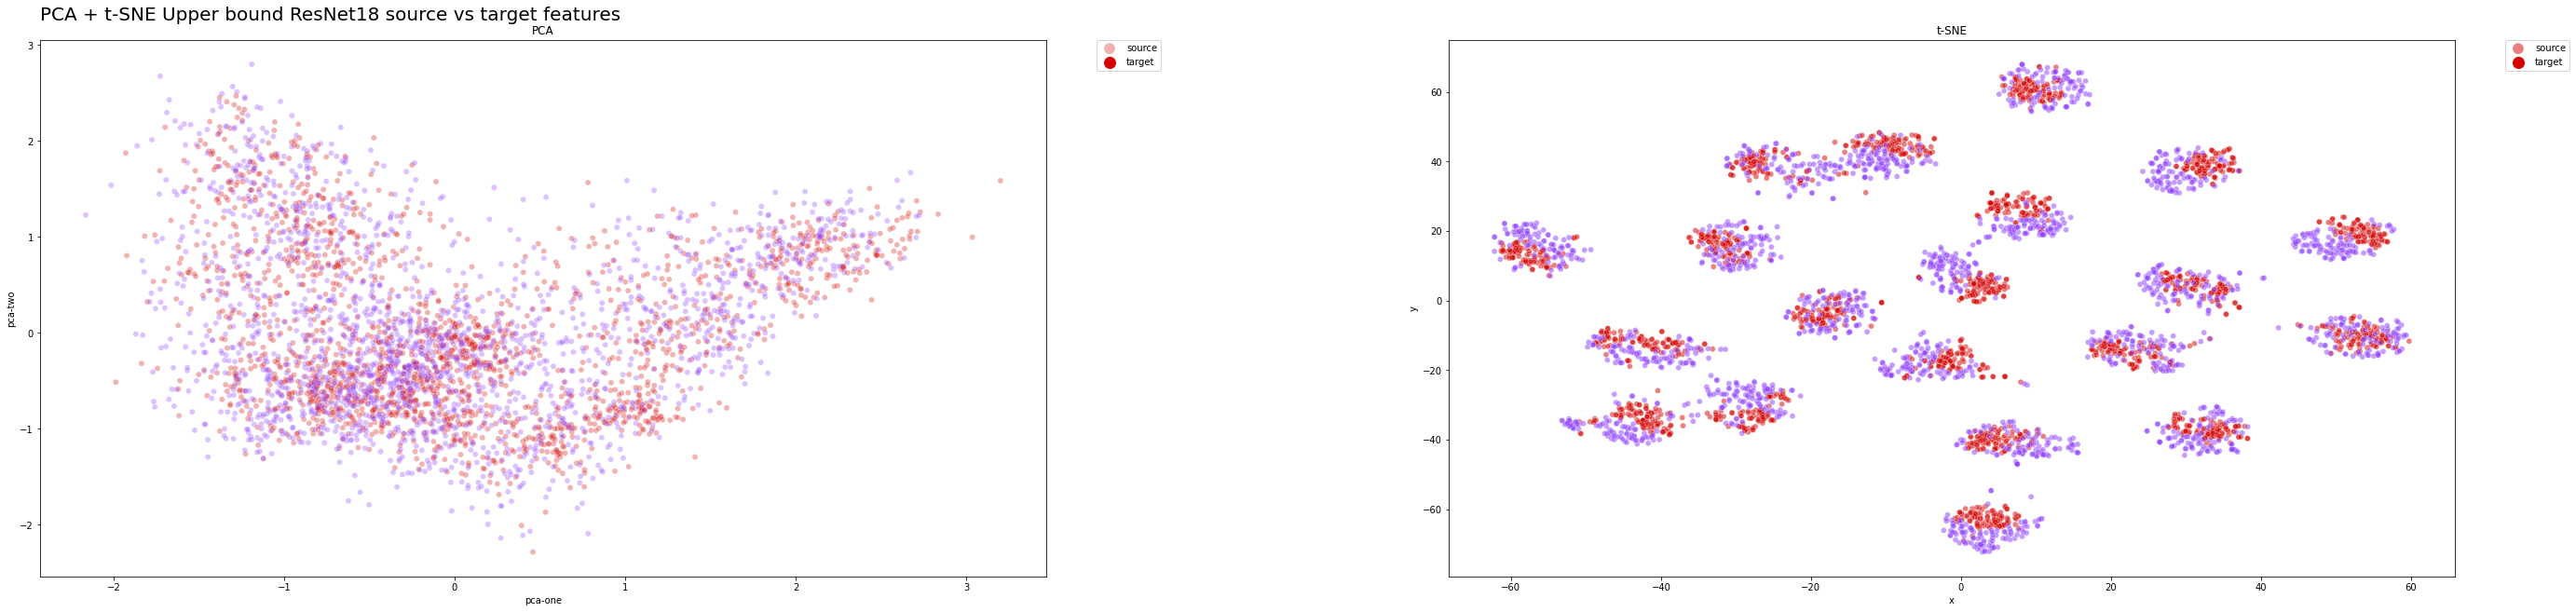

<Figure size 432x288 with 0 Axes>

In [ ]:
targets, outputs = gen_features_source_domain(
    net,
    dataloaders["full_source"],
    dataloaders["full_target"],
    technique=Technique.UPPER_BOUND,
)

feature_visualizer(
    "Upper bound ResNet18 source vs target features",
    targets,
    outputs,
    2,
    legend=["source", "target"],
)

 #> Generating PCA and t-SNE plots...


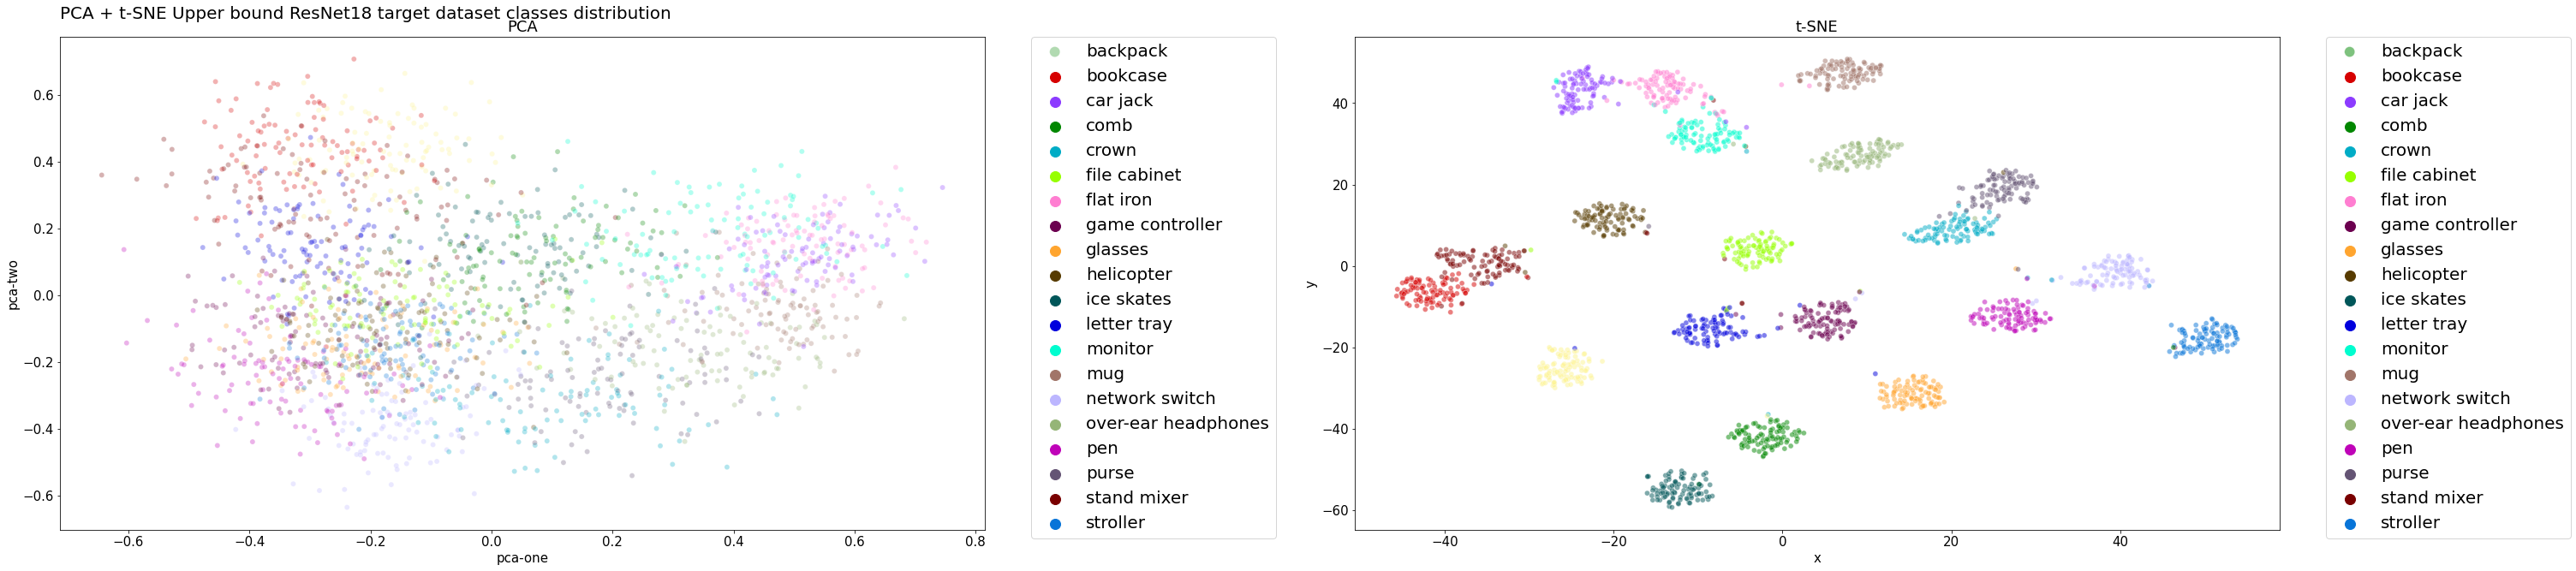

<Figure size 432x288 with 0 Axes>

In [ ]:
targets, outputs = gen_predictions_targets(
    net, dataloaders["full_target"], device=device, technique=Technique.UPPER_BOUND
)

feature_visualizer(
    "Upper bound ResNet18 target dataset classes distribution",
    targets,
    outputs,
    20,
    legend=classes,
)

### Best result - DSN + MEDM

As mentioned before, here we present the feature distribution plot of the best domain adaptation we have achieved.

We expect that both the classes and the features distribution are arranged in a similar way with respect to the Target distributions, as the model has achieved astonishing performances.

In [ ]:
!rm -rf "dsn-medm"
!mkdir "dsn-medm"
!cp -r "/content/gdrive/MyDrive/deep_learning_models/models_20_05_2022/dsn-medm/" .

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = DSNMEDM(pretrained=True)
net = net.to(device)

In [ ]:
# load best
load_best_weights(net, "dsn-medm/")

#> Resume best


As we can see from the t-SNE feature distribution allignment, the features are well clustered and are very similar to the upper bound model. This shows that the domain allignment method has worked effectively.

10 / 62
20 / 62
30 / 62
40 / 62
50 / 62
60 / 62
62 / 62
10 / 62
20 / 62
30 / 62
40 / 62
50 / 62
60 / 62
62 / 62
(124, 32, 512, 1, 1)
 #> Generating PCA and t-SNE plots...


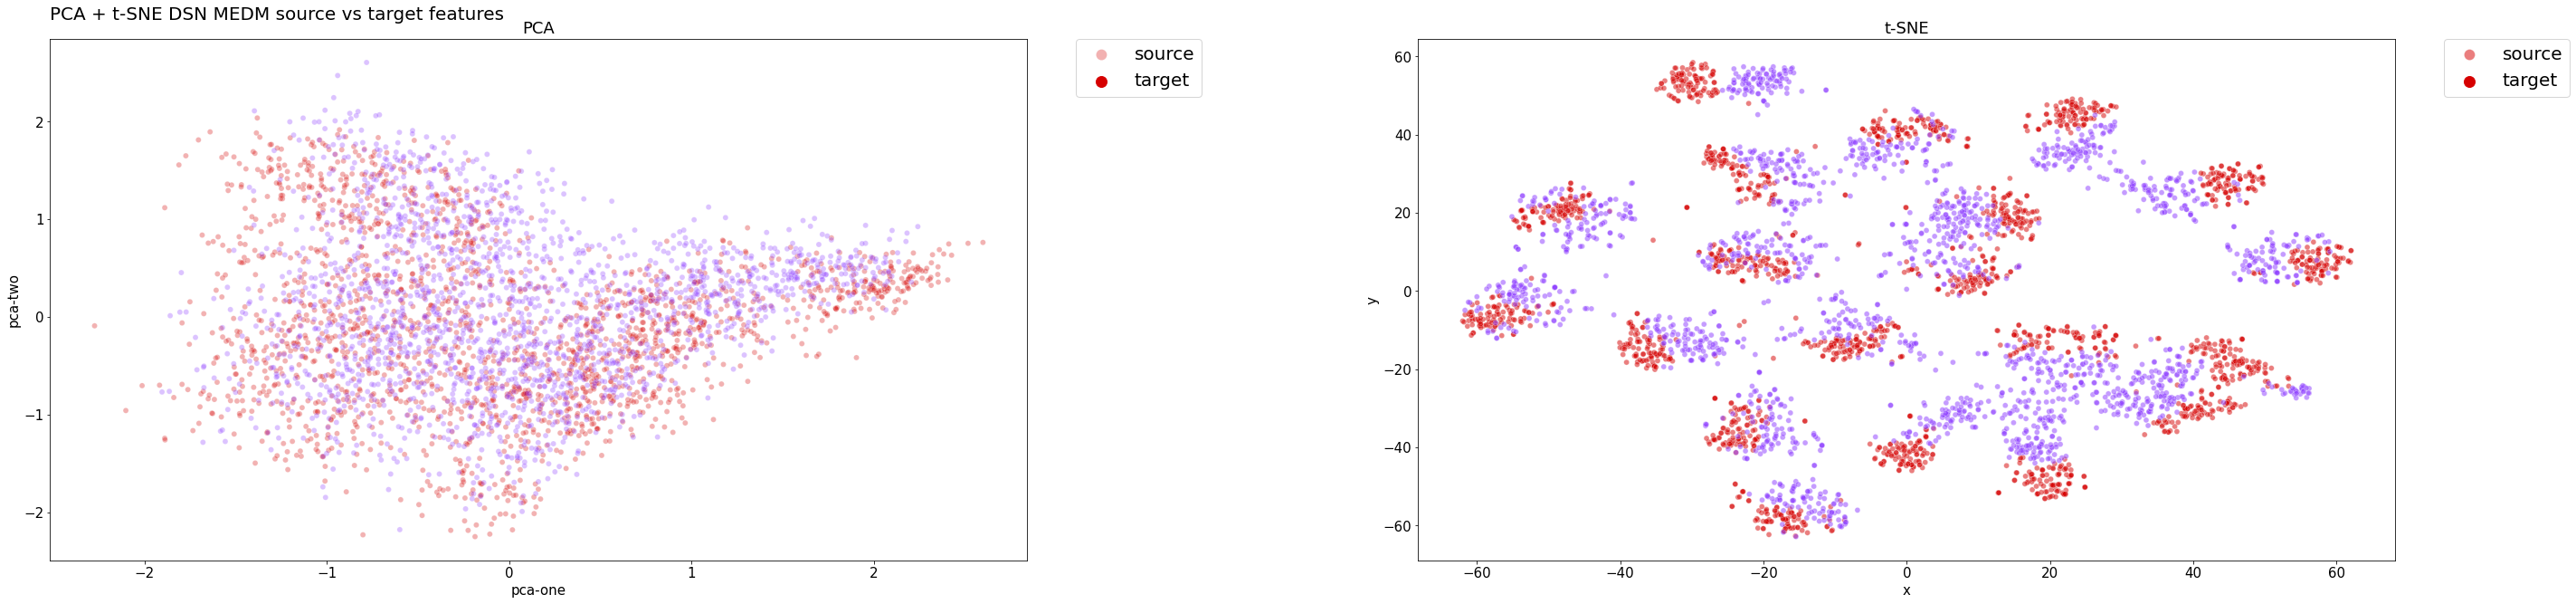

<Figure size 432x288 with 0 Axes>

In [ ]:
targets, outputs = gen_features_source_domain(
    net,
    dataloaders["full_source"],
    dataloaders["full_target"],
    technique=Technique.DSN_MEDM,
)

feature_visualizer(
    "DSN MEDM source vs target features",
    targets,
    outputs,
    2,
    legend=["source", "target"],
)

As we can see from the classes distributions below, even the model's classifier is able to effectively cluster the examples while maintaining a high accuracy. Clusters are well defined and separated between them. Despite being examples of the target domain, they are correctly classified.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 #> Generating PCA and t-SNE plots...


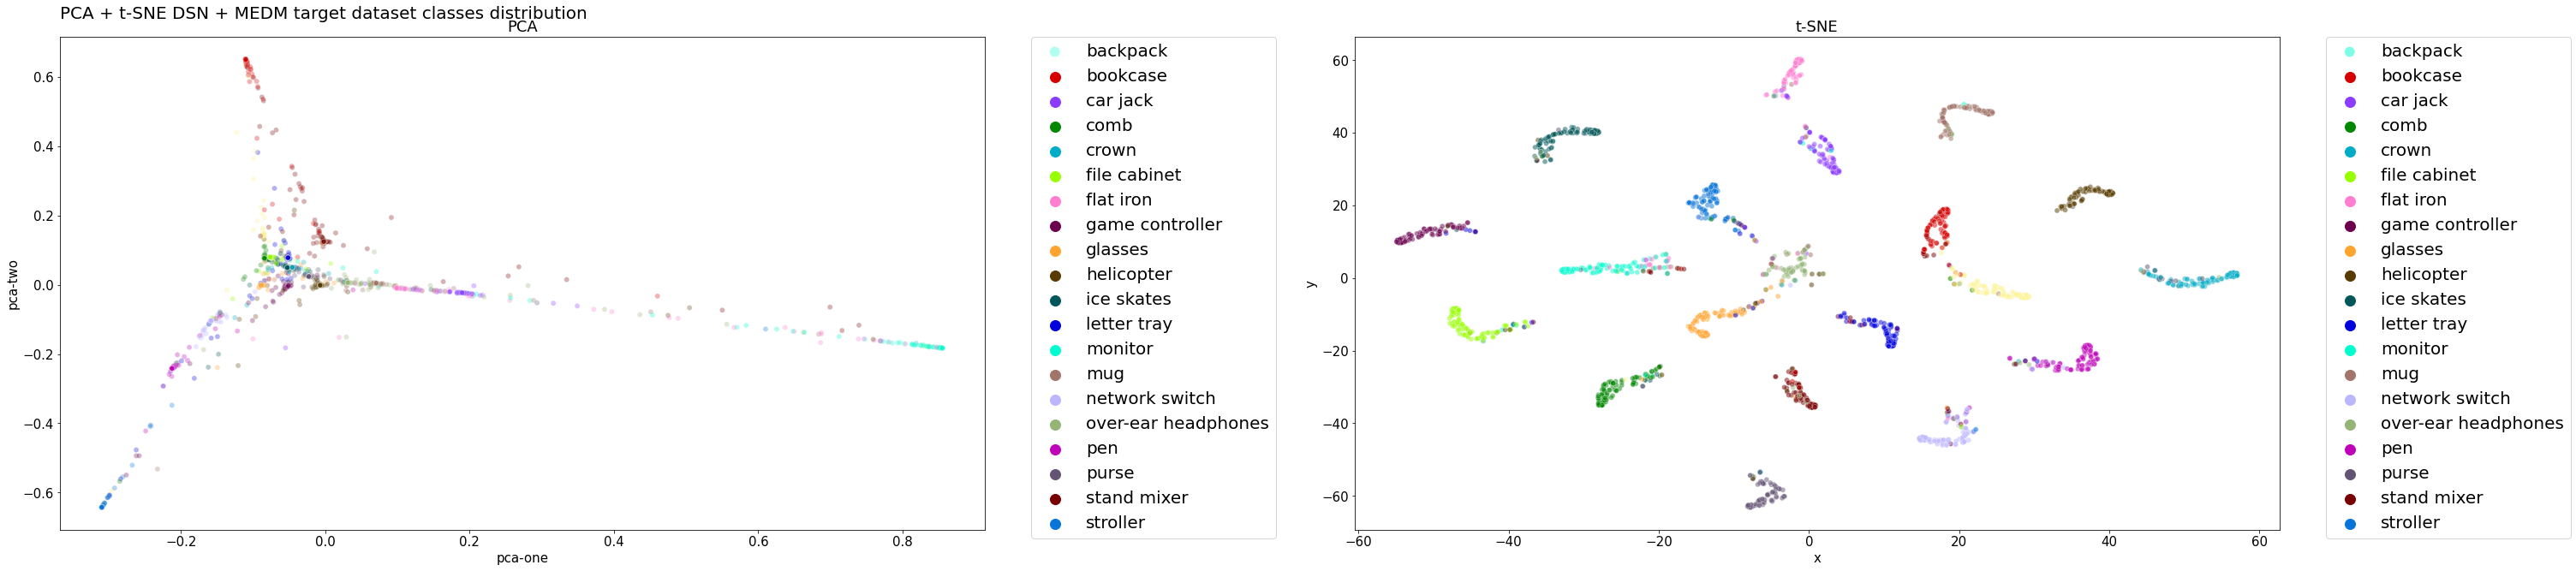

<Figure size 432x288 with 0 Axes>

In [ ]:
targets, outputs = gen_predictions_targets(
    net, dataloaders["full_target"], device=device, technique=Technique.DSN_MEDM
)

feature_visualizer(
    "DSN + MEDM target dataset classes distribution",
    targets,
    outputs,
    20,
    legend=classes,
)

In both cases, PCA hasn't really provided useful insights about the results, since a linear transformation may be too naive to transform such high dimensional data into a lower dimensional embedding.

# Tensorboard

Tensorboard has been employed to see the learning curves.

In [ ]:
# if getting an error, enable third party cookies!
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 117), started 0:00:09 ago. (Use '!kill 117' to kill it.)

<IPython.core.display.Javascript object>

# Results

Reference table of the results we have obtained.

$\begin{array}{|c|c|c|}\hline\\
  Base\; Network & Method & Source\; set & Target\; set & Accuracy \; on \; target \; (\%) & Gain \\ \hline
  AlexNet & Source \;Only & Product \; Images & Real \; Life & 64.45 & 0 \\ \hline
  ResNet18 & Source \;Only & Product \; Images & Real \; Life & 75.39 & 0 \\ \hline
  AlexNet & Upper \;Bound & Product \; Images & Real \; Life & 85.94 & 21.485 \\ \hline
  ResNet18 & Upper \;Bound & Product \; Images & Real \; Life & 96.88 & 20.312 \\ \hline
  AlexNet & DDC & Product \; Images & Real \; Life & 68.36 & 3.91 \\ \hline
  ResNet18 & DDC & Product \; Images & Real \; Life & 83.50 & 8.11 \\ \hline
  AlexNet & DANN & Product \; Images & Real \; Life & 65.23 & 0.78 \\ \hline
  ResNet18 & DANN & Product \; Images & Real \; Life & 87.11 & 11.72 \\ \hline
  & OriginalDSN & Product \; Images & Real \; Life & 04.17 & \\ \hline
   AlexNet & BackboneDSN & Product \; Images & Real \; Life & 58.85 & -5.60 \\ \hline
  ResNet18 & BackboneDSN & Product \; Images & Real \; Life & 78.39 & 3.00 \\ \hline
  ResNet18 & OptimizedDSN & Product \; Images & \; Real \; Life & 81.25 & 5.86 \\ \hline
  ResNet18 & Rotation \; Loss & Product \; Images & Real \; Life & 73.83 & -1.56 \\ \hline
  ResNet18 & MEDM & Product \; Images & Real \; Life & 90.36 & 14.97 \\ \hline
  ResNet18 & MEDM + DANN & Product \; Images & Real \; Life & 80.21 & 4.82 \\ \hline
  ResNet18 & MEDM + DSN & Product \; Images & Real \; Life & 91.15 & 15.76 \\ \hline
  AlexNet & Source \;Only & Real \; Life & Product \; Images & 85.55 & 0 \\ \hline
  ResNet18 & Source \;Only & Real \; Life & Product \; Images & 93.75 & 0 \\ \hline
  AlexNet & Upper \;Bound & Real \; Life & Product \; Images & 95.70 & 10.15 \\ \hline
  ResNet18 & Upper \;Bound & Real \; Life & Product \; Images & 98.05 & 4.3 \\ \hline
  AlexNet & DDC & Real \; Life & Product \; Images & 82.03 & -3.52 \\ \hline
  ResNet18 & DDC & Real \; Life & Product \; Images & 94.53 & 0.78 \\ \hline
  AlexNet & DANN & Real \; Life & Product \; Images & 83.98 & -1.57  \\ \hline
  ResNet18 & DANN & Real \; Life & Product \; Images & 96.09 & 2.34 \\ \hline
  & OriginalDSN & Real \; Life & Product \; Images & 04.17 & \\ \hline
   AlexNet & BackboneDSN & Real \; Life & Product \; Images & 84.11 & -1.44 \\ \hline
  ResNet18 & BackboneDSN & Real \; Life & Product \; Images \; & 91.41 & -2.34 \\ \hline
  ResNet18 & OptimizedDSN & Real \; Life & Product \; Images & 93.49 & -0.26 \\ \hline
  ResNet18 & Rotation \; Loss & Real \; Life & Product \; Images & 91.80 & -1.95 \\ \hline
  ResNet18 & MEDM & Real \; Life & Product \; Images & 97.14 & 3.39 \\ \hline
  ResNet18 & MEDM + DANN & Real \; Life & Product \; Images & 94.00 & 0.25 \\ \hline
  ResNet18 & MEDM + DSN & Real \; Life & Product \; Images & 96.61 & 2.86 \\ \hline
\end{array}$

## Performances plot
In order to get a visual representation of the behaviour of the various methodologies, we have provided a scatterplot which comprises the accuracy, the backbone network we have employed and the method used.

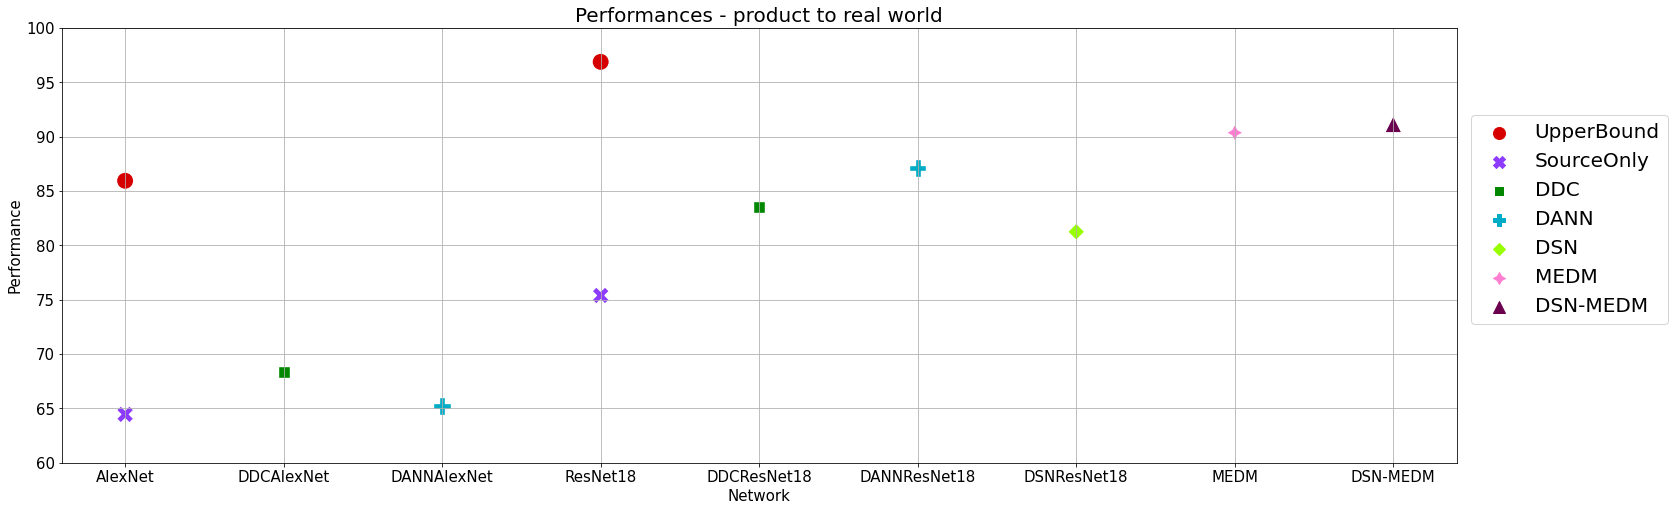

In [ ]:
from re import T
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# color palette
import colorcet as cc

# font size
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

# Prepare data
results = {
    "Network": [
        "AlexNet",
        "AlexNet",
        "DDCAlexNet",
        "DANNAlexNet",
        "ResNet18",
        "ResNet18",
        "DDCResNet18",
        "DANNResNet18",
        "DSNResNet18",
        "MEDM",
        "DSN-MEDM",
    ],
    "Technique": [
        "UpperBound",
        "SourceOnly",
        "DDC",
        "DANN",
        "UpperBound",
        "SourceOnly",
        "DDC",
        "DANN",
        "DSN",
        "MEDM",
        "DSN-MEDM",
    ],
    "Performance": [
        85.94,
        64.45,
        68.36,
        65.23,
        96.88,
        75.39,
        83.50,
        87.11,
        81.25,
        90.36,
        91.15,
    ],
}

# Load data into DataFrame
df = pd.DataFrame(data=results)

# Draw a scatter plot with seaborn
plt.figure(figsize=(25, 8))
plt.title("Performances - product to real world", fontsize=BIGGER_SIZE)
plt.ylim(60, 100)
plt.yticks(np.arange(60, 101, step=5))
sns.scatterplot(
    x="Network",
    y="Performance",
    hue="Technique",
    style="Technique",
    s=300,
    palette=sns.color_palette(cc.glasbey, n_colors=len(df["Technique"].unique())),
    data=df,
    legend="full",
    alpha=1,
)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0.0, markerscale=2)

# font
plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.show()

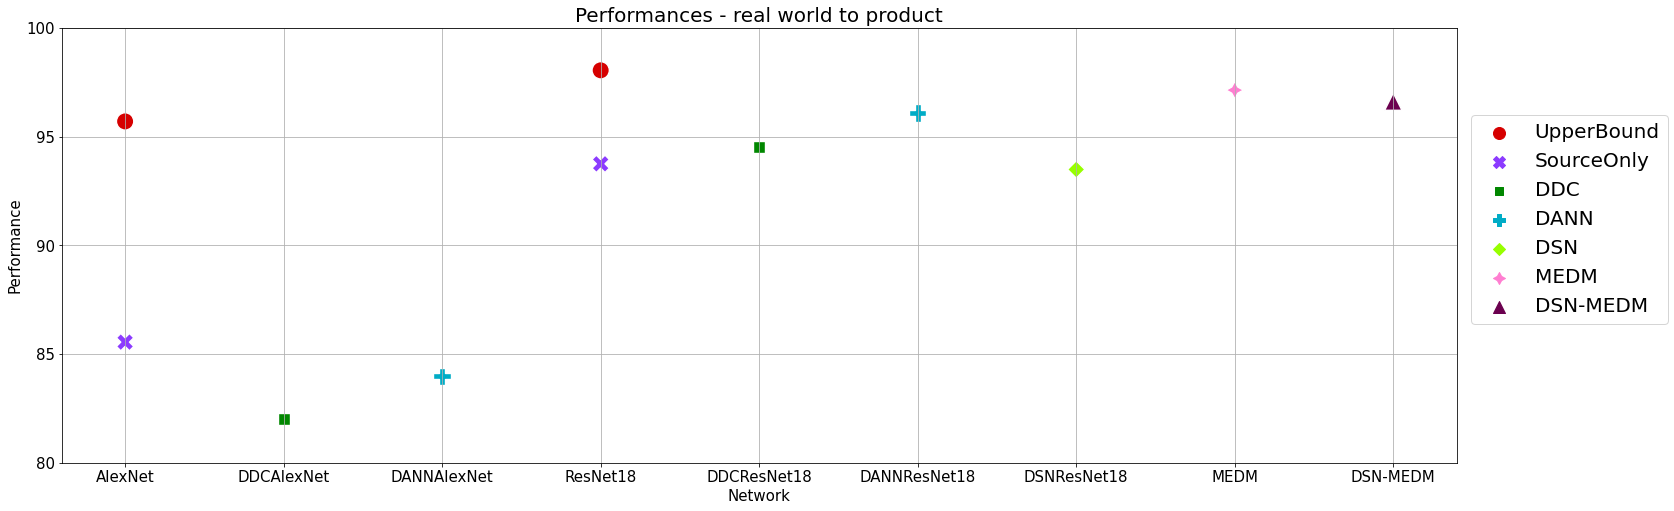

In [ ]:
from re import T
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# color palette
import colorcet as cc

# font size
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

# Prepare data
results = {
    "Network": [
        "AlexNet",
        "AlexNet",
        "DDCAlexNet",
        "DANNAlexNet",
        "ResNet18",
        "ResNet18",
        "DDCResNet18",
        "DANNResNet18",
        "DSNResNet18",
        "MEDM",
        "DSN-MEDM",
    ],
    "Technique": [
        "UpperBound",
        "SourceOnly",
        "DDC",
        "DANN",
        "UpperBound",
        "SourceOnly",
        "DDC",
        "DANN",
        "DSN",
        "MEDM",
        "DSN-MEDM",
    ],
    "Performance": [
        95.70,
        85.55,
        82.03,
        83.98,
        98.05,
        93.75,
        94.53,
        96.09,
        93.49,
        97.14,
        96.61,
    ],
}

# Load data into DataFrame
df = pd.DataFrame(data=results)

# Draw a scatter plot with seaborn
plt.figure(figsize=(25, 8))
plt.title("Performances - real world to product", fontsize=BIGGER_SIZE)
plt.ylim(80, 100)
plt.yticks(np.arange(80, 101, step=5))
sns.scatterplot(
    x="Network",
    y="Performance",
    hue="Technique",
    style="Technique",
    s=300,
    palette=sns.color_palette(cc.glasbey, n_colors=len(df["Technique"].unique())),
    data=df,
    legend="full",
    alpha=1,
)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.01, 0.8), loc=2, borderaxespad=0.0, markerscale=2)

# font
plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.show()

# Conclusions

In this project we have tried out at least one architecture for each domain adaptation category of techniques, namely `discrepancy-based`, `adversarial-based` and `reconstruction-based`. Among them, the most effective ones were `DANN` and `MEDM`.

`MEDM` is an approach which can be easily integrated in any architecture, since it consists of two simple entropy losses, showing a stable training and astonishing performance. On the other hand, `DANN` is much more subject to hyperparameter variations and it is very likely to end up in an unstable training.

In our testing, we found that `DSN` and `MEDM` worked effectively together, whereas `MEDM` and `DANN` combined have not given a consistent improvement.

Since it's more difficult to adapt from product to real world, gain is significantly simpler to obtain because there is far more space for improvement between the baseline and upper bound.
On the other hand, switching between real world and product images guarantees higher accuracy because networks have already seen real world images since they were pre-trained on `ImageNet`.
As a result, the gap between the baseline and the real world is significantly narrower, which means getting a significant progress is much harder.

After having tried out both `AlexNet` and `ResNet18` as backbone architectures, we found that not only did `ResNet18` have far higher baseline and upper-bound values, but also all domain adaption strategies produced significantly larger gains.

The `t-SNE` plots has clearly shown our last solution is able to extract relevant features from both domains while performing an accurate classification, since the distributions are close to the optimal ones, which are those of the upper bound `ResNet18` model.

## CSV generation

Get information about all runs and the corresponding models from wandb and save it in `project.csv`.

The file contains the networks' weights and biases.

In [ ]:
import pandas as pd
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("deep-learning-project/dl-project")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)

runs_df.to_csv("project.csv")

# Code formatting

To develop the project and provide a [readable code](https://en.wikipedia.org/wiki/Readability) we have used the [black formatting](https://black.readthedocs.io/en/stable/), a [PEP 8](https://peps.python.org/pep-0008/) compliant formatter for Python code.

In this section we present a simple way to make the notebook compliant with the black formatting in just a few steps:

In [ ]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


The steps to follow are:
- Run only once, at startup
```python
# Connect to your drive
from google.colab import drive
drive.mount("/content/drive")
# Install black for jupyter
!pip install black[jupyter]
```
- Restart the notebook kernel
- run:
```python
!black /content/drive/MyDrive/YOUR_PATH/YOUR_NOTEBOOK.ipynb
```
- Refresh the page without saving your notebook

In [ ]:
!pip install black[jupyter]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 843 kB 52.5 MB/s 
     |████████████████████████████████| 96 kB 8.0 MB/s 
     |████████████████████████████████| 793 kB 66.3 MB/s 
     |████████████████████████████████| 381 kB 60.0 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour i

In [ ]:
!black "/content/gdrive/MyDrive/Colab Notebooks/229326_229327.ipynb"

reformatted /content/gdrive/MyDrive/Colab Notebooks/229326_229327.ipynb

All done! ✨ 🍰 ✨
1 file reformatted.
